In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run3"
    model = EEGNet_IE_HP_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_Multivariate-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_IE_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7025379678782295


Iterations:   0%|                                   | 1/300 [00:03<16:54,  3.39s/it]

Epoch:  0
t_loss:  0.7025379678782295 , v_loss:  0.6931550900141398
t_acc:  0.5188297541238718 , v_acc:  0.4720496894409938
t_recall:  0.5109468714401394 , v_recall:  0.5951351351351352
t_prec:  0.509293582115059 , v_prec:  0.6222788327929597
t_f:  0.4943464257211265 , v_f:  0.46678355737385546
////////


Iterations:   1%|▏                                  | 2/300 [00:04<09:04,  1.83s/it]

Epoch  1 , loss 0.6706051078497195
Epoch  2 , loss 0.6459513575422997


Iterations:   1%|▎                                  | 3/300 [00:05<07:50,  1.58s/it]

Epoch:  2
t_loss:  0.6459513575422997 , v_loss:  0.6896252433458964
t_acc:  0.5969498910675382 , v_acc:  0.4782608695652174
t_recall:  0.5251190623241515 , v_recall:  0.5611711711711712
t_prec:  0.5250189102242798 , v_prec:  0.5618622448979591
t_f:  0.5250659495079769 , v_f:  0.47824074074074074
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:18,  1.28s/it]

Epoch  3 , loss 0.6251586535397697
Epoch  4 , loss 0.606989299549776


Iterations:   2%|▌                                  | 5/300 [00:07<06:03,  1.23s/it]

Epoch:  4
t_loss:  0.606989299549776 , v_loss:  0.6717332402865092
t_acc:  0.6314970432617492 , v_acc:  0.6708074534161491
t_recall:  0.5177474917994538 , v_recall:  0.5963963963963964
t_prec:  0.5232858128995468 , v_prec:  0.6054394954670871
t_f:  0.5129788927204517 , v_f:  0.5993332394233929
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:06,  1.04s/it]

Epoch  5 , loss 0.5881787059353847
Epoch  6 , loss 0.5667766268346824


Iterations:   2%|▊                                  | 7/300 [00:09<05:23,  1.10s/it]

Epoch:  6
t_loss:  0.5667766268346824 , v_loss:  0.6506198843320211
t_acc:  0.6676003734827264 , v_acc:  0.6956521739130435
t_recall:  0.5221332400049409 , v_recall:  0.5264864864864865
t_prec:  0.5445345638918346 , v_prec:  0.6363636363636364
t_f:  0.5024792784516776 , v_f:  0.477722608407812
////////


Iterations:   3%|▉                                  | 8/300 [00:09<04:44,  1.03it/s]

Epoch  7 , loss 0.5508239497156704
Epoch  8 , loss 0.5360890130201975


Iterations:   3%|█                                  | 9/300 [00:11<04:59,  1.03s/it]

Epoch:  8
t_loss:  0.5360890130201975 , v_loss:  0.6380334198474884
t_acc:  0.6878306878306878 , v_acc:  0.7018633540372671
t_recall:  0.5254608089375661 , v_recall:  0.52
t_prec:  0.5777003065960026 , v_prec:  0.8490566037735849
t_f:  0.4922845547886018 , v_f:  0.44957264957264953
////////


Iterations:   3%|█▏                                | 10/300 [00:12<04:44,  1.02it/s]

Epoch  9 , loss 0.5296928321613985
Epoch  10 , loss 0.5166183914624008


Iterations:   4%|█▏                                | 11/300 [00:13<04:58,  1.03s/it]

Epoch:  10
t_loss:  0.5166183914624008 , v_loss:  0.6333273549874624
t_acc:  0.6862745098039216 , v_acc:  0.6956521739130435
t_recall:  0.5082403480600046 , v_recall:  0.51
t_prec:  0.5436563528573437 , v_prec:  0.846875
t_f:  0.45191878112113243 , v_f:  0.42920193907821425
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:25,  1.09it/s]

Epoch  11 , loss 0.5115708586047677
Epoch  12 , loss 0.49491902484613304


Iterations:   4%|█▍                                | 13/300 [00:15<04:53,  1.02s/it]

Epoch:  12
t_loss:  0.49491902484613304 , v_loss:  0.6317848165829977
t_acc:  0.6931216931216931 , v_acc:  0.6894409937888198
t_recall:  0.5085615075280328 , v_recall:  0.5
t_prec:  0.5746648579636131 , v_prec:  0.3447204968944099
t_f:  0.4421859285156877 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:32,  1.05it/s]

Epoch  13 , loss 0.48735906505117227
Epoch  14 , loss 0.4811030836666332


Iterations:   5%|█▋                                | 15/300 [00:17<04:48,  1.01s/it]

Epoch:  14
t_loss:  0.4811030836666332 , v_loss:  0.6314314206441244
t_acc:  0.6909430438842203 , v_acc:  0.6894409937888198
t_recall:  0.503832640232772 , v_recall:  0.5
t_prec:  0.5409417456749096 , v_prec:  0.3447204968944099
t_f:  0.43173450597019947 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:20,  1.09it/s]

Epoch  15 , loss 0.47612931564742444
Epoch  16 , loss 0.4673481735528684


Iterations:   6%|█▉                                | 17/300 [00:18<04:48,  1.02s/it]

Epoch:  16
t_loss:  0.4673481735528684 , v_loss:  0.6315363446871439
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5042491868077572 , v_recall:  0.5
t_prec:  0.6079723791588199 , v_prec:  0.3447204968944099
t_f:  0.4238178228943825 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:19<04:18,  1.09it/s]

Epoch  17 , loss 0.4682005264011084
Epoch  18 , loss 0.466853213076498


Iterations:   6%|██▏                               | 19/300 [00:20<04:36,  1.02it/s]

Epoch:  18
t_loss:  0.466853213076498 , v_loss:  0.6332898040612539
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5035780458681599 , v_recall:  0.5
t_prec:  0.5819038642789821 , v_prec:  0.3447204968944099
t_f:  0.4234496124031008 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:12,  1.11it/s]

Epoch  19 , loss 0.4585847638401331
Epoch  20 , loss 0.4563316054203931


Iterations:   7%|██▍                               | 21/300 [00:22<04:30,  1.03it/s]

Epoch:  20
t_loss:  0.4563316054203931 , v_loss:  0.6345209379990896
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.5017567697396412 , v_recall:  0.5
t_prec:  0.5481806775407779 , v_prec:  0.3447204968944099
t_f:  0.41933759848979707 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:20,  1.07it/s]

Epoch  21 , loss 0.4523195863938799
Epoch  22 , loss 0.4507758909580754


Iterations:   8%|██▌                               | 23/300 [00:24<04:40,  1.01s/it]

Epoch:  22
t_loss:  0.4507758909580754 , v_loss:  0.6348722477753957
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5074765649661684 , v_recall:  0.5
t_prec:  0.67698947322821 , v_prec:  0.3447204968944099
t_f:  0.42946028474236353 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:14,  1.08it/s]

Epoch  23 , loss 0.4502906571416294
Epoch  24 , loss 0.44361085050246296


Iterations:   8%|██▊                               | 25/300 [00:26<04:35,  1.00s/it]

Epoch:  24
t_loss:  0.44361085050246296 , v_loss:  0.6344233155250549
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5038340127091311 , v_recall:  0.5
t_prec:  0.6380961012424612 , v_prec:  0.3447204968944099
t_f:  0.42123755684071923 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:09,  1.10it/s]

Epoch  25 , loss 0.4461994223734912
Epoch  26 , loss 0.44604378179007886


Iterations:   9%|███                               | 27/300 [00:28<04:38,  1.02s/it]

Epoch:  26
t_loss:  0.44604378179007886 , v_loss:  0.6361049513022105
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5012777754903172 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.3447204968944099
t_f:  0.4158754021869472 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:18,  1.05it/s]

Epoch  27 , loss 0.4488006970461677
Epoch  28 , loss 0.4464272582063488


Iterations:  10%|███▎                              | 29/300 [00:30<04:33,  1.01s/it]

Epoch:  28
t_loss:  0.4464272582063488 , v_loss:  0.6326283911863962
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5020127365806124 , v_recall:  0.5
t_prec:  0.5982338230697093 , v_prec:  0.3447204968944099
t_f:  0.4170674932028922 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:05,  1.10it/s]

Epoch  29 , loss 0.44517050888024123
Epoch  30 , loss 0.45177117808192385


Iterations:  10%|███▌                              | 31/300 [00:32<04:27,  1.01it/s]

Epoch:  30
t_loss:  0.45177117808192385 , v_loss:  0.6294560382763544
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5035464789119007 , v_recall:  0.5
t_prec:  0.6426783479349187 , v_prec:  0.3447204968944099
t_f:  0.4202877765739024 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:08,  1.08it/s]

Epoch  31 , loss 0.43753409035065594
Epoch  32 , loss 0.4383920933686051


Iterations:  11%|███▋                              | 33/300 [00:34<04:26,  1.00it/s]

Epoch:  32
t_loss:  0.4383920933686051 , v_loss:  0.6254940380652746
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5034826587612028 , v_recall:  0.51
t_prec:  0.6699749921850578 , v_prec:  0.846875
t_f:  0.4194516752347822 , v_f:  0.42920193907821425
////////


Iterations:  11%|███▊                              | 34/300 [00:34<03:59,  1.11it/s]

Epoch  33 , loss 0.4359377914784001
Epoch  34 , loss 0.44350121652378754


Iterations:  12%|███▉                              | 35/300 [00:36<04:27,  1.01s/it]

Epoch:  34
t_loss:  0.44350121652378754 , v_loss:  0.6207669973373413
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.5033227652653683 , v_recall:  0.51
t_prec:  0.6262910798122066 , v_prec:  0.846875
t_f:  0.4201690740864009 , v_f:  0.42920193907821425
////////


Iterations:  12%|████                              | 36/300 [00:37<04:08,  1.06it/s]

Epoch  35 , loss 0.4410121908374861
Epoch  36 , loss 0.43810248842426375


Iterations:  12%|████▏                             | 37/300 [00:38<04:23,  1.00s/it]

Epoch:  36
t_loss:  0.43810248842426375 , v_loss:  0.6131264766057333
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5075726383113051 , v_recall:  0.51
t_prec:  0.7357838808011168 , v_prec:  0.846875
t_f:  0.4279841503870254 , v_f:  0.42920193907821425
////////


Iterations:  13%|████▎                             | 38/300 [00:38<03:59,  1.09it/s]

Epoch  37 , loss 0.4374657875182582
Epoch  38 , loss 0.43251505377245886


Iterations:  13%|████▍                             | 39/300 [00:40<04:20,  1.00it/s]

Epoch:  38
t_loss:  0.43251505377245886 , v_loss:  0.610899622241656
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5054953953418152 , v_recall:  0.51
t_prec:  0.6346938775510205 , v_prec:  0.846875
t_f:  0.42605217404062706 , v_f:  0.42920193907821425
////////


Iterations:  13%|████▌                             | 40/300 [00:40<03:58,  1.09it/s]

Epoch  39 , loss 0.4319348446294373
Epoch  40 , loss 0.43687473734219867


Iterations:  14%|████▋                             | 41/300 [00:42<04:23,  1.02s/it]

Epoch:  40
t_loss:  0.43687473734219867 , v_loss:  0.6084940532843272
t_acc:  0.6971677559912854 , v_acc:  0.6956521739130435
t_recall:  0.5054315751911174 , v_recall:  0.51
t_prec:  0.6489648682559599 , v_prec:  0.846875
t_f:  0.4252446422488022 , v_f:  0.42920193907821425
////////


Iterations:  14%|████▊                             | 42/300 [00:42<03:56,  1.09it/s]

Epoch  41 , loss 0.4365409186073378
Epoch  42 , loss 0.4367132379728205


Iterations:  14%|████▊                             | 43/300 [00:43<04:14,  1.01it/s]

Epoch:  42
t_loss:  0.4367132379728205 , v_loss:  0.6057532727718353
t_acc:  0.699035169623405 , v_acc:  0.6956521739130435
t_recall:  0.508499059853694 , v_recall:  0.51
t_prec:  0.688332556112001 , v_prec:  0.846875
t_f:  0.431556640045754 , v_f:  0.42920193907821425
////////


Iterations:  15%|████▉                             | 44/300 [00:44<03:52,  1.10it/s]

Epoch  43 , loss 0.4317142414111717
Epoch  44 , loss 0.4318320464854147


Iterations:  15%|█████                             | 45/300 [00:45<04:13,  1.01it/s]

Epoch:  44
t_loss:  0.4318320464854147 , v_loss:  0.602776030699412
t_acc:  0.6959228135698724 , v_acc:  0.6956521739130435
t_recall:  0.5033865854160662 , v_recall:  0.51
t_prec:  0.6104323308270676 , v_prec:  0.846875
t_f:  0.4209981125404011 , v_f:  0.42920193907821425
////////


Iterations:  15%|█████▏                            | 46/300 [00:46<04:06,  1.03it/s]

Epoch  45 , loss 0.4327730559835247
Epoch  46 , loss 0.4373088403075349


Iterations:  16%|█████▎                            | 47/300 [00:47<04:26,  1.05s/it]

Epoch:  46
t_loss:  0.4373088403075349 , v_loss:  0.5984770258267721
t_acc:  0.6959228135698724 , v_acc:  0.7018633540372671
t_recall:  0.5042491868077572 , v_recall:  0.52
t_prec:  0.6079723791588199 , v_prec:  0.8490566037735849
t_f:  0.4238178228943825 , v_f:  0.44957264957264953
////////


Iterations:  16%|█████▍                            | 48/300 [00:48<04:11,  1.00it/s]

Epoch  47 , loss 0.4329748889979194
Epoch  48 , loss 0.4292204841679218


Iterations:  16%|█████▌                            | 49/300 [00:49<04:19,  1.03s/it]

Epoch:  48
t_loss:  0.4292204841679218 , v_loss:  0.5962955405314764
t_acc:  0.7005913476501712 , v_acc:  0.7018633540372671
t_recall:  0.5107677632752776 , v_recall:  0.52
t_prec:  0.7177571563384713 , v_prec:  0.8490566037735849
t_f:  0.4358598188563978 , v_f:  0.44957264957264953
////////


Iterations:  17%|█████▋                            | 50/300 [00:50<03:55,  1.06it/s]

Epoch  49 , loss 0.4286900431502099
Epoch  50 , loss 0.43208782462512746


Iterations:  17%|█████▊                            | 51/300 [00:51<04:19,  1.04s/it]

Epoch:  50
t_loss:  0.43208782462512746 , v_loss:  0.5915191223224004
t_acc:  0.6962340491752257 , v_acc:  0.7080745341614907
t_recall:  0.50476043425152 , v_recall:  0.53
t_prec:  0.6166797488226059 , v_prec:  0.8512658227848101
t_f:  0.4248736364103204 , v_f:  0.4692431787893666
////////


Iterations:  17%|█████▉                            | 52/300 [00:52<03:58,  1.04it/s]

Epoch  51 , loss 0.4285354246111477
Epoch  52 , loss 0.42549822961582856


Iterations:  18%|██████                            | 53/300 [00:53<04:11,  1.02s/it]

Epoch:  52
t_loss:  0.42549822961582856 , v_loss:  0.5882058441638947
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5092017677495505 , v_recall:  0.53
t_prec:  0.6546573678221019 , v_prec:  0.8512658227848101
t_f:  0.43492779051180885 , v_f:  0.4692431787893666
////////


Iterations:  18%|██████                            | 54/300 [00:54<03:47,  1.08it/s]

Epoch  53 , loss 0.4335464916977228
Epoch  54 , loss 0.4314744776370479


Iterations:  18%|██████▏                           | 55/300 [00:55<04:19,  1.06s/it]

Epoch:  54
t_loss:  0.4314744776370479 , v_loss:  0.586230273048083
t_acc:  0.6999688764394647 , v_acc:  0.7080745341614907
t_recall:  0.5083075994016003 , v_recall:  0.53
t_prec:  0.7586678442209625 , v_prec:  0.8512658227848101
t_f:  0.42916844821231115 , v_f:  0.4692431787893666
////////


Iterations:  19%|██████▎                           | 56/300 [00:56<03:52,  1.05it/s]

Epoch  55 , loss 0.4306218594897027
Epoch  56 , loss 0.4279610777602476


Iterations:  19%|██████▍                           | 57/300 [00:57<04:06,  1.02s/it]

Epoch:  56
t_loss:  0.4279610777602476 , v_loss:  0.5817717015743256
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5121416121107314 , v_recall:  0.53
t_prec:  0.7040683726509396 , v_prec:  0.8512658227848101
t_f:  0.4395929893517526 , v_f:  0.4692431787893666
////////


Iterations:  19%|██████▌                           | 58/300 [00:58<03:46,  1.07it/s]

Epoch  57 , loss 0.429557451430489
Epoch  58 , loss 0.42403709537842693


Iterations:  20%|██████▋                           | 59/300 [00:59<03:58,  1.01it/s]

Epoch:  58
t_loss:  0.42403709537842693 , v_loss:  0.5774204581975937
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5092017677495505 , v_recall:  0.53
t_prec:  0.6546573678221019 , v_prec:  0.8512658227848101
t_f:  0.43492779051180885 , v_f:  0.4692431787893666
////////


Iterations:  20%|██████▊                           | 60/300 [01:00<03:39,  1.09it/s]

Epoch  59 , loss 0.42752207669557307
Epoch  60 , loss 0.42739493122287825


Iterations:  20%|██████▉                           | 61/300 [01:01<04:02,  1.01s/it]

Epoch:  60
t_loss:  0.42739493122287825 , v_loss:  0.5776236255963644
t_acc:  0.6977902272019919 , v_acc:  0.7080745341614907
t_recall:  0.5101920094426373 , v_recall:  0.53
t_prec:  0.6330188679245283 , v_prec:  0.8512658227848101
t_f:  0.43910723098317317 , v_f:  0.4692431787893666
////////


Iterations:  21%|███████                           | 62/300 [01:02<03:44,  1.06it/s]

Epoch  61 , loss 0.4254034179098466
Epoch  62 , loss 0.42570928615682263


Iterations:  21%|███████▏                          | 63/300 [01:03<04:00,  1.01s/it]

Epoch:  62
t_loss:  0.42570928615682263 , v_loss:  0.5760328223307928
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5133878206447894 , v_recall:  0.53
t_prec:  0.7197256385998108 , v_prec:  0.8512658227848101
t_f:  0.44178690344062155 , v_f:  0.4692431787893666
////////


Iterations:  21%|███████▎                          | 64/300 [01:04<03:35,  1.10it/s]

Epoch  63 , loss 0.4249820113182068
Epoch  64 , loss 0.4215603868166606


Iterations:  22%|███████▎                          | 65/300 [01:05<04:08,  1.06s/it]

Epoch:  64
t_loss:  0.4215603868166606 , v_loss:  0.5747045427560806
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5092017677495505 , v_recall:  0.53
t_prec:  0.6546573678221019 , v_prec:  0.8512658227848101
t_f:  0.43492779051180885 , v_f:  0.4692431787893666
////////


Iterations:  22%|███████▍                          | 66/300 [01:06<03:47,  1.03it/s]

Epoch  65 , loss 0.42458982152097363
Epoch  66 , loss 0.4216153095750248


Iterations:  22%|███████▌                          | 67/300 [01:07<03:57,  1.02s/it]

Epoch:  66
t_loss:  0.4216153095750248 , v_loss:  0.572292427221934
t_acc:  0.7049486461251168 , v_acc:  0.7018633540372671
t_recall:  0.5187878288796476 , v_recall:  0.5254954954954955
t_prec:  0.7407407407407407 , v_prec:  0.7253184713375795
t_f:  0.45282225728846004 , v_f:  0.4660033167495854
////////


Iterations:  23%|███████▋                          | 68/300 [01:08<03:34,  1.08it/s]

Epoch  67 , loss 0.42378677573858525
Epoch  68 , loss 0.423418847953572


Iterations:  23%|███████▊                          | 69/300 [01:09<03:51,  1.00s/it]

Epoch:  68
t_loss:  0.423418847953572 , v_loss:  0.5695409129063288
t_acc:  0.7005913476501712 , v_acc:  0.7080745341614907
t_recall:  0.5130680336531203 , v_recall:  0.5354954954954955
t_prec:  0.6806165033196332 , v_prec:  0.7525641025641026
t_f:  0.44299409062010286 , v_f:  0.4847122914538645
////////


Iterations:  23%|███████▉                          | 70/300 [01:10<03:41,  1.04it/s]

Epoch  69 , loss 0.42781779286908167
Epoch  70 , loss 0.42507968638457505


Iterations:  24%|████████                          | 71/300 [01:11<03:59,  1.05s/it]

Epoch:  70
t_loss:  0.42507968638457505 , v_loss:  0.5692323644955953
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5121416121107314 , v_recall:  0.5354954954954955
t_prec:  0.7040683726509396 , v_prec:  0.7525641025641026
t_f:  0.4395929893517526 , v_f:  0.4847122914538645
////////


Iterations:  24%|████████▏                         | 72/300 [01:12<03:37,  1.05it/s]

Epoch  71 , loss 0.42705677245177476
Epoch  72 , loss 0.41788727074277165


Iterations:  24%|████████▎                         | 73/300 [01:13<03:56,  1.04s/it]

Epoch:  72
t_loss:  0.41788727074277165 , v_loss:  0.5661356548468272
t_acc:  0.7033924680983504 , v_acc:  0.7018633540372671
t_recall:  0.5170941930525247 , v_recall:  0.530990990990991
t_prec:  0.7151246473602395 , v_prec:  0.6849462365591398
t_f:  0.45036689308448846 , v_f:  0.48120300751879697
////////


Iterations:  25%|████████▍                         | 74/300 [01:14<03:37,  1.04it/s]

Epoch  73 , loss 0.42234762392792047
Epoch  74 , loss 0.4209750101846807


Iterations:  25%|████████▌                         | 75/300 [01:15<03:53,  1.04s/it]

Epoch:  74
t_loss:  0.4209750101846807 , v_loss:  0.5641615937153498
t_acc:  0.7033924680983504 , v_acc:  0.7018633540372671
t_recall:  0.517381726849755 , v_recall:  0.530990990990991
t_prec:  0.7112017210326196 , v_prec:  0.6849462365591398
t_f:  0.4512254724057003 , v_f:  0.48120300751879697
////////


Iterations:  25%|████████▌                         | 76/300 [01:16<03:38,  1.02it/s]

Epoch  75 , loss 0.4234200756923825
Epoch  76 , loss 0.4216621202581069


Iterations:  26%|████████▋                         | 77/300 [01:17<03:52,  1.04s/it]

Epoch:  76
t_loss:  0.4216621202581069 , v_loss:  0.5627419650554657
t_acc:  0.7061935885465297 , v_acc:  0.7018633540372671
t_recall:  0.52198295384362 , v_recall:  0.530990990990991
t_prec:  0.731345870526042 , v_prec:  0.6849462365591398
t_f:  0.46019298043286044 , v_f:  0.48120300751879697
////////


Iterations:  26%|████████▊                         | 78/300 [01:18<03:28,  1.06it/s]

Epoch  77 , loss 0.42319757038471745
Epoch  78 , loss 0.4229625726447386


Iterations:  26%|████████▉                         | 79/300 [01:19<03:48,  1.03s/it]

Epoch:  78
t_loss:  0.4229625726447386 , v_loss:  0.5633965035279592
t_acc:  0.704014939309057 , v_acc:  0.7018633540372671
t_recall:  0.5181166879400503 , v_recall:  0.530990990990991
t_prec:  0.7201320792475485 , v_prec:  0.6849462365591398
t_f:  0.45237715032300213 , v_f:  0.48120300751879697
////////


Iterations:  27%|█████████                         | 80/300 [01:20<03:32,  1.03it/s]

Epoch  79 , loss 0.4198729284838134
Epoch  80 , loss 0.421196171466042


Iterations:  27%|█████████▏                        | 81/300 [01:21<03:45,  1.03s/it]

Epoch:  80
t_loss:  0.421196171466042 , v_loss:  0.5629037419954935
t_acc:  0.7024587612822907 , v_acc:  0.7018633540372671
t_recall:  0.5169981197073881 , v_recall:  0.530990990990991
t_prec:  0.6901853994123729 , v_prec:  0.6849462365591398
t_f:  0.451636007883687 , v_f:  0.48120300751879697
////////


Iterations:  27%|█████████▎                        | 82/300 [01:22<03:26,  1.06it/s]

Epoch  81 , loss 0.42127183839386584
Epoch  82 , loss 0.41630478057206843


Iterations:  28%|█████████▍                        | 83/300 [01:23<03:50,  1.06s/it]

Epoch:  82
t_loss:  0.41630478057206843 , v_loss:  0.5633620917797089
t_acc:  0.7037037037037037 , v_acc:  0.7018633540372671
t_recall:  0.5173179066990571 , v_recall:  0.530990990990991
t_prec:  0.7219056663501108 , v_prec:  0.6849462365591398
t_f:  0.4505134904415759 , v_f:  0.48120300751879697
////////


Iterations:  28%|█████████▌                        | 84/300 [01:24<03:40,  1.02s/it]

Epoch  83 , loss 0.4195287613307728
Epoch  84 , loss 0.41929686478540007


Iterations:  28%|█████████▋                        | 85/300 [01:25<03:56,  1.10s/it]

Epoch:  84
t_loss:  0.41929686478540007 , v_loss:  0.5610061337550482
t_acc:  0.7018362900715842 , v_acc:  0.7018633540372671
t_recall:  0.5139628882392501 , v_recall:  0.530990990990991
t_prec:  0.7095008305761865 , v_prec:  0.6849462365591398
t_f:  0.4435556998565346 , v_f:  0.48120300751879697
////////


Iterations:  29%|█████████▋                        | 86/300 [01:26<03:37,  1.02s/it]

Epoch  85 , loss 0.41808294256528217
Epoch  86 , loss 0.4195039237246794


Iterations:  29%|█████████▊                        | 87/300 [01:27<03:55,  1.10s/it]

Epoch:  86
t_loss:  0.4195039237246794 , v_loss:  0.5586495896180471
t_acc:  0.7052598817304699 , v_acc:  0.7018633540372671
t_recall:  0.5218868804984834 , v_recall:  0.530990990990991
t_prec:  0.7087121542622807 , v_prec:  0.6849462365591398
t_f:  0.461383665611931 , v_f:  0.48120300751879697
////////


Iterations:  29%|█████████▉                        | 88/300 [01:28<03:37,  1.03s/it]

Epoch  87 , loss 0.41654252129442554
Epoch  88 , loss 0.422191591239443


Iterations:  30%|██████████                        | 89/300 [01:30<04:06,  1.17s/it]

Epoch:  88
t_loss:  0.422191591239443 , v_loss:  0.5570878187815348
t_acc:  0.7002801120448179 , v_acc:  0.7018633540372671
t_recall:  0.5134193876010485 , v_recall:  0.530990990990991
t_prec:  0.6688784616270367 , v_prec:  0.6849462365591398
t_f:  0.44459949427110435 , v_f:  0.48120300751879697
////////


Iterations:  30%|██████████▏                       | 90/300 [01:31<03:42,  1.06s/it]

Epoch  89 , loss 0.4124511562141718
Epoch  90 , loss 0.4187281125900792


Iterations:  30%|██████████▎                       | 91/300 [01:32<03:57,  1.14s/it]

Epoch:  90
t_loss:  0.4187281125900792 , v_loss:  0.5536286781231562
t_acc:  0.707749766573296 , v_acc:  0.7142857142857143
t_recall:  0.5239641234679733 , v_recall:  0.5509909909909909
t_prec:  0.7485103092294408 , v_prec:  0.7312091503267975
t_f:  0.46346626309654115 , v_f:  0.5163270637408569
////////


Iterations:  31%|██████████▍                       | 92/300 [01:33<03:38,  1.05s/it]

Epoch  91 , loss 0.4223936042364906
Epoch  92 , loss 0.41755080515263127


Iterations:  31%|██████████▌                       | 93/300 [01:34<03:54,  1.13s/it]

Epoch:  92
t_loss:  0.41755080515263127 , v_loss:  0.5519582579533259
t_acc:  0.704014939309057 , v_acc:  0.7142857142857143
t_recall:  0.5189792893317413 , v_recall:  0.5509909909909909
t_prec:  0.709047619047619 , v_prec:  0.7312091503267975
t_f:  0.45492683005145573 , v_f:  0.5163270637408569
////////


Iterations:  31%|██████████▋                       | 94/300 [01:35<03:35,  1.04s/it]

Epoch  93 , loss 0.4225219342054105
Epoch  94 , loss 0.4174474436862796


Iterations:  32%|██████████▊                       | 95/300 [01:36<03:49,  1.12s/it]

Epoch:  94
t_loss:  0.4174474436862796 , v_loss:  0.5511093735694885
t_acc:  0.7043261749144102 , v_acc:  0.7142857142857143
t_recall:  0.5192030029782737 , v_recall:  0.5509909909909909
t_prec:  0.7148549871520562 , v_prec:  0.7312091503267975
t_f:  0.4550776228969694 , v_f:  0.5163270637408569
////////


Iterations:  32%|██████████▉                       | 96/300 [01:37<03:34,  1.05s/it]

Epoch  95 , loss 0.4191293558653663
Epoch  96 , loss 0.41784027569434223


Iterations:  32%|██████████▉                       | 97/300 [01:38<03:52,  1.15s/it]

Epoch:  96
t_loss:  0.41784027569434223 , v_loss:  0.5519496748844782
t_acc:  0.7046374105197635 , v_acc:  0.7142857142857143
t_recall:  0.5202893180164971 , v_recall:  0.5509909909909909
t_prec:  0.710402216508051 , v_prec:  0.7312091503267975
t_f:  0.4577523787844703 , v_f:  0.5163270637408569
////////


Iterations:  33%|███████████                       | 98/300 [01:39<03:43,  1.11s/it]

Epoch  97 , loss 0.41980061928431195
Epoch  98 , loss 0.4199074033428641


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:53,  1.16s/it]

Epoch:  98
t_loss:  0.4199074033428641 , v_loss:  0.5491296350955963
t_acc:  0.7030812324929971 , v_acc:  0.7142857142857143
t_recall:  0.5194582835810654 , v_recall:  0.5509909909909909
t_prec:  0.6831040183222408 , v_prec:  0.7312091503267975
t_f:  0.45781724710300686 , v_f:  0.5163270637408569
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:31,  1.06s/it]

Epoch  99 , loss 0.4143580525529151
Epoch  100 , loss 0.4080541008243374


Iterations:  34%|███████████                      | 101/300 [01:43<03:49,  1.16s/it]

Epoch:  100
t_loss:  0.4080541008243374 , v_loss:  0.5457746336857477
t_acc:  0.7071272953625894 , v_acc:  0.7329192546583851
t_recall:  0.5238042299721387 , v_recall:  0.5809909909909909
t_prec:  0.7332415882948871 , v_prec:  0.7724242424242425
t_f:  0.46397527299572217 , v_f:  0.5651655046793542
////////


Iterations:  34%|███████████▏                     | 102/300 [01:44<03:24,  1.03s/it]

Epoch  101 , loss 0.42094290665551726
Epoch  102 , loss 0.4178744916822396


Iterations:  34%|███████████▎                     | 103/300 [01:45<03:37,  1.11s/it]

Epoch:  102
t_loss:  0.4178744916822396 , v_loss:  0.5475256244341532
t_acc:  0.7074385309679427 , v_acc:  0.7329192546583851
t_recall:  0.5260406801992835 , v_recall:  0.5809909909909909
t_prec:  0.7165627996164909 , v_prec:  0.7724242424242425
t_f:  0.4698176165017252 , v_f:  0.5651655046793542
////////


Iterations:  35%|███████████▍                     | 104/300 [01:46<03:27,  1.06s/it]

Epoch  103 , loss 0.4163237617296331
Epoch  104 , loss 0.41689686623274114


Iterations:  35%|███████████▌                     | 105/300 [01:47<03:41,  1.14s/it]

Epoch:  104
t_loss:  0.41689686623274114 , v_loss:  0.5461330314477285
t_acc:  0.7049486461251168 , v_acc:  0.7329192546583851
t_recall:  0.5210880992574902 , v_recall:  0.5809909909909909
t_prec:  0.7095132039452752 , v_prec:  0.7724242424242425
t_f:  0.4595730698151076 , v_f:  0.5651655046793542
////////


Iterations:  35%|███████████▋                     | 106/300 [01:48<03:16,  1.02s/it]

Epoch  105 , loss 0.415832508428424
Epoch  106 , loss 0.420249273964003


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:33,  1.11s/it]

Epoch:  106
t_loss:  0.420249273964003 , v_loss:  0.5448334316412607
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5184996088442376 , v_recall:  0.5709909909909909
t_prec:  0.6718164435946463 , v_prec:  0.7609271523178809
t_f:  0.456527652507552 , v_f:  0.5493638676844783
////////


Iterations:  36%|███████████▉                     | 108/300 [01:50<03:25,  1.07s/it]

Epoch  107 , loss 0.4112861022060993
Epoch  108 , loss 0.41666217878753065


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:33,  1.12s/it]

Epoch:  108
t_loss:  0.41666217878753065 , v_loss:  0.5446934004624685
t_acc:  0.7086834733893558 , v_acc:  0.7329192546583851
t_recall:  0.527510602379874 , v_recall:  0.5809909909909909
t_prec:  0.7287871524448706 , v_prec:  0.7724242424242425
t_f:  0.4720737117506541 , v_f:  0.5651655046793542
////////


Iterations:  37%|████████████                     | 110/300 [01:52<03:15,  1.03s/it]

Epoch  109 , loss 0.41370516664841595
Epoch  110 , loss 0.42095760329096926


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:36,  1.15s/it]

Epoch:  110
t_loss:  0.42095760329096926 , v_loss:  0.5429464230934778
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.5205445986192888 , v_recall:  0.5709909909909909
t_prec:  0.6813793994813924 , v_prec:  0.7609271523178809
t_f:  0.460445604457278 , v_f:  0.5493638676844783
////////


Iterations:  37%|████████████▎                    | 112/300 [01:55<03:28,  1.11s/it]

Epoch  111 , loss 0.41436005047723357
Epoch  112 , loss 0.4107605984397963


Iterations:  38%|████████████▍                    | 113/300 [01:56<03:36,  1.16s/it]

Epoch:  112
t_loss:  0.4107605984397963 , v_loss:  0.5435320188601812
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.525082005462456 , v_recall:  0.5809909909909909
t_prec:  0.7062020460358056 , v_prec:  0.7724242424242425
t_f:  0.46852681582404365 , v_f:  0.5651655046793542
////////


Iterations:  38%|████████████▌                    | 114/300 [01:57<03:17,  1.06s/it]

Epoch  113 , loss 0.4170505947926465
Epoch  114 , loss 0.4177038505965588


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:35,  1.17s/it]

Epoch:  114
t_loss:  0.4177038505965588 , v_loss:  0.5420926113923391
t_acc:  0.7071272953625894 , v_acc:  0.7329192546583851
t_recall:  0.5249543651610601 , v_recall:  0.5809909909909909
t_prec:  0.7203113261654537 , v_prec:  0.7724242424242425
t_f:  0.46723957376106884 , v_f:  0.5651655046793542
////////


Iterations:  39%|████████████▊                    | 116/300 [01:59<03:22,  1.10s/it]

Epoch  115 , loss 0.4142953589850781
Epoch  116 , loss 0.4127618430876264


Iterations:  39%|████████████▊                    | 117/300 [02:01<03:33,  1.17s/it]

Epoch:  116
t_loss:  0.4127618430876264 , v_loss:  0.5431695828835169
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.5223658747478075 , v_recall:  0.5809909909909909
t_prec:  0.6860019175455416 , v_prec:  0.7724242424242425
t_f:  0.4641773783794031 , v_f:  0.5651655046793542
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<03:11,  1.05s/it]

Epoch  117 , loss 0.42178454293924217
Epoch  118 , loss 0.41220126724710654


Iterations:  40%|█████████████                    | 119/300 [02:03<03:30,  1.16s/it]

Epoch:  118
t_loss:  0.41220126724710654 , v_loss:  0.54216468334198
t_acc:  0.7049486461251168 , v_acc:  0.7329192546583851
t_recall:  0.5219507006491814 , v_recall:  0.5809909909909909
t_prec:  0.7012503565256782 , v_prec:  0.7724242424242425
t_f:  0.4620493358633776 , v_f:  0.5651655046793542
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:04<03:13,  1.07s/it]

Epoch  119 , loss 0.41344256903610976
Epoch  120 , loss 0.41916504677604227


Iterations:  40%|█████████████▎                   | 121/300 [02:05<03:26,  1.15s/it]

Epoch:  120
t_loss:  0.41916504677604227 , v_loss:  0.542179748415947
t_acc:  0.7105508870214753 , v_acc:  0.7329192546583851
t_recall:  0.530865620839681 , v_recall:  0.5809909909909909
t_prec:  0.734968585876879 , v_prec:  0.7724242424242425
t_f:  0.4786020394631229 , v_f:  0.5651655046793542
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:06<03:16,  1.10s/it]

Epoch  121 , loss 0.40960726901596667
Epoch  122 , loss 0.4155429484797459


Iterations:  41%|█████████████▌                   | 123/300 [02:07<03:24,  1.15s/it]

Epoch:  122
t_loss:  0.4155429484797459 , v_loss:  0.5405916472276052
t_acc:  0.7046374105197635 , v_acc:  0.7391304347826086
t_recall:  0.5208643856109578 , v_recall:  0.590990990990991
t_prec:  0.7044360369729517 , v_prec:  0.7824384787472036
t_f:  0.4594182083665678 , v_f:  0.5805210918114144
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:08<03:09,  1.08s/it]

Epoch  123 , loss 0.41131167026127086
Epoch  124 , loss 0.4098549461832233


Iterations:  42%|█████████████▊                   | 125/300 [02:09<03:19,  1.14s/it]

Epoch:  124
t_loss:  0.4098549461832233 , v_loss:  0.5377661387125651
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5282771304264284 , v_recall:  0.590990990990991
t_prec:  0.7044949247647658 , v_prec:  0.7824384787472036
t_f:  0.4755152047215691 , v_f:  0.5805210918114144
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:10<03:04,  1.06s/it]

Epoch  125 , loss 0.41104351889853386
Epoch  126 , loss 0.4117026796527937


Iterations:  42%|█████████████▉                   | 127/300 [02:12<03:19,  1.15s/it]

Epoch:  126
t_loss:  0.4117026796527937 , v_loss:  0.5394561042388281
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.5248260386214848 , v_recall:  0.590990990990991
t_prec:  0.6813492540904715 , v_prec:  0.7824384787472036
t_f:  0.4700941954555704 , v_f:  0.5805210918114144
////////


Iterations:  43%|██████████████                   | 128/300 [02:13<03:08,  1.10s/it]

Epoch  127 , loss 0.4149729954261406
Epoch  128 , loss 0.4152553397066453


Iterations:  43%|██████████████▏                  | 129/300 [02:14<03:14,  1.13s/it]

Epoch:  128
t_loss:  0.4152553397066453 , v_loss:  0.5425543884436289
t_acc:  0.7055711173358232 , v_acc:  0.7391304347826086
t_recall:  0.5246983983200889 , v_recall:  0.590990990990991
t_prec:  0.6920749279538905 , v_prec:  0.7824384787472036
t_f:  0.4688368962089662 , v_f:  0.5805210918114144
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:15<02:53,  1.02s/it]

Epoch  129 , loss 0.41189755616234797
Epoch  130 , loss 0.4165639848101373


Iterations:  44%|██████████████▍                  | 131/300 [02:16<03:12,  1.14s/it]

Epoch:  130
t_loss:  0.4165639848101373 , v_loss:  0.5406647870937983
t_acc:  0.7068160597572363 , v_acc:  0.7391304347826086
t_recall:  0.5247306515145277 , v_recall:  0.590990990990991
t_prec:  0.7156758697733802 , v_prec:  0.7824384787472036
t_f:  0.4670782400220871 , v_f:  0.5805210918114144
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:17<02:53,  1.03s/it]

Epoch  131 , loss 0.4145726432987288
Epoch  132 , loss 0.40964095089949815


Iterations:  44%|██████████████▋                  | 133/300 [02:18<03:03,  1.10s/it]

Epoch:  132
t_loss:  0.40964095089949815 , v_loss:  0.5401756664117178
t_acc:  0.707749766573296 , v_acc:  0.7453416149068323
t_recall:  0.5277020628319677 , v_recall:  0.600990990990991
t_prec:  0.7086848635235732 , v_prec:  0.7913201663201663
t_f:  0.47394957983193275 , v_f:  0.5954525954525954
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:19<02:45,  1.00it/s]

Epoch  133 , loss 0.4082217447313608
Epoch  134 , loss 0.4122086979594885


Iterations:  45%|██████████████▊                  | 135/300 [02:20<02:58,  1.08s/it]

Epoch:  134
t_loss:  0.4122086979594885 , v_loss:  0.539803996682167
t_acc:  0.7096171802054155 , v_acc:  0.7453416149068323
t_recall:  0.5290443447111624 , v_recall:  0.600990990990991
t_prec:  0.7334370242901582 , v_prec:  0.7913201663201663
t_f:  0.47495448347612257 , v_f:  0.5954525954525954
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:21<02:46,  1.02s/it]

Epoch  135 , loss 0.41331512554019106
Epoch  136 , loss 0.4165818118581585


Iterations:  46%|███████████████                  | 137/300 [02:22<02:59,  1.10s/it]

Epoch:  136
t_loss:  0.4165818118581585 , v_loss:  0.5372659166653951
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5260084270048448 , v_recall:  0.600990990990991
t_prec:  0.6939042109786961 , v_prec:  0.7913201663201663
t_f:  0.47154310628404483 , v_f:  0.5954525954525954
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:23<02:48,  1.04s/it]

Epoch  137 , loss 0.4084891565874511
Epoch  138 , loss 0.4136570697905971


Iterations:  46%|███████████████▎                 | 139/300 [02:25<03:09,  1.17s/it]

Epoch:  138
t_loss:  0.4136570697905971 , v_loss:  0.5384174187978109
t_acc:  0.7083722377840025 , v_acc:  0.7391304347826086
t_recall:  0.528437023922263 , v_recall:  0.590990990990991
t_prec:  0.7142214640198512 , v_prec:  0.7824384787472036
t_f:  0.47507002801120446 , v_f:  0.5805210918114144
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:25<02:50,  1.07s/it]

Epoch  139 , loss 0.4076649307035932
Epoch  140 , loss 0.4062555543347901


Iterations:  47%|███████████████▌                 | 141/300 [02:27<03:00,  1.13s/it]

Epoch:  140
t_loss:  0.4062555543347901 , v_loss:  0.5390105346838633
t_acc:  0.708994708994709 , v_acc:  0.7391304347826086
t_recall:  0.5300345864042492 , v_recall:  0.590990990990991
t_prec:  0.7129532317393589 , v_prec:  0.7824384787472036
t_f:  0.4785243486534072 , v_f:  0.5805210918114144
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:28<02:42,  1.03s/it]

Epoch  141 , loss 0.40370995127687265
Epoch  142 , loss 0.4084756637320799


Iterations:  48%|███████████████▋                 | 143/300 [02:29<03:04,  1.17s/it]

Epoch:  142
t_loss:  0.4084756637320799 , v_loss:  0.5374902536471685
t_acc:  0.711484593837535 , v_acc:  0.7391304347826086
t_recall:  0.5318242955765087 , v_recall:  0.590990990990991
t_prec:  0.7448504410387818 , v_prec:  0.7824384787472036
t_f:  0.4798949050864618 , v_f:  0.5805210918114144
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:30<02:48,  1.08s/it]

Epoch  143 , loss 0.4070452165369894
Epoch  144 , loss 0.4149995744228363


Iterations:  48%|███████████████▉                 | 145/300 [02:31<02:55,  1.13s/it]

Epoch:  144
t_loss:  0.4149995744228363 , v_loss:  0.5380361576875051
t_acc:  0.7111733582321818 , v_acc:  0.7391304347826086
t_recall:  0.5316005819299763 , v_recall:  0.590990990990991
t_prec:  0.7405635735480545 , v_prec:  0.7824384787472036
t_f:  0.4797233253997613 , v_f:  0.5805210918114144
////////


Iterations:  49%|████████████████                 | 146/300 [02:32<02:47,  1.09s/it]

Epoch  145 , loss 0.41286876038009046
Epoch  146 , loss 0.4185570291444367


Iterations:  49%|████████████████▏                | 147/300 [02:34<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.4185570291444367 , v_loss:  0.5378751506408056
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5300345864042492 , v_recall:  0.600990990990991
t_prec:  0.7129532317393589 , v_prec:  0.7913201663201663
t_f:  0.4785243486534072 , v_f:  0.5954525954525954
////////


Iterations:  49%|████████████████▎                | 148/300 [02:34<02:39,  1.05s/it]

Epoch  147 , loss 0.408474067846934
Epoch  148 , loss 0.4093897477084515


Iterations:  50%|████████████████▍                | 149/300 [02:36<02:57,  1.18s/it]

Epoch:  148
t_loss:  0.4093897477084515 , v_loss:  0.5350024749835333
t_acc:  0.7074385309679427 , v_acc:  0.7577639751552795
t_recall:  0.5269032815909747 , v_recall:  0.620990990990991
t_prec:  0.7092219020172911 , v_prec:  0.8066210045662101
t_f:  0.47220579538734475 , v_f:  0.624124513618677
////////


Iterations:  50%|████████████████▌                | 150/300 [02:37<02:42,  1.08s/it]

Epoch  149 , loss 0.41145795174673494
Epoch  150 , loss 0.4113633626816319


Iterations:  50%|████████████████▌                | 151/300 [02:38<02:49,  1.14s/it]

Epoch:  150
t_loss:  0.4113633626816319 , v_loss:  0.5363918344179789
t_acc:  0.7071272953625894 , v_acc:  0.7577639751552795
t_recall:  0.5266795679444422 , v_recall:  0.620990990990991
t_prec:  0.7052678263440595 , v_prec:  0.8066210045662101
t_f:  0.4720400277091268 , v_f:  0.624124513618677
////////


Iterations:  51%|████████████████▋                | 152/300 [02:39<02:31,  1.02s/it]

Epoch  151 , loss 0.40787266574653924
Epoch  152 , loss 0.4126916773178998


Iterations:  51%|████████████████▊                | 153/300 [02:40<02:47,  1.14s/it]

Epoch:  152
t_loss:  0.4126916773178998 , v_loss:  0.5344078838825226
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5285646642236588 , v_recall:  0.620990990990991
t_prec:  0.7025310912594149 , v_prec:  0.8066210045662101
t_f:  0.4762934367759886 , v_f:  0.624124513618677
////////


Iterations:  51%|████████████████▉                | 154/300 [02:41<02:38,  1.09s/it]

Epoch  153 , loss 0.4115845888268714
Epoch  154 , loss 0.40842634439468384


Iterations:  52%|█████████████████                | 155/300 [02:42<02:46,  1.15s/it]

Epoch:  154
t_loss:  0.40842634439468384 , v_loss:  0.5305073410272598
t_acc:  0.7117958294428882 , v_acc:  0.7577639751552795
t_recall:  0.5337732120064232 , v_recall:  0.620990990990991
t_prec:  0.7326422372227579 , v_prec:  0.8066210045662101
t_f:  0.4846894874672652 , v_f:  0.624124513618677
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:43<02:31,  1.05s/it]

Epoch  155 , loss 0.4089641348988402
Epoch  156 , loss 0.405531097276538


Iterations:  52%|█████████████████▎               | 157/300 [02:44<02:41,  1.13s/it]

Epoch:  156
t_loss:  0.405531097276538 , v_loss:  0.5298772503932317
t_acc:  0.7099284158107687 , v_acc:  0.7577639751552795
t_recall:  0.5309932611410768 , v_recall:  0.620990990990991
t_prec:  0.721921577619812 , v_prec:  0.8066210045662101
t_f:  0.4798116944029462 , v_f:  0.624124513618677
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:45<02:35,  1.10s/it]

Epoch  157 , loss 0.4116974455468795
Epoch  158 , loss 0.4070461363184686


Iterations:  53%|█████████████████▍               | 159/300 [02:47<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.4070461363184686 , v_loss:  0.5307960410912832
t_acc:  0.708994708994709 , v_acc:  0.7577639751552795
t_recall:  0.5297470526070188 , v_recall:  0.620990990990991
t_prec:  0.7151251273771555 , v_prec:  0.8066210045662101
t_f:  0.4777494317515092 , v_f:  0.624124513618677
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:48<02:28,  1.06s/it]

Epoch  159 , loss 0.40940559786908765
Epoch  160 , loss 0.40687789519627887


Iterations:  54%|█████████████████▋               | 161/300 [02:49<02:36,  1.13s/it]

Epoch:  160
t_loss:  0.40687789519627887 , v_loss:  0.5285844504833221
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5274145290347374 , v_recall:  0.620990990990991
t_prec:  0.7109224855861627 , v_prec:  0.8066210045662101
t_f:  0.4731621530487461 , v_f:  0.624124513618677
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:50<02:21,  1.03s/it]

Epoch  161 , loss 0.4098103513904646
Epoch  162 , loss 0.41099114862142827


Iterations:  54%|█████████████████▉               | 163/300 [02:51<02:35,  1.13s/it]

Epoch:  162
t_loss:  0.41099114862142827 , v_loss:  0.5280170639355978
t_acc:  0.7080610021786492 , v_acc:  0.7577639751552795
t_recall:  0.5279257764785001 , v_recall:  0.620990990990991
t_prec:  0.7125886351921764 , v_prec:  0.8066210045662101
t_f:  0.4741168957165691 , v_f:  0.624124513618677
////////


Iterations:  55%|██████████████████               | 164/300 [02:52<02:23,  1.05s/it]

Epoch  163 , loss 0.40684722860654193
Epoch  164 , loss 0.4054242004366482


Iterations:  55%|██████████████████▏              | 165/300 [02:53<02:34,  1.15s/it]

Epoch:  164
t_loss:  0.4054242004366482 , v_loss:  0.5292923102776209
t_acc:  0.7133520074696545 , v_acc:  0.7577639751552795
t_recall:  0.5351793140363157 , v_recall:  0.620990990990991
t_prec:  0.7494307234191627 , v_prec:  0.8066210045662101
t_f:  0.4863325402243722 , v_f:  0.624124513618677
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:54<02:19,  1.04s/it]

Epoch  165 , loss 0.4112483601944119
Epoch  166 , loss 0.40566374244643194


Iterations:  56%|██████████████████▎              | 167/300 [02:55<02:31,  1.14s/it]

Epoch:  166
t_loss:  0.40566374244643194 , v_loss:  0.5259254276752472
t_acc:  0.7093059446000622 , v_acc:  0.7639751552795031
t_recall:  0.529683232456321 , v_recall:  0.630990990990991
t_prec:  0.7213014946143403 , v_prec:  0.8133620689655172
t_f:  0.4771411665988325 , v_f:  0.637902462121212
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:56<02:23,  1.08s/it]

Epoch  167 , loss 0.40266145210640103
Epoch  168 , loss 0.40515802303949994


Iterations:  56%|██████████████████▌              | 169/300 [02:58<02:29,  1.14s/it]

Epoch:  168
t_loss:  0.40515802303949994 , v_loss:  0.5261123180389404
t_acc:  0.7083722377840025 , v_acc:  0.7639751552795031
t_recall:  0.5281494901250327 , v_recall:  0.630990990990991
t_prec:  0.7165771448282658 , v_prec:  0.8133620689655172
t_f:  0.47428427838836545 , v_f:  0.637902462121212
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:59<02:16,  1.05s/it]

Epoch  169 , loss 0.40777412349102543
Epoch  170 , loss 0.4048699274951336


Iterations:  57%|██████████████████▊              | 171/300 [03:00<02:32,  1.19s/it]

Epoch:  170
t_loss:  0.4048699274951336 , v_loss:  0.5249004165331522
t_acc:  0.7105508870214753 , v_acc:  0.7701863354037267
t_recall:  0.5323032898258327 , v_recall:  0.640990990990991
t_prec:  0.7225168756027001 , v_prec:  0.8196486928104575
t_f:  0.4824635241301908 , v_f:  0.6513315774070823
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:01<02:15,  1.06s/it]

Epoch  171 , loss 0.4034688326657987
Epoch  172 , loss 0.41199622142548653


Iterations:  58%|███████████████████              | 173/300 [03:02<02:22,  1.12s/it]

Epoch:  172
t_loss:  0.41199622142548653 , v_loss:  0.5248985588550568
t_acc:  0.7108621226268285 , v_acc:  0.7639751552795031
t_recall:  0.5342522062557472 , v_recall:  0.630990990990991
t_prec:  0.713729660291179 , v_prec:  0.8133620689655172
t_f:  0.48717727130986505 , v_f:  0.637902462121212
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:03<02:12,  1.05s/it]

Epoch  173 , loss 0.40988552745650797
Epoch  174 , loss 0.3991603109182096


Iterations:  58%|███████████████████▎             | 175/300 [03:04<02:18,  1.11s/it]

Epoch:  174
t_loss:  0.3991603109182096 , v_loss:  0.5261231660842896
t_acc:  0.7170868347338936 , v_acc:  0.7701863354037267
t_recall:  0.5416018171586995 , v_recall:  0.640990990990991
t_prec:  0.759590351127605 , v_prec:  0.8196486928104575
t_f:  0.49821758839684316 , v_f:  0.6513315774070823
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:05<02:12,  1.07s/it]

Epoch  175 , loss 0.4055354454938103
Epoch  176 , loss 0.40652048646235


Iterations:  59%|███████████████████▍             | 177/300 [03:07<02:22,  1.16s/it]

Epoch:  176
t_loss:  0.40652048646235 , v_loss:  0.5262355456749598
t_acc:  0.7121070650482415 , v_acc:  0.7763975155279503
t_recall:  0.5339969256529556 , v_recall:  0.650990990990991
t_prec:  0.736425908014966 , v_prec:  0.8255633255633255
t_f:  0.48486527138896107 , v_f:  0.6644279759147753
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:07<02:10,  1.07s/it]

Epoch  177 , loss 0.4101702845564075
Epoch  178 , loss 0.40071339992915883


Iterations:  60%|███████████████████▋             | 179/300 [03:09<02:20,  1.16s/it]

Epoch:  178
t_loss:  0.40071339992915883 , v_loss:  0.5275156746308008
t_acc:  0.7108621226268285 , v_acc:  0.7701863354037267
t_recall:  0.5316644020806741 , v_recall:  0.640990990990991
t_prec:  0.733661929036832 , v_prec:  0.8196486928104575
t_f:  0.48032781262616925 , v_f:  0.6513315774070823
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:10<02:04,  1.04s/it]

Epoch  179 , loss 0.40616760446744804
Epoch  180 , loss 0.4079895907757329


Iterations:  60%|███████████████████▉             | 181/300 [03:11<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.4079895907757329 , v_loss:  0.5282361110051473
t_acc:  0.7105508870214753 , v_acc:  0.7639751552795031
t_recall:  0.5328783574202934 , v_recall:  0.630990990990991
t_prec:  0.7182123749779864 , v_prec:  0.8133620689655172
t_f:  0.48398716016362714 , v_f:  0.637902462121212
////////


Iterations:  61%|████████████████████             | 182/300 [03:12<02:08,  1.09s/it]

Epoch  181 , loss 0.4062517285346985
Epoch  182 , loss 0.40569617935255464


Iterations:  61%|████████████████████▏            | 183/300 [03:13<02:13,  1.14s/it]

Epoch:  182
t_loss:  0.40569617935255464 , v_loss:  0.5239978730678558
t_acc:  0.7080610021786492 , v_acc:  0.7701863354037267
t_recall:  0.5290759116674215 , v_recall:  0.640990990990991
t_prec:  0.704159974301317 , v_prec:  0.8196486928104575
t_f:  0.47723872985653093 , v_f:  0.6513315774070823
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:14<01:58,  1.02s/it]

Epoch  183 , loss 0.4014729351974001
Epoch  184 , loss 0.40779365803681167


Iterations:  62%|████████████████████▎            | 185/300 [03:15<02:10,  1.13s/it]

Epoch:  184
t_loss:  0.40779365803681167 , v_loss:  0.5244539529085159
t_acc:  0.7149081854964208 , v_acc:  0.7701863354037267
t_recall:  0.5374480174578993 , v_recall:  0.640990990990991
t_prec:  0.7579556412729026 , v_prec:  0.8196486928104575
t_f:  0.49025439580995145 , v_f:  0.6513315774070823
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:16<01:59,  1.05s/it]

Epoch  185 , loss 0.4068874740133099
Epoch  186 , loss 0.4052577024581386


Iterations:  62%|████████████████████▌            | 187/300 [03:17<02:05,  1.11s/it]

Epoch:  186
t_loss:  0.4052577024581386 , v_loss:  0.525253509481748
t_acc:  0.7124183006535948 , v_acc:  0.7701863354037267
t_recall:  0.5345081730967184 , v_recall:  0.640990990990991
t_prec:  0.7377049180327868 , v_prec:  0.8196486928104575
t_f:  0.48580246913580244 , v_f:  0.6513315774070823
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:18<01:52,  1.00s/it]

Epoch  187 , loss 0.4091808714118658
Epoch  188 , loss 0.40087833240920423


Iterations:  63%|████████████████████▊            | 189/300 [03:20<02:04,  1.12s/it]

Epoch:  188
t_loss:  0.40087833240920423 , v_loss:  0.5237496097882589
t_acc:  0.7111733582321818 , v_acc:  0.7763975155279503
t_recall:  0.533900852307819 , v_recall:  0.650990990990991
t_prec:  0.72097423510467 , v_prec:  0.8255633255633255
t_f:  0.4858526289651748 , v_f:  0.6644279759147753
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:21<02:00,  1.10s/it]

Epoch  189 , loss 0.40089940089805454
Epoch  190 , loss 0.4053163294698678


Iterations:  64%|█████████████████████            | 191/300 [03:22<02:05,  1.15s/it]

Epoch:  190
t_loss:  0.4053163294698678 , v_loss:  0.5248136073350906
t_acc:  0.715219421101774 , v_acc:  0.7701863354037267
t_recall:  0.5396844676850442 , v_recall:  0.640990990990991
t_prec:  0.7434768574395823 , v_prec:  0.8196486928104575
t_f:  0.49564065274665214 , v_f:  0.6513315774070823
////////


Iterations:  64%|█████████████████████            | 192/300 [03:23<01:54,  1.06s/it]

Epoch  191 , loss 0.40583569571083666
Epoch  192 , loss 0.40595677202823116


Iterations:  64%|█████████████████████▏           | 193/300 [03:24<02:04,  1.16s/it]

Epoch:  192
t_loss:  0.40595677202823116 , v_loss:  0.5238257298866907
t_acc:  0.7093059446000622 , v_acc:  0.7763975155279503
t_recall:  0.531408435239703 , v_recall:  0.650990990990991
t_prec:  0.7084565588354962 , v_prec:  0.8255633255633255
t_f:  0.48176775009981476 , v_f:  0.6644279759147753
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:25<01:58,  1.11s/it]

Epoch  193 , loss 0.40401693126734567
Epoch  194 , loss 0.4046103153742996


Iterations:  65%|█████████████████████▍           | 195/300 [03:27<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.4046103153742996 , v_loss:  0.5217155665159225
t_acc:  0.7155306567071273 , v_acc:  0.7763975155279503
t_recall:  0.5387580461426552 , v_recall:  0.650990990990991
t_prec:  0.7572356395479471 , v_prec:  0.8255633255633255
t_f:  0.4928648004188765 , v_f:  0.6644279759147753
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:27<01:51,  1.07s/it]

Epoch  195 , loss 0.4086066683133443
Epoch  196 , loss 0.4036862371014614


Iterations:  66%|█████████████████████▋           | 197/300 [03:29<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.4036862371014614 , v_loss:  0.5226362695296606
t_acc:  0.7124183006535948 , v_acc:  0.7763975155279503
t_recall:  0.5347957068939487 , v_recall:  0.650990990990991
t_prec:  0.7352274414231634 , v_prec:  0.8255633255633255
t_f:  0.48656084319346515 , v_f:  0.6644279759147753
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:30<01:50,  1.09s/it]

Epoch  197 , loss 0.4024106947814717
Epoch  198 , loss 0.40491881732847174


Iterations:  66%|█████████████████████▉           | 199/300 [03:31<01:57,  1.17s/it]

Epoch:  198
t_loss:  0.40491881732847174 , v_loss:  0.5207505822181702
t_acc:  0.7136632430750078 , v_acc:  0.7763975155279503
t_recall:  0.5405786360329944 , v_recall:  0.650990990990991
t_prec:  0.7149806343404769 , v_prec:  0.8255633255633255
t_f:  0.4997671414994463 , v_f:  0.6644279759147753
////////


Iterations:  67%|██████████████████████           | 200/300 [03:32<01:49,  1.09s/it]

Epoch  199 , loss 0.39794108505342524
Epoch  200 , loss 0.4031133049843358


Iterations:  67%|██████████████████████           | 201/300 [03:33<01:52,  1.13s/it]

Epoch:  200
t_loss:  0.4031133049843358 , v_loss:  0.5216901004314423
t_acc:  0.7117958294428882 , v_acc:  0.782608695652174
t_recall:  0.5346358133981142 , v_recall:  0.660990990990991
t_prec:  0.7257648953301127 , v_prec:  0.83117123795404
t_f:  0.48696070519585316 , v_f:  0.6772068511198946
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:34<01:39,  1.02s/it]

Epoch  201 , loss 0.4082522894821915
Epoch  202 , loss 0.4047686317387749


Iterations:  68%|██████████████████████▎          | 203/300 [03:35<01:46,  1.10s/it]

Epoch:  202
t_loss:  0.4047686317387749 , v_loss:  0.5210643410682678
t_acc:  0.710239651416122 , v_acc:  0.782608695652174
t_recall:  0.5306419071931486 , v_recall:  0.660990990990991
t_prec:  0.7308312655086848 , v_prec:  0.83117123795404
t_f:  0.4784313725490196 , v_f:  0.6772068511198946
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:36<01:40,  1.04s/it]

Epoch  203 , loss 0.4038931867655586
Epoch  204 , loss 0.41345278538909613


Iterations:  68%|██████████████████████▌          | 205/300 [03:38<01:52,  1.18s/it]

Epoch:  204
t_loss:  0.41345278538909613 , v_loss:  0.5199199418226877
t_acc:  0.707749766573296 , v_acc:  0.7888198757763976
t_recall:  0.5305774008042712 , v_recall:  0.670990990990991
t_prec:  0.6907993148729661 , v_prec:  0.8365248226950355
t_f:  0.481657112766376 , v_f:  0.6896825396825397
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:38<01:41,  1.08s/it]

Epoch  205 , loss 0.40206441400097864
Epoch  206 , loss 0.40321411104763255


Iterations:  69%|██████████████████████▊          | 207/300 [03:40<01:45,  1.14s/it]

Epoch:  206
t_loss:  0.40321411104763255 , v_loss:  0.5189215441544851
t_acc:  0.7136632430750078 , v_acc:  0.7888198757763976
t_recall:  0.5377032980606908 , v_recall:  0.670990990990991
t_prec:  0.7332755897488155 , v_prec:  0.8365248226950355
t_f:  0.49251535865709095 , v_f:  0.6896825396825397
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:40<01:34,  1.03s/it]

Epoch  207 , loss 0.40149064215959285
Epoch  208 , loss 0.4003306387686262


Iterations:  70%|██████████████████████▉          | 209/300 [03:42<01:45,  1.16s/it]

Epoch:  208
t_loss:  0.4003306387686262 , v_loss:  0.5211161623398463
t_acc:  0.7158418923124805 , v_acc:  0.782608695652174
t_recall:  0.5398443611808786 , v_recall:  0.660990990990991
t_prec:  0.7529405614511997 , v_prec:  0.83117123795404
t_f:  0.49527313608257956 , v_f:  0.6772068511198946
////////


Iterations:  70%|███████████████████████          | 210/300 [03:43<01:38,  1.10s/it]

Epoch  209 , loss 0.4067837192731745
Epoch  210 , loss 0.40366705550866966


Iterations:  70%|███████████████████████▏         | 211/300 [03:44<01:43,  1.16s/it]

Epoch:  210
t_loss:  0.40366705550866966 , v_loss:  0.5185873111089071
t_acc:  0.7108621226268285 , v_acc:  0.7888198757763976
t_recall:  0.5339646724585169 , v_recall:  0.670990990990991
t_prec:  0.7156150347639709 , v_prec:  0.8365248226950355
t_f:  0.4864279774597113 , v_f:  0.6896825396825397
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:45<01:30,  1.03s/it]

Epoch  211 , loss 0.4019213447383806
Epoch  212 , loss 0.40411239453390535


Iterations:  71%|███████████████████████▍         | 213/300 [03:46<01:37,  1.12s/it]

Epoch:  212
t_loss:  0.40411239453390535 , v_loss:  0.5187941988309225
t_acc:  0.7111733582321818 , v_acc:  0.7888198757763976
t_recall:  0.5350509874967404 , v_recall:  0.670990990990991
t_prec:  0.7132639484261745 , v_prec:  0.8365248226950355
t_f:  0.48884661750446756 , v_f:  0.6896825396825397
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:47<01:34,  1.10s/it]

Epoch  213 , loss 0.4053180019060771
Epoch  214 , loss 0.406993345302694


Iterations:  72%|███████████████████████▋         | 215/300 [03:49<01:37,  1.14s/it]

Epoch:  214
t_loss:  0.406993345302694 , v_loss:  0.5184870461622874
t_acc:  0.715219421101774 , v_acc:  0.7888198757763976
t_recall:  0.5405470690767352 , v_recall:  0.670990990990991
t_prec:  0.736892326772369 , v_prec:  0.8365248226950355
t_f:  0.4978292295349135 , v_f:  0.6896825396825397
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:49<01:27,  1.04s/it]

Epoch  215 , loss 0.4012836588948381
Epoch  216 , loss 0.40390026978417937


Iterations:  72%|███████████████████████▊         | 217/300 [03:51<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.40390026978417937 , v_loss:  0.5182843307654063
t_acc:  0.711484593837535 , v_acc:  0.782608695652174
t_recall:  0.5352747011432728 , v_recall:  0.660990990990991
t_prec:  0.7164215342296574 , v_prec:  0.83117123795404
t_f:  0.48902610393021473 , v_f:  0.6772068511198946
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:52<01:24,  1.03s/it]

Epoch  217 , loss 0.40171459609386967
Epoch  218 , loss 0.40555013979182525


Iterations:  73%|████████████████████████         | 219/300 [03:53<01:30,  1.12s/it]

Epoch:  218
t_loss:  0.40555013979182525 , v_loss:  0.5185687144597372
t_acc:  0.7136632430750078 , v_acc:  0.782608695652174
t_recall:  0.539428500844073 , v_recall:  0.660990990990991
t_prec:  0.7215743440233235 , v_prec:  0.83117123795404
t_f:  0.4968996617812853 , v_f:  0.6772068511198946
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:54<01:22,  1.03s/it]

Epoch  219 , loss 0.40393530738119987
Epoch  220 , loss 0.402321727252474


Iterations:  74%|████████████████████████▎        | 221/300 [03:55<01:27,  1.11s/it]

Epoch:  220
t_loss:  0.402321727252474 , v_loss:  0.5184536725282669
t_acc:  0.7133520074696545 , v_acc:  0.782608695652174
t_recall:  0.5406424561836922 , v_recall:  0.660990990990991
t_prec:  0.7108091369016545 , v_prec:  0.83117123795404
t_f:  0.5002886808240448 , v_f:  0.6772068511198946
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:56<01:21,  1.04s/it]

Epoch  221 , loss 0.4026898753409292
Epoch  222 , loss 0.409026808014103


Iterations:  74%|████████████████████████▌        | 223/300 [03:57<01:28,  1.15s/it]

Epoch:  222
t_loss:  0.409026808014103 , v_loss:  0.5201808462540308
t_acc:  0.7161531279178338 , v_acc:  0.782608695652174
t_recall:  0.5409306762191022 , v_recall:  0.660990990990991
t_prec:  0.7490382795363699 , v_prec:  0.83117123795404
t_f:  0.4976596068578388 , v_f:  0.6772068511198946
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:58<01:18,  1.03s/it]

Epoch  223 , loss 0.4007607435478884
Epoch  224 , loss 0.405526947741415


Iterations:  75%|████████████████████████▊        | 225/300 [03:59<01:22,  1.10s/it]

Epoch:  224
t_loss:  0.405526947741415 , v_loss:  0.5198048253854116
t_acc:  0.7186430127606598 , v_acc:  0.782608695652174
t_recall:  0.5461707909581258 , v_recall:  0.660990990990991
t_prec:  0.7481521642914049 , v_prec:  0.83117123795404
t_f:  0.5077664572021232 , v_f:  0.6772068511198946
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:00<01:13,  1.01it/s]

Epoch  225 , loss 0.4017862736010084
Epoch  226 , loss 0.4057803910736944


Iterations:  76%|████████████████████████▉        | 227/300 [04:01<01:18,  1.07s/it]

Epoch:  226
t_loss:  0.4057803910736944 , v_loss:  0.5185610254605612
t_acc:  0.7142857142857143 , v_acc:  0.782608695652174
t_recall:  0.5407385295288288 , v_recall:  0.660990990990991
t_prec:  0.7221799446093964 , v_prec:  0.83117123795404
t_f:  0.49942942910325666 , v_f:  0.6772068511198946
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:02<01:15,  1.05s/it]

Epoch  227 , loss 0.4013819396495819
Epoch  228 , loss 0.40327634764652626


Iterations:  76%|█████████████████████████▏       | 229/300 [04:04<01:19,  1.12s/it]

Epoch:  228
t_loss:  0.40327634764652626 , v_loss:  0.5185369203488032
t_acc:  0.7124183006535948 , v_acc:  0.782608695652174
t_recall:  0.5362333758801004 , v_recall:  0.660990990990991
t_prec:  0.7241809751872421 , v_prec:  0.83117123795404
t_f:  0.4903089036947305 , v_f:  0.6772068511198946
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:04<01:12,  1.04s/it]

Epoch  229 , loss 0.39732374572286416
Epoch  230 , loss 0.4045729941012813


Iterations:  77%|█████████████████████████▍       | 231/300 [04:06<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.4045729941012813 , v_loss:  0.5156268080075582
t_acc:  0.7117958294428882 , v_acc:  0.782608695652174
t_recall:  0.5369360837759569 , v_recall:  0.660990990990991
t_prec:  0.7107791434747648 , v_prec:  0.83117123795404
t_f:  0.49289012123302894 , v_f:  0.6772068511198946
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:07<01:13,  1.07s/it]

Epoch  231 , loss 0.40132763514331743
Epoch  232 , loss 0.4007032835016064


Iterations:  78%|█████████████████████████▋       | 233/300 [04:08<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.4007032835016064 , v_loss:  0.5169619570175806
t_acc:  0.7136632430750078 , v_acc:  0.7888198757763976
t_recall:  0.5388534332496122 , v_recall:  0.6654954954954955
t_prec:  0.7252096249821003 , v_prec:  0.8568376068376069
t_f:  0.4954494247772505 , v_f:  0.6830708661417324
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:09<01:11,  1.08s/it]

Epoch  233 , loss 0.40063257077161
Epoch  234 , loss 0.40245351253771317


Iterations:  78%|█████████████████████████▊       | 235/300 [04:10<01:14,  1.14s/it]

Epoch:  234
t_loss:  0.40245351253771317 , v_loss:  0.5155656089385351
t_acc:  0.710239651416122 , v_acc:  0.7950310559006211
t_recall:  0.534379846557143 , v_recall:  0.6754954954954955
t_prec:  0.7041047188106011 , v_prec:  0.8610081541882876
t_f:  0.4883086696637463 , v_f:  0.6956521739130435
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:11<01:06,  1.03s/it]

Epoch  235 , loss 0.3987892316836937
Epoch  236 , loss 0.3977462888932696


Iterations:  79%|██████████████████████████       | 237/300 [04:12<01:09,  1.11s/it]

Epoch:  236
t_loss:  0.3977462888932696 , v_loss:  0.514192134141922
t_acc:  0.715219421101774 , v_acc:  0.7888198757763976
t_recall:  0.5416972042656566 , v_recall:  0.670990990990991
t_prec:  0.7290969143063977 , v_prec:  0.8365248226950355
t_f:  0.5007084588612384 , v_f:  0.6896825396825397
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:13<01:03,  1.02s/it]

Epoch  237 , loss 0.39932846789266546
Epoch  238 , loss 0.4008826292028614


Iterations:  80%|██████████████████████████▎      | 239/300 [04:14<01:06,  1.09s/it]

Epoch:  238
t_loss:  0.4008826292028614 , v_loss:  0.5139952351649603
t_acc:  0.7180205415499533 , v_acc:  0.7950310559006211
t_recall:  0.5445732284761395 , v_recall:  0.6754954954954955
t_prec:  0.750485908649174 , v_prec:  0.8610081541882876
t_f:  0.5045555364933092 , v_f:  0.6956521739130435
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:15<01:03,  1.06s/it]

Epoch  239 , loss 0.3991609759190503
Epoch  240 , loss 0.3943156886334513


Iterations:  80%|██████████████████████████▌      | 241/300 [04:17<01:09,  1.17s/it]

Epoch:  240
t_loss:  0.3943156886334513 , v_loss:  0.5126070727904638
t_acc:  0.7130407718643013 , v_acc:  0.7950310559006211
t_recall:  0.5386935397537778 , v_recall:  0.6754954954954955
t_prec:  0.717444120505345 , v_prec:  0.8610081541882876
t_f:  0.49580596539385324 , v_f:  0.6956521739130435
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:18<01:01,  1.06s/it]

Epoch  241 , loss 0.39999478821660955
Epoch  242 , loss 0.3992655622024162


Iterations:  81%|██████████████████████████▋      | 243/300 [04:19<01:04,  1.13s/it]

Epoch:  242
t_loss:  0.3992655622024162 , v_loss:  0.5126446783542633
t_acc:  0.7173980703392469 , v_acc:  0.7950310559006211
t_recall:  0.5429756659941533 , v_recall:  0.6754954954954955
t_prec:  0.7530916585838991 , v_prec:  0.8610081541882876
t_f:  0.5013107369664747 , v_f:  0.6956521739130435
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:20<00:57,  1.04s/it]

Epoch  243 , loss 0.39972902629889695
Epoch  244 , loss 0.4026157540433547


Iterations:  82%|██████████████████████████▉      | 245/300 [04:21<01:03,  1.16s/it]

Epoch:  244
t_loss:  0.4026157540433547 , v_loss:  0.512292871872584
t_acc:  0.7117958294428882 , v_acc:  0.782608695652174
t_recall:  0.5340607458036536 , v_recall:  0.6664864864864866
t_prec:  0.7302589256995818 , v_prec:  0.8142857142857143
t_f:  0.48544950302721723 , v_f:  0.6838000112227147
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:22<00:57,  1.06s/it]

Epoch  245 , loss 0.3981454150349486
Epoch  246 , loss 0.3998642037896549


Iterations:  82%|███████████████████████████▏     | 247/300 [04:23<00:59,  1.12s/it]

Epoch:  246
t_loss:  0.3998642037896549 , v_loss:  0.5136819183826447
t_acc:  0.7142857142857143 , v_acc:  0.782608695652174
t_recall:  0.5378631915565255 , v_recall:  0.6664864864864866
t_prec:  0.7424706295959922 , v_prec:  0.8142857142857143
t_f:  0.49213773885350315 , v_f:  0.6838000112227147
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:24<00:54,  1.04s/it]

Epoch  247 , loss 0.4045224067042856
Epoch  248 , loss 0.3924109532552607


Iterations:  83%|███████████████████████████▍     | 249/300 [04:25<00:58,  1.15s/it]

Epoch:  248
t_loss:  0.3924109532552607 , v_loss:  0.512100507815679
t_acc:  0.7208216619981326 , v_acc:  0.7888198757763976
t_recall:  0.5514747258478473 , v_recall:  0.670990990990991
t_prec:  0.7433482855424971 , v_prec:  0.8365248226950355
t_f:  0.5180752244907583 , v_f:  0.6896825396825397
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:26<00:51,  1.03s/it]

Epoch  249 , loss 0.40185291685310065
Epoch  250 , loss 0.39905894679181714


Iterations:  84%|███████████████████████████▌     | 251/300 [04:28<00:56,  1.15s/it]

Epoch:  250
t_loss:  0.39905894679181714 , v_loss:  0.5108683407306671
t_acc:  0.7161531279178338 , v_acc:  0.7888198757763976
t_recall:  0.5417932776107931 , v_recall:  0.670990990990991
t_prec:  0.7422501073979983 , v_prec:  0.8365248226950355
t_f:  0.49983682108353533 , v_f:  0.6896825396825397
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:29<00:51,  1.07s/it]

Epoch  251 , loss 0.3959413375340256
Epoch  252 , loss 0.39946625396317126


Iterations:  84%|███████████████████████████▊     | 253/300 [04:30<00:52,  1.11s/it]

Epoch:  252
t_loss:  0.39946625396317126 , v_loss:  0.5105580935875574
t_acc:  0.7167755991285403 , v_acc:  0.7888198757763976
t_recall:  0.5425282387010884 , v_recall:  0.670990990990991
t_prec:  0.7465102280019729 , v_prec:  0.8365248226950355
t_f:  0.5009336701601065 , v_f:  0.6896825396825397
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:31<00:46,  1.01s/it]

Epoch  253 , loss 0.39806798071253535
Epoch  254 , loss 0.40735093635671277


Iterations:  85%|████████████████████████████     | 255/300 [04:32<00:49,  1.09s/it]

Epoch:  254
t_loss:  0.40735093635671277 , v_loss:  0.5134479353825251
t_acc:  0.7133520074696545 , v_acc:  0.7888198757763976
t_recall:  0.5377671182113888 , v_recall:  0.670990990990991
t_prec:  0.7278995229576626 , v_prec:  0.8365248226950355
t_f:  0.4930705128699286 , v_f:  0.6896825396825397
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:33<00:47,  1.08s/it]

Epoch  255 , loss 0.3939349587057151
Epoch  256 , loss 0.39529432911498874


Iterations:  86%|████████████████████████████▎    | 257/300 [04:34<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.39529432911498874 , v_loss:  0.5109898199637731
t_acc:  0.711484593837535 , v_acc:  0.7888198757763976
t_recall:  0.5367123701294245 , v_recall:  0.670990990990991
t_prec:  0.7078937823834197 , v_prec:  0.8365248226950355
t_f:  0.4927074538741114 , v_f:  0.6896825396825397
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:35<00:43,  1.03s/it]

Epoch  257 , loss 0.39967339880326214
Epoch  258 , loss 0.3953596432419384


Iterations:  86%|████████████████████████████▍    | 259/300 [04:36<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.3953596432419384 , v_loss:  0.5127707521120707
t_acc:  0.7155306567071273 , v_acc:  0.7950310559006211
t_recall:  0.541920917912189 , v_recall:  0.680990990990991
t_prec:  0.7320502431118314 , v_prec:  0.8416666666666667
t_f:  0.5008970210335967 , v_f:  0.7018685820099881
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:37<00:44,  1.11s/it]

Epoch  259 , loss 0.39821788551760656
Epoch  260 , loss 0.4016844314687392


Iterations:  87%|████████████████████████████▋    | 261/300 [04:39<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.4016844314687392 , v_loss:  0.5118049929539362
t_acc:  0.715219421101774 , v_acc:  0.7950310559006211
t_recall:  0.5416972042656566 , v_recall:  0.680990990990991
t_prec:  0.7290969143063977 , v_prec:  0.8416666666666667
t_f:  0.5007084588612384 , v_f:  0.7018685820099881
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:40<00:40,  1.07s/it]

Epoch  261 , loss 0.40295114587335024
Epoch  262 , loss 0.4020457384633083


Iterations:  88%|████████████████████████████▉    | 263/300 [04:41<00:41,  1.12s/it]

Epoch:  262
t_loss:  0.4020457384633083 , v_loss:  0.5137277295192083
t_acc:  0.7111733582321818 , v_acc:  0.7888198757763976
t_recall:  0.5347634536995101 , v_recall:  0.670990990990991
t_prec:  0.7150863606256688 , v_prec:  0.8365248226950355
t_f:  0.48810244873236996 , v_f:  0.6896825396825397
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:42<00:36,  1.02s/it]

Epoch  263 , loss 0.40033038866286186
Epoch  264 , loss 0.40272507597418394


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:43<00:38,  1.10s/it]

Epoch:  264
t_loss:  0.40272507597418394 , v_loss:  0.5124698628981909
t_acc:  0.7183317771553066 , v_acc:  0.7950310559006211
t_recall:  0.5445094083254416 , v_recall:  0.680990990990991
t_prec:  0.7559791617333649 , v_prec:  0.8416666666666667
t_f:  0.5040334650957516 , v_f:  0.7018685820099881
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:44<00:35,  1.03s/it]

Epoch  265 , loss 0.4045806842691758
Epoch  266 , loss 0.3987805463519751


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:45<00:36,  1.10s/it]

Epoch:  266
t_loss:  0.3987805463519751 , v_loss:  0.5127193232377371
t_acc:  0.7183317771553066 , v_acc:  0.8012422360248447
t_recall:  0.547384746297745 , v_recall:  0.690990990990991
t_prec:  0.7359285665474591 , v_prec:  0.8466317854807064
t_f:  0.511045661566815 , v_f:  0.7137777777777778
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:46<00:31,  1.00it/s]

Epoch  267 , loss 0.3971172641305363
Epoch  268 , loss 0.3973560678023918


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:47<00:34,  1.10s/it]

Epoch:  268
t_loss:  0.3973560678023918 , v_loss:  0.5145103087027868
t_acc:  0.712729536258948 , v_acc:  0.7888198757763976
t_recall:  0.5373196909183239 , v_recall:  0.670990990990991
t_prec:  0.7215578539107951 , v_prec:  0.8365248226950355
t_f:  0.49270558764730155 , v_f:  0.6896825396825397
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:48<00:30,  1.01s/it]

Epoch  269 , loss 0.39357877887931525
Epoch  270 , loss 0.3918049969509536


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:49<00:31,  1.08s/it]

Epoch:  270
t_loss:  0.3918049969509536 , v_loss:  0.5103745510180792
t_acc:  0.7145969498910676 , v_acc:  0.7950310559006211
t_recall:  0.5418248445670524 , v_recall:  0.680990990990991
t_prec:  0.7200129954515919 , v_prec:  0.8416666666666667
t_f:  0.5017525542546052 , v_f:  0.7018685820099881
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:50<00:28,  1.03s/it]

Epoch  271 , loss 0.4002264907547072
Epoch  272 , loss 0.39456435307568194


Iterations:  91%|██████████████████████████████   | 273/300 [04:51<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.39456435307568194 , v_loss:  0.5105229218800863
t_acc:  0.7170868347338936 , v_acc:  0.8012422360248447
t_recall:  0.5441896213337725 , v_recall:  0.690990990990991
t_prec:  0.7392394152701478 , v_prec:  0.8466317854807064
t_f:  0.5046907913826942 , v_f:  0.7137777777777778
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:52<00:27,  1.05s/it]

Epoch  273 , loss 0.39529405592703354
Epoch  274 , loss 0.394448200861613


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:54<00:27,  1.11s/it]

Epoch:  274
t_loss:  0.394448200861613 , v_loss:  0.511277049779892
t_acc:  0.7170868347338936 , v_acc:  0.8012422360248447
t_recall:  0.5462023579143849 , v_recall:  0.690990990990991
t_prec:  0.7270163646990064 , v_prec:  0.8466317854807064
t_f:  0.5095742946288404 , v_f:  0.7137777777777778
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:54<00:24,  1.01s/it]

Epoch  275 , loss 0.4002600984246123
Epoch  276 , loss 0.397899073712966


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:56<00:25,  1.09s/it]

Epoch:  276
t_loss:  0.397899073712966 , v_loss:  0.5085683017969131
t_acc:  0.7192654839713664 , v_acc:  0.7950310559006211
t_recall:  0.547768353440112 , v_recall:  0.680990990990991
t_prec:  0.7460551431601272 , v_prec:  0.8416666666666667
t_f:  0.510944049571715 , v_f:  0.7018685820099881
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:56<00:22,  1.03s/it]

Epoch  277 , loss 0.3935456778488907
Epoch  278 , loss 0.39757902949464086


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:58<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.39757902949464086 , v_loss:  0.5118669420480728
t_acc:  0.721444133208839 , v_acc:  0.7950310559006211
t_recall:  0.5516346193436817 , v_recall:  0.680990990990991
t_prec:  0.75041934582052 , v_prec:  0.8416666666666667
t_f:  0.5178041878890776 , v_f:  0.7018685820099881
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:59<00:20,  1.04s/it]

Epoch  279 , loss 0.39575425520831464
Epoch  280 , loss 0.40082963775185976


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:00<00:21,  1.12s/it]

Epoch:  280
t_loss:  0.40082963775185976 , v_loss:  0.5063507109880447
t_acc:  0.7161531279178338 , v_acc:  0.8074534161490683
t_recall:  0.5440935479886359 , v_recall:  0.7009909909909909
t_prec:  0.7271261930010604 , v_prec:  0.8514492753623188
t_f:  0.5055221432476763 , v_f:  0.7254222368927765
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:01<00:18,  1.01s/it]

Epoch  281 , loss 0.3979656731381136
Epoch  282 , loss 0.39310966461312535


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:02<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.39310966461312535 , v_loss:  0.5051131794850031
t_acc:  0.7192654839713664 , v_acc:  0.8074534161490683
t_recall:  0.5489184886290334 , v_recall:  0.7009909909909909
t_prec:  0.738793654054875 , v_prec:  0.8514492753623188
t_f:  0.513692207734676 , v_f:  0.7254222368927765
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:03<00:17,  1.11s/it]

Epoch  283 , loss 0.4001476186163285
Epoch  284 , loss 0.3951574073118322


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:05<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.3951574073118322 , v_loss:  0.5097293059031168
t_acc:  0.7261126672891379 , v_acc:  0.8012422360248447
t_recall:  0.5581531958112022 , v_recall:  0.690990990990991
t_prec:  0.7698297126214746 , v_prec:  0.8466317854807064
t_f:  0.5281944624289648 , v_f:  0.7137777777777778
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:05<00:14,  1.05s/it]

Epoch  285 , loss 0.3984837555417828
Epoch  286 , loss 0.3973611844520943


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:07<00:14,  1.13s/it]

Epoch:  286
t_loss:  0.3973611844520943 , v_loss:  0.5089802791674932
t_acc:  0.7149081854964208 , v_acc:  0.7950310559006211
t_recall:  0.5403233554302027 , v_recall:  0.680990990990991
t_prec:  0.7337298661900493 , v_prec:  0.8416666666666667
t_f:  0.4976431229303929 , v_f:  0.7018685820099881
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:08<00:12,  1.08s/it]

Epoch  287 , loss 0.39352619063620475
Epoch  288 , loss 0.39923974111968397


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:09<00:12,  1.14s/it]

Epoch:  288
t_loss:  0.39923974111968397 , v_loss:  0.5104766537745794
t_acc:  0.7177093059446 , v_acc:  0.8012422360248447
t_recall:  0.5463622514102194 , v_recall:  0.690990990990991
t_prec:  0.7339594414893618 , v_prec:  0.8466317854807064
t_f:  0.5092742601581907 , v_f:  0.7137777777777778
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:10<00:10,  1.04s/it]

Epoch  289 , loss 0.3992884872006435
Epoch  290 , loss 0.3901056244092829


Iterations:  97%|████████████████████████████████ | 291/300 [05:11<00:10,  1.15s/it]

Epoch:  290
t_loss:  0.3901056244092829 , v_loss:  0.5087109307448069
t_acc:  0.7158418923124805 , v_acc:  0.8012422360248447
t_recall:  0.5427196991531821 , v_recall:  0.690990990990991
t_prec:  0.7312813628505332 , v_prec:  0.8466317854807064
t_f:  0.5025112129069306 , v_f:  0.7137777777777778
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:12<00:08,  1.03s/it]

Epoch  291 , loss 0.3965178225554672
Epoch  292 , loss 0.3954517744919833


Iterations:  98%|████████████████████████████████▏| 293/300 [05:13<00:07,  1.11s/it]

Epoch:  292
t_loss:  0.3954517744919833 , v_loss:  0.5094419370094935
t_acc:  0.7142857142857143 , v_acc:  0.8012422360248447
t_recall:  0.5413135971232895 , v_recall:  0.690990990990991
t_prec:  0.718874368010548 , v_prec:  0.8466317854807064
t_f:  0.500854604235317 , v_f:  0.7137777777777778
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:14<00:06,  1.04s/it]

Epoch  293 , loss 0.39558398782038223
Epoch  294 , loss 0.3983845360138837


Iterations:  98%|████████████████████████████████▍| 295/300 [05:15<00:05,  1.11s/it]

Epoch:  294
t_loss:  0.3983845360138837 , v_loss:  0.50638747215271
t_acc:  0.7158418923124805 , v_acc:  0.8012422360248447
t_recall:  0.5432947667476428 , v_recall:  0.690990990990991
t_prec:  0.7277452891487979 , v_prec:  0.8466317854807064
t_f:  0.5039259346068206 , v_f:  0.7137777777777778
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:16<00:04,  1.03s/it]

Epoch  295 , loss 0.40160347492087123
Epoch  296 , loss 0.3940180543006635


Iterations:  99%|████████████████████████████████▋| 297/300 [05:18<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.3940180543006635 , v_loss:  0.5056087970733643
t_acc:  0.7195767195767195 , v_acc:  0.8074534161490683
t_recall:  0.5471294656949534 , v_recall:  0.7009909909909909
t_prec:  0.7551555201093767 , v_prec:  0.8514492753623188
t_f:  0.5090499483342217 , v_f:  0.7254222368927765
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:18<00:02,  1.05s/it]

Epoch  297 , loss 0.39543963647356223
Epoch  298 , loss 0.3927316449436487


Iterations: 100%|████████████████████████████████▉| 299/300 [05:20<00:01,  1.11s/it]

Epoch:  298
t_loss:  0.3927316449436487 , v_loss:  0.5071970919768015
t_acc:  0.7220666044195456 , v_acc:  0.8074534161490683
t_recall:  0.5526571142312073 , v_recall:  0.7009909909909909
t_prec:  0.752114838698372 , v_prec:  0.8514492753623188
t_f:  0.5195542578641933 , v_f:  0.7254222368927765
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:20<00:00,  1.07s/it]

Epoch  299 , loss 0.3950026391767988


109 20

c0_acc 0.9819819819819819 , c1_acc 0.4 , b_acc 0.690990990990991


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7022256220088285


Iterations:   0%|                                   | 1/300 [00:01<06:37,  1.33s/it]

Epoch:  0
t_loss:  0.7022256220088285 , v_loss:  0.6945977409680685
t_acc:  0.5031191515907674 , v_acc:  0.4583333333333333
t_recall:  0.4957452677309244 , v_recall:  0.47719442165709597
t_prec:  0.4963940397041359 , v_prec:  0.48001725129384704
t_f:  0.47949596547963413 , v_f:  0.44973544973544977
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 0.6849983100797615
Epoch  2 , loss 0.6555604326958749


Iterations:   1%|▎                                  | 3/300 [00:03<05:41,  1.15s/it]

Epoch:  2
t_loss:  0.6555604326958749 , v_loss:  0.693562388420105
t_acc:  0.5739238927011853 , v_acc:  0.4880952380952381
t_recall:  0.5073553310577066 , v_recall:  0.4785890073831009
t_prec:  0.5070709990263814 , v_prec:  0.48148148148148145
t_f:  0.5068976295394194 , v_f:  0.4662331904832274
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:00,  1.01s/it]

Epoch  3 , loss 0.629416496145959
Epoch  4 , loss 0.6042167041815963


Iterations:   2%|▌                                  | 5/300 [00:05<05:41,  1.16s/it]

Epoch:  4
t_loss:  0.6042167041815963 , v_loss:  0.6838605999946594
t_acc:  0.6331877729257642 , v_acc:  0.5892857142857143
t_recall:  0.5164472640761301 , v_recall:  0.49655455291222317
t_prec:  0.5221247803848159 , v_prec:  0.49603174603174605
t_f:  0.5107134792528051 , v_f:  0.4936885782922036
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:31,  1.13s/it]

Epoch  5 , loss 0.594369071371415
Epoch  6 , loss 0.5714346228861341


Iterations:   2%|▊                                  | 7/300 [00:08<05:44,  1.18s/it]

Epoch:  6
t_loss:  0.5714346228861341 , v_loss:  0.6698270837465922
t_acc:  0.6656269494697442 , v_acc:  0.6547619047619048
t_recall:  0.5129055614936386 , v_recall:  0.508777686628384
t_prec:  0.52903492051015 , v_prec:  0.5208414491624465
t_f:  0.48636537541846003 , v_f:  0.4766917293233083
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:04,  1.04s/it]

Epoch  7 , loss 0.5616560099171657
Epoch  8 , loss 0.5469441998238657


Iterations:   3%|█                                  | 9/300 [00:10<05:41,  1.17s/it]

Epoch:  8
t_loss:  0.5469441998238657 , v_loss:  0.6594689687093099
t_acc:  0.6802869619463506 , v_acc:  0.6666666666666666
t_recall:  0.5090036662873956 , v_recall:  0.49204265791632484
t_prec:  0.5341773698171157 , v_prec:  0.4404907975460123
t_f:  0.46241097508406603 , v_f:  0.41652195484991317
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:17,  1.10s/it]

Epoch  9 , loss 0.5251966925228343
Epoch  10 , loss 0.5134924381387


Iterations:   4%|█▏                                | 11/300 [00:12<05:34,  1.16s/it]

Epoch:  10
t_loss:  0.5134924381387 , v_loss:  0.6533269584178925
t_acc:  0.689020586400499 , v_acc:  0.6785714285714286
t_recall:  0.5034419427875277 , v_recall:  0.500738310090238
t_prec:  0.5299384197056942 , v_prec:  0.509090909090909
t_f:  0.43443233683703925 , v_f:  0.4214285714285715
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:58,  1.03s/it]

Epoch  11 , loss 0.5127126031062182
Epoch  12 , loss 0.4959595571545994


Iterations:   4%|█▍                                | 13/300 [00:14<05:22,  1.12s/it]

Epoch:  12
t_loss:  0.4959595571545994 , v_loss:  0.64980548620224
t_acc:  0.6908920773549595 , v_acc:  0.6726190476190477
t_recall:  0.501899573607328 , v_recall:  0.49130434782608695
t_prec:  0.5242761797330325 , v_prec:  0.34036144578313254
t_f:  0.42641548538419644 , v_f:  0.40213523131672596
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:52,  1.02s/it]

Epoch  13 , loss 0.49365147831393225
Epoch  14 , loss 0.48633858912131367


Iterations:   5%|█▋                                | 15/300 [00:16<05:14,  1.10s/it]

Epoch:  14
t_loss:  0.48633858912131367 , v_loss:  0.6485747893651327
t_acc:  0.6940112289457268 , v_acc:  0.6845238095238095
t_recall:  0.503563309542691 , v_recall:  0.5
t_prec:  0.5612049905243209 , v_prec:  0.34226190476190477
t_f:  0.42586494412604703 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:55,  1.04s/it]

Epoch  15 , loss 0.4840252124795727
Epoch  16 , loss 0.4668927379682952


Iterations:   6%|█▉                                | 17/300 [00:18<05:24,  1.15s/it]

Epoch:  16
t_loss:  0.4668927379682952 , v_loss:  0.6489424606164297
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.506252686503695 , v_recall:  0.5
t_prec:  0.6528477029578351 , v_prec:  0.34226190476190477
t_f:  0.4273762185434822 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:19<04:53,  1.04s/it]

Epoch  17 , loss 0.4683283514836255
Epoch  18 , loss 0.4638999881697636


Iterations:   6%|██▏                               | 19/300 [00:21<05:21,  1.14s/it]

Epoch:  18
t_loss:  0.4638999881697636 , v_loss:  0.6496031085650126
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5015081198496707 , v_recall:  0.5
t_prec:  0.5790310535064684 , v_prec:  0.34226190476190477
t_f:  0.41610237301900094 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:58,  1.07s/it]

Epoch  19 , loss 0.4591230913704517
Epoch  20 , loss 0.4570455539460276


Iterations:   7%|██▍                               | 21/300 [00:23<05:14,  1.13s/it]

Epoch:  20
t_loss:  0.4570455539460276 , v_loss:  0.6500710745652517
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5009952993368503 , v_recall:  0.5
t_prec:  0.5564861198079732 , v_prec:  0.34226190476190477
t_f:  0.41501977318037714 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:44,  1.02s/it]

Epoch  21 , loss 0.44887474880499
Epoch  22 , loss 0.45437253281181933


Iterations:   8%|██▌                               | 23/300 [00:25<05:15,  1.14s/it]

Epoch:  22
t_loss:  0.45437253281181933 , v_loss:  0.6518093844254812
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5019563493431713 , v_recall:  0.5
t_prec:  0.6210840802390099 , v_prec:  0.34226190476190477
t_f:  0.4163321517836515 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:48,  1.05s/it]

Epoch  23 , loss 0.45629637440045673
Epoch  24 , loss 0.4461451827311048


Iterations:   8%|██▊                               | 25/300 [00:27<05:06,  1.11s/it]

Epoch:  24
t_loss:  0.4461451827311048 , v_loss:  0.6534187297026316
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5022450551092416 , v_recall:  0.5
t_prec:  0.6176491845142017 , v_prec:  0.34226190476190477
t_f:  0.4172988845496996 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:38,  1.02s/it]

Epoch  25 , loss 0.4463222564435473
Epoch  26 , loss 0.4393225078489266


Iterations:   9%|███                               | 27/300 [00:29<05:00,  1.10s/it]

Epoch:  26
t_loss:  0.4393225078489266 , v_loss:  0.6544245183467865
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5042317461412038 , v_recall:  0.5
t_prec:  0.705983709273183 , v_prec:  0.34226190476190477
t_f:  0.4207695306680698 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:40,  1.03s/it]

Epoch  27 , loss 0.4359365608177933
Epoch  28 , loss 0.44241389223173555


Iterations:  10%|███▎                              | 29/300 [00:31<05:11,  1.15s/it]

Epoch:  28
t_loss:  0.44241389223173555 , v_loss:  0.6559497316678365
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5004178878047099 , v_recall:  0.5
t_prec:  0.535530018761726 , v_prec:  0.34226190476190477
t_f:  0.41307214355219424 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:43,  1.05s/it]

Epoch  29 , loss 0.43664497253941553
Epoch  30 , loss 0.4398810115515017


Iterations:  10%|███▌                              | 31/300 [00:33<04:58,  1.11s/it]

Epoch:  30
t_loss:  0.4398810115515017 , v_loss:  0.6571609179178873
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5019563493431713 , v_recall:  0.5
t_prec:  0.6210840802390099 , v_prec:  0.34226190476190477
t_f:  0.4163321517836515 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:29,  1.01s/it]

Epoch  31 , loss 0.4423734054845922
Epoch  32 , loss 0.43321122170663345


Iterations:  11%|███▋                              | 33/300 [00:36<05:05,  1.15s/it]

Epoch:  32
t_loss:  0.43321122170663345 , v_loss:  0.6566580136617025
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5019563493431713 , v_recall:  0.5
t_prec:  0.6210840802390099 , v_prec:  0.34226190476190477
t_f:  0.4163321517836515 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:37,  1.04s/it]

Epoch  33 , loss 0.43917230589717043
Epoch  34 , loss 0.4348816427530027


Iterations:  12%|███▉                              | 35/300 [00:38<04:55,  1.11s/it]

Epoch:  34
t_loss:  0.4348816427530027 , v_loss:  0.658292422691981
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5040722224137733 , v_recall:  0.5
t_prec:  0.6543635856684791 , v_prec:  0.34226190476190477
t_f:  0.42148536712142776 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:39<04:25,  1.00s/it]

Epoch  35 , loss 0.4359806577364604
Epoch  36 , loss 0.43614861778184477


Iterations:  12%|████▏                             | 37/300 [00:40<04:46,  1.09s/it]

Epoch:  36
t_loss:  0.43614861778184477 , v_loss:  0.6585061450799307
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5062184371731661 , v_recall:  0.5
t_prec:  0.7825968870782409 , v_prec:  0.34226190476190477
t_f:  0.4242342271851678 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:33,  1.04s/it]

Epoch  37 , loss 0.43474700521020326
Epoch  38 , loss 0.4336394842933206


Iterations:  13%|████▍                             | 39/300 [00:42<04:49,  1.11s/it]

Epoch:  38
t_loss:  0.4336394842933206 , v_loss:  0.6590076684951782
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5078214897309473 , v_recall:  0.5
t_prec:  0.7543694400837258 , v_prec:  0.34226190476190477
t_f:  0.42825734251629854 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:30,  1.04s/it]

Epoch  39 , loss 0.43498686832540173
Epoch  40 , loss 0.43511035979962814


Iterations:  14%|████▋                             | 41/300 [00:44<05:09,  1.19s/it]

Epoch:  40
t_loss:  0.43511035979962814 , v_loss:  0.6592468818028768
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.507597374984197 , v_recall:  0.5
t_prec:  0.735923937871174 , v_prec:  0.34226190476190477
t_f:  0.42813148587035343 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:34,  1.06s/it]

Epoch  41 , loss 0.42227154590335547
Epoch  42 , loss 0.4314722237633724


Iterations:  14%|████▊                             | 43/300 [00:47<04:52,  1.14s/it]

Epoch:  42
t_loss:  0.4314722237633724 , v_loss:  0.659197986125946
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5037835166477032 , v_recall:  0.5
t_prec:  0.6612460815047022 , v_prec:  0.34226190476190477
t_f:  0.4205316954229833 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:36,  1.08s/it]

Epoch  43 , loss 0.4323296844959259
Epoch  44 , loss 0.4307783929740681


Iterations:  15%|█████                             | 45/300 [00:49<04:46,  1.12s/it]

Epoch:  44
t_loss:  0.4307783929740681 , v_loss:  0.6585274040699005
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5069896217632659 , v_recall:  0.5
t_prec:  0.670862177470107 , v_prec:  0.34226190476190477
t_f:  0.42855810457332016 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:20,  1.03s/it]

Epoch  45 , loss 0.4261421689800188
Epoch  46 , loss 0.4180396877083124


Iterations:  16%|█████▎                            | 47/300 [00:51<04:42,  1.12s/it]

Epoch:  46
t_loss:  0.4180396877083124 , v_loss:  0.6578764021396637
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5147768621636842 , v_recall:  0.5
t_prec:  0.7816596565019278 , v_prec:  0.34226190476190477
t_f:  0.4428086090955424 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:30,  1.07s/it]

Epoch  47 , loss 0.4303794783704421
Epoch  48 , loss 0.4250143772246791


Iterations:  16%|█████▌                            | 49/300 [00:53<04:52,  1.16s/it]

Epoch:  48
t_loss:  0.4250143772246791 , v_loss:  0.6591823796431223
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5105793653530094 , v_recall:  0.5
t_prec:  0.707347839798171 , v_prec:  0.34226190476190477
t_f:  0.4358964959805866 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:19,  1.04s/it]

Epoch  49 , loss 0.425529398170172
Epoch  50 , loss 0.42608437935511273


Iterations:  17%|█████▊                            | 51/300 [00:56<05:02,  1.22s/it]

Epoch:  50
t_loss:  0.42608437935511273 , v_loss:  0.6583204964796702
t_acc:  0.6993137866500312 , v_acc:  0.6904761904761905
t_recall:  0.5085280833017274 , v_recall:  0.5094339622641509
t_prec:  0.6884734569469139 , v_prec:  0.844311377245509
t_f:  0.4317145591122153 , v_f:  0.4263199369582348
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:38,  1.12s/it]

Epoch  51 , loss 0.42011358983376446
Epoch  52 , loss 0.41470493668434666


Iterations:  18%|██████                            | 53/300 [00:58<04:47,  1.16s/it]

Epoch:  52
t_loss:  0.41470493668434666 , v_loss:  0.6588999927043915
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5135613557218218 , v_recall:  0.5188679245283019
t_prec:  0.6946049715009499 , v_prec:  0.8463855421686747
t_f:  0.4434660808456893 , v_f:  0.44561630540278224
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:15,  1.04s/it]

Epoch  53 , loss 0.42237883397177156
Epoch  54 , loss 0.43324151401426275


Iterations:  18%|██████▏                           | 55/300 [01:00<04:31,  1.11s/it]

Epoch:  54
t_loss:  0.43324151401426275 , v_loss:  0.6593791842460632
t_acc:  0.7018091079226451 , v_acc:  0.6964285714285714
t_recall:  0.5137854704685721 , v_recall:  0.5188679245283019
t_prec:  0.7019660140227516 , v_prec:  0.8463855421686747
t_f:  0.44360688235443624 , v_f:  0.44561630540278224
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:21,  1.07s/it]

Epoch  55 , loss 0.423777003790818
Epoch  56 , loss 0.4297925333182017


Iterations:  19%|██████▍                           | 57/300 [01:02<04:41,  1.16s/it]

Epoch:  56
t_loss:  0.4297925333182017 , v_loss:  0.6588161985079447
t_acc:  0.6986899563318777 , v_acc:  0.6964285714285714
t_recall:  0.5092346768725075 , v_recall:  0.5188679245283019
t_prec:  0.6547990598389396 , v_prec:  0.8463855421686747
t_f:  0.43509555050985566 , v_f:  0.44561630540278224
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:11,  1.04s/it]

Epoch  57 , loss 0.4179266083474253
Epoch  58 , loss 0.4246888762595607


Iterations:  20%|██████▋                           | 59/300 [01:04<04:30,  1.12s/it]

Epoch:  58
t_loss:  0.4246888762595607 , v_loss:  0.6589263578255972
t_acc:  0.7030567685589519 , v_acc:  0.6964285714285714
t_recall:  0.5161254582859245 , v_recall:  0.5188679245283019
t_prec:  0.7099019203035144 , v_prec:  0.8463855421686747
t_f:  0.44855487653285997 , v_f:  0.44561630540278224
////////


Iterations:  20%|██████▊                           | 60/300 [01:05<04:08,  1.04s/it]

Epoch  59 , loss 0.4292447228057712
Epoch  60 , loss 0.42604681557300045


Iterations:  20%|██████▉                           | 61/300 [01:06<04:26,  1.12s/it]

Epoch:  60
t_loss:  0.42604681557300045 , v_loss:  0.6587194800376892
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5197797928949879 , v_recall:  0.5145200984413454
t_prec:  0.7172906282037685 , v_prec:  0.6787878787878787
t_f:  0.45629961715331013 , v_f:  0.44285714285714284
////////


Iterations:  21%|███████                           | 62/300 [01:07<04:12,  1.06s/it]

Epoch  61 , loss 0.4140764854702295
Epoch  62 , loss 0.41857985363287087


Iterations:  21%|███████▏                          | 63/300 [01:09<04:26,  1.12s/it]

Epoch:  62
t_loss:  0.41857985363287087 , v_loss:  0.6578170657157898
t_acc:  0.7030567685589519 , v_acc:  0.6845238095238095
t_recall:  0.5164141640519946 , v_recall:  0.5101722723543889
t_prec:  0.7060211765384726 , v_prec:  0.5945121951219512
t_f:  0.44942111966172754 , v_f:  0.440105640445199
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<03:59,  1.01s/it]

Epoch  63 , loss 0.4305689206310347
Epoch  64 , loss 0.4177320880048415


Iterations:  22%|███████▎                          | 65/300 [01:11<04:21,  1.11s/it]

Epoch:  64
t_loss:  0.4177320880048415 , v_loss:  0.6590591768423716
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.5179526255904562 , v_recall:  0.5196062346185398
t_prec:  0.7138796389606976 , v_prec:  0.6466257668711657
t_f:  0.4524448542942535 , v_f:  0.45819895807491934
////////


Iterations:  22%|███████▍                          | 66/300 [01:12<04:08,  1.06s/it]

Epoch  65 , loss 0.4203231352217057
Epoch  66 , loss 0.41315824786822003


Iterations:  22%|███████▌                          | 67/300 [01:13<04:32,  1.17s/it]

Epoch:  66
t_loss:  0.41315824786822003 , v_loss:  0.6587490340073904
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5174398050776357 , v_recall:  0.5196062346185398
t_prec:  0.7113480748552868 , v_prec:  0.6466257668711657
t_f:  0.4514387193452638 , v_f:  0.45819895807491934
////////


Iterations:  23%|███████▋                          | 68/300 [01:14<04:01,  1.04s/it]

Epoch  67 , loss 0.4133216966600979
Epoch  68 , loss 0.41061361747629505


Iterations:  23%|███████▊                          | 69/300 [01:15<04:16,  1.11s/it]

Epoch:  68
t_loss:  0.41061361747629505 , v_loss:  0.6598786612351736
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5194264961095978 , v_recall:  0.5290401968826908
t_prec:  0.7314386802786663 , v_prec:  0.6820987654320987
t_f:  0.45475277903906175 , v_f:  0.4757388484366395
////////


Iterations:  23%|███████▉                          | 70/300 [01:16<03:53,  1.02s/it]

Epoch  69 , loss 0.4110355456085766
Epoch  70 , loss 0.4225520859746372


Iterations:  24%|████████                          | 71/300 [01:17<04:14,  1.11s/it]

Epoch:  70
t_loss:  0.4225520859746372 , v_loss:  0.6617172658443451
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5202926134078084 , v_recall:  0.5239540607054963
t_prec:  0.7195108609166136 , v_prec:  0.7225609756097561
t_f:  0.45729610516490055 , v_f:  0.46123372948500285
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<04:06,  1.08s/it]

Epoch  71 , loss 0.4144299275734845
Epoch  72 , loss 0.4265076652461407


Iterations:  24%|████████▎                         | 73/300 [01:19<04:18,  1.14s/it]

Epoch:  72
t_loss:  0.4265076652461407 , v_loss:  0.6617056727409363
t_acc:  0.6990018714909545 , v_acc:  0.7083333333333334
t_recall:  0.5132119665781701 , v_recall:  0.5428219852337982
t_prec:  0.6386749662227369 , v_prec:  0.7685185185185186
t_f:  0.4466690668622593 , v_f:  0.49629810928226153
////////


Iterations:  25%|████████▍                         | 74/300 [01:20<03:52,  1.03s/it]

Epoch  73 , loss 0.4093152909886603
Epoch  74 , loss 0.42130063678704055


Iterations:  25%|████████▌                         | 75/300 [01:22<04:18,  1.15s/it]

Epoch:  74
t_loss:  0.42130063678704055 , v_loss:  0.6633804639180502
t_acc:  0.7018091079226451 , v_acc:  0.7023809523809523
t_recall:  0.5160951165971336 , v_recall:  0.5384741591468417
t_prec:  0.6768126701311556 , v_prec:  0.7080745341614907
t_f:  0.45055225581243585 , v_f:  0.49275362318840576
////////


Iterations:  25%|████████▌                         | 76/300 [01:23<04:03,  1.09s/it]

Epoch  75 , loss 0.40773140127752344
Epoch  76 , loss 0.4124995651198368


Iterations:  26%|████████▋                         | 77/300 [01:24<04:11,  1.13s/it]

Epoch:  76
t_loss:  0.4124995651198368 , v_loss:  0.662804385026296
t_acc:  0.7033686837180287 , v_acc:  0.7023809523809523
t_recall:  0.5186592191612363 , v_recall:  0.5384741591468417
t_prec:  0.6902110748697184 , v_prec:  0.7080745341614907
t_f:  0.4555395690647653 , v_f:  0.49275362318840576
////////


Iterations:  26%|████████▊                         | 78/300 [01:24<03:42,  1.00s/it]

Epoch  77 , loss 0.42208729947314544
Epoch  78 , loss 0.4196894554530873


Iterations:  26%|████████▉                         | 79/300 [01:26<04:13,  1.15s/it]

Epoch:  78
t_loss:  0.4196894554530873 , v_loss:  0.6626693705717722
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5251663621004723 , v_recall:  0.5384741591468417
t_prec:  0.7063535443014117 , v_prec:  0.7080745341614907
t_f:  0.4687861353188369 , v_f:  0.49275362318840576
////////


Iterations:  27%|█████████                         | 80/300 [01:27<03:51,  1.05s/it]

Epoch  79 , loss 0.4126452528962902
Epoch  80 , loss 0.40790990462490156


Iterations:  27%|█████████▏                        | 81/300 [01:28<04:04,  1.12s/it]

Epoch:  80
t_loss:  0.40790990462490156 , v_loss:  0.6638236045837402
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5230162396993414 , v_recall:  0.5384741591468417
t_prec:  0.7452207773124678 , v_prec:  0.7080745341614907
t_f:  0.461733919468469 , v_f:  0.49275362318840576
////////


Iterations:  27%|█████████▎                        | 82/300 [01:29<03:43,  1.03s/it]

Epoch  81 , loss 0.41023846817951576
Epoch  82 , loss 0.41079115984486597


Iterations:  28%|█████████▍                        | 83/300 [01:30<04:01,  1.11s/it]

Epoch:  82
t_loss:  0.41079115984486597 , v_loss:  0.6654332677523295
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5240115390361917 , v_recall:  0.5384741591468417
t_prec:  0.7167843342339987 , v_prec:  0.7080745341614907
t_f:  0.46554537199931895 , v_f:  0.49275362318840576
////////


Iterations:  28%|█████████▌                        | 84/300 [01:31<03:43,  1.03s/it]

Epoch  83 , loss 0.4099386013021656
Epoch  84 , loss 0.4162820647744572


Iterations:  28%|█████████▋                        | 85/300 [01:32<04:02,  1.13s/it]

Epoch:  84
t_loss:  0.4162820647744572 , v_loss:  0.6639907459417979
t_acc:  0.7114784778540237 , v_acc:  0.7023809523809523
t_recall:  0.5337247870909906 , v_recall:  0.5384741591468417
t_prec:  0.723247108947048 , v_prec:  0.7080745341614907
t_f:  0.48539870559697346 , v_f:  0.49275362318840576
////////


Iterations:  29%|█████████▋                        | 86/300 [01:33<03:45,  1.06s/it]

Epoch  85 , loss 0.40396611363280055
Epoch  86 , loss 0.4026334753223494


Iterations:  29%|█████████▊                        | 87/300 [01:35<03:59,  1.13s/it]

Epoch:  86
t_loss:  0.4026334753223494 , v_loss:  0.6671567956606547
t_acc:  0.7142857142857143 , v_acc:  0.7083333333333334
t_recall:  0.5360305255778137 , v_recall:  0.5428219852337982
t_prec:  0.7547993614939221 , v_prec:  0.7685185185185186
t_f:  0.48775687195491657 , v_f:  0.49629810928226153
////////


Iterations:  29%|█████████▉                        | 88/300 [01:35<03:37,  1.02s/it]

Epoch  87 , loss 0.4049147104515749
Epoch  88 , loss 0.40496141478127123


Iterations:  30%|██████████                        | 89/300 [01:37<03:55,  1.12s/it]

Epoch:  88
t_loss:  0.40496141478127123 , v_loss:  0.6677623391151428
t_acc:  0.7099189020586401 , v_acc:  0.7083333333333334
t_recall:  0.5297171556965372 , v_recall:  0.5428219852337982
t_prec:  0.7280404988270157 , v_prec:  0.7685185185185186
t_f:  0.4768089483536637 , v_f:  0.49629810928226153
////////


Iterations:  30%|██████████▏                       | 90/300 [01:38<03:36,  1.03s/it]

Epoch  89 , loss 0.40239984936573925
Epoch  90 , loss 0.4103065977493922


Iterations:  30%|██████████▎                       | 91/300 [01:39<03:46,  1.08s/it]

Epoch:  90
t_loss:  0.4103065977493922 , v_loss:  0.669730544090271
t_acc:  0.7071116656269495 , v_acc:  0.7083333333333334
t_recall:  0.5262565941454332 , v_recall:  0.5428219852337982
t_prec:  0.7036585365853658 , v_prec:  0.7685185185185186
t_f:  0.471348683084104 , v_f:  0.49629810928226153
////////


Iterations:  31%|██████████▍                       | 92/300 [01:40<03:31,  1.01s/it]

Epoch  91 , loss 0.40803096604113487
Epoch  92 , loss 0.4115586701561423


Iterations:  31%|██████████▌                       | 93/300 [01:41<03:54,  1.13s/it]

Epoch:  92
t_loss:  0.4115586701561423 , v_loss:  0.6712794701258341
t_acc:  0.7121023081721771 , v_acc:  0.7083333333333334
t_recall:  0.5341730165844912 , v_recall:  0.5428219852337982
t_prec:  0.7304158607350097 , v_prec:  0.7685185185185186
t_f:  0.48575249808534726 , v_f:  0.49629810928226153
////////


Iterations:  31%|██████████▋                       | 94/300 [01:42<03:34,  1.04s/it]

Epoch  93 , loss 0.40892625497836693
Epoch  94 , loss 0.41574030822398617


Iterations:  32%|██████████▊                       | 95/300 [01:43<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.41574030822398617 , v_loss:  0.6700381835301717
t_acc:  0.7049282595134123 , v_acc:  0.7083333333333334
t_recall:  0.5229555563217598 , v_recall:  0.5428219852337982
t_prec:  0.6882258702904424 , v_prec:  0.7685185185185186
t_f:  0.4653954085229997 , v_f:  0.49629810928226153
////////


Iterations:  32%|██████████▉                       | 96/300 [01:44<03:34,  1.05s/it]

Epoch  95 , loss 0.407489337757522
Epoch  96 , loss 0.41341179200247224


Iterations:  32%|██████████▉                       | 97/300 [01:45<03:45,  1.11s/it]

Epoch:  96
t_loss:  0.41341179200247224 , v_loss:  0.6697192192077637
t_acc:  0.7111665626949469 , v_acc:  0.7083333333333334
t_recall:  0.5311910262156788 , v_recall:  0.5428219852337982
t_prec:  0.7393505371033462 , v_prec:  0.7685185185185186
t_f:  0.4790592324467664 , v_f:  0.49629810928226153
////////


Iterations:  33%|███████████                       | 98/300 [01:46<03:28,  1.03s/it]

Epoch  97 , loss 0.4092447494759279
Epoch  98 , loss 0.4048854235340567


Iterations:  33%|███████████▏                      | 99/300 [01:48<03:49,  1.14s/it]

Epoch:  98
t_loss:  0.4048854235340567 , v_loss:  0.6682826777299246
t_acc:  0.7096069868995634 , v_acc:  0.7083333333333334
t_recall:  0.5306478640140675 , v_recall:  0.5479081214109927
t_prec:  0.7146361880231809 , v_prec:  0.728125
t_f:  0.4797554588197358 , v_f:  0.5092697466467959
////////


Iterations:  33%|███████████                      | 100/300 [01:48<03:27,  1.04s/it]

Epoch  99 , loss 0.40775296442648945
Epoch  100 , loss 0.40342799121258305


Iterations:  34%|███████████                      | 101/300 [01:50<03:39,  1.10s/it]

Epoch:  100
t_loss:  0.40342799121258305 , v_loss:  0.6698998908201853
t_acc:  0.7108546475358702 , v_acc:  0.7083333333333334
t_recall:  0.5335652633635601 , v_recall:  0.5479081214109927
t_prec:  0.7143880667136481 , v_prec:  0.728125
t_f:  0.4858014860388647 , v_f:  0.5092697466467959
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:18,  1.00s/it]

Epoch  101 , loss 0.41357406681659176
Epoch  102 , loss 0.41607121451228274


Iterations:  34%|███████████▎                     | 103/300 [01:52<03:41,  1.12s/it]

Epoch:  102
t_loss:  0.41607121451228274 , v_loss:  0.6702600121498108
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5384693537450149 , v_recall:  0.5479081214109927
t_prec:  0.7241705399359739 , v_prec:  0.728125
t_f:  0.49486126443789036 , v_f:  0.5092697466467959
////////


Iterations:  35%|███████████▍                     | 104/300 [01:53<03:29,  1.07s/it]

Epoch  103 , loss 0.41063059194415225
Epoch  104 , loss 0.4099750244149975


Iterations:  35%|███████████▌                     | 105/300 [01:54<03:39,  1.12s/it]

Epoch:  104
t_loss:  0.4099750244149975 , v_loss:  0.672371486822764
t_acc:  0.7155333749220212 , v_acc:  0.7083333333333334
t_recall:  0.5380818076290959 , v_recall:  0.5479081214109927
t_prec:  0.7591807489776571 , v_prec:  0.728125
t_f:  0.49150512030152077 , v_f:  0.5092697466467959
////////


Iterations:  35%|███████████▋                     | 106/300 [01:55<03:18,  1.03s/it]

Epoch  105 , loss 0.407176640103845
Epoch  106 , loss 0.40130912322624057


Iterations:  36%|███████████▊                     | 107/300 [01:56<03:32,  1.10s/it]

Epoch:  106
t_loss:  0.40130912322624057 , v_loss:  0.6715592642625173
t_acc:  0.7155333749220212 , v_acc:  0.7083333333333334
t_recall:  0.5383705133951661 , v_recall:  0.5479081214109927
t_prec:  0.7563366655917446 , v_prec:  0.728125
t_f:  0.4922563974326915 , v_f:  0.5092697466467959
////////


Iterations:  36%|███████████▉                     | 108/300 [01:57<03:23,  1.06s/it]

Epoch  107 , loss 0.4064563343337938
Epoch  108 , loss 0.4068763498582092


Iterations:  36%|███████████▉                     | 109/300 [01:58<03:43,  1.17s/it]

Epoch:  108
t_loss:  0.4068763498582092 , v_loss:  0.6709102590878805
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5352632486294522 , v_recall:  0.5479081214109927
t_prec:  0.7272264073252304 , v_prec:  0.728125
t_f:  0.4881992232084483 , v_f:  0.5092697466467959
////////


Iterations:  37%|████████████                     | 110/300 [01:59<03:18,  1.04s/it]

Epoch  109 , loss 0.40458032547258865
Epoch  110 , loss 0.40120648811845216


Iterations:  37%|████████████▏                    | 111/300 [02:01<03:39,  1.16s/it]

Epoch:  110
t_loss:  0.40120648811845216 , v_loss:  0.6716151734193166
t_acc:  0.7164691203992514 , v_acc:  0.7083333333333334
t_recall:  0.5407750922318381 , v_recall:  0.5479081214109927
t_prec:  0.7516255872540342 , v_prec:  0.728125
t_f:  0.4972604462468346 , v_f:  0.5092697466467959
////////


Iterations:  37%|████████████▎                    | 112/300 [02:01<03:15,  1.04s/it]

Epoch  111 , loss 0.4247654185575597
Epoch  112 , loss 0.4063004565005209


Iterations:  38%|████████████▍                    | 113/300 [02:03<03:27,  1.11s/it]

Epoch:  112
t_loss:  0.4063004565005209 , v_loss:  0.6734690964221954
t_acc:  0.7114784778540237 , v_acc:  0.7083333333333334
t_recall:  0.5331473755588503 , v_recall:  0.5479081214109927
t_prec:  0.7277358752779463 , v_prec:  0.728125
t_f:  0.48387472925852737 , v_f:  0.5092697466467959
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:09,  1.02s/it]

Epoch  113 , loss 0.4051835718108158
Epoch  114 , loss 0.4045481071168301


Iterations:  38%|████████████▋                    | 115/300 [02:05<03:22,  1.10s/it]

Epoch:  114
t_loss:  0.4045481071168301 , v_loss:  0.6722329358259836
t_acc:  0.7105427323767936 , v_acc:  0.7083333333333334
t_recall:  0.5333411486168098 , v_recall:  0.5479081214109927
t_prec:  0.7111062597330772 , v_prec:  0.728125
t_f:  0.48562422502211255 , v_f:  0.5092697466467959
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:01,  1.01it/s]

Epoch  115 , loss 0.39966577846629947
Epoch  116 , loss 0.4014112259827408


Iterations:  39%|████████████▊                    | 117/300 [02:07<03:25,  1.12s/it]

Epoch:  116
t_loss:  0.4014112259827408 , v_loss:  0.6738658348719279
t_acc:  0.7167810355583282 , v_acc:  0.7083333333333334
t_recall:  0.5421540300428691 , v_recall:  0.5479081214109927
t_prec:  0.7456420697322421 , v_prec:  0.728125
t_f:  0.500363865043142 , v_f:  0.5092697466467959
////////


Iterations:  39%|████████████▉                    | 118/300 [02:08<03:13,  1.06s/it]

Epoch  117 , loss 0.4083882938413059
Epoch  118 , loss 0.4025797323853362


Iterations:  40%|█████████████                    | 119/300 [02:09<03:22,  1.12s/it]

Epoch:  118
t_loss:  0.4025797323853362 , v_loss:  0.6755573054154714
t_acc:  0.7117903930131004 , v_acc:  0.7083333333333334
t_recall:  0.5336601960716707 , v_recall:  0.5479081214109927
t_prec:  0.7290877290689561 , v_prec:  0.728125
t_f:  0.484814398200225 , v_f:  0.5092697466467959
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:10<03:03,  1.02s/it]

Epoch  119 , loss 0.4156941976033005
Epoch  120 , loss 0.40387284814142715


Iterations:  40%|█████████████▎                   | 121/300 [02:11<03:30,  1.18s/it]

Epoch:  120
t_loss:  0.40387284814142715 , v_loss:  0.674828956524531
t_acc:  0.7127261384903306 , v_acc:  0.7142857142857143
t_recall:  0.5357760691422726 , v_recall:  0.5573420836751436
t_prec:  0.7285089264740428 , v_prec:  0.7442348008385744
t_f:  0.489129631760296 , v_f:  0.5253119849305392
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:12<03:10,  1.07s/it]

Epoch  121 , loss 0.4070276951088625
Epoch  122 , loss 0.39684004263550626


Iterations:  41%|█████████████▌                   | 123/300 [02:13<03:19,  1.13s/it]

Epoch:  122
t_loss:  0.39684004263550626 , v_loss:  0.6756120920181274
t_acc:  0.7152214597629445 , v_acc:  0.7142857142857143
t_recall:  0.5413221620751877 , v_recall:  0.5573420836751436
t_prec:  0.728143782488629 , v_prec:  0.7442348008385744
t_f:  0.500142678395383 , v_f:  0.5253119849305392
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:14<03:01,  1.03s/it]

Epoch  123 , loss 0.4049811719679365
Epoch  124 , loss 0.40248039715430317


Iterations:  42%|█████████████▊                   | 125/300 [02:16<03:17,  1.13s/it]

Epoch:  124
t_loss:  0.40248039715430317 , v_loss:  0.6753266255060831
t_acc:  0.7164691203992514 , v_acc:  0.7142857142857143
t_recall:  0.5407750922318381 , v_recall:  0.5573420836751436
t_prec:  0.7516255872540342 , v_prec:  0.7442348008385744
t_f:  0.4972604462468346 , v_f:  0.5253119849305392
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:17<03:10,  1.10s/it]

Epoch  125 , loss 0.40350406836060915
Epoch  126 , loss 0.40964560532102395


Iterations:  42%|█████████████▉                   | 127/300 [02:18<03:21,  1.16s/it]

Epoch:  126
t_loss:  0.40964560532102395 , v_loss:  0.676696260770162
t_acc:  0.7136618839675608 , v_acc:  0.7142857142857143
t_recall:  0.5396241768092955 , v_recall:  0.5573420836751436
t_prec:  0.7171436993144938 , v_prec:  0.7442348008385744
t_f:  0.49776588250712617 , v_f:  0.5253119849305392
////////


Iterations:  43%|██████████████                   | 128/300 [02:19<02:59,  1.05s/it]

Epoch  127 , loss 0.40045345355482664
Epoch  128 , loss 0.39715951330521526


Iterations:  43%|██████████████▏                  | 129/300 [02:20<03:18,  1.16s/it]

Epoch:  128
t_loss:  0.39715951330521526 , v_loss:  0.6770634949207306
t_acc:  0.7149095446038678 , v_acc:  0.7142857142857143
t_recall:  0.5402319300302267 , v_recall:  0.5573420836751436
t_prec:  0.7307790690621794 , v_prec:  0.7442348008385744
t_f:  0.49778945946816777 , v_f:  0.5253119849305392
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:21<02:55,  1.04s/it]

Epoch  129 , loss 0.4014929515473983
Epoch  130 , loss 0.4029499771548252


Iterations:  44%|██████████████▍                  | 131/300 [02:22<03:08,  1.11s/it]

Epoch:  130
t_loss:  0.4029499771548252 , v_loss:  0.6772979100545248
t_acc:  0.7096069868995634 , v_acc:  0.7142857142857143
t_recall:  0.5320913928444184 , v_recall:  0.5573420836751436
t_prec:  0.7049741602067183 , v_prec:  0.7442348008385744
t_f:  0.48358272222457716 , v_f:  0.5253119849305392
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:23<02:58,  1.06s/it]

Epoch  131 , loss 0.4021257074440227
Epoch  132 , loss 0.4015854199727376


Iterations:  44%|██████████████▋                  | 133/300 [02:24<03:07,  1.13s/it]

Epoch:  132
t_loss:  0.4015854199727376 , v_loss:  0.676462302605311
t_acc:  0.7149095446038678 , v_acc:  0.7142857142857143
t_recall:  0.5416754588605777 , v_recall:  0.5573420836751436
t_prec:  0.7218045112781954 , v_prec:  0.7442348008385744
t_f:  0.5013837387218147 , v_f:  0.5253119849305392
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:25<02:48,  1.02s/it]

Epoch  133 , loss 0.4098948777890673
Epoch  134 , loss 0.41882873925508235


Iterations:  45%|██████████████▊                  | 135/300 [02:27<03:06,  1.13s/it]

Epoch:  134
t_loss:  0.41882873925508235 , v_loss:  0.6772169371445974
t_acc:  0.7149095446038678 , v_acc:  0.7142857142857143
t_recall:  0.5405206357962969 , v_recall:  0.5573420836751436
t_prec:  0.7288646543330088 , v_prec:  0.7442348008385744
t_f:  0.49851382803943045 , v_f:  0.5253119849305392
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:27<02:50,  1.04s/it]

Epoch  135 , loss 0.4011696132959104
Epoch  136 , loss 0.3954106510854235


Iterations:  46%|███████████████                  | 137/300 [02:29<03:02,  1.12s/it]

Epoch:  136
t_loss:  0.3954106510854235 , v_loss:  0.6775658925374349
t_acc:  0.7195882719900187 , v_acc:  0.7142857142857143
t_recall:  0.5470581204243239 , v_recall:  0.5573420836751436
t_prec:  0.752267305455334 , v_prec:  0.7442348008385744
t_f:  0.5092162206573368 , v_f:  0.5253119849305392
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:29<02:43,  1.01s/it]

Epoch  137 , loss 0.39920663599874456
Epoch  138 , loss 0.4007141730364631


Iterations:  46%|███████████████▎                 | 139/300 [02:31<03:04,  1.14s/it]

Epoch:  138
t_loss:  0.4007141730364631 , v_loss:  0.678089107076327
t_acc:  0.714597629444791 , v_acc:  0.7142857142857143
t_recall:  0.539430403751336 , v_recall:  0.5573420836751436
t_prec:  0.7316104990278678 , v_prec:  0.7442348008385744
t_f:  0.4961470187380359 , v_f:  0.5253119849305392
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:32<02:50,  1.07s/it]

Epoch  139 , loss 0.4045267993328618
Epoch  140 , loss 0.4009605210785772


Iterations:  47%|███████████████▌                 | 141/300 [02:33<02:58,  1.12s/it]

Epoch:  140
t_loss:  0.4009605210785772 , v_loss:  0.6771626075108846
t_acc:  0.7133499688084841 , v_acc:  0.7142857142857143
t_recall:  0.5408435908928961 , v_recall:  0.5573420836751436
t_prec:  0.7069797782126549 , v_prec:  0.7442348008385744
t_f:  0.5011451612766681 , v_f:  0.5253119849305392
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:34<02:52,  1.09s/it]

Epoch  141 , loss 0.3940044279192008
Epoch  142 , loss 0.40242979923884076


Iterations:  48%|███████████████▋                 | 143/300 [02:35<03:02,  1.16s/it]

Epoch:  142
t_loss:  0.40242979923884076 , v_loss:  0.6780555844306946
t_acc:  0.7164691203992514 , v_acc:  0.7142857142857143
t_recall:  0.5445282671907504 , v_recall:  0.5573420836751436
t_prec:  0.7256523157208089 , v_prec:  0.7442348008385744
t_f:  0.5065733967361168 , v_f:  0.5253119849305392
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:36<02:40,  1.03s/it]

Epoch  143 , loss 0.401902624205047
Epoch  144 , loss 0.39335416870958667


Iterations:  48%|███████████████▉                 | 145/300 [02:38<02:58,  1.15s/it]

Epoch:  144
t_loss:  0.39335416870958667 , v_loss:  0.6765814820925394
t_acc:  0.7189644416718652 , v_acc:  0.7142857142857143
t_recall:  0.5460324793986829 , v_recall:  0.5573420836751436
t_prec:  0.7504026207862359 , v_prec:  0.7442348008385744
t_f:  0.5074198083808033 , v_f:  0.5253119849305392
////////


Iterations:  49%|████████████████                 | 146/300 [02:38<02:37,  1.02s/it]

Epoch  145 , loss 0.3996292374589864
Epoch  146 , loss 0.3971078591603859


Iterations:  49%|████████████████▏                | 147/300 [02:40<02:44,  1.08s/it]

Epoch:  146
t_loss:  0.3971078591603859 , v_loss:  0.6778595099846522
t_acc:  0.7199001871490954 , v_acc:  0.7202380952380952
t_recall:  0.5472822351710742 , v_recall:  0.5616899097621001
t_prec:  0.7553205486253336 , v_prec:  0.79375
t_f:  0.5094113661629777 , v_f:  0.5292995529061103
////////


Iterations:  49%|████████████████▎                | 148/300 [02:40<02:30,  1.01it/s]

Epoch  147 , loss 0.3963903644505669
Epoch  148 , loss 0.399997073061326


Iterations:  50%|████████████████▍                | 149/300 [02:42<02:44,  1.09s/it]

Epoch:  148
t_loss:  0.399997073061326 , v_loss:  0.6774078905582428
t_acc:  0.7186525265127885 , v_acc:  0.7202380952380952
t_recall:  0.5452309531197922 , v_recall:  0.5616899097621001
t_prec:  0.7516091992235949 , v_prec:  0.79375
t_f:  0.5058100150043919 , v_f:  0.5292995529061103
////////


Iterations:  50%|████████████████▌                | 150/300 [02:43<02:39,  1.06s/it]

Epoch  149 , loss 0.4027637944501989
Epoch  150 , loss 0.40734561050639434


Iterations:  50%|████████████████▌                | 151/300 [02:44<02:46,  1.12s/it]

Epoch:  150
t_loss:  0.40734561050639434 , v_loss:  0.6750092407067617
t_acc:  0.718028696194635 , v_acc:  0.7142857142857143
t_recall:  0.5459375466905723 , v_recall:  0.5573420836751436
t_prec:  0.7376591438282043 , v_prec:  0.7442348008385744
t_f:  0.5082421609881905 , v_f:  0.5253119849305392
////////


Iterations:  51%|████████████████▋                | 152/300 [02:45<02:28,  1.00s/it]

Epoch  151 , loss 0.39719140763376276
Epoch  152 , loss 0.3911297794650583


Iterations:  51%|████████████████▊                | 153/300 [02:46<02:44,  1.12s/it]

Epoch:  152
t_loss:  0.3911297794650583 , v_loss:  0.6759564181168874
t_acc:  0.7167810355583282 , v_acc:  0.7142857142857143
t_recall:  0.54359755887322 , v_recall:  0.5573420836751436
t_prec:  0.7354235710296034 , v_prec:  0.7442348008385744
t_f:  0.5039482410645698 , v_f:  0.5253119849305392
////////


Iterations:  51%|████████████████▉                | 154/300 [02:47<02:36,  1.07s/it]

Epoch  153 , loss 0.4031681856688331
Epoch  154 , loss 0.3999798046607597


Iterations:  52%|█████████████████                | 155/300 [02:48<02:47,  1.16s/it]

Epoch:  154
t_loss:  0.3999798046607597 , v_loss:  0.6763989627361298
t_acc:  0.7149095446038678 , v_acc:  0.7142857142857143
t_recall:  0.5387884011998758 , v_recall:  0.5573420836751436
t_prec:  0.7414058007089945 , v_prec:  0.7442348008385744
t_f:  0.49412551929111237 , v_f:  0.5253119849305392
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:49<02:28,  1.03s/it]

Epoch  155 , loss 0.4081011145722632
Epoch  156 , loss 0.40197404868462505


Iterations:  52%|█████████████████▎               | 157/300 [02:50<02:39,  1.12s/it]

Epoch:  156
t_loss:  0.40197404868462505 , v_loss:  0.6761554181575775
t_acc:  0.7130380536494073 , v_acc:  0.7202380952380952
t_recall:  0.5388872415497248 , v_recall:  0.5667760459392945
t_prec:  0.7131052343846442 , v_prec:  0.7575949367088608
t_f:  0.4966716905300176 , v_f:  0.540903540903541
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:51<02:27,  1.04s/it]

Epoch  157 , loss 0.40106525549701616
Epoch  158 , loss 0.39817995709531445


Iterations:  53%|█████████████████▍               | 159/300 [02:52<02:35,  1.10s/it]

Epoch:  158
t_loss:  0.39817995709531445 , v_loss:  0.6790657987197241
t_acc:  0.7127261384903306 , v_acc:  0.7202380952380952
t_recall:  0.5386631268029745 , v_recall:  0.5616899097621001
t_prec:  0.7103155946784036 , v_prec:  0.79375
t_f:  0.4964857308753827 , v_f:  0.5292995529061103
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:53<02:20,  1.00s/it]

Epoch  159 , loss 0.3917614332601136
Epoch  160 , loss 0.4043767814542733


Iterations:  54%|█████████████████▋               | 161/300 [02:55<02:32,  1.10s/it]

Epoch:  160
t_loss:  0.4043767814542733 , v_loss:  0.6784733484188715
t_acc:  0.7223955084217093 , v_acc:  0.7142857142857143
t_recall:  0.5510960935075682 , v_recall:  0.5573420836751436
t_prec:  0.7643470257079864 , v_prec:  0.7442348008385744
t_f:  0.5158578797339488 , v_f:  0.5253119849305392
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:55<02:21,  1.02s/it]

Epoch  161 , loss 0.39293333303694633
Epoch  162 , loss 0.40025709014312894


Iterations:  54%|█████████████████▉               | 163/300 [02:57<02:36,  1.14s/it]

Epoch:  162
t_loss:  0.40025709014312894 , v_loss:  0.6782321333885193
t_acc:  0.7192763568309419 , v_acc:  0.7202380952380952
t_recall:  0.5479888287418543 , v_recall:  0.5667760459392945
t_prec:  0.7415431605983825 , v_prec:  0.7575949367088608
t_f:  0.5118044050287496 , v_f:  0.540903540903541
////////


Iterations:  55%|██████████████████               | 164/300 [02:58<02:21,  1.04s/it]

Epoch  163 , loss 0.3984924496388903
Epoch  164 , loss 0.40148937848268773


Iterations:  55%|██████████████████▏              | 165/300 [02:59<02:31,  1.12s/it]

Epoch:  164
t_loss:  0.40148937848268773 , v_loss:  0.6793933510780334
t_acc:  0.7223955084217093 , v_acc:  0.7202380952380952
t_recall:  0.5519622108057788 , v_recall:  0.5616899097621001
t_prec:  0.7580529167208894 , v_prec:  0.79375
t_f:  0.5179103761439183 , v_f:  0.5292995529061103
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:00<02:14,  1.01s/it]

Epoch  165 , loss 0.3961291000539181
Epoch  166 , loss 0.39826149683372647


Iterations:  56%|██████████████████▎              | 167/300 [03:01<02:27,  1.11s/it]

Epoch:  166
t_loss:  0.39826149683372647 , v_loss:  0.6820167303085327
t_acc:  0.718028696194635 , v_acc:  0.7202380952380952
t_recall:  0.543916606328081 , v_recall:  0.5616899097621001
t_prec:  0.7519151707897228 , v_prec:  0.79375
t_f:  0.5032841043317545 , v_f:  0.5292995529061103
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:02<02:16,  1.03s/it]

Epoch  167 , loss 0.4018222099425746
Epoch  168 , loss 0.40479261559598584


Iterations:  56%|██████████████████▌              | 169/300 [03:03<02:25,  1.11s/it]

Epoch:  168
t_loss:  0.40479261559598584 , v_loss:  0.6803634613752365
t_acc:  0.7167810355583282 , v_acc:  0.7202380952380952
t_recall:  0.5447523819375008 , v_recall:  0.5616899097621001
t_prec:  0.7283451360854583 , v_prec:  0.79375
t_f:  0.5067668907951445 , v_f:  0.5292995529061103
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:04<02:11,  1.01s/it]

Epoch  169 , loss 0.39990078877000246
Epoch  170 , loss 0.3936980553701812


Iterations:  57%|██████████████████▊              | 171/300 [03:05<02:21,  1.09s/it]

Epoch:  170
t_loss:  0.3936980553701812 , v_loss:  0.679130956530571
t_acc:  0.7164691203992514 , v_acc:  0.7202380952380952
t_recall:  0.5430847383603995 , v_recall:  0.5616899097621001
t_prec:  0.734367810343103 , v_prec:  0.79375
t_f:  0.503046177378635 , v_f:  0.5292995529061103
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:06<02:11,  1.03s/it]

Epoch  171 , loss 0.3971073452164145
Epoch  172 , loss 0.39556782736497764


Iterations:  58%|███████████████████              | 173/300 [03:07<02:20,  1.11s/it]

Epoch:  172
t_loss:  0.39556782736497764 , v_loss:  0.6815029829740524
t_acc:  0.7199001871490954 , v_acc:  0.7142857142857143
t_recall:  0.5490144697674954 , v_recall:  0.5522559474979492
t_prec:  0.7434139481152213 , v_prec:  0.7826086956521738
t_f:  0.5135769862665602 , v_f:  0.5130434782608696
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:08<02:07,  1.01s/it]

Epoch  173 , loss 0.4017864635177687
Epoch  174 , loss 0.39165422378801834


Iterations:  58%|███████████████████▎             | 175/300 [03:09<02:17,  1.10s/it]

Epoch:  174
t_loss:  0.39165422378801834 , v_loss:  0.6792962451775869
t_acc:  0.7174048658764816 , v_acc:  0.7202380952380952
t_recall:  0.5449119056649312 , v_recall:  0.5667760459392945
t_prec:  0.7356416657621476 , v_prec:  0.7575949367088608
t_f:  0.5064524350831404 , v_f:  0.540903540903541
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:10<02:05,  1.01s/it]

Epoch  175 , loss 0.39510294984953076
Epoch  176 , loss 0.3973752131649092


Iterations:  59%|███████████████████▍             | 177/300 [03:11<02:12,  1.07s/it]

Epoch:  176
t_loss:  0.3973752131649092 , v_loss:  0.6822484731674194
t_acc:  0.7276980661260137 , v_acc:  0.7202380952380952
t_recall:  0.5592366306933765 , v_recall:  0.5616899097621001
t_prec:  0.7810929319371728 , v_prec:  0.79375
t_f:  0.5294390013240022 , v_f:  0.5292995529061103
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:12<01:58,  1.03it/s]

Epoch  177 , loss 0.39038750616943135
Epoch  178 , loss 0.39446230320369496


Iterations:  60%|███████████████████▋             | 179/300 [03:13<02:08,  1.06s/it]

Epoch:  178
t_loss:  0.39446230320369496 , v_loss:  0.6811113208532333
t_acc:  0.7236431690580162 , v_acc:  0.7202380952380952
t_recall:  0.5554570216874116 , v_recall:  0.5616899097621001
t_prec:  0.7520018049146322 , v_prec:  0.79375
t_f:  0.5247557286647393 , v_f:  0.5292995529061103
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:14<02:04,  1.04s/it]

Epoch  179 , loss 0.3989403779600181
Epoch  180 , loss 0.3903264210504644


Iterations:  60%|███████████████████▉             | 181/300 [03:16<02:18,  1.16s/it]

Epoch:  180
t_loss:  0.3903264210504644 , v_loss:  0.6831288089354833
t_acc:  0.7152214597629445 , v_acc:  0.7142857142857143
t_recall:  0.541899573607328 , v_recall:  0.5522559474979492
t_prec:  0.7246135722876126 , v_prec:  0.7826086956521738
t_f:  0.5015733141937136 , v_f:  0.5130434782608696
////////


Iterations:  61%|████████████████████             | 182/300 [03:17<02:02,  1.04s/it]

Epoch  181 , loss 0.40084142661562155
Epoch  182 , loss 0.39451148638538286


Iterations:  61%|████████████████████▏            | 183/300 [03:18<02:15,  1.16s/it]

Epoch:  182
t_loss:  0.39451148638538286 , v_loss:  0.6813109517097473
t_acc:  0.7174048658764816 , v_acc:  0.7321428571428571
t_recall:  0.5475102575595628 , v_recall:  0.580557834290402
t_prec:  0.721244934265878 , v_prec:  0.8107594936708861
t_f:  0.5126737481276274 , v_f:  0.5604395604395604
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:19<02:00,  1.04s/it]

Epoch  183 , loss 0.4056267487067802
Epoch  184 , loss 0.39600832964859756


Iterations:  62%|████████████████████▎            | 185/300 [03:20<02:08,  1.12s/it]

Epoch:  184
t_loss:  0.39600832964859756 , v_loss:  0.6808818131685257
t_acc:  0.7233312538989395 , v_acc:  0.7261904761904762
t_recall:  0.5535006723442403 , v_recall:  0.5762100082034455
t_prec:  0.7604888530754768 , v_prec:  0.7689635205558772
t_f:  0.5205495134130281 , v_f:  0.5560661764705882
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:21<01:59,  1.05s/it]

Epoch  185 , loss 0.3926963028954525
Epoch  186 , loss 0.3895207570464003


Iterations:  62%|████████████████████▌            | 187/300 [03:22<02:05,  1.11s/it]

Epoch:  186
t_loss:  0.3895207570464003 , v_loss:  0.6818036586046219
t_acc:  0.722707423580786 , v_acc:  0.7202380952380952
t_recall:  0.5576717351078624 , v_recall:  0.5667760459392945
t_prec:  0.7303168833076301 , v_prec:  0.7575949367088608
t_f:  0.530597587055643 , v_f:  0.540903540903541
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:23<01:52,  1.00s/it]

Epoch  187 , loss 0.3927459675891727
Epoch  188 , loss 0.398437767052183


Iterations:  63%|████████████████████▊            | 189/300 [03:24<02:03,  1.11s/it]

Epoch:  188
t_loss:  0.398437767052183 , v_loss:  0.6829851021369299
t_acc:  0.7220835932626326 , v_acc:  0.7202380952380952
t_recall:  0.5514493902929583 , v_recall:  0.5667760459392945
t_prec:  0.7572215275990144 , v_prec:  0.7575949367088608
t_f:  0.5170278543549218 , v_f:  0.540903540903541
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:25<01:52,  1.02s/it]

Epoch  189 , loss 0.39324744659311633
Epoch  190 , loss 0.389414881958681


Iterations:  64%|█████████████████████            | 191/300 [03:27<01:59,  1.10s/it]

Epoch:  190
t_loss:  0.389414881958681 , v_loss:  0.6831992268562317
t_acc:  0.7255146600124766 , v_acc:  0.7261904761904762
t_recall:  0.5588226505304049 , v_recall:  0.5762100082034455
t_prec:  0.7550048329397228 , v_prec:  0.7689635205558772
t_f:  0.5305753001623937 , v_f:  0.5560661764705882
////////


Iterations:  64%|█████████████████████            | 192/300 [03:27<01:49,  1.02s/it]

Epoch  191 , loss 0.393291829847822
Epoch  192 , loss 0.39413731355293125


Iterations:  64%|█████████████████████▏           | 193/300 [03:29<02:00,  1.13s/it]

Epoch:  192
t_loss:  0.39413731355293125 , v_loss:  0.6837736517190933
t_acc:  0.7217716781035558 , v_acc:  0.7202380952380952
t_recall:  0.5526688043765587 , v_recall:  0.5667760459392945
t_prec:  0.7452671646232465 , v_prec:  0.7575949367088608
t_f:  0.5202041758607545 , v_f:  0.540903540903541
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:30<01:48,  1.03s/it]

Epoch  193 , loss 0.40331922033253836
Epoch  194 , loss 0.39430420188342824


Iterations:  65%|█████████████████████▍           | 195/300 [03:31<01:56,  1.11s/it]

Epoch:  194
t_loss:  0.39430420188342824 , v_loss:  0.6819678346316019
t_acc:  0.7202121023081722 , v_acc:  0.7202380952380952
t_recall:  0.5492385845142457 , v_recall:  0.5667760459392945
t_prec:  0.7461685911815541 , v_prec:  0.7575949367088608
t_f:  0.51377551667381 , v_f:  0.540903540903541
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:32<01:47,  1.03s/it]

Epoch  195 , loss 0.3938647295330085
Epoch  196 , loss 0.3998594383398692


Iterations:  66%|█████████████████████▋           | 197/300 [03:33<01:53,  1.10s/it]

Epoch:  196
t_loss:  0.3998594383398692 , v_loss:  0.6825753351052603
t_acc:  0.7217716781035558 , v_acc:  0.7261904761904762
t_recall:  0.5526688043765587 , v_recall:  0.571123872026251
t_prec:  0.7452671646232465 , v_prec:  0.8029350104821802
t_f:  0.5202041758607545 , v_f:  0.5450906522251
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:34<01:45,  1.04s/it]

Epoch  197 , loss 0.39634227986429255
Epoch  198 , loss 0.3956175931528503


Iterations:  66%|█████████████████████▉           | 199/300 [03:35<01:56,  1.15s/it]

Epoch:  198
t_loss:  0.3956175931528503 , v_loss:  0.6834618945916494
t_acc:  0.7186525265127885 , v_acc:  0.7202380952380952
t_recall:  0.5512937742072659 , v_recall:  0.5616899097621001
t_prec:  0.7173888900795514 , v_prec:  0.79375
t_f:  0.5201579931078792 , v_f:  0.5292995529061103
////////


Iterations:  67%|██████████████████████           | 200/300 [03:36<01:46,  1.07s/it]

Epoch  199 , loss 0.39193854437154885
Epoch  200 , loss 0.396925663246828


Iterations:  67%|██████████████████████           | 201/300 [03:37<01:52,  1.14s/it]

Epoch:  200
t_loss:  0.396925663246828 , v_loss:  0.6836908906698227
t_acc:  0.7214597629444791 , v_acc:  0.7202380952380952
t_recall:  0.5550430415244401 , v_recall:  0.5616899097621001
t_prec:  0.7294365409084638 , v_prec:  0.79375
t_f:  0.5259183087140077 , v_f:  0.5292995529061103
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:38<01:39,  1.02s/it]

Epoch  201 , loss 0.39084254176008937
Epoch  202 , loss 0.39489896098772687


Iterations:  68%|██████████████████████▎          | 203/300 [03:40<01:49,  1.13s/it]

Epoch:  202
t_loss:  0.39489896098772687 , v_loss:  0.6827805439631144
t_acc:  0.7130380536494073 , v_acc:  0.7321428571428571
t_recall:  0.5423517107425668 , v_recall:  0.580557834290402
t_prec:  0.6972227039085096 , v_prec:  0.8107594936708861
t_f:  0.5051433203945002 , v_f:  0.5604395604395604
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:41<01:43,  1.08s/it]

Epoch  203 , loss 0.40353528132625655
Epoch  204 , loss 0.4010829931380702


Iterations:  68%|██████████████████████▌          | 205/300 [03:42<01:48,  1.15s/it]

Epoch:  204
t_loss:  0.4010829931380702 , v_loss:  0.6843090057373047
t_acc:  0.718028696194635 , v_acc:  0.7321428571428571
t_recall:  0.5476697812869933 , v_recall:  0.580557834290402
t_prec:  0.7276489430133943 , v_prec:  0.8107594936708861
t_f:  0.5123882180024874 , v_f:  0.5604395604395604
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:43<01:36,  1.03s/it]

Epoch  205 , loss 0.39530590468761967
Epoch  206 , loss 0.39428583284219104


Iterations:  69%|██████████████████████▊          | 207/300 [03:44<01:44,  1.13s/it]

Epoch:  206
t_loss:  0.39428583284219104 , v_loss:  0.6844584246476492
t_acc:  0.7192763568309419 , v_acc:  0.7202380952380952
t_recall:  0.5514532979346964 , v_recall:  0.5667760459392945
t_prec:  0.7230576066485307 , v_prec:  0.7575949367088608
t_f:  0.5199065569842665 , v_f:  0.540903540903541
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:45<01:37,  1.06s/it]

Epoch  207 , loss 0.3972964789353165
Epoch  208 , loss 0.3970970721805797


Iterations:  70%|██████████████████████▉          | 209/300 [03:46<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.3970970721805797 , v_loss:  0.6843047787745794
t_acc:  0.7245789145352464 , v_acc:  0.7261904761904762
t_recall:  0.5564180716937328 , v_recall:  0.5762100082034455
t_prec:  0.7579277007145859 , v_prec:  0.7689635205558772
t_f:  0.5260358983399944 , v_f:  0.5560661764705882
////////


Iterations:  70%|███████████████████████          | 210/300 [03:47<01:33,  1.04s/it]

Epoch  209 , loss 0.3953276901852851
Epoch  210 , loss 0.38892099611899433


Iterations:  70%|███████████████████████▏         | 211/300 [03:48<01:42,  1.16s/it]

Epoch:  210
t_loss:  0.38892099611899433 , v_loss:  0.6840428014596304
t_acc:  0.7280099812850904 , v_acc:  0.7261904761904762
t_recall:  0.5632139203990392 , v_recall:  0.5762100082034455
t_prec:  0.759234576047509 , v_prec:  0.7689635205558772
t_f:  0.538011336407053 , v_f:  0.5560661764705882
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:49<01:34,  1.08s/it]

Epoch  211 , loss 0.3904355191716961
Epoch  212 , loss 0.3959155982615901


Iterations:  71%|███████████████████████▍         | 213/300 [03:51<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.3959155982615901 , v_loss:  0.6844626714785894
t_acc:  0.7205240174672489 , v_acc:  0.7142857142857143
t_recall:  0.5509062280913468 , v_recall:  0.5573420836751436
t_prec:  0.7400418378296355 , v_prec:  0.7442348008385744
t_f:  0.5173792631630588 , v_f:  0.5253119849305392
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:52<01:33,  1.08s/it]

Epoch  213 , loss 0.3883179478785571
Epoch  214 , loss 0.3908415509789598


Iterations:  72%|███████████████████████▋         | 215/300 [03:53<01:37,  1.14s/it]

Epoch:  214
t_loss:  0.3908415509789598 , v_loss:  0.6846864918867747
t_acc:  0.7258265751715534 , v_acc:  0.7261904761904762
t_recall:  0.5599128825753658 , v_recall:  0.5762100082034455
t_prec:  0.7525071688754553 , v_prec:  0.7689635205558772
t_f:  0.5327131194228214 , v_f:  0.5560661764705882
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:54<01:26,  1.02s/it]

Epoch  215 , loss 0.392624315385725
Epoch  216 , loss 0.3949520032779843


Iterations:  72%|███████████████████████▊         | 217/300 [03:55<01:32,  1.12s/it]

Epoch:  216
t_loss:  0.3949520032779843 , v_loss:  0.6851718773444494
t_acc:  0.722707423580786 , v_acc:  0.7261904761904762
t_recall:  0.5527637370846694 , v_recall:  0.5762100082034455
t_prec:  0.7569007968484197 , v_prec:  0.7689635205558772
t_f:  0.5194684525639031 , v_f:  0.5560661764705882
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:56<01:25,  1.04s/it]

Epoch  217 , loss 0.3895384856298858
Epoch  218 , loss 0.38868481738894595


Iterations:  73%|████████████████████████         | 219/300 [03:57<01:30,  1.12s/it]

Epoch:  218
t_loss:  0.38868481738894595 , v_loss:  0.6844523400068283
t_acc:  0.7292576419213974 , v_acc:  0.7261904761904762
t_recall:  0.5620894390235492 , v_recall:  0.5762100082034455
t_prec:  0.7821401190324488 , v_prec:  0.7689635205558772
t_f:  0.5344108041546204 , v_f:  0.5560661764705882
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:58<01:23,  1.04s/it]

Epoch  219 , loss 0.3903539449560876
Epoch  220 , loss 0.40408436252790336


Iterations:  74%|████████████████████████▎        | 221/300 [03:59<01:28,  1.13s/it]

Epoch:  220
t_loss:  0.40408436252790336 , v_loss:  0.6876978874206543
t_acc:  0.7211478477854024 , v_acc:  0.7261904761904762
t_recall:  0.5559737498419703 , v_recall:  0.5762100082034455
t_prec:  0.722374320807269 , v_prec:  0.7689635205558772
t_f:  0.5282761372075019 , v_f:  0.5560661764705882
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:00<01:19,  1.02s/it]

Epoch  221 , loss 0.3959354875134487
Epoch  222 , loss 0.3972287318285774


Iterations:  74%|████████████████████████▌        | 223/300 [04:01<01:24,  1.09s/it]

Epoch:  222
t_loss:  0.3972287318285774 , v_loss:  0.6858468353748322
t_acc:  0.7248908296943232 , v_acc:  0.7142857142857143
t_recall:  0.5580857152708341 , v_recall:  0.5573420836751436
t_prec:  0.7518101103106036 , v_prec:  0.7442348008385744
t_f:  0.5295084258445811 , v_f:  0.5253119849305392
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:02<01:21,  1.07s/it]

Epoch  223 , loss 0.3870866336658889
Epoch  224 , loss 0.39083994486752677


Iterations:  75%|████████████████████████▊        | 225/300 [04:04<01:25,  1.13s/it]

Epoch:  224
t_loss:  0.39083994486752677 , v_loss:  0.6833800474802653
t_acc:  0.7208359326263256 , v_acc:  0.7261904761904762
t_recall:  0.5519964601363078 , v_recall:  0.5762100082034455
t_prec:  0.7377133249264396 , v_prec:  0.7689635205558772
t_f:  0.5195947100954642 , v_f:  0.5560661764705882
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:04<01:14,  1.01s/it]

Epoch  225 , loss 0.3965845896917231
Epoch  226 , loss 0.3919765116537319


Iterations:  76%|████████████████████████▉        | 227/300 [04:06<01:23,  1.14s/it]

Epoch:  226
t_loss:  0.3919765116537319 , v_loss:  0.6841553250948588
t_acc:  0.72613849033063 , v_acc:  0.7202380952380952
t_recall:  0.5592708800239056 , v_recall:  0.5667760459392945
t_prec:  0.7599297593390442 , v_prec:  0.7575949367088608
t_f:  0.5309969722477146 , v_f:  0.540903540903541
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:07<01:17,  1.08s/it]

Epoch  227 , loss 0.3931093440920699
Epoch  228 , loss 0.3858376048943576


Iterations:  76%|█████████████████████████▏       | 229/300 [04:08<01:19,  1.13s/it]

Epoch:  228
t_loss:  0.3858376048943576 , v_loss:  0.6835217177867889
t_acc:  0.7255146600124766 , v_acc:  0.7202380952380952
t_recall:  0.5599774735946856 , v_recall:  0.5667760459392945
t_prec:  0.7486416280262012 , v_prec:  0.7575949367088608
t_f:  0.5331381125361405 , v_f:  0.540903540903541
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:09<01:12,  1.04s/it]

Epoch  229 , loss 0.3934617042541504
Epoch  230 , loss 0.3977680194611643


Iterations:  77%|█████████████████████████▍       | 231/300 [04:10<01:19,  1.15s/it]

Epoch:  230
t_loss:  0.3977680194611643 , v_loss:  0.6844025899966558
t_acc:  0.7258265751715534 , v_acc:  0.7202380952380952
t_recall:  0.5593354710432255 , v_recall:  0.5667760459392945
t_prec:  0.7557625237793278 , v_prec:  0.7575949367088608
t_f:  0.5314308061356676 , v_f:  0.540903540903541
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:11<01:14,  1.10s/it]

Epoch  231 , loss 0.39412203606437235
Epoch  232 , loss 0.3956332066479851


Iterations:  78%|█████████████████████████▋       | 233/300 [04:13<01:17,  1.15s/it]

Epoch:  232
t_loss:  0.3956332066479851 , v_loss:  0.683978945016861
t_acc:  0.7208359326263256 , v_acc:  0.7202380952380952
t_recall:  0.5528625774345183 , v_recall:  0.5667760459392945
t_prec:  0.7331808374296329 , v_prec:  0.7575949367088608
t_f:  0.52158628135069 , v_f:  0.540903540903541
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:13<01:10,  1.07s/it]

Epoch  233 , loss 0.39680959021343903
Epoch  234 , loss 0.398442884870604


Iterations:  78%|█████████████████████████▊       | 235/300 [04:15<01:16,  1.17s/it]

Epoch:  234
t_loss:  0.398442884870604 , v_loss:  0.682951624194781
t_acc:  0.7230193387398628 , v_acc:  0.7202380952380952
t_recall:  0.5555862037260513 , v_recall:  0.5667760459392945
t_prec:  0.7437707783528121 , v_prec:  0.7575949367088608
t_f:  0.5256552521138615 , v_f:  0.540903540903541
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:16<01:09,  1.09s/it]

Epoch  235 , loss 0.3923354511167489
Epoch  236 , loss 0.3834439203435299


Iterations:  79%|██████████████████████████       | 237/300 [04:17<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.3834439203435299 , v_loss:  0.6828814248243967
t_acc:  0.7245789145352464 , v_acc:  0.7261904761904762
t_recall:  0.5578616005240837 , v_recall:  0.5762100082034455
t_prec:  0.7494094800253646 , v_prec:  0.7689635205558772
t_f:  0.5292985231146696 , v_f:  0.5560661764705882
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:18<01:06,  1.07s/it]

Epoch  237 , loss 0.3928115788628073
Epoch  238 , loss 0.3927231898494795


Iterations:  80%|██████████████████████████▎      | 239/300 [04:19<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.3927231898494795 , v_loss:  0.6829717606306076
t_acc:  0.7267623206487835 , v_acc:  0.7202380952380952
t_recall:  0.5637609902423888 , v_recall:  0.5667760459392945
t_prec:  0.7432327919566899 , v_prec:  0.7575949367088608
t_f:  0.540250974352527 , v_f:  0.540903540903541
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:20<01:01,  1.03s/it]

Epoch  239 , loss 0.39039957873961506
Epoch  240 , loss 0.38758811354637146


Iterations:  80%|██████████████████████████▌      | 241/300 [04:21<01:07,  1.15s/it]

Epoch:  240
t_loss:  0.38758811354637146 , v_loss:  0.6848048816124598
t_acc:  0.7236431690580162 , v_acc:  0.7202380952380952
t_recall:  0.5577666678159731 , v_recall:  0.5667760459392945
t_prec:  0.7394765479532465 , v_prec:  0.7575949367088608
t_f:  0.5299549633034324 , v_f:  0.540903540903541
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:22<01:01,  1.06s/it]

Epoch  241 , loss 0.38779834526426654
Epoch  242 , loss 0.3965350500508851


Iterations:  81%|██████████████████████████▋      | 243/300 [04:23<01:03,  1.12s/it]

Epoch:  242
t_loss:  0.3965350500508851 , v_loss:  0.6836746881405512
t_acc:  0.7242669993761697 , v_acc:  0.7202380952380952
t_recall:  0.5567713684791228 , v_recall:  0.5667760459392945
t_prec:  0.7518954808310131 , v_prec:  0.7575949367088608
t_f:  0.5271399053914083 , v_f:  0.540903540903541
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:24<00:57,  1.03s/it]

Epoch  243 , loss 0.39072079927313563
Epoch  244 , loss 0.3915511778756684


Iterations:  82%|██████████████████████████▉      | 245/300 [04:26<01:00,  1.10s/it]

Epoch:  244
t_loss:  0.3915511778756684 , v_loss:  0.6820829212665558
t_acc:  0.7305053025577043 , v_acc:  0.7202380952380952
t_recall:  0.5670277787355331 , v_recall:  0.5667760459392945
t_prec:  0.7662901237386421 , v_prec:  0.7575949367088608
t_f:  0.5441057970327534 , v_f:  0.540903540903541
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:26<00:55,  1.02s/it]

Epoch  245 , loss 0.3829881841061162
Epoch  246 , loss 0.3855300376228258


Iterations:  82%|███████████████████████████▏     | 247/300 [04:28<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.3855300376228258 , v_loss:  0.6822194904088974
t_acc:  0.7317529631940112 , v_acc:  0.7202380952380952
t_recall:  0.568790355020745 , v_recall:  0.5667760459392945
t_prec:  0.7704845727383322 , v_prec:  0.7575949367088608
t_f:  0.5468277151120324 , v_f:  0.540903540903541
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:29<00:54,  1.05s/it]

Epoch  247 , loss 0.3934516848302355
Epoch  248 , loss 0.38382286154756357


Iterations:  83%|███████████████████████████▍     | 249/300 [04:30<00:57,  1.12s/it]

Epoch:  248
t_loss:  0.38382286154756357 , v_loss:  0.6834668864806493
t_acc:  0.7236431690580162 , v_acc:  0.7202380952380952
t_recall:  0.5554570216874116 , v_recall:  0.5667760459392945
t_prec:  0.7520018049146322 , v_prec:  0.7575949367088608
t_f:  0.5247557286647393 , v_f:  0.540903540903541
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:31<00:50,  1.01s/it]

Epoch  249 , loss 0.39468487980319006
Epoch  250 , loss 0.3884817166071312


Iterations:  84%|███████████████████████████▌     | 251/300 [04:32<00:53,  1.10s/it]

Epoch:  250
t_loss:  0.3884817166071312 , v_loss:  0.6829827576875687
t_acc:  0.7276980661260137 , v_acc:  0.7202380952380952
t_recall:  0.5621236883540783 , v_recall:  0.5667760459392945
t_prec:  0.7618247694334651 , v_prec:  0.7575949367088608
t_f:  0.5359027909625973 , v_f:  0.540903540903541
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:33<00:50,  1.05s/it]

Epoch  251 , loss 0.3905197235883451
Epoch  252 , loss 0.38641193392230017


Iterations:  84%|███████████████████████████▊     | 253/300 [04:34<00:51,  1.10s/it]

Epoch:  252
t_loss:  0.38641193392230017 , v_loss:  0.6847832997639974
t_acc:  0.7280099812850904 , v_acc:  0.7202380952380952
t_recall:  0.5637913319311796 , v_recall:  0.5667760459392945
t_prec:  0.7560945900305076 , v_prec:  0.7575949367088608
t_f:  0.5392624460012406 , v_f:  0.540903540903541
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:35<00:45,  1.00it/s]

Epoch  253 , loss 0.39237727078736995
Epoch  254 , loss 0.3907918664170246


Iterations:  85%|████████████████████████████     | 255/300 [04:37<00:53,  1.18s/it]

Epoch:  254
t_loss:  0.3907918664170246 , v_loss:  0.6836893260478973
t_acc:  0.7255146600124766 , v_acc:  0.7202380952380952
t_recall:  0.5599774735946856 , v_recall:  0.5667760459392945
t_prec:  0.7486416280262012 , v_prec:  0.7575949367088608
t_f:  0.5331381125361405 , v_f:  0.540903540903541
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:38<00:49,  1.12s/it]

Epoch  255 , loss 0.39779115073821125
Epoch  256 , loss 0.3941113136562647


Iterations:  86%|████████████████████████████▎    | 257/300 [04:39<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.3941113136562647 , v_loss:  0.6833391388257345
t_acc:  0.7236431690580162 , v_acc:  0.7202380952380952
t_recall:  0.5583440793481135 , v_recall:  0.5667760459392945
t_prec:  0.7367164490900578 , v_prec:  0.7575949367088608
t_f:  0.5312308565694973 , v_f:  0.540903540903541
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:40<00:44,  1.06s/it]

Epoch  257 , loss 0.3890673535711625
Epoch  258 , loss 0.3879711540306316


Iterations:  86%|████████████████████████████▍    | 259/300 [04:41<00:46,  1.14s/it]

Epoch:  258
t_loss:  0.3879711540306316 , v_loss:  0.6863027562697729
t_acc:  0.7252027448533999 , v_acc:  0.7202380952380952
t_recall:  0.5583098300175844 , v_recall:  0.5667760459392945
t_prec:  0.7542394284889595 , v_prec:  0.7575949367088608
t_f:  0.5297184607190173 , v_f:  0.540903540903541
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:42<00:42,  1.05s/it]

Epoch  259 , loss 0.39714522747432485
Epoch  260 , loss 0.3861188695711248


Iterations:  87%|████████████████████████████▋    | 261/300 [04:43<00:43,  1.12s/it]

Epoch:  260
t_loss:  0.3861188695711248 , v_loss:  0.6844150920708975
t_acc:  0.7305053025577043 , v_acc:  0.7202380952380952
t_recall:  0.5664503672033928 , v_recall:  0.5667760459392945
t_prec:  0.7696056762034793 , v_prec:  0.7575949367088608
t_f:  0.54287072243346 , v_f:  0.540903540903541
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:44<00:38,  1.02s/it]

Epoch  261 , loss 0.3903856283309413
Epoch  262 , loss 0.3834577433618845


Iterations:  88%|████████████████████████████▉    | 263/300 [04:45<00:40,  1.09s/it]

Epoch:  262
t_loss:  0.3834577433618845 , v_loss:  0.6829821268717448
t_acc:  0.7220835932626326 , v_acc:  0.7202380952380952
t_recall:  0.5557799767840108 , v_recall:  0.5667760459392945
t_prec:  0.7325083165979366 , v_prec:  0.7575949367088608
t_f:  0.5269800818187915 , v_f:  0.540903540903541
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:46<00:38,  1.07s/it]

Epoch  263 , loss 0.3908927791258868
Epoch  264 , loss 0.38667093480334563


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:48<00:40,  1.17s/it]

Epoch:  264
t_loss:  0.38667093480334563 , v_loss:  0.6852753212054571
t_acc:  0.723955084217093 , v_acc:  0.7202380952380952
t_recall:  0.5577020767966532 , v_recall:  0.5667760459392945
t_prec:  0.7431895683174455 , v_prec:  0.7575949367088608
t_f:  0.5295234478830453 , v_f:  0.540903540903541
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:48<00:35,  1.05s/it]

Epoch  265 , loss 0.39779315801227794
Epoch  266 , loss 0.3885260861293942


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:50<00:36,  1.11s/it]

Epoch:  266
t_loss:  0.3885260861293942 , v_loss:  0.6864099949598312
t_acc:  0.7295695570804741 , v_acc:  0.7202380952380952
t_recall:  0.567798963325633 , v_recall:  0.5667760459392945
t_prec:  0.7523890691529416 , v_prec:  0.7575949367088608
t_f:  0.5464885601674774 , v_f:  0.540903540903541
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:50<00:32,  1.02s/it]

Epoch  267 , loss 0.389949218899596
Epoch  268 , loss 0.38946180162476557


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:52<00:35,  1.13s/it]

Epoch:  268
t_loss:  0.38946180162476557 , v_loss:  0.6852611750364304
t_acc:  0.7252027448533999 , v_acc:  0.7202380952380952
t_recall:  0.5583098300175844 , v_recall:  0.5667760459392945
t_prec:  0.7542394284889595 , v_prec:  0.7575949367088608
t_f:  0.5297184607190173 , v_f:  0.540903540903541
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:53<00:31,  1.05s/it]

Epoch  269 , loss 0.38662345298365053
Epoch  270 , loss 0.3979436305223727


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:54<00:32,  1.13s/it]

Epoch:  270
t_loss:  0.3979436305223727 , v_loss:  0.6909372409184774
t_acc:  0.7248908296943232 , v_acc:  0.7202380952380952
t_recall:  0.5603953613993955 , v_recall:  0.5667760459392945
t_prec:  0.7399406419798182 , v_prec:  0.7575949367088608
t_f:  0.5346080011376025 , v_f:  0.540903540903541
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:55<00:28,  1.02s/it]

Epoch  271 , loss 0.38855155046079676
Epoch  272 , loss 0.3922640383243561


Iterations:  91%|██████████████████████████████   | 273/300 [04:56<00:29,  1.11s/it]

Epoch:  272
t_loss:  0.3922640383243561 , v_loss:  0.6884408742189407
t_acc:  0.7255146600124766 , v_acc:  0.7202380952380952
t_recall:  0.5588226505304049 , v_recall:  0.5667760459392945
t_prec:  0.7550048329397228 , v_prec:  0.7575949367088608
t_f:  0.5305753001623937 , v_f:  0.540903540903541
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:57<00:26,  1.04s/it]

Epoch  273 , loss 0.3900514788487378
Epoch  274 , loss 0.382777934273084


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:58<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.382777934273084 , v_loss:  0.6886586745580038
t_acc:  0.7286338116032439 , v_acc:  0.7202380952380952
t_recall:  0.5645282671907503 , v_recall:  0.5667760459392945
t_prec:  0.7590530661661434 , v_prec:  0.7575949367088608
t_f:  0.5403191835104122 , v_f:  0.540903540903541
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:59<00:24,  1.03s/it]

Epoch  275 , loss 0.3906901432018654
Epoch  276 , loss 0.3881262377196667


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:00<00:25,  1.11s/it]

Epoch:  276
t_loss:  0.3881262377196667 , v_loss:  0.6880102306604385
t_acc:  0.7248908296943232 , v_acc:  0.7202380952380952
t_recall:  0.5580857152708341 , v_recall:  0.5667760459392945
t_prec:  0.7518101103106036 , v_prec:  0.7575949367088608
t_f:  0.5295084258445811 , v_f:  0.540903540903541
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:01<00:22,  1.02s/it]

Epoch  277 , loss 0.38840867958816827
Epoch  278 , loss 0.3918844736089893


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:03<00:23,  1.13s/it]

Epoch:  278
t_loss:  0.3918844736089893 , v_loss:  0.6883249829212824
t_acc:  0.7242669993761697 , v_acc:  0.7202380952380952
t_recall:  0.5602358376719649 , v_recall:  0.5667760459392945
t_prec:  0.7344426849888618 , v_prec:  0.7575949367088608
t_f:  0.5348071013997951 , v_f:  0.540903540903541
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:04<00:21,  1.07s/it]

Epoch  279 , loss 0.38409726409351125
Epoch  280 , loss 0.39456866477050034


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:05<00:21,  1.14s/it]

Epoch:  280
t_loss:  0.39456866477050034 , v_loss:  0.6875847180684408
t_acc:  0.7276980661260137 , v_acc:  0.7202380952380952
t_recall:  0.5612575710558678 , v_recall:  0.5667760459392945
t_prec:  0.7670920126361027 , v_prec:  0.7575949367088608
t_f:  0.5339888946738958 , v_f:  0.540903540903541
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:06<00:18,  1.05s/it]

Epoch  281 , loss 0.38935506928200814
Epoch  282 , loss 0.38953182948570625


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:07<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.38953182948570625 , v_loss:  0.6873302360375723
t_acc:  0.7289457267623206 , v_acc:  0.7202380952380952
t_recall:  0.5659072050017814 , v_recall:  0.5667760459392945
t_prec:  0.7552214626504308 , v_prec:  0.7575949367088608
t_f:  0.5430075170456847 , v_f:  0.540903540903541
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:08<00:17,  1.10s/it]

Epoch  283 , loss 0.3870390256245931
Epoch  284 , loss 0.3928844087264117


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:09<00:17,  1.19s/it]

Epoch:  284
t_loss:  0.3928844087264117 , v_loss:  0.6872553577025732
t_acc:  0.7255146600124766 , v_acc:  0.7202380952380952
t_recall:  0.5605548851268259 , v_recall:  0.5667760459392945
t_prec:  0.7456862383028092 , v_prec:  0.7575949367088608
t_f:  0.5344053654414871 , v_f:  0.540903540903541
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:10<00:15,  1.08s/it]

Epoch  285 , loss 0.3911801886324789
Epoch  286 , loss 0.3921465245532055


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:12<00:15,  1.16s/it]

Epoch:  286
t_loss:  0.3921465245532055 , v_loss:  0.6891481230656306
t_acc:  0.7242669993761697 , v_acc:  0.7202380952380952
t_recall:  0.5579261915434036 , v_recall:  0.5667760459392945
t_prec:  0.7454978344013576 , v_prec:  0.7575949367088608
t_f:  0.5297335542210257 , v_f:  0.540903540903541
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:12<00:12,  1.04s/it]

Epoch  287 , loss 0.38359465084823907
Epoch  288 , loss 0.38638437495512123


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:14<00:12,  1.11s/it]

Epoch:  288
t_loss:  0.38638437495512123 , v_loss:  0.6889375845591227
t_acc:  0.7298814722395508 , v_acc:  0.7202380952380952
t_recall:  0.5677343723063131 , v_recall:  0.5667760459392945
t_prec:  0.7558542366700529 , v_prec:  0.7575949367088608
t_f:  0.5461058625733958 , v_f:  0.540903540903541
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:14<00:09,  1.01it/s]

Epoch  289 , loss 0.38328002831515146
Epoch  290 , loss 0.38283779662029416


Iterations:  97%|████████████████████████████████ | 291/300 [05:16<00:09,  1.09s/it]

Epoch:  290
t_loss:  0.38283779662029416 , v_loss:  0.6887519756952921
t_acc:  0.7276980661260137 , v_acc:  0.7202380952380952
t_recall:  0.5650107460147801 , v_recall:  0.5667760459392945
t_prec:  0.7467768393131369 , v_prec:  0.7575949367088608
t_f:  0.5421314939008679 , v_f:  0.540903540903541
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:17<00:08,  1.05s/it]

Epoch  291 , loss 0.3876856138893202
Epoch  292 , loss 0.39146090371935977


Iterations:  98%|████████████████████████████████▏| 293/300 [05:18<00:08,  1.15s/it]

Epoch:  292
t_loss:  0.39146090371935977 , v_loss:  0.689453070362409
t_acc:  0.7276980661260137 , v_acc:  0.7202380952380952
t_recall:  0.5638559229504994 , v_recall:  0.5667760459392945
t_prec:  0.7523784086284087 , v_prec:  0.7575949367088608
t_f:  0.5396674525722303 , v_f:  0.540903540903541
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:19<00:06,  1.03s/it]

Epoch  293 , loss 0.3841002928275688
Epoch  294 , loss 0.38454149020653144


Iterations:  98%|████████████████████████████████▍| 295/300 [05:20<00:05,  1.14s/it]

Epoch:  294
t_loss:  0.38454149020653144 , v_loss:  0.6892515867948532
t_acc:  0.7311291328758578 , v_acc:  0.7202380952380952
t_recall:  0.569496948591525 , v_recall:  0.5667760459392945
t_prec:  0.7599641622055721 , v_prec:  0.7575949367088608
t_f:  0.5488039821113235 , v_f:  0.540903540903541
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:21<00:04,  1.03s/it]

Epoch  295 , loss 0.3835657589575824
Epoch  296 , loss 0.3932377035711326


Iterations:  99%|████████████████████████████████▋| 297/300 [05:22<00:03,  1.14s/it]

Epoch:  296
t_loss:  0.3932377035711326 , v_loss:  0.6916930377483368
t_acc:  0.7252027448533999 , v_acc:  0.7202380952380952
t_recall:  0.5594646530818651 , v_recall:  0.5667760459392945
t_prec:  0.7478671950453006 , v_prec:  0.7575949367088608
t_f:  0.5322889473427108 , v_f:  0.540903540903541
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:23<00:02,  1.09s/it]

Epoch  297 , loss 0.38965019291522457
Epoch  298 , loss 0.3811100586956623


Iterations: 100%|████████████████████████████████▉| 299/300 [05:25<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.3811100586956623 , v_loss:  0.6891648670037588
t_acc:  0.730817217716781 , v_acc:  0.7202380952380952
t_recall:  0.5686954223126344 , v_recall:  0.5667760459392945
t_prec:  0.7607636465168226 , v_prec:  0.7575949367088608
t_f:  0.5473762648756575 , v_f:  0.540903540903541
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:25<00:00,  1.09s/it]

Epoch  299 , loss 0.38409993403098164


113 8

c0_acc 0.9826086956521739 , c1_acc 0.1509433962264151 , b_acc 0.5667760459392945


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7120646345615387


Iterations:   0%|                                   | 1/300 [00:01<06:50,  1.37s/it]

Epoch:  0
t_loss:  0.7120646345615387 , v_loss:  0.6902709603309631
t_acc:  0.5040650406504065 , v_acc:  0.5568181818181818
t_recall:  0.5243724696356276 , v_recall:  0.5862862402208928
t_prec:  0.5208113288198226 , v_prec:  0.5730994152046783
t_f:  0.4922417124334021 , v_f:  0.5453100158982512
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:22,  1.08s/it]

Epoch  1 , loss 0.6833018755912781
Epoch  2 , loss 0.6552679455280304


Iterations:   1%|▎                                  | 3/300 [00:03<05:54,  1.19s/it]

Epoch:  2
t_loss:  0.6552679455280304 , v_loss:  0.6830457250277201
t_acc:  0.5797373358348968 , v_acc:  0.6022727272727273
t_recall:  0.5278452541610437 , v_recall:  0.559748427672956
t_prec:  0.5257344679624476 , v_prec:  0.553984753984754
t_f:  0.5251831940882982 , v_f:  0.553817180935825
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:59,  1.01s/it]

Epoch  3 , loss 0.6371198952198028
Epoch  4 , loss 0.6075798141956329


Iterations:   2%|▌                                  | 5/300 [00:05<05:36,  1.14s/it]

Epoch:  4
t_loss:  0.6075798141956329 , v_loss:  0.6683883865674337
t_acc:  0.6397748592870544 , v_acc:  0.6875
t_recall:  0.5243904633378318 , v_recall:  0.5831415861328425
t_prec:  0.5329532952048497 , v_prec:  0.6075396825396826
t_f:  0.5194994159539775 , v_f:  0.5864484983124705
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:14,  1.07s/it]

Epoch  5 , loss 0.5972325098514557
Epoch  6 , loss 0.5807046604156494


Iterations:   2%|▊                                  | 7/300 [00:07<05:34,  1.14s/it]

Epoch:  6
t_loss:  0.5807046604156494 , v_loss:  0.6517220536867777
t_acc:  0.6616635397123202 , v_acc:  0.7159090909090909
t_recall:  0.5093297345928925 , v_recall:  0.5551464948611751
t_prec:  0.5208640932066723 , v_prec:  0.6696554978763568
t_f:  0.48182590897410327 , v_f:  0.5337995337995338
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:58,  1.02s/it]

Epoch  7 , loss 0.5586414623260498
Epoch  8 , loss 0.5484676146507264


Iterations:   3%|█                                  | 9/300 [00:10<05:31,  1.14s/it]

Epoch:  8
t_loss:  0.5484676146507264 , v_loss:  0.6400208075841268
t_acc:  0.6726078799249531 , v_acc:  0.7102272727272727
t_recall:  0.5010796221322538 , v_recall:  0.5188679245283019
t_prec:  0.5040543912175648 , v_prec:  0.853448275862069
t_f:  0.451299137055014 , v_f:  0.4505050505050505
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:11,  1.07s/it]

Epoch  9 , loss 0.5371128302812577
Epoch  10 , loss 0.5193444579839707


Iterations:   4%|█▏                                | 11/300 [00:12<05:34,  1.16s/it]

Epoch:  10
t_loss:  0.5193444579839707 , v_loss:  0.6333348453044891
t_acc:  0.6894934333958724 , v_acc:  0.6988636363636364
t_recall:  0.5109221772379667 , v_recall:  0.5
t_prec:  0.5630822443454347 , v_prec:  0.3494318181818182
t_f:  0.4537050815215474 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:04,  1.06s/it]

Epoch  11 , loss 0.5116573107242585
Epoch  12 , loss 0.5035986787080765


Iterations:   4%|█▍                                | 13/300 [00:14<05:25,  1.14s/it]

Epoch:  12
t_loss:  0.5035986787080765 , v_loss:  0.6306697130203247
t_acc:  0.6894934333958724 , v_acc:  0.6988636363636364
t_recall:  0.5043004948268106 , v_recall:  0.5
t_prec:  0.5392840284567922 , v_prec:  0.3494318181818182
t_f:  0.434702216873947 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:10,  1.09s/it]

Epoch  13 , loss 0.49626666188240054
Epoch  14 , loss 0.4885613751411438


Iterations:   5%|█▋                                | 15/300 [00:16<05:37,  1.18s/it]

Epoch:  14
t_loss:  0.4885613751411438 , v_loss:  0.6309923827648163
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.5023301844354476 , v_recall:  0.5
t_prec:  0.5549558764322478 , v_prec:  0.3494318181818182
t_f:  0.42107682031517846 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:02,  1.06s/it]

Epoch  15 , loss 0.4809642881155014
Epoch  16 , loss 0.4835346049070358


Iterations:   6%|█▉                                | 17/300 [00:18<05:17,  1.12s/it]

Epoch:  16
t_loss:  0.4835346049070358 , v_loss:  0.6328967809677124
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.5020422852001799 , v_recall:  0.5
t_prec:  0.5517011808402537 , v_prec:  0.3494318181818182
t_f:  0.4201363679759502 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:19<04:49,  1.03s/it]

Epoch  17 , loss 0.472724249958992
Epoch  18 , loss 0.46606170415878295


Iterations:   6%|██▏                               | 19/300 [00:20<05:07,  1.09s/it]

Epoch:  18
t_loss:  0.46606170415878295 , v_loss:  0.6348992784818014
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5050292397660818 , v_recall:  0.5
t_prec:  0.7015736819720029 , v_prec:  0.3494318181818182
t_f:  0.4225334877390702 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:36,  1.01it/s]

Epoch  19 , loss 0.46778720915317534
Epoch  20 , loss 0.46178083956241606


Iterations:   7%|██▍                               | 21/300 [00:23<05:01,  1.08s/it]

Epoch:  20
t_loss:  0.46178083956241606 , v_loss:  0.6376064717769623
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5034907782276203 , v_recall:  0.5
t_prec:  0.6697325915290739 , v_prec:  0.3494318181818182
t_f:  0.4193090894606718 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:04,  1.09s/it]

Epoch  21 , loss 0.4587567847967148
Epoch  22 , loss 0.46218915164470675


Iterations:   8%|██▌                               | 23/300 [00:25<05:21,  1.16s/it]

Epoch:  22
t_loss:  0.46218915164470675 , v_loss:  0.6391828258832296
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5009266756635178 , v_recall:  0.5
t_prec:  0.5699801400648061 , v_prec:  0.3494318181818182
t_f:  0.4138950480413895 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:49,  1.05s/it]

Epoch  23 , loss 0.4579860419034958
Epoch  24 , loss 0.45527957201004027


Iterations:   8%|██▊                               | 25/300 [00:27<05:12,  1.14s/it]

Epoch:  24
t_loss:  0.45527957201004027 , v_loss:  0.6422858039538065
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5032658569500674 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3494318181818182
t_f:  0.4191907981031177 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:40,  1.02s/it]

Epoch  25 , loss 0.45670029759407044
Epoch  26 , loss 0.4504019892215729


Iterations:   9%|███                               | 27/300 [00:29<05:07,  1.13s/it]

Epoch:  26
t_loss:  0.4504019892215729 , v_loss:  0.6440889636675516
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5010886189833558 , v_recall:  0.5
t_prec:  0.6477920450986533 , v_prec:  0.3494318181818182
t_f:  0.41314246525789045 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:53,  1.08s/it]

Epoch  27 , loss 0.45626292943954466
Epoch  28 , loss 0.4468455195426941


Iterations:  10%|███▎                              | 29/300 [00:32<05:12,  1.15s/it]

Epoch:  28
t_loss:  0.4468455195426941 , v_loss:  0.6451455652713776
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.49938821412505624 , v_recall:  0.5
t_prec:  0.4307644110275689 , v_prec:  0.3494318181818182
t_f:  0.4106223227471544 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:42,  1.05s/it]

Epoch  29 , loss 0.450395280122757
Epoch  30 , loss 0.4472529649734497


Iterations:  10%|███▌                              | 31/300 [00:34<05:01,  1.12s/it]

Epoch:  30
t_loss:  0.4472529649734497 , v_loss:  0.6456389228502909
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5018263607737292 , v_recall:  0.5
t_prec:  0.7479486376448481 , v_prec:  0.3494318181818182
t_f:  0.41434751153046157 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:42,  1.05s/it]

Epoch  31 , loss 0.4489156538248062
Epoch  32 , loss 0.4426390242576599


Iterations:  11%|███▋                              | 33/300 [00:36<04:57,  1.11s/it]

Epoch:  32
t_loss:  0.4426390242576599 , v_loss:  0.6485437452793121
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:33,  1.03s/it]

Epoch  33 , loss 0.4508288162946701
Epoch  34 , loss 0.44759910464286806


Iterations:  12%|███▉                              | 35/300 [00:38<05:04,  1.15s/it]

Epoch:  34
t_loss:  0.44759910464286806 , v_loss:  0.649389406045278
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5016014394961763 , v_recall:  0.5
t_prec:  0.6812343358395989 , v_prec:  0.3494318181818182
t_f:  0.41423444334318815 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:39<04:37,  1.05s/it]

Epoch  35 , loss 0.4458037531375885
Epoch  36 , loss 0.44335901737213135


Iterations:  12%|████▏                             | 37/300 [00:40<04:57,  1.13s/it]

Epoch:  36
t_loss:  0.44335901737213135 , v_loss:  0.6514900028705597
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5004138551506973 , v_recall:  0.5
t_prec:  0.5351489028213166 , v_prec:  0.3494318181818182
t_f:  0.4128061772091188 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:46,  1.09s/it]

Epoch  37 , loss 0.4419500029087067
Epoch  38 , loss 0.4400298172235489


Iterations:  13%|████▍                             | 39/300 [00:42<04:57,  1.14s/it]

Epoch:  38
t_loss:  0.4400298172235489 , v_loss:  0.6527193983395895
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.4999010346378767 , v_recall:  0.5
t_prec:  0.49039709898374895 , v_prec:  0.3494318181818182
t_f:  0.4117152708862969 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:36,  1.06s/it]

Epoch  39 , loss 0.4396173506975174
Epoch  40 , loss 0.44015906751155853


Iterations:  14%|████▋                             | 41/300 [00:45<05:16,  1.22s/it]

Epoch:  40
t_loss:  0.44015906751155853 , v_loss:  0.6532959938049316
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5012145748987854 , v_recall:  0.5
t_prec:  0.5750919930399064 , v_prec:  0.3494318181818182
t_f:  0.4148676667429034 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:39,  1.08s/it]

Epoch  41 , loss 0.4408939856290817
Epoch  42 , loss 0.43489965677261355


Iterations:  14%|████▊                             | 43/300 [00:47<05:06,  1.19s/it]

Epoch:  42
t_loss:  0.43489965677261355 , v_loss:  0.6526780426502228
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5039406207827261 , v_recall:  0.5
t_prec:  0.7233992467043315 , v_prec:  0.3494318181818182
t_f:  0.4195456070345439 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:33,  1.07s/it]

Epoch  43 , loss 0.4382932561635971
Epoch  44 , loss 0.4320933961868286


Iterations:  15%|█████                             | 45/300 [00:49<04:52,  1.15s/it]

Epoch:  44
t_loss:  0.4320933961868286 , v_loss:  0.6541226804256439
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5036527215474584 , v_recall:  0.5
t_prec:  0.7483375156838143 , v_prec:  0.3494318181818182
t_f:  0.4185820011313672 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:34,  1.08s/it]

Epoch  45 , loss 0.4325510936975479
Epoch  46 , loss 0.4345380079746246


Iterations:  16%|█████▎                            | 47/300 [00:51<04:45,  1.13s/it]

Epoch:  46
t_loss:  0.4345380079746246 , v_loss:  0.6543002227942148
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5047413405308142 , v_recall:  0.5
t_prec:  0.7152371976123154 , v_prec:  0.3494318181818182
t_f:  0.4215809594277963 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:22,  1.04s/it]

Epoch  47 , loss 0.4352450531721115
Epoch  48 , loss 0.4335434991121292


Iterations:  16%|█████▌                            | 49/300 [00:54<04:43,  1.13s/it]

Epoch:  48
t_loss:  0.4335434991121292 , v_loss:  0.6539339522520701
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5028789923526765 , v_recall:  0.5
t_prec:  0.5981749528005035 , v_prec:  0.3494318181818182
t_f:  0.419789188490127 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:21,  1.05s/it]

Epoch  49 , loss 0.4329626703262329
Epoch  50 , loss 0.43459990739822385


Iterations:  17%|█████▊                            | 51/300 [00:56<04:42,  1.14s/it]

Epoch:  50
t_loss:  0.43459990739822385 , v_loss:  0.6520833472410837
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5030409356725146 , v_recall:  0.5
t_prec:  0.6294586737900691 , v_prec:  0.3494318181818182
t_f:  0.41907248492678323 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:15,  1.03s/it]

Epoch  51 , loss 0.4296941691637039
Epoch  52 , loss 0.42960016429424286


Iterations:  18%|██████                            | 53/300 [00:58<04:48,  1.17s/it]

Epoch:  52
t_loss:  0.42960016429424286 , v_loss:  0.6521318356196085
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5044174538911381 , v_recall:  0.5
t_prec:  0.6311126326600479 , v_prec:  0.3494318181818182
t_f:  0.4229927064206219 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:24,  1.07s/it]

Epoch  53 , loss 0.4317485672235489
Epoch  54 , loss 0.429723926782608


Iterations:  18%|██████▏                           | 55/300 [01:00<04:34,  1.12s/it]

Epoch:  54
t_loss:  0.429723926782608 , v_loss:  0.6501005589962006
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5081691408007197 , v_recall:  0.5
t_prec:  0.7146910466582598 , v_prec:  0.3494318181818182
t_f:  0.42973171406906346 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:26,  1.09s/it]

Epoch  55 , loss 0.43454681277275087
Epoch  56 , loss 0.43048375844955444


Iterations:  19%|██████▍                           | 57/300 [01:02<04:40,  1.15s/it]

Epoch:  56
t_loss:  0.43048375844955444 , v_loss:  0.6484803656737009
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.5107962213225371 , v_recall:  0.5094339622641509
t_prec:  0.7175206365732134 , v_prec:  0.8514285714285714
t_f:  0.4357664259091602 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:12,  1.04s/it]

Epoch  57 , loss 0.42704140722751616
Epoch  58 , loss 0.4318874615430832


Iterations:  20%|██████▋                           | 59/300 [01:05<04:46,  1.19s/it]

Epoch:  58
t_loss:  0.4318874615430832 , v_loss:  0.6471740206082662
t_acc:  0.6976235146966854 , v_acc:  0.7045454545454546
t_recall:  0.5075573549257759 , v_recall:  0.5094339622641509
t_prec:  0.6616787744788377 , v_prec:  0.8514285714285714
t_f:  0.43014117359592513 , v_f:  0.4312701963708675
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:16,  1.07s/it]

Epoch  59 , loss 0.4235945278406143
Epoch  60 , loss 0.42863800287246706


Iterations:  20%|██████▉                           | 61/300 [01:07<04:31,  1.13s/it]

Epoch:  60
t_loss:  0.42863800287246706 , v_loss:  0.6447748641173044
t_acc:  0.701688555347092 , v_acc:  0.7045454545454546
t_recall:  0.5124966261808367 , v_recall:  0.5094339622641509
t_prec:  0.7593278759155537 , v_prec:  0.8514285714285714
t_f:  0.43825564747056955 , v_f:  0.4312701963708675
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:03,  1.02s/it]

Epoch  61 , loss 0.4295496666431427
Epoch  62 , loss 0.42942837953567503


Iterations:  21%|███████▏                          | 63/300 [01:09<04:31,  1.15s/it]

Epoch:  62
t_loss:  0.42942837953567503 , v_loss:  0.6438039342562357
t_acc:  0.700750469043152 , v_acc:  0.7045454545454546
t_recall:  0.5115339631129104 , v_recall:  0.5148028838778954
t_prec:  0.7323845467390495 , v_prec:  0.6859344894026975
t_f:  0.43694313826388564 , v_f:  0.4478764478764478
////////


Iterations:  21%|███████▎                          | 64/300 [01:10<04:16,  1.09s/it]

Epoch  63 , loss 0.4236937445402145
Epoch  64 , loss 0.42724278807640076


Iterations:  22%|███████▎                          | 65/300 [01:11<04:27,  1.14s/it]

Epoch:  64
t_loss:  0.42724278807640076 , v_loss:  0.6437109112739563
t_acc:  0.700750469043152 , v_acc:  0.7045454545454546
t_recall:  0.5123976608187134 , v_recall:  0.5148028838778954
t_prec:  0.7127216592780241 , v_prec:  0.6859344894026975
t_f:  0.43964743674834733 , v_f:  0.4478764478764478
////////


Iterations:  22%|███████▍                          | 66/300 [01:12<03:58,  1.02s/it]

Epoch  65 , loss 0.42914658069610595
Epoch  66 , loss 0.4208317255973816


Iterations:  22%|███████▌                          | 67/300 [01:13<04:20,  1.12s/it]

Epoch:  66
t_loss:  0.4208317255973816 , v_loss:  0.64325150847435
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5109491677912731 , v_recall:  0.5148028838778954
t_prec:  0.6423733389327174 , v_prec:  0.6859344894026975
t_f:  0.44017799671783214 , v_f:  0.4478764478764478
////////


Iterations:  23%|███████▋                          | 68/300 [01:14<04:05,  1.06s/it]

Epoch  67 , loss 0.42126065969467164
Epoch  68 , loss 0.4255989521741867


Iterations:  23%|███████▊                          | 69/300 [01:15<04:20,  1.13s/it]

Epoch:  68
t_loss:  0.4255989521741867 , v_loss:  0.642657995223999
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5087719298245614 , v_recall:  0.5148028838778954
t_prec:  0.6401429992997457 , v_prec:  0.6859344894026975
t_f:  0.43456167563258885 , v_f:  0.4478764478764478
////////


Iterations:  23%|███████▉                          | 70/300 [01:16<03:55,  1.02s/it]

Epoch  69 , loss 0.42254720866680145
Epoch  70 , loss 0.4233170372247696


Iterations:  24%|████████                          | 71/300 [01:18<04:24,  1.15s/it]

Epoch:  70
t_loss:  0.4233170372247696 , v_loss:  0.6422520180543264
t_acc:  0.7035647279549718 , v_acc:  0.7045454545454546
t_recall:  0.5178767431399011 , v_recall:  0.5148028838778954
t_prec:  0.724143117461603 , v_prec:  0.6859344894026975
t_f:  0.4514718707142056 , v_f:  0.4478764478764478
////////


Iterations:  24%|████████▏                         | 72/300 [01:19<04:13,  1.11s/it]

Epoch  71 , loss 0.4240077120065689
Epoch  72 , loss 0.4224672555923462


Iterations:  24%|████████▎                         | 73/300 [01:20<04:25,  1.17s/it]

Epoch:  72
t_loss:  0.4224672555923462 , v_loss:  0.6424050033092499
t_acc:  0.698874296435272 , v_acc:  0.7045454545454546
t_recall:  0.511336032388664 , v_recall:  0.5148028838778954
t_prec:  0.6625 , v_prec:  0.6859344894026975
t_f:  0.4397107728279718 , v_f:  0.4478764478764478
////////


Iterations:  25%|████████▍                         | 74/300 [01:21<04:03,  1.08s/it]

Epoch  73 , loss 0.4255664098262787
Epoch  74 , loss 0.43019667208194734


Iterations:  25%|████████▌                         | 75/300 [01:22<04:18,  1.15s/it]

Epoch:  74
t_loss:  0.43019667208194734 , v_loss:  0.6417511701583862
t_acc:  0.698874296435272 , v_acc:  0.7045454545454546
t_recall:  0.511336032388664 , v_recall:  0.5201718054916399
t_prec:  0.6625 , v_prec:  0.6538011695906433
t_f:  0.4397107728279718 , v_f:  0.46328876378137457
////////


Iterations:  25%|████████▌                         | 76/300 [01:23<03:53,  1.04s/it]

Epoch  75 , loss 0.4219708454608917
Epoch  76 , loss 0.42369327306747434


Iterations:  26%|████████▋                         | 77/300 [01:24<04:15,  1.14s/it]

Epoch:  76
t_loss:  0.42369327306747434 , v_loss:  0.6406620840231577
t_acc:  0.699812382739212 , v_acc:  0.7045454545454546
t_recall:  0.5125865946918579 , v_recall:  0.5201718054916399
t_prec:  0.6768005392058379 , v_prec:  0.6538011695906433
t_f:  0.44189780342516755 , v_f:  0.46328876378137457
////////


Iterations:  26%|████████▊                         | 78/300 [01:25<03:53,  1.05s/it]

Epoch  77 , loss 0.41699521958827973
Epoch  78 , loss 0.426023913025856


Iterations:  26%|████████▉                         | 79/300 [01:27<04:06,  1.11s/it]

Epoch:  78
t_loss:  0.426023913025856 , v_loss:  0.6387174228827158
t_acc:  0.7023139462163852 , v_acc:  0.7045454545454546
t_recall:  0.5164012595591543 , v_recall:  0.5201718054916399
t_prec:  0.7056431319237555 , v_prec:  0.6538011695906433
t_f:  0.4491574060336748 , v_f:  0.46328876378137457
////////


Iterations:  27%|█████████                         | 80/300 [01:27<03:45,  1.03s/it]

Epoch  79 , loss 0.42206890642642975
Epoch  80 , loss 0.41863577365875243


Iterations:  27%|█████████▏                        | 81/300 [01:29<04:04,  1.11s/it]

Epoch:  80
t_loss:  0.41863577365875243 , v_loss:  0.6383084356784821
t_acc:  0.7010631644777986 , v_acc:  0.7045454545454546
t_recall:  0.5134862798020693 , v_recall:  0.5201718054916399
t_prec:  0.706015435035416 , v_prec:  0.6538011695906433
t_f:  0.4424588585434173 , v_f:  0.46328876378137457
////////


Iterations:  27%|█████████▎                        | 82/300 [01:30<04:02,  1.11s/it]

Epoch  81 , loss 0.41787580132484436
Epoch  82 , loss 0.4192662465572357


Iterations:  28%|█████████▍                        | 83/300 [01:31<04:14,  1.17s/it]

Epoch:  82
t_loss:  0.4192662465572357 , v_loss:  0.6388628482818604
t_acc:  0.7051282051282052 , v_acc:  0.7045454545454546
t_recall:  0.5201529464687359 , v_recall:  0.5201718054916399
t_prec:  0.7398418625082364 , v_prec:  0.6538011695906433
t_f:  0.4556452289801099 , v_f:  0.46328876378137457
////////


Iterations:  28%|█████████▌                        | 84/300 [01:32<03:48,  1.06s/it]

Epoch  83 , loss 0.4192666429281235
Epoch  84 , loss 0.4238553249835968


Iterations:  28%|█████████▋                        | 85/300 [01:33<04:08,  1.16s/it]

Epoch:  84
t_loss:  0.4238553249835968 , v_loss:  0.639189620812734
t_acc:  0.7063789868667918 , v_acc:  0.6988636363636364
t_recall:  0.5224921277552856 , v_recall:  0.5161067648412333
t_prec:  0.7430500159540523 , v_prec:  0.6029411764705883
t_f:  0.4604808582511831 , v_f:  0.46040377162029267
////////


Iterations:  29%|█████████▋                        | 86/300 [01:34<03:53,  1.09s/it]

Epoch  85 , loss 0.4196464467048645
Epoch  86 , loss 0.4184570610523224


Iterations:  29%|█████████▊                        | 87/300 [01:36<04:09,  1.17s/it]

Epoch:  86
t_loss:  0.4184570610523224 , v_loss:  0.6375778714815775
t_acc:  0.6985616010006254 , v_acc:  0.7045454545454546
t_recall:  0.5125506072874494 , v_recall:  0.5255407271053842
t_prec:  0.6468809563663263 , v_prec:  0.6407438715131022
t_f:  0.4439572981876187 , v_f:  0.4776255707762556
////////


Iterations:  29%|█████████▉                        | 88/300 [01:36<03:41,  1.04s/it]

Epoch  87 , loss 0.421754310131073
Epoch  88 , loss 0.4201454901695251


Iterations:  30%|██████████                        | 89/300 [01:38<04:04,  1.16s/it]

Epoch:  88
t_loss:  0.4201454901695251 , v_loss:  0.6366284588972727
t_acc:  0.7029393370856786 , v_acc:  0.6988636363636364
t_recall:  0.51685110211426 , v_recall:  0.5214756864549778
t_prec:  0.7191168971413144 , v_prec:  0.6041666666666667
t_f:  0.4494504108508701 , v_f:  0.4745084783955834
////////


Iterations:  30%|██████████▏                       | 90/300 [01:38<03:37,  1.04s/it]

Epoch  89 , loss 0.41799312889575957
Epoch  90 , loss 0.41939191341400145


Iterations:  30%|██████████▎                       | 91/300 [01:40<03:49,  1.10s/it]

Epoch:  90
t_loss:  0.41939191341400145 , v_loss:  0.6361944774786631
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5250562303193882 , v_recall:  0.5214756864549778
t_prec:  0.7515388997735073 , v_prec:  0.6041666666666667
t_f:  0.4654248921876879 , v_f:  0.4745084783955834
////////


Iterations:  31%|██████████▍                       | 92/300 [01:40<03:28,  1.00s/it]

Epoch  91 , loss 0.4200061881542206
Epoch  92 , loss 0.41685894966125486


Iterations:  31%|██████████▌                       | 93/300 [01:42<03:43,  1.08s/it]

Epoch:  92
t_loss:  0.41685894966125486 , v_loss:  0.6349820593992869
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5235807467386415 , v_recall:  0.5268446080687222
t_prec:  0.736726555226701 , v_prec:  0.6054216867469879
t_f:  0.46313549129769943 , v_f:  0.4876695776349755
////////


Iterations:  31%|██████████▋                       | 94/300 [01:43<03:38,  1.06s/it]

Epoch  93 , loss 0.41611361265182495
Epoch  94 , loss 0.4165545755624771


Iterations:  32%|██████████▊                       | 95/300 [01:44<03:55,  1.15s/it]

Epoch:  94
t_loss:  0.4165545755624771 , v_loss:  0.6348327000935873
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5204048582995952 , v_recall:  0.5309096487191287
t_prec:  0.7019820971867008 , v_prec:  0.6340652029274784
t_f:  0.4584018190938688 , v_f:  0.49098998887652945
////////


Iterations:  32%|██████████▉                       | 96/300 [01:45<03:38,  1.07s/it]

Epoch  95 , loss 0.41890243351459505
Epoch  96 , loss 0.41948204338550565


Iterations:  32%|██████████▉                       | 97/300 [01:46<03:59,  1.18s/it]

Epoch:  96
t_loss:  0.41948204338550565 , v_loss:  0.6334232687950134
t_acc:  0.7054409005628518 , v_acc:  0.6988636363636364
t_recall:  0.5232568600989653 , v_recall:  0.5268446080687222
t_prec:  0.7097541996612807 , v_prec:  0.6054216867469879
t_f:  0.4641451412763826 , v_f:  0.4876695776349755
////////


Iterations:  33%|███████████                       | 98/300 [01:47<03:33,  1.06s/it]

Epoch  97 , loss 0.4198451089859009
Epoch  98 , loss 0.41297188043594363


Iterations:  33%|███████████▏                      | 99/300 [01:49<03:59,  1.19s/it]

Epoch:  98
t_loss:  0.41297188043594363 , v_loss:  0.6337571740150452
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.5230319388214125 , v_recall:  0.5268446080687222
t_prec:  0.7051282051282052 , v_prec:  0.6054216867469879
t_f:  0.4639854153236148 , v_f:  0.4876695776349755
////////


Iterations:  33%|███████████                      | 100/300 [01:50<03:38,  1.09s/it]

Epoch  99 , loss 0.41891526997089384
Epoch  100 , loss 0.4187019073963165


Iterations:  34%|███████████                      | 101/300 [01:51<03:47,  1.15s/it]

Epoch:  100
t_loss:  0.4187019073963165 , v_loss:  0.6323156654834747
t_acc:  0.7098186366479049 , v_acc:  0.6988636363636364
t_recall:  0.5272694556905083 , v_recall:  0.5268446080687222
t_prec:  0.7737574165937166 , v_prec:  0.6054216867469879
t_f:  0.4688589935226706 , v_f:  0.4876695776349755
////////


Iterations:  34%|███████████▏                     | 102/300 [01:52<03:30,  1.06s/it]

Epoch  101 , loss 0.41164585292339323
Epoch  102 , loss 0.41318097472190857


Iterations:  34%|███████████▎                     | 103/300 [01:53<03:43,  1.13s/it]

Epoch:  102
t_loss:  0.41318097472190857 , v_loss:  0.6315191984176636
t_acc:  0.7057535959974984 , v_acc:  0.7045454545454546
t_recall:  0.5229059829059829 , v_recall:  0.5309096487191287
t_prec:  0.72058274685434 , v_prec:  0.6340652029274784
t_f:  0.46266045497082986 , v_f:  0.49098998887652945
////////


Iterations:  35%|███████████▍                     | 104/300 [01:54<03:38,  1.11s/it]

Epoch  103 , loss 0.41528009057044984
Epoch  104 , loss 0.4111622685194016


Iterations:  35%|███████████▌                     | 105/300 [01:56<03:58,  1.22s/it]

Epoch:  104
t_loss:  0.4111622685194016 , v_loss:  0.6314850151538849
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5249212775528564 , v_recall:  0.5268446080687222
t_prec:  0.7018256411789323 , v_prec:  0.6054216867469879
t_f:  0.46835923387513506 , v_f:  0.4876695776349755
////////


Iterations:  35%|███████████▋                     | 106/300 [01:56<03:31,  1.09s/it]

Epoch  105 , loss 0.4143021011352539
Epoch  106 , loss 0.4168913698196411


Iterations:  36%|███████████▊                     | 107/300 [01:58<03:51,  1.20s/it]

Epoch:  106
t_loss:  0.4168913698196411 , v_loss:  0.6316027243932089
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.526459739091318 , v_recall:  0.5268446080687222
t_prec:  0.7072616289785725 , v_prec:  0.6054216867469879
t_f:  0.4712510364433214 , v_f:  0.4876695776349755
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:24,  1.07s/it]

Epoch  107 , loss 0.41848210752010345
Epoch  108 , loss 0.41485123097896576


Iterations:  36%|███████████▉                     | 109/300 [02:00<03:37,  1.14s/it]

Epoch:  108
t_loss:  0.41485123097896576 , v_loss:  0.6317859292030334
t_acc:  0.7098186366479049 , v_acc:  0.6988636363636364
t_recall:  0.529284750337382 , v_recall:  0.5268446080687222
t_prec:  0.7454988493299038 , v_prec:  0.6054216867469879
t_f:  0.4745127314167211 , v_f:  0.4876695776349755
////////


Iterations:  37%|████████████                     | 110/300 [02:01<03:18,  1.05s/it]

Epoch  109 , loss 0.4164622223377228
Epoch  110 , loss 0.4109388440847397


Iterations:  37%|████████████▏                    | 111/300 [02:02<03:32,  1.12s/it]

Epoch:  110
t_loss:  0.4109388440847397 , v_loss:  0.6321138938268026
t_acc:  0.7098186366479049 , v_acc:  0.6931818181818182
t_recall:  0.5310121457489878 , v_recall:  0.5227795674183157
t_prec:  0.7280187255118137 , v_prec:  0.5818181818181818
t_f:  0.47923535047606347 , v_f:  0.484375
////////


Iterations:  37%|████████████▎                    | 112/300 [02:03<03:11,  1.02s/it]

Epoch  111 , loss 0.4141767662763596
Epoch  112 , loss 0.41324800074100493


Iterations:  38%|████████████▍                    | 113/300 [02:04<03:35,  1.15s/it]

Epoch:  112
t_loss:  0.41324800074100493 , v_loss:  0.6316487590471903
t_acc:  0.7045028142589118 , v_acc:  0.6988636363636364
t_recall:  0.5225820962663068 , v_recall:  0.5322135296824666
t_prec:  0.6962195317511225 , v_prec:  0.6067073170731707
t_f:  0.46366612212953356 , v_f:  0.49997319753417313
////////


Iterations:  38%|████████████▌                    | 114/300 [02:05<03:12,  1.03s/it]

Epoch  113 , loss 0.42100540935993197
Epoch  114 , loss 0.41427547216415406


Iterations:  38%|████████████▋                    | 115/300 [02:06<03:25,  1.11s/it]

Epoch:  114
t_loss:  0.41427547216415406 , v_loss:  0.6306149065494537
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5282860998650473 , v_recall:  0.5322135296824666
t_prec:  0.7101200921254661 , v_prec:  0.6067073170731707
t_f:  0.47491493201497637 , v_f:  0.49997319753417313
////////


Iterations:  39%|████████████▊                    | 116/300 [02:07<03:10,  1.03s/it]

Epoch  115 , loss 0.4123369127511978
Epoch  116 , loss 0.4116718941926956


Iterations:  39%|████████████▊                    | 117/300 [02:08<03:26,  1.13s/it]

Epoch:  116
t_loss:  0.4116718941926956 , v_loss:  0.6277016798655192
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.52787224471435 , v_recall:  0.5322135296824666
t_prec:  0.7257241286542715 , v_prec:  0.6067073170731707
t_f:  0.4728790278485664 , v_f:  0.49997319753417313
////////


Iterations:  39%|████████████▉                    | 118/300 [02:09<03:14,  1.07s/it]

Epoch  117 , loss 0.41231118500232694
Epoch  118 , loss 0.41442798137664794


Iterations:  40%|█████████████                    | 119/300 [02:11<03:24,  1.13s/it]

Epoch:  118
t_loss:  0.41442798137664794 , v_loss:  0.6279673278331757
t_acc:  0.7029393370856786 , v_acc:  0.7045454545454546
t_recall:  0.5220332883490778 , v_recall:  0.5416474919466175
t_prec:  0.672588823314697 , v_prec:  0.6281264747522416
t_f:  0.4644866573786304 , v_f:  0.5151515151515151
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:11<03:04,  1.03s/it]

Epoch  119 , loss 0.40831920981407166
Epoch  120 , loss 0.41758484482765196


Iterations:  40%|█████████████▎                   | 121/300 [02:13<03:22,  1.13s/it]

Epoch:  120
t_loss:  0.41758484482765196 , v_loss:  0.6272804538408915
t_acc:  0.7091932457786116 , v_acc:  0.6988636363636364
t_recall:  0.5291228070175439 , v_recall:  0.5322135296824666
t_prec:  0.7332158414524657 , v_prec:  0.6067073170731707
t_f:  0.4749702897307328 , v_f:  0.49997319753417313
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:14<03:13,  1.08s/it]

Epoch  121 , loss 0.4159992402791977
Epoch  122 , loss 0.4148951345682144


Iterations:  41%|█████████████▌                   | 123/300 [02:15<03:30,  1.19s/it]

Epoch:  122
t_loss:  0.4148951345682144 , v_loss:  0.6266427238782247
t_acc:  0.7051282051282052 , v_acc:  0.7045454545454546
t_recall:  0.5238956365272155 , v_recall:  0.5416474919466175
t_prec:  0.6979998164969263 , v_prec:  0.6281264747522416
t_f:  0.4664231372093159 , v_f:  0.5151515151515151
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:16<03:07,  1.06s/it]

Epoch  123 , loss 0.4114276534318924
Epoch  124 , loss 0.40934417247772215


Iterations:  42%|█████████████▊                   | 125/300 [02:17<03:15,  1.12s/it]

Epoch:  124
t_loss:  0.40934417247772215 , v_loss:  0.6245293517907461
t_acc:  0.708880550343965 , v_acc:  0.7045454545454546
t_recall:  0.5303373819163293 , v_recall:  0.5416474919466175
t_prec:  0.7164384463462805 , v_prec:  0.6281264747522416
t_f:  0.4787189321902051 , v_f:  0.5151515151515151
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:18<02:56,  1.01s/it]

Epoch  125 , loss 0.41448237538337707
Epoch  126 , loss 0.4157212096452713


Iterations:  42%|█████████████▉                   | 127/300 [02:19<03:06,  1.08s/it]

Epoch:  126
t_loss:  0.4157212096452713 , v_loss:  0.6248739858468374
t_acc:  0.7051282051282052 , v_acc:  0.7045454545454546
t_recall:  0.5244714349977508 , v_recall:  0.5416474919466175
t_prec:  0.6938029815843321 , v_prec:  0.6281264747522416
t_f:  0.46803225060456216 , v_f:  0.5151515151515151
////////


Iterations:  43%|██████████████                   | 128/300 [02:20<02:53,  1.01s/it]

Epoch  127 , loss 0.4078745937347412
Epoch  128 , loss 0.4129678666591644


Iterations:  43%|██████████████▏                  | 129/300 [02:21<03:05,  1.08s/it]

Epoch:  128
t_loss:  0.4129678666591644 , v_loss:  0.6271864374478658
t_acc:  0.706066291432145 , v_acc:  0.7045454545454546
t_recall:  0.5265856950067477 , v_recall:  0.5416474919466175
t_prec:  0.6954729718269247 , v_prec:  0.6281264747522416
t_f:  0.4725013248356677 , v_f:  0.5151515151515151
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:22<02:53,  1.02s/it]

Epoch  129 , loss 0.40903872191905977
Epoch  130 , loss 0.4117769914865494


Iterations:  44%|██████████████▍                  | 131/300 [02:24<03:12,  1.14s/it]

Epoch:  130
t_loss:  0.4117769914865494 , v_loss:  0.6253988246122996
t_acc:  0.7091932457786116 , v_acc:  0.7045454545454546
t_recall:  0.5294107062528115 , v_recall:  0.5416474919466175
t_prec:  0.7303768327544895 , v_prec:  0.6281264747522416
t_f:  0.4757606224864487 , v_f:  0.5151515151515151
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:25<02:59,  1.07s/it]

Epoch  131 , loss 0.41152086019515993
Epoch  132 , loss 0.4149407750368118


Iterations:  44%|██████████████▋                  | 133/300 [02:26<03:08,  1.13s/it]

Epoch:  132
t_loss:  0.4149407750368118 , v_loss:  0.6255076030890147
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5292757534862798 , v_recall:  0.5416474919466175
t_prec:  0.6936006492714003 , v_prec:  0.6281264747522416
t_f:  0.4784582409061677 , v_f:  0.5151515151515151
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:27<02:49,  1.02s/it]

Epoch  133 , loss 0.41222540140151975
Epoch  134 , loss 0.40824461698532105


Iterations:  45%|██████████████▊                  | 135/300 [02:28<03:07,  1.13s/it]

Epoch:  134
t_loss:  0.40824461698532105 , v_loss:  0.6250145634015402
t_acc:  0.7098186366479049 , v_acc:  0.7045454545454546
t_recall:  0.5315879442195232 , v_recall:  0.5416474919466175
t_prec:  0.723156052294484 , v_prec:  0.6281264747522416
t_f:  0.4807849361457343 , v_f:  0.5151515151515151
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:29<02:53,  1.06s/it]

Epoch  135 , loss 0.40731666624546053
Epoch  136 , loss 0.41180281043052674


Iterations:  46%|███████████████                  | 137/300 [02:30<03:05,  1.14s/it]

Epoch:  136
t_loss:  0.41180281043052674 , v_loss:  0.6235820452372233
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5287989203778678 , v_recall:  0.5375824512962111
t_prec:  0.7117458486693692 , v_prec:  0.6080246913580247
t_f:  0.47586833765586556 , v_f:  0.5114951557999476
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:31<02:45,  1.02s/it]

Epoch  137 , loss 0.40721980631351473
Epoch  138 , loss 0.4115702837705612


Iterations:  46%|███████████████▎                 | 139/300 [02:32<03:00,  1.12s/it]

Epoch:  138
t_loss:  0.4115702837705612 , v_loss:  0.6243706047534943
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.5330634278002699 , v_recall:  0.5375824512962111
t_prec:  0.7335797471325061 , v_prec:  0.6080246913580247
t_f:  0.4830229321106233 , v_f:  0.5114951557999476
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:33<02:45,  1.04s/it]

Epoch  139 , loss 0.40634584426879883
Epoch  140 , loss 0.4076456880569458


Iterations:  47%|███████████████▌                 | 141/300 [02:34<02:54,  1.10s/it]

Epoch:  140
t_loss:  0.4076456880569458 , v_loss:  0.6225981414318085
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5331264057579848 , v_recall:  0.5375824512962111
t_prec:  0.7273616811065511 , v_prec:  0.6080246913580247
t_f:  0.4836139534469639 , v_f:  0.5114951557999476
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:35<02:38,  1.00s/it]

Epoch  141 , loss 0.40936553597450254
Epoch  142 , loss 0.4035363972187042


Iterations:  48%|███████████████▋                 | 143/300 [02:37<02:56,  1.13s/it]

Epoch:  142
t_loss:  0.4035363972187042 , v_loss:  0.6215546329816183
t_acc:  0.7116948092557849 , v_acc:  0.6988636363636364
t_recall:  0.5335132703553757 , v_recall:  0.5375824512962111
t_prec:  0.741483458944072 , v_prec:  0.6080246913580247
t_f:  0.4833736557632574 , v_f:  0.5114951557999476
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:37<02:38,  1.01s/it]

Epoch  143 , loss 0.40830305755138396
Epoch  144 , loss 0.4042063784599304


Iterations:  48%|███████████████▉                 | 145/300 [02:39<02:54,  1.13s/it]

Epoch:  144
t_loss:  0.4042063784599304 , v_loss:  0.6216460764408112
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.5335762483130905 , v_recall:  0.5375824512962111
t_prec:  0.734906391220142 , v_prec:  0.6080246913580247
t_f:  0.4839658570910347 , v_f:  0.5114951557999476
////////


Iterations:  49%|████████████████                 | 146/300 [02:40<02:42,  1.05s/it]

Epoch  145 , loss 0.40669690430164335
Epoch  146 , loss 0.4084724882245064


Iterations:  49%|████████████████▏                | 147/300 [02:41<02:50,  1.11s/it]

Epoch:  146
t_loss:  0.4084724882245064 , v_loss:  0.6214756766955057
t_acc:  0.7073170731707317 , v_acc:  0.7045454545454546
t_recall:  0.528349077822762 , v_recall:  0.547016413560362
t_prec:  0.7042723165457102 , v_prec:  0.6269151138716356
t_f:  0.4755290041154109 , v_f:  0.5260977630488816
////////


Iterations:  49%|████████████████▎                | 148/300 [02:42<02:40,  1.06s/it]

Epoch  147 , loss 0.4043507045507431
Epoch  148 , loss 0.4111312222480774


Iterations:  50%|████████████████▍                | 149/300 [02:43<02:53,  1.15s/it]

Epoch:  148
t_loss:  0.4111312222480774 , v_loss:  0.622043788433075
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5319388214125056 , v_recall:  0.5375824512962111
t_prec:  0.7151341305753071 , v_prec:  0.6080246913580247
t_f:  0.48214751048580257 , v_f:  0.5114951557999476
////////


Iterations:  50%|████████████████▌                | 150/300 [02:44<02:39,  1.06s/it]

Epoch  149 , loss 0.40292064905166625
Epoch  150 , loss 0.4077543741464615


Iterations:  50%|████████████████▌                | 151/300 [02:45<02:49,  1.14s/it]

Epoch:  150
t_loss:  0.4077543741464615 , v_loss:  0.6223585307598114
t_acc:  0.7063789868667918 , v_acc:  0.6988636363636364
t_recall:  0.5276743139901034 , v_recall:  0.5375824512962111
t_prec:  0.6936152356358942 , v_prec:  0.6080246913580247
t_f:  0.47502051983584137 , v_f:  0.5114951557999476
////////


Iterations:  51%|████████████████▋                | 152/300 [02:46<02:31,  1.02s/it]

Epoch  151 , loss 0.40818155884742735
Epoch  152 , loss 0.40876373648643494


Iterations:  51%|████████████████▊                | 153/300 [02:48<02:50,  1.16s/it]

Epoch:  152
t_loss:  0.40876373648643494 , v_loss:  0.6214736501375834
t_acc:  0.7104440275171983 , v_acc:  0.6988636363636364
t_recall:  0.5331893837156995 , v_recall:  0.5375824512962111
t_prec:  0.7215001616553507 , v_prec:  0.6080246913580247
t_f:  0.4842007357244377 , v_f:  0.5114951557999476
////////


Iterations:  51%|████████████████▉                | 154/300 [02:48<02:36,  1.07s/it]

Epoch  153 , loss 0.4086687749624252
Epoch  154 , loss 0.40547191381454467


Iterations:  52%|█████████████████                | 155/300 [02:50<02:43,  1.13s/it]

Epoch:  154
t_loss:  0.40547191381454467 , v_loss:  0.6205718318621317
t_acc:  0.7148217636022514 , v_acc:  0.6988636363636364
t_recall:  0.5412325686009897 , v_recall:  0.5429513729099555
t_prec:  0.7326547347868533 , v_prec:  0.609375
t_f:  0.4993518264213128 , v_f:  0.5223024530137758
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:50<02:26,  1.02s/it]

Epoch  155 , loss 0.4073089185357094
Epoch  156 , loss 0.4058577358722687


Iterations:  52%|█████████████████▎               | 157/300 [02:52<02:41,  1.13s/it]

Epoch:  156
t_loss:  0.4058577358722687 , v_loss:  0.6217307349046072
t_acc:  0.7173233270794246 , v_acc:  0.6988636363636364
t_recall:  0.5444714349977507 , v_recall:  0.5429513729099555
t_prec:  0.7471392272644526 , v_prec:  0.609375
t_f:  0.5044569855131686 , v_f:  0.5223024530137758
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:53<02:28,  1.04s/it]

Epoch  157 , loss 0.40611112654209136
Epoch  158 , loss 0.4067528945207596


Iterations:  53%|█████████████████▍               | 159/300 [02:54<02:34,  1.10s/it]

Epoch:  158
t_loss:  0.4067528945207596 , v_loss:  0.6218372583389282
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5322537112010796 , v_recall:  0.5429513729099555
t_prec:  0.6907950578737504 , v_prec:  0.609375
t_f:  0.4850461727732696 , v_f:  0.5223024530137758
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:55<02:18,  1.01it/s]

Epoch  159 , loss 0.4052547258138657
Epoch  160 , loss 0.4042332154512405


Iterations:  54%|█████████████████▋               | 161/300 [02:56<02:32,  1.10s/it]

Epoch:  160
t_loss:  0.4042332154512405 , v_loss:  0.6215437948703766
t_acc:  0.7126328955597249 , v_acc:  0.7045454545454546
t_recall:  0.5359154295996401 , v_recall:  0.5523853351741065
t_prec:  0.7375088481534819 , v_prec:  0.6263411024787273
t_f:  0.4884771861182157 , v_f:  0.5363728470111448
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:57<02:24,  1.05s/it]

Epoch  161 , loss 0.4041432029008865
Epoch  162 , loss 0.4003692203760147


Iterations:  54%|█████████████████▉               | 163/300 [02:58<02:31,  1.11s/it]

Epoch:  162
t_loss:  0.4003692203760147 , v_loss:  0.6210290888945261
t_acc:  0.7163852407754847 , v_acc:  0.7045454545454546
t_recall:  0.5423571749887539 , v_recall:  0.5523853351741065
t_prec:  0.7485542560103964 , v_prec:  0.6263411024787273
t_f:  0.5002948526124561 , v_f:  0.5363728470111448
////////


Iterations:  55%|██████████████████               | 164/300 [02:59<02:20,  1.03s/it]

Epoch  163 , loss 0.40302733778953553
Epoch  164 , loss 0.40457292437553405


Iterations:  55%|██████████████████▏              | 165/300 [03:00<02:31,  1.13s/it]

Epoch:  164
t_loss:  0.40457292437553405 , v_loss:  0.6220274269580841
t_acc:  0.7091932457786116 , v_acc:  0.6988636363636364
t_recall:  0.5325775978407558 , v_recall:  0.5429513729099555
t_prec:  0.7060646652483387 , v_prec:  0.609375
t_f:  0.4842525829509629 , v_f:  0.5223024530137758
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:01<02:22,  1.06s/it]

Epoch  165 , loss 0.40013769030570984
Epoch  166 , loss 0.4022890317440033


Iterations:  56%|██████████████████▎              | 167/300 [03:03<02:30,  1.13s/it]

Epoch:  166
t_loss:  0.4022890317440033 , v_loss:  0.6205529570579529
t_acc:  0.7229518449030644 , v_acc:  0.7045454545454546
t_recall:  0.5531264057579847 , v_recall:  0.5523853351741065
t_prec:  0.767140639898663 , v_prec:  0.6263411024787273
t_f:  0.5191450798305637 , v_f:  0.5363728470111448
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:04<02:22,  1.08s/it]

Epoch  167 , loss 0.40771326184272766
Epoch  168 , loss 0.40137320041656493


Iterations:  56%|██████████████████▌              | 169/300 [03:05<02:28,  1.13s/it]

Epoch:  168
t_loss:  0.40137320041656493 , v_loss:  0.6218994756539663
t_acc:  0.7195121951219512 , v_acc:  0.7045454545454546
t_recall:  0.549212775528565 , v_recall:  0.5523853351741065
t_prec:  0.7457990745520242 , v_prec:  0.6263411024787273
t_f:  0.5135187936593753 , v_f:  0.5363728470111448
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:06<02:16,  1.05s/it]

Epoch  169 , loss 0.4022045063972473
Epoch  170 , loss 0.3983192735910416


Iterations:  57%|██████████████████▊              | 171/300 [03:07<02:27,  1.14s/it]

Epoch:  170
t_loss:  0.3983192735910416 , v_loss:  0.6199428538481394
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5366801619433198 , v_recall:  0.5523853351741065
t_prec:  0.7169794842262984 , v_prec:  0.6263411024787273
t_f:  0.49166228190252104 , v_f:  0.5363728470111448
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:08<02:14,  1.05s/it]

Epoch  171 , loss 0.40689547240734103
Epoch  172 , loss 0.4043628615140915


Iterations:  58%|███████████████████              | 173/300 [03:09<02:24,  1.14s/it]

Epoch:  172
t_loss:  0.4043628615140915 , v_loss:  0.6185600459575653
t_acc:  0.7157598499061913 , v_acc:  0.7045454545454546
t_recall:  0.5433468286099865 , v_recall:  0.5523853351741065
t_prec:  0.7321428571428572 , v_prec:  0.6263411024787273
t_f:  0.5034978256759313 , v_f:  0.5363728470111448
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:10<02:09,  1.03s/it]

Epoch  173 , loss 0.4060752660036087
Epoch  174 , loss 0.40322789788246155


Iterations:  58%|███████████████████▎             | 175/300 [03:11<02:21,  1.13s/it]

Epoch:  174
t_loss:  0.40322789788246155 , v_loss:  0.6169742246468862
t_acc:  0.7145090681676047 , v_acc:  0.7045454545454546
t_recall:  0.5410076473234368 , v_recall:  0.5523853351741065
t_prec:  0.7296239459325398 , v_prec:  0.6263411024787273
t_f:  0.49916352118728013 , v_f:  0.5363728470111448
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:12<02:10,  1.06s/it]

Epoch  175 , loss 0.40463195502758026
Epoch  176 , loss 0.39994335889816285


Iterations:  59%|███████████████████▍             | 177/300 [03:13<02:17,  1.12s/it]

Epoch:  176
t_loss:  0.39994335889816285 , v_loss:  0.617709090312322
t_acc:  0.7182614133833646 , v_acc:  0.7045454545454546
t_recall:  0.5460098965362123 , v_recall:  0.5523853351741065
t_prec:  0.75003259452412 , v_prec:  0.6263411024787273
t_f:  0.5071631071631072 , v_f:  0.5363728470111448
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:14<02:07,  1.05s/it]

Epoch  177 , loss 0.41090319693088534
Epoch  178 , loss 0.4046704304218292


Iterations:  60%|███████████████████▋             | 179/300 [03:16<02:12,  1.10s/it]

Epoch:  178
t_loss:  0.4046704304218292 , v_loss:  0.6185709337393442
t_acc:  0.7129455909943715 , v_acc:  0.7045454545454546
t_recall:  0.5395951417004048 , v_recall:  0.5523853351741065
t_prec:  0.7167701016163132 , v_prec:  0.6263411024787273
t_f:  0.49750443655723153 , v_f:  0.5363728470111448
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:17<02:10,  1.08s/it]

Epoch  179 , loss 0.4074112755060196
Epoch  180 , loss 0.40303798973560334


Iterations:  60%|███████████████████▉             | 181/300 [03:18<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.40303798973560334 , v_loss:  0.6166860461235046
t_acc:  0.7135709818636647 , v_acc:  0.7045454545454546
t_recall:  0.5406207827260459 , v_recall:  0.5523853351741065
t_prec:  0.7191327527459261 , v_prec:  0.6263411024787273
t_f:  0.4993166676352051 , v_f:  0.5363728470111448
////////


Iterations:  61%|████████████████████             | 182/300 [03:19<02:05,  1.07s/it]

Epoch  181 , loss 0.399245320558548
Epoch  182 , loss 0.40505463182926177


Iterations:  61%|████████████████████▏            | 183/300 [03:20<02:19,  1.19s/it]

Epoch:  182
t_loss:  0.40505463182926177 , v_loss:  0.6186489164829254
t_acc:  0.7148217636022514 , v_acc:  0.7045454545454546
t_recall:  0.5426720647773279 , v_recall:  0.5523853351741065
t_prec:  0.7236696049624551 , v_prec:  0.6263411024787273
t_f:  0.5029235819247171 , v_f:  0.5363728470111448
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:21<02:05,  1.08s/it]

Epoch  183 , loss 0.4058558455109596
Epoch  184 , loss 0.4098273491859436


Iterations:  62%|████████████████████▎            | 185/300 [03:22<02:10,  1.14s/it]

Epoch:  184
t_loss:  0.4098273491859436 , v_loss:  0.6191364824771881
t_acc:  0.7182614133833646 , v_acc:  0.7045454545454546
t_recall:  0.5465856950067476 , v_recall:  0.5523853351741065
t_prec:  0.7459252367405791 , v_prec:  0.6263411024787273
t_f:  0.5085691753237904 , v_f:  0.5363728470111448
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:23<02:01,  1.06s/it]

Epoch  185 , loss 0.39855043053627015
Epoch  186 , loss 0.3994374656677246


Iterations:  62%|████████████████████▌            | 187/300 [03:25<02:06,  1.12s/it]

Epoch:  186
t_loss:  0.3994374656677246 , v_loss:  0.6179780662059784
t_acc:  0.7173233270794246 , v_acc:  0.7102272727272727
t_recall:  0.5436077372919478 , v_recall:  0.5618192974382574
t_prec:  0.7538602857242618 , v_prec:  0.6417018284106892
t_f:  0.5023082220079879 , v_f:  0.5500977394616812
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:25<01:54,  1.02s/it]

Epoch  187 , loss 0.39818242788314817
Epoch  188 , loss 0.40489156782627106


Iterations:  63%|████████████████████▊            | 189/300 [03:27<02:08,  1.16s/it]

Epoch:  188
t_loss:  0.40489156782627106 , v_loss:  0.6184274256229401
t_acc:  0.7141963727329581 , v_acc:  0.7045454545454546
t_recall:  0.5422222222222222 , v_recall:  0.5523853351741065
t_prec:  0.7182233753102965 , v_prec:  0.6263411024787273
t_f:  0.5025412675158889 , v_f:  0.5363728470111448
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:28<01:57,  1.07s/it]

Epoch  189 , loss 0.4004872894287109
Epoch  190 , loss 0.3967679238319397


Iterations:  64%|█████████████████████            | 191/300 [03:29<02:06,  1.16s/it]

Epoch:  190
t_loss:  0.3967679238319397 , v_loss:  0.6167959868907928
t_acc:  0.7138836772983115 , v_acc:  0.7102272727272727
t_recall:  0.5399820062977958 , v_recall:  0.5618192974382574
t_prec:  0.7273437991898756 , v_prec:  0.6417018284106892
t_f:  0.4973428226838101 , v_f:  0.5500977394616812
////////


Iterations:  64%|█████████████████████            | 192/300 [03:30<01:54,  1.06s/it]

Epoch  191 , loss 0.4000562119483948
Epoch  192 , loss 0.4009519976377487


Iterations:  64%|█████████████████████▏           | 193/300 [03:31<02:04,  1.16s/it]

Epoch:  192
t_loss:  0.4009519976377487 , v_loss:  0.6170910994211832
t_acc:  0.7204502814258912 , v_acc:  0.7102272727272727
t_recall:  0.5498875393612236 , v_recall:  0.5618192974382574
t_prec:  0.754297379357057 , v_prec:  0.6417018284106892
t_f:  0.5141162322905541 , v_f:  0.5500977394616812
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:32<01:51,  1.05s/it]

Epoch  193 , loss 0.39463667511940004
Epoch  194 , loss 0.3982308655977249


Iterations:  65%|█████████████████████▍           | 195/300 [03:33<01:56,  1.11s/it]

Epoch:  194
t_loss:  0.3982308655977249 , v_loss:  0.6155487596988678
t_acc:  0.7207629768605378 , v_acc:  0.7102272727272727
t_recall:  0.5512640575798471 , v_recall:  0.5618192974382574
t_prec:  0.74935591303255 , v_prec:  0.6417018284106892
t_f:  0.5170503654912041 , v_f:  0.5500977394616812
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:34<01:46,  1.02s/it]

Epoch  195 , loss 0.4027996742725372
Epoch  196 , loss 0.3975226107239723


Iterations:  66%|█████████████████████▋           | 197/300 [03:35<01:52,  1.09s/it]

Epoch:  196
t_loss:  0.3975226107239723 , v_loss:  0.6179047028223673
t_acc:  0.7191994996873046 , v_acc:  0.7102272727272727
t_recall:  0.5501394511920827 , v_recall:  0.5618192974382574
t_prec:  0.7361969323859969 , v_prec:  0.6417018284106892
t_f:  0.5160440982672791 , v_f:  0.5500977394616812
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:36<01:45,  1.03s/it]

Epoch  197 , loss 0.39888630449771884
Epoch  198 , loss 0.39912297427654264


Iterations:  66%|█████████████████████▉           | 199/300 [03:38<01:55,  1.15s/it]

Epoch:  198
t_loss:  0.39912297427654264 , v_loss:  0.6192255516846975
t_acc:  0.7176360225140713 , v_acc:  0.7102272727272727
t_recall:  0.5464237516869096 , v_recall:  0.5618192974382574
t_prec:  0.7382779198635976 , v_prec:  0.6417018284106892
t_f:  0.508876817417205 , v_f:  0.5500977394616812
////////


Iterations:  67%|██████████████████████           | 200/300 [03:39<01:48,  1.09s/it]

Epoch  199 , loss 0.3956418168544769
Epoch  200 , loss 0.40286200821399687


Iterations:  67%|██████████████████████           | 201/300 [03:40<01:51,  1.13s/it]

Epoch:  200
t_loss:  0.40286200821399687 , v_loss:  0.6184287369251251
t_acc:  0.7157598499061913 , v_acc:  0.7102272727272727
t_recall:  0.5436347278452541 , v_recall:  0.5618192974382574
t_prec:  0.7303471220918905 , v_prec:  0.6417018284106892
t_f:  0.5042057495774979 , v_f:  0.5500977394616812
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:41<01:40,  1.02s/it]

Epoch  201 , loss 0.3987921184301376
Epoch  202 , loss 0.4021907788515091


Iterations:  68%|██████████████████████▎          | 203/300 [03:42<01:48,  1.12s/it]

Epoch:  202
t_loss:  0.4021907788515091 , v_loss:  0.618022213379542
t_acc:  0.7166979362101313 , v_acc:  0.7102272727272727
t_recall:  0.5454610886189833 , v_recall:  0.5618192974382574
t_prec:  0.7317339328929142 , v_prec:  0.6417018284106892
t_f:  0.5075943025226423 , v_f:  0.5500977394616812
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:43<01:41,  1.06s/it]

Epoch  203 , loss 0.39746739745140075
Epoch  204 , loss 0.39740820348262784


Iterations:  68%|██████████████████████▌          | 205/300 [03:44<01:47,  1.13s/it]

Epoch:  204
t_loss:  0.39740820348262784 , v_loss:  0.6168833275636038
t_acc:  0.7235772357723578 , v_acc:  0.7102272727272727
t_recall:  0.556455240665767 , v_recall:  0.5618192974382574
t_prec:  0.7532331265870724 , v_prec:  0.6417018284106892
t_f:  0.5262307972304171 , v_f:  0.5500977394616812
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:45<01:39,  1.06s/it]

Epoch  205 , loss 0.39492378175258636
Epoch  206 , loss 0.40081084072589873


Iterations:  69%|██████████████████████▊          | 207/300 [03:47<01:48,  1.17s/it]

Epoch:  206
t_loss:  0.40081084072589873 , v_loss:  0.6149645646413168
t_acc:  0.7154471544715447 , v_acc:  0.7102272727272727
t_recall:  0.5439856050382366 , v_recall:  0.5618192974382574
t_prec:  0.7242127840715332 , v_prec:  0.6417018284106892
t_f:  0.5054203259333382 , v_f:  0.5500977394616812
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:47<01:39,  1.08s/it]

Epoch  207 , loss 0.3956123405694962
Epoch  208 , loss 0.40002778261899946


Iterations:  70%|██████████████████████▉          | 209/300 [03:49<01:45,  1.16s/it]

Epoch:  208
t_loss:  0.40002778261899946 , v_loss:  0.6176229814688364
t_acc:  0.717010631644778 , v_acc:  0.7045454545454546
t_recall:  0.5456860098965362 , v_recall:  0.557754256787851
t_prec:  0.73449133276499 , v_prec:  0.6262152195776064
t_f:  0.5077890584303107 , v_f:  0.546031746031746
////////


Iterations:  70%|███████████████████████          | 210/300 [03:50<01:34,  1.05s/it]

Epoch  209 , loss 0.39646631181240083
Epoch  210 , loss 0.39768807649612425


Iterations:  70%|███████████████████████▏         | 211/300 [03:51<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.39768807649612425 , v_loss:  0.6193599800268809
t_acc:  0.7188868042526579 , v_acc:  0.7045454545454546
t_recall:  0.5476113360323887 , v_recall:  0.557754256787851
t_prec:  0.7478051638682905 , v_prec:  0.6262152195776064
t_f:  0.5103575068954388 , v_f:  0.546031746031746
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:52<01:35,  1.09s/it]

Epoch  211 , loss 0.3966626554727554
Epoch  212 , loss 0.40160255789756777


Iterations:  71%|███████████████████████▍         | 213/300 [03:53<01:38,  1.13s/it]

Epoch:  212
t_loss:  0.40160255789756777 , v_loss:  0.6204286813735962
t_acc:  0.7195121951219512 , v_acc:  0.6988636363636364
t_recall:  0.551803868645974 , v_recall:  0.5483202945237
t_prec:  0.730992840684661 , v_prec:  0.610759493670886
t_f:  0.5195958624974565 , v_f:  0.5324545135582176
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:54<01:28,  1.03s/it]

Epoch  213 , loss 0.3987062007188797
Epoch  214 , loss 0.39784863620996475


Iterations:  72%|███████████████████████▋         | 215/300 [03:55<01:32,  1.09s/it]

Epoch:  214
t_loss:  0.39784863620996475 , v_loss:  0.6186947921911875
t_acc:  0.7245153220762977 , v_acc:  0.7045454545454546
t_recall:  0.5577058029689609 , v_recall:  0.557754256787851
t_prec:  0.7573094963791969 , v_prec:  0.6262152195776064
t_f:  0.5281649441028531 , v_f:  0.546031746031746
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:56<01:31,  1.08s/it]

Epoch  215 , loss 0.3979090964794159
Epoch  216 , loss 0.3959272587299347


Iterations:  72%|███████████████████████▊         | 217/300 [03:58<01:37,  1.18s/it]

Epoch:  216
t_loss:  0.3959272587299347 , v_loss:  0.6204520265261332
t_acc:  0.7204502814258912 , v_acc:  0.7045454545454546
t_recall:  0.5493117408906882 , v_recall:  0.5631231784015953
t_prec:  0.7584720861900098 , v_prec:  0.6264208909370199
t_f:  0.5127343007025187 , v_f:  0.5551234687925335
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:58<01:28,  1.07s/it]

Epoch  217 , loss 0.3998412889242172
Epoch  218 , loss 0.39368054151535037


Iterations:  73%|████████████████████████         | 219/300 [04:00<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.39368054151535037 , v_loss:  0.6206680238246918
t_acc:  0.7276422764227642 , v_acc:  0.7045454545454546
t_recall:  0.5634098065677013 , v_recall:  0.5631231784015953
t_prec:  0.7611977741288085 , v_prec:  0.6264208909370199
t_f:  0.5379749512465409 , v_f:  0.5551234687925335
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:01<01:24,  1.06s/it]

Epoch  219 , loss 0.39712953329086303
Epoch  220 , loss 0.3918626356124878


Iterations:  74%|████████████████████████▎        | 221/300 [04:02<01:30,  1.15s/it]

Epoch:  220
t_loss:  0.3918626356124878 , v_loss:  0.6202750007311503
t_acc:  0.7245153220762977 , v_acc:  0.7045454545454546
t_recall:  0.5562663067926226 , v_recall:  0.5631231784015953
t_prec:  0.766738845144357 , v_prec:  0.6264208909370199
t_f:  0.5248739644596219 , v_f:  0.5551234687925335
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:03<01:24,  1.08s/it]

Epoch  221 , loss 0.3932525146007538
Epoch  222 , loss 0.4028987222909927


Iterations:  74%|████████████████████████▌        | 223/300 [04:04<01:27,  1.14s/it]

Epoch:  222
t_loss:  0.4028987222909927 , v_loss:  0.619718462228775
t_acc:  0.7210756722951845 , v_acc:  0.7045454545454546
t_recall:  0.5552316689158795 , v_recall:  0.5631231784015953
t_prec:  0.7312723500194159 , v_prec:  0.6264208909370199
t_f:  0.5258678633757168 , v_f:  0.5551234687925335
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:05<01:17,  1.02s/it]

Epoch  223 , loss 0.39539519011974333
Epoch  224 , loss 0.3965234375


Iterations:  75%|████████████████████████▊        | 225/300 [04:06<01:26,  1.15s/it]

Epoch:  224
t_loss:  0.3965234375 , v_loss:  0.6184555292129517
t_acc:  0.717948717948718 , v_acc:  0.7045454545454546
t_recall:  0.5478002699055331 , v_recall:  0.5631231784015953
t_prec:  0.7340343585167783 , v_prec:  0.6264208909370199
t_f:  0.5118400032492147 , v_f:  0.5551234687925335
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:07<01:19,  1.08s/it]

Epoch  225 , loss 0.3998894131183624
Epoch  226 , loss 0.40089074432849886


Iterations:  76%|████████████████████████▉        | 227/300 [04:09<01:22,  1.12s/it]

Epoch:  226
t_loss:  0.40089074432849886 , v_loss:  0.6187095244725546
t_acc:  0.7217010631644778 , v_acc:  0.7045454545454546
t_recall:  0.5548178137651821 , v_recall:  0.5631231784015953
t_prec:  0.7401704045845504 , v_prec:  0.6264208909370199
t_f:  0.5243301528643941 , v_f:  0.5551234687925335
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:09<01:13,  1.02s/it]

Epoch  227 , loss 0.4018904358148575
Epoch  228 , loss 0.3959049069881439


Iterations:  76%|█████████████████████████▏       | 229/300 [04:11<01:18,  1.11s/it]

Epoch:  228
t_loss:  0.3959049069881439 , v_loss:  0.617633064587911
t_acc:  0.723264540337711 , v_acc:  0.7045454545454546
t_recall:  0.5542150247413405 , v_recall:  0.5631231784015953
t_prec:  0.7637098511642938 , v_prec:  0.6264208909370199
t_f:  0.5213769019705663 , v_f:  0.5551234687925335
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:12<01:17,  1.11s/it]

Epoch  229 , loss 0.4031556674838066
Epoch  230 , loss 0.39497174859046935


Iterations:  77%|█████████████████████████▍       | 231/300 [04:13<01:19,  1.15s/it]

Epoch:  230
t_loss:  0.39497174859046935 , v_loss:  0.6180471479892731
t_acc:  0.7210756722951845 , v_acc:  0.6988636363636364
t_recall:  0.5517768780926675 , v_recall:  0.5536892161374444
t_prec:  0.7502190650104683 , v_prec:  0.6121794871794872
t_f:  0.5179297492086089 , v_f:  0.5420042225168165
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:14<01:13,  1.09s/it]

Epoch  231 , loss 0.3978972440958023
Epoch  232 , loss 0.39397771954536437


Iterations:  78%|█████████████████████████▋       | 233/300 [04:15<01:20,  1.21s/it]

Epoch:  232
t_loss:  0.39397771954536437 , v_loss:  0.6179182728131613
t_acc:  0.7270168855534709 , v_acc:  0.7045454545454546
t_recall:  0.5620962663067925 , v_recall:  0.5631231784015953
t_prec:  0.7614597093791282 , v_prec:  0.6264208909370199
t_f:  0.5356502691523095 , v_f:  0.5551234687925335
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:16<01:12,  1.11s/it]

Epoch  233 , loss 0.3934782785177231
Epoch  234 , loss 0.40149794846773146


Iterations:  78%|█████████████████████████▊       | 235/300 [04:18<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.40149794846773146 , v_loss:  0.6174794534842173
t_acc:  0.7195121951219512 , v_acc:  0.7102272727272727
t_recall:  0.5486369770580297 , v_recall:  0.5671882190520019
t_prec:  0.7496376811594203 , v_prec:  0.6403846153846153
t_f:  0.5121400943778881 , v_f:  0.5592870820444837
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:19<01:08,  1.07s/it]

Epoch  235 , loss 0.3951254495978355
Epoch  236 , loss 0.3911363136768341


Iterations:  79%|██████████████████████████       | 237/300 [04:20<01:12,  1.15s/it]

Epoch:  236
t_loss:  0.3911363136768341 , v_loss:  0.6196519434452057
t_acc:  0.724202626641651 , v_acc:  0.6988636363636364
t_recall:  0.5577687809266756 , v_recall:  0.5536892161374444
t_prec:  0.7530993218180532 , v_prec:  0.6121794871794872
t_f:  0.5286058368835905 , v_f:  0.5420042225168165
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:21<01:05,  1.06s/it]

Epoch  237 , loss 0.39348852276802065
Epoch  238 , loss 0.39153329372406004


Iterations:  80%|██████████████████████████▎      | 239/300 [04:22<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.39153329372406004 , v_loss:  0.6180272003014883
t_acc:  0.7229518449030644 , v_acc:  0.7045454545454546
t_recall:  0.555429599640126 , v_recall:  0.5631231784015953
t_prec:  0.7516342470315456 , v_prec:  0.6264208909370199
t_f:  0.5245007088618471 , v_f:  0.5551234687925335
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:23<01:04,  1.08s/it]

Epoch  239 , loss 0.39176774680614473
Epoch  240 , loss 0.3956530660390854


Iterations:  80%|██████████████████████████▌      | 241/300 [04:24<01:08,  1.17s/it]

Epoch:  240
t_loss:  0.3956530660390854 , v_loss:  0.6173273424307505
t_acc:  0.7229518449030644 , v_acc:  0.7045454545454546
t_recall:  0.554565901934323 , v_recall:  0.5631231784015953
t_prec:  0.7570490570466661 , v_prec:  0.6264208909370199
t_f:  0.5225112149942197 , v_f:  0.5551234687925335
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:25<01:01,  1.05s/it]

Epoch  241 , loss 0.39597093164920805
Epoch  242 , loss 0.4018431806564331


Iterations:  81%|██████████████████████████▋      | 243/300 [04:27<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.4018431806564331 , v_loss:  0.6188218792279562
t_acc:  0.7201375859912446 , v_acc:  0.7045454545454546
t_recall:  0.5522537112010796 , v_recall:  0.5631231784015953
t_prec:  0.7357928047968021 , v_prec:  0.6264208909370199
t_f:  0.5200033406121336 , v_f:  0.5551234687925335
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:28<01:01,  1.11s/it]

Epoch  243 , loss 0.39161962747573853
Epoch  244 , loss 0.3969488102197647


Iterations:  82%|██████████████████████████▉      | 245/300 [04:29<01:02,  1.14s/it]

Epoch:  244
t_loss:  0.3969488102197647 , v_loss:  0.6176698207855225
t_acc:  0.7245153220762977 , v_acc:  0.7045454545454546
t_recall:  0.5594331983805668 , v_recall:  0.5631231784015953
t_prec:  0.7475003458399299 , v_prec:  0.6264208909370199
t_f:  0.5320339175328451 , v_f:  0.5551234687925335
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:30<00:56,  1.04s/it]

Epoch  245 , loss 0.3958435887098312
Epoch  246 , loss 0.39460973143577577


Iterations:  82%|███████████████████████████▏     | 247/300 [04:31<01:01,  1.16s/it]

Epoch:  246
t_loss:  0.39460973143577577 , v_loss:  0.6175540784994761
t_acc:  0.7276422764227642 , v_acc:  0.7045454545454546
t_recall:  0.5631219073324336 , v_recall:  0.5631231784015953
t_prec:  0.7628614027267557 , v_prec:  0.6264208909370199
t_f:  0.5373456778332668 , v_f:  0.5551234687925335
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:32<00:55,  1.07s/it]

Epoch  247 , loss 0.3950833344459534
Epoch  248 , loss 0.39786917448043824


Iterations:  83%|███████████████████████████▍     | 249/300 [04:33<00:58,  1.15s/it]

Epoch:  248
t_loss:  0.39786917448043824 , v_loss:  0.619947224855423
t_acc:  0.724202626641651 , v_acc:  0.7045454545454546
t_recall:  0.5589203778677463 , v_recall:  0.5631231784015953
t_prec:  0.7467181332916036 , v_prec:  0.6264208909370199
t_f:  0.5311832460732984 , v_f:  0.5551234687925335
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:34<00:52,  1.04s/it]

Epoch  249 , loss 0.39348566353321074
Epoch  250 , loss 0.39141360282897947


Iterations:  84%|███████████████████████████▌     | 251/300 [04:35<00:54,  1.12s/it]

Epoch:  250
t_loss:  0.39141360282897947 , v_loss:  0.6183601518472036
t_acc:  0.7235772357723578 , v_acc:  0.7045454545454546
t_recall:  0.5604858299595141 , v_recall:  0.5631231784015953
t_prec:  0.7328334431505159 , v_prec:  0.6264208909370199
t_f:  0.5351735014735507 , v_f:  0.5551234687925335
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:36<00:53,  1.11s/it]

Epoch  251 , loss 0.397361256480217
Epoch  252 , loss 0.3918064159154892


Iterations:  84%|███████████████████████████▊     | 253/300 [04:38<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.3918064159154892 , v_loss:  0.6190706193447113
t_acc:  0.7223264540337712 , v_acc:  0.7045454545454546
t_recall:  0.5564192532613585 , v_recall:  0.5631231784015953
t_prec:  0.7388831043502553 , v_prec:  0.6264208909370199
t_f:  0.5273488887350274 , v_f:  0.5551234687925335
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:39<00:49,  1.07s/it]

Epoch  253 , loss 0.3984447580575943
Epoch  254 , loss 0.3947922125458717


Iterations:  85%|████████████████████████████     | 255/300 [04:40<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.3947922125458717 , v_loss:  0.6175066828727722
t_acc:  0.7207629768605378 , v_acc:  0.7045454545454546
t_recall:  0.5527035537561853 , v_recall:  0.5631231784015953
t_prec:  0.7407133464825773 , v_prec:  0.6264208909370199
t_f:  0.5204113043193502 , v_f:  0.5551234687925335
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:41<00:46,  1.06s/it]

Epoch  255 , loss 0.3889169579744339
Epoch  256 , loss 0.39275303393602373


Iterations:  86%|████████████████████████████▎    | 257/300 [04:42<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.39275303393602373 , v_loss:  0.6187237799167633
t_acc:  0.7229518449030644 , v_acc:  0.7045454545454546
t_recall:  0.5583085919928026 , v_recall:  0.5631231784015953
t_prec:  0.7363483861556674 , v_prec:  0.6264208909370199
t_f:  0.5309738907958301 , v_f:  0.5551234687925335
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:43<00:44,  1.07s/it]

Epoch  257 , loss 0.3910320138931274
Epoch  258 , loss 0.390603306889534


Iterations:  86%|████████████████████████████▍    | 259/300 [04:44<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.390603306889534 , v_loss:  0.6195427775382996
t_acc:  0.7238899312070044 , v_acc:  0.7045454545454546
t_recall:  0.5563922627080522 , v_recall:  0.5631231784015953
t_prec:  0.7575608152531229 , v_prec:  0.6264208909370199
t_f:  0.5257818384255166 , v_f:  0.5551234687925335
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:45<00:41,  1.04s/it]

Epoch  259 , loss 0.39453201949596406
Epoch  260 , loss 0.39796275556087496


Iterations:  87%|████████████████████████████▋    | 261/300 [04:46<00:44,  1.14s/it]

Epoch:  260
t_loss:  0.39796275556087496 , v_loss:  0.6206356485684713
t_acc:  0.7201375859912446 , v_acc:  0.7045454545454546
t_recall:  0.5531174089068827 , v_recall:  0.5631231784015953
t_prec:  0.7313777191825972 , v_prec:  0.6264208909370199
t_f:  0.5219869055398856 , v_f:  0.5551234687925335
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:47<00:40,  1.07s/it]

Epoch  261 , loss 0.39621843457221984
Epoch  262 , loss 0.39094802379608157


Iterations:  88%|████████████████████████████▉    | 263/300 [04:49<00:42,  1.14s/it]

Epoch:  262
t_loss:  0.39094802379608157 , v_loss:  0.6206525166829427
t_acc:  0.7220137585991244 , v_acc:  0.7045454545454546
t_recall:  0.5561943319838056 , v_recall:  0.5631231784015953
t_prec:  0.7366092936514104 , v_prec:  0.6264208909370199
t_f:  0.5271398502593392 , v_f:  0.5551234687925335
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:50<00:37,  1.05s/it]

Epoch  263 , loss 0.3916685789823532
Epoch  264 , loss 0.3940423995256424


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:51<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.3940423995256424 , v_loss:  0.621110866467158
t_acc:  0.7267041901188243 , v_acc:  0.7045454545454546
t_recall:  0.5630229419703103 , v_recall:  0.5631231784015953
t_prec:  0.7527706277375504 , v_prec:  0.6264208909370199
t_f:  0.5379520298984934 , v_f:  0.5551234687925335
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:52<00:35,  1.04s/it]

Epoch  265 , loss 0.3914793545007706
Epoch  266 , loss 0.39692735105752947


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:53<00:36,  1.11s/it]

Epoch:  266
t_loss:  0.39692735105752947 , v_loss:  0.6205149292945862
t_acc:  0.7195121951219512 , v_acc:  0.7045454545454546
t_recall:  0.5503643724696357 , v_recall:  0.5631231784015953
t_prec:  0.7387598425196851 , v_prec:  0.6264208909370199
t_f:  0.5162451147789793 , v_f:  0.5551234687925335
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:54<00:32,  1.03s/it]

Epoch  267 , loss 0.3968228989839554
Epoch  268 , loss 0.3846520310640335


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:55<00:33,  1.09s/it]

Epoch:  268
t_loss:  0.3846520310640335 , v_loss:  0.6192271908124288
t_acc:  0.7351469668542839 , v_acc:  0.7045454545454546
t_recall:  0.5728385065227171 , v_recall:  0.5631231784015953
t_prec:  0.7936825656670883 , v_prec:  0.6264208909370199
t_f:  0.5519229455405704 , v_f:  0.5551234687925335
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:56<00:31,  1.04s/it]

Epoch  269 , loss 0.3987568747997284
Epoch  270 , loss 0.3937751030921936


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:57<00:33,  1.14s/it]

Epoch:  270
t_loss:  0.3937751030921936 , v_loss:  0.6198259393374125
t_acc:  0.7238899312070044 , v_acc:  0.7045454545454546
t_recall:  0.5595591542959965 , v_recall:  0.5631231784015953
t_prec:  0.7401406354639481 , v_prec:  0.6264208909370199
t_f:  0.5328783481845616 , v_f:  0.5551234687925335
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:58<00:30,  1.08s/it]

Epoch  271 , loss 0.38760939419269563
Epoch  272 , loss 0.3968451929092407


Iterations:  91%|██████████████████████████████   | 273/300 [05:00<00:31,  1.15s/it]

Epoch:  272
t_loss:  0.3968451929092407 , v_loss:  0.6213199098904928
t_acc:  0.7226391494684178 , v_acc:  0.7102272727272727
t_recall:  0.5572199730094467 , v_recall:  0.5725571406657463
t_prec:  0.7382837117078345 , v_prec:  0.6396103896103895
t_f:  0.5288468613525921 , v_f:  0.567942238267148
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:00<00:27,  1.04s/it]

Epoch  273 , loss 0.3935068243741989
Epoch  274 , loss 0.39267262935638425


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:02<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.39267262935638425 , v_loss:  0.6215388576189677
t_acc:  0.7245153220762977 , v_acc:  0.7045454545454546
t_recall:  0.5602968960863698 , v_recall:  0.5631231784015953
t_prec:  0.7431151871419004 , v_prec:  0.6264208909370199
t_f:  0.5339363813710065 , v_f:  0.5551234687925335
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:03<00:27,  1.13s/it]

Epoch  275 , loss 0.3899388939142227
Epoch  276 , loss 0.3893067800998688


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:04<00:27,  1.18s/it]

Epoch:  276
t_loss:  0.3893067800998688 , v_loss:  0.6212922632694244
t_acc:  0.7238899312070044 , v_acc:  0.7045454545454546
t_recall:  0.5566801619433198 , v_recall:  0.5631231784015953
t_prec:  0.7557669886742172 , v_prec:  0.6264208909370199
t_f:  0.5264390500117475 , v_f:  0.5551234687925335
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:05<00:22,  1.04s/it]

Epoch  277 , loss 0.3948682630062103
Epoch  278 , loss 0.3917607456445694


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:06<00:24,  1.19s/it]

Epoch:  278
t_loss:  0.3917607456445694 , v_loss:  0.6196293731530508
t_acc:  0.7254534083802376 , v_acc:  0.7045454545454546
t_recall:  0.5606837606837607 , v_recall:  0.5631231784015953
t_prec:  0.7513304351980127 , v_prec:  0.6264208909370199
t_f:  0.5339449041811847 , v_f:  0.5551234687925335
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:07<00:21,  1.08s/it]

Epoch  279 , loss 0.3956923705339432
Epoch  280 , loss 0.3914548963308334


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:09<00:21,  1.15s/it]

Epoch:  280
t_loss:  0.3914548963308334 , v_loss:  0.61850173274676
t_acc:  0.7238899312070044 , v_acc:  0.7045454545454546
t_recall:  0.5592712550607287 , v_recall:  0.5631231784015953
t_prec:  0.741535557427351 , v_prec:  0.6264208909370199
t_f:  0.532245098761884 , v_f:  0.5551234687925335
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:09<00:18,  1.03s/it]

Epoch  281 , loss 0.39060985267162324
Epoch  282 , loss 0.387437059879303


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:11<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.387437059879303 , v_loss:  0.6201783816019694
t_acc:  0.7229518449030644 , v_acc:  0.7045454545454546
t_recall:  0.5597480881691408 , v_recall:  0.5631231784015953
t_prec:  0.7299935885709616 , v_prec:  0.6264208909370199
t_f:  0.5341218578117262 , v_f:  0.5551234687925335
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:12<00:16,  1.05s/it]

Epoch  283 , loss 0.3953310906887054
Epoch  284 , loss 0.39291457295417787


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:13<00:16,  1.11s/it]

Epoch:  284
t_loss:  0.39291457295417787 , v_loss:  0.6216434935728709
t_acc:  0.726078799249531 , v_acc:  0.7045454545454546
t_recall:  0.561421502474134 , v_recall:  0.5631231784015953
t_prec:  0.7543858978646156 , v_prec:  0.6264208909370199
t_f:  0.5350065331010452 , v_f:  0.5551234687925335
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:14<00:14,  1.02s/it]

Epoch  285 , loss 0.39101467907428744
Epoch  286 , loss 0.38917381048202515


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:15<00:14,  1.10s/it]

Epoch:  286
t_loss:  0.38917381048202515 , v_loss:  0.6212684114774069
t_acc:  0.7307692307692307 , v_acc:  0.7159090909090909
t_recall:  0.5676743139901035 , v_recall:  0.5819911029298972
t_prec:  0.7728607039214228 , v_prec:  0.6518897414038078
t_f:  0.5445167132354559 , v_f:  0.5804729214340199
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:16<00:12,  1.08s/it]

Epoch  287 , loss 0.38994044840335845
Epoch  288 , loss 0.38892481446266175


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:17<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.38892481446266175 , v_loss:  0.6210679113864899
t_acc:  0.7263914946841776 , v_acc:  0.6988636363636364
t_recall:  0.5622222222222222 , v_recall:  0.5590581377511888
t_prec:  0.7535610071596173 , v_prec:  0.6136363636363636
t_f:  0.5364829687617764 , v_f:  0.5509987966305656
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:18<00:10,  1.08s/it]

Epoch  289 , loss 0.3915380400419235
Epoch  290 , loss 0.3942146420478821


Iterations:  97%|████████████████████████████████ | 291/300 [05:20<00:10,  1.14s/it]

Epoch:  290
t_loss:  0.3942146420478821 , v_loss:  0.623128334681193
t_acc:  0.7285803627267042 , v_acc:  0.7045454545454546
t_recall:  0.5660998650472334 , v_recall:  0.5631231784015953
t_prec:  0.7570240668813519 , v_prec:  0.6264208909370199
t_f:  0.5429743684307579 , v_f:  0.5551234687925335
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:20<00:08,  1.03s/it]

Epoch  291 , loss 0.3911529392004013
Epoch  292 , loss 0.3835321217775345


Iterations:  98%|████████████████████████████████▏| 293/300 [05:22<00:07,  1.13s/it]

Epoch:  292
t_loss:  0.3835321217775345 , v_loss:  0.6227667331695557
t_acc:  0.7270168855534709 , v_acc:  0.7102272727272727
t_recall:  0.5623841655420603 , v_recall:  0.5725571406657463
t_prec:  0.7597891913493906 , v_prec:  0.6396103896103895
t_f:  0.5362833257731825 , v_f:  0.567942238267148
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:23<00:06,  1.07s/it]

Epoch  293 , loss 0.3862897729873657
Epoch  294 , loss 0.3905060601234436


Iterations:  98%|████████████████████████████████▍| 295/300 [05:24<00:05,  1.14s/it]

Epoch:  294
t_loss:  0.3905060601234436 , v_loss:  0.6210494438807169
t_acc:  0.7292057535959975 , v_acc:  0.7102272727272727
t_recall:  0.5651102114260009 , v_recall:  0.5725571406657463
t_prec:  0.7696632111976305 , v_prec:  0.6396103896103895
t_f:  0.5403146777003485 , v_f:  0.567942238267148
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:25<00:04,  1.03s/it]

Epoch  295 , loss 0.3915014374256134
Epoch  296 , loss 0.3888471817970276


Iterations:  99%|████████████████████████████████▋| 297/300 [05:26<00:03,  1.10s/it]

Epoch:  296
t_loss:  0.3888471817970276 , v_loss:  0.6215722958246866
t_acc:  0.7263914946841776 , v_acc:  0.7102272727272727
t_recall:  0.5625101214574899 , v_recall:  0.5725571406657463
t_prec:  0.7520388421757571 , v_prec:  0.6396103896103895
t_f:  0.5371104809303413 , v_f:  0.567942238267148
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:27<00:02,  1.06s/it]

Epoch  297 , loss 0.3971862357854843
Epoch  298 , loss 0.38864275217056277


Iterations: 100%|████████████████████████████████▉| 299/300 [05:28<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.38864275217056277 , v_loss:  0.6213024854660034
t_acc:  0.7288930581613509 , v_acc:  0.7102272727272727
t_recall:  0.5669005847953217 , v_recall:  0.5725571406657463
t_prec:  0.7562416059942038 , v_prec:  0.6396103896103895
t_f:  0.5444174224064855 , v_f:  0.567942238267148
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:29<00:00,  1.10s/it]

Epoch  299 , loss 0.3923452609777451


113 12

c0_acc 0.9186991869918699 , c1_acc 0.22641509433962265 , b_acc 0.5725571406657463


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.697253280878067


Iterations:   0%|                                   | 1/300 [00:01<07:09,  1.44s/it]

Epoch:  0
t_loss:  0.697253280878067 , v_loss:  0.6888640920321146
t_acc:  0.5280828365233762 , v_acc:  0.5668449197860963
t_recall:  0.5242445354810541 , v_recall:  0.5425981461286805
t_prec:  0.5205871912789001 , v_prec:  0.5366268166901078
t_f:  0.5053652657040725 , v_f:  0.5305439330543933
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:35,  1.13s/it]

Epoch  1 , loss 0.6722166013717651
Epoch  2 , loss 0.6449026119709015


Iterations:   1%|▎                                  | 3/300 [00:03<05:54,  1.19s/it]

Epoch:  2
t_loss:  0.6449026119709015 , v_loss:  0.677988588809967
t_acc:  0.5961719485409476 , v_acc:  0.6042780748663101
t_recall:  0.5333923213406535 , v_recall:  0.5181979280261723
t_prec:  0.5322134160657989 , v_prec:  0.5190170940170941
t_f:  0.5325196863047417 , v_f:  0.5183096630465052
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:04,  1.03s/it]

Epoch  3 , loss 0.6159178078174591
Epoch  4 , loss 0.602580099105835


Iterations:   2%|▌                                  | 5/300 [00:05<05:51,  1.19s/it]

Epoch:  4
t_loss:  0.602580099105835 , v_loss:  0.6600948373476664
t_acc:  0.6372764355192971 , v_acc:  0.679144385026738
t_recall:  0.5306324257540711 , v_recall:  0.5409623773173392
t_prec:  0.5385216103249201 , v_prec:  0.5717869087434305
t_f:  0.5284566456350742 , v_f:  0.5314066154360174
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:22,  1.10s/it]

Epoch  5 , loss 0.5850013482570648
Epoch  6 , loss 0.5633475017547608


Iterations:   2%|▊                                  | 7/300 [00:08<05:46,  1.18s/it]

Epoch:  6
t_loss:  0.5633475017547608 , v_loss:  0.6404358943303426
t_acc:  0.6623784122999686 , v_acc:  0.7165775401069518
t_recall:  0.5163601148176017 , v_recall:  0.5574563794983642
t_prec:  0.5330217688860556 , v_prec:  0.6633720930232558
t_f:  0.4949423719068054 , v_f:  0.5393018175056942
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:04,  1.04s/it]

Epoch  7 , loss 0.5460516321659088
Epoch  8 , loss 0.5338313466310501


Iterations:   3%|█                                  | 9/300 [00:10<05:33,  1.15s/it]

Epoch:  8
t_loss:  0.5338313466310501 , v_loss:  0.6252976258595785
t_acc:  0.6887354879196737 , v_acc:  0.7165775401069518
t_recall:  0.5263729807058124 , v_recall:  0.531897491821156
t_prec:  0.5821712527604841 , v_prec:  0.7571428571428571
t_f:  0.4927478192114762 , v_f:  0.48090923375058925
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:04,  1.05s/it]

Epoch  9 , loss 0.5188271993398667
Epoch  10 , loss 0.5074070018529891


Iterations:   4%|█▏                                | 11/300 [00:12<05:21,  1.11s/it]

Epoch:  10
t_loss:  0.5074070018529891 , v_loss:  0.614472915728887
t_acc:  0.6925007844367744 , v_acc:  0.7112299465240641
t_recall:  0.5166689890291596 , v_recall:  0.5178571428571429
t_prec:  0.586490446719494 , v_prec:  0.854054054054054
t_f:  0.46471197971867745 , v_f:  0.44903972064600617
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:49,  1.01s/it]

Epoch  11 , loss 0.5022923845052719
Epoch  12 , loss 0.49209450840950014


Iterations:   4%|█▍                                | 13/300 [00:14<05:15,  1.10s/it]

Epoch:  12
t_loss:  0.49209450840950014 , v_loss:  0.6074547668298086
t_acc:  0.6887354879196737 , v_acc:  0.7005347593582888
t_recall:  0.5055887653392043 , v_recall:  0.5
t_prec:  0.5431690166110573 , v_prec:  0.3502673796791444
t_f:  0.4395831915231548 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:59,  1.05s/it]

Epoch  13 , loss 0.48736771285533903
Epoch  14 , loss 0.4799457049369812


Iterations:   5%|█▋                                | 15/300 [00:16<05:28,  1.15s/it]

Epoch:  14
t_loss:  0.4799457049369812 , v_loss:  0.6033432384332021
t_acc:  0.6915594603074993 , v_acc:  0.7005347593582888
t_recall:  0.5041563321535731 , v_recall:  0.5
t_prec:  0.5501569418754554 , v_prec:  0.3502673796791444
t_f:  0.43039669963936394 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:59,  1.05s/it]

Epoch  15 , loss 0.47684765815734864
Epoch  16 , loss 0.4637488263845444


Iterations:   6%|█▉                                | 17/300 [00:18<05:19,  1.13s/it]

Epoch:  16
t_loss:  0.4637488263845444 , v_loss:  0.6009131868680319
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5044559169151595 , v_recall:  0.5
t_prec:  0.5845719172044148 , v_prec:  0.3502673796791444
t_f:  0.4261084636364174 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:19<05:08,  1.09s/it]

Epoch  17 , loss 0.4692233490943909
Epoch  18 , loss 0.46175141394138336


Iterations:   6%|██▏                               | 19/300 [00:21<05:35,  1.19s/it]

Epoch:  18
t_loss:  0.46175141394138336 , v_loss:  0.5996834139029185
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5058103187210286 , v_recall:  0.5
t_prec:  0.6320821454967797 , v_prec:  0.3502673796791444
t_f:  0.4268692696513154 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:59,  1.07s/it]

Epoch  19 , loss 0.4584065812826157
Epoch  20 , loss 0.4575476175546646


Iterations:   7%|██▍                               | 21/300 [00:23<05:21,  1.15s/it]

Epoch:  20
t_loss:  0.4575476175546646 , v_loss:  0.5991173485914866
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5031753662365651 , v_recall:  0.5
t_prec:  0.5981832543443918 , v_prec:  0.3502673796791444
t_f:  0.42073182589963576 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:48,  1.04s/it]

Epoch  21 , loss 0.4494525068998337
Epoch  22 , loss 0.4560814356803894


Iterations:   8%|██▌                               | 23/300 [00:25<05:13,  1.13s/it]

Epoch:  22
t_loss:  0.4560814356803894 , v_loss:  0.5989367763201395
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5043669704316808 , v_recall:  0.5
t_prec:  0.6484370066308809 , v_prec:  0.3502673796791444
t_f:  0.42216737991632797 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:57,  1.08s/it]

Epoch  23 , loss 0.45042839646339417
Epoch  24 , loss 0.45201945066452026


Iterations:   8%|██▊                               | 25/300 [00:27<05:07,  1.12s/it]

Epoch:  24
t_loss:  0.45201945066452026 , v_loss:  0.5987747609615326
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5029496326022537 , v_recall:  0.5
t_prec:  0.5872657065904469 , v_prec:  0.3502673796791444
t_f:  0.42061095587623937 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:42,  1.03s/it]

Epoch  25 , loss 0.44738209903240206
Epoch  26 , loss 0.44640460550785066


Iterations:   9%|███                               | 27/300 [00:29<05:05,  1.12s/it]

Epoch:  26
t_loss:  0.44640460550785066 , v_loss:  0.5984364748001099
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5042410983845647 , v_recall:  0.5
t_prec:  0.7055513034082211 , v_prec:  0.3502673796791444
t_f:  0.4204983352683674 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:55,  1.09s/it]

Epoch  27 , loss 0.44583737671375273
Epoch  28 , loss 0.4426381069421768


Iterations:  10%|███▎                              | 29/300 [00:32<05:24,  1.20s/it]

Epoch:  28
t_loss:  0.4426381069421768 , v_loss:  0.5990985532601675
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5032752278237606 , v_recall:  0.5
t_prec:  0.648203026481715 , v_prec:  0.3502673796791444
t_f:  0.41917979961891816 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:46,  1.06s/it]

Epoch  29 , loss 0.438983610868454
Epoch  30 , loss 0.4426444798707962


Iterations:  10%|███▌                              | 31/300 [00:34<05:25,  1.21s/it]

Epoch:  30
t_loss:  0.4426444798707962 , v_loss:  0.5982230007648468
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5015692203364639 , v_recall:  0.5
t_prec:  0.566589798170924 , v_prec:  0.3502673796791444
t_f:  0.4166654138559859 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:58,  1.11s/it]

Epoch  31 , loss 0.44016601264476773
Epoch  32 , loss 0.43665881812572477


Iterations:  11%|███▋                              | 33/300 [00:36<05:11,  1.17s/it]

Epoch:  32
t_loss:  0.43665881812572477 , v_loss:  0.5984727740287781
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5045297680424342 , v_recall:  0.5
t_prec:  0.6922205140334279 , v_prec:  0.3502673796791444
t_f:  0.42145666302349316 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:36,  1.04s/it]

Epoch  33 , loss 0.4384593641757965
Epoch  34 , loss 0.43954972326755526


Iterations:  12%|███▉                              | 35/300 [00:39<05:10,  1.17s/it]

Epoch:  34
t_loss:  0.43954972326755526 , v_loss:  0.5984920660654703
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5071647205268975 , v_recall:  0.5
t_prec:  0.7032023922436506 , v_prec:  0.3502673796791444
t_f:  0.42762982013588 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:39<04:51,  1.10s/it]

Epoch  35 , loss 0.4369714802503586
Epoch  36 , loss 0.434133774638176


Iterations:  12%|████▏                             | 37/300 [00:41<05:12,  1.19s/it]

Epoch:  36
t_loss:  0.434133774638176 , v_loss:  0.5970245599746704
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5041412367973692 , v_recall:  0.5
t_prec:  0.6341034202689289 , v_prec:  0.3502673796791444
t_f:  0.42204556594170717 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:38,  1.06s/it]

Epoch  37 , loss 0.4357472264766693
Epoch  38 , loss 0.4355268955230713


Iterations:  13%|████▍                             | 39/300 [00:43<04:56,  1.14s/it]

Epoch:  38
t_loss:  0.4355268955230713 , v_loss:  0.5964623590310415
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.506361647576847 , v_recall:  0.5
t_prec:  0.706005775652017 , v_prec:  0.3502673796791444
t_f:  0.4256242311680743 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:34,  1.06s/it]

Epoch  39 , loss 0.43300273060798644
Epoch  40 , loss 0.4324472630023956


Iterations:  14%|████▋                             | 41/300 [00:45<05:03,  1.17s/it]

Epoch:  40
t_loss:  0.4324472630023956 , v_loss:  0.5944573978583018
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5119202222036433 , v_recall:  0.5
t_prec:  0.7090378913758837 , v_prec:  0.3502673796791444
t_f:  0.438659363816958 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:38,  1.08s/it]

Epoch  41 , loss 0.43540139496326447
Epoch  42 , loss 0.4330038613080978


Iterations:  14%|████▊                             | 43/300 [00:48<04:59,  1.17s/it]

Epoch:  42
t_loss:  0.4330038613080978 , v_loss:  0.5939177970091502
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5061619244024561 , v_recall:  0.5
t_prec:  0.6202547135605512 , v_prec:  0.3502673796791444
t_f:  0.4285940284969995 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:31,  1.06s/it]

Epoch  43 , loss 0.42761477291584016
Epoch  44 , loss 0.43107319831848145


Iterations:  15%|█████                             | 45/300 [00:50<04:46,  1.12s/it]

Epoch:  44
t_loss:  0.43107319831848145 , v_loss:  0.593128482500712
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5103140763035421 , v_recall:  0.5
t_prec:  0.7133510117023116 , v_prec:  0.3502673796791444
t_f:  0.4347578553498108 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:32,  1.07s/it]

Epoch  45 , loss 0.43129788756370546
Epoch  46 , loss 0.4305090320110321


Iterations:  16%|█████▎                            | 47/300 [00:52<04:56,  1.17s/it]

Epoch:  46
t_loss:  0.4305090320110321 , v_loss:  0.5934770603974661
t_acc:  0.6978349545026671 , v_acc:  0.7058823529411765
t_recall:  0.5078049958661948 , v_recall:  0.5089285714285714
t_prec:  0.6717568175313791 , v_prec:  0.8521505376344086
t_f:  0.4302920692400549 , v_f:  0.4307930710055897
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:34,  1.09s/it]

Epoch  47 , loss 0.4323021203279495
Epoch  48 , loss 0.42685681462287905


Iterations:  16%|█████▌                            | 49/300 [00:54<04:47,  1.15s/it]

Epoch:  48
t_loss:  0.42685681462287905 , v_loss:  0.5929705500602722
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5105398099378535 , v_recall:  0.5089285714285714
t_prec:  0.7247622820919175 , v_prec:  0.8521505376344086
t_f:  0.434891347088369 , v_f:  0.4307930710055897
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:19,  1.04s/it]

Epoch  49 , loss 0.42607830703258515
Epoch  50 , loss 0.42835083842277527


Iterations:  17%|█████▊                            | 51/300 [00:56<04:47,  1.15s/it]

Epoch:  50
t_loss:  0.42835083842277527 , v_loss:  0.5934011439482371
t_acc:  0.6965798556636336 , v_acc:  0.7058823529411765
t_recall:  0.5077680703025573 , v_recall:  0.5089285714285714
t_prec:  0.6296613585970571 , v_prec:  0.8521505376344086
t_f:  0.43251643943047413 , v_f:  0.4307930710055897
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:31,  1.10s/it]

Epoch  51 , loss 0.42754299104213717
Epoch  52 , loss 0.42688466668128966


Iterations:  18%|██████                            | 53/300 [00:59<04:45,  1.15s/it]

Epoch:  52
t_loss:  0.42688466668128966 , v_loss:  0.5912990868091583
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.5150695779802879 , v_recall:  0.5089285714285714
t_prec:  0.7153319793989593 , v_prec:  0.8521505376344086
t_f:  0.4455950105107415 , v_f:  0.4307930710055897
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:15,  1.04s/it]

Epoch  53 , loss 0.43074602127075196
Epoch  54 , loss 0.4228048312664032


Iterations:  18%|██████▏                           | 55/300 [01:01<04:41,  1.15s/it]

Epoch:  54
t_loss:  0.4228048312664032 , v_loss:  0.5909209350744883
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5146810467352229 , v_recall:  0.5089285714285714
t_prec:  0.6902927117072641 , v_prec:  0.8521505376344086
t_f:  0.4460398798042944 , v_f:  0.4307930710055897
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:14,  1.04s/it]

Epoch  55 , loss 0.422915877699852
Epoch  56 , loss 0.42488439202308653


Iterations:  19%|██████▍                           | 57/300 [01:03<04:30,  1.11s/it]

Epoch:  56
t_loss:  0.42488439202308653 , v_loss:  0.5904215971628824
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.5140667818558463 , v_recall:  0.5089285714285714
t_prec:  0.6641028002947679 , v_prec:  0.8521505376344086
t_f:  0.4463310589033613 , v_f:  0.4307930710055897
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:05,  1.02s/it]

Epoch  57 , loss 0.4260027587413788
Epoch  58 , loss 0.43279905498027804


Iterations:  20%|██████▋                           | 59/300 [01:05<04:34,  1.14s/it]

Epoch:  58
t_loss:  0.43279905498027804 , v_loss:  0.5907838741938273
t_acc:  0.6981487292124254 , v_acc:  0.7058823529411765
t_recall:  0.5112060957370714 , v_recall:  0.5089285714285714
t_prec:  0.6479971782603362 , v_prec:  0.8521505376344086
t_f:  0.4403668954439252 , v_f:  0.4307930710055897
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:23,  1.10s/it]

Epoch  59 , loss 0.42490139067173005
Epoch  60 , loss 0.4209064567089081


Iterations:  20%|██████▉                           | 61/300 [01:07<04:39,  1.17s/it]

Epoch:  60
t_loss:  0.4209064567089081 , v_loss:  0.5899634261926016
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5175417328539977 , v_recall:  0.5089285714285714
t_prec:  0.701295171090502 , v_prec:  0.8521505376344086
t_f:  0.4519668619888031 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:09,  1.05s/it]

Epoch  61 , loss 0.4224718344211578
Epoch  62 , loss 0.4229727846384048


Iterations:  21%|███████▏                          | 63/300 [01:09<04:29,  1.14s/it]

Epoch:  62
t_loss:  0.4229727846384048 , v_loss:  0.589402308066686
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5178304025118673 , v_recall:  0.5089285714285714
t_prec:  0.6981341935483871 , v_prec:  0.8521505376344086
t_f:  0.45282202855714687 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████▎                          | 64/300 [01:10<04:14,  1.08s/it]

Epoch  63 , loss 0.4257013326883316
Epoch  64 , loss 0.42546489179134367


Iterations:  22%|███████▎                          | 65/300 [01:12<04:28,  1.14s/it]

Epoch:  64
t_loss:  0.42546489179134367 , v_loss:  0.5896835823853811
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5169274679746212 , v_recall:  0.5089285714285714
t_prec:  0.6769270727136796 , v_prec:  0.8521505376344086
t_f:  0.45222042158111697 , v_f:  0.4307930710055897
////////


Iterations:  22%|███████▍                          | 66/300 [01:12<04:01,  1.03s/it]

Epoch  65 , loss 0.42359867751598357
Epoch  66 , loss 0.4193172216415405


Iterations:  22%|███████▌                          | 67/300 [01:14<04:22,  1.12s/it]

Epoch:  66
t_loss:  0.4193172216415405 , v_loss:  0.5890106757481893
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5189590706834248 , v_recall:  0.5089285714285714
t_prec:  0.7287904265455972 , v_prec:  0.8521505376344086
t_f:  0.4535748603864906 , v_f:  0.4307930710055897
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:00,  1.04s/it]

Epoch  67 , loss 0.418973086476326
Epoch  68 , loss 0.4264518481492996


Iterations:  23%|███████▊                          | 69/300 [01:16<04:22,  1.14s/it]

Epoch:  68
t_loss:  0.4264518481492996 , v_loss:  0.589298278093338
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.514806918782339 , v_recall:  0.5051117775354417
t_prec:  0.6727372231132689 , v_prec:  0.6013513513513513
t_f:  0.44748815177921636 , v_f:  0.428633784373636
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<04:13,  1.10s/it]

Epoch  69 , loss 0.42387768685817717
Epoch  70 , loss 0.42100330293178556


Iterations:  24%|████████                          | 71/300 [01:18<04:22,  1.14s/it]

Epoch:  70
t_loss:  0.42100330293178556 , v_loss:  0.5901614526907603
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.519147878754099 , v_recall:  0.5051117775354417
t_prec:  0.7001349606283922 , v_prec:  0.6013513513513513
t_f:  0.4556728138820763 , v_f:  0.428633784373636
////////


Iterations:  24%|████████▏                         | 72/300 [01:19<03:54,  1.03s/it]

Epoch  71 , loss 0.4139267525076866
Epoch  72 , loss 0.41795689940452574


Iterations:  24%|████████▎                         | 73/300 [01:20<04:20,  1.15s/it]

Epoch:  72
t_loss:  0.41795689940452574 , v_loss:  0.5897781401872635
t_acc:  0.7103859428930028 , v_acc:  0.7005347593582888
t_recall:  0.5298244758427854 , v_recall:  0.5051117775354417
t_prec:  0.755226840921196 , v_prec:  0.6013513513513513
t_f:  0.47499657773415843 , v_f:  0.428633784373636
////////


Iterations:  25%|████████▍                         | 74/300 [01:21<04:00,  1.06s/it]

Epoch  73 , loss 0.4180889356136322
Epoch  74 , loss 0.4201405930519104


Iterations:  25%|████████▌                         | 75/300 [01:23<04:15,  1.14s/it]

Epoch:  74
t_loss:  0.4201405930519104 , v_loss:  0.5902470002571741
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.5206541630670048 , v_recall:  0.5140403489640131
t_prec:  0.6811087760454848 , v_prec:  0.6865942028985508
t_f:  0.460523091272404 , v_f:  0.4465967177831585
////////


Iterations:  25%|████████▌                         | 76/300 [01:23<03:51,  1.03s/it]

Epoch  75 , loss 0.4201853221654892
Epoch  76 , loss 0.41846146285533903


Iterations:  26%|████████▋                         | 77/300 [01:25<04:24,  1.18s/it]

Epoch:  76
t_loss:  0.41846146285533903 , v_loss:  0.5896933426459631
t_acc:  0.7028553498588014 , v_acc:  0.7005347593582888
t_recall:  0.5174787968304397 , v_recall:  0.5051117775354417
t_prec:  0.710927078078583 , v_prec:  0.6013513513513513
t_f:  0.451257044311778 , v_f:  0.428633784373636
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<04:08,  1.12s/it]

Epoch  77 , loss 0.4188166278600693
Epoch  78 , loss 0.41850824654102325


Iterations:  26%|████████▉                         | 79/300 [01:27<04:17,  1.17s/it]

Epoch:  78
t_loss:  0.41850824654102325 , v_loss:  0.5899564474821091
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.524328837239547 , v_recall:  0.5140403489640131
t_prec:  0.7542866990960551 , v_prec:  0.6865942028985508
t_f:  0.4637283959176482 , v_f:  0.4465967177831585
////////


Iterations:  27%|█████████                         | 80/300 [01:28<03:51,  1.05s/it]

Epoch  79 , loss 0.41747961163520814
Epoch  80 , loss 0.4144020330905914


Iterations:  27%|█████████▏                        | 81/300 [01:29<04:13,  1.16s/it]

Epoch:  80
t_loss:  0.4144020330905914 , v_loss:  0.5908510287602743
t_acc:  0.7050517728271102 , v_acc:  0.7058823529411765
t_recall:  0.5222342985071854 , v_recall:  0.5140403489640131
t_prec:  0.713438558944177 , v_prec:  0.6865942028985508
t_f:  0.4616283165484174 , v_f:  0.4465967177831585
////////


Iterations:  27%|█████████▎                        | 82/300 [01:30<04:00,  1.10s/it]

Epoch  81 , loss 0.41303252696990966
Epoch  82 , loss 0.4155007702112198


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:23,  1.21s/it]

Epoch:  82
t_loss:  0.4155007702112198 , v_loss:  0.5901944835980734
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.52647539689175 , v_recall:  0.5140403489640131
t_prec:  0.7137382539765866 , v_prec:  0.6865942028985508
t_f:  0.4707531281959374 , v_f:  0.4465967177831585
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:54,  1.09s/it]

Epoch  83 , loss 0.4180183756351471
Epoch  84 , loss 0.42126611709594725


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:05,  1.14s/it]

Epoch:  84
t_loss:  0.42126611709594725 , v_loss:  0.5898798604806265
t_acc:  0.7072481957954189 , v_acc:  0.7112299465240641
t_recall:  0.5261237912103225 , v_recall:  0.5229689203925845
t_prec:  0.7235577496363073 , v_prec:  0.730191256830601
t_f:  0.46930856665868886 , v_f:  0.4640127388535032
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:46,  1.06s/it]

Epoch  85 , loss 0.41374182045459745
Epoch  86 , loss 0.4185061246156693


Iterations:  29%|█████████▊                        | 87/300 [01:36<04:06,  1.16s/it]

Epoch:  86
t_loss:  0.4185061246156693 , v_loss:  0.5893317659695944
t_acc:  0.7063068716661437 , v_acc:  0.7112299465240641
t_recall:  0.5263125992809966 , v_recall:  0.5229689203925845
t_prec:  0.7032450758798837 , v_prec:  0.730191256830601
t_f:  0.4712196242597509 , v_f:  0.4640127388535032
////////


Iterations:  29%|█████████▉                        | 88/300 [01:37<03:48,  1.08s/it]

Epoch  87 , loss 0.41544493496418
Epoch  88 , loss 0.4168602854013443


Iterations:  30%|██████████                        | 89/300 [01:38<03:58,  1.13s/it]

Epoch:  88
t_loss:  0.4168602854013443 , v_loss:  0.589099203546842
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5232891155514682 , v_recall:  0.5191521264994547
t_prec:  0.6859139784946237 , v_prec:  0.6543956043956044
t_f:  0.4660574549376087 , v_f:  0.46132090294872474
////////


Iterations:  30%|██████████▏                       | 90/300 [01:39<03:42,  1.06s/it]

Epoch  89 , loss 0.4095502746105194
Epoch  90 , loss 0.4170282083749771


Iterations:  30%|██████████▎                       | 91/300 [01:41<03:55,  1.13s/it]

Epoch:  90
t_loss:  0.4170282083749771 , v_loss:  0.5893797526756922
t_acc:  0.7069344210856605 , v_acc:  0.7165775401069518
t_recall:  0.5258980575760109 , v_recall:  0.531897491821156
t_prec:  0.7189937551549428 , v_prec:  0.7571428571428571
t_f:  0.4691440413177155 , v_f:  0.48090923375058925
////////


Iterations:  31%|██████████▍                       | 92/300 [01:41<03:41,  1.06s/it]

Epoch  91 , loss 0.4160356116294861
Epoch  92 , loss 0.4188553810119629


Iterations:  31%|██████████▌                       | 93/300 [01:43<04:00,  1.16s/it]

Epoch:  92
t_loss:  0.4188553810119629 , v_loss:  0.5898919353882471
t_acc:  0.7085032946344525 , v_acc:  0.7165775401069518
t_recall:  0.5287587436947858 , v_recall:  0.531897491821156
t_prec:  0.7245631469378577 , v_prec:  0.7571428571428571
t_f:  0.47477840085306383 , v_f:  0.48090923375058925
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:35,  1.05s/it]

Epoch  93 , loss 0.4135714602470398
Epoch  94 , loss 0.41255639493465424


Iterations:  32%|██████████▊                       | 95/300 [01:45<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.41255639493465424 , v_loss:  0.5892993360757828
t_acc:  0.7106997176027612 , v_acc:  0.7165775401069518
t_recall:  0.5303388791349665 , v_recall:  0.5370092693565975
t_prec:  0.7565453045834807 , v_prec:  0.7154761904761905
t_f:  0.4759644604870811 , v_f:  0.4941560761496453
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:29,  1.03s/it]

Epoch  95 , loss 0.4179473853111267
Epoch  96 , loss 0.4149992948770523


Iterations:  32%|██████████▉                       | 97/300 [01:47<03:46,  1.12s/it]

Epoch:  96
t_loss:  0.4149992948770523 , v_loss:  0.590116967757543
t_acc:  0.708189519924694 , v_acc:  0.7058823529411765
t_recall:  0.5282443404026047 , v_recall:  0.5242639040348964
t_prec:  0.7229806535832674 , v_prec:  0.6412698412698412
t_f:  0.4738160501629729 , v_f:  0.4750676261930281
////////


Iterations:  33%|███████████                       | 98/300 [01:48<03:44,  1.11s/it]

Epoch  97 , loss 0.41464300751686095
Epoch  98 , loss 0.4128526723384857


Iterations:  33%|███████████▏                      | 99/300 [01:49<03:51,  1.15s/it]

Epoch:  98
t_loss:  0.4128526723384857 , v_loss:  0.5909248938163122
t_acc:  0.7100721681832445 , v_acc:  0.7112299465240641
t_recall:  0.5319080994714303 , v_recall:  0.5280806979280261
t_prec:  0.726932631259043 , v_prec:  0.6896869244935543
t_f:  0.4811202266672304 , v_f:  0.47797766749379644
////////


Iterations:  33%|███████████                      | 100/300 [01:50<03:27,  1.04s/it]

Epoch  99 , loss 0.41819117963314056
Epoch  100 , loss 0.40771621763706206


Iterations:  34%|███████████                      | 101/300 [01:52<03:55,  1.18s/it]

Epoch:  100
t_loss:  0.40771621763706206 , v_loss:  0.5907929738362631
t_acc:  0.7100721681832445 , v_acc:  0.7112299465240641
t_recall:  0.5304647511820825 , v_recall:  0.5280806979280261
t_prec:  0.7405101352342398 , v_prec:  0.6896869244935543
t_f:  0.47721078532321176 , v_f:  0.47797766749379644
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:35,  1.09s/it]

Epoch  101 , loss 0.4179238638281822
Epoch  102 , loss 0.4153723895549774


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:45,  1.15s/it]

Epoch:  102
t_loss:  0.4153723895549774 , v_loss:  0.5898067504167557
t_acc:  0.7078757452149357 , v_acc:  0.7112299465240641
t_recall:  0.5288846157419019 , v_recall:  0.5331924754634678
t_prec:  0.7117110369714714 , v_prec:  0.6700418994413408
t_f:  0.4760157447971054 , v_f:  0.4910282258064516
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:23,  1.04s/it]

Epoch  103 , loss 0.41536844909191134
Epoch  104 , loss 0.41025937974452975


Iterations:  35%|███████████▌                     | 105/300 [01:56<03:40,  1.13s/it]

Epoch:  104
t_loss:  0.41025937974452975 , v_loss:  0.5902683734893799
t_acc:  0.7072481957954189 , v_acc:  0.7112299465240641
t_recall:  0.5287218181311485 , v_recall:  0.5331924754634678
t_prec:  0.7022737085884754 , v_prec:  0.6700418994413408
t_f:  0.47645669619912834 , v_f:  0.4910282258064516
////////


Iterations:  35%|███████████▋                     | 106/300 [01:57<03:35,  1.11s/it]

Epoch  105 , loss 0.41160579442977907
Epoch  106 , loss 0.4147146558761597


Iterations:  36%|███████████▊                     | 107/300 [01:58<03:41,  1.15s/it]

Epoch:  106
t_loss:  0.4147146558761597 , v_loss:  0.5897959520419439
t_acc:  0.7106997176027612 , v_acc:  0.7112299465240641
t_recall:  0.533225575713662 , v_recall:  0.5331924754634678
t_prec:  0.727330218959545 , v_prec:  0.6700418994413408
t_f:  0.483782368855627 , v_f:  0.4910282258064516
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:20,  1.04s/it]

Epoch  107 , loss 0.415881929397583
Epoch  108 , loss 0.4126641035079956


Iterations:  36%|███████████▉                     | 109/300 [02:00<03:34,  1.12s/it]

Epoch:  108
t_loss:  0.4126641035079956 , v_loss:  0.5903173089027405
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5273414058653587 , v_recall:  0.5331924754634678
t_prec:  0.70673421366861 , v_prec:  0.6700418994413408
t_f:  0.47314295626070824 , v_f:  0.4910282258064516
////////


Iterations:  37%|████████████                     | 110/300 [02:01<03:30,  1.11s/it]

Epoch  109 , loss 0.41052041947841644
Epoch  110 , loss 0.4124401277303696


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:42,  1.18s/it]

Epoch:  110
t_loss:  0.4124401277303696 , v_loss:  0.5915808975696564
t_acc:  0.7059930969563853 , v_acc:  0.7165775401069518
t_recall:  0.5257981959888155 , v_recall:  0.5370092693565975
t_prec:  0.7014456590333742 , v_prec:  0.7154761904761905
t_f:  0.47025550225976404 , v_f:  0.4941560761496453
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:16,  1.05s/it]

Epoch  111 , loss 0.411477712392807
Epoch  112 , loss 0.4085505241155624


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:35,  1.15s/it]

Epoch:  112
t_loss:  0.4085505241155624 , v_loss:  0.5902994821468989
t_acc:  0.714465014119862 , v_acc:  0.7112299465240641
t_recall:  0.5376663972726174 , v_recall:  0.5331924754634678
t_prec:  0.7577144309911972 , v_prec:  0.6700418994413408
t_f:  0.490501036506096 , v_f:  0.4910282258064516
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:10,  1.03s/it]

Epoch  113 , loss 0.4118755322694778
Epoch  114 , loss 0.40888205289840696


Iterations:  38%|████████████▋                    | 115/300 [02:07<03:26,  1.11s/it]

Epoch:  114
t_loss:  0.40888205289840696 , v_loss:  0.5913631270329157
t_acc:  0.7078757452149357 , v_acc:  0.7112299465240641
t_recall:  0.5300392943733802 , v_recall:  0.5331924754634678
t_prec:  0.7036001662196366 , v_prec:  0.6700418994413408
t_f:  0.4791299806457559 , v_f:  0.4910282258064516
////////


Iterations:  39%|████████████▊                    | 116/300 [02:08<03:06,  1.01s/it]

Epoch  115 , loss 0.4164631986618042
Epoch  116 , loss 0.4098800212144852


Iterations:  39%|████████████▊                    | 117/300 [02:09<03:19,  1.09s/it]

Epoch:  116
t_loss:  0.4098800212144852 , v_loss:  0.5898678749799728
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5347058495666471 , v_recall:  0.5331924754634678
t_prec:  0.7374582896367623 , v_prec:  0.6700418994413408
t_f:  0.4860219247391167 , v_f:  0.4910282258064516
////////


Iterations:  39%|████████████▉                    | 118/300 [02:10<03:09,  1.04s/it]

Epoch  117 , loss 0.4131095576286316
Epoch  118 , loss 0.4125808817148209


Iterations:  40%|█████████████                    | 119/300 [02:11<03:30,  1.16s/it]

Epoch:  118
t_loss:  0.4125808817148209 , v_loss:  0.5904269913832346
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5292362214233295 , v_recall:  0.5331924754634678
t_prec:  0.7039034661483641 , v_prec:  0.6700418994413408
t_f:  0.47740714571240367 , v_f:  0.4910282258064516
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:12<03:11,  1.06s/it]

Epoch  119 , loss 0.4111319088935852
Epoch  120 , loss 0.4087714546918869


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:25,  1.15s/it]

Epoch:  120
t_loss:  0.4087714546918869 , v_loss:  0.5897205273310343
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5261867272338805 , v_recall:  0.5331924754634678
t_prec:  0.7163018123781901 , v_prec:  0.6700418994413408
t_f:  0.46995018348205636 , v_f:  0.4910282258064516
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:14<03:04,  1.03s/it]

Epoch  121 , loss 0.40777206659317017
Epoch  122 , loss 0.4124924182891846


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:31,  1.19s/it]

Epoch:  122
t_loss:  0.4124924182891846 , v_loss:  0.5893954783678055
t_acc:  0.7085032946344525 , v_acc:  0.7112299465240641
t_recall:  0.5302020919841336 , v_recall:  0.5331924754634678
t_prec:  0.7126985528863767 , v_prec:  0.6700418994413408
t_f:  0.47870125484350506 , v_f:  0.4910282258064516
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<03:10,  1.08s/it]

Epoch  123 , loss 0.40855016708374026
Epoch  124 , loss 0.40810505449771883


Iterations:  42%|█████████████▊                   | 125/300 [02:18<03:21,  1.15s/it]

Epoch:  124
t_loss:  0.40810505449771883 , v_loss:  0.5890065083901087
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5350314447881541 , v_recall:  0.5331924754634678
t_prec:  0.7594121248392045 , v_prec:  0.6700418994413408
t_f:  0.48519810092309956 , v_f:  0.4910282258064516
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<03:06,  1.07s/it]

Epoch  125 , loss 0.4072733801603317
Epoch  126 , loss 0.402655308842659


Iterations:  42%|█████████████▉                   | 127/300 [02:20<03:13,  1.12s/it]

Epoch:  126
t_loss:  0.402655308842659 , v_loss:  0.5893448193868002
t_acc:  0.7106997176027612 , v_acc:  0.7112299465240641
t_recall:  0.5312048881085751 , v_recall:  0.5331924754634678
t_prec:  0.746353295784564 , v_prec:  0.6700418994413408
t_f:  0.47834236370995803 , v_f:  0.4910282258064516
////////


Iterations:  43%|██████████████                   | 128/300 [02:21<03:11,  1.11s/it]

Epoch  127 , loss 0.4116159212589264
Epoch  128 , loss 0.4066862416267395


Iterations:  43%|██████████████▏                  | 129/300 [02:23<03:27,  1.21s/it]

Epoch:  128
t_loss:  0.4066862416267395 , v_loss:  0.5902175009250641
t_acc:  0.7169752117979291 , v_acc:  0.7112299465240641
t_recall:  0.5423589629258051 , v_recall:  0.5331924754634678
t_prec:  0.7603262141686791 , v_prec:  0.6700418994413408
t_f:  0.49942710553517045 , v_f:  0.4910282258064516
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:23<03:03,  1.08s/it]

Epoch  129 , loss 0.41214503288269044
Epoch  130 , loss 0.4117309612035751


Iterations:  44%|██████████████▍                  | 131/300 [02:25<03:22,  1.20s/it]

Epoch:  130
t_loss:  0.4117309612035751 , v_loss:  0.5910776356856028
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.537178004440357 , v_recall:  0.5331924754634678
t_prec:  0.7284855076187051 , v_prec:  0.6700418994413408
t_f:  0.49165768145256783 , v_f:  0.4910282258064516
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:26<03:00,  1.07s/it]

Epoch  131 , loss 0.4127606123685837
Epoch  132 , loss 0.40837533473968507


Iterations:  44%|██████████████▋                  | 133/300 [02:27<03:11,  1.14s/it]

Epoch:  132
t_loss:  0.40837533473968507 , v_loss:  0.5907077888647715
t_acc:  0.7138374647003451 , v_acc:  0.7112299465240641
t_recall:  0.5380809389776031 , v_recall:  0.5331924754634678
t_prec:  0.7422297397110527 , v_prec:  0.6700418994413408
t_f:  0.4923904250548032 , v_f:  0.4910282258064516
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:28<02:52,  1.04s/it]

Epoch  133 , loss 0.4060135525465012
Epoch  134 , loss 0.4081003314256668


Iterations:  45%|██████████████▊                  | 135/300 [02:29<03:04,  1.12s/it]

Epoch:  134
t_loss:  0.4081003314256668 , v_loss:  0.5902680605649948
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5374037380746686 , v_recall:  0.5331924754634678
t_prec:  0.7318316338574743 , v_prec:  0.6700418994413408
t_f:  0.49184073021739755 , v_f:  0.4910282258064516
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:30<02:47,  1.02s/it]

Epoch  135 , loss 0.40373058259487155
Epoch  136 , loss 0.41207958936691286


Iterations:  46%|███████████████                  | 137/300 [02:31<03:06,  1.15s/it]

Epoch:  136
t_loss:  0.41207958936691286 , v_loss:  0.5893803536891937
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5316823658371188 , v_recall:  0.5331924754634678
t_prec:  0.723123397184278 , v_prec:  0.6700418994413408
t_f:  0.4809458134878818 , v_f:  0.4910282258064516
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:32<02:45,  1.02s/it]

Epoch  137 , loss 0.4109927558898926
Epoch  138 , loss 0.40229439914226534


Iterations:  46%|███████████████▎                 | 139/300 [02:33<02:55,  1.09s/it]

Epoch:  138
t_loss:  0.40229439914226534 , v_loss:  0.5891635666290919
t_acc:  0.7147787888296203 , v_acc:  0.7112299465240641
t_recall:  0.5410674971434941 , v_recall:  0.5331924754634678
t_prec:  0.7346088327071261 , v_prec:  0.6700418994413408
t_f:  0.498835655362291 , v_f:  0.4910282258064516
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:34<02:43,  1.02s/it]

Epoch  139 , loss 0.4062747943401337
Epoch  140 , loss 0.4058330416679382


Iterations:  47%|███████████████▌                 | 141/300 [02:36<02:57,  1.11s/it]

Epoch:  140
t_loss:  0.4058330416679382 , v_loss:  0.5890060613552729
t_acc:  0.714465014119862 , v_acc:  0.7219251336898396
t_recall:  0.5385324062462261 , v_recall:  0.5510496183206106
t_prec:  0.7494782457026692 , v_prec:  0.7115819209039548
t_f:  0.49275734934027343 , v_f:  0.5216450216450216
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:36<02:47,  1.06s/it]

Epoch  141 , loss 0.40377153038978575
Epoch  142 , loss 0.4043058109283447


Iterations:  48%|███████████████▋                 | 143/300 [02:38<02:59,  1.14s/it]

Epoch:  142
t_loss:  0.4043058109283447 , v_loss:  0.5901864419380823
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5356347945638138 , v_recall:  0.5331924754634678
t_prec:  0.7247009688492133 , v_prec:  0.6700418994413408
t_f:  0.4888700179558905 , v_f:  0.4910282258064516
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:39<02:43,  1.05s/it]

Epoch  143 , loss 0.40641009390354155
Epoch  144 , loss 0.4046805506944656


Iterations:  48%|███████████████▉                 | 145/300 [02:40<02:56,  1.14s/it]

Epoch:  144
t_loss:  0.4046805506944656 , v_loss:  0.5894910941521326
t_acc:  0.720112958895513 , v_acc:  0.7219251336898396
t_recall:  0.5463483172161376 , v_recall:  0.5510496183206106
t_prec:  0.7801148676719927 , v_prec:  0.7115819209039548
t_f:  0.5056997117802853 , v_f:  0.5216450216450216
////////


Iterations:  49%|████████████████                 | 146/300 [02:41<02:47,  1.09s/it]

Epoch  145 , loss 0.4101909053325653
Epoch  146 , loss 0.4055445724725723


Iterations:  49%|████████████████▏                | 147/300 [02:42<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.4055445724725723 , v_loss:  0.5894306004047394
t_acc:  0.7116410417320364 , v_acc:  0.7219251336898396
t_recall:  0.5370781428531617 , v_recall:  0.5510496183206106
t_prec:  0.7151792790024422 , v_prec:  0.7115819209039548
t_f:  0.4925874022653324 , v_f:  0.5216450216450216
////////


Iterations:  49%|████████████████▎                | 148/300 [02:43<02:42,  1.07s/it]

Epoch  147 , loss 0.40496298372745515
Epoch  148 , loss 0.40595981508493423


Iterations:  50%|████████████████▍                | 149/300 [02:44<02:51,  1.14s/it]

Epoch:  148
t_loss:  0.40595981508493423 , v_loss:  0.589876115322113
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.5446053841652035 , v_recall:  0.5510496183206106
t_prec:  0.7471167207040297 , v_prec:  0.7115819209039548
t_f:  0.5046790490277675 , v_f:  0.5216450216450216
////////


Iterations:  50%|████████████████▌                | 150/300 [02:45<02:34,  1.03s/it]

Epoch  149 , loss 0.403158677816391
Epoch  150 , loss 0.4005924153327942


Iterations:  50%|████████████████▌                | 151/300 [02:46<02:43,  1.10s/it]

Epoch:  150
t_loss:  0.4005924153327942 , v_loss:  0.5905126531918844
t_acc:  0.7110134923125196 , v_acc:  0.7165775401069518
t_recall:  0.5340286486637126 , v_recall:  0.5421210468920392
t_prec:  0.7263928803189024 , v_prec:  0.6928838951310861
t_f:  0.4854873968184019 , v_f:  0.5065471745083395
////////


Iterations:  51%|████████████████▋                | 152/300 [02:47<02:31,  1.03s/it]

Epoch  151 , loss 0.40469286739826205
Epoch  152 , loss 0.4071816498041153


Iterations:  51%|████████████████▊                | 153/300 [02:49<02:43,  1.11s/it]

Epoch:  152
t_loss:  0.4071816498041153 , v_loss:  0.5902199844519297
t_acc:  0.7125823658613116 , v_acc:  0.7219251336898396
t_recall:  0.5363119954667483 , v_recall:  0.5510496183206106
t_prec:  0.735102185654313 , v_prec:  0.7115819209039548
t_f:  0.48941289230295654 , v_f:  0.5216450216450216
////////


Iterations:  51%|████████████████▉                | 154/300 [02:50<02:34,  1.06s/it]

Epoch  153 , loss 0.40216201543807983
Epoch  154 , loss 0.4023313593864441


Iterations:  52%|█████████████████                | 155/300 [02:51<02:45,  1.14s/it]

Epoch:  154
t_loss:  0.4023313593864441 , v_loss:  0.589585209886233
t_acc:  0.7125823658613116 , v_acc:  0.7272727272727273
t_recall:  0.537178004440357 , v_recall:  0.5599781897491821
t_prec:  0.7284855076187051 , v_prec:  0.7272727272727273
t_f:  0.49165768145256783 , v_f:  0.5363410958238125
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:52<02:30,  1.04s/it]

Epoch  155 , loss 0.4014436638355255
Epoch  156 , loss 0.40543276131153105


Iterations:  52%|█████████████████▎               | 157/300 [02:53<02:40,  1.12s/it]

Epoch:  156
t_loss:  0.40543276131153105 , v_loss:  0.5891650865475336
t_acc:  0.709758393473486 , v_acc:  0.7219251336898396
t_recall:  0.5351464017315535 , v_recall:  0.5561613958560523
t_prec:  0.7007830244751534 , v_prec:  0.6961904761904762
t_f:  0.490014280759207 , v_f:  0.5326797385620915
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:54<02:24,  1.01s/it]

Epoch  157 , loss 0.4028689503669739
Epoch  158 , loss 0.4033918994665146


Iterations:  53%|█████████████████▍               | 159/300 [02:55<02:34,  1.09s/it]

Epoch:  158
t_loss:  0.4033918994665146 , v_loss:  0.5907674531141917
t_acc:  0.7182303106369626 , v_acc:  0.7219251336898396
t_recall:  0.5478806119889641 , v_recall:  0.5561613958560523
t_prec:  0.7384097689585791 , v_prec:  0.6961904761904762
t_f:  0.5115867186380051 , v_f:  0.5326797385620915
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:56<02:19,  1.00it/s]

Epoch  159 , loss 0.40546592593193054
Epoch  160 , loss 0.4068633848428726


Iterations:  54%|█████████████████▋               | 161/300 [02:57<02:31,  1.09s/it]

Epoch:  160
t_loss:  0.4068633848428726 , v_loss:  0.5913328478733698
t_acc:  0.7135236899905868 , v_acc:  0.7165775401069518
t_recall:  0.5404532322641177 , v_recall:  0.5523446019629226
t_prec:  0.7207832043033648 , v_prec:  0.669761273209549
t_f:  0.4988038217760762 , v_f:  0.5290567830838679
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:58<02:26,  1.06s/it]

Epoch  161 , loss 0.40026592910289766
Epoch  162 , loss 0.40311069548130035


Iterations:  54%|█████████████████▉               | 163/300 [03:00<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.40311069548130035 , v_loss:  0.5905628850062689
t_acc:  0.7176027612174459 , v_acc:  0.7219251336898396
t_recall:  0.5465631357467324 , v_recall:  0.5561613958560523
t_prec:  0.7382570194076461 , v_prec:  0.6961904761904762
t_f:  0.5091082724061448 , v_f:  0.5326797385620915
////////


Iterations:  55%|██████████████████               | 164/300 [03:00<02:24,  1.06s/it]

Epoch  163 , loss 0.4055974417924881
Epoch  164 , loss 0.4081450909376144


Iterations:  55%|██████████████████▏              | 165/300 [03:02<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.4081450909376144 , v_loss:  0.5905083417892456
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5390728199983279 , v_recall:  0.5561613958560523
t_prec:  0.7249699141550559 , v_prec:  0.6961904761904762
t_f:  0.495713880117445 , v_f:  0.5326797385620915
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:02<02:16,  1.02s/it]

Epoch  165 , loss 0.40234978318214415
Epoch  166 , loss 0.39827569663524626


Iterations:  56%|██████████████████▎              | 167/300 [03:04<02:26,  1.10s/it]

Epoch:  166
t_loss:  0.39827569663524626 , v_loss:  0.5897735903660456
t_acc:  0.7147787888296203 , v_acc:  0.7219251336898396
t_recall:  0.5402014881698854 , v_recall:  0.5561613958560523
t_prec:  0.7409671761463292 , v_prec:  0.6961904761904762
t_f:  0.4966465202467611 , v_f:  0.5326797385620915
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:05<02:16,  1.03s/it]

Epoch  167 , loss 0.4044491243362427
Epoch  168 , loss 0.4052890405058861


Iterations:  56%|██████████████████▌              | 169/300 [03:06<02:23,  1.10s/it]

Epoch:  168
t_loss:  0.4052890405058861 , v_loss:  0.5900791982809702
t_acc:  0.7163476623784123 , v_acc:  0.7272727272727273
t_recall:  0.5450828618937473 , v_recall:  0.5650899672846238
t_prec:  0.7306826662103516 , v_prec:  0.7110963748894783
t_f:  0.5069265313946164 , v_f:  0.5468282252316465
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:07<02:13,  1.02s/it]

Epoch  169 , loss 0.4069989758729935
Epoch  170 , loss 0.4046050462126732


Iterations:  57%|██████████████████▊              | 171/300 [03:08<02:21,  1.10s/it]

Epoch:  170
t_loss:  0.4046050462126732 , v_loss:  0.5904730459054311
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.543088184748581 , v_recall:  0.5523446019629226
t_prec:  0.7220126839775038 , v_prec:  0.669761273209549
t_f:  0.5038465391936988 , v_f:  0.5290567830838679
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:09<02:18,  1.08s/it]

Epoch  171 , loss 0.4033945995569229
Epoch  172 , loss 0.404588303565979


Iterations:  58%|███████████████████              | 173/300 [03:10<02:23,  1.13s/it]

Epoch:  172
t_loss:  0.404588303565979 , v_loss:  0.5908469458421072
t_acc:  0.714465014119862 , v_acc:  0.7219251336898396
t_recall:  0.5402644241934434 , v_recall:  0.5561613958560523
t_prec:  0.7355409738071949 , v_prec:  0.6961904761904762
t_f:  0.4971917203079641 , v_f:  0.5326797385620915
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:11<02:08,  1.02s/it]

Epoch  173 , loss 0.40054367899894716
Epoch  174 , loss 0.39863587558269503


Iterations:  58%|███████████████████▎             | 175/300 [03:13<02:25,  1.16s/it]

Epoch:  174
t_loss:  0.39863587558269503 , v_loss:  0.5900357365608215
t_acc:  0.7197991841857546 , v_acc:  0.732620320855615
t_recall:  0.5487206105026522 , v_recall:  0.5689067611777535
t_prec:  0.7545859424299791 , v_prec:  0.7407142857142857
t_f:  0.5118845176174058 , v_f:  0.5506535947712419
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:14<02:16,  1.10s/it]

Epoch  175 , loss 0.39990306556224825
Epoch  176 , loss 0.3957945555448532


Iterations:  59%|███████████████████▍             | 177/300 [03:15<02:24,  1.17s/it]

Epoch:  176
t_loss:  0.3957945555448532 , v_loss:  0.589542160431544
t_acc:  0.7154063382491371 , v_acc:  0.7219251336898396
t_recall:  0.5418076340699867 , v_recall:  0.5612731733914941
t_prec:  0.7388370587361226 , v_prec:  0.685590421139554
t_f:  0.4999383271876765 , v_f:  0.5430451127819549
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:16<02:12,  1.09s/it]

Epoch  177 , loss 0.40365910410881045
Epoch  178 , loss 0.3981152105331421


Iterations:  60%|███████████████████▋             | 179/300 [03:17<02:19,  1.16s/it]

Epoch:  178
t_loss:  0.3981152105331421 , v_loss:  0.5904933313528696
t_acc:  0.7213680577345466 , v_acc:  0.732620320855615
t_recall:  0.551003957305688 , v_recall:  0.5689067611777535
t_prec:  0.7609800789995294 , v_prec:  0.7407142857142857
t_f:  0.5156534954407295 , v_f:  0.5506535947712419
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:18<02:09,  1.08s/it]

Epoch  179 , loss 0.3975669664144516
Epoch  180 , loss 0.3952459090948105


Iterations:  60%|███████████████████▉             | 181/300 [03:19<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.3952459090948105 , v_loss:  0.5895358373721441
t_acc:  0.7223093818638218 , v_acc:  0.7219251336898396
t_recall:  0.5528358368401007 , v_recall:  0.5612731733914941
t_prec:  0.7613291767365354 , v_prec:  0.685590421139554
t_f:  0.5189975416902223 , v_f:  0.5430451127819549
////////


Iterations:  61%|████████████████████             | 182/300 [03:20<02:05,  1.06s/it]

Epoch  181 , loss 0.3951485800743103
Epoch  182 , loss 0.40191192865371705


Iterations:  61%|████████████████████▏            | 183/300 [03:21<02:13,  1.14s/it]

Epoch:  182
t_loss:  0.40191192865371705 , v_loss:  0.5889695982138315
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.5440280448494644 , v_recall:  0.5612731733914941
t_prec:  0.7515217368231124 , v_prec:  0.685590421139554
t_f:  0.503246342663833 , v_f:  0.5430451127819549
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:22<01:58,  1.02s/it]

Epoch  183 , loss 0.3999285054206848
Epoch  184 , loss 0.3986924684047699


Iterations:  62%|████████████████████▎            | 185/300 [03:24<02:06,  1.10s/it]

Epoch:  184
t_loss:  0.3986924684047699 , v_loss:  0.5889328569173813
t_acc:  0.7125823658613116 , v_acc:  0.7272727272727273
t_recall:  0.5380440134139658 , v_recall:  0.5650899672846238
t_prec:  0.7225518965329856 , v_prec:  0.7110963748894783
t_f:  0.49387650088142326 , v_f:  0.5468282252316465
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:24<01:57,  1.03s/it]

Epoch  185 , loss 0.3999093067646027
Epoch  186 , loss 0.3965396064519882


Iterations:  62%|████████████████████▌            | 187/300 [03:26<02:04,  1.10s/it]

Epoch:  186
t_loss:  0.3965396064519882 , v_loss:  0.5894275506337484
t_acc:  0.7207405083150298 , v_acc:  0.7219251336898396
t_recall:  0.5519958383264126 , v_recall:  0.5612731733914941
t_prec:  0.7457381187575458 , v_prec:  0.685590421139554
t_f:  0.5186571824603274 , v_f:  0.5430451127819549
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:27<02:00,  1.07s/it]

Epoch  187 , loss 0.3998061442375183
Epoch  188 , loss 0.40004478812217714


Iterations:  63%|████████████████████▊            | 189/300 [03:28<02:08,  1.16s/it]

Epoch:  188
t_loss:  0.40004478812217714 , v_loss:  0.5893320192893347
t_acc:  0.7185440853467211 , v_acc:  0.7219251336898396
t_recall:  0.5486836849390148 , v_recall:  0.5612731733914941
t_prec:  0.7376272416060214 , v_prec:  0.685590421139554
t_f:  0.5131632479114261 , v_f:  0.5430451127819549
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:29<01:57,  1.07s/it]

Epoch  189 , loss 0.3982475566864014
Epoch  190 , loss 0.4008949214220047


Iterations:  64%|█████████████████████            | 191/300 [03:30<02:06,  1.16s/it]

Epoch:  190
t_loss:  0.4008949214220047 , v_loss:  0.5899358342091242
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5465001997231744 , v_recall:  0.5612731733914941
t_prec:  0.7429833503227998 , v_prec:  0.685590421139554
t_f:  0.5086049063136033 , v_f:  0.5430451127819549
////////


Iterations:  64%|█████████████████████            | 192/300 [03:31<01:50,  1.03s/it]

Epoch  191 , loss 0.3993302530050278
Epoch  192 , loss 0.39956223607063296


Iterations:  64%|█████████████████████▏           | 193/300 [03:32<02:03,  1.15s/it]

Epoch:  192
t_loss:  0.39956223607063296 , v_loss:  0.5906052390734354
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.546788869381044 , v_recall:  0.5612731733914941
t_prec:  0.7410805312911332 , v_prec:  0.685590421139554
t_f:  0.5093047730859573 , v_f:  0.5430451127819549
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:33<01:50,  1.04s/it]

Epoch  193 , loss 0.3975618863105774
Epoch  194 , loss 0.398723503947258


Iterations:  65%|█████████████████████▍           | 195/300 [03:35<01:59,  1.14s/it]

Epoch:  194
t_loss:  0.398723503947258 , v_loss:  0.5901733934879303
t_acc:  0.7182303106369626 , v_acc:  0.7219251336898396
t_recall:  0.547303272673225 , v_recall:  0.5612731733914941
t_prec:  0.7420441960062933 , v_prec:  0.685590421139554
t_f:  0.5101991429119089 , v_f:  0.5430451127819549
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:36<01:54,  1.10s/it]

Epoch  195 , loss 0.3973646223545074
Epoch  196 , loss 0.3983363366127014


Iterations:  66%|█████████████████████▋           | 197/300 [03:37<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.3983363366127014 , v_loss:  0.5908210376898447
t_acc:  0.7223093818638218 , v_acc:  0.7219251336898396
t_recall:  0.5534131761558398 , v_recall:  0.5612731733914941
t_prec:  0.7573341836734694 , v_prec:  0.685590421139554
t_f:  0.5203521221969118 , v_f:  0.5430451127819549
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:38<01:45,  1.04s/it]

Epoch  197 , loss 0.39895815670490264
Epoch  198 , loss 0.3999531692266464


Iterations:  66%|█████████████████████▉           | 199/300 [03:39<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.3999531692266464 , v_loss:  0.5908395995696386
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5436135031444789 , v_recall:  0.5612731733914941
t_prec:  0.7657920063405798 , v_prec:  0.685590421139554
t_f:  0.5014566809043167 , v_f:  0.5430451127819549
////////


Iterations:  67%|██████████████████████           | 200/300 [03:40<01:48,  1.09s/it]

Epoch  199 , loss 0.3980583739280701
Epoch  200 , loss 0.3963453698158264


Iterations:  67%|██████████████████████           | 201/300 [03:41<01:52,  1.14s/it]

Epoch:  200
t_loss:  0.3963453698158264 , v_loss:  0.5919769952694575
t_acc:  0.716033887668654 , v_acc:  0.7219251336898396
t_recall:  0.5437024496279576 , v_recall:  0.5612731733914941
t_prec:  0.7350288257863395 , v_prec:  0.685590421139554
t_f:  0.503908125216184 , v_f:  0.5430451127819549
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:42<01:41,  1.03s/it]

Epoch  201 , loss 0.3998539984226227
Epoch  202 , loss 0.394660097360611


Iterations:  68%|██████████████████████▎          | 203/300 [03:43<01:48,  1.12s/it]

Epoch:  202
t_loss:  0.394660097360611 , v_loss:  0.5910949458678564
t_acc:  0.7219956071540634 , v_acc:  0.7219251336898396
t_recall:  0.5528987728636587 , v_recall:  0.5612731733914941
t_prec:  0.7565170973859536 , v_prec:  0.685590421139554
t_f:  0.5194720813150249 , v_f:  0.5430451127819549
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:44<01:41,  1.06s/it]

Epoch  203 , loss 0.3913398015499115
Epoch  204 , loss 0.39833749949932096


Iterations:  68%|██████████████████████▌          | 205/300 [03:46<01:45,  1.12s/it]

Epoch:  204
t_loss:  0.39833749949932096 , v_loss:  0.590246394276619
t_acc:  0.7176027612174459 , v_acc:  0.7219251336898396
t_recall:  0.5471404750624715 , v_recall:  0.5612731733914941
t_prec:  0.7347244385855363 , v_prec:  0.685590421139554
t_f:  0.5104989385013414 , v_f:  0.5430451127819549
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:47<01:40,  1.07s/it]

Epoch  205 , loss 0.3997403061389923
Epoch  206 , loss 0.3968541067838669


Iterations:  69%|██████████████████████▊          | 207/300 [03:48<01:48,  1.17s/it]

Epoch:  206
t_loss:  0.3968541067838669 , v_loss:  0.5898072719573975
t_acc:  0.7191716347662378 , v_acc:  0.7219251336898396
t_recall:  0.5479804735761595 , v_recall:  0.5612731733914941
t_prec:  0.750718411727586 , v_prec:  0.685590421139554
t_f:  0.5107913138494716 , v_f:  0.5430451127819549
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:49<01:38,  1.07s/it]

Epoch  207 , loss 0.3995311686396599
Epoch  208 , loss 0.39520819544792174


Iterations:  70%|██████████████████████▉          | 209/300 [03:50<01:43,  1.14s/it]

Epoch:  208
t_loss:  0.39520819544792174 , v_loss:  0.5894560913244883
t_acc:  0.7210542830247882 , v_acc:  0.7219251336898396
t_recall:  0.5516442326449851 , v_recall:  0.5612731733914941
t_prec:  0.752077807250221 , v_prec:  0.685590421139554
t_f:  0.5175051587438771 , v_f:  0.5430451127819549
////////


Iterations:  70%|███████████████████████          | 210/300 [03:51<01:33,  1.04s/it]

Epoch  209 , loss 0.3970165538787842
Epoch  210 , loss 0.39176449477672576


Iterations:  70%|███████████████████████▏         | 211/300 [03:52<01:46,  1.19s/it]

Epoch:  210
t_loss:  0.39176449477672576 , v_loss:  0.5903315246105194
t_acc:  0.7238782554126137 , v_acc:  0.7219251336898396
t_recall:  0.5554078533010061 , v_recall:  0.5612731733914941
t_prec:  0.7652277153757905 , v_prec:  0.685590421139554
t_f:  0.5233971395943227 , v_f:  0.5430451127819549
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:53<01:35,  1.08s/it]

Epoch  211 , loss 0.4017905420064926
Epoch  212 , loss 0.3915023642778397


Iterations:  71%|███████████████████████▍         | 213/300 [03:54<01:38,  1.13s/it]

Epoch:  212
t_loss:  0.3915023642778397 , v_loss:  0.5908085852861404
t_acc:  0.7207405083150298 , v_acc:  0.7219251336898396
t_recall:  0.5514184990106736 , v_recall:  0.5612731733914941
t_prec:  0.7493389431198281 , v_prec:  0.685590421139554
t_f:  0.5173026550455668 , v_f:  0.5430451127819549
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:55<01:27,  1.02s/it]

Epoch  213 , loss 0.3974526768922806
Epoch  214 , loss 0.3954384198784828


Iterations:  72%|███████████████████████▋         | 215/300 [03:57<01:35,  1.13s/it]

Epoch:  214
t_loss:  0.3954384198784828 , v_loss:  0.5905230691035589
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5453085955280588 , v_recall:  0.5612731733914941
t_prec:  0.7334533923656814 , v_prec:  0.685590421139554
t_f:  0.507121479529054 , v_f:  0.5430451127819549
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:57<01:26,  1.03s/it]

Epoch  215 , loss 0.4007401263713837
Epoch  216 , loss 0.39483384251594544


Iterations:  72%|███████████████████████▊         | 217/300 [03:59<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.39483384251594544 , v_loss:  0.5902220805486044
t_acc:  0.720112958895513 , v_acc:  0.7219251336898396
t_recall:  0.550678362084181 , v_recall:  0.5612731733914941
t_prec:  0.7457498659867654 , v_prec:  0.685590421139554
t_f:  0.5162179419108377 , v_f:  0.5430451127819549
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:00<01:24,  1.04s/it]

Epoch  217 , loss 0.3930542182922363
Epoch  218 , loss 0.3982347321510315


Iterations:  73%|████████████████████████         | 219/300 [04:01<01:28,  1.10s/it]

Epoch:  218
t_loss:  0.3982347321510315 , v_loss:  0.5898199528455734
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5450199258701892 , v_recall:  0.5612731733914941
t_prec:  0.7352482889180136 , v_prec:  0.685590421139554
t_f:  0.506418498777735 , v_f:  0.5430451127819549
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:02<01:20,  1.00s/it]

Epoch  219 , loss 0.39926756262779234
Epoch  220 , loss 0.39065035998821257


Iterations:  74%|████████████████████████▎        | 221/300 [04:03<01:24,  1.07s/it]

Epoch:  220
t_loss:  0.39065035998821257 , v_loss:  0.5902939488490423
t_acc:  0.7245058048321306 , v_acc:  0.7219251336898396
t_recall:  0.5561479902274986 , v_recall:  0.5612731733914941
t_prec:  0.7687706215593679 , v_prec:  0.685590421139554
t_f:  0.5244803279134266 , v_f:  0.5430451127819549
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:04<01:22,  1.05s/it]

Epoch  221 , loss 0.3938808733224869
Epoch  222 , loss 0.3934663325548172


Iterations:  74%|████████████████████████▌        | 223/300 [04:05<01:26,  1.12s/it]

Epoch:  222
t_loss:  0.3934663325548172 , v_loss:  0.5908496727546056
t_acc:  0.7238782554126137 , v_acc:  0.7219251336898396
t_recall:  0.5551191836431365 , v_recall:  0.5612731733914941
t_prec:  0.7672843287851419 , v_prec:  0.685590421139554
t_f:  0.5227262207192122 , v_f:  0.5430451127819549
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:06<01:18,  1.03s/it]

Epoch  223 , loss 0.39478484690189364
Epoch  224 , loss 0.3929543876647949


Iterations:  75%|████████████████████████▊        | 225/300 [04:08<01:30,  1.20s/it]

Epoch:  224
t_loss:  0.3929543876647949 , v_loss:  0.5901106397310892
t_acc:  0.7185440853467211 , v_acc:  0.7219251336898396
t_recall:  0.5475290063075365 , v_recall:  0.5612731733914941
t_prec:  0.7448941007538591 , v_prec:  0.685590421139554
t_f:  0.5103964198644091 , v_f:  0.5430451127819549
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:08<01:21,  1.10s/it]

Epoch  225 , loss 0.3988048601150513
Epoch  226 , loss 0.4003137814998627


Iterations:  76%|████████████████████████▉        | 227/300 [04:10<01:22,  1.14s/it]

Epoch:  226
t_loss:  0.4003137814998627 , v_loss:  0.5904193570216497
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5470406134752761 , v_recall:  0.5612731733914941
t_prec:  0.7237375790324789 , v_prec:  0.685590421139554
t_f:  0.5112837267451605 , v_f:  0.5430451127819549
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:10<01:14,  1.04s/it]

Epoch  227 , loss 0.3945185506343842
Epoch  228 , loss 0.39543299019336703


Iterations:  76%|█████████████████████████▏       | 229/300 [04:12<01:22,  1.17s/it]

Epoch:  228
t_loss:  0.39543299019336703 , v_loss:  0.59012537697951
t_acc:  0.7232507059930969 , v_acc:  0.7272727272727273
t_recall:  0.5558223950059917 , v_recall:  0.5702017448200655
t_prec:  0.7541779813719767 , v_prec:  0.6996124031007751
t_f:  0.5249785043924042 , v_f:  0.5566866545809511
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:13<01:14,  1.06s/it]

Epoch  229 , loss 0.39238030314445493
Epoch  230 , loss 0.3908365571498871


Iterations:  77%|█████████████████████████▍       | 231/300 [04:14<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.3908365571498871 , v_loss:  0.5897272775570551
t_acc:  0.7267022278004392 , v_acc:  0.7272727272727273
t_recall:  0.5611921615621139 , v_recall:  0.5702017448200655
t_prec:  0.7642149489601509 , v_prec:  0.6996124031007751
t_f:  0.5338161975484296 , v_f:  0.5566866545809511
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:15<01:08,  1.01s/it]

Epoch  231 , loss 0.39499235928058624
Epoch  232 , loss 0.39340374708175657


Iterations:  78%|█████████████████████████▋       | 233/300 [04:16<01:13,  1.10s/it]

Epoch:  232
t_loss:  0.39340374708175657 , v_loss:  0.5899730026721954
t_acc:  0.7210542830247882 , v_acc:  0.7219251336898396
t_recall:  0.5507782236713764 , v_recall:  0.5612731733914941
t_prec:  0.7580404180592534 , v_prec:  0.685590421139554
t_f:  0.5154524572730881 , v_f:  0.5430451127819549
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:17<01:07,  1.02s/it]

Epoch  233 , loss 0.39788585901260376
Epoch  234 , loss 0.39082775175571444


Iterations:  78%|█████████████████████████▊       | 235/300 [04:18<01:11,  1.09s/it]

Epoch:  234
t_loss:  0.39082775175571444 , v_loss:  0.5913316756486893
t_acc:  0.7270160025101977 , v_acc:  0.7272727272727273
t_recall:  0.5614178951964254 , v_recall:  0.5702017448200655
t_prec:  0.7667183705412972 , v_prec:  0.6996124031007751
t_f:  0.5340305002984689 , v_f:  0.5566866545809511
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:19<01:04,  1.00s/it]

Epoch  235 , loss 0.3950327670574188
Epoch  236 , loss 0.39499827206134797


Iterations:  79%|██████████████████████████       | 237/300 [04:20<01:08,  1.09s/it]

Epoch:  236
t_loss:  0.39499827206134797 , v_loss:  0.5910718490680059
t_acc:  0.7273297772199561 , v_acc:  0.7219251336898396
t_recall:  0.5619322984886065 , v_recall:  0.5612731733914941
t_prec:  0.7674107053326114 , v_prec:  0.685590421139554
t_f:  0.5348866540408558 , v_f:  0.5430451127819549
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:21<01:06,  1.08s/it]

Epoch  237 , loss 0.3878254094719887
Epoch  238 , loss 0.3924993672966957


Iterations:  80%|██████████████████████████▎      | 239/300 [04:23<01:10,  1.15s/it]

Epoch:  238
t_loss:  0.3924993672966957 , v_loss:  0.5916067610184351
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5470406134752761 , v_recall:  0.5663849509269356
t_prec:  0.7237375790324789 , v_prec:  0.6779970760233918
t_f:  0.5112837267451605 , v_f:  0.5527961736571009
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:23<01:03,  1.06s/it]

Epoch  239 , loss 0.3966840595006943
Epoch  240 , loss 0.3869106698036194


Iterations:  80%|██████████████████████████▌      | 241/300 [04:25<01:06,  1.13s/it]

Epoch:  240
t_loss:  0.3869106698036194 , v_loss:  0.5913895120223364
t_acc:  0.7251333542516473 , v_acc:  0.732620320855615
t_recall:  0.558908814759078 , v_recall:  0.5791303162486369
t_prec:  0.7588093051729415 , v_prec:  0.712171052631579
t_f:  0.5301688274970718 , v_f:  0.5699963208241353
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:26<01:01,  1.06s/it]

Epoch  241 , loss 0.39067137509584426
Epoch  242 , loss 0.3957886254787445


Iterations:  81%|██████████████████████████▋      | 243/300 [04:27<01:05,  1.15s/it]

Epoch:  242
t_loss:  0.3957886254787445 , v_loss:  0.590971956650416
t_acc:  0.7226231565735801 , v_acc:  0.732620320855615
t_recall:  0.5556595973952383 , v_recall:  0.5791303162486369
t_prec:  0.7474273207796498 , v_prec:  0.712171052631579
t_f:  0.5252216738142457 , v_f:  0.5699963208241353
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:28<00:57,  1.03s/it]

Epoch  243 , loss 0.39496276915073397
Epoch  244 , loss 0.39462772488594056


Iterations:  82%|██████████████████████████▉      | 245/300 [04:29<01:02,  1.14s/it]

Epoch:  244
t_loss:  0.39462772488594056 , v_loss:  0.5906327267487844
t_acc:  0.7257609036711641 , v_acc:  0.7272727272727273
t_recall:  0.5602262910013098 , v_recall:  0.5753135223555071
t_prec:  0.7585635491319798 , v_prec:  0.6911764705882353
t_f:  0.5325323131329541 , v_f:  0.5659673235334274
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:30<00:55,  1.02s/it]

Epoch  245 , loss 0.38994341969490054
Epoch  246 , loss 0.39215011775493624


Iterations:  82%|███████████████████████████▏     | 247/300 [04:31<00:59,  1.12s/it]

Epoch:  246
t_loss:  0.39215011775493624 , v_loss:  0.5903009374936422
t_acc:  0.7245058048321306 , v_acc:  0.7272727272727273
t_recall:  0.5575913385168464 , v_recall:  0.5702017448200655
t_prec:  0.7590841276938958 , v_prec:  0.6996124031007751
t_f:  0.527789703192186 , v_f:  0.5566866545809511
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:32<00:54,  1.05s/it]

Epoch  247 , loss 0.39224561452865603
Epoch  248 , loss 0.3929714530706406


Iterations:  83%|███████████████████████████▍     | 249/300 [04:33<00:56,  1.11s/it]

Epoch:  248
t_loss:  0.3929714530706406 , v_loss:  0.5903592904408773
t_acc:  0.7182303106369626 , v_acc:  0.732620320855615
t_recall:  0.5501899692519205 , v_recall:  0.5791303162486369
t_prec:  0.7257878482684263 , v_prec:  0.712171052631579
t_f:  0.517033204403853 , v_f:  0.5699963208241353
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:34<00:51,  1.04s/it]

Epoch  249 , loss 0.39704927921295163
Epoch  250 , loss 0.39296905040740965


Iterations:  84%|███████████████████████████▌     | 251/300 [04:36<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.39296905040740965 , v_loss:  0.5901096413532892
t_acc:  0.7188578600564794 , v_acc:  0.7272727272727273
t_recall:  0.5494867578890654 , v_recall:  0.5753135223555071
t_prec:  0.7368844659071707 , v_prec:  0.6911764705882353
t_f:  0.5147316330414923 , v_f:  0.5659673235334274
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:37<00:53,  1.11s/it]

Epoch  251 , loss 0.3861527681350708
Epoch  252 , loss 0.3912756145000458


Iterations:  84%|███████████████████████████▊     | 253/300 [04:38<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.3912756145000458 , v_loss:  0.5912404656410217
t_acc:  0.7276435519297144 , v_acc:  0.7272727272727273
t_recall:  0.5630240410965266 , v_recall:  0.5753135223555071
t_prec:  0.7645586772992259 , v_prec:  0.6911764705882353
t_f:  0.5370139033939063 , v_f:  0.5659673235334274
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:39<00:48,  1.06s/it]

Epoch  253 , loss 0.39151144087314604
Epoch  254 , loss 0.3933510363101959


Iterations:  85%|████████████████████████████     | 255/300 [04:40<00:51,  1.15s/it]

Epoch:  254
t_loss:  0.3933510363101959 , v_loss:  0.5911935518185297
t_acc:  0.7229369312833386 , v_acc:  0.7272727272727273
t_recall:  0.5576173489767671 , v_recall:  0.5753135223555071
t_prec:  0.7405280996478818 , v_prec:  0.6911764705882353
t_f:  0.5293350948221894 , v_f:  0.5659673235334274
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:41<00:47,  1.08s/it]

Epoch  255 , loss 0.3909016007184982
Epoch  256 , loss 0.38487757444381715


Iterations:  86%|████████████████████████████▎    | 257/300 [04:42<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.38487757444381715 , v_loss:  0.5923654437065125
t_acc:  0.7267022278004392 , v_acc:  0.7272727272727273
t_recall:  0.5635015188250704 , v_recall:  0.5753135223555071
t_prec:  0.7512792095367277 , v_prec:  0.6911764705882353
t_f:  0.5388765398526499 , v_f:  0.5659673235334274
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:43<00:44,  1.05s/it]

Epoch  257 , loss 0.38530674040317536
Epoch  258 , loss 0.39016524851322176


Iterations:  86%|████████████████████████████▍    | 259/300 [04:45<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.39016524851322176 , v_loss:  0.5930298715829849
t_acc:  0.7254471289614057 , v_acc:  0.7272727272727273
t_recall:  0.5600005573669983 , v_recall:  0.5753135223555071
t_prec:  0.7561367331562041 , v_prec:  0.6911764705882353
t_f:  0.5323190217796908 , v_f:  0.5659673235334274
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:45<00:41,  1.03s/it]

Epoch  259 , loss 0.3897761684656143
Epoch  260 , loss 0.38671025991439817


Iterations:  87%|████████████████████████████▋    | 261/300 [04:47<00:43,  1.11s/it]

Epoch:  260
t_loss:  0.38671025991439817 , v_loss:  0.5928575893243154
t_acc:  0.7226231565735801 , v_acc:  0.7219251336898396
t_recall:  0.5545049187637601 , v_recall:  0.5663849509269356
t_prec:  0.7543744038845053 , v_prec:  0.6779970760233918
t_f:  0.5225710896458227 , v_f:  0.5527961736571009
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:48<00:39,  1.04s/it]

Epoch  261 , loss 0.39186731696128846
Epoch  262 , loss 0.39254768133163453


Iterations:  88%|████████████████████████████▉    | 263/300 [04:49<00:41,  1.12s/it]

Epoch:  262
t_loss:  0.39254768133163453 , v_loss:  0.5915670444567999
t_acc:  0.7235644807028554 , v_acc:  0.7272727272727273
t_recall:  0.5580688162453902 , v_recall:  0.5753135223555071
t_prec:  0.745119029413264 , v_prec:  0.6911764705882353
t_f:  0.5297578084739316 , v_f:  0.5659673235334274
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:50<00:39,  1.09s/it]

Epoch  263 , loss 0.3871713221073151
Epoch  264 , loss 0.3869152504205704


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:51<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.3869152504205704 , v_loss:  0.5919330269098282
t_acc:  0.7248195795418889 , v_acc:  0.7272727272727273
t_recall:  0.5598377597562448 , v_recall:  0.5753135223555071
t_prec:  0.7497973769525494 , v_prec:  0.6911764705882353
t_f:  0.5325332708483128 , v_f:  0.5659673235334274
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:52<00:36,  1.07s/it]

Epoch  265 , loss 0.38969545245170595
Epoch  266 , loss 0.39117591857910156


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:53<00:38,  1.16s/it]

Epoch:  266
t_loss:  0.39117591857910156 , v_loss:  0.5915801127751669
t_acc:  0.7254471289614057 , v_acc:  0.7272727272727273
t_recall:  0.5608665663406069 , v_recall:  0.5753135223555071
t_prec:  0.751321386516104 , v_prec:  0.6911764705882353
t_f:  0.534235924776252 , v_f:  0.5659673235334274
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:54<00:33,  1.04s/it]

Epoch  267 , loss 0.3884401524066925
Epoch  268 , loss 0.3901172441244125


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:56<00:36,  1.17s/it]

Epoch:  268
t_loss:  0.3901172441244125 , v_loss:  0.5918474048376083
t_acc:  0.7282711013492312 , v_acc:  0.7219251336898396
t_recall:  0.565207526312367 , v_recall:  0.5663849509269356
t_prec:  0.7593771939548462 , v_prec:  0.6779970760233918
t_f:  0.5412135223839312 , v_f:  0.5527961736571009
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:56<00:31,  1.05s/it]

Epoch  269 , loss 0.39425580263137816
Epoch  270 , loss 0.385953488945961


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:58<00:32,  1.12s/it]

Epoch:  270
t_loss:  0.385953488945961 , v_loss:  0.591124877333641
t_acc:  0.7245058048321306 , v_acc:  0.7219251336898396
t_recall:  0.5596120261219333 , v_recall:  0.5663849509269356
t_prec:  0.7474902618689498 , v_prec:  0.6779970760233918
t_f:  0.5323199267271925 , v_f:  0.5527961736571009
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:59<00:29,  1.07s/it]

Epoch  271 , loss 0.38891770243644713
Epoch  272 , loss 0.3920672607421875


Iterations:  91%|██████████████████████████████   | 273/300 [05:00<00:30,  1.13s/it]

Epoch:  272
t_loss:  0.3920672607421875 , v_loss:  0.5905444025993347
t_acc:  0.7238782554126137 , v_acc:  0.7272727272727273
t_recall:  0.5597378981690494 , v_recall:  0.5753135223555071
t_prec:  0.7401307314013017 , v_prec:  0.6911764705882353
t_f:  0.5331646580997403 , v_f:  0.5659673235334274
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:01<00:28,  1.09s/it]

Epoch  273 , loss 0.3864727109670639
Epoch  274 , loss 0.39486372530460356


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:03<00:31,  1.25s/it]

Epoch:  274
t_loss:  0.39486372530460356 , v_loss:  0.5904574394226074
t_acc:  0.7207405083150298 , v_acc:  0.7272727272727273
t_recall:  0.5554598742208474 , v_recall:  0.5753135223555071
t_prec:  0.7277563508322175 , v_prec:  0.6911764705882353
t_f:  0.5265742524812695 , v_f:  0.5659673235334274
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:03<00:26,  1.11s/it]

Epoch  275 , loss 0.3901671141386032
Epoch  276 , loss 0.3876896291971207


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:05<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3876896291971207 , v_loss:  0.58934818704923
t_acc:  0.7251333542516473 , v_acc:  0.7219251336898396
t_recall:  0.5597748237326868 , v_recall:  0.5663849509269356
t_prec:  0.7537382293096105 , v_prec:  0.6779970760233918
t_f:  0.5321058665004123 , v_f:  0.5527961736571009
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:05<00:23,  1.06s/it]

Epoch  277 , loss 0.39268327474594117
Epoch  278 , loss 0.3891011011600494


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:07<00:23,  1.13s/it]

Epoch:  278
t_loss:  0.3891011011600494 , v_loss:  0.589554488658905
t_acc:  0.7241920301223721 , v_acc:  0.7272727272727273
t_recall:  0.5573656048825348 , v_recall:  0.5753135223555071
t_prec:  0.7565302460058324 , v_prec:  0.6911764705882353
t_f:  0.5275797817577662 , v_f:  0.5659673235334274
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:08<00:21,  1.05s/it]

Epoch  279 , loss 0.38821221828460695
Epoch  280 , loss 0.3893190145492554


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:09<00:21,  1.12s/it]

Epoch:  280
t_loss:  0.3893190145492554 , v_loss:  0.5900838226079941
t_acc:  0.7292124254785064 , v_acc:  0.7272727272727273
t_recall:  0.5673280755046494 , v_recall:  0.5753135223555071
t_prec:  0.7583885918003566 , v_prec:  0.6911764705882353
t_f:  0.5449541997804501 , v_f:  0.5659673235334274
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:10<00:18,  1.05s/it]

Epoch  281 , loss 0.3923253625631332
Epoch  282 , loss 0.394744365811348


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:11<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.394744365811348 , v_loss:  0.5909057160218557
t_acc:  0.7241920301223721 , v_acc:  0.732620320855615
t_recall:  0.5614069800927087 , v_recall:  0.5842420937840785
t_prec:  0.7356648841354724 , v_prec:  0.7031558185404339
t_f:  0.536517661190053 , v_f:  0.5788288288288288
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:12<00:17,  1.12s/it]

Epoch  283 , loss 0.38838382065296173
Epoch  284 , loss 0.388770090341568


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:14<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.388770090341568 , v_loss:  0.5918300648530325
t_acc:  0.7285848760589897 , v_acc:  0.7272727272727273
t_recall:  0.5662992689202873 , v_recall:  0.5753135223555071
t_prec:  0.7570196445612836 , v_prec:  0.6911764705882353
t_f:  0.5432863673360924 , v_f:  0.5659673235334274
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:15<00:15,  1.09s/it]

Epoch  285 , loss 0.38887859582901
Epoch  286 , loss 0.38539228081703186


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:16<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.38539228081703186 , v_loss:  0.5917486747105917
t_acc:  0.7267022278004392 , v_acc:  0.7272727272727273
t_recall:  0.5626355098514617 , v_recall:  0.5804252998909487
t_prec:  0.755839499146272 , v_prec:  0.6848370927318296
t_f:  0.5369964717767997 , v_f:  0.5747157190635452
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:17<00:12,  1.07s/it]

Epoch  287 , loss 0.38868496656417845
Epoch  288 , loss 0.38974999070167543


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:18<00:12,  1.12s/it]

Epoch:  288
t_loss:  0.38974999070167543 , v_loss:  0.5923309773206711
t_acc:  0.7232507059930969 , v_acc:  0.732620320855615
t_recall:  0.5581317522689482 , v_recall:  0.5842420937840785
t_prec:  0.741344633422037 , v_prec:  0.7031558185404339
t_f:  0.5301892658011205 , v_f:  0.5788288288288288
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:19<00:10,  1.07s/it]

Epoch  289 , loss 0.3825837880373001
Epoch  290 , loss 0.3913133943080902


Iterations:  97%|████████████████████████████████ | 291/300 [05:20<00:10,  1.14s/it]

Epoch:  290
t_loss:  0.3913133943080902 , v_loss:  0.593254029750824
t_acc:  0.7307812990272984 , v_acc:  0.7272727272727273
t_recall:  0.5693227526498156 , v_recall:  0.5753135223555071
t_prec:  0.7647167850276333 , v_prec:  0.6911764705882353
t_f:  0.5478939327804452 , v_f:  0.5659673235334274
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:21<00:08,  1.03s/it]

Epoch  291 , loss 0.3869435662031174
Epoch  292 , loss 0.38776863634586334


Iterations:  98%|████████████████████████████████▏| 293/300 [05:22<00:07,  1.13s/it]

Epoch:  292
t_loss:  0.38776863634586334 , v_loss:  0.5932139456272125
t_acc:  0.7323501725760904 , v_acc:  0.7272727272727273
t_recall:  0.5710287601371122 , v_recall:  0.5753135223555071
t_prec:  0.7725909090909091 , v_prec:  0.6911764705882353
t_f:  0.5502270363994484 , v_f:  0.5659673235334274
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:23<00:06,  1.04s/it]

Epoch  293 , loss 0.39221943616867067
Epoch  294 , loss 0.3914849066734314


Iterations:  98%|████████████████████████████████▍| 295/300 [05:24<00:05,  1.12s/it]

Epoch:  294
t_loss:  0.3914849066734314 , v_loss:  0.592986618479093
t_acc:  0.7235644807028554 , v_acc:  0.7272727272727273
t_recall:  0.560089503850477 , v_recall:  0.5753135223555071
t_prec:  0.7353355817016292 , v_prec:  0.6911764705882353
t_f:  0.5342115762502809 , v_f:  0.5659673235334274
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:25<00:04,  1.05s/it]

Epoch  295 , loss 0.3900416672229767
Epoch  296 , loss 0.39133077681064604


Iterations:  99%|████████████████████████████████▋| 297/300 [05:27<00:03,  1.14s/it]

Epoch:  296
t_loss:  0.39133077681064604 , v_loss:  0.5925644238789877
t_acc:  0.7223093818638218 , v_acc:  0.7272727272727273
t_recall:  0.5574545513660136 , v_recall:  0.5753135223555071
t_prec:  0.7346774805539746 , v_prec:  0.6911764705882353
t_f:  0.5295543944000779 , v_f:  0.5659673235334274
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:28<00:02,  1.06s/it]

Epoch  297 , loss 0.38386681854724886
Epoch  298 , loss 0.3854877746105194


Iterations: 100%|████████████████████████████████▉| 299/300 [05:29<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.3854877746105194 , v_loss:  0.5923706591129303
t_acc:  0.73046752431754 , v_acc:  0.7272727272727273
t_recall:  0.5676536707261562 , v_recall:  0.5753135223555071
t_prec:  0.7705206971353857 , v_prec:  0.6911764705882353
t_f:  0.5446137872103156 , v_f:  0.5659673235334274
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:30<00:00,  1.10s/it]

Epoch  299 , loss 0.3842948767542839


125 11

c0_acc 0.9541984732824428 , c1_acc 0.19642857142857142 , b_acc 0.5753135223555071


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7349284396452063


Iterations:   0%|                                   | 1/300 [00:01<07:11,  1.44s/it]

Epoch:  0
t_loss:  0.7349284396452063 , v_loss:  0.691835085550944
t_acc:  0.47537406483790523 , v_acc:  0.5662650602409639
t_recall:  0.4976019514332155 , v_recall:  0.4669457526600384
t_prec:  0.4979383189794423 , v_prec:  0.4651974288337925
t_f:  0.4653620824310992 , v_f:  0.46576077239406405
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:40,  1.14s/it]

Epoch  1 , loss 0.7022133469581604
Epoch  2 , loss 0.6740193226758171


Iterations:   1%|▎                                  | 3/300 [00:03<05:54,  1.19s/it]

Epoch:  2
t_loss:  0.6740193226758171 , v_loss:  0.6870262424151102
t_acc:  0.55143391521197 , v_acc:  0.6265060240963856
t_recall:  0.5010677342175822 , v_recall:  0.4622361765218908
t_prec:  0.500970930426376 , v_prec:  0.422484783387039
t_f:  0.4986401968898896 , v_f:  0.4266934046345811
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:06,  1.03s/it]

Epoch  3 , loss 0.6520535700461444
Epoch  4 , loss 0.6292192293148414


Iterations:   2%|▌                                  | 5/300 [00:05<05:39,  1.15s/it]

Epoch:  4
t_loss:  0.6292192293148414 , v_loss:  0.6785637935002645
t_acc:  0.5991271820448878 , v_acc:  0.6807228915662651
t_recall:  0.494717923408171 , v_recall:  0.4888365602651317
t_prec:  0.493753275377776 , v_prec:  0.4333333333333333
t_f:  0.49110645657091967 , v_f:  0.4225139481457171
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:17,  1.08s/it]

Epoch  5 , loss 0.6042912134937212
Epoch  6 , loss 0.5876467251310161


Iterations:   2%|▊                                  | 7/300 [00:08<05:40,  1.16s/it]

Epoch:  6
t_loss:  0.5876467251310161 , v_loss:  0.6683908899625143
t_acc:  0.6468204488778054 , v_acc:  0.6867469879518072
t_recall:  0.5006837165032758 , v_recall:  0.493110064538636
t_prec:  0.5013283475783477 , v_prec:  0.45093167701863357
t_f:  0.4767273301571273 , v_f:  0.42499333866240335
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:03,  1.04s/it]

Epoch  7 , loss 0.568864340875663
Epoch  8 , loss 0.5437085131804148


Iterations:   3%|█                                  | 9/300 [00:10<05:23,  1.11s/it]

Epoch:  8
t_loss:  0.5437085131804148 , v_loss:  0.6602705518404642
t_acc:  0.6786159600997507 , v_acc:  0.6987951807228916
t_recall:  0.5069521870450386 , v_recall:  0.49572649572649574
t_prec:  0.527546973845718 , v_prec:  0.3515151515151515
t_f:  0.45788916834875276 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:57,  1.03s/it]

Epoch  9 , loss 0.5382101915630639
Epoch  10 , loss 0.5232283110712089


Iterations:   4%|█▏                                | 11/300 [00:12<05:21,  1.11s/it]

Epoch:  10
t_loss:  0.5232283110712089 , v_loss:  0.6575296024481455
t_acc:  0.6767456359102244 , v_acc:  0.7048192771084337
t_recall:  0.49357709751346235 , v_recall:  0.5
t_prec:  0.4565820777160983 , v_prec:  0.35240963855421686
t_f:  0.4240124772341208 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:07,  1.07s/it]

Epoch  11 , loss 0.513893382806404
Epoch  12 , loss 0.5056043991855547


Iterations:   4%|█▍                                | 13/300 [00:14<05:32,  1.16s/it]

Epoch:  12
t_loss:  0.5056043991855547 , v_loss:  0.6583077212174734
t_acc:  0.6913965087281796 , v_acc:  0.7048192771084337
t_recall:  0.5018286666932454 , v_recall:  0.5
t_prec:  0.5307323234268023 , v_prec:  0.35240963855421686
t_f:  0.42297126411721103 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:08,  1.08s/it]

Epoch  13 , loss 0.49721817117111355
Epoch  14 , loss 0.4878767611933689


Iterations:   5%|█▋                                | 15/300 [00:16<05:32,  1.17s/it]

Epoch:  14
t_loss:  0.4878767611933689 , v_loss:  0.6611960331598917
t_acc:  0.6923316708229427 , v_acc:  0.7048192771084337
t_recall:  0.5016423860239548 , v_recall:  0.5
t_prec:  0.535264483627204 , v_prec:  0.35240963855421686
t_f:  0.4205650883756935 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:08,  1.09s/it]

Epoch  15 , loss 0.48456336879262735
Epoch  16 , loss 0.47978199872316096


Iterations:   6%|█▉                                | 17/300 [00:19<05:24,  1.15s/it]

Epoch:  16
t_loss:  0.47978199872316096 , v_loss:  0.6648170650005341
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5033748191611092 , v_recall:  0.5
t_prec:  0.6100378023816995 , v_prec:  0.35240963855421686
t_f:  0.42071196454948306 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:19<04:48,  1.02s/it]

Epoch  17 , loss 0.4738672831479241
Epoch  18 , loss 0.4689255608063118


Iterations:   6%|██▏                               | 19/300 [00:21<05:30,  1.18s/it]

Epoch:  18
t_loss:  0.4689255608063118 , v_loss:  0.6689281463623047
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5007590994555472 , v_recall:  0.5
t_prec:  0.5398820272059709 , v_prec:  0.35240963855421686
t_f:  0.4145167237605862 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:55,  1.05s/it]

Epoch  19 , loss 0.4677368712191488
Epoch  20 , loss 0.46426085163565245


Iterations:   7%|██▍                               | 21/300 [00:23<05:23,  1.16s/it]

Epoch:  20
t_loss:  0.46426085163565245 , v_loss:  0.6748789151509603
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5013699534092112 , v_recall:  0.5
t_prec:  0.6334181282634891 , v_prec:  0.35240963855421686
t_f:  0.4140015465130613 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:12,  1.12s/it]

Epoch  21 , loss 0.46260039888176263
Epoch  22 , loss 0.4573597791148167


Iterations:   8%|██▌                               | 23/300 [00:25<05:25,  1.17s/it]

Epoch:  22
t_loss:  0.4573597791148167 , v_loss:  0.6798746486504873
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5004105965059887 , v_recall:  0.5
t_prec:  0.5349999999999999 , v_prec:  0.35240963855421686
t_f:  0.41269138326705446 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:52,  1.06s/it]

Epoch  23 , loss 0.45810776247697715
Epoch  24 , loss 0.4581429975874284


Iterations:   8%|██▊                               | 25/300 [00:28<05:22,  1.17s/it]

Epoch:  24
t_loss:  0.4581429975874284 , v_loss:  0.6852100789546967
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5003485029495585 , v_recall:  0.5
t_prec:  0.5474867311895099 , v_prec:  0.35240963855421686
t_f:  0.4118263347581929 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:28<05:02,  1.10s/it]

Epoch  25 , loss 0.45578055697328906
Epoch  26 , loss 0.45230602224667865


Iterations:   9%|███                               | 27/300 [00:30<05:15,  1.16s/it]

Epoch:  26
t_loss:  0.45230602224667865 , v_loss:  0.6923660933971405
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.4993270524899058 , v_recall:  0.5
t_prec:  0.3472698907956318 , v_prec:  0.35240963855421686
t_f:  0.40964298859035697 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:42,  1.04s/it]

Epoch  27 , loss 0.4525919398840736
Epoch  28 , loss 0.45490193834491804


Iterations:  10%|███▎                              | 29/300 [00:32<05:20,  1.18s/it]

Epoch:  28
t_loss:  0.45490193834491804 , v_loss:  0.6972296039263407
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5010835440160829 , v_recall:  0.5
t_prec:  0.6476428348423353 , v_prec:  0.35240963855421686
t_f:  0.41302668917705376 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:33<05:06,  1.14s/it]

Epoch  29 , loss 0.45902809851309834
Epoch  30 , loss 0.45241405917148964


Iterations:  10%|███▌                              | 31/300 [00:34<05:12,  1.16s/it]

Epoch:  30
t_loss:  0.45241405917148964 , v_loss:  0.7026735444863638
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5003485029495585 , v_recall:  0.5
t_prec:  0.5474867311895099 , v_prec:  0.35240963855421686
t_f:  0.4118263347581929 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:39,  1.04s/it]

Epoch  31 , loss 0.44905388588998835
Epoch  32 , loss 0.4541291758125904


Iterations:  11%|███▋                              | 33/300 [00:36<05:01,  1.13s/it]

Epoch:  32
t_loss:  0.4541291758125904 , v_loss:  0.7067083418369293
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5007971346229546 , v_recall:  0.5
t_prec:  0.6809152366094644 , v_prec:  0.35240963855421686
t_f:  0.4120477014677893 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:43,  1.07s/it]

Epoch  33 , loss 0.4443971877004586
Epoch  34 , loss 0.44267759428304787


Iterations:  12%|███▉                              | 35/300 [00:39<05:14,  1.19s/it]

Epoch:  34
t_loss:  0.44267759428304787 , v_loss:  0.7084023952484131
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5001241871128604 , v_recall:  0.49572649572649574
t_prec:  0.5141057672288153 , v_prec:  0.3515151515151515
t_f:  0.41171559771082905 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:40<04:40,  1.06s/it]

Epoch  35 , loss 0.44022073757414726
Epoch  36 , loss 0.44547303809839134


Iterations:  12%|████▏                             | 37/300 [00:41<05:00,  1.14s/it]

Epoch:  36
t_loss:  0.44547303809839134 , v_loss:  0.7111641963322958
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5011456375725131 , v_recall:  0.49572649572649574
t_prec:  0.59765625 , v_prec:  0.3515151515151515
t_f:  0.4138887504775192 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:36,  1.06s/it]

Epoch  37 , loss 0.4473778178878859
Epoch  38 , loss 0.43723256272428174


Iterations:  13%|████▍                             | 39/300 [00:43<04:56,  1.14s/it]

Epoch:  38
t_loss:  0.43723256272428174 , v_loss:  0.7124166389306387
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5021670880321658 , v_recall:  0.49572649572649574
t_prec:  0.6478736710444027 , v_prec:  0.3515151515151515
t_f:  0.4160538356042131 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:38,  1.07s/it]

Epoch  39 , loss 0.4464888613598019
Epoch  40 , loss 0.4428183202650033


Iterations:  14%|████▋                             | 41/300 [00:45<04:54,  1.14s/it]

Epoch:  40
t_loss:  0.4428183202650033 , v_loss:  0.711846262216568
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5021670880321658 , v_recall:  0.49572649572649574
t_prec:  0.6478736710444027 , v_prec:  0.3515151515151515
t_f:  0.4160538356042131 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:28,  1.04s/it]

Epoch  41 , loss 0.4408904010174321
Epoch  42 , loss 0.4405762956422918


Iterations:  14%|████▊                             | 43/300 [00:47<04:46,  1.11s/it]

Epoch:  42
t_loss:  0.4405762956422918 , v_loss:  0.7122815847396851
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5042099889514713 , v_recall:  0.49572649572649574
t_prec:  0.7054521871365954 , v_prec:  0.3515151515151515
t_f:  0.4203600011067701 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:37,  1.09s/it]

Epoch  43 , loss 0.4307080419624553
Epoch  44 , loss 0.43874263354376253


Iterations:  15%|█████                             | 45/300 [00:50<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.43874263354376253 , v_loss:  0.7161177595456442
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5035991349978073 , v_recall:  0.49572649572649574
t_prec:  0.623180677540778 , v_prec:  0.3515151515151515
t_f:  0.42083194510737426 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:38,  1.09s/it]

Epoch  45 , loss 0.4408831087981953
Epoch  46 , loss 0.44068583261732963


Iterations:  16%|█████▎                            | 47/300 [00:52<04:52,  1.15s/it]

Epoch:  46
t_loss:  0.44068583261732963 , v_loss:  0.7174272537231445
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5043341760643317 , v_recall:  0.5059305773591488
t_prec:  0.6483375156838143 , v_prec:  0.6036585365853658
t_f:  0.42201755013274306 , v_f:  0.43241923103761076
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:21,  1.04s/it]

Epoch  47 , loss 0.4378720288183175
Epoch  48 , loss 0.4328107050820893


Iterations:  16%|█████▌                            | 49/300 [00:54<04:42,  1.12s/it]

Epoch:  48
t_loss:  0.4328107050820893 , v_loss:  0.7203509410222372
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5077229720038255 , v_recall:  0.5059305773591488
t_prec:  0.7935040055729711 , v_prec:  0.6036585365853658
t_f:  0.42700957643182363 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:19,  1.04s/it]

Epoch  49 , loss 0.4298824895830715
Epoch  50 , loss 0.43320219481692596


Iterations:  17%|█████▊                            | 51/300 [00:56<04:36,  1.11s/it]

Epoch:  50
t_loss:  0.43320219481692596 , v_loss:  0.7223688860734304
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5067876734896258 , v_recall:  0.5059305773591488
t_prec:  0.6457414987405541 , v_prec:  0.6036585365853658
t_f:  0.42878402329235027 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:14,  1.03s/it]

Epoch  51 , loss 0.43588856154797123
Epoch  52 , loss 0.4463862145648283


Iterations:  18%|██████                            | 53/300 [00:59<04:43,  1.15s/it]

Epoch:  52
t_loss:  0.4463862145648283 , v_loss:  0.7239734629789988
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5086683521286633 , v_recall:  0.5016570730856444
t_prec:  0.6492739898989899 , v_prec:  0.5194274028629857
t_f:  0.43359511872168294 , v_f:  0.4299450549450549
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:24,  1.08s/it]

Epoch  53 , loss 0.4289962491568397
Epoch  54 , loss 0.4251231147962458


Iterations:  18%|██████▏                           | 55/300 [01:01<04:37,  1.13s/it]

Epoch:  54
t_loss:  0.4251231147962458 , v_loss:  0.7260972261428833
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5084820714593727 , v_recall:  0.5016570730856444
t_prec:  0.68793850965102 , v_prec:  0.5194274028629857
t_f:  0.431261927524606 , v_f:  0.4299450549450549
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:14,  1.04s/it]

Epoch  55 , loss 0.42472418529145856
Epoch  56 , loss 0.42701034277093175


Iterations:  19%|██████▍                           | 57/300 [01:03<04:44,  1.17s/it]

Epoch:  56
t_loss:  0.42701034277093175 , v_loss:  0.7271317541599274
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5102005278181424 , v_recall:  0.5016570730856444
t_prec:  0.6635585436643521 , v_prec:  0.5194274028629857
t_f:  0.4366894578088142 , v_f:  0.4299450549450549
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:26,  1.10s/it]

Epoch  57 , loss 0.4286094231932771
Epoch  58 , loss 0.4249160844905704


Iterations:  20%|██████▋                           | 59/300 [01:05<04:37,  1.15s/it]

Epoch:  58
t_loss:  0.4249160844905704 , v_loss:  0.7307272553443909
t_acc:  0.699501246882793 , v_acc:  0.6927710843373494
t_recall:  0.5125298381305761 , v_recall:  0.49738356881214024
t_prec:  0.676641406800137 , v_prec:  0.47685185185185186
t_f:  0.44167034973236396 , v_f:  0.4274700750659363
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:09,  1.04s/it]

Epoch  59 , loss 0.4254545306458193
Epoch  60 , loss 0.4217081321220772


Iterations:  20%|██████▉                           | 61/300 [01:07<04:34,  1.15s/it]

Epoch:  60
t_loss:  0.4217081321220772 , v_loss:  0.7319791615009308
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.513613382146659 , v_recall:  0.49738356881214024
t_prec:  0.6744228375490264 , v_prec:  0.47685185185185186
t_f:  0.4444336343359099 , v_f:  0.4274700750659363
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:19,  1.09s/it]

Epoch  61 , loss 0.4295783224059086
Epoch  62 , loss 0.421311487754186


Iterations:  21%|███████▏                          | 63/300 [01:10<04:32,  1.15s/it]

Epoch:  62
t_loss:  0.421311487754186 , v_loss:  0.736356794834137
t_acc:  0.696072319201995 , v_acc:  0.6927710843373494
t_recall:  0.5094895451406408 , v_recall:  0.49738356881214024
t_prec:  0.61731780275562 , v_prec:  0.47685185185185186
t_f:  0.43838896385295556 , v_f:  0.4274700750659363
////////


Iterations:  21%|███████▎                          | 64/300 [01:10<04:08,  1.05s/it]

Epoch  63 , loss 0.4271811603331098
Epoch  64 , loss 0.4244147100869347


Iterations:  22%|███████▎                          | 65/300 [01:12<04:37,  1.18s/it]

Epoch:  64
t_loss:  0.4244147100869347 , v_loss:  0.7337380250295004
t_acc:  0.7001246882793017 , v_acc:  0.6927710843373494
t_recall:  0.5138376979833571 , v_recall:  0.49738356881214024
t_prec:  0.6805848757587537 , v_prec:  0.47685185185185186
t_f:  0.44457594710713344 , v_f:  0.4274700750659363
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:08,  1.06s/it]

Epoch  65 , loss 0.42516865683536903
Epoch  66 , loss 0.4231693987168518


Iterations:  22%|███████▌                          | 67/300 [01:14<04:28,  1.15s/it]

Epoch:  66
t_loss:  0.4231693987168518 , v_loss:  0.7375877102216085
t_acc:  0.6991895261845387 , v_acc:  0.6927710843373494
t_recall:  0.5160288444045457 , v_recall:  0.49738356881214024
t_prec:  0.6469466290246689 , v_prec:  0.47685185185185186
t_f:  0.45265216311238526 , v_f:  0.4274700750659363
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:14,  1.10s/it]

Epoch  67 , loss 0.4223880119183484
Epoch  68 , loss 0.42375989345943227


Iterations:  23%|███████▊                          | 69/300 [01:16<04:27,  1.16s/it]

Epoch:  68
t_loss:  0.42375989345943227 , v_loss:  0.7395914445320765
t_acc:  0.7004364089775561 , v_acc:  0.6867469879518072
t_recall:  0.51492124199944 , v_recall:  0.493110064538636
t_prec:  0.6782211275314723 , v_prec:  0.45093167701863357
t_f:  0.4473152943256061 , v_f:  0.42499333866240335
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<04:05,  1.07s/it]

Epoch  69 , loss 0.4230622228454141
Epoch  70 , loss 0.43709735134068656


Iterations:  24%|████████                          | 71/300 [01:19<04:25,  1.16s/it]

Epoch:  70
t_loss:  0.43709735134068656 , v_loss:  0.7398506850004196
t_acc:  0.6982543640897756 , v_acc:  0.6867469879518072
t_recall:  0.5130646217494252 , v_recall:  0.493110064538636
t_prec:  0.6438892674186791 , v_prec:  0.45093167701863357
t_f:  0.4454453696514175 , v_f:  0.42499333866240335
////////


Iterations:  24%|████████▏                         | 72/300 [01:19<04:04,  1.07s/it]

Epoch  71 , loss 0.42190734282428144
Epoch  72 , loss 0.42405178558592704


Iterations:  24%|████████▎                         | 73/300 [01:21<04:19,  1.14s/it]

Epoch:  72
t_loss:  0.42405178558592704 , v_loss:  0.7408823718627294
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5181718740476888 , v_recall:  0.503314146171289
t_prec:  0.6732734701011558 , v_prec:  0.5197916666666667
t_f:  0.45537777550945185 , v_f:  0.4443058746307844
////////


Iterations:  25%|████████▍                         | 74/300 [01:21<03:51,  1.02s/it]

Epoch  73 , loss 0.4162958790274227
Epoch  74 , loss 0.41940314278883095


Iterations:  25%|████████▌                         | 75/300 [01:23<04:17,  1.14s/it]

Epoch:  74
t_loss:  0.41940314278883095 , v_loss:  0.7420272926489512
t_acc:  0.7048004987531172 , v_acc:  0.6927710843373494
t_recall:  0.5240762609689069 , v_recall:  0.503314146171289
t_prec:  0.6956818080240752 , v_prec:  0.5197916666666667
t_f:  0.4669109279736226 , v_f:  0.4443058746307844
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<03:53,  1.04s/it]

Epoch  75 , loss 0.42115246548372154
Epoch  76 , loss 0.41847668558943507


Iterations:  26%|████████▋                         | 77/300 [01:25<04:10,  1.12s/it]

Epoch:  76
t_loss:  0.41847668558943507 , v_loss:  0.7417888094981512
t_acc:  0.7094763092269327 , v_acc:  0.6927710843373494
t_recall:  0.5297322736644042 , v_recall:  0.503314146171289
t_prec:  0.7389504542826312 , v_prec:  0.5197916666666667
t_f:  0.47574897862565974 , v_f:  0.4443058746307844
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<04:00,  1.08s/it]

Epoch  77 , loss 0.416370538519878
Epoch  78 , loss 0.4205898893814461


Iterations:  26%|████████▉                         | 79/300 [01:27<04:09,  1.13s/it]

Epoch:  78
t_loss:  0.4205898893814461 , v_loss:  0.7452564686536789
t_acc:  0.7038653366583542 , v_acc:  0.6927710843373494
t_recall:  0.5225440852794279 , v_recall:  0.503314146171289
t_prec:  0.6896693975903614 , v_prec:  0.5197916666666667
t_f:  0.4640119818190388 , v_f:  0.4443058746307844
////////


Iterations:  27%|█████████                         | 80/300 [01:28<03:58,  1.08s/it]

Epoch  79 , loss 0.41928668290961024
Epoch  80 , loss 0.41112086585923735


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.41112086585923735 , v_loss:  0.7460563828547796
t_acc:  0.7079177057356608 , v_acc:  0.6927710843373494
t_recall:  0.5271786475152724 , v_recall:  0.503314146171289
t_prec:  0.731375715868483 , v_prec:  0.5197916666666667
t_f:  0.4709471096009877 , v_f:  0.4443058746307844
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:57,  1.09s/it]

Epoch  81 , loss 0.42317477102373163
Epoch  82 , loss 0.42577013607118647


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:13,  1.17s/it]

Epoch:  82
t_loss:  0.42577013607118647 , v_loss:  0.7438430786132812
t_acc:  0.7001246882793017 , v_acc:  0.6927710843373494
t_recall:  0.5181338388802813 , v_recall:  0.503314146171289
t_prec:  0.6525648192771085 , v_prec:  0.5197916666666667
t_f:  0.45724160685254245 , v_f:  0.4443058746307844
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:43,  1.03s/it]

Epoch  83 , loss 0.42347583992808474
Epoch  84 , loss 0.4278055335961136


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:14,  1.18s/it]

Epoch:  84
t_loss:  0.4278055335961136 , v_loss:  0.7454939931631088
t_acc:  0.7060473815461347 , v_acc:  0.6927710843373494
t_recall:  0.5272647994607255 , v_recall:  0.503314146171289
t_prec:  0.6952129404816589 , v_prec:  0.5197916666666667
t_f:  0.47389742409831614 , v_f:  0.4443058746307844
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:52,  1.09s/it]

Epoch  85 , loss 0.4237247080195184
Epoch  86 , loss 0.4223443719686246


Iterations:  29%|█████████▊                        | 87/300 [01:36<04:01,  1.14s/it]

Epoch:  86
t_loss:  0.4223443719686246 , v_loss:  0.745208407441775
t_acc:  0.7019950124688279 , v_acc:  0.6927710843373494
t_recall:  0.5223438278317526 , v_recall:  0.503314146171289
t_prec:  0.6615766468831914 , v_prec:  0.5197916666666667
t_f:  0.4662489731701544 , v_f:  0.4443058746307844
////////


Iterations:  29%|█████████▉                        | 88/300 [01:37<03:40,  1.04s/it]

Epoch  87 , loss 0.42227205984732685
Epoch  88 , loss 0.41730646117060793


Iterations:  30%|██████████                        | 89/300 [01:38<03:56,  1.12s/it]

Epoch:  88
t_loss:  0.41730646117060793 , v_loss:  0.742977132399877
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5247492084790012 , v_recall:  0.5135182278039421
t_prec:  0.7082216867469879 , v_prec:  0.5696316262353998
t_f:  0.4673971693022869 , v_f:  0.462991718426501
////////


Iterations:  30%|██████████▏                       | 90/300 [01:39<03:37,  1.03s/it]

Epoch  89 , loss 0.4152938153813867
Epoch  90 , loss 0.42051344993067724


Iterations:  30%|██████████▎                       | 91/300 [01:41<04:09,  1.20s/it]

Epoch:  90
t_loss:  0.42051344993067724 , v_loss:  0.7448523888985316
t_acc:  0.7069825436408977 , v_acc:  0.6927710843373494
t_recall:  0.5273649281845632 , v_recall:  0.503314146171289
t_prec:  0.710527521884596 , v_prec:  0.5197916666666667
t_f:  0.4728314645240917 , v_f:  0.4443058746307844
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:48,  1.10s/it]

Epoch  91 , loss 0.4194733383608799
Epoch  92 , loss 0.4132014960050583


Iterations:  31%|██████████▌                       | 93/300 [01:43<04:06,  1.19s/it]

Epoch:  92
t_loss:  0.4132014960050583 , v_loss:  0.7474863827228546
t_acc:  0.7038653366583542 , v_acc:  0.6927710843373494
t_recall:  0.5254081792107107 , v_recall:  0.503314146171289
t_prec:  0.6733674155371074 , v_prec:  0.5197916666666667
t_f:  0.47194678299223697 , v_f:  0.4443058746307844
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:42,  1.08s/it]

Epoch  93 , loss 0.41569191918653603
Epoch  94 , loss 0.41957080831714705


Iterations:  32%|██████████▊                       | 95/300 [01:45<04:02,  1.18s/it]

Epoch:  94
t_loss:  0.41957080831714705 , v_loss:  0.7451456387837728
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5227063075596957 , v_recall:  0.503314146171289
t_prec:  0.7004502591113755 , v_prec:  0.5197916666666667
t_f:  0.4635190316619284 , v_f:  0.4443058746307844
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:38,  1.07s/it]

Epoch  95 , loss 0.42465891090093877
Epoch  96 , loss 0.4125448535470402


Iterations:  32%|██████████▉                       | 97/300 [01:47<03:51,  1.14s/it]

Epoch:  96
t_loss:  0.4125448535470402 , v_loss:  0.7487631241480509
t_acc:  0.7057356608478803 , v_acc:  0.6927710843373494
t_recall:  0.5253220272652577 , v_recall:  0.503314146171289
t_prec:  0.7035064652870617 , v_prec:  0.5197916666666667
t_f:  0.4689989654749172 , v_f:  0.4443058746307844
////////


Iterations:  33%|███████████                       | 98/300 [01:48<03:33,  1.06s/it]

Epoch  97 , loss 0.4081805862632452
Epoch  98 , loss 0.4141444134361604


Iterations:  33%|███████████▏                      | 99/300 [01:50<03:46,  1.13s/it]

Epoch:  98
t_loss:  0.4141444134361604 , v_loss:  0.7501956820487976
t_acc:  0.7051122194513716 , v_acc:  0.6927710843373494
t_recall:  0.5260190331643747 , v_recall:  0.5092447235304378
t_prec:  0.688153442888056 , v_prec:  0.5419303797468354
t_f:  0.47183214290686826 , v_f:  0.45990430622009576
////////


Iterations:  33%|███████████                      | 100/300 [01:50<03:27,  1.04s/it]

Epoch  99 , loss 0.41088810037164125
Epoch  100 , loss 0.41474826838455947


Iterations:  34%|███████████                      | 101/300 [01:52<04:03,  1.22s/it]

Epoch:  100
t_loss:  0.41474826838455947 , v_loss:  0.7473160127798716
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5218711377693337 , v_recall:  0.5135182278039421
t_prec:  0.6777594863161659 , v_prec:  0.5696316262353998
t_f:  0.4635333836946804 , v_f:  0.462991718426501
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:37,  1.10s/it]

Epoch  101 , loss 0.41649709495843623
Epoch  102 , loss 0.40938906839080885


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:46,  1.15s/it]

Epoch:  102
t_loss:  0.40938906839080885 , v_loss:  0.7537984599669775
t_acc:  0.7060473815461347 , v_acc:  0.6987951807228916
t_recall:  0.5261191618882124 , v_recall:  0.5194488051630909
t_prec:  0.7031109685695959 , v_prec:  0.5789101203113942
t_f:  0.47075329477568273 , v_f:  0.4777246413289705
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:24,  1.04s/it]

Epoch  103 , loss 0.4127928339967541
Epoch  104 , loss 0.41789277803664115


Iterations:  35%|███████████▌                     | 105/300 [01:56<03:51,  1.19s/it]

Epoch:  104
t_loss:  0.41789277803664115 , v_loss:  0.7527143557866415
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5305534666763817 , v_recall:  0.5135182278039421
t_prec:  0.7084752122320717 , v_prec:  0.5696316262353998
t_f:  0.4797286198744566 , v_f:  0.462991718426501
////////


Iterations:  35%|███████████▋                     | 106/300 [01:57<03:31,  1.09s/it]

Epoch  105 , loss 0.4138618824528713
Epoch  106 , loss 0.4130542389318055


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:39,  1.14s/it]

Epoch:  106
t_loss:  0.4130542389318055 , v_loss:  0.7547248502572378
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5258948460515143 , v_recall:  0.5135182278039421
t_prec:  0.6992176895930505 , v_prec:  0.5696316262353998
t_f:  0.47058819416036446 , v_f:  0.462991718426501
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:17,  1.03s/it]

Epoch  107 , loss 0.4128552944052453
Epoch  108 , loss 0.40727289459284616


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:37,  1.14s/it]

Epoch:  108
t_loss:  0.40727289459284616 , v_loss:  0.7549146860837936
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5273268930171556 , v_recall:  0.5135182278039421
t_prec:  0.6900292217828156 , v_prec:  0.5696316262353998
t_f:  0.47450719084901993 , v_f:  0.462991718426501
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:30,  1.11s/it]

Epoch  109 , loss 0.41061187024210016
Epoch  110 , loss 0.4197168242113263


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:42,  1.18s/it]

Epoch:  110
t_loss:  0.4197168242113263 , v_loss:  0.7535406996806463
t_acc:  0.7032418952618454 , v_acc:  0.6987951807228916
t_recall:  0.5235275005716731 , v_recall:  0.5135182278039421
t_prec:  0.6736064381963582 , v_prec:  0.5696316262353998
t_f:  0.46769181644074187 , v_f:  0.462991718426501
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:20,  1.06s/it]

Epoch  111 , loss 0.4081735827174841
Epoch  112 , loss 0.42107072647880106


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:41,  1.18s/it]

Epoch:  112
t_loss:  0.42107072647880106 , v_loss:  0.752242848277092
t_acc:  0.7066708229426434 , v_acc:  0.6987951807228916
t_recall:  0.5274270217409933 , v_recall:  0.5135182278039421
t_prec:  0.7044678118039328 , v_prec:  0.5696316262353998
t_f:  0.4734506428440483 , v_f:  0.462991718426501
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:18,  1.07s/it]

Epoch  113 , loss 0.4149925486714232
Epoch  114 , loss 0.413910437448352


Iterations:  38%|████████████▋                    | 115/300 [02:07<03:31,  1.14s/it]

Epoch:  114
t_loss:  0.413910437448352 , v_loss:  0.7541622618834177
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5272027059042953 , v_recall:  0.5135182278039421
t_prec:  0.7007253115119956 , v_prec:  0.5696316262353998
t_f:  0.4732832889571207 , v_f:  0.462991718426501
////////


Iterations:  39%|████████████▊                    | 116/300 [02:09<03:23,  1.11s/it]

Epoch  115 , loss 0.4049435696181129
Epoch  116 , loss 0.41724684542300655


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:35,  1.18s/it]

Epoch:  116
t_loss:  0.41724684542300655 , v_loss:  0.7595539192358652
t_acc:  0.7088528678304239 , v_acc:  0.6927710843373494
t_recall:  0.5318613265291626 , v_recall:  0.5092447235304378
t_prec:  0.7095419927849623 , v_prec:  0.5419303797468354
t_f:  0.482364323005746 , v_f:  0.45990430622009576
////////


Iterations:  39%|████████████▉                    | 118/300 [02:11<03:16,  1.08s/it]

Epoch  117 , loss 0.4075127641359965
Epoch  118 , loss 0.40713509040720325


Iterations:  40%|█████████████                    | 119/300 [02:12<03:29,  1.16s/it]

Epoch:  118
t_loss:  0.40713509040720325 , v_loss:  0.7555350114901861
t_acc:  0.7091645885286783 , v_acc:  0.6927710843373494
t_recall:  0.5332312799383738 , v_recall:  0.5092447235304378
t_prec:  0.7055960035836197 , v_prec:  0.5419303797468354
t_f:  0.4855544969705428 , v_f:  0.45990430622009576
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:11,  1.06s/it]

Epoch  119 , loss 0.42157938492064384
Epoch  120 , loss 0.4076627443234126


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:26,  1.15s/it]

Epoch:  120
t_loss:  0.4076627443234126 , v_loss:  0.7618367572625478
t_acc:  0.7113466334164589 , v_acc:  0.6927710843373494
t_recall:  0.5379519941196715 , v_recall:  0.5092447235304378
t_prec:  0.7085105150922353 , v_prec:  0.5419303797468354
t_f:  0.49490313646862305 , v_f:  0.45990430622009576
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:04,  1.04s/it]

Epoch  121 , loss 0.4176391135243809
Epoch  122 , loss 0.40526128224298064


Iterations:  41%|█████████████▌                   | 123/300 [02:17<03:28,  1.18s/it]

Epoch:  122
t_loss:  0.40526128224298064 , v_loss:  0.7609176635742188
t_acc:  0.7076059850374065 , v_acc:  0.6927710843373494
t_recall:  0.5289591974304724 , v_recall:  0.5092447235304378
t_prec:  0.7094148796919477 , v_prec:  0.5419303797468354
t_f:  0.47629867869623943 , v_f:  0.45990430622009576
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<03:04,  1.05s/it]

Epoch  123 , loss 0.4090087150826174
Epoch  124 , loss 0.4100973676232731


Iterations:  42%|█████████████▊                   | 125/300 [02:19<03:16,  1.12s/it]

Epoch:  124
t_loss:  0.4100973676232731 , v_loss:  0.7605074246724447
t_acc:  0.7094763092269327 , v_acc:  0.6927710843373494
t_recall:  0.5343148239544567 , v_recall:  0.5092447235304378
t_prec:  0.7037087415089053 , v_prec:  0.5419303797468354
t_f:  0.4879650580117291 , v_f:  0.45990430622009576
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<02:59,  1.03s/it]

Epoch  125 , loss 0.41172388663478926
Epoch  126 , loss 0.41640660225176346


Iterations:  42%|█████████████▉                   | 127/300 [02:21<03:10,  1.10s/it]

Epoch:  126
t_loss:  0.41640660225176346 , v_loss:  0.7612340350945791
t_acc:  0.7138403990024937 , v_acc:  0.6987951807228916
t_recall:  0.5383144738476147 , v_recall:  0.5135182278039421
t_prec:  0.7432156082462831 , v_prec:  0.5696316262353998
t_f:  0.49271808369535636 , v_f:  0.462991718426501
////////


Iterations:  43%|██████████████                   | 128/300 [02:21<02:54,  1.01s/it]

Epoch  127 , loss 0.4179697580197278
Epoch  128 , loss 0.40920761461351435


Iterations:  43%|██████████████▏                  | 129/300 [02:23<03:17,  1.16s/it]

Epoch:  128
t_loss:  0.40920761461351435 , v_loss:  0.7563620458046595
t_acc:  0.7094763092269327 , v_acc:  0.6927710843373494
t_recall:  0.5340284145613284 , v_recall:  0.5092447235304378
t_prec:  0.705328676858926 , v_prec:  0.5419303797468354
t_f:  0.4872235332857692 , v_f:  0.45990430622009576
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:24<03:05,  1.09s/it]

Epoch  129 , loss 0.4328766523622999
Epoch  130 , loss 0.41715792639582766


Iterations:  44%|██████████████▍                  | 131/300 [02:25<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.41715792639582766 , v_loss:  0.753257617354393
t_acc:  0.7097880299251871 , v_acc:  0.6927710843373494
t_recall:  0.5331070928255135 , v_recall:  0.5092447235304378
t_prec:  0.7157885304659498 , v_prec:  0.5419303797468354
t_f:  0.48440490603306996 , v_f:  0.45990430622009576
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:26<02:58,  1.06s/it]

Epoch  131 , loss 0.4085095478039162
Epoch  132 , loss 0.41077179301018807


Iterations:  44%|██████████████▋                  | 133/300 [02:28<03:21,  1.21s/it]

Epoch:  132
t_loss:  0.41077179301018807 , v_loss:  0.7573670993248621
t_acc:  0.7072942643391521 , v_acc:  0.6927710843373494
t_recall:  0.5295941097731591 , v_recall:  0.503314146171289
t_prec:  0.7000520420301348 , v_prec:  0.5197916666666667
t_f:  0.47844524216281525 , v_f:  0.4443058746307844
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:29<03:07,  1.13s/it]

Epoch  133 , loss 0.4114784686004414
Epoch  134 , loss 0.4075292819270901


Iterations:  45%|██████████████▊                  | 135/300 [02:30<03:13,  1.17s/it]

Epoch:  134
t_loss:  0.4075292819270901 , v_loss:  0.7617812206347784
t_acc:  0.7079177057356608 , v_acc:  0.6987951807228916
t_recall:  0.5329068353778381 , v_recall:  0.5135182278039421
t_prec:  0.6907318083783984 , v_prec:  0.5696316262353998
t_f:  0.48633099303378524 , v_f:  0.462991718426501
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:31<02:52,  1.05s/it]

Epoch  135 , loss 0.4051714089571261
Epoch  136 , loss 0.40687529947243484


Iterations:  46%|███████████████                  | 137/300 [02:32<03:08,  1.16s/it]

Epoch:  136
t_loss:  0.40687529947243484 , v_loss:  0.7634781748056412
t_acc:  0.7107231920199502 , v_acc:  0.6927710843373494
t_recall:  0.5349256779081207 , v_recall:  0.503314146171289
t_prec:  0.7179207113957711 , v_prec:  0.5197916666666667
t_f:  0.48793905818699207 , v_f:  0.4443058746307844
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:33<02:54,  1.08s/it]

Epoch  137 , loss 0.4137067187066172
Epoch  138 , loss 0.4088260849901274


Iterations:  46%|███████████████▎                 | 139/300 [02:34<03:05,  1.15s/it]

Epoch:  138
t_loss:  0.4088260849901274 , v_loss:  0.7657541731993357
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5268782613437595 , v_recall:  0.5135182278039421
t_prec:  0.6833982145928115 , v_prec:  0.5696316262353998
t_f:  0.4741701649585853 , v_f:  0.462991718426501
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:35<02:47,  1.05s/it]

Epoch  139 , loss 0.4102284335622601
Epoch  140 , loss 0.4046471037116705


Iterations:  47%|███████████████▌                 | 141/300 [02:36<02:58,  1.12s/it]

Epoch:  140
t_loss:  0.4046471037116705 , v_loss:  0.7630659937858582
t_acc:  0.7100997506234414 , v_acc:  0.6927710843373494
t_recall:  0.5330449992690832 , v_recall:  0.503314146171289
t_prec:  0.7213234504243204 , v_prec:  0.5197916666666667
t_f:  0.483823908006522 , v_f:  0.4443058746307844
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<02:41,  1.02s/it]

Epoch  141 , loss 0.4102630399021448
Epoch  142 , loss 0.40643960179067123


Iterations:  48%|███████████████▋                 | 143/300 [02:38<02:53,  1.10s/it]

Epoch:  142
t_loss:  0.40643960179067123 , v_loss:  0.7659706473350525
t_acc:  0.7160224438902744 , v_acc:  0.6987951807228916
t_recall:  0.5433215974220406 , v_recall:  0.5135182278039421
t_prec:  0.7397930194805195 , v_prec:  0.5696316262353998
t_f:  0.5027298499267406 , v_f:  0.462991718426501
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:39<02:50,  1.09s/it]

Epoch  143 , loss 0.4015629367501128
Epoch  144 , loss 0.4055062415553074


Iterations:  48%|███████████████▉                 | 145/300 [02:41<02:59,  1.16s/it]

Epoch:  144
t_loss:  0.4055062415553074 , v_loss:  0.7639786104361216
t_acc:  0.7107231920199502 , v_acc:  0.6927710843373494
t_recall:  0.5360713154806339 , v_recall:  0.503314146171289
t_prec:  0.7107330929223322 , v_prec:  0.5197916666666667
t_f:  0.49089814624803335 , v_f:  0.4443058746307844
////////


Iterations:  49%|████████████████                 | 146/300 [02:42<02:38,  1.03s/it]

Epoch  145 , loss 0.4118247926235199
Epoch  146 , loss 0.4130149676519282


Iterations:  49%|████████████████▏                | 147/300 [02:43<02:51,  1.12s/it]

Epoch:  146
t_loss:  0.4130149676519282 , v_loss:  0.7626103063424429
t_acc:  0.7104114713216958 , v_acc:  0.6927710843373494
t_recall:  0.5361334090370642 , v_recall:  0.503314146171289
t_prec:  0.706189071586963 , v_prec:  0.5197916666666667
t_f:  0.4914487276030893 , v_f:  0.4443058746307844
////////


Iterations:  49%|████████████████▎                | 148/300 [02:44<02:39,  1.05s/it]

Epoch  147 , loss 0.40337707248388555
Epoch  148 , loss 0.39860765957364847


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:47,  1.11s/it]

Epoch:  148
t_loss:  0.39860765957364847 , v_loss:  0.7670508821805319
t_acc:  0.7125935162094763 , v_acc:  0.6987951807228916
t_recall:  0.5368443917145658 , v_recall:  0.5135182278039421
t_prec:  0.7338837061148976 , v_prec:  0.5696316262353998
t_f:  0.49050770497507473 , v_f:  0.462991718426501
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:31,  1.01s/it]

Epoch  149 , loss 0.40719367359198777
Epoch  150 , loss 0.40442341098598406


Iterations:  50%|████████████████▌                | 151/300 [02:47<02:50,  1.14s/it]

Epoch:  150
t_loss:  0.40442341098598406 , v_loss:  0.768525555729866
t_acc:  0.7104114713216958 , v_acc:  0.6987951807228916
t_recall:  0.5358469996439358 , v_recall:  0.5135182278039421
t_prec:  0.7077733391413363 , v_prec:  0.5696316262353998
t_f:  0.4907166409054284 , v_f:  0.462991718426501
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:38,  1.07s/it]

Epoch  151 , loss 0.41015978712661594
Epoch  152 , loss 0.41270698986801446


Iterations:  51%|████████████████▊                | 153/300 [02:50<02:54,  1.18s/it]

Epoch:  152
t_loss:  0.41270698986801446 , v_loss:  0.7679248700539271
t_acc:  0.7094763092269327 , v_acc:  0.6987951807228916
t_recall:  0.5360332803132265 , v_recall:  0.5135182278039421
t_prec:  0.6950732720231613 , v_prec:  0.5696316262353998
t_f:  0.49235507652394195 , v_f:  0.462991718426501
////////


Iterations:  51%|████████████████▉                | 154/300 [02:51<02:43,  1.12s/it]

Epoch  153 , loss 0.4159405856740241
Epoch  154 , loss 0.4049285150626126


Iterations:  52%|█████████████████                | 155/300 [02:52<02:50,  1.17s/it]

Epoch:  154
t_loss:  0.4049285150626126 , v_loss:  0.7641595155000687
t_acc:  0.7107231920199502 , v_acc:  0.6987951807228916
t_recall:  0.535212087301249 , v_recall:  0.5135182278039421
t_prec:  0.7160263709076597 , v_prec:  0.5696316262353998
t_f:  0.4886831042473483 , v_f:  0.462991718426501
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:53<02:32,  1.06s/it]

Epoch  155 , loss 0.4028078156943415
Epoch  156 , loss 0.4087633011387844


Iterations:  52%|█████████████████▎               | 157/300 [02:54<02:49,  1.19s/it]

Epoch:  156
t_loss:  0.4087633011387844 , v_loss:  0.7700628042221069
t_acc:  0.7125935162094763 , v_acc:  0.6987951807228916
t_recall:  0.5399948950389769 , v_recall:  0.5135182278039421
t_prec:  0.7134030197444832 , v_prec:  0.5696316262353998
t_f:  0.49851611923131184 , v_f:  0.462991718426501
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:55<02:34,  1.09s/it]

Epoch  157 , loss 0.39929555736336053
Epoch  158 , loss 0.40989965609475676


Iterations:  53%|█████████████████▍               | 159/300 [02:56<02:42,  1.15s/it]

Epoch:  158
t_loss:  0.40989965609475676 , v_loss:  0.7726312130689621
t_acc:  0.713216957605985 , v_acc:  0.6987951807228916
t_recall:  0.5404435267123731 , v_recall:  0.5194488051630909
t_prec:  0.7189490110075492 , v_prec:  0.5789101203113942
t_f:  0.49889127725539334 , v_f:  0.4777246413289705
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:57<02:28,  1.06s/it]

Epoch  159 , loss 0.40827250480651855
Epoch  160 , loss 0.4082890906754662


Iterations:  54%|█████████████████▋               | 161/300 [02:59<02:45,  1.19s/it]

Epoch:  160
t_loss:  0.4082890906754662 , v_loss:  0.7689704348643621
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5322959814241741 , v_recall:  0.5092447235304378
t_prec:  0.6787642045454545 , v_prec:  0.5419303797468354
t_f:  0.486354323579652 , v_f:  0.45990430622009576
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:00<02:32,  1.10s/it]

Epoch  161 , loss 0.40771395493956175
Epoch  162 , loss 0.4028218607692158


Iterations:  54%|█████████████████▉               | 163/300 [03:01<02:39,  1.17s/it]

Epoch:  162
t_loss:  0.4028218607692158 , v_loss:  0.769929031531016
t_acc:  0.7107231920199502 , v_acc:  0.6987951807228916
t_recall:  0.5386490000187885 , v_recall:  0.5135182278039421
t_prec:  0.6977057650067628 , v_prec:  0.5696316262353998
t_f:  0.49739294741796786 , v_f:  0.462991718426501
////////


Iterations:  55%|██████████████████               | 164/300 [03:02<02:20,  1.03s/it]

Epoch  163 , loss 0.40330687048388464
Epoch  164 , loss 0.40625986223127325


Iterations:  55%|██████████████████▏              | 165/300 [03:03<02:33,  1.14s/it]

Epoch:  164
t_loss:  0.40625986223127325 , v_loss:  0.772331510980924
t_acc:  0.7175810473815462 , v_acc:  0.6987951807228916
t_recall:  0.543583948426146 , v_recall:  0.5135182278039421
t_prec:  0.7629871117415601 , v_prec:  0.5696316262353998
t_f:  0.5015284561769386 , v_f:  0.462991718426501
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:04<02:22,  1.06s/it]

Epoch  165 , loss 0.4047858282631519
Epoch  166 , loss 0.40584850486587076


Iterations:  56%|██████████████████▎              | 167/300 [03:05<02:29,  1.12s/it]

Epoch:  166
t_loss:  0.40584850486587076 , v_loss:  0.7714503159125646
t_acc:  0.7088528678304239 , v_acc:  0.6987951807228916
t_recall:  0.5327205547085475 , v_recall:  0.5135182278039421
t_prec:  0.7041617224469956 , v_prec:  0.5696316262353998
t_f:  0.48462831933906314 , v_f:  0.462991718426501
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:06<02:18,  1.05s/it]

Epoch  167 , loss 0.40599752816499446
Epoch  168 , loss 0.40435418311287374


Iterations:  56%|██████████████████▌              | 169/300 [03:07<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.40435418311287374 , v_loss:  0.7759518474340439
t_acc:  0.7150872817955112 , v_acc:  0.6987951807228916
t_recall:  0.5392117371944068 , v_recall:  0.5135182278039421
t_prec:  0.7578833478498043 , v_prec:  0.5696316262353998
t_f:  0.49344859874438096 , v_f:  0.462991718426501
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:08<02:17,  1.06s/it]

Epoch  169 , loss 0.4099786754916696
Epoch  170 , loss 0.4003078192472458


Iterations:  57%|██████████████████▊              | 171/300 [03:10<02:26,  1.14s/it]

Epoch:  170
t_loss:  0.4003078192472458 , v_loss:  0.7785331805547079
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5404054915449656 , v_recall:  0.5237223094365951
t_prec:  0.7038920376369822 , v_prec:  0.6075949367088608
t_f:  0.5002643504531722 , v_f:  0.48108452950558217
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:10<02:17,  1.07s/it]

Epoch  171 , loss 0.39987528470217015
Epoch  172 , loss 0.40224502133388146


Iterations:  58%|███████████████████              | 173/300 [03:12<02:25,  1.15s/it]

Epoch:  172
t_loss:  0.40224502133388146 , v_loss:  0.7768521209557852
t_acc:  0.7150872817955112 , v_acc:  0.7048192771084337
t_recall:  0.5426486499119463 , v_recall:  0.5237223094365951
t_prec:  0.7308868804997433 , v_prec:  0.6075949367088608
t_f:  0.5021593776211191 , v_f:  0.48108452950558217
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:13<02:11,  1.04s/it]

Epoch  173 , loss 0.4103146505122091
Epoch  174 , loss 0.40327776471773785


Iterations:  58%|███████████████████▎             | 175/300 [03:14<02:24,  1.16s/it]

Epoch:  174
t_loss:  0.40327776471773785 , v_loss:  0.7737588187058767
t_acc:  0.7185162094763092 , v_acc:  0.6987951807228916
t_recall:  0.5479802180469079 , v_recall:  0.5135182278039421
t_prec:  0.7437651331719128 , v_prec:  0.5696316262353998
t_f:  0.511277818746106 , v_f:  0.462991718426501
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:15<02:13,  1.08s/it]

Epoch  175 , loss 0.4175425744524189
Epoch  176 , loss 0.4009229137616999


Iterations:  59%|███████████████████▍             | 177/300 [03:16<02:19,  1.13s/it]

Epoch:  176
t_loss:  0.4009229137616999 , v_loss:  0.7766258517901102
t_acc:  0.7166458852867831 , v_acc:  0.6987951807228916
t_recall:  0.5483527793854892 , v_recall:  0.5194488051630909
t_prec:  0.7189562149823614 , v_prec:  0.5789101203113942
t_f:  0.5141680007557199 , v_f:  0.4777246413289705
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:17<02:06,  1.04s/it]

Epoch  177 , loss 0.4009656012058258
Epoch  178 , loss 0.40383091627382767


Iterations:  60%|███████████████████▋             | 179/300 [03:18<02:20,  1.16s/it]

Epoch:  178
t_loss:  0.40383091627382767 , v_loss:  0.7780888080596924
t_acc:  0.7144638403990025 , v_acc:  0.6987951807228916
t_recall:  0.5433456558110633 , v_recall:  0.5194488051630909
t_prec:  0.7187285378323818 , v_prec:  0.5789101203113942
t_f:  0.5045910660336642 , v_f:  0.4777246413289705
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:19<02:06,  1.05s/it]

Epoch  179 , loss 0.4062366441768758
Epoch  180 , loss 0.3993080290509205


Iterations:  60%|███████████████████▉             | 181/300 [03:20<02:11,  1.11s/it]

Epoch:  180
t_loss:  0.3993080290509205 , v_loss:  0.776841734846433
t_acc:  0.7160224438902744 , v_acc:  0.6927710843373494
t_recall:  0.5450400537808102 , v_recall:  0.5092447235304378
t_prec:  0.7288275284037996 , v_prec:  0.5419303797468354
t_f:  0.5069480541281313 , v_f:  0.45990430622009576
////////


Iterations:  61%|████████████████████             | 182/300 [03:21<01:59,  1.02s/it]

Epoch  181 , loss 0.41277380550608916
Epoch  182 , loss 0.40152612679144917


Iterations:  61%|████████████████████▏            | 183/300 [03:23<02:11,  1.13s/it]

Epoch:  182
t_loss:  0.40152612679144917 , v_loss:  0.776267742117246
t_acc:  0.7110349127182045 , v_acc:  0.6987951807228916
t_recall:  0.5371548594967168 , v_recall:  0.5135182278039421
t_prec:  0.7087878413316441 , v_prec:  0.5696316262353998
t_f:  0.4932712861805643 , v_f:  0.462991718426501
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:24<02:02,  1.06s/it]

Epoch  183 , loss 0.3976638696941675
Epoch  184 , loss 0.39495501009856954


Iterations:  62%|████████████████████▎            | 185/300 [03:25<02:14,  1.17s/it]

Epoch:  184
t_loss:  0.39495501009856954 , v_loss:  0.7802385787169138
t_acc:  0.7178927680798005 , v_acc:  0.6987951807228916
t_recall:  0.5460995394078704 , v_recall:  0.5194488051630909
t_prec:  0.7477587973361706 , v_prec:  0.5789101203113942
t_f:  0.5074123812004198 , v_f:  0.4777246413289705
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:26<01:59,  1.05s/it]

Epoch  185 , loss 0.4055544821655049
Epoch  186 , loss 0.3999939178134881


Iterations:  62%|████████████████████▌            | 187/300 [03:27<02:08,  1.14s/it]

Epoch:  186
t_loss:  0.3999939178134881 , v_loss:  0.7815230091412863
t_acc:  0.7110349127182045 , v_acc:  0.7048192771084337
t_recall:  0.5377276782829734 , v_recall:  0.5237223094365951
t_prec:  0.7057504873294347 , v_prec:  0.6075949367088608
t_f:  0.4947184274202387 , v_f:  0.48108452950558217
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:28<01:54,  1.02s/it]

Epoch  187 , loss 0.3965361141691021
Epoch  188 , loss 0.3994965465629802


Iterations:  63%|████████████████████▊            | 189/300 [03:29<02:04,  1.12s/it]

Epoch:  188
t_loss:  0.3994965465629802 , v_loss:  0.7814167141914368
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.537603491170113 , v_recall:  0.5237223094365951
t_prec:  0.7145778419313 , v_prec:  0.6075949367088608
t_f:  0.4936383993895129 , v_f:  0.48108452950558217
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:30<02:00,  1.09s/it]

Epoch  189 , loss 0.39773579730707054
Epoch  190 , loss 0.39419404899372773


Iterations:  64%|█████████████████████            | 191/300 [03:31<02:04,  1.14s/it]

Epoch:  190
t_loss:  0.39419404899372773 , v_loss:  0.7774715373913447
t_acc:  0.7163341645885287 , v_acc:  0.6987951807228916
t_recall:  0.5458371884037648 , v_recall:  0.5135182278039421
t_prec:  0.7282150150013119 , v_prec:  0.5696316262353998
t_f:  0.5085277989342525 , v_f:  0.462991718426501
////////


Iterations:  64%|█████████████████████            | 192/300 [03:32<01:56,  1.08s/it]

Epoch  191 , loss 0.4030298947119245
Epoch  192 , loss 0.400413860000816


Iterations:  64%|█████████████████████▏           | 193/300 [03:34<02:02,  1.14s/it]

Epoch:  192
t_loss:  0.400413860000816 , v_loss:  0.7818142175674438
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5433456558110633 , v_recall:  0.5237223094365951
t_prec:  0.7187285378323818 , v_prec:  0.6075949367088608
t_f:  0.5045910660336642 , v_f:  0.48108452950558217
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:35<01:54,  1.08s/it]

Epoch  193 , loss 0.40371480993196074
Epoch  194 , loss 0.40110347843637656


Iterations:  65%|█████████████████████▍           | 195/300 [03:36<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.40110347843637656 , v_loss:  0.780488928159078
t_acc:  0.7175810473815462 , v_acc:  0.6987951807228916
t_recall:  0.5458752235711722 , v_recall:  0.5194488051630909
t_prec:  0.744779020722538 , v_prec:  0.5789101203113942
t_f:  0.507218659461571 , v_f:  0.4777246413289705
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:37<01:52,  1.08s/it]

Epoch  195 , loss 0.40270357973435345
Epoch  196 , loss 0.3994667123930127


Iterations:  66%|█████████████████████▋           | 197/300 [03:38<01:56,  1.13s/it]

Epoch:  196
t_loss:  0.3994667123930127 , v_loss:  0.7780178089936575
t_acc:  0.7169576059850374 , v_acc:  0.6987951807228916
t_recall:  0.5465722294702893 , v_recall:  0.5135182278039421
t_prec:  0.7318746506348464 , v_prec:  0.5696316262353998
t_f:  0.5096079576179133 , v_f:  0.462991718426501
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:39<01:42,  1.01s/it]

Epoch  197 , loss 0.4003775324307236
Epoch  198 , loss 0.3988378755017823


Iterations:  66%|█████████████████████▉           | 199/300 [03:40<01:49,  1.08s/it]

Epoch:  198
t_loss:  0.3988378755017823 , v_loss:  0.7825475782155991
t_acc:  0.7138403990024937 , v_acc:  0.7048192771084337
t_recall:  0.5417513865651541 , v_recall:  0.5237223094365951
t_prec:  0.7196176977498162 , v_prec:  0.6075949367088608
t_f:  0.5014001694425125 , v_f:  0.48108452950558217
////////


Iterations:  67%|██████████████████████           | 200/300 [03:41<01:45,  1.05s/it]

Epoch  199 , loss 0.3988338095300338
Epoch  200 , loss 0.396065890789032


Iterations:  67%|██████████████████████           | 201/300 [03:42<01:51,  1.12s/it]

Epoch:  200
t_loss:  0.396065890789032 , v_loss:  0.7849890540043513
t_acc:  0.7141521197007481 , v_acc:  0.7048192771084337
t_recall:  0.542834930581237 , v_recall:  0.5237223094365951
t_prec:  0.7176243248277147 , v_prec:  0.6075949367088608
t_f:  0.5037007306646503 , v_f:  0.48108452950558217
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:43<01:43,  1.05s/it]

Epoch  201 , loss 0.4068315794654921
Epoch  202 , loss 0.4036485564474966


Iterations:  68%|██████████████████████▎          | 203/300 [03:45<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.4036485564474966 , v_loss:  0.7812093198299408
t_acc:  0.7178927680798005 , v_acc:  0.6987951807228916
t_recall:  0.5492500427322815 , v_recall:  0.5135182278039421
t_prec:  0.7285123193767595 , v_prec:  0.5696316262353998
t_f:  0.5149657371585558 , v_f:  0.462991718426501
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:46<01:44,  1.09s/it]

Epoch  203 , loss 0.39939605021009256
Epoch  204 , loss 0.4054301620698443


Iterations:  68%|██████████████████████▌          | 205/300 [03:47<01:49,  1.15s/it]

Epoch:  204
t_loss:  0.4054301620698443 , v_loss:  0.7838620046774546
t_acc:  0.7088528678304239 , v_acc:  0.7048192771084337
t_recall:  0.5344390110673172 , v_recall:  0.5237223094365951
t_prec:  0.6950113525786572 , v_prec:  0.6075949367088608
t_f:  0.4890785969966824 , v_f:  0.48108452950558217
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:48<01:37,  1.03s/it]

Epoch  205 , loss 0.40771984119041293
Epoch  206 , loss 0.39662230190108805


Iterations:  69%|██████████████████████▊          | 207/300 [03:49<01:49,  1.17s/it]

Epoch:  206
t_loss:  0.39662230190108805 , v_loss:  0.7825910647710165
t_acc:  0.7203865336658354 , v_acc:  0.6987951807228916
t_recall:  0.551044569425866 , v_recall:  0.5135182278039421
t_prec:  0.7491634082836001 , v_prec:  0.5696316262353998
t_f:  0.5165667485667486 , v_f:  0.462991718426501
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:50<01:39,  1.09s/it]

Epoch  207 , loss 0.4166944500278024
Epoch  208 , loss 0.40442343260727676


Iterations:  70%|██████████████████████▉          | 209/300 [03:51<01:43,  1.14s/it]

Epoch:  208
t_loss:  0.40442343260727676 , v_loss:  0.7817651182413101
t_acc:  0.7175810473815462 , v_acc:  0.6987951807228916
t_recall:  0.5470208611436854 , v_recall:  0.5135182278039421
t_prec:  0.7372741630766313 , v_prec:  0.5696316262353998
t_f:  0.5099994605092792 , v_f:  0.462991718426501
////////


Iterations:  70%|███████████████████████          | 210/300 [03:52<01:31,  1.02s/it]

Epoch  209 , loss 0.4063305638584436
Epoch  210 , loss 0.4014512072591221


Iterations:  70%|███████████████████████▏         | 211/300 [03:53<01:40,  1.12s/it]

Epoch:  210
t_loss:  0.4014512072591221 , v_loss:  0.7810372561216354
t_acc:  0.7175810473815462 , v_acc:  0.6987951807228916
t_recall:  0.5464480423574288 , v_recall:  0.5135182278039421
t_prec:  0.7409127534006612 , v_prec:  0.5696316262353998
t_f:  0.5086143233921688 , v_f:  0.462991718426501
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:54<01:32,  1.05s/it]

Epoch  211 , loss 0.4006813051653843
Epoch  212 , loss 0.39748549169185116


Iterations:  71%|███████████████████████▍         | 213/300 [03:56<01:37,  1.12s/it]

Epoch:  212
t_loss:  0.39748549169185116 , v_loss:  0.781783844033877
t_acc:  0.7166458852867831 , v_acc:  0.7048192771084337
t_recall:  0.5429110009160518 , v_recall:  0.5237223094365951
t_prec:  0.7526986183074266 , v_prec:  0.6075949367088608
t_f:  0.5009616860643911 , v_f:  0.48108452950558217
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:57<01:29,  1.04s/it]

Epoch  213 , loss 0.39571623270418127
Epoch  214 , loss 0.39863058983110916


Iterations:  72%|███████████████████████▋         | 215/300 [03:58<01:39,  1.17s/it]

Epoch:  214
t_loss:  0.39863058983110916 , v_loss:  0.7858853787183762
t_acc:  0.7185162094763092 , v_acc:  0.7048192771084337
t_recall:  0.5496986744056777 , v_recall:  0.5237223094365951
t_prec:  0.7334751308900523 , v_prec:  0.6075949367088608
t_f:  0.5153652923920108 , v_f:  0.48108452950558217
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:59<01:29,  1.07s/it]

Epoch  215 , loss 0.4013782990913765
Epoch  216 , loss 0.39540917265648934


Iterations:  72%|███████████████████████▊         | 217/300 [04:00<01:36,  1.16s/it]

Epoch:  216
t_loss:  0.39540917265648934 , v_loss:  0.7856425692637762
t_acc:  0.720074812967581 , v_acc:  0.6987951807228916
t_recall:  0.5511066629822963 , v_recall:  0.5135182278039421
t_prec:  0.7446834184966356 , v_prec:  0.5696316262353998
t_f:  0.5170411261681741 , v_f:  0.462991718426501
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:01<01:28,  1.07s/it]

Epoch  217 , loss 0.40295267806333657
Epoch  218 , loss 0.3947457490014095


Iterations:  73%|████████████████████████         | 219/300 [04:02<01:31,  1.13s/it]

Epoch:  218
t_loss:  0.3947457490014095 , v_loss:  0.7847079137961069
t_acc:  0.7153990024937655 , v_acc:  0.7048192771084337
t_recall:  0.5460234690730554 , v_recall:  0.5177917320774463
t_prec:  0.7162096996417746 , v_prec:  0.60625
t_f:  0.5099983521084229 , v_f:  0.46609780111585164
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:03<01:26,  1.08s/it]

Epoch  219 , loss 0.3929680977381912
Epoch  220 , loss 0.3996948161545922


Iterations:  74%|████████████████████████▎        | 221/300 [04:05<01:33,  1.18s/it]

Epoch:  220
t_loss:  0.3996948161545922 , v_loss:  0.7895682901144028
t_acc:  0.713216957605985 , v_acc:  0.7048192771084337
t_recall:  0.5413027548917579 , v_recall:  0.5237223094365951
t_prec:  0.7142256142344086 , v_prec:  0.6075949367088608
t_f:  0.5010211672414959 , v_f:  0.48108452950558217
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:06<01:23,  1.07s/it]

Epoch  221 , loss 0.4007970778381123
Epoch  222 , loss 0.3986411760835087


Iterations:  74%|████████████████████████▌        | 223/300 [04:07<01:27,  1.14s/it]

Epoch:  222
t_loss:  0.3986411760835087 , v_loss:  0.7866237660249075
t_acc:  0.7125935162094763 , v_acc:  0.6987951807228916
t_recall:  0.5402813044321052 , v_recall:  0.5135182278039421
t_prec:  0.7118848754384062 , v_prec:  0.5696316262353998
t_f:  0.4992276211612162 , v_f:  0.462991718426501
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:08<01:17,  1.02s/it]

Epoch  223 , loss 0.3976438372742896
Epoch  224 , loss 0.39331815757003485


Iterations:  75%|████████████████████████▊        | 225/300 [04:09<01:27,  1.17s/it]

Epoch:  224
t_loss:  0.39331815757003485 , v_loss:  0.7893732537825903
t_acc:  0.719139650872818 , v_acc:  0.7048192771084337
t_recall:  0.5504337154722021 , v_recall:  0.5237223094365951
t_prec:  0.7369282171397079 , v_prec:  0.6075949367088608
t_f:  0.5164386804487284 , v_f:  0.48108452950558217
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:10<01:17,  1.05s/it]

Epoch  225 , loss 0.3963750857932895
Epoch  226 , loss 0.39875274312262443


Iterations:  76%|████████████████████████▉        | 227/300 [04:11<01:20,  1.10s/it]

Epoch:  226
t_loss:  0.39875274312262443 , v_loss:  0.7911423146724701
t_acc:  0.7138403990024937 , v_acc:  0.7048192771084337
t_recall:  0.5428970241376672 , v_recall:  0.5237223094365951
t_prec:  0.713576472467174 , v_prec:  0.6075949367088608
t_f:  0.5042071641996084 , v_f:  0.48108452950558217
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:12<01:14,  1.03s/it]

Epoch  227 , loss 0.40918487135101766
Epoch  228 , loss 0.40255434080666186


Iterations:  76%|█████████████████████████▏       | 229/300 [04:13<01:18,  1.11s/it]

Epoch:  228
t_loss:  0.40255434080666186 , v_loss:  0.7828162660201391
t_acc:  0.7147755610972568 , v_acc:  0.7048192771084337
t_recall:  0.5435699716477613 , v_recall:  0.5177917320774463
t_prec:  0.7213587260197429 , v_prec:  0.60625
t_f:  0.5047831718191439 , v_f:  0.46609780111585164
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:14<01:17,  1.11s/it]

Epoch  229 , loss 0.39357822081621957
Epoch  230 , loss 0.3970186634390962


Iterations:  77%|█████████████████████████▍       | 231/300 [04:16<01:20,  1.17s/it]

Epoch:  230
t_loss:  0.3970186634390962 , v_loss:  0.7855635384718577
t_acc:  0.7135286783042394 , v_acc:  0.7048192771084337
t_recall:  0.5398086143696862 , v_recall:  0.5237223094365951
t_prec:  0.7271609974478055 , v_prec:  0.6075949367088608
t_f:  0.4969229070691486 , v_f:  0.48108452950558217
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:16<01:12,  1.07s/it]

Epoch  231 , loss 0.39409170840300767
Epoch  232 , loss 0.40177739718381095


Iterations:  78%|█████████████████████████▋       | 233/300 [04:18<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.40177739718381095 , v_loss:  0.7885621438423792
t_acc:  0.713216957605985 , v_acc:  0.7048192771084337
t_recall:  0.5410163454986296 , v_recall:  0.5237223094365951
t_prec:  0.7157512865941111 , v_prec:  0.6075949367088608
t_f:  0.5003138953018643 , v_f:  0.48108452950558217
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:19<01:12,  1.10s/it]

Epoch  233 , loss 0.3941749153183956
Epoch  234 , loss 0.3960038712796043


Iterations:  78%|█████████████████████████▊       | 235/300 [04:20<01:14,  1.14s/it]

Epoch:  234
t_loss:  0.3960038712796043 , v_loss:  0.7906689991553625
t_acc:  0.7172693266832918 , v_acc:  0.7048192771084337
t_recall:  0.5485150016657571 , v_recall:  0.5237223094365951
t_prec:  0.7251018464181529 , v_prec:  0.6075949367088608
t_f:  0.5138938382351491 , v_f:  0.48108452950558217
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:21<01:06,  1.04s/it]

Epoch  235 , loss 0.40176569305214227
Epoch  236 , loss 0.3935954144188002


Iterations:  79%|██████████████████████████       | 237/300 [04:22<01:12,  1.15s/it]

Epoch:  236
t_loss:  0.3935954144188002 , v_loss:  0.7901168465614319
t_acc:  0.7185162094763092 , v_acc:  0.7048192771084337
t_recall:  0.5519899495507039 , v_recall:  0.5237223094365951
t_prec:  0.722141290726817 , v_prec:  0.6075949367088608
t_f:  0.5206745447165677 , v_f:  0.48108452950558217
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:23<01:04,  1.05s/it]

Epoch  237 , loss 0.39351168391751307
Epoch  238 , loss 0.39787425714380603


Iterations:  80%|██████████████████████████▎      | 239/300 [04:25<01:12,  1.18s/it]

Epoch:  238
t_loss:  0.39787425714380603 , v_loss:  0.7900230487187704
t_acc:  0.7222568578553616 , v_acc:  0.7048192771084337
t_recall:  0.5546817395910807 , v_recall:  0.5237223094365951
t_prec:  0.7506259031488389 , v_prec:  0.6075949367088608
t_f:  0.5231299638718137 , v_f:  0.48108452950558217
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:25<01:03,  1.05s/it]

Epoch  239 , loss 0.3970050502057169
Epoch  240 , loss 0.39610088806526333


Iterations:  80%|██████████████████████████▌      | 241/300 [04:27<01:07,  1.15s/it]

Epoch:  240
t_loss:  0.39610088806526333 , v_loss:  0.7884110560019811
t_acc:  0.722568578553616 , v_acc:  0.6987951807228916
t_recall:  0.5560516930002919 , v_recall:  0.5135182278039421
t_prec:  0.7464373860396708 , v_prec:  0.5696316262353998
t_f:  0.5259565645033928 , v_f:  0.462991718426501
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:27<00:59,  1.03s/it]

Epoch  241 , loss 0.39425569948028116
Epoch  242 , loss 0.3906138892851624


Iterations:  81%|██████████████████████████▋      | 243/300 [04:29<01:05,  1.14s/it]

Epoch:  242
t_loss:  0.3906138892851624 , v_loss:  0.786066601673762
t_acc:  0.722568578553616 , v_acc:  0.7048192771084337
t_recall:  0.5534740084621373 , v_recall:  0.5177917320774463
t_prec:  0.7627365553266461 , v_prec:  0.60625
t_f:  0.5200033354583431 , v_f:  0.46609780111585164
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:30<00:58,  1.05s/it]

Epoch  243 , loss 0.39700116626187865
Epoch  244 , loss 0.4085221816511715


Iterations:  82%|██████████████████████████▉      | 245/300 [04:31<01:01,  1.12s/it]

Epoch:  244
t_loss:  0.4085221816511715 , v_loss:  0.7891653031110764
t_acc:  0.7178927680798005 , v_acc:  0.7048192771084337
t_recall:  0.5455267206216138 , v_recall:  0.5177917320774463
t_prec:  0.7519987824675325 , v_prec:  0.60625
t_f:  0.5060049551961584 , v_f:  0.46609780111585164
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:32<00:57,  1.06s/it]

Epoch  245 , loss 0.3900979783605127
Epoch  246 , loss 0.3986663128815445


Iterations:  82%|███████████████████████████▏     | 247/300 [04:33<00:59,  1.13s/it]

Epoch:  246
t_loss:  0.3986663128815445 , v_loss:  0.7934009730815887
t_acc:  0.7185162094763092 , v_acc:  0.7048192771084337
t_recall:  0.5496986744056777 , v_recall:  0.5237223094365951
t_prec:  0.7334751308900523 , v_prec:  0.6075949367088608
t_f:  0.5153652923920108 , v_f:  0.48108452950558217
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:34<00:56,  1.08s/it]

Epoch  247 , loss 0.40191417640330745
Epoch  248 , loss 0.39762792224977533


Iterations:  83%|███████████████████████████▍     | 249/300 [04:36<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.39762792224977533 , v_loss:  0.7917571167151133
t_acc:  0.7241271820448878 , v_acc:  0.7048192771084337
t_recall:  0.5577460909700388 , v_recall:  0.5177917320774463
t_prec:  0.7553703298395791 , v_prec:  0.60625
t_f:  0.5282960403072053 , v_f:  0.46609780111585164
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:37<00:54,  1.09s/it]

Epoch  249 , loss 0.40080733801804336
Epoch  250 , loss 0.3961331552150203


Iterations:  84%|███████████████████████████▌     | 251/300 [04:38<00:55,  1.14s/it]

Epoch:  250
t_loss:  0.3961331552150203 , v_loss:  0.7863291551669439
t_acc:  0.7178927680798005 , v_acc:  0.7048192771084337
t_recall:  0.5501092709116663 , v_recall:  0.5237223094365951
t_prec:  0.7242208005249344 , v_prec:  0.6075949367088608
t_f:  0.5169722068186307 , v_f:  0.48108452950558217
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:39<00:49,  1.03s/it]

Epoch  251 , loss 0.3920719495006636
Epoch  252 , loss 0.3971835994252972


Iterations:  84%|███████████████████████████▊     | 253/300 [04:40<00:53,  1.14s/it]

Epoch:  252
t_loss:  0.3971835994252972 , v_loss:  0.7879244983196259
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5444912933835764 , v_recall:  0.5177917320774463
t_prec:  0.7130110072379665 , v_prec:  0.60625
t_f:  0.5073604360468236 , v_f:  0.46609780111585164
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:41<00:50,  1.10s/it]

Epoch  253 , loss 0.3925957568720275
Epoch  254 , loss 0.39789652765965927


Iterations:  85%|████████████████████████████     | 255/300 [04:42<00:51,  1.15s/it]

Epoch:  254
t_loss:  0.39789652765965927 , v_loss:  0.7963491082191467
t_acc:  0.7206982543640897 , v_acc:  0.7048192771084337
t_recall:  0.5535601604075904 , v_recall:  0.5237223094365951
t_prec:  0.7382518595828909 , v_prec:  0.6075949367088608
t_f:  0.5221047311227272 , v_f:  0.48108452950558217
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:43<00:45,  1.04s/it]

Epoch  255 , loss 0.39598483022521525
Epoch  256 , loss 0.4069960286804274


Iterations:  86%|████████████████████████████▎    | 257/300 [04:44<00:49,  1.14s/it]

Epoch:  256
t_loss:  0.4069960286804274 , v_loss:  0.7889710515737534
t_acc:  0.7203865336658354 , v_acc:  0.7048192771084337
t_recall:  0.5521902069983792 , v_recall:  0.5177917320774463
t_prec:  0.7421542112111856 , v_prec:  0.60625
t_f:  0.5192533328521817 , v_f:  0.46609780111585164
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:45<00:46,  1.12s/it]

Epoch  257 , loss 0.3944809103713316
Epoch  258 , loss 0.3905182819740445


Iterations:  86%|████████████████████████████▍    | 259/300 [04:47<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.3905182819740445 , v_loss:  0.7945938358704249
t_acc:  0.7235037406483791 , v_acc:  0.7048192771084337
t_recall:  0.5570110499035144 , v_recall:  0.5237223094365951
t_prec:  0.7521197603819623 , v_prec:  0.6075949367088608
t_f:  0.5272300426581821 , v_f:  0.48108452950558217
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:48<00:43,  1.08s/it]

Epoch  259 , loss 0.39758120038930106
Epoch  260 , loss 0.3986535528126885


Iterations:  87%|████████████████████████████▋    | 261/300 [04:49<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.3986535528126885 , v_loss:  0.7972128142913183
t_acc:  0.7206982543640897 , v_acc:  0.7048192771084337
t_recall:  0.5564242543388731 , v_recall:  0.5237223094365951
t_prec:  0.7247333848038008 , v_prec:  0.6075949367088608
t_f:  0.5285571825959167 , v_f:  0.48108452950558217
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:50<00:40,  1.06s/it]

Epoch  261 , loss 0.396968253102957
Epoch  262 , loss 0.4033093721258874


Iterations:  88%|████████████████████████████▉    | 263/300 [04:51<00:41,  1.13s/it]

Epoch:  262
t_loss:  0.4033093721258874 , v_loss:  0.7908779382705688
t_acc:  0.7228802992518704 , v_acc:  0.7048192771084337
t_recall:  0.5562760088369899 , v_recall:  0.5177917320774463
t_prec:  0.7488691909243452 , v_prec:  0.60625
t_f:  0.5261640450091589 , v_f:  0.46609780111585164
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:52<00:37,  1.05s/it]

Epoch  263 , loss 0.3948524360563241
Epoch  264 , loss 0.39402399343602795


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:53<00:38,  1.11s/it]

Epoch:  264
t_loss:  0.39402399343602795 , v_loss:  0.7961929539839426
t_acc:  0.7231920199501247 , v_acc:  0.7048192771084337
t_recall:  0.556500324673688 , v_recall:  0.5237223094365951
t_prec:  0.7513306031592015 , v_prec:  0.6075949367088608
t_f:  0.5263716531662742 , v_f:  0.48108452950558217
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:54<00:34,  1.01s/it]

Epoch  265 , loss 0.40639197884821426
Epoch  266 , loss 0.39203440266496997


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:55<00:36,  1.11s/it]

Epoch:  266
t_loss:  0.39203440266496997 , v_loss:  0.7927636702855428
t_acc:  0.7188279301745636 , v_acc:  0.7048192771084337
t_recall:  0.551355037208017 , v_recall:  0.5177917320774463
t_prec:  0.7284428019006578 , v_prec:  0.60625
t_f:  0.5189045395900669 , v_f:  0.46609780111585164
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:56<00:34,  1.06s/it]

Epoch  267 , loss 0.39550408253482744
Epoch  268 , loss 0.38801729036312477


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:58<00:34,  1.12s/it]

Epoch:  268
t_loss:  0.38801729036312477 , v_loss:  0.7955108284950256
t_acc:  0.7250623441396509 , v_acc:  0.7048192771084337
t_recall:  0.5569869915144916 , v_recall:  0.5177917320774463
t_prec:  0.7728366729487858 , v_prec:  0.60625
t_f:  0.5256461840538191 , v_f:  0.46609780111585164
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:58<00:30,  1.02s/it]

Epoch  269 , loss 0.3889540276106666
Epoch  270 , loss 0.39222778642878814


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:00<00:32,  1.13s/it]

Epoch:  270
t_loss:  0.39222778642878814 , v_loss:  0.7972459842761358
t_acc:  0.720074812967581 , v_acc:  0.6987951807228916
t_recall:  0.5499610254097831 , v_recall:  0.5135182278039421
t_prec:  0.752110663272031 , v_prec:  0.5696316262353998
t_f:  0.5143261760897713 , v_f:  0.462991718426501
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:01<00:31,  1.12s/it]

Epoch  271 , loss 0.39344797181148156
Epoch  272 , loss 0.3892306177055134


Iterations:  91%|██████████████████████████████   | 273/300 [05:02<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.3892306177055134 , v_loss:  0.7949521491924921
t_acc:  0.7241271820448878 , v_acc:  0.7048192771084337
t_recall:  0.560037366115065 , v_recall:  0.5177917320774463
t_prec:  0.7429135610190232 , v_prec:  0.60625
t_f:  0.5334039042096497 , v_f:  0.46609780111585164
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:03<00:27,  1.06s/it]

Epoch  273 , loss 0.3980862404785904
Epoch  274 , loss 0.38957026191786226


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:04<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.38957026191786226 , v_loss:  0.7914340247710546
t_acc:  0.7222568578553616 , v_acc:  0.7048192771084337
t_recall:  0.5543953301979524 , v_recall:  0.5177917320774463
t_prec:  0.7523856300870053 , v_prec:  0.60625
t_f:  0.5224690296224013 , v_f:  0.46609780111585164
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:05<00:26,  1.10s/it]

Epoch  275 , loss 0.39172328570309806
Epoch  276 , loss 0.4033392404808718


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:07<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.4033392404808718 , v_loss:  0.7925099283456802
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5439184745973199 , v_recall:  0.5177917320774463
t_prec:  0.7157868666058743 , v_prec:  0.60625
t_f:  0.5059809609885868 , v_f:  0.46609780111585164
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:07<00:23,  1.06s/it]

Epoch  277 , loss 0.39852137951289907
Epoch  278 , loss 0.39771244163606684


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:09<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.39771244163606684 , v_loss:  0.7966963897148768
t_acc:  0.720074812967581 , v_acc:  0.7048192771084337
t_recall:  0.5519658911616812 , v_recall:  0.5177917320774463
t_prec:  0.7396363175300867 , v_prec:  0.60625
t_f:  0.5190507577229779 , v_f:  0.46609780111585164
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:10<00:20,  1.04s/it]

Epoch  279 , loss 0.40534576627553676
Epoch  280 , loss 0.39864718680288275


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:11<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.39864718680288275 , v_loss:  0.7942628959814707
t_acc:  0.7182044887780549 , v_acc:  0.6987951807228916
t_recall:  0.5509064055346209 , v_recall:  0.5135182278039421
t_prec:  0.7238155681142777 , v_prec:  0.5696316262353998
t_f:  0.5184997014731091 , v_f:  0.462991718426501
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:12<00:19,  1.10s/it]

Epoch  281 , loss 0.3953774437016132
Epoch  282 , loss 0.39329290536104466


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:13<00:19,  1.18s/it]

Epoch:  282
t_loss:  0.39329290536104466 , v_loss:  0.7970994462569555
t_acc:  0.7213216957605985 , v_acc:  0.7048192771084337
t_recall:  0.5560136578328845 , v_recall:  0.5237223094365951
t_prec:  0.7327994210130367 , v_prec:  0.6075949367088608
t_f:  0.5270627532928065 , v_f:  0.48108452950558217
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:14<00:17,  1.09s/it]

Epoch  283 , loss 0.40163927861288484
Epoch  284 , loss 0.389783424781818


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:16<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.389783424781818 , v_loss:  0.7952012370030085
t_acc:  0.7256857855361596 , v_acc:  0.7048192771084337
t_recall:  0.5620181734779404 , v_recall:  0.5177917320774463
t_prec:  0.7496085327864166 , v_prec:  0.60625
t_f:  0.5363525339461342 , v_f:  0.46609780111585164
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:16<00:14,  1.06s/it]

Epoch  285 , loss 0.39214635830299527
Epoch  286 , loss 0.3978705189976038


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:18<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.3978705189976038 , v_loss:  0.7951891124248505
t_acc:  0.7213216957605985 , v_acc:  0.7048192771084337
t_recall:  0.5534359732947299 , v_recall:  0.5177917320774463
t_prec:  0.7464154771087138 , v_prec:  0.60625
t_f:  0.5211930706061717 , v_f:  0.46609780111585164
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:19<00:13,  1.09s/it]

Epoch  287 , loss 0.3962808993517184
Epoch  288 , loss 0.39246752449110445


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:20<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.39246752449110445 , v_loss:  0.7958009243011475
t_acc:  0.7247506234413965 , v_acc:  0.6987951807228916
t_recall:  0.5590539508228198 , v_recall:  0.5135182278039421
t_prec:  0.7551963277171804 , v_prec:  0.5696316262353998
t_f:  0.5306502830433308 , v_f:  0.462991718426501
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:21<00:10,  1.04s/it]

Epoch  289 , loss 0.40015601994944555
Epoch  290 , loss 0.3939216680386487


Iterations:  97%|████████████████████████████████ | 291/300 [05:22<00:10,  1.12s/it]

Epoch:  290
t_loss:  0.3939216680386487 , v_loss:  0.7943383604288101
t_acc:  0.722568578553616 , v_acc:  0.7048192771084337
t_recall:  0.5574837399659334 , v_recall:  0.5177917320774463
t_prec:  0.7389092571254441 , v_prec:  0.60625
t_f:  0.5291788036136441 , v_f:  0.46609780111585164
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:23<00:08,  1.10s/it]

Epoch  291 , loss 0.3982245717562881
Epoch  292 , loss 0.3883000536292207


Iterations:  98%|████████████████████████████████▏| 293/300 [05:25<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.3883000536292207 , v_loss:  0.7963365564743677
t_acc:  0.7253740648379052 , v_acc:  0.7048192771084337
t_recall:  0.5583569449237028 , v_recall:  0.5177917320774463
t_prec:  0.7674706791679269 , v_prec:  0.60625
t_f:  0.5284820405960359 , v_f:  0.46609780111585164
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:25<00:06,  1.07s/it]

Epoch  293 , loss 0.39063090232073094
Epoch  294 , loss 0.39610787846294104


Iterations:  98%|████████████████████████████████▍| 295/300 [05:27<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.39610787846294104 , v_loss:  0.7985348453124365
t_acc:  0.7203865336658354 , v_acc:  0.6987951807228916
t_recall:  0.5547678915365337 , v_recall:  0.5135182278039421
t_prec:  0.728869840978031 , v_prec:  0.5696316262353998
t_f:  0.5251536506097758 , v_f:  0.462991718426501
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:28<00:04,  1.10s/it]

Epoch  295 , loss 0.3931340429128385
Epoch  296 , loss 0.3933333409767525


Iterations:  99%|████████████████████████████████▋| 297/300 [05:29<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.3933333409767525 , v_loss:  0.7943818817536036
t_acc:  0.7216334164588528 , v_acc:  0.7048192771084337
t_recall:  0.555665154883326 , v_recall:  0.5177917320774463
t_prec:  0.737844611528822 , v_prec:  0.60625
t_f:  0.5259826892933499 , v_f:  0.46609780111585164
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:30<00:02,  1.05s/it]

Epoch  297 , loss 0.38808872360809177
Epoch  298 , loss 0.38832811368446724


Iterations: 100%|████████████████████████████████▉| 299/300 [05:31<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.38832811368446724 , v_loss:  0.7936235318581263
t_acc:  0.7244389027431422 , v_acc:  0.7048192771084337
t_recall:  0.5585432255929934 , v_recall:  0.5177917320774463
t_prec:  0.7544389010047898 , v_prec:  0.60625
t_f:  0.529797213408746 , v_f:  0.46609780111585164
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:32<00:00,  1.11s/it]

Epoch  299 , loss 0.40510451559926947


114 3

c0_acc 0.9743589743589743 , c1_acc 0.061224489795918366 , b_acc 0.5177917320774463


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6982036852836608


Iterations:   0%|                                   | 1/300 [00:01<06:14,  1.25s/it]

Epoch:  0
t_loss:  0.6982036852836608 , v_loss:  0.690693219502767
t_acc:  0.5057830572053766 , v_acc:  0.5542857142857143
t_recall:  0.48385001321278853 , v_recall:  0.47200000000000003
t_prec:  0.48614884073535913 , v_prec:  0.4737394957983193
t_f:  0.4743734642738776 , v_f:  0.4722394061243428
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:01,  1.01s/it]

Epoch  1 , loss 0.6738744413852692
Epoch  2 , loss 0.650992921590805


Iterations:   1%|▎                                  | 3/300 [00:03<05:36,  1.13s/it]

Epoch:  2
t_loss:  0.650992921590805 , v_loss:  0.6794166167577108
t_acc:  0.580806502031885 , v_acc:  0.72
t_recall:  0.49009708407108576 , v_recall:  0.522
t_prec:  0.4893454884071108 , v_prec:  0.6617647058823529
t_f:  0.48899011479041055 , v_f:  0.4714946070878274
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:35,  1.13s/it]

Epoch  3 , loss 0.6215111839771271
Epoch  4 , loss 0.60999924659729


Iterations:   2%|▌                                  | 5/300 [00:05<05:52,  1.20s/it]

Epoch:  4
t_loss:  0.60999924659729 , v_loss:  0.6654463211695353
t_acc:  0.623319787433573 , v_acc:  0.7085714285714285
t_recall:  0.4866652118788033 , v_recall:  0.502
t_prec:  0.47821571146215336 , v_prec:  0.5242248062015504
t_f:  0.4676212979931087 , v_f:  0.4330093386697161
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:08,  1.05s/it]

Epoch  5 , loss 0.587033383846283
Epoch  6 , loss 0.5689995801448822


Iterations:   2%|▊                                  | 7/300 [00:08<05:49,  1.19s/it]

Epoch:  6
t_loss:  0.5689995801448822 , v_loss:  0.6537273128827413
t_acc:  0.671147233510472 , v_acc:  0.7085714285714285
t_recall:  0.5033694912570011 , v_recall:  0.496
t_prec:  0.5114575995241002 , v_prec:  0.3563218390804598
t_f:  0.4576875675201819 , v_f:  0.41471571906354515
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:24,  1.11s/it]

Epoch  7 , loss 0.5541230392456055
Epoch  8 , loss 0.5408367443084717


Iterations:   3%|█                                  | 9/300 [00:10<05:40,  1.17s/it]

Epoch:  8
t_loss:  0.5408367443084717 , v_loss:  0.6458909412225088
t_acc:  0.6849015317286652 , v_acc:  0.7085714285714285
t_recall:  0.5041189832321887 , v_recall:  0.496
t_prec:  0.5272892532742833 , v_prec:  0.3563218390804598
t_f:  0.44021154174658045 , v_f:  0.41471571906354515
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:02,  1.04s/it]

Epoch  9 , loss 0.5226891785860062
Epoch  10 , loss 0.5130231231451035


Iterations:   4%|█▏                                | 11/300 [00:12<05:33,  1.15s/it]

Epoch:  10
t_loss:  0.5130231231451035 , v_loss:  0.6426706115404764
t_acc:  0.6927164738980931 , v_acc:  0.7142857142857143
t_recall:  0.5051691006740824 , v_recall:  0.5
t_prec:  0.5727437641723356 , v_prec:  0.35714285714285715
t_f:  0.42991165545718957 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:56,  1.03s/it]

Epoch  11 , loss 0.5071402424573899
Epoch  12 , loss 0.49788937866687777


Iterations:   4%|█▍                                | 13/300 [00:14<05:13,  1.09s/it]

Epoch:  12
t_loss:  0.49788937866687777 , v_loss:  0.6421658098697662
t_acc:  0.692403876211316 , v_acc:  0.7142857142857143
t_recall:  0.5003659988453772 , v_recall:  0.5
t_prec:  0.5138845226867861 , v_prec:  0.35714285714285715
t_f:  0.4149467176369306 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:42,  1.01it/s]

Epoch  13 , loss 0.4948993694782257
Epoch  14 , loss 0.48830421090126036


Iterations:   5%|█▋                                | 15/300 [00:16<05:10,  1.09s/it]

Epoch:  14
t_loss:  0.48830421090126036 , v_loss:  0.6432220737139384
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5023921132082768 , v_recall:  0.5
t_prec:  0.6809822361546499 , v_prec:  0.35714285714285715
t_f:  0.4159847749069075 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:02,  1.07s/it]

Epoch  15 , loss 0.47943447172641757
Epoch  16 , loss 0.47687565863132475


Iterations:   6%|█▉                                | 17/300 [00:18<05:30,  1.17s/it]

Epoch:  16
t_loss:  0.47687565863132475 , v_loss:  0.6455738842487335
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:19<05:03,  1.08s/it]

Epoch  17 , loss 0.4705685269832611
Epoch  18 , loss 0.46878685712814333


Iterations:   6%|██▏                               | 19/300 [00:21<05:34,  1.19s/it]

Epoch:  18
t_loss:  0.46878685712814333 , v_loss:  0.6480304499467214
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5011444945026513 , v_recall:  0.5
t_prec:  0.5973832654340332 , v_prec:  0.35714285714285715
t_f:  0.4137020279478104 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:57,  1.06s/it]

Epoch  19 , loss 0.45959688127040865
Epoch  20 , loss 0.4601769721508026


Iterations:   7%|██▍                               | 21/300 [00:23<05:22,  1.15s/it]

Epoch:  20
t_loss:  0.4601769721508026 , v_loss:  0.6502300401528677
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5013086185131884 , v_recall:  0.5
t_prec:  0.7224178403755869 , v_prec:  0.35714285714285715
t_f:  0.4129515924754894 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:53,  1.06s/it]

Epoch  21 , loss 0.4612859225273132
Epoch  22 , loss 0.4521783804893494


Iterations:   8%|██▌                               | 23/300 [00:25<05:09,  1.12s/it]

Epoch:  22
t_loss:  0.4521783804893494 , v_loss:  0.6541992326577505
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5010834946950885 , v_recall:  0.5
t_prec:  0.6473700688791484 , v_prec:  0.35714285714285715
t_f:  0.41283950895603844 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:42,  1.02s/it]

Epoch  23 , loss 0.4526341325044632
Epoch  24 , loss 0.45105685651302335


Iterations:   8%|██▊                               | 25/300 [00:27<05:03,  1.10s/it]

Epoch:  24
t_loss:  0.45105685651302335 , v_loss:  0.6561302642027537
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5018198659569512 , v_recall:  0.5
t_prec:  0.7475266123982467 , v_prec:  0.35714285714285715
t_f:  0.41404147516083667 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:49,  1.05s/it]

Epoch  25 , loss 0.45104549169540403
Epoch  26 , loss 0.4482922112941742


Iterations:   9%|███                               | 27/300 [00:29<05:15,  1.16s/it]

Epoch:  26
t_loss:  0.4482922112941742 , v_loss:  0.6567253073056539
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5023311134007139 , v_recall:  0.5
t_prec:  0.7643021192191252 , v_prec:  0.35714285714285715
t_f:  0.41512932445541667 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:45,  1.05s/it]

Epoch  27 , loss 0.4540629976987839
Epoch  28 , loss 0.4449987930059433


Iterations:  10%|███▎                              | 29/300 [00:31<05:03,  1.12s/it]

Epoch:  28
t_loss:  0.4449987930059433 , v_loss:  0.657962699731191
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.5001219996151257 , v_recall:  0.5
t_prec:  0.5138323415805408 , v_prec:  0.35714285714285715
t_f:  0.41152642501674375 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:34,  1.02s/it]

Epoch  29 , loss 0.44261973559856416
Epoch  30 , loss 0.44608775198459627


Iterations:  10%|███▌                              | 31/300 [00:34<04:55,  1.10s/it]

Epoch:  30
t_loss:  0.44608775198459627 , v_loss:  0.65801868836085
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.501655741946414 , v_recall:  0.5
t_prec:  0.6252699407871822 , v_prec:  0.35714285714285715
t_f:  0.4147867949579986 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:27,  1.00it/s]

Epoch  31 , loss 0.44518172085285185
Epoch  32 , loss 0.4420444416999817


Iterations:  11%|███▋                              | 33/300 [00:36<04:48,  1.08s/it]

Epoch:  32
t_loss:  0.4420444416999817 , v_loss:  0.6572484175364176
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5026172370263768 , v_recall:  0.5
t_prec:  0.7226966468191789 , v_prec:  0.35714285714285715
t_f:  0.41609997466377024 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:41,  1.06s/it]

Epoch  33 , loss 0.4406885826587677
Epoch  34 , loss 0.4418876934051514


Iterations:  12%|███▉                              | 35/300 [00:38<04:58,  1.13s/it]

Epoch:  34
t_loss:  0.4418876934051514 , v_loss:  0.6557535032431284
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.501655741946414 , v_recall:  0.5
t_prec:  0.6252699407871822 , v_prec:  0.35714285714285715
t_f:  0.4147867949579986 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:39<04:33,  1.04s/it]

Epoch  35 , loss 0.4393733912706375
Epoch  36 , loss 0.4369936895370483


Iterations:  12%|████▏                             | 37/300 [00:40<04:50,  1.10s/it]

Epoch:  36
t_loss:  0.4369936895370483 , v_loss:  0.6543940007686615
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5020449897750511 , v_recall:  0.5
t_prec:  0.8475743348982785 , v_prec:  0.35714285714285715
t_f:  0.41415456052369537 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:46,  1.09s/it]

Epoch  37 , loss 0.44505026936531067
Epoch  38 , loss 0.44328935325145724


Iterations:  13%|████▍                             | 39/300 [00:43<05:17,  1.22s/it]

Epoch:  38
t_loss:  0.44328935325145724 , v_loss:  0.6525515615940094
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5020028653796398 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.35714285714285715
t_f:  0.41660140166839715 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:39,  1.08s/it]

Epoch  39 , loss 0.4306816518306732
Epoch  40 , loss 0.4306178230047226


Iterations:  14%|████▋                             | 41/300 [00:45<05:04,  1.18s/it]

Epoch:  40
t_loss:  0.4306178230047226 , v_loss:  0.6516668001810709
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.5006942468664514 , v_recall:  0.5
t_prec:  0.5472875509564127 , v_prec:  0.35714285714285715
t_f:  0.4134755700569496 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:33,  1.06s/it]

Epoch  41 , loss 0.4355315732955933
Epoch  42 , loss 0.43582647502422334


Iterations:  14%|████▊                             | 43/300 [00:47<04:54,  1.15s/it]

Epoch:  42
t_loss:  0.43582647502422334 , v_loss:  0.651307632525762
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5046201024060166 , v_recall:  0.5
t_prec:  0.6435817094457321 , v_prec:  0.35714285714285715
t_f:  0.42278140051871066 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:35,  1.08s/it]

Epoch  43 , loss 0.4349239468574524
Epoch  44 , loss 0.43194972455501557


Iterations:  15%|█████                             | 45/300 [00:49<04:46,  1.12s/it]

Epoch:  44
t_loss:  0.43194972455501557 , v_loss:  0.6495028038819631
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5047232266089907 , v_recall:  0.5
t_prec:  0.7148136515912897 , v_prec:  0.35714285714285715
t_f:  0.4212533059818358 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:26,  1.05s/it]

Epoch  45 , loss 0.42870342135429385
Epoch  46 , loss 0.42973479092121125


Iterations:  16%|█████▎                            | 47/300 [00:51<04:41,  1.11s/it]

Epoch:  46
t_loss:  0.42973479092121125 , v_loss:  0.6499779919783274
t_acc:  0.6942794623319788 , v_acc:  0.7085714285714285
t_recall:  0.5020028653796398 , v_recall:  0.496
t_prec:  0.5975667189952905 , v_prec:  0.3563218390804598
t_f:  0.41660140166839715 , v_f:  0.41471571906354515
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:28,  1.06s/it]

Epoch  47 , loss 0.4299424433708191
Epoch  48 , loss 0.43355417132377627


Iterations:  16%|█████▌                            | 49/300 [00:53<04:50,  1.16s/it]

Epoch:  48
t_loss:  0.43355417132377627 , v_loss:  0.6466818253199259
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5037806069411797 , v_recall:  0.506
t_prec:  0.5893288371587078 , v_prec:  0.6083815028901733
t_f:  0.4231032006155392 , v_f:  0.4353381517811048
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:25,  1.06s/it]

Epoch  49 , loss 0.4282962375879288
Epoch  50 , loss 0.4331004178524017


Iterations:  17%|█████▊                            | 51/300 [00:56<04:41,  1.13s/it]

Epoch:  50
t_loss:  0.4331004178524017 , v_loss:  0.6480583250522614
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5067260919886305 , v_recall:  0.506
t_prec:  0.6589252692265855 , v_prec:  0.6083815028901733
t_f:  0.42781737262276653 , v_f:  0.4353381517811048
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:14,  1.03s/it]

Epoch  51 , loss 0.42679263532161715
Epoch  52 , loss 0.4251623046398163


Iterations:  18%|██████                            | 53/300 [00:58<04:30,  1.10s/it]

Epoch:  52
t_loss:  0.4251623046398163 , v_loss:  0.6450247565905253
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.507809586683719 , v_recall:  0.502
t_prec:  0.657638695288542 , v_prec:  0.5242248062015504
t_f:  0.43070271484114137 , v_f:  0.4330093386697161
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:15,  1.04s/it]

Epoch  53 , loss 0.4231798303127289
Epoch  54 , loss 0.4307675194740295


Iterations:  18%|██████▏                           | 55/300 [01:00<04:32,  1.11s/it]

Epoch:  54
t_loss:  0.4307675194740295 , v_loss:  0.64496910572052
t_acc:  0.6992810253204126 , v_acc:  0.7028571428571428
t_recall:  0.5113273189824956 , v_recall:  0.498
t_prec:  0.7048360778567742 , v_prec:  0.4817251461988304
t_f:  0.4372028224732778 , v_f:  0.43068068068068066
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:14,  1.05s/it]

Epoch  55 , loss 0.4263711810112
Epoch  56 , loss 0.4241086292266846


Iterations:  19%|██████▍                           | 57/300 [01:02<04:47,  1.18s/it]

Epoch:  56
t_loss:  0.4241086292266846 , v_loss:  0.6424905260403951
t_acc:  0.6986558299468584 , v_acc:  0.7028571428571428
t_recall:  0.5094464532179815 , v_recall:  0.498
t_prec:  0.7158304407278847 , v_prec:  0.4817251461988304
t_f:  0.43240053597196454 , v_f:  0.43068068068068066
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:20,  1.08s/it]

Epoch  57 , loss 0.4272258085012436
Epoch  58 , loss 0.41894148707389833


Iterations:  20%|██████▋                           | 59/300 [01:04<04:36,  1.15s/it]

Epoch:  58
t_loss:  0.41894148707389833 , v_loss:  0.6433181564013163
t_acc:  0.6989684276336355 , v_acc:  0.7028571428571428
t_recall:  0.5108160715387328 , v_recall:  0.498
t_prec:  0.7008137169427493 , v_prec:  0.4817251461988304
t_f:  0.43616750049645436 , v_f:  0.43068068068068066
////////


Iterations:  20%|██████▊                           | 60/300 [01:05<04:12,  1.05s/it]

Epoch  59 , loss 0.41963064432144165
Epoch  60 , loss 0.4217404443025589


Iterations:  20%|██████▉                           | 61/300 [01:07<04:44,  1.19s/it]

Epoch:  60
t_loss:  0.4217404443025589 , v_loss:  0.6414842903614044
t_acc:  0.697718036886527 , v_acc:  0.7085714285714285
t_recall:  0.5093433290150073 , v_recall:  0.508
t_prec:  0.6734704343812503 , v_prec:  0.5588235294117647
t_f:  0.433825517113262 , v_f:  0.44992295839753466
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:22,  1.10s/it]

Epoch  61 , loss 0.42429629564285276
Epoch  62 , loss 0.42041548907756804


Iterations:  21%|███████▏                          | 63/300 [01:09<04:31,  1.15s/it]

Epoch:  62
t_loss:  0.42041548907756804 , v_loss:  0.6414235929648081
t_acc:  0.7011566114410753 , v_acc:  0.7085714285714285
t_recall:  0.5158254217733864 , v_recall:  0.508
t_prec:  0.7024082906435848 , v_prec:  0.5588235294117647
t_f:  0.44774231668241327 , v_f:  0.44992295839753466
////////


Iterations:  21%|███████▎                          | 64/300 [01:10<04:12,  1.07s/it]

Epoch  63 , loss 0.42278667628765104
Epoch  64 , loss 0.4204358023405075


Iterations:  22%|███████▎                          | 65/300 [01:11<04:25,  1.13s/it]

Epoch:  64
t_loss:  0.4204358023405075 , v_loss:  0.6422536174456278
t_acc:  0.6995936230071897 , v_acc:  0.7085714285714285
t_recall:  0.5155581735598751 , v_recall:  0.508
t_prec:  0.6658951450591527 , v_prec:  0.5588235294117647
t_f:  0.44958045858164297 , v_f:  0.44992295839753466
////////


Iterations:  22%|███████▍                          | 66/300 [01:12<04:00,  1.03s/it]

Epoch  65 , loss 0.41984585642814637
Epoch  66 , loss 0.4217327147722244


Iterations:  22%|███████▌                          | 67/300 [01:13<04:26,  1.14s/it]

Epoch:  66
t_loss:  0.4217327147722244 , v_loss:  0.6399281024932861
t_acc:  0.6986558299468584 , v_acc:  0.72
t_recall:  0.5114493185976213 , v_recall:  0.528
t_prec:  0.6791492580319838 , v_prec:  0.6488095238095237
t_f:  0.43871799575994774 , v_f:  0.48655769115621816
////////


Iterations:  23%|███████▋                          | 68/300 [01:14<04:01,  1.04s/it]

Epoch  67 , loss 0.42216296672821046
Epoch  68 , loss 0.4220999699831009


Iterations:  23%|███████▊                          | 69/300 [01:15<04:14,  1.10s/it]

Epoch:  68
t_loss:  0.4220999699831009 , v_loss:  0.6394875446955363
t_acc:  0.69740543919975 , v_acc:  0.7314285714285714
t_recall:  0.51140719420221 , v_recall:  0.548
t_prec:  0.6458988400164871 , v_prec:  0.7008032128514057
t_f:  0.44081021187089536 , v_f:  0.5209389015085328
////////


Iterations:  23%|███████▉                          | 70/300 [01:16<03:48,  1.01it/s]

Epoch  69 , loss 0.4205151081085205
Epoch  70 , loss 0.41737214982509613


Iterations:  24%|████████                          | 71/300 [01:17<04:06,  1.08s/it]

Epoch:  70
t_loss:  0.41737214982509613 , v_loss:  0.6403625905513763
t_acc:  0.6989684276336355 , v_acc:  0.7314285714285714
t_recall:  0.5133911841696983 , v_recall:  0.548
t_prec:  0.6682136247975943 , v_prec:  0.7008032128514057
t_f:  0.44413352832753983 , v_f:  0.5209389015085328
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<04:02,  1.06s/it]

Epoch  71 , loss 0.4133611798286438
Epoch  72 , loss 0.41624342620372773


Iterations:  24%|████████▎                         | 73/300 [01:20<04:14,  1.12s/it]

Epoch:  72
t_loss:  0.41624342620372773 , v_loss:  0.6405886014302572
t_acc:  0.7052203813691779 , v_acc:  0.7314285714285714
t_recall:  0.5236161330449539 , v_recall:  0.548
t_prec:  0.718939393939394 , v_prec:  0.7008032128514057
t_f:  0.464018435455916 , v_f:  0.5209389015085328
////////


Iterations:  25%|████████▍                         | 74/300 [01:20<03:57,  1.05s/it]

Epoch  73 , loss 0.4150459736585617
Epoch  74 , loss 0.41664874494075776


Iterations:  25%|████████▌                         | 75/300 [01:22<04:21,  1.16s/it]

Epoch:  74
t_loss:  0.41664874494075776 , v_loss:  0.6400097211201986
t_acc:  0.7064707721162864 , v_acc:  0.7371428571428571
t_recall:  0.5262333700713306 , v_recall:  0.558
t_prec:  0.7203261054487526 , v_prec:  0.7196969696969697
t_f:  0.46952216110142464 , v_f:  0.5373563218390806
////////


Iterations:  25%|████████▌                         | 76/300 [01:23<03:59,  1.07s/it]

Epoch  75 , loss 0.41592946827411653
Epoch  76 , loss 0.41410551488399505


Iterations:  26%|████████▋                         | 77/300 [01:24<04:11,  1.13s/it]

Epoch:  76
t_loss:  0.41410551488399505 , v_loss:  0.6384017566839854
t_acc:  0.7070959674898406 , v_acc:  0.7257142857142858
t_recall:  0.5272558649588562 , v_recall:  0.538
t_prec:  0.7236710869318825 , v_prec:  0.6777694610778443
t_f:  0.47144992025363663 , v_f:  0.5040151157298063
////////


Iterations:  26%|████████▊                         | 78/300 [01:25<03:43,  1.01s/it]

Epoch  77 , loss 0.41771714329719545
Epoch  78 , loss 0.4143689876794815


Iterations:  26%|████████▉                         | 79/300 [01:26<04:19,  1.17s/it]

Epoch:  78
t_loss:  0.4143689876794815 , v_loss:  0.6385453740755717
t_acc:  0.7042825883088465 , v_acc:  0.7371428571428571
t_recall:  0.522940761590654 , v_recall:  0.558
t_prec:  0.7046948298950862 , v_prec:  0.7196969696969697
t_f:  0.46353971671034566 , v_f:  0.5373563218390806
////////


Iterations:  27%|█████████                         | 80/300 [01:27<04:00,  1.09s/it]

Epoch  79 , loss 0.41973136842250824
Epoch  80 , loss 0.41559062361717225


Iterations:  27%|█████████▏                        | 81/300 [01:28<04:13,  1.16s/it]

Epoch:  80
t_loss:  0.41559062361717225 , v_loss:  0.6367564698060354
t_acc:  0.705532979055955 , v_acc:  0.7371428571428571
t_recall:  0.5267024931196821 , v_recall:  0.558
t_prec:  0.6987237468736082 , v_prec:  0.7196969696969697
t_f:  0.47220023147499457 , v_f:  0.5373563218390806
////////


Iterations:  27%|█████████▎                        | 82/300 [01:29<03:45,  1.03s/it]

Epoch  81 , loss 0.41223872542381285
Epoch  82 , loss 0.41416459262371064


Iterations:  28%|█████████▍                        | 83/300 [01:31<04:07,  1.14s/it]

Epoch:  82
t_loss:  0.41416459262371064 , v_loss:  0.6348052422205607
t_acc:  0.7033447952485151 , v_acc:  0.7485714285714286
t_recall:  0.52083477200804 , v_recall:  0.578
t_prec:  0.7037750801484096 , v_prec:  0.7492331288343559
t_f:  0.45895627257466937 , v_f:  0.5687724014336917
////////


Iterations:  28%|█████████▌                        | 84/300 [01:32<03:51,  1.07s/it]

Epoch  83 , loss 0.41486221969127657
Epoch  84 , loss 0.4137120097875595


Iterations:  28%|█████████▋                        | 85/300 [01:33<04:04,  1.14s/it]

Epoch:  84
t_loss:  0.4137120097875595 , v_loss:  0.6317845980326334
t_acc:  0.705532979055955 , v_acc:  0.7485714285714286
t_recall:  0.5246996277400423 , v_recall:  0.578
t_prec:  0.7150168323180506 , v_prec:  0.7492331288343559
t_f:  0.46661816868800576 , v_f:  0.5687724014336917
////////


Iterations:  29%|█████████▋                        | 86/300 [01:34<03:41,  1.03s/it]

Epoch  85 , loss 0.41680211544036866
Epoch  86 , loss 0.415155856013298


Iterations:  29%|█████████▊                        | 87/300 [01:35<04:05,  1.15s/it]

Epoch:  86
t_loss:  0.415155856013298 , v_loss:  0.6334738234678904
t_acc:  0.7067833698030634 , v_acc:  0.7485714285714286
t_recall:  0.5293197301460589 , v_recall:  0.578
t_prec:  0.7016071846885348 , v_prec:  0.7492331288343559
t_f:  0.4775496914740991 , v_f:  0.5687724014336917
////////


Iterations:  29%|█████████▉                        | 88/300 [01:36<03:41,  1.04s/it]

Epoch  87 , loss 0.4133498501777649
Epoch  88 , loss 0.41797960460186007


Iterations:  30%|██████████                        | 89/300 [01:37<04:03,  1.16s/it]

Epoch:  88
t_loss:  0.41797960460186007 , v_loss:  0.6347622374693552
t_acc:  0.7030321975617381 , v_acc:  0.7485714285714286
t_recall:  0.5228986371952427 , v_recall:  0.578
t_prec:  0.6816830308874667 , v_prec:  0.7492331288343559
t_f:  0.46532423443571963 , v_f:  0.5687724014336917
////////


Iterations:  30%|██████████▏                       | 90/300 [01:38<03:53,  1.11s/it]

Epoch  89 , loss 0.4166399982571602
Epoch  90 , loss 0.4188387542963028


Iterations:  30%|██████████▎                       | 91/300 [01:40<04:02,  1.16s/it]

Epoch:  90
t_loss:  0.4188387542963028 , v_loss:  0.6343210438887278
t_acc:  0.7061581744295092 , v_acc:  0.7485714285714286
t_recall:  0.528869482509859 , v_recall:  0.578
t_prec:  0.6948194979495464 , v_prec:  0.7492331288343559
t_f:  0.4772068835545467 , v_f:  0.5687724014336917
////////


Iterations:  31%|██████████▍                       | 92/300 [01:40<03:40,  1.06s/it]

Epoch  91 , loss 0.4134831303358078
Epoch  92 , loss 0.4074017745256424


Iterations:  31%|██████████▌                       | 93/300 [01:42<03:54,  1.13s/it]

Epoch:  92
t_loss:  0.4074017745256424 , v_loss:  0.6344060599803925
t_acc:  0.7099093466708346 , v_acc:  0.7428571428571429
t_recall:  0.5312848447013956 , v_recall:  0.568
t_prec:  0.742861227261356 , v_prec:  0.7355875831485588
t_f:  0.47848866215542024 , v_f:  0.5532928697033297
////////


Iterations:  31%|██████████▋                       | 94/300 [01:43<03:46,  1.10s/it]

Epoch  93 , loss 0.41087823748588564
Epoch  94 , loss 0.41413890063762665


Iterations:  32%|██████████▊                       | 95/300 [01:44<04:03,  1.19s/it]

Epoch:  94
t_loss:  0.41413890063762665 , v_loss:  0.6336191197236379
t_acc:  0.7095967489840576 , v_acc:  0.7485714285714286
t_recall:  0.5319180917602842 , v_recall:  0.578
t_prec:  0.7304150298776313 , v_prec:  0.7492331288343559
t_f:  0.48064415502710917 , v_f:  0.5687724014336917
////////


Iterations:  32%|██████████▉                       | 96/300 [01:45<03:42,  1.09s/it]

Epoch  95 , loss 0.40696288645267487
Epoch  96 , loss 0.4115939658880234


Iterations:  32%|██████████▉                       | 97/300 [01:46<03:49,  1.13s/it]

Epoch:  96
t_loss:  0.4115939658880234 , v_loss:  0.6347217559814453
t_acc:  0.7111597374179431 , v_acc:  0.7428571428571429
t_recall:  0.5336159581021096 , v_recall:  0.574
t_prec:  0.7451206493715758 , v_prec:  0.7196106362773029
t_f:  0.48305554273050466 , v_f:  0.5644599303135889
////////


Iterations:  33%|███████████                       | 98/300 [01:47<03:29,  1.04s/it]

Epoch  97 , loss 0.40915678679943085
Epoch  98 , loss 0.40921552360057833


Iterations:  33%|███████████▏                      | 99/300 [01:48<03:41,  1.10s/it]

Epoch:  98
t_loss:  0.40921552360057833 , v_loss:  0.6333846946557363
t_acc:  0.7092841512972804 , v_acc:  0.7371428571428571
t_recall:  0.5314068443165213 , v_recall:  0.564
t_prec:  0.7290122462133419 , v_prec:  0.7044989775051125
t_f:  0.47969876054044297 , v_f:  0.549171146953405
////////


Iterations:  33%|███████████                      | 100/300 [01:49<03:19,  1.00it/s]

Epoch  99 , loss 0.41166906714439394
Epoch  100 , loss 0.416214747428894


Iterations:  34%|███████████                      | 101/300 [01:50<03:37,  1.09s/it]

Epoch:  100
t_loss:  0.416214747428894 , v_loss:  0.635366827249527
t_acc:  0.7061581744295092 , v_acc:  0.7428571428571429
t_recall:  0.5282972352585333 , v_recall:  0.574
t_prec:  0.6983397870280735 , v_prec:  0.7196106362773029
t_f:  0.4756615564886242 , v_f:  0.5644599303135889
////////


Iterations:  34%|███████████▏                     | 102/300 [01:51<03:29,  1.06s/it]

Epoch  101 , loss 0.412518208026886
Epoch  102 , loss 0.41209141492843626


Iterations:  34%|███████████▎                     | 103/300 [01:53<03:53,  1.18s/it]

Epoch:  102
t_loss:  0.41209141492843626 , v_loss:  0.6337470809618632
t_acc:  0.7117849327914973 , v_acc:  0.7371428571428571
t_recall:  0.5383580601232518 , v_recall:  0.564
t_prec:  0.7185129819040126 , v_prec:  0.7044989775051125
t_f:  0.49462286367549246 , v_f:  0.549171146953405
////////


Iterations:  35%|███████████▍                     | 104/300 [01:54<03:27,  1.06s/it]

Epoch  103 , loss 0.41087459325790404
Epoch  104 , loss 0.4125871247053146


Iterations:  35%|███████████▌                     | 105/300 [01:55<03:44,  1.15s/it]

Epoch:  104
t_loss:  0.4125871247053146 , v_loss:  0.6356845696767172
t_acc:  0.7102219443576118 , v_acc:  0.7428571428571429
t_recall:  0.5335128338991353 , v_recall:  0.574
t_prec:  0.7282760718496777 , v_prec:  0.7196106362773029
t_f:  0.4840571242956067 , v_f:  0.5644599303135889
////////


Iterations:  35%|███████████▋                     | 106/300 [01:56<03:21,  1.04s/it]

Epoch  105 , loss 0.4122452133893967
Epoch  106 , loss 0.4108779400587082


Iterations:  36%|███████████▊                     | 107/300 [01:57<03:45,  1.17s/it]

Epoch:  106
t_loss:  0.4108779400587082 , v_loss:  0.6351286371548971
t_acc:  0.710847139731166 , v_acc:  0.7428571428571429
t_recall:  0.534249205160998 , v_recall:  0.574
t_prec:  0.7332919394897268 , v_prec:  0.7196106362773029
t_f:  0.48517026965850724 , v_f:  0.5644599303135889
////////


Iterations:  36%|███████████▉                     | 108/300 [01:58<03:23,  1.06s/it]

Epoch  107 , loss 0.40846640229225156
Epoch  108 , loss 0.40788384795188903


Iterations:  36%|███████████▉                     | 109/300 [01:59<03:34,  1.13s/it]

Epoch:  108
t_loss:  0.40788384795188903 , v_loss:  0.6346341669559479
t_acc:  0.7120975304782745 , v_acc:  0.7428571428571429
t_recall:  0.5357219476847235 , v_recall:  0.574
t_prec:  0.7433236747698251 , v_prec:  0.7196106362773029
t_f:  0.48739656038430834 , v_f:  0.5644599303135889
////////


Iterations:  37%|████████████                     | 110/300 [02:00<03:13,  1.02s/it]

Epoch  109 , loss 0.4081896448135376
Epoch  110 , loss 0.40738828122615817


Iterations:  37%|████████████▏                    | 111/300 [02:01<03:31,  1.12s/it]

Epoch:  110
t_loss:  0.40738828122615817 , v_loss:  0.6326441665490469
t_acc:  0.705532979055955 , v_acc:  0.7371428571428571
t_recall:  0.528419234873659 , v_recall:  0.564
t_prec:  0.6882842572089136 , v_prec:  0.7044989775051125
t_f:  0.4768643574655544 , v_f:  0.549171146953405
////////


Iterations:  37%|████████████▎                    | 112/300 [02:02<03:23,  1.08s/it]

Epoch  111 , loss 0.40832782566547393
Epoch  112 , loss 0.4092017590999603


Iterations:  38%|████████████▍                    | 113/300 [02:04<03:38,  1.17s/it]

Epoch:  112
t_loss:  0.4092017590999603 , v_loss:  0.6339179972807566
t_acc:  0.7120975304782745 , v_acc:  0.7371428571428571
t_recall:  0.536580318561712 , v_recall:  0.564
t_prec:  0.7359119384816366 , v_prec:  0.7044989775051125
t_f:  0.48965011085114873 , v_f:  0.549171146953405
////////


Iterations:  38%|████████████▌                    | 114/300 [02:05<03:17,  1.06s/it]

Epoch  113 , loss 0.40353347480297086
Epoch  114 , loss 0.40684607565402986


Iterations:  38%|████████████▋                    | 115/300 [02:06<03:34,  1.16s/it]

Epoch:  114
t_loss:  0.40684607565402986 , v_loss:  0.6341420710086823
t_acc:  0.7111597374179431 , v_acc:  0.7371428571428571
t_recall:  0.5367633179844006 , v_recall:  0.564
t_prec:  0.7196485842699101 , v_prec:  0.7044989775051125
t_f:  0.49133022382409064 , v_f:  0.549171146953405
////////


Iterations:  39%|████████████▊                    | 116/300 [02:07<03:17,  1.07s/it]

Epoch  115 , loss 0.4105487602949143
Epoch  116 , loss 0.4085792303085327


Iterations:  39%|████████████▊                    | 117/300 [02:08<03:38,  1.20s/it]

Epoch:  116
t_loss:  0.4085792303085327 , v_loss:  0.6332315802574158
t_acc:  0.7095967489840576 , v_acc:  0.7371428571428571
t_recall:  0.5347793280169123 , v_recall:  0.564
t_prec:  0.7095029312745083 , v_prec:  0.7044989775051125
t_f:  0.4882071576612531 , v_f:  0.549171146953405
////////


Iterations:  39%|████████████▉                    | 118/300 [02:09<03:19,  1.10s/it]

Epoch  117 , loss 0.40545605242252347
Epoch  118 , loss 0.4074089926481247


Iterations:  40%|█████████████                    | 119/300 [02:10<03:29,  1.16s/it]

Epoch:  118
t_loss:  0.4074089926481247 , v_loss:  0.6342680156230927
t_acc:  0.7120975304782745 , v_acc:  0.7371428571428571
t_recall:  0.5380109366900262 , v_recall:  0.564
t_prec:  0.7252673796791445 , v_prec:  0.7044989775051125
t_f:  0.4933483766758031 , v_f:  0.549171146953405
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:11<03:09,  1.05s/it]

Epoch  119 , loss 0.4107306557893753
Epoch  120 , loss 0.40695278346538544


Iterations:  40%|█████████████▎                   | 121/300 [02:13<03:21,  1.12s/it]

Epoch:  120
t_loss:  0.40695278346538544 , v_loss:  0.634154220422109
t_acc:  0.7158487027195999 , v_acc:  0.7371428571428571
t_recall:  0.5430014115125282 , v_recall:  0.564
t_prec:  0.7468758920359035 , v_prec:  0.7044989775051125
t_f:  0.5013901756122303 , v_f:  0.549171146953405
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:13<03:09,  1.06s/it]

Epoch  121 , loss 0.405412523150444
Epoch  122 , loss 0.40969236075878146


Iterations:  41%|█████████████▌                   | 123/300 [02:15<03:26,  1.16s/it]

Epoch:  122
t_loss:  0.40969236075878146 , v_loss:  0.6345505515734354
t_acc:  0.7114723351047202 , v_acc:  0.7371428571428571
t_recall:  0.5392774308078032 , v_recall:  0.564
t_prec:  0.7092216843478559 , v_prec:  0.7044989775051125
t_f:  0.49731888263537916 , v_f:  0.549171146953405
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:16<03:08,  1.07s/it]

Epoch  123 , loss 0.40899109303951264
Epoch  124 , loss 0.4068129110336304


Iterations:  42%|█████████████▊                   | 125/300 [02:17<03:17,  1.13s/it]

Epoch:  124
t_loss:  0.4068129110336304 , v_loss:  0.6342730522155762
t_acc:  0.7133479212253829 , v_acc:  0.7428571428571429
t_recall:  0.538911431962426 , v_recall:  0.568
t_prec:  0.7383155698415385 , v_prec:  0.7355875831485588
t_f:  0.4940844531173874 , v_f:  0.5532928697033297
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:18<03:05,  1.07s/it]

Epoch  125 , loss 0.4039277637004852
Epoch  126 , loss 0.40197172105312345


Iterations:  42%|█████████████▉                   | 127/300 [02:19<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.40197172105312345 , v_loss:  0.6338645418485006
t_acc:  0.7152235073460457 , v_acc:  0.7428571428571429
t_recall:  0.5416927929993398 , v_recall:  0.568
t_prec:  0.7470874713521772 , v_prec:  0.7355875831485588
t_f:  0.498849480077803 , v_f:  0.5532928697033297
////////


Iterations:  43%|██████████████                   | 128/300 [02:20<03:08,  1.09s/it]

Epoch  127 , loss 0.4053971266746521
Epoch  128 , loss 0.40615940511226656


Iterations:  43%|██████████████▏                  | 129/300 [02:21<03:16,  1.15s/it]

Epoch:  128
t_loss:  0.40615940511226656 , v_loss:  0.6332848072052002
t_acc:  0.7114723351047202 , v_acc:  0.7485714285714286
t_recall:  0.5392774308078032 , v_recall:  0.578
t_prec:  0.7092216843478559 , v_prec:  0.7492331288343559
t_f:  0.49731888263537916 , v_f:  0.5687724014336917
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:22<02:55,  1.03s/it]

Epoch  129 , loss 0.40721512854099273
Epoch  130 , loss 0.40744951367378235


Iterations:  44%|██████████████▍                  | 131/300 [02:24<03:15,  1.16s/it]

Epoch:  130
t_loss:  0.40744951367378235 , v_loss:  0.632954329252243
t_acc:  0.7095967489840576 , v_acc:  0.7428571428571429
t_recall:  0.5347793280169123 , v_recall:  0.568
t_prec:  0.7095029312745083 , v_prec:  0.7355875831485588
t_f:  0.4882071576612531 , v_f:  0.5532928697033297
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:25<03:02,  1.09s/it]

Epoch  131 , loss 0.4065335237979889
Epoch  132 , loss 0.39755783677101136


Iterations:  44%|██████████████▋                  | 133/300 [02:26<03:10,  1.14s/it]

Epoch:  132
t_loss:  0.39755783677101136 , v_loss:  0.6345448990662893
t_acc:  0.716161300406377 , v_acc:  0.7371428571428571
t_recall:  0.5420820408279768 , v_recall:  0.564
t_prec:  0.7599107168244761 , v_prec:  0.7044989775051125
t_f:  0.49868557124493795 , v_f:  0.549171146953405
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:27<02:55,  1.06s/it]

Epoch  133 , loss 0.4018290436267853
Epoch  134 , loss 0.40422460436820984


Iterations:  45%|██████████████▊                  | 135/300 [02:28<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.40422460436820984 , v_loss:  0.635697474082311
t_acc:  0.7149109096592685 , v_acc:  0.7428571428571429
t_recall:  0.5403231746785886 , v_recall:  0.568
t_prec:  0.7533304988662131 , v_prec:  0.7355875831485588
t_f:  0.49574331284611084 , v_f:  0.5532928697033297
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:29<02:59,  1.10s/it]

Epoch  135 , loss 0.40469188868999484
Epoch  136 , loss 0.4004376804828644


Iterations:  46%|███████████████                  | 137/300 [02:30<03:08,  1.15s/it]

Epoch:  136
t_loss:  0.4004376804828644 , v_loss:  0.6333634952704111
t_acc:  0.7149109096592685 , v_acc:  0.7428571428571429
t_recall:  0.5431844109352169 , v_recall:  0.568
t_prec:  0.7317003586566677 , v_prec:  0.7355875831485588
t_f:  0.5029562088563602 , v_f:  0.5532928697033297
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:31<02:54,  1.08s/it]

Epoch  137 , loss 0.40104969561100007
Epoch  138 , loss 0.40255382597446443


Iterations:  46%|███████████████▎                 | 139/300 [02:33<03:04,  1.15s/it]

Epoch:  138
t_loss:  0.40255382597446443 , v_loss:  0.6337132155895233
t_acc:  0.7205376680212566 , v_acc:  0.7428571428571429
t_recall:  0.5495256286663186 , v_recall:  0.568
t_prec:  0.7696355615710454 , v_prec:  0.7355875831485588
t_f:  0.5120713422914974 , v_f:  0.5532928697033297
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:33<02:44,  1.03s/it]

Epoch  139 , loss 0.400460125207901
Epoch  140 , loss 0.40130012810230253


Iterations:  47%|███████████████▌                 | 141/300 [02:35<03:00,  1.14s/it]

Epoch:  140
t_loss:  0.40130012810230253 , v_loss:  0.6342678864796957
t_acc:  0.7167864957799313 , v_acc:  0.7371428571428571
t_recall:  0.5459657719721307 , v_recall:  0.564
t_prec:  0.739682356782086 , v_prec:  0.7044989775051125
t_f:  0.507626763903631 , v_f:  0.549171146953405
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:36<02:48,  1.07s/it]

Epoch  141 , loss 0.4051873642206192
Epoch  142 , loss 0.40109461843967437


Iterations:  48%|███████████████▋                 | 143/300 [02:37<02:58,  1.14s/it]

Epoch:  142
t_loss:  0.40109461843967437 , v_loss:  0.6321701407432556
t_acc:  0.7142857142857143 , v_acc:  0.7371428571428571
t_recall:  0.5421619160476913 , v_recall:  0.564
t_prec:  0.7295448279319248 , v_prec:  0.7044989775051125
t_f:  0.5011557123651328 , v_f:  0.549171146953405
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:38<02:40,  1.03s/it]

Epoch  143 , loss 0.4038199454545975
Epoch  144 , loss 0.40066514670848846


Iterations:  48%|███████████████▉                 | 145/300 [02:39<02:55,  1.13s/it]

Epoch:  144
t_loss:  0.40066514670848846 , v_loss:  0.6339481472969055
t_acc:  0.7130353235386058 , v_acc:  0.7428571428571429
t_recall:  0.5435504097805941 , v_recall:  0.568
t_prec:  0.7068383076418497 , v_prec:  0.7355875831485588
t_f:  0.5059883321894303 , v_f:  0.5532928697033297
////////


Iterations:  49%|████████████████                 | 146/300 [02:40<02:41,  1.05s/it]

Epoch  145 , loss 0.39400656342506407
Epoch  146 , loss 0.40039129137992857


Iterations:  49%|████████████████▏                | 147/300 [02:41<02:50,  1.12s/it]

Epoch:  146
t_loss:  0.40039129137992857 , v_loss:  0.6345637241999308
t_acc:  0.7230384495154736 , v_acc:  0.7371428571428571
t_recall:  0.555046226344735 , v_recall:  0.564
t_prec:  0.764795769220548 , v_prec:  0.7044989775051125
t_f:  0.5225431044938642 , v_f:  0.549171146953405
////////


Iterations:  49%|████████████████▎                | 148/300 [02:42<02:33,  1.01s/it]

Epoch  147 , loss 0.4008487221598625
Epoch  148 , loss 0.4015244626998901


Iterations:  50%|████████████████▍                | 149/300 [02:43<02:47,  1.11s/it]

Epoch:  148
t_loss:  0.4015244626998901 , v_loss:  0.6341831386089325
t_acc:  0.7155361050328227 , v_acc:  0.7485714285714286
t_recall:  0.5450652766997308 , v_recall:  0.572
t_prec:  0.7285714285714286 , v_prec:  0.7727272727272727
t_f:  0.5068490133897111 , v_f:  0.557471264367816
////////


Iterations:  50%|████████████████▌                | 150/300 [02:44<02:40,  1.07s/it]

Epoch  149 , loss 0.4007704937458038
Epoch  150 , loss 0.4023947203159332


Iterations:  50%|████████████████▌                | 151/300 [02:46<02:50,  1.15s/it]

Epoch:  150
t_loss:  0.4023947203159332 , v_loss:  0.6362252136071523
t_acc:  0.7199124726477024 , v_acc:  0.7428571428571429
t_recall:  0.5513643700354213 , v_recall:  0.568
t_prec:  0.7470844738543854 , v_prec:  0.7355875831485588
t_f:  0.5171542004813795 , v_f:  0.5532928697033297
////////


Iterations:  51%|████████████████▋                | 152/300 [02:46<02:31,  1.02s/it]

Epoch  151 , loss 0.4007128757238388
Epoch  152 , loss 0.3952080684900284


Iterations:  51%|████████████████▊                | 153/300 [02:48<02:44,  1.12s/it]

Epoch:  152
t_loss:  0.3952080684900284 , v_loss:  0.6366688509782156
t_acc:  0.7183494842138168 , v_acc:  0.7485714285714286
t_recall:  0.547949761939619 , v_recall:  0.572
t_prec:  0.7482836464883884 , v_prec:  0.7727272727272727
t_f:  0.5106906067265423 , v_f:  0.557471264367816
////////


Iterations:  51%|████████████████▉                | 154/300 [02:49<02:36,  1.07s/it]

Epoch  153 , loss 0.39928292214870453
Epoch  154 , loss 0.3990317988395691


Iterations:  52%|█████████████████                | 155/300 [02:50<02:45,  1.14s/it]

Epoch:  154
t_loss:  0.3990317988395691 , v_loss:  0.635593831539154
t_acc:  0.7199124726477024 , v_acc:  0.7428571428571429
t_recall:  0.5490753810301188 , v_recall:  0.562
t_prec:  0.7633075950242563 , v_prec:  0.7593708165997323
t_f:  0.511676275367652 , v_f:  0.5413244801677441
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:51<02:29,  1.04s/it]

Epoch  155 , loss 0.4009637188911438
Epoch  156 , loss 0.39706265211105346


Iterations:  52%|█████████████████▎               | 157/300 [02:52<02:45,  1.16s/it]

Epoch:  156
t_loss:  0.39706265211105346 , v_loss:  0.6345051527023315
t_acc:  0.718974679587371 , v_acc:  0.7485714285714286
t_recall:  0.5495445040784701 , v_recall:  0.572
t_prec:  0.7462597938710505 , v_prec:  0.7727272727272727
t_f:  0.5138377592355833 , v_f:  0.557471264367816
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:53<02:32,  1.08s/it]

Epoch  157 , loss 0.40128571033477783
Epoch  158 , loss 0.40026538729667666


Iterations:  53%|█████████████████▍               | 159/300 [02:55<02:47,  1.19s/it]

Epoch:  158
t_loss:  0.40026538729667666 , v_loss:  0.6354368130366007
t_acc:  0.7224132541419194 , v_acc:  0.7428571428571429
t_recall:  0.5554543495855235 , v_recall:  0.562
t_prec:  0.7537444070881468 , v_prec:  0.7593708165997323
t_f:  0.524119103906338 , v_f:  0.5413244801677441
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:55<02:30,  1.07s/it]

Epoch  159 , loss 0.40493695735931395
Epoch  160 , loss 0.4039541935920715


Iterations:  54%|█████████████████▋               | 161/300 [02:57<02:37,  1.14s/it]

Epoch:  160
t_loss:  0.4039541935920715 , v_loss:  0.6361012558142344
t_acc:  0.7133479212253829 , v_acc:  0.7371428571428571
t_recall:  0.545492275352671 , v_recall:  0.558
t_prec:  0.702027935999084 , v_prec:  0.7196969696969697
t_f:  0.5102700316744522 , v_f:  0.5373563218390806
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:57<02:23,  1.04s/it]

Epoch  161 , loss 0.3999543905258179
Epoch  162 , loss 0.40086730390787123


Iterations:  54%|█████████████████▉               | 163/300 [02:59<02:37,  1.15s/it]

Epoch:  162
t_loss:  0.40086730390787123 , v_loss:  0.6362060705820719
t_acc:  0.7174116911534855 , v_acc:  0.7428571428571429
t_recall:  0.5481327613623076 , v_recall:  0.562
t_prec:  0.7345570716429831 , v_prec:  0.7593708165997323
t_f:  0.5121613177921098 , v_f:  0.5413244801677441
////////


Iterations:  55%|██████████████████               | 164/300 [03:00<02:25,  1.07s/it]

Epoch  163 , loss 0.399087433218956
Epoch  164 , loss 0.39929434478282927


Iterations:  55%|██████████████████▏              | 165/300 [03:01<02:34,  1.15s/it]

Epoch:  164
t_loss:  0.39929434478282927 , v_loss:  0.6347428957621256
t_acc:  0.716161300406377 , v_acc:  0.7428571428571429
t_recall:  0.548376760592559 , v_recall:  0.562
t_prec:  0.7187009602937076 , v_prec:  0.7593708165997323
t_f:  0.5140731313001536 , v_f:  0.5413244801677441
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:02<02:19,  1.04s/it]

Epoch  165 , loss 0.3996774023771286
Epoch  166 , loss 0.3960015511512756


Iterations:  56%|██████████████████▎              | 167/300 [03:03<02:28,  1.11s/it]

Epoch:  166
t_loss:  0.3960015511512756 , v_loss:  0.636458138624827
t_acc:  0.7211628633948108 , v_acc:  0.7428571428571429
t_recall:  0.5531232361848096 , v_recall:  0.562
t_prec:  0.7523034874822345 , v_prec:  0.7593708165997323
t_f:  0.5199799480533462 , v_f:  0.5413244801677441
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:04<02:18,  1.05s/it]

Epoch  167 , loss 0.406695756316185
Epoch  168 , loss 0.39518352508544924


Iterations:  56%|██████████████████▌              | 169/300 [03:06<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.39518352508544924 , v_loss:  0.6388137837251028
t_acc:  0.7186620819005939 , v_acc:  0.7371428571428571
t_recall:  0.5510361220143472 , v_recall:  0.558
t_prec:  0.7335277686493592 , v_prec:  0.7196969696969697
t_f:  0.5176882809861534 , v_f:  0.5373563218390806
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:06<02:17,  1.06s/it]

Epoch  169 , loss 0.39308269441127774
Epoch  170 , loss 0.39980316877365113


Iterations:  57%|██████████████████▊              | 171/300 [03:08<02:27,  1.15s/it]

Epoch:  170
t_loss:  0.39980316877365113 , v_loss:  0.639888197183609
t_acc:  0.7130353235386058 , v_acc:  0.7314285714285714
t_recall:  0.5412614207752914 , v_recall:  0.554
t_prec:  0.718220885783156 , v_prec:  0.6870842572062084
t_f:  0.5003970716729681 , v_f:  0.5334392194679222
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:08<02:12,  1.03s/it]

Epoch  171 , loss 0.39429320514202115
Epoch  172 , loss 0.397711039185524


Iterations:  58%|███████████████████              | 173/300 [03:10<02:26,  1.15s/it]

Epoch:  172
t_loss:  0.397711039185524 , v_loss:  0.6399161219596863
t_acc:  0.7183494842138168 , v_acc:  0.7314285714285714
t_recall:  0.5493803800679331 , v_recall:  0.554
t_prec:  0.7390782000873743 , v_prec:  0.6870842572062084
t_f:  0.5141203194470784 , v_f:  0.5334392194679222
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:11<02:15,  1.07s/it]

Epoch  173 , loss 0.3958634293079376
Epoch  174 , loss 0.3983836060762405


Iterations:  58%|███████████████████▎             | 175/300 [03:12<02:19,  1.11s/it]

Epoch:  174
t_loss:  0.3983836060762405 , v_loss:  0.6403805315494537
t_acc:  0.7227258518286964 , v_acc:  0.7314285714285714
t_recall:  0.5568239679062749 , v_recall:  0.554
t_prec:  0.7494190369957241 , v_prec:  0.6870842572062084
t_f:  0.5269421665065919 , v_f:  0.5334392194679222
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:13<02:04,  1.00s/it]

Epoch  175 , loss 0.3931149101257324
Epoch  176 , loss 0.399360710978508


Iterations:  59%|███████████████████▍             | 177/300 [03:14<02:16,  1.11s/it]

Epoch:  176
t_loss:  0.399360710978508 , v_loss:  0.6388921538988749
t_acc:  0.7192872772741482 , v_acc:  0.7257142857142858
t_recall:  0.5517724932762099 , v_recall:  0.55
t_prec:  0.7368972083891572 , v_prec:  0.6597648261758691
t_f:  0.5187600848061842 , v_f:  0.5295698924731183
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:15<02:04,  1.02s/it]

Epoch  177 , loss 0.3967562574148178
Epoch  178 , loss 0.3977203869819641


Iterations:  60%|███████████████████▋             | 179/300 [03:16<02:13,  1.10s/it]

Epoch:  178
t_loss:  0.3977203869819641 , v_loss:  0.640161802371343
t_acc:  0.7230384495154736 , v_acc:  0.7314285714285714
t_recall:  0.555046226344735 , v_recall:  0.5599999999999999
t_prec:  0.764795769220548 , v_prec:  0.6780626780626781
t_f:  0.5225431044938642 , v_f:  0.5451025938830817
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:17<02:01,  1.01s/it]

Epoch  179 , loss 0.39784571290016174
Epoch  180 , loss 0.40031765282154086


Iterations:  60%|███████████████████▉             | 181/300 [03:18<02:14,  1.13s/it]

Epoch:  180
t_loss:  0.40031765282154086 , v_loss:  0.6414203941822052
t_acc:  0.7192872772741482 , v_acc:  0.7314285714285714
t_recall:  0.5526308641531984 , v_recall:  0.5599999999999999
t_prec:  0.7323636060602365 , v_prec:  0.6780626780626781
t_f:  0.520746665065097 , v_f:  0.5451025938830817
////////


Iterations:  61%|████████████████████             | 182/300 [03:19<02:09,  1.10s/it]

Epoch  181 , loss 0.40338729321956635
Epoch  182 , loss 0.39800855398178103


Iterations:  61%|████████████████████▏            | 183/300 [03:21<02:17,  1.18s/it]

Epoch:  182
t_loss:  0.39800855398178103 , v_loss:  0.6414039532343546
t_acc:  0.7124101281650516 , v_acc:  0.7314285714285714
t_recall:  0.543386285770057 , v_recall:  0.5599999999999999
t_prec:  0.7009702940737423 , v_prec:  0.6780626780626781
t_f:  0.5062867464996463 , v_f:  0.5451025938830817
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:22<02:02,  1.05s/it]

Epoch  183 , loss 0.3933889818191528
Epoch  184 , loss 0.3979202741384506


Iterations:  62%|████████████████████▎            | 185/300 [03:23<02:09,  1.12s/it]

Epoch:  184
t_loss:  0.3979202741384506 , v_loss:  0.6396736800670624
t_acc:  0.7258518286964677 , v_acc:  0.7371428571428571
t_recall:  0.561364195092577 , v_recall:  0.564
t_prec:  0.7602993731325796 , v_prec:  0.7044989775051125
t_f:  0.5341904402482726 , v_f:  0.549171146953405
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:24<02:00,  1.06s/it]

Epoch  185 , loss 0.39608548760414125
Epoch  186 , loss 0.39339532077312467


Iterations:  62%|████████████████████▌            | 187/300 [03:25<02:10,  1.15s/it]

Epoch:  186
t_loss:  0.39339532077312467 , v_loss:  0.6415595809618632
t_acc:  0.7199124726477024 , v_acc:  0.7314285714285714
t_recall:  0.5516504936610841 , v_recall:  0.5599999999999999
t_prec:  0.7453088444298677 , v_prec:  0.6780626780626781
t_f:  0.51782739176659 , v_f:  0.5451025938830817
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:26<01:58,  1.06s/it]

Epoch  187 , loss 0.3968228083848953
Epoch  188 , loss 0.3921964877843857


Iterations:  63%|████████████████████▊            | 189/300 [03:27<02:03,  1.11s/it]

Epoch:  188
t_loss:  0.3921964877843857 , v_loss:  0.641598254442215
t_acc:  0.7177242888402626 , v_acc:  0.7314285714285714
t_recall:  0.5512191214370358 , v_recall:  0.5599999999999999
t_prec:  0.722238868580332 , v_prec:  0.6780626780626781
t_f:  0.519068703472009 , v_f:  0.5451025938830817
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:28<01:53,  1.03s/it]

Epoch  189 , loss 0.391726448237896
Epoch  190 , loss 0.3946611738204956


Iterations:  64%|█████████████████████            | 191/300 [03:29<02:05,  1.15s/it]

Epoch:  190
t_loss:  0.3946611738204956 , v_loss:  0.6427466173966726
t_acc:  0.7274148171303533 , v_acc:  0.7314285714285714
t_recall:  0.5647788031883794 , v_recall:  0.5599999999999999
t_prec:  0.7589313974458062 , v_prec:  0.6780626780626781
t_f:  0.5402826668776121 , v_f:  0.5451025938830817
////////


Iterations:  64%|█████████████████████            | 192/300 [03:30<01:56,  1.08s/it]

Epoch  191 , loss 0.39638621389865875
Epoch  192 , loss 0.3981911277770996


Iterations:  64%|█████████████████████▏           | 193/300 [03:32<02:00,  1.12s/it]

Epoch:  192
t_loss:  0.3981911277770996 , v_loss:  0.6431488394737244
t_acc:  0.718974679587371 , v_acc:  0.7314285714285714
t_recall:  0.5506889985811214 , v_recall:  0.5599999999999999
t_prec:  0.7392264605169387 , v_prec:  0.6780626780626781
t_f:  0.516549747583548 , v_f:  0.5451025938830817
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:32<01:49,  1.03s/it]

Epoch  193 , loss 0.39720376789569856
Epoch  194 , loss 0.3920286703109741


Iterations:  65%|█████████████████████▍           | 195/300 [03:34<02:02,  1.16s/it]

Epoch:  194
t_loss:  0.3920286703109741 , v_loss:  0.6422070463498434
t_acc:  0.7227258518286964 , v_acc:  0.7371428571428571
t_recall:  0.5591129569115775 , v_recall:  0.57
t_prec:  0.7375254356431981 , v_prec:  0.6940993788819876
t_f:  0.5320598162516572 , v_f:  0.5602054195804195
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:35<01:51,  1.07s/it]

Epoch  195 , loss 0.39500635623931885
Epoch  196 , loss 0.39504860222339633


Iterations:  66%|█████████████████████▋           | 197/300 [03:36<01:56,  1.13s/it]

Epoch:  196
t_loss:  0.39504860222339633 , v_loss:  0.6407043238480886
t_acc:  0.7221006564551422 , v_acc:  0.7428571428571429
t_recall:  0.5543708548904351 , v_recall:  0.574
t_prec:  0.7566029618814204 , v_prec:  0.7196106362773029
t_f:  0.5219273922155442 , v_f:  0.5644599303135889
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:37<01:45,  1.03s/it]

Epoch  197 , loss 0.39700396299362184
Epoch  198 , loss 0.389294536113739


Iterations:  66%|█████████████████████▉           | 199/300 [03:38<01:54,  1.14s/it]

Epoch:  198
t_loss:  0.389294536113739 , v_loss:  0.6436393857002258
t_acc:  0.7255392310096905 , v_acc:  0.7428571428571429
t_recall:  0.5614251949001399 , v_recall:  0.574
t_prec:  0.7562672382664546 , v_prec:  0.7196106362773029
t_f:  0.534609954931071 , v_f:  0.5644599303135889
////////


Iterations:  67%|██████████████████████           | 200/300 [03:39<01:47,  1.07s/it]

Epoch  199 , loss 0.39580631256103516
Epoch  200 , loss 0.39172137171030047


Iterations:  67%|██████████████████████           | 201/300 [03:40<01:50,  1.12s/it]

Epoch:  200
t_loss:  0.39172137171030047 , v_loss:  0.6447329918543497
t_acc:  0.7224132541419194 , v_acc:  0.7428571428571429
t_recall:  0.5571710913395005 , v_recall:  0.574
t_prec:  0.7438757835697789 , v_prec:  0.7196106362773029
t_f:  0.5280262218730934 , v_f:  0.5644599303135889
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:41<01:41,  1.03s/it]

Epoch  201 , loss 0.39292087614536286
Epoch  202 , loss 0.39444817960262296


Iterations:  68%|██████████████████████▎          | 203/300 [03:43<01:50,  1.14s/it]

Epoch:  202
t_loss:  0.39444817960262296 , v_loss:  0.6459364791711172
t_acc:  0.7224132541419194 , v_acc:  0.7371428571428571
t_recall:  0.5568849677138378 , v_recall:  0.57
t_prec:  0.7454168801814578 , v_prec:  0.6940993788819876
t_f:  0.5273810696345907 , v_f:  0.5602054195804195
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:43<01:43,  1.08s/it]

Epoch  203 , loss 0.396735445857048
Epoch  204 , loss 0.3928277105093002


Iterations:  68%|██████████████████████▌          | 205/300 [03:45<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.3928277105093002 , v_loss:  0.6452978352705637
t_acc:  0.7252266333229134 , v_acc:  0.7371428571428571
t_recall:  0.5617723183333656 , v_recall:  0.57
t_prec:  0.7508497010622666 , v_prec:  0.6940993788819876
t_f:  0.5356544656945191 , v_f:  0.5602054195804195
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:46<01:40,  1.07s/it]

Epoch  205 , loss 0.39183628141880034
Epoch  206 , loss 0.3910849893093109


Iterations:  69%|██████████████████████▊          | 207/300 [03:47<01:45,  1.13s/it]

Epoch:  206
t_loss:  0.3910849893093109 , v_loss:  0.6443036297957102
t_acc:  0.7299155986245702 , v_acc:  0.7485714285714286
t_recall:  0.566579793733179 , v_recall:  0.584
t_prec:  0.7777723357995099 , v_prec:  0.7329192546583851
t_f:  0.5420307529162247 , v_f:  0.5793269230769231
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:48<01:35,  1.04s/it]

Epoch  207 , loss 0.3923237597942352
Epoch  208 , loss 0.3980382019281387


Iterations:  70%|██████████████████████▉          | 209/300 [03:49<01:40,  1.11s/it]

Epoch:  208
t_loss:  0.3980382019281387 , v_loss:  0.6468166212240855
t_acc:  0.7195998749609253 , v_acc:  0.7371428571428571
t_recall:  0.5551449769766009 , v_recall:  0.57
t_prec:  0.7239368921692896 , v_prec:  0.6940993788819876
t_f:  0.5261456834220519 , v_f:  0.5602054195804195
////////


Iterations:  70%|███████████████████████          | 210/300 [03:50<01:37,  1.09s/it]

Epoch  209 , loss 0.3907615566253662
Epoch  210 , loss 0.3971074616909027


Iterations:  70%|███████████████████████▏         | 211/300 [03:51<01:41,  1.14s/it]

Epoch:  210
t_loss:  0.3971074616909027 , v_loss:  0.6458438336849213
t_acc:  0.7227258518286964 , v_acc:  0.7371428571428571
t_recall:  0.5576823387832633 , v_recall:  0.57
t_prec:  0.7446813912160447 , v_prec:  0.6940993788819876
t_f:  0.5288790427596554 , v_f:  0.5602054195804195
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:52<01:31,  1.04s/it]

Epoch  211 , loss 0.3944558894634247
Epoch  212 , loss 0.39638020753860476


Iterations:  71%|███████████████████████▍         | 213/300 [03:54<01:40,  1.15s/it]

Epoch:  212
t_loss:  0.39638020753860476 , v_loss:  0.646747887134552
t_acc:  0.7186620819005939 , v_acc:  0.7371428571428571
t_recall:  0.5538973582709754 , v_recall:  0.57
t_prec:  0.7200412368808828 , v_prec:  0.6940993788819876
t_f:  0.524239636088186 , v_f:  0.5602054195804195
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:55<01:33,  1.09s/it]

Epoch  213 , loss 0.39108362317085266
Epoch  214 , loss 0.3950756984949112


Iterations:  72%|███████████████████████▋         | 215/300 [03:56<01:39,  1.17s/it]

Epoch:  214
t_loss:  0.3950756984949112 , v_loss:  0.6467250883579254
t_acc:  0.7205376680212566 , v_acc:  0.7428571428571429
t_recall:  0.5552481011795751 , v_recall:  0.58
t_prec:  0.7330540073408036 , v_prec:  0.7083333333333333
t_f:  0.5254843205574913 , v_f:  0.5748987854251012
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:57<01:28,  1.06s/it]

Epoch  215 , loss 0.38703168332576754
Epoch  216 , loss 0.3904003220796585


Iterations:  72%|███████████████████████▊         | 217/300 [03:58<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.3904003220796585 , v_loss:  0.6464390854040781
t_acc:  0.726789621756799 , v_acc:  0.7428571428571429
t_recall:  0.5623256901725397 , v_recall:  0.58
t_prec:  0.7658638513141978 , v_prec:  0.7083333333333333
t_f:  0.5354672499066258 , v_f:  0.5748987854251012
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:59<01:24,  1.03s/it]

Epoch  217 , loss 0.38927710890769956
Epoch  218 , loss 0.39143706500530245


Iterations:  73%|████████████████████████         | 219/300 [04:00<01:29,  1.11s/it]

Epoch:  218
t_loss:  0.39143706500530245 , v_loss:  0.6463236510753632
t_acc:  0.7277274148171303 , v_acc:  0.7371428571428571
t_recall:  0.5632871852525023 , v_recall:  0.57
t_prec:  0.7714923056262146 , v_prec:  0.6940993788819876
t_f:  0.5367456483589748 , v_f:  0.5602054195804195
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:01<01:21,  1.02s/it]

Epoch  219 , loss 0.39726936221122744
Epoch  220 , loss 0.3888565331697464


Iterations:  74%|████████████████████████▎        | 221/300 [04:02<01:28,  1.12s/it]

Epoch:  220
t_loss:  0.3888565331697464 , v_loss:  0.6448704302310944
t_acc:  0.7246014379493592 , v_acc:  0.7428571428571429
t_recall:  0.5613220706971657 , v_recall:  0.58
t_prec:  0.7464020126530764 , v_prec:  0.7083333333333333
t_f:  0.5352251388023788 , v_f:  0.5748987854251012
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:03<01:21,  1.04s/it]

Epoch  221 , loss 0.39394443571567533
Epoch  222 , loss 0.38886239647865295


Iterations:  74%|████████████████████████▌        | 223/300 [04:05<01:28,  1.15s/it]

Epoch:  222
t_loss:  0.38886239647865295 , v_loss:  0.6475216845671335
t_acc:  0.7333541731791184 , v_acc:  0.7428571428571429
t_recall:  0.5736341337428837 , v_recall:  0.58
t_prec:  0.7756895535354162 , v_prec:  0.7083333333333333
t_f:  0.5541858219254064 , v_f:  0.5748987854251012
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:05<01:19,  1.04s/it]

Epoch  223 , loss 0.39618035197257995
Epoch  224 , loss 0.39370101630687715


Iterations:  75%|████████████████████████▊        | 225/300 [04:07<01:25,  1.13s/it]

Epoch:  224
t_loss:  0.39370101630687715 , v_loss:  0.6470437745253245
t_acc:  0.7246014379493592 , v_acc:  0.7257142857142858
t_recall:  0.5616081943228285 , v_recall:  0.55
t_prec:  0.7449785632430097 , v_prec:  0.6597648261758691
t_f:  0.5358500435029573 , v_f:  0.5295698924731183
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:08<01:17,  1.04s/it]

Epoch  225 , loss 0.3954062670469284
Epoch  226 , loss 0.39018200933933256


Iterations:  76%|████████████████████████▉        | 227/300 [04:09<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.39018200933933256 , v_loss:  0.646574079990387
t_acc:  0.7302281963113473 , v_acc:  0.7428571428571429
t_recall:  0.5670910411769418 , v_recall:  0.58
t_prec:  0.7783792870268845 , v_prec:  0.7083333333333333
t_f:  0.5428711321864118 , v_f:  0.5748987854251012
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:10<01:18,  1.09s/it]

Epoch  227 , loss 0.3972220689058304
Epoch  228 , loss 0.391364671587944


Iterations:  76%|█████████████████████████▏       | 229/300 [04:11<01:21,  1.15s/it]

Epoch:  228
t_loss:  0.391364671587944 , v_loss:  0.6495348215103149
t_acc:  0.7246014379493592 , v_acc:  0.7485714285714286
t_recall:  0.5616081943228285 , v_recall:  0.59
t_prec:  0.7449785632430097 , v_prec:  0.7211084905660378
t_f:  0.5358500435029573 , v_f:  0.5892018779342724
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:12<01:11,  1.03s/it]

Epoch  229 , loss 0.3962604132294655
Epoch  230 , loss 0.3932331666350365


Iterations:  77%|█████████████████████████▍       | 231/300 [04:13<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.3932331666350365 , v_loss:  0.6488563617070516
t_acc:  0.7258518286964677 , v_acc:  0.7371428571428571
t_recall:  0.5636531840978796 , v_recall:  0.57
t_prec:  0.747966247601284 , v_prec:  0.6940993788819876
t_f:  0.5391947348235675 , v_f:  0.5602054195804195
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:14<01:09,  1.03s/it]

Epoch  231 , loss 0.3905981260538101
Epoch  232 , loss 0.3949540203809738


Iterations:  78%|█████████████████████████▋       | 233/300 [04:15<01:13,  1.10s/it]

Epoch:  232
t_loss:  0.3949540203809738 , v_loss:  0.647906482219696
t_acc:  0.721475461081588 , v_acc:  0.7428571428571429
t_recall:  0.5567818435108635 , v_recall:  0.58
t_prec:  0.7356035744167122 , v_prec:  0.7083333333333333
t_f:  0.5280396046096093 , v_f:  0.5748987854251012
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:16<01:06,  1.01s/it]

Epoch  233 , loss 0.39326762169599533
Epoch  234 , loss 0.3923588317632675


Iterations:  78%|█████████████████████████▊       | 235/300 [04:18<01:13,  1.13s/it]

Epoch:  234
t_loss:  0.3923588317632675 , v_loss:  0.6477391719818115
t_acc:  0.7299155986245702 , v_acc:  0.7371428571428571
t_recall:  0.5688687827384816 , v_recall:  0.57
t_prec:  0.764265953913664 , v_prec:  0.6940993788819876
t_f:  0.5469337655593497 , v_f:  0.5602054195804195
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:18<01:07,  1.06s/it]

Epoch  235 , loss 0.3913680657744408
Epoch  236 , loss 0.39296623051166535


Iterations:  79%|██████████████████████████       | 237/300 [04:20<01:12,  1.15s/it]

Epoch:  236
t_loss:  0.39296623051166535 , v_loss:  0.6495464046796163
t_acc:  0.7236636448890278 , v_acc:  0.7428571428571429
t_recall:  0.560360575617203 , v_recall:  0.58
t_prec:  0.7412710242538 , v_prec:  0.7083333333333333
t_f:  0.5339562815594141 , v_f:  0.5748987854251012
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:21<01:07,  1.09s/it]

Epoch  237 , loss 0.3899904924631119
Epoch  238 , loss 0.39143400728702543


Iterations:  80%|██████████████████████████▎      | 239/300 [04:22<01:10,  1.15s/it]

Epoch:  238
t_loss:  0.39143400728702543 , v_loss:  0.651470015446345
t_acc:  0.7230384495154736 , v_acc:  0.7314285714285714
t_recall:  0.5593380807296774 , v_recall:  0.5599999999999999
t_prec:  0.7396901465025718 , v_prec:  0.6780626780626781
t_f:  0.5322722778093889 , v_f:  0.5451025938830817
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:23<01:03,  1.07s/it]

Epoch  239 , loss 0.39277089476585386
Epoch  240 , loss 0.3878420460224152


Iterations:  80%|██████████████████████████▌      | 241/300 [04:24<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.3878420460224152 , v_loss:  0.6506153543790182
t_acc:  0.7264770240700219 , v_acc:  0.7371428571428571
t_recall:  0.5635311844827539 , v_recall:  0.57
t_prec:  0.7552785896629546 , v_prec:  0.6940993788819876
t_f:  0.5383904613531003 , v_f:  0.5602054195804195
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:25<01:02,  1.08s/it]

Epoch  241 , loss 0.39276105284690854
Epoch  242 , loss 0.38860107839107516


Iterations:  81%|██████████████████████████▋      | 243/300 [04:26<01:04,  1.13s/it]

Epoch:  242
t_loss:  0.38860107839107516 , v_loss:  0.6497014065583547
t_acc:  0.7255392310096905 , v_acc:  0.7428571428571429
t_recall:  0.5640003075311053 , v_recall:  0.58
t_prec:  0.7431608682723758 , v_prec:  0.7083333333333333
t_f:  0.5402050210848895 , v_f:  0.5748987854251012
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:27<00:57,  1.03s/it]

Epoch  243 , loss 0.3841578811407089
Epoch  244 , loss 0.3898863452672958


Iterations:  82%|██████████████████████████▉      | 245/300 [04:29<01:05,  1.20s/it]

Epoch:  244
t_loss:  0.3898863452672958 , v_loss:  0.6492025752862295
t_acc:  0.7271022194435761 , v_acc:  0.7485714285714286
t_recall:  0.5645536793702794 , v_recall:  0.59
t_prec:  0.7566909775234413 , v_prec:  0.7211084905660378
t_f:  0.5400647990670621 , v_f:  0.5892018779342724
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:30<01:00,  1.13s/it]

Epoch  245 , loss 0.388981522321701
Epoch  246 , loss 0.3937632566690445


Iterations:  82%|███████████████████████████▏     | 247/300 [04:31<01:01,  1.16s/it]

Epoch:  246
t_loss:  0.3937632566690445 , v_loss:  0.6508662601312002
t_acc:  0.7242888402625821 , v_acc:  0.7428571428571429
t_recall:  0.5630998122587055 , v_recall:  0.58
t_prec:  0.7351090107552705 , v_prec:  0.7083333333333333
t_f:  0.5393343730285303 , v_f:  0.5748987854251012
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:32<00:54,  1.06s/it]

Epoch  247 , loss 0.39273846805095675
Epoch  248 , loss 0.38831921815872195


Iterations:  83%|███████████████████████████▍     | 249/300 [04:33<00:58,  1.15s/it]

Epoch:  248
t_loss:  0.38831921815872195 , v_loss:  0.6513207157452902
t_acc:  0.7258518286964677 , v_acc:  0.7371428571428571
t_recall:  0.5639393077235424 , v_recall:  0.57
t_prec:  0.7465805228284722 , v_prec:  0.6940993788819876
t_f:  0.539810004026937 , v_f:  0.5602054195804195
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:34<00:53,  1.07s/it]

Epoch  249 , loss 0.3893623673915863
Epoch  250 , loss 0.3857936942577362


Iterations:  84%|███████████████████████████▌     | 251/300 [04:36<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.3857936942577362 , v_loss:  0.6516718864440918
t_acc:  0.7308533916849015 , v_acc:  0.7428571428571429
t_recall:  0.5706886486954328 , v_recall:  0.58
t_prec:  0.7646615232402207 , v_prec:  0.7083333333333333
t_f:  0.5500046807476845 , v_f:  0.5748987854251012
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:36<00:50,  1.05s/it]

Epoch  251 , loss 0.39054283380508426
Epoch  252 , loss 0.3887664520740509


Iterations:  84%|███████████████████████████▊     | 253/300 [04:38<00:53,  1.15s/it]

Epoch:  252
t_loss:  0.3887664520740509 , v_loss:  0.6527668138345083
t_acc:  0.7333541731791184 , v_acc:  0.7485714285714286
t_recall:  0.5733480101172209 , v_recall:  0.59
t_prec:  0.7773093739556645 , v_prec:  0.7211084905660378
t_f:  0.553593902270044 , v_f:  0.5892018779342724
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:38<00:47,  1.04s/it]

Epoch  253 , loss 0.3920716369152069
Epoch  254 , loss 0.39129560470581054


Iterations:  85%|████████████████████████████     | 255/300 [04:40<00:49,  1.09s/it]

Epoch:  254
t_loss:  0.39129560470581054 , v_loss:  0.6531207660833994
t_acc:  0.7277274148171303 , v_acc:  0.7428571428571429
t_recall:  0.5670067923861191 , v_recall:  0.58
t_prec:  0.7508764853712264 , v_prec:  0.7083333333333333
t_f:  0.5447782542755322 , v_f:  0.5748987854251012
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:41<00:45,  1.03s/it]

Epoch  255 , loss 0.38485220313072205
Epoch  256 , loss 0.39035959899425504


Iterations:  86%|████████████████████████████▎    | 257/300 [04:42<00:47,  1.10s/it]

Epoch:  256
t_loss:  0.39035959899425504 , v_loss:  0.6555808285872141
t_acc:  0.7246014379493592 , v_acc:  0.7428571428571429
t_recall:  0.5616081943228285 , v_recall:  0.58
t_prec:  0.7449785632430097 , v_prec:  0.7083333333333333
t_f:  0.5358500435029573 , v_f:  0.5748987854251012
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:43<00:41,  1.00it/s]

Epoch  257 , loss 0.38708952605724334
Epoch  258 , loss 0.3854317581653595


Iterations:  86%|████████████████████████████▍    | 259/300 [04:44<00:45,  1.10s/it]

Epoch:  258
t_loss:  0.3854317581653595 , v_loss:  0.6534232199192047
t_acc:  0.7283526101906845 , v_acc:  0.7428571428571429
t_recall:  0.567457040022319 , v_recall:  0.58
t_prec:  0.7550371783446586 , v_prec:  0.7083333333333333
t_f:  0.545220517084019 , v_f:  0.5748987854251012
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:45<00:40,  1.02s/it]

Epoch  259 , loss 0.38727215349674227
Epoch  260 , loss 0.39115194261074065


Iterations:  87%|████████████████████████████▋    | 261/300 [04:46<00:44,  1.14s/it]

Epoch:  260
t_loss:  0.39115194261074065 , v_loss:  0.6533961097399393
t_acc:  0.7302281963113473 , v_acc:  0.7371428571428571
t_recall:  0.5708106483105586 , v_recall:  0.57
t_prec:  0.757639028475712 , v_prec:  0.6940993788819876
t_f:  0.5507429720215253 , v_f:  0.5602054195804195
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:47<00:40,  1.06s/it]

Epoch  261 , loss 0.3879772225022316
Epoch  262 , loss 0.389584955573082


Iterations:  88%|████████████████████████████▉    | 263/300 [04:48<00:43,  1.17s/it]

Epoch:  262
t_loss:  0.389584955573082 , v_loss:  0.6524995068709055
t_acc:  0.7296030009377931 , v_acc:  0.7428571428571429
t_recall:  0.5695020297973701 , v_recall:  0.58
t_prec:  0.7577213288265219 , v_prec:  0.7083333333333333
t_f:  0.5485121779104818 , v_f:  0.5748987854251012
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:49<00:38,  1.08s/it]

Epoch  263 , loss 0.38843778550624847
Epoch  264 , loss 0.3910652369260788


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:51<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.3910652369260788 , v_loss:  0.6548016568024954
t_acc:  0.73210378243201 , v_acc:  0.7428571428571429
t_recall:  0.5738781329731353 , v_recall:  0.58
t_prec:  0.7614554311875784 , v_prec:  0.7083333333333333
t_f:  0.555618465169317 , v_f:  0.5748987854251012
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:52<00:36,  1.08s/it]

Epoch  265 , loss 0.3886569932103157
Epoch  266 , loss 0.3907411217689514


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:53<00:37,  1.13s/it]

Epoch:  266
t_loss:  0.3907411217689514 , v_loss:  0.6538953880469004
t_acc:  0.7292904032510159 , v_acc:  0.7428571428571429
t_recall:  0.5684185351022817 , v_recall:  0.58
t_prec:  0.7599473509296671 , v_prec:  0.7083333333333333
t_f:  0.5464892349197203 , v_f:  0.5748987854251012
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:54<00:33,  1.05s/it]

Epoch  267 , loss 0.3827268016338348
Epoch  268 , loss 0.38869080603122713


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:55<00:36,  1.16s/it]

Epoch:  268
t_loss:  0.38869080603122713 , v_loss:  0.6534056464831034
t_acc:  0.7296030009377931 , v_acc:  0.7428571428571429
t_recall:  0.5706465243000215 , v_recall:  0.58
t_prec:  0.7523134294001197 , v_prec:  0.7083333333333333
t_f:  0.5508828770399383 , v_f:  0.5748987854251012
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:56<00:32,  1.07s/it]

Epoch  269 , loss 0.3887875944375992
Epoch  270 , loss 0.39282168209552765


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:57<00:32,  1.13s/it]

Epoch:  270
t_loss:  0.39282168209552765 , v_loss:  0.6548310120900472
t_acc:  0.7280400125039075 , v_acc:  0.7428571428571429
t_recall:  0.5675180398298819 , v_recall:  0.58
t_prec:  0.7515712643875327 , v_prec:  0.7083333333333333
t_f:  0.5456019325791626 , v_f:  0.5748987854251012
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:58<00:29,  1.07s/it]

Epoch  271 , loss 0.3868736505508423
Epoch  272 , loss 0.3935017681121826


Iterations:  91%|██████████████████████████████   | 273/300 [05:00<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.3935017681121826 , v_loss:  0.653486947218577
t_acc:  0.7199124726477024 , v_acc:  0.7485714285714286
t_recall:  0.5542256062920496 , v_recall:  0.59
t_prec:  0.7313111734301111 , v_prec:  0.7211084905660378
t_f:  0.5237742058539321 , v_f:  0.5892018779342724
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:00<00:28,  1.09s/it]

Epoch  273 , loss 0.38841775119304656
Epoch  274 , loss 0.3822918796539307


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:02<00:28,  1.15s/it]

Epoch:  274
t_loss:  0.3822918796539307 , v_loss:  0.6555838286876678
t_acc:  0.7342919662394498 , v_acc:  0.7428571428571429
t_recall:  0.5771707414538119 , v_recall:  0.58
t_prec:  0.7670514107282258 , v_prec:  0.7083333333333333
t_f:  0.5606819959027253 , v_f:  0.5748987854251012
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:03<00:24,  1.03s/it]

Epoch  275 , loss 0.3882900846004486
Epoch  276 , loss 0.3843338871002197


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:04<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.3843338871002197 , v_loss:  0.6549167533715566
t_acc:  0.7277274148171303 , v_acc:  0.7428571428571429
t_recall:  0.5658622978834678 , v_recall:  0.58
t_prec:  0.756572033214369 , v_prec:  0.7083333333333333
t_f:  0.5423473364097233 , v_f:  0.5748987854251012
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:05<00:23,  1.07s/it]

Epoch  277 , loss 0.38987895488739016
Epoch  278 , loss 0.387721381187439


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:06<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.387721381187439 , v_loss:  0.6564814945062002
t_acc:  0.723976242575805 , v_acc:  0.7428571428571429
t_recall:  0.5617301939379542 , v_recall:  0.58
t_prec:  0.7380611244860131 , v_prec:  0.7083333333333333
t_f:  0.5366616118081932 , v_f:  0.5748987854251012
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:07<00:21,  1.07s/it]

Epoch  279 , loss 0.387037056684494
Epoch  280 , loss 0.38758711516857147


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:08<00:21,  1.14s/it]

Epoch:  280
t_loss:  0.38758711516857147 , v_loss:  0.6604450146357218
t_acc:  0.7286652078774617 , v_acc:  0.7542857142857143
t_recall:  0.5679682874660817 , v_recall:  0.6
t_prec:  0.7557166957654362 , v_prec:  0.7326880119136263
t_f:  0.5460452919519484 , v_f:  0.603132746163177
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:09<00:18,  1.04s/it]

Epoch  281 , loss 0.39053436517715456
Epoch  282 , loss 0.3802090135216713


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:11<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.3802090135216713 , v_loss:  0.6585015654563904
t_acc:  0.7352297592997812 , v_acc:  0.7428571428571429
t_recall:  0.5787044837851002 , v_recall:  0.58
t_prec:  0.7687927071246412 , v_prec:  0.7083333333333333
t_f:  0.5630836355567983 , v_f:  0.5748987854251012
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:12<00:17,  1.08s/it]

Epoch  283 , loss 0.38911180317401883
Epoch  284 , loss 0.3889244294166565


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:13<00:17,  1.14s/it]

Epoch:  284
t_loss:  0.3889244294166565 , v_loss:  0.6581705311934153
t_acc:  0.7283526101906845 , v_acc:  0.7428571428571429
t_recall:  0.5665986691453305 , v_recall:  0.58
t_prec:  0.7594406284187306 , v_prec:  0.7083333333333333
t_f:  0.5433982036051085 , v_f:  0.5748987854251012
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:14<00:14,  1.05s/it]

Epoch  285 , loss 0.38447812020778654
Epoch  286 , loss 0.3851533418893814


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:15<00:14,  1.12s/it]

Epoch:  286
t_loss:  0.3851533418893814 , v_loss:  0.6567305823167165
t_acc:  0.7261644263832447 , v_acc:  0.7428571428571429
t_recall:  0.5633060606646539 , v_recall:  0.58
t_prec:  0.7530446063818041 , v_prec:  0.7083333333333333
t_f:  0.5381738717715461 , v_f:  0.5748987854251012
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:16<00:13,  1.09s/it]

Epoch  287 , loss 0.3881227892637253
Epoch  288 , loss 0.3850957554578781


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:17<00:12,  1.17s/it]

Epoch:  288
t_loss:  0.3850957554578781 , v_loss:  0.6579993367195129
t_acc:  0.7292904032510159 , v_acc:  0.7428571428571429
t_recall:  0.567846287850956 , v_recall:  0.58
t_prec:  0.7629671066953595 , v_prec:  0.7083333333333333
t_f:  0.5452785579878852 , v_f:  0.5748987854251012
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:18<00:10,  1.07s/it]

Epoch  289 , loss 0.3853093183040619
Epoch  290 , loss 0.388833082318306


Iterations:  97%|████████████████████████████████ | 291/300 [05:20<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.388833082318306 , v_loss:  0.6602120101451874
t_acc:  0.7296030009377931 , v_acc:  0.7428571428571429
t_recall:  0.5723632660539983 , v_recall:  0.58
t_prec:  0.7450012469605337 , v_prec:  0.7083333333333333
t_f:  0.5543753870037595 , v_f:  0.5748987854251012
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:20<00:08,  1.07s/it]

Epoch  291 , loss 0.3877807593345642
Epoch  292 , loss 0.3865749800205231


Iterations:  98%|████████████████████████████████▏| 293/300 [05:22<00:07,  1.13s/it]

Epoch:  292
t_loss:  0.3865749800205231 , v_loss:  0.6621078352133433
t_acc:  0.7277274148171303 , v_acc:  0.7428571428571429
t_recall:  0.5692957813914217 , v_recall:  0.58
t_prec:  0.7408666848026115 , v_prec:  0.7083333333333333
t_f:  0.5495354668216108 , v_f:  0.5748987854251012
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:22<00:06,  1.03s/it]

Epoch  293 , loss 0.3865507483482361
Epoch  294 , loss 0.3849513328075409


Iterations:  98%|████████████████████████████████▍| 295/300 [05:24<00:05,  1.12s/it]

Epoch:  294
t_loss:  0.3849513328075409 , v_loss:  0.6635507841904958
t_acc:  0.7289778055642389 , v_acc:  0.7428571428571429
t_recall:  0.5699101530381587 , v_recall:  0.58
t_prec:  0.7496834860273469 , v_prec:  0.7083333333333333
t_f:  0.5498444559463891 , v_f:  0.5748987854251012
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:25<00:04,  1.05s/it]

Epoch  295 , loss 0.3910052913427353
Epoch  296 , loss 0.38712499409914014


Iterations:  99%|████████████████████████████████▋| 297/300 [05:26<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.38712499409914014 , v_loss:  0.6588555077711741
t_acc:  0.7296030009377931 , v_acc:  0.7371428571428571
t_recall:  0.5686436589203817 , v_recall:  0.57
t_prec:  0.7620954841885075 , v_prec:  0.6940993788819876
t_f:  0.5467114265247207 , v_f:  0.5602054195804195
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:27<00:02,  1.06s/it]

Epoch  297 , loss 0.3876561576128006
Epoch  298 , loss 0.3834846198558807


Iterations: 100%|████████████████████████████████▉| 299/300 [05:28<00:01,  1.13s/it]

Epoch:  298
t_loss:  0.3834846198558807 , v_loss:  0.659611572821935
t_acc:  0.7264770240700219 , v_acc:  0.7428571428571429
t_recall:  0.5672507916163706 , v_recall:  0.58
t_prec:  0.7380012056633592 , v_prec:  0.7083333333333333
t_f:  0.546284897343235 , v_f:  0.5748987854251012
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:29<00:00,  1.10s/it]

Epoch  299 , loss 0.3865536940097809


120 10

c0_acc 0.96 , c1_acc 0.2 , b_acc 0.58


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.69037339925766


Iterations:   0%|                                   | 1/300 [00:01<07:35,  1.52s/it]

Epoch:  0
t_loss:  0.69037339925766 , v_loss:  0.6917177041371664
t_acc:  0.5176949577200125 , v_acc:  0.56353591160221
t_recall:  0.5014375962334839 , v_recall:  0.49178571428571427
t_prec:  0.5012263298774026 , v_prec:  0.49186474250141476
t_f:  0.48881025884982987 , v_f:  0.4918079397234958
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:22,  1.08s/it]

Epoch  1 , loss 0.663896324634552
Epoch  2 , loss 0.6403799295425415


Iterations:   1%|▎                                  | 3/300 [00:03<06:11,  1.25s/it]

Epoch:  2
t_loss:  0.6403799295425415 , v_loss:  0.6849592526753744
t_acc:  0.5959912308174131 , v_acc:  0.6022099447513812
t_recall:  0.5050696864757098 , v_recall:  0.4705
t_prec:  0.5055037313432835 , v_prec:  0.45441501103752757
t_f:  0.5043428975754862 , v_f:  0.45096056622851366
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:13,  1.06s/it]

Epoch  3 , loss 0.6147351586818695
Epoch  4 , loss 0.5914207458496094


Iterations:   2%|▌                                  | 5/300 [00:05<05:48,  1.18s/it]

Epoch:  4
t_loss:  0.5914207458496094 , v_loss:  0.6735675930976868
t_acc:  0.6561227685562168 , v_acc:  0.6298342541436464
t_recall:  0.5199440710909519 , v_recall:  0.4757142857142857
t_prec:  0.5342476813185065 , v_prec:  0.444769330734243
t_f:  0.5058005719659978 , v_f:  0.43660859465737517
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:05,  1.04s/it]

Epoch  5 , loss 0.5737386441230774
Epoch  6 , loss 0.5581170839071273


Iterations:   2%|▊                                  | 7/300 [00:07<05:26,  1.11s/it]

Epoch:  6
t_loss:  0.5581170839071273 , v_loss:  0.6599342226982117
t_acc:  0.6811775759473849 , v_acc:  0.6464088397790055
t_recall:  0.5165472954569458 , v_recall:  0.468
t_prec:  0.5520014498829613 , v_prec:  0.33815028901734107
t_f:  0.4790179012195294 , v_f:  0.3926174496644295
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:51,  1.00it/s]

Epoch  7 , loss 0.542763198018074
Epoch  8 , loss 0.5285926657915115


Iterations:   3%|█                                  | 9/300 [00:09<05:16,  1.09s/it]

Epoch:  8
t_loss:  0.5285926657915115 , v_loss:  0.6479736765225729
t_acc:  0.6855621672408393 , v_acc:  0.6850828729281768
t_recall:  0.5037886578358838 , v_recall:  0.496
t_prec:  0.5245482922144187 , v_prec:  0.34444444444444444
t_f:  0.4405753095726711 , v_f:  0.4065573770491803
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:55,  1.02s/it]

Epoch  9 , loss 0.5165900838375092
Epoch  10 , loss 0.5043482655286788


Iterations:   4%|█▏                                | 11/300 [00:12<05:26,  1.13s/it]

Epoch:  10
t_loss:  0.5043482655286788 , v_loss:  0.6396015286445618
t_acc:  0.6946445349201378 , v_acc:  0.6850828729281768
t_recall:  0.5062673359236469 , v_recall:  0.496
t_prec:  0.5844347923765305 , v_prec:  0.34444444444444444
t_f:  0.43255979522994253 , v_f:  0.4065573770491803
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:59,  1.04s/it]

Epoch  11 , loss 0.4964881956577301
Epoch  12 , loss 0.4778831070661545


Iterations:   4%|█▍                                | 13/300 [00:14<05:24,  1.13s/it]

Epoch:  12
t_loss:  0.4778831070661545 , v_loss:  0.6340754429499308
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5097725045071085 , v_recall:  0.5
t_prec:  0.6594127336748727 , v_prec:  0.3453038674033149
t_f:  0.4361026786566623 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:57,  1.04s/it]

Epoch  13 , loss 0.4810105490684509
Epoch  14 , loss 0.4747321617603302


Iterations:   5%|█▋                                | 15/300 [00:16<05:19,  1.12s/it]

Epoch:  14
t_loss:  0.4747321617603302 , v_loss:  0.6298435628414154
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5014778961762303 , v_recall:  0.5
t_prec:  0.5437594294335483 , v_prec:  0.3453038674033149
t_f:  0.41843123985723457 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:58,  1.05s/it]

Epoch  15 , loss 0.4657945781946182
Epoch  16 , loss 0.4626110404729843


Iterations:   6%|█▉                                | 17/300 [00:18<05:23,  1.14s/it]

Epoch:  16
t_loss:  0.4626110404729843 , v_loss:  0.628133237361908
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5032147310650488 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3453038674033149
t_f:  0.4185336355399837 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:19<04:53,  1.04s/it]

Epoch  17 , loss 0.456473086476326
Epoch  18 , loss 0.45250470101833346


Iterations:   6%|██▏                               | 19/300 [00:21<05:26,  1.16s/it]

Epoch:  18
t_loss:  0.45250470101833346 , v_loss:  0.6268601715564728
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5020249563185678 , v_recall:  0.5
t_prec:  0.5982227115445109 , v_prec:  0.3453038674033149
t_f:  0.4170993914807303 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:55,  1.05s/it]

Epoch  19 , loss 0.4529982531070709
Epoch  20 , loss 0.4455944895744324


Iterations:   7%|██▍                               | 21/300 [00:23<05:11,  1.12s/it]

Epoch:  20
t_loss:  0.4455944895744324 , v_loss:  0.6254494289557139
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5035040105391299 , v_recall:  0.5
t_prec:  0.6699658473014874 , v_prec:  0.3453038674033149
t_f:  0.4194981594170235 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:39,  1.01s/it]

Epoch  21 , loss 0.4463111674785614
Epoch  22 , loss 0.44306407630443573


Iterations:   8%|██▌                               | 23/300 [00:25<05:00,  1.09s/it]

Epoch:  22
t_loss:  0.44306407630443573 , v_loss:  0.6252141992251078
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5012212735523056 , v_recall:  0.5
t_prec:  0.5753242671847323 , v_prec:  0.3453038674033149
t_f:  0.4150439010466474 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:43,  1.03s/it]

Epoch  23 , loss 0.4401298487186432
Epoch  24 , loss 0.4445758944749832


Iterations:   8%|██▊                               | 25/300 [00:27<04:58,  1.08s/it]

Epoch:  24
t_loss:  0.4445758944749832 , v_loss:  0.6262989044189453
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5013822417144245 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3453038674033149
t_f:  0.41429479018704807 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:45,  1.04s/it]

Epoch  25 , loss 0.441556521654129
Epoch  26 , loss 0.43814068973064424


Iterations:   9%|███                               | 27/300 [00:29<05:17,  1.16s/it]

Epoch:  26
t_loss:  0.43814068973064424 , v_loss:  0.6256931324799856
t_acc:  0.6949577200125274 , v_acc:  0.6961325966850829
t_recall:  0.5009961497342057 , v_recall:  0.5089285714285714
t_prec:  0.5563371057319502 , v_prec:  0.8472222222222222
t_f:  0.41492950518176047 , v_f:  0.4273799252228933
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:43,  1.04s/it]

Epoch  27 , loss 0.43527404725551605
Epoch  28 , loss 0.4361603271961212


Iterations:  10%|███▎                              | 29/300 [00:31<05:06,  1.13s/it]

Epoch:  28
t_loss:  0.4361603271961212 , v_loss:  0.6266286671161652
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5027644834288488 , v_recall:  0.5089285714285714
t_prec:  0.6340942794229991 , v_prec:  0.8472222222222222
t_f:  0.4182987754488769 , v_f:  0.4273799252228933
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:37,  1.03s/it]

Epoch  29 , loss 0.4368099248409271
Epoch  30 , loss 0.4344335633516312


Iterations:  10%|███▌                              | 31/300 [00:33<05:12,  1.16s/it]

Epoch:  30
t_loss:  0.4344335633516312 , v_loss:  0.6269019146760305
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5036649787012487 , v_recall:  0.5089285714285714
t_prec:  0.7485705309456487 , v_prec:  0.8472222222222222
t_f:  0.41876840116923275 , v_f:  0.4273799252228933
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:41,  1.05s/it]

Epoch  31 , loss 0.43817883491516113
Epoch  32 , loss 0.4318563675880432


Iterations:  11%|███▋                              | 33/300 [00:36<04:59,  1.12s/it]

Epoch:  32
t_loss:  0.4318563675880432 , v_loss:  0.6268018086751302
t_acc:  0.6980895709364234 , v_acc:  0.6850828729281768
t_recall:  0.5049830647596919 , v_recall:  0.5058571428571429
t_prec:  0.741708983058464 , v_prec:  0.5465909090909091
t_f:  0.42189692735331685 , v_f:  0.4381024998638418
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:30,  1.02s/it]

Epoch  33 , loss 0.43196275949478147
Epoch  34 , loss 0.43453597128391264


Iterations:  12%|███▉                              | 35/300 [00:38<04:54,  1.11s/it]

Epoch:  34
t_loss:  0.43453597128391264 , v_loss:  0.6264398495356241
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5056257793638353 , v_recall:  0.5058571428571429
t_prec:  0.6823245060949978 , v_prec:  0.5465909090909091
t_f:  0.42463086216906065 , v_f:  0.4381024998638418
////////


Iterations:  12%|████                              | 36/300 [00:39<04:45,  1.08s/it]

Epoch  35 , loss 0.42910565972328185
Epoch  36 , loss 0.42792309522628785


Iterations:  12%|████▏                             | 37/300 [00:40<05:21,  1.22s/it]

Epoch:  36
t_loss:  0.42792309522628785 , v_loss:  0.6254594226678213
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5071689892403785 , v_recall:  0.5147857142857143
t_prec:  0.7034882192069002 , v_prec:  0.5985714285714285
t_f:  0.4278289409958945 , v_f:  0.45505376344086024
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:46,  1.09s/it]

Epoch  37 , loss 0.4280054569244385
Epoch  38 , loss 0.4265939956903458


Iterations:  13%|████▍                             | 39/300 [00:42<05:12,  1.20s/it]

Epoch:  38
t_loss:  0.4265939956903458 , v_loss:  0.627029945453008
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.5073941130584785 , v_recall:  0.5157142857142857
t_prec:  0.7189343025648058 , v_prec:  0.5710594315245479
t_f:  0.42795539560164014 , v_f:  0.46557886557886563
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:39,  1.07s/it]

Epoch  39 , loss 0.42721443235874174
Epoch  40 , loss 0.4271816885471344


Iterations:  14%|████▋                             | 41/300 [00:45<05:00,  1.16s/it]

Epoch:  40
t_loss:  0.4271816885471344 , v_loss:  0.627565731604894
t_acc:  0.6987159411212026 , v_acc:  0.6850828729281768
t_recall:  0.5071689892403785 , v_recall:  0.5157142857142857
t_prec:  0.7034882192069002 , v_prec:  0.5710594315245479
t_f:  0.4278289409958945 , v_f:  0.46557886557886563
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:35,  1.07s/it]

Epoch  41 , loss 0.43047429144382476
Epoch  42 , loss 0.4259464681148529


Iterations:  14%|████▊                             | 43/300 [00:47<04:53,  1.14s/it]

Epoch:  42
t_loss:  0.4259464681148529 , v_loss:  0.6269264022509257
t_acc:  0.6965236454744754 , v_acc:  0.6850828729281768
t_recall:  0.5055931225136788 , v_recall:  0.5157142857142857
t_prec:  0.6231815306767868 , v_prec:  0.5710594315245479
t_f:  0.42694357944187133 , v_f:  0.46557886557886563
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:26,  1.04s/it]

Epoch  43 , loss 0.42372849106788635
Epoch  44 , loss 0.4249163544178009


Iterations:  15%|█████                             | 45/300 [00:49<04:47,  1.13s/it]

Epoch:  44
t_loss:  0.4249163544178009 , v_loss:  0.6277899642785391
t_acc:  0.7027873473222674 , v_acc:  0.6740331491712708
t_recall:  0.5138562320387324 , v_recall:  0.5077142857142857
t_prec:  0.7561658616791697 , v_prec:  0.5288770053475935
t_f:  0.4414861743656174 , v_f:  0.45970149253731346
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:25,  1.05s/it]

Epoch  45 , loss 0.4251420474052429
Epoch  46 , loss 0.4273563051223755


Iterations:  16%|█████▎                            | 47/300 [00:51<04:41,  1.11s/it]

Epoch:  46
t_loss:  0.4273563051223755 , v_loss:  0.6299407780170441
t_acc:  0.7024741622298779 , v_acc:  0.6795580110497238
t_recall:  0.5153667850651191 , v_recall:  0.5166428571428571
t_prec:  0.711097677378301 , v_prec:  0.5574457593688363
t_f:  0.44667173050458886 , v_f:  0.474889955982393
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:18,  1.03s/it]

Epoch  47 , loss 0.42837145924568176
Epoch  48 , loss 0.427492693066597


Iterations:  16%|█████▌                            | 49/300 [00:53<04:45,  1.14s/it]

Epoch:  48
t_loss:  0.427492693066597 , v_loss:  0.6274976829687754
t_acc:  0.7005950516755403 , v_acc:  0.6795580110497238
t_recall:  0.5111232474157082 , v_recall:  0.5166428571428571
t_prec:  0.7112853271389856 , v_prec:  0.5574457593688363
t_f:  0.4369130260260792 , v_f:  0.474889955982393
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:21,  1.04s/it]

Epoch  49 , loss 0.4243257331848145
Epoch  50 , loss 0.4240008723735809


Iterations:  17%|█████▊                            | 51/300 [00:55<04:33,  1.10s/it]

Epoch:  50
t_loss:  0.4240008723735809 , v_loss:  0.6274535655975342
t_acc:  0.7015346069527091 , v_acc:  0.6795580110497238
t_recall:  0.5132450162404137 , v_recall:  0.5166428571428571
t_prec:  0.7111000369139904 , v_prec:  0.5574457593688363
t_f:  0.44182468703940975 , v_f:  0.474889955982393
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:07,  1.00it/s]

Epoch  51 , loss 0.4240165305137634
Epoch  52 , loss 0.42343384921550753


Iterations:  18%|██████                            | 53/300 [00:57<04:27,  1.08s/it]

Epoch:  52
t_loss:  0.42343384921550753 , v_loss:  0.6259303987026215
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5153667850651191 , v_recall:  0.5255714285714286
t_prec:  0.711097677378301 , v_prec:  0.5819597069597069
t_f:  0.44667173050458886 , v_f:  0.4896868971657516
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:14,  1.03s/it]

Epoch  53 , loss 0.423317636847496
Epoch  54 , loss 0.42415987491607665


Iterations:  18%|██████▏                           | 55/300 [01:00<04:37,  1.13s/it]

Epoch:  54
t_loss:  0.42415987491607665 , v_loss:  0.6259774367014567
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.5113157143836518 , v_recall:  0.5255714285714286
t_prec:  0.6724445856275589 , v_prec:  0.5819597069597069
t_f:  0.4392062448159643 , v_f:  0.4896868971657516
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:12,  1.04s/it]

Epoch  55 , loss 0.4218043625354767
Epoch  56 , loss 0.42225282073020937


Iterations:  19%|██████▍                           | 57/300 [01:02<04:40,  1.16s/it]

Epoch:  56
t_loss:  0.42225282073020937 , v_loss:  0.6277585724989573
t_acc:  0.7012214218603194 , v_acc:  0.6850828729281768
t_recall:  0.5127306129482326 , v_recall:  0.5255714285714286
t_prec:  0.7076665004307023 , v_prec:  0.5819597069597069
t_f:  0.44079205347032824 , v_f:  0.4896868971657516
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:19,  1.07s/it]

Epoch  57 , loss 0.4203039813041687
Epoch  58 , loss 0.4181447011232376


Iterations:  20%|██████▋                           | 59/300 [01:04<04:41,  1.17s/it]

Epoch:  58
t_loss:  0.4181447011232376 , v_loss:  0.627081831296285
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5210252212791109 , v_recall:  0.5345
t_prec:  0.7375766806942612 , v_prec:  0.6032934131736527
t_f:  0.4577907205321713 , v_f:  0.5041095890410959
////////


Iterations:  20%|██████▊                           | 60/300 [01:05<04:09,  1.04s/it]

Epoch  59 , loss 0.4219919443130493
Epoch  60 , loss 0.42043029606342314


Iterations:  20%|██████▉                           | 61/300 [01:06<04:33,  1.15s/it]

Epoch:  60
t_loss:  0.42043029606342314 , v_loss:  0.6272689600785574
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5185173604741867 , v_recall:  0.5345
t_prec:  0.7161936335218976 , v_prec:  0.6032934131736527
t_f:  0.45347178638671765 , v_f:  0.5041095890410959
////////


Iterations:  21%|███████                           | 62/300 [01:07<04:14,  1.07s/it]

Epoch  61 , loss 0.41757596969604494
Epoch  62 , loss 0.4235385817289352


Iterations:  21%|███████▏                          | 63/300 [01:09<04:32,  1.15s/it]

Epoch:  62
t_loss:  0.4235385817289352 , v_loss:  0.6275663375854492
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5209284087729733 , v_recall:  0.5345
t_prec:  0.7126141176470588 , v_prec:  0.6032934131736527
t_f:  0.4590121298454632 , v_f:  0.5041095890410959
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<04:03,  1.03s/it]

Epoch  63 , loss 0.4221621942520142
Epoch  64 , loss 0.42391893804073333


Iterations:  22%|███████▎                          | 65/300 [01:11<04:28,  1.14s/it]

Epoch:  64
t_loss:  0.42391893804073333 , v_loss:  0.6253622770309448
t_acc:  0.7027873473222674 , v_acc:  0.7016574585635359
t_recall:  0.517906144675868 , v_recall:  0.5523571428571429
t_prec:  0.6901239425536101 , v_prec:  0.6388257575757577
t_f:  0.45372191703745846 , v_f:  0.531896551724138
////////


Iterations:  22%|███████▍                          | 66/300 [01:12<04:11,  1.07s/it]

Epoch  65 , loss 0.4203993970155716
Epoch  66 , loss 0.42426666855812073


Iterations:  22%|███████▌                          | 67/300 [01:13<04:27,  1.15s/it]

Epoch:  66
t_loss:  0.42426666855812073 , v_loss:  0.623354842265447
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.515687563345025 , v_recall:  0.5483571428571429
t_prec:  0.6665674798347432 , v_prec:  0.6214131994261118
t_f:  0.4502681040787912 , v_f:  0.5281319618903162
////////


Iterations:  23%|███████▋                          | 68/300 [01:14<04:06,  1.06s/it]

Epoch  67 , loss 0.4182736951112747
Epoch  68 , loss 0.4181635904312134


Iterations:  23%|███████▊                          | 69/300 [01:15<04:29,  1.17s/it]

Epoch:  68
t_loss:  0.4181635904312134 , v_loss:  0.6221512953440348
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5233721139219163 , v_recall:  0.5483571428571429
t_prec:  0.7409067904240793 , v_prec:  0.6214131994261118
t_f:  0.4626159182206279 , v_f:  0.5281319618903162
////////


Iterations:  23%|███████▉                          | 70/300 [01:16<04:08,  1.08s/it]

Epoch  69 , loss 0.4154707872867584
Epoch  70 , loss 0.42101487398147586


Iterations:  24%|████████                          | 71/300 [01:17<04:30,  1.18s/it]

Epoch:  70
t_loss:  0.42101487398147586 , v_loss:  0.6228343149026235
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5214428120651543 , v_recall:  0.5572857142857143
t_prec:  0.7147516190688267 , v_prec:  0.6366734832992502
t_f:  0.4600045469699298 , v_f:  0.5413851351351352
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<04:15,  1.12s/it]

Epoch  71 , loss 0.4165867680311203
Epoch  72 , loss 0.41761007726192473


Iterations:  24%|████████▎                         | 73/300 [01:20<04:28,  1.18s/it]

Epoch:  72
t_loss:  0.41761007726192473 , v_loss:  0.6223114828268687
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5230501775976787 , v_recall:  0.5532857142857143
t_prec:  0.7127902501603591 , v_prec:  0.6211825860948668
t_f:  0.46363811516166653 , v_f:  0.5375145180023229
////////


Iterations:  25%|████████▍                         | 74/300 [01:21<04:01,  1.07s/it]

Epoch  73 , loss 0.41469097554683687
Epoch  74 , loss 0.4180798697471619


Iterations:  25%|████████▌                         | 75/300 [01:22<04:21,  1.16s/it]

Epoch:  74
t_loss:  0.4180798697471619 , v_loss:  0.623003751039505
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5281300548635083 , v_recall:  0.5532857142857143
t_prec:  0.7380518380882941 , v_prec:  0.6211825860948668
t_f:  0.47275054057632054 , v_f:  0.5375145180023229
////////


Iterations:  25%|████████▌                         | 76/300 [01:23<03:55,  1.05s/it]

Epoch  75 , loss 0.4203453421592712
Epoch  76 , loss 0.4188895559310913


Iterations:  26%|████████▋                         | 77/300 [01:24<04:15,  1.15s/it]

Epoch:  76
t_loss:  0.4188895559310913 , v_loss:  0.6224874059359232
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5276156515713272 , v_recall:  0.5532857142857143
t_prec:  0.7365078231616363 , v_prec:  0.6211825860948668
t_f:  0.47178019851311925 , v_f:  0.5375145180023229
////////


Iterations:  26%|████████▊                         | 78/300 [01:25<04:04,  1.10s/it]

Epoch  77 , loss 0.41790325939655304
Epoch  78 , loss 0.4166888606548309


Iterations:  26%|████████▉                         | 79/300 [01:26<04:15,  1.16s/it]

Epoch:  78
t_loss:  0.4166888606548309 , v_loss:  0.6212309896945953
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5244639181179278 , v_recall:  0.5492857142857143
t_prec:  0.6794468417654853 , v_prec:  0.6071428571428572
t_f:  0.46946235956649895 , v_f:  0.5336768494663231
////////


Iterations:  27%|█████████                         | 80/300 [01:27<03:56,  1.07s/it]

Epoch  79 , loss 0.41576532304286956
Epoch  80 , loss 0.41418357491493224


Iterations:  27%|█████████▏                        | 81/300 [01:29<04:06,  1.13s/it]

Epoch:  80
t_loss:  0.41418357491493224 , v_loss:  0.621380885442098
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5273905277532273 , v_recall:  0.5492857142857143
t_prec:  0.7317935570869691 , v_prec:  0.6071428571428572
t_f:  0.47161422708618334 , v_f:  0.5336768494663231
////////


Iterations:  27%|█████████▎                        | 82/300 [01:29<03:53,  1.07s/it]

Epoch  81 , loss 0.4187259352207184
Epoch  82 , loss 0.41654432237148287


Iterations:  28%|█████████▍                        | 83/300 [01:31<04:12,  1.16s/it]

Epoch:  82
t_loss:  0.41654432237148287 , v_loss:  0.6230653723080953
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.5336601797655377 , v_recall:  0.5492857142857143
t_prec:  0.7689122277238715 , v_prec:  0.6071428571428572
t_f:  0.48210543221208324 , v_f:  0.5336768494663231
////////


Iterations:  28%|█████████▌                        | 84/300 [01:32<03:54,  1.08s/it]

Epoch  83 , loss 0.41042756736278535
Epoch  84 , loss 0.4158169823884964


Iterations:  28%|█████████▋                        | 85/300 [01:33<04:04,  1.14s/it]

Epoch:  84
t_loss:  0.4158169823884964 , v_loss:  0.6221416195233663
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.5202530373186735 , v_recall:  0.5582142857142858
t_prec:  0.6972485135025399 , v_prec:  0.6212797619047619
t_f:  0.458546401425939 , v_f:  0.5463659147869675
////////


Iterations:  29%|█████████▋                        | 86/300 [01:34<03:44,  1.05s/it]

Epoch  85 , loss 0.41577724277973177
Epoch  86 , loss 0.4150012481212616


Iterations:  29%|█████████▊                        | 87/300 [01:35<04:11,  1.18s/it]

Epoch:  86
t_loss:  0.4150012481212616 , v_loss:  0.6206116676330566
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5227608981235976 , v_recall:  0.5582142857142858
t_prec:  0.715738057604496 , v_prec:  0.6212797619047619
t_f:  0.46281281662395 , v_f:  0.5463659147869675
////////


Iterations:  29%|█████████▉                        | 88/300 [01:36<03:53,  1.10s/it]

Epoch  87 , loss 0.41183449506759645
Epoch  88 , loss 0.40634026169776916


Iterations:  30%|██████████                        | 89/300 [01:38<04:06,  1.17s/it]

Epoch:  88
t_loss:  0.40634026169776916 , v_loss:  0.6212927202383677
t_acc:  0.7150015659254619 , v_acc:  0.6906077348066298
t_recall:  0.5359429167523619 , v_recall:  0.5492857142857143
t_prec:  0.7778458122963441 , v_prec:  0.6071428571428572
t_f:  0.4861010299096866 , v_f:  0.5336768494663231
////////


Iterations:  30%|██████████▏                       | 90/300 [01:38<03:43,  1.06s/it]

Epoch  89 , loss 0.40426604092121127
Epoch  90 , loss 0.4084435647726059


Iterations:  30%|██████████▎                       | 91/300 [01:40<03:58,  1.14s/it]

Epoch:  90
t_loss:  0.4084435647726059 , v_loss:  0.6194049219290415
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5225999299614787 , v_recall:  0.5582142857142858
t_prec:  0.7033451144490939 , v_prec:  0.6212797619047619
t_f:  0.46331945643423533 , v_f:  0.5463659147869675
////////


Iterations:  31%|██████████▍                       | 92/300 [01:41<03:45,  1.09s/it]

Epoch  91 , loss 0.4118179255723953
Epoch  92 , loss 0.4123520022630692


Iterations:  31%|██████████▌                       | 93/300 [01:42<03:59,  1.16s/it]

Epoch:  92
t_loss:  0.4123520022630692 , v_loss:  0.6202190021673838
t_acc:  0.7134356404635139 , v_acc:  0.6961325966850829
t_recall:  0.5353958566100244 , v_recall:  0.5582142857142858
t_prec:  0.7494662200544553 , v_prec:  0.6212797619047619
t_f:  0.4867519914833289 , v_f:  0.5463659147869675
////////


Iterations:  31%|██████████▋                       | 94/300 [01:43<03:37,  1.06s/it]

Epoch  93 , loss 0.41003286361694335
Epoch  94 , loss 0.4134152340888977


Iterations:  32%|██████████▊                       | 95/300 [01:44<03:55,  1.15s/it]

Epoch:  94
t_loss:  0.4134152340888977 , v_loss:  0.6196847856044769
t_acc:  0.7128092702787348 , v_acc:  0.712707182320442
t_recall:  0.5340777705515811 , v_recall:  0.5899285714285715
t_prec:  0.7499660222214672 , v_prec:  0.6562034739454095
t_f:  0.4840901205964788 , v_f:  0.5900696864111499
////////


Iterations:  32%|██████████▉                       | 96/300 [01:45<03:31,  1.04s/it]

Epoch  95 , loss 0.40934821844100955
Epoch  96 , loss 0.4144359356164932


Iterations:  32%|██████████▉                       | 97/300 [01:46<03:49,  1.13s/it]

Epoch:  96
t_loss:  0.4144359356164932 , v_loss:  0.6216593384742737
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5307020713244136 , v_recall:  0.5760714285714286
t_prec:  0.7452798069735255 , v_prec:  0.6465327462850853
t_f:  0.47757739227513973 , v_f:  0.570917386053585
////////


Iterations:  33%|███████████                       | 98/300 [01:47<03:40,  1.09s/it]

Epoch  97 , loss 0.4122909498214722
Epoch  98 , loss 0.4110224902629852


Iterations:  33%|███████████▏                      | 99/300 [01:49<03:50,  1.15s/it]

Epoch:  98
t_loss:  0.4110224902629852 , v_loss:  0.6192718048890432
t_acc:  0.7134356404635139 , v_acc:  0.712707182320442
t_recall:  0.5356851360841055 , v_recall:  0.5899285714285715
t_prec:  0.7466841929988601 , v_prec:  0.6562034739454095
t_f:  0.4875158068561367 , v_f:  0.5900696864111499
////////


Iterations:  33%|███████████                      | 100/300 [01:49<03:31,  1.06s/it]

Epoch  99 , loss 0.4099681007862091
Epoch  100 , loss 0.41020112693309785


Iterations:  34%|███████████                      | 101/300 [01:51<03:47,  1.14s/it]

Epoch:  100
t_loss:  0.41020112693309785 , v_loss:  0.6199788550535837
t_acc:  0.7140620106482931 , v_acc:  0.712707182320442
t_recall:  0.5367139426684676 , v_recall:  0.5899285714285715
t_prec:  0.7490291262135922 , v_prec:  0.6562034739454095
t_f:  0.4893951561699501 , v_f:  0.5900696864111499
////////


Iterations:  34%|███████████▏                     | 102/300 [01:52<03:31,  1.07s/it]

Epoch  101 , loss 0.4142917710542679
Epoch  102 , loss 0.4080225491523743


Iterations:  34%|███████████▎                     | 103/300 [01:53<03:53,  1.19s/it]

Epoch:  102
t_loss:  0.4080225491523743 , v_loss:  0.6201926668485006
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.5347846408117057 , v_recall:  0.5899285714285715
t_prec:  0.7315985072785591 , v_prec:  0.6562034739454095
t_f:  0.48680076386116106 , v_f:  0.5900696864111499
////////


Iterations:  35%|███████████▍                     | 104/300 [01:54<03:28,  1.06s/it]

Epoch  103 , loss 0.4092884734272957
Epoch  104 , loss 0.413289812207222


Iterations:  35%|███████████▌                     | 105/300 [01:55<03:49,  1.17s/it]

Epoch:  104
t_loss:  0.413289812207222 , v_loss:  0.6204766233762106
t_acc:  0.7093642342624491 , v_acc:  0.712707182320442
t_recall:  0.5281300548635083 , v_recall:  0.5899285714285715
t_prec:  0.7380518380882941 , v_prec:  0.6562034739454095
t_f:  0.47275054057632054 , v_f:  0.5900696864111499
////////


Iterations:  35%|███████████▋                     | 106/300 [01:56<03:25,  1.06s/it]

Epoch  105 , loss 0.4107329201698303
Epoch  106 , loss 0.41003933906555173


Iterations:  36%|███████████▊                     | 107/300 [01:57<03:37,  1.13s/it]

Epoch:  106
t_loss:  0.41003933906555173 , v_loss:  0.6206026971340179
t_acc:  0.7131224553711243 , v_acc:  0.712707182320442
t_recall:  0.5360385712141678 , v_recall:  0.5899285714285715
t_prec:  0.7377606028934485 , v_prec:  0.6562034739454095
t_f:  0.488854293515721 , v_f:  0.5900696864111499
////////


Iterations:  36%|███████████▉                     | 108/300 [01:58<03:16,  1.03s/it]

Epoch  107 , loss 0.4109027636051178
Epoch  108 , loss 0.40879269897937776


Iterations:  36%|███████████▉                     | 109/300 [01:59<03:28,  1.09s/it]

Epoch:  108
t_loss:  0.40879269897937776 , v_loss:  0.6200826068719228
t_acc:  0.7103037895396179 , v_acc:  0.712707182320442
t_recall:  0.5308303826363759 , v_recall:  0.5899285714285715
t_prec:  0.7308602150537634 , v_prec:  0.6562034739454095
t_f:  0.47880794760418677 , v_f:  0.5900696864111499
////////


Iterations:  37%|████████████                     | 110/300 [02:00<03:20,  1.06s/it]

Epoch  109 , loss 0.4044250649213791
Epoch  110 , loss 0.40632290780544283


Iterations:  37%|████████████▏                    | 111/300 [02:02<03:43,  1.18s/it]

Epoch:  110
t_loss:  0.40632290780544283 , v_loss:  0.6207375327746073
t_acc:  0.7134356404635139 , v_acc:  0.712707182320442
t_recall:  0.5353958566100244 , v_recall:  0.5899285714285715
t_prec:  0.7494662200544553 , v_prec:  0.6562034739454095
t_f:  0.4867519914833289 , v_f:  0.5900696864111499
////////


Iterations:  37%|████████████▎                    | 112/300 [02:03<03:18,  1.05s/it]

Epoch  111 , loss 0.41110444903373716
Epoch  112 , loss 0.4076021385192871


Iterations:  38%|████████████▍                    | 113/300 [02:04<03:37,  1.16s/it]

Epoch:  112
t_loss:  0.4076021385192871 , v_loss:  0.6207835972309113
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5279690867013894 , v_recall:  0.5899285714285715
t_prec:  0.7259713624898017 , v_prec:  0.6562034739454095
t_f:  0.4732167186089682 , v_f:  0.5900696864111499
////////


Iterations:  38%|████████████▌                    | 114/300 [02:05<03:18,  1.07s/it]

Epoch  113 , loss 0.4025585290789604
Epoch  114 , loss 0.4124216270446777


Iterations:  38%|████████████▋                    | 115/300 [02:06<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.4124216270446777 , v_loss:  0.6203027168909708
t_acc:  0.7128092702787348 , v_acc:  0.712707182320442
t_recall:  0.536102726870149 , v_recall:  0.5899285714285715
t_prec:  0.7318536631801902 , v_prec:  0.6562034739454095
t_f:  0.4894277909674517 , v_f:  0.5900696864111499
////////


Iterations:  39%|████████████▊                    | 116/300 [02:07<03:25,  1.12s/it]

Epoch  115 , loss 0.41358960926532745
Epoch  116 , loss 0.41172351598739626


Iterations:  39%|████████████▊                    | 117/300 [02:09<03:32,  1.16s/it]

Epoch:  116
t_loss:  0.41172351598739626 , v_loss:  0.6201442082722982
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.5326628719870002 , v_recall:  0.5899285714285715
t_prec:  0.7324783225083248 , v_prec:  0.6562034739454095
t_f:  0.48243954065666683 , v_f:  0.5900696864111499
////////


Iterations:  39%|████████████▉                    | 118/300 [02:09<03:12,  1.06s/it]

Epoch  117 , loss 0.40985707819461825
Epoch  118 , loss 0.4107894510030746


Iterations:  40%|█████████████                    | 119/300 [02:11<03:27,  1.14s/it]

Epoch:  118
t_loss:  0.4107894510030746 , v_loss:  0.621114452679952
t_acc:  0.7137488255559036 , v_acc:  0.712707182320442
t_recall:  0.5367780983244488 , v_recall:  0.5899285714285715
t_prec:  0.7426395535752486 , v_prec:  0.6562034739454095
t_f:  0.48997033217616703 , v_f:  0.5900696864111499
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:12<03:04,  1.03s/it]

Epoch  119 , loss 0.40828925371170044
Epoch  120 , loss 0.40616412162780763


Iterations:  40%|█████████████▎                   | 121/300 [02:13<03:20,  1.12s/it]

Epoch:  120
t_loss:  0.40616412162780763 , v_loss:  0.6195459763209025
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.537806904908811 , v_recall:  0.5899285714285715
t_prec:  0.7449666846749505 , v_prec:  0.6562034739454095
t_f:  0.4918373329982829 , v_f:  0.5900696864111499
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:14<03:13,  1.09s/it]

Epoch  121 , loss 0.4119092035293579
Epoch  122 , loss 0.40692829072475434


Iterations:  41%|█████████████▌                   | 123/300 [02:15<03:20,  1.13s/it]

Epoch:  122
t_loss:  0.40692829072475434 , v_loss:  0.6191679040590922
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.5350739202857868 , v_recall:  0.5899285714285715
t_prec:  0.729308120483825 , v_prec:  0.6562034739454095
t_f:  0.48755896744345734 , v_f:  0.5900696864111499
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:16<03:01,  1.03s/it]

Epoch  123 , loss 0.4093877124786377
Epoch  124 , loss 0.4064164984226227


Iterations:  42%|█████████████▊                   | 125/300 [02:17<03:14,  1.11s/it]

Epoch:  124
t_loss:  0.4064164984226227 , v_loss:  0.6178992390632629
t_acc:  0.7118697150015659 , v_acc:  0.712707182320442
t_recall:  0.5342702375195246 , v_recall:  0.5899285714285715
t_prec:  0.7302929750728391 , v_prec:  0.6562034739454095
t_f:  0.4858617044364634 , v_f:  0.5900696864111499
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:18<03:11,  1.10s/it]

Epoch  125 , loss 0.40389156639575957
Epoch  126 , loss 0.4087918215990067


Iterations:  42%|█████████████▉                   | 127/300 [02:20<03:27,  1.20s/it]

Epoch:  126
t_loss:  0.4087918215990067 , v_loss:  0.6196968456109365
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.5325019038248815 , v_recall:  0.5899285714285715
t_prec:  0.7225483852551049 , v_prec:  0.6562034739454095
t_f:  0.4828595106683718 , v_f:  0.5900696864111499
////////


Iterations:  43%|██████████████                   | 128/300 [02:20<03:02,  1.06s/it]

Epoch  127 , loss 0.40808041393756866
Epoch  128 , loss 0.4122763389348984


Iterations:  43%|██████████████▏                  | 129/300 [02:22<03:28,  1.22s/it]

Epoch:  128
t_loss:  0.4122763389348984 , v_loss:  0.618281881014506
t_acc:  0.7090510491700595 , v_acc:  0.712707182320442
t_recall:  0.5305084463121383 , v_recall:  0.5899285714285715
t_prec:  0.7108987742241235 , v_prec:  0.6562034739454095
t_f:  0.47967451865502836 , v_f:  0.5900696864111499
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:23<03:06,  1.10s/it]

Epoch  129 , loss 0.40412824749946596
Epoch  130 , loss 0.4051949828863144


Iterations:  44%|██████████████▍                  | 131/300 [02:24<03:14,  1.15s/it]

Epoch:  130
t_loss:  0.4051949828863144 , v_loss:  0.6172500749429067
t_acc:  0.7184466019417476 , v_acc:  0.712707182320442
t_recall:  0.545072706655327 , v_recall:  0.5899285714285715
t_prec:  0.7537249022164276 , v_prec:  0.6562034739454095
t_f:  0.5052584154554102 , v_f:  0.5900696864111499
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:25<03:00,  1.07s/it]

Epoch  131 , loss 0.4054929953813553
Epoch  132 , loss 0.39823880672454837


Iterations:  44%|██████████████▋                  | 133/300 [02:26<03:12,  1.15s/it]

Epoch:  132
t_loss:  0.39823880672454837 , v_loss:  0.6174261967341105
t_acc:  0.7134356404635139 , v_acc:  0.712707182320442
t_recall:  0.5353958566100244 , v_recall:  0.5899285714285715
t_prec:  0.7494662200544553 , v_prec:  0.6562034739454095
t_f:  0.4867519914833289 , v_f:  0.5900696864111499
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:27<03:01,  1.09s/it]

Epoch  133 , loss 0.3998972779512405
Epoch  134 , loss 0.39958377957344055


Iterations:  45%|██████████████▊                  | 135/300 [02:29<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.39958377957344055 , v_loss:  0.6165814697742462
t_acc:  0.7175070466645788 , v_acc:  0.712707182320442
t_recall:  0.5443973352010272 , v_recall:  0.5899285714285715
t_prec:  0.7443043943719413 , v_prec:  0.6562034739454095
t_f:  0.5046802875520242 , v_f:  0.5900696864111499
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:30<02:57,  1.08s/it]

Epoch  135 , loss 0.4095810678601265
Epoch  136 , loss 0.4094034451246262


Iterations:  46%|███████████████                  | 137/300 [02:31<03:11,  1.18s/it]

Epoch:  136
t_loss:  0.4094034451246262 , v_loss:  0.6169504821300507
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5363920063442301 , v_recall:  0.581
t_prec:  0.7296493443475922 , v_prec:  0.6453846153846154
t_f:  0.4901784717756757 , v_f:  0.5785334563507755
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:32<02:52,  1.06s/it]

Epoch  137 , loss 0.40603259444236756
Epoch  138 , loss 0.40168114483356476


Iterations:  46%|███████████████▎                 | 139/300 [02:33<03:00,  1.12s/it]

Epoch:  138
t_loss:  0.40168114483356476 , v_loss:  0.6176290611426035
t_acc:  0.7171938615721891 , v_acc:  0.7071823204419889
t_recall:  0.5427258140125217 , v_recall:  0.581
t_prec:  0.7521473130566475 , v_prec:  0.6453846153846154
t_f:  0.5008903648964097 , v_f:  0.5785334563507755
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:34<02:51,  1.07s/it]

Epoch  139 , loss 0.3994286507368088
Epoch  140 , loss 0.40577431201934816


Iterations:  47%|███████████████▌                 | 141/300 [02:35<02:57,  1.11s/it]

Epoch:  140
t_loss:  0.40577431201934816 , v_loss:  0.6163552403450012
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5372925016166299 , v_recall:  0.577
t_prec:  0.7438128781776003 , v_prec:  0.6337468982630272
t_f:  0.4909046107463293 , v_f:  0.5743031358885018
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:36<02:46,  1.05s/it]

Epoch  141 , loss 0.4033194124698639
Epoch  142 , loss 0.40615215957164763


Iterations:  48%|███████████████▋                 | 143/300 [02:38<03:02,  1.16s/it]

Epoch:  142
t_loss:  0.40615215957164763 , v_loss:  0.6170123219490051
t_acc:  0.7112433448167867 , v_acc:  0.7016574585635359
t_recall:  0.5358449462018925 , v_recall:  0.577
t_prec:  0.709845156741512 , v_prec:  0.6337468982630272
t_f:  0.4907591149563194 , v_f:  0.5743031358885018
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:38<02:45,  1.06s/it]

Epoch  143 , loss 0.4076145911216736
Epoch  144 , loss 0.4041770225763321


Iterations:  48%|███████████████▉                 | 145/300 [02:40<03:03,  1.19s/it]

Epoch:  144
t_loss:  0.4041770225763321 , v_loss:  0.6179184118906657
t_acc:  0.721265267773254 , v_acc:  0.7016574585635359
t_recall:  0.5485452183886322 , v_recall:  0.577
t_prec:  0.771192054693848 , v_prec:  0.6337468982630272
t_f:  0.5105648696984477 , v_f:  0.5743031358885018
////////


Iterations:  49%|████████████████                 | 146/300 [02:41<02:43,  1.06s/it]

Epoch  145 , loss 0.40139683544635774
Epoch  146 , loss 0.40414430558681486


Iterations:  49%|████████████████▏                | 147/300 [02:42<02:58,  1.16s/it]

Epoch:  146
t_loss:  0.40414430558681486 , v_loss:  0.6181020637353262
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5434968399286274 , v_recall:  0.581
t_prec:  0.7323995426331265 , v_prec:  0.6453846153846154
t_f:  0.5039109444709678 , v_f:  0.5785334563507755
////////


Iterations:  49%|████████████████▎                | 148/300 [02:43<02:36,  1.03s/it]

Epoch  147 , loss 0.395556617975235
Epoch  148 , loss 0.4042056357860565


Iterations:  50%|████████████████▍                | 149/300 [02:44<02:47,  1.11s/it]

Epoch:  148
t_loss:  0.4042056357860565 , v_loss:  0.6172738373279572
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5346236726495869 , v_recall:  0.577
t_prec:  0.7223550970382799 , v_prec:  0.6337468982630272
t_f:  0.48720064937952345 , v_f:  0.5743031358885018
////////


Iterations:  50%|████████████████▌                | 150/300 [02:45<02:35,  1.04s/it]

Epoch  149 , loss 0.40528290092945096
Epoch  150 , loss 0.4032176458835602


Iterations:  50%|████████████████▌                | 151/300 [02:46<02:46,  1.12s/it]

Epoch:  150
t_loss:  0.4032176458835602 , v_loss:  0.6179229815800985
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.545522954291527 , v_recall:  0.577
t_prec:  0.7602566139667912 , v_prec:  0.6337468982630272
t_f:  0.5056443741375248 , v_f:  0.5743031358885018
////////


Iterations:  51%|████████████████▋                | 152/300 [02:47<02:31,  1.03s/it]

Epoch  151 , loss 0.4077956867218018
Epoch  152 , loss 0.40333431363105776


Iterations:  51%|████████████████▊                | 153/300 [02:49<02:56,  1.20s/it]

Epoch:  152
t_loss:  0.40333431363105776 , v_loss:  0.6176351110140482
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5407965121557597 , v_recall:  0.581
t_prec:  0.7369361225895317 , v_prec:  0.6453846153846154
t_f:  0.49830387594380116 , v_f:  0.5785334563507755
////////


Iterations:  51%|████████████████▉                | 154/300 [02:49<02:39,  1.09s/it]

Epoch  153 , loss 0.399664381146431
Epoch  154 , loss 0.4012160801887512


Iterations:  52%|█████████████████                | 155/300 [02:51<02:49,  1.17s/it]

Epoch:  154
t_loss:  0.4012160801887512 , v_loss:  0.6170117954413096
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5439155887590026 , v_recall:  0.577
t_prec:  0.763427639402932 , v_prec:  0.6337468982630272
t_f:  0.5023766419753857 , v_f:  0.5743031358885018
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:52<02:30,  1.04s/it]

Epoch  155 , loss 0.40348023533821104
Epoch  156 , loss 0.40288138031959536


Iterations:  52%|█████████████████▎               | 157/300 [02:53<02:43,  1.14s/it]

Epoch:  156
t_loss:  0.40288138031959536 , v_loss:  0.6189249753952026
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5387388989870354 , v_recall:  0.577
t_prec:  0.7323752681359963 , v_prec:  0.6337468982630272
t_f:  0.4946272237191625 , v_f:  0.5743031358885018
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:54<02:34,  1.09s/it]

Epoch  157 , loss 0.40628717601299286
Epoch  158 , loss 0.40203198313713073


Iterations:  53%|█████████████████▍               | 159/300 [02:55<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.40203198313713073 , v_loss:  0.6186081965764364
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5379993718767544 , v_recall:  0.581
t_prec:  0.7279392150978627 , v_prec:  0.6453846153846154
t_f:  0.49352016396827353 , v_f:  0.5785334563507755
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:56<02:25,  1.04s/it]

Epoch  159 , loss 0.4007306671142578
Epoch  160 , loss 0.4009904253482819


Iterations:  54%|█████████████████▋               | 161/300 [02:57<02:41,  1.16s/it]

Epoch:  160
t_loss:  0.4009904253482819 , v_loss:  0.6183148423830668
t_acc:  0.7218916379580332 , v_acc:  0.7071823204419889
t_recall:  0.5507311428693189 , v_recall:  0.581
t_prec:  0.7634238680751987 , v_prec:  0.6453846153846154
t_f:  0.5151552045614041 , v_f:  0.5785334563507755
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:58<02:31,  1.10s/it]

Epoch  161 , loss 0.40467843145132065
Epoch  162 , loss 0.39864163935184477


Iterations:  54%|█████████████████▉               | 163/300 [03:00<02:37,  1.15s/it]

Epoch:  162
t_loss:  0.39864163935184477 , v_loss:  0.6164422929286957
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5439470875648273 , v_recall:  0.577
t_prec:  0.7382618850297596 , v_prec:  0.6337468982630272
t_f:  0.5042954039932901 , v_f:  0.5743031358885018
////////


Iterations:  55%|██████████████████               | 164/300 [03:00<02:21,  1.04s/it]

Epoch  163 , loss 0.395623100399971
Epoch  164 , loss 0.40237589180469513


Iterations:  55%|██████████████████▏              | 165/300 [03:02<02:34,  1.15s/it]

Epoch:  164
t_loss:  0.40237589180469513 , v_loss:  0.6152723332246145
t_acc:  0.7193861572189164 , v_acc:  0.7071823204419889
t_recall:  0.5474837549541136 , v_recall:  0.5859285714285715
t_prec:  0.7500780666787019 , v_prec:  0.6446608946608947
t_f:  0.5100882240122747 , v_f:  0.5857408127132184
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:03<02:24,  1.08s/it]

Epoch  165 , loss 0.3983290046453476
Epoch  166 , loss 0.40249664783477784


Iterations:  56%|██████████████████▎              | 167/300 [03:04<02:33,  1.15s/it]

Epoch:  166
t_loss:  0.40249664783477784 , v_loss:  0.6156600117683411
t_acc:  0.7143751957406828 , v_acc:  0.7071823204419889
t_recall:  0.5433032149163521 , v_recall:  0.5859285714285715
t_prec:  0.710140448049058 , v_prec:  0.6446608946608947
t_f:  0.5055684369664346 , v_f:  0.5857408127132184
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:05<02:15,  1.03s/it]

Epoch  167 , loss 0.3989328050613403
Epoch  168 , loss 0.3985078454017639


Iterations:  56%|██████████████████▌              | 169/300 [03:06<02:25,  1.11s/it]

Epoch:  168
t_loss:  0.3985078454017639 , v_loss:  0.6161743601163229
t_acc:  0.722831193235202 , v_acc:  0.7071823204419889
t_recall:  0.552274352745862 , v_recall:  0.5859285714285715
t_prec:  0.7658395876618941 , v_prec:  0.6446608946608947
t_f:  0.5178239150929311 , v_f:  0.5857408127132184
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:07<02:21,  1.09s/it]

Epoch  169 , loss 0.4016876953840256
Epoch  170 , loss 0.4013043510913849


Iterations:  57%|██████████████████▊              | 171/300 [03:09<02:33,  1.19s/it]

Epoch:  170
t_loss:  0.4013043510913849 , v_loss:  0.6159962117671967
t_acc:  0.7181334168493579 , v_acc:  0.7071823204419889
t_recall:  0.5462939802076328 , v_recall:  0.5859285714285715
t_prec:  0.7403836902768959 , v_prec:  0.6446608946608947
t_f:  0.5086032478662879 , v_f:  0.5857408127132184
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:09<02:15,  1.06s/it]

Epoch  171 , loss 0.403216649889946
Epoch  172 , loss 0.4028134906291962


Iterations:  58%|███████████████████              | 173/300 [03:11<02:24,  1.14s/it]

Epoch:  172
t_loss:  0.4028134906291962 , v_loss:  0.6160759528477987
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5475152537599384 , v_recall:  0.5859285714285715
t_prec:  0.729087104309879 , v_prec:  0.6446608946608947
t_f:  0.5118758391271602 , v_f:  0.5857408127132184
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:11<02:09,  1.03s/it]

Epoch  173 , loss 0.40341939926147463
Epoch  174 , loss 0.39868193089962006


Iterations:  58%|███████████████████▎             | 175/300 [03:13<02:17,  1.10s/it]

Epoch:  174
t_loss:  0.39868193089962006 , v_loss:  0.6149920920530955
t_acc:  0.721265267773254 , v_acc:  0.7016574585635359
t_recall:  0.5511487336553623 , v_recall:  0.577
t_prec:  0.7514952534528625 , v_prec:  0.6337468982630272
t_f:  0.5168142525827535 , v_f:  0.5743031358885018
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:13<02:05,  1.01s/it]

Epoch  175 , loss 0.39462929368019106
Epoch  176 , loss 0.3968332540988922


Iterations:  59%|███████████████████▍             | 177/300 [03:15<02:11,  1.07s/it]

Epoch:  176
t_loss:  0.3968332540988922 , v_loss:  0.6155094156662623
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5416958493838278 , v_recall:  0.577
t_prec:  0.7105973047587852 , v_prec:  0.6337468982630272
t_f:  0.5023772790641207 , v_f:  0.5743031358885018
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:16<02:07,  1.05s/it]

Epoch  177 , loss 0.40040071368217467
Epoch  178 , loss 0.3984948867559433


Iterations:  60%|███████████████████▋             | 179/300 [03:17<02:22,  1.18s/it]

Epoch:  178
t_loss:  0.3984948867559433 , v_loss:  0.6161303172508875
t_acc:  0.7178202317569684 , v_acc:  0.7016574585635359
t_recall:  0.5463581358636138 , v_recall:  0.577
t_prec:  0.7357528515498014 , v_prec:  0.6337468982630272
t_f:  0.5091066073431987 , v_f:  0.5743031358885018
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:18<02:07,  1.06s/it]

Epoch  179 , loss 0.39987091064453123
Epoch  180 , loss 0.40290679037570953


Iterations:  60%|███████████████████▉             | 181/300 [03:19<02:16,  1.15s/it]

Epoch:  180
t_loss:  0.40290679037570953 , v_loss:  0.6145690083503723
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5430465922924275 , v_recall:  0.577
t_prec:  0.7267092943260163 , v_prec:  0.6337468982630272
t_f:  0.5035269055838676 , v_f:  0.5743031358885018
////////


Iterations:  61%|████████████████████             | 182/300 [03:20<02:02,  1.04s/it]

Epoch  181 , loss 0.3938417845964432
Epoch  182 , loss 0.3930051463842392


Iterations:  61%|████████████████████▏            | 183/300 [03:22<02:16,  1.16s/it]

Epoch:  182
t_loss:  0.3930051463842392 , v_loss:  0.6158834000428518
t_acc:  0.7243971186971501 , v_acc:  0.7016574585635359
t_recall:  0.5545570897326864 , v_recall:  0.577
t_prec:  0.7718538368856205 , v_prec:  0.6337468982630272
t_f:  0.5215671424251422 , v_f:  0.5743031358885018
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:22<02:02,  1.06s/it]

Epoch  183 , loss 0.3982546579837799
Epoch  184 , loss 0.39768107116222384


Iterations:  62%|████████████████████▎            | 185/300 [03:24<02:10,  1.13s/it]

Epoch:  184
t_loss:  0.39768107116222384 , v_loss:  0.6145518372456232
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5501514258768249 , v_recall:  0.577
t_prec:  0.7299210006583279 , v_prec:  0.6337468982630272
t_f:  0.5167584432518015 , v_f:  0.5743031358885018
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:25<02:02,  1.08s/it]

Epoch  185 , loss 0.40031530082225797
Epoch  186 , loss 0.3962094032764435


Iterations:  62%|████████████████████▌            | 187/300 [03:26<02:07,  1.13s/it]

Epoch:  186
t_loss:  0.3962094032764435 , v_loss:  0.617134099205335
t_acc:  0.7165674913874099 , v_acc:  0.7016574585635359
t_recall:  0.5443005226948896 , v_recall:  0.577
t_prec:  0.7316607320204442 , v_prec:  0.6337468982630272
t_f:  0.5055205871879392 , v_f:  0.5743031358885018
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:27<02:01,  1.08s/it]

Epoch  187 , loss 0.4000265717506409
Epoch  188 , loss 0.39826651275157926


Iterations:  63%|████████████████████▊            | 189/300 [03:28<02:13,  1.20s/it]

Epoch:  188
t_loss:  0.39826651275157926 , v_loss:  0.6166289150714874
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5419209732019277 , v_recall:  0.577
t_prec:  0.713187799465732 , v_prec:  0.6337468982630272
t_f:  0.5025686265308996 , v_f:  0.5743031358885018
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:29<01:59,  1.09s/it]

Epoch  189 , loss 0.39880007922649385
Epoch  190 , loss 0.3996232515573502


Iterations:  64%|█████████████████████            | 191/300 [03:30<02:06,  1.16s/it]

Epoch:  190
t_loss:  0.3996232515573502 , v_loss:  0.6167145917812983
t_acc:  0.7215784528656436 , v_acc:  0.7016574585635359
t_recall:  0.553109534317949 , v_recall:  0.577
t_prec:  0.7434825543120474 , v_prec:  0.6337468982630272
t_f:  0.5210682899117632 , v_f:  0.5743031358885018
////////


Iterations:  64%|█████████████████████            | 192/300 [03:31<01:52,  1.05s/it]

Epoch  191 , loss 0.3963430488109589
Epoch  192 , loss 0.3961993569135666


Iterations:  64%|█████████████████████▏           | 193/300 [03:33<02:07,  1.19s/it]

Epoch:  192
t_loss:  0.3961993569135666 , v_loss:  0.6167892515659332
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5523700072076679 , v_recall:  0.577
t_prec:  0.7400921658986175 , v_prec:  0.6337468982630272
t_f:  0.5199908282467728 , v_f:  0.5743031358885018
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:34<02:00,  1.14s/it]

Epoch  193 , loss 0.39608432352542877
Epoch  194 , loss 0.39900920748710633


Iterations:  65%|█████████████████████▍           | 195/300 [03:35<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.39900920748710633 , v_loss:  0.6159096856911978
t_acc:  0.7225180081428124 , v_acc:  0.7016574585635359
t_recall:  0.551759949453681 , v_recall:  0.577
t_prec:  0.765044237292156 , v_prec:  0.6337468982630272
t_f:  0.5169357758061321 , v_f:  0.5743031358885018
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:36<01:51,  1.07s/it]

Epoch  195 , loss 0.39848181247711184
Epoch  196 , loss 0.39397574484348297


Iterations:  66%|█████████████████████▋           | 197/300 [03:37<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.39397574484348297 , v_loss:  0.6142835120360056
t_acc:  0.7265894143438772 , v_acc:  0.7016574585635359
t_recall:  0.5590257512001972 , v_recall:  0.577
t_prec:  0.7706056616194865 , v_prec:  0.6337468982630272
t_f:  0.5296879832316865 , v_f:  0.5743031358885018
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:38<01:55,  1.13s/it]

Epoch  197 , loss 0.3970242542028427
Epoch  198 , loss 0.3997006267309189


Iterations:  66%|█████████████████████▉           | 199/300 [03:40<01:59,  1.18s/it]

Epoch:  198
t_loss:  0.3997006267309189 , v_loss:  0.6149244010448456
t_acc:  0.7165674913874099 , v_acc:  0.7016574585635359
t_recall:  0.5469040379616197 , v_recall:  0.577
t_prec:  0.7177008083935328 , v_prec:  0.6337468982630272
t_f:  0.5117675135694523 , v_f:  0.5743031358885018
////////


Iterations:  67%|██████████████████████           | 200/300 [03:40<01:45,  1.05s/it]

Epoch  199 , loss 0.3943824809789658
Epoch  200 , loss 0.3972261619567871


Iterations:  67%|██████████████████████           | 201/300 [03:42<01:57,  1.18s/it]

Epoch:  200
t_loss:  0.3972261619567871 , v_loss:  0.6149917542934418
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5504733622010625 , v_recall:  0.577
t_prec:  0.7433491453048717 , v_prec:  0.6337468982630272
t_f:  0.5162099049284729 , v_f:  0.5743031358885018
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:43<01:45,  1.08s/it]

Epoch  201 , loss 0.3981397694349289
Epoch  202 , loss 0.39165773093700407


Iterations:  68%|██████████████████████▎          | 203/300 [03:44<01:52,  1.16s/it]

Epoch:  202
t_loss:  0.39165773093700407 , v_loss:  0.613930215438207
t_acc:  0.7225180081428124 , v_acc:  0.7016574585635359
t_recall:  0.5529170673500055 , v_recall:  0.577
t_prec:  0.7567942418098197 , v_prec:  0.6337468982630272
t_f:  0.5196640736318651 , v_f:  0.5743031358885018
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:45<01:43,  1.08s/it]

Epoch  203 , loss 0.3926515418291092
Epoch  204 , loss 0.3968345236778259


Iterations:  68%|██████████████████████▌          | 205/300 [03:46<01:48,  1.14s/it]

Epoch:  204
t_loss:  0.3968345236778259 , v_loss:  0.6149582465489706
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5517914482595057 , v_recall:  0.577
t_prec:  0.7434090503372215 , v_prec:  0.6337468982630272
t_f:  0.5186472067893114 , v_f:  0.5743031358885018
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:47<01:37,  1.04s/it]

Epoch  205 , loss 0.396259948015213
Epoch  206 , loss 0.3909730494022369


Iterations:  69%|██████████████████████▊          | 207/300 [03:49<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.3909730494022369 , v_loss:  0.61410753428936
t_acc:  0.7262762292514876 , v_acc:  0.7016574585635359
t_recall:  0.5593791863302594 , v_recall:  0.577
t_prec:  0.764153684470821 , v_prec:  0.6337468982630272
t_f:  0.5307828731533505 , v_f:  0.5743031358885018
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:50<01:42,  1.12s/it]

Epoch  207 , loss 0.39317521810531614
Epoch  208 , loss 0.3934256398677826


Iterations:  70%|██████████████████████▉          | 209/300 [03:51<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.3934256398677826 , v_loss:  0.6164827396472295
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5420819413640465 , v_recall:  0.577
t_prec:  0.7200591042317661 , v_prec:  0.6337468982630272
t_f:  0.5022422706389089 , v_f:  0.5743031358885018
////////


Iterations:  70%|███████████████████████          | 210/300 [03:52<01:35,  1.07s/it]

Epoch  209 , loss 0.3954048067331314
Epoch  210 , loss 0.39500015079975126


Iterations:  70%|███████████████████████▏         | 211/300 [03:53<01:42,  1.15s/it]

Epoch:  210
t_loss:  0.39500015079975126 , v_loss:  0.6162197639544805
t_acc:  0.7259630441590981 , v_acc:  0.7016574585635359
t_recall:  0.5588647830380784 , v_recall:  0.577
t_prec:  0.7634254134484231 , v_prec:  0.6337468982630272
t_f:  0.5299201383718594 , v_f:  0.5743031358885018
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:54<01:33,  1.07s/it]

Epoch  211 , loss 0.3921313410997391
Epoch  212 , loss 0.39083386182785035


Iterations:  71%|███████████████████████▍         | 213/300 [03:55<01:40,  1.15s/it]

Epoch:  212
t_loss:  0.39083386182785035 , v_loss:  0.6144021153450012
t_acc:  0.7253366739743188 , v_acc:  0.7016574585635359
t_recall:  0.5595716532982029 , v_recall:  0.577
t_prec:  0.7516436554898094 , v_prec:  0.6337468982630272
t_f:  0.532084561148759 , v_f:  0.5743031358885018
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:56<01:34,  1.10s/it]

Epoch  213 , loss 0.39405931055545806
Epoch  214 , loss 0.39681957304477694


Iterations:  72%|███████████████████████▋         | 215/300 [03:58<01:40,  1.19s/it]

Epoch:  214
t_loss:  0.39681957304477694 , v_loss:  0.615092729528745
t_acc:  0.722831193235202 , v_acc:  0.7016574585635359
t_recall:  0.5557457064348355 , v_recall:  0.577
t_prec:  0.7436666059243962 , v_prec:  0.6337468982630272
t_f:  0.5258624956689602 , v_f:  0.5743031358885018
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:58<01:29,  1.06s/it]

Epoch  215 , loss 0.39463130950927733
Epoch  216 , loss 0.3884148013591766


Iterations:  72%|███████████████████████▊         | 217/300 [04:00<01:37,  1.17s/it]

Epoch:  216
t_loss:  0.3884148013591766 , v_loss:  0.6136663109064102
t_acc:  0.7222048230504228 , v_acc:  0.7016574585635359
t_recall:  0.5547168998504733 , v_recall:  0.577
t_prec:  0.741980981333683 , v_prec:  0.6337468982630272
t_f:  0.5241333956353946 , v_f:  0.5743031358885018
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:01<01:27,  1.07s/it]

Epoch  217 , loss 0.3987141889333725
Epoch  218 , loss 0.38892468631267546


Iterations:  73%|████████████████████████         | 219/300 [04:02<01:31,  1.14s/it]

Epoch:  218
t_loss:  0.38892468631267546 , v_loss:  0.6133032192786535
t_acc:  0.7259630441590981 , v_acc:  0.7016574585635359
t_recall:  0.5597326214603217 , v_recall:  0.577
t_prec:  0.7580991553580722 , v_prec:  0.6337468982630272
t_f:  0.5318662699583604 , v_f:  0.5743031358885018
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:03<01:21,  1.02s/it]

Epoch  219 , loss 0.3894543981552124
Epoch  220 , loss 0.39396457493305204


Iterations:  74%|████████████████████████▎        | 221/300 [04:04<01:29,  1.13s/it]

Epoch:  220
t_loss:  0.39396457493305204 , v_loss:  0.6141228675842285
t_acc:  0.7247103037895396 , v_acc:  0.7016574585635359
t_recall:  0.5585428467138407 , v_recall:  0.577
t_prec:  0.7500939957494133 , v_prec:  0.6337468982630272
t_f:  0.5303730565214488 , v_f:  0.5743031358885018
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:05<01:23,  1.07s/it]

Epoch  221 , loss 0.39212541341781615
Epoch  222 , loss 0.3951306641101837


Iterations:  74%|████████████████████████▌        | 223/300 [04:06<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.3951306641101837 , v_loss:  0.6143492708603541
t_acc:  0.7243971186971501 , v_acc:  0.7016574585635359
t_recall:  0.5557142076290108 , v_recall:  0.577
t_prec:  0.7635042173293898 , v_prec:  0.6337468982630272
t_f:  0.5242565111150843 , v_f:  0.5743031358885018
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:07<01:22,  1.08s/it]

Epoch  223 , loss 0.3926542627811432
Epoch  224 , loss 0.3936051586270332


Iterations:  75%|████████████████████████▊        | 225/300 [04:09<01:26,  1.15s/it]

Epoch:  224
t_loss:  0.3936051586270332 , v_loss:  0.6157980809609095
t_acc:  0.722831193235202 , v_acc:  0.7016574585635359
t_recall:  0.5560349859089165 , v_recall:  0.577
t_prec:  0.7421220127296746 , v_prec:  0.6337468982630272
t_f:  0.5265161701864559 , v_f:  0.5743031358885018
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:09<01:19,  1.07s/it]

Epoch  225 , loss 0.38922651439905165
Epoch  226 , loss 0.39124799430370333


Iterations:  76%|████████████████████████▉        | 227/300 [04:11<01:25,  1.18s/it]

Epoch:  226
t_loss:  0.39124799430370333 , v_loss:  0.6169232328732809
t_acc:  0.7237707485123708 , v_acc:  0.7016574585635359
t_recall:  0.5532390036742431 , v_recall:  0.577
t_prec:  0.7726179463459759 , v_prec:  0.6337468982630272
t_f:  0.5191166526647952 , v_f:  0.5743031358885018
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:12<01:16,  1.07s/it]

Epoch  227 , loss 0.3937334448099136
Epoch  228 , loss 0.3900627541542053


Iterations:  76%|█████████████████████████▏       | 229/300 [04:13<01:20,  1.14s/it]

Epoch:  228
t_loss:  0.3900627541542053 , v_loss:  0.6168163120746613
t_acc:  0.7269025994362668 , v_acc:  0.7016574585635359
t_recall:  0.5606972723887027 , v_recall:  0.577
t_prec:  0.7637794007520795 , v_prec:  0.6337468982630272
t_f:  0.5331495640509725 , v_f:  0.5743031358885018
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:14<01:11,  1.03s/it]

Epoch  229 , loss 0.4001524245738983
Epoch  230 , loss 0.38939584970474245


Iterations:  77%|█████████████████████████▍       | 231/300 [04:15<01:16,  1.12s/it]

Epoch:  230
t_loss:  0.38939584970474245 , v_loss:  0.6162051310141882
t_acc:  0.7222048230504228 , v_acc:  0.6961325966850829
t_recall:  0.5552954587986355 , v_recall:  0.5680714285714286
t_prec:  0.738926584203995 , v_prec:  0.6221794871794872
t_f:  0.525446150232075 , v_f:  0.5626290584772198
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:16<01:12,  1.06s/it]

Epoch  231 , loss 0.3944975411891937
Epoch  232 , loss 0.3955082696676254


Iterations:  78%|█████████████████████████▋       | 233/300 [04:17<01:17,  1.15s/it]

Epoch:  232
t_loss:  0.3955082696676254 , v_loss:  0.6149581770102183
t_acc:  0.7275289696210461 , v_acc:  0.6961325966850829
t_recall:  0.564618873713876 , v_recall:  0.5680714285714286
t_prec:  0.749418024609245 , v_prec:  0.6221794871794872
t_f:  0.5411465167630654 , v_f:  0.5626290584772198
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:18<01:10,  1.06s/it]

Epoch  233 , loss 0.3877840167284012
Epoch  234 , loss 0.38756307780742644


Iterations:  78%|█████████████████████████▊       | 235/300 [04:20<01:13,  1.13s/it]

Epoch:  234
t_loss:  0.38756307780742644 , v_loss:  0.6154249807198843
t_acc:  0.7178202317569684 , v_acc:  0.6961325966850829
t_recall:  0.5480938127081005 , v_recall:  0.5680714285714286
t_prec:  0.7260309312015883 , v_prec:  0.6221794871794872
t_f:  0.5132448185377886 , v_f:  0.5626290584772198
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:20<01:07,  1.05s/it]

Epoch  235 , loss 0.3898320746421814
Epoch  236 , loss 0.38994093298912047


Iterations:  79%|██████████████████████████       | 237/300 [04:22<01:09,  1.11s/it]

Epoch:  236
t_loss:  0.38994093298912047 , v_loss:  0.6158078064521154
t_acc:  0.7247103037895396 , v_acc:  0.6961325966850829
t_recall:  0.5596999646101652 , v_recall:  0.5680714285714286
t_prec:  0.7440234781785477 , v_prec:  0.6221794871794872
t_f:  0.532936448569203 , v_f:  0.5626290584772198
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:22<01:02,  1.01s/it]

Epoch  237 , loss 0.3961076098680496
Epoch  238 , loss 0.38581487953662874


Iterations:  80%|██████████████████████████▎      | 239/300 [04:24<01:11,  1.18s/it]

Epoch:  238
t_loss:  0.38581487953662874 , v_loss:  0.6183619697888693
t_acc:  0.7237707485123708 , v_acc:  0.6961325966850829
t_recall:  0.555842518940973 , v_recall:  0.5680714285714286
t_prec:  0.7544546744003444 , v_prec:  0.6221794871794872
t_f:  0.5251703584406335 , v_f:  0.5626290584772198
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:25<01:03,  1.06s/it]

Epoch  239 , loss 0.39256885707378386
Epoch  240 , loss 0.3879790508747101


Iterations:  80%|██████████████████████████▌      | 241/300 [04:26<01:08,  1.15s/it]

Epoch:  240
t_loss:  0.3879790508747101 , v_loss:  0.6158476024866104
t_acc:  0.7256498590667084 , v_acc:  0.6961325966850829
t_recall:  0.5600860565903839 , v_recall:  0.5680714285714286
t_prec:  0.7524070362514836 , v_prec:  0.6221794871794872
t_f:  0.5329383193001158 , v_f:  0.5626290584772198
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:27<01:01,  1.06s/it]

Epoch  241 , loss 0.3942715334892273
Epoch  242 , loss 0.39084253549575804


Iterations:  81%|██████████████████████████▋      | 243/300 [04:28<01:03,  1.12s/it]

Epoch:  242
t_loss:  0.39084253549575804 , v_loss:  0.6152596225341161
t_acc:  0.7275289696210461 , v_acc:  0.6961325966850829
t_recall:  0.5637510352916326 , v_recall:  0.5680714285714286
t_prec:  0.7537642438322824 , v_prec:  0.6221794871794872
t_f:  0.539285401541205 , v_f:  0.5626290584772198
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:29<00:56,  1.02s/it]

Epoch  243 , loss 0.3921413862705231
Epoch  244 , loss 0.3887172567844391


Iterations:  82%|██████████████████████████▉      | 245/300 [04:31<01:03,  1.15s/it]

Epoch:  244
t_loss:  0.3887172567844391 , v_loss:  0.6171095023552576
t_acc:  0.7247103037895396 , v_acc:  0.6961325966850829
t_recall:  0.5585428467138407 , v_recall:  0.5680714285714286
t_prec:  0.7500939957494133 , v_prec:  0.6221794871794872
t_f:  0.5303730565214488 , v_f:  0.5626290584772198
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:31<00:55,  1.03s/it]

Epoch  245 , loss 0.3908790147304535
Epoch  246 , loss 0.3907824784517288


Iterations:  82%|███████████████████████████▏     | 247/300 [04:33<00:58,  1.11s/it]

Epoch:  246
t_loss:  0.3907824784517288 , v_loss:  0.616604283452034
t_acc:  0.7206388975884748 , v_acc:  0.6961325966850829
t_recall:  0.5544591191822169 , v_recall:  0.5680714285714286
t_prec:  0.7262592087942541 , v_prec:  0.6221794871794872
t_f:  0.5250578303802264 , v_f:  0.5626290584772198
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:33<00:52,  1.01s/it]

Epoch  247 , loss 0.38863460659980775
Epoch  248 , loss 0.39169695019721984


Iterations:  83%|███████████████████████████▍     | 249/300 [04:35<00:55,  1.08s/it]

Epoch:  248
t_loss:  0.39169695019721984 , v_loss:  0.6179085125525793
t_acc:  0.7225180081428124 , v_acc:  0.6961325966850829
t_recall:  0.5552313031426545 , v_recall:  0.5680714285714286
t_prec:  0.74282822358265 , v_prec:  0.6221794871794872
t_f:  0.5249986231834417 , v_f:  0.5626290584772198
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:35<00:49,  1.00it/s]

Epoch  249 , loss 0.3912598991394043
Epoch  250 , loss 0.39203823745250704


Iterations:  84%|███████████████████████████▌     | 251/300 [04:37<00:55,  1.13s/it]

Epoch:  250
t_loss:  0.39203823745250704 , v_loss:  0.6182207514842352
t_acc:  0.7272157845286564 , v_acc:  0.6961325966850829
t_recall:  0.5626580730512893 , v_recall:  0.5680714285714286
t_prec:  0.7561147401306447 , v_prec:  0.6221794871794872
t_f:  0.5371873113808597 , v_f:  0.5626290584772198
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:38<00:51,  1.07s/it]

Epoch  251 , loss 0.389137316942215
Epoch  252 , loss 0.39318395614624024


Iterations:  84%|███████████████████████████▊     | 253/300 [04:39<00:52,  1.11s/it]

Epoch:  252
t_loss:  0.39318395614624024 , v_loss:  0.6168864021698633
t_acc:  0.7240839336047604 , v_acc:  0.6961325966850829
t_recall:  0.558671158025803 , v_recall:  0.5680714285714286
t_prec:  0.7424300424912912 , v_prec:  0.6221794871794872
t_f:  0.5312349971546148 , v_f:  0.5626290584772198
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:40<00:46,  1.02s/it]

Epoch  253 , loss 0.39330254554748534
Epoch  254 , loss 0.39737881302833555


Iterations:  85%|████████████████████████████     | 255/300 [04:41<00:51,  1.15s/it]

Epoch:  254
t_loss:  0.39737881302833555 , v_loss:  0.6191717187563578
t_acc:  0.7234575634199812 , v_acc:  0.6906077348066298
t_recall:  0.5573530719673598 , v_recall:  0.5591428571428572
t_prec:  0.7422718840988072 , v_prec:  0.6098726114649682
t_f:  0.5288833152729239 , v_f:  0.550709219858156
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:42<00:46,  1.07s/it]

Epoch  255 , loss 0.38894480109214785
Epoch  256 , loss 0.3912868070602417


Iterations:  86%|████████████████████████████▎    | 257/300 [04:43<00:49,  1.14s/it]

Epoch:  256
t_loss:  0.3912868070602417 , v_loss:  0.6164303223292033
t_acc:  0.7218916379580332 , v_acc:  0.6961325966850829
t_recall:  0.55622745287686 , v_recall:  0.5680714285714286
t_prec:  0.7310738883622118 , v_prec:  0.6221794871794872
t_f:  0.5278326205986972 , v_f:  0.5626290584772198
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:44<00:44,  1.07s/it]

Epoch  257 , loss 0.3933137911558151
Epoch  258 , loss 0.3873411101102829


Iterations:  86%|████████████████████████████▍    | 259/300 [04:46<00:46,  1.14s/it]

Epoch:  258
t_loss:  0.3873411101102829 , v_loss:  0.6168748388687769
t_acc:  0.7269025994362668 , v_acc:  0.7016574585635359
t_recall:  0.5624329492331894 , v_recall:  0.5720714285714286
t_prec:  0.7538286829180101 , v_prec:  0.6338906581740976
t_f:  0.5369711821811395 , v_f:  0.5667553191489362
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:46<00:42,  1.06s/it]

Epoch  259 , loss 0.38796132266521455
Epoch  260 , loss 0.382599441409111


Iterations:  87%|████████████████████████████▋    | 261/300 [04:48<00:45,  1.17s/it]

Epoch:  260
t_loss:  0.382599441409111 , v_loss:  0.6177428960800171
t_acc:  0.7262762292514876 , v_acc:  0.7016574585635359
t_recall:  0.5619827015969895 , v_recall:  0.5720714285714286
t_prec:  0.7493319917267595 , v_prec:  0.6338906581740976
t_f:  0.5365393430099312 , v_f:  0.5667553191489362
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:49<00:39,  1.05s/it]

Epoch  261 , loss 0.38751531481742857
Epoch  262 , loss 0.3921527808904648


Iterations:  88%|████████████████████████████▉    | 263/300 [04:50<00:41,  1.11s/it]

Epoch:  262
t_loss:  0.3921527808904648 , v_loss:  0.6166506558656693
t_acc:  0.7250234888819292 , v_acc:  0.7016574585635359
t_recall:  0.5590572500060218 , v_recall:  0.5720714285714286
t_prec:  0.7508726879181424 , v_prec:  0.6338906581740976
t_f:  0.5312294747543659 , v_f:  0.5667553191489362
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:51<00:36,  1.02s/it]

Epoch  263 , loss 0.3913226836919785
Epoch  264 , loss 0.3913945156335831


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:52<00:38,  1.10s/it]

Epoch:  264
t_loss:  0.3913945156335831 , v_loss:  0.6182616849740347
t_acc:  0.7259630441590981 , v_acc:  0.6961325966850829
t_recall:  0.5617575777788895 , v_recall:  0.5631428571428572
t_prec:  0.7471205139516521 , v_prec:  0.6216290588882774
t_f:  0.5363236320395786 , v_f:  0.55472558930089
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:53<00:36,  1.06s/it]

Epoch  265 , loss 0.386435928940773
Epoch  266 , loss 0.3879805874824524


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:54<00:37,  1.13s/it]

Epoch:  266
t_loss:  0.3879805874824524 , v_loss:  0.6165703485409418
t_acc:  0.7262762292514876 , v_acc:  0.7016574585635359
t_recall:  0.5616934221229084 , v_recall:  0.5720714285714286
t_prec:  0.7508220462831832 , v_prec:  0.6338906581740976
t_f:  0.53590918947972 , v_f:  0.5667553191489362
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:55<00:33,  1.03s/it]

Epoch  267 , loss 0.3837826859951019
Epoch  268 , loss 0.392313637137413


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:56<00:34,  1.11s/it]

Epoch:  268
t_loss:  0.392313637137413 , v_loss:  0.6158317824204763
t_acc:  0.7256498590667084 , v_acc:  0.6906077348066298
t_recall:  0.5615324539607895 , v_recall:  0.5591428571428572
t_prec:  0.7449330678172364 , v_prec:  0.6098726114649682
t_f:  0.5361080594828684 , v_f:  0.550709219858156
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:57<00:31,  1.05s/it]

Epoch  269 , loss 0.39015541315078733
Epoch  270 , loss 0.38751709401607515


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:59<00:32,  1.12s/it]

Epoch:  270
t_loss:  0.38751709401607515 , v_loss:  0.6156409333149592
t_acc:  0.7294080801753836 , v_acc:  0.7016574585635359
t_recall:  0.5674160139928812 , v_recall:  0.5671428571428572
t_prec:  0.7550756261282576 , v_prec:  0.6343624928530589
t_f:  0.5455319418123159 , v_f:  0.5587757313109425
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:59<00:28,  1.02s/it]

Epoch  271 , loss 0.39123238444328307
Epoch  272 , loss 0.3847465389966965


Iterations:  91%|██████████████████████████████   | 273/300 [05:01<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.3847465389966965 , v_loss:  0.6147773911555608
t_acc:  0.7250234888819292 , v_acc:  0.7016574585635359
t_recall:  0.5610822063245896 , v_recall:  0.5720714285714286
t_prec:  0.7406286838369203 , v_prec:  0.6338906581740976
t_f:  0.535677327630526 , v_f:  0.5667553191489362
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:02<00:27,  1.07s/it]

Epoch  273 , loss 0.38562884628772737
Epoch  274 , loss 0.3946859508752823


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:03<00:28,  1.15s/it]

Epoch:  274
t_loss:  0.3946859508752823 , v_loss:  0.6145356545845667
t_acc:  0.7240839336047604 , v_acc:  0.7016574585635359
t_recall:  0.5580925990776409 , v_recall:  0.5720714285714286
t_prec:  0.7453958078958078 , v_prec:  0.6338906581740976
t_f:  0.5299503972315356 , v_f:  0.5667553191489362
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:04<00:25,  1.04s/it]

Epoch  275 , loss 0.38846921890974045
Epoch  276 , loss 0.3894055163860321


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:05<00:26,  1.13s/it]

Epoch:  276
t_loss:  0.3894055163860321 , v_loss:  0.6158465097347895
t_acc:  0.7259630441590981 , v_acc:  0.7016574585635359
t_recall:  0.5597326214603217 , v_recall:  0.5720714285714286
t_prec:  0.7580991553580722 , v_prec:  0.6338906581740976
t_f:  0.5318662699583604 , v_f:  0.5667553191489362
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:06<00:22,  1.04s/it]

Epoch  277 , loss 0.3862566179037094
Epoch  278 , loss 0.39006489515304565


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:07<00:24,  1.14s/it]

Epoch:  278
t_loss:  0.39006489515304565 , v_loss:  0.6152438918749491
t_acc:  0.7240839336047604 , v_acc:  0.7071823204419889
t_recall:  0.5580925990776409 , v_recall:  0.5760714285714286
t_prec:  0.7453958078958078 , v_prec:  0.6465327462850853
t_f:  0.5299503972315356 , v_f:  0.570917386053585
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:08<00:20,  1.03s/it]

Epoch  279 , loss 0.3840400558710098
Epoch  280 , loss 0.3869352251291275


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:10<00:21,  1.13s/it]

Epoch:  280
t_loss:  0.3869352251291275 , v_loss:  0.6159012367328008
t_acc:  0.7272157845286564 , v_acc:  0.6961325966850829
t_recall:  0.5643937498957761 , v_recall:  0.5680714285714286
t_prec:  0.7473021870697109 , v_prec:  0.6221794871794872
t_f:  0.5409276483540283 , v_f:  0.5626290584772198
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:10<00:18,  1.02s/it]

Epoch  281 , loss 0.3874834477901459
Epoch  282 , loss 0.39119484901428225


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:12<00:18,  1.10s/it]

Epoch:  282
t_loss:  0.39119484901428225 , v_loss:  0.6162778188784918
t_acc:  0.7203257124960852 , v_acc:  0.7071823204419889
t_recall:  0.5536554364159547 , v_recall:  0.5760714285714286
t_prec:  0.7266522651138035 , v_prec:  0.6465327462850853
t_f:  0.5235479054798652 , v_f:  0.570917386053585
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:12<00:15,  1.00it/s]

Epoch  283 , loss 0.3886753484606743
Epoch  284 , loss 0.3865623164176941


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:14<00:16,  1.09s/it]

Epoch:  284
t_loss:  0.3865623164176941 , v_loss:  0.6152109354734421
t_acc:  0.7262762292514876 , v_acc:  0.7071823204419889
t_recall:  0.5614041426488272 , v_recall:  0.5760714285714286
t_prec:  0.7523481551705102 , v_prec:  0.6465327462850853
t_f:  0.5352767009045735 , v_f:  0.570917386053585
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:15<00:14,  1.05s/it]

Epoch  285 , loss 0.3867447084188461
Epoch  286 , loss 0.38907325446605684


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:16<00:15,  1.16s/it]

Epoch:  286
t_loss:  0.38907325446605684 , v_loss:  0.6155942877133688
t_acc:  0.7300344503601629 , v_acc:  0.7016574585635359
t_recall:  0.5675769821550001 , v_recall:  0.5671428571428572
t_prec:  0.7608358275135794 , v_prec:  0.6343624928530589
t_f:  0.5453658591376579 , v_f:  0.5587757313109425
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:17<00:12,  1.04s/it]

Epoch  287 , loss 0.3829953444004059
Epoch  288 , loss 0.39040251523256303


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:18<00:12,  1.14s/it]

Epoch:  288
t_loss:  0.39040251523256303 , v_loss:  0.6161871006091436
t_acc:  0.7309740056373316 , v_acc:  0.6850828729281768
t_recall:  0.568541633083381 , v_recall:  0.5551428571428572
t_prec:  0.765900841000575 , v_prec:  0.598974358974359
t_f:  0.5466432549145424 , v_f:  0.5467246606036641
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:19<00:10,  1.03s/it]

Epoch  289 , loss 0.3912760519981384
Epoch  290 , loss 0.38719200909137724


Iterations:  97%|████████████████████████████████ | 291/300 [05:20<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.38719200909137724 , v_loss:  0.6161744246880213
t_acc:  0.7269025994362668 , v_acc:  0.7016574585635359
t_recall:  0.5644579055517572 , v_recall:  0.5671428571428572
t_prec:  0.7438833096727834 , v_prec:  0.6343624928530589
t_f:  0.5413239042365041 , v_f:  0.5587757313109425
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:21<00:08,  1.08s/it]

Epoch  291 , loss 0.38275611847639085
Epoch  292 , loss 0.3874710297584534


Iterations:  98%|████████████████████████████████▏| 293/300 [05:23<00:07,  1.14s/it]

Epoch:  292
t_loss:  0.3874710297584534 , v_loss:  0.6167572885751724
t_acc:  0.7237707485123708 , v_acc:  0.6961325966850829
t_recall:  0.5549746805187297 , v_recall:  0.5631428571428572
t_prec:  0.7600065724613868 , v_prec:  0.6216290588882774
t_f:  0.5231752759130731 , v_f:  0.55472558930089
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:23<00:06,  1.04s/it]

Epoch  293 , loss 0.3868499565124512
Epoch  294 , loss 0.38760967552661896


Iterations:  98%|████████████████████████████████▍| 295/300 [05:25<00:05,  1.11s/it]

Epoch:  294
t_loss:  0.38760967552661896 , v_loss:  0.6148445655902227
t_acc:  0.7319135609145004 , v_acc:  0.6961325966850829
t_recall:  0.5683491661154375 , v_recall:  0.5680714285714286
t_prec:  0.7778817759966252 , v_prec:  0.6221794871794872
t_f:  0.5454671237924946 , v_f:  0.5626290584772198
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:26<00:04,  1.04s/it]

Epoch  295 , loss 0.388554467856884
Epoch  296 , loss 0.3865138179063797


Iterations:  99%|████████████████████████████████▋| 297/300 [05:27<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.3865138179063797 , v_loss:  0.6173554460207621
t_acc:  0.7300344503601629 , v_acc:  0.6906077348066298
t_recall:  0.5658413053105134 , v_recall:  0.5591428571428572
t_prec:  0.7705832410061945 , v_prec:  0.6098726114649682
t_f:  0.5416573411667532 , v_f:  0.550709219858156
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:28<00:02,  1.06s/it]

Epoch  297 , loss 0.3881104665994644
Epoch  298 , loss 0.3862009146809578


Iterations: 100%|████████████████████████████████▉| 299/300 [05:29<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.3862009146809578 , v_loss:  0.6155605266491572
t_acc:  0.7243971186971501 , v_acc:  0.6961325966850829
t_recall:  0.558896281843903 , v_recall:  0.5631428571428572
t_prec:  0.7446941179187547 , v_prec:  0.6216290588882774
t_f:  0.5314471869221965 , v_f:  0.55472558930089
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:30<00:00,  1.10s/it]

Epoch  299 , loss 0.3838318449258804


114 12

c0_acc 0.912 , c1_acc 0.21428571428571427 , b_acc 0.5631428571428572


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.72777947306633


Iterations:   0%|                                   | 1/300 [00:01<06:17,  1.26s/it]

Epoch:  0
t_loss:  0.72777947306633 , v_loss:  0.6925509969393412
t_acc:  0.4628410159924741 , v_acc:  0.5405405405405406
t_recall:  0.4563007279725546 , v_recall:  0.5230024213075061
t_prec:  0.4630255016071252 , v_prec:  0.5202462704238693
t_f:  0.44145559282417945 , v_f:  0.5129920406330329
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:54,  1.01it/s]

Epoch  1 , loss 0.697542130947113
Epoch  2 , loss 0.6672469925880432


Iterations:   1%|▎                                  | 3/300 [00:03<05:54,  1.20s/it]

Epoch:  2
t_loss:  0.6672469925880432 , v_loss:  0.6862735946973165
t_acc:  0.5446848541862653 , v_acc:  0.6
t_recall:  0.472341226675592 , v_recall:  0.53060263653484
t_prec:  0.47339123854909604 , v_prec:  0.5318181818181817
t_f:  0.47259717894046255 , v_f:  0.5309073464912282
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:36,  1.14s/it]

Epoch  3 , loss 0.6370287048816681
Epoch  4 , loss 0.6170116150379181


Iterations:   2%|▌                                  | 5/300 [00:05<05:45,  1.17s/it]

Epoch:  4
t_loss:  0.6170116150379181 , v_loss:  0.6717989444732666
t_acc:  0.6111633740984634 , v_acc:  0.6378378378378379
t_recall:  0.4904303684489443 , v_recall:  0.5043045466774281
t_prec:  0.4871538221528861 , v_prec:  0.5082815734989647
t_f:  0.48144274306240364 , v_f:  0.4796608034927165
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:06,  1.04s/it]

Epoch  5 , loss 0.5965830266475678
Epoch  6 , loss 0.5784327447414398


Iterations:   2%|▊                                  | 7/300 [00:07<05:36,  1.15s/it]

Epoch:  6
t_loss:  0.5784327447414398 , v_loss:  0.6521458427111307
t_acc:  0.6647851991219819 , v_acc:  0.6648648648648648
t_recall:  0.5120791844476055 , v_recall:  0.49260156039817055
t_prec:  0.5269650013801863 , v_prec:  0.4388888888888889
t_f:  0.48564492847321666 , v_f:  0.41431781045751637
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:07,  1.05s/it]

Epoch  7 , loss 0.5591099834442139
Epoch  8 , loss 0.5499832034111023


Iterations:   3%|█                                  | 9/300 [00:10<05:45,  1.19s/it]

Epoch:  8
t_loss:  0.5499832034111023 , v_loss:  0.6356890996297201
t_acc:  0.6776418940106617 , v_acc:  0.6756756756756757
t_recall:  0.5012502440521016 , v_recall:  0.49603174603174605
t_prec:  0.505582539386014 , v_prec:  0.33967391304347827
t_f:  0.44642147922998987 , v_f:  0.4032258064516129
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:04,  1.05s/it]

Epoch  9 , loss 0.5346863484382629
Epoch  10 , loss 0.5168657445907593


Iterations:   4%|█▏                                | 11/300 [00:12<05:29,  1.14s/it]

Epoch:  10
t_loss:  0.5168657445907593 , v_loss:  0.62657830119133
t_acc:  0.6942615239887112 , v_acc:  0.6810810810810811
t_recall:  0.509697933227345 , v_recall:  0.5
t_prec:  0.5818843367062573 , v_prec:  0.34054054054054056
t_f:  0.4446411178926736 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:02,  1.05s/it]

Epoch  11 , loss 0.5094104617834091
Epoch  12 , loss 0.5007268399000168


Iterations:   4%|█▍                                | 13/300 [00:14<05:30,  1.15s/it]

Epoch:  12
t_loss:  0.5007268399000168 , v_loss:  0.6226163109143575
t_acc:  0.6908121668234556 , v_acc:  0.6810810810810811
t_recall:  0.5014050428137116 , v_recall:  0.5
t_prec:  0.5181850452445129 , v_prec:  0.34054054054054056
t_f:  0.4255662212504878 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:00,  1.05s/it]

Epoch  13 , loss 0.49596231639385224
Epoch  14 , loss 0.4879020690917969


Iterations:   5%|█▋                                | 15/300 [00:16<05:16,  1.11s/it]

Epoch:  14
t_loss:  0.4879020690917969 , v_loss:  0.6218927899996439
t_acc:  0.6933207902163687 , v_acc:  0.6810810810810811
t_recall:  0.5014622207346665 , v_recall:  0.5
t_prec:  0.5302022122364327 , v_prec:  0.34054054054054056
t_f:  0.42101622647562015 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:43,  1.00it/s]

Epoch  15 , loss 0.47539144098758696
Epoch  16 , loss 0.47317302942276


Iterations:   6%|█▉                                | 17/300 [00:18<05:12,  1.10s/it]

Epoch:  16
t_loss:  0.47317302942276 , v_loss:  0.6230160196622213
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5021009399492372 , v_recall:  0.5
t_prec:  0.5838124026407536 , v_prec:  0.34054054054054056
t_f:  0.41816551904707444 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:19<04:48,  1.02s/it]

Epoch  17 , loss 0.465134015083313
Epoch  18 , loss 0.4687956100702286


Iterations:   6%|██▏                               | 19/300 [00:20<05:07,  1.10s/it]

Epoch:  18
t_loss:  0.4687956100702286 , v_loss:  0.6255325973033905
t_acc:  0.6945751019128253 , v_acc:  0.6810810810810811
t_recall:  0.5003277271079128 , v_recall:  0.5
t_prec:  0.5148078134845621 , v_prec:  0.34054054054054056
t_f:  0.41479579840292286 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:36,  1.01it/s]

Epoch  19 , loss 0.46425104737281797
Epoch  20 , loss 0.46083552002906797


Iterations:   7%|██▍                               | 21/300 [00:22<05:00,  1.08s/it]

Epoch:  20
t_loss:  0.46083552002906797 , v_loss:  0.6281814078489939
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5016790784592642 , v_recall:  0.5
t_prec:  0.6262054507337527 , v_prec:  0.34054054054054056
t_f:  0.4154828448079982 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:56,  1.07s/it]

Epoch  21 , loss 0.4526913374662399
Epoch  22 , loss 0.46114093899726866


Iterations:   8%|██▌                               | 23/300 [00:25<05:15,  1.14s/it]

Epoch:  22
t_loss:  0.46114093899726866 , v_loss:  0.6314659118652344
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5001310908431652 , v_recall:  0.5
t_prec:  0.5147659440779139 , v_prec:  0.34054054054054056
t_f:  0.41219379546975327 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:44,  1.03s/it]

Epoch  23 , loss 0.4537624341249466
Epoch  24 , loss 0.45294717490673064


Iterations:   8%|██▊                               | 25/300 [00:27<05:21,  1.17s/it]

Epoch:  24
t_loss:  0.45294717490673064 , v_loss:  0.6344543993473053
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5001966362647478 , v_recall:  0.5
t_prec:  0.5147798742138364 , v_prec:  0.34054054054054056
t_f:  0.41306748466257664 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:28<05:10,  1.13s/it]

Epoch  25 , loss 0.45174469649791715
Epoch  26 , loss 0.45077438235282896


Iterations:   9%|███                               | 27/300 [00:29<05:30,  1.21s/it]

Epoch:  26
t_loss:  0.45077438235282896 , v_loss:  0.636611133813858
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5012286280088137 , v_recall:  0.5
t_prec:  0.5756050117283598 , v_prec:  0.34054054054054056
t_f:  0.41525394893044293 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:54,  1.08s/it]

Epoch  27 , loss 0.44682823300361635
Epoch  28 , loss 0.44584778547286985


Iterations:  10%|███▎                              | 29/300 [00:32<05:11,  1.15s/it]

Epoch:  28
t_loss:  0.44584778547286985 , v_loss:  0.6397503912448883
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:42,  1.05s/it]

Epoch  29 , loss 0.44816069543361664
Epoch  30 , loss 0.44663803696632387


Iterations:  10%|███▌                              | 31/300 [00:34<05:02,  1.12s/it]

Epoch:  30
t_loss:  0.44663803696632387 , v_loss:  0.6396810015042623
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:44,  1.06s/it]

Epoch  31 , loss 0.44110713958740233
Epoch  32 , loss 0.4451599758863449


Iterations:  11%|███▋                              | 33/300 [00:36<05:01,  1.13s/it]

Epoch:  32
t_loss:  0.4451599758863449 , v_loss:  0.6404768327871958
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:46,  1.08s/it]

Epoch  33 , loss 0.4422022843360901
Epoch  34 , loss 0.44606032967567444


Iterations:  12%|███▉                              | 35/300 [00:38<05:10,  1.17s/it]

Epoch:  34
t_loss:  0.44606032967567444 , v_loss:  0.641743799050649
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5006470867151982 , v_recall:  0.5
t_prec:  0.5624943880757834 , v_prec:  0.34054054054054056
t_f:  0.41329220810750117 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:39<04:38,  1.06s/it]

Epoch  35 , loss 0.43582906186580656
Epoch  36 , loss 0.4418721169233322


Iterations:  12%|████▏                             | 37/300 [00:40<05:00,  1.14s/it]

Epoch:  36
t_loss:  0.4418721169233322 , v_loss:  0.6414923965930939
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5024202995565225 , v_recall:  0.5
t_prec:  0.6819182389937106 , v_prec:  0.34054054054054056
t_f:  0.41669052488070896 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:28,  1.03s/it]

Epoch  37 , loss 0.4391351467370987
Epoch  38 , loss 0.4371542394161224


Iterations:  13%|████▍                             | 39/300 [00:43<05:02,  1.16s/it]

Epoch:  38
t_loss:  0.4371542394161224 , v_loss:  0.6431824465592703
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5026455247817477 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.34054054054054056
t_f:  0.41680594044432806 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:38,  1.07s/it]

Epoch  39 , loss 0.4348625898361206
Epoch  40 , loss 0.44340852081775667


Iterations:  14%|████▋                             | 41/300 [00:45<05:00,  1.16s/it]

Epoch:  40
t_loss:  0.44340852081775667 , v_loss:  0.6456955373287201
t_acc:  0.6942615239887112 , v_acc:  0.6810810810810811
t_recall:  0.4989394192954565 , v_recall:  0.5
t_prec:  0.4103465891229173 , v_prec:  0.34054054054054056
t_f:  0.4107624786872745 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:27,  1.04s/it]

Epoch  41 , loss 0.4384492468833923
Epoch  42 , loss 0.4337281829118729


Iterations:  14%|████▊                             | 43/300 [00:47<04:43,  1.10s/it]

Epoch:  42
t_loss:  0.4337281829118729 , v_loss:  0.6430218617121378
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.502485844978105 , v_recall:  0.5
t_prec:  0.6402659741894869 , v_prec:  0.34054054054054056
t_f:  0.41754876845727523 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:33,  1.07s/it]

Epoch  43 , loss 0.4346888256072998
Epoch  44 , loss 0.4344503098726273


Iterations:  15%|█████                             | 45/300 [00:49<04:52,  1.15s/it]

Epoch:  44
t_loss:  0.4344503098726273 , v_loss:  0.6418400406837463
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5037430619473964 , v_recall:  0.5
t_prec:  0.6950203448944003 , v_prec:  0.34054054054054056
t_f:  0.4198395432084413 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:26,  1.05s/it]

Epoch  45 , loss 0.4387884324789047
Epoch  46 , loss 0.43525878846645355


Iterations:  16%|█████▎                            | 47/300 [00:51<04:59,  1.18s/it]

Epoch:  46
t_loss:  0.43525878846645355 , v_loss:  0.6410693824291229
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:27,  1.06s/it]

Epoch  47 , loss 0.43572413980960845
Epoch  48 , loss 0.43668634235858916


Iterations:  16%|█████▌                            | 49/300 [00:54<04:51,  1.16s/it]

Epoch:  48
t_loss:  0.43668634235858916 , v_loss:  0.6410848001639048
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.501969849106072 , v_recall:  0.5
t_prec:  0.6212168888380342 , v_prec:  0.34054054054054056
t_f:  0.416459610891411 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:37,  1.11s/it]

Epoch  49 , loss 0.4346850687265396
Epoch  50 , loss 0.4351772153377533


Iterations:  17%|█████▊                            | 51/300 [00:56<04:47,  1.15s/it]

Epoch:  50
t_loss:  0.4351772153377533 , v_loss:  0.6385143101215363
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5027766156249128 , v_recall:  0.49603174603174605
t_prec:  0.6343757030371203 , v_prec:  0.33967391304347827
t_f:  0.4185183334480421 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:18,  1.04s/it]

Epoch  51 , loss 0.43224920630455016
Epoch  52 , loss 0.4360915917158127


Iterations:  18%|██████                            | 53/300 [00:58<04:38,  1.13s/it]

Epoch:  52
t_loss:  0.4360915917158127 , v_loss:  0.6379914581775665
t_acc:  0.6955158356851677 , v_acc:  0.6756756756756757
t_recall:  0.5010034027835886 , v_recall:  0.49603174603174605
t_prec:  0.5566178785017312 , v_prec:  0.33967391304347827
t_f:  0.4151394562275225 , v_f:  0.4032258064516129
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:26,  1.08s/it]

Epoch  53 , loss 0.4311869186162949
Epoch  54 , loss 0.4292105102539063


Iterations:  18%|██████▏                           | 55/300 [01:00<04:49,  1.18s/it]

Epoch:  54
t_loss:  0.4292105102539063 , v_loss:  0.6368993123372396
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5030673862717207 , v_recall:  0.49603174603174605
t_prec:  0.6299736054207374 , v_prec:  0.33967391304347827
t_f:  0.4194838016191322 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:16,  1.05s/it]

Epoch  55 , loss 0.4289968919754028
Epoch  56 , loss 0.43270018696784973


Iterations:  19%|██████▍                           | 57/300 [01:03<04:43,  1.17s/it]

Epoch:  56
t_loss:  0.43270018696784973 , v_loss:  0.6380991091330847
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5036489275653363 , v_recall:  0.49603174603174605
t_prec:  0.6238482171031872 , v_prec:  0.33967391304347827
t_f:  0.42140254621208123 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:17,  1.06s/it]

Epoch  57 , loss 0.4271202516555786
Epoch  58 , loss 0.43324709236621856


Iterations:  20%|██████▋                           | 59/300 [01:05<04:33,  1.13s/it]

Epoch:  58
t_loss:  0.43324709236621856 , v_loss:  0.6359890401363373
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5051313697598527 , v_recall:  0.49603174603174605
t_prec:  0.6741637740612181 , v_prec:  0.33967391304347827
t_f:  0.42379591727221744 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [01:05<04:03,  1.02s/it]

Epoch  59 , loss 0.43207550048828125
Epoch  60 , loss 0.4267571800947189


Iterations:  20%|██████▉                           | 61/300 [01:07<04:32,  1.14s/it]

Epoch:  60
t_loss:  0.4267571800947189 , v_loss:  0.6351225624481837
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5043246032410119 , v_recall:  0.49603174603174605
t_prec:  0.6725205845263704 , v_prec:  0.33967391304347827
t_f:  0.4217644952179173 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:18,  1.09s/it]

Epoch  61 , loss 0.4304203015565872
Epoch  62 , loss 0.4270746213197708


Iterations:  21%|███████▏                          | 63/300 [01:09<04:37,  1.17s/it]

Epoch:  62
t_loss:  0.4270746213197708 , v_loss:  0.6325352390607198
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5066138119543693 , v_recall:  0.49603174603174605
t_prec:  0.724479331019249 , v_prec:  0.33967391304347827
t_f:  0.42618928833235364 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████▎                          | 64/300 [01:10<04:04,  1.04s/it]

Epoch  63 , loss 0.4286647868156433
Epoch  64 , loss 0.4254185950756073


Iterations:  22%|███████▎                          | 65/300 [01:11<04:33,  1.16s/it]

Epoch:  64
t_loss:  0.4254185950756073 , v_loss:  0.6325922111670176
t_acc:  0.7002195045468799 , v_acc:  0.6756756756756757
t_recall:  0.5090341115108917 , v_recall:  0.49603174603174605
t_prec:  0.7120689655172414 , v_prec:  0.33967391304347827
t_f:  0.432194500525214 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:12<04:15,  1.09s/it]

Epoch  65 , loss 0.42488454103469847
Epoch  66 , loss 0.4309686434268951


Iterations:  22%|███████▌                          | 67/300 [01:14<04:31,  1.17s/it]

Epoch:  66
t_loss:  0.4309686434268951 , v_loss:  0.6326302687327067
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5074575349343151 , v_recall:  0.49603174603174605
t_prec:  0.6413336504915953 , v_prec:  0.33967391304347827
t_f:  0.43128078201955045 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:20,  1.12s/it]

Epoch  67 , loss 0.42562135934829715
Epoch  68 , loss 0.4247064483165741


Iterations:  23%|███████▊                          | 69/300 [01:16<04:31,  1.18s/it]

Epoch:  68
t_loss:  0.4247064483165741 , v_loss:  0.6298173914353052
t_acc:  0.7002195045468799 , v_acc:  0.6756756756756757
t_recall:  0.5107787353917385 , v_recall:  0.49603174603174605
t_prec:  0.6796494870920755 , v_prec:  0.33967391304347827
t_f:  0.43768647356538937 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<04:06,  1.07s/it]

Epoch  69 , loss 0.42523480236530303
Epoch  70 , loss 0.43189304232597353


Iterations:  24%|████████                          | 71/300 [01:18<04:21,  1.14s/it]

Epoch:  70
t_loss:  0.43189304232597353 , v_loss:  0.6315239270528158
t_acc:  0.6973973032298526 , v_acc:  0.6756756756756757
t_recall:  0.506425543190249 , v_recall:  0.49603174603174605
t_prec:  0.6288570895870234 , v_prec:  0.33967391304347827
t_f:  0.4291757286280693 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:19<04:06,  1.08s/it]

Epoch  71 , loss 0.42389441668987277
Epoch  72 , loss 0.42841810405254366


Iterations:  24%|████████▎                         | 73/300 [01:20<04:31,  1.19s/it]

Epoch:  72
t_loss:  0.42841810405254366 , v_loss:  0.630155622959137
t_acc:  0.7017873941674506 , v_acc:  0.6756756756756757
t_recall:  0.512777173458288 , v_recall:  0.49603174603174605
t_prec:  0.7079531526623996 , v_prec:  0.33967391304347827
t_f:  0.44107660895051026 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:21<04:01,  1.07s/it]

Epoch  73 , loss 0.41874525070190427
Epoch  74 , loss 0.4212057441473007


Iterations:  25%|████████▌                         | 75/300 [01:22<04:11,  1.12s/it]

Epoch:  74
t_loss:  0.4212057441473007 , v_loss:  0.6304289797941843
t_acc:  0.7017873941674506 , v_acc:  0.6756756756756757
t_recall:  0.5107417789306334 , v_recall:  0.49603174603174605
t_prec:  0.7610780946355131 , v_prec:  0.33967391304347827
t_f:  0.4347027329899008 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:23<03:48,  1.02s/it]

Epoch  75 , loss 0.4177849870920181
Epoch  76 , loss 0.4202897793054581


Iterations:  26%|████████▋                         | 77/300 [01:24<04:01,  1.08s/it]

Epoch:  76
t_loss:  0.4202897793054581 , v_loss:  0.6276527295509974
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5110039606169637 , v_recall:  0.49603174603174605
t_prec:  0.6879287075261988 , v_prec:  0.33967391304347827
t_f:  0.4378226802509949 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:25<03:46,  1.02s/it]

Epoch  77 , loss 0.4221489131450653
Epoch  78 , loss 0.42257453620433805


Iterations:  26%|████████▉                         | 79/300 [01:27<04:05,  1.11s/it]

Epoch:  78
t_loss:  0.42257453620433805 , v_loss:  0.6269098222255707
t_acc:  0.7008466603951082 , v_acc:  0.6756756756756757
t_recall:  0.5109384151953812 , v_recall:  0.49603174603174605
t_prec:  0.7017637878995747 , v_prec:  0.33967391304347827
t_f:  0.43705118507125523 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████                         | 80/300 [01:28<03:51,  1.05s/it]

Epoch  79 , loss 0.42255877614021303
Epoch  80 , loss 0.42071629703044894


Iterations:  27%|█████████▏                        | 81/300 [01:29<04:26,  1.22s/it]

Epoch:  80
t_loss:  0.42071629703044894 , v_loss:  0.6274067461490631
t_acc:  0.6989651928504234 , v_acc:  0.6756756756756757
t_recall:  0.5092962931972219 , v_recall:  0.49603174603174605
t_prec:  0.6549415811820125 , v_prec:  0.33967391304347827
t_f:  0.43533369730415666 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:30<03:56,  1.09s/it]

Epoch  81 , loss 0.41858442485332487
Epoch  82 , loss 0.4203484755754471


Iterations:  28%|█████████▍                        | 83/300 [01:31<04:08,  1.14s/it]

Epoch:  82
t_loss:  0.4203484755754471 , v_loss:  0.6262471129496893
t_acc:  0.702728127939793 , v_acc:  0.6756756756756757
t_recall:  0.5143251610743871 , v_recall:  0.49603174603174605
t_prec:  0.7178117048346055 , v_prec:  0.33967391304347827
t_f:  0.44417748831791165 , v_f:  0.4032258064516129
////////


Iterations:  28%|█████████▌                        | 84/300 [01:32<03:42,  1.03s/it]

Epoch  83 , loss 0.41999354064464567
Epoch  84 , loss 0.42225981414318087


Iterations:  28%|█████████▋                        | 85/300 [01:33<03:59,  1.11s/it]

Epoch:  84
t_loss:  0.42225981414318087 , v_loss:  0.6243061025937399
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5131990349482609 , v_recall:  0.49603174603174605
t_prec:  0.6809079324625678 , v_prec:  0.33967391304347827
t_f:  0.44346884836547473 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▋                        | 86/300 [01:34<03:41,  1.04s/it]

Epoch  85 , loss 0.4171713107824326
Epoch  86 , loss 0.4190108186006546


Iterations:  29%|█████████▊                        | 87/300 [01:35<03:58,  1.12s/it]

Epoch:  86
t_loss:  0.4190108186006546 , v_loss:  0.6250667572021484
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5123267230078375 , v_recall:  0.49603174603174605
t_prec:  0.6916245122127475 , v_prec:  0.33967391304347827
t_f:  0.44079860232632806 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [01:36<03:36,  1.02s/it]

Epoch  87 , loss 0.41646797001361846
Epoch  88 , loss 0.4161558824777603


Iterations:  30%|██████████                        | 89/300 [01:38<04:04,  1.16s/it]

Epoch:  88
t_loss:  0.4161558824777603 , v_loss:  0.6236599634091059
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5194565308342398 , v_recall:  0.49603174603174605
t_prec:  0.7061188811188812 , v_prec:  0.33967391304347827
t_f:  0.4563511999212407 , v_f:  0.4032258064516129
////////


Iterations:  30%|██████████▏                       | 90/300 [01:39<03:46,  1.08s/it]

Epoch  89 , loss 0.4195923560857773
Epoch  90 , loss 0.41415426015853885


Iterations:  30%|██████████▎                       | 91/300 [01:40<03:57,  1.14s/it]

Epoch:  90
t_loss:  0.41415426015853885 , v_loss:  0.6225255330403646
t_acc:  0.7058639071809345 , v_acc:  0.6756756756756757
t_recall:  0.5194851197947173 , v_recall:  0.49603174603174605
t_prec:  0.7431745663398504 , v_prec:  0.33967391304347827
t_f:  0.45439412997291745 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▍                       | 92/300 [01:41<03:37,  1.05s/it]

Epoch  91 , loss 0.4180161064863205
Epoch  92 , loss 0.41702588975429533


Iterations:  31%|██████████▌                       | 93/300 [01:42<04:02,  1.17s/it]

Epoch:  92
t_loss:  0.41702588975429533 , v_loss:  0.6225189020236334
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5155537890832008 , v_recall:  0.49603174603174605
t_prec:  0.6907060781542109 , v_prec:  0.33967391304347827
t_f:  0.44843128767547713 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▋                       | 94/300 [01:43<03:44,  1.09s/it]

Epoch  93 , loss 0.4187537533044815
Epoch  94 , loss 0.41306379735469817


Iterations:  32%|██████████▊                       | 95/300 [01:44<03:58,  1.16s/it]

Epoch:  94
t_loss:  0.41306379735469817 , v_loss:  0.622377003232638
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5179371321786183 , v_recall:  0.49603174603174605
t_prec:  0.7365439788136632 , v_prec:  0.33967391304347827
t_f:  0.4513482684056687 , v_f:  0.4032258064516129
////////


Iterations:  32%|██████████▉                       | 96/300 [01:45<03:36,  1.06s/it]

Epoch  95 , loss 0.4147713905572891
Epoch  96 , loss 0.42056110620498655


Iterations:  32%|██████████▉                       | 97/300 [01:47<03:52,  1.15s/it]

Epoch:  96
t_loss:  0.42056110620498655 , v_loss:  0.6204201181729635
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5152344294759156 , v_recall:  0.49603174603174605
t_prec:  0.66386 , v_prec:  0.33967391304347827
t_f:  0.449573431303921 , v_f:  0.4032258064516129
////////


Iterations:  33%|███████████                       | 98/300 [01:48<03:40,  1.09s/it]

Epoch  97 , loss 0.4161218148469925
Epoch  98 , loss 0.41532351076602936


Iterations:  33%|███████████▏                      | 99/300 [01:49<03:57,  1.18s/it]

Epoch:  98
t_loss:  0.41532351076602936 , v_loss:  0.619007408618927
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5232281817421136 , v_recall:  0.49603174603174605
t_prec:  0.7354448988823341 , v_prec:  0.33967391304347827
t_f:  0.46280145386474636 , v_f:  0.4032258064516129
////////


Iterations:  33%|███████████                      | 100/300 [01:50<03:33,  1.07s/it]

Epoch  99 , loss 0.4162494730949402
Epoch  100 , loss 0.41770162045955656


Iterations:  34%|███████████                      | 101/300 [01:51<03:48,  1.15s/it]

Epoch:  100
t_loss:  0.41770162045955656 , v_loss:  0.6195657799641291
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.517654729032438 , v_recall:  0.49603174603174605
t_prec:  0.6669619462957427 , v_prec:  0.33967391304347827
t_f:  0.4551278823160397 , v_f:  0.4032258064516129
////////


Iterations:  34%|███████████▏                     | 102/300 [01:52<03:25,  1.04s/it]

Epoch  101 , loss 0.4157595801353455
Epoch  102 , loss 0.413307757973671


Iterations:  34%|███████████▎                     | 103/300 [01:53<03:42,  1.13s/it]

Epoch:  102
t_loss:  0.413307757973671 , v_loss:  0.6192354212204615
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5197473014810476 , v_recall:  0.49603174603174605
t_prec:  0.7030845133716428 , v_prec:  0.33967391304347827
t_f:  0.4571975703574356 , v_f:  0.4032258064516129
////////


Iterations:  35%|███████████▍                     | 104/300 [01:54<03:36,  1.11s/it]

Epoch  103 , loss 0.4150281393527985
Epoch  104 , loss 0.4187487769126892


Iterations:  35%|███████████▌                     | 105/300 [01:56<03:46,  1.16s/it]

Epoch:  104
t_loss:  0.4187487769126892 , v_loss:  0.6192591538031896
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5160042395336513 , v_recall:  0.49603174603174605
t_prec:  0.7033670033670034 , v_prec:  0.33967391304347827
t_f:  0.44872361456801685 , v_f:  0.4032258064516129
////////


Iterations:  35%|███████████▋                     | 106/300 [01:56<03:25,  1.06s/it]

Epoch  105 , loss 0.41342678904533386
Epoch  106 , loss 0.41508009254932404


Iterations:  36%|███████████▊                     | 107/300 [01:58<03:40,  1.14s/it]

Epoch:  106
t_loss:  0.41508009254932404 , v_loss:  0.6185464014609655
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5244853987114049 , v_recall:  0.49603174603174605
t_prec:  0.7446697324414716 , v_prec:  0.33967391304347827
t_f:  0.46494446970188996 , v_f:  0.4032258064516129
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:21,  1.05s/it]

Epoch  107 , loss 0.41740000128746035
Epoch  108 , loss 0.4162508624792099


Iterations:  36%|███████████▉                     | 109/300 [02:00<03:44,  1.18s/it]

Epoch:  108
t_loss:  0.4162508624792099 , v_loss:  0.6175053169329962
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5229088221348284 , v_recall:  0.49603174603174605
t_prec:  0.7082988148173195 , v_prec:  0.33967391304347827
t_f:  0.46382540057078925 , v_f:  0.4032258064516129
////////


Iterations:  37%|████████████                     | 110/300 [02:01<03:22,  1.07s/it]

Epoch  109 , loss 0.41417982161045075
Epoch  110 , loss 0.4115472990274429


Iterations:  37%|████████████▏                    | 111/300 [02:02<03:38,  1.16s/it]

Epoch:  110
t_loss:  0.4115472990274429 , v_loss:  0.617818683385849
t_acc:  0.7121354656632173 , v_acc:  0.6756756756756757
t_recall:  0.5303865785289934 , v_recall:  0.49603174603174605
t_prec:  0.766054784484513 , v_prec:  0.33967391304347827
t_f:  0.47590657806167025 , v_f:  0.4032258064516129
////////


Iterations:  37%|████████████▎                    | 112/300 [02:03<03:14,  1.03s/it]

Epoch  111 , loss 0.40820391714572907
Epoch  112 , loss 0.41221763074398043


Iterations:  38%|████████████▍                    | 113/300 [02:04<03:25,  1.10s/it]

Epoch:  112
t_loss:  0.41221763074398043 , v_loss:  0.6160514454046885
t_acc:  0.711508309814989 , v_acc:  0.6756756756756757
t_recall:  0.5287730454913118 , v_recall:  0.49603174603174605
t_prec:  0.7721086042871965 , v_prec:  0.33967391304347827
t_f:  0.4723343702429016 , v_f:  0.4032258064516129
////////


Iterations:  38%|████████████▌                    | 114/300 [02:05<03:05,  1.00it/s]

Epoch  113 , loss 0.4137459975481033
Epoch  114 , loss 0.4168535786867142


Iterations:  38%|████████████▋                    | 115/300 [02:06<03:22,  1.09s/it]

Epoch:  114
t_loss:  0.4168535786867142 , v_loss:  0.6163552105426788
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.523068501938471 , v_recall:  0.49603174603174605
t_prec:  0.72111939899476 , v_prec:  0.33967391304347827
t_f:  0.46331655632285945 , v_f:  0.4032258064516129
////////


Iterations:  39%|████████████▊                    | 116/300 [02:07<03:12,  1.05s/it]

Epoch  115 , loss 0.41206360936164854
Epoch  116 , loss 0.4144231474399567


Iterations:  39%|████████████▊                    | 117/300 [02:08<03:22,  1.11s/it]

Epoch:  116
t_loss:  0.4144231474399567 , v_loss:  0.6169071892897288
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5288100019524168 , v_recall:  0.49603174603174605
t_prec:  0.732241491729684 , v_prec:  0.33967391304347827
t_f:  0.4747242806634537 , v_f:  0.4032258064516129
////////


Iterations:  39%|████████████▉                    | 118/300 [02:09<03:01,  1.01it/s]

Epoch  117 , loss 0.4114824515581131
Epoch  118 , loss 0.41276499927043914


Iterations:  40%|█████████████                    | 119/300 [02:10<03:15,  1.08s/it]

Epoch:  118
t_loss:  0.41276499927043914 , v_loss:  0.6161478211482366
t_acc:  0.707118218877391 , v_acc:  0.6810810810810811
t_recall:  0.5241660391041196 , v_recall:  0.5045063223029325
t_prec:  0.7169461322738957 , v_prec:  0.5915300546448088
t_f:  0.4659528887958127 , v_f:  0.4209241869595204
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:11<03:02,  1.01s/it]

Epoch  119 , loss 0.41080800771713255
Epoch  120 , loss 0.409339137673378


Iterations:  40%|█████████████▎                   | 121/300 [02:13<03:15,  1.09s/it]

Epoch:  120
t_loss:  0.409339137673378 , v_loss:  0.6168899983167648
t_acc:  0.7086861084979618 , v_acc:  0.6810810810810811
t_recall:  0.526164477170669 , v_recall:  0.5045063223029325
t_prec:  0.7319499048042925 , v_prec:  0.5915300546448088
t_f:  0.4692196102270388 , v_f:  0.4209241869595204
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:14<03:07,  1.05s/it]

Epoch  121 , loss 0.41147831320762634
Epoch  122 , loss 0.4112714898586273


Iterations:  41%|█████████████▌                   | 123/300 [02:15<03:30,  1.19s/it]

Epoch:  122
t_loss:  0.4112714898586273 , v_loss:  0.6148418088754019
t_acc:  0.7074317968015051 , v_acc:  0.6810810810810811
t_recall:  0.5264266588569995 , v_recall:  0.5045063223029325
t_prec:  0.7038238141335915 , v_prec:  0.5915300546448088
t_f:  0.47178562926107537 , v_f:  0.4209241869595204
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:16<03:14,  1.11s/it]

Epoch  123 , loss 0.41100033283233645
Epoch  124 , loss 0.40949464321136475


Iterations:  42%|█████████████▊                   | 125/300 [02:17<03:22,  1.16s/it]

Epoch:  124
t_loss:  0.40949464321136475 , v_loss:  0.6174944589535395
t_acc:  0.7074317968015051 , v_acc:  0.6810810810810811
t_recall:  0.5252635762697682 , v_recall:  0.5045063223029325
t_prec:  0.7133125829166241 , v_prec:  0.5915300546448088
t_f:  0.46856426973729687 , v_f:  0.4209241869595204
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:18<03:00,  1.04s/it]

Epoch  125 , loss 0.4116586720943451
Epoch  126 , loss 0.4070638871192932


Iterations:  42%|█████████████▉                   | 127/300 [02:19<03:21,  1.16s/it]

Epoch:  126
t_loss:  0.4070638871192932 , v_loss:  0.6167558232943217
t_acc:  0.7143305111320163 , v_acc:  0.6810810810810811
t_recall:  0.5360339441608791 , v_recall:  0.5045063223029325
t_prec:  0.7509404337973454 , v_prec:  0.5915300546448088
t_f:  0.4881031398928801 , v_f:  0.4209241869595204
////////


Iterations:  43%|██████████████                   | 128/300 [02:20<03:02,  1.06s/it]

Epoch  127 , loss 0.41185540080070493
Epoch  128 , loss 0.4020128113031387


Iterations:  43%|██████████████▏                  | 129/300 [02:22<03:12,  1.12s/it]

Epoch:  128
t_loss:  0.4020128113031387 , v_loss:  0.6169948528210322
t_acc:  0.7130761994355598 , v_acc:  0.6810810810810811
t_recall:  0.5336791900259392 , v_recall:  0.5045063223029325
t_prec:  0.749028976042347 , v_prec:  0.5915300546448088
t_f:  0.4835371589840075 , v_f:  0.4209241869595204
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:22<03:00,  1.06s/it]

Epoch  129 , loss 0.40891946732997897
Epoch  130 , loss 0.4092886316776276


Iterations:  44%|██████████████▍                  | 131/300 [02:24<03:11,  1.14s/it]

Epoch:  130
t_loss:  0.4092886316776276 , v_loss:  0.6155529071887335
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.529973084539648 , v_recall:  0.5045063223029325
t_prec:  0.7216254769188465 , v_prec:  0.5915300546448088
t_f:  0.477892756349953 , v_f:  0.4209241869595204
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:25<02:59,  1.07s/it]

Epoch  131 , loss 0.41198489487171175
Epoch  132 , loss 0.4065678000450134


Iterations:  44%|██████████████▋                  | 133/300 [02:26<03:16,  1.18s/it]

Epoch:  132
t_loss:  0.4065678000450134 , v_loss:  0.6150460044542948
t_acc:  0.7118218877391032 , v_acc:  0.6810810810810811
t_recall:  0.531905977184615 , v_recall:  0.5045063223029325
t_prec:  0.7408905532703458 , v_prec:  0.5915300546448088
t_f:  0.48049708783573825 , v_f:  0.4209241869595204
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:27<02:55,  1.05s/it]

Epoch  133 , loss 0.4104539826512337
Epoch  134 , loss 0.4134555107355118


Iterations:  45%|██████████████▊                  | 135/300 [02:28<03:06,  1.13s/it]

Epoch:  134
t_loss:  0.4134555107355118 , v_loss:  0.6140400022268295
t_acc:  0.7080589526497335 , v_acc:  0.6864864864864865
t_recall:  0.5289125038351045 , v_recall:  0.5129808985741189
t_prec:  0.6975266296994989 , v_prec:  0.6767399267399268
t_f:  0.47764513757264737 , v_f:  0.4381022203602849
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:29<02:52,  1.05s/it]

Epoch  135 , loss 0.4068453711271286
Epoch  136 , loss 0.4115068623423576


Iterations:  46%|███████████████                  | 137/300 [02:31<03:13,  1.19s/it]

Epoch:  136
t_loss:  0.4115068623423576 , v_loss:  0.6142442325750986
t_acc:  0.7118218877391032 , v_acc:  0.6810810810810811
t_recall:  0.5330690597718462 , v_recall:  0.5090126446058649
t_prec:  0.7302929750728391 , v_prec:  0.5925414364640884
t_f:  0.4836078875538493 , v_f:  0.4356548265343053
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:31<02:52,  1.06s/it]

Epoch  137 , loss 0.41131772816181184
Epoch  138 , loss 0.4085319811105728


Iterations:  46%|███████████████▎                 | 139/300 [02:33<03:02,  1.13s/it]

Epoch:  138
t_loss:  0.4085319811105728 , v_loss:  0.6158260901769003
t_acc:  0.7099404201944183 , v_acc:  0.6864864864864865
t_recall:  0.5308453964800715 , v_recall:  0.5129808985741189
t_prec:  0.7148073810294593 , v_prec:  0.6767399267399268
t_f:  0.48023644829957635 , v_f:  0.4381022203602849
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:33<02:42,  1.02s/it]

Epoch  139 , loss 0.40269845485687256
Epoch  140 , loss 0.4092258995771408


Iterations:  47%|███████████████▌                 | 141/300 [02:35<02:59,  1.13s/it]

Epoch:  140
t_loss:  0.4092258995771408 , v_loss:  0.6147600412368774
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.5316152065378071 , v_recall:  0.5129808985741189
t_prec:  0.7438420996020222 , v_prec:  0.6767399267399268
t_f:  0.47971167555297783 , v_f:  0.4381022203602849
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:36<02:46,  1.06s/it]

Epoch  141 , loss 0.4035260260105133
Epoch  142 , loss 0.40516416132450106


Iterations:  48%|███████████████▋                 | 143/300 [02:37<02:57,  1.13s/it]

Epoch:  142
t_loss:  0.40516416132450106 , v_loss:  0.6144775648911794
t_acc:  0.7140169332079022 , v_acc:  0.6810810810810811
t_recall:  0.5360994895824617 , v_recall:  0.5090126446058649
t_prec:  0.7443119254509876 , v_prec:  0.5925414364640884
t_f:  0.48868642089214687 , v_f:  0.4356548265343053
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:38<02:37,  1.01s/it]

Epoch  143 , loss 0.40815718412399293
Epoch  144 , loss 0.40952460289001463


Iterations:  48%|███████████████▉                 | 145/300 [02:39<02:57,  1.14s/it]

Epoch:  144
t_loss:  0.40952460289001463 , v_loss:  0.6135132710138956
t_acc:  0.7127626215114456 , v_acc:  0.6810810810810811
t_recall:  0.5346170473879452 , v_recall:  0.5090126446058649
t_prec:  0.7342791435169164 , v_prec:  0.5925414364640884
t_f:  0.4864438174750071 , v_f:  0.4356548265343053
////////


Iterations:  49%|████████████████                 | 146/300 [02:40<02:43,  1.06s/it]

Epoch  145 , loss 0.4094988173246384
Epoch  146 , loss 0.4116161426901817


Iterations:  49%|████████████████▏                | 147/300 [02:41<02:58,  1.16s/it]

Epoch:  146
t_loss:  0.4116161426901817 , v_loss:  0.6159775803486506
t_acc:  0.7111947318908749 , v_acc:  0.6810810810810811
t_recall:  0.5337816919086269 , v_recall:  0.5090126446058649
t_prec:  0.7145634651155924 , v_prec:  0.5925414364640884
t_f:  0.48631275140482383 , v_f:  0.4356548265343053
////////


Iterations:  49%|████████████████▎                | 148/300 [02:42<02:47,  1.10s/it]

Epoch  147 , loss 0.40839765548706053
Epoch  148 , loss 0.4050682908296585


Iterations:  50%|████████████████▍                | 149/300 [02:44<02:57,  1.18s/it]

Epoch:  148
t_loss:  0.4050682908296585 , v_loss:  0.6167502999305725
t_acc:  0.7133897773596739 , v_acc:  0.6864864864864865
t_recall:  0.5379752043064737 , v_recall:  0.5129808985741189
t_prec:  0.7200574848879934 , v_prec:  0.6767399267399268
t_f:  0.4943118572082888 , v_f:  0.4381022203602849
////////


Iterations:  50%|████████████████▌                | 150/300 [02:45<02:40,  1.07s/it]

Epoch  149 , loss 0.40295207262039184
Epoch  150 , loss 0.4046866446733475


Iterations:  50%|████████████████▌                | 151/300 [02:46<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.4046866446733475 , v_loss:  0.6160662174224854
t_acc:  0.7127626215114456 , v_acc:  0.6864864864864865
t_recall:  0.536361671268792 , v_recall:  0.5174872208770513
t_prec:  0.7212681395151481 , v_prec:  0.6444444444444444
t_f:  0.4909777412847796 , v_f:  0.4521037581699347
////////


Iterations:  51%|████████████████▋                | 152/300 [02:47<02:45,  1.12s/it]

Epoch  151 , loss 0.39961807548999784
Epoch  152 , loss 0.40665048122406006


Iterations:  51%|████████████████▊                | 153/300 [02:48<02:51,  1.16s/it]

Epoch:  152
t_loss:  0.40665048122406006 , v_loss:  0.6166226814190546
t_acc:  0.7124490435873314 , v_acc:  0.6810810810810811
t_recall:  0.5355549047499512 , v_recall:  0.5090126446058649
t_prec:  0.7219375319188448 , v_prec:  0.5925414364640884
t_f:  0.4892972598770847 , v_f:  0.4356548265343053
////////


Iterations:  51%|████████████████▉                | 154/300 [02:49<02:32,  1.04s/it]

Epoch  153 , loss 0.4029442685842514
Epoch  154 , loss 0.408162048459053


Iterations:  52%|█████████████████                | 155/300 [02:51<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.408162048459053 , v_loss:  0.617524986465772
t_acc:  0.7118218877391032 , v_acc:  0.6810810810810811
t_recall:  0.5351044542995007 , v_recall:  0.5090126446058649
t_prec:  0.7154214805305947 , v_prec:  0.5925414364640884
t_f:  0.48893562368721866 , v_f:  0.4356548265343053
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:51<02:34,  1.08s/it]

Epoch  155 , loss 0.3994003796577454
Epoch  156 , loss 0.40645007133483885


Iterations:  52%|█████████████████▎               | 157/300 [02:53<02:42,  1.14s/it]

Epoch:  156
t_loss:  0.40645007133483885 , v_loss:  0.6177849322557449
t_acc:  0.7111947318908749 , v_acc:  0.6810810810810811
t_recall:  0.5329093799682035 , v_recall:  0.5090126446058649
t_prec:  0.7206520383992021 , v_prec:  0.5925414364640884
t_f:  0.48402454910303716 , v_f:  0.4356548265343053
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:53<02:29,  1.05s/it]

Epoch  157 , loss 0.40576520562171936
Epoch  158 , loss 0.4065544629096985


Iterations:  53%|█████████████████▍               | 159/300 [02:55<02:35,  1.10s/it]

Epoch:  158
t_loss:  0.4065544629096985 , v_loss:  0.6169495085875193
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5330035143502636 , v_recall:  0.5090126446058649
t_prec:  0.7367149677918405 , v_prec:  0.5925414364640884
t_f:  0.48301025396143676 , v_f:  0.4356548265343053
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:56<02:29,  1.07s/it]

Epoch  159 , loss 0.3988174456357956
Epoch  160 , loss 0.4058291953802109


Iterations:  54%|█████████████████▋               | 161/300 [02:57<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.4058291953802109 , v_loss:  0.6178408364454905
t_acc:  0.7133897773596739 , v_acc:  0.6810810810810811
t_recall:  0.5376844336596659 , v_recall:  0.5090126446058649
t_prec:  0.7218980100183396 , v_prec:  0.5925414364640884
t_f:  0.4935738213054598 , v_f:  0.4356548265343053
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:58<02:28,  1.07s/it]

Epoch  161 , loss 0.40225434362888335
Epoch  162 , loss 0.4045036959648132


Iterations:  54%|█████████████████▉               | 163/300 [02:59<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.4045036959648132 , v_loss:  0.6174614826838175
t_acc:  0.7127626215114456 , v_acc:  0.6810810810810811
t_recall:  0.5360709006219843 , v_recall:  0.5090126446058649
t_prec:  0.723238431706503 , v_prec:  0.5925414364640884
t_f:  0.4902294341350638 , v_f:  0.4356548265343053
////////


Iterations:  55%|██████████████████               | 164/300 [03:00<02:23,  1.05s/it]

Epoch  163 , loss 0.40141923785209654
Epoch  164 , loss 0.4004514217376709


Iterations:  55%|██████████████████▏              | 165/300 [03:02<02:35,  1.15s/it]

Epoch:  164
t_loss:  0.4004514217376709 , v_loss:  0.6165620783964793
t_acc:  0.713703355283788 , v_acc:  0.6864864864864865
t_recall:  0.5352927230636209 , v_recall:  0.5174872208770513
t_prec:  0.7457785691162189 , v_prec:  0.6444444444444444
t_f:  0.4869793268081224 , v_f:  0.4521037581699347
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:02<02:23,  1.07s/it]

Epoch  165 , loss 0.40432025969028473
Epoch  166 , loss 0.4055667847394943


Iterations:  56%|██████████████████▎              | 167/300 [03:04<02:29,  1.13s/it]

Epoch:  166
t_loss:  0.4055667847394943 , v_loss:  0.6159751713275909
t_acc:  0.7146440890561304 , v_acc:  0.6864864864864865
t_recall:  0.5377130226201434 , v_recall:  0.5174872208770513
t_prec:  0.7416522697486001 , v_prec:  0.6444444444444444
t_f:  0.4920730213183043 , v_f:  0.4521037581699347
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:05<02:16,  1.04s/it]

Epoch  167 , loss 0.4039561957120895
Epoch  168 , loss 0.4004538077116013


Iterations:  56%|██████████████████▌              | 169/300 [03:06<02:24,  1.11s/it]

Epoch:  168
t_loss:  0.4004538077116013 , v_loss:  0.6166589011748632
t_acc:  0.7152712449043588 , v_acc:  0.6864864864864865
t_recall:  0.5387450143642094 , v_recall:  0.5174872208770513
t_prec:  0.7439500904413185 , v_prec:  0.6444444444444444
t_f:  0.4939369153978441 , v_f:  0.4521037581699347
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:07<02:20,  1.08s/it]

Epoch  169 , loss 0.4002590447664261
Epoch  170 , loss 0.4047988700866699


Iterations:  57%|██████████████████▊              | 171/300 [03:08<02:39,  1.24s/it]

Epoch:  170
t_loss:  0.4047988700866699 , v_loss:  0.61617578069369
t_acc:  0.7177798682972719 , v_acc:  0.6864864864864865
t_recall:  0.5443268345745126 , v_recall:  0.5174872208770513
t_prec:  0.7415640674874602 , v_prec:  0.6444444444444444
t_f:  0.5049366616989568 , v_f:  0.4521037581699347
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:09<02:23,  1.12s/it]

Epoch  171 , loss 0.4011173528432846
Epoch  172 , loss 0.39932394683361055


Iterations:  58%|███████████████████              | 173/300 [03:11<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.39932394683361055 , v_loss:  0.6164279381434122
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.5462966836805846 , v_recall:  0.5174872208770513
t_prec:  0.7333142013775008 , v_prec:  0.6444444444444444
t_f:  0.5093695862335819 , v_f:  0.4521037581699347
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:11<02:12,  1.05s/it]

Epoch  173 , loss 0.4015233510732651
Epoch  174 , loss 0.4009267020225525


Iterations:  58%|███████████████████▎             | 175/300 [03:13<02:18,  1.11s/it]

Epoch:  174
t_loss:  0.4009267020225525 , v_loss:  0.6167164742946625
t_acc:  0.7209156475384133 , v_acc:  0.6864864864864865
t_recall:  0.5483237107076117 , v_recall:  0.5174872208770513
t_prec:  0.7594945556393192 , v_prec:  0.6444444444444444
t_f:  0.5111423059698922 , v_f:  0.4521037581699347
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:14<02:11,  1.06s/it]

Epoch  175 , loss 0.39725010097026825
Epoch  176 , loss 0.4021130931377411


Iterations:  59%|███████████████████▍             | 177/300 [03:15<02:17,  1.12s/it]

Epoch:  176
t_loss:  0.4021130931377411 , v_loss:  0.6176556249459585
t_acc:  0.7155848228284729 , v_acc:  0.6864864864864865
t_recall:  0.5424594873511283 , v_recall:  0.5174872208770513
t_prec:  0.7231184503016831 , v_prec:  0.6444444444444444
t_f:  0.5028770307605711 , v_f:  0.4521037581699347
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:16<02:12,  1.08s/it]

Epoch  177 , loss 0.4047051084041595
Epoch  178 , loss 0.40091956198215484


Iterations:  60%|███████████████████▋             | 179/300 [03:17<02:24,  1.19s/it]

Epoch:  178
t_loss:  0.40091956198215484 , v_loss:  0.6181653241316477
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.5439705185061222 , v_recall:  0.5174872208770513
t_prec:  0.7488778087670367 , v_prec:  0.6444444444444444
t_f:  0.5036945350172811 , v_f:  0.4521037581699347
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:18<02:10,  1.09s/it]

Epoch  179 , loss 0.40249793469905853
Epoch  180 , loss 0.4008313310146332


Iterations:  60%|███████████████████▉             | 181/300 [03:19<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.4008313310146332 , v_loss:  0.6187310566504797
t_acc:  0.7187206020696143 , v_acc:  0.6864864864864865
t_recall:  0.545293280896996 , v_recall:  0.5174872208770513
t_prec:  0.7486779238810846 , v_prec:  0.6444444444444444
t_f:  0.5062306056851957 , v_f:  0.4521037581699347
////////


Iterations:  61%|████████████████████             | 182/300 [03:20<02:06,  1.07s/it]

Epoch  181 , loss 0.39789039313793184
Epoch  182 , loss 0.4034400421380997


Iterations:  61%|████████████████████▏            | 183/300 [03:22<02:14,  1.15s/it]

Epoch:  182
t_loss:  0.4034400421380997 , v_loss:  0.6187838762998581
t_acc:  0.7190341799937284 , v_acc:  0.6864864864864865
t_recall:  0.5458092767690291 , v_recall:  0.5174872208770513
t_prec:  0.7496428028575771 , v_prec:  0.6444444444444444
t_f:  0.507136943202517 , v_f:  0.4521037581699347
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:22<01:59,  1.03s/it]

Epoch  183 , loss 0.4005671912431717
Epoch  184 , loss 0.40301750898361205


Iterations:  62%|████████████████████▎            | 185/300 [03:24<02:11,  1.14s/it]

Epoch:  184
t_loss:  0.40301750898361205 , v_loss:  0.6181374490261078
t_acc:  0.7155848228284729 , v_acc:  0.6864864864864865
t_recall:  0.542750257997936 , v_recall:  0.5174872208770513
t_prec:  0.7214877844357527 , v_prec:  0.6444444444444444
t_f:  0.5035885879830058 , v_f:  0.4521037581699347
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:25<02:04,  1.09s/it]

Epoch  185 , loss 0.3988252806663513
Epoch  186 , loss 0.4005220746994019


Iterations:  62%|████████████████████▌            | 187/300 [03:26<02:09,  1.15s/it]

Epoch:  186
t_loss:  0.4005220746994019 , v_loss:  0.6175933082898458
t_acc:  0.7162119786767012 , v_acc:  0.6864864864864865
t_recall:  0.5417468552143475 , v_recall:  0.5174872208770513
t_prec:  0.7362916381623954 , v_prec:  0.6444444444444444
t_f:  0.5003821514912564 , v_f:  0.4521037581699347
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:27<01:58,  1.05s/it]

Epoch  187 , loss 0.40031894683837893
Epoch  188 , loss 0.40121435046195986


Iterations:  63%|████████████████████▊            | 189/300 [03:28<02:09,  1.16s/it]

Epoch:  188
t_loss:  0.40121435046195986 , v_loss:  0.6183740446964899
t_acc:  0.7168391345249294 , v_acc:  0.6864864864864865
t_recall:  0.5445234708392603 , v_recall:  0.5174872208770513
t_prec:  0.7274806549527596 , v_prec:  0.6444444444444444
t_f:  0.5064835508912858 , v_f:  0.4521037581699347
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:29<01:59,  1.09s/it]

Epoch  189 , loss 0.4060268396139145
Epoch  190 , loss 0.404210507273674


Iterations:  64%|█████████████████████            | 191/300 [03:31<02:06,  1.16s/it]

Epoch:  190
t_loss:  0.404210507273674 , v_loss:  0.6187200595935186
t_acc:  0.7124490435873314 , v_acc:  0.6864864864864865
t_recall:  0.5361364460435668 , v_recall:  0.5174872208770513
t_prec:  0.7180728704960895 , v_prec:  0.6444444444444444
t_f:  0.4907955120274496 , v_f:  0.4521037581699347
////////


Iterations:  64%|█████████████████████            | 192/300 [03:31<01:53,  1.05s/it]

Epoch  191 , loss 0.3992377781867981
Epoch  192 , loss 0.397049697637558


Iterations:  64%|█████████████████████▏           | 193/300 [03:33<02:06,  1.19s/it]

Epoch:  192
t_loss:  0.397049697637558 , v_loss:  0.6195111523071924
t_acc:  0.7124490435873314 , v_acc:  0.6864864864864865
t_recall:  0.5364272166903746 , v_recall:  0.5174872208770513
t_prec:  0.7162424319357135 , v_prec:  0.6444444444444444
t_f:  0.49154028546852835 , v_f:  0.4521037581699347
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:34<02:00,  1.14s/it]

Epoch  193 , loss 0.3957398080825806
Epoch  194 , loss 0.3999799573421478


Iterations:  65%|█████████████████████▍           | 195/300 [03:35<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.3999799573421478 , v_loss:  0.6194150050481161
t_acc:  0.7162119786767012 , v_acc:  0.6864864864864865
t_recall:  0.5420376258611553 , v_recall:  0.5174872208770513
t_prec:  0.7343135425897425 , v_prec:  0.6444444444444444
t_f:  0.5011058992529671 , v_f:  0.4521037581699347
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:36<01:50,  1.07s/it]

Epoch  195 , loss 0.3991611045598984
Epoch  196 , loss 0.3984474438428879


Iterations:  66%|█████████████████████▋           | 197/300 [03:37<01:59,  1.16s/it]

Epoch:  196
t_loss:  0.3984474438428879 , v_loss:  0.619442010919253
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5332001506150114 , v_recall:  0.5174872208770513
t_prec:  0.7185432591386728 , v_prec:  0.6444444444444444
t_f:  0.48479026790452096 , v_f:  0.4521037581699347
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:38<01:50,  1.08s/it]

Epoch  197 , loss 0.4040793091058731
Epoch  198 , loss 0.39695134431123735


Iterations:  66%|█████████████████████▉           | 199/300 [03:40<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.39695134431123735 , v_loss:  0.618403305610021
t_acc:  0.7196613358419567 , v_acc:  0.6864864864864865
t_recall:  0.5465504978662874 , v_recall:  0.5174872208770513
t_prec:  0.7536821705426356 , v_prec:  0.6444444444444444
t_f:  0.5082370839542971 , v_f:  0.4521037581699347
////////


Iterations:  67%|██████████████████████           | 200/300 [03:40<01:46,  1.06s/it]

Epoch  199 , loss 0.39995436668395995
Epoch  200 , loss 0.4005200868844986


Iterations:  67%|██████████████████████           | 201/300 [03:42<01:54,  1.16s/it]

Epoch:  200
t_loss:  0.4005200868844986 , v_loss:  0.6196824808915457
t_acc:  0.7162119786767012 , v_acc:  0.6864864864864865
t_recall:  0.5417468552143475 , v_recall:  0.5174872208770513
t_prec:  0.7362916381623954 , v_prec:  0.6444444444444444
t_f:  0.5003821514912564 , v_f:  0.4521037581699347
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:43<01:42,  1.05s/it]

Epoch  201 , loss 0.39609009981155396
Epoch  202 , loss 0.39446994066238406


Iterations:  68%|██████████████████████▎          | 203/300 [03:44<01:49,  1.13s/it]

Epoch:  202
t_loss:  0.39446994066238406 , v_loss:  0.6190185546875
t_acc:  0.7227971150830982 , v_acc:  0.6864864864864865
t_recall:  0.5505473739993864 , v_recall:  0.5174872208770513
t_prec:  0.7714354539962756 , v_prec:  0.6444444444444444
t_f:  0.5144379758172861 , v_f:  0.4521037581699347
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:45<01:39,  1.03s/it]

Epoch  203 , loss 0.3987217855453491
Epoch  204 , loss 0.3950035697221756


Iterations:  68%|██████████████████████▌          | 205/300 [03:46<01:44,  1.10s/it]

Epoch:  204
t_loss:  0.3950035697221756 , v_loss:  0.6208318521579107
t_acc:  0.7221699592348698 , v_acc:  0.6864864864864865
t_recall:  0.5518415474297828 , v_recall:  0.5174872208770513
t_prec:  0.7526632380261906 , v_prec:  0.6444444444444444
t_f:  0.5181773968229715 , v_f:  0.4521037581699347
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:47<01:33,  1.00it/s]

Epoch  205 , loss 0.39851835429668425
Epoch  206 , loss 0.395107541680336


Iterations:  69%|██████████████████████▊          | 207/300 [03:48<01:42,  1.10s/it]

Epoch:  206
t_loss:  0.395107541680336 , v_loss:  0.6204021821419398
t_acc:  0.720288491690185 , v_acc:  0.6864864864864865
t_recall:  0.548164030903969 , v_recall:  0.5174872208770513
t_prec:  0.7513024812631885 , v_prec:  0.6444444444444444
t_f:  0.5114486982902178 , v_f:  0.4521037581699347
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:49<01:35,  1.03s/it]

Epoch  207 , loss 0.39762868285179137
Epoch  208 , loss 0.3976482689380646


Iterations:  70%|██████████████████████▉          | 209/300 [03:50<01:41,  1.11s/it]

Epoch:  208
t_loss:  0.3976482689380646 , v_loss:  0.6217934787273407
t_acc:  0.7165255566008153 , v_acc:  0.6864864864864865
t_recall:  0.5422628510863805 , v_recall:  0.5174872208770513
t_prec:  0.7373759791122716 , v_prec:  0.6444444444444444
t_f:  0.501296037708954 , v_f:  0.4521037581699347
////////


Iterations:  70%|███████████████████████          | 210/300 [03:51<01:34,  1.05s/it]

Epoch  209 , loss 0.3979953420162201
Epoch  210 , loss 0.40118116021156314


Iterations:  70%|███████████████████████▏         | 211/300 [03:52<01:38,  1.10s/it]

Epoch:  210
t_loss:  0.40118116021156314 , v_loss:  0.6210726201534271
t_acc:  0.7209156475384133 , v_acc:  0.6864864864864865
t_recall:  0.549196022648035 , v_recall:  0.5174872208770513
t_prec:  0.7531055380700462 , v_prec:  0.6444444444444444
t_f:  0.5132409920230938 , v_f:  0.4521037581699347
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:53<01:35,  1.08s/it]

Epoch  211 , loss 0.40161273181438445
Epoch  212 , loss 0.39975171864032744


Iterations:  71%|███████████████████████▍         | 213/300 [03:55<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.39975171864032744 , v_loss:  0.6206512302160263
t_acc:  0.7155848228284729 , v_acc:  0.6864864864864865
t_recall:  0.5401333221766659 , v_recall:  0.5174872208770513
t_prec:  0.738242939692807 , v_prec:  0.6444444444444444
t_f:  0.49708510242088905 , v_f:  0.4521037581699347
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:56<01:31,  1.06s/it]

Epoch  213 , loss 0.3959245997667313
Epoch  214 , loss 0.4018435770273209


Iterations:  72%|███████████████████████▋         | 215/300 [03:57<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.4018435770273209 , v_loss:  0.6220403015613556
t_acc:  0.7184070241455002 , v_acc:  0.6864864864864865
t_recall:  0.5453588263185787 , v_recall:  0.5174872208770513
t_prec:  0.7435733578300441 , v_prec:  0.6444444444444444
t_f:  0.5067480795067002 , v_f:  0.4521037581699347
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:58<01:30,  1.08s/it]

Epoch  215 , loss 0.39060207694768906
Epoch  216 , loss 0.40182963013648987


Iterations:  72%|███████████████████████▊         | 217/300 [03:59<01:34,  1.14s/it]

Epoch:  216
t_loss:  0.40182963013648987 , v_loss:  0.6217614014943441
t_acc:  0.713703355283788 , v_acc:  0.6864864864864865
t_recall:  0.5399450534125456 , v_recall:  0.5174872208770513
t_prec:  0.712946441847325 , v_prec:  0.6444444444444444
t_f:  0.49886944474995343 , v_f:  0.4521037581699347
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:00<01:25,  1.04s/it]

Epoch  217 , loss 0.39809270471334457
Epoch  218 , loss 0.3963892668485641


Iterations:  73%|████████████████████████         | 219/300 [04:01<01:30,  1.11s/it]

Epoch:  218
t_loss:  0.3963892668485641 , v_loss:  0.6230101039012274
t_acc:  0.7184070241455002 , v_acc:  0.6864864864864865
t_recall:  0.5468126795526177 , v_recall:  0.5174872208770513
t_prec:  0.7343182833528787 , v_prec:  0.6444444444444444
t_f:  0.5102639085554803 , v_f:  0.4521037581699347
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:02<01:25,  1.07s/it]

Epoch  219 , loss 0.40082631886005404
Epoch  220 , loss 0.3985612288117409


Iterations:  74%|████████████████████████▎        | 221/300 [04:04<01:33,  1.18s/it]

Epoch:  220
t_loss:  0.3985612288117409 , v_loss:  0.6217688620090485
t_acc:  0.7165255566008153 , v_acc:  0.6864864864864865
t_recall:  0.5434259336736117 , v_recall:  0.5174872208770513
t_prec:  0.7298375191906468 , v_prec:  0.6444444444444444
t_f:  0.5041656977664155 , v_f:  0.4521037581699347
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:05<01:23,  1.07s/it]

Epoch  221 , loss 0.39827076375484466
Epoch  222 , loss 0.3954400074481964


Iterations:  74%|████████████████████████▌        | 223/300 [04:06<01:30,  1.17s/it]

Epoch:  222
t_loss:  0.3954400074481964 , v_loss:  0.6202170550823212
t_acc:  0.7199749137660709 , v_acc:  0.6864864864864865
t_recall:  0.5467757230915126 , v_recall:  0.5174872208770513
t_prec:  0.7568171145050637 , v_prec:  0.6444444444444444
t_f:  0.5084324758939575 , v_f:  0.4521037581699347
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:07<01:21,  1.08s/it]

Epoch  223 , loss 0.39692926228046416
Epoch  224 , loss 0.39275662660598754


Iterations:  75%|████████████████████████▊        | 225/300 [04:08<01:29,  1.20s/it]

Epoch:  224
t_loss:  0.39275662660598754 , v_loss:  0.6229091087977091
t_acc:  0.7240514267795547 , v_acc:  0.6864864864864865
t_recall:  0.5514482749002872 , v_recall:  0.5174872208770513
t_prec:  0.7846024676373324 , v_prec:  0.6444444444444444
t_f:  0.515238366356473 , v_f:  0.4521037581699347
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:09<01:19,  1.08s/it]

Epoch  225 , loss 0.3976728495955467
Epoch  226 , loss 0.40069119989871976


Iterations:  76%|████████████████████████▉        | 227/300 [04:10<01:22,  1.13s/it]

Epoch:  226
t_loss:  0.40069119989871976 , v_loss:  0.6217116912206014
t_acc:  0.7218563813107557 , v_acc:  0.6864864864864865
t_recall:  0.552488634144981 , v_recall:  0.5174872208770513
t_prec:  0.7445984177599085 , v_prec:  0.6444444444444444
t_f:  0.5200073916991355 , v_f:  0.4521037581699347
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:11<01:15,  1.04s/it]

Epoch  227 , loss 0.4009818786382675
Epoch  228 , loss 0.39572860836982726


Iterations:  76%|█████████████████████████▏       | 229/300 [04:12<01:19,  1.12s/it]

Epoch:  228
t_loss:  0.39572860836982726 , v_loss:  0.623044823606809
t_acc:  0.7206020696142992 , v_acc:  0.6864864864864865
t_recall:  0.5504246506568489 , v_recall:  0.5174872208770513
t_prec:  0.7410135801701077 , v_prec:  0.6444444444444444
t_f:  0.5164841130073715 , v_f:  0.4521037581699347
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:13<01:12,  1.04s/it]

Epoch  229 , loss 0.3968480259180069
Epoch  230 , loss 0.3965774840116501


Iterations:  77%|█████████████████████████▍       | 231/300 [04:15<01:20,  1.17s/it]

Epoch:  230
t_loss:  0.3965774840116501 , v_loss:  0.623900925119718
t_acc:  0.7190341799937284 , v_acc:  0.6864864864864865
t_recall:  0.5469723593562603 , v_recall:  0.5174872208770513
t_prec:  0.741665151964489 , v_prec:  0.6444444444444444
t_f:  0.5099594706210023 , v_f:  0.4521037581699347
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:16<01:12,  1.06s/it]

Epoch  231 , loss 0.39872898876667023
Epoch  232 , loss 0.3989060240983963


Iterations:  78%|█████████████████████████▋       | 233/300 [04:17<01:15,  1.13s/it]

Epoch:  232
t_loss:  0.3989060240983963 , v_loss:  0.6241405308246613
t_acc:  0.7165255566008153 , v_acc:  0.6864864864864865
t_recall:  0.5442982456140351 , v_recall:  0.5174872208770513
t_prec:  0.7247753272791603 , v_prec:  0.6444444444444444
t_f:  0.5062892607840854 , v_f:  0.4521037581699347
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:18<01:06,  1.01s/it]

Epoch  233 , loss 0.39600169479846953
Epoch  234 , loss 0.39509946703910825


Iterations:  78%|█████████████████████████▊       | 235/300 [04:19<01:11,  1.10s/it]

Epoch:  234
t_loss:  0.39509946703910825 , v_loss:  0.6244351118803024
t_acc:  0.7218563813107557 , v_acc:  0.6864864864864865
t_recall:  0.5504532396173263 , v_recall:  0.5174872208770513
t_prec:  0.7577772077579696 , v_prec:  0.6444444444444444
t_f:  0.5152280283948732 , v_f:  0.4521037581699347
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:20<01:08,  1.07s/it]

Epoch  235 , loss 0.39731701791286467
Epoch  236 , loss 0.39329028248786924


Iterations:  79%|██████████████████████████       | 237/300 [04:21<01:11,  1.14s/it]

Epoch:  236
t_loss:  0.39329028248786924 , v_loss:  0.6242493093013763
t_acc:  0.7187206020696143 , v_acc:  0.6864864864864865
t_recall:  0.5470379047778429 , v_recall:  0.5174872208770513
t_prec:  0.7370496181417795 , v_prec:  0.6444444444444444
t_f:  0.5104610888226062 , v_f:  0.4521037581699347
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:22<01:03,  1.02s/it]

Epoch  237 , loss 0.39739184081554413
Epoch  238 , loss 0.3975701731443405


Iterations:  80%|██████████████████████████▎      | 239/300 [04:23<01:09,  1.15s/it]

Epoch:  238
t_loss:  0.3975701731443405 , v_loss:  0.6234797885020574
t_acc:  0.7184070241455002 , v_acc:  0.6864864864864865
t_recall:  0.5473942208462332 , v_recall:  0.5174872208770513
t_prec:  0.7309880375186915 , v_prec:  0.6444444444444444
t_f:  0.5116515827844564 , v_f:  0.4521037581699347
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:24<01:05,  1.09s/it]

Epoch  239 , loss 0.3942962783575058
Epoch  240 , loss 0.3949403768777847


Iterations:  80%|██████████████████████████▌      | 241/300 [04:26<01:07,  1.14s/it]

Epoch:  240
t_loss:  0.3949403768777847 , v_loss:  0.6248501886924108
t_acc:  0.7165255566008153 , v_acc:  0.6864864864864865
t_recall:  0.5437167043204195 , v_recall:  0.5174872208770513
t_prec:  0.7280979407698465 , v_prec:  0.6444444444444444
t_f:  0.5048762592537633 , v_f:  0.4521037581699347
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:26<00:59,  1.03s/it]

Epoch  241 , loss 0.3911275976896286
Epoch  242 , loss 0.39915906012058255


Iterations:  81%|██████████████████████████▋      | 243/300 [04:28<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.39915906012058255 , v_loss:  0.624757930636406
t_acc:  0.7209156475384133 , v_acc:  0.6864864864864865
t_recall:  0.5503591052352662 , v_recall:  0.5174872208770513
t_prec:  0.7454381711903575 , v_prec:  0.6444444444444444
t_f:  0.5160021254767998 , v_f:  0.4521037581699347
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:29<00:59,  1.06s/it]

Epoch  243 , loss 0.39435190200805664
Epoch  244 , loss 0.39565199792385103


Iterations:  82%|██████████████████████████▉      | 245/300 [04:30<01:02,  1.13s/it]

Epoch:  244
t_loss:  0.39565199792385103 , v_loss:  0.6247818420330683
t_acc:  0.7212292254625274 , v_acc:  0.6864864864864865
t_recall:  0.5517474130477227 , v_recall:  0.5174872208770513
t_prec:  0.7411443079215986 , v_prec:  0.6444444444444444
t_f:  0.518925108478615 , v_f:  0.4521037581699347
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:31<00:54,  1.02s/it]

Epoch  245 , loss 0.3934706401824951
Epoch  246 , loss 0.3920806020498276


Iterations:  82%|███████████████████████████▏     | 247/300 [04:32<00:57,  1.09s/it]

Epoch:  246
t_loss:  0.3920806020498276 , v_loss:  0.6262227843205134
t_acc:  0.7253057384760113 , v_acc:  0.6864864864864865
t_recall:  0.5567107355033052 , v_recall:  0.5174872208770513
t_prec:  0.7626327210726188 , v_prec:  0.6444444444444444
t_f:  0.5262923351158646 , v_f:  0.4521037581699347
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:33<00:56,  1.08s/it]

Epoch  247 , loss 0.3948976469039917
Epoch  248 , loss 0.39263912349939345


Iterations:  83%|███████████████████████████▍     | 249/300 [04:34<00:59,  1.16s/it]

Epoch:  248
t_loss:  0.39263912349939345 , v_loss:  0.6267862617969513
t_acc:  0.7253057384760113 , v_acc:  0.6864864864864865
t_recall:  0.5564199648564974 , v_recall:  0.5174872208770513
t_prec:  0.7645725882747887 , v_prec:  0.6444444444444444
t_f:  0.5256269358256807 , v_f:  0.4521037581699347
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:35<00:53,  1.07s/it]

Epoch  249 , loss 0.3954689222574234
Epoch  250 , loss 0.3899632132053375


Iterations:  84%|███████████████████████████▌     | 251/300 [04:37<00:55,  1.14s/it]

Epoch:  250
t_loss:  0.3899632132053375 , v_loss:  0.6263187776009241
t_acc:  0.729068673565381 , v_acc:  0.6864864864864865
t_recall:  0.5623211446740859 , v_recall:  0.5174872208770513
t_prec:  0.7749985641261272 , v_prec:  0.6444444444444444
t_f:  0.535382041873516 , v_f:  0.4521037581699347
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:37<00:49,  1.03s/it]

Epoch  251 , loss 0.39734956353902817
Epoch  252 , loss 0.39633735418319704


Iterations:  84%|███████████████████████████▊     | 253/300 [04:39<00:53,  1.15s/it]

Epoch:  252
t_loss:  0.39633735418319704 , v_loss:  0.6250394533077875
t_acc:  0.7187206020696143 , v_acc:  0.6864864864864865
t_recall:  0.548200987365074 , v_recall:  0.5174872208770513
t_prec:  0.730385186238524 , v_prec:  0.6444444444444444
t_f:  0.513228113768364 , v_f:  0.4521037581699347
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:40<00:48,  1.06s/it]

Epoch  253 , loss 0.39465356767177584
Epoch  254 , loss 0.3920538264513016


Iterations:  85%|████████████████████████████     | 255/300 [04:41<00:50,  1.13s/it]

Epoch:  254
t_loss:  0.3920538264513016 , v_loss:  0.6264394869407018
t_acc:  0.7237378488554406 , v_acc:  0.6864864864864865
t_recall:  0.5538399854963323 , v_recall:  0.5174872208770513
t_prec:  0.760691503968236 , v_prec:  0.6444444444444444
t_f:  0.5212352245006813 , v_f:  0.4521037581699347
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:42<00:45,  1.04s/it]

Epoch  255 , loss 0.3940223115682602
Epoch  256 , loss 0.3932737183570862


Iterations:  86%|████████████████████████████▎    | 257/300 [04:43<00:48,  1.12s/it]

Epoch:  256
t_loss:  0.3932737183570862 , v_loss:  0.62590092420578
t_acc:  0.7243650047036688 , v_acc:  0.6864864864864865
t_recall:  0.5569073717680529 , v_recall:  0.5174872208770513
t_prec:  0.7496421098997907 , v_prec:  0.6444444444444444
t_f:  0.5276436857438809 , v_f:  0.4521037581699347
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:44<00:45,  1.08s/it]

Epoch  257 , loss 0.395070321559906
Epoch  258 , loss 0.3937163668870926


Iterations:  86%|████████████████████████████▍    | 259/300 [04:46<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.3937163668870926 , v_loss:  0.6287809362014135
t_acc:  0.7227971150830982 , v_acc:  0.6864864864864865
t_recall:  0.5537458511142722 , v_recall:  0.5174872208770513
t_prec:  0.7489020641194555 , v_prec:  0.6444444444444444
t_f:  0.5219662377196623 , v_f:  0.4521037581699347
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:46<00:42,  1.07s/it]

Epoch  259 , loss 0.3936461126804352
Epoch  260 , loss 0.3990003418922424


Iterations:  87%|████████████████████████████▋    | 261/300 [04:48<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.3990003418922424 , v_loss:  0.6295514603455862
t_acc:  0.7190341799937284 , v_acc:  0.6864864864864865
t_recall:  0.5478446712966837 , v_recall:  0.5174872208770513
t_prec:  0.7362894820215897 , v_prec:  0.6444444444444444
t_f:  0.5120482421506775 , v_f:  0.4521037581699347
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:49<00:40,  1.06s/it]

Epoch  261 , loss 0.39467758893966676
Epoch  262 , loss 0.3911867552995682


Iterations:  88%|████████████████████████████▉    | 263/300 [04:50<00:42,  1.14s/it]

Epoch:  262
t_loss:  0.3911867552995682 , v_loss:  0.6277403036753336
t_acc:  0.7265600501724678 , v_acc:  0.6864864864864865
t_recall:  0.5579024070510139 , v_recall:  0.5174872208770513
t_prec:  0.771524268754714 , v_prec:  0.6444444444444444
t_f:  0.5277930228767049 , v_f:  0.4521037581699347
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:51<00:39,  1.09s/it]

Epoch  263 , loss 0.39626850187778473
Epoch  264 , loss 0.3950588810443878


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:52<00:39,  1.14s/it]

Epoch:  264
t_loss:  0.3950588810443878 , v_loss:  0.6286318252484003
t_acc:  0.7177798682972719 , v_acc:  0.6864864864864865
t_recall:  0.546652999748975 , v_recall:  0.5174872208770513
t_prec:  0.7273755041007748 , v_prec:  0.6444444444444444
t_f:  0.5105639471113705 , v_f:  0.4521037581699347
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:53<00:35,  1.05s/it]

Epoch  265 , loss 0.394690061211586
Epoch  266 , loss 0.39829888820648196


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:54<00:38,  1.15s/it]

Epoch:  266
t_loss:  0.39829888820648196 , v_loss:  0.6282136539618174
t_acc:  0.7184070241455002 , v_acc:  0.6864864864864865
t_recall:  0.5473942208462332 , v_recall:  0.5174872208770513
t_prec:  0.7309880375186915 , v_prec:  0.6444444444444444
t_f:  0.5116515827844564 , v_f:  0.4521037581699347
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:55<00:34,  1.07s/it]

Epoch  267 , loss 0.3927005141973495
Epoch  268 , loss 0.39387128114700315


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:56<00:34,  1.13s/it]

Epoch:  268
t_loss:  0.39387128114700315 , v_loss:  0.6283343484004339
t_acc:  0.7253057384760113 , v_acc:  0.6918918918918919
t_recall:  0.557001506150113 , v_recall:  0.5259617971482378
t_prec:  0.7607448912326962 , v_prec:  0.6797020484171322
t_f:  0.5269552295014678 , v_f:  0.46809583858764187
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:57<00:30,  1.03s/it]

Epoch  269 , loss 0.39372381687164304
Epoch  270 , loss 0.3932197040319443


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:59<00:33,  1.15s/it]

Epoch:  270
t_loss:  0.3932197040319443 , v_loss:  0.6297447979450226
t_acc:  0.7237378488554406 , v_acc:  0.6864864864864865
t_recall:  0.5550030680835635 , v_recall:  0.5174872208770513
t_prec:  0.7531536832195811 , v_prec:  0.6444444444444444
t_f:  0.523922177326771 , v_f:  0.4521037581699347
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:00<00:30,  1.10s/it]

Epoch  271 , loss 0.3884048557281494
Epoch  272 , loss 0.39288247883319855


Iterations:  91%|██████████████████████████████   | 273/300 [05:01<00:30,  1.14s/it]

Epoch:  272
t_loss:  0.39288247883319855 , v_loss:  0.6299195339282354
t_acc:  0.7243650047036688 , v_acc:  0.6918918918918919
t_recall:  0.5563258304744373 , v_recall:  0.5259617971482378
t_prec:  0.7530121236672527 , v_prec:  0.6797020484171322
t_f:  0.5263282761706605 , v_f:  0.46809583858764187
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:02<00:26,  1.02s/it]

Epoch  273 , loss 0.39015072226524355
Epoch  274 , loss 0.39414779424667357


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:03<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.39414779424667357 , v_loss:  0.6291301995515823
t_acc:  0.7249921605518972 , v_acc:  0.6918918918918919
t_recall:  0.5579393635121189 , v_recall:  0.5259617971482378
t_prec:  0.7512356379762145 , v_prec:  0.6797020484171322
t_f:  0.5293709723966926 , v_f:  0.46809583858764187
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:04<00:25,  1.05s/it]

Epoch  275 , loss 0.39456886291503906
Epoch  276 , loss 0.3942769014835358


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:05<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3942769014835358 , v_loss:  0.6310033996899923
t_acc:  0.7177798682972719 , v_acc:  0.6918918918918919
t_recall:  0.5454899171617438 , v_recall:  0.5259617971482378
t_prec:  0.7340382278941175 , v_prec:  0.6797020484171322
t_f:  0.5077717896862746 , v_f:  0.46809583858764187
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:06<00:22,  1.04s/it]

Epoch  277 , loss 0.3928599488735199
Epoch  278 , loss 0.3932904547452927


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:07<00:23,  1.14s/it]

Epoch:  278
t_loss:  0.3932904547452927 , v_loss:  0.6305732180674871
t_acc:  0.7237378488554406 , v_acc:  0.6864864864864865
t_recall:  0.557038462611218 , v_recall:  0.5174872208770513
t_prec:  0.7417600605286802 , v_prec:  0.6444444444444444
t_f:  0.5285281112639886 , v_f:  0.4521037581699347
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:08<00:21,  1.06s/it]

Epoch  279 , loss 0.396359549164772
Epoch  280 , loss 0.3923290854692459


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:10<00:21,  1.13s/it]

Epoch:  280
t_loss:  0.3923290854692459 , v_loss:  0.6321899890899658
t_acc:  0.7253057384760113 , v_acc:  0.6864864864864865
t_recall:  0.5587461300309597 , v_recall:  0.5174872208770513
t_prec:  0.7504062028160754 , v_prec:  0.6444444444444444
t_f:  0.5308807250216291 , v_f:  0.4521037581699347
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:11<00:19,  1.08s/it]

Epoch  281 , loss 0.39228763818740847
Epoch  282 , loss 0.3935625097155571


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:12<00:19,  1.14s/it]

Epoch:  282
t_loss:  0.3935625097155571 , v_loss:  0.6321102132399877
t_acc:  0.7218563813107557 , v_acc:  0.6864864864864865
t_recall:  0.5530701754385965 , v_recall:  0.5174872208770513
t_prec:  0.7412849679170154 , v_prec:  0.6444444444444444
t_f:  0.521349831842122 , v_f:  0.4521037581699347
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:13<00:16,  1.03s/it]

Epoch  283 , loss 0.39409518241882324
Epoch  284 , loss 0.3938989943265915


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:14<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.3938989943265915 , v_loss:  0.6305516014496485
t_acc:  0.7259328943242396 , v_acc:  0.6918918918918919
t_recall:  0.558033497894179 , v_recall:  0.5259617971482378
t_prec:  0.7622567349545402 , v_prec:  0.6797020484171322
t_f:  0.5286941352968471 , v_f:  0.46809583858764187
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:15<00:15,  1.09s/it]

Epoch  285 , loss 0.3962154084444046
Epoch  286 , loss 0.3978994327783585


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:17<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.3978994327783585 , v_loss:  0.6316655476888021
t_acc:  0.7162119786767012 , v_acc:  0.6864864864864865
t_recall:  0.5443637910356176 , v_recall:  0.5174872208770513
t_prec:  0.7205690658555864 , v_prec:  0.6444444444444444
t_f:  0.5067969868944365 , v_f:  0.4521037581699347
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:17<00:13,  1.09s/it]

Epoch  287 , loss 0.3919259226322174
Epoch  288 , loss 0.3959814977645874


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:19<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.3959814977645874 , v_loss:  0.6339242259661356
t_acc:  0.7227971150830982 , v_acc:  0.6864864864864865
t_recall:  0.5534550804674644 , v_recall:  0.5174872208770513
t_prec:  0.750669227314938 , v_prec:  0.6444444444444444
t_f:  0.521294761723632 , v_f:  0.4521037581699347
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:19<00:10,  1.03s/it]

Epoch  289 , loss 0.39355814158916474
Epoch  290 , loss 0.39344081342220305


Iterations:  97%|████████████████████████████████ | 291/300 [05:21<00:09,  1.11s/it]

Epoch:  290
t_loss:  0.39344081342220305 , v_loss:  0.6348809798558553
t_acc:  0.7231106930072123 , v_acc:  0.6864864864864865
t_recall:  0.5548433882799209 , v_recall:  0.5174872208770513
t_prec:  0.7463530856257492 , v_prec:  0.6444444444444444
t_f:  0.5241727734456123 , v_f:  0.4521037581699347
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:22<00:08,  1.04s/it]

Epoch  291 , loss 0.39001395761966706
Epoch  292 , loss 0.3929803079366684


Iterations:  98%|████████████████████████████████▏| 293/300 [05:23<00:07,  1.10s/it]

Epoch:  292
t_loss:  0.3929803079366684 , v_loss:  0.6326066106557846
t_acc:  0.7221699592348698 , v_acc:  0.6864864864864865
t_recall:  0.5530046300170139 , v_recall:  0.5174872208770513
t_prec:  0.7454693998811646 , v_prec:  0.6444444444444444
t_f:  0.5208847133706118 , v_f:  0.4521037581699347
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:24<00:06,  1.03s/it]

Epoch  293 , loss 0.3915396749973297
Epoch  294 , loss 0.39260889649391173


Iterations:  98%|████████████████████████████████▍| 295/300 [05:25<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.39260889649391173 , v_loss:  0.6336467166741689
t_acc:  0.7227971150830982 , v_acc:  0.6864864864864865
t_recall:  0.5520012272334254 , v_recall:  0.5174872208770513
t_prec:  0.7602892723515944 , v_prec:  0.6444444444444444
t_f:  0.517898992386464 , v_f:  0.4521037581699347
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:26<00:04,  1.06s/it]

Epoch  295 , loss 0.3936390793323517
Epoch  296 , loss 0.3926228553056717


Iterations:  99%|████████████████████████████████▋| 297/300 [05:27<00:03,  1.14s/it]

Epoch:  296
t_loss:  0.3926228553056717 , v_loss:  0.6320868581533432
t_acc:  0.7215428033866416 , v_acc:  0.6864864864864865
t_recall:  0.5522634089197557 , v_recall:  0.5174872208770513
t_prec:  0.7420367356428736 , v_prec:  0.6444444444444444
t_f:  0.5198031890215613 , v_f:  0.4521037581699347
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:28<00:02,  1.04s/it]

Epoch  297 , loss 0.3893729442358017
Epoch  298 , loss 0.39159376800060275


Iterations: 100%|████████████████████████████████▉| 299/300 [05:30<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.39159376800060275 , v_loss:  0.6331231594085693
t_acc:  0.7184070241455002 , v_acc:  0.6918918918918919
t_recall:  0.5473942208462332 , v_recall:  0.5259617971482378
t_prec:  0.7309880375186915 , v_prec:  0.6797020484171322
t_f:  0.5116515827844564 , v_f:  0.46809583858764187
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:30<00:00,  1.10s/it]

Epoch  299 , loss 0.3926978397369385


124 4

c0_acc 0.9841269841269841 , c1_acc 0.06779661016949153 , b_acc 0.5259617971482378


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7022974395751953


Iterations:   0%|                                   | 1/300 [00:01<07:01,  1.41s/it]

Epoch:  0
t_loss:  0.7022974395751953 , v_loss:  0.69011123975118
t_acc:  0.5241682360326428 , v_acc:  0.5957446808510638
t_recall:  0.5302103936887931 , v_recall:  0.5383458646616541
t_prec:  0.5256356145111044 , v_prec:  0.5350844277673545
t_f:  0.5061844822149874 , v_f:  0.5348958333333333
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 0.6642035126686097
Epoch  2 , loss 0.6484102177619934


Iterations:   1%|▎                                  | 3/300 [00:03<05:46,  1.17s/it]

Epoch:  2
t_loss:  0.6484102177619934 , v_loss:  0.6765876412391663
t_acc:  0.5881983678593848 , v_acc:  0.675531914893617
t_recall:  0.5287920718876451 , v_recall:  0.5627477785372522
t_prec:  0.5273695293720325 , v_prec:  0.5805263157894737
t_f:  0.5274895008518689 , v_f:  0.5642691591625821
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:19,  1.08s/it]

Epoch  3 , loss 0.6252122926712036
Epoch  4 , loss 0.6041329503059387


Iterations:   2%|▌                                  | 5/300 [00:05<05:44,  1.17s/it]

Epoch:  4
t_loss:  0.6041329503059387 , v_loss:  0.6544462641080221
t_acc:  0.6381042059008161 , v_acc:  0.7021276595744681
t_recall:  0.5183583041255331 , v_recall:  0.5655502392344498
t_prec:  0.525808936825886 , v_prec:  0.610305958132045
t_f:  0.5112786366254253 , v_f:  0.5632984901277585
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:22,  1.10s/it]

Epoch  5 , loss 0.5837479496002197
Epoch  6 , loss 0.5678033572435379


Iterations:   2%|▊                                  | 7/300 [00:08<05:40,  1.16s/it]

Epoch:  6
t_loss:  0.5678033572435379 , v_loss:  0.6273917754491171
t_acc:  0.6616446955430006 , v_acc:  0.723404255319149
t_recall:  0.5168756609198472 , v_recall:  0.5592617908407382
t_prec:  0.5335460338825329 , v_prec:  0.6670520231213872
t_f:  0.4961345711468945 , v_f:  0.5436041083099907
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:25,  1.12s/it]

Epoch  7 , loss 0.5546369361877441
Epoch  8 , loss 0.5394850814342499


Iterations:   3%|█                                  | 9/300 [00:10<05:58,  1.23s/it]

Epoch:  8
t_loss:  0.5394850814342499 , v_loss:  0.6056009531021118
t_acc:  0.6807909604519774 , v_acc:  0.7127659574468085
t_recall:  0.5087746470566107 , v_recall:  0.5197539302802461
t_prec:  0.5360511975088154 , v_prec:  0.6579234972677596
t_f:  0.45934899863592565 , v_f:  0.4645569620253165
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:15,  1.09s/it]

Epoch  9 , loss 0.5249089825153351
Epoch  10 , loss 0.51520039498806


Iterations:   4%|█▏                                | 11/300 [00:12<05:44,  1.19s/it]

Epoch:  10
t_loss:  0.51520039498806 , v_loss:  0.5908686518669128
t_acc:  0.6829880728185813 , v_acc:  0.7021276595744681
t_recall:  0.49999047950329945 , v_recall:  0.5015721120984279
t_prec:  0.49993018781181364 , v_prec:  0.5207207207207207
t_f:  0.4319423966648025 , v_f:  0.42919106484493597
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:06,  1.06s/it]

Epoch  11 , loss 0.5067304301261902
Epoch  12 , loss 0.4984008502960205


Iterations:   4%|█▍                                | 13/300 [00:14<05:23,  1.13s/it]

Epoch:  12
t_loss:  0.4984008502960205 , v_loss:  0.5805335640907288
t_acc:  0.6924042686754551 , v_acc:  0.7021276595744681
t_recall:  0.5067686087396303 , v_recall:  0.49624060150375937
t_prec:  0.5718433440958273 , v_prec:  0.35294117647058826
t_f:  0.43607482590687724 , v_f:  0.41250000000000003
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:52,  1.02s/it]

Epoch  13 , loss 0.4890518695116043
Epoch  14 , loss 0.4816377675533295


Iterations:   5%|█▋                                | 15/300 [00:17<05:27,  1.15s/it]

Epoch:  14
t_loss:  0.4816377675533295 , v_loss:  0.5723086595535278
t_acc:  0.6930320150659134 , v_acc:  0.7021276595744681
t_recall:  0.5046290512616052 , v_recall:  0.49624060150375937
t_prec:  0.5705189430117796 , v_prec:  0.35294117647058826
t_f:  0.42831278305407416 , v_f:  0.41250000000000003
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:04,  1.07s/it]

Epoch  15 , loss 0.4749412626028061
Epoch  16 , loss 0.4728710877895355


Iterations:   6%|█▉                                | 17/300 [00:19<05:30,  1.17s/it]

Epoch:  16
t_loss:  0.4728710877895355 , v_loss:  0.5671866436799368
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5048108695278622 , v_recall:  0.5
t_prec:  0.6816603535353536 , v_prec:  0.3537234042553192
t_f:  0.4222557936875102 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:20<04:53,  1.04s/it]

Epoch  17 , loss 0.4675410318374634
Epoch  18 , loss 0.46540230214595796


Iterations:   6%|██▏                               | 19/300 [00:21<05:17,  1.13s/it]

Epoch:  18
t_loss:  0.46540230214595796 , v_loss:  0.5640830099582672
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5053867434746283 , v_recall:  0.5
t_prec:  0.6666331456154465 , v_prec:  0.3537234042553192
t_f:  0.4241503220024242 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:50,  1.04s/it]

Epoch  19 , loss 0.45998549163341523
Epoch  20 , loss 0.4609984976053238


Iterations:   7%|██▍                               | 21/300 [00:23<05:16,  1.13s/it]

Epoch:  20
t_loss:  0.4609984976053238 , v_loss:  0.5619765122731527
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5032072463519082 , v_recall:  0.5
t_prec:  0.6813169502205418 , v_prec:  0.3537234042553192
t_f:  0.4181830859966511 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:03,  1.09s/it]

Epoch  21 , loss 0.45431968569755554
Epoch  22 , loss 0.45295149862766265


Iterations:   8%|██▌                               | 23/300 [00:25<05:22,  1.16s/it]

Epoch:  22
t_loss:  0.45295149862766265 , v_loss:  0.5596161981423696
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.501151747893532 , v_recall:  0.5
t_prec:  0.5975456261799874 , v_prec:  0.3537234042553192
t_f:  0.4138344743788067 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:59,  1.09s/it]

Epoch  23 , loss 0.45557537615299226
Epoch  24 , loss 0.4520166236162186


Iterations:   8%|██▊                               | 25/300 [00:28<05:16,  1.15s/it]

Epoch:  24
t_loss:  0.4520166236162186 , v_loss:  0.5577865044275919
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5016656225081261 , v_recall:  0.5
t_prec:  0.6254327982373309 , v_prec:  0.3537234042553192
t_f:  0.41492467381323944 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:00,  1.10s/it]

Epoch  25 , loss 0.4482259625196457
Epoch  26 , loss 0.4481620240211487


Iterations:   9%|███                               | 27/300 [00:30<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.4481620240211487 , v_loss:  0.5555566648642222
t_acc:  0.6933458882611425 , v_acc:  0.7074468085106383
t_recall:  0.49996006035530494 , v_recall:  0.5
t_prec:  0.4972921914357683 , v_prec:  0.3537234042553192
t_f:  0.412404266480814 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:49,  1.06s/it]

Epoch  27 , loss 0.44420198738574984
Epoch  28 , loss 0.4485640799999237


Iterations:  10%|███▎                              | 29/300 [00:32<05:05,  1.13s/it]

Epoch:  28
t_loss:  0.4485640799999237 , v_loss:  0.5536416172981262
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.501213747225704 , v_recall:  0.5
t_prec:  0.5748317823908375 , v_prec:  0.3537234042553192
t_f:  0.41469525775435934 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:34,  1.02s/it]

Epoch  29 , loss 0.44530947983264924
Epoch  30 , loss 0.4442001098394394


Iterations:  10%|███▌                              | 31/300 [00:34<04:55,  1.10s/it]

Epoch:  30
t_loss:  0.4442001098394394 , v_loss:  0.5527115563551585
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5018915601493371 , v_recall:  0.5
t_prec:  0.6602029578351164 , v_prec:  0.3537234042553192
t_f:  0.41503933671307425 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:55,  1.10s/it]

Epoch  31 , loss 0.44136856496334076
Epoch  32 , loss 0.44546751856803896


Iterations:  11%|███▋                              | 33/300 [00:36<05:04,  1.14s/it]

Epoch:  32
t_loss:  0.44546751856803896 , v_loss:  0.5493817627429962
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5034951833252912 , v_recall:  0.5
t_prec:  0.6694739686542965 , v_prec:  0.3537234042553192
t_f:  0.41914639618663796 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:35,  1.04s/it]

Epoch  33 , loss 0.4410184168815613
Epoch  34 , loss 0.44283615827560424


Iterations:  12%|███▉                              | 35/300 [00:39<05:14,  1.19s/it]

Epoch:  34
t_loss:  0.44283615827560424 , v_loss:  0.5488006472587585
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5030433080428692 , v_recall:  0.5
t_prec:  0.6291995268138801 , v_prec:  0.3537234042553192
t_f:  0.4189087579950137 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:40<04:42,  1.07s/it]

Epoch  35 , loss 0.4376827371120453
Epoch  36 , loss 0.439112503528595


Iterations:  12%|████▏                             | 37/300 [00:41<05:00,  1.14s/it]

Epoch:  36
t_loss:  0.439112503528595 , v_loss:  0.5476370851198832
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5082839931656766 , v_recall:  0.5
t_prec:  0.7964369401558838 , v_prec:  0.3537234042553192
t_f:  0.42810363952512287 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:31,  1.04s/it]

Epoch  37 , loss 0.4347637158632278
Epoch  38 , loss 0.4359512847661972


Iterations:  13%|████▍                             | 39/300 [00:43<05:10,  1.19s/it]

Epoch:  38
t_loss:  0.4359512847661972 , v_loss:  0.5465935071309408
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5060645563982614 , v_recall:  0.5
t_prec:  0.7170159373805527 , v_prec:  0.3537234042553192
t_f:  0.4245218251588919 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:45,  1.10s/it]

Epoch  39 , loss 0.4297118943929672
Epoch  40 , loss 0.4364916396141052


Iterations:  14%|████▋                             | 41/300 [00:45<04:58,  1.15s/it]

Epoch:  40
t_loss:  0.4364916396141052 , v_loss:  0.5445225636164347
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5045849318866513 , v_recall:  0.5
t_prec:  0.6640686021969986 , v_prec:  0.3537234042553192
t_f:  0.422133948914738 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:25,  1.03s/it]

Epoch  41 , loss 0.4390733790397644
Epoch  42 , loss 0.4414439314603806


Iterations:  14%|████▊                             | 43/300 [00:47<04:45,  1.11s/it]

Epoch:  42
t_loss:  0.4414439314603806 , v_loss:  0.544282078742981
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5028173704016582 , v_recall:  0.5
t_prec:  0.6126074285820355 , v_prec:  0.3537234042553192
t_f:  0.41878990574642755 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:35,  1.08s/it]

Epoch  43 , loss 0.437051876783371
Epoch  44 , loss 0.43143926322460174


Iterations:  15%|█████                             | 45/300 [00:50<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.43143926322460174 , v_loss:  0.5421976347764333
t_acc:  0.696798493408663 , v_acc:  0.7021276595744681
t_recall:  0.5064764920359884 , v_recall:  0.49624060150375937
t_prec:  0.6635011079455524 , v_prec:  0.35294117647058826
t_f:  0.42708935219657485 , v_f:  0.41250000000000003
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:30,  1.07s/it]

Epoch  45 , loss 0.4284239184856415
Epoch  46 , loss 0.4303444141149521


Iterations:  16%|█████▎                            | 47/300 [00:52<05:01,  1.19s/it]

Epoch:  46
t_loss:  0.4303444141149521 , v_loss:  0.5412936409314474
t_acc:  0.7005649717514124 , v_acc:  0.6968085106382979
t_recall:  0.5117791764909678 , v_recall:  0.4924812030075188
t_prec:  0.7437649568953089 , v_prec:  0.3521505376344086
t_f:  0.4369519002274093 , v_f:  0.4106583072100313
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:29,  1.07s/it]

Epoch  47 , loss 0.4319878089427948
Epoch  48 , loss 0.432309473156929


Iterations:  16%|█████▌                            | 49/300 [00:54<04:42,  1.13s/it]

Epoch:  48
t_loss:  0.432309473156929 , v_loss:  0.540185789267222
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.5078941172154265 , v_recall:  0.48872180451127817
t_prec:  0.7239879822896901 , v_prec:  0.35135135135135137
t_f:  0.42865881365025305 , v_f:  0.4088050314465409
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:25,  1.06s/it]

Epoch  49 , loss 0.4279822224378586
Epoch  50 , loss 0.4270994931459427


Iterations:  17%|█████▊                            | 51/300 [00:56<04:43,  1.14s/it]

Epoch:  50
t_loss:  0.4270994931459427 , v_loss:  0.5394886136054993
t_acc:  0.6980539861895794 , v_acc:  0.6968085106382979
t_recall:  0.5076681795742155 , v_recall:  0.49781271360218726
t_prec:  0.7089402087946852 , v_prec:  0.4782608695652174
t_f:  0.42853104795374153 , v_f:  0.4270437897663477
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:15,  1.03s/it]

Epoch  51 , loss 0.43548507034778594
Epoch  52 , loss 0.42887807726860044


Iterations:  18%|██████                            | 53/300 [00:58<04:36,  1.12s/it]

Epoch:  52
t_loss:  0.42887807726860044 , v_loss:  0.5398627519607544
t_acc:  0.6974262397991211 , v_acc:  0.6968085106382979
t_recall:  0.5086559891587086 , v_recall:  0.49781271360218726
t_prec:  0.6599692738149391 , v_prec:  0.4782608695652174
t_f:  0.43288044582153107 , v_f:  0.4270437897663477
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:17,  1.05s/it]

Epoch  53 , loss 0.4335710257291794
Epoch  54 , loss 0.4305418688058853


Iterations:  18%|██████▏                           | 55/300 [01:01<04:33,  1.11s/it]

Epoch:  54
t_loss:  0.4305418688058853 , v_loss:  0.5397171179453532
t_acc:  0.699623352165725 , v_acc:  0.6968085106382979
t_recall:  0.5113893005407177 , v_recall:  0.49781271360218726
t_prec:  0.7050090282886377 , v_prec:  0.4782608695652174
t_f:  0.4374504955838325 , v_f:  0.4270437897663477
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:11,  1.03s/it]

Epoch  55 , loss 0.4287056761980057
Epoch  56 , loss 0.42970058202743533


Iterations:  19%|██████▍                           | 57/300 [01:03<04:38,  1.14s/it]

Epoch:  56
t_loss:  0.42970058202743533 , v_loss:  0.5389909346898397
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5071763646470985 , v_recall:  0.5159945317840055
t_prec:  0.6326246856573945 , v_prec:  0.6071428571428572
t_f:  0.430527252650666 , v_f:  0.46187874056726513
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:11,  1.04s/it]

Epoch  57 , loss 0.4344285613298416
Epoch  58 , loss 0.4274102008342743


Iterations:  20%|██████▋                           | 59/300 [01:05<04:35,  1.14s/it]

Epoch:  58
t_loss:  0.4274102008342743 , v_loss:  0.5383258759975433
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5086959288034036 , v_recall:  0.5159945317840055
t_prec:  0.719531497309275 , v_prec:  0.6071428571428572
t_f:  0.43064780342516756 , v_f:  0.46187874056726513
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:22,  1.09s/it]

Epoch  59 , loss 0.42204206347465517
Epoch  60 , loss 0.4224502843618393


Iterations:  20%|██████▉                           | 61/300 [01:07<04:39,  1.17s/it]

Epoch:  60
t_loss:  0.4224502843618393 , v_loss:  0.5397959103186926
t_acc:  0.6989956057752668 , v_acc:  0.7127659574468085
t_recall:  0.5118012361784448 , v_recall:  0.5250854408749145
t_prec:  0.6759277208529493 , v_prec:  0.6448303078137332
t_f:  0.43986468934078404 , v_f:  0.47852886788576127
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:13,  1.06s/it]

Epoch  61 , loss 0.42851620495319365
Epoch  62 , loss 0.4268393510580063


Iterations:  21%|███████▏                          | 63/300 [01:10<04:48,  1.22s/it]

Epoch:  62
t_loss:  0.4268393510580063 , v_loss:  0.5398521820704142
t_acc:  0.6993094789704959 , v_acc:  0.7127659574468085
t_recall:  0.5128909847398049 , v_recall:  0.5250854408749145
t_prec:  0.6736091565812928 , v_prec:  0.6448303078137332
t_f:  0.4426603695306657 , v_f:  0.47852886788576127
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:15,  1.08s/it]

Epoch  63 , loss 0.4244106435775757
Epoch  64 , loss 0.4258464425802231


Iterations:  22%|███████▎                          | 65/300 [01:12<04:29,  1.15s/it]

Epoch:  64
t_loss:  0.4258464425802231 , v_loss:  0.5391310006380081
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5124391094573828 , v_recall:  0.5197539302802461
t_prec:  0.6613047955723912 , v_prec:  0.6579234972677596
t_f:  0.44237698623663535 , v_f:  0.4645569620253165
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<03:58,  1.02s/it]

Epoch  65 , loss 0.4202155101299286
Epoch  66 , loss 0.4191891264915466


Iterations:  22%|███████▌                          | 67/300 [01:14<04:16,  1.10s/it]

Epoch:  66
t_loss:  0.4191891264915466 , v_loss:  0.5400225967168808
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5213389162145204 , v_recall:  0.5250854408749145
t_prec:  0.7231351981351981 , v_prec:  0.6448303078137332
t_f:  0.45893646745606875 , v_f:  0.47852886788576127
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<03:54,  1.01s/it]

Epoch  67 , loss 0.427731614112854
Epoch  68 , loss 0.4201957046985626


Iterations:  23%|███████▊                          | 69/300 [01:16<04:14,  1.10s/it]

Epoch:  68
t_loss:  0.4201957046985626 , v_loss:  0.5390530526638031
t_acc:  0.7021343377275581 , v_acc:  0.7180851063829787
t_recall:  0.5163641083776191 , v_recall:  0.5341763499658236
t_prec:  0.7162142261057385 , v_prec:  0.6736111111111112
t_f:  0.4483318204418252 , v_f:  0.49470054262386526
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<03:55,  1.02s/it]

Epoch  69 , loss 0.42203339576721194
Epoch  70 , loss 0.4207858300209045


Iterations:  24%|████████                          | 71/300 [01:18<04:26,  1.16s/it]

Epoch:  70
t_loss:  0.4207858300209045 , v_loss:  0.5389809707800547
t_acc:  0.7037037037037037 , v_acc:  0.723404255319149
t_recall:  0.5206611032908873 , v_recall:  0.5379357484620643
t_prec:  0.7068530219971824 , v_prec:  0.7190213101815313
t_f:  0.4584696049234226 , v_f:  0.497842613519622
////////


Iterations:  24%|████████▏                         | 72/300 [01:19<03:57,  1.04s/it]

Epoch  71 , loss 0.42680441319942475
Epoch  72 , loss 0.417995885014534


Iterations:  24%|████████▎                         | 73/300 [01:20<04:20,  1.15s/it]

Epoch:  72
t_loss:  0.417995885014534 , v_loss:  0.5395872642596563
t_acc:  0.7008788449466415 , v_acc:  0.723404255319149
t_recall:  0.5163241687329241 , v_recall:  0.5379357484620643
t_prec:  0.6814774276155466 , v_prec:  0.7190213101815313
t_f:  0.4503311581983039 , v_f:  0.497842613519622
////////


Iterations:  25%|████████▍                         | 74/300 [01:21<03:59,  1.06s/it]

Epoch  73 , loss 0.4193599271774292
Epoch  74 , loss 0.4266414487361908


Iterations:  25%|████████▌                         | 75/300 [01:23<04:30,  1.20s/it]

Epoch:  74
t_loss:  0.4266414487361908 , v_loss:  0.5384825716416041
t_acc:  0.7049591964846202 , v_acc:  0.7180851063829787
t_recall:  0.5218527908291145 , v_recall:  0.5341763499658236
t_prec:  0.7251702373033837 , v_prec:  0.6736111111111112
t_f:  0.45992988631773324 , v_f:  0.49470054262386526
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<04:05,  1.10s/it]

Epoch  75 , loss 0.4249392396211624
Epoch  76 , loss 0.4249562019109726


Iterations:  26%|████████▋                         | 77/300 [01:25<04:16,  1.15s/it]

Epoch:  76
t_loss:  0.4249562019109726 , v_loss:  0.5391496221224467
t_acc:  0.699623352165725 , v_acc:  0.7180851063829787
t_recall:  0.5154204181680799 , v_recall:  0.5341763499658236
t_prec:  0.6612470862470863 , v_prec:  0.6736111111111112
t_f:  0.44973666243938126 , v_f:  0.49470054262386526
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:59,  1.08s/it]

Epoch  77 , loss 0.417894749045372
Epoch  78 , loss 0.4171584784984589


Iterations:  26%|████████▉                         | 79/300 [01:27<04:12,  1.14s/it]

Epoch:  78
t_loss:  0.4171584784984589 , v_loss:  0.5408808638652166
t_acc:  0.7027620841180163 , v_acc:  0.723404255319149
t_recall:  0.5191194794471052 , v_recall:  0.5379357484620643
t_prec:  0.6999271561771562 , v_prec:  0.7190213101815313
t_f:  0.4554865405748109 , v_f:  0.497842613519622
////////


Iterations:  27%|█████████                         | 80/300 [01:28<03:52,  1.06s/it]

Epoch  79 , loss 0.41508342921733854
Epoch  80 , loss 0.4220996862649918


Iterations:  27%|█████████▏                        | 81/300 [01:29<04:15,  1.17s/it]

Epoch:  80
t_loss:  0.4220996862649918 , v_loss:  0.5399717936913172
t_acc:  0.7008788449466415 , v_acc:  0.723404255319149
t_recall:  0.5192035384667542 , v_recall:  0.5379357484620643
t_prec:  0.6624575685189842 , v_prec:  0.7190213101815313
t_f:  0.458723026472363 , v_f:  0.497842613519622
////////


Iterations:  27%|█████████▎                        | 82/300 [01:30<03:52,  1.07s/it]

Epoch  81 , loss 0.4220957463979721
Epoch  82 , loss 0.42380292654037477


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:03,  1.12s/it]

Epoch:  82
t_loss:  0.42380292654037477 , v_loss:  0.5409792959690094
t_acc:  0.6977401129943502 , v_acc:  0.7180851063829787
t_recall:  0.5126251074538988 , v_recall:  0.5341763499658236
t_prec:  0.6403545908884392 , v_prec:  0.6736111111111112
t_f:  0.444563384412347 , v_f:  0.49470054262386526
////////


Iterations:  28%|█████████▌                        | 84/300 [01:32<03:41,  1.03s/it]

Epoch  83 , loss 0.42260641932487486
Epoch  84 , loss 0.4174733519554138


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:11,  1.17s/it]

Epoch:  84
t_loss:  0.4174733519554138 , v_loss:  0.5413016031185786
t_acc:  0.7062146892655368 , v_acc:  0.7180851063829787
t_recall:  0.5250600371810228 , v_recall:  0.5341763499658236
t_prec:  0.7198404582547372 , v_prec:  0.6736111111111112
t_f:  0.46716315503587874 , v_f:  0.49470054262386526
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:46,  1.06s/it]

Epoch  85 , loss 0.42286046743392947
Epoch  86 , loss 0.41573415756225585


Iterations:  29%|█████████▊                        | 87/300 [01:36<03:57,  1.12s/it]

Epoch:  86
t_loss:  0.41573415756225585 , v_loss:  0.541290765007337
t_acc:  0.7049591964846202 , v_acc:  0.723404255319149
t_recall:  0.5241562866161786 , v_recall:  0.5379357484620643
t_prec:  0.7019596271000859 , v_prec:  0.7190213101815313
t_f:  0.4665119023189 , v_f:  0.497842613519622
////////


Iterations:  29%|█████████▉                        | 88/300 [01:37<03:36,  1.02s/it]

Epoch  87 , loss 0.4222801035642624
Epoch  88 , loss 0.419690408706665


Iterations:  30%|██████████                        | 89/300 [01:38<04:03,  1.15s/it]

Epoch:  88
t_loss:  0.419690408706665 , v_loss:  0.5413987139860789
t_acc:  0.6999372253609542 , v_acc:  0.723404255319149
t_recall:  0.516222229756057 , v_recall:  0.5379357484620643
t_prec:  0.6624122972200137 , v_prec:  0.7190213101815313
t_f:  0.4515857439690593 , v_f:  0.497842613519622
////////


Iterations:  30%|██████████▏                       | 90/300 [01:39<03:45,  1.07s/it]

Epoch  89 , loss 0.4123136967420578
Epoch  90 , loss 0.41998389065265657


Iterations:  30%|██████████▎                       | 91/300 [01:40<04:04,  1.17s/it]

Epoch:  90
t_loss:  0.41998389065265657 , v_loss:  0.5405491888523102
t_acc:  0.7037037037037037 , v_acc:  0.723404255319149
t_recall:  0.5212369772376534 , v_recall:  0.5379357484620643
t_prec:  0.7012264080369991 , v_prec:  0.7190213101815313
t_f:  0.46013531512138944 , v_f:  0.497842613519622
////////


Iterations:  31%|██████████▍                       | 92/300 [01:41<03:39,  1.05s/it]

Epoch  91 , loss 0.4194524335861206
Epoch  92 , loss 0.41377894520759584


Iterations:  31%|██████████▌                       | 93/300 [01:43<03:56,  1.14s/it]

Epoch:  92
t_loss:  0.41377894520759584 , v_loss:  0.539443110426267
t_acc:  0.7071563088512242 , v_acc:  0.723404255319149
t_recall:  0.5260257870780388 , v_recall:  0.5379357484620643
t_prec:  0.7311652311652311 , v_prec:  0.7190213101815313
t_f:  0.46846552204780406 , v_f:  0.497842613519622
////////


Iterations:  31%|██████████▋                       | 94/300 [01:43<03:37,  1.06s/it]

Epoch  93 , loss 0.418228914141655
Epoch  94 , loss 0.41452243030071256


Iterations:  32%|██████████▊                       | 95/300 [01:45<03:59,  1.17s/it]

Epoch:  94
t_loss:  0.41452243030071256 , v_loss:  0.5401409268379211
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5254099734865777 , v_recall:  0.5379357484620643
t_prec:  0.7099797365754812 , v_prec:  0.7190213101815313
t_f:  0.4686176731568693 , v_f:  0.497842613519622
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:50,  1.13s/it]

Epoch  95 , loss 0.41830856800079347
Epoch  96 , loss 0.4179641318321228


Iterations:  32%|██████████▉                       | 97/300 [01:47<04:04,  1.20s/it]

Epoch:  96
t_loss:  0.4179641318321228 , v_loss:  0.5400322576363882
t_acc:  0.7055869428750785 , v_acc:  0.723404255319149
t_recall:  0.5231684770316856 , v_recall:  0.5379357484620643
t_prec:  0.7255668844527841 , v_prec:  0.7190213101815313
t_f:  0.46274075799937864 , v_f:  0.497842613519622
////////


Iterations:  33%|███████████                       | 98/300 [01:48<03:37,  1.08s/it]

Epoch  97 , loss 0.41979498624801637
Epoch  98 , loss 0.42213675677776336


Iterations:  33%|███████████▏                      | 99/300 [01:49<03:54,  1.17s/it]

Epoch:  98
t_loss:  0.42213675677776336 , v_loss:  0.5408836901187897
t_acc:  0.7008788449466415 , v_acc:  0.723404255319149
t_recall:  0.5189156014933712 , v_recall:  0.5379357484620643
t_prec:  0.663916613007083 , v_prec:  0.7190213101815313
t_f:  0.45789887245047983 , v_f:  0.497842613519622
////////


Iterations:  33%|███████████                      | 100/300 [01:50<03:42,  1.11s/it]

Epoch  99 , loss 0.41665806591510773
Epoch  100 , loss 0.4202848517894745


Iterations:  34%|███████████                      | 101/300 [01:52<03:52,  1.17s/it]

Epoch:  100
t_loss:  0.4202848517894745 , v_loss:  0.5398887495199839
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5248340995398117 , v_recall:  0.5379357484620643
t_prec:  0.7152044430135223 , v_prec:  0.7190213101815313
t_f:  0.4670002554943334 , v_f:  0.497842613519622
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:32,  1.07s/it]

Epoch  101 , loss 0.41790077030658723
Epoch  102 , loss 0.41556171000003816


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:49,  1.17s/it]

Epoch:  102
t_loss:  0.41556171000003816 , v_loss:  0.5409532686074575
t_acc:  0.7030759573132455 , v_acc:  0.723404255319149
t_recall:  0.5225127237955295 , v_recall:  0.5379357484620643
t_prec:  0.6797965973450835 , v_prec:  0.7190213101815313
t_f:  0.4647299102068652 , v_f:  0.497842613519622
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:27,  1.06s/it]

Epoch  103 , loss 0.415620853304863
Epoch  104 , loss 0.419329879283905


Iterations:  35%|███████████▌                     | 105/300 [01:56<03:45,  1.16s/it]

Epoch:  104
t_loss:  0.419329879283905 , v_loss:  0.5411747395992279
t_acc:  0.7055869428750785 , v_acc:  0.723404255319149
t_recall:  0.5248960988719836 , v_recall:  0.5379357484620643
t_prec:  0.708144857871706 , v_prec:  0.7190213101815313
t_f:  0.467646983377796 , v_f:  0.497842613519622
////////


Iterations:  35%|███████████▋                     | 106/300 [01:57<03:31,  1.09s/it]

Epoch  105 , loss 0.4191504538059235
Epoch  106 , loss 0.41301829934120177


Iterations:  36%|███████████▊                     | 107/300 [01:58<03:41,  1.15s/it]

Epoch:  106
t_loss:  0.41301829934120177 , v_loss:  0.5428857256968816
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5236823516462796 , v_recall:  0.5379357484620643
t_prec:  0.7274405908798973 , v_prec:  0.7190213101815313
t_f:  0.4637264526745127 , v_f:  0.497842613519622
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:22,  1.05s/it]

Epoch  107 , loss 0.4131926786899567
Epoch  108 , loss 0.41568301379680633


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:39,  1.15s/it]

Epoch:  108
t_loss:  0.41568301379680633 , v_loss:  0.5409021923939387
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.528493221174142 , v_recall:  0.5379357484620643
t_prec:  0.720187338501292 , v_prec:  0.7190213101815313
t_f:  0.47440713306199894 , v_f:  0.497842613519622
////////


Iterations:  37%|████████████                     | 110/300 [02:01<03:21,  1.06s/it]

Epoch  109 , loss 0.4128771668672562
Epoch  110 , loss 0.41675649225711825


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:43,  1.18s/it]

Epoch:  110
t_loss:  0.41675649225711825 , v_loss:  0.5409784018993378
t_acc:  0.704331450094162 , v_acc:  0.723404255319149
t_recall:  0.5245682222539056 , v_recall:  0.5379357484620643
t_prec:  0.6878304248255782 , v_prec:  0.7190213101815313
t_f:  0.4685968406321002 , v_f:  0.497842613519622
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:19,  1.06s/it]

Epoch  111 , loss 0.4207654196023941
Epoch  112 , loss 0.4156737035512924


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:36,  1.16s/it]

Epoch:  112
t_loss:  0.4156737035512924 , v_loss:  0.541574185093244
t_acc:  0.706842435655995 , v_acc:  0.723404255319149
t_recall:  0.5292550931174239 , v_recall:  0.5379357484620643
t_prec:  0.698374109192597 , v_prec:  0.7190213101815313
t_f:  0.47780537180336713 , v_f:  0.497842613519622
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:14,  1.05s/it]

Epoch  113 , loss 0.41186464607715606
Epoch  114 , loss 0.41250974297523496


Iterations:  38%|████████████▋                    | 115/300 [02:07<03:24,  1.11s/it]

Epoch:  114
t_loss:  0.41250974297523496 , v_loss:  0.5408585468928019
t_acc:  0.7102950408035154 , v_acc:  0.723404255319149
t_recall:  0.5337559659844263 , v_recall:  0.5379357484620643
t_prec:  0.722632320509679 , v_prec:  0.7190213101815313
t_f:  0.48509852749368904 , v_f:  0.497842613519622
////////


Iterations:  39%|████████████▊                    | 116/300 [02:08<03:06,  1.01s/it]

Epoch  115 , loss 0.412190757393837
Epoch  116 , loss 0.410468008518219


Iterations:  39%|████████████▊                    | 117/300 [02:09<03:26,  1.13s/it]

Epoch:  116
t_loss:  0.410468008518219 , v_loss:  0.5404076824585596
t_acc:  0.7071563088512242 , v_acc:  0.723404255319149
t_recall:  0.5271775349715708 , v_recall:  0.5379357484620643
t_prec:  0.7195048762190548 , v_prec:  0.7190213101815313
t_f:  0.47168658413885656 , v_f:  0.497842613519622
////////


Iterations:  39%|████████████▉                    | 118/300 [02:10<03:19,  1.10s/it]

Epoch  117 , loss 0.41194554150104523
Epoch  118 , loss 0.4121288669109344


Iterations:  40%|█████████████                    | 119/300 [02:12<03:35,  1.19s/it]

Epoch:  118
t_loss:  0.4121288669109344 , v_loss:  0.5401087750991186
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.5331180927054883 , v_recall:  0.5379357484620643
t_prec:  0.7333392231351414 , v_prec:  0.7190213101815313
t_f:  0.48298155449169244 , v_f:  0.497842613519622
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:14,  1.08s/it]

Epoch  119 , loss 0.4133267557621002
Epoch  120 , loss 0.41291834473609923


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:29,  1.17s/it]

Epoch:  120
t_loss:  0.41291834473609923 , v_loss:  0.5400655468304952
t_acc:  0.7090395480225988 , v_acc:  0.723404255319149
t_recall:  0.5331401523929652 , v_recall:  0.5379357484620643
t_prec:  0.7072654289432103 , v_prec:  0.7190213101815313
t_f:  0.48514319533435196 , v_f:  0.497842613519622
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:06,  1.05s/it]

Epoch  121 , loss 0.4107990026473999
Epoch  122 , loss 0.4102940970659256


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:18,  1.12s/it]

Epoch:  122
t_loss:  0.4102940970659256 , v_loss:  0.5394408454497656
t_acc:  0.7071563088512242 , v_acc:  0.7180851063829787
t_recall:  0.529481030758635 , v_recall:  0.5288448393711551
t_prec:  0.7018005645838101 , v_prec:  0.6932234432234432
t_f:  0.47797779348556224 , v_f:  0.4814467863648191
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<03:11,  1.09s/it]

Epoch  123 , loss 0.41351977944374085
Epoch  124 , loss 0.40931407272815706


Iterations:  42%|█████████████▊                   | 125/300 [02:18<03:21,  1.15s/it]

Epoch:  124
t_loss:  0.40931407272815706 , v_loss:  0.5379737317562103
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5331180927054883 , v_recall:  0.5288448393711551
t_prec:  0.7333392231351414 , v_prec:  0.6932234432234432
t_f:  0.48298155449169244 , v_f:  0.4814467863648191
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<03:03,  1.06s/it]

Epoch  125 , loss 0.40747307121753695
Epoch  126 , loss 0.41012695372104646


Iterations:  42%|█████████████▉                   | 127/300 [02:20<03:16,  1.14s/it]

Epoch:  126
t_loss:  0.41012695372104646 , v_loss:  0.537310833732287
t_acc:  0.7033898305084746 , v_acc:  0.723404255319149
t_recall:  0.5247542202504216 , v_recall:  0.5379357484620643
t_prec:  0.6727219701879456 , v_prec:  0.7190213101815313
t_f:  0.47047808524599843 , v_f:  0.497842613519622
////////


Iterations:  43%|██████████████                   | 128/300 [02:21<03:03,  1.07s/it]

Epoch  127 , loss 0.41271410048007967
Epoch  128 , loss 0.4123184639215469


Iterations:  43%|██████████████▏                  | 129/300 [02:23<03:22,  1.19s/it]

Epoch:  128
t_loss:  0.4123184639215469 , v_loss:  0.5368788788715998
t_acc:  0.7115505335844319 , v_acc:  0.723404255319149
t_recall:  0.5366752753629516 , v_recall:  0.5379357484620643
t_prec:  0.7217539031787038 , v_prec:  0.7190213101815313
t_f:  0.491076163524669 , v_f:  0.497842613519622
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:24<03:00,  1.06s/it]

Epoch  129 , loss 0.411008238196373
Epoch  130 , loss 0.4100364089012146


Iterations:  44%|██████████████▍                  | 131/300 [02:25<03:12,  1.14s/it]

Epoch:  130
t_loss:  0.4100364089012146 , v_loss:  0.536050041516622
t_acc:  0.7102950408035154 , v_acc:  0.723404255319149
t_recall:  0.5323162811175113 , v_recall:  0.5379357484620643
t_prec:  0.7345772653721683 , v_prec:  0.7190213101815313
t_f:  0.4812619081597211 , v_f:  0.497842613519622
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:26<02:53,  1.03s/it]

Epoch  131 , loss 0.41240451216697693
Epoch  132 , loss 0.4108627283573151


Iterations:  44%|██████████████▋                  | 133/300 [02:27<03:05,  1.11s/it]

Epoch:  132
t_loss:  0.4108627283573151 , v_loss:  0.5377088189125061
t_acc:  0.7121782799748901 , v_acc:  0.723404255319149
t_recall:  0.5359754027518415 , v_recall:  0.5379357484620643
t_prec:  0.7372702768929185 , v_prec:  0.7190213101815313
t_f:  0.48844566599318845 , v_f:  0.497842613519622
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:28<02:51,  1.03s/it]

Epoch  133 , loss 0.41006674885749816
Epoch  134 , loss 0.40756471037864683


Iterations:  45%|██████████████▊                  | 135/300 [02:29<03:01,  1.10s/it]

Epoch:  134
t_loss:  0.40756471037864683 , v_loss:  0.5384078224500021
t_acc:  0.7084118016321406 , v_acc:  0.723404255319149
t_recall:  0.5312485922436281 , v_recall:  0.5379357484620643
t_prec:  0.7099223780761743 , v_prec:  0.7190213101815313
t_f:  0.4809851097240525 , v_f:  0.497842613519622
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:30<02:46,  1.01s/it]

Epoch  135 , loss 0.4107774239778519
Epoch  136 , loss 0.4092465764284134


Iterations:  46%|███████████████                  | 137/300 [02:31<03:10,  1.17s/it]

Epoch:  136
t_loss:  0.4092465764284134 , v_loss:  0.5393439730008444
t_acc:  0.7071563088512242 , v_acc:  0.723404255319149
t_recall:  0.529481030758635 , v_recall:  0.5379357484620643
t_prec:  0.7018005645838101 , v_prec:  0.7190213101815313
t_f:  0.47797779348556224 , v_f:  0.497842613519622
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:32<02:57,  1.09s/it]

Epoch  137 , loss 0.40367299020290376
Epoch  138 , loss 0.41226938903331756


Iterations:  46%|███████████████▎                 | 139/300 [02:34<03:03,  1.14s/it]

Epoch:  138
t_loss:  0.41226938903331756 , v_loss:  0.539287805557251
t_acc:  0.704331450094162 , v_acc:  0.723404255319149
t_recall:  0.5280234659345018 , v_recall:  0.5379357484620643
t_prec:  0.6708592301049084 , v_prec:  0.7190213101815313
t_f:  0.47795857082424187 , v_f:  0.497842613519622
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:34<02:48,  1.05s/it]

Epoch  139 , loss 0.4089417898654938
Epoch  140 , loss 0.4122129476070404


Iterations:  47%|███████████████▌                 | 141/300 [02:36<03:10,  1.20s/it]

Epoch:  140
t_loss:  0.4122129476070404 , v_loss:  0.5378960023323694
t_acc:  0.7099811676082862 , v_acc:  0.723404255319149
t_recall:  0.5335300283432153 , v_recall:  0.5379357484620643
t_prec:  0.7191465854006489 , v_prec:  0.7190213101815313
t_f:  0.48492063492063486 , v_f:  0.497842613519622
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<02:54,  1.11s/it]

Epoch  141 , loss 0.40933141589164734
Epoch  142 , loss 0.41013211488723755


Iterations:  48%|███████████████▋                 | 143/300 [02:38<03:04,  1.17s/it]

Epoch:  142
t_loss:  0.41013211488723755 , v_loss:  0.5379950155814489
t_acc:  0.7090395480225988 , v_acc:  0.723404255319149
t_recall:  0.5331401523929652 , v_recall:  0.5379357484620643
t_prec:  0.7072654289432103 , v_prec:  0.7190213101815313
t_f:  0.48514319533435196 , v_f:  0.497842613519622
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:39<02:49,  1.09s/it]

Epoch  143 , loss 0.4097088325023651
Epoch  144 , loss 0.4112607496976852


Iterations:  48%|███████████████▉                 | 145/300 [02:40<02:58,  1.15s/it]

Epoch:  144
t_loss:  0.4112607496976852 , v_loss:  0.536949078241984
t_acc:  0.7080979284369114 , v_acc:  0.723404255319149
t_recall:  0.5301588436822681 , v_recall:  0.5379357484620643
t_prec:  0.7124893247342227 , v_prec:  0.7190213101815313
t_f:  0.47849549422697835 , v_f:  0.497842613519622
////////


Iterations:  49%|████████████████                 | 146/300 [02:41<02:47,  1.09s/it]

Epoch  145 , loss 0.4106390458345413
Epoch  146 , loss 0.41003887474536893


Iterations:  49%|████████████████▏                | 147/300 [02:43<02:59,  1.17s/it]

Epoch:  146
t_loss:  0.41003887474536893 , v_loss:  0.5387881100177765
t_acc:  0.7055869428750785 , v_acc:  0.723404255319149
t_recall:  0.5280634055791968 , v_recall:  0.5379357484620643
t_prec:  0.6867900032456995 , v_prec:  0.7190213101815313
t_f:  0.47634420736045213 , v_f:  0.497842613519622
////////


Iterations:  49%|████████████████▎                | 148/300 [02:43<02:41,  1.06s/it]

Epoch  147 , loss 0.4070164650678635
Epoch  148 , loss 0.4078798419237137


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:52,  1.15s/it]

Epoch:  148
t_loss:  0.4078798419237137 , v_loss:  0.5385313381751379
t_acc:  0.7121782799748901 , v_acc:  0.723404255319149
t_recall:  0.5368392136719905 , v_recall:  0.5379357484620643
t_prec:  0.7304001301236174 , v_prec:  0.7190213101815313
t_f:  0.49069720617216905 , v_f:  0.497842613519622
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:34,  1.03s/it]

Epoch  149 , loss 0.4141076844930649
Epoch  150 , loss 0.4082722502946854


Iterations:  50%|████████████████▌                | 151/300 [02:47<02:56,  1.19s/it]

Epoch:  150
t_loss:  0.4082722502946854 , v_loss:  0.5386384079853693
t_acc:  0.7080979284369114 , v_acc:  0.723404255319149
t_recall:  0.5301588436822681 , v_recall:  0.5379357484620643
t_prec:  0.7124893247342227 , v_prec:  0.7190213101815313
t_f:  0.47849549422697835 , v_f:  0.497842613519622
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:36,  1.06s/it]

Epoch  151 , loss 0.4105047297477722
Epoch  152 , loss 0.40629493206739425


Iterations:  51%|████████████████▊                | 153/300 [02:49<02:48,  1.14s/it]

Epoch:  152
t_loss:  0.40629493206739425 , v_loss:  0.5390601505835851
t_acc:  0.7096672944130571 , v_acc:  0.723404255319149
t_recall:  0.5335920276753873 , v_recall:  0.5379357484620643
t_prec:  0.7137723135122355 , v_prec:  0.7190213101815313
t_f:  0.48549987980070486 , v_f:  0.497842613519622
////////


Iterations:  51%|████████████████▉                | 154/300 [02:50<02:34,  1.06s/it]

Epoch  153 , loss 0.40129719614982606
Epoch  154 , loss 0.4060688716173172


Iterations:  52%|█████████████████                | 155/300 [02:51<02:42,  1.12s/it]

Epoch:  154
t_loss:  0.4060688716173172 , v_loss:  0.5377928266922632
t_acc:  0.709353421217828 , v_acc:  0.723404255319149
t_recall:  0.5313505312204951 , v_recall:  0.5379357484620643
t_prec:  0.7252939429235098 , v_prec:  0.7190213101815313
t_f:  0.47996418209316183 , v_f:  0.497842613519622
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:52<02:30,  1.05s/it]

Epoch  155 , loss 0.4122790032625198
Epoch  156 , loss 0.40946169555187223


Iterations:  52%|█████████████████▎               | 157/300 [02:54<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.40946169555187223 , v_loss:  0.5384215116500854
t_acc:  0.7137476459510358 , v_acc:  0.723404255319149
t_recall:  0.5388327127981948 , v_recall:  0.5379357484620643
t_prec:  0.7407969497392362 , v_prec:  0.7190213101815313
t_f:  0.4938448899730969 , v_f:  0.497842613519622
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:55<02:31,  1.07s/it]

Epoch  157 , loss 0.40812365293502806
Epoch  158 , loss 0.4052936416864395


Iterations:  53%|█████████████████▍               | 159/300 [02:56<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.4052936416864395 , v_loss:  0.5373754898707072
t_acc:  0.7162586315128688 , v_acc:  0.723404255319149
t_recall:  0.5412160878746489 , v_recall:  0.5379357484620643
t_prec:  0.764610471894166 , v_prec:  0.7190213101815313
t_f:  0.4968108487747607 , v_f:  0.497842613519622
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:57<02:29,  1.07s/it]

Epoch  159 , loss 0.4025033760070801
Epoch  160 , loss 0.41350299954414366


Iterations:  54%|█████████████████▋               | 161/300 [02:58<02:43,  1.17s/it]

Epoch:  160
t_loss:  0.41350299954414366 , v_loss:  0.5382063885529836
t_acc:  0.7065285624607659 , v_acc:  0.723404255319149
t_recall:  0.5290291554762129 , v_recall:  0.5379357484620643
t_prec:  0.6950126042030649 , v_prec:  0.7190213101815313
t_f:  0.47763302216575787 , v_f:  0.497842613519622
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:59<02:25,  1.06s/it]

Epoch  161 , loss 0.4060897761583328
Epoch  162 , loss 0.4091073191165924


Iterations:  54%|█████████████████▉               | 163/300 [03:00<02:31,  1.11s/it]

Epoch:  162
t_loss:  0.4091073191165924 , v_loss:  0.5392234275738398
t_acc:  0.7168863779033271 , v_acc:  0.723404255319149
t_recall:  0.5451232068376672 , v_recall:  0.5379357484620643
t_prec:  0.7427793255956322 , v_prec:  0.7190213101815313
t_f:  0.5058742695850252 , v_f:  0.497842613519622
////////


Iterations:  55%|██████████████████               | 164/300 [03:01<02:17,  1.01s/it]

Epoch  163 , loss 0.4034979045391083
Epoch  164 , loss 0.4083229488134384


Iterations:  55%|██████████████████▏              | 165/300 [03:02<02:34,  1.15s/it]

Epoch:  164
t_loss:  0.4083229488134384 , v_loss:  0.5393200516700745
t_acc:  0.7115505335844319 , v_acc:  0.7287234042553191
t_recall:  0.5355235274694194 , v_recall:  0.5470266575529733
t_prec:  0.7301007147498375 , v_prec:  0.7388888888888889
t_f:  0.48808503295089783 , v_f:  0.5137684466757949
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:03<02:24,  1.08s/it]

Epoch  165 , loss 0.40531811356544495
Epoch  166 , loss 0.410180521607399


Iterations:  56%|██████████████████▎              | 167/300 [03:05<02:29,  1.13s/it]

Epoch:  166
t_loss:  0.410180521607399 , v_loss:  0.5381312568982443
t_acc:  0.7131198995605775 , v_acc:  0.7287234042553191
t_recall:  0.5386687744891556 , v_recall:  0.5470266575529733
t_prec:  0.7318846028523448 , v_prec:  0.7388888888888889
t_f:  0.4942136874759005 , v_f:  0.5137684466757949
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:05<02:14,  1.02s/it]

Epoch  167 , loss 0.4050199228525162
Epoch  168 , loss 0.4073716753721237


Iterations:  56%|██████████████████▌              | 169/300 [03:07<02:28,  1.14s/it]

Epoch:  168
t_loss:  0.4073716753721237 , v_loss:  0.537860319018364
t_acc:  0.7128060263653484 , v_acc:  0.7287234042553191
t_recall:  0.5367152150076465 , v_recall:  0.5470266575529733
t_prec:  0.7421495956873316 , v_prec:  0.7388888888888889
t_f:  0.48956137882635486 , v_f:  0.5137684466757949
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:08<02:21,  1.09s/it]

Epoch  169 , loss 0.4017276442050934
Epoch  170 , loss 0.40974957108497617


Iterations:  57%|██████████████████▊              | 171/300 [03:09<02:26,  1.13s/it]

Epoch:  170
t_loss:  0.40974957108497617 , v_loss:  0.5386252303918203
t_acc:  0.7128060263653484 , v_acc:  0.7287234042553191
t_recall:  0.5372910889544126 , v_recall:  0.5470266575529733
t_prec:  0.7373123300626552 , v_prec:  0.7388888888888889
t_f:  0.49106204326231884 , v_f:  0.5137684466757949
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:10<02:17,  1.07s/it]

Epoch  171 , loss 0.4098316365480423
Epoch  172 , loss 0.4123582297563553


Iterations:  58%|███████████████████              | 173/300 [03:11<02:30,  1.18s/it]

Epoch:  172
t_loss:  0.4123582297563553 , v_loss:  0.5365381936232249
t_acc:  0.7084118016321406 , v_acc:  0.7287234042553191
t_recall:  0.5315365292170111 , v_recall:  0.5470266575529733
t_prec:  0.7079943641264396 , v_prec:  0.7388888888888889
t_f:  0.4817513889941898 , v_f:  0.5137684466757949
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:12<02:13,  1.06s/it]

Epoch  173 , loss 0.412339848279953
Epoch  174 , loss 0.40928798258304594


Iterations:  58%|███████████████████▎             | 175/300 [03:14<02:29,  1.19s/it]

Epoch:  174
t_loss:  0.40928798258304594 , v_loss:  0.5362723668416342
t_acc:  0.709353421217828 , v_acc:  0.723404255319149
t_recall:  0.5339419639809423 , v_recall:  0.5379357484620643
t_prec:  0.7069443461271644 , v_prec:  0.7190213101815313
t_f:  0.4868255165427261 , v_f:  0.497842613519622
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:15<02:16,  1.10s/it]

Epoch  175 , loss 0.407530779838562
Epoch  176 , loss 0.4036462163925171


Iterations:  59%|███████████████████▍             | 177/300 [03:16<02:23,  1.17s/it]

Epoch:  176
t_loss:  0.4036462163925171 , v_loss:  0.5362971027692159
t_acc:  0.7162586315128688 , v_acc:  0.7287234042553191
t_recall:  0.542367835768181 , v_recall:  0.5470266575529733
t_prec:  0.7540667218086572 , v_prec:  0.7388888888888889
t_f:  0.49974745457135017 , v_f:  0.5137684466757949
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:17<02:07,  1.05s/it]

Epoch  177 , loss 0.4055036687850952
Epoch  178 , loss 0.4060863220691681


Iterations:  60%|███████████████████▋             | 179/300 [03:18<02:19,  1.15s/it]

Epoch:  178
t_loss:  0.4060863220691681 , v_loss:  0.5360318471988043
t_acc:  0.711864406779661 , v_acc:  0.723404255319149
t_recall:  0.5380529608976946 , v_recall:  0.5379357484620643
t_prec:  0.7174856469426595 , v_prec:  0.7190213101815313
t_f:  0.49420665401238495 , v_f:  0.497842613519622
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:19<02:09,  1.08s/it]

Epoch  179 , loss 0.40164702832698823
Epoch  180 , loss 0.4007319962978363


Iterations:  60%|███████████████████▉             | 181/300 [03:20<02:16,  1.15s/it]

Epoch:  180
t_loss:  0.4007319962978363 , v_loss:  0.5351548244555792
t_acc:  0.7128060263653484 , v_acc:  0.723404255319149
t_recall:  0.5378669629011786 , v_recall:  0.5379357484620643
t_prec:  0.732824492872807 , v_prec:  0.7190213101815313
t_f:  0.49255108319792096 , v_f:  0.497842613519622
////////


Iterations:  61%|████████████████████             | 182/300 [03:21<02:02,  1.04s/it]

Epoch  181 , loss 0.40358815968036654
Epoch  182 , loss 0.40680140554904937


Iterations:  61%|████████████████████▏            | 183/300 [03:22<02:10,  1.12s/it]

Epoch:  182
t_loss:  0.40680140554904937 , v_loss:  0.5342689951260885
t_acc:  0.7087256748273697 , v_acc:  0.723404255319149
t_recall:  0.5352177105388183 , v_recall:  0.5379357484620643
t_prec:  0.6922959886193334 , v_prec:  0.7190213101815313
t_f:  0.49090182762408874 , v_f:  0.497842613519622
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:23<02:05,  1.09s/it]

Epoch  183 , loss 0.39948710799217224
Epoch  184 , loss 0.40258616805076597


Iterations:  62%|████████████████████▎            | 185/300 [03:25<02:17,  1.20s/it]

Epoch:  184
t_loss:  0.40258616805076597 , v_loss:  0.5360030581553777
t_acc:  0.7156308851224106 , v_acc:  0.723404255319149
t_recall:  0.543355645352674 , v_recall:  0.5379357484620643
t_prec:  0.7367307970270291 , v_prec:  0.7190213101815313
t_f:  0.5029709653312763 , v_f:  0.497842613519622
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:26<02:03,  1.08s/it]

Epoch  185 , loss 0.4041460913419723
Epoch  186 , loss 0.39964569568634034


Iterations:  62%|████████████████████▌            | 187/300 [03:27<02:09,  1.15s/it]

Epoch:  186
t_loss:  0.39964569568634034 , v_loss:  0.535091241200765
t_acc:  0.71939736346516 , v_acc:  0.7287234042553191
t_recall:  0.5472186449407384 , v_recall:  0.5470266575529733
t_prec:  0.7657262332571055 , v_prec:  0.7388888888888889
t_f:  0.508140770995356 , v_f:  0.5137684466757949
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:28<01:57,  1.04s/it]

Epoch  187 , loss 0.4092277246713638
Epoch  188 , loss 0.40204458773136137


Iterations:  63%|████████████████████▊            | 189/300 [03:29<02:09,  1.17s/it]

Epoch:  188
t_loss:  0.40204458773136137 , v_loss:  0.5356412728627523
t_acc:  0.7153170119271814 , v_acc:  0.7340425531914894
t_recall:  0.5416900228445479 , v_recall:  0.5561175666438825
t_prec:  0.7439905414220482 , v_prec:  0.7548106765983861
t_f:  0.49918049507213846 , v_f:  0.5292467948717948
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:30<01:57,  1.07s/it]

Epoch  189 , loss 0.40299864590168
Epoch  190 , loss 0.40385768949985507


Iterations:  64%|█████████████████████            | 191/300 [03:31<02:04,  1.14s/it]

Epoch:  190
t_loss:  0.40385768949985507 , v_loss:  0.5352540562550226
t_acc:  0.7140615191462649 , v_acc:  0.7340425531914894
t_recall:  0.5416500831998529 , v_recall:  0.5561175666438825
t_prec:  0.7257425493354812 , v_prec:  0.7548106765983861
t_f:  0.5005863165503699 , v_f:  0.5292467948717948
////////


Iterations:  64%|█████████████████████            | 192/300 [03:32<01:52,  1.04s/it]

Epoch  191 , loss 0.40187845051288607
Epoch  192 , loss 0.40787163853645325


Iterations:  64%|█████████████████████▏           | 193/300 [03:33<02:00,  1.13s/it]

Epoch:  192
t_loss:  0.40787163853645325 , v_loss:  0.5367566098769506
t_acc:  0.7106089139987445 , v_acc:  0.7340425531914894
t_recall:  0.5362853994127015 , v_recall:  0.5561175666438825
t_prec:  0.7106736952799536 , v_prec:  0.7548106765983861
t_f:  0.4912669124987098 , v_f:  0.5292467948717948
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:34<01:57,  1.11s/it]

Epoch  193 , loss 0.4028427278995514
Epoch  194 , loss 0.40349266946315765


Iterations:  65%|█████████████████████▍           | 195/300 [03:36<02:04,  1.18s/it]

Epoch:  194
t_loss:  0.40349266946315765 , v_loss:  0.5380874673525492
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5391826491037497 , v_recall:  0.5561175666438825
t_prec:  0.7330508474576272 , v_prec:  0.7548106765983861
t_f:  0.4951345735390573 , v_f:  0.5292467948717948
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:37<01:51,  1.07s/it]

Epoch  195 , loss 0.40488702356815337
Epoch  196 , loss 0.4081999433040619


Iterations:  66%|█████████████████████▋           | 197/300 [03:38<01:59,  1.16s/it]

Epoch:  196
t_loss:  0.4081999433040619 , v_loss:  0.5381026168664297
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.5352177105388183 , v_recall:  0.5561175666438825
t_prec:  0.6922959886193334 , v_prec:  0.7548106765983861
t_f:  0.49090182762408874 , v_f:  0.5292467948717948
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:39<01:45,  1.04s/it]

Epoch  197 , loss 0.40407145202159883
Epoch  198 , loss 0.4012765485048294


Iterations:  66%|█████████████████████▉           | 199/300 [03:40<01:52,  1.12s/it]

Epoch:  198
t_loss:  0.4012765485048294 , v_loss:  0.5368015021085739
t_acc:  0.7156308851224106 , v_acc:  0.7340425531914894
t_recall:  0.543355645352674 , v_recall:  0.5561175666438825
t_prec:  0.7367307970270291 , v_prec:  0.7548106765983861
t_f:  0.5029709653312763 , v_f:  0.5292467948717948
////////


Iterations:  67%|██████████████████████           | 200/300 [03:41<01:49,  1.10s/it]

Epoch  199 , loss 0.40301032453775404
Epoch  200 , loss 0.4024904137849808


Iterations:  67%|██████████████████████           | 201/300 [03:42<01:53,  1.15s/it]

Epoch:  200
t_loss:  0.4024904137849808 , v_loss:  0.5359442879756292
t_acc:  0.7172002510985562 , v_acc:  0.7340425531914894
t_recall:  0.5453491444788782 , v_recall:  0.5561175666438825
t_prec:  0.7457913813934756 , v_prec:  0.7548106765983861
t_f:  0.5060683547880167 , v_f:  0.5292467948717948
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:43<01:43,  1.05s/it]

Epoch  201 , loss 0.40675929248332976
Epoch  202 , loss 0.4025086522102356


Iterations:  68%|██████████████████████▎          | 203/300 [03:45<01:49,  1.13s/it]

Epoch:  202
t_loss:  0.4025086522102356 , v_loss:  0.5344844460487366
t_acc:  0.7175141242937854 , v_acc:  0.7340425531914894
t_recall:  0.5449992081733233 , v_recall:  0.5561175666438825
t_prec:  0.7532361973211369 , v_prec:  0.7548106765983861
t_f:  0.5048397023443183 , v_f:  0.5292467948717948
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:46<01:46,  1.11s/it]

Epoch  203 , loss 0.39697369635105134
Epoch  204 , loss 0.4049099567532539


Iterations:  68%|██████████████████████▌          | 205/300 [03:47<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.4049099567532539 , v_loss:  0.5334542045990626
t_acc:  0.7146892655367232 , v_acc:  0.7393617021276596
t_recall:  0.5432537063758069 , v_recall:  0.5652084757347915
t_prec:  0.7245323047251688 , v_prec:  0.7679775280898877
t_f:  0.5038137347907632 , v_f:  0.5442987880286916
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:48<01:41,  1.08s/it]

Epoch  205 , loss 0.40224823355674744
Epoch  206 , loss 0.40288697481155394


Iterations:  69%|██████████████████████▊          | 207/300 [03:49<01:51,  1.19s/it]

Epoch:  206
t_loss:  0.40288697481155394 , v_loss:  0.5340048670768738
t_acc:  0.7137476459510358 , v_acc:  0.7340425531914894
t_recall:  0.5414241455586418 , v_recall:  0.5614490772385509
t_prec:  0.7228770255244188 , v_prec:  0.7308680020544427
t_f:  0.500396157274438 , v_f:  0.5405669599217986
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:50<01:39,  1.08s/it]

Epoch  207 , loss 0.40263482809066775
Epoch  208 , loss 0.3989980059862137


Iterations:  70%|██████████████████████▉          | 209/300 [03:51<01:44,  1.14s/it]

Epoch:  208
t_loss:  0.3989980059862137 , v_loss:  0.5377198159694672
t_acc:  0.7140615191462649 , v_acc:  0.7340425531914894
t_recall:  0.5433777050401509 , v_recall:  0.5561175666438825
t_prec:  0.7160865984342322 , v_prec:  0.7548106765983861
t_f:  0.5048334443675783 , v_f:  0.5292467948717948
////////


Iterations:  70%|███████████████████████          | 210/300 [03:52<01:32,  1.03s/it]

Epoch  209 , loss 0.3998399156332016
Epoch  210 , loss 0.3990785050392151


Iterations:  70%|███████████████████████▏         | 211/300 [03:54<01:39,  1.12s/it]

Epoch:  210
t_loss:  0.3990785050392151 , v_loss:  0.5366906821727753
t_acc:  0.716572504708098 , v_acc:  0.7393617021276596
t_recall:  0.5440334582763071 , v_recall:  0.5652084757347915
t_prec:  0.7459150326797386 , v_prec:  0.7679775280898877
t_f:  0.5035470930506449 , v_f:  0.5442987880286916
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:55<01:35,  1.08s/it]

Epoch  211 , loss 0.4007864582538605
Epoch  212 , loss 0.4016355952620506


Iterations:  71%|███████████████████████▍         | 213/300 [03:56<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.4016355952620506 , v_loss:  0.5365977535645167
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.544117517295956 , v_recall:  0.5561175666438825
t_prec:  0.7197719827506432 , v_prec:  0.7548106765983861
t_f:  0.505920527914521 , v_f:  0.5292467948717948
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:57<01:32,  1.08s/it]

Epoch  213 , loss 0.401799311041832
Epoch  214 , loss 0.4000917845964432


Iterations:  72%|███████████████████████▋         | 215/300 [03:58<01:39,  1.17s/it]

Epoch:  214
t_loss:  0.4000917845964432 , v_loss:  0.5360589375098547
t_acc:  0.7159447583176397 , v_acc:  0.7393617021276596
t_recall:  0.5473247636478642 , v_recall:  0.5652084757347915
t_prec:  0.7182392146112462 , v_prec:  0.7679775280898877
t_f:  0.5122189299311551 , v_f:  0.5442987880286916
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:59<01:29,  1.07s/it]

Epoch  215 , loss 0.3992617529630661
Epoch  216 , loss 0.39780832767486574


Iterations:  72%|███████████████████████▊         | 217/300 [04:01<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.39780832767486574 , v_loss:  0.53513137002786
t_acc:  0.7181418706842435 , v_acc:  0.7393617021276596
t_recall:  0.5451631464823622 , v_recall:  0.5652084757347915
t_prec:  0.7622180577838297 , v_prec:  0.7679775280898877
t_f:  0.5045094223685915 , v_f:  0.5442987880286916
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:01<01:31,  1.11s/it]

Epoch  217 , loss 0.40400120317935945
Epoch  218 , loss 0.40143699884414674


Iterations:  73%|████████████████████████         | 219/300 [04:03<01:33,  1.16s/it]

Epoch:  218
t_loss:  0.40143699884414674 , v_loss:  0.5336648027102152
t_acc:  0.7162586315128688 , v_acc:  0.7340425531914894
t_recall:  0.5452472055020112 , v_recall:  0.5561175666438825
t_prec:  0.7332426809795243 , v_prec:  0.7548106765983861
t_f:  0.5068938950352861 , v_f:  0.5292467948717948
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:04<01:26,  1.08s/it]

Epoch  219 , loss 0.400495810508728
Epoch  220 , loss 0.4000791335105896


Iterations:  74%|████████████████████████▎        | 221/300 [04:05<01:32,  1.17s/it]

Epoch:  220
t_loss:  0.4000791335105896 , v_loss:  0.5349747836589813
t_acc:  0.7150031387319523 , v_acc:  0.7393617021276596
t_recall:  0.543479644017018 , v_recall:  0.5652084757347915
t_prec:  0.7273025237627007 , v_prec:  0.7679775280898877
t_f:  0.5040065069733247 , v_f:  0.5442987880286916
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:06<01:21,  1.05s/it]

Epoch  221 , loss 0.401858394742012
Epoch  222 , loss 0.4024363589286804


Iterations:  74%|████████████████████████▌        | 223/300 [04:07<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.4024363589286804 , v_loss:  0.5369083185990652
t_acc:  0.7131198995605775 , v_acc:  0.7393617021276596
t_recall:  0.5401084593560708 , v_recall:  0.5652084757347915
t_prec:  0.7223038767751285 , v_prec:  0.7679775280898877
t_f:  0.497861084287488 , v_f:  0.5442987880286916
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:08<01:23,  1.10s/it]

Epoch  223 , loss 0.40018818736076356
Epoch  224 , loss 0.4001802986860275


Iterations:  75%|████████████████████████▊        | 225/300 [04:09<01:27,  1.16s/it]

Epoch:  224
t_loss:  0.4001802986860275 , v_loss:  0.5346177021662394
t_acc:  0.7162586315128688 , v_acc:  0.7393617021276596
t_recall:  0.5438075206350961 , v_recall:  0.5652084757347915
t_prec:  0.7428061766878682 , v_prec:  0.7679775280898877
t_f:  0.5033549455097255 , v_f:  0.5442987880286916
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:10<01:17,  1.04s/it]

Epoch  225 , loss 0.39731513023376464
Epoch  226 , loss 0.39587941944599153


Iterations:  76%|████████████████████████▉        | 227/300 [04:12<01:24,  1.15s/it]

Epoch:  226
t_loss:  0.39587941944599153 , v_loss:  0.5345679571231207
t_acc:  0.7184557438794726 , v_acc:  0.7393617021276596
t_recall:  0.5494202017509354 , v_recall:  0.5652084757347915
t_prec:  0.7366733092539544 , v_prec:  0.7679775280898877
t_f:  0.5144984915154006 , v_f:  0.5442987880286916
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:13<01:18,  1.09s/it]

Epoch  227 , loss 0.39760223269462586
Epoch  228 , loss 0.4002911883592606


Iterations:  76%|█████████████████████████▏       | 229/300 [04:14<01:23,  1.17s/it]

Epoch:  228
t_loss:  0.4002911883592606 , v_loss:  0.5340548455715179
t_acc:  0.7175141242937854 , v_acc:  0.7393617021276596
t_recall:  0.5484544518539194 , v_recall:  0.5652084757347915
t_prec:  0.7305668566427925 , v_prec:  0.7679775280898877
t_f:  0.5132161955691368 , v_f:  0.5442987880286916
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:15<01:12,  1.04s/it]

Epoch  229 , loss 0.3992037308216095
Epoch  230 , loss 0.3989009946584702


Iterations:  77%|█████████████████████████▍       | 231/300 [04:16<01:19,  1.15s/it]

Epoch:  230
t_loss:  0.3989009946584702 , v_loss:  0.5326454639434814
t_acc:  0.7172002510985562 , v_acc:  0.7393617021276596
t_recall:  0.5459250184256442 , v_recall:  0.5652084757347915
t_prec:  0.7417988693491911 , v_prec:  0.7679775280898877
t_f:  0.5074792115442522 , v_f:  0.5442987880286916
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:17<01:13,  1.08s/it]

Epoch  231 , loss 0.3965989476442337
Epoch  232 , loss 0.40571580827236176


Iterations:  78%|█████████████████████████▋       | 233/300 [04:18<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.40571580827236176 , v_loss:  0.5323007851839066
t_acc:  0.7162586315128688 , v_acc:  0.7393617021276596
t_recall:  0.5440954576084791 , v_recall:  0.5652084757347915
t_prec:  0.7407703250640923 , v_prec:  0.7679775280898877
t_f:  0.5040681596682933 , v_f:  0.5442987880286916
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:19<01:13,  1.11s/it]

Epoch  233 , loss 0.3974077862501144
Epoch  234 , loss 0.401707319021225


Iterations:  78%|█████████████████████████▊       | 235/300 [04:21<01:15,  1.16s/it]

Epoch:  234
t_loss:  0.401707319021225 , v_loss:  0.5302043755849203
t_acc:  0.7150031387319523 , v_acc:  0.7393617021276596
t_recall:  0.5454952028306991 , v_recall:  0.5652084757347915
t_prec:  0.7164854932344484 , v_prec:  0.7679775280898877
t_f:  0.5088892284186401 , v_f:  0.5442987880286916
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:22<01:08,  1.07s/it]

Epoch  235 , loss 0.3985480880737305
Epoch  236 , loss 0.39444092273712156


Iterations:  79%|██████████████████████████       | 237/300 [04:23<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.39444092273712156 , v_loss:  0.5326697031656901
t_acc:  0.716572504708098 , v_acc:  0.7340425531914894
t_recall:  0.5460490170899882 , v_recall:  0.5614490772385509
t_prec:  0.7325180564674983 , v_prec:  0.7308680020544427
t_f:  0.5084867989107621 , v_f:  0.5405669599217986
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:24<01:08,  1.11s/it]

Epoch  237 , loss 0.40583984792232514
Epoch  238 , loss 0.4001565247774124


Iterations:  80%|██████████████████████████▎      | 239/300 [04:25<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.4001565247774124 , v_loss:  0.5324369768301646
t_acc:  0.7128060263653484 , v_acc:  0.7393617021276596
t_recall:  0.5433377653954559 , v_recall:  0.5652084757347915
t_prec:  0.7023492523332061 , v_prec:  0.7679775280898877
t_f:  0.5061406518010292 , v_f:  0.5442987880286916
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:26<01:04,  1.08s/it]

Epoch  239 , loss 0.39759768068790435
Epoch  240 , loss 0.3978920701146126


Iterations:  80%|██████████████████████████▌      | 241/300 [04:27<01:06,  1.13s/it]

Epoch:  240
t_loss:  0.3978920701146126 , v_loss:  0.5308985263109207
t_acc:  0.7187696170747018 , v_acc:  0.7393617021276596
t_recall:  0.5473426436050823 , v_recall:  0.57053998632946
t_prec:  0.7547207056383604 , v_prec:  0.7443181818181819
t_f:  0.5091611369713777 , v_f:  0.5550403323189876
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:28<01:01,  1.05s/it]

Epoch  241 , loss 0.3951027601957321
Epoch  242 , loss 0.4023275226354599


Iterations:  81%|██████████████████████████▋      | 243/300 [04:30<01:05,  1.15s/it]

Epoch:  242
t_loss:  0.4023275226354599 , v_loss:  0.531839077671369
t_acc:  0.7156308851224106 , v_acc:  0.7393617021276596
t_recall:  0.5462350150865042 , v_recall:  0.5652084757347915
t_prec:  0.7200058340865345 , v_prec:  0.7679775280898877
t_f:  0.5099709702062643 , v_f:  0.5442987880286916
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:30<00:59,  1.06s/it]

Epoch  243 , loss 0.3997023329138756
Epoch  244 , loss 0.39720410883426666


Iterations:  82%|██████████████████████████▉      | 245/300 [04:32<01:02,  1.14s/it]

Epoch:  244
t_loss:  0.39720410883426666 , v_loss:  0.5314419666926066
t_acc:  0.7190834902699309 , v_acc:  0.7393617021276596
t_recall:  0.5515996988736556 , v_recall:  0.57053998632946
t_prec:  0.7322354229720918 , v_prec:  0.7443181818181819
t_f:  0.5189479805471753 , v_f:  0.5550403323189876
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:33<00:56,  1.05s/it]

Epoch  245 , loss 0.3985101842880249
Epoch  246 , loss 0.39877647936344146


Iterations:  82%|███████████████████████████▏     | 247/300 [04:34<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.39877647936344146 , v_loss:  0.531211311618487
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.543603642681362 , v_recall:  0.5667805878332194
t_prec:  0.7186807811899522 , v_prec:  0.7147252747252747
t_f:  0.5050271348506815 , v_f:  0.5511841100076394
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:35<00:56,  1.08s/it]

Epoch  247 , loss 0.40045357882976534
Epoch  248 , loss 0.3975449728965759


Iterations:  83%|███████████████████████████▍     | 249/300 [04:36<00:58,  1.15s/it]

Epoch:  248
t_loss:  0.3975449728965759 , v_loss:  0.5315960496664047
t_acc:  0.71939736346516 , v_acc:  0.7340425531914894
t_recall:  0.5515376995414836 , v_recall:  0.5614490772385509
t_prec:  0.7362118325688318 , v_prec:  0.7308680020544427
t_f:  0.5184831296557768 , v_f:  0.5405669599217986
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:37<00:51,  1.04s/it]

Epoch  249 , loss 0.3944992968440056
Epoch  250 , loss 0.3987826955318451


Iterations:  84%|███████████████████████████▌     | 251/300 [04:38<00:54,  1.11s/it]

Epoch:  250
t_loss:  0.3987826955318451 , v_loss:  0.5300698280334473
t_acc:  0.7219083490269931 , v_acc:  0.7340425531914894
t_recall:  0.5539210746179378 , v_recall:  0.5667805878332194
t_prec:  0.7533478075869819 , v_prec:  0.7147252747252747
t_f:  0.5214587763648989 , v_f:  0.5511841100076394
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:39<00:51,  1.08s/it]

Epoch  251 , loss 0.3934168213605881
Epoch  252 , loss 0.39605090141296384


Iterations:  84%|███████████████████████████▊     | 253/300 [04:41<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.39605090141296384 , v_loss:  0.5298305948575338
t_acc:  0.7222222222222222 , v_acc:  0.7340425531914894
t_recall:  0.5555866971260639 , v_recall:  0.5667805878332194
t_prec:  0.7472157964309319 , v_prec:  0.7147252747252747
t_f:  0.5249812703858815 , v_f:  0.5511841100076394
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:41<00:48,  1.05s/it]

Epoch  253 , loss 0.3967066198587418
Epoch  254 , loss 0.39953542351722715


Iterations:  85%|████████████████████████████     | 255/300 [04:43<00:53,  1.18s/it]

Epoch:  254
t_loss:  0.39953542351722715 , v_loss:  0.5296793778737386
t_acc:  0.7190834902699309 , v_acc:  0.7340425531914894
t_recall:  0.5510238249268895 , v_recall:  0.5667805878332194
t_prec:  0.7352975191035878 , v_prec:  0.7147252747252747
t_f:  0.5176087760092638 , v_f:  0.5511841100076394
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:44<00:48,  1.09s/it]

Epoch  255 , loss 0.39505155742168424
Epoch  256 , loss 0.3929088217020035


Iterations:  86%|████████████████████████████▎    | 257/300 [04:45<00:49,  1.16s/it]

Epoch:  256
t_loss:  0.3929088217020035 , v_loss:  0.5304127832253774
t_acc:  0.7234777150031387 , v_acc:  0.7340425531914894
t_recall:  0.5582180695312061 , v_recall:  0.5667805878332194
t_prec:  0.74724273407176 , v_prec:  0.7147252747252747
t_f:  0.5297256244417634 , v_f:  0.5511841100076394
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:46<00:46,  1.10s/it]

Epoch  257 , loss 0.3967614901065826
Epoch  258 , loss 0.39637655317783355


Iterations:  86%|████████████████████████████▍    | 259/300 [04:47<00:47,  1.16s/it]

Epoch:  258
t_loss:  0.39637655317783355 , v_loss:  0.5296284705400467
t_acc:  0.7206528562460766 , v_acc:  0.7340425531914894
t_recall:  0.5533052610264767 , v_recall:  0.5667805878332194
t_prec:  0.741360058710596 , v_prec:  0.7147252747252747
t_f:  0.5213034273887222 , v_f:  0.5511841100076394
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:48<00:42,  1.07s/it]

Epoch  259 , loss 0.3945887076854706
Epoch  260 , loss 0.396012864112854


Iterations:  87%|████████████████████████████▋    | 261/300 [04:50<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.396012864112854 , v_loss:  0.5302118559678396
t_acc:  0.7184557438794726 , v_acc:  0.7340425531914894
t_recall:  0.5488443278041695 , v_recall:  0.5667805878332194
t_prec:  0.7400969756738986 , v_prec:  0.7147252747252747
t_f:  0.5131307779520208 , v_f:  0.5511841100076394
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:51<00:41,  1.10s/it]

Epoch  261 , loss 0.39958266258239744
Epoch  262 , loss 0.39413629949092865


Iterations:  88%|████████████████████████████▉    | 263/300 [04:52<00:42,  1.15s/it]

Epoch:  262
t_loss:  0.39413629949092865 , v_loss:  0.5297316710154215
t_acc:  0.7172002510985562 , v_acc:  0.7393617021276596
t_recall:  0.5476526402659423 , v_recall:  0.5652084757347915
t_prec:  0.731182408074982 , v_prec:  0.7679775280898877
t_f:  0.5116478825581092 , v_f:  0.5442987880286916
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:53<00:37,  1.04s/it]

Epoch  263 , loss 0.39810114532709123
Epoch  264 , loss 0.39617670118808745


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:54<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.39617670118808745 , v_loss:  0.5310379018386205
t_acc:  0.7168863779033271 , v_acc:  0.7340425531914894
t_recall:  0.5456990807844332 , v_recall:  0.5667805878332194
t_prec:  0.7389052769583744 , v_prec:  0.7147252747252747
t_f:  0.5072839970153512 , v_f:  0.5511841100076394
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:55<00:36,  1.07s/it]

Epoch  265 , loss 0.3981953561306
Epoch  266 , loss 0.3982616078853607


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:56<00:36,  1.12s/it]

Epoch:  266
t_loss:  0.3982616078853607 , v_loss:  0.529301236073176
t_acc:  0.7187696170747018 , v_acc:  0.7393617021276596
t_recall:  0.5499340763655295 , v_recall:  0.57053998632946
t_prec:  0.7376075383469647 , v_prec:  0.7443181818181819
t_f:  0.515379679144385 , v_f:  0.5550403323189876
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:57<00:34,  1.08s/it]

Epoch  267 , loss 0.3931690496206284
Epoch  268 , loss 0.39750434398651124


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:59<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.39750434398651124 , v_loss:  0.5304247140884399
t_acc:  0.71939736346516 , v_acc:  0.7340425531914894
t_recall:  0.5509618255947175 , v_recall:  0.5667805878332194
t_prec:  0.739443795891203 , v_prec:  0.7147252747252747
t_f:  0.5171378623817378 , v_f:  0.5511841100076394
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:59<00:31,  1.06s/it]

Epoch  269 , loss 0.3948846533894539
Epoch  270 , loss 0.3904474550485611


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:01<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.3904474550485611 , v_loss:  0.5286336739857992
t_acc:  0.7184557438794726 , v_acc:  0.7340425531914894
t_recall:  0.5511478235912335 , v_recall:  0.5667805878332194
t_prec:  0.7274743886318573 , v_prec:  0.7147252747252747
t_f:  0.5185403384589103 , v_f:  0.5511841100076394
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:02<00:29,  1.07s/it]

Epoch  271 , loss 0.3925484961271286
Epoch  272 , loss 0.39319540441036227


Iterations:  91%|██████████████████████████████   | 273/300 [05:03<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.39319540441036227 , v_loss:  0.532326822479566
t_acc:  0.7178279974890145 , v_acc:  0.7287234042553191
t_recall:  0.5492562634418964 , v_recall:  0.5576896787423103
t_prec:  0.7299834333691844 , v_prec:  0.699810606060606
t_f:  0.5147764436821041 , v_f:  0.5368787132299667
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:04<00:26,  1.04s/it]

Epoch  273 , loss 0.39155718326568606
Epoch  274 , loss 0.39278855443000793


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:05<00:28,  1.14s/it]

Epoch:  274
t_loss:  0.39278855443000793 , v_loss:  0.5323017438252767
t_acc:  0.7228499686126805 , v_acc:  0.7287234042553191
t_recall:  0.5580541312221671 , v_recall:  0.5576896787423103
t_prec:  0.7411324670915572 , v_prec:  0.699810606060606
t_f:  0.5299452039001389 , v_f:  0.5368787132299667
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:06<00:26,  1.09s/it]

Epoch  275 , loss 0.39270067334175107
Epoch  276 , loss 0.3898425185680389


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:08<00:27,  1.18s/it]

Epoch:  276
t_loss:  0.3898425185680389 , v_loss:  0.5308836549520493
t_acc:  0.7250470809792844 , v_acc:  0.7340425531914894
t_recall:  0.5590598207638782 , v_recall:  0.5667805878332194
t_prec:  0.7611169857810174 , v_prec:  0.7147252747252747
t_f:  0.5301369115802106 , v_f:  0.5511841100076394
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:08<00:23,  1.07s/it]

Epoch  277 , loss 0.3976013445854187
Epoch  278 , loss 0.39317354798316956


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:10<00:24,  1.15s/it]

Epoch:  278
t_loss:  0.39317354798316956 , v_loss:  0.5329423000415167
t_acc:  0.7209667294413057 , v_acc:  0.7287234042553191
t_recall:  0.5529553247209218 , v_recall:  0.5576896787423103
t_prec:  0.7472547965166707 , v_prec:  0.699810606060606
t_f:  0.5201738136077759 , v_f:  0.5368787132299667
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:11<00:21,  1.09s/it]

Epoch  279 , loss 0.390874300301075
Epoch  280 , loss 0.3937467622756958


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:12<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.3937467622756958 , v_loss:  0.5309516588846842
t_acc:  0.7219083490269931 , v_acc:  0.7340425531914894
t_recall:  0.5550728225114698 , v_recall:  0.5667805878332194
t_prec:  0.7463894135173377 , v_prec:  0.7147252747252747
t_f:  0.5241152590834299 , v_f:  0.5511841100076394
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:13<00:20,  1.12s/it]

Epoch  281 , loss 0.39309400200843814
Epoch  282 , loss 0.3956281512975693


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:14<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.3956281512975693 , v_loss:  0.5314793835083643
t_acc:  0.7259887005649718 , v_acc:  0.7340425531914894
t_recall:  0.5600255706608943 , v_recall:  0.5667805878332194
t_prec:  0.7669572042300066 , v_prec:  0.7147252747252747
t_f:  0.5314222023128525 , v_f:  0.5511841100076394
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:15<00:16,  1.05s/it]

Epoch  283 , loss 0.39252480208873747
Epoch  284 , loss 0.39379553973674775


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:17<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.39379553973674775 , v_loss:  0.5315418342749277
t_acc:  0.7178279974890145 , v_acc:  0.7340425531914894
t_recall:  0.5481045155483644 , v_recall:  0.5667805878332194
t_prec:  0.7364603879026956 , v_prec:  0.7147252747252747
t_f:  0.5120452278471201 , v_f:  0.5511841100076394
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:17<00:14,  1.04s/it]

Epoch  285 , loss 0.39616734981536866
Epoch  286 , loss 0.3997251576185226


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:19<00:14,  1.10s/it]

Epoch:  286
t_loss:  0.3997251576185226 , v_loss:  0.5330692529678345
t_acc:  0.7187696170747018 , v_acc:  0.7287234042553191
t_recall:  0.5507978872856786 , v_recall:  0.5576896787423103
t_prec:  0.7328210640584923 , v_prec:  0.699810606060606
t_f:  0.5174059107064609 , v_f:  0.5368787132299667
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:19<00:12,  1.01s/it]

Epoch  287 , loss 0.39122098207473754
Epoch  288 , loss 0.39219209253787995


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:21<00:12,  1.12s/it]

Epoch:  288
t_loss:  0.39219209253787995 , v_loss:  0.5310323238372803
t_acc:  0.7275580665411174 , v_acc:  0.7340425531914894
t_recall:  0.5620190697870985 , v_recall:  0.5667805878332194
t_prec:  0.774200503054258 , v_prec:  0.7147252747252747
t_f:  0.534427898689067 , v_f:  0.5511841100076394
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:22<00:10,  1.09s/it]

Epoch  289 , loss 0.3944083267450333
Epoch  290 , loss 0.39568265855312346


Iterations:  97%|████████████████████████████████ | 291/300 [05:23<00:10,  1.14s/it]

Epoch:  290
t_loss:  0.39568265855312346 , v_loss:  0.5320031940937042
t_acc:  0.7197112366603892 , v_acc:  0.7340425531914894
t_recall:  0.5520515741560776 , v_recall:  0.5667805878332194
t_prec:  0.7371160192942371 , v_prec:  0.7147252747252747
t_f:  0.5193561046514084 , v_f:  0.5511841100076394
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:24<00:08,  1.04s/it]

Epoch  291 , loss 0.3946491974592209
Epoch  292 , loss 0.39364212810993193


Iterations:  98%|████████████████████████████████▏| 293/300 [05:25<00:08,  1.14s/it]

Epoch:  292
t_loss:  0.39364212810993193 , v_loss:  0.5298112630844116
t_acc:  0.7231638418079096 , v_acc:  0.7340425531914894
t_recall:  0.555976573076314 , v_recall:  0.5667805878332194
t_prec:  0.7565564436308682 , v_prec:  0.7147252747252747
t_f:  0.5249464433516724 , v_f:  0.5511841100076394
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:26<00:06,  1.04s/it]

Epoch  293 , loss 0.39521501362323763
Epoch  294 , loss 0.3938474100828171


Iterations:  98%|████████████████████████████████▍| 295/300 [05:27<00:05,  1.13s/it]

Epoch:  294
t_loss:  0.3938474100828171 , v_loss:  0.529001995921135
t_acc:  0.7237915881983679 , v_acc:  0.7340425531914894
t_recall:  0.5601716290127152 , v_recall:  0.5667805878332194
t_prec:  0.7407130104244658 , v_prec:  0.7147252747252747
t_f:  0.533764367816092 , v_f:  0.5511841100076394
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:28<00:04,  1.03s/it]

Epoch  295 , loss 0.3883987021446228
Epoch  296 , loss 0.3928348416090012


Iterations:  99%|████████████████████████████████▋| 297/300 [05:30<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.3928348416090012 , v_loss:  0.530777782201767
t_acc:  0.7209667294413057 , v_acc:  0.7340425531914894
t_recall:  0.5526673877475387 , v_recall:  0.5667805878332194
t_prec:  0.7490250329380764 , v_prec:  0.7147252747252747
t_f:  0.5195024214424424 , v_f:  0.5511841100076394
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:30<00:02,  1.07s/it]

Epoch  297 , loss 0.39064607858657835
Epoch  298 , loss 0.3960035717487335


Iterations: 100%|████████████████████████████████▉| 299/300 [05:32<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.3960035717487335 , v_loss:  0.5316547403732935
t_acc:  0.721594475831764 , v_acc:  0.7340425531914894
t_recall:  0.5551348218436418 , v_recall:  0.5667805878332194
t_prec:  0.7423390652557319 , v_prec:  0.7147252747252747
t_f:  0.5245652124539136 , v_f:  0.5511841100076394
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:33<00:00,  1.11s/it]

Epoch  299 , loss 0.3919966906309128


130 9

c0_acc 0.9774436090225563 , c1_acc 0.16363636363636364 , b_acc 0.57053998632946


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7184288287162781


Iterations:   0%|                                   | 1/300 [00:01<07:56,  1.59s/it]

Epoch:  0
t_loss:  0.7184288287162781 , v_loss:  0.6932891209920248
t_acc:  0.47520401757689895 , v_acc:  0.5053191489361702
t_recall:  0.4991753841341394 , v_recall:  0.45559059256339507
t_prec:  0.4992911825348017 , v_prec:  0.45953065134099613
t_f:  0.46555916420430904 , v_f:  0.4552422495715843
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:40,  1.14s/it]

Epoch  1 , loss 0.687983148097992
Epoch  2 , loss 0.6637809252738953


Iterations:   1%|▎                                  | 3/300 [00:03<06:10,  1.25s/it]

Epoch:  2
t_loss:  0.6637809252738953 , v_loss:  0.6869557102521261
t_acc:  0.5681104833647207 , v_acc:  0.6436170212765957
t_recall:  0.5055153604779281 , v_recall:  0.5103797135724609
t_prec:  0.5052164024455478 , v_prec:  0.5187559354226021
t_f:  0.5046957427164129 , v_f:  0.4907620780270871
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:14,  1.06s/it]

Epoch  3 , loss 0.6394200980663299
Epoch  4 , loss 0.6138655042648316


Iterations:   2%|▌                                  | 5/300 [00:05<05:35,  1.14s/it]

Epoch:  4
t_loss:  0.6138655042648316 , v_loss:  0.6744027336438497
t_acc:  0.6371625863151287 , v_acc:  0.6702127659574468
t_recall:  0.5173713955349251 , v_recall:  0.5067665221390093
t_prec:  0.5241444767289518 , v_prec:  0.5264509501797637
t_f:  0.5106404350883236 , v_f:  0.4558356676003735
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:14,  1.07s/it]

Epoch  5 , loss 0.5988321959972381
Epoch  6 , loss 0.5762922608852387


Iterations:   2%|▊                                  | 7/300 [00:08<05:46,  1.18s/it]

Epoch:  6
t_loss:  0.5762922608852387 , v_loss:  0.65794970591863
t_acc:  0.6789077212806026 , v_acc:  0.6861702127659575
t_recall:  0.5229677513053509 , v_recall:  0.5091972145578767
t_prec:  0.5576790891237258 , v_prec:  0.5951086956521738
t_f:  0.4954955261746452 , v_f:  0.4374968304680765
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:10,  1.06s/it]

Epoch  7 , loss 0.5636304080486297
Epoch  8 , loss 0.5499882614612579


Iterations:   3%|█                                  | 9/300 [00:10<05:37,  1.16s/it]

Epoch:  8
t_loss:  0.5499882614612579 , v_loss:  0.6445115804672241
t_acc:  0.6801632140615191 , v_acc:  0.6861702127659575
t_recall:  0.5061514528181474 , v_recall:  0.5045986072789383
t_prec:  0.5257743017631455 , v_prec:  0.5940860215053764
t_f:  0.4553148981769137 , v_f:  0.42274264897215724
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:08,  1.06s/it]

Epoch  9 , loss 0.5361006331443786
Epoch  10 , loss 0.5178724688291549


Iterations:   4%|█▏                                | 11/300 [00:12<05:48,  1.21s/it]

Epoch:  10
t_loss:  0.5178724688291549 , v_loss:  0.6350869536399841
t_acc:  0.6964846202134338 , v_acc:  0.6808510638297872
t_recall:  0.510326899793462 , v_recall:  0.49612403100775193
t_prec:  0.607736013986014 , v_prec:  0.3422459893048128
t_f:  0.4422562748979642 , v_f:  0.40506329113924044
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:19,  1.11s/it]

Epoch  11 , loss 0.5100790786743165
Epoch  12 , loss 0.49972073912620546


Iterations:   4%|█▍                                | 13/300 [00:14<05:33,  1.16s/it]

Epoch:  12
t_loss:  0.49972073912620546 , v_loss:  0.6284909645716349
t_acc:  0.6933458882611425 , v_acc:  0.6808510638297872
t_recall:  0.5045860093200445 , v_recall:  0.49612403100775193
t_prec:  0.5604535859800697 , v_prec:  0.3422459893048128
t_f:  0.4302561550368811 , v_f:  0.40506329113924044
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:02,  1.06s/it]

Epoch  13 , loss 0.49452757894992827
Epoch  14 , loss 0.48274656891822815


Iterations:   5%|█▋                                | 15/300 [00:17<05:22,  1.13s/it]

Epoch:  14
t_loss:  0.48274656891822815 , v_loss:  0.6235600908597311
t_acc:  0.6933458882611425 , v_acc:  0.6861702127659575
t_recall:  0.5022622823076955 , v_recall:  0.5
t_prec:  0.5428571428571428 , v_prec:  0.34308510638297873
t_f:  0.4229111569041322 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:13,  1.11s/it]

Epoch  15 , loss 0.4749769186973572
Epoch  16 , loss 0.47217252492904666


Iterations:   6%|█▉                                | 17/300 [00:19<05:37,  1.19s/it]

Epoch:  16
t_loss:  0.47217252492904666 , v_loss:  0.6194500724474589
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5029695946464905 , v_recall:  0.5
t_prec:  0.5876919270367977 , v_prec:  0.34308510638297873
t_f:  0.42094001079266097 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:20<05:02,  1.07s/it]

Epoch  17 , loss 0.46491342842578887
Epoch  18 , loss 0.46246866106987


Iterations:   6%|██▏                               | 19/300 [00:21<05:37,  1.20s/it]

Epoch:  18
t_loss:  0.46246866106987 , v_loss:  0.6168397863705953
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.505354766363493 , v_recall:  0.5
t_prec:  0.691173782261147 , v_prec:  0.34308510638297873
t_f:  0.42381911316180493 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:58,  1.06s/it]

Epoch  19 , loss 0.46235029339790346
Epoch  20 , loss 0.4562526774406433


Iterations:   7%|██▍                               | 21/300 [00:23<05:15,  1.13s/it]

Epoch:  20
t_loss:  0.4562526774406433 , v_loss:  0.615484615166982
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5040972446239375 , v_recall:  0.5
t_prec:  0.6543560606060606 , v_prec:  0.34308510638297873
t_f:  0.42154414068122353 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:55,  1.06s/it]

Epoch  21 , loss 0.4514783710241318
Epoch  22 , loss 0.4479199057817459


Iterations:   8%|██▌                               | 23/300 [00:26<05:17,  1.14s/it]

Epoch:  22
t_loss:  0.4479199057817459 , v_loss:  0.6130922436714172
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.5005502094007604 , v_recall:  0.5
t_prec:  0.5266168257971536 , v_prec:  0.34308510638297873
t_f:  0.4148099808452734 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:52,  1.06s/it]

Epoch  23 , loss 0.4476968729496002
Epoch  24 , loss 0.4490609508752823


Iterations:   8%|██▊                               | 25/300 [00:28<05:19,  1.16s/it]

Epoch:  24
t_loss:  0.4490609508752823 , v_loss:  0.6126238405704498
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5019683252547511 , v_recall:  0.5
t_prec:  0.621073729420186 , v_prec:  0.34308510638297873
t_f:  0.41635983770362744 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:50,  1.06s/it]

Epoch  25 , loss 0.44718040227890016
Epoch  26 , loss 0.44020538628101347


Iterations:   9%|███                               | 27/300 [00:30<05:15,  1.15s/it]

Epoch:  26
t_loss:  0.44020538628101347 , v_loss:  0.6129002074400584
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5020981970168595 , v_recall:  0.5
t_prec:  0.5836689993131996 , v_prec:  0.34308510638297873
t_f:  0.4180653169625405 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:42,  1.04s/it]

Epoch  27 , loss 0.4401427984237671
Epoch  28 , loss 0.4372723513841629


Iterations:  10%|███▎                              | 29/300 [00:32<05:19,  1.18s/it]

Epoch:  28
t_loss:  0.4372723513841629 , v_loss:  0.6116992632548014
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.503355718756415 , v_recall:  0.5
t_prec:  0.6264204545454546 , v_prec:  0.34308510638297873
t_f:  0.4203452684339307 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:33<05:00,  1.11s/it]

Epoch  29 , loss 0.4360867911577225
Epoch  30 , loss 0.4388838744163513


Iterations:  10%|███▌                              | 31/300 [00:34<05:11,  1.16s/it]

Epoch:  30
t_loss:  0.4388838744163513 , v_loss:  0.607017825047175
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5010012693917393 , v_recall:  0.5
t_prec:  0.5564744801512287 , v_prec:  0.34308510638297873
t_f:  0.4150393367130743 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:51,  1.09s/it]

Epoch  31 , loss 0.4374588602781296
Epoch  32 , loss 0.43379263699054715


Iterations:  11%|███▋                              | 33/300 [00:37<05:07,  1.15s/it]

Epoch:  32
t_loss:  0.43379263699054715 , v_loss:  0.6026251018047333
t_acc:  0.6977401129943502 , v_acc:  0.6808510638297872
t_recall:  0.5051292363680036 , v_recall:  0.49612403100775193
t_prec:  0.6740208464939987 , v_prec:  0.3422459893048128
t_f:  0.42369632744510627 , v_f:  0.40506329113924044
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:38,  1.05s/it]

Epoch  33 , loss 0.4351553690433502
Epoch  34 , loss 0.43096506893634795


Iterations:  12%|███▉                              | 35/300 [00:39<05:10,  1.17s/it]

Epoch:  34
t_loss:  0.43096506893634795 , v_loss:  0.5990652740001678
t_acc:  0.6977401129943502 , v_acc:  0.6808510638297872
t_recall:  0.5051292363680036 , v_recall:  0.49612403100775193
t_prec:  0.6740208464939987 , v_prec:  0.3422459893048128
t_f:  0.42369632744510627 , v_f:  0.40506329113924044
////////


Iterations:  12%|████                              | 36/300 [00:40<04:41,  1.07s/it]

Epoch  35 , loss 0.4264193105697632
Epoch  36 , loss 0.42601986825466154


Iterations:  12%|████▏                             | 37/300 [00:41<04:56,  1.13s/it]

Epoch:  36
t_loss:  0.42601986825466154 , v_loss:  0.593446671962738
t_acc:  0.6989956057752668 , v_acc:  0.6808510638297872
t_recall:  0.5086455492388537 , v_recall:  0.49612403100775193
t_prec:  0.6733073305464318 , v_prec:  0.3422459893048128
t_f:  0.4326252013191196 , v_f:  0.40506329113924044
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:29,  1.03s/it]

Epoch  37 , loss 0.428763393163681
Epoch  38 , loss 0.43295330345630645


Iterations:  13%|████▍                             | 39/300 [00:43<04:45,  1.09s/it]

Epoch:  38
t_loss:  0.43295330345630645 , v_loss:  0.5905057191848755
t_acc:  0.697112366603892 , v_acc:  0.6808510638297872
t_recall:  0.5058400398831993 , v_recall:  0.49612403100775193
t_prec:  0.632509505703422 , v_prec:  0.3422459893048128
t_f:  0.42721616088450265 , v_f:  0.40506329113924044
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:48,  1.11s/it]

Epoch  39 , loss 0.4266789764165878
Epoch  40 , loss 0.4305341237783432


Iterations:  14%|████▋                             | 41/300 [00:46<04:57,  1.15s/it]

Epoch:  40
t_loss:  0.4305341237783432 , v_loss:  0.5884540577729543
t_acc:  0.6961707470182047 , v_acc:  0.6808510638297872
t_recall:  0.505163449896731 , v_recall:  0.49612403100775193
t_prec:  0.6066084248767407 , v_prec:  0.3422459893048128
t_f:  0.4268357140467668 , v_f:  0.40506329113924044
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:33,  1.06s/it]

Epoch  41 , loss 0.42664788246154783
Epoch  42 , loss 0.4260950142145157


Iterations:  14%|████▊                             | 43/300 [00:48<05:09,  1.20s/it]

Epoch:  42
t_loss:  0.4260950142145157 , v_loss:  0.5851824283599854
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.5084200192433643 , v_recall:  0.49612403100775193
t_prec:  0.664015958652582 , v_prec:  0.3422459893048128
t_f:  0.43249357265424143 , v_f:  0.40506329113924044
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:43,  1.11s/it]

Epoch  43 , loss 0.4214466619491577
Epoch  44 , loss 0.42467479944229125


Iterations:  15%|█████                             | 45/300 [00:50<05:00,  1.18s/it]

Epoch:  44
t_loss:  0.42467479944229125 , v_loss:  0.5870091716448466
t_acc:  0.6964846202134338 , v_acc:  0.6808510638297872
t_recall:  0.5065508433983948 , v_recall:  0.49612403100775193
t_prec:  0.6118324856961221 , v_prec:  0.3422459893048128
t_f:  0.43065792170299483 , v_f:  0.40506329113924044
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:27,  1.05s/it]

Epoch  45 , loss 0.4217061495780945
Epoch  46 , loss 0.4262596398591995


Iterations:  16%|█████▎                            | 47/300 [00:52<04:57,  1.18s/it]

Epoch:  46
t_loss:  0.4262596398591995 , v_loss:  0.582933117945989
t_acc:  0.7002510985561833 , v_acc:  0.6808510638297872
t_recall:  0.5107095327269858 , v_recall:  0.49612403100775193
t_prec:  0.6923276265632314 , v_prec:  0.3422459893048128
t_f:  0.4368164692446444 , v_f:  0.40506329113924044
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:24,  1.05s/it]

Epoch  47 , loss 0.4250069832801819
Epoch  48 , loss 0.42851092755794523


Iterations:  16%|█████▌                            | 49/300 [00:54<04:38,  1.11s/it]

Epoch:  48
t_loss:  0.42851092755794523 , v_loss:  0.5828631222248077
t_acc:  0.7024482109227872 , v_acc:  0.6808510638297872
t_recall:  0.5122882426954116 , v_recall:  0.49612403100775193
t_prec:  0.7699095138285363 , v_prec:  0.3422459893048128
t_f:  0.43776470588235294 , v_f:  0.40506329113924044
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:09,  1.00it/s]

Epoch  49 , loss 0.4207183277606964
Epoch  50 , loss 0.42301572680473326


Iterations:  17%|█████▊                            | 51/300 [00:56<04:32,  1.09s/it]

Epoch:  50
t_loss:  0.42301572680473326 , v_loss:  0.5833386480808258
t_acc:  0.7040175768989329 , v_acc:  0.6808510638297872
t_recall:  0.5177728808210129 , v_recall:  0.49612403100775193
t_prec:  0.7178286170698311 , v_prec:  0.3422459893048128
t_f:  0.45181971198803067 , v_f:  0.40506329113924044
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:13,  1.02s/it]

Epoch  51 , loss 0.4221240282058716
Epoch  52 , loss 0.4244892680644989


Iterations:  18%|██████                            | 53/300 [00:59<04:34,  1.11s/it]

Epoch:  52
t_loss:  0.4244892680644989 , v_loss:  0.5805394152800242
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5107437462557133 , v_recall:  0.5045986072789383
t_prec:  0.6443568815085843 , v_prec:  0.5940860215053764
t_f:  0.4397256660511738 , v_f:  0.42274264897215724
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:07,  1.01s/it]

Epoch  53 , loss 0.42885818183422086
Epoch  54 , loss 0.4286485624313354


Iterations:  18%|██████▏                           | 55/300 [01:01<04:44,  1.16s/it]

Epoch:  54
t_loss:  0.4286485624313354 , v_loss:  0.5818586051464081
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5187741502127523 , v_recall:  0.5045986072789383
t_prec:  0.6902237482549145 , v_prec:  0.5940860215053764
t_f:  0.4557926539952408 , v_f:  0.42274264897215724
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:20,  1.07s/it]

Epoch  55 , loss 0.4215311723947525
Epoch  56 , loss 0.4207581180334091


Iterations:  19%|██████▍                           | 57/300 [01:03<04:45,  1.17s/it]

Epoch:  56
t_loss:  0.4207581180334091 , v_loss:  0.579454243183136
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5182239408119917 , v_recall:  0.5045986072789383
t_prec:  0.7314814814814815 , v_prec:  0.5940860215053764
t_f:  0.45211783494489344 , v_f:  0.42274264897215724
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:27,  1.10s/it]

Epoch  57 , loss 0.4198091691732407
Epoch  58 , loss 0.41463940501213076


Iterations:  20%|██████▋                           | 59/300 [01:05<04:39,  1.16s/it]

Epoch:  58
t_loss:  0.41463940501213076 , v_loss:  0.5799200435479482
t_acc:  0.7071563088512242 , v_acc:  0.6914893617021277
t_recall:  0.5238042371709741 , v_recall:  0.5130731835501248
t_prec:  0.7280828516377649 , v_prec:  0.6792792792792792
t_f:  0.464366164519744 , v_f:  0.43990137661803985
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:12,  1.05s/it]

Epoch  59 , loss 0.4180891788005829
Epoch  60 , loss 0.4147838711738586


Iterations:  20%|██████▉                           | 61/300 [01:08<04:37,  1.16s/it]

Epoch:  60
t_loss:  0.4147838711738586 , v_loss:  0.5804931024710337
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.5148717132319776 , v_recall:  0.5091972145578767
t_prec:  0.6731691717300927 , v_prec:  0.5951086956521738
t_f:  0.4478931242573219 , v_f:  0.4374968304680765
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:19,  1.09s/it]

Epoch  61 , loss 0.4132825982570648
Epoch  62 , loss 0.42030190110206606


Iterations:  21%|███████▏                          | 63/300 [01:10<04:36,  1.16s/it]

Epoch:  62
t_loss:  0.42030190110206606 , v_loss:  0.5769932866096497
t_acc:  0.7049591964846202 , v_acc:  0.6914893617021277
t_recall:  0.5207731978198301 , v_recall:  0.5130731835501248
t_prec:  0.7074946646022513 , v_prec:  0.6792792792792792
t_f:  0.45909217995149454 , v_f:  0.43990137661803985
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:10,  1.06s/it]

Epoch  63 , loss 0.41854388535022735
Epoch  64 , loss 0.41997933089733125


Iterations:  22%|███████▎                          | 65/300 [01:12<04:36,  1.18s/it]

Epoch:  64
t_loss:  0.41997933089733125 , v_loss:  0.5790541370709738
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5162898290859681 , v_recall:  0.5130731835501248
t_prec:  0.6996519853947969 , v_prec:  0.6792792792792792
t_f:  0.44949445095722695 , v_f:  0.43990137661803985
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:06,  1.05s/it]

Epoch  65 , loss 0.41657613575458524
Epoch  66 , loss 0.41912624359130857


Iterations:  22%|███████▌                          | 67/300 [01:14<04:21,  1.12s/it]

Epoch:  66
t_loss:  0.41912624359130857 , v_loss:  0.5791898270448049
t_acc:  0.7040175768989329 , v_acc:  0.6861702127659575
t_recall:  0.5209680054629928 , v_recall:  0.5091972145578767
t_prec:  0.6858108108108107 , v_prec:  0.5951086956521738
t_f:  0.4611211106178619 , v_f:  0.4374968304680765
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:01,  1.04s/it]

Epoch  67 , loss 0.4199277365207672
Epoch  68 , loss 0.4179297381639481


Iterations:  23%|███████▊                          | 69/300 [01:16<04:20,  1.13s/it]

Epoch:  68
t_loss:  0.4179297381639481 , v_loss:  0.5756542384624481
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5193858043181663 , v_recall:  0.5176717908290632
t_prec:  0.7150159018627896 , v_prec:  0.6469945355191257
t_f:  0.45555482713289275 , v_f:  0.45392628205128205
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<04:06,  1.07s/it]

Epoch  69 , loss 0.4198859214782715
Epoch  70 , loss 0.41186562180519104


Iterations:  24%|████████                          | 71/300 [01:19<04:30,  1.18s/it]

Epoch:  70
t_loss:  0.41186562180519104 , v_loss:  0.5765151977539062
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5228371813079622 , v_recall:  0.5137958218368152
t_prec:  0.7158887387843291 , v_prec:  0.5961538461538461
t_f:  0.4630588455596648 , v_f:  0.4512985406876082
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:02,  1.06s/it]

Epoch  71 , loss 0.4168004310131073
Epoch  72 , loss 0.4121364390850067


Iterations:  24%|████████▎                         | 73/300 [01:21<04:31,  1.20s/it]

Epoch:  72
t_loss:  0.4121364390850067 , v_loss:  0.5748722354571024
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5193550819658396 , v_recall:  0.5137958218368152
t_prec:  0.6854527938342967 , v_prec:  0.5961538461538461
t_f:  0.4574769833560107 , v_f:  0.4512985406876082
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:03,  1.08s/it]

Epoch  73 , loss 0.4120115613937378
Epoch  74 , loss 0.4151396667957306


Iterations:  25%|████████▌                         | 75/300 [01:23<04:23,  1.17s/it]

Epoch:  74
t_loss:  0.4151396667957306 , v_loss:  0.5768492917219797
t_acc:  0.7030759573132455 , v_acc:  0.6914893617021277
t_recall:  0.517677222587632 , v_recall:  0.5176717908290632
t_prec:  0.6930149581446412 , v_prec:  0.6469945355191257
t_f:  0.4530898876404495 , v_f:  0.45392628205128205
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<04:06,  1.10s/it]

Epoch  75 , loss 0.41393652975559236
Epoch  76 , loss 0.4148479849100113


Iterations:  26%|████████▋                         | 77/300 [01:25<04:17,  1.16s/it]

Epoch:  76
t_loss:  0.4148479849100113 , v_loss:  0.5754276712735494
t_acc:  0.7074701820464532 , v_acc:  0.6914893617021277
t_recall:  0.525191630672638 , v_recall:  0.5176717908290632
t_prec:  0.7204841660114156 , v_prec:  0.6469945355191257
t_f:  0.46781533714534795 , v_f:  0.45392628205128205
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:55,  1.06s/it]

Epoch  77 , loss 0.4132162660360336
Epoch  78 , loss 0.4085551631450653


Iterations:  26%|████████▉                         | 79/300 [01:28<04:08,  1.13s/it]

Epoch:  78
t_loss:  0.4085551631450653 , v_loss:  0.5739701092243195
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5220307195593856 , v_recall:  0.5137958218368152
t_prec:  0.7169814780854575 , v_prec:  0.5961538461538461
t_f:  0.4612364187102406 , v_f:  0.4512985406876082
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:57,  1.08s/it]

Epoch  79 , loss 0.411951367855072
Epoch  80 , loss 0.4120060992240906


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:15,  1.17s/it]

Epoch:  80
t_loss:  0.4120060992240906 , v_loss:  0.5729727745056152
t_acc:  0.7084118016321406 , v_acc:  0.6861702127659575
t_recall:  0.5281919476714552 , v_recall:  0.5137958218368152
t_prec:  0.7127680503639583 , v_prec:  0.5961538461538461
t_f:  0.47474547783830656 , v_f:  0.4512985406876082
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:50,  1.06s/it]

Epoch  81 , loss 0.4167861926555634
Epoch  82 , loss 0.41094181060791013


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:02,  1.12s/it]

Epoch:  82
t_loss:  0.41094181060791013 , v_loss:  0.5722213983535767
t_acc:  0.7087256748273697 , v_acc:  0.6968085106382979
t_recall:  0.5263842165311392 , v_recall:  0.530744974379188
t_prec:  0.7367675746575715 , v_prec:  0.6625
t_f:  0.4692855640176371 , v_f:  0.4823938559629039
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:40,  1.02s/it]

Epoch  83 , loss 0.4083400297164917
Epoch  84 , loss 0.41366106748580933


Iterations:  28%|█████████▋                        | 85/300 [01:34<03:55,  1.10s/it]

Epoch:  84
t_loss:  0.41366106748580933 , v_loss:  0.5734375417232513
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5293195976489021 , v_recall:  0.5392195506503744
t_prec:  0.7336181860666956 , v_prec:  0.6852886405959031
t_f:  0.47559255079006774 , v_f:  0.49732620320855614
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:42,  1.04s/it]

Epoch  85 , loss 0.411905238032341
Epoch  86 , loss 0.412867032289505


Iterations:  29%|█████████▊                        | 87/300 [01:36<03:56,  1.11s/it]

Epoch:  86
t_loss:  0.412867032289505 , v_loss:  0.5685222248236338
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.5262885582977582 , v_recall:  0.5731178557351202
t_prec:  0.7167380491848576 , v_prec:  0.7446153846153847
t_f:  0.4704132741357783 , v_f:  0.5533625730994152
////////


Iterations:  29%|█████████▉                        | 88/300 [01:37<03:42,  1.05s/it]

Epoch  87 , loss 0.41384503841400144
Epoch  88 , loss 0.41458976089954375


Iterations:  30%|██████████                        | 89/300 [01:39<04:12,  1.20s/it]

Epoch:  88
t_loss:  0.41458976089954375 , v_loss:  0.5711480577786764
t_acc:  0.7106089139987445 , v_acc:  0.7074468085106383
t_recall:  0.529770657639881 , v_recall:  0.5476941269215608
t_prec:  0.7426370999867216 , v_prec:  0.7039325842696629
t_f:  0.4759318714929711 , v_f:  0.5118727281310484
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:50,  1.10s/it]

Epoch  89 , loss 0.41294283628463746
Epoch  90 , loss 0.41313391089439394


Iterations:  30%|██████████▎                       | 91/300 [01:41<04:00,  1.15s/it]

Epoch:  90
t_loss:  0.41313391089439394 , v_loss:  0.571396549542745
t_acc:  0.711864406779661 , v_acc:  0.7074468085106383
t_recall:  0.5327060387576439 , v_recall:  0.5476941269215608
t_prec:  0.7392736126956019 , v_prec:  0.7039325842696629
t_f:  0.4821357746287346 , v_f:  0.5118727281310484
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:35,  1.04s/it]

Epoch  91 , loss 0.40923885941505433
Epoch  92 , loss 0.412559871673584


Iterations:  31%|██████████▌                       | 93/300 [01:43<04:07,  1.20s/it]

Epoch:  92
t_loss:  0.412559871673584 , v_loss:  0.5722792148590088
t_acc:  0.7077840552416823 , v_acc:  0.7074468085106383
t_recall:  0.5262885582977582 , v_recall:  0.5476941269215608
t_prec:  0.7167380491848576 , v_prec:  0.7039325842696629
t_f:  0.4704132741357783 , v_f:  0.5118727281310484
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:40,  1.07s/it]

Epoch  93 , loss 0.4075168401002884
Epoch  94 , loss 0.4059246522188187


Iterations:  32%|██████████▊                       | 95/300 [01:45<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.4059246522188187 , v_loss:  0.5687092443307241
t_acc:  0.7099811676082862 , v_acc:  0.7287234042553191
t_recall:  0.5301909952785331 , v_recall:  0.5815924320063066
t_prec:  0.7254779262225838 , v_prec:  0.7549261083743842
t_f:  0.4779661016949152 , v_f:  0.5665265156652652
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:26,  1.01s/it]

Epoch  95 , loss 0.41537866353988645
Epoch  96 , loss 0.40314889311790464


Iterations:  32%|██████████▉                       | 97/300 [01:47<03:45,  1.11s/it]

Epoch:  96
t_loss:  0.40314889311790464 , v_loss:  0.5693162977695465
t_acc:  0.7128060263653484 , v_acc:  0.723404255319149
t_recall:  0.5348349581268302 , v_recall:  0.5731178557351202
t_prec:  0.7378976882581827 , v_prec:  0.7446153846153847
t_f:  0.4865246607981053 , v_f:  0.5533625730994152
////////


Iterations:  33%|███████████                       | 98/300 [01:48<03:35,  1.06s/it]

Epoch  97 , loss 0.4110683971643448
Epoch  98 , loss 0.4070944398641586


Iterations:  33%|███████████▏                      | 99/300 [01:49<03:47,  1.13s/it]

Epoch:  98
t_loss:  0.4070944398641586 , v_loss:  0.5699987808863322
t_acc:  0.711864406779661 , v_acc:  0.723404255319149
t_recall:  0.5327060387576439 , v_recall:  0.5731178557351202
t_prec:  0.7392736126956019 , v_prec:  0.7446153846153847
t_f:  0.4821357746287346 , v_f:  0.5533625730994152
////////


Iterations:  33%|███████████                      | 100/300 [01:50<03:29,  1.05s/it]

Epoch  99 , loss 0.4117970502376556
Epoch  100 , loss 0.40484566628932955


Iterations:  34%|███████████                      | 101/300 [01:52<03:54,  1.18s/it]

Epoch:  100
t_loss:  0.40484566628932955 , v_loss:  0.5707842111587524
t_acc:  0.711864406779661 , v_acc:  0.723404255319149
t_recall:  0.531834641128013 , v_recall:  0.5731178557351202
t_prec:  0.7481179684580583 , v_prec:  0.7446153846153847
t_f:  0.47978695929644777 , v_f:  0.5533625730994152
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:30,  1.06s/it]

Epoch  101 , loss 0.4101434230804443
Epoch  102 , loss 0.4083290994167328


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:48,  1.16s/it]

Epoch:  102
t_loss:  0.4083290994167328 , v_loss:  0.5697489480177561
t_acc:  0.7109227871939736 , v_acc:  0.7180851063829787
t_recall:  0.5343531757835247 , v_recall:  0.5692418867428721
t_prec:  0.7107319078947368 , v_prec:  0.7163382594417077
t_f:  0.4877247451853505 , v_f:  0.5495275554952754
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:32,  1.08s/it]

Epoch  103 , loss 0.4116306698322296
Epoch  104 , loss 0.4094948160648346


Iterations:  35%|███████████▌                     | 105/300 [01:56<03:45,  1.16s/it]

Epoch:  104
t_loss:  0.4094948160648346 , v_loss:  0.5689661900202433
t_acc:  0.7099811676082862 , v_acc:  0.7180851063829787
t_recall:  0.5316433246612512 , v_recall:  0.5692418867428721
t_prec:  0.7140724738544288 , v_prec:  0.7163382594417077
t_f:  0.481860039425514 , v_f:  0.5495275554952754
////////


Iterations:  35%|███████████▋                     | 106/300 [01:57<03:29,  1.08s/it]

Epoch  105 , loss 0.40490358173847196
Epoch  106 , loss 0.4035483807325363


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:48,  1.18s/it]

Epoch:  106
t_loss:  0.4035483807325363 , v_loss:  0.5687537292639414
t_acc:  0.7115505335844319 , v_acc:  0.7180851063829787
t_recall:  0.5318995770090673 , v_recall:  0.5692418867428721
t_prec:  0.7407499789213344 , v_prec:  0.7163382594417077
t_f:  0.4803994554719093 , v_f:  0.5495275554952754
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:24,  1.06s/it]

Epoch  107 , loss 0.4076546120643616
Epoch  108 , loss 0.4129700219631195


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:41,  1.16s/it]

Epoch:  108
t_loss:  0.4129700219631195 , v_loss:  0.5714533825715383
t_acc:  0.7090395480225988 , v_acc:  0.7180851063829787
t_recall:  0.5306762687982393 , v_recall:  0.5692418867428721
t_prec:  0.7056013827185144 , v_prec:  0.7163382594417077
t_f:  0.48056421695559853 , v_f:  0.5495275554952754
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:19,  1.05s/it]

Epoch  109 , loss 0.40639460921287535
Epoch  110 , loss 0.4053559768199921


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:39,  1.16s/it]

Epoch:  110
t_loss:  0.4053559768199921 , v_loss:  0.571474015712738
t_acc:  0.7121782799748901 , v_acc:  0.723404255319149
t_recall:  0.5358362275185695 , v_recall:  0.5777164630140585
t_prec:  0.7198293585526316 , v_prec:  0.7279383429672447
t_f:  0.48994961056999603 , v_f:  0.5625559334168606
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:19,  1.06s/it]

Epoch  111 , loss 0.40454683840274813
Epoch  112 , loss 0.40443299531936644


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:32,  1.14s/it]

Epoch:  112
t_loss:  0.40443299531936644 , v_loss:  0.570659875869751
t_acc:  0.7121782799748901 , v_acc:  0.723404255319149
t_recall:  0.5355457616420259 , v_recall:  0.5777164630140585
t_prec:  0.7217968677386374 , v_prec:  0.7279383429672447
t_f:  0.48919910252010157 , v_f:  0.5625559334168606
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:17,  1.06s/it]

Epoch  113 , loss 0.4052188628911972
Epoch  114 , loss 0.4098474180698395


Iterations:  38%|████████████▋                    | 115/300 [02:07<03:28,  1.13s/it]

Epoch:  114
t_loss:  0.4098474180698395 , v_loss:  0.5700493852297465
t_acc:  0.7099811676082862 , v_acc:  0.723404255319149
t_recall:  0.5304814611550767 , v_recall:  0.5731178557351202
t_prec:  0.7229988591666808 , v_prec:  0.7446153846153847
t_f:  0.47875104112957595 , v_f:  0.5533625730994152
////////


Iterations:  39%|████████████▊                    | 116/300 [02:08<03:25,  1.12s/it]

Epoch  115 , loss 0.4083532685041428
Epoch  116 , loss 0.41171409070491793


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:36,  1.18s/it]

Epoch:  116
t_loss:  0.41171409070491793 , v_loss:  0.571174199382464
t_acc:  0.7059008160703076 , v_acc:  0.7180851063829787
t_recall:  0.52638770770754 , v_recall:  0.5646432794639338
t_prec:  0.6836941023979262 , v_prec:  0.7329545454545454
t_f:  0.4733937247515262 , v_f:  0.5398753174786424
////////


Iterations:  39%|████████████▉                    | 118/300 [02:10<03:14,  1.07s/it]

Epoch  117 , loss 0.4057700276374817
Epoch  118 , loss 0.4062201976776123


Iterations:  40%|█████████████                    | 119/300 [02:12<03:36,  1.19s/it]

Epoch:  118
t_loss:  0.4062201976776123 , v_loss:  0.5706057697534561
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5374798733680496 , v_recall:  0.5692418867428721
t_prec:  0.7379625251211728 , v_prec:  0.7163382594417077
t_f:  0.4917928044926877 , v_f:  0.5495275554952754
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:13,  1.07s/it]

Epoch  119 , loss 0.4068524241447449
Epoch  120 , loss 0.40348091542720793


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:27,  1.16s/it]

Epoch:  120
t_loss:  0.40348091542720793 , v_loss:  0.5681177179018656
t_acc:  0.714375392341494 , v_acc:  0.723404255319149
t_recall:  0.5371244716104517 , v_recall:  0.5777164630140585
t_prec:  0.7465294199471415 , v_prec:  0.7279383429672447
t_f:  0.49046862840620786 , v_f:  0.5625559334168606
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:12,  1.08s/it]

Epoch  121 , loss 0.40457000732421877
Epoch  122 , loss 0.40624148547649386


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:22,  1.14s/it]

Epoch:  122
t_loss:  0.40624148547649386 , v_loss:  0.570865198969841
t_acc:  0.7153170119271814 , v_acc:  0.7287234042553191
t_recall:  0.5378010615969199 , v_recall:  0.5815924320063066
t_prec:  0.7581540398260471 , v_prec:  0.7549261083743842
t_f:  0.49101406267090875 , v_f:  0.5665265156652652
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<03:02,  1.04s/it]

Epoch  123 , loss 0.4022166794538498
Epoch  124 , loss 0.40488821506500244


Iterations:  42%|█████████████▊                   | 125/300 [02:18<03:19,  1.14s/it]

Epoch:  124
t_loss:  0.40488821506500244 , v_loss:  0.5704505145549774
t_acc:  0.7159447583176397 , v_acc:  0.7287234042553191
t_recall:  0.5402853827237041 , v_recall:  0.5815924320063066
t_prec:  0.7471217105263157 , v_prec:  0.7549261083743842
t_f:  0.4966242067239328 , v_f:  0.5665265156652652
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<03:01,  1.04s/it]

Epoch  125 , loss 0.4083753663301468
Epoch  126 , loss 0.3994490444660187


Iterations:  42%|█████████████▉                   | 127/300 [02:21<03:13,  1.12s/it]

Epoch:  126
t_loss:  0.3994490444660187 , v_loss:  0.5689946661392847
t_acc:  0.7153170119271814 , v_acc:  0.723404255319149
t_recall:  0.5401247886092689 , v_recall:  0.5731178557351202
t_prec:  0.7381029986962191 , v_prec:  0.7446153846153847
t_f:  0.49698779503881346 , v_f:  0.5533625730994152
////////


Iterations:  43%|██████████████                   | 128/300 [02:21<02:56,  1.03s/it]

Epoch  127 , loss 0.4041174840927124
Epoch  128 , loss 0.403635259270668


Iterations:  43%|██████████████▏                  | 129/300 [02:23<03:14,  1.14s/it]

Epoch:  128
t_loss:  0.403635259270668 , v_loss:  0.5724576860666275
t_acc:  0.7087256748273697 , v_acc:  0.723404255319149
t_recall:  0.5313221364323808 , v_recall:  0.5731178557351202
t_prec:  0.697139090309822 , v_prec:  0.7446153846153847
t_f:  0.4826908541194255 , v_f:  0.5533625730994152
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:24<02:57,  1.05s/it]

Epoch  129 , loss 0.40574313402175904
Epoch  130 , loss 0.4068097400665283


Iterations:  44%|██████████████▍                  | 131/300 [02:25<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.4068097400665283 , v_loss:  0.570713996887207
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5361266933951132 , v_recall:  0.590067008277493
t_prec:  0.7179321576996518 , v_prec:  0.7641618497109827
t_f:  0.4906972061721691 , v_f:  0.5793807052085198
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:26<03:02,  1.08s/it]

Epoch  131 , loss 0.39946275293827055
Epoch  132 , loss 0.40121541619300843


Iterations:  44%|██████████████▋                  | 133/300 [02:27<03:11,  1.15s/it]

Epoch:  132
t_loss:  0.40121541619300843 , v_loss:  0.5689180543025335
t_acc:  0.7146892655367232 , v_acc:  0.723404255319149
t_recall:  0.539092796865203 , v_recall:  0.582315070292997
t_prec:  0.7358250028080422 , v_prec:  0.7155142758857929
t_f:  0.4951404148424228 , v_f:  0.5712280701754385
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:28<02:56,  1.06s/it]

Epoch  133 , loss 0.40507121801376345
Epoch  134 , loss 0.39824542999267576


Iterations:  45%|██████████████▊                  | 135/300 [02:30<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.39824542999267576 , v_loss:  0.5683717479308447
t_acc:  0.7178279974890145 , v_acc:  0.7287234042553191
t_recall:  0.5454146190917076 , v_recall:  0.586191039285245
t_prec:  0.7385590070616772 , v_prec:  0.7383720930232558
t_f:  0.5071647624355461 , v_f:  0.575282392026578
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:31<03:02,  1.11s/it]

Epoch  135 , loss 0.40132342457771303
Epoch  136 , loss 0.4094536828994751


Iterations:  46%|███████████████                  | 137/300 [02:32<03:09,  1.16s/it]

Epoch:  136
t_loss:  0.4094536828994751 , v_loss:  0.5676194280385971
t_acc:  0.711864406779661 , v_acc:  0.7287234042553191
t_recall:  0.5359011633996238 , v_recall:  0.586191039285245
t_prec:  0.7147905857583277 , v_prec:  0.7383720930232558
t_f:  0.4905149221439725 , v_f:  0.575282392026578
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:33<02:51,  1.06s/it]

Epoch  137 , loss 0.40293539941310885
Epoch  138 , loss 0.4019419330358505


Iterations:  46%|███████████████▎                 | 139/300 [02:34<03:09,  1.17s/it]

Epoch:  138
t_loss:  0.4019419330358505 , v_loss:  0.5691109448671341
t_acc:  0.7156308851224106 , v_acc:  0.7340425531914894
t_recall:  0.5441263749998254 , v_recall:  0.5946656155564315
t_prec:  0.7178460711158707 , v_prec:  0.7478500171998623
t_f:  0.5065042262767733 , v_f:  0.5877192982456141
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:35<02:51,  1.07s/it]

Epoch  139 , loss 0.40457508504390716
Epoch  140 , loss 0.403635196685791


Iterations:  47%|███████████████▌                 | 141/300 [02:36<03:00,  1.14s/it]

Epoch:  140
t_loss:  0.403635196685791 , v_loss:  0.5683801074822744
t_acc:  0.7131198995605775 , v_acc:  0.7340425531914894
t_recall:  0.5388365445173867 , v_recall:  0.5946656155564315
t_prec:  0.7147567652441613 , v_prec:  0.7478500171998623
t_f:  0.4964105465874944 , v_f:  0.5877192982456141
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<02:43,  1.03s/it]

Epoch  141 , loss 0.3994359791278839
Epoch  142 , loss 0.4000269812345505


Iterations:  48%|███████████████▋                 | 143/300 [02:38<02:57,  1.13s/it]

Epoch:  142
t_loss:  0.4000269812345505 , v_loss:  0.5675587008396784
t_acc:  0.7162586315128688 , v_acc:  0.7340425531914894
t_recall:  0.541672776225368 , v_recall:  0.5946656155564315
t_prec:  0.7413937686220053 , v_prec:  0.7478500171998623
t_f:  0.49974745457135017 , v_f:  0.5877192982456141
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:39<02:55,  1.13s/it]

Epoch  143 , loss 0.4001149445772171
Epoch  144 , loss 0.39604668498039247


Iterations:  48%|███████████████▉                 | 145/300 [02:41<03:05,  1.20s/it]

Epoch:  144
t_loss:  0.39604668498039247 , v_loss:  0.5694766143957773
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5393832627417465 , v_recall:  0.5946656155564315
t_prec:  0.733702737940026 , v_prec:  0.7478500171998623
t_f:  0.49587861707859027 , v_f:  0.5877192982456141
////////


Iterations:  49%|████████████████                 | 146/300 [02:42<02:45,  1.08s/it]

Epoch  145 , loss 0.40286806523799895
Epoch  146 , loss 0.3969822067022324


Iterations:  49%|████████████████▏                | 147/300 [02:43<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.3969822067022324 , v_loss:  0.5660731544097265
t_acc:  0.7153170119271814 , v_acc:  0.7340425531914894
t_recall:  0.5412866521154435 , v_recall:  0.5946656155564315
t_prec:  0.7300420168067228 , v_prec:  0.7478500171998623
t_f:  0.4999057683771134 , v_f:  0.5877192982456141
////////


Iterations:  49%|████████████████▎                | 148/300 [02:44<02:42,  1.07s/it]

Epoch  147 , loss 0.40173405289649966
Epoch  148 , loss 0.40263784110546114


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:51,  1.14s/it]

Epoch:  148
t_loss:  0.40263784110546114 , v_loss:  0.5675829003254572
t_acc:  0.7172002510985562 , v_acc:  0.7393617021276596
t_recall:  0.544092161471098 , v_recall:  0.6031401918276179
t_prec:  0.738426298832058 , v_prec:  0.7565359477124183
t_f:  0.5046466565211861 , v_f:  0.5998783824870781
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:43,  1.09s/it]

Epoch  149 , loss 0.4016382318735123
Epoch  150 , loss 0.400129970908165


Iterations:  50%|████████████████▌                | 151/300 [02:47<02:50,  1.14s/it]

Epoch:  150
t_loss:  0.400129970908165 , v_loss:  0.568215956290563
t_acc:  0.71939736346516 , v_acc:  0.7340425531914894
t_recall:  0.5488659960815037 , v_recall:  0.5946656155564315
t_prec:  0.7380739094444886 , v_prec:  0.7478500171998623
t_f:  0.5137299544577025 , v_f:  0.5877192982456141
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:37,  1.07s/it]

Epoch  151 , loss 0.4012058651447296
Epoch  152 , loss 0.39596859633922576


Iterations:  51%|████████████████▊                | 153/300 [02:50<02:46,  1.13s/it]

Epoch:  152
t_loss:  0.39596859633922576 , v_loss:  0.5676597456137339
t_acc:  0.7178279974890145 , v_acc:  0.7393617021276596
t_recall:  0.5454146190917076 , v_recall:  0.6031401918276179
t_prec:  0.7385590070616772 , v_prec:  0.7565359477124183
t_f:  0.5071647624355461 , v_f:  0.5998783824870781
////////


Iterations:  51%|████████████████▉                | 154/300 [02:51<02:36,  1.07s/it]

Epoch  153 , loss 0.39838940024375913
Epoch  154 , loss 0.3993598586320877


Iterations:  52%|█████████████████                | 155/300 [02:52<02:47,  1.16s/it]

Epoch:  154
t_loss:  0.3993598586320877 , v_loss:  0.5678210804859797
t_acc:  0.7162586315128688 , v_acc:  0.7393617021276596
t_recall:  0.5425441738549989 , v_recall:  0.6031401918276179
t_prec:  0.7352590651569011 , v_prec:  0.7565359477124183
t_f:  0.5019202780252681 , v_f:  0.5998783824870781
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:53<02:31,  1.05s/it]

Epoch  155 , loss 0.3971673667430878
Epoch  156 , loss 0.3943663972616196


Iterations:  52%|█████████████████▎               | 157/300 [02:54<02:45,  1.16s/it]

Epoch:  156
t_loss:  0.3943663972616196 , v_loss:  0.5680329849322637
t_acc:  0.7150031387319523 , v_acc:  0.7393617021276596
t_recall:  0.5428039173792157 , v_recall:  0.6031401918276179
t_prec:  0.7171129522374879 , v_prec:  0.7565359477124183
t_f:  0.5040065069733247 , v_f:  0.5998783824870781
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:55<02:26,  1.03s/it]

Epoch  157 , loss 0.40143325805664065
Epoch  158 , loss 0.40033791333436963


Iterations:  53%|█████████████████▍               | 159/300 [02:56<02:37,  1.12s/it]

Epoch:  158
t_loss:  0.40033791333436963 , v_loss:  0.5658780882755915
t_acc:  0.7150031387319523 , v_acc:  0.7446808510638298
t_recall:  0.5428039173792157 , v_recall:  0.6116147680988043
t_prec:  0.7171129522374879 , v_prec:  0.7645593273123638
t_f:  0.5040065069733247 , v_f:  0.6117707795560144
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:57<02:31,  1.09s/it]

Epoch  159 , loss 0.40131271779537203
Epoch  160 , loss 0.4039607894420624


Iterations:  54%|█████████████████▋               | 161/300 [02:58<02:37,  1.14s/it]

Epoch:  160
t_loss:  0.4039607894420624 , v_loss:  0.5679409851630529
t_acc:  0.7168863779033271 , v_acc:  0.75
t_recall:  0.5447380291052395 , v_recall:  0.6154907370910524
t_prec:  0.7300850105215781 , v_prec:  0.7872549019607844
t_f:  0.5065804790910196 , v_f:  0.6162098770794423
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:59<02:24,  1.05s/it]

Epoch  161 , loss 0.3957399559020996
Epoch  162 , loss 0.40457733869552615


Iterations:  54%|█████████████████▉               | 163/300 [03:01<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.40457733869552615 , v_loss:  0.5704285055398941
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.5397386644993444 , v_recall:  0.5946656155564315
t_prec:  0.7265951601729533 , v_prec:  0.7478500171998623
t_f:  0.4971590909090909 , v_f:  0.5877192982456141
////////


Iterations:  55%|██████████████████               | 164/300 [03:02<02:27,  1.08s/it]

Epoch  163 , loss 0.4009766817092896
Epoch  164 , loss 0.402831626534462


Iterations:  55%|██████████████████▏              | 165/300 [03:03<02:39,  1.18s/it]

Epoch:  164
t_loss:  0.402831626534462 , v_loss:  0.5691707283258438
t_acc:  0.7106089139987445 , v_acc:  0.7340425531914894
t_recall:  0.5352895092942098 , v_recall:  0.5946656155564315
t_prec:  0.7012254843410335 , v_prec:  0.7478500171998623
t_f:  0.4905282217782218 , v_f:  0.5877192982456141
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:04<02:23,  1.07s/it]

Epoch  165 , loss 0.4016065454483032
Epoch  166 , loss 0.40216776430606843


Iterations:  56%|██████████████████▎              | 167/300 [03:05<02:37,  1.18s/it]

Epoch:  166
t_loss:  0.40216776430606843 , v_loss:  0.5688115308682123
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5356756334041344 , v_recall:  0.5985415845486796
t_prec:  0.7117014341590613 , v_prec:  0.7725290697674418
t_f:  0.4903327272774747 , v_f:  0.591937984496124
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:06<02:26,  1.11s/it]

Epoch  167 , loss 0.4016468846797943
Epoch  168 , loss 0.39624072015285494


Iterations:  56%|██████████████████▌              | 169/300 [03:08<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.39624072015285494 , v_loss:  0.5678378989299139
t_acc:  0.7197112366603892 , v_acc:  0.7446808510638298
t_recall:  0.5473487308177313 , v_recall:  0.607016160819866
t_prec:  0.7523218431862833 , v_prec:  0.7801857585139318
t_f:  0.5097507982860306 , v_f:  0.6042105263157894
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:08<02:15,  1.04s/it]

Epoch  169 , loss 0.3950869369506836
Epoch  170 , loss 0.3953102159500122


Iterations:  57%|██████████████████▊              | 171/300 [03:10<02:28,  1.15s/it]

Epoch:  170
t_loss:  0.3953102159500122 , v_loss:  0.5681246717770895
t_acc:  0.7206528562460766 , v_acc:  0.7393617021276596
t_recall:  0.5500585819400049 , v_recall:  0.6031401918276179
t_prec:  0.7471325913652564 , v_prec:  0.7565359477124183
t_f:  0.5152193834286183 , v_f:  0.5998783824870781
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:11<02:20,  1.09s/it]

Epoch  171 , loss 0.3964551770687103
Epoch  172 , loss 0.40092653572559356


Iterations:  58%|███████████████████              | 173/300 [03:12<02:31,  1.19s/it]

Epoch:  172
t_loss:  0.40092653572559356 , v_loss:  0.5658571521441141
t_acc:  0.7099811676082862 , v_acc:  0.7446808510638298
t_recall:  0.5368717104390364 , v_recall:  0.6116147680988043
t_prec:  0.6870232071644948 , v_prec:  0.7645593273123638
t_f:  0.4952665335279207 , v_f:  0.6117707795560144
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:13<02:14,  1.07s/it]

Epoch  173 , loss 0.40130980968475344
Epoch  174 , loss 0.4041993370652199


Iterations:  58%|███████████████████▎             | 175/300 [03:14<02:21,  1.13s/it]

Epoch:  174
t_loss:  0.4041993370652199 , v_loss:  0.567528560757637
t_acc:  0.714375392341494 , v_acc:  0.7446808510638298
t_recall:  0.5397386644993444 , v_recall:  0.6116147680988043
t_prec:  0.7265951601729533 , v_prec:  0.7645593273123638
t_f:  0.4971590909090909 , v_f:  0.6117707795560144
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:15<02:13,  1.07s/it]

Epoch  175 , loss 0.39477276265621186
Epoch  176 , loss 0.40056924998760224


Iterations:  59%|███████████████████▍             | 177/300 [03:16<02:24,  1.18s/it]

Epoch:  176
t_loss:  0.40056924998760224 , v_loss:  0.566242719690005
t_acc:  0.7172002510985562 , v_acc:  0.7446808510638298
t_recall:  0.5455444908538161 , v_recall:  0.6116147680988043
t_prec:  0.7294390770096614 , v_prec:  0.7645593273123638
t_f:  0.5081806106121867 , v_f:  0.6117707795560144
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:17<02:12,  1.08s/it]

Epoch  177 , loss 0.39598765075206754
Epoch  178 , loss 0.3916024005413055


Iterations:  60%|███████████████████▋             | 179/300 [03:19<02:18,  1.14s/it]

Epoch:  178
t_loss:  0.3916024005413055 , v_loss:  0.5654653459787369
t_acc:  0.7156308851224106 , v_acc:  0.7446808510638298
t_recall:  0.542964511493651 , v_recall:  0.6116147680988043
t_prec:  0.7240904621435595 , v_prec:  0.7645593273123638
t_f:  0.5036830246607904 , v_f:  0.6117707795560144
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:19<02:05,  1.05s/it]

Epoch  179 , loss 0.4018179398775101
Epoch  180 , loss 0.3967572844028473


Iterations:  60%|███████████████████▉             | 181/300 [03:21<02:14,  1.13s/it]

Epoch:  180
t_loss:  0.3967572844028473 , v_loss:  0.5673942714929581
t_acc:  0.7134337727558067 , v_acc:  0.7446808510638298
t_recall:  0.5393525403894198 , v_recall:  0.6116147680988043
t_prec:  0.7159806245912361 , v_prec:  0.7645593273123638
t_f:  0.4973248022396281 , v_f:  0.6117707795560144
////////


Iterations:  61%|████████████████████             | 182/300 [03:22<02:06,  1.07s/it]

Epoch  181 , loss 0.39371730625629425
Epoch  182 , loss 0.39332363188266756


Iterations:  61%|████████████████████▏            | 183/300 [03:23<02:16,  1.16s/it]

Epoch:  182
t_loss:  0.39332363188266756 , v_loss:  0.5634026676416397
t_acc:  0.7184557438794726 , v_acc:  0.75
t_recall:  0.5490608037246663 , v_recall:  0.6154907370910524
t_prec:  0.725722167015043 , v_prec:  0.7872549019607844
t_f:  0.5151784837276387 , v_f:  0.6162098770794423
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:24<02:01,  1.05s/it]

Epoch  183 , loss 0.3939416122436523
Epoch  184 , loss 0.3942467153072357


Iterations:  62%|████████████████████▎            | 185/300 [03:25<02:10,  1.13s/it]

Epoch:  184
t_loss:  0.3942467153072357 , v_loss:  0.5647515257199606
t_acc:  0.7212806026365348 , v_acc:  0.75
t_recall:  0.5505096419309836 , v_recall:  0.6154907370910524
t_prec:  0.7527303217692066 , v_prec:  0.7872549019607844
t_f:  0.5156214367160776 , v_f:  0.6162098770794423
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:26<01:58,  1.04s/it]

Epoch  185 , loss 0.3937761378288269
Epoch  186 , loss 0.3916492384672165


Iterations:  62%|████████████████████▌            | 187/300 [03:27<02:09,  1.14s/it]

Epoch:  186
t_loss:  0.3916492384672165 , v_loss:  0.5642723590135574
t_acc:  0.7190834902699309 , v_acc:  0.7446808510638298
t_recall:  0.5463167390736652 , v_recall:  0.6116147680988043
t_prec:  0.7504555980668546 , v_prec:  0.7645593273123638
t_f:  0.5079453469328097 , v_f:  0.6117707795560144
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:28<02:02,  1.09s/it]

Epoch  187 , loss 0.39654731154441836
Epoch  188 , loss 0.3918601840734482


Iterations:  63%|████████████████████▊            | 189/300 [03:30<02:07,  1.15s/it]

Epoch:  188
t_loss:  0.3918601840734482 , v_loss:  0.5631561726331711
t_acc:  0.7162586315128688 , v_acc:  0.7446808510638298
t_recall:  0.5448679008673479 , v_recall:  0.6116147680988043
t_prec:  0.721506886147044 , v_prec:  0.7645593273123638
t_f:  0.5075936209207539 , v_f:  0.6117707795560144
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:30<01:56,  1.06s/it]

Epoch  189 , loss 0.39701726227998735
Epoch  190 , loss 0.3947804248332977


Iterations:  64%|█████████████████████            | 191/300 [03:32<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.3947804248332977 , v_loss:  0.5651739239692688
t_acc:  0.7212806026365348 , v_acc:  0.75
t_recall:  0.5531238348198763 , v_recall:  0.6154907370910524
t_prec:  0.7371206312994372 , v_prec:  0.7872549019607844
t_f:  0.5217147865037247 , v_f:  0.6162098770794423
////////


Iterations:  64%|█████████████████████            | 192/300 [03:33<02:00,  1.11s/it]

Epoch  191 , loss 0.3948017519712448
Epoch  192 , loss 0.3990294587612152


Iterations:  64%|█████████████████████▏           | 193/300 [03:34<02:04,  1.16s/it]

Epoch:  192
t_loss:  0.3990294587612152 , v_loss:  0.5646365930636724
t_acc:  0.7203389830508474 , v_acc:  0.7446808510638298
t_recall:  0.5521567789568644 , v_recall:  0.6116147680988043
t_prec:  0.7314255617977528 , v_prec:  0.7645593273123638
t_f:  0.5204325747417747 , v_f:  0.6117707795560144
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:35<01:50,  1.05s/it]

Epoch  193 , loss 0.39394684731960294
Epoch  194 , loss 0.3992353630065918


Iterations:  65%|█████████████████████▍           | 195/300 [03:37<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.3992353630065918 , v_loss:  0.5654784142971039
t_acc:  0.7153170119271814 , v_acc:  0.7446808510638298
t_recall:  0.5450627085105105 , v_recall:  0.607016160819866
t_prec:  0.7099169933733477 , v_prec:  0.7801857585139318
t_f:  0.509085988633744 , v_f:  0.6042105263157894
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:37<01:52,  1.08s/it]

Epoch  195 , loss 0.3966063368320465
Epoch  196 , loss 0.3936475399136543


Iterations:  66%|█████████████████████▋           | 197/300 [03:39<01:56,  1.13s/it]

Epoch:  196
t_loss:  0.3936475399136543 , v_loss:  0.5618461767832438
t_acc:  0.7150031387319523 , v_acc:  0.7393617021276596
t_recall:  0.5428039173792157 , v_recall:  0.6031401918276179
t_prec:  0.7171129522374879 , v_prec:  0.7565359477124183
t_f:  0.5040065069733247 , v_f:  0.5998783824870781
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:39<01:44,  1.03s/it]

Epoch  197 , loss 0.39691941022872923
Epoch  198 , loss 0.3984117275476456


Iterations:  66%|█████████████████████▉           | 199/300 [03:41<01:51,  1.10s/it]

Epoch:  198
t_loss:  0.3984117275476456 , v_loss:  0.561195914944013
t_acc:  0.7178279974890145 , v_acc:  0.7393617021276596
t_recall:  0.5471574143509693 , v_recall:  0.6031401918276179
t_prec:  0.7282511715933669 , v_prec:  0.7565359477124183
t_f:  0.5113559456492347 , v_f:  0.5998783824870781
////////


Iterations:  67%|██████████████████████           | 200/300 [03:42<01:44,  1.05s/it]

Epoch  199 , loss 0.3948441916704178
Epoch  200 , loss 0.39427838027477263


Iterations:  67%|██████████████████████           | 201/300 [03:43<01:51,  1.12s/it]

Epoch:  200
t_loss:  0.39427838027477263 , v_loss:  0.5667112072308859
t_acc:  0.716572504708098 , v_acc:  0.7446808510638298
t_recall:  0.5477076237517299 , v_recall:  0.607016160819866
t_prec:  0.7116841539986781 , v_prec:  0.7801857585139318
t_f:  0.5139737541995765 , v_f:  0.6042105263157894
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:44<01:41,  1.04s/it]

Epoch  201 , loss 0.40039648234844205
Epoch  202 , loss 0.39305260419845583


Iterations:  68%|██████████████████████▎          | 203/300 [03:45<01:52,  1.16s/it]

Epoch:  202
t_loss:  0.39305260419845583 , v_loss:  0.5648802469174067
t_acc:  0.7209667294413057 , v_acc:  0.7393617021276596
t_recall:  0.5514459754416687 , v_recall:  0.5985415845486796
t_prec:  0.7426877470355732 , v_prec:  0.7725290697674418
t_f:  0.5181520173076128 , v_f:  0.591937984496124
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:46<01:39,  1.04s/it]

Epoch  203 , loss 0.39707430839538577
Epoch  204 , loss 0.3942368942499161


Iterations:  68%|██████████████████████▌          | 205/300 [03:47<01:46,  1.12s/it]

Epoch:  204
t_loss:  0.3942368942499161 , v_loss:  0.563798263669014
t_acc:  0.7231638418079096 , v_acc:  0.7446808510638298
t_recall:  0.5538960830397254 , v_recall:  0.6116147680988043
t_prec:  0.7558677872237924 , v_prec:  0.7645593273123638
t_f:  0.521609568448743 , v_f:  0.6117707795560144
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:48<01:41,  1.08s/it]

Epoch  205 , loss 0.3950814270973206
Epoch  206 , loss 0.39472932696342466


Iterations:  69%|██████████████████████▊          | 207/300 [03:50<01:47,  1.16s/it]

Epoch:  206
t_loss:  0.39472932696342466 , v_loss:  0.5652911265691122
t_acc:  0.7206528562460766 , v_acc:  0.7446808510638298
t_recall:  0.5526727748288974 , v_recall:  0.607016160819866
t_prec:  0.7323402289410195 , v_prec:  0.7801857585139318
t_f:  0.521303427388722 , v_f:  0.6042105263157894
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:50<01:38,  1.07s/it]

Epoch  207 , loss 0.3944980216026306
Epoch  208 , loss 0.3955437183380127


Iterations:  70%|██████████████████████▉          | 209/300 [03:52<01:44,  1.15s/it]

Epoch:  208
t_loss:  0.3955437183380127 , v_loss:  0.5645331343015035
t_acc:  0.7203389830508474 , v_acc:  0.7446808510638298
t_recall:  0.552447244833408 , v_recall:  0.607016160819866
t_prec:  0.7299933862433863 , v_prec:  0.7801857585139318
t_f:  0.521097933706741 , v_f:  0.6042105263157894
////////


Iterations:  70%|███████████████████████          | 210/300 [03:53<01:40,  1.12s/it]

Epoch  209 , loss 0.3938587868213654
Epoch  210 , loss 0.3969617158174515


Iterations:  70%|███████████████████████▏         | 211/300 [03:54<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.3969617158174515 , v_loss:  0.5658141275246938
t_acc:  0.7178279974890145 , v_acc:  0.75
t_recall:  0.547447880227513 , v_recall:  0.6154907370910524
t_prec:  0.7267027560806363 , v_prec:  0.7872549019607844
t_f:  0.51204522784712 , v_f:  0.6162098770794423
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:55<01:36,  1.09s/it]

Epoch  211 , loss 0.39231492280960084
Epoch  212 , loss 0.3904775136709213


Iterations:  71%|███████████████████████▍         | 213/300 [03:56<01:38,  1.13s/it]

Epoch:  212
t_loss:  0.3904775136709213 , v_loss:  0.5646847387154897
t_acc:  0.721594475831764 , v_acc:  0.7446808510638298
t_recall:  0.5524779671857348 , v_recall:  0.6116147680988043
t_prec:  0.7444597196683205 , v_prec:  0.7645593273123638
t_f:  0.5199109943970572 , v_f:  0.6117707795560144
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:57<01:28,  1.03s/it]

Epoch  213 , loss 0.39770804792642594
Epoch  214 , loss 0.3932848525047302


Iterations:  72%|███████████████████████▋         | 215/300 [03:58<01:34,  1.12s/it]

Epoch:  214
t_loss:  0.3932848525047302 , v_loss:  0.5632048348585764
t_acc:  0.7209667294413057 , v_acc:  0.7446808510638298
t_recall:  0.5534792365774741 , v_recall:  0.6116147680988043
t_prec:  0.7318122387047827 , v_prec:  0.7645593273123638
t_f:  0.522834293076891 , v_f:  0.6117707795560144
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:59<01:28,  1.06s/it]

Epoch  215 , loss 0.3895600003004074
Epoch  216 , loss 0.39602048993110656


Iterations:  72%|███████████████████████▊         | 217/300 [04:01<01:32,  1.12s/it]

Epoch:  216
t_loss:  0.39602048993110656 , v_loss:  0.5615625480810801
t_acc:  0.7203389830508474 , v_acc:  0.7446808510638298
t_recall:  0.5527377107099517 , v_recall:  0.6116147680988043
t_prec:  0.7285980048748204 , v_prec:  0.7645593273123638
t_f:  0.5217608044223958 , v_f:  0.6117707795560144
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:02<01:27,  1.07s/it]

Epoch  217 , loss 0.3962269860506058
Epoch  218 , loss 0.3884313923120499


Iterations:  73%|████████████████████████         | 219/300 [04:03<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.3884313923120499 , v_loss:  0.5635241071383158
t_acc:  0.7253609541745135 , v_acc:  0.75
t_recall:  0.556346190637782 , v_recall:  0.6154907370910524
t_prec:  0.7692182801629805 , v_prec:  0.7872549019607844
t_f:  0.5250718291059289 , v_f:  0.6162098770794423
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:04<01:25,  1.07s/it]

Epoch  219 , loss 0.393525088429451
Epoch  220 , loss 0.3938551366329193


Iterations:  74%|████████████████████████▎        | 221/300 [04:05<01:31,  1.15s/it]

Epoch:  220
t_loss:  0.3938551366329193 , v_loss:  0.563583642244339
t_acc:  0.7222222222222222 , v_acc:  0.7446808510638298
t_recall:  0.5514766977939954 , v_recall:  0.6116147680988043
t_prec:  0.7593237032173342 , v_prec:  0.7645593273123638
t_f:  0.5169143622550335 , v_f:  0.6117707795560144
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:06<01:20,  1.03s/it]

Epoch  221 , loss 0.39128627359867096
Epoch  222 , loss 0.39642226457595825


Iterations:  74%|████████████████████████▌        | 223/300 [04:07<01:24,  1.10s/it]

Epoch:  222
t_loss:  0.39642226457595825 , v_loss:  0.5638998746871948
t_acc:  0.7172002510985562 , v_acc:  0.7446808510638298
t_recall:  0.548739615495796 , v_recall:  0.6116147680988043
t_prec:  0.7137345679012346 , v_prec:  0.7645593273123638
t_f:  0.5157230508078268 , v_f:  0.6117707795560144
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:08<01:19,  1.04s/it]

Epoch  223 , loss 0.39382621765136716
Epoch  224 , loss 0.3952011334896088


Iterations:  75%|████████████████████████▊        | 225/300 [04:09<01:24,  1.13s/it]

Epoch:  224
t_loss:  0.3952011334896088 , v_loss:  0.5614914745092392
t_acc:  0.7159447583176397 , v_acc:  0.7446808510638298
t_recall:  0.5469660978842075 , v_recall:  0.6116147680988043
t_prec:  0.708393919365499 , v_prec:  0.7645593273123638
t_f:  0.51289728410921 , v_f:  0.6117707795560144
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:10<01:16,  1.04s/it]

Epoch  225 , loss 0.3943680477142334
Epoch  226 , loss 0.3923588109016418


Iterations:  76%|████████████████████████▉        | 227/300 [04:12<01:24,  1.16s/it]

Epoch:  226
t_loss:  0.3923588109016418 , v_loss:  0.5640885929266611
t_acc:  0.7253609541745135 , v_acc:  0.7446808510638298
t_recall:  0.5598317811563056 , v_recall:  0.6116147680988043
t_prec:  0.747941775589883 , v_prec:  0.7645593273123638
t_f:  0.532928401119799 , v_f:  0.6117707795560144
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:13<01:17,  1.08s/it]

Epoch  227 , loss 0.39254375159740446
Epoch  228 , loss 0.3909985810518265


Iterations:  76%|█████████████████████████▏       | 229/300 [04:14<01:21,  1.15s/it]

Epoch:  228
t_loss:  0.3909985810518265 , v_loss:  0.5608433485031128
t_acc:  0.7225360954174513 , v_acc:  0.7393617021276596
t_recall:  0.5546068865549211 , v_recall:  0.6031401918276179
t_prec:  0.7437402995680387 , v_prec:  0.7565359477124183
t_f:  0.5238692244023564 , v_f:  0.5998783824870781
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:15<01:12,  1.04s/it]

Epoch  229 , loss 0.39173776030540464
Epoch  230 , loss 0.3949183654785156


Iterations:  77%|█████████████████████████▍       | 231/300 [04:16<01:18,  1.13s/it]

Epoch:  230
t_loss:  0.3949183654785156 , v_loss:  0.5628888209660848
t_acc:  0.721594475831764 , v_acc:  0.7446808510638298
t_recall:  0.5539302965684529 , v_recall:  0.6116147680988043
t_prec:  0.7364969135802469 , v_prec:  0.7645593273123638
t_f:  0.5232478868663066 , v_f:  0.6117707795560144
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:17<01:10,  1.04s/it]

Epoch  231 , loss 0.39607941508293154
Epoch  232 , loss 0.390869225859642


Iterations:  78%|█████████████████████████▋       | 233/300 [04:18<01:16,  1.14s/it]

Epoch:  232
t_loss:  0.390869225859642 , v_loss:  0.5615543673435847
t_acc:  0.7178279974890145 , v_acc:  0.7393617021276596
t_recall:  0.5471574143509693 , v_recall:  0.6031401918276179
t_prec:  0.7282511715933669 , v_prec:  0.7565359477124183
t_f:  0.5113559456492347 , v_f:  0.5998783824870781
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:19<01:11,  1.09s/it]

Epoch  233 , loss 0.3955143404006958
Epoch  234 , loss 0.3933293837308884


Iterations:  78%|█████████████████████████▊       | 235/300 [04:21<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.3933293837308884 , v_loss:  0.5636862168709437
t_acc:  0.7209667294413057 , v_acc:  0.7446808510638298
t_recall:  0.552026907194756 , v_recall:  0.6116147680988043
t_prec:  0.7393688106089161 , v_prec:  0.7645593273123638
t_f:  0.5195024214424424 , v_f:  0.6117707795560144
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:21<01:07,  1.06s/it]

Epoch  235 , loss 0.388104709982872
Epoch  236 , loss 0.3932726466655731


Iterations:  79%|██████████████████████████       | 237/300 [04:23<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.3932726466655731 , v_loss:  0.5635255177815756
t_acc:  0.7156308851224106 , v_acc:  0.7393617021276596
t_recall:  0.5435454432467381 , v_recall:  0.6031401918276179
t_prec:  0.7208741703716122 , v_prec:  0.7565359477124183
t_f:  0.5050990036540002 , v_f:  0.5998783824870781
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:24<01:05,  1.06s/it]

Epoch  237 , loss 0.3876918143033981
Epoch  238 , loss 0.3905639520287514


Iterations:  80%|██████████████████████████▎      | 239/300 [04:25<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.3905639520287514 , v_loss:  0.5617647816737493
t_acc:  0.7225360954174513 , v_acc:  0.7393617021276596
t_recall:  0.5566401476907265 , v_recall:  0.6031401918276179
t_prec:  0.7334364190626745 , v_prec:  0.7565359477124183
t_f:  0.5284472914915632 , v_f:  0.5998783824870781
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:26<01:01,  1.02s/it]

Epoch  239 , loss 0.38950941532850264
Epoch  240 , loss 0.3889253127574921


Iterations:  80%|██████████████████████████▌      | 241/300 [04:27<01:06,  1.13s/it]

Epoch:  240
t_loss:  0.3889253127574921 , v_loss:  0.5610141058762869
t_acc:  0.7253609541745135 , v_acc:  0.7393617021276596
t_recall:  0.5586699176501311 , v_recall:  0.6031401918276179
t_prec:  0.7543118755145195 , v_prec:  0.7565359477124183
t_f:  0.5303487136583573 , v_f:  0.5998783824870781
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:28<01:03,  1.09s/it]

Epoch  241 , loss 0.3844286116957665
Epoch  242 , loss 0.38784042119979856


Iterations:  81%|██████████████████████████▋      | 243/300 [04:29<01:04,  1.13s/it]

Epoch:  242
t_loss:  0.38784042119979856 , v_loss:  0.5607938319444656
t_acc:  0.7231638418079096 , v_acc:  0.7393617021276596
t_recall:  0.556510275928618 , v_recall:  0.6031401918276179
t_prec:  0.740789371902105 , v_prec:  0.7565359477124183
t_f:  0.5275711757174061 , v_f:  0.5998783824870781
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:30<00:58,  1.04s/it]

Epoch  243 , loss 0.391294407248497
Epoch  244 , loss 0.38822504043579104


Iterations:  82%|██████████████████████████▉      | 245/300 [04:31<01:01,  1.12s/it]

Epoch:  244
t_loss:  0.38822504043579104 , v_loss:  0.5605754603942236
t_acc:  0.7281858129315757 , v_acc:  0.7446808510638298
t_recall:  0.5641852781280591 , v_recall:  0.6116147680988043
t_prec:  0.7561759990190486 , v_prec:  0.7645593273123638
t_f:  0.5399356227756108 , v_f:  0.6117707795560144
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:33<01:00,  1.12s/it]

Epoch  245 , loss 0.3919458746910095
Epoch  246 , loss 0.39178582608699797


Iterations:  82%|███████████████████████████▏     | 247/300 [04:34<01:03,  1.19s/it]

Epoch:  246
t_loss:  0.39178582608699797 , v_loss:  0.5620758235454559
t_acc:  0.7178279974890145 , v_acc:  0.7446808510638298
t_recall:  0.5486097437336875 , v_recall:  0.6116147680988043
t_prec:  0.720925361766946 , v_prec:  0.7645593273123638
t_f:  0.5147764436821041 , v_f:  0.6117707795560144
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:35<00:55,  1.06s/it]

Epoch  247 , loss 0.3859579300880432
Epoch  248 , loss 0.3910998874902725


Iterations:  83%|███████████████████████████▍     | 249/300 [04:36<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.3910998874902725 , v_loss:  0.5613821595907211
t_acc:  0.7237915881983679 , v_acc:  0.7446808510638298
t_recall:  0.5566708700430532 , v_recall:  0.6116147680988043
t_prec:  0.7470720387053043 , v_prec:  0.7645593273123638
t_f:  0.5273379548458447 , v_f:  0.6117707795560144
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:37<00:53,  1.08s/it]

Epoch  249 , loss 0.39022365510463713
Epoch  250 , loss 0.3928662985563278


Iterations:  84%|███████████████████████████▌     | 251/300 [04:38<00:56,  1.15s/it]

Epoch:  250
t_loss:  0.3928662985563278 , v_loss:  0.561766967177391
t_acc:  0.7228499686126805 , v_acc:  0.7393617021276596
t_recall:  0.5562847459331286 , v_recall:  0.6031401918276179
t_prec:  0.7384798352740698 , v_prec:  0.7565359477124183
t_f:  0.5273612507654739 , v_f:  0.5998783824870781
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:39<00:50,  1.05s/it]

Epoch  251 , loss 0.39105847299098967
Epoch  252 , loss 0.3877351796627045


Iterations:  84%|███████████████████████████▊     | 253/300 [04:40<00:52,  1.11s/it]

Epoch:  252
t_loss:  0.3877351796627045 , v_loss:  0.5600145061810812
t_acc:  0.7253609541745135 , v_acc:  0.7393617021276596
t_recall:  0.5592508494032183 , v_recall:  0.6031401918276179
t_prec:  0.7510472877023573 , v_prec:  0.7565359477124183
t_f:  0.5316433685388332 , v_f:  0.5998783824870781
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:41<00:47,  1.04s/it]

Epoch  253 , loss 0.39447779655456544
Epoch  254 , loss 0.3872352695465088


Iterations:  85%|████████████████████████████     | 255/300 [04:43<00:53,  1.18s/it]

Epoch:  254
t_loss:  0.3872352695465088 , v_loss:  0.5599987457195917
t_acc:  0.7237915881983679 , v_acc:  0.7393617021276596
t_recall:  0.555218540660335 , v_recall:  0.6031401918276179
t_prec:  0.7556292546692267 , v_prec:  0.7565359477124183
t_f:  0.5240336134453781 , v_f:  0.5998783824870781
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:44<00:47,  1.08s/it]

Epoch  255 , loss 0.38949497908353803
Epoch  256 , loss 0.38916507720947263


Iterations:  86%|████████████████████████████▎    | 257/300 [04:45<00:49,  1.16s/it]

Epoch:  256
t_loss:  0.38916507720947263 , v_loss:  0.5571369379758835
t_acc:  0.7190834902699309 , v_acc:  0.7393617021276596
t_recall:  0.5524165224810813 , v_recall:  0.6031401918276179
t_prec:  0.7172130831314332 , v_prec:  0.7565359477124183
t_f:  0.5222524788596801 , v_f:  0.5998783824870781
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:46<00:44,  1.06s/it]

Epoch  257 , loss 0.38799159348011014
Epoch  258 , loss 0.3913704067468643


Iterations:  86%|████████████████████████████▍    | 259/300 [04:47<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.3913704067468643 , v_loss:  0.5575183282295862
t_acc:  0.7212806026365348 , v_acc:  0.7393617021276596
t_recall:  0.5545761642025944 , v_recall:  0.6031401918276179
t_prec:  0.7299484381404782 , v_prec:  0.7565359477124183
t_f:  0.5250118698008761 , v_f:  0.5998783824870781
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:48<00:42,  1.07s/it]

Epoch  259 , loss 0.3871428167819977
Epoch  260 , loss 0.3843726074695587


Iterations:  87%|████████████████████████████▋    | 261/300 [04:49<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.3843726074695587 , v_loss:  0.5585061063369116
t_acc:  0.7263025737602009 , v_acc:  0.7393617021276596
t_recall:  0.5599274393896865 , v_recall:  0.6031401918276179
t_prec:  0.7582739008756884 , v_prec:  0.7565359477124183
t_f:  0.5322824051346388 , v_f:  0.5998783824870781
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:50<00:41,  1.09s/it]

Epoch  261 , loss 0.38872302532196046
Epoch  262 , loss 0.38799536257982253


Iterations:  88%|████████████████████████████▉    | 263/300 [04:52<00:41,  1.13s/it]

Epoch:  262
t_loss:  0.38799536257982253 , v_loss:  0.5593325843413671
t_acc:  0.7234777150031387 , v_acc:  0.7446808510638298
t_recall:  0.5573167376771947 , v_recall:  0.6116147680988043
t_prec:  0.7401544702761741 , v_prec:  0.7645593273123638
t_f:  0.5290799070597262 , v_f:  0.6117707795560144
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:52<00:37,  1.04s/it]

Epoch  263 , loss 0.3869789493083954
Epoch  264 , loss 0.38928259402513504


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:54<00:40,  1.17s/it]

Epoch:  264
t_loss:  0.38928259402513504 , v_loss:  0.5601186652978262
t_acc:  0.7237915881983679 , v_acc:  0.7393617021276596
t_recall:  0.5587041311788585 , v_recall:  0.6031401918276179
t_prec:  0.7367896311066799 , v_prec:  0.7565359477124183
t_f:  0.5318614338697171 , v_f:  0.5998783824870781
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:55<00:35,  1.05s/it]

Epoch  265 , loss 0.3849212735891342
Epoch  266 , loss 0.38763134062290194


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:56<00:36,  1.11s/it]

Epoch:  266
t_loss:  0.38763134062290194 , v_loss:  0.5582508891820908
t_acc:  0.7181418706842435 , v_acc:  0.7446808510638298
t_recall:  0.5482543419760897 , v_recall:  0.6116147680988043
t_prec:  0.7261987627786203 , v_prec:  0.7645593273123638
t_f:  0.5136159014253074 , v_f:  0.6117707795560144
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:57<00:32,  1.01s/it]

Epoch  267 , loss 0.39344601035118104
Epoch  268 , loss 0.38617397665977476


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:58<00:33,  1.07s/it]

Epoch:  268
t_loss:  0.38617397665977476 , v_loss:  0.5614538590113322
t_acc:  0.7263025737602009 , v_acc:  0.7393617021276596
t_recall:  0.5607988370193173 , v_recall:  0.6031401918276179
t_prec:  0.7533385703063629 , v_prec:  0.7565359477124183
t_f:  0.5342105263157895 , v_f:  0.5998783824870781
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:59<00:29,  1.02it/s]

Epoch  269 , loss 0.386752256155014
Epoch  270 , loss 0.38918766140937805


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:00<00:31,  1.10s/it]

Epoch:  270
t_loss:  0.38918766140937805 , v_loss:  0.5607413550217947
t_acc:  0.7247332077840553 , v_acc:  0.7446808510638298
t_recall:  0.5579283917826087 , v_recall:  0.607016160819866
t_prec:  0.7510976416845572 , v_prec:  0.7801857585139318
t_f:  0.5292752250038621 , v_f:  0.6042105263157894
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:01<00:29,  1.06s/it]

Epoch  271 , loss 0.3900392723083496
Epoch  272 , loss 0.38972154319286345


Iterations:  91%|██████████████████████████████   | 273/300 [05:02<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.38972154319286345 , v_loss:  0.5604465454816818
t_acc:  0.7219083490269931 , v_acc:  0.7446808510638298
t_recall:  0.5573509512059222 , v_recall:  0.607016160819866
t_prec:  0.7241938389479373 , v_prec:  0.7801857585139318
t_f:  0.5305854885057472 , v_f:  0.6042105263157894
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:03<00:27,  1.06s/it]

Epoch  273 , loss 0.3872902131080627
Epoch  274 , loss 0.3899651783704758


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:05<00:28,  1.15s/it]

Epoch:  274
t_loss:  0.3899651783704758 , v_loss:  0.5620936950047811
t_acc:  0.7219083490269931 , v_acc:  0.7446808510638298
t_recall:  0.5564795535762913 , v_recall:  0.607016160819866
t_prec:  0.7278165503489531 , v_prec:  0.7801857585139318
t_f:  0.5286695800097378 , v_f:  0.6042105263157894
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:05<00:25,  1.06s/it]

Epoch  275 , loss 0.38543766617774966
Epoch  276 , loss 0.38633800685405734


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:07<00:26,  1.16s/it]

Epoch:  276
t_loss:  0.38633800685405734 , v_loss:  0.5619097451368967
t_acc:  0.7253609541745135 , v_acc:  0.7446808510638298
t_recall:  0.5598317811563056 , v_recall:  0.607016160819866
t_prec:  0.747941775589883 , v_prec:  0.7801857585139318
t_f:  0.532928401119799 , v_f:  0.6042105263157894
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:08<00:23,  1.08s/it]

Epoch  277 , loss 0.3852060371637344
Epoch  278 , loss 0.38817057967185975


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:09<00:24,  1.15s/it]

Epoch:  278
t_loss:  0.38817057967185975 , v_loss:  0.5629608829816183
t_acc:  0.7209667294413057 , v_acc:  0.75
t_recall:  0.5531887707009304 , v_recall:  0.6154907370910524
t_prec:  0.7332451499118166 , v_prec:  0.7872549019607844
t_f:  0.5221729102865238 , v_f:  0.6162098770794423
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:10<00:20,  1.05s/it]

Epoch  279 , loss 0.38797217041254045
Epoch  280 , loss 0.39186508774757384


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:11<00:21,  1.13s/it]

Epoch:  280
t_loss:  0.39186508774757384 , v_loss:  0.5611516535282135
t_acc:  0.7222222222222222 , v_acc:  0.7446808510638298
t_recall:  0.5567050835717807 , v_recall:  0.607016160819866
t_prec:  0.7299494110540623 , v_prec:  0.7801857585139318
t_f:  0.5288805271252809 , v_f:  0.6042105263157894
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:12<00:19,  1.06s/it]

Epoch  281 , loss 0.38795801997184753
Epoch  282 , loss 0.38540604114532473


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:14<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.38540604114532473 , v_loss:  0.5605387538671494
t_acc:  0.7250470809792844 , v_acc:  0.7446808510638298
t_recall:  0.5596062511608162 , v_recall:  0.607016160819866
t_prec:  0.7456609029465764 , v_prec:  0.7801857585139318
t_f:  0.5327147368174314 , v_f:  0.6042105263157894
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:14<00:17,  1.08s/it]

Epoch  283 , loss 0.3868419200181961
Epoch  284 , loss 0.38143269300460814


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:16<00:17,  1.14s/it]

Epoch:  284
t_loss:  0.38143269300460814 , v_loss:  0.561022957166036
t_acc:  0.7278719397363466 , v_acc:  0.7446808510638298
t_recall:  0.5636692822560261 , v_recall:  0.607016160819866
t_prec:  0.7554592248386326 , v_prec:  0.7801857585139318
t_f:  0.5390910342353467 , v_f:  0.6042105263157894
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:17<00:14,  1.06s/it]

Epoch  285 , loss 0.38845797538757326
Epoch  286 , loss 0.38542831897735597


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:18<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.38542831897735597 , v_loss:  0.5605582396189371
t_acc:  0.7237915881983679 , v_acc:  0.7446808510638298
t_recall:  0.5587041311788585 , v_recall:  0.607016160819866
t_prec:  0.7367896311066799 , v_prec:  0.7801857585139318
t_f:  0.5318614338697171 , v_f:  0.6042105263157894
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:19<00:13,  1.12s/it]

Epoch  287 , loss 0.38677738815546037
Epoch  288 , loss 0.38880043864250186


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:20<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.38880043864250186 , v_loss:  0.5609595527251562
t_acc:  0.7278719397363466 , v_acc:  0.7446808510638298
t_recall:  0.5651216116387443 , v_recall:  0.607016160819866
t_prec:  0.748213347905696 , v_prec:  0.7801857585139318
t_f:  0.5421985148551772 , v_f:  0.6042105263157894
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:21<00:10,  1.04s/it]

Epoch  289 , loss 0.3927018970251083
Epoch  290 , loss 0.38332619875669477


Iterations:  97%|████████████████████████████████ | 291/300 [05:22<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.38332619875669477 , v_loss:  0.5617581109205881
t_acc:  0.7294413057124921 , v_acc:  0.7393617021276596
t_recall:  0.5659587957396476 , v_recall:  0.6031401918276179
t_prec:  0.7605188406063559 , v_prec:  0.7565359477124183
t_f:  0.5426819642648993 , v_f:  0.5998783824870781
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:23<00:08,  1.09s/it]

Epoch  291 , loss 0.3861667609214783
Epoch  292 , loss 0.3870867419242859


Iterations:  98%|████████████████████████████████▏| 293/300 [05:25<00:08,  1.15s/it]

Epoch:  292
t_loss:  0.3870867419242859 , v_loss:  0.5626171777645746
t_acc:  0.7234777150031387 , v_acc:  0.7446808510638298
t_recall:  0.557897669430282 , v_recall:  0.607016160819866
t_prec:  0.7373265558455833 , v_prec:  0.7801857585139318
t_f:  0.5303689448457497 , v_f:  0.6042105263157894
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:25<00:06,  1.05s/it]

Epoch  293 , loss 0.3825044286251068
Epoch  294 , loss 0.38953849375247956


Iterations:  98%|████████████████████████████████▍| 295/300 [05:27<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.38953849375247956 , v_loss:  0.55814195672671
t_acc:  0.7225360954174513 , v_acc:  0.75
t_recall:  0.55693061356727 , v_recall:  0.6154907370910524
t_prec:  0.7321060872040612 , v_prec:  0.7872549019607844
t_f:  0.5290916046463101 , v_f:  0.6162098770794423
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:28<00:04,  1.05s/it]

Epoch  295 , loss 0.38638168513774873
Epoch  296 , loss 0.387582466006279


Iterations:  99%|████████████████████████████████▋| 297/300 [05:29<00:03,  1.11s/it]

Epoch:  296
t_loss:  0.387582466006279 , v_loss:  0.5583389202753702
t_acc:  0.7253609541745135 , v_acc:  0.7446808510638298
t_recall:  0.5621555081686546 , v_recall:  0.607016160819866
t_prec:  0.7369079386257504 , v_prec:  0.7801857585139318
t_f:  0.5379742796981316 , v_f:  0.6042105263157894
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:30<00:02,  1.02s/it]

Epoch  297 , loss 0.38625996589660644
Epoch  298 , loss 0.38471086204051974


Iterations: 100%|████████████████████████████████▉| 299/300 [05:31<00:01,  1.12s/it]

Epoch:  298
t_loss:  0.38471086204051974 , v_loss:  0.5598905583222707
t_acc:  0.7284996861268048 , v_acc:  0.7393617021276596
t_recall:  0.5638298763704613 , v_recall:  0.6077387991065564
t_prec:  0.7616430828410496 , v_prec:  0.7440476190476191
t_f:  0.5388979991958837 , v_f:  0.6073818352299365
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:32<00:00,  1.11s/it]

Epoch  299 , loss 0.3858475309610367


126 14

c0_acc 0.9767441860465116 , c1_acc 0.23728813559322035 , b_acc 0.607016160819866


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.769521457307479


Iterations:   0%|                                   | 1/300 [00:01<06:34,  1.32s/it]

Epoch:  0
t_loss:  0.769521457307479 , v_loss:  0.6913419167200724
t_acc:  0.4412223261615217 , v_acc:  0.5808383233532934
t_recall:  0.5016742574892552 , v_recall:  0.47592787114845936
t_prec:  0.5015718157181572 , v_prec:  0.47459349593495936
t_f:  0.44034465834105907 , v_f:  0.47493711821775064
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:02,  1.02s/it]

Epoch  1 , loss 0.7422739921831617
Epoch  2 , loss 0.7099270434940562


Iterations:   1%|▎                                  | 3/300 [00:03<05:45,  1.16s/it]

Epoch:  2
t_loss:  0.7099270434940562 , v_loss:  0.6856604615847269
t_acc:  0.5035859058309947 , v_acc:  0.6107784431137725
t_recall:  0.5068672507170807 , v_recall:  0.47207633053221293
t_prec:  0.5058297385709896 , v_prec:  0.46216793168880455
t_f:  0.48526720506382615 , v_f:  0.46115661454455203
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:11,  1.05s/it]

Epoch  3 , loss 0.6826117225721771
Epoch  4 , loss 0.6495698187865463


Iterations:   2%|▌                                  | 5/300 [00:05<05:49,  1.18s/it]

Epoch:  4
t_loss:  0.6495698187865463 , v_loss:  0.679043730099996
t_acc:  0.5868412846897412 , v_acc:  0.6347305389221557
t_recall:  0.5228176003225717 , v_recall:  0.48888305322128855
t_prec:  0.5220199246524462 , v_prec:  0.4832010582010582
t_f:  0.5221479482198885 , v_f:  0.47557271557271563
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:28,  1.12s/it]

Epoch  5 , loss 0.6368977918344385
Epoch  6 , loss 0.6153900623321533


Iterations:   2%|▊                                  | 7/300 [00:07<05:38,  1.16s/it]

Epoch:  6
t_loss:  0.6153900623321533 , v_loss:  0.6693014105161031
t_acc:  0.6245712503897723 , v_acc:  0.6526946107784432
t_recall:  0.5191300184195816 , v_recall:  0.48284313725490197
t_prec:  0.523549668052367 , v_prec:  0.4634601043997017
t_f:  0.516352604602458 , v_f:  0.45239710538218
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:04,  1.04s/it]

Epoch  7 , loss 0.5921583409402885
Epoch  8 , loss 0.5830916364987692


Iterations:   3%|█                                  | 9/300 [00:10<05:44,  1.18s/it]

Epoch:  8
t_loss:  0.5830916364987692 , v_loss:  0.6597416798273722
t_acc:  0.6507639538509511 , v_acc:  0.6946107784431138
t_recall:  0.514563153505677 , v_recall:  0.5122549019607843
t_prec:  0.5250620963735718 , v_prec:  0.5407925407925408
t_f:  0.49901975333713455 , v_f:  0.47506933744221885
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:30,  1.14s/it]

Epoch  9 , loss 0.5648561330402598
Epoch  10 , loss 0.5515069570027146


Iterations:   4%|█▏                                | 11/300 [00:12<05:46,  1.20s/it]

Epoch:  10
t_loss:  0.5515069570027146 , v_loss:  0.6519925196965536
t_acc:  0.679763018397256 , v_acc:  0.7125748502994012
t_recall:  0.5165879328830769 , v_recall:  0.5248599439775911
t_prec:  0.551432041938371 , v_prec:  0.6116352201257862
t_f:  0.47925380121804045 , v_f:  0.4850976361767728
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:07,  1.07s/it]

Epoch  11 , loss 0.5364833713746539
Epoch  12 , loss 0.5236401680637809


Iterations:   4%|█▍                                | 13/300 [00:14<05:37,  1.18s/it]

Epoch:  12
t_loss:  0.5236401680637809 , v_loss:  0.6464666326840719
t_acc:  0.6859993763642033 , v_acc:  0.7245508982035929
t_recall:  0.5133647352070599 , v_recall:  0.5332633053221288
t_prec:  0.5587860661222318 , v_prec:  0.6966873706004141
t_f:  0.463969892209689 , v_f:  0.49193121693121694
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:15,  1.10s/it]

Epoch  13 , loss 0.5149824344644359
Epoch  14 , loss 0.5109670097921409


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.20s/it]

Epoch:  14
t_loss:  0.5109670097921409 , v_loss:  0.6424971918265024
t_acc:  0.6919239164328033 , v_acc:  0.7245508982035929
t_recall:  0.5130595749750282 , v_recall:  0.5270483193277311
t_prec:  0.5822236325871222 , v_prec:  0.7369631901840491
t_f:  0.4547968003435873 , v_f:  0.47613202400436444
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:01,  1.06s/it]

Epoch  15 , loss 0.49925393742673535
Epoch  16 , loss 0.4970170802929822


Iterations:   6%|█▉                                | 17/300 [00:19<05:24,  1.15s/it]

Epoch:  16
t_loss:  0.4970170802929822 , v_loss:  0.6400134364763895
t_acc:  0.696913002806361 , v_acc:  0.7245508982035929
t_recall:  0.5140806704361134 , v_recall:  0.5270483193277311
t_prec:  0.6259126779261008 , v_prec:  0.7369631901840491
t_f:  0.4499033643875533 , v_f:  0.47613202400436444
////////


Iterations:   6%|██                                | 18/300 [00:20<04:52,  1.04s/it]

Epoch  17 , loss 0.4857081093040167
Epoch  18 , loss 0.4771201417726629


Iterations:   6%|██▏                               | 19/300 [00:21<05:18,  1.13s/it]

Epoch:  18
t_loss:  0.4771201417726629 , v_loss:  0.6388402581214905
t_acc:  0.6956657312129716 , v_acc:  0.7245508982035929
t_recall:  0.5088972993777664 , v_recall:  0.5270483193277311
t_prec:  0.6183591369011336 , v_prec:  0.7369631901840491
t_f:  0.4364591705339936 , v_f:  0.47613202400436444
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:08,  1.10s/it]

Epoch  19 , loss 0.474715882656621
Epoch  20 , loss 0.468044988080567


Iterations:   7%|██▍                               | 21/300 [00:23<05:28,  1.18s/it]

Epoch:  20
t_loss:  0.468044988080567 , v_loss:  0.6390843391418457
t_acc:  0.6931711880261927 , v_acc:  0.7245508982035929
t_recall:  0.5039586063433007 , v_recall:  0.5270483193277311
t_prec:  0.5717435352344256 , v_prec:  0.7369631901840491
t_f:  0.425520759756554 , v_f:  0.47613202400436444
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:00,  1.08s/it]

Epoch  21 , loss 0.4655505681739134
Epoch  22 , loss 0.46729085725896496


Iterations:   8%|██▌                               | 23/300 [00:25<05:17,  1.15s/it]

Epoch:  22
t_loss:  0.46729085725896496 , v_loss:  0.6396361788113912
t_acc:  0.695977549111319 , v_acc:  0.7245508982035929
t_recall:  0.5065506355213841 , v_recall:  0.5208333333333334
t_prec:  0.6364925244887438 , v_prec:  0.8606060606060606
t_f:  0.42849510702654053 , v_f:  0.45901408450704223
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:00,  1.09s/it]

Epoch  23 , loss 0.46484443486905563
Epoch  24 , loss 0.45141033331553143


Iterations:   8%|██▊                               | 25/300 [00:28<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.45141033331553143 , v_loss:  0.6405168573061625
t_acc:  0.6956657312129716 , v_acc:  0.7245508982035929
t_recall:  0.5074688654087589 , v_recall:  0.5208333333333334
t_prec:  0.622624689686301 , v_prec:  0.8606060606060606
t_f:  0.4320004413293304 , v_f:  0.45901408450704223
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:59,  1.09s/it]

Epoch  25 , loss 0.4474417543878742
Epoch  26 , loss 0.4499337754997553


Iterations:   9%|███                               | 27/300 [00:30<05:11,  1.14s/it]

Epoch:  26
t_loss:  0.4499337754997553 , v_loss:  0.6421510279178619
t_acc:  0.695977549111319 , v_acc:  0.7245508982035929
t_recall:  0.5068363223151856 , v_recall:  0.5208333333333334
t_prec:  0.6343901999639705 , v_prec:  0.8606060606060606
t_f:  0.4294099345162441 , v_f:  0.45901408450704223
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:47,  1.06s/it]

Epoch  27 , loss 0.4486295201030432
Epoch  28 , loss 0.44542163318278744


Iterations:  10%|███▎                              | 29/300 [00:32<05:06,  1.13s/it]

Epoch:  28
t_loss:  0.44542163318278744 , v_loss:  0.6432537138462067
t_acc:  0.6947302775179295 , v_acc:  0.718562874251497
t_recall:  0.5045098191948535 , v_recall:  0.5104166666666666
t_prec:  0.606795642455676 , v_prec:  0.858433734939759
t_f:  0.424301911840613 , v_f:  0.437952022914429
////////


Iterations:  10%|███▍                              | 30/300 [00:33<05:03,  1.12s/it]

Epoch  29 , loss 0.4474026467285904
Epoch  30 , loss 0.4376464953609541


Iterations:  10%|███▌                              | 31/300 [00:35<05:13,  1.17s/it]

Epoch:  30
t_loss:  0.4376464953609541 , v_loss:  0.6445829172929128
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5072443481209278 , v_recall:  0.5104166666666666
t_prec:  0.6162092435245348 , v_prec:  0.858433734939759
t_f:  0.4318689071772167 , v_f:  0.437952022914429
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:40,  1.05s/it]

Epoch  31 , loss 0.44120261306856196
Epoch  32 , loss 0.4333398505753162


Iterations:  11%|███▋                              | 33/300 [00:37<05:10,  1.16s/it]

Epoch:  32
t_loss:  0.4333398505753162 , v_loss:  0.6453100542227427
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.511918202395462 , v_recall:  0.5208333333333334
t_prec:  0.756013779527559 , v_prec:  0.8606060606060606
t_f:  0.436835720337805 , v_f:  0.45901408450704223
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:55,  1.11s/it]

Epoch  33 , loss 0.4413045469452353
Epoch  34 , loss 0.4379033487217099


Iterations:  12%|███▉                              | 35/300 [00:39<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.4379033487217099 , v_loss:  0.6463306248188019
t_acc:  0.6956657312129716 , v_acc:  0.7245508982035929
t_recall:  0.5054690578521485 , v_recall:  0.5208333333333334
t_prec:  0.6340942794229991 , v_prec:  0.8606060606060606
t_f:  0.425602945580748 , v_f:  0.45901408450704223
////////


Iterations:  12%|████                              | 36/300 [00:40<04:50,  1.10s/it]

Epoch  35 , loss 0.43281344572703045
Epoch  36 , loss 0.4313189001644359


Iterations:  12%|████▏                             | 37/300 [00:41<05:01,  1.14s/it]

Epoch:  36
t_loss:  0.4313189001644359 , v_loss:  0.6475503047307333
t_acc:  0.6962893670096664 , v_acc:  0.7245508982035929
t_recall:  0.5062037792216123 , v_recall:  0.5208333333333334
t_prec:  0.6521087044443445 , v_prec:  0.8606060606060606
t_f:  0.4267799887250498 , v_f:  0.45901408450704223
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:36,  1.05s/it]

Epoch  37 , loss 0.44761767983436584
Epoch  38 , loss 0.44822991128061335


Iterations:  13%|████▍                             | 39/300 [00:43<04:59,  1.15s/it]

Epoch:  38
t_loss:  0.44822991128061335 , v_loss:  0.648191918929418
t_acc:  0.6975366386030558 , v_acc:  0.7245508982035929
t_recall:  0.5073875351667385 , v_recall:  0.5208333333333334
t_prec:  0.6949435349309603 , v_prec:  0.8606060606060606
t_f:  0.42821069147246704 , v_f:  0.45901408450704223
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:35,  1.06s/it]

Epoch  39 , loss 0.44121232862566034
Epoch  40 , loss 0.4344186099136577


Iterations:  14%|████▋                             | 41/300 [00:46<04:58,  1.15s/it]

Epoch:  40
t_loss:  0.4344186099136577 , v_loss:  0.6476015547911326
t_acc:  0.696913002806361 , v_acc:  0.7245508982035929
t_recall:  0.5100810553228925 , v_recall:  0.5208333333333334
t_prec:  0.6393823249920811 , v_prec:  0.8606060606060606
t_f:  0.43788788066763806 , v_f:  0.45901408450704223
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:41,  1.09s/it]

Epoch  41 , loss 0.43397536172586326
Epoch  42 , loss 0.43322082944944795


Iterations:  14%|████▊                             | 43/300 [00:48<04:57,  1.16s/it]

Epoch:  42
t_loss:  0.43322082944944795 , v_loss:  0.648432582616806
t_acc:  0.6990957280947926 , v_acc:  0.7245508982035929
t_recall:  0.5113669895439091 , v_recall:  0.5208333333333334
t_prec:  0.6911159730675007 , v_prec:  0.8606060606060606
t_f:  0.437956265358675 , v_f:  0.45901408450704223
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:39,  1.09s/it]

Epoch  43 , loss 0.4355309067987928
Epoch  44 , loss 0.43258260628756356


Iterations:  15%|█████                             | 45/300 [00:50<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.43258260628756356 , v_loss:  0.6488144397735596
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5186731944686271 , v_recall:  0.5208333333333334
t_prec:  0.7531965257585924 , v_prec:  0.8606060606060606
t_f:  0.4516193433615508 , v_f:  0.45901408450704223
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:31,  1.07s/it]

Epoch  45 , loss 0.43304306736179426
Epoch  46 , loss 0.42585716937102525


Iterations:  16%|█████▎                            | 47/300 [00:52<04:46,  1.13s/it]

Epoch:  46
t_loss:  0.42585716937102525 , v_loss:  0.6493356029192606
t_acc:  0.6990957280947926 , v_acc:  0.7245508982035929
t_recall:  0.5122240499253137 , v_recall:  0.5208333333333334
t_prec:  0.6796290061944519 , v_prec:  0.8606060606060606
t_f:  0.44061752760847867 , v_f:  0.45901408450704223
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:16,  1.02s/it]

Epoch  47 , loss 0.4335952599843343
Epoch  48 , loss 0.43567320996639775


Iterations:  16%|█████▌                            | 49/300 [00:55<04:44,  1.13s/it]

Epoch:  48
t_loss:  0.43567320996639775 , v_loss:  0.6489453812440237
t_acc:  0.6987839101964453 , v_acc:  0.7305389221556886
t_recall:  0.511713845843681 , v_recall:  0.53125
t_prec:  0.6758180542756145 , v_prec:  0.8628048780487805
t_f:  0.4395961135206241 , v_f:  0.4793182290584078
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:43,  1.13s/it]

Epoch  49 , loss 0.43169953659469007
Epoch  50 , loss 0.42916598214822654


Iterations:  17%|█████▊                            | 51/300 [00:57<04:54,  1.18s/it]

Epoch:  50
t_loss:  0.42916598214822654 , v_loss:  0.6494634846846262
t_acc:  0.6975366386030558 , v_acc:  0.7245508982035929
t_recall:  0.5105300898985549 , v_recall:  0.5332633053221288
t_prec:  0.6515610161443495 , v_prec:  0.6966873706004141
t_f:  0.43816184343036646 , v_f:  0.49193121693121694
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:23,  1.06s/it]

Epoch  51 , loss 0.42885881311753216
Epoch  52 , loss 0.42243246646488414


Iterations:  18%|██████                            | 53/300 [00:59<04:49,  1.17s/it]

Epoch:  52
t_loss:  0.42243246646488414 , v_loss:  0.6506024301052094
t_acc:  0.6990957280947926 , v_acc:  0.7245508982035929
t_recall:  0.5136524838943212 , v_recall:  0.5270483193277311
t_prec:  0.6659482038429407 , v_prec:  0.7369631901840491
t_f:  0.4449814731088825 , v_f:  0.47613202400436444
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:25,  1.08s/it]

Epoch  53 , loss 0.43118955691655475
Epoch  54 , loss 0.4277348722897324


Iterations:  18%|██████▏                           | 55/300 [01:01<04:38,  1.14s/it]

Epoch:  54
t_loss:  0.4277348722897324 , v_loss:  0.6498462557792664
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5168770561659778 , v_recall:  0.5270483193277311
t_prec:  0.6983153145392286 , v_prec:  0.7369631901840491
t_f:  0.4504377643977886 , v_f:  0.47613202400436444
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:08,  1.02s/it]

Epoch  55 , loss 0.421987337808983
Epoch  56 , loss 0.4219072168948604


Iterations:  19%|██████▍                           | 57/300 [01:03<04:28,  1.10s/it]

Epoch:  56
t_loss:  0.4219072168948604 , v_loss:  0.6507435242335001
t_acc:  0.6997193638914874 , v_acc:  0.7305389221556886
t_recall:  0.5143872052637849 , v_recall:  0.5436799719887955
t_prec:  0.6748788638262322 , v_prec:  0.7227678571428571
t_f:  0.4461317705739417 , v_f:  0.5102639296187683
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:15,  1.05s/it]

Epoch  57 , loss 0.4320874798531626
Epoch  58 , loss 0.4220561694865133


Iterations:  20%|██████▋                           | 59/300 [01:06<04:31,  1.13s/it]

Epoch:  58
t_loss:  0.4220561694865133 , v_loss:  0.6512626012166342
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.522489301063937 , v_recall:  0.5436799719887955
t_prec:  0.7235165535771211 , v_prec:  0.7227678571428571
t_f:  0.4613433471822733 , v_f:  0.5102639296187683
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:11,  1.05s/it]

Epoch  59 , loss 0.4216634178278493
Epoch  60 , loss 0.42468682632726784


Iterations:  20%|██████▉                           | 61/300 [01:08<04:37,  1.16s/it]

Epoch:  60
t_loss:  0.42468682632726784 , v_loss:  0.6516096492608389
t_acc:  0.69940754599314 , v_acc:  0.7305389221556886
t_recall:  0.5138770011821523 , v_recall:  0.5436799719887955
t_prec:  0.6716348551480256 , v_prec:  0.7227678571428571
t_f:  0.44512463906290606 , v_f:  0.5102639296187683
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:23,  1.11s/it]

Epoch  61 , loss 0.42747604496338787
Epoch  62 , loss 0.4300519327322642


Iterations:  21%|███████▏                          | 63/300 [01:10<04:42,  1.19s/it]

Epoch:  62
t_loss:  0.4300519327322642 , v_loss:  0.6514403820037842
t_acc:  0.69940754599314 , v_acc:  0.7245508982035929
t_recall:  0.5150197483573582 , v_recall:  0.5332633053221288
t_prec:  0.6629613426662424 , v_prec:  0.6966873706004141
t_f:  0.4485562619062908 , v_f:  0.49193121693121694
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:10,  1.06s/it]

Epoch  63 , loss 0.42961349674299654
Epoch  64 , loss 0.4260353294073367


Iterations:  22%|███████▎                          | 65/300 [01:12<04:30,  1.15s/it]

Epoch:  64
t_loss:  0.4260353294073367 , v_loss:  0.6512791017691294
t_acc:  0.6953539133146243 , v_acc:  0.7245508982035929
t_recall:  0.5098155292651412 , v_recall:  0.5270483193277311
t_prec:  0.6116275676633351 , v_prec:  0.7369631901840491
t_f:  0.4398221226744246 , v_f:  0.47613202400436444
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:13,  1.08s/it]

Epoch  65 , loss 0.4191300997547075
Epoch  66 , loss 0.4183448038849176


Iterations:  22%|███████▌                          | 67/300 [01:15<04:28,  1.15s/it]

Epoch:  66
t_loss:  0.4183448038849176 , v_loss:  0.6514467199643453
t_acc:  0.7037729965700031 , v_acc:  0.7245508982035929
t_recall:  0.5215912319126124 , v_recall:  0.5332633053221288
t_prec:  0.7032504895575435 , v_prec:  0.6966873706004141
t_f:  0.4607164603925345 , v_f:  0.49193121693121694
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:03,  1.05s/it]

Epoch  67 , loss 0.4229147825755325
Epoch  68 , loss 0.42853011395417007


Iterations:  23%|███████▊                          | 69/300 [01:17<04:22,  1.14s/it]

Epoch:  68
t_loss:  0.42853011395417007 , v_loss:  0.6517122288544973
t_acc:  0.7034611786716558 , v_acc:  0.7365269461077845
t_recall:  0.5205096542433767 , v_recall:  0.5540966386554622
t_prec:  0.7067295702053371 , v_prec:  0.7429245283018868
t_f:  0.45808114415983975 , v_f:  0.5280061664953751
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:00,  1.05s/it]

Epoch  69 , loss 0.4244922376146503
Epoch  70 , loss 0.4210357952351664


Iterations:  24%|████████                          | 71/300 [01:19<04:30,  1.18s/it]

Epoch:  70
t_loss:  0.4210357952351664 , v_loss:  0.6506772140661875
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5220402664882747 , v_recall:  0.5332633053221288
t_prec:  0.7131047315257841 , v_prec:  0.6966873706004141
t_f:  0.4610298069927372 , v_f:  0.49193121693121694
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:02,  1.06s/it]

Epoch  71 , loss 0.42537284014271753
Epoch  72 , loss 0.41936489676727967


Iterations:  24%|████████▎                         | 73/300 [01:21<04:18,  1.14s/it]

Epoch:  72
t_loss:  0.41936489676727967 , v_loss:  0.6507558623949686
t_acc:  0.7047084502650452 , v_acc:  0.7305389221556886
t_recall:  0.5242645913327163 , v_recall:  0.5436799719887955
t_prec:  0.6995572219919357 , v_prec:  0.7227678571428571
t_f:  0.46687784211343963 , v_f:  0.5102639296187683
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:10,  1.11s/it]

Epoch  73 , loss 0.42968785996530573
Epoch  74 , loss 0.4225684217378205


Iterations:  25%|████████▌                         | 75/300 [01:24<04:23,  1.17s/it]

Epoch:  74
t_loss:  0.4225684217378205 , v_loss:  0.649846484263738
t_acc:  0.7056439039600874 , v_acc:  0.718562874251497
t_recall:  0.5240810828148053 , v_recall:  0.5352766106442577
t_prec:  0.7208643614785927 , v_prec:  0.6417018284106892
t_f:  0.4649377311751332 , v_f:  0.5028817531192603
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<04:00,  1.07s/it]

Epoch  75 , loss 0.42202070939774605
Epoch  76 , loss 0.4315158865031074


Iterations:  26%|████████▋                         | 77/300 [01:26<04:28,  1.20s/it]

Epoch:  76
t_loss:  0.4315158865031074 , v_loss:  0.6494208872318268
t_acc:  0.7050202681633926 , v_acc:  0.7365269461077845
t_recall:  0.5250604822081505 , v_recall:  0.5540966386554622
t_prec:  0.6992680491999184 , v_prec:  0.7429245283018868
t_f:  0.4686387386137698 , v_f:  0.5280061664953751
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:57,  1.07s/it]

Epoch  77 , loss 0.42471133639999464
Epoch  78 , loss 0.42969732074176564


Iterations:  26%|████████▉                         | 79/300 [01:28<04:18,  1.17s/it]

Epoch:  78
t_loss:  0.42969732074176564 , v_loss:  0.6479663948218027
t_acc:  0.7006548175865295 , v_acc:  0.718562874251497
t_recall:  0.5179176250652933 , v_recall:  0.52906162464986
t_prec:  0.6686687485442672 , v_prec:  0.6482142857142856
t_f:  0.45503979155456115 , v_f:  0.4884978820462691
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:50,  1.05s/it]

Epoch  79 , loss 0.4142969338332905
Epoch  80 , loss 0.42285048377280143


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:02,  1.11s/it]

Epoch:  80
t_loss:  0.42285048377280143 , v_loss:  0.6481661299864451
t_acc:  0.7012784533832241 , v_acc:  0.7245508982035929
t_recall:  0.5189380332285586 , v_recall:  0.5394782913165266
t_prec:  0.6736938761787894 , v_prec:  0.6772798742138364
t_f:  0.45700248566289997 , v_f:  0.506551901336074
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:44,  1.03s/it]

Epoch  81 , loss 0.42433441620247037
Epoch  82 , loss 0.4237978861612432


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:01,  1.11s/it]

Epoch:  82
t_loss:  0.4237978861612432 , v_loss:  0.6480346024036407
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.5164891910962859 , v_recall:  0.5456932773109244
t_prec:  0.6789045100222717 , v_prec:  0.6662420382165605
t_f:  0.4508444101971361 , v_f:  0.5201149425287357
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:41,  1.02s/it]

Epoch  83 , loss 0.42120898588030947
Epoch  84 , loss 0.4182838201522827


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:04,  1.14s/it]

Epoch:  84
t_loss:  0.4182838201522827 , v_loss:  0.6476377149422964
t_acc:  0.7012784533832241 , v_acc:  0.7305389221556886
t_recall:  0.5186523464347571 , v_recall:  0.5561099439775911
t_prec:  0.6755850967469225 , v_prec:  0.6867715617715617
t_f:  0.4561751253221558 , v_f:  0.5368258859784283
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:49,  1.07s/it]

Epoch  85 , loss 0.4202842689027973
Epoch  86 , loss 0.41588324308395386


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:09,  1.17s/it]

Epoch:  86
t_loss:  0.41588324308395386 , v_loss:  0.6479169030984243
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5234687004572821 , v_recall:  0.5561099439775911
t_prec:  0.6998809756097562 , v_prec:  0.6867715617715617
t_f:  0.46510729396265615 , v_f:  0.5368258859784283
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:44,  1.06s/it]

Epoch  87 , loss 0.42013632374651294
Epoch  88 , loss 0.4154160297384449


Iterations:  30%|██████████                        | 89/300 [01:39<04:13,  1.20s/it]

Epoch:  88
t_loss:  0.4154160297384449 , v_loss:  0.6482807795206705
t_acc:  0.7056439039600874 , v_acc:  0.7365269461077845
t_recall:  0.5263665771652173 , v_recall:  0.5665266106442577
t_prec:  0.7007955893642264 , v_prec:  0.7043010752688172
t_f:  0.47134507172113965 , v_f:  0.5530413625304137
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:49,  1.10s/it]

Epoch  89 , loss 0.4209117661504185
Epoch  90 , loss 0.4196206407219756


Iterations:  30%|██████████▎                       | 91/300 [01:41<04:02,  1.16s/it]

Epoch:  90
t_loss:  0.4196206407219756 , v_loss:  0.64789350827535
t_acc:  0.7075148113501715 , v_acc:  0.7365269461077845
t_recall:  0.5288564280674102 , v_recall:  0.5665266106442577
t_prec:  0.7152196348873291 , v_prec:  0.7043010752688172
t_f:  0.47548699600359884 , v_f:  0.5530413625304137
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:52,  1.12s/it]

Epoch  91 , loss 0.4195919200485828
Epoch  92 , loss 0.4245168788760316


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:00,  1.16s/it]

Epoch:  92
t_loss:  0.4245168788760316 , v_loss:  0.6476892729600271
t_acc:  0.6972248207047085 , v_acc:  0.7305389221556886
t_recall:  0.5154479348991505 , v_recall:  0.5561099439775911
t_prec:  0.6270471417266459 , v_prec:  0.6867715617715617
t_f:  0.4533668264964624 , v_f:  0.5368258859784283
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:39,  1.07s/it]

Epoch  93 , loss 0.4229167898495992
Epoch  94 , loss 0.41691254517611337


Iterations:  32%|██████████▊                       | 95/300 [01:46<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.41691254517611337 , v_loss:  0.6476001938184103
t_acc:  0.6997193638914874 , v_acc:  0.7365269461077845
t_recall:  0.5189581939646087 , v_recall:  0.56031162464986
t_prec:  0.6490998263075581 , v_prec:  0.7194267515923567
t_f:  0.4594948550046773 , v_f:  0.5409795102448774
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:47,  1.12s/it]

Epoch  95 , loss 0.41493085377356587
Epoch  96 , loss 0.4189751317688063


Iterations:  32%|██████████▉                       | 97/300 [01:48<04:04,  1.20s/it]

Epoch:  96
t_loss:  0.4189751317688063 , v_loss:  0.6489487091700236
t_acc:  0.7050202681633926 , v_acc:  0.7245508982035929
t_recall:  0.5239177350329445 , v_recall:  0.5519082633053222
t_prec:  0.7086644547489607 , v_prec:  0.6594086021505376
t_f:  0.4654284224103297 , v_f:  0.5327250608272506
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:35,  1.07s/it]

Epoch  97 , loss 0.4190485027490878
Epoch  98 , loss 0.41828463007422056


Iterations:  33%|███████████▏                      | 99/300 [01:50<03:59,  1.19s/it]

Epoch:  98
t_loss:  0.41828463007422056 , v_loss:  0.6484056909879049
t_acc:  0.7065793576551294 , v_acc:  0.7305389221556886
t_recall:  0.5258973818535048 , v_recall:  0.5561099439775911
t_prec:  0.7232174593019123 , v_prec:  0.6867715617715617
t_f:  0.46865578560772514 , v_f:  0.5368258859784283
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:43,  1.12s/it]

Epoch  99 , loss 0.4109046704628888
Epoch  100 , loss 0.4094761621718313


Iterations:  34%|███████████                      | 101/300 [01:53<03:52,  1.17s/it]

Epoch:  100
t_loss:  0.4094761621718313 , v_loss:  0.6484206318855286
t_acc:  0.7103211724352978 , v_acc:  0.7305389221556886
t_recall:  0.5314484572454936 , v_recall:  0.5561099439775911
t_prec:  0.7473315507635981 , v_prec:  0.6867715617715617
t_f:  0.4785781103835361 , v_f:  0.5368258859784283
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:26,  1.04s/it]

Epoch  101 , loss 0.42024656429010276
Epoch  102 , loss 0.4155495809573753


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:51,  1.17s/it]

Epoch:  102
t_loss:  0.4155495809573753 , v_loss:  0.6487263341744741
t_acc:  0.7053320860617399 , v_acc:  0.7305389221556886
t_recall:  0.5249993127021801 , v_recall:  0.5561099439775911
t_prec:  0.70559972868071 , v_prec:  0.6867715617715617
t_f:  0.4680037600815211 , v_f:  0.5368258859784283
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:35,  1.10s/it]

Epoch  103 , loss 0.41786713401476544
Epoch  104 , loss 0.4180039319337583


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.4180039319337583 , v_loss:  0.6483596563339233
t_acc:  0.7019020891799189 , v_acc:  0.7305389221556886
t_recall:  0.5199584413918239 , v_recall:  0.5561099439775911
t_prec:  0.678473092902623 , v_prec:  0.6867715617715617
t_f:  0.45895845303961 , v_f:  0.5368258859784283
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:28,  1.08s/it]

Epoch  105 , loss 0.41612938163327234
Epoch  106 , loss 0.4140419229572895


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:42,  1.15s/it]

Epoch:  106
t_loss:  0.4140419229572895 , v_loss:  0.6479176580905914
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5243257608386866 , v_recall:  0.5561099439775911
t_prec:  0.6934259232271416 , v_prec:  0.6867715617715617
t_f:  0.46751535328314353 , v_f:  0.5368258859784283
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:26,  1.07s/it]

Epoch  107 , loss 0.41447245548753175
Epoch  108 , loss 0.4148072506867203


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:43,  1.17s/it]

Epoch:  108
t_loss:  0.4148072506867203 , v_loss:  0.6474404533704122
t_acc:  0.7078266292485189 , v_acc:  0.7305389221556886
t_recall:  0.5293666321490428 , v_recall:  0.5561099439775911
t_prec:  0.7167890001352997 , v_prec:  0.6867715617715617
t_f:  0.476435531433898 , v_f:  0.5368258859784283
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:29,  1.10s/it]

Epoch  109 , loss 0.41255705730587827
Epoch  110 , loss 0.4138006527049869


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:41,  1.17s/it]

Epoch:  110
t_loss:  0.4138006527049869 , v_loss:  0.6468518078327179
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5263255683952971 , v_recall:  0.5561099439775911
t_prec:  0.6814104385715639 , v_prec:  0.6867715617715617
t_f:  0.473025141682833 , v_f:  0.5368258859784283
////////


Iterations:  37%|████████████▎                    | 112/300 [02:05<03:31,  1.13s/it]

Epoch  111 , loss 0.41288427278107287
Epoch  112 , loss 0.4090636924785726


Iterations:  38%|████████████▍                    | 113/300 [02:06<03:39,  1.17s/it]

Epoch:  112
t_loss:  0.4090636924785726 , v_loss:  0.647136410077413
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5320810003390669 , v_recall:  0.5561099439775911
t_prec:  0.7344352700096433 , v_prec:  0.6867715617715617
t_f:  0.48073258853893175 , v_f:  0.5368258859784283
////////


Iterations:  38%|████████████▌                    | 114/300 [02:07<03:20,  1.08s/it]

Epoch  113 , loss 0.42013751408633065
Epoch  114 , loss 0.4096595422894347


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:48,  1.24s/it]

Epoch:  114
t_loss:  0.4096595422894347 , v_loss:  0.6478660007317861
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.5325501956507794 , v_recall:  0.5561099439775911
t_prec:  0.714167922821827 , v_prec:  0.6867715617715617
t_f:  0.4832644238814641 , v_f:  0.5368258859784283
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:29,  1.14s/it]

Epoch  115 , loss 0.41158581422824486
Epoch  116 , loss 0.4154060152815838


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.4154060152815838 , v_loss:  0.6477135419845581
t_acc:  0.7087620829435609 , v_acc:  0.7305389221556886
t_recall:  0.5317543047753452 , v_recall:  0.5561099439775911
t_prec:  0.714750303676343 , v_prec:  0.6867715617715617
t_f:  0.4815709310939264 , v_f:  0.5368258859784283
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:11,  1.05s/it]

Epoch  117 , loss 0.40424690994561885
Epoch  118 , loss 0.4185305997437122


Iterations:  40%|█████████████                    | 119/300 [02:13<03:27,  1.14s/it]

Epoch:  118
t_loss:  0.4185305997437122 , v_loss:  0.6476194858551025
t_acc:  0.7075148113501715 , v_acc:  0.7245508982035929
t_recall:  0.5294278016550131 , v_recall:  0.5519082633053222
t_prec:  0.7107935486835455 , v_prec:  0.6594086021505376
t_f:  0.47704151171167664 , v_f:  0.5327250608272506
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:14<03:22,  1.12s/it]

Epoch  119 , loss 0.41073649040624205
Epoch  120 , loss 0.4099111270670797


Iterations:  40%|█████████████▎                   | 121/300 [02:15<03:31,  1.18s/it]

Epoch:  120
t_loss:  0.4099111270670797 , v_loss:  0.6475801467895508
t_acc:  0.7100093545369505 , v_acc:  0.7245508982035929
t_recall:  0.5343664946894788 , v_recall:  0.5519082633053222
t_prec:  0.7163728940687746 , v_prec:  0.6594086021505376
t_f:  0.48680265619386254 , v_f:  0.5327250608272506
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:16<03:09,  1.06s/it]

Epoch  121 , loss 0.4082671827545353
Epoch  122 , loss 0.41829435790286346


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:30,  1.19s/it]

Epoch:  122
t_loss:  0.41829435790286346 , v_loss:  0.6481067438920339
t_acc:  0.7081384471468662 , v_acc:  0.7245508982035929
t_recall:  0.530162523024477 , v_recall:  0.5519082633053222
t_prec:  0.7160564129157614 , v_prec:  0.6594086021505376
t_f:  0.4781565617933149 , v_f:  0.5327250608272506
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:22,  1.15s/it]

Epoch  123 , loss 0.41881619715223123
Epoch  124 , loss 0.4060359334244448


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.4060359334244448 , v_loss:  0.647900253534317
t_acc:  0.7075148113501715 , v_acc:  0.7245508982035929
t_recall:  0.5314276092116236 , v_recall:  0.5519082633053222
t_prec:  0.6978695476575121 , v_prec:  0.6594086021505376
t_f:  0.482388055386928 , v_f:  0.5327250608272506
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<03:08,  1.09s/it]

Epoch  125 , loss 0.404106319827192
Epoch  126 , loss 0.41995979640998093


Iterations:  42%|█████████████▉                   | 127/300 [02:22<03:23,  1.17s/it]

Epoch:  126
t_loss:  0.41995979640998093 , v_loss:  0.6489648024241129
t_acc:  0.7037729965700031 , v_acc:  0.7245508982035929
t_recall:  0.5250194734382303 , v_recall:  0.5519082633053222
t_prec:  0.6792163632902501 , v_prec:  0.6594086021505376
t_f:  0.47035121122184737 , v_f:  0.5327250608272506
////////


Iterations:  43%|██████████████                   | 128/300 [02:23<03:01,  1.05s/it]

Epoch  127 , loss 0.40718987525678146
Epoch  128 , loss 0.40779444955143274


Iterations:  43%|██████████████▏                  | 129/300 [02:24<03:12,  1.13s/it]

Epoch:  128
t_loss:  0.40779444955143274 , v_loss:  0.6480339964230856
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.5361626329921282 , v_recall:  0.5519082633053222
t_prec:  0.7445632638389648 , v_prec:  0.6594086021505376
t_f:  0.48823169000920774 , v_f:  0.5327250608272506
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:25<02:53,  1.02s/it]

Epoch  129 , loss 0.4075808700393228
Epoch  130 , loss 0.40627988705448076


Iterations:  44%|██████████████▍                  | 131/300 [02:26<03:03,  1.09s/it]

Epoch:  130
t_loss:  0.40627988705448076 , v_loss:  0.648709257443746
t_acc:  0.7109448082319925 , v_acc:  0.7245508982035929
t_recall:  0.5370398541095828 , v_recall:  0.5519082633053222
t_prec:  0.713106197209832 , v_prec:  0.6594086021505376
t_f:  0.4925107113599394 , v_f:  0.5327250608272506
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:27<02:56,  1.05s/it]

Epoch  131 , loss 0.4119812606596479
Epoch  132 , loss 0.4063597339041093


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:16,  1.18s/it]

Epoch:  132
t_loss:  0.4063597339041093 , v_loss:  0.6501396596431732
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.5387338141363416 , v_recall:  0.5519082633053222
t_prec:  0.7246061056938651 , v_prec:  0.6594086021505376
t_f:  0.4948850529158376 , v_f:  0.5327250608272506
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:58,  1.08s/it]

Epoch  133 , loss 0.40653639973378647
Epoch  134 , loss 0.4091374871193194


Iterations:  45%|██████████████▊                  | 135/300 [02:31<03:12,  1.17s/it]

Epoch:  134
t_loss:  0.4091374871193194 , v_loss:  0.6511209011077881
t_acc:  0.7090739008419084 , v_acc:  0.7245508982035929
t_recall:  0.5339786296197868 , v_recall:  0.5519082633053222
t_prec:  0.7051199070616546 , v_prec:  0.6594086021505376
t_f:  0.48701187038907384 , v_f:  0.5327250608272506
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:32<02:52,  1.05s/it]

Epoch  135 , loss 0.40558230000383716
Epoch  136 , loss 0.4100164917169833


Iterations:  46%|███████████████                  | 137/300 [02:33<03:16,  1.20s/it]

Epoch:  136
t_loss:  0.4100164917169833 , v_loss:  0.6511665284633636
t_acc:  0.7109448082319925 , v_acc:  0.7245508982035929
t_recall:  0.5356114201405753 , v_recall:  0.5519082633053222
t_prec:  0.7222986539748644 , v_prec:  0.6594086021505376
t_f:  0.48883009938524924 , v_f:  0.5327250608272506
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:34<02:55,  1.08s/it]

Epoch  137 , loss 0.4153319655680189
Epoch  138 , loss 0.4098643865071091


Iterations:  46%|███████████████▎                 | 139/300 [02:35<03:02,  1.13s/it]

Epoch:  138
t_loss:  0.4098643865071091 , v_loss:  0.6502244273821512
t_acc:  0.7115684440286872 , v_acc:  0.7245508982035929
t_recall:  0.5372032018914437 , v_recall:  0.5519082633053222
t_prec:  0.7209542495754778 , v_prec:  0.6594086021505376
t_f:  0.4921450013995448 , v_f:  0.5327250608272506
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:36<02:46,  1.04s/it]

Epoch  139 , loss 0.40977563285360147
Epoch  140 , loss 0.4209039988471012


Iterations:  47%|███████████████▌                 | 141/300 [02:37<02:59,  1.13s/it]

Epoch:  140
t_loss:  0.4209039988471012 , v_loss:  0.6502004663149515
t_acc:  0.7072029934518241 , v_acc:  0.7245508982035929
t_recall:  0.528060537191976 , v_recall:  0.5519082633053222
t_prec:  0.7159749749608543 , v_prec:  0.6594086021505376
t_f:  0.473752667827378 , v_f:  0.5327250608272506
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<02:54,  1.10s/it]

Epoch  141 , loss 0.4076220147749957
Epoch  142 , loss 0.41817007462183636


Iterations:  48%|███████████████▋                 | 143/300 [02:40<03:08,  1.20s/it]

Epoch:  142
t_loss:  0.41817007462183636 , v_loss:  0.6494409342606863
t_acc:  0.709697536638603 , v_acc:  0.7245508982035929
t_recall:  0.5349990377830521 , v_recall:  0.5519082633053222
t_prec:  0.7078634562633344 , v_prec:  0.6594086021505376
t_f:  0.4888508068140283 , v_f:  0.5327250608272506
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:41<02:45,  1.06s/it]

Epoch  143 , loss 0.4095790549820545
Epoch  144 , loss 0.40721386028271095


Iterations:  48%|███████████████▉                 | 145/300 [02:42<03:08,  1.21s/it]

Epoch:  144
t_loss:  0.40721386028271095 , v_loss:  0.6488605737686157
t_acc:  0.7103211724352978 , v_acc:  0.7245508982035929
t_recall:  0.5365908195339204 , v_recall:  0.5519082633053222
t_prec:  0.7072887735236859 , v_prec:  0.6594086021505376
t_f:  0.49214507252688805 , v_f:  0.5327250608272506
////////


Iterations:  49%|████████████████                 | 146/300 [02:43<02:50,  1.11s/it]

Epoch  145 , loss 0.4020024619850458
Epoch  146 , loss 0.42072603632422056


Iterations:  49%|████████████████▏                | 147/300 [02:44<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.42072603632422056 , v_loss:  0.6502131819725037
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.539182848712004 , v_recall:  0.5519082633053222
t_prec:  0.7308471007450599 , v_prec:  0.6594086021505376
t_f:  0.49525438806582955 , v_f:  0.5327250608272506
////////


Iterations:  49%|████████████████▎                | 148/300 [02:45<02:50,  1.12s/it]

Epoch  147 , loss 0.40563571102478924
Epoch  148 , loss 0.411510601347568


Iterations:  50%|████████████████▍                | 149/300 [02:47<02:54,  1.15s/it]

Epoch:  148
t_loss:  0.411510601347568 , v_loss:  0.6504980425039927
t_acc:  0.7146866230121609 , v_acc:  0.7245508982035929
t_recall:  0.5420195559139687 , v_recall:  0.5519082633053222
t_prec:  0.7344462623990182 , v_prec:  0.6594086021505376
t_f:  0.5005139706569479 , v_f:  0.5327250608272506
////////


Iterations:  50%|████████████████▌                | 150/300 [02:47<02:36,  1.04s/it]

Epoch  149 , loss 0.4076557813906202
Epoch  150 , loss 0.40968433080935013


Iterations:  50%|████████████████▌                | 151/300 [02:49<02:52,  1.16s/it]

Epoch:  150
t_loss:  0.40968433080935013 , v_loss:  0.6507399280865988
t_acc:  0.7118802619270346 , v_acc:  0.7245508982035929
t_recall:  0.5391418399420836 , v_recall:  0.5519082633053222
t_prec:  0.713558411039724 , v_prec:  0.6594086021505376
t_f:  0.49667971138559375 , v_f:  0.5327250608272506
////////


Iterations:  51%|████████████████▋                | 152/300 [02:50<02:37,  1.06s/it]

Epoch  151 , loss 0.40771108018416985
Epoch  152 , loss 0.4139816755173253


Iterations:  51%|████████████████▊                | 153/300 [02:51<02:50,  1.16s/it]

Epoch:  152
t_loss:  0.4139816755173253 , v_loss:  0.6507373253504435
t_acc:  0.7109448082319925 , v_acc:  0.7245508982035929
t_recall:  0.5376112276971857 , v_recall:  0.5519082633053222
t_prec:  0.7098501891808978 , v_prec:  0.6594086021505376
t_f:  0.49396333420654726 , v_f:  0.5327250608272506
////////


Iterations:  51%|████████████████▉                | 154/300 [02:52<02:34,  1.06s/it]

Epoch  153 , loss 0.404404678181106
Epoch  154 , loss 0.4056568566490622


Iterations:  52%|█████████████████                | 155/300 [02:53<02:46,  1.15s/it]

Epoch:  154
t_loss:  0.4056568566490622 , v_loss:  0.6507083078225454
t_acc:  0.7146866230121609 , v_acc:  0.7245508982035929
t_recall:  0.5440193634705791 , v_recall:  0.5519082633053222
t_prec:  0.7222280051630096 , v_prec:  0.6594086021505376
t_f:  0.5054473339554556 , v_f:  0.5327250608272506
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:54<02:28,  1.03s/it]

Epoch  155 , loss 0.4052642110516043
Epoch  156 , loss 0.40708905049398836


Iterations:  52%|█████████████████▎               | 157/300 [02:55<02:38,  1.11s/it]

Epoch:  156
t_loss:  0.40708905049398836 , v_loss:  0.6526262958844503
t_acc:  0.7137511693171188 , v_acc:  0.7245508982035929
t_recall:  0.5410603172566737 , v_recall:  0.5519082633053222
t_prec:  0.727378257957129 , v_prec:  0.6594086021505376
t_f:  0.49923422975964815 , v_f:  0.5327250608272506
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:56<02:29,  1.06s/it]

Epoch  157 , loss 0.40645523749145807
Epoch  158 , loss 0.4115892981781679


Iterations:  53%|█████████████████▍               | 159/300 [02:58<02:41,  1.15s/it]

Epoch:  158
t_loss:  0.4115892981781679 , v_loss:  0.6530276437600454
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.5386114751244009 , v_recall:  0.5519082633053222
t_prec:  0.7350204710003458 , v_prec:  0.6594086021505376
t_f:  0.4937932870872371 , v_f:  0.5327250608272506
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:58<02:24,  1.03s/it]

Epoch  159 , loss 0.4119204347040139
Epoch  160 , loss 0.40568116190386755


Iterations:  54%|█████████████████▋               | 161/300 [03:00<02:44,  1.19s/it]

Epoch:  160
t_loss:  0.40568116190386755 , v_loss:  0.653484175602595
t_acc:  0.7109448082319925 , v_acc:  0.7245508982035929
t_recall:  0.5376112276971857 , v_recall:  0.5519082633053222
t_prec:  0.7098501891808978 , v_prec:  0.6594086021505376
t_f:  0.49396333420654726 , v_f:  0.5327250608272506
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:01<02:29,  1.08s/it]

Epoch  161 , loss 0.41326016713591185
Epoch  162 , loss 0.40251557558190587


Iterations:  54%|█████████████████▉               | 163/300 [03:02<02:35,  1.14s/it]

Epoch:  162
t_loss:  0.40251557558190587 , v_loss:  0.6525374452273051
t_acc:  0.7153102588088557 , v_acc:  0.7245508982035929
t_recall:  0.5424685904896309 , v_recall:  0.5519082633053222
t_prec:  0.7405866320571057 , v_prec:  0.6594086021505376
t_f:  0.5008917666491376 , v_f:  0.5327250608272506
////////


Iterations:  55%|██████████████████               | 164/300 [03:03<02:18,  1.02s/it]

Epoch  163 , loss 0.40823089842702825
Epoch  164 , loss 0.404355470456329


Iterations:  55%|██████████████████▏              | 165/300 [03:04<02:33,  1.14s/it]

Epoch:  164
t_loss:  0.404355470456329 , v_loss:  0.6509582102298737
t_acc:  0.7143748051138136 , v_acc:  0.7245508982035929
t_recall:  0.5440805329765493 , v_recall:  0.5519082633053222
t_prec:  0.7181140494068996 , v_prec:  0.6594086021505376
t_f:  0.505948240485977 , v_f:  0.5327250608272506
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:05<02:21,  1.06s/it]

Epoch  165 , loss 0.40270184418734384
Epoch  166 , loss 0.40512734768437403


Iterations:  56%|██████████████████▎              | 167/300 [03:06<02:30,  1.13s/it]

Epoch:  166
t_loss:  0.40512734768437403 , v_loss:  0.6512980262438456
t_acc:  0.7149984409105082 , v_acc:  0.7245508982035929
t_recall:  0.5445295675522117 , v_recall:  0.5519082633053222
t_prec:  0.7232934310594399 , v_prec:  0.6594086021505376
t_f:  0.5063348571751932 , v_f:  0.5327250608272506
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:07<02:14,  1.02s/it]

Epoch  167 , loss 0.41499072897667977
Epoch  168 , loss 0.40666111251887155


Iterations:  56%|██████████████████▌              | 169/300 [03:08<02:24,  1.11s/it]

Epoch:  168
t_loss:  0.40666111251887155 , v_loss:  0.6507972280184428
t_acc:  0.7199875272840661 , v_acc:  0.7245508982035929
t_recall:  0.5492645913327163 , v_recall:  0.5519082633053222
t_prec:  0.7611041764817306 , v_prec:  0.6594086021505376
t_f:  0.5122309542359675 , v_f:  0.5327250608272506
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:09<02:19,  1.07s/it]

Epoch  169 , loss 0.40246475210376814
Epoch  170 , loss 0.40485604896264915


Iterations:  57%|██████████████████▊              | 171/300 [03:11<02:30,  1.16s/it]

Epoch:  170
t_loss:  0.40485604896264915 , v_loss:  0.6520143946011862
t_acc:  0.7165575304022451 , v_acc:  0.7245508982035929
t_recall:  0.5476519615479779 , v_recall:  0.5519082633053222
t_prec:  0.7253703495024444 , v_prec:  0.6594086021505376
t_f:  0.5121125716790406 , v_f:  0.5327250608272506
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:12<02:17,  1.07s/it]

Epoch  171 , loss 0.40355618327271703
Epoch  172 , loss 0.4152138630549113


Iterations:  58%|███████████████████              | 173/300 [03:13<02:31,  1.19s/it]

Epoch:  172
t_loss:  0.4152138630549113 , v_loss:  0.6526490449905396
t_acc:  0.7109448082319925 , v_acc:  0.7245508982035929
t_recall:  0.5378969144909873 , v_recall:  0.5519082633053222
t_prec:  0.7083012224791091 , v_prec:  0.6594086021505376
t_f:  0.49468550094378194 , v_f:  0.5327250608272506
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:14<02:13,  1.06s/it]

Epoch  173 , loss 0.4068296125122145
Epoch  174 , loss 0.40498292767534066


Iterations:  58%|███████████████████▎             | 175/300 [03:15<02:23,  1.15s/it]

Epoch:  174
t_loss:  0.40498292767534066 , v_loss:  0.6520230372746786
t_acc:  0.7140629872154661 , v_acc:  0.718562874251497
t_recall:  0.5429989553073138 , v_recall:  0.5477065826330532
t_prec:  0.7200564190108149 , v_prec:  0.6361138861138861
t_f:  0.5036680362626486 , v_f:  0.5286735122800696
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:16<02:15,  1.09s/it]

Epoch  175 , loss 0.400051507879706
Epoch  176 , loss 0.40286625892508265


Iterations:  59%|███████████████████▍             | 177/300 [03:18<02:22,  1.16s/it]

Epoch:  176
t_loss:  0.40286625892508265 , v_loss:  0.6523523430029551
t_acc:  0.7134393514187715 , v_acc:  0.718562874251497
t_recall:  0.5408357999688425 , v_recall:  0.5477065826330532
t_prec:  0.7244548710276985 , v_prec:  0.6361138861138861
t_f:  0.4990463596195637 , v_f:  0.5286735122800696
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:18<02:11,  1.08s/it]

Epoch  177 , loss 0.39973047667858647
Epoch  178 , loss 0.4022577369914335


Iterations:  60%|███████████████████▋             | 179/300 [03:20<02:16,  1.13s/it]

Epoch:  178
t_loss:  0.4022577369914335 , v_loss:  0.6530451079209646
t_acc:  0.7174929840972872 , v_acc:  0.718562874251497
t_recall:  0.5480398266176699 , v_recall:  0.5477065826330532
t_prec:  0.7346019073362184 , v_prec:  0.6361138861138861
t_f:  0.5120252832916379 , v_f:  0.5286735122800696
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:21<02:15,  1.13s/it]

Epoch  179 , loss 0.4013414897170721
Epoch  180 , loss 0.4122190872828166


Iterations:  60%|███████████████████▉             | 181/300 [03:22<02:25,  1.22s/it]

Epoch:  180
t_loss:  0.4122190872828166 , v_loss:  0.6535341938336691
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5429989553073138 , v_recall:  0.5519082633053222
t_prec:  0.7200564190108149 , v_prec:  0.6594086021505376
t_f:  0.5036680362626486 , v_f:  0.5327250608272506
////////


Iterations:  61%|████████████████████             | 182/300 [03:23<02:07,  1.08s/it]

Epoch  181 , loss 0.4032416682617337
Epoch  182 , loss 0.40644122309544506


Iterations:  61%|████████████████████▏            | 183/300 [03:24<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.40644122309544506 , v_loss:  0.6538497507572174
t_acc:  0.7134393514187715 , v_acc:  0.7245508982035929
t_recall:  0.5414071735564455 , v_recall:  0.5519082633053222
t_prec:  0.72103771138973 , v_prec:  0.6594086021505376
t_f:  0.500470083709985 , v_f:  0.5327250608272506
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:25<02:09,  1.12s/it]

Epoch  183 , loss 0.40123263454320385
Epoch  184 , loss 0.4032990009176965


Iterations:  62%|████████████████████▎            | 185/300 [03:27<02:15,  1.18s/it]

Epoch:  184
t_loss:  0.4032990009176965 , v_loss:  0.6531681716442108
t_acc:  0.7149984409105082 , v_acc:  0.718562874251497
t_recall:  0.5433868203770058 , v_recall:  0.5477065826330532
t_prec:  0.7299517705970635 , v_prec:  0.6361138861138861
t_f:  0.5035401917279225 , v_f:  0.5286735122800696
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:27<02:00,  1.06s/it]

Epoch  185 , loss 0.3978627855871238
Epoch  186 , loss 0.3985550780506695


Iterations:  62%|████████████████████▌            | 187/300 [03:29<02:09,  1.15s/it]

Epoch:  186
t_loss:  0.3985550780506695 , v_loss:  0.6538359324137369
t_acc:  0.7137511693171188 , v_acc:  0.718562874251497
t_recall:  0.5413460040504752 , v_recall:  0.5477065826330532
t_prec:  0.7255843603909902 , v_prec:  0.6361138861138861
t_f:  0.49994802494802487 , v_f:  0.5286735122800696
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:30<02:00,  1.08s/it]

Epoch  187 , loss 0.4069177718723522
Epoch  188 , loss 0.40287284582268956


Iterations:  63%|████████████████████▊            | 189/300 [03:31<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.40287284582268956 , v_loss:  0.6552103459835052
t_acc:  0.7165575304022451 , v_acc:  0.718562874251497
t_recall:  0.5462235275789705 , v_recall:  0.5477065826330532
t_prec:  0.7333555398259566 , v_prec:  0.6361138861138861
t_f:  0.5086903022573871 , v_f:  0.5286735122800696
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:32<02:00,  1.09s/it]

Epoch  189 , loss 0.4018784276410645
Epoch  190 , loss 0.4126664265698078


Iterations:  64%|█████████████████████            | 191/300 [03:33<02:09,  1.19s/it]

Epoch:  190
t_loss:  0.4126664265698078 , v_loss:  0.6559415260950724
t_acc:  0.7103211724352978 , v_acc:  0.718562874251497
t_recall:  0.5385906270905308 , v_recall:  0.5477065826330532
t_prec:  0.6974958494742667 , v_prec:  0.6361138861138861
t_f:  0.49717296149182166 , v_f:  0.5286735122800696
////////


Iterations:  64%|█████████████████████            | 192/300 [03:34<01:55,  1.07s/it]

Epoch  191 , loss 0.4062398099431805
Epoch  192 , loss 0.40774934373649896


Iterations:  64%|█████████████████████▏           | 193/300 [03:36<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.40774934373649896 , v_loss:  0.6554655234018961
t_acc:  0.712192079825382 , v_acc:  0.718562874251497
t_recall:  0.5402234176113193 , v_recall:  0.5477065826330532
t_prec:  0.7116753472222223 , v_prec:  0.6361138861138861
t_f:  0.49900675057566496 , v_f:  0.5286735122800696
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:37<01:56,  1.10s/it]

Epoch  193 , loss 0.4089349794621561
Epoch  194 , loss 0.4024920019448972


Iterations:  65%|█████████████████████▍           | 195/300 [03:38<02:01,  1.16s/it]

Epoch:  194
t_loss:  0.4024920019448972 , v_loss:  0.6534183323383331
t_acc:  0.7165575304022451 , v_acc:  0.7245508982035929
t_recall:  0.5442237200223601 , v_recall:  0.5581232492997199
t_prec:  0.7467442990080785 , v_prec:  0.6549953314659197
t_f:  0.5037892888821482 , v_f:  0.5444734345351043
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:39<01:54,  1.10s/it]

Epoch  195 , loss 0.40533510610169055
Epoch  196 , loss 0.4000798931308821


Iterations:  66%|█████████████████████▋           | 197/300 [03:40<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.4000798931308821 , v_loss:  0.6536749402681986
t_acc:  0.7215466167758029 , v_acc:  0.7245508982035929
t_recall:  0.552101298534681 , v_recall:  0.5581232492997199
t_prec:  0.7630289655938154 , v_prec:  0.6549953314659197
t_f:  0.5173382177292042 , v_f:  0.5444734345351043
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:41<01:48,  1.06s/it]

Epoch  197 , loss 0.4059635692951726
Epoch  198 , loss 0.40032637236165064


Iterations:  66%|█████████████████████▉           | 199/300 [03:43<01:59,  1.18s/it]

Epoch:  198
t_loss:  0.40032637236165064 , v_loss:  0.6534314056237539
t_acc:  0.7162457125038977 , v_acc:  0.7245508982035929
t_recall:  0.5462846970849409 , v_recall:  0.5581232492997199
t_prec:  0.7290204320383067 , v_prec:  0.6549953314659197
t_f:  0.5091843873823572 , v_f:  0.5444734345351043
////////


Iterations:  67%|██████████████████████           | 200/300 [03:43<01:46,  1.06s/it]

Epoch  199 , loss 0.40452707573479296
Epoch  200 , loss 0.40831855406948164


Iterations:  67%|██████████████████████           | 201/300 [03:45<01:51,  1.13s/it]

Epoch:  200
t_loss:  0.40831855406948164 , v_loss:  0.6544818878173828
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5441417024825197 , v_recall:  0.5581232492997199
t_prec:  0.7141690009337068 , v_prec:  0.6549953314659197
t_f:  0.5064455531968135 , v_f:  0.5444734345351043
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:45<01:39,  1.02s/it]

Epoch  201 , loss 0.40267327544735926
Epoch  202 , loss 0.40157223974957185


Iterations:  68%|██████████████████████▎          | 203/300 [03:47<01:51,  1.15s/it]

Epoch:  202
t_loss:  0.40157223974957185 , v_loss:  0.6540327767531077
t_acc:  0.7187402556906767 , v_acc:  0.7245508982035929
t_recall:  0.5495092693565976 , v_recall:  0.5581232492997199
t_prec:  0.7417779130286906 , v_prec:  0.6549953314659197
t_f:  0.5141796970519397 , v_f:  0.5444734345351043
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:48<01:45,  1.10s/it]

Epoch  203 , loss 0.40938223109525795
Epoch  204 , loss 0.4045092311559939


Iterations:  68%|██████████████████████▌          | 205/300 [03:49<01:49,  1.15s/it]

Epoch:  204
t_loss:  0.4045092311559939 , v_loss:  0.6528780361016592
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.5390195009301431 , v_recall:  0.5581232492997199
t_prec:  0.7227577349251357 , v_prec:  0.6549953314659197
t_f:  0.49561021043150744 , v_f:  0.5444734345351043
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:50<01:36,  1.03s/it]

Epoch  205 , loss 0.4034903493582034
Epoch  206 , loss 0.4025522984710394


Iterations:  69%|██████████████████████▊          | 207/300 [03:51<01:47,  1.15s/it]

Epoch:  206
t_loss:  0.4025522984710394 , v_loss:  0.654480775197347
t_acc:  0.7184284377923292 , v_acc:  0.7245508982035929
t_recall:  0.5487133784811634 , v_recall:  0.5581232492997199
t_prec:  0.7426441052420165 , v_prec:  0.6549953314659197
t_f:  0.5126183291811075 , v_f:  0.5444734345351043
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:52<01:39,  1.08s/it]

Epoch  207 , loss 0.4008032965893839
Epoch  208 , loss 0.40756675951621113


Iterations:  70%|██████████████████████▉          | 209/300 [03:54<01:47,  1.18s/it]

Epoch:  208
t_loss:  0.40756675951621113 , v_loss:  0.6560435096422831
t_acc:  0.7171811661989398 , v_acc:  0.7245508982035929
t_recall:  0.5483866829174417 , v_recall:  0.5581232492997199
t_prec:  0.7288452203460352 , v_prec:  0.6549953314659197
t_f:  0.5131860313673154 , v_f:  0.5444734345351043
////////


Iterations:  70%|███████████████████████          | 210/300 [03:54<01:36,  1.07s/it]

Epoch  209 , loss 0.4002729852994283
Epoch  210 , loss 0.4019389707668155


Iterations:  70%|███████████████████████▏         | 211/300 [03:56<01:43,  1.16s/it]

Epoch:  210
t_loss:  0.4019389707668155 , v_loss:  0.6560095151265463
t_acc:  0.7168693483005925 , v_acc:  0.7245508982035929
t_recall:  0.5455909844853972 , v_recall:  0.5581232492997199
t_prec:  0.7416339228038137 , v_prec:  0.6549953314659197
t_f:  0.5067992276684394 , v_f:  0.5444734345351043
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:57<01:36,  1.10s/it]

Epoch  211 , loss 0.404585050017226
Epoch  212 , loss 0.4017782076901081


Iterations:  71%|███████████████████████▍         | 213/300 [03:58<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.4017782076901081 , v_loss:  0.6551350653171539
t_acc:  0.715622076707203 , v_acc:  0.7245508982035929
t_recall:  0.5449786021278741 , v_recall:  0.5581232492997199
t_prec:  0.7286180073594486 , v_prec:  0.6549953314659197
t_f:  0.5067218954071995 , v_f:  0.5444734345351043
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:59<01:34,  1.10s/it]

Epoch  213 , loss 0.4058287476792055
Epoch  214 , loss 0.40396621122079734


Iterations:  72%|███████████████████████▋         | 215/300 [04:00<01:38,  1.16s/it]

Epoch:  214
t_loss:  0.40396621122079734 , v_loss:  0.6566000680128733
t_acc:  0.7174929840972872 , v_acc:  0.7245508982035929
t_recall:  0.5477541398238686 , v_recall:  0.5581232492997199
t_prec:  0.7362913537925782 , v_prec:  0.6549953314659197
t_f:  0.5113418186466105 , v_f:  0.5444734345351043
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:01<01:27,  1.05s/it]

Epoch  215 , loss 0.4025741102648716
Epoch  216 , loss 0.40258485224901464


Iterations:  72%|███████████████████████▊         | 217/300 [04:02<01:33,  1.13s/it]

Epoch:  216
t_loss:  0.40258485224901464 , v_loss:  0.6550085643927256
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5415705213383063 , v_recall:  0.5581232492997199
t_prec:  0.7284932831648459 , v_prec:  0.6549953314659197
t_f:  0.5001365742885091 , v_f:  0.5444734345351043
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:03<01:27,  1.07s/it]

Epoch  217 , loss 0.4061083700142655
Epoch  218 , loss 0.3964106931405909


Iterations:  73%|████████████████████████         | 219/300 [04:05<01:32,  1.14s/it]

Epoch:  218
t_loss:  0.3964106931405909 , v_loss:  0.6557608346144358
t_acc:  0.7187402556906767 , v_acc:  0.7245508982035929
t_recall:  0.5492235825627961 , v_recall:  0.5581232492997199
t_prec:  0.7435622755468495 , v_prec:  0.6549953314659197
t_f:  0.5134992499108638 , v_f:  0.5444734345351043
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:06<01:23,  1.05s/it]

Epoch  219 , loss 0.3953200827042262
Epoch  220 , loss 0.40206192638359817


Iterations:  74%|████████████████████████▎        | 221/300 [04:07<01:30,  1.14s/it]

Epoch:  220
t_loss:  0.40206192638359817 , v_loss:  0.6552111009756724
t_acc:  0.7162457125038977 , v_acc:  0.7245508982035929
t_recall:  0.5482845046415513 , v_recall:  0.5581232492997199
t_prec:  0.7187457186626867 , v_prec:  0.6549953314659197
t_f:  0.5139361714884925 , v_f:  0.5444734345351043
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:08<01:21,  1.04s/it]

Epoch  221 , loss 0.399191221185759
Epoch  222 , loss 0.4074540570670483


Iterations:  74%|████████████████████████▌        | 223/300 [04:09<01:27,  1.14s/it]

Epoch:  222
t_loss:  0.4074540570670483 , v_loss:  0.6541137198607127
t_acc:  0.7181166198939819 , v_acc:  0.7245508982035929
t_recall:  0.5493459215747367 , v_recall:  0.5581232492997199
t_prec:  0.734860974811907 , v_prec:  0.6549953314659197
t_f:  0.5144587433762301 , v_f:  0.5444734345351043
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:10<01:25,  1.12s/it]

Epoch  223 , loss 0.4039052835866517
Epoch  224 , loss 0.3998567917767693


Iterations:  75%|████████████████████████▊        | 225/300 [04:11<01:28,  1.17s/it]

Epoch:  224
t_loss:  0.3998567917767693 , v_loss:  0.6538906594117483
t_acc:  0.7171811661989398 , v_acc:  0.7245508982035929
t_recall:  0.5486723697112432 , v_recall:  0.5581232492997199
t_prec:  0.7273360555748167 , v_prec:  0.6549953314659197
t_f:  0.5138613287187679 , v_f:  0.5444734345351043
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:12<01:20,  1.09s/it]

Epoch  225 , loss 0.395238692853965
Epoch  226 , loss 0.3959379073451547


Iterations:  76%|████████████████████████▉        | 227/300 [04:14<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.3959379073451547 , v_loss:  0.654270350933075
t_acc:  0.7227938883691923 , v_acc:  0.7245508982035929
t_recall:  0.5538564280674102 , v_recall:  0.5581232492997199
t_prec:  0.7682619273676715 , v_prec:  0.6549953314659197
t_f:  0.5201746341550437 , v_f:  0.5444734345351043
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:15<01:21,  1.14s/it]

Epoch  227 , loss 0.40150192613695185
Epoch  228 , loss 0.40805913654028203


Iterations:  76%|█████████████████████████▏       | 229/300 [04:16<01:23,  1.18s/it]

Epoch:  228
t_loss:  0.40805913654028203 , v_loss:  0.6550491253534952
t_acc:  0.7184284377923292 , v_acc:  0.7245508982035929
t_recall:  0.548427691687362 , v_recall:  0.5581232492997199
t_prec:  0.7444830744889037 , v_prec:  0.6549953314659197
t_f:  0.5119332705593186 , v_f:  0.5444734345351043
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:17<01:14,  1.06s/it]

Epoch  229 , loss 0.39533009832980587
Epoch  230 , loss 0.4075385063302283


Iterations:  77%|█████████████████████████▍       | 231/300 [04:18<01:19,  1.16s/it]

Epoch:  230
t_loss:  0.4075385063302283 , v_loss:  0.6544544696807861
t_acc:  0.7184284377923292 , v_acc:  0.7245508982035929
t_recall:  0.5504274992439724 , v_recall:  0.5581232492997199
t_prec:  0.7326470215194689 , v_prec:  0.6549953314659197
t_f:  0.5166750811335413 , v_f:  0.5444734345351043
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:19<01:12,  1.07s/it]

Epoch  231 , loss 0.4019275973824894
Epoch  232 , loss 0.40450185537338257


Iterations:  78%|█████████████████████████▋       | 233/300 [04:20<01:16,  1.14s/it]

Epoch:  232
t_loss:  0.40450185537338257 , v_loss:  0.6542709569136301
t_acc:  0.715622076707203 , v_acc:  0.7245508982035929
t_recall:  0.5466927228906829 , v_recall:  0.5581232492997199
t_prec:  0.7194525798949092 , v_prec:  0.6549953314659197
t_f:  0.5108422096245265 , v_f:  0.5444734345351043
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:22<01:14,  1.12s/it]

Epoch  233 , loss 0.41040994840509754
Epoch  234 , loss 0.3996668884567186


Iterations:  78%|█████████████████████████▊       | 235/300 [04:23<01:18,  1.20s/it]

Epoch:  234
t_loss:  0.3996668884567186 , v_loss:  0.654044896364212
t_acc:  0.715622076707203 , v_acc:  0.7245508982035929
t_recall:  0.545549975715477 , v_recall:  0.5581232492997199
t_prec:  0.7253849711611711 , v_prec:  0.6549953314659197
t_f:  0.5081056717502304 , v_f:  0.5444734345351043
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:24<01:09,  1.08s/it]

Epoch  235 , loss 0.4027659317442015
Epoch  236 , loss 0.39918531565105214


Iterations:  79%|██████████████████████████       | 237/300 [04:25<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.39918531565105214 , v_loss:  0.6527484953403473
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.5421620556619594 , v_recall:  0.5581232492997199
t_prec:  0.7058978845663294 , v_prec:  0.6549953314659197
t_f:  0.5034076282504306 , v_f:  0.5444734345351043
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:26<01:07,  1.08s/it]

Epoch  237 , loss 0.4031989673773448
Epoch  238 , loss 0.3979124631367478


Iterations:  80%|██████████████████████████▎      | 239/300 [04:27<01:11,  1.18s/it]

Epoch:  238
t_loss:  0.3979124631367478 , v_loss:  0.6531344254811605
t_acc:  0.715622076707203 , v_acc:  0.7245508982035929
t_recall:  0.5452642889216756 , v_recall:  0.5581232492997199
t_prec:  0.7269776899570342 , v_prec:  0.6549953314659197
t_f:  0.50741508724702 , v_f:  0.5444734345351043
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:28<01:05,  1.10s/it]

Epoch  239 , loss 0.40459340401724275
Epoch  240 , loss 0.39742053081007567


Iterations:  80%|██████████████████████████▌      | 241/300 [04:30<01:08,  1.16s/it]

Epoch:  240
t_loss:  0.39742053081007567 , v_loss:  0.6552508473396301
t_acc:  0.7174929840972872 , v_acc:  0.7245508982035929
t_recall:  0.5466113926486625 , v_recall:  0.5581232492997199
t_prec:  0.7435676729174249 , v_prec:  0.6549953314659197
t_f:  0.5085820577454669 , v_f:  0.5444734345351043
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:30<01:01,  1.06s/it]

Epoch  241 , loss 0.4064205832341138
Epoch  242 , loss 0.4013331947373409


Iterations:  81%|██████████████████████████▋      | 243/300 [04:32<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.4013331947373409 , v_loss:  0.6536073486010233
t_acc:  0.7243529778609292 , v_acc:  0.7245508982035929
t_recall:  0.5569788220631764 , v_recall:  0.5581232492997199
t_prec:  0.7677965371694375 , v_prec:  0.6549953314659197
t_f:  0.5258602119606156 , v_f:  0.5444734345351043
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:33<01:01,  1.09s/it]

Epoch  243 , loss 0.41398394692177864
Epoch  244 , loss 0.4019446530762841


Iterations:  82%|██████████████████████████▉      | 245/300 [04:34<01:03,  1.15s/it]

Epoch:  244
t_loss:  0.4019446530762841 , v_loss:  0.6529392302036285
t_acc:  0.7240411599625819 , v_acc:  0.7245508982035929
t_recall:  0.5570399915691467 , v_recall:  0.5581232492997199
t_prec:  0.7631537225721896 , v_prec:  0.6549953314659197
t_f:  0.5263094648983213 , v_f:  0.5444734345351043
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:35<00:56,  1.04s/it]

Epoch  245 , loss 0.3997974851552178
Epoch  246 , loss 0.39574266531888175


Iterations:  82%|███████████████████████████▏     | 247/300 [04:36<01:01,  1.16s/it]

Epoch:  246
t_loss:  0.39574266531888175 , v_loss:  0.6533542176087698
t_acc:  0.7165575304022451 , v_acc:  0.7245508982035929
t_recall:  0.5445094068161616 , v_recall:  0.5581232492997199
t_prec:  0.7446469317134352 , v_prec:  0.6549953314659197
t_f:  0.5044974329642908 , v_f:  0.5444734345351043
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:37<00:55,  1.07s/it]

Epoch  247 , loss 0.40472104853274776
Epoch  248 , loss 0.40115230924942913


Iterations:  83%|███████████████████████████▍     | 249/300 [04:38<00:57,  1.13s/it]

Epoch:  248
t_loss:  0.40115230924942913 , v_loss:  0.6529805660247803
t_acc:  0.7159338946055503 , v_acc:  0.7245508982035929
t_recall:  0.5446317458281023 , v_recall:  0.5581232492997199
t_prec:  0.7348741319444445 , v_prec:  0.6549953314659197
t_f:  0.5055202056061006 , v_f:  0.5444734345351043
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:39<00:53,  1.06s/it]

Epoch  249 , loss 0.41116496219354515
Epoch  250 , loss 0.39871347242710636


Iterations:  84%|███████████████████████████▌     | 251/300 [04:41<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.39871347242710636 , v_loss:  0.6530062258243561
t_acc:  0.7184284377923292 , v_acc:  0.7245508982035929
t_recall:  0.5489990652749649 , v_recall:  0.5581232492997199
t_prec:  0.7408579022050046 , v_prec:  0.6549953314659197
t_f:  0.51330081300813 , v_f:  0.5444734345351043
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:42<00:52,  1.09s/it]

Epoch  251 , loss 0.39331188564207037
Epoch  252 , loss 0.399965774194867


Iterations:  84%|███████████████████████████▊     | 253/300 [04:43<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.399965774194867 , v_loss:  0.6518529057502747
t_acc:  0.7181166198939819 , v_acc:  0.7245508982035929
t_recall:  0.5484888611933323 , v_recall:  0.5581232492997199
t_prec:  0.7399268146697138 , v_prec:  0.6549953314659197
t_f:  0.5124205342787371 , v_f:  0.5444734345351043
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:44<00:50,  1.09s/it]

Epoch  253 , loss 0.40043612788705263
Epoch  254 , loss 0.39916469069088206


Iterations:  85%|████████████████████████████     | 255/300 [04:45<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.39916469069088206 , v_loss:  0.6526187757651011
t_acc:  0.719052073589024 , v_acc:  0.7245508982035929
t_recall:  0.5494480998506273 , v_recall:  0.5581232492997199
t_prec:  0.74630379411711 , v_prec:  0.6549953314659197
t_f:  0.5136978013202412 , v_f:  0.5444734345351043
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:46<00:48,  1.09s/it]

Epoch  255 , loss 0.3971930987694684
Epoch  256 , loss 0.4014338564638998


Iterations:  86%|████████████████████████████▎    | 257/300 [04:48<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.4014338564638998 , v_loss:  0.6524819036324819
t_acc:  0.7184284377923292 , v_acc:  0.7245508982035929
t_recall:  0.549570438862568 , v_recall:  0.5581232492997199
t_prec:  0.7374353110556094 , v_prec:  0.6549953314659197
t_f:  0.514658110383097 , v_f:  0.5444734345351043
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:48<00:45,  1.08s/it]

Epoch  257 , loss 0.39921804795078203
Epoch  258 , loss 0.3914881637867759


Iterations:  86%|████████████████████████████▍    | 259/300 [04:50<00:46,  1.15s/it]

Epoch:  258
t_loss:  0.3914881637867759 , v_loss:  0.6527426838874817
t_acc:  0.7178048019956346 , v_acc:  0.7245508982035929
t_recall:  0.5491214042869056 , v_recall:  0.5581232492997199
t_prec:  0.7323200911896259 , v_prec:  0.6549953314659197
t_f:  0.5142594910555904 , v_f:  0.5444734345351043
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:51<00:42,  1.05s/it]

Epoch  259 , loss 0.3975822814539367
Epoch  260 , loss 0.40274322734159584


Iterations:  87%|████████████████████████████▋    | 261/300 [04:52<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.40274322734159584 , v_loss:  0.6534523467222849
t_acc:  0.7196757093857188 , v_acc:  0.7245508982035929
t_recall:  0.5493257608386866 , v_recall:  0.5581232492997199
t_prec:  0.7559535414536722 , v_prec:  0.6549953314659197
t_f:  0.512723456749644 , v_f:  0.5444734345351043
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:53<00:41,  1.09s/it]

Epoch  261 , loss 0.39362746944614485
Epoch  262 , loss 0.39194704212394416


Iterations:  88%|████████████████████████████▉    | 263/300 [04:54<00:42,  1.15s/it]

Epoch:  262
t_loss:  0.39194704212394416 , v_loss:  0.6532047788302103
t_acc:  0.7143748051138136 , v_acc:  0.7245508982035929
t_recall:  0.5435091593889464 , v_recall:  0.5581232492997199
t_prec:  0.7211490987004519 , v_prec:  0.6549953314659197
t_f:  0.5045583949484591 , v_f:  0.5444734345351043
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:55<00:38,  1.08s/it]

Epoch  263 , loss 0.3929584020493077
Epoch  264 , loss 0.39518309837462856


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:56<00:39,  1.13s/it]

Epoch:  264
t_loss:  0.39518309837462856 , v_loss:  0.6526564955711365
t_acc:  0.7199875272840661 , v_acc:  0.7245508982035929
t_recall:  0.5521214592707312 , v_recall:  0.5581232492997199
t_prec:  0.7419442660189467 , v_prec:  0.6549953314659197
t_f:  0.5190185586018919 , v_f:  0.5444734345351043
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:57<00:36,  1.07s/it]

Epoch  265 , loss 0.4064833282255659
Epoch  266 , loss 0.38927747455297734


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:59<00:40,  1.21s/it]

Epoch:  266
t_loss:  0.38927747455297734 , v_loss:  0.6521985431512197
t_acc:  0.719052073589024 , v_acc:  0.7245508982035929
t_recall:  0.5503051602320318 , v_recall:  0.5581232492997199
t_prec:  0.740954521312785 , v_prec:  0.6549953314659197
t_f:  0.515733064734408 , v_f:  0.5444734345351043
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:00<00:34,  1.09s/it]

Epoch  267 , loss 0.39948459875349907
Epoch  268 , loss 0.3986181944024329


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:01<00:36,  1.17s/it]

Epoch:  268
t_loss:  0.3986181944024329 , v_loss:  0.6533669332663218
t_acc:  0.7187402556906767 , v_acc:  0.7245508982035929
t_recall:  0.5489378957689947 , v_recall:  0.5581232492997199
t_prec:  0.7453989844450061 , v_prec:  0.6549953314659197
t_f:  0.5128162376061537 , v_f:  0.5444734345351043
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:02<00:31,  1.06s/it]

Epoch  269 , loss 0.4002491469476737
Epoch  270 , loss 0.3933065960220262


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:03<00:33,  1.14s/it]

Epoch:  270
t_loss:  0.3933065960220262 , v_loss:  0.6528621117273966
t_acc:  0.7159338946055503 , v_acc:  0.7245508982035929
t_recall:  0.5469172401785142 , v_recall:  0.5581232492997199
t_prec:  0.7218954786588536 , v_prec:  0.6549953314659197
t_f:  0.5110391119907656 , v_f:  0.5444734345351043
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:04<00:31,  1.12s/it]

Epoch  271 , loss 0.40288910561916874
Epoch  272 , loss 0.39385556853285025


Iterations:  91%|██████████████████████████████   | 273/300 [05:05<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.39385556853285025 , v_loss:  0.65372966726621
t_acc:  0.7199875272840661 , v_acc:  0.7245508982035929
t_recall:  0.5515500856831282 , v_recall:  0.5581232492997199
t_prec:  0.7453516519463526 , v_prec:  0.6549953314659197
t_f:  0.5176813623361224 , v_f:  0.5444734345351043
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:06<00:27,  1.08s/it]

Epoch  273 , loss 0.39458130124737234
Epoch  274 , loss 0.3932138427215464


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:08<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.3932138427215464 , v_loss:  0.6546725630760193
t_acc:  0.7174929840972872 , v_acc:  0.7245508982035929
t_recall:  0.5483255134114714 , v_recall:  0.5581232492997199
t_prec:  0.7329601176855182 , v_prec:  0.6549953314659197
t_f:  0.5127061849445746 , v_f:  0.5444734345351043
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:09<00:27,  1.16s/it]

Epoch  275 , loss 0.3941570052913591
Epoch  276 , loss 0.4042731394954756


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:10<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.4042731394954756 , v_loss:  0.6547400852044424
t_acc:  0.719052073589024 , v_acc:  0.7245508982035929
t_recall:  0.5505908470258333 , v_recall:  0.5581232492997199
t_prec:  0.7392698328768073 , v_prec:  0.6549953314659197
t_f:  0.5164064104321403 , v_f:  0.5444734345351043
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:11<00:23,  1.08s/it]

Epoch  277 , loss 0.3964482580914217
Epoch  278 , loss 0.3947645612791473


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:12<00:24,  1.15s/it]

Epoch:  278
t_loss:  0.3947645612791473 , v_loss:  0.6544879277547201
t_acc:  0.7215466167758029 , v_acc:  0.7245508982035929
t_recall:  0.554386792885093 , v_recall:  0.5581232492997199
t_prec:  0.7478792941422158 , v_prec:  0.6549953314659197
t_f:  0.5226874428432642 , v_f:  0.5444734345351043
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:13<00:21,  1.06s/it]

Epoch  279 , loss 0.4022664381008522
Epoch  280 , loss 0.39439202348391217


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:15<00:21,  1.15s/it]

Epoch:  280
t_loss:  0.39439202348391217 , v_loss:  0.6557336548964182
t_acc:  0.719052073589024 , v_acc:  0.7245508982035929
t_recall:  0.5500194734382302 , v_recall:  0.5581232492997199
t_prec:  0.7426870748299319 , v_prec:  0.6549953314659197
t_f:  0.5150571902184612 , v_f:  0.5444734345351043
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:15<00:19,  1.09s/it]

Epoch  281 , loss 0.40127165118853253
Epoch  282 , loss 0.3961765021085739


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:17<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.3961765021085739 , v_loss:  0.6543955107529958
t_acc:  0.7184284377923292 , v_acc:  0.718562874251497
t_recall:  0.5504274992439724 , v_recall:  0.553921568627451
t_prec:  0.7326470215194689 , v_prec:  0.6350877192982456
t_f:  0.5166750811335413 , v_f:  0.5402682598254553
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:18<00:16,  1.04s/it]

Epoch  283 , loss 0.39342112605478247
Epoch  284 , loss 0.4001695496194503


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:19<00:16,  1.11s/it]

Epoch:  284
t_loss:  0.4001695496194503 , v_loss:  0.6526787181695303
t_acc:  0.7237293420642344 , v_acc:  0.718562874251497
t_recall:  0.5588152818379261 , v_recall:  0.553921568627451
t_prec:  0.7486238354413217 , v_prec:  0.6350877192982456
t_f:  0.5306260737412449 , v_f:  0.5402682598254553
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:20<00:15,  1.08s/it]

Epoch  285 , loss 0.39460298944922056
Epoch  286 , loss 0.3888510792863135


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:21<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.3888510792863135 , v_loss:  0.6529568036397299
t_acc:  0.7206111630807608 , v_acc:  0.718562874251497
t_recall:  0.5548559881968054 , v_recall:  0.553921568627451
t_prec:  0.7344932543599869 , v_prec:  0.6350877192982456
t_f:  0.5246820375533797 , v_f:  0.5402682598254553
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:22<00:12,  1.06s/it]

Epoch  287 , loss 0.3951023612536636
Epoch  288 , loss 0.3979137189248029


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:23<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.3979137189248029 , v_loss:  0.653826892375946
t_acc:  0.7178048019956346 , v_acc:  0.718562874251497
t_recall:  0.551692585431119 , v_recall:  0.553921568627451
t_prec:  0.7197354223231571 , v_prec:  0.6350877192982456
t_f:  0.5202343670576917 , v_f:  0.5402682598254553
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:24<00:10,  1.05s/it]

Epoch  289 , loss 0.39781651134584467
Epoch  290 , loss 0.4006878651824652


Iterations:  97%|████████████████████████████████ | 291/300 [05:26<00:10,  1.13s/it]

Epoch:  290
t_loss:  0.4006878651824652 , v_loss:  0.6535752415657043
t_acc:  0.7165575304022451 , v_acc:  0.718562874251497
t_recall:  0.5485090219293824 , v_recall:  0.553921568627451
t_prec:  0.7210901117260102 , v_prec:  0.6350877192982456
t_f:  0.5141353701506464 , v_f:  0.5402682598254553
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:27<00:08,  1.11s/it]

Epoch  291 , loss 0.389749439908009
Epoch  292 , loss 0.3895064753060247


Iterations:  98%|████████████████████████████████▏| 293/300 [05:28<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.3895064753060247 , v_loss:  0.6516105930010477
t_acc:  0.7199875272840661 , v_acc:  0.718562874251497
t_recall:  0.5521214592707312 , v_recall:  0.553921568627451
t_prec:  0.7419442660189467 , v_prec:  0.6350877192982456
t_f:  0.5190185586018919 , v_f:  0.5402682598254553
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:29<00:06,  1.05s/it]

Epoch  293 , loss 0.4009991031067044
Epoch  294 , loss 0.3920466923246197


Iterations:  98%|████████████████████████████████▍| 295/300 [05:30<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.3920466923246197 , v_loss:  0.6512332757314047
t_acc:  0.7237293420642344 , v_acc:  0.7305389221556886
t_recall:  0.5573868478689186 , v_recall:  0.5685399159663865
t_prec:  0.7569012553331145 , v_prec:  0.6717105263157894
t_f:  0.5274065425224038 , v_f:  0.5598313125988403
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:31<00:04,  1.10s/it]

Epoch  295 , loss 0.4029148051551744
Epoch  296 , loss 0.39390818920789983


Iterations:  99%|████████████████████████████████▋| 297/300 [05:32<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.39390818920789983 , v_loss:  0.6505658725897471
t_acc:  0.7193638914873713 , v_acc:  0.7305389221556886
t_recall:  0.5525294850764734 , v_recall:  0.5685399159663865
t_prec:  0.7324058870035881 , v_prec:  0.6717105263157894
t_f:  0.5205978649389166 , v_f:  0.5598313125988403
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:33<00:02,  1.04s/it]

Epoch  297 , loss 0.3947233300583035
Epoch  298 , loss 0.395521452906085


Iterations: 100%|████████████████████████████████▉| 299/300 [05:35<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.395521452906085 , v_loss:  0.651192863782247
t_acc:  0.7206111630807608 , v_acc:  0.7305389221556886
t_recall:  0.5522848070525921 , v_recall:  0.5685399159663865
t_prec:  0.7488485443245012 , v_prec:  0.6717105263157894
t_f:  0.5187555686560865 , v_f:  0.5598313125988403
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:36<00:00,  1.12s/it]

Epoch  299 , loss 0.39357471115448894


113 9

c0_acc 0.9495798319327731 , c1_acc 0.1875 , b_acc 0.5685399159663865


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7315599250793458


Iterations:   0%|                                   | 1/300 [00:01<06:14,  1.25s/it]

Epoch:  0
t_loss:  0.7315599250793458 , v_loss:  0.6920921802520752
t_acc:  0.4624765478424015 , v_acc:  0.5454545454545454
t_recall:  0.4987004749383245 , v_recall:  0.5585913782635095
t_prec:  0.49885939893768105 , v_prec:  0.5498708010335918
t_f:  0.45679717201360637 , v_f:  0.5299145299145298
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:58,  1.00s/it]

Epoch  1 , loss 0.7073643481731415
Epoch  2 , loss 0.6758999383449554


Iterations:   1%|▎                                  | 3/300 [00:03<05:59,  1.21s/it]

Epoch:  2
t_loss:  0.6758999383449554 , v_loss:  0.6850288311640421
t_acc:  0.5428392745465916 , v_acc:  0.625
t_recall:  0.49675418802534976 , v_recall:  0.5643594414086217
t_prec:  0.49709183048817207 , v_prec:  0.5630952380952381
t_f:  0.4935137360256521 , v_f:  0.5636363636363636
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:23,  1.09s/it]

Epoch  3 , loss 0.654468868970871
Epoch  4 , loss 0.6342909216880799


Iterations:   2%|▌                                  | 5/300 [00:05<05:41,  1.16s/it]

Epoch:  4
t_loss:  0.6342909216880799 , v_loss:  0.6710569461186727
t_acc:  0.6081926203877424 , v_acc:  0.6647727272727273
t_recall:  0.5143118564696497 , v_recall:  0.5414389799635702
t_prec:  0.5159886127163158 , v_prec:  0.5640394088669951
t_f:  0.5134827202999217 , v_f:  0.5349128857437183
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:02,  1.03s/it]

Epoch  5 , loss 0.612577098608017
Epoch  6 , loss 0.5957158780097962


Iterations:   2%|▊                                  | 7/300 [00:07<05:23,  1.11s/it]

Epoch:  6
t_loss:  0.5957158780097962 , v_loss:  0.6547206044197083
t_acc:  0.6525953721075672 , v_acc:  0.6818181818181818
t_recall:  0.519114790303281 , v_recall:  0.5176077717061324
t_prec:  0.5315752147604178 , v_prec:  0.5589430894308943
t_f:  0.506264970734936 , v_f:  0.47785547785547783
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:13,  1.07s/it]

Epoch  7 , loss 0.5767041528224945
Epoch  8 , loss 0.5634783577919006


Iterations:   3%|█                                  | 9/300 [00:10<05:46,  1.19s/it]

Epoch:  8
t_loss:  0.5634783577919006 , v_loss:  0.6407856345176697
t_acc:  0.6763602251407129 , v_acc:  0.6875
t_recall:  0.513407497821045 , v_recall:  0.5062234365513054
t_prec:  0.5395519003787275 , v_prec:  0.5479532163742691
t_f:  0.47682151760058633 , v_f:  0.4400416497946434
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:11,  1.07s/it]

Epoch  9 , loss 0.55071444272995
Epoch  10 , loss 0.5340037822723389


Iterations:   4%|█▏                                | 11/300 [00:12<05:37,  1.17s/it]

Epoch:  10
t_loss:  0.5340037822723389 , v_loss:  0.6299375593662262
t_acc:  0.6829268292682927 , v_acc:  0.6931818181818182
t_recall:  0.5083188069667469 , v_recall:  0.5051608986035215
t_prec:  0.5370720868992758 , v_prec:  0.5977011494252873
t_f:  0.45655885564665494 , v_f:  0.4266409266409266
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:03,  1.06s/it]

Epoch  11 , loss 0.5262896698713303
Epoch  12 , loss 0.5137132662534714


Iterations:   4%|█▍                                | 13/300 [00:14<05:36,  1.17s/it]

Epoch:  12
t_loss:  0.5137132662534714 , v_loss:  0.6223629514376322
t_acc:  0.6869918699186992 , v_acc:  0.6875
t_recall:  0.5022971355974769 , v_recall:  0.4959016393442623
t_prec:  0.5188053891649818 , v_prec:  0.3457142857142857
t_f:  0.4336050480875135 , v_f:  0.4074074074074074
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:09,  1.08s/it]

Epoch  13 , loss 0.5067837482690811
Epoch  14 , loss 0.49336077749729157


Iterations:   5%|█▋                                | 15/300 [00:16<05:25,  1.14s/it]

Epoch:  14
t_loss:  0.49336077749729157 , v_loss:  0.615593840678533
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5073742853766268 , v_recall:  0.5
t_prec:  0.6101715956742442 , v_prec:  0.3465909090909091
t_f:  0.43312762605042016 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:50,  1.02s/it]

Epoch  15 , loss 0.4963189333677292
Epoch  16 , loss 0.48244782626628874


Iterations:   6%|█▉                                | 17/300 [00:19<05:33,  1.18s/it]

Epoch:  16
t_loss:  0.48244782626628874 , v_loss:  0.6100494166215261
t_acc:  0.6941838649155723 , v_acc:  0.6931818181818182
t_recall:  0.5034286226049961 , v_recall:  0.5
t_prec:  0.569039562727746 , v_prec:  0.3465909090909091
t_f:  0.4241237140736027 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:19<05:04,  1.08s/it]

Epoch  17 , loss 0.47845004677772524
Epoch  18 , loss 0.47492920339107514


Iterations:   6%|██▏                               | 19/300 [00:21<05:22,  1.15s/it]

Epoch:  18
t_loss:  0.47492920339107514 , v_loss:  0.6048878133296967
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5026267487037065 , v_recall:  0.5
t_prec:  0.5579565478676268 , v_prec:  0.3465909090909091
t_f:  0.42213584276724336 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:50,  1.04s/it]

Epoch  19 , loss 0.4697317337989807
Epoch  20 , loss 0.46898741960525514


Iterations:   7%|██▍                               | 21/300 [00:23<05:08,  1.11s/it]

Epoch:  20
t_loss:  0.46898741960525514 , v_loss:  0.6011433104674021
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5055794173695951 , v_recall:  0.5
t_prec:  0.6231041893722562 , v_prec:  0.3465909090909091
t_f:  0.4268579196394211 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:54,  1.06s/it]

Epoch  21 , loss 0.4604534316062927
Epoch  22 , loss 0.4625325214862823


Iterations:   8%|██▌                               | 23/300 [00:25<05:13,  1.13s/it]

Epoch:  22
t_loss:  0.4625325214862823 , v_loss:  0.5976428886254629
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5031100889309087 , v_recall:  0.5
t_prec:  0.6115378884455556 , v_prec:  0.3465909090909091
t_f:  0.4200279245109995 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:44,  1.03s/it]

Epoch  23 , loss 0.4590731281042099
Epoch  24 , loss 0.45554389953613283


Iterations:   8%|██▊                               | 25/300 [00:27<05:23,  1.18s/it]

Epoch:  24
t_loss:  0.45554389953613283 , v_loss:  0.5957622627417246
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5012815209844445 , v_recall:  0.5
t_prec:  0.562275664034458 , v_prec:  0.3465909090909091
t_f:  0.41583618810339457 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:28<05:03,  1.11s/it]

Epoch  25 , loss 0.4523951357603073
Epoch  26 , loss 0.4479284197092056


Iterations:   9%|███                               | 27/300 [00:30<05:25,  1.19s/it]

Epoch:  26
t_loss:  0.4479284197092056 , v_loss:  0.5940036574999491
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.5013452277192619 , v_recall:  0.5
t_prec:  0.5538861253397933 , v_prec:  0.3465909090909091
t_f:  0.41668429370346066 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:50,  1.07s/it]

Epoch  27 , loss 0.4481496614217758
Epoch  28 , loss 0.45091731667518614


Iterations:  10%|███▎                              | 29/300 [00:32<05:16,  1.17s/it]

Epoch:  28
t_loss:  0.45091731667518614 , v_loss:  0.5888144870599111
t_acc:  0.6932457786116323 , v_acc:  0.6931818181818182
t_recall:  0.50015742026502 , v_recall:  0.5
t_prec:  0.5056456018940083 , v_prec:  0.3465909090909091
t_f:  0.41525939768272413 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:46,  1.06s/it]

Epoch  29 , loss 0.4446311229467392
Epoch  30 , loss 0.44340085446834565


Iterations:  10%|███▌                              | 31/300 [00:34<05:01,  1.12s/it]

Epoch:  30
t_loss:  0.44340085446834565 , v_loss:  0.5868711670239767
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5043616031199681 , v_recall:  0.5092592592592593
t_prec:  0.6486469477658905 , v_prec:  0.8485714285714285
t_f:  0.42229087222334377 , v_f:  0.428956228956229
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:46,  1.07s/it]

Epoch  31 , loss 0.4438639098405838
Epoch  32 , loss 0.44226579248905185


Iterations:  11%|███▋                              | 33/300 [00:36<05:09,  1.16s/it]

Epoch:  32
t_loss:  0.44226579248905185 , v_loss:  0.5840263962745667
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5030463821960912 , v_recall:  0.5092592592592593
t_prec:  0.6296158076681333 , v_prec:  0.8485714285714285
t_f:  0.41919079810311777 , v_f:  0.428956228956229
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:39,  1.05s/it]

Epoch  33 , loss 0.44143683910369874
Epoch  34 , loss 0.4392476850748062


Iterations:  12%|███▉                              | 35/300 [00:38<05:07,  1.16s/it]

Epoch:  34
t_loss:  0.4392476850748062 , v_loss:  0.5832078953584036
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5010567008405595 , v_recall:  0.5092592592592593
t_prec:  0.5479421928997801 , v_prec:  0.8485714285714285
t_f:  0.41572088609997565 , v_f:  0.428956228956229
////////


Iterations:  12%|████                              | 36/300 [00:39<04:43,  1.07s/it]

Epoch  35 , loss 0.43998939394950864
Epoch  36 , loss 0.44077783524990083


Iterations:  12%|████▏                             | 37/300 [00:41<04:59,  1.14s/it]

Epoch:  36
t_loss:  0.44077783524990083 , v_loss:  0.5832823812961578
t_acc:  0.6957473420888055 , v_acc:  0.7045454545454546
t_recall:  0.5025330351735039 , v_recall:  0.5185185185185185
t_prec:  0.6149230285893811 , v_prec:  0.8505747126436782
t_f:  0.418113021673773 , v_f:  0.44787644787644787
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:31,  1.04s/it]

Epoch  37 , loss 0.4359017312526703
Epoch  38 , loss 0.444662863612175


Iterations:  13%|████▍                             | 39/300 [00:43<04:59,  1.15s/it]

Epoch:  38
t_loss:  0.444662863612175 , v_loss:  0.5789031783739725
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5027578553173888 , v_recall:  0.5185185185185185
t_prec:  0.6340183058147881 , v_prec:  0.8505747126436782
t_f:  0.41823030208657735 , v_f:  0.44787644787644787
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:34,  1.06s/it]

Epoch  39 , loss 0.4375780373811722
Epoch  40 , loss 0.4339479267597198


Iterations:  14%|████▋                             | 41/300 [00:45<04:49,  1.12s/it]

Epoch:  40
t_loss:  0.4339479267597198 , v_loss:  0.5758464982112249
t_acc:  0.6979362101313321 , v_acc:  0.7102272727272727
t_recall:  0.50554941057421 , v_recall:  0.5277777777777778
t_prec:  0.7100104821802935 , v_prec:  0.8526011560693642
t_f:  0.42372660036770854 , v_f:  0.4661909009812667
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:21,  1.01s/it]

Epoch  41 , loss 0.44113902509212494
Epoch  42 , loss 0.4323951953649521


Iterations:  14%|████▊                             | 43/300 [00:47<04:49,  1.13s/it]

Epoch:  42
t_loss:  0.4323951953649521 , v_loss:  0.5731250246365865
t_acc:  0.6985616010006254 , v_acc:  0.7215909090909091
t_recall:  0.5065761046193845 , v_recall:  0.5462962962962963
t_prec:  0.7241189427312775 , v_prec:  0.8567251461988303
t_f:  0.42586433074567354 , v_f:  0.5011280152715913
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:40,  1.10s/it]

Epoch  43 , loss 0.43293437361717224
Epoch  44 , loss 0.4379466980695724


Iterations:  15%|█████                             | 45/300 [00:50<05:05,  1.20s/it]

Epoch:  44
t_loss:  0.4379466980695724 , v_loss:  0.5659797837336858
t_acc:  0.6951219512195121 , v_acc:  0.7272727272727273
t_recall:  0.5026604486431389 , v_recall:  0.5555555555555556
t_prec:  0.5863797832636359 , v_prec:  0.8588235294117648
t_f:  0.419789188490127 , v_f:  0.5178082191780822
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:39,  1.10s/it]

Epoch  45 , loss 0.4375375407934189
Epoch  46 , loss 0.4382505214214325


Iterations:  16%|█████▎                            | 47/300 [00:52<04:56,  1.17s/it]

Epoch:  46
t_loss:  0.4382505214214325 , v_loss:  0.564301664630572
t_acc:  0.6991869918699187 , v_acc:  0.7272727272727273
t_recall:  0.5073142717858568 , v_recall:  0.5555555555555556
t_prec:  0.7492762743864065 , v_prec:  0.8588235294117648
t_f:  0.42705548358645024 , v_f:  0.5178082191780822
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:32,  1.08s/it]

Epoch  47 , loss 0.4351706540584564
Epoch  48 , loss 0.4328334349393845


Iterations:  16%|█████▌                            | 49/300 [00:54<05:09,  1.23s/it]

Epoch:  48
t_loss:  0.4328334349393845 , v_loss:  0.5639983912309011
t_acc:  0.6969981238273921 , v_acc:  0.7272727272727273
t_recall:  0.5057405307786624 , v_recall:  0.5555555555555556
t_prec:  0.6452398472266021 , v_prec:  0.8588235294117648
t_f:  0.426178640636472 , v_f:  0.5178082191780822
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:40,  1.12s/it]

Epoch  49 , loss 0.4293522936105728
Epoch  50 , loss 0.43007493019104004


Iterations:  17%|█████▊                            | 51/300 [00:56<04:54,  1.18s/it]

Epoch:  50
t_loss:  0.43007493019104004 , v_loss:  0.5641685873270035
t_acc:  0.6982489055659787 , v_acc:  0.7272727272727273
t_recall:  0.506639811354202 , v_recall:  0.5555555555555556
t_prec:  0.6969599452242383 , v_prec:  0.8588235294117648
t_f:  0.4266797428774562 , v_f:  0.5178082191780822
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:23,  1.06s/it]

Epoch  51 , loss 0.4295537221431732
Epoch  52 , loss 0.4328662532567978


Iterations:  18%|██████                            | 53/300 [00:58<04:35,  1.12s/it]

Epoch:  52
t_loss:  0.4328662532567978 , v_loss:  0.5558327635129293
t_acc:  0.6960600375234521 , v_acc:  0.7272727272727273
t_recall:  0.5036234359534959 , v_recall:  0.5607164541590771
t_prec:  0.6234896161107615 , v_prec:  0.7976190476190477
t_f:  0.42109971938256713 , v_f:  0.5301446051167964
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:31,  1.10s/it]

Epoch  53 , loss 0.4326797276735306
Epoch  54 , loss 0.4290831732749939


Iterations:  18%|██████▏                           | 55/300 [01:01<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.4290831732749939 , v_loss:  0.5550743788480759
t_acc:  0.6985616010006254 , v_acc:  0.7329545454545454
t_recall:  0.5080187390128965 , v_recall:  0.5699757134183363
t_prec:  0.6827651515151515 , v_prec:  0.8067198935462409
t_f:  0.43052862733044084 , v_f:  0.5456692480913934
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:22,  1.08s/it]

Epoch  55 , loss 0.43204970717430113
Epoch  56 , loss 0.42737187445163727


Iterations:  19%|██████▍                           | 57/300 [01:03<04:40,  1.15s/it]

Epoch:  56
t_loss:  0.42737187445163727 , v_loss:  0.5506487836440405
t_acc:  0.6985616010006254 , v_acc:  0.7443181818181818
t_recall:  0.509172846527706 , v_recall:  0.5884942319368549
t_prec:  0.665473017988008 , v_prec:  0.8212121212121212
t_f:  0.43419089793209564 , v_f:  0.5754489413025998
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:11,  1.04s/it]

Epoch  57 , loss 0.4269582366943359
Epoch  58 , loss 0.4290372508764267


Iterations:  20%|██████▋                           | 59/300 [01:05<04:41,  1.17s/it]

Epoch:  58
t_loss:  0.4290372508764267 , v_loss:  0.5507817616065344
t_acc:  0.7010631644777986 , v_acc:  0.7443181818181818
t_recall:  0.5127025689509994 , v_recall:  0.5884942319368549
t_prec:  0.7075864566358863 , v_prec:  0.8212121212121212
t_f:  0.4406799754119955 , v_f:  0.5754489413025998
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:18,  1.08s/it]

Epoch  59 , loss 0.4301953089237213
Epoch  60 , loss 0.42790544509887696


Iterations:  20%|██████▉                           | 61/300 [01:07<04:31,  1.13s/it]

Epoch:  60
t_loss:  0.42790544509887696 , v_loss:  0.5471843481063843
t_acc:  0.6985616010006254 , v_acc:  0.7443181818181818
t_recall:  0.5085957927703012 , v_recall:  0.5884942319368549
t_prec:  0.6730869338885996 , v_prec:  0.8212121212121212
t_f:  0.43236734188849996 , v_f:  0.5754489413025998
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:05,  1.03s/it]

Epoch  61 , loss 0.4277053052186966
Epoch  62 , loss 0.42923539638519287


Iterations:  21%|███████▏                          | 63/300 [01:10<04:30,  1.14s/it]

Epoch:  62
t_loss:  0.42923539638519287 , v_loss:  0.5458580702543259
t_acc:  0.699812382739212 , v_acc:  0.7443181818181818
t_recall:  0.5100721271032456 , v_recall:  0.5884942319368549
t_prec:  0.7028147542202722 , v_prec:  0.8212121212121212
t_f:  0.4347226641213278 , v_f:  0.5754489413025998
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:19,  1.10s/it]

Epoch  63 , loss 0.4219387847185135
Epoch  64 , loss 0.4311191004514694


Iterations:  22%|███████▎                          | 65/300 [01:12<04:47,  1.23s/it]

Epoch:  64
t_loss:  0.4311191004514694 , v_loss:  0.5463700493176779
t_acc:  0.7020012507817386 , v_acc:  0.7443181818181818
t_recall:  0.5139540831400587 , v_recall:  0.5884942319368549
t_prec:  0.7228061769800611 , v_prec:  0.8212121212121212
t_f:  0.44287985452000866 , v_f:  0.5754489413025998
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:13,  1.09s/it]

Epoch  65 , loss 0.4276322132349014
Epoch  66 , loss 0.42585554480552673


Iterations:  22%|███████▌                          | 67/300 [01:14<04:38,  1.20s/it]

Epoch:  66
t_loss:  0.42585554480552673 , v_loss:  0.5437383751074473
t_acc:  0.7020012507817386 , v_acc:  0.75
t_recall:  0.5133770293826541 , v_recall:  0.5977534911961141
t_prec:  0.7352010129787907 , v_prec:  0.8272357723577235
t_f:  0.44109559196908693 , v_f:  0.5897435897435898
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:14,  1.10s/it]

Epoch  67 , loss 0.4238898825645447
Epoch  68 , loss 0.4277327811717987


Iterations:  23%|███████▊                          | 69/300 [01:17<04:27,  1.16s/it]

Epoch:  68
t_loss:  0.4277327811717987 , v_loss:  0.5409106413523356
t_acc:  0.699812382739212 , v_acc:  0.7556818181818182
t_recall:  0.5138229765263764 , v_recall:  0.6070127504553734
t_prec:  0.6590344168260038 , v_prec:  0.8327041057102407
t_f:  0.446264529315471 , v_f:  0.6036658811207123
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<04:08,  1.08s/it]

Epoch  69 , loss 0.42575906217098236
Epoch  70 , loss 0.42187863707542417


Iterations:  24%|████████                          | 71/300 [01:19<04:18,  1.13s/it]

Epoch:  70
t_loss:  0.42187863707542417 , v_loss:  0.5400771299997965
t_acc:  0.699812382739212 , v_acc:  0.7556818181818182
t_recall:  0.5120918152541621 , v_recall:  0.6070127504553734
t_prec:  0.673234126984127 , v_prec:  0.8327041057102407
t_f:  0.4410137379584387 , v_f:  0.6036658811207123
////////


Iterations:  24%|████████▏                         | 72/300 [01:19<03:54,  1.03s/it]

Epoch  71 , loss 0.430255618095398
Epoch  72 , loss 0.42180575609207155


Iterations:  24%|████████▎                         | 73/300 [01:21<04:20,  1.15s/it]

Epoch:  72
t_loss:  0.42180575609207155 , v_loss:  0.5401454021533331
t_acc:  0.699812382739212 , v_acc:  0.7613636363636364
t_recall:  0.511226234618055 , v_recall:  0.6162720097146327
t_prec:  0.6834600760456273 , v_prec:  0.8377425044091711
t_f:  0.4383397242630916 , v_f:  0.6172328086164043
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<03:56,  1.05s/it]

Epoch  73 , loss 0.42991890251636505
Epoch  74 , loss 0.4270301151275635


Iterations:  25%|████████▌                         | 75/300 [01:23<04:10,  1.11s/it]

Epoch:  74
t_loss:  0.4270301151275635 , v_loss:  0.5376609613498052
t_acc:  0.7035647279549718 , v_acc:  0.7613636363636364
t_recall:  0.5170978720103999 , v_recall:  0.6162720097146327
t_prec:  0.7263986013986015 , v_prec:  0.8377425044091711
t_f:  0.44974353948185175 , v_f:  0.6172328086164043
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<03:52,  1.04s/it]

Epoch  75 , loss 0.42097928285598757
Epoch  76 , loss 0.42336262106895445


Iterations:  26%|████████▋                         | 77/300 [01:25<04:17,  1.15s/it]

Epoch:  76
t_loss:  0.42336262106895445 , v_loss:  0.5384065359830856
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.514819663776166 , v_recall:  0.6162720097146327
t_prec:  0.7080479063648324 , v_prec:  0.8377425044091711
t_f:  0.4455289371807446 , v_f:  0.6172328086164043
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:56,  1.07s/it]

Epoch  77 , loss 0.4232528477907181
Epoch  78 , loss 0.4234041559696198


Iterations:  26%|████████▉                         | 79/300 [01:27<04:11,  1.14s/it]

Epoch:  78
t_loss:  0.4234041559696198 , v_loss:  0.5336341559886932
t_acc:  0.698874296435272 , v_acc:  0.7670454545454546
t_recall:  0.5117058817012099 , v_recall:  0.6306921675774135
t_prec:  0.6521252662207158 , v_prec:  0.818534961154273
t_f:  0.44147720976727634 , v_f:  0.6383138689789987
////////


Iterations:  27%|█████████                         | 80/300 [01:28<03:46,  1.03s/it]

Epoch  79 , loss 0.42458070755004884
Epoch  80 , loss 0.4240470963716507


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:04,  1.12s/it]

Epoch:  80
t_loss:  0.4240470963716507 , v_loss:  0.5334937075773875
t_acc:  0.7035647279549718 , v_acc:  0.7670454545454546
t_recall:  0.5176749257678046 , v_recall:  0.6306921675774135
t_prec:  0.7175991179412566 , v_prec:  0.818534961154273
t_f:  0.4514718707142056 , v_f:  0.6383138689789987
////////


Iterations:  27%|█████████▎                        | 82/300 [01:30<03:51,  1.06s/it]

Epoch  81 , loss 0.42245698809623716
Epoch  82 , loss 0.4225739598274231


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:10,  1.16s/it]

Epoch:  82
t_loss:  0.4225739598274231 , v_loss:  0.5337170958518982
t_acc:  0.6994996873045654 , v_acc:  0.7670454545454546
t_recall:  0.5121555219889796 , v_recall:  0.6306921675774135
t_prec:  0.6640591412923607 , v_prec:  0.818534961154273
t_f:  0.4417575870415193 , v_f:  0.6383138689789987
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:49,  1.06s/it]

Epoch  83 , loss 0.4237026900053024
Epoch  84 , loss 0.4213645052909851


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:03,  1.13s/it]

Epoch:  84
t_loss:  0.4213645052909851 , v_loss:  0.5291301409403483
t_acc:  0.7038774233896186 , v_acc:  0.7670454545454546
t_recall:  0.5193423803052014 , v_recall:  0.6306921675774135
t_prec:  0.705745292052346 , v_prec:  0.818534961154273
t_f:  0.45588431604246055 , v_f:  0.6383138689789987
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:40,  1.03s/it]

Epoch  85 , loss 0.4185500997304916
Epoch  86 , loss 0.42377085208892823


Iterations:  29%|█████████▊                        | 87/300 [01:36<03:58,  1.12s/it]

Epoch:  86
t_loss:  0.42377085208892823 , v_loss:  0.526902417341868
t_acc:  0.699812382739212 , v_acc:  0.7670454545454546
t_recall:  0.5132459227689716 , v_recall:  0.6306921675774135
t_prec:  0.6630728835136855 , v_prec:  0.818534961154273
t_f:  0.44452847667261325 , v_f:  0.6383138689789987
////////


Iterations:  29%|█████████▉                        | 88/300 [01:37<03:43,  1.06s/it]

Epoch  87 , loss 0.41936328828334807
Epoch  88 , loss 0.42259080946445465


Iterations:  30%|██████████                        | 89/300 [01:38<04:02,  1.15s/it]

Epoch:  88
t_loss:  0.42259080946445465 , v_loss:  0.5281106481949488
t_acc:  0.7029393370856786 , v_acc:  0.7556818181818182
t_recall:  0.5169367586013325 , v_recall:  0.6121736490588949
t_prec:  0.7085114122033283 , v_prec:  0.8060041407867495
t_f:  0.45031463837394015 , v_f:  0.6124340656526861
////////


Iterations:  30%|██████████▏                       | 90/300 [01:39<03:42,  1.06s/it]

Epoch  89 , loss 0.4199339693784714
Epoch  90 , loss 0.4169990947842598


Iterations:  30%|██████████▎                       | 91/300 [01:41<04:06,  1.18s/it]

Epoch:  90
t_loss:  0.4169990947842598 , v_loss:  0.5245590309302012
t_acc:  0.7038774233896186 , v_acc:  0.7613636363636364
t_recall:  0.5178997459116895 , v_recall:  0.6214329083181542
t_prec:  0.7243022011396176 , v_prec:  0.8125
t_f:  0.4516201753399596 , v_f:  0.6255319148936169
////////


Iterations:  31%|██████████▍                       | 92/300 [01:41<03:41,  1.07s/it]

Epoch  91 , loss 0.4208759343624115
Epoch  92 , loss 0.41932448029518127


Iterations:  31%|██████████▌                       | 93/300 [01:43<03:53,  1.13s/it]

Epoch:  92
t_loss:  0.41932448029518127 , v_loss:  0.524702399969101
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.5189901466916815 , v_recall:  0.6214329083181542
t_prec:  0.718483110261313 , v_prec:  0.8125
t_f:  0.45433983826295365 , v_f:  0.6255319148936169
////////


Iterations:  31%|██████████▋                       | 94/300 [01:43<03:30,  1.02s/it]

Epoch  93 , loss 0.4203042155504227
Epoch  94 , loss 0.4178488725423813


Iterations:  32%|██████████▊                       | 95/300 [01:45<03:49,  1.12s/it]

Epoch:  94
t_loss:  0.4178488725423813 , v_loss:  0.5225912183523178
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5196646071233362 , v_recall:  0.6214329083181542
t_prec:  0.737922887447846 , v_prec:  0.8125
t_f:  0.45479257644881915 , v_f:  0.6255319148936169
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:34,  1.05s/it]

Epoch  95 , loss 0.4194369775056839
Epoch  96 , loss 0.4207118761539459


Iterations:  32%|██████████▉                       | 97/300 [01:47<03:54,  1.16s/it]

Epoch:  96
t_loss:  0.4207118761539459 , v_loss:  0.5209534615278244
t_acc:  0.7045028142589118 , v_acc:  0.7670454545454546
t_recall:  0.5195034937142688 , v_recall:  0.6306921675774135
t_prec:  0.7207810532146721 , v_prec:  0.818534961154273
t_f:  0.455341719179582 , v_f:  0.6383138689789987
////////


Iterations:  33%|███████████                       | 98/300 [01:48<03:39,  1.09s/it]

Epoch  97 , loss 0.4195322459936142
Epoch  98 , loss 0.41715167760849


Iterations:  33%|███████████▏                      | 99/300 [01:49<03:53,  1.16s/it]

Epoch:  98
t_loss:  0.41715167760849 , v_loss:  0.5198418448368708
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.5209798280472132 , v_recall:  0.6306921675774135
t_prec:  0.7374932717381648 , v_prec:  0.818534961154273
t_f:  0.45764715105607057 , v_f:  0.6383138689789987
////////


Iterations:  33%|███████████                      | 100/300 [01:50<03:37,  1.09s/it]

Epoch  99 , loss 0.4176470905542374
Epoch  100 , loss 0.416866779923439


Iterations:  34%|███████████                      | 101/300 [01:52<04:00,  1.21s/it]

Epoch:  100
t_loss:  0.416866779923439 , v_loss:  0.5188671996196111
t_acc:  0.7051282051282052 , v_acc:  0.7670454545454546
t_recall:  0.5234154565464672 , v_recall:  0.6306921675774135
t_prec:  0.6961824827399485 , v_prec:  0.818534961154273
t_f:  0.46561378818827137 , v_f:  0.6383138689789987
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:33,  1.08s/it]

Epoch  101 , loss 0.4212105804681778
Epoch  102 , loss 0.4183335280418396


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:48,  1.16s/it]

Epoch:  102
t_loss:  0.4183335280418396 , v_loss:  0.5157483766476313
t_acc:  0.7054409005628518 , v_acc:  0.7840909090909091
t_recall:  0.5224861691755425 , v_recall:  0.6584699453551912
t_prec:  0.7107009378136139 , v_prec:  0.8346153846153846
t_f:  0.4625022124272754 , v_f:  0.674897919502236
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:23,  1.04s/it]

Epoch  103 , loss 0.4217321807146072
Epoch  104 , loss 0.4172400200366974


Iterations:  35%|███████████▌                     | 105/300 [01:56<03:45,  1.16s/it]

Epoch:  104
t_loss:  0.4172400200366974 , v_loss:  0.5153381576140722
t_acc:  0.7004377736085053 , v_acc:  0.7784090909090909
t_recall:  0.5160037780863604 , v_recall:  0.649210686095932
t_prec:  0.658325721592985 , v_prec:  0.829534026148173
t_f:  0.45168848684775703 , v_f:  0.6629842392104875
////////


Iterations:  35%|███████████▋                     | 106/300 [01:57<03:30,  1.08s/it]

Epoch  105 , loss 0.4166790634393692
Epoch  106 , loss 0.42261170148849486


Iterations:  36%|███████████▊                     | 107/300 [01:58<03:37,  1.12s/it]

Epoch:  106
t_loss:  0.42261170148849486 , v_loss:  0.5147172808647156
t_acc:  0.701688555347092 , v_acc:  0.7784090909090909
t_recall:  0.5171915855406024 , v_recall:  0.649210686095932
t_prec:  0.6749671114452171 , v_prec:  0.829534026148173
t_f:  0.45313422006041376 , v_f:  0.6629842392104875
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:18,  1.03s/it]

Epoch  107 , loss 0.41984388530254363
Epoch  108 , loss 0.4143073028326035


Iterations:  36%|███████████▉                     | 109/300 [02:00<03:34,  1.12s/it]

Epoch:  108
t_loss:  0.4143073028326035 , v_loss:  0.5143127789100012
t_acc:  0.7048155096935584 , v_acc:  0.7784090909090909
t_recall:  0.5211709482516655 , v_recall:  0.649210686095932
t_prec:  0.7094446474241871 , v_prec:  0.829534026148173
t_f:  0.4597013899627167 , v_f:  0.6629842392104875
////////


Iterations:  37%|████████████                     | 110/300 [02:01<03:22,  1.06s/it]

Epoch  109 , loss 0.4146214866638184
Epoch  110 , loss 0.41599546909332275


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:29,  1.11s/it]

Epoch:  110
t_loss:  0.41599546909332275 , v_loss:  0.5162414958079656
t_acc:  0.7098186366479049 , v_acc:  0.7727272727272727
t_recall:  0.5290959737343596 , v_recall:  0.6399514268366727
t_prec:  0.7409510046793284 , v_prec:  0.8241912798874824
t_f:  0.4745127314167211 , v_f:  0.6507936507936508
////////


Iterations:  37%|████████████▎                    | 112/300 [02:03<03:09,  1.01s/it]

Epoch  111 , loss 0.4125679641962051
Epoch  112 , loss 0.41869531154632567


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:22,  1.08s/it]

Epoch:  112
t_loss:  0.41869531154632567 , v_loss:  0.512682909766833
t_acc:  0.702626641651032 , v_acc:  0.7840909090909091
t_recall:  0.5195972072444713 , v_recall:  0.6584699453551912
t_prec:  0.6766458469438283 , v_prec:  0.8346153846153846
t_f:  0.45861209289740534 , v_f:  0.674897919502236
////////


Iterations:  38%|████████████▌                    | 114/300 [02:05<03:12,  1.03s/it]

Epoch  113 , loss 0.41745471477508544
Epoch  114 , loss 0.4166074532270432


Iterations:  38%|████████████▋                    | 115/300 [02:07<03:23,  1.10s/it]

Epoch:  114
t_loss:  0.4166074532270432 , v_loss:  0.5105744749307632
t_acc:  0.7066916823014384 , v_acc:  0.7840909090909091
t_recall:  0.5225198691149749 , v_recall:  0.6584699453551912
t_prec:  0.7432095564773453 , v_prec:  0.8346153846153846
t_f:  0.46063689539924096 , v_f:  0.674897919502236
////////


Iterations:  39%|████████████▊                    | 116/300 [02:08<03:16,  1.07s/it]

Epoch  115 , loss 0.4156857126951218
Epoch  116 , loss 0.41573158025741574


Iterations:  39%|████████████▊                    | 117/300 [02:09<03:33,  1.17s/it]

Epoch:  116
t_loss:  0.41573158025741574 , v_loss:  0.510669340689977
t_acc:  0.702626641651032 , v_acc:  0.7840909090909091
t_recall:  0.517866045972257 , v_recall:  0.6584699453551912
t_prec:  0.6900414937759336 , v_prec:  0.8346153846153846
t_f:  0.4535860449380992 , v_f:  0.674897919502236
////////


Iterations:  39%|████████████▉                    | 118/300 [02:10<03:10,  1.05s/it]

Epoch  117 , loss 0.41421300888061524
Epoch  118 , loss 0.41530664920806887


Iterations:  40%|█████████████                    | 119/300 [02:11<03:26,  1.14s/it]

Epoch:  118
t_loss:  0.41530664920806887 , v_loss:  0.5092660337686539
t_acc:  0.707004377736085 , v_acc:  0.7840909090909091
t_recall:  0.523610269894967 , v_recall:  0.6584699453551912
t_prec:  0.7368863506885099 , v_prec:  0.8346153846153846
t_f:  0.46329394060265666 , v_f:  0.674897919502236
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:12<03:07,  1.04s/it]

Epoch  119 , loss 0.4141246736049652
Epoch  120 , loss 0.41516101837158204


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:30,  1.18s/it]

Epoch:  120
t_loss:  0.41516101837158204 , v_loss:  0.5106872568527857
t_acc:  0.7041901188242652 , v_acc:  0.7784090909090909
t_recall:  0.5195672004490863 , v_recall:  0.649210686095932
t_prec:  0.7113213943841736 , v_prec:  0.829534026148173
t_f:  0.45603678363292316 , v_f:  0.6629842392104875
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:14<03:10,  1.07s/it]

Epoch  121 , loss 0.4123187279701233
Epoch  122 , loss 0.4162931764125824


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:22,  1.15s/it]

Epoch:  122
t_loss:  0.4162931764125824 , v_loss:  0.5104110985994339
t_acc:  0.7076297686053784 , v_acc:  0.7840909090909091
t_recall:  0.525791071454951 , v_recall:  0.6584699453551912
t_prec:  0.7267360927918312 , v_prec:  0.8346153846153846
t_f:  0.46853272887336145 , v_f:  0.674897919502236
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:16<03:02,  1.03s/it]

Epoch  123 , loss 0.4123305112123489
Epoch  124 , loss 0.41400274813175203


Iterations:  42%|█████████████▊                   | 125/300 [02:18<03:15,  1.11s/it]

Epoch:  124
t_loss:  0.41400274813175203 , v_loss:  0.5083479334910711
t_acc:  0.7082551594746717 , v_acc:  0.7840909090909091
t_recall:  0.5259521848640184 , v_recall:  0.6584699453551912
t_prec:  0.7400128081972462 , v_prec:  0.8346153846153846
t_f:  0.4680455688827409 , v_f:  0.674897919502236
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<03:02,  1.05s/it]

Epoch  125 , loss 0.41550385773181914
Epoch  126 , loss 0.41141826689243316


Iterations:  42%|█████████████▉                   | 127/300 [02:20<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.41141826689243316 , v_loss:  0.5071812222401301
t_acc:  0.7085678549093183 , v_acc:  0.7840909090909091
t_recall:  0.5255999512504986 , v_recall:  0.6584699453551912
t_prec:  0.7532608695652174 , v_prec:  0.8346153846153846
t_f:  0.4665695926326822 , v_f:  0.674897919502236
////////


Iterations:  43%|██████████████                   | 128/300 [02:21<03:04,  1.07s/it]

Epoch  127 , loss 0.4154627612233162
Epoch  128 , loss 0.4132474488019943


Iterations:  43%|██████████████▏                  | 129/300 [02:22<03:15,  1.14s/it]

Epoch:  128
t_loss:  0.4132474488019943 , v_loss:  0.5054724762837092
t_acc:  0.7063789868667918 , v_acc:  0.7840909090909091
t_recall:  0.5240262102433043 , v_recall:  0.6584699453551912
t_prec:  0.7165681162797473 , v_prec:  0.8346153846153846
t_f:  0.465443486046965 , v_f:  0.674897919502236
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:23<02:56,  1.04s/it]

Epoch  129 , loss 0.4145189028978348
Epoch  130 , loss 0.4144976907968521


Iterations:  44%|██████████████▍                  | 131/300 [02:25<03:18,  1.18s/it]

Epoch:  130
t_loss:  0.4144976907968521 , v_loss:  0.5071118324995041
t_acc:  0.707942464040025 , v_acc:  0.7840909090909091
t_recall:  0.5263044184775383 , v_recall:  0.6584699453551912
t_prec:  0.7284316869788325 , v_prec:  0.8346153846153846
t_f:  0.46950555442282954 , v_f:  0.674897919502236
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:26<03:08,  1.12s/it]

Epoch  131 , loss 0.4107511496543884
Epoch  132 , loss 0.4112232083082199


Iterations:  44%|██████████████▋                  | 133/300 [02:27<03:17,  1.19s/it]

Epoch:  132
t_loss:  0.4112232083082199 , v_loss:  0.5043599555889765
t_acc:  0.7101313320825516 , v_acc:  0.7840909090909091
t_recall:  0.5301863745143516 , v_recall:  0.6584699453551912
t_prec:  0.7363164571143581 , v_prec:  0.8346153846153846
t_f:  0.47705821453916136 , v_f:  0.674897919502236
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:28<02:56,  1.06s/it]

Epoch  133 , loss 0.4148454833030701
Epoch  134 , loss 0.41259083926677703


Iterations:  45%|██████████████▊                  | 135/300 [02:29<03:08,  1.14s/it]

Epoch:  134
t_loss:  0.41259083926677703 , v_loss:  0.5028147300084432
t_acc:  0.7013758599124453 , v_acc:  0.7840909090909091
t_recall:  0.5166782385180151 , v_recall:  0.6584699453551912
t_prec:  0.6722209775142174 , v_prec:  0.8346153846153846
t_f:  0.4521374351854094 , v_f:  0.674897919502236
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:30<03:04,  1.13s/it]

Epoch  135 , loss 0.4098671680688858
Epoch  136 , loss 0.4122510021924973


Iterations:  46%|███████████████                  | 137/300 [02:31<03:17,  1.21s/it]

Epoch:  136
t_loss:  0.4122510021924973 , v_loss:  0.5028783480326334
t_acc:  0.7063789868667918 , v_acc:  0.7784090909090909
t_recall:  0.5240262102433043 , v_recall:  0.649210686095932
t_prec:  0.7165681162797473 , v_prec:  0.829534026148173
t_f:  0.465443486046965 , v_f:  0.6629842392104875
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:32<02:54,  1.08s/it]

Epoch  137 , loss 0.408037496805191
Epoch  138 , loss 0.40803814828395846


Iterations:  46%|███████████████▎                 | 139/300 [02:34<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.40803814828395846 , v_loss:  0.5009543001651764
t_acc:  0.7091932457786116 , v_acc:  0.7840909090909091
t_recall:  0.5286463334465897 , v_recall:  0.6636308439587129
t_prec:  0.7318594189035691 , v_prec:  0.8181818181818181
t_f:  0.47417682668099914 , v_f:  0.6811594202898551
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:34<02:50,  1.07s/it]

Epoch  139 , loss 0.408277103304863
Epoch  140 , loss 0.4119576382637024


Iterations:  47%|███████████████▌                 | 141/300 [02:36<03:02,  1.15s/it]

Epoch:  140
t_loss:  0.4119576382637024 , v_loss:  0.49940113723278046
t_acc:  0.7054409005628518 , v_acc:  0.7840909090909091
t_recall:  0.5230632229329473 , v_recall:  0.6636308439587129
t_prec:  0.7052884615384616 , v_prec:  0.8181818181818181
t_f:  0.46414514127638257 , v_f:  0.6811594202898551
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<02:51,  1.08s/it]

Epoch  141 , loss 0.4089955273270607
Epoch  142 , loss 0.41320428550243377


Iterations:  48%|███████████████▋                 | 143/300 [02:38<03:00,  1.15s/it]

Epoch:  142
t_loss:  0.41320428550243377 , v_loss:  0.49701673289140064
t_acc:  0.7032520325203252 , v_acc:  0.7840909090909091
t_recall:  0.5206239012896459 , v_recall:  0.6636308439587129
t_prec:  0.6813101407867663 , v_prec:  0.8181818181818181
t_f:  0.46057493016130485 , v_f:  0.6811594202898551
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:39<02:45,  1.06s/it]

Epoch  143 , loss 0.4149122840166092
Epoch  144 , loss 0.4127939033508301


Iterations:  48%|███████████████▉                 | 145/300 [02:40<03:00,  1.16s/it]

Epoch:  144
t_loss:  0.4127939033508301 , v_loss:  0.4978463649749756
t_acc:  0.7098186366479049 , v_acc:  0.7840909090909091
t_recall:  0.5299615543704667 , v_recall:  0.6636308439587129
t_prec:  0.732024882024882 , v_prec:  0.8181818181818181
t_f:  0.4768880189972305 , v_f:  0.6811594202898551
////////


Iterations:  49%|████████████████                 | 146/300 [02:41<02:49,  1.10s/it]

Epoch  145 , loss 0.4091587549448013
Epoch  146 , loss 0.4130650472640991


Iterations:  49%|████████████████▏                | 147/300 [02:43<03:02,  1.19s/it]

Epoch:  146
t_loss:  0.4130650472640991 , v_loss:  0.49914249281088513
t_acc:  0.7066916823014384 , v_acc:  0.7840909090909091
t_recall:  0.5256936647807011 , v_recall:  0.6636308439587129
t_prec:  0.7079609314282298 , v_prec:  0.8181818181818181
t_f:  0.4696536165879324 , v_f:  0.6811594202898551
////////


Iterations:  49%|████████████████▎                | 148/300 [02:44<02:48,  1.11s/it]

Epoch  147 , loss 0.4064983630180359
Epoch  148 , loss 0.415379513502121


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:59,  1.19s/it]

Epoch:  148
t_loss:  0.415379513502121 , v_loss:  0.49938489496707916
t_acc:  0.7063789868667918 , v_acc:  0.7840909090909091
t_recall:  0.5269114790303281 , v_recall:  0.6636308439587129
t_prec:  0.6938017998849723 , v_prec:  0.8181818181818181
t_f:  0.473455635775437 , v_f:  0.6811594202898551
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:40,  1.07s/it]

Epoch  149 , loss 0.4090928769111633
Epoch  150 , loss 0.4126071661710739


Iterations:  50%|████████████████▌                | 151/300 [02:47<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.4126071661710739 , v_loss:  0.49934383233388263
t_acc:  0.7091932457786116 , v_acc:  0.7840909090909091
t_recall:  0.5286463334465897 , v_recall:  0.6636308439587129
t_prec:  0.7318594189035691 , v_prec:  0.8181818181818181
t_f:  0.47417682668099914 , v_f:  0.6811594202898551
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:42,  1.10s/it]

Epoch  151 , loss 0.41113009452819826
Epoch  152 , loss 0.4095250791311264


Iterations:  51%|████████████████▊                | 153/300 [02:49<02:48,  1.15s/it]

Epoch:  152
t_loss:  0.4095250791311264 , v_loss:  0.49697815378506977
t_acc:  0.7123202001250781 , v_acc:  0.7840909090909091
t_recall:  0.5329142230363554 , v_recall:  0.6636308439587129
t_prec:  0.7548906048906049 , v_prec:  0.8181818181818181
t_f:  0.48139760504035783 , v_f:  0.6811594202898551
////////


Iterations:  51%|████████████████▉                | 154/300 [02:50<02:32,  1.05s/it]

Epoch  153 , loss 0.4094683414697647
Epoch  154 , loss 0.4078695294260979


Iterations:  52%|█████████████████                | 155/300 [02:52<02:46,  1.15s/it]

Epoch:  154
t_loss:  0.4078695294260979 , v_loss:  0.4956211447715759
t_acc:  0.7082551594746717 , v_acc:  0.7840909090909091
t_recall:  0.5271062923788279 , v_recall:  0.6636308439587129
t_prec:  0.7271055328859579 , v_prec:  0.8181818181818181
t_f:  0.4712806621205272 , v_f:  0.6811594202898551
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:53<02:39,  1.11s/it]

Epoch  155 , loss 0.4101337170600891
Epoch  156 , loss 0.40405125975608824


Iterations:  52%|█████████████████▎               | 157/300 [02:54<02:45,  1.16s/it]

Epoch:  156
t_loss:  0.40405125975608824 , v_loss:  0.4964930514494578
t_acc:  0.706066291432145 , v_acc:  0.7840909090909091
t_recall:  0.5252440244929313 , v_recall:  0.6636308439587129
t_prec:  0.6998063431745104 , v_prec:  0.8181818181818181
t_f:  0.4693248089751493 , v_f:  0.6811594202898551
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:55<02:29,  1.05s/it]

Epoch  157 , loss 0.40791335582733157
Epoch  158 , loss 0.40835727751255035


Iterations:  53%|█████████████████▍               | 159/300 [02:56<02:39,  1.13s/it]

Epoch:  158
t_loss:  0.40835727751255035 , v_loss:  0.49366769194602966
t_acc:  0.7101313320825516 , v_acc:  0.7840909090909091
t_recall:  0.5313404820291611 , v_recall:  0.6636308439587129
t_prec:  0.7256970647978538 , v_prec:  0.8181818181818181
t_f:  0.4801846372351758 , v_f:  0.6811594202898551
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:57<02:35,  1.11s/it]

Epoch  159 , loss 0.409973629117012
Epoch  160 , loss 0.4075966876745224


Iterations:  54%|█████████████████▋               | 161/300 [02:59<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.4075966876745224 , v_loss:  0.4946266859769821
t_acc:  0.7107567229518449 , v_acc:  0.7840909090909091
t_recall:  0.5306360148021213 , v_recall:  0.6636308439587129
t_prec:  0.7451922544031746 , v_prec:  0.8181818181818181
t_f:  0.4773988218219978 , v_f:  0.6811594202898551
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:59<02:28,  1.08s/it]

Epoch  161 , loss 0.4082641577720642
Epoch  162 , loss 0.41018625974655154


Iterations:  54%|█████████████████▉               | 163/300 [03:01<02:36,  1.15s/it]

Epoch:  162
t_loss:  0.41018625974655154 , v_loss:  0.4944186806678772
t_acc:  0.7123202001250781 , v_acc:  0.7840909090909091
t_recall:  0.5346453843085696 , v_recall:  0.6636308439587129
t_prec:  0.7376500987992096 , v_prec:  0.8181818181818181
t_f:  0.48602454090616876 , v_f:  0.6811594202898551
////////


Iterations:  55%|██████████████████               | 164/300 [03:01<02:21,  1.04s/it]

Epoch  163 , loss 0.40497759699821473
Epoch  164 , loss 0.40307685613632205


Iterations:  55%|██████████████████▏              | 165/300 [03:03<02:37,  1.17s/it]

Epoch:  164
t_loss:  0.40307685613632205 , v_loss:  0.49427775541941327
t_acc:  0.708880550343965 , v_acc:  0.7840909090909091
t_recall:  0.5272674057878953 , v_recall:  0.6636308439587129
t_prec:  0.7397149362218498 , v_prec:  0.8181818181818181
t_f:  0.47080638564823485 , v_f:  0.6811594202898551
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:04<02:20,  1.05s/it]

Epoch  165 , loss 0.41339162647724154
Epoch  166 , loss 0.41007066905498507


Iterations:  56%|██████████████████▎              | 167/300 [03:05<02:27,  1.11s/it]

Epoch:  166
t_loss:  0.41007066905498507 , v_loss:  0.4954678068558375
t_acc:  0.7095059412132583 , v_acc:  0.7840909090909091
t_recall:  0.5300252611052841 , v_recall:  0.6636308439587129
t_prec:  0.7252350527245338 , v_prec:  0.8181818181818181
t_f:  0.47750272025730367 , v_f:  0.6811594202898551
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:06<02:13,  1.01s/it]

Epoch  167 , loss 0.4081609445810318
Epoch  168 , loss 0.40645042836666107


Iterations:  56%|██████████████████▌              | 169/300 [03:07<02:27,  1.12s/it]

Epoch:  168
t_loss:  0.40645042836666107 , v_loss:  0.49363455673058826
t_acc:  0.7129455909943715 , v_acc:  0.7840909090909091
t_recall:  0.5353835514750417 , v_recall:  0.6636308439587129
t_prec:  0.7427135582915336 , v_prec:  0.8181818181818181
t_f:  0.48714187886072063 , v_f:  0.6811594202898551
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:08<02:22,  1.10s/it]

Epoch  169 , loss 0.40994295954704285
Epoch  170 , loss 0.4084860646724701


Iterations:  57%|██████████████████▊              | 171/300 [03:09<02:30,  1.16s/it]

Epoch:  170
t_loss:  0.4084860646724701 , v_loss:  0.4898412774006526
t_acc:  0.7123202001250781 , v_acc:  0.7840909090909091
t_recall:  0.5337798036724625 , v_recall:  0.6636308439587129
t_prec:  0.7457184880722114 , v_prec:  0.8181818181818181
t_f:  0.483724700902994 , v_f:  0.6811594202898551
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:10<02:15,  1.06s/it]

Epoch  171 , loss 0.4033536177873611
Epoch  172 , loss 0.40440798878669737


Iterations:  58%|███████████████████              | 173/300 [03:12<02:35,  1.22s/it]

Epoch:  172
t_loss:  0.40440798878669737 , v_loss:  0.4884156932433446
t_acc:  0.7091932457786116 , v_acc:  0.7840909090909091
t_recall:  0.5298004409613992 , v_recall:  0.6636308439587129
t_prec:  0.721241637420487 , v_prec:  0.8181818181818181
t_f:  0.47733196679825896 , v_f:  0.6811594202898551
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:13<02:20,  1.12s/it]

Epoch  173 , loss 0.4065521603822708
Epoch  174 , loss 0.4029044181108475


Iterations:  58%|███████████████████▎             | 175/300 [03:14<02:26,  1.17s/it]

Epoch:  174
t_loss:  0.4029044181108475 , v_loss:  0.4901508738597234
t_acc:  0.7135709818636647 , v_acc:  0.7840909090909091
t_recall:  0.5372758261563234 , v_recall:  0.6636308439587129
t_prec:  0.7377119642016015 , v_prec:  0.8181818181818181
t_f:  0.49127089538967683 , v_f:  0.6811594202898551
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:15<02:15,  1.10s/it]

Epoch  175 , loss 0.40788357257843016
Epoch  176 , loss 0.4097562289237976


Iterations:  59%|███████████████████▍             | 177/300 [03:16<02:21,  1.15s/it]

Epoch:  176
t_loss:  0.4097562289237976 , v_loss:  0.4888058652480443
t_acc:  0.707004377736085 , v_acc:  0.7840909090909091
t_recall:  0.528226699954205 , v_recall:  0.6636308439587129
t_prec:  0.6954750205404783 , v_prec:  0.8181818181818181
t_f:  0.4761386869927404 , v_f:  0.6811594202898551
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:17<02:10,  1.07s/it]

Epoch  177 , loss 0.40491813063621523
Epoch  178 , loss 0.4072731393575668


Iterations:  60%|███████████████████▋             | 179/300 [03:18<02:21,  1.17s/it]

Epoch:  178
t_loss:  0.4072731393575668 , v_loss:  0.49030839403470355
t_acc:  0.7098186366479049 , v_acc:  0.7840909090909091
t_recall:  0.5305386081278713 , v_recall:  0.6636308439587129
t_prec:  0.726721868830884 , v_prec:  0.8181818181818181
t_f:  0.4784559840739616 , v_f:  0.6811594202898551
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:19<02:05,  1.05s/it]

Epoch  179 , loss 0.4010516709089279
Epoch  180 , loss 0.410772745013237


Iterations:  60%|███████████████████▉             | 181/300 [03:21<02:18,  1.16s/it]

Epoch:  180
t_loss:  0.410772745013237 , v_loss:  0.48953352868556976
t_acc:  0.7113821138211383 , v_acc:  0.7840909090909091
t_recall:  0.5333938701195101 , v_recall:  0.6636308439587129
t_prec:  0.7312586118153307 , v_prec:  0.8181818181818181
t_f:  0.4839658570910346 , v_f:  0.6811594202898551
////////


Iterations:  61%|████████████████████             | 182/300 [03:21<02:03,  1.04s/it]

Epoch  181 , loss 0.40555576860904696
Epoch  182 , loss 0.4083973586559296


Iterations:  61%|████████████████████▏            | 183/300 [03:23<02:15,  1.16s/it]

Epoch:  182
t_loss:  0.4083973586559296 , v_loss:  0.48947125176588696
t_acc:  0.707004377736085 , v_acc:  0.7840909090909091
t_recall:  0.5262070118032884 , v_recall:  0.6636308439587129
t_prec:  0.7097451756281936 , v_prec:  0.8181818181818181
t_f:  0.47061913086185075 , v_f:  0.6811594202898551
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:24<02:03,  1.06s/it]

Epoch  183 , loss 0.40128432750701903
Epoch  184 , loss 0.40279256701469424


Iterations:  62%|████████████████████▎            | 185/300 [03:25<02:09,  1.12s/it]

Epoch:  184
t_loss:  0.40279256701469424 , v_loss:  0.48881737887859344
t_acc:  0.716072545340838 , v_acc:  0.7840909090909091
t_recall:  0.5387858604287001 , v_recall:  0.6636308439587129
t_prec:  0.7711975468043899 , v_prec:  0.8181818181818181
t_f:  0.4919749159701796 , v_f:  0.6811594202898551
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:26<01:58,  1.04s/it]

Epoch  185 , loss 0.40093610048294065
Epoch  186 , loss 0.4007608330249786


Iterations:  62%|████████████████████▌            | 187/300 [03:27<02:06,  1.12s/it]

Epoch:  186
t_loss:  0.4007608330249786 , v_loss:  0.4871554722388585
t_acc:  0.7154471544715447 , v_acc:  0.7897727272727273
t_recall:  0.5368935857474185 , v_recall:  0.672890103217972
t_prec:  0.7796760827570761 , v_prec:  0.8236714975845411
t_f:  0.48780487804878053 , v_f:  0.6924675324675325
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:28<01:58,  1.06s/it]

Epoch  187 , loss 0.40646064579486846
Epoch  188 , loss 0.40700918912887574


Iterations:  63%|████████████████████▊            | 189/300 [03:30<02:12,  1.20s/it]

Epoch:  188
t_loss:  0.40700918912887574 , v_loss:  0.486498162150383
t_acc:  0.7129455909943715 , v_acc:  0.7840909090909091
t_recall:  0.5368261858685536 , v_recall:  0.6636308439587129
t_prec:  0.730800388852884 , v_prec:  0.8181818181818181
t_f:  0.4909073883322409 , v_f:  0.6811594202898551
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:30<01:59,  1.09s/it]

Epoch  189 , loss 0.4053627747297287
Epoch  190 , loss 0.40607800483703616


Iterations:  64%|█████████████████████            | 191/300 [03:32<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.40607800483703616 , v_loss:  0.4872200936079025
t_acc:  0.7113821138211383 , v_acc:  0.7840909090909091
t_recall:  0.5336823969982125 , v_recall:  0.6636308439587129
t_prec:  0.7288752607556817 , v_prec:  0.8181818181818181
t_f:  0.48473046381788937 , v_f:  0.6811594202898551
////////


Iterations:  64%|█████████████████████            | 192/300 [03:33<01:54,  1.06s/it]

Epoch  191 , loss 0.4049046975374222
Epoch  192 , loss 0.4025492656230927


Iterations:  64%|█████████████████████▏           | 193/300 [03:34<02:06,  1.18s/it]

Epoch:  192
t_loss:  0.4025492656230927 , v_loss:  0.4844563454389572
t_acc:  0.7110694183864915 , v_acc:  0.7897727272727273
t_recall:  0.5340346306117324 , v_recall:  0.672890103217972
t_prec:  0.7209187342682488 , v_prec:  0.8236714975845411
t_f:  0.48607278092883377 , v_f:  0.6924675324675325
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:35<01:55,  1.09s/it]

Epoch  193 , loss 0.4039090090990067
Epoch  194 , loss 0.40162084221839905


Iterations:  65%|█████████████████████▍           | 195/300 [03:36<02:01,  1.16s/it]

Epoch:  194
t_loss:  0.40162084221839905 , v_loss:  0.4864104390144348
t_acc:  0.7104440275171983 , v_acc:  0.7840909090909091
t_recall:  0.5321423559304507 , v_recall:  0.6636308439587129
t_prec:  0.724744996772111 , v_prec:  0.8181818181818181
t_f:  0.4819039341281788 , v_f:  0.6811594202898551
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:37<01:49,  1.05s/it]

Epoch  195 , loss 0.40438959658145907
Epoch  196 , loss 0.4034335345029831


Iterations:  66%|█████████████████████▋           | 197/300 [03:38<01:55,  1.12s/it]

Epoch:  196
t_loss:  0.4034335345029831 , v_loss:  0.48663896322250366
t_acc:  0.7129455909943715 , v_acc:  0.7897727272727273
t_recall:  0.5359606052324465 , v_recall:  0.672890103217972
t_prec:  0.7376705557860822 , v_prec:  0.8236714975845411
t_f:  0.4886568848758465 , v_f:  0.6924675324675325
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:39<01:46,  1.04s/it]

Epoch  197 , loss 0.40248447597026826
Epoch  198 , loss 0.4065980035066605


Iterations:  66%|█████████████████████▉           | 199/300 [03:40<01:52,  1.11s/it]

Epoch:  198
t_loss:  0.4065980035066605 , v_loss:  0.4852631539106369
t_acc:  0.7085678549093183 , v_acc:  0.7897727272727273
t_recall:  0.5299278544310342 , v_recall:  0.672890103217972
t_prec:  0.709260813428018 , v_prec:  0.8236714975845411
t_f:  0.4785469401808452 , v_f:  0.6924675324675325
////////


Iterations:  67%|██████████████████████           | 200/300 [03:41<01:41,  1.02s/it]

Epoch  199 , loss 0.4046838480234146
Epoch  200 , loss 0.4033945536613464


Iterations:  67%|██████████████████████           | 201/300 [03:43<01:53,  1.15s/it]

Epoch:  200
t_loss:  0.4033945536613464 , v_loss:  0.4839041282733281
t_acc:  0.7082551594746717 , v_acc:  0.7897727272727273
t_recall:  0.5299915611658518 , v_recall:  0.672890103217972
t_prec:  0.7037956616528381 , v_prec:  0.8236714975845411
t_f:  0.479147911963262 , v_f:  0.6924675324675325
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:44<01:43,  1.06s/it]

Epoch  201 , loss 0.4046115577220917
Epoch  202 , loss 0.40198728621006014


Iterations:  68%|██████████████████████▎          | 203/300 [03:45<01:48,  1.12s/it]

Epoch:  202
t_loss:  0.40198728621006014 , v_loss:  0.4829068531592687
t_acc:  0.7120075046904315 , v_acc:  0.7897727272727273
t_recall:  0.5349976179220894 , v_recall:  0.672890103217972
t_prec:  0.7292183819772206 , v_prec:  0.8236714975845411
t_f:  0.4873639699835437 , v_f:  0.6924675324675325
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:46<01:44,  1.08s/it]

Epoch  203 , loss 0.4050131493806839
Epoch  204 , loss 0.40314045011997224


Iterations:  68%|██████████████████████▌          | 205/300 [03:47<01:51,  1.17s/it]

Epoch:  204
t_loss:  0.40314045011997224 , v_loss:  0.48220179975032806
t_acc:  0.7085678549093183 , v_acc:  0.7897727272727273
t_recall:  0.5307934350671414 , v_recall:  0.672890103217972
t_prec:  0.703519734433352 , v_prec:  0.8236714975845411
t_f:  0.48085862386088124 , v_f:  0.6924675324675325
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:48<01:39,  1.05s/it]

Epoch  205 , loss 0.39726869612932203
Epoch  206 , loss 0.4050311058759689


Iterations:  69%|██████████████████████▊          | 207/300 [03:49<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4050311058759689 , v_loss:  0.48218147953351337
t_acc:  0.7104440275171983 , v_acc:  0.7897727272727273
t_recall:  0.5318538290517484 , v_recall:  0.672890103217972
t_prec:  0.7271263989466754 , v_prec:  0.8236714975845411
t_f:  0.4811323267210155 , v_f:  0.6924675324675325
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:50<01:38,  1.07s/it]

Epoch  207 , loss 0.3990282344818115
Epoch  208 , loss 0.40058133006095886


Iterations:  70%|██████████████████████▉          | 209/300 [03:52<01:44,  1.14s/it]

Epoch:  208
t_loss:  0.40058133006095886 , v_loss:  0.4802790929873784
t_acc:  0.7145090681676047 , v_acc:  0.7897727272727273
t_recall:  0.5391043941027875 , v_recall:  0.672890103217972
t_prec:  0.7389174857916485 , v_prec:  0.8236714975845411
t_f:  0.49478961463133314 , v_f:  0.6924675324675325
////////


Iterations:  70%|███████████████████████          | 210/300 [03:52<01:33,  1.04s/it]

Epoch  209 , loss 0.40407380104064944
Epoch  210 , loss 0.4035597532987595


Iterations:  70%|███████████████████████▏         | 211/300 [03:54<01:42,  1.15s/it]

Epoch:  210
t_loss:  0.4035597532987595 , v_loss:  0.48322353263696033
t_acc:  0.7148217636022514 , v_acc:  0.7897727272727273
t_recall:  0.5407718486401843 , v_recall:  0.672890103217972
t_prec:  0.7317013662979831 , v_prec:  0.8236714975845411
t_f:  0.49862923837637463 , v_f:  0.6924675324675325
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:55<01:35,  1.09s/it]

Epoch  211 , loss 0.40675118535757065
Epoch  212 , loss 0.40436494529247285


Iterations:  71%|███████████████████████▍         | 213/300 [03:56<01:40,  1.15s/it]

Epoch:  212
t_loss:  0.40436494529247285 , v_loss:  0.4817192107439041
t_acc:  0.7113821138211383 , v_acc:  0.7897727272727273
t_recall:  0.5331053432408077 , v_recall:  0.672890103217972
t_prec:  0.7337410895010121 , v_prec:  0.8236714975845411
t_f:  0.4831982539329317 , v_f:  0.6924675324675325
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:57<01:29,  1.04s/it]

Epoch  213 , loss 0.40485611975193025
Epoch  214 , loss 0.40267695248126983


Iterations:  72%|███████████████████████▋         | 215/300 [03:58<01:37,  1.15s/it]

Epoch:  214
t_loss:  0.40267695248126983 , v_loss:  0.48019997278849286
t_acc:  0.7113821138211383 , v_acc:  0.7897727272727273
t_recall:  0.5351250313917244 , v_recall:  0.672890103217972
t_prec:  0.7182613559759614 , v_prec:  0.8236714975845411
t_f:  0.4885091241669603 , v_f:  0.6924675324675325
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:59<01:30,  1.08s/it]

Epoch  215 , loss 0.3987565803527832
Epoch  216 , loss 0.4052711021900177


Iterations:  72%|███████████████████████▊         | 217/300 [04:01<01:42,  1.24s/it]

Epoch:  216
t_loss:  0.4052711021900177 , v_loss:  0.4809015939633052
t_acc:  0.7135709818636647 , v_acc:  0.7897727272727273
t_recall:  0.5390069874285377 , v_recall:  0.672890103217972
t_prec:  0.7251593510840137 , v_prec:  0.8236714975845411
t_f:  0.49570169398154523 , v_f:  0.6924675324675325
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:02<01:32,  1.13s/it]

Epoch  217 , loss 0.4016359430551529
Epoch  218 , loss 0.4021245539188385


Iterations:  73%|████████████████████████         | 219/300 [04:03<01:34,  1.17s/it]

Epoch:  218
t_loss:  0.4021245539188385 , v_loss:  0.4792272647221883
t_acc:  0.7141963727329581 , v_acc:  0.7897727272727273
t_recall:  0.5380139933227955 , v_recall:  0.672890103217972
t_prec:  0.7424193358455016 , v_prec:  0.8236714975845411
t_f:  0.49238165762681724 , v_f:  0.6924675324675325
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:04<01:25,  1.07s/it]

Epoch  219 , loss 0.4019818776845932
Epoch  220 , loss 0.39720085114240644


Iterations:  74%|████████████████████████▎        | 221/300 [04:05<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.39720085114240644 , v_loss:  0.47748035689194995
t_acc:  0.7198248905565978 , v_acc:  0.7897727272727273
t_recall:  0.5466771859719617 , v_recall:  0.672890103217972
t_prec:  0.7652606669884778 , v_prec:  0.8236714975845411
t_f:  0.5074252166504732 , v_f:  0.6924675324675325
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:06<01:26,  1.11s/it]

Epoch  221 , loss 0.4007137954235077
Epoch  222 , loss 0.39607132971286774


Iterations:  74%|████████████████████████▌        | 223/300 [04:07<01:29,  1.16s/it]

Epoch:  222
t_loss:  0.39607132971286774 , v_loss:  0.4775180568297704
t_acc:  0.7163852407754847 , v_acc:  0.7897727272727273
t_recall:  0.5416074224809064 , v_recall:  0.672890103217972
t_prec:  0.7500270474954019 , v_prec:  0.8236714975845411
t_f:  0.4988409150007213 , v_f:  0.6924675324675325
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:08<01:22,  1.08s/it]

Epoch  223 , loss 0.4008654749393463
Epoch  224 , loss 0.4010374057292938


Iterations:  75%|████████████████████████▊        | 225/300 [04:10<01:25,  1.15s/it]

Epoch:  224
t_loss:  0.4010374057292938 , v_loss:  0.47716743250687915
t_acc:  0.7138836772983115 , v_acc:  0.7897727272727273
t_recall:  0.5392318075724226 , v_recall:  0.672890103217972
t_prec:  0.728254417606502 , v_prec:  0.8236714975845411
t_f:  0.495887309967362 , v_f:  0.6924675324675325
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:10<01:19,  1.08s/it]

Epoch  225 , loss 0.39439494132995606
Epoch  226 , loss 0.3991650718450546


Iterations:  76%|████████████████████████▉        | 227/300 [04:12<01:26,  1.18s/it]

Epoch:  226
t_loss:  0.3991650718450546 , v_loss:  0.4770081688960393
t_acc:  0.7163852407754847 , v_acc:  0.7897727272727273
t_recall:  0.5433385837531207 , v_recall:  0.672890103217972
t_prec:  0.7371274636841029 , v_prec:  0.8236714975845411
t_f:  0.503169395799615 , v_f:  0.6924675324675325
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:13<01:16,  1.07s/it]

Epoch  227 , loss 0.4018616133928299
Epoch  228 , loss 0.40072012662887574


Iterations:  76%|█████████████████████████▏       | 229/300 [04:14<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.40072012662887574 , v_loss:  0.4765382955471675
t_acc:  0.7191994996873046 , v_acc:  0.7897727272727273
t_recall:  0.5473816531990013 , v_recall:  0.672890103217972
t_prec:  0.7499829507813414 , v_prec:  0.8236714975845411
t_f:  0.5098561145185339 , v_f:  0.6924675324675325
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:15<01:13,  1.05s/it]

Epoch  229 , loss 0.40073264241218565
Epoch  230 , loss 0.39572371065616607


Iterations:  77%|█████████████████████████▍       | 231/300 [04:16<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.39572371065616607 , v_loss:  0.47692246238390607
t_acc:  0.7148217636022514 , v_acc:  0.7897727272727273
t_recall:  0.5399062680040773 , v_recall:  0.672890103217972
t_prec:  0.7378494386968963 , v_prec:  0.8236714975845411
t_f:  0.4964447317388494 , v_f:  0.6924675324675325
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:17<01:12,  1.06s/it]

Epoch  231 , loss 0.4008872640132904
Epoch  232 , loss 0.394488959312439


Iterations:  78%|█████████████████████████▋       | 233/300 [04:19<01:17,  1.15s/it]

Epoch:  232
t_loss:  0.394488959312439 , v_loss:  0.4771188547213872
t_acc:  0.7217010631644778 , v_acc:  0.7897727272727273
t_recall:  0.5494687412287829 , v_recall:  0.672890103217972
t_prec:  0.7726944218241043 , v_prec:  0.8236714975845411
t_f:  0.5121313242330976 , v_f:  0.6924675324675325
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:20<01:14,  1.12s/it]

Epoch  233 , loss 0.40193949222564695
Epoch  234 , loss 0.39989679157733915


Iterations:  78%|█████████████████████████▊       | 235/300 [04:21<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.39989679157733915 , v_loss:  0.47698116302490234
t_acc:  0.7185741088180112 , v_acc:  0.7897727272727273
t_recall:  0.5454893785177197 , v_recall:  0.672890103217972
t_prec:  0.7545727926587301 , v_prec:  0.8236714975845411
t_f:  0.5059393023894534 , v_f:  0.6924675324675325
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:22<01:08,  1.07s/it]

Epoch  235 , loss 0.39788799107074735
Epoch  236 , loss 0.4006029284000397


Iterations:  79%|██████████████████████████       | 237/300 [04:23<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.4006029284000397 , v_loss:  0.4748508185148239
t_acc:  0.717948717948718 , v_acc:  0.7954545454545454
t_recall:  0.5456167919873547 , v_recall:  0.6821493624772313
t_prec:  0.7441588092273024 , v_prec:  0.8289473684210527
t_f:  0.5069690329770251 , v_f:  0.703537338573835
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:24<01:10,  1.14s/it]

Epoch  237 , loss 0.3954943507909775
Epoch  238 , loss 0.4015015971660614


Iterations:  80%|██████████████████████████▎      | 239/300 [04:26<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.4015015971660614 , v_loss:  0.47396911680698395
t_acc:  0.7157598499061913 , v_acc:  0.7954545454545454
t_recall:  0.541446309071839 , v_recall:  0.6821493624772313
t_prec:  0.7411385996341827 , v_prec:  0.8289473684210527
t_f:  0.49919296695118265 , v_f:  0.703537338573835
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:26<01:03,  1.06s/it]

Epoch  239 , loss 0.3983416736125946
Epoch  240 , loss 0.39537424385547637


Iterations:  80%|██████████████████████████▌      | 241/300 [04:28<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.39537424385547637 , v_loss:  0.4722062349319458
t_acc:  0.7191994996873046 , v_acc:  0.7954545454545454
t_recall:  0.5468045994415967 , v_recall:  0.6821493624772313
t_prec:  0.7542046936114732 , v_prec:  0.8289473684210527
t_f:  0.508452052318512 , v_f:  0.703537338573835
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:29<01:05,  1.13s/it]

Epoch  241 , loss 0.40394791185855866
Epoch  242 , loss 0.40191283106803893


Iterations:  81%|██████████████████████████▋      | 243/300 [04:30<01:06,  1.16s/it]

Epoch:  242
t_loss:  0.40191283106803893 , v_loss:  0.47179211179415387
t_acc:  0.7141963727329581 , v_acc:  0.7954545454545454
t_recall:  0.5388795739589027 , v_recall:  0.6821493624772313
t_prec:  0.735572512251337 , v_prec:  0.8289473684210527
t_f:  0.4946050342869592 , v_f:  0.703537338573835
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:31<00:59,  1.06s/it]

Epoch  243 , loss 0.39900601625442506
Epoch  244 , loss 0.3996793520450592


Iterations:  82%|██████████████████████████▉      | 245/300 [04:32<01:03,  1.15s/it]

Epoch:  244
t_loss:  0.3996793520450592 , v_loss:  0.47295988102753955
t_acc:  0.716072545340838 , v_acc:  0.7897727272727273
t_recall:  0.5399399679435096 , v_recall:  0.672890103217972
t_prec:  0.7592502696871629 , v_prec:  0.8236714975845411
t_f:  0.4949719535534427 , v_f:  0.6924675324675325
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:33<00:58,  1.09s/it]

Epoch  245 , loss 0.40037935972213745
Epoch  246 , loss 0.39884749948978426


Iterations:  82%|███████████████████████████▏     | 247/300 [04:35<01:03,  1.20s/it]

Epoch:  246
t_loss:  0.39884749948978426 , v_loss:  0.4735429535309474
t_acc:  0.7188868042526579 , v_acc:  0.7954545454545454
t_recall:  0.5468683061764141 , v_recall:  0.6821493624772313
t_prec:  0.7490524843920567 , v_prec:  0.8289473684210527
t_f:  0.5089598958005085 , v_f:  0.703537338573835
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:35<00:56,  1.08s/it]

Epoch  247 , loss 0.3977789932489395
Epoch  248 , loss 0.39570686042308806


Iterations:  83%|███████████████████████████▍     | 249/300 [04:37<00:58,  1.16s/it]

Epoch:  248
t_loss:  0.39570686042308806 , v_loss:  0.4731130202611287
t_acc:  0.7141963727329581 , v_acc:  0.7954545454545454
t_recall:  0.5400336814737122 , v_recall:  0.6821493624772313
t_prec:  0.7275064537116713 , v_prec:  0.8289473684210527
t_f:  0.49752974109211234 , v_f:  0.703537338573835
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:38<00:52,  1.05s/it]

Epoch  249 , loss 0.3988524228334427
Epoch  250 , loss 0.3996613085269928


Iterations:  84%|███████████████████████████▌     | 251/300 [04:39<00:56,  1.14s/it]

Epoch:  250
t_loss:  0.3996613085269928 , v_loss:  0.4723142286141713
t_acc:  0.7145090681676047 , v_acc:  0.8011363636363636
t_recall:  0.5382388134666805 , v_recall:  0.6914086217364905
t_prec:  0.746010555359206 , v_prec:  0.8340397350993378
t_f:  0.4925643628522106 , v_f:  0.7143784485556637
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:40<00:51,  1.06s/it]

Epoch  251 , loss 0.3949130380153656
Epoch  252 , loss 0.40003413081169126


Iterations:  84%|███████████████████████████▊     | 253/300 [04:41<00:54,  1.15s/it]

Epoch:  252
t_loss:  0.40003413081169126 , v_loss:  0.4727556159098943
t_acc:  0.7201375859912446 , v_acc:  0.8011363636363636
t_recall:  0.5512299092963823 , v_recall:  0.6914086217364905
t_prec:  0.7381982678128722 , v_prec:  0.8340397350993378
t_f:  0.5179974008796997 , v_f:  0.7143784485556637
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:42<00:50,  1.10s/it]

Epoch  253 , loss 0.3981216910481453
Epoch  254 , loss 0.39834244310855865


Iterations:  85%|████████████████████████████     | 255/300 [04:43<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.39834244310855865 , v_loss:  0.47131646672884625
t_acc:  0.7145090681676047 , v_acc:  0.8011363636363636
t_recall:  0.5399699747388947 , v_recall:  0.6914086217364905
t_prec:  0.7325491449490622 , v_prec:  0.8340397350993378
t_f:  0.49698919562863564 , v_f:  0.7143784485556637
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:44<00:48,  1.11s/it]

Epoch  255 , loss 0.3953871297836304
Epoch  256 , loss 0.39782005190849307


Iterations:  86%|████████████████████████████▎    | 257/300 [04:46<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.39782005190849307 , v_loss:  0.47295161585013074
t_acc:  0.7182614133833646 , v_acc:  0.8011363636363636
t_recall:  0.5467071927673467 , v_recall:  0.6914086217364905
t_prec:  0.7412646027132014 , v_prec:  0.8340397350993378
t_f:  0.5092682021276868 , v_f:  0.7143784485556637
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:47<00:45,  1.09s/it]

Epoch  257 , loss 0.39846439003944395
Epoch  258 , loss 0.3997680306434631


Iterations:  86%|████████████████████████████▍    | 259/300 [04:48<00:47,  1.17s/it]

Epoch:  258
t_loss:  0.3997680306434631 , v_loss:  0.47240469853083294
t_acc:  0.7195121951219512 , v_acc:  0.8011363636363636
t_recall:  0.5450097314345649 , v_recall:  0.6914086217364905
t_prec:  0.7749975320481179 , v_prec:  0.8340397350993378
t_f:  0.5036432467955158 , v_f:  0.7143784485556637
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:49<00:41,  1.04s/it]

Epoch  259 , loss 0.39704891920089724
Epoch  260 , loss 0.3990249592065811


Iterations:  87%|████████████████████████████▋    | 261/300 [04:50<00:43,  1.13s/it]

Epoch:  260
t_loss:  0.3990249592065811 , v_loss:  0.4706504096587499
t_acc:  0.7154471544715447 , v_acc:  0.8011363636363636
t_recall:  0.5420870695640613 , v_recall:  0.6914086217364905
t_prec:  0.7320032573289903 , v_prec:  0.8340397350993378
t_f:  0.5011679832046277 , v_f:  0.7143784485556637
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:51<00:40,  1.07s/it]

Epoch  261 , loss 0.397868891954422
Epoch  262 , loss 0.39613535165786745


Iterations:  88%|████████████████████████████▉    | 263/300 [04:52<00:42,  1.14s/it]

Epoch:  262
t_loss:  0.39613535165786745 , v_loss:  0.469968318939209
t_acc:  0.7188868042526579 , v_acc:  0.7954545454545454
t_recall:  0.5465797792977117 , v_recall:  0.6821493624772313
t_prec:  0.7511343357135923 , v_prec:  0.8289473684210527
t_f:  0.508257084727673 , v_f:  0.703537338573835
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:53<00:37,  1.05s/it]

Epoch  263 , loss 0.4013795751333237
Epoch  264 , loss 0.3955284520983696


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:55<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.3955284520983696 , v_loss:  0.472990021109581
t_acc:  0.7166979362101313 , v_acc:  0.7954545454545454
t_recall:  0.5429863501396008 , v_recall:  0.6821493624772313
t_prec:  0.7442861040569186 , v_prec:  0.8289473684210527
t_f:  0.5019277302291617 , v_f:  0.703537338573835
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:56<00:37,  1.11s/it]

Epoch  265 , loss 0.396742879152298
Epoch  266 , loss 0.3970769536495209


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:57<00:38,  1.17s/it]

Epoch:  266
t_loss:  0.3970769536495209 , v_loss:  0.4728763898213704
t_acc:  0.7182614133833646 , v_acc:  0.8011363636363636
t_recall:  0.5472842465247515 , v_recall:  0.6914086217364905
t_prec:  0.7376269322587157 , v_prec:  0.8340397350993378
t_f:  0.5106583122676012 , v_f:  0.7143784485556637
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:58<00:33,  1.05s/it]

Epoch  267 , loss 0.399686239361763
Epoch  268 , loss 0.39650618970394136


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:59<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.39650618970394136 , v_loss:  0.47199949125448865
t_acc:  0.7188868042526579 , v_acc:  0.8011363636363636
t_recall:  0.5471568330551164 , v_recall:  0.6914086217364905
t_prec:  0.7470344977690717 , v_prec:  0.8340397350993378
t_f:  0.5096600317603636 , v_f:  0.7143784485556637
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:00<00:32,  1.08s/it]

Epoch  269 , loss 0.3993218693137169
Epoch  270 , loss 0.39575900256633756


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:01<00:33,  1.14s/it]

Epoch:  270
t_loss:  0.39575900256633756 , v_loss:  0.4727643032868703
t_acc:  0.7195121951219512 , v_acc:  0.8011363636363636
t_recall:  0.5502032152512076 , v_recall:  0.6914086217364905
t_prec:  0.7363610282179627 , v_prec:  0.8340397350993378
t_f:  0.5162451147789794 , v_f:  0.7143784485556637
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:02<00:28,  1.03s/it]

Epoch  271 , loss 0.39598109006881715
Epoch  272 , loss 0.3984775882959366


Iterations:  91%|██████████████████████████████   | 273/300 [05:03<00:30,  1.12s/it]

Epoch:  272
t_loss:  0.3984775882959366 , v_loss:  0.4695444107055664
t_acc:  0.7229518449030644 , v_acc:  0.8011363636363636
t_recall:  0.5549844518635605 , v_recall:  0.6914086217364905
t_prec:  0.7509861932938856 , v_prec:  0.8340397350993378
t_f:  0.5238400290391861 , v_f:  0.7143784485556637
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:04<00:27,  1.07s/it]

Epoch  273 , loss 0.39834323406219485
Epoch  274 , loss 0.3957844913005829


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:06<00:29,  1.18s/it]

Epoch:  274
t_loss:  0.3957844913005829 , v_loss:  0.47121897836526233
t_acc:  0.7204502814258912 , v_acc:  0.8011363636363636
t_recall:  0.5488579875319457 , v_recall:  0.6914086217364905
t_prec:  0.7577720081056857 , v_prec:  0.8340397350993378
t_f:  0.5120393834961797 , v_f:  0.7143784485556637
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:07<00:25,  1.05s/it]

Epoch  275 , loss 0.3939116421341896
Epoch  276 , loss 0.39884567201137544


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:08<00:27,  1.18s/it]

Epoch:  276
t_loss:  0.39884567201137544 , v_loss:  0.4695642838875453
t_acc:  0.7166979362101313 , v_acc:  0.8011363636363636
t_recall:  0.5444289845331127 , v_recall:  0.6914086217364905
t_prec:  0.7344048361326526 , v_prec:  0.8340397350993378
t_f:  0.5054895765632424 , v_f:  0.7143784485556637
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:09<00:23,  1.08s/it]

Epoch  277 , loss 0.39418898344039915
Epoch  278 , loss 0.3994476169347763


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:10<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.3994476169347763 , v_loss:  0.4706893116235733
t_acc:  0.716072545340838 , v_acc:  0.8011363636363636
t_recall:  0.542536709851831 , v_recall:  0.6914086217364905
t_prec:  0.7380487351190477 , v_prec:  0.8340397350993378
t_f:  0.5015476517440264 , v_f:  0.7143784485556637
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:11<00:22,  1.10s/it]

Epoch  279 , loss 0.3937214869260788
Epoch  280 , loss 0.3916953134536743


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:13<00:21,  1.14s/it]

Epoch:  280
t_loss:  0.3916953134536743 , v_loss:  0.47035660843054455
t_acc:  0.7195121951219512 , v_acc:  0.8011363636363636
t_recall:  0.5478950002215887 , v_recall:  0.6914086217364905
t_prec:  0.7509014401276889 , v_prec:  0.8340397350993378
t_f:  0.5107508881969367 , v_f:  0.7143784485556637
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:13<00:18,  1.05s/it]

Epoch  281 , loss 0.3944715756177902
Epoch  282 , loss 0.3948371881246567


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:15<00:19,  1.12s/it]

Epoch:  282
t_loss:  0.3948371881246567 , v_loss:  0.471665158867836
t_acc:  0.7204502814258912 , v_acc:  0.8011363636363636
t_recall:  0.5500120950467552 , v_recall:  0.6914086217364905
t_prec:  0.7496474264434776 , v_prec:  0.8340397350993378
t_f:  0.5148032746823069 , v_f:  0.7143784485556637
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:16<00:17,  1.09s/it]

Epoch  283 , loss 0.3908629947900772
Epoch  284 , loss 0.3938021779060364


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:17<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.3938021779060364 , v_loss:  0.4714241872231166
t_acc:  0.724202626641651 , v_acc:  0.8011363636363636
t_recall:  0.5558837324391 , v_recall:  0.6914086217364905
t_prec:  0.7614602412136711 , v_prec:  0.8340397350993378
t_f:  0.5246669205698666 , v_f:  0.7143784485556637
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:18<00:15,  1.08s/it]

Epoch  285 , loss 0.3947392672300339
Epoch  286 , loss 0.3950729185342789


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:19<00:14,  1.15s/it]

Epoch:  286
t_loss:  0.3950729185342789 , v_loss:  0.4699915498495102
t_acc:  0.7229518449030644 , v_acc:  0.8011363636363636
t_recall:  0.5518106561978343 , v_recall:  0.6914086217364905
t_prec:  0.7733501227543743 , v_prec:  0.8340397350993378
t_f:  0.5164059214514711 , v_f:  0.7143784485556637
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:20<00:12,  1.04s/it]

Epoch  287 , loss 0.3964549171924591
Epoch  288 , loss 0.4000728350877762


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:21<00:12,  1.09s/it]

Epoch:  288
t_loss:  0.4000728350877762 , v_loss:  0.47055403888225555
t_acc:  0.7201375859912446 , v_acc:  0.7954545454545454
t_recall:  0.548056113630656 , v_recall:  0.6821493624772313
t_prec:  0.7590939750159915 , v_prec:  0.8289473684210527
t_f:  0.5104450398568046 , v_f:  0.703537338573835
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:22<00:10,  1.03s/it]

Epoch  289 , loss 0.3959289026260376
Epoch  290 , loss 0.39461746454238894


Iterations:  97%|████████████████████████████████ | 291/300 [05:23<00:09,  1.10s/it]

Epoch:  290
t_loss:  0.39461746454238894 , v_loss:  0.4705129812161128
t_acc:  0.7188868042526579 , v_acc:  0.8011363636363636
t_recall:  0.5471568330551164 , v_recall:  0.6914086217364905
t_prec:  0.7470344977690717 , v_prec:  0.8340397350993378
t_f:  0.5096600317603636 , v_f:  0.7143784485556637
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:24<00:08,  1.04s/it]

Epoch  291 , loss 0.3947287166118622
Epoch  292 , loss 0.3931604254245758


Iterations:  98%|████████████████████████████████▏| 293/300 [05:26<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.3931604254245758 , v_loss:  0.4693184196949005
t_acc:  0.726078799249531 , v_acc:  0.7954545454545454
t_recall:  0.5575211801811117 , v_recall:  0.6821493624772313
t_prec:  0.776032343819229 , v_prec:  0.8289473684210527
t_f:  0.5265767492228043 , v_f:  0.703537338573835
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:27<00:06,  1.05s/it]

Epoch  293 , loss 0.39406134009361266
Epoch  294 , loss 0.38877063870429995


Iterations:  98%|████████████████████████████████▍| 295/300 [05:28<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.38877063870429995 , v_loss:  0.46636688709259033
t_acc:  0.7191994996873046 , v_acc:  0.8011363636363636
t_recall:  0.5468045994415967 , v_recall:  0.6914086217364905
t_prec:  0.7542046936114732 , v_prec:  0.8340397350993378
t_f:  0.508452052318512 , v_f:  0.7143784485556637
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:29<00:04,  1.07s/it]

Epoch  295 , loss 0.3933825671672821
Epoch  296 , loss 0.38875268399715424


Iterations:  99%|████████████████████████████████▋| 297/300 [05:30<00:03,  1.17s/it]

Epoch:  296
t_loss:  0.38875268399715424 , v_loss:  0.4670397788286209
t_acc:  0.7195121951219512 , v_acc:  0.8011363636363636
t_recall:  0.5493376346151005 , v_recall:  0.6914086217364905
t_prec:  0.7414222302540181 , v_prec:  0.8340397350993378
t_f:  0.5142042380282484 , v_f:  0.7143784485556637
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:31<00:02,  1.05s/it]

Epoch  297 , loss 0.3908561795949936
Epoch  298 , loss 0.3901989811658859


Iterations: 100%|████████████████████████████████▉| 299/300 [05:32<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.3901989811658859 , v_loss:  0.46700342496236164
t_acc:  0.7201375859912446 , v_acc:  0.8011363636363636
t_recall:  0.5503643286602751 , v_recall:  0.6914086217364905
t_prec:  0.7432524632271788 , v_prec:  0.8340397350993378
t_f:  0.5159687313713636 , v_f:  0.7143784485556637
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:33<00:00,  1.11s/it]

Epoch  299 , loss 0.3951056718826294


119 22

c0_acc 0.9754098360655737 , c1_acc 0.4074074074074074 , b_acc 0.6914086217364905


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6832506275177002


Iterations:   0%|                                   | 1/300 [00:01<07:04,  1.42s/it]

Epoch:  0
t_loss:  0.6832506275177002 , v_loss:  0.6959379315376282
t_acc:  0.5283255086071987 , v_acc:  0.43575418994413406
t_recall:  0.4775120374535579 , v_recall:  0.40461672473867594
t_prec:  0.47977586172451453 , v_prec:  0.41723356009070295
t_f:  0.47572654741497633 , v_f:  0.40288007398355186
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:36,  1.13s/it]

Epoch  1 , loss 0.6549367725849151
Epoch  2 , loss 0.622343600988388


Iterations:   1%|▎                                  | 3/300 [00:03<06:02,  1.22s/it]

Epoch:  2
t_loss:  0.622343600988388 , v_loss:  0.6940204501152039
t_acc:  0.6153364632237872 , v_acc:  0.5083798882681564
t_recall:  0.5024074907115843 , v_recall:  0.428281068524971
t_prec:  0.5030648568967528 , v_prec:  0.428281068524971
t_f:  0.4969390271634516 , v_f:  0.428281068524971
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:23,  1.09s/it]

Epoch  3 , loss 0.6021669805049896
Epoch  4 , loss 0.5896402633190155


Iterations:   2%|▌                                  | 5/300 [00:05<05:55,  1.21s/it]

Epoch:  4
t_loss:  0.5896402633190155 , v_loss:  0.6819000840187073
t_acc:  0.6463223787167449 , v_acc:  0.6424581005586593
t_recall:  0.48993685543393145 , v_recall:  0.48207026713124274
t_prec:  0.4772450903854647 , v_prec:  0.44653679653679657
t_f:  0.45624835083009724 , v_f:  0.43174603174603177
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:23,  1.10s/it]

Epoch  5 , loss 0.5675275754928589
Epoch  6 , loss 0.5534256291389466


Iterations:   2%|▊                                  | 7/300 [00:08<05:52,  1.20s/it]

Epoch:  6
t_loss:  0.5534256291389466 , v_loss:  0.6660443345705668
t_acc:  0.6791862284820032 , v_acc:  0.6815642458100558
t_recall:  0.5054480931673914 , v_recall:  0.5007984901277585
t_prec:  0.5225169565766269 , v_prec:  0.5104166666666666
t_f:  0.45468963995654005 , v_f:  0.42163142678986454
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:10,  1.06s/it]

Epoch  7 , loss 0.5415226805210114
Epoch  8 , loss 0.5266856181621552


Iterations:   3%|█                                  | 9/300 [00:10<05:37,  1.16s/it]

Epoch:  8
t_loss:  0.5266856181621552 , v_loss:  0.6544981996218363
t_acc:  0.686697965571205 , v_acc:  0.6927374301675978
t_recall:  0.5012932973459289 , v_recall:  0.5089285714285714
t_prec:  0.5108189828723635 , v_prec:  0.8455056179775281
t_f:  0.4317779840719206 , v_f:  0.42618173340327564
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:00,  1.04s/it]

Epoch  9 , loss 0.5212209808826447
Epoch  10 , loss 0.5128716164827347


Iterations:   4%|█▏                                | 11/300 [00:12<05:22,  1.12s/it]

Epoch:  10
t_loss:  0.5128716164827347 , v_loss:  0.6472809513409933
t_acc:  0.6929577464788732 , v_acc:  0.6871508379888268
t_recall:  0.5008705286483064 , v_recall:  0.5
t_prec:  0.5204870716884136 , v_prec:  0.3435754189944134
t_f:  0.4189712681083993 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:03,  1.05s/it]

Epoch  11 , loss 0.49941613495349885
Epoch  12 , loss 0.4936569583415985


Iterations:   4%|█▍                                | 13/300 [00:14<05:26,  1.14s/it]

Epoch:  12
t_loss:  0.4936569583415985 , v_loss:  0.6429163614908854
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5024449775911763 , v_recall:  0.5
t_prec:  0.5756811735380912 , v_prec:  0.3435754189944134
t_f:  0.41980832362596626 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:56,  1.04s/it]

Epoch  13 , loss 0.48976363718509675
Epoch  14 , loss 0.4753865849971771


Iterations:   5%|█▋                                | 15/300 [00:16<05:13,  1.10s/it]

Epoch:  14
t_loss:  0.4753865849971771 , v_loss:  0.6402161618073782
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5008684460438846 , v_recall:  0.5
t_prec:  0.598071495766698 , v_prec:  0.3435754189944134
t_f:  0.4132670412035967 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:58,  1.05s/it]

Epoch  15 , loss 0.47736672282218934
Epoch  16 , loss 0.4721318733692169


Iterations:   6%|█▉                                | 17/300 [00:18<05:17,  1.12s/it]

Epoch:  16
t_loss:  0.4721318733692169 , v_loss:  0.6377711494763693
t_acc:  0.69358372456964 , v_acc:  0.6871508379888268
t_recall:  0.4987150330717582 , v_recall:  0.5
t_prec:  0.40317011927181423 , v_prec:  0.3435754189944134
t_f:  0.41052204870916803 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:19<04:54,  1.04s/it]

Epoch  17 , loss 0.46937821328639984
Epoch  18 , loss 0.4587397754192352


Iterations:   6%|██▏                               | 19/300 [00:21<05:31,  1.18s/it]

Epoch:  18
t_loss:  0.4587397754192352 , v_loss:  0.6362176537513733
t_acc:  0.6945226917057903 , v_acc:  0.6871508379888268
t_recall:  0.49938979690441676 , v_recall:  0.5
t_prec:  0.4310912511759172 , v_prec:  0.3435754189944134
t_f:  0.4108525022785085 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:54,  1.05s/it]

Epoch  19 , loss 0.466094463467598
Epoch  20 , loss 0.46544787228107454


Iterations:   7%|██▍                               | 21/300 [00:23<05:23,  1.16s/it]

Epoch:  20
t_loss:  0.46544787228107454 , v_loss:  0.634014348189036
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5003540427517036 , v_recall:  0.5
t_prec:  0.5479623824451411 , v_prec:  0.3435754189944134
t_f:  0.41217085900144484 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:05,  1.10s/it]

Epoch  21 , loss 0.4641431987285614
Epoch  22 , loss 0.4515227538347244


Iterations:   8%|██▌                               | 23/300 [00:25<05:20,  1.16s/it]

Epoch:  22
t_loss:  0.4515227538347244 , v_loss:  0.6308479309082031
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5025720164609053 , v_recall:  0.5
t_prec:  0.8484326018808778 , v_prec:  0.3435754189944134
t_f:  0.4157957046807782 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:52,  1.06s/it]

Epoch  23 , loss 0.45346651077270506
Epoch  24 , loss 0.4570126807689667


Iterations:   8%|██▊                               | 25/300 [00:27<05:14,  1.14s/it]

Epoch:  24
t_loss:  0.4570126807689667 , v_loss:  0.6277856131394705
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5006435247663318 , v_recall:  0.5
t_prec:  0.5623095536834558 , v_prec:  0.3435754189944134
t_f:  0.4131549076532143 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:28<05:03,  1.11s/it]

Epoch  25 , loss 0.45325771510601043
Epoch  26 , loss 0.44814689934253693


Iterations:   9%|███                               | 27/300 [00:30<05:25,  1.19s/it]

Epoch:  26
t_loss:  0.44814689934253693 , v_loss:  0.62526868780454
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5016077706136186 , v_recall:  0.5
t_prec:  0.6815616180620885 , v_prec:  0.3435754189944134
t_f:  0.4144743106661407 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:51,  1.07s/it]

Epoch  27 , loss 0.4462246572971344
Epoch  28 , loss 0.4437177413702011


Iterations:  10%|███▎                              | 29/300 [00:32<05:21,  1.19s/it]

Epoch:  28
t_loss:  0.4437177413702011 , v_loss:  0.6220163901646932
t_acc:  0.6967136150234742 , v_acc:  0.6927374301675978
t_recall:  0.5021221739057996 , v_recall:  0.5089285714285714
t_prec:  0.7054803728266714 , v_prec:  0.8455056179775281
t_f:  0.4155674260184632 , v_f:  0.42618173340327564
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:51,  1.08s/it]

Epoch  29 , loss 0.445025400519371
Epoch  30 , loss 0.4474525099992752


Iterations:  10%|███▌                              | 31/300 [00:34<05:12,  1.16s/it]

Epoch:  30
t_loss:  0.4474525099992752 , v_loss:  0.6192839245001475
t_acc:  0.6951486697965571 , v_acc:  0.6927374301675978
t_recall:  0.5004186034887789 , v_recall:  0.5089285714285714
t_prec:  0.5354761531220584 , v_prec:  0.8455056179775281
t_f:  0.413042740201441 , v_f:  0.42618173340327564
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:41,  1.05s/it]

Epoch  31 , loss 0.4445286935567856
Epoch  32 , loss 0.4444063574075699


Iterations:  11%|███▋                              | 33/300 [00:36<05:01,  1.13s/it]

Epoch:  32
t_loss:  0.4444063574075699 , v_loss:  0.6151305834452311
t_acc:  0.6945226917057903 , v_acc:  0.6927374301675978
t_recall:  0.49938979690441676 , v_recall:  0.5089285714285714
t_prec:  0.4310912511759172 , v_prec:  0.8455056179775281
t_f:  0.4108525022785085 , v_f:  0.42618173340327564
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:49,  1.09s/it]

Epoch  33 , loss 0.44395875751972197
Epoch  34 , loss 0.43589223742485045


Iterations:  12%|███▉                              | 35/300 [00:39<05:01,  1.14s/it]

Epoch:  34
t_loss:  0.43589223742485045 , v_loss:  0.6102850834528605
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.502186734642875 , v_recall:  0.5178571428571429
t_prec:  0.6483516483516483 , v_prec:  0.847457627118644
t_f:  0.4164280269706793 , v_f:  0.4444827586206897
////////


Iterations:  12%|████                              | 36/300 [00:39<04:32,  1.03s/it]

Epoch  35 , loss 0.4421021443605423
Epoch  36 , loss 0.43991187274456023


Iterations:  12%|████▏                             | 37/300 [00:41<05:11,  1.19s/it]

Epoch:  36
t_loss:  0.43991187274456023 , v_loss:  0.6062336762746176
t_acc:  0.6951486697965571 , v_acc:  0.7039106145251397
t_recall:  0.5012870495326636 , v_recall:  0.5316492450638792
t_prec:  0.5624466699600306 , v_prec:  0.7505747126436781
t_f:  0.4159667619057628 , v_f:  0.47634818126621403
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:44,  1.09s/it]

Epoch  37 , loss 0.43912030339241026
Epoch  38 , loss 0.43405030548572543


Iterations:  13%|████▍                             | 39/300 [00:43<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.43405030548572543 , v_loss:  0.6040803293387095
t_acc:  0.6985915492957746 , v_acc:  0.7039106145251397
t_recall:  0.5057875576881424 , v_recall:  0.5316492450638792
t_prec:  0.7314718839077481 , v_prec:  0.7505747126436781
t_f:  0.4239944331171867 , v_f:  0.47634818126621403
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:49,  1.11s/it]

Epoch  39 , loss 0.4388794010877609
Epoch  40 , loss 0.42843016564846037


Iterations:  14%|████▋                             | 41/300 [00:45<05:04,  1.17s/it]

Epoch:  40
t_loss:  0.42843016564846037 , v_loss:  0.6053216854731241
t_acc:  0.697339593114241 , v_acc:  0.7039106145251397
t_recall:  0.5043089085486746 , v_recall:  0.5316492450638792
t_prec:  0.6723336911857254 , v_prec:  0.7505747126436781
t_f:  0.4216018866296153 , v_f:  0.47634818126621403
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:39,  1.08s/it]

Epoch  41 , loss 0.43131368458271024
Epoch  42 , loss 0.43308168947696685


Iterations:  14%|████▊                             | 43/300 [00:48<04:58,  1.16s/it]

Epoch:  42
t_loss:  0.43308168947696685 , v_loss:  0.6016488273938497
t_acc:  0.6970266040688576 , v_acc:  0.7150837988826816
t_recall:  0.50437346928575 , v_recall:  0.549506387921022
t_prec:  0.6488188976377953 , v_prec:  0.7832225913621262
t_f:  0.42243393610536756 , v_f:  0.5087974172719936
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:29,  1.05s/it]

Epoch  43 , loss 0.435103240609169
Epoch  44 , loss 0.43411495149135587


Iterations:  15%|█████                             | 45/300 [00:50<04:50,  1.14s/it]

Epoch:  44
t_loss:  0.43411495149135587 , v_loss:  0.5983446935812632
t_acc:  0.7014084507042253 , v_acc:  0.7150837988826816
t_recall:  0.5112856333616568 , v_recall:  0.549506387921022
t_prec:  0.7409253477711033 , v_prec:  0.7832225913621262
t_f:  0.43633745744833513 , v_f:  0.5087974172719936
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:20,  1.02s/it]

Epoch  45 , loss 0.42673571467399596
Epoch  46 , loss 0.4277193146944046


Iterations:  16%|█████▎                            | 47/300 [00:52<04:49,  1.14s/it]

Epoch:  46
t_loss:  0.4277193146944046 , v_loss:  0.5961473087469736
t_acc:  0.6967136150234742 , v_acc:  0.7150837988826816
t_recall:  0.5044380300228253 , v_recall:  0.5543699186991871
t_prec:  0.6314422391578485 , v_prec:  0.7447712418300654
t_f:  0.4232599512856218 , v_f:  0.5206615909687582
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:26,  1.06s/it]

Epoch  47 , loss 0.4288106203079224
Epoch  48 , loss 0.425954253077507


Iterations:  16%|█████▌                            | 49/300 [00:54<04:37,  1.11s/it]

Epoch:  48
t_loss:  0.425954253077507 , v_loss:  0.594652016957601
t_acc:  0.6992175273865415 , v_acc:  0.7150837988826816
t_recall:  0.5091322203895303 , v_recall:  0.5543699186991871
t_prec:  0.6784132007233272 , v_prec:  0.7447712418300654
t_f:  0.4335776261322147 , v_f:  0.5206615909687582
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:18,  1.03s/it]

Epoch  49 , loss 0.43467837274074556
Epoch  50 , loss 0.4254244786500931


Iterations:  17%|█████▊                            | 51/300 [00:56<04:34,  1.10s/it]

Epoch:  50
t_loss:  0.4254244786500931 , v_loss:  0.5929121822118759
t_acc:  0.7004694835680751 , v_acc:  0.7150837988826816
t_recall:  0.5106108695289981 , v_recall:  0.5543699186991871
t_prec:  0.7073010849909585 , v_prec:  0.7447712418300654
t_f:  0.435935263484422 , v_f:  0.5206615909687582
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:25,  1.07s/it]

Epoch  51 , loss 0.4274227479100227
Epoch  52 , loss 0.42984929025173185


Iterations:  18%|██████                            | 53/300 [00:59<04:45,  1.15s/it]

Epoch:  52
t_loss:  0.42984929025173185 , v_loss:  0.5923602630694708
t_acc:  0.6995305164319249 , v_acc:  0.7150837988826816
t_recall:  0.5102255877109678 , v_recall:  0.5543699186991871
t_prec:  0.6750792393026941 , v_prec:  0.7447712418300654
t_f:  0.43643918937789294 , v_f:  0.5206615909687582
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:22,  1.07s/it]

Epoch  53 , loss 0.4280115705728531
Epoch  54 , loss 0.42687839567661284


Iterations:  18%|██████▏                           | 55/300 [01:01<04:49,  1.18s/it]

Epoch:  54
t_loss:  0.42687839567661284 , v_loss:  0.5915159632762274
t_acc:  0.7007824726134585 , v_acc:  0.7150837988826816
t_recall:  0.5117042368504356 , v_recall:  0.5543699186991871
t_prec:  0.7003961965134706 , v_prec:  0.7447712418300654
t_f:  0.43878735942215175 , v_f:  0.5206615909687582
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:22,  1.08s/it]

Epoch  55 , loss 0.4273212778568268
Epoch  56 , loss 0.4279563808441162


Iterations:  19%|██████▍                           | 57/300 [01:03<04:41,  1.16s/it]

Epoch:  56
t_loss:  0.4279563808441162 , v_loss:  0.5905202080806097
t_acc:  0.6995305164319249 , v_acc:  0.7150837988826816
t_recall:  0.5081992136085703 , v_recall:  0.5543699186991871
t_prec:  0.7150217248828798 , v_prec:  0.7447712418300654
t_f:  0.4300173046389515 , v_f:  0.5206615909687582
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:20,  1.08s/it]

Epoch  57 , loss 0.4286708164215088
Epoch  58 , loss 0.42866360902786255


Iterations:  20%|██████▋                           | 59/300 [01:05<04:38,  1.15s/it]

Epoch:  58
t_loss:  0.42866360902786255 , v_loss:  0.5881945490837097
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.5103859482514453 , v_recall:  0.5592334494773519
t_prec:  0.6973330167774612 , v_prec:  0.7207792207792207
t_f:  0.4358012156925201 , v_f:  0.5317741190952454
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:12,  1.05s/it]

Epoch  59 , loss 0.4245623487234116
Epoch  60 , loss 0.4252680379152298


Iterations:  20%|██████▉                           | 61/300 [01:08<04:41,  1.18s/it]

Epoch:  60
t_loss:  0.4252680379152298 , v_loss:  0.5854704131682714
t_acc:  0.7029733959311424 , v_acc:  0.7206703910614525
t_recall:  0.5164629879542161 , v_recall:  0.5681620209059234
t_prec:  0.7059785755645629 , v_prec:  0.7342814371257484
t_f:  0.449498084625788 , v_f:  0.5461460446247466
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:13,  1.06s/it]

Epoch  61 , loss 0.4248873567581177
Epoch  62 , loss 0.42341426193714143


Iterations:  21%|███████▏                          | 63/300 [01:10<04:37,  1.17s/it]

Epoch:  62
t_loss:  0.42341426193714143 , v_loss:  0.5856112241744995
t_acc:  0.701095461658842 , v_acc:  0.7206703910614525
t_recall:  0.5130870861865015 , v_recall:  0.5681620209059234
t_prec:  0.6911243883316662 , v_prec:  0.7342814371257484
t_f:  0.4424999666547842 , v_f:  0.5461460446247466
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:12,  1.07s/it]

Epoch  63 , loss 0.4224983161687851
Epoch  64 , loss 0.42526214838027954


Iterations:  22%|███████▎                          | 65/300 [01:12<04:30,  1.15s/it]

Epoch:  64
t_loss:  0.42526214838027954 , v_loss:  0.5847884118556976
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.5153696206327786 , v_recall:  0.5681620209059234
t_prec:  0.7111923688394277 , v_prec:  0.7342814371257484
t_f:  0.4467377165838877 , v_f:  0.5461460446247466
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:21,  1.12s/it]

Epoch  65 , loss 0.4208806622028351
Epoch  66 , loss 0.4219153520464897


Iterations:  22%|███████▌                          | 67/300 [01:14<04:30,  1.16s/it]

Epoch:  66
t_loss:  0.4219153520464897 , v_loss:  0.5828721026579539
t_acc:  0.7007824726134585 , v_acc:  0.7206703910614525
t_recall:  0.5128621649089485 , v_recall:  0.5681620209059234
t_prec:  0.6839847473784557 , v_prec:  0.7342814371257484
t_f:  0.44235951363785736 , v_f:  0.5461460446247466
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:06,  1.06s/it]

Epoch  67 , loss 0.4209209859371185
Epoch  68 , loss 0.42270447075366974


Iterations:  23%|███████▊                          | 69/300 [01:17<04:31,  1.18s/it]

Epoch:  68
t_loss:  0.42270447075366974 , v_loss:  0.5817442138989767
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.5173959947351761 , v_recall:  0.5681620209059234
t_prec:  0.6875823419035452 , v_prec:  0.7342814371257484
t_f:  0.4527870765263369 , v_f:  0.5461460446247466
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<04:11,  1.09s/it]

Epoch  69 , loss 0.4242318743467331
Epoch  70 , loss 0.42346486866474153


Iterations:  24%|████████                          | 71/300 [01:19<04:23,  1.15s/it]

Epoch:  70
t_loss:  0.42346486866474153 , v_loss:  0.5813915977875391
t_acc:  0.7035993740219092 , v_acc:  0.7206703910614525
t_recall:  0.5174917945385782 , v_recall:  0.5681620209059234
t_prec:  0.7113062292442387 , v_prec:  0.7342814371257484
t_f:  0.45152143517891613 , v_f:  0.5461460446247466
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:03,  1.07s/it]

Epoch  71 , loss 0.4180105811357498
Epoch  72 , loss 0.41889171361923216


Iterations:  24%|████████▎                         | 73/300 [01:21<04:25,  1.17s/it]

Epoch:  72
t_loss:  0.41889171361923216 , v_loss:  0.5804526408513387
t_acc:  0.7017214397496088 , v_acc:  0.7206703910614525
t_recall:  0.51469485680012 , v_recall:  0.5681620209059234
t_prec:  0.6906729279511907 , v_prec:  0.7342814371257484
t_f:  0.4463055486100061 , v_f:  0.5461460446247466
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:00,  1.06s/it]

Epoch  73 , loss 0.41387206137180327
Epoch  74 , loss 0.42114378094673155


Iterations:  25%|████████▌                         | 75/300 [01:23<04:28,  1.19s/it]

Epoch:  74
t_loss:  0.42114378094673155 , v_loss:  0.5804181396961212
t_acc:  0.7035993740219092 , v_acc:  0.7206703910614525
t_recall:  0.5192286866263475 , v_recall:  0.5681620209059234
t_prec:  0.6926270549945757 , v_prec:  0.7342814371257484
t_f:  0.4566276763735633 , v_f:  0.5461460446247466
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<04:15,  1.14s/it]

Epoch  75 , loss 0.41693850576877595
Epoch  76 , loss 0.4173426049947739


Iterations:  26%|████████▋                         | 77/300 [01:26<04:25,  1.19s/it]

Epoch:  76
t_loss:  0.4173426049947739 , v_loss:  0.5820222099622091
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5224754669199114 , v_recall:  0.5681620209059234
t_prec:  0.7189500640204866 , v_prec:  0.7342814371257484
t_f:  0.4620499375910113 , v_f:  0.5461460446247466
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:56,  1.07s/it]

Epoch  77 , loss 0.4172880059480667
Epoch  78 , loss 0.4220195055007935


Iterations:  26%|████████▉                         | 79/300 [01:28<04:15,  1.16s/it]

Epoch:  78
t_loss:  0.4220195055007935 , v_loss:  0.5816632658243179
t_acc:  0.701095461658842 , v_acc:  0.7206703910614525
t_recall:  0.5154029423035271 , v_recall:  0.5681620209059234
t_prec:  0.6686735997080824 , v_prec:  0.7342814371257484
t_f:  0.4494783420614623 , v_f:  0.5461460446247466
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:03,  1.11s/it]

Epoch  79 , loss 0.42083246529102325
Epoch  80 , loss 0.4145665520429611


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:23,  1.20s/it]

Epoch:  80
t_loss:  0.4145665520429611 , v_loss:  0.5820218771696091
t_acc:  0.707981220657277 , v_acc:  0.7206703910614525
t_recall:  0.5249829226437414 , v_recall:  0.5681620209059234
t_prec:  0.7368608110361289 , v_prec:  0.7342814371257484
t_f:  0.4663106869989839 , v_f:  0.5461460446247466
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:53,  1.07s/it]

Epoch  81 , loss 0.41391828179359436
Epoch  82 , loss 0.42356627225875854


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:15,  1.18s/it]

Epoch:  82
t_loss:  0.42356627225875854 , v_loss:  0.5821018069982529
t_acc:  0.7029733959311424 , v_acc:  0.7206703910614525
t_recall:  0.5181998800419854 , v_recall:  0.5681620209059234
t_prec:  0.6876431461617742 , v_prec:  0.7342814371257484
t_f:  0.4546358618260842 , v_f:  0.5461460446247466
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:52,  1.08s/it]

Epoch  83 , loss 0.41755458295345305
Epoch  84 , loss 0.41455532014369967


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:03,  1.13s/it]

Epoch:  84
t_loss:  0.41455532014369967 , v_loss:  0.5811194280783335
t_acc:  0.7082942097026604 , v_acc:  0.7206703910614525
t_recall:  0.5252078439212943 , v_recall:  0.5681620209059234
t_prec:  0.7422350304194685 , v_prec:  0.7342814371257484
t_f:  0.46647187068643015 , v_f:  0.5461460446247466
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:44,  1.05s/it]

Epoch  85 , loss 0.41918740212917327
Epoch  86 , loss 0.41630209863185885


Iterations:  29%|█████████▊                        | 87/300 [01:37<03:55,  1.10s/it]

Epoch:  86
t_loss:  0.41630209863185885 , v_loss:  0.5799310555060705
t_acc:  0.7017214397496088 , v_acc:  0.7206703910614525
t_recall:  0.5155633028440046 , v_recall:  0.5681620209059234
t_prec:  0.6817520970252509 , v_prec:  0.7342814371257484
t_f:  0.44891150957742343 , v_f:  0.5461460446247466
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:45,  1.07s/it]

Epoch  87 , loss 0.41790146231651304
Epoch  88 , loss 0.41843339562416076


Iterations:  30%|██████████                        | 89/300 [01:39<04:15,  1.21s/it]

Epoch:  88
t_loss:  0.41843339562416076 , v_loss:  0.5775094131628672
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5290023491777878 , v_recall:  0.5770905923344948
t_prec:  0.729200193112327 , v_prec:  0.7460611677479148
t_f:  0.4752097419377677 , v_f:  0.5601524497266938
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:45,  1.07s/it]

Epoch  89 , loss 0.41376703798770903
Epoch  90 , loss 0.4177122640609741


Iterations:  30%|██████████▎                       | 91/300 [01:41<04:12,  1.21s/it]

Epoch:  90
t_loss:  0.4177122640609741 , v_loss:  0.5781009544928869
t_acc:  0.707981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5270092967461388 , v_recall:  0.5770905923344948
t_prec:  0.7158334442817201 , v_prec:  0.7460611677479148
t_f:  0.4719830506583174 , v_f:  0.5601524497266938
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:46,  1.09s/it]

Epoch  91 , loss 0.41858702182769775
Epoch  92 , loss 0.41408383786678316


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.41408383786678316 , v_loss:  0.5784263958533605
t_acc:  0.7067292644757434 , v_acc:  0.7318435754189944
t_recall:  0.525530647606671 , v_recall:  0.5811556329849012
t_prec:  0.7040174410864066 , v_prec:  0.7789421157684631
t_f:  0.46971931239747416 , v_f:  0.5643002028397567
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:39,  1.07s/it]

Epoch  93 , loss 0.4133826440572739
Epoch  94 , loss 0.4157056790590286


Iterations:  32%|██████████▊                       | 95/300 [01:46<03:50,  1.12s/it]

Epoch:  94
t_loss:  0.4157056790590286 , v_loss:  0.5775991976261139
t_acc:  0.7073552425665102 , v_acc:  0.7318435754189944
t_recall:  0.525112044117892 , v_recall:  0.5811556329849012
t_prec:  0.7204262199184284 , v_prec:  0.7789421157684631
t_f:  0.4676223234982194 , v_f:  0.5643002028397567
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:28,  1.02s/it]

Epoch  95 , loss 0.4135228297114372
Epoch  96 , loss 0.4163586884737015


Iterations:  32%|██████████▉                       | 97/300 [01:48<03:48,  1.13s/it]

Epoch:  96
t_loss:  0.4163586884737015 , v_loss:  0.5760774314403534
t_acc:  0.7032863849765258 , v_acc:  0.7374301675977654
t_recall:  0.521030139451192 , v_recall:  0.5900842044134728
t_prec:  0.6738875878220141 , v_prec:  0.7875347544022242
t_f:  0.46227247162286533 , v_f:  0.5781054109623389
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:34,  1.06s/it]

Epoch  97 , loss 0.4108251392841339
Epoch  98 , loss 0.41302369117736815


Iterations:  33%|███████████▏                      | 99/300 [01:50<04:00,  1.20s/it]

Epoch:  98
t_loss:  0.41302369117736815 , v_loss:  0.5783784637848536
t_acc:  0.7054773082942097 , v_acc:  0.7374301675977654
t_recall:  0.5220256243648057 , v_recall:  0.5900842044134728
t_prec:  0.7088229357717655 , v_prec:  0.7875347544022242
t_f:  0.46173457284677805 , v_f:  0.5781054109623389
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:38,  1.09s/it]

Epoch  99 , loss 0.41420320808887484
Epoch  100 , loss 0.41524406015872956


Iterations:  34%|███████████                      | 101/300 [01:52<03:48,  1.15s/it]

Epoch:  100
t_loss:  0.41524406015872956 , v_loss:  0.5769983331362406
t_acc:  0.7070422535211267 , v_acc:  0.7374301675977654
t_recall:  0.5260450508988521 , v_recall:  0.5900842044134728
t_prec:  0.7058292126283758 , v_prec:  0.7875347544022242
t_f:  0.4706856879889553 , v_f:  0.5781054109623389
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:29,  1.06s/it]

Epoch  101 , loss 0.41947714030742644
Epoch  102 , loss 0.4168320089578629


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:46,  1.15s/it]

Epoch:  102
t_loss:  0.4168320089578629 , v_loss:  0.5772285064061483
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5216070208760267 , v_recall:  0.5860191637630662
t_prec:  0.729478987466208 , v_prec:  0.7564935064935066
t_f:  0.4595438601737578 , v_f:  0.5738095238095238
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:31,  1.08s/it]

Epoch  103 , loss 0.4126978689432144
Epoch  104 , loss 0.41098359882831575


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:40,  1.13s/it]

Epoch:  104
t_loss:  0.41098359882831575 , v_loss:  0.5753441552321116
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5247267622998617 , v_recall:  0.5819541231126597
t_prec:  0.7044530927124948 , v_prec:  0.7294715447154472
t_f:  0.4679447029348604 , v_f:  0.5695637238062522
////////


Iterations:  35%|███████████▋                     | 106/300 [01:57<03:16,  1.01s/it]

Epoch  105 , loss 0.408492631316185
Epoch  106 , loss 0.4170159423351288


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:35,  1.12s/it]

Epoch:  106
t_loss:  0.4170159423351288 , v_loss:  0.5757479468981425
t_acc:  0.704225352112676 , v_acc:  0.7262569832402235
t_recall:  0.5190995651521968 , v_recall:  0.5819541231126597
t_prec:  0.7091543513957307 , v_prec:  0.7294715447154472
t_f:  0.4552429667519181 , v_f:  0.5695637238062522
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:16,  1.02s/it]

Epoch  107 , loss 0.41689098477363584
Epoch  108 , loss 0.4155445832014084


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:33,  1.12s/it]

Epoch:  108
t_loss:  0.4155445832014084 , v_loss:  0.5753474086523056
t_acc:  0.7073552425665102 , v_acc:  0.7374301675977654
t_recall:  0.5256910081471485 , v_recall:  0.5900842044134728
t_prec:  0.714916220150525 , v_prec:  0.7875347544022242
t_f:  0.4692431719353105 , v_f:  0.5781054109623389
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:12,  1.01s/it]

Epoch  109 , loss 0.4127076119184494
Epoch  110 , loss 0.41032123506069185


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:28,  1.10s/it]

Epoch:  110
t_loss:  0.41032123506069185 , v_loss:  0.5740407605965933
t_acc:  0.7104851330203443 , v_acc:  0.7374301675977654
t_recall:  0.5299665950250746 , v_recall:  0.5900842044134728
t_prec:  0.7394654506723473 , v_prec:  0.7875347544022242
t_f:  0.47651052718000386 , v_f:  0.5781054109623389
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:21,  1.07s/it]

Epoch  111 , loss 0.4097538912296295
Epoch  112 , loss 0.4136266773939133


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:34,  1.15s/it]

Epoch:  112
t_loss:  0.4136266773939133 , v_loss:  0.5743286162614822
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.527105096549541 , v_recall:  0.5860191637630662
t_prec:  0.7350220706260031 , v_prec:  0.7564935064935066
t_f:  0.47087351324245275 , v_f:  0.5738095238095238
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:13,  1.04s/it]

Epoch  113 , loss 0.4120416295528412
Epoch  114 , loss 0.4174465888738632


Iterations:  38%|████████████▋                    | 115/300 [02:07<03:27,  1.12s/it]

Epoch:  114
t_loss:  0.4174465888738632 , v_loss:  0.576329305768013
t_acc:  0.7029733959311424 , v_acc:  0.7374301675977654
t_recall:  0.5208052181736392 , v_recall:  0.5900842044134728
t_prec:  0.6700586343862304 , v_prec:  0.7875347544022242
t_f:  0.46211367396838837 , v_f:  0.5781054109623389
////////


Iterations:  39%|████████████▊                    | 116/300 [02:08<03:17,  1.07s/it]

Epoch  115 , loss 0.4104824697971344
Epoch  116 , loss 0.4159685468673706


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.4159685468673706 , v_loss:  0.5759948442379633
t_acc:  0.7054773082942097 , v_acc:  0.7374301675977654
t_recall:  0.5228940704086903 , v_recall:  0.5900842044134728
t_prec:  0.7009574917534651 , v_prec:  0.7875347544022242
t_f:  0.46420599616237906 , v_f:  0.5781054109623389
////////


Iterations:  39%|████████████▉                    | 118/300 [02:11<03:12,  1.06s/it]

Epoch  117 , loss 0.4132017266750336
Epoch  118 , loss 0.40828495502471923


Iterations:  40%|█████████████                    | 119/300 [02:12<03:26,  1.14s/it]

Epoch:  118
t_loss:  0.40828495502471923 , v_loss:  0.5751341084639231
t_acc:  0.707981220657277 , v_acc:  0.7374301675977654
t_recall:  0.525851368687626 , v_recall:  0.5900842044134728
t_prec:  0.726915795973416 , v_prec:  0.7875347544022242
t_f:  0.46876109927683285 , v_f:  0.5781054109623389
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:06,  1.03s/it]

Epoch  119 , loss 0.4154342877864838
Epoch  120 , loss 0.41988552689552305


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:18,  1.11s/it]

Epoch:  120
t_loss:  0.41988552689552305 , v_loss:  0.5763006259997686
t_acc:  0.7064162754303599 , v_acc:  0.7374301675977654
t_recall:  0.5238583162559771 , v_recall:  0.5900842044134728
t_prec:  0.7120382024135634 , v_prec:  0.7875347544022242
t_f:  0.46550561797752804 , v_f:  0.5781054109623389
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:02,  1.02s/it]

Epoch  121 , loss 0.40850628674030304
Epoch  122 , loss 0.41387361466884615


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:13,  1.09s/it]

Epoch:  122
t_loss:  0.41387361466884615 , v_loss:  0.5735552857319514
t_acc:  0.7061032863849765 , v_acc:  0.7374301675977654
t_recall:  0.523343912963796 , v_recall:  0.5900842044134728
t_prec:  0.7100934665078347 , v_prec:  0.7875347544022242
t_f:  0.464525999833295 , v_f:  0.5781054109623389
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<02:57,  1.01s/it]

Epoch  123 , loss 0.41382049798965453
Epoch  124 , loss 0.4082169461250305


Iterations:  42%|█████████████▊                   | 125/300 [02:18<03:23,  1.16s/it]

Epoch:  124
t_loss:  0.4082169461250305 , v_loss:  0.5747239738702774
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5290023491777878 , v_recall:  0.5860191637630662
t_prec:  0.729200193112327 , v_prec:  0.7564935064935066
t_f:  0.4752097419377677 , v_f:  0.5738095238095238
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<03:10,  1.10s/it]

Epoch  125 , loss 0.41255820155143735
Epoch  126 , loss 0.4113758671283722


Iterations:  42%|█████████████▉                   | 127/300 [02:21<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.4113758671283722 , v_loss:  0.5747712751229604
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.5290981489811899 , v_recall:  0.5770905923344948
t_prec:  0.7492685363590952 , v_prec:  0.7460611677479148
t_f:  0.47411955562601993 , v_f:  0.5601524497266938
////////


Iterations:  43%|██████████████                   | 128/300 [02:22<03:02,  1.06s/it]

Epoch  127 , loss 0.4153798824548721
Epoch  128 , loss 0.4066957426071167


Iterations:  43%|██████████████▏                  | 129/300 [02:23<03:28,  1.22s/it]

Epoch:  128
t_loss:  0.4066957426071167 , v_loss:  0.574573795000712
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5344358641142267 , v_recall:  0.5860191637630662
t_prec:  0.7404119547657513 , v_prec:  0.7564935064935066
t_f:  0.4855177151100458 , v_f:  0.5738095238095238
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:24<03:06,  1.10s/it]

Epoch  129 , loss 0.40837796628475187
Epoch  130 , loss 0.4128950083255768


Iterations:  44%|██████████████▍                  | 131/300 [02:25<03:11,  1.14s/it]

Epoch:  130
t_loss:  0.4128950083255768 , v_loss:  0.575760026772817
t_acc:  0.7045383411580595 , v_acc:  0.7318435754189944
t_recall:  0.5230877526199164 , v_recall:  0.5811556329849012
t_prec:  0.6824582321444246 , v_prec:  0.7789421157684631
t_f:  0.466161634040143 , v_f:  0.5643002028397567
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:26<02:53,  1.03s/it]

Epoch  131 , loss 0.40836564362049105
Epoch  132 , loss 0.4054944199323654


Iterations:  44%|██████████████▋                  | 133/300 [02:27<03:17,  1.18s/it]

Epoch:  132
t_loss:  0.4054944199323654 , v_loss:  0.5748986204465231
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5345316639176289 , v_recall:  0.5860191637630662
t_prec:  0.7586416671866225 , v_prec:  0.7564935064935066
t_f:  0.4845070422535212 , v_f:  0.5738095238095238
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:28<02:55,  1.06s/it]

Epoch  133 , loss 0.41165177404880526
Epoch  134 , loss 0.40570212543010714


Iterations:  45%|██████████████▊                  | 135/300 [02:30<03:07,  1.13s/it]

Epoch:  134
t_loss:  0.40570212543010714 , v_loss:  0.5723382035891215
t_acc:  0.7114241001564945 , v_acc:  0.7374301675977654
t_recall:  0.5332466969893871 , v_recall:  0.5949477351916376
t_prec:  0.7277058252981115 , v_prec:  0.7658536585365854
t_f:  0.4840441630830927 , v_f:  0.5871325514059968
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:30<02:50,  1.04s/it]

Epoch  135 , loss 0.4109574419260025
Epoch  136 , loss 0.4122689533233643


Iterations:  46%|███████████████                  | 137/300 [02:32<02:59,  1.10s/it]

Epoch:  136
t_loss:  0.4122689533233643 , v_loss:  0.573416511217753
t_acc:  0.7107981220657277 , v_acc:  0.7374301675977654
t_recall:  0.5316389263757685 , v_recall:  0.5949477351916376
t_prec:  0.7297918683446273 , v_prec:  0.7658536585365854
t_f:  0.4806062602130651 , v_f:  0.5871325514059968
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:33<02:48,  1.04s/it]

Epoch  137 , loss 0.40656970381736757
Epoch  138 , loss 0.40913040697574615


Iterations:  46%|███████████████▎                 | 139/300 [02:34<02:59,  1.12s/it]

Epoch:  138
t_loss:  0.40913040697574615 , v_loss:  0.5726110388835272
t_acc:  0.7067292644757434 , v_acc:  0.7374301675977654
t_recall:  0.5287149497675814 , v_recall:  0.5949477351916376
t_prec:  0.6844553978607146 , v_prec:  0.7658536585365854
t_f:  0.47835862129290513 , v_f:  0.5871325514059968
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:35<02:42,  1.01s/it]

Epoch  139 , loss 0.4072991579771042
Epoch  140 , loss 0.40836524665355683


Iterations:  47%|███████████████▌                 | 141/300 [02:36<02:57,  1.12s/it]

Epoch:  140
t_loss:  0.40836524665355683 , v_loss:  0.5739478766918182
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5363976774795488 , v_recall:  0.5770905923344948
t_prec:  0.7297428751708908 , v_prec:  0.7460611677479148
t_f:  0.4902436389089411 , v_f:  0.5601524497266938
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<02:44,  1.04s/it]

Epoch  141 , loss 0.40568194031715393
Epoch  142 , loss 0.410564027428627


Iterations:  48%|███████████████▋                 | 143/300 [02:38<02:57,  1.13s/it]

Epoch:  142
t_loss:  0.410564027428627 , v_loss:  0.5748591174681982
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5316389263757685 , v_recall:  0.5860191637630662
t_prec:  0.7297918683446273 , v_prec:  0.7564935064935066
t_f:  0.4806062602130651 , v_f:  0.5738095238095238
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:39<02:43,  1.05s/it]

Epoch  143 , loss 0.4028265178203583
Epoch  144 , loss 0.4062280815839767


Iterations:  48%|███████████████▉                 | 145/300 [02:40<02:57,  1.14s/it]

Epoch:  144
t_loss:  0.4062280815839767 , v_loss:  0.5771880547205607
t_acc:  0.7129890453834116 , v_acc:  0.7374301675977654
t_recall:  0.5363976774795488 , v_recall:  0.5949477351916376
t_prec:  0.7297428751708908 , v_prec:  0.7658536585365854
t_f:  0.4902436389089411 , v_f:  0.5871325514059968
////////


Iterations:  49%|████████████████                 | 146/300 [02:41<02:42,  1.06s/it]

Epoch  145 , loss 0.4071115791797638
Epoch  146 , loss 0.4054381400346756


Iterations:  49%|████████████████▏                | 147/300 [02:43<02:55,  1.15s/it]

Epoch:  146
t_loss:  0.4054381400346756 , v_loss:  0.574738085269928
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5319284083903967 , v_recall:  0.5860191637630662
t_prec:  0.727308521083603 , v_prec:  0.7564935064935066
t_f:  0.48138219380226266 , v_f:  0.5738095238095238
////////


Iterations:  49%|████████████████▎                | 148/300 [02:43<02:40,  1.06s/it]

Epoch  147 , loss 0.4057542598247528
Epoch  148 , loss 0.40903764724731445


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:50,  1.13s/it]

Epoch:  148
t_loss:  0.40903764724731445 , v_loss:  0.5750601341327032
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5319284083903967 , v_recall:  0.5860191637630662
t_prec:  0.727308521083603 , v_prec:  0.7564935064935066
t_f:  0.48138219380226266 , v_f:  0.5738095238095238
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:36,  1.04s/it]

Epoch  149 , loss 0.40389282405376437
Epoch  150 , loss 0.4072437196969986


Iterations:  50%|████████████████▌                | 151/300 [02:47<02:56,  1.19s/it]

Epoch:  150
t_loss:  0.4072437196969986 , v_loss:  0.5781523088614146
t_acc:  0.7104851330203443 , v_acc:  0.7374301675977654
t_recall:  0.5325719331567285 , v_recall:  0.5900842044134728
t_prec:  0.7169209431345354 , v_prec:  0.7875347544022242
t_f:  0.4835157575862432 , v_f:  0.5781054109623389
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:39,  1.08s/it]

Epoch  151 , loss 0.4020568770170212
Epoch  152 , loss 0.4088857781887054


Iterations:  51%|████████████████▊                | 153/300 [02:49<02:46,  1.13s/it]

Epoch:  152
t_loss:  0.4088857781887054 , v_loss:  0.577239324649175
t_acc:  0.7104851330203443 , v_acc:  0.7318435754189944
t_recall:  0.5311245230835874 , v_recall:  0.5860191637630662
t_prec:  0.7283616298811545 , v_prec:  0.7564935064935066
t_f:  0.4796546119728342 , v_f:  0.5738095238095238
////////


Iterations:  51%|████████████████▉                | 154/300 [02:50<02:29,  1.03s/it]

Epoch  153 , loss 0.40938542544841766
Epoch  154 , loss 0.40879008293151853


Iterations:  52%|█████████████████                | 155/300 [02:51<02:47,  1.15s/it]

Epoch:  154
t_loss:  0.40879008293151853 , v_loss:  0.5759052187204361
t_acc:  0.7158059467918623 , v_acc:  0.7318435754189944
t_recall:  0.5395798970360374 , v_recall:  0.5860191637630662
t_prec:  0.752018564903492 , v_prec:  0.7564935064935066
t_f:  0.49487538079444826 , v_f:  0.5738095238095238
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:52<02:36,  1.08s/it]

Epoch  155 , loss 0.40675999283790587
Epoch  156 , loss 0.40134814858436585


Iterations:  52%|█████████████████▎               | 157/300 [02:54<02:43,  1.15s/it]

Epoch:  156
t_loss:  0.40134814858436585 , v_loss:  0.575525571902593
t_acc:  0.7154929577464789 , v_acc:  0.7318435754189944
t_recall:  0.5376180836707153 , v_recall:  0.5860191637630662
t_prec:  0.7651955602536998 , v_prec:  0.7564935064935066
t_f:  0.4901818595458488 , v_f:  0.5738095238095238
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:54<02:26,  1.03s/it]

Epoch  157 , loss 0.4043186891078949
Epoch  158 , loss 0.40696603417396543


Iterations:  53%|█████████████████▍               | 159/300 [02:56<02:39,  1.13s/it]

Epoch:  158
t_loss:  0.40696603417396543 , v_loss:  0.5752904166777929
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.5319617300611452 , v_recall:  0.5860191637630662
t_prec:  0.7017430854979494 , v_prec:  0.7564935064935066
t_f:  0.48357289045409635 , v_f:  0.5738095238095238
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:57<02:37,  1.13s/it]

Epoch  159 , loss 0.400939906835556
Epoch  160 , loss 0.4070047867298126


Iterations:  54%|█████████████████▋               | 161/300 [02:58<02:42,  1.17s/it]

Epoch:  160
t_loss:  0.4070047867298126 , v_loss:  0.5763959536949793
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5354001099615134 , v_recall:  0.5860191637630662
t_prec:  0.7495595489781537 , v_prec:  0.7564935064935066
t_f:  0.4868167233052273 , v_f:  0.5738095238095238
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:59<02:26,  1.06s/it]

Epoch  161 , loss 0.4043502914905548
Epoch  162 , loss 0.4074865263700485


Iterations:  54%|█████████████████▉               | 163/300 [03:00<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.4074865263700485 , v_loss:  0.5769103318452835
t_acc:  0.7158059467918623 , v_acc:  0.7318435754189944
t_recall:  0.5416062711384348 , v_recall:  0.5860191637630662
t_prec:  0.7360820789697586 , v_prec:  0.7564935064935066
t_f:  0.500008962080747 , v_f:  0.5738095238095238
////////


Iterations:  55%|██████████████████               | 164/300 [03:01<02:24,  1.07s/it]

Epoch  163 , loss 0.40196060240268705
Epoch  164 , loss 0.40496110439300537


Iterations:  55%|██████████████████▏              | 165/300 [03:03<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.40496110439300537 , v_loss:  0.5763696084419886
t_acc:  0.7158059467918623 , v_acc:  0.7374301675977654
t_recall:  0.5401588610652939 , v_recall:  0.5949477351916376
t_prec:  0.7470532465535796 , v_prec:  0.7658536585365854
t_f:  0.4963563410914727 , v_f:  0.5871325514059968
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:03<02:22,  1.06s/it]

Epoch  165 , loss 0.4078206020593643
Epoch  166 , loss 0.40438409090042116


Iterations:  56%|██████████████████▎              | 167/300 [03:05<02:32,  1.15s/it]

Epoch:  166
t_loss:  0.40438409090042116 , v_loss:  0.5819976280132929
t_acc:  0.7101721439749609 , v_acc:  0.7374301675977654
t_recall:  0.5311890838206628 , v_recall:  0.5900842044134728
t_prec:  0.7220450337060882 , v_prec:  0.7875347544022242
t_f:  0.48025964443819824 , v_f:  0.5781054109623389
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:06<02:19,  1.06s/it]

Epoch  167 , loss 0.404602147936821
Epoch  168 , loss 0.4040352314710617


Iterations:  56%|██████████████████▌              | 169/300 [03:07<02:29,  1.14s/it]

Epoch:  168
t_loss:  0.4040352314710617 , v_loss:  0.5800485958655676
t_acc:  0.713302034428795 , v_acc:  0.7374301675977654
t_recall:  0.5380700088302427 , v_recall:  0.5900842044134728
t_prec:  0.7229268292682927 , v_prec:  0.7875347544022242
t_f:  0.49413836446679027 , v_f:  0.5781054109623389
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:08<02:23,  1.10s/it]

Epoch  169 , loss 0.40043209910392763
Epoch  170 , loss 0.40402792692184447


Iterations:  57%|██████████████████▊              | 171/300 [03:09<02:35,  1.20s/it]

Epoch:  170
t_loss:  0.40402792692184447 , v_loss:  0.5782339721918106
t_acc:  0.7111111111111111 , v_acc:  0.7374301675977654
t_recall:  0.5333112577264624 , v_recall:  0.5900842044134728
t_prec:  0.7218446601941748 , v_prec:  0.7875347544022242
t_f:  0.4846324802725433 , v_f:  0.5781054109623389
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:10<02:16,  1.07s/it]

Epoch  171 , loss 0.3987120932340622
Epoch  172 , loss 0.4073274046182632


Iterations:  58%|███████████████████              | 173/300 [03:12<02:35,  1.22s/it]

Epoch:  172
t_loss:  0.4073274046182632 , v_loss:  0.5773367335398992
t_acc:  0.7136150234741784 , v_acc:  0.7374301675977654
t_recall:  0.5371370020492827 , v_recall:  0.5949477351916376
t_prec:  0.7344095067830476 , v_prec:  0.7658536585365854
t_f:  0.49135543031808193 , v_f:  0.5871325514059968
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:13<02:22,  1.13s/it]

Epoch  173 , loss 0.4018481773138046
Epoch  174 , loss 0.4029638922214508


Iterations:  58%|███████████████████▎             | 175/300 [03:14<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.4029638922214508 , v_loss:  0.5823638588190079
t_acc:  0.7120500782472613 , v_acc:  0.7374301675977654
t_recall:  0.535433431632262 , v_recall:  0.5900842044134728
t_prec:  0.7217314999304945 , v_prec:  0.7875347544022242
t_f:  0.48895144812737235 , v_f:  0.5781054109623389
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:15<02:09,  1.05s/it]

Epoch  175 , loss 0.40234619140625
Epoch  176 , loss 0.4029558539390564


Iterations:  59%|███████████████████▍             | 177/300 [03:16<02:25,  1.18s/it]

Epoch:  176
t_loss:  0.4029558539390564 , v_loss:  0.5765321950117747
t_acc:  0.7154929577464789 , v_acc:  0.7430167597765364
t_recall:  0.5402234218023692 , v_recall:  0.5990127758420442
t_prec:  0.741340530814215 , v_prec:  0.7952380952380952
t_f:  0.49690608820104115 , v_f:  0.5915674603174603
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:17<02:12,  1.09s/it]

Epoch  177 , loss 0.3998218816518784
Epoch  178 , loss 0.40288845121860506


Iterations:  60%|███████████████████▋             | 179/300 [03:18<02:19,  1.15s/it]

Epoch:  178
t_loss:  0.40288845121860506 , v_loss:  0.5777224649985632
t_acc:  0.718622848200313 , v_acc:  0.7430167597765364
t_recall:  0.5462359007680645 , v_recall:  0.5990127758420442
t_prec:  0.7453173266281314 , v_prec:  0.7952380952380952
t_f:  0.5081606356246013 , v_f:  0.5915674603174603
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:19<02:03,  1.03s/it]

Epoch  179 , loss 0.399742369055748
Epoch  180 , loss 0.40234957993030546


Iterations:  60%|███████████████████▉             | 181/300 [03:20<02:15,  1.14s/it]

Epoch:  180
t_loss:  0.40234957993030546 , v_loss:  0.5787153343359629
t_acc:  0.7154929577464789 , v_acc:  0.7430167597765364
t_recall:  0.5410918678462538 , v_recall:  0.5990127758420442
t_prec:  0.7349823742378049 , v_prec:  0.7952380952380952
t_f:  0.4990958127983235 , v_f:  0.5915674603174603
////////


Iterations:  61%|████████████████████             | 182/300 [03:21<02:03,  1.05s/it]

Epoch  181 , loss 0.3987892198562622
Epoch  182 , loss 0.40551669836044313


Iterations:  61%|████████████████████▏            | 183/300 [03:23<02:10,  1.12s/it]

Epoch:  182
t_loss:  0.40551669836044313 , v_loss:  0.581830362478892
t_acc:  0.7158059467918623 , v_acc:  0.7486033519553073
t_recall:  0.5404483430799221 , v_recall:  0.6030778164924506
t_prec:  0.7447027135993549 , v_prec:  0.8290083410565339
t_f:  0.4970925233541172 , v_f:  0.596058372197984
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:23<02:02,  1.05s/it]

Epoch  183 , loss 0.4013499766588211
Epoch  184 , loss 0.4013611298799515


Iterations:  62%|████████████████████▎            | 185/300 [03:25<02:09,  1.13s/it]

Epoch:  184
t_loss:  0.4013611298799515 , v_loss:  0.5814697941144308
t_acc:  0.7158059467918623 , v_acc:  0.7374301675977654
t_recall:  0.5407378250945503 , v_recall:  0.5900842044134728
t_prec:  0.7424342993120088 , v_prec:  0.7875347544022242
t_f:  0.49782586117361954 , v_f:  0.5781054109623389
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:26<01:59,  1.05s/it]

Epoch  185 , loss 0.40576698780059817
Epoch  186 , loss 0.40166218429803846


Iterations:  62%|████████████████████▌            | 187/300 [03:27<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.40166218429803846 , v_loss:  0.5792465756336848
t_acc:  0.7145539906103286 , v_acc:  0.7430167597765364
t_recall:  0.5389696939404541 , v_recall:  0.5990127758420442
t_prec:  0.7357572431712043 , v_prec:  0.7952380952380952
t_f:  0.49487707191514857 , v_f:  0.5915674603174603
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:28<02:00,  1.08s/it]

Epoch  187 , loss 0.4022360533475876
Epoch  188 , loss 0.4014302271604538


Iterations:  63%|████████████████████▊            | 189/300 [03:29<02:07,  1.15s/it]

Epoch:  188
t_loss:  0.4014302271604538 , v_loss:  0.5809066494305929
t_acc:  0.7142410015649452 , v_acc:  0.7430167597765364
t_recall:  0.5378763266190166 , v_recall:  0.5941492450638792
t_prec:  0.7390761383952045 , v_prec:  0.8236027944111777
t_f:  0.4924672217272228 , v_f:  0.5824543610547668
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:30<01:56,  1.06s/it]

Epoch  189 , loss 0.4023037630319595
Epoch  190 , loss 0.40222598880529403


Iterations:  64%|█████████████████████            | 191/300 [03:32<02:08,  1.18s/it]

Epoch:  190
t_loss:  0.40222598880529403 , v_loss:  0.5778550356626511
t_acc:  0.714866979655712 , v_acc:  0.7430167597765364
t_recall:  0.5406420252911481 , v_recall:  0.6038763066202091
t_prec:  0.7288403908794788 , v_prec:  0.7743481595092024
t_f:  0.49871960713837316 , v_f:  0.600135975135975
////////


Iterations:  64%|█████████████████████            | 192/300 [03:33<01:59,  1.10s/it]

Epoch  191 , loss 0.4043712794780731
Epoch  192 , loss 0.4009878647327423


Iterations:  64%|█████████████████████▏           | 193/300 [03:34<02:03,  1.16s/it]

Epoch:  192
t_loss:  0.4009878647327423 , v_loss:  0.5766477684179941
t_acc:  0.7142410015649452 , v_acc:  0.7486033519553073
t_recall:  0.5384552906482731 , v_recall:  0.6128048780487805
t_prec:  0.7345920383963862 , v_prec:  0.7821350762527233
t_f:  0.49395344948035 , v_f:  0.6128334534967556
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:35<01:51,  1.05s/it]

Epoch  193 , loss 0.3972303318977356
Epoch  194 , loss 0.402288498878479


Iterations:  65%|█████████████████████▍           | 195/300 [03:36<01:57,  1.12s/it]

Epoch:  194
t_loss:  0.402288498878479 , v_loss:  0.5763794084390005
t_acc:  0.718622848200313 , v_acc:  0.7430167597765364
t_recall:  0.5450779727095516 , v_recall:  0.6038763066202091
t_prec:  0.7538175895765473 , v_prec:  0.7743481595092024
t_f:  0.50532264195104 , v_f:  0.600135975135975
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:37<01:49,  1.05s/it]

Epoch  195 , loss 0.4020093733072281
Epoch  196 , loss 0.3989319723844528


Iterations:  66%|█████████████████████▋           | 197/300 [03:38<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.3989319723844528 , v_loss:  0.577216386795044
t_acc:  0.7139280125195618 , v_acc:  0.7430167597765364
t_recall:  0.5382303693707202 , v_recall:  0.6038763066202091
t_prec:  0.731284507957129 , v_prec:  0.7743481595092024
t_f:  0.49376934619566426 , v_f:  0.600135975135975
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:39<01:47,  1.05s/it]

Epoch  197 , loss 0.40092589795589445
Epoch  198 , loss 0.3978562843799591


Iterations:  66%|█████████████████████▉           | 199/300 [03:40<01:56,  1.16s/it]

Epoch:  198
t_loss:  0.3978562843799591 , v_loss:  0.5817849536736807
t_acc:  0.7142410015649452 , v_acc:  0.7430167597765364
t_recall:  0.5381658086336449 , v_recall:  0.5990127758420442
t_prec:  0.7367931408750783 , v_prec:  0.7952380952380952
t_f:  0.4932117774293446 , v_f:  0.5915674603174603
////////


Iterations:  67%|██████████████████████           | 200/300 [03:41<01:45,  1.05s/it]

Epoch  199 , loss 0.3975548243522644
Epoch  200 , loss 0.39874700367450716


Iterations:  67%|██████████████████████           | 201/300 [03:43<01:51,  1.13s/it]

Epoch:  200
t_loss:  0.39874700367450716 , v_loss:  0.5798071771860123
t_acc:  0.7205007824726135 , v_acc:  0.7430167597765364
t_recall:  0.548164392462638 , v_recall:  0.6038763066202091
t_prec:  0.7592816355410281 , v_prec:  0.7743481595092024
t_f:  0.5107424924475625 , v_f:  0.600135975135975
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:43<01:44,  1.07s/it]

Epoch  201 , loss 0.397211999297142
Epoch  202 , loss 0.404351886510849


Iterations:  68%|██████████████████████▎          | 203/300 [03:45<01:50,  1.14s/it]

Epoch:  202
t_loss:  0.404351886510849 , v_loss:  0.579796294371287
t_acc:  0.7139280125195618 , v_acc:  0.7486033519553073
t_recall:  0.5414146715316306 , v_recall:  0.6079413472706156
t_prec:  0.7121218585996502 , v_prec:  0.8022357723577236
t_f:  0.501735257985258 , v_f:  0.6047013790057417
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:46<01:39,  1.04s/it]

Epoch  203 , loss 0.3990677452087402
Epoch  204 , loss 0.4017244690656662


Iterations:  68%|██████████████████████▌          | 205/300 [03:47<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.4017244690656662 , v_loss:  0.5806663185358047
t_acc:  0.718622848200313 , v_acc:  0.7486033519553073
t_recall:  0.5447884906949234 , v_recall:  0.6079413472706156
t_prec:  0.7561213795731707 , v_prec:  0.8022357723577236
t_f:  0.5046063099072529 , v_f:  0.6047013790057417
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:48<01:46,  1.14s/it]

Epoch  205 , loss 0.3965363663434982
Epoch  206 , loss 0.4005959099531174


Iterations:  69%|██████████████████████▊          | 207/300 [03:49<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4005959099531174 , v_loss:  0.5786920189857483
t_acc:  0.7264475743348983 , v_acc:  0.7486033519553073
t_recall:  0.555911680911681 , v_recall:  0.6079413472706156
t_prec:  0.7903955060284984 , v_prec:  0.8022357723577236
t_f:  0.5228618549203958 , v_f:  0.6047013790057417
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:50<01:38,  1.07s/it]

Epoch  207 , loss 0.39909368872642514
Epoch  208 , loss 0.40090047270059587


Iterations:  70%|██████████████████████▉          | 209/300 [03:52<01:49,  1.20s/it]

Epoch:  208
t_loss:  0.40090047270059587 , v_loss:  0.5803628166516622
t_acc:  0.7158059467918623 , v_acc:  0.7486033519553073
t_recall:  0.5421852351676912 , v_recall:  0.6079413472706156
t_prec:  0.7321894359308772 , v_prec:  0.8022357723577236
t_f:  0.5014504210345421 , v_f:  0.6047013790057417
////////


Iterations:  70%|███████████████████████          | 210/300 [03:53<01:37,  1.08s/it]

Epoch  209 , loss 0.4044665390253067
Epoch  210 , loss 0.3988416934013367


Iterations:  70%|███████████████████████▏         | 211/300 [03:54<01:41,  1.15s/it]

Epoch:  210
t_loss:  0.3988416934013367 , v_loss:  0.5799284180005392
t_acc:  0.7220657276995305 , v_acc:  0.7486033519553073
t_recall:  0.5539207110844537 , v_recall:  0.6079413472706156
t_prec:  0.7428060252664397 , v_prec:  0.8022357723577236
t_f:  0.5226689996298663 , v_f:  0.6047013790057417
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:55<01:30,  1.03s/it]

Epoch  211 , loss 0.3989086377620697
Epoch  212 , loss 0.4050306290388107


Iterations:  71%|███████████████████████▍         | 213/300 [03:56<01:36,  1.10s/it]

Epoch:  212
t_loss:  0.4050306290388107 , v_loss:  0.5792990426222483
t_acc:  0.7139280125195618 , v_acc:  0.7486033519553073
t_recall:  0.5385198513853484 , v_recall:  0.6079413472706156
t_prec:  0.7292349470924244 , v_prec:  0.8022357723577236
t_f:  0.49450752985978885 , v_f:  0.6047013790057417
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:57<01:31,  1.06s/it]

Epoch  213 , loss 0.4013318955898285
Epoch  214 , loss 0.40013981342315674


Iterations:  72%|███████████████████████▋         | 215/300 [03:58<01:36,  1.13s/it]

Epoch:  214
t_loss:  0.40013981342315674 , v_loss:  0.5802352031071981
t_acc:  0.7167449139280125 , v_acc:  0.7486033519553073
t_recall:  0.5422810349710935 , v_recall:  0.6079413472706156
t_prec:  0.7456190819294859 , v_prec:  0.8022357723577236
t_f:  0.5005761171586188 , v_f:  0.6047013790057417
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:59<01:31,  1.08s/it]

Epoch  215 , loss 0.3943903070688248
Epoch  216 , loss 0.3996507108211517


Iterations:  72%|███████████████████████▊         | 217/300 [04:00<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.3996507108211517 , v_loss:  0.5790856182575226
t_acc:  0.7211267605633803 , v_acc:  0.7430167597765364
t_recall:  0.5506406091201412 , v_recall:  0.6038763066202091
t_prec:  0.7507171727355213 , v_prec:  0.7743481595092024
t_f:  0.515993454189956 , v_f:  0.600135975135975
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:01<01:23,  1.02s/it]

Epoch  217 , loss 0.39934950590133667
Epoch  218 , loss 0.40062570571899414


Iterations:  73%|████████████████████████         | 219/300 [04:02<01:29,  1.10s/it]

Epoch:  218
t_loss:  0.40062570571899414 , v_loss:  0.5782715727885565
t_acc:  0.7167449139280125 , v_acc:  0.7486033519553073
t_recall:  0.5422810349710935 , v_recall:  0.6079413472706156
t_prec:  0.7456190819294859 , v_prec:  0.8022357723577236
t_f:  0.5005761171586188 , v_f:  0.6047013790057417
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:03<01:26,  1.08s/it]

Epoch  219 , loss 0.39835900664329527
Epoch  220 , loss 0.3988935321569443


Iterations:  74%|████████████████████████▎        | 221/300 [04:05<01:29,  1.13s/it]

Epoch:  220
t_loss:  0.3988935321569443 , v_loss:  0.5773235261440277
t_acc:  0.7220657276995305 , v_acc:  0.7486033519553073
t_recall:  0.5498679628796588 , v_recall:  0.6079413472706156
t_prec:  0.7704291630066508 , v_prec:  0.8022357723577236
t_f:  0.5131324973710294 , v_f:  0.6047013790057417
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:06<01:21,  1.04s/it]

Epoch  221 , loss 0.39675999522209165
Epoch  222 , loss 0.39758891344070435


Iterations:  74%|████████████████████████▌        | 223/300 [04:07<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.39758891344070435 , v_loss:  0.5805156777302424
t_acc:  0.7195618153364632 , v_acc:  0.7486033519553073
t_recall:  0.5486475566884923 , v_recall:  0.6079413472706156
t_prec:  0.7424664264657714 , v_prec:  0.8022357723577236
t_f:  0.5129327886993438 , v_f:  0.6047013790057417
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:08<01:21,  1.07s/it]

Epoch  223 , loss 0.397072063088417
Epoch  224 , loss 0.3966270363330841


Iterations:  75%|████████████████████████▊        | 225/300 [04:09<01:26,  1.15s/it]

Epoch:  224
t_loss:  0.3966270363330841 , v_loss:  0.5781847635904948
t_acc:  0.7211267605633803 , v_acc:  0.7430167597765364
t_recall:  0.5509300911347694 , v_recall:  0.6038763066202091
t_prec:  0.7488355002826456 , v_prec:  0.7743481595092024
t_f:  0.5166768223994094 , v_f:  0.600135975135975
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:10<01:17,  1.05s/it]

Epoch  225 , loss 0.39297095000743865
Epoch  226 , loss 0.3984765726327896


Iterations:  76%|████████████████████████▉        | 227/300 [04:11<01:23,  1.14s/it]

Epoch:  226
t_loss:  0.3984765726327896 , v_loss:  0.5812068283557892
t_acc:  0.7205007824726135 , v_acc:  0.7486033519553073
t_recall:  0.5496118025357791 , v_recall:  0.6079413472706156
t_prec:  0.7489445303682649 , v_prec:  0.8022357723577236
t_f:  0.5142195164184502 , v_f:  0.6047013790057417
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:12<01:15,  1.05s/it]

Epoch  227 , loss 0.4001245653629303
Epoch  228 , loss 0.39648148775100706


Iterations:  76%|█████████████████████████▏       | 229/300 [04:14<01:19,  1.12s/it]

Epoch:  228
t_loss:  0.39648148775100706 , v_loss:  0.580957755446434
t_acc:  0.7195618153364632 , v_acc:  0.7430167597765364
t_recall:  0.5477791106446077 , v_recall:  0.6038763066202091
t_prec:  0.7481563563640559 , v_prec:  0.7743481595092024
t_f:  0.5108515125957376 , v_f:  0.600135975135975
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:14<01:14,  1.07s/it]

Epoch  229 , loss 0.3976085662841797
Epoch  230 , loss 0.3969427901506424


Iterations:  77%|█████████████████████████▍       | 231/300 [04:16<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.3969427901506424 , v_loss:  0.5794925491015116
t_acc:  0.7233176838810642 , v_acc:  0.7430167597765364
t_recall:  0.5536624681361524 , v_recall:  0.6038763066202091
t_prec:  0.7604750266200011 , v_prec:  0.7743481595092024
t_f:  0.5208120125630801 , v_f:  0.600135975135975
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:17<01:16,  1.12s/it]

Epoch  231 , loss 0.3974737238883972
Epoch  232 , loss 0.40104593873023986


Iterations:  78%|█████████████████████████▋       | 233/300 [04:18<01:19,  1.18s/it]

Epoch:  232
t_loss:  0.40104593873023986 , v_loss:  0.5795867989460627
t_acc:  0.7151799687010955 , v_acc:  0.7430167597765364
t_recall:  0.5417353926125856 , v_recall:  0.6038763066202091
t_prec:  0.7263270171916175 , v_prec:  0.7743481595092024
t_f:  0.5010704646482396 , v_f:  0.600135975135975
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:19<01:11,  1.09s/it]

Epoch  233 , loss 0.3969691425561905
Epoch  234 , loss 0.39512392818927766


Iterations:  78%|█████████████████████████▊       | 235/300 [04:20<01:13,  1.14s/it]

Epoch:  234
t_loss:  0.39512392818927766 , v_loss:  0.5810004870096842
t_acc:  0.7173708920187793 , v_acc:  0.7430167597765364
t_recall:  0.547941553789507 , v_recall:  0.6038763066202091
t_prec:  0.7198429541595925 , v_prec:  0.7743481595092024
t_f:  0.5135913083603688 , v_f:  0.600135975135975
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:21<01:10,  1.09s/it]

Epoch  235 , loss 0.400047681927681
Epoch  236 , loss 0.3929979854822159


Iterations:  79%|██████████████████████████       | 237/300 [04:23<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.3929979854822159 , v_loss:  0.5804982781410217
t_acc:  0.7248826291079812 , v_acc:  0.7430167597765364
t_recall:  0.5559450025824295 , v_recall:  0.6038763066202091
t_prec:  0.7663488699008932 , v_prec:  0.7743481595092024
t_f:  0.5245269276526784 , v_f:  0.600135975135975
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:24<01:06,  1.08s/it]

Epoch  237 , loss 0.3945087748765945
Epoch  238 , loss 0.3929702967405319


Iterations:  80%|██████████████████████████▎      | 239/300 [04:25<01:10,  1.15s/it]

Epoch:  238
t_loss:  0.3929702967405319 , v_loss:  0.5846280008554459
t_acc:  0.7230046948356808 , v_acc:  0.7430167597765364
t_recall:  0.5540165108878559 , v_recall:  0.6038763066202091
t_prec:  0.7539280399613615 , v_prec:  0.7743481595092024
t_f:  0.5219524920450102 , v_f:  0.600135975135975
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:26<01:01,  1.03s/it]

Epoch  239 , loss 0.39614696204662325
Epoch  240 , loss 0.39179834246635437


Iterations:  80%|██████████████████████████▌      | 241/300 [04:27<01:05,  1.11s/it]

Epoch:  240
t_loss:  0.39179834246635437 , v_loss:  0.5851627190907797
t_acc:  0.7217527386541471 , v_acc:  0.7430167597765364
t_recall:  0.5519588977191316 , v_recall:  0.6038763066202091
t_prec:  0.7505724730837217 , v_prec:  0.7743481595092024
t_f:  0.5184409813827799 , v_f:  0.600135975135975
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:28<01:03,  1.09s/it]

Epoch  241 , loss 0.3967755091190338
Epoch  242 , loss 0.39555385142564775


Iterations:  81%|██████████████████████████▋      | 243/300 [04:29<01:05,  1.15s/it]

Epoch:  242
t_loss:  0.39555385142564775 , v_loss:  0.5820657461881638
t_acc:  0.7217527386541471 , v_acc:  0.7430167597765364
t_recall:  0.5522483797337598 , v_recall:  0.6038763066202091
t_prec:  0.7487495978883076 , v_prec:  0.7743481595092024
t_f:  0.5191176776828569 , v_f:  0.600135975135975
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:30<01:00,  1.07s/it]

Epoch  243 , loss 0.39659069895744326
Epoch  244 , loss 0.3980019760131836


Iterations:  82%|██████████████████████████▉      | 245/300 [04:31<01:01,  1.12s/it]

Epoch:  244
t_loss:  0.3980019760131836 , v_loss:  0.5837553292512894
t_acc:  0.7205007824726135 , v_acc:  0.7486033519553073
t_recall:  0.5522171406674331 , v_recall:  0.6079413472706156
t_prec:  0.7337329405623089 , v_prec:  0.8022357723577236
t_f:  0.5203145498206182 , v_f:  0.6047013790057417
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:32<00:58,  1.08s/it]

Epoch  245 , loss 0.39258999943733214
Epoch  246 , loss 0.3952904349565506


Iterations:  82%|███████████████████████████▏     | 247/300 [04:34<01:03,  1.21s/it]

Epoch:  246
t_loss:  0.3952904349565506 , v_loss:  0.5825160344441732
t_acc:  0.723943661971831 , v_acc:  0.7430167597765364
t_recall:  0.5538228286766298 , v_recall:  0.6038763066202091
t_prec:  0.7682607271536195 , v_prec:  0.7743481595092024
t_f:  0.5205432138759165 , v_f:  0.600135975135975
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:35<00:55,  1.07s/it]

Epoch  247 , loss 0.395212886929512
Epoch  248 , loss 0.3971611350774765


Iterations:  83%|███████████████████████████▍     | 249/300 [04:36<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.3971611350774765 , v_loss:  0.5825490454832712
t_acc:  0.7176838810641628 , v_acc:  0.7430167597765364
t_recall:  0.5449821729061495 , v_recall:  0.6038763066202091
t_prec:  0.7403948891461134 , v_prec:  0.7743481595092024
t_f:  0.5061657947984011 , v_f:  0.600135975135975
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:37<00:52,  1.05s/it]

Epoch  249 , loss 0.3961807903647423
Epoch  250 , loss 0.39369066774845124


Iterations:  84%|███████████████████████████▌     | 251/300 [04:38<00:55,  1.13s/it]

Epoch:  250
t_loss:  0.39369066774845124 , v_loss:  0.5861967951059341
t_acc:  0.7217527386541471 , v_acc:  0.7430167597765364
t_recall:  0.5505114876459906 , v_recall:  0.6038763066202091
t_prec:  0.7605180619936698 , v_prec:  0.7743481595092024
t_f:  0.5150187932341284 , v_f:  0.600135975135975
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:39<00:48,  1.02s/it]

Epoch  251 , loss 0.3949680960178375
Epoch  252 , loss 0.394465708732605


Iterations:  84%|███████████████████████████▊     | 253/300 [04:40<00:52,  1.11s/it]

Epoch:  252
t_loss:  0.394465708732605 , v_loss:  0.5851894269386927
t_acc:  0.718622848200313 , v_acc:  0.7430167597765364
t_recall:  0.5485517568850902 , v_recall:  0.6038763066202091
t_prec:  0.7311503258757222 , v_prec:  0.7743481595092024
t_f:  0.513708427713035 , v_f:  0.600135975135975
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:41<00:49,  1.07s/it]

Epoch  253 , loss 0.3979333347082138
Epoch  254 , loss 0.3918855404853821


Iterations:  85%|████████████████████████████     | 255/300 [04:42<00:51,  1.14s/it]

Epoch:  254
t_loss:  0.3918855404853821 , v_loss:  0.5837661077578863
t_acc:  0.7170579029733959 , v_acc:  0.7430167597765364
t_recall:  0.5451112943803003 , v_recall:  0.6038763066202091
t_prec:  0.7310555958527115 , v_prec:  0.7743481595092024
t_f:  0.5071867321867322 , v_f:  0.600135975135975
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:43<00:45,  1.03s/it]

Epoch  255 , loss 0.39616760313510896
Epoch  256 , loss 0.39158235311508177


Iterations:  86%|████████████████████████████▎    | 257/300 [04:45<00:49,  1.16s/it]

Epoch:  256
t_loss:  0.39158235311508177 , v_loss:  0.5827678541342417
t_acc:  0.7245696400625978 , v_acc:  0.7430167597765364
t_recall:  0.5583254194365306 , v_recall:  0.6038763066202091
t_prec:  0.7478231629619142 , v_prec:  0.7743481595092024
t_f:  0.5302255639097744 , v_f:  0.600135975135975
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:46<00:45,  1.08s/it]

Epoch  257 , loss 0.3946260976791382
Epoch  258 , loss 0.3901422768831253


Iterations:  86%|████████████████████████████▍    | 259/300 [04:47<00:48,  1.18s/it]

Epoch:  258
t_loss:  0.3901422768831253 , v_loss:  0.5788163840770721
t_acc:  0.7267605633802817 , v_acc:  0.7430167597765364
t_recall:  0.5596103863647723 , v_recall:  0.6038763066202091
t_prec:  0.766826385263629 , v_prec:  0.7743481595092024
t_f:  0.5310577849870097 , v_f:  0.600135975135975
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:48<00:44,  1.12s/it]

Epoch  259 , loss 0.3924390947818756
Epoch  260 , loss 0.3952921241521835


Iterations:  87%|████████████████████████████▋    | 261/300 [04:49<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.3952921241521835 , v_loss:  0.5819990982611974
t_acc:  0.7195618153364632 , v_acc:  0.7430167597765364
t_recall:  0.5518318588494027 , v_recall:  0.6038763066202091
t_prec:  0.7253059845016134 , v_prec:  0.7743481595092024
t_f:  0.5203654358583936 , v_f:  0.600135975135975
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:50<00:40,  1.08s/it]

Epoch  261 , loss 0.39377535045146944
Epoch  262 , loss 0.393968448638916


Iterations:  88%|████████████████████████████▉    | 263/300 [04:52<00:42,  1.15s/it]

Epoch:  262
t_loss:  0.393968448638916 , v_loss:  0.5829891264438629
t_acc:  0.7217527386541471 , v_acc:  0.7430167597765364
t_recall:  0.5536957898069009 , v_recall:  0.6038763066202091
t_prec:  0.7403516295025729 , v_prec:  0.7743481595092024
t_f:  0.5224631968538965 , v_f:  0.600135975135975
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:52<00:39,  1.09s/it]

Epoch  263 , loss 0.3946460938453674
Epoch  264 , loss 0.3945517933368683


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:54<00:42,  1.23s/it]

Epoch:  264
t_loss:  0.3945517933368683 , v_loss:  0.5847250670194626
t_acc:  0.7236306729264476 , v_acc:  0.7430167597765364
t_recall:  0.5547558354575899 , v_recall:  0.6038763066202091
t_prec:  0.7574035557953547 , v_prec:  0.7743481595092024
t_f:  0.5230328253963209 , v_f:  0.600135975135975
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:55<00:37,  1.10s/it]

Epoch  265 , loss 0.39639163434505464
Epoch  266 , loss 0.3916089397668838


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:56<00:37,  1.15s/it]

Epoch:  266
t_loss:  0.3916089397668838 , v_loss:  0.5853720257679621
t_acc:  0.7242566510172144 , v_acc:  0.7430167597765364
t_recall:  0.5566530880858366 , v_recall:  0.6038763066202091
t_prec:  0.7535890073831009 , v_prec:  0.7743481595092024
t_f:  0.5267604909204531 , v_f:  0.600135975135975
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:57<00:33,  1.04s/it]

Epoch  267 , loss 0.39553618371486665
Epoch  268 , loss 0.3937523967027664


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:58<00:35,  1.13s/it]

Epoch:  268
t_loss:  0.3937523967027664 , v_loss:  0.5847534288962682
t_acc:  0.7236306729264476 , v_acc:  0.7430167597765364
t_recall:  0.5559137635161027 , v_recall:  0.6038763066202091
t_prec:  0.7502796629129689 , v_prec:  0.7743481595092024
t_f:  0.525686167403814 , v_f:  0.600135975135975
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:59<00:31,  1.06s/it]

Epoch  269 , loss 0.3973146575689316
Epoch  270 , loss 0.39313628017902374


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:00<00:33,  1.14s/it]

Epoch:  270
t_loss:  0.39313628017902374 , v_loss:  0.5823729534943899
t_acc:  0.7192488262910798 , v_acc:  0.7430167597765364
t_recall:  0.5484226354109395 , v_recall:  0.6038763066202091
t_prec:  0.7397361812499427 , v_prec:  0.7743481595092024
t_f:  0.5127341508511678 , v_f:  0.600135975135975
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:01<00:28,  1.03s/it]

Epoch  271 , loss 0.3970795437693596
Epoch  272 , loss 0.3965643572807312


Iterations:  91%|██████████████████████████████   | 273/300 [05:03<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.3965643572807312 , v_loss:  0.5846791416406631
t_acc:  0.7173708920187793 , v_acc:  0.7430167597765364
t_recall:  0.547941553789507 , v_recall:  0.6038763066202091
t_prec:  0.7198429541595925 , v_prec:  0.7743481595092024
t_f:  0.5135913083603688 , v_f:  0.600135975135975
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:04<00:28,  1.09s/it]

Epoch  273 , loss 0.3979858633875847
Epoch  274 , loss 0.3948260897397995


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:05<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.3948260897397995 , v_loss:  0.5832085112730662
t_acc:  0.7214397496087637 , v_acc:  0.7430167597765364
t_recall:  0.5526024224854634 , v_recall:  0.6038763066202091
t_prec:  0.7427025457278664 , v_prec:  0.7743481595092024
t_f:  0.520259262958424 , v_f:  0.600135975135975
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:06<00:24,  1.04s/it]

Epoch  275 , loss 0.39204296231269836
Epoch  276 , loss 0.3931135624647141


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:07<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.3931135624647141 , v_loss:  0.5809519241253535
t_acc:  0.7220657276995305 , v_acc:  0.7430167597765364
t_recall:  0.5524733010113126 , v_recall:  0.6038763066202091
t_prec:  0.7514258597291088 , v_prec:  0.7743481595092024
t_f:  0.5193209541881268 , v_f:  0.600135975135975
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:08<00:23,  1.06s/it]

Epoch  277 , loss 0.38764850437641146
Epoch  278 , loss 0.3894863647222519


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:09<00:24,  1.14s/it]

Epoch:  278
t_loss:  0.3894863647222519 , v_loss:  0.583048994342486
t_acc:  0.7270735524256651 , v_acc:  0.7430167597765364
t_recall:  0.5612827177154662 , v_recall:  0.6038763066202091
t_prec:  0.7603886450516778 , v_prec:  0.7743481595092024
t_f:  0.5344962406015038 , v_f:  0.600135975135975
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:10<00:20,  1.03s/it]

Epoch  279 , loss 0.3977280193567276
Epoch  280 , loss 0.38713613867759705


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:11<00:21,  1.11s/it]

Epoch:  280
t_loss:  0.38713613867759705 , v_loss:  0.5807565599679947
t_acc:  0.7258215962441315 , v_acc:  0.7430167597765364
t_recall:  0.5569092484297162 , v_recall:  0.6038763066202091
t_prec:  0.7726807049911744 , v_prec:  0.7743481595092024
t_f:  0.5258166169693684 , v_f:  0.600135975135975
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:13<00:19,  1.11s/it]

Epoch  281 , loss 0.38987420082092283
Epoch  282 , loss 0.3871648770570755


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:14<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.3871648770570755 , v_loss:  0.5815344552199045
t_acc:  0.7267605633802817 , v_acc:  0.7430167597765364
t_recall:  0.5604788324086569 , v_recall:  0.6038763066202091
t_prec:  0.7613861386138614 , v_prec:  0.7743481595092024
t_f:  0.532999612735429 , v_f:  0.600135975135975
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:15<00:17,  1.07s/it]

Epoch  283 , loss 0.3907647076249123
Epoch  284 , loss 0.39215917587280275


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:16<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.39215917587280275 , v_loss:  0.5799422462781271
t_acc:  0.7233176838810642 , v_acc:  0.7430167597765364
t_recall:  0.5559783242531781 , v_recall:  0.6038763066202091
t_prec:  0.7461717404843022 , v_prec:  0.7743481595092024
t_f:  0.5261349085549999 , v_f:  0.600135975135975
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:17<00:14,  1.05s/it]

Epoch  285 , loss 0.3911608326435089
Epoch  286 , loss 0.39665449142456055


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:18<00:14,  1.11s/it]

Epoch:  286
t_loss:  0.39665449142456055 , v_loss:  0.5831597844759623
t_acc:  0.7205007824726135 , v_acc:  0.7430167597765364
t_recall:  0.5516381766381766 , v_recall:  0.6038763066202091
t_prec:  0.7367943548387097 , v_prec:  0.7743481595092024
t_f:  0.5189778940928121 , v_f:  0.600135975135975
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:19<00:12,  1.04s/it]

Epoch  287 , loss 0.39033109486103057
Epoch  288 , loss 0.39358109831809995


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:20<00:12,  1.12s/it]

Epoch:  288
t_loss:  0.39358109831809995 , v_loss:  0.580268532037735
t_acc:  0.7226917057902973 , v_acc:  0.7374301675977654
t_recall:  0.5555284816980723 , v_recall:  0.5998112659698026
t_prec:  0.7413746972342703 , v_prec:  0.7496368917937546
t_f:  0.5257185001903312 , v_f:  0.5956260514299447
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:21<00:10,  1.02s/it]

Epoch  289 , loss 0.39214340925216673
Epoch  290 , loss 0.3892802298069


Iterations:  97%|████████████████████████████████ | 291/300 [05:23<00:10,  1.15s/it]

Epoch:  290
t_loss:  0.3892802298069 , v_loss:  0.582792749007543
t_acc:  0.7273865414710485 , v_acc:  0.7430167597765364
t_recall:  0.5615076389930191 , v_recall:  0.6038763066202091
t_prec:  0.7628224396649238 , v_prec:  0.7743481595092024
t_f:  0.5347104753156262 , v_f:  0.600135975135975
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:23<00:08,  1.08s/it]

Epoch  291 , loss 0.3906707912683487
Epoch  292 , loss 0.396285337805748


Iterations:  98%|████████████████████████████████▏| 293/300 [05:25<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.396285337805748 , v_loss:  0.5819061100482941
t_acc:  0.7236306729264476 , v_acc:  0.7430167597765364
t_recall:  0.5573611735892438 , v_recall:  0.6038763066202091
t_prec:  0.7423640089637344 , v_prec:  0.7743481595092024
t_f:  0.5289474611332003 , v_f:  0.600135975135975
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:26<00:06,  1.05s/it]

Epoch  293 , loss 0.39797771990299224
Epoch  294 , loss 0.3927049100399017


Iterations:  98%|████████████████████████████████▍| 295/300 [05:27<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.3927049100399017 , v_loss:  0.5838627914587656
t_acc:  0.7251956181533646 , v_acc:  0.7430167597765364
t_recall:  0.5596437080355209 , v_recall:  0.6038763066202091
t_prec:  0.7478584726399926 , v_prec:  0.7743481595092024
t_f:  0.5325759353113527 , v_f:  0.600135975135975
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:28<00:04,  1.10s/it]

Epoch  295 , loss 0.3939484351873398
Epoch  296 , loss 0.3923939323425293


Iterations:  99%|████████████████████████████████▋| 297/300 [05:29<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.3923939323425293 , v_loss:  0.5853933294614156
t_acc:  0.7273865414710485 , v_acc:  0.7430167597765364
t_recall:  0.5617971210076473 , v_recall:  0.6038763066202091
t_prec:  0.7611068960527498 , v_prec:  0.7743481595092024
t_f:  0.5353490811404501 , v_f:  0.600135975135975
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:30<00:02,  1.03s/it]

Epoch  297 , loss 0.3892800009250641
Epoch  298 , loss 0.3870806074142456


Iterations: 100%|████████████████████████████████▉| 299/300 [05:32<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.3870806074142456 , v_loss:  0.5854027718305588
t_acc:  0.7258215962441315 , v_acc:  0.7430167597765364
t_recall:  0.5574882124589727 , v_recall:  0.6038763066202091
t_prec:  0.768558555442171 , v_prec:  0.7743481595092024
t_f:  0.527145199243654 , v_f:  0.600135975135975
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:32<00:00,  1.11s/it]

Epoch  299 , loss 0.38998166680336


120 13

c0_acc 0.975609756097561 , c1_acc 0.23214285714285715 , b_acc 0.6038763066202091


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7722462129592895


Iterations:   0%|                                   | 1/300 [00:01<06:37,  1.33s/it]

Epoch:  0
t_loss:  0.7722462129592895 , v_loss:  0.6955369909604391
t_acc:  0.4337613529595991 , v_acc:  0.4088397790055249
t_recall:  0.4778429061909977 , v_recall:  0.42907142857142855
t_prec:  0.48005841604631927 , v_prec:  0.43778195488721805
t_f:  0.4306244748044201 , v_f:  0.4015327091251815
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:10,  1.04s/it]

Epoch  1 , loss 0.7385010290145874
Epoch  2 , loss 0.7046973836421967


Iterations:   1%|▎                                  | 3/300 [00:03<05:42,  1.15s/it]

Epoch:  2
t_loss:  0.7046973836421967 , v_loss:  0.693436861038208
t_acc:  0.502348888192922 , v_acc:  0.48066298342541436
t_recall:  0.49387788283555956 , v_recall:  0.4810714285714286
t_prec:  0.49480693744278065 , v_prec:  0.4838177821201759
t_f:  0.47826652529401303 , v_f:  0.4628062642081334
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:29,  1.11s/it]

Epoch  3 , loss 0.6801656615734101
Epoch  4 , loss 0.6524011266231536


Iterations:   2%|▌                                  | 5/300 [00:05<05:52,  1.20s/it]

Epoch:  4
t_loss:  0.6524011266231536 , v_loss:  0.6823764642079672
t_acc:  0.5737550892577513 , v_acc:  0.6187845303867403
t_recall:  0.5067319433095611 , v_recall:  0.5465714285714286
t_prec:  0.5064872745322806 , v_prec:  0.5480542452830188
t_f:  0.5063333473060824 , v_f:  0.5471226021684737
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:20,  1.09s/it]

Epoch  5 , loss 0.635930563211441
Epoch  6 , loss 0.6128751969337464


Iterations:   2%|▊                                  | 7/300 [00:08<05:38,  1.15s/it]

Epoch:  6
t_loss:  0.6128751969337464 , v_loss:  0.664392371972402
t_acc:  0.6185405574694645 , v_acc:  0.6408839779005525
t_recall:  0.5016075971413907 , v_recall:  0.4837142857142857
t_prec:  0.5021240330003917 , v_prec:  0.45911047345767575
t_f:  0.49464245431987375 , v_f:  0.44233777314310097
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:58,  1.02s/it]

Epoch  7 , loss 0.5921666920185089
Epoch  8 , loss 0.5764546704292297


Iterations:   3%|█                                  | 9/300 [00:10<05:26,  1.12s/it]

Epoch:  8
t_loss:  0.5764546704292297 , v_loss:  0.6482867002487183
t_acc:  0.6561227685562168 , v_acc:  0.6906077348066298
t_recall:  0.5069264947573017 , v_recall:  0.5098571428571429
t_prec:  0.5143158035825411 , v_prec:  0.597457627118644
t_f:  0.482066902169995 , v_f:  0.4406181015452539
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:16,  1.09s/it]

Epoch  9 , loss 0.5611271369457245
Epoch  10 , loss 0.5465395706892013


Iterations:   4%|█▏                                | 11/300 [00:12<05:34,  1.16s/it]

Epoch:  10
t_loss:  0.5465395706892013 , v_loss:  0.6373046338558197
t_acc:  0.6749138740995929 , v_acc:  0.6906077348066298
t_recall:  0.5019200375021076 , v_recall:  0.5049285714285714
t_prec:  0.5075638410078795 , v_prec:  0.5963687150837989
t_f:  0.451062717631533 , v_f:  0.4251361161524501
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:02,  1.05s/it]

Epoch  11 , loss 0.5346939545869828
Epoch  12 , loss 0.5246783399581909


Iterations:   4%|█▍                                | 13/300 [00:14<05:46,  1.21s/it]

Epoch:  12
t_loss:  0.5246783399581909 , v_loss:  0.6302828093369802
t_acc:  0.6874412777951769 , v_acc:  0.6906077348066298
t_recall:  0.5086107544334569 , v_recall:  0.5
t_prec:  0.5481029494723658 , v_prec:  0.3453038674033149
t_f:  0.45117274152702336 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:09,  1.08s/it]

Epoch  13 , loss 0.5123569494485856
Epoch  14 , loss 0.5002248227596283


Iterations:   5%|█▋                                | 15/300 [00:16<05:26,  1.14s/it]

Epoch:  14
t_loss:  0.5002248227596283 , v_loss:  0.6259355743726095
t_acc:  0.6924522392734106 , v_acc:  0.6906077348066298
t_recall:  0.5075842639377584 , v_recall:  0.5
t_prec:  0.567386920195909 , v_prec:  0.3453038674033149
t_f:  0.4403644606268295 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:51,  1.03s/it]

Epoch  15 , loss 0.49365649282932283
Epoch  16 , loss 0.48301601350307466


Iterations:   6%|█▉                                | 17/300 [00:19<05:22,  1.14s/it]

Epoch:  16
t_loss:  0.48301601350307466 , v_loss:  0.6238916118939718
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5081651389745842 , v_recall:  0.5
t_prec:  0.6550962587547954 , v_prec:  0.3453038674033149
t_f:  0.4322010011392682 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<05:12,  1.11s/it]

Epoch  17 , loss 0.47940738141536715
Epoch  18 , loss 0.47677784860134126


Iterations:   6%|██▏                               | 19/300 [00:21<05:25,  1.16s/it]

Epoch:  18
t_loss:  0.47677784860134126 , v_loss:  0.6232539017995199
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5031820742148922 , v_recall:  0.5
t_prec:  0.5984705140334279 , v_prec:  0.3453038674033149
t_f:  0.4209328672330721 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:56,  1.06s/it]

Epoch  19 , loss 0.4740063905715942
Epoch  20 , loss 0.46656711876392365


Iterations:   7%|██▍                               | 21/300 [00:23<05:35,  1.20s/it]

Epoch:  20
t_loss:  0.46656711876392365 , v_loss:  0.6232788562774658
t_acc:  0.693704979642969 , v_acc:  0.6906077348066298
t_recall:  0.5003849339358869 , v_recall:  0.5
t_prec:  0.5145406824146982 , v_prec:  0.3453038674033149
t_f:  0.4154379225913696 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:13,  1.13s/it]

Epoch  21 , loss 0.4646018654108047
Epoch  22 , loss 0.4615288531780243


Iterations:   8%|██▌                               | 23/300 [00:26<05:40,  1.23s/it]

Epoch:  22
t_loss:  0.4615288531780243 , v_loss:  0.6233256359895071
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5009961497342057 , v_recall:  0.5
t_prec:  0.5563371057319502 , v_prec:  0.3453038674033149
t_f:  0.41492950518176047 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:01,  1.09s/it]

Epoch  23 , loss 0.45560972988605497
Epoch  24 , loss 0.45295095920562745


Iterations:   8%|██▊                               | 25/300 [00:28<05:25,  1.18s/it]

Epoch:  24
t_loss:  0.45295095920562745 , v_loss:  0.6237231890360514
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5026676709227111 , v_recall:  0.5
t_prec:  0.5864558938329429 , v_prec:  0.3453038674033149
t_f:  0.4198609625808249 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:54,  1.08s/it]

Epoch  25 , loss 0.45219617247581484
Epoch  26 , loss 0.45402246952056885


Iterations:   9%|███                               | 27/300 [00:30<05:07,  1.13s/it]

Epoch:  26
t_loss:  0.45402246952056885 , v_loss:  0.6241932610670725
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5036964775070734 , v_recall:  0.5
t_prec:  0.6094500068577698 , v_prec:  0.3453038674033149
t_f:  0.42200279826138665 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:55,  1.08s/it]

Epoch  27 , loss 0.44613546192646025
Epoch  28 , loss 0.44838742196559905


Iterations:  10%|███▎                              | 29/300 [00:32<05:12,  1.15s/it]

Epoch:  28
t_loss:  0.44838742196559905 , v_loss:  0.6235324939092001
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.504757940941592 , v_recall:  0.5
t_prec:  0.7154709460876861 , v_prec:  0.3453038674033149
t_f:  0.4217764819294653 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:42,  1.05s/it]

Epoch  29 , loss 0.44023234367370606
Epoch  30 , loss 0.44489963471889493


Iterations:  10%|███▌                              | 31/300 [00:34<05:09,  1.15s/it]

Epoch:  30
t_loss:  0.44489963471889493 , v_loss:  0.6224841177463531
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5027003277728677 , v_recall:  0.5
t_prec:  0.6665476258499514 , v_prec:  0.3453038674033149
t_f:  0.41744865376588003 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:47,  1.07s/it]

Epoch  31 , loss 0.44387032330036164
Epoch  32 , loss 0.439690660238266


Iterations:  11%|███▋                              | 33/300 [00:37<05:08,  1.16s/it]

Epoch:  32
t_loss:  0.439690660238266 , v_loss:  0.6220186750094095
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5051113760716542 , v_recall:  0.5
t_prec:  0.6738811849984242 , v_prec:  0.3453038674033149
t_f:  0.4235609010011124 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:43,  1.07s/it]

Epoch  33 , loss 0.4402511131763458
Epoch  34 , loss 0.43938374280929565


Iterations:  12%|███▉                              | 35/300 [00:39<05:08,  1.17s/it]

Epoch:  34
t_loss:  0.43938374280929565 , v_loss:  0.6215095718701681
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5043718489613732 , v_recall:  0.5
t_prec:  0.6487236054207375 , v_prec:  0.3453038674033149
t_f:  0.42236744530960324 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:40<04:38,  1.05s/it]

Epoch  35 , loss 0.44487558662891385
Epoch  36 , loss 0.44150413751602174


Iterations:  12%|████▏                             | 37/300 [00:41<04:57,  1.13s/it]

Epoch:  36
t_loss:  0.44150413751602174 , v_loss:  0.6196213563283285
t_acc:  0.6943313498277482 , v_acc:  0.6961325966850829
t_recall:  0.5008351815720868 , v_recall:  0.5089285714285714
t_prec:  0.5354697828139754 , v_prec:  0.8472222222222222
t_f:  0.41566902121493493 , v_f:  0.4273799252228933
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:38,  1.06s/it]

Epoch  37 , loss 0.4389451277256012
Epoch  38 , loss 0.4347649973630905


Iterations:  13%|████▍                             | 39/300 [00:43<05:01,  1.15s/it]

Epoch:  38
t_loss:  0.4347649973630905 , v_loss:  0.6179215908050537
t_acc:  0.6977763858440338 , v_acc:  0.6961325966850829
t_recall:  0.5070721767342409 , v_recall:  0.5089285714285714
t_prec:  0.6557558507273877 , v_prec:  0.8472222222222222
t_f:  0.4293091374214714 , v_f:  0.4273799252228933
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:29,  1.04s/it]

Epoch  39 , loss 0.4337591201066971
Epoch  40 , loss 0.43470154047012327


Iterations:  14%|████▋                             | 41/300 [00:46<05:09,  1.19s/it]

Epoch:  40
t_loss:  0.43470154047012327 , v_loss:  0.6173055370648702
t_acc:  0.6965236454744754 , v_acc:  0.6961325966850829
t_recall:  0.5058824019877599 , v_recall:  0.5089285714285714
t_prec:  0.6217779056386651 , v_prec:  0.8472222222222222
t_f:  0.42787142155788604 , v_f:  0.4273799252228933
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:43,  1.10s/it]

Epoch  41 , loss 0.4344345390796661
Epoch  42 , loss 0.4380541163682938


Iterations:  14%|████▊                             | 43/300 [00:48<05:01,  1.17s/it]

Epoch:  42
t_loss:  0.4380541163682938 , v_loss:  0.6156232257684072
t_acc:  0.6965236454744754 , v_acc:  0.6961325966850829
t_recall:  0.506171681461841 , v_recall:  0.5089285714285714
t_prec:  0.6205419343164751 , v_prec:  0.8472222222222222
t_f:  0.42879542034536827 , v_f:  0.4273799252228933
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:28,  1.05s/it]

Epoch  43 , loss 0.4303193581104279
Epoch  44 , loss 0.43680419385433195


Iterations:  15%|█████                             | 45/300 [00:50<05:02,  1.18s/it]

Epoch:  44
t_loss:  0.43680419385433195 , v_loss:  0.6134321689605713
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5070080210782597 , v_recall:  0.5089285714285714
t_prec:  0.6707176709546379 , v_prec:  0.8472222222222222
t_f:  0.4285087263275158 , v_f:  0.4273799252228933
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:34,  1.08s/it]

Epoch  45 , loss 0.43650621235370635
Epoch  46 , loss 0.43594953894615174


Iterations:  16%|█████▎                            | 47/300 [00:52<04:54,  1.17s/it]

Epoch:  46
t_loss:  0.43594953894615174 , v_loss:  0.6134849091370901
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5039216013251733 , v_recall:  0.5089285714285714
t_prec:  0.6213554657263266 , v_prec:  0.8472222222222222
t_f:  0.4221243633910286 , v_f:  0.4273799252228933
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:24,  1.05s/it]

Epoch  47 , loss 0.4329048538208008
Epoch  48 , loss 0.4341584259271622


Iterations:  16%|█████▌                            | 49/300 [00:54<04:44,  1.13s/it]

Epoch:  48
t_loss:  0.4341584259271622 , v_loss:  0.6119396785895029
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5074256118643031 , v_recall:  0.5089285714285714
t_prec:  0.6410489916587478 , v_prec:  0.8472222222222222
t_f:  0.4310229949175654 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:25,  1.06s/it]

Epoch  49 , loss 0.4335518532991409
Epoch  50 , loss 0.4328809803724289


Iterations:  17%|█████▊                            | 51/300 [00:57<05:01,  1.21s/it]

Epoch:  50
t_loss:  0.4328809803724289 , v_loss:  0.6100155214468638
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5082934502865465 , v_recall:  0.5089285714285714
t_prec:  0.6352858502969578 , v_prec:  0.8472222222222222
t_f:  0.43375799124982933 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:36,  1.11s/it]

Epoch  51 , loss 0.43208384394645694
Epoch  52 , loss 0.4299722856283188


Iterations:  18%|██████                            | 53/300 [00:59<04:49,  1.17s/it]

Epoch:  52
t_loss:  0.4299722856283188 , v_loss:  0.610763947168986
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5130840480782949 , v_recall:  0.5089285714285714
t_prec:  0.6910294734279261 , v_prec:  0.8472222222222222
t_f:  0.44243370738893756 , v_f:  0.4273799252228933
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:32,  1.11s/it]

Epoch  53 , loss 0.42889330387115476
Epoch  54 , loss 0.43059399485588074


Iterations:  18%|██████▏                           | 55/300 [01:02<05:06,  1.25s/it]

Epoch:  54
t_loss:  0.43059399485588074 , v_loss:  0.6087846457958221
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5102227521433085 , v_recall:  0.5089285714285714
t_prec:  0.6749841420869014 , v_prec:  0.8472222222222222
t_f:  0.43637275654556934 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:29,  1.10s/it]

Epoch  55 , loss 0.4273498195409775
Epoch  56 , loss 0.42698817670345307


Iterations:  19%|██████▍                           | 57/300 [01:04<04:42,  1.16s/it]

Epoch:  56
t_loss:  0.42698817670345307 , v_loss:  0.6080575883388519
t_acc:  0.7018477920450986 , v_acc:  0.6961325966850829
t_recall:  0.5146272579548381 , v_recall:  0.5089285714285714
t_prec:  0.7009385937002863 , v_prec:  0.8472222222222222
t_f:  0.4455068288845985 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:15,  1.05s/it]

Epoch  57 , loss 0.43044476985931396
Epoch  58 , loss 0.4273379427194595


Iterations:  20%|██████▋                           | 59/300 [01:06<04:29,  1.12s/it]

Epoch:  58
t_loss:  0.4273379427194595 , v_loss:  0.6061527530352274
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5132765150462384 , v_recall:  0.5089285714285714
t_prec:  0.663153490596111 , v_prec:  0.8472222222222222
t_f:  0.44464766311838877 , v_f:  0.4273799252228933
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:13,  1.06s/it]

Epoch  59 , loss 0.4294656789302826
Epoch  60 , loss 0.42271811425685885


Iterations:  20%|██████▉                           | 61/300 [01:08<04:34,  1.15s/it]

Epoch:  60
t_loss:  0.42271811425685885 , v_loss:  0.6060295899709066
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.513148203734276 , v_recall:  0.5049285714285714
t_prec:  0.680620426344257 , v_prec:  0.5963687150837989
t_f:  0.4431770256446178 , v_f:  0.4251361161524501
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:16,  1.08s/it]

Epoch  61 , loss 0.4250354963541031
Epoch  62 , loss 0.42861509680747983


Iterations:  21%|███████▏                          | 63/300 [01:10<04:26,  1.13s/it]

Epoch:  62
t_loss:  0.42861509680747983 , v_loss:  0.6050161818663279
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5120552414939328 , v_recall:  0.5138571428571429
t_prec:  0.683714527742482 , v_prec:  0.6816479400749064
t_f:  0.4403757834086317 , v_f:  0.44313922917715504
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:02,  1.03s/it]

Epoch  63 , loss 0.42402492225170135
Epoch  64 , loss 0.42482448875904083


Iterations:  22%|███████▎                          | 65/300 [01:12<04:19,  1.10s/it]

Epoch:  64
t_loss:  0.42482448875904083 , v_loss:  0.6062077780564626
t_acc:  0.7027873473222674 , v_acc:  0.6961325966850829
t_recall:  0.5164597473054624 , v_recall:  0.5187857142857143
t_prec:  0.7058838866678254 , v_prec:  0.6494318181818182
t_f:  0.44943204499233513 , v_f:  0.4578182016230053
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:14,  1.09s/it]

Epoch  65 , loss 0.4246446943283081
Epoch  66 , loss 0.4254406315088272


Iterations:  22%|███████▌                          | 67/300 [01:15<04:29,  1.16s/it]

Epoch:  66
t_loss:  0.4254406315088272 , v_loss:  0.6049671272436777
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5193851988964301 , v_recall:  0.5098571428571429
t_prec:  0.7058282510328546 , v_prec:  0.597457627118644
t_f:  0.45602445900990335 , v_f:  0.4406181015452539
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:06,  1.06s/it]

Epoch  67 , loss 0.42333184599876406
Epoch  68 , loss 0.42814435362815856


Iterations:  23%|███████▊                          | 69/300 [01:17<04:45,  1.24s/it]

Epoch:  68
t_loss:  0.42814435362815856 , v_loss:  0.6047140955924988
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5153982838709438 , v_recall:  0.5098571428571429
t_prec:  0.6685785283229373 , v_prec:  0.597457627118644
t_f:  0.44941168610860577 , v_f:  0.4406181015452539
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:13,  1.10s/it]

Epoch  69 , loss 0.4192300885915756
Epoch  70 , loss 0.4243918645381928


Iterations:  24%|████████                          | 71/300 [01:19<04:27,  1.17s/it]

Epoch:  70
t_loss:  0.4243918645381928 , v_loss:  0.6038171450297037
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5128262674100384 , v_recall:  0.5187857142857143
t_prec:  0.652282351647143 , v_prec:  0.6494318181818182
t_f:  0.4443614637789395 , v_f:  0.4578182016230053
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<03:59,  1.05s/it]

Epoch  71 , loss 0.42278856575489043
Epoch  72 , loss 0.4218862038850784


Iterations:  24%|████████▎                         | 73/300 [01:21<04:21,  1.15s/it]

Epoch:  72
t_loss:  0.4218862038850784 , v_loss:  0.6029480199019114
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5210252212791109 , v_recall:  0.5098571428571429
t_prec:  0.7375766806942612 , v_prec:  0.597457627118644
t_f:  0.4577907205321713 , v_f:  0.4406181015452539
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:00,  1.07s/it]

Epoch  73 , loss 0.42647491514682767
Epoch  74 , loss 0.42244531750679015


Iterations:  25%|████████▌                         | 75/300 [01:23<04:15,  1.14s/it]

Epoch:  74
t_loss:  0.42244531750679015 , v_loss:  0.6006387174129486
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5179703003318492 , v_recall:  0.5098571428571429
t_prec:  0.6825623529411764 , v_prec:  0.597457627118644
t_f:  0.4544177530288641 , v_f:  0.4406181015452539
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<03:53,  1.04s/it]

Epoch  75 , loss 0.4258632105588913
Epoch  76 , loss 0.41610105156898497


Iterations:  26%|████████▋                         | 77/300 [01:26<04:11,  1.13s/it]

Epoch:  76
t_loss:  0.41610105156898497 , v_loss:  0.6023343056440353
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5135657945203195 , v_recall:  0.5098571428571429
t_prec:  0.6610625309354892 , v_prec:  0.597457627118644
t_f:  0.44551904406273335 , v_f:  0.4406181015452539
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:01,  1.09s/it]

Epoch  77 , loss 0.41932069182395937
Epoch  78 , loss 0.4231601804494858


Iterations:  26%|████████▉                         | 79/300 [01:28<04:24,  1.19s/it]

Epoch:  78
t_loss:  0.4231601804494858 , v_loss:  0.6025086939334869
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5189349512602301 , v_recall:  0.5187857142857143
t_prec:  0.6951709781228216 , v_prec:  0.6494318181818182
t_f:  0.4557190102191815 , v_f:  0.4578182016230053
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:54,  1.07s/it]

Epoch  79 , loss 0.41872987926006316
Epoch  80 , loss 0.4251489722728729


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:10,  1.14s/it]

Epoch:  80
t_loss:  0.4251489722728729 , v_loss:  0.6020993789037069
t_acc:  0.7021609771374883 , v_acc:  0.6961325966850829
t_recall:  0.5165880586174247 , v_recall:  0.5187857142857143
t_prec:  0.6874384984192785 , v_prec:  0.6494318181818182
t_f:  0.45086152846229477 , v_f:  0.4578182016230053
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:51,  1.06s/it]

Epoch  81 , loss 0.4180061829090118
Epoch  82 , loss 0.4187352854013443


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:09,  1.15s/it]

Epoch:  82
t_loss:  0.4187352854013443 , v_loss:  0.6013351132472357
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5191600750783302 , v_recall:  0.5187857142857143
t_prec:  0.7004196102373269 , v_prec:  0.6494318181818182
t_f:  0.45587171405801674 , v_f:  0.4578182016230053
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:54,  1.09s/it]

Epoch  83 , loss 0.4181548964977264
Epoch  84 , loss 0.42549375534057615


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:10,  1.16s/it]

Epoch:  84
t_loss:  0.42549375534057615 , v_loss:  0.601663296421369
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5187424842922866 , v_recall:  0.5098571428571429
t_prec:  0.7225237859539131 , v_prec:  0.597457627118644
t_f:  0.45362210604929054 , v_f:  0.4406181015452539
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:43,  1.04s/it]

Epoch  85 , loss 0.4207877689599991
Epoch  86 , loss 0.42217558681964873


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:07,  1.16s/it]

Epoch:  86
t_loss:  0.42217558681964873 , v_loss:  0.6027462631464005
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5211523745467415 , v_recall:  0.5098571428571429
t_prec:  0.6635120134636732 , v_prec:  0.597457627118644
t_f:  0.46351206419143104 , v_f:  0.4406181015452539
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:43,  1.05s/it]

Epoch  87 , loss 0.42007930994033815
Epoch  88 , loss 0.42244302690029145


Iterations:  30%|██████████                        | 89/300 [01:39<03:54,  1.11s/it]

Epoch:  88
t_loss:  0.42244302690029145 , v_loss:  0.6028338770071665
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5221496823252789 , v_recall:  0.5098571428571429
t_prec:  0.6943733079680983 , v_prec:  0.597457627118644
t_f:  0.4630010067619805 , v_f:  0.4406181015452539
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:34,  1.02s/it]

Epoch  89 , loss 0.4229337114095688
Epoch  90 , loss 0.42368644416332246


Iterations:  30%|██████████▎                       | 91/300 [01:41<03:50,  1.10s/it]

Epoch:  90
t_loss:  0.42368644416332246 , v_loss:  0.6019997447729111
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.52266408561746 , v_recall:  0.5098571428571429
t_prec:  0.6964644233858015 , v_prec:  0.597457627118644
t_f:  0.4639799065040825 , v_f:  0.4406181015452539
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:42,  1.07s/it]

Epoch  91 , loss 0.42081485569477084
Epoch  92 , loss 0.42038137376308443


Iterations:  31%|██████████▌                       | 93/300 [01:43<03:53,  1.13s/it]

Epoch:  92
t_loss:  0.42038137376308443 , v_loss:  0.601287712653478
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.526072441694784 , v_recall:  0.5098571428571429
t_prec:  0.7316561715438119 , v_prec:  0.597457627118644
t_f:  0.46885914185764255 , v_f:  0.4406181015452539
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:31,  1.03s/it]

Epoch  93 , loss 0.41888621628284456
Epoch  94 , loss 0.42008908867836


Iterations:  32%|██████████▊                       | 95/300 [01:45<03:49,  1.12s/it]

Epoch:  94
t_loss:  0.42008908867836 , v_loss:  0.6017048209905624
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5240789841820409 , v_recall:  0.5058571428571429
t_prec:  0.7166530516979811 , v_prec:  0.5465909090909091
t_f:  0.4656007764919006 , v_f:  0.4381024998638418
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:42,  1.09s/it]

Epoch  95 , loss 0.4215371036529541
Epoch  96 , loss 0.4188422048091888


Iterations:  32%|██████████▉                       | 97/300 [01:48<03:51,  1.14s/it]

Epoch:  96
t_loss:  0.4188422048091888 , v_loss:  0.6032202243804932
t_acc:  0.7071719386157219 , v_acc:  0.6850828729281768
t_recall:  0.5259756291886464 , v_recall:  0.5058571428571429
t_prec:  0.7122662578544932 , v_prec:  0.5465909090909091
t_f:  0.4699829728021094 , v_f:  0.4381024998638418
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:37,  1.07s/it]

Epoch  97 , loss 0.42004630982875824
Epoch  98 , loss 0.41692282259464264


Iterations:  33%|███████████▏                      | 99/300 [01:50<03:59,  1.19s/it]

Epoch:  98
t_loss:  0.41692282259464264 , v_loss:  0.6039795577526093
t_acc:  0.7031005324146571 , v_acc:  0.6850828729281768
t_recall:  0.5210240632347791 , v_recall:  0.5058571428571429
t_prec:  0.673792675642145 , v_prec:  0.5465909090909091
t_f:  0.4622057820228551 , v_f:  0.4381024998638418
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:32,  1.06s/it]

Epoch  99 , loss 0.418980096578598
Epoch  100 , loss 0.4112111866474152


Iterations:  34%|███████████                      | 101/300 [01:52<03:43,  1.13s/it]

Epoch:  100
t_loss:  0.4112111866474152 , v_loss:  0.6015983273585638
t_acc:  0.7043532727842154 , v_acc:  0.6850828729281768
t_recall:  0.5219245585071789 , v_recall:  0.5058571428571429
t_prec:  0.6900538066174109 , v_prec:  0.5465909090909091
t_f:  0.46284185959644775 , v_f:  0.4381024998638418
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:30,  1.06s/it]

Epoch  101 , loss 0.4133635526895523
Epoch  102 , loss 0.4156898385286331


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:43,  1.13s/it]

Epoch:  102
t_loss:  0.4156898385286331 , v_loss:  0.6030652672052383
t_acc:  0.7081114938928907 , v_acc:  0.6850828729281768
t_recall:  0.5278081185392707 , v_recall:  0.5058571428571429
t_prec:  0.714962222938375 , v_prec:  0.5465909090909091
t_f:  0.47367709876464603 , v_f:  0.4381024998638418
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:20,  1.02s/it]

Epoch  103 , loss 0.41788167536258697
Epoch  104 , loss 0.41521037817001344


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:46,  1.16s/it]

Epoch:  104
t_loss:  0.41521037817001344 , v_loss:  0.603745847940445
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.520734783760698 , v_recall:  0.5147857142857143
t_prec:  0.6754690280750445 , v_prec:  0.5985714285714285
t_f:  0.4613874056749482 , v_f:  0.45505376344086024
////////


Iterations:  35%|███████████▋                     | 106/300 [01:57<03:23,  1.05s/it]

Epoch  105 , loss 0.41777015626430514
Epoch  106 , loss 0.41370670318603514


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:41,  1.15s/it]

Epoch:  106
t_loss:  0.41370670318603514 , v_loss:  0.6053425520658493
t_acc:  0.7124960851863451 , v_acc:  0.6850828729281768
t_recall:  0.5344312056816434 , v_recall:  0.5058571428571429
t_prec:  0.7403184610410605 , v_prec:  0.5465909090909091
t_f:  0.4854527466169341 , v_f:  0.4381024998638418
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:20,  1.04s/it]

Epoch  107 , loss 0.41445601522922515
Epoch  108 , loss 0.41654652237892154


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:40,  1.15s/it]

Epoch:  108
t_loss:  0.41654652237892154 , v_loss:  0.6024862875541052
t_acc:  0.7059191982461634 , v_acc:  0.6850828729281768
t_recall:  0.5265215312866521 , v_recall:  0.5058571428571429
t_prec:  0.6869209222150399 , v_prec:  0.5465909090909091
t_f:  0.4732897486369901 , v_f:  0.4381024998638418
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:22,  1.07s/it]

Epoch  109 , loss 0.41229780375957487
Epoch  110 , loss 0.41667529225349426


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:37,  1.15s/it]

Epoch:  110
t_loss:  0.41667529225349426 , v_loss:  0.6041877567768097
t_acc:  0.7074851237081115 , v_acc:  0.6850828729281768
t_recall:  0.5288042682734764 , v_recall:  0.5058571428571429
t_prec:  0.6972297815923523 , v_prec:  0.5465909090909091
t_f:  0.4772627521258217 , v_f:  0.4381024998638418
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:15,  1.04s/it]

Epoch  111 , loss 0.4146917289495468
Epoch  112 , loss 0.4155398321151733


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:32,  1.13s/it]

Epoch:  112
t_loss:  0.4155398321151733 , v_loss:  0.6049372553825378
t_acc:  0.7084246789852803 , v_acc:  0.6850828729281768
t_recall:  0.528901080779614 , v_recall:  0.5058571428571429
t_prec:  0.7119941558220924 , v_prec:  0.5465909090909091
t_f:  0.4762136338880282 , v_f:  0.4381024998638418
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:25,  1.11s/it]

Epoch  113 , loss 0.41495378494262697
Epoch  114 , loss 0.41250136256217956


Iterations:  38%|████████████▋                    | 115/300 [02:08<03:48,  1.24s/it]

Epoch:  114
t_loss:  0.41250136256217956 , v_loss:  0.6050255050261816
t_acc:  0.7056060131537739 , v_acc:  0.6850828729281768
t_recall:  0.5251392895722277 , v_recall:  0.5058571428571429
t_prec:  0.6902296594366474 , v_prec:  0.5465909090909091
t_f:  0.46995801227985406 , v_f:  0.4381024998638418
////////


Iterations:  39%|████████████▊                    | 116/300 [02:09<03:22,  1.10s/it]

Epoch  115 , loss 0.41556637108325956
Epoch  116 , loss 0.4166626173257828


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:32,  1.16s/it]

Epoch:  116
t_loss:  0.4166626173257828 , v_loss:  0.6061251759529114
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.5302833224940384 , v_recall:  0.5058571428571429
t_prec:  0.7073572230574534 , v_prec:  0.5465909090909091
t_f:  0.47950145554284174 , v_f:  0.4381024998638418
////////


Iterations:  39%|████████████▉                    | 118/300 [02:11<03:12,  1.06s/it]

Epoch  117 , loss 0.4092709457874298
Epoch  118 , loss 0.4055546510219574


Iterations:  40%|█████████████                    | 119/300 [02:12<03:30,  1.16s/it]

Epoch:  118
t_loss:  0.4055546510219574 , v_loss:  0.6064378023147583
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5261039405006087 , v_recall:  0.5058571428571429
t_prec:  0.6996354709120667 , v_prec:  0.5465909090909091
t_f:  0.4712519499946009 , v_f:  0.4381024998638418
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:16,  1.09s/it]

Epoch  119 , loss 0.4128877866268158
Epoch  120 , loss 0.4136666202545166


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:26,  1.15s/it]

Epoch:  120
t_loss:  0.4136666202545166 , v_loss:  0.6074675818284353
t_acc:  0.7093642342624491 , v_acc:  0.6795580110497238
t_recall:  0.529865731707995 , v_recall:  0.5018571428571429
t_prec:  0.7213291178348541 , v_prec:  0.5123809523809524
t_f:  0.4775099098590755 , v_f:  0.4355913978494623
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:04,  1.04s/it]

Epoch  121 , loss 0.40967844605445863
Epoch  122 , loss 0.4177224510908127


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:18,  1.12s/it]

Epoch:  122
t_loss:  0.4177224510908127 , v_loss:  0.6054054846366247
t_acc:  0.7062323833385531 , v_acc:  0.6795580110497238
t_recall:  0.5250109782602653 , v_recall:  0.5018571428571429
t_prec:  0.7020718407796349 , v_prec:  0.5123809523809524
t_f:  0.46868524952173346 , v_f:  0.4355913978494623
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<03:10,  1.08s/it]

Epoch  123 , loss 0.41409918427467346
Epoch  124 , loss 0.41794644474983217


Iterations:  42%|█████████████▊                   | 125/300 [02:19<03:25,  1.17s/it]

Epoch:  124
t_loss:  0.41794644474983217 , v_loss:  0.6059554864962896
t_acc:  0.7049796429689946 , v_acc:  0.6795580110497238
t_recall:  0.5249783214101089 , v_recall:  0.5018571428571429
t_prec:  0.6813700758798837 , v_prec:  0.5123809523809524
t_f:  0.47042163354475575 , v_f:  0.4355913978494623
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:20<03:01,  1.04s/it]

Epoch  125 , loss 0.41070199131965635
Epoch  126 , loss 0.40615590155124665


Iterations:  42%|█████████████▉                   | 127/300 [02:21<03:13,  1.12s/it]

Epoch:  126
t_loss:  0.40615590155124665 , v_loss:  0.6040733158588409
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5328553389549437 , v_recall:  0.5286428571428571
t_prec:  0.7148033627900496 , v_prec:  0.6295219638242895
t_f:  0.4842133241405855 , v_f:  0.48433048433048437
////////


Iterations:  43%|██████████████                   | 128/300 [02:22<02:57,  1.03s/it]

Epoch  127 , loss 0.40585573434829714
Epoch  128 , loss 0.4077467912435532


Iterations:  43%|██████████████▏                  | 129/300 [02:23<03:08,  1.10s/it]

Epoch:  128
t_loss:  0.4077467912435532 , v_loss:  0.6029231200615565
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5343343931755058 , v_recall:  0.5286428571428571
t_prec:  0.7244732012525665 , v_prec:  0.6295219638242895
t_f:  0.4864437530091668 , v_f:  0.48433048433048437
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:24<03:01,  1.06s/it]

Epoch  129 , loss 0.40670902013778687
Epoch  130 , loss 0.4100449126958847


Iterations:  44%|██████████████▍                  | 131/300 [02:25<03:14,  1.15s/it]

Epoch:  130
t_loss:  0.4100449126958847 , v_loss:  0.6037707030773163
t_acc:  0.7106169746320076 , v_acc:  0.6850828729281768
t_recall:  0.5336590217212059 , v_recall:  0.5107857142857143
t_prec:  0.7142644413646684 , v_prec:  0.5619868637110016
t_f:  0.4859088666036584 , v_f:  0.4523013218665393
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:26<02:54,  1.04s/it]

Epoch  131 , loss 0.4118317425251007
Epoch  132 , loss 0.4089802867174149


Iterations:  44%|██████████████▋                  | 133/300 [02:28<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.4089802867174149 , v_loss:  0.6051699717839559
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5302833224940384 , v_recall:  0.5286428571428571
t_prec:  0.7073572230574534 , v_prec:  0.6295219638242895
t_f:  0.47950145554284174 , v_f:  0.48433048433048437
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:29<03:09,  1.14s/it]

Epoch  133 , loss 0.4056848907470703
Epoch  134 , loss 0.41321082472801207


Iterations:  45%|██████████████▊                  | 135/300 [02:30<03:18,  1.20s/it]

Epoch:  134
t_loss:  0.41321082472801207 , v_loss:  0.6051066666841507
t_acc:  0.7106169746320076 , v_acc:  0.6961325966850829
t_recall:  0.5330804627730437 , v_recall:  0.5286428571428571
t_prec:  0.718244800166248 , v_prec:  0.6295219638242895
t_f:  0.4843901388739369 , v_f:  0.48433048433048437
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:31<02:57,  1.08s/it]

Epoch  135 , loss 0.41232522428035734
Epoch  136 , loss 0.41267367124557497


Iterations:  46%|███████████████                  | 137/300 [02:32<03:07,  1.15s/it]

Epoch:  136
t_loss:  0.41267367124557497 , v_loss:  0.6072928110758463
t_acc:  0.7043532727842154 , v_acc:  0.6850828729281768
t_recall:  0.524528073773909 , v_recall:  0.5107857142857143
t_prec:  0.6745788137549042 , v_prec:  0.5619868637110016
t_f:  0.47008994184370234 , v_f:  0.4523013218665393
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:33<02:48,  1.04s/it]

Epoch  137 , loss 0.4098475593328476
Epoch  138 , loss 0.4105554211139679


Iterations:  46%|███████████████▎                 | 139/300 [02:34<02:58,  1.11s/it]

Epoch:  138
t_loss:  0.4105554211139679 , v_loss:  0.6082110951344172
t_acc:  0.7096774193548387 , v_acc:  0.6795580110497238
t_recall:  0.5326943707928249 , v_recall:  0.5018571428571429
t_prec:  0.7063156602416822 , v_prec:  0.5123809523809524
t_f:  0.4846188040742108 , v_f:  0.4355913978494623
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:35<02:40,  1.00s/it]

Epoch  139 , loss 0.40918572425842287
Epoch  140 , loss 0.40998392522335053


Iterations:  47%|███████████████▌                 | 141/300 [02:36<02:51,  1.08s/it]

Epoch:  140
t_loss:  0.40998392522335053 , v_loss:  0.6099034597476324
t_acc:  0.7156279361102411 , v_acc:  0.6795580110497238
t_recall:  0.5413109154479409 , v_recall:  0.5018571428571429
t_prec:  0.7380345484730237 , v_prec:  0.5123809523809524
t_f:  0.49921926926366733 , v_f:  0.4355913978494623
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<02:49,  1.07s/it]

Epoch  141 , loss 0.41231691181659696
Epoch  142 , loss 0.41221522986888887


Iterations:  48%|███████████████▋                 | 143/300 [02:39<03:02,  1.16s/it]

Epoch:  142
t_loss:  0.41221522986888887 , v_loss:  0.610037753979365
t_acc:  0.7077983088005011 , v_acc:  0.6850828729281768
t_recall:  0.5290293920915763 , v_recall:  0.5107857142857143
t_prec:  0.7006743688599131 , v_prec:  0.5619868637110016
t_f:  0.47743415059756894 , v_f:  0.4523013218665393
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:39<02:43,  1.05s/it]

Epoch  143 , loss 0.4052017629146576
Epoch  144 , loss 0.40965346395969393


Iterations:  48%|███████████████▉                 | 145/300 [02:41<02:57,  1.15s/it]

Epoch:  144
t_loss:  0.40965346395969393 , v_loss:  0.6095026284456253
t_acc:  0.7128092702787348 , v_acc:  0.6906077348066298
t_recall:  0.5372598447664735 , v_recall:  0.5197142857142857
t_prec:  0.723503162059729 , v_prec:  0.5997109826589595
t_f:  0.49241310421738443 , v_f:  0.4685402684563759
////////


Iterations:  49%|████████████████                 | 146/300 [02:42<02:39,  1.04s/it]

Epoch  145 , loss 0.4113597226142883
Epoch  146 , loss 0.4078601443767548


Iterations:  49%|████████████████▏                | 147/300 [02:43<02:52,  1.13s/it]

Epoch:  146
t_loss:  0.4078601443767548 , v_loss:  0.6111380358537039
t_acc:  0.7140620106482931 , v_acc:  0.6795580110497238
t_recall:  0.5401852963574411 , v_recall:  0.5018571428571429
t_prec:  0.7227953526357151 , v_prec:  0.5123809523809524
t_f:  0.49827852168167736 , v_f:  0.4355913978494623
////////


Iterations:  49%|████████████████▎                | 148/300 [02:44<02:37,  1.04s/it]

Epoch  147 , loss 0.4106070530414581
Epoch  148 , loss 0.4099470204114914


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:49,  1.12s/it]

Epoch:  148
t_loss:  0.4099470204114914 , v_loss:  0.6102453668912252
t_acc:  0.7084246789852803 , v_acc:  0.6850828729281768
t_recall:  0.531504596046344 , v_recall:  0.5107857142857143
t_prec:  0.695415756809562 , v_prec:  0.5619868637110016
t_f:  0.48315412186379925 , v_f:  0.4523013218665393
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:36,  1.05s/it]

Epoch  149 , loss 0.41256301045417787
Epoch  150 , loss 0.4121364599466324


Iterations:  50%|████████████████▌                | 151/300 [02:47<02:53,  1.16s/it]

Epoch:  150
t_loss:  0.4121364599466324 , v_loss:  0.6086128254731497
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5300581986759385 , v_recall:  0.5286428571428571
t_prec:  0.7038834951456311 , v_prec:  0.6295219638242895
t_f:  0.47932846702543647 , v_f:  0.48433048433048437
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:39,  1.08s/it]

Epoch  151 , loss 0.4061787575483322
Epoch  152 , loss 0.411027215719223


Iterations:  51%|████████████████▊                | 153/300 [02:50<02:49,  1.15s/it]

Epoch:  152
t_loss:  0.411027215719223 , v_loss:  0.6074615220228831
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.5318580311764063 , v_recall:  0.5197142857142857
t_prec:  0.689542510679344 , v_prec:  0.5997109826589595
t_f:  0.4844861276642922 , v_f:  0.4685402684563759
////////


Iterations:  51%|████████████████▉                | 154/300 [02:50<02:31,  1.03s/it]

Epoch  153 , loss 0.4029022628068924
Epoch  154 , loss 0.4097451037168503


Iterations:  52%|█████████████████                | 155/300 [02:52<02:47,  1.16s/it]

Epoch:  154
t_loss:  0.4097451037168503 , v_loss:  0.6072733849287033
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5354588542216738 , v_recall:  0.5286428571428571
t_prec:  0.699606258148631 , v_prec:  0.6295219638242895
t_f:  0.4909499825319849 , v_f:  0.48433048433048437
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:53<02:30,  1.05s/it]

Epoch  155 , loss 0.4084805780649185
Epoch  156 , loss 0.40556940317153933


Iterations:  52%|█████████████████▎               | 157/300 [02:54<02:45,  1.16s/it]

Epoch:  156
t_loss:  0.40556940317153933 , v_loss:  0.6099989463885626
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.5379993718767544 , v_recall:  0.5197142857142857
t_prec:  0.7279392150978627 , v_prec:  0.5997109826589595
t_f:  0.49352016396827353 , v_f:  0.4685402684563759
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:55<02:42,  1.15s/it]

Epoch  157 , loss 0.40416271567344664
Epoch  158 , loss 0.4022278195619583


Iterations:  53%|█████████████████▍               | 159/300 [02:56<02:49,  1.20s/it]

Epoch:  158
t_loss:  0.4022278195619583 , v_loss:  0.6097913583119711
t_acc:  0.7162543062950204 , v_acc:  0.6906077348066298
t_recall:  0.5403147657137352 , v_recall:  0.5197142857142857
t_prec:  0.756633149529679 , v_prec:  0.5997109826589595
t_f:  0.49592362894254816 , v_f:  0.4685402684563759
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:57<02:33,  1.09s/it]

Epoch  159 , loss 0.4081269359588623
Epoch  160 , loss 0.40877530455589295


Iterations:  54%|█████████████████▋               | 161/300 [02:59<02:49,  1.22s/it]

Epoch:  160
t_loss:  0.40877530455589295 , v_loss:  0.6104229589303335
t_acc:  0.7090510491700595 , v_acc:  0.6906077348066298
t_recall:  0.5322441231566251 , v_recall:  0.5197142857142857
t_prec:  0.7000028732329617 , v_prec:  0.5997109826589595
t_f:  0.48426442450211554 , v_f:  0.4685402684563759
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:00<02:28,  1.08s/it]

Epoch  161 , loss 0.4072125369310379
Epoch  162 , loss 0.4072050434350967


Iterations:  54%|█████████████████▉               | 163/300 [03:01<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.4072050434350967 , v_loss:  0.6109803567330042
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5348487964676869 , v_recall:  0.5197142857142857
t_prec:  0.7257998679392521 , v_prec:  0.5997109826589595
t_f:  0.48737976574388187 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████               | 164/300 [03:02<02:22,  1.05s/it]

Epoch  163 , loss 0.4078366005420685
Epoch  164 , loss 0.4083278453350067


Iterations:  55%|██████████████████▏              | 165/300 [03:03<02:30,  1.12s/it]

Epoch:  164
t_loss:  0.4083278453350067 , v_loss:  0.6114769577980042
t_acc:  0.7168806764797996 , v_acc:  0.6906077348066298
t_recall:  0.5436578080907462 , v_recall:  0.5197142857142857
t_prec:  0.7402350122349103 , v_prec:  0.5997109826589595
t_f:  0.503582017679634 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:04<02:16,  1.02s/it]

Epoch  165 , loss 0.4071132928133011
Epoch  166 , loss 0.4070132958889008


Iterations:  56%|██████████████████▎              | 167/300 [03:05<02:29,  1.13s/it]

Epoch:  166
t_loss:  0.4070132958889008 , v_loss:  0.610804537932078
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5361668825261301 , v_recall:  0.5197142857142857
t_prec:  0.7262643738118422 , v_prec:  0.5997109826589595
t_f:  0.4899971604393524 , v_f:  0.4685402684563759
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:06<02:25,  1.10s/it]

Epoch  167 , loss 0.4036361223459244
Epoch  168 , loss 0.415181303024292


Iterations:  56%|██████████████████▌              | 169/300 [03:08<02:35,  1.19s/it]

Epoch:  168
t_loss:  0.415181303024292 , v_loss:  0.61355988184611
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.5428214684743276 , v_recall:  0.5197142857142857
t_prec:  0.7239263134946587 , v_prec:  0.5997109826589595
t_f:  0.503335042821919 , v_f:  0.4685402684563759
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:08<02:18,  1.06s/it]

Epoch  169 , loss 0.40428347945213317
Epoch  170 , loss 0.4042996227741241


Iterations:  57%|██████████████████▊              | 171/300 [03:10<02:26,  1.13s/it]

Epoch:  170
t_loss:  0.4042996227741241 , v_loss:  0.6124390264352163
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5387703977928602 , v_recall:  0.5197142857142857
t_prec:  0.7101961375222884 , v_prec:  0.5997109826589595
t_f:  0.49661856290469053 , v_f:  0.4685402684563759
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:11<02:14,  1.05s/it]

Epoch  171 , loss 0.40288631528615954
Epoch  172 , loss 0.40924115002155304


Iterations:  58%|███████████████████              | 173/300 [03:12<02:26,  1.16s/it]

Epoch:  172
t_loss:  0.40924115002155304 , v_loss:  0.6121579060951868
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5418253187401219 , v_recall:  0.5197142857142857
t_prec:  0.7391170784672016 , v_prec:  0.5997109826589595
t_f:  0.5001331631468617 , v_f:  0.4685402684563759
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:13<02:15,  1.07s/it]

Epoch  173 , loss 0.4050121188163757
Epoch  174 , loss 0.4040725600719452


Iterations:  58%|███████████████████▎             | 175/300 [03:14<02:21,  1.13s/it]

Epoch:  174
t_loss:  0.4040725600719452 , v_loss:  0.6116470495859782
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.537227187916317 , v_recall:  0.5197142857142857
t_prec:  0.7063950054188433 , v_prec:  0.5997109826589595
t_f:  0.49388227652664285 , v_f:  0.4685402684563759
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:15<02:10,  1.05s/it]

Epoch  175 , loss 0.4033831721544266
Epoch  176 , loss 0.41075428247451784


Iterations:  59%|███████████████████▍             | 177/300 [03:16<02:21,  1.15s/it]

Epoch:  176
t_loss:  0.41075428247451784 , v_loss:  0.611694539586703
t_acc:  0.7128092702787348 , v_acc:  0.6906077348066298
t_recall:  0.5378384037146356 , v_recall:  0.5197142857142857
t_prec:  0.7197561553030303 , v_prec:  0.5997109826589595
t_f:  0.4938885085153638 , v_f:  0.4685402684563759
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:17<02:08,  1.06s/it]

Epoch  177 , loss 0.4003236109018326
Epoch  178 , loss 0.402133132815361


Iterations:  60%|███████████████████▋             | 179/300 [03:19<02:25,  1.20s/it]

Epoch:  178
t_loss:  0.402133132815361 , v_loss:  0.6139297733704249
t_acc:  0.7128092702787348 , v_acc:  0.6906077348066298
t_recall:  0.536102726870149 , v_recall:  0.5197142857142857
t_prec:  0.7318536631801902 , v_prec:  0.5997109826589595
t_f:  0.4894277909674517 , v_f:  0.4685402684563759
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:19<02:08,  1.07s/it]

Epoch  179 , loss 0.40922822177410123
Epoch  180 , loss 0.40304763317108155


Iterations:  60%|███████████████████▉             | 181/300 [03:21<02:17,  1.15s/it]

Epoch:  180
t_loss:  0.40304763317108155 , v_loss:  0.6142288794120153
t_acc:  0.7165674913874099 , v_acc:  0.6850828729281768
t_recall:  0.5431434047985652 , v_recall:  0.5107857142857143
t_prec:  0.7391956998525869 , v_prec:  0.5619868637110016
t_f:  0.502674766836712 , v_f:  0.4523013218665393
////////


Iterations:  61%|████████████████████             | 182/300 [03:22<02:01,  1.03s/it]

Epoch  181 , loss 0.4093969064950943
Epoch  182 , loss 0.4024707490205765


Iterations:  61%|████████████████████▏            | 183/300 [03:23<02:15,  1.16s/it]

Epoch:  182
t_loss:  0.4024707490205765 , v_loss:  0.6141397257645925
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5397677055713976 , v_recall:  0.5197142857142857
t_prec:  0.734689972280389 , v_prec:  0.5997109826589595
t_f:  0.49646857410922396 , v_f:  0.4685402684563759
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:24<02:12,  1.14s/it]

Epoch  183 , loss 0.4032386553287506
Epoch  184 , loss 0.4012161076068878


Iterations:  62%|████████████████████▎            | 185/300 [03:25<02:17,  1.19s/it]

Epoch:  184
t_loss:  0.4012161076068878 , v_loss:  0.6152337193489075
t_acc:  0.7190729721265268 , v_acc:  0.6850828729281768
t_recall:  0.5469693516619326 , v_recall:  0.5107857142857143
t_prec:  0.7491473782495455 , v_prec:  0.5619868637110016
t_f:  0.5091905499181305 , v_f:  0.4523013218665393
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:26<02:00,  1.06s/it]

Epoch  185 , loss 0.40340506911277774
Epoch  186 , loss 0.4052079159021378


Iterations:  62%|████████████████████▌            | 187/300 [03:28<02:12,  1.17s/it]

Epoch:  186
t_loss:  0.4052079159021378 , v_loss:  0.6120577603578568
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5419209732019277 , v_recall:  0.5286428571428571
t_prec:  0.713187799465732 , v_prec:  0.6295219638242895
t_f:  0.5025686265308996 , v_f:  0.48433048433048437
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:29<02:05,  1.12s/it]

Epoch  187 , loss 0.4007838010787964
Epoch  188 , loss 0.40537793159484864


Iterations:  63%|████████████████████▊            | 189/300 [03:30<02:11,  1.18s/it]

Epoch:  188
t_loss:  0.40537793159484864 , v_loss:  0.6120359102884928
t_acc:  0.7175070466645788 , v_acc:  0.6906077348066298
t_recall:  0.5446866146751084 , v_recall:  0.5246428571428571
t_prec:  0.742271277530827 , v_prec:  0.6008771929824561
t_f:  0.5053920955773756 , v_f:  0.4811629811629812
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:31<01:55,  1.05s/it]

Epoch  189 , loss 0.4025502991676331
Epoch  190 , loss 0.40064654052257537


Iterations:  64%|█████████████████████            | 191/300 [03:32<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.40064654052257537 , v_loss:  0.6137925237417221
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5429824366364463 , v_recall:  0.5246428571428571
t_prec:  0.7313286232118907 , v_prec:  0.6008771929824561
t_f:  0.5030072167366924 , v_f:  0.4811629811629812
////////


Iterations:  64%|█████████████████████            | 192/300 [03:33<01:53,  1.05s/it]

Epoch  191 , loss 0.4003497135639191
Epoch  192 , loss 0.40859665989875793


Iterations:  64%|█████████████████████▏           | 193/300 [03:34<01:59,  1.12s/it]

Epoch:  192
t_loss:  0.40859665989875793 , v_loss:  0.6177237580219904
t_acc:  0.7121829000939556 , v_acc:  0.6850828729281768
t_recall:  0.5385452739747602 , v_recall:  0.5107857142857143
t_prec:  0.7074481080569004 , v_prec:  0.5619868637110016
t_f:  0.4964317885127015 , v_f:  0.4523013218665393
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:35<01:49,  1.03s/it]

Epoch  193 , loss 0.406189723610878
Epoch  194 , loss 0.4044330847263336


Iterations:  65%|█████████████████████▍           | 195/300 [03:36<01:55,  1.10s/it]

Epoch:  194
t_loss:  0.4044330847263336 , v_loss:  0.6155196925004324
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5470650061237384 , v_recall:  0.5286428571428571
t_prec:  0.7240175413840849 , v_prec:  0.6295219638242895
t_f:  0.5114796261986271 , v_f:  0.48433048433048437
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:37<01:51,  1.07s/it]

Epoch  195 , loss 0.40138945639133455
Epoch  196 , loss 0.39708167731761934


Iterations:  66%|█████████████████████▋           | 197/300 [03:39<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.39708167731761934 , v_loss:  0.6159887363513311
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5434968399286274 , v_recall:  0.5375714285714286
t_prec:  0.7323995426331265 , v_prec:  0.6538011695906433
t_f:  0.5039109444709678 , v_f:  0.4996928746928746
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:39<01:47,  1.06s/it]

Epoch  197 , loss 0.404050829410553
Epoch  198 , loss 0.39904684126377105


Iterations:  66%|█████████████████████▉           | 199/300 [03:41<01:53,  1.13s/it]

Epoch:  198
t_loss:  0.39904684126377105 , v_loss:  0.6142933915058771
t_acc:  0.7165674913874099 , v_acc:  0.7016574585635359
t_recall:  0.5443005226948896 , v_recall:  0.5425
t_prec:  0.7316607320204442 , v_prec:  0.6466962524654832
t_f:  0.5055205871879392 , v_f:  0.5111044417767105
////////


Iterations:  67%|██████████████████████           | 200/300 [03:41<01:41,  1.02s/it]

Epoch  199 , loss 0.4057006275653839
Epoch  200 , loss 0.4011550748348236


Iterations:  67%|██████████████████████           | 201/300 [03:43<01:53,  1.14s/it]

Epoch:  200
t_loss:  0.4011550748348236 , v_loss:  0.6154766927162806
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.5406028871434845 , v_recall:  0.5246428571428571
t_prec:  0.7123246857059806 , v_prec:  0.6008771929824561
t_f:  0.5000567262728888 , v_f:  0.4811629811629812
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:44<01:47,  1.10s/it]

Epoch  201 , loss 0.4066860193014145
Epoch  202 , loss 0.4043492203950882


Iterations:  68%|██████████████████████▎          | 203/300 [03:45<01:53,  1.17s/it]

Epoch:  202
t_loss:  0.4043492203950882 , v_loss:  0.6193803946177164
t_acc:  0.7162543062950204 , v_acc:  0.6850828729281768
t_recall:  0.5452325167731141 , v_recall:  0.5157142857142857
t_prec:  0.7224055701322838 , v_prec:  0.5710594315245479
t_f:  0.5081277672359266 , v_f:  0.46557886557886563
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:46<01:40,  1.05s/it]

Epoch  203 , loss 0.4024382585287094
Epoch  204 , loss 0.4000858372449875


Iterations:  68%|██████████████████████▌          | 205/300 [03:47<01:49,  1.15s/it]

Epoch:  204
t_loss:  0.4000858372449875 , v_loss:  0.6192391961812973
t_acc:  0.7225180081428124 , v_acc:  0.6906077348066298
t_recall:  0.5526277878759244 , v_recall:  0.5246428571428571
t_prec:  0.7587676742830072 , v_prec:  0.6008771929824561
t_f:  0.5189858739194602 , v_f:  0.4811629811629812
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:48<01:39,  1.05s/it]

Epoch  205 , loss 0.3980173879861832
Epoch  206 , loss 0.4047193890810013


Iterations:  69%|██████████████████████▊          | 207/300 [03:50<01:48,  1.17s/it]

Epoch:  206
t_loss:  0.4047193890810013 , v_loss:  0.6176909705003103
t_acc:  0.7200125274036956 , v_acc:  0.6795580110497238
t_recall:  0.5505375178570436 , v_recall:  0.5067857142857143
t_prec:  0.7390207032533684 , v_prec:  0.534320809248555
t_f:  0.516687864701006 , v_f:  0.44955956375838924
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:50<01:35,  1.04s/it]

Epoch  207 , loss 0.39627468079328537
Epoch  208 , loss 0.4045634788274765


Iterations:  70%|██████████████████████▉          | 209/300 [03:52<01:43,  1.14s/it]

Epoch:  208
t_loss:  0.4045634788274765 , v_loss:  0.6175322284301122
t_acc:  0.7134356404635139 , v_acc:  0.6961325966850829
t_recall:  0.5382886513508356 , v_recall:  0.5335714285714286
t_prec:  0.7259613018922598 , v_prec:  0.625668449197861
t_f:  0.4942576787156311 , v_f:  0.49633189982291925
////////


Iterations:  70%|███████████████████████          | 210/300 [03:53<01:33,  1.04s/it]

Epoch  209 , loss 0.39742406755685805
Epoch  210 , loss 0.3993428927659988


Iterations:  70%|███████████████████████▏         | 211/300 [03:54<01:38,  1.11s/it]

Epoch:  210
t_loss:  0.3993428927659988 , v_loss:  0.6163297643264135
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.547612066266076 , v_recall:  0.5425
t_prec:  0.7404789200318188 , v_prec:  0.6466962524654832
t_f:  0.511088398905449 , v_f:  0.5111044417767105
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:55<01:29,  1.02s/it]

Epoch  211 , loss 0.4000072556734085
Epoch  212 , loss 0.4062144446372986


Iterations:  71%|███████████████████████▍         | 213/300 [03:56<01:35,  1.10s/it]

Epoch:  212
t_loss:  0.4062144446372986 , v_loss:  0.6167742262283961
t_acc:  0.7112433448167867 , v_acc:  0.6850828729281768
t_recall:  0.5378699025204603 , v_recall:  0.5157142857142857
t_prec:  0.6994457265812162 , v_prec:  0.5710594315245479
t_f:  0.49587203408405944 , v_f:  0.46557886557886563
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:57<01:31,  1.07s/it]

Epoch  213 , loss 0.40360539019107816
Epoch  214 , loss 0.40159242153167723


Iterations:  72%|███████████████████████▋         | 215/300 [03:58<01:36,  1.14s/it]

Epoch:  214
t_loss:  0.40159242153167723 , v_loss:  0.6147534797588984
t_acc:  0.7193861572189164 , v_acc:  0.6906077348066298
t_recall:  0.5474837549541136 , v_recall:  0.5246428571428571
t_prec:  0.7500780666787019 , v_prec:  0.6008771929824561
t_f:  0.5100882240122747 , v_f:  0.4811629811629812
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:59<01:26,  1.03s/it]

Epoch  215 , loss 0.3982590115070343
Epoch  216 , loss 0.4035786700248718


Iterations:  72%|███████████████████████▊         | 217/300 [04:01<01:36,  1.16s/it]

Epoch:  216
t_loss:  0.4035786700248718 , v_loss:  0.6167465001344681
t_acc:  0.7137488255559036 , v_acc:  0.6850828729281768
t_recall:  0.541985128857909 , v_recall:  0.5157142857142857
t_prec:  0.7092087101435225 , v_prec:  0.5710594315245479
t_f:  0.5030822365642955 , v_f:  0.46557886557886563
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:02<01:32,  1.13s/it]

Epoch  217 , loss 0.39986942529678343
Epoch  218 , loss 0.4028365427255631


Iterations:  73%|████████████████████████         | 219/300 [04:03<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.4028365427255631 , v_loss:  0.6154219657182693
t_acc:  0.7175070466645788 , v_acc:  0.6961325966850829
t_recall:  0.5458437325714328 , v_recall:  0.5335714285714286
t_prec:  0.7347494010768756 , v_prec:  0.625668449197861
t_f:  0.5082122683714799 , v_f:  0.49633189982291925
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:04<01:26,  1.09s/it]

Epoch  219 , loss 0.397343989610672
Epoch  220 , loss 0.3999202400445938


Iterations:  74%|████████████████████████▎        | 221/300 [04:05<01:31,  1.16s/it]

Epoch:  220
t_loss:  0.3999202400445938 , v_loss:  0.6151709407567978
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5448464247928954 , v_recall:  0.5335714285714286
t_prec:  0.7134576546225824 , v_prec:  0.625668449197861
t_f:  0.5082336436484518 , v_f:  0.49633189982291925
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:06<01:24,  1.08s/it]

Epoch  221 , loss 0.40128896057605745
Epoch  222 , loss 0.39855474829673765


Iterations:  74%|████████████████████████▌        | 223/300 [04:08<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.39855474829673765 , v_loss:  0.6194102466106415
t_acc:  0.7193861572189164 , v_acc:  0.6850828729281768
t_recall:  0.5480623139022759 , v_recall:  0.5157142857142857
t_prec:  0.7461099646576057 , v_prec:  0.5710594315245479
t_f:  0.5114835836594745 , v_f:  0.46557886557886563
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:08<01:22,  1.09s/it]

Epoch  223 , loss 0.3957840341329575
Epoch  224 , loss 0.39816881239414215


Iterations:  75%|████████████████████████▊        | 225/300 [04:10<01:27,  1.17s/it]

Epoch:  224
t_loss:  0.39816881239414215 , v_loss:  0.6171107838551203
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5487376853565757 , v_recall:  0.5335714285714286
t_prec:  0.7548639875978005 , v_prec:  0.625668449197861
t_f:  0.5120772202859997 , v_f:  0.49633189982291925
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:10<01:18,  1.06s/it]

Epoch  225 , loss 0.396064920425415
Epoch  226 , loss 0.40411456644535065


Iterations:  76%|████████████████████████▉        | 227/300 [04:12<01:24,  1.16s/it]

Epoch:  226
t_loss:  0.40411456644535065 , v_loss:  0.6179301639397939
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5406670427994656 , v_recall:  0.5335714285714286
t_prec:  0.7082414193885054 , v_prec:  0.625668449197861
t_f:  0.5005791993661592 , v_f:  0.49633189982291925
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:13<01:18,  1.10s/it]

Epoch  227 , loss 0.400291782617569
Epoch  228 , loss 0.39938449203968046


Iterations:  76%|█████████████████████████▏       | 229/300 [04:14<01:21,  1.14s/it]

Epoch:  228
t_loss:  0.39938449203968046 , v_loss:  0.6173754880825678
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.540635543993641 , v_recall:  0.5335714285714286
t_prec:  0.7287470664928293 , v_prec:  0.625668449197861
t_f:  0.4986545233369062 , v_f:  0.49633189982291925
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:15<01:15,  1.08s/it]

Epoch  229 , loss 0.39527118265628813
Epoch  230 , loss 0.3958917999267578


Iterations:  77%|█████████████████████████▍       | 231/300 [04:16<01:19,  1.15s/it]

Epoch:  230
t_loss:  0.3958917999267578 , v_loss:  0.6168608963489532
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5457154212594705 , v_recall:  0.5425
t_prec:  0.7442532149327314 , v_prec:  0.6466962524654832
t_f:  0.5071963024546038 , v_f:  0.5111044417767105
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:17<01:13,  1.09s/it]

Epoch  231 , loss 0.3985681289434433
Epoch  232 , loss 0.40303622543811796


Iterations:  78%|█████████████████████████▋       | 233/300 [04:19<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.40303622543811796 , v_loss:  0.6178920169671377
t_acc:  0.7187597870341371 , v_acc:  0.6906077348066298
t_recall:  0.5464549483697515 , v_recall:  0.5295714285714286
t_prec:  0.7482044390325997 , v_prec:  0.6020710059171598
t_f:  0.5082914217824825 , v_f:  0.49299719887955185
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:20<01:11,  1.08s/it]

Epoch  233 , loss 0.39645150661468503
Epoch  234 , loss 0.39322720050811766


Iterations:  78%|█████████████████████████▊       | 235/300 [04:21<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.39322720050811766 , v_loss:  0.6182635923226675
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5493162443047379 , v_recall:  0.5385
t_prec:  0.7507962196058477 , v_prec:  0.6233974358974359
t_f:  0.513465261218065 , v_f:  0.5075926200722164
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:22<01:09,  1.08s/it]

Epoch  235 , loss 0.3960509079694748
Epoch  236 , loss 0.3980842298269272


Iterations:  79%|██████████████████████████       | 237/300 [04:23<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.3980842298269272 , v_loss:  0.6185665925343832
t_acc:  0.7193861572189164 , v_acc:  0.6961325966850829
t_recall:  0.5495087112726814 , v_recall:  0.5385
t_prec:  0.7371632716460303 , v_prec:  0.6233974358974359
t_f:  0.5149259399924041 , v_f:  0.5075926200722164
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:24<01:06,  1.08s/it]

Epoch  237 , loss 0.3960094130039215
Epoch  238 , loss 0.3969498544931412


Iterations:  80%|██████████████████████████▎      | 239/300 [04:25<01:09,  1.14s/it]

Epoch:  238
t_loss:  0.3969498544931412 , v_loss:  0.618613620599111
t_acc:  0.7218916379580332 , v_acc:  0.6906077348066298
t_recall:  0.55362393761013 , v_recall:  0.5295714285714286
t_prec:  0.7443453813226615 , v_prec:  0.6020710059171598
t_f:  0.5219402248245835 , v_f:  0.49299719887955185
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:26<01:02,  1.03s/it]

Epoch  239 , loss 0.39470845222473144
Epoch  240 , loss 0.3995918279886246


Iterations:  80%|██████████████████████████▌      | 241/300 [04:27<01:06,  1.12s/it]

Epoch:  240
t_loss:  0.3995918279886246 , v_loss:  0.6201726943254471
t_acc:  0.7200125274036956 , v_acc:  0.6850828729281768
t_recall:  0.5499589589088814 , v_recall:  0.5206428571428571
t_prec:  0.7424392283449699 , v_prec:  0.5772727272727273
t_f:  0.5153269546578865 , v_f:  0.47801669618011633
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:28<01:02,  1.08s/it]

Epoch  241 , loss 0.3936671823263168
Epoch  242 , loss 0.39644229114055635


Iterations:  81%|██████████████████████████▋      | 243/300 [04:30<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.39644229114055635 , v_loss:  0.6197792887687683
t_acc:  0.7175070466645788 , v_acc:  0.6906077348066298
t_recall:  0.5490258067863251 , v_recall:  0.5295714285714286
t_prec:  0.7180957385426969 , v_prec:  0.6020710059171598
t_f:  0.5157507455198194 , v_f:  0.49299719887955185
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:31<01:03,  1.13s/it]

Epoch  243 , loss 0.39420524835586546
Epoch  244 , loss 0.3930772602558136


Iterations:  82%|██████████████████████████▉      | 245/300 [04:32<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.3930772602558136 , v_loss:  0.619146982828776
t_acc:  0.7190729721265268 , v_acc:  0.6906077348066298
t_recall:  0.5484157490323381 , v_recall:  0.5295714285714286
t_prec:  0.7396434712828155 , v_prec:  0.6020710059171598
t_f:  0.5126696289792783 , v_f:  0.49299719887955185
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:33<00:57,  1.07s/it]

Epoch  245 , loss 0.4008856934309006
Epoch  246 , loss 0.39901920199394225


Iterations:  82%|███████████████████████████▏     | 247/300 [04:34<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.39901920199394225 , v_loss:  0.6182800034681956
t_acc:  0.7243971186971501 , v_acc:  0.6906077348066298
t_recall:  0.5568713255253352 , v_recall:  0.5295714285714286
t_prec:  0.7560309052614018 , v_prec:  0.6020710059171598
t_f:  0.5269056181894102 , v_f:  0.49299719887955185
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:35<00:57,  1.10s/it]

Epoch  247 , loss 0.39513479709625243
Epoch  248 , loss 0.3996803575754166


Iterations:  83%|███████████████████████████▍     | 249/300 [04:37<00:58,  1.16s/it]

Epoch:  248
t_loss:  0.3996803575754166 , v_loss:  0.6201057682434717
t_acc:  0.7200125274036956 , v_acc:  0.6850828729281768
t_recall:  0.5511160768052058 , v_recall:  0.5206428571428571
t_prec:  0.7357875753729652 , v_prec:  0.5772727272727273
t_f:  0.5180385495951212 , v_f:  0.47801669618011633
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:37<00:52,  1.04s/it]

Epoch  249 , loss 0.39471885859966277
Epoch  250 , loss 0.3954469448328018


Iterations:  84%|███████████████████████████▌     | 251/300 [04:39<00:56,  1.15s/it]

Epoch:  250
t_loss:  0.3954469448328018 , v_loss:  0.619720016916593
t_acc:  0.7171938615721891 , v_acc:  0.6906077348066298
t_recall:  0.5476435650719007 , v_recall:  0.5295714285714286
t_prec:  0.7211332559339525 , v_prec:  0.6020710059171598
t_f:  0.5128464803902933 , v_f:  0.49299719887955185
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:40<00:50,  1.06s/it]

Epoch  251 , loss 0.39569219052791593
Epoch  252 , loss 0.4011240887641907


Iterations:  84%|███████████████████████████▊     | 253/300 [04:41<00:52,  1.11s/it]

Epoch:  252
t_loss:  0.4011240887641907 , v_loss:  0.6206129690011343
t_acc:  0.721265267773254 , v_acc:  0.6850828729281768
t_recall:  0.5520165720776056 , v_recall:  0.5206428571428571
t_prec:  0.7460159929893745 , v_prec:  0.5772727272727273
t_f:  0.5188503351050284 , v_f:  0.47801669618011633
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:42<00:47,  1.03s/it]

Epoch  253 , loss 0.39543975949287413
Epoch  254 , loss 0.3991015696525574


Iterations:  85%|████████████████████████████     | 255/300 [04:43<00:49,  1.10s/it]

Epoch:  254
t_loss:  0.3991015696525574 , v_loss:  0.6198242257038752
t_acc:  0.7190729721265268 , v_acc:  0.6850828729281768
t_recall:  0.5484157490323381 , v_recall:  0.5206428571428571
t_prec:  0.7396434712828155 , v_prec:  0.5772727272727273
t_f:  0.5126696289792783 , v_f:  0.47801669618011633
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:44<00:45,  1.05s/it]

Epoch  255 , loss 0.3993048083782196
Epoch  256 , loss 0.39426391184329984


Iterations:  86%|████████████████████████████▎    | 257/300 [04:45<00:48,  1.12s/it]

Epoch:  256
t_loss:  0.39426391184329984 , v_loss:  0.6189494381348292
t_acc:  0.7193861572189164 , v_acc:  0.6906077348066298
t_recall:  0.5500872702208437 , v_recall:  0.5246428571428571
t_prec:  0.7339279842157185 , v_prec:  0.6008771929824561
t_f:  0.5162847570237694 , v_f:  0.4811629811629812
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:46<00:44,  1.07s/it]

Epoch  257 , loss 0.3992827436327934
Epoch  258 , loss 0.3949804151058197


Iterations:  86%|████████████████████████████▍    | 259/300 [04:47<00:46,  1.14s/it]

Epoch:  258
t_loss:  0.3949804151058197 , v_loss:  0.621097207069397
t_acc:  0.7250234888819292 , v_acc:  0.6906077348066298
t_recall:  0.5561644552652107 , v_recall:  0.5246428571428571
t_prec:  0.7690465095637509 , v_prec:  0.6008771929824561
t_f:  0.5246707313764853 , v_f:  0.4811629811629812
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:48<00:41,  1.05s/it]

Epoch  259 , loss 0.394852334856987
Epoch  260 , loss 0.39873706936836245


Iterations:  87%|████████████████████████████▋    | 261/300 [04:50<00:43,  1.12s/it]

Epoch:  260
t_loss:  0.39873706936836245 , v_loss:  0.6211359898249308
t_acc:  0.7162543062950204 , v_acc:  0.6850828729281768
t_recall:  0.5472574730916819 , v_recall:  0.5206428571428571
t_prec:  0.7127499843596855 , v_prec:  0.5772727272727273
t_f:  0.5129278296359154 , v_f:  0.47801669618011633
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:50<00:38,  1.02s/it]

Epoch  261 , loss 0.39299357920885086
Epoch  262 , loss 0.39246066272258756


Iterations:  88%|████████████████████████████▉    | 263/300 [04:52<00:43,  1.17s/it]

Epoch:  262
t_loss:  0.39246066272258756 , v_loss:  0.621182401974996
t_acc:  0.7234575634199812 , v_acc:  0.6906077348066298
t_recall:  0.5559066745969543 , v_recall:  0.5295714285714286
t_prec:  0.7501876013150749 , v_prec:  0.6020710059171598
t_f:  0.5256222653512591 , v_f:  0.49299719887955185
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:53<00:37,  1.04s/it]

Epoch  263 , loss 0.39195376574993135
Epoch  264 , loss 0.3981656050682068


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:54<00:39,  1.12s/it]

Epoch:  264
t_loss:  0.3981656050682068 , v_loss:  0.6194462130467097
t_acc:  0.7184466019417476 , v_acc:  0.6850828729281768
t_recall:  0.5485440603443005 , v_recall:  0.5206428571428571
t_prec:  0.7310574658917532 , v_prec:  0.5772727272727273
t_f:  0.5136436145654106 , v_f:  0.47801669618011633
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:55<00:35,  1.05s/it]

Epoch  265 , loss 0.3952793678641319
Epoch  266 , loss 0.3978221583366394


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:56<00:36,  1.12s/it]

Epoch:  266
t_loss:  0.3978221583366394 , v_loss:  0.6188850303490957
t_acc:  0.7206388975884748 , v_acc:  0.7016574585635359
t_recall:  0.5512770449673247 , v_recall:  0.5474285714285714
t_prec:  0.7425183481213715 , v_prec:  0.6420017108639863
t_f:  0.5177690999030173 , v_f:  0.5218199608610568
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:57<00:34,  1.07s/it]

Epoch  267 , loss 0.3982961058616638
Epoch  268 , loss 0.39189152598381044


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:59<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.39189152598381044 , v_loss:  0.6194094022115072
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5490584636364816 , v_recall:  0.5425
t_prec:  0.7320254135173623 , v_prec:  0.6466962524654832
t_f:  0.5145253942969839 , v_f:  0.5111044417767105
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:59<00:32,  1.08s/it]

Epoch  269 , loss 0.3967821913957596
Epoch  270 , loss 0.39157831311225894


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:01<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.39157831311225894 , v_loss:  0.621352881193161
t_acc:  0.7234575634199812 , v_acc:  0.6906077348066298
t_recall:  0.5559066745969543 , v_recall:  0.5295714285714286
t_prec:  0.7501876013150749 , v_prec:  0.6020710059171598
t_f:  0.5256222653512591 , v_f:  0.49299719887955185
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:02<00:29,  1.06s/it]

Epoch  271 , loss 0.3971488845348358
Epoch  272 , loss 0.3976452475786209


Iterations:  91%|██████████████████████████████   | 273/300 [05:03<00:30,  1.12s/it]

Epoch:  272
t_loss:  0.3976452475786209 , v_loss:  0.6222382336854935
t_acc:  0.7231443783275916 , v_acc:  0.6850828729281768
t_recall:  0.5577065070974221 , v_recall:  0.5206428571428571
t_prec:  0.7371522503074399 , v_prec:  0.5772727272727273
t_f:  0.5299595006860903 , v_f:  0.47801669618011633
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:04<00:27,  1.05s/it]

Epoch  273 , loss 0.3923496448993683
Epoch  274 , loss 0.3922619259357452


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:05<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.3922619259357452 , v_loss:  0.6225277682145437
t_acc:  0.7234575634199812 , v_acc:  0.6906077348066298
t_recall:  0.5570637924932788 , v_recall:  0.5295714285714286
t_prec:  0.7437755025309593 , v_prec:  0.6020710059171598
t_f:  0.5282359600778606 , v_f:  0.49299719887955185
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:06<00:25,  1.04s/it]

Epoch  275 , loss 0.3936766874790192
Epoch  276 , loss 0.3924908697605133


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:07<00:26,  1.16s/it]

Epoch:  276
t_loss:  0.3924908697605133 , v_loss:  0.6239631722370783
t_acc:  0.7237707485123708 , v_acc:  0.6850828729281768
t_recall:  0.5572889163113787 , v_recall:  0.5206428571428571
t_prec:  0.7461302096393503 , v_prec:  0.5772727272727273
t_f:  0.5284460194393245 , v_f:  0.47801669618011633
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:08<00:24,  1.09s/it]

Epoch  277 , loss 0.3879866451025009
Epoch  278 , loss 0.39310884833335874


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:09<00:23,  1.14s/it]

Epoch:  278
t_loss:  0.39310884833335874 , v_loss:  0.6248498757680258
t_acc:  0.722831193235202 , v_acc:  0.6906077348066298
t_recall:  0.5580599422274843 , v_recall:  0.5295714285714286
t_prec:  0.7323245709964301 , v_prec:  0.6020710059171598
t_f:  0.5310244735486024 , v_f:  0.49299719887955185
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:10<00:20,  1.03s/it]

Epoch  279 , loss 0.3980991613864899
Epoch  280 , loss 0.392466299533844


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:12<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.392466299533844 , v_loss:  0.6254510978857676
t_acc:  0.7206388975884748 , v_acc:  0.6961325966850829
t_recall:  0.5504092065450813 , v_recall:  0.5385
t_prec:  0.7478590430377902 , v_prec:  0.6233974358974359
t_f:  0.5157284419144001 , v_f:  0.5075926200722164
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:13<00:19,  1.10s/it]

Epoch  281 , loss 0.39158296942710874
Epoch  282 , loss 0.3953441071510315


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:14<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.3953441071510315 , v_loss:  0.620110034942627
t_acc:  0.7206388975884748 , v_acc:  0.6961325966850829
t_recall:  0.5538805602340546 , v_recall:  0.5385
t_prec:  0.7288823297914206 , v_prec:  0.6233974358974359
t_f:  0.5237547738962351 , v_f:  0.5075926200722164
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:15<00:17,  1.07s/it]

Epoch  283 , loss 0.3969890367984772
Epoch  284 , loss 0.3900081419944763


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:16<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.3900081419944763 , v_loss:  0.622921034693718
t_acc:  0.7200125274036956 , v_acc:  0.6961325966850829
t_recall:  0.5519839152274492 , v_recall:  0.5385
t_prec:  0.7312551516650181 , v_prec:  0.6233974358974359
t_f:  0.5200456391293996 , v_f:  0.5075926200722164
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:17<00:14,  1.07s/it]

Epoch  285 , loss 0.39075829565525055
Epoch  286 , loss 0.38629737854003904


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:19<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.38629737854003904 , v_loss:  0.6258938908576965
t_acc:  0.7209520826808644 , v_acc:  0.6961325966850829
t_recall:  0.5517914482595057 , v_recall:  0.5385
t_prec:  0.7434090503372215 , v_prec:  0.6233974358974359
t_f:  0.5186472067893114 , v_f:  0.5075926200722164
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:19<00:12,  1.08s/it]

Epoch  287 , loss 0.3926980119943619
Epoch  288 , loss 0.39035810112953184


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:21<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.39035810112953184 , v_loss:  0.6251132686932882
t_acc:  0.7247103037895396 , v_acc:  0.6906077348066298
t_recall:  0.5608570825064897 , v_recall:  0.5295714285714286
t_prec:  0.7385109743478024 , v_prec:  0.6020710059171598
t_f:  0.5354621673489959 , v_f:  0.49299719887955185
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:22<00:10,  1.07s/it]

Epoch  289 , loss 0.3913174247741699
Epoch  290 , loss 0.3894532036781311


Iterations:  97%|████████████████████████████████ | 291/300 [05:23<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.3894532036781311 , v_loss:  0.628506675362587
t_acc:  0.7250234888819292 , v_acc:  0.6961325966850829
t_recall:  0.5564537347392918 , v_recall:  0.5385
t_prec:  0.7670018621973929 , v_prec:  0.6233974358974359
t_f:  0.5253377463170955 , v_f:  0.5075926200722164
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:24<00:08,  1.11s/it]

Epoch  291 , loss 0.3965281563997269
Epoch  292 , loss 0.39372232973575594


Iterations:  98%|████████████████████████████████▏| 293/300 [05:25<00:08,  1.18s/it]

Epoch:  292
t_loss:  0.39372232973575594 , v_loss:  0.6268977125485738
t_acc:  0.7247103037895396 , v_acc:  0.6906077348066298
t_recall:  0.5570964493434352 , v_recall:  0.5295714285714286
t_prec:  0.7585964183513338 , v_prec:  0.6020710059171598
t_f:  0.5271146337760796 , v_f:  0.49299719887955185
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:26<00:06,  1.07s/it]

Epoch  293 , loss 0.3897536653280258
Epoch  294 , loss 0.39200148642063143


Iterations:  98%|████████████████████████████████▍| 295/300 [05:27<00:05,  1.14s/it]

Epoch:  294
t_loss:  0.39200148642063143 , v_loss:  0.6278872191905975
t_acc:  0.7200125274036956 , v_acc:  0.6961325966850829
t_recall:  0.551405356279287 , v_recall:  0.5385
t_prec:  0.7342360882449785 , v_prec:  0.6233974358974359
t_f:  0.5187100912085333 , v_f:  0.5075926200722164
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:28<00:04,  1.08s/it]

Epoch  295 , loss 0.391476523578167
Epoch  296 , loss 0.3911615020036697


Iterations:  99%|████████████████████████████████▋| 297/300 [05:30<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3911615020036697 , v_loss:  0.6251357644796371
t_acc:  0.7222048230504228 , v_acc:  0.6961325966850829
t_recall:  0.5535597819541488 , v_recall:  0.5385
t_prec:  0.74859283625731 , v_prec:  0.6233974358974359
t_f:  0.5214782149570213 , v_f:  0.5075926200722164
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:31<00:02,  1.11s/it]

Epoch  297 , loss 0.38986311465501783
Epoch  298 , loss 0.3927923744916916


Iterations: 100%|████████████████████████████████▉| 299/300 [05:32<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.3927923744916916 , v_loss:  0.624959463874499
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.5585743455196654 , v_recall:  0.5474285714285714
t_prec:  0.7331581664638418 , v_prec:  0.6420017108639863
t_f:  0.5318716034050864 , v_f:  0.5218199608610568
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:33<00:00,  1.11s/it]

Epoch  299 , loss 0.3924143832921982


119 7

c0_acc 0.952 , c1_acc 0.125 , b_acc 0.5385


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6809509253501892


Iterations:   0%|                                   | 1/300 [00:01<07:41,  1.54s/it]

Epoch:  0
t_loss:  0.6809509253501892 , v_loss:  0.6931495865186056
t_acc:  0.5455969915387026 , v_acc:  0.5191256830601093
t_recall:  0.49954123293590524 , v_recall:  0.5337457817772778
t_prec:  0.4995885004699287 , v_prec:  0.5287356321839081
t_f:  0.4962207985645349 , v_f:  0.5049188391539597
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:39,  1.14s/it]

Epoch  1 , loss 0.6486947906017303
Epoch  2 , loss 0.6244794285297394


Iterations:   1%|▎                                  | 3/300 [00:03<05:57,  1.20s/it]

Epoch:  2
t_loss:  0.6244794285297394 , v_loss:  0.684980591138204
t_acc:  0.6057662174866812 , v_acc:  0.5683060109289617
t_recall:  0.5133181539157704 , v_recall:  0.5042885264341957
t_prec:  0.514727944101952 , v_prec:  0.5040983606557377
t_f:  0.5126207193967891 , v_f:  0.503758624240552
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:12,  1.06s/it]

Epoch  3 , loss 0.5966364073753357
Epoch  4 , loss 0.579183674454689


Iterations:   2%|▌                                  | 5/300 [00:05<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.579183674454689 , v_loss:  0.6700715025266012
t_acc:  0.6474459417110624 , v_acc:  0.6065573770491803
t_recall:  0.5088864965310812 , v_recall:  0.48193194600674916
t_prec:  0.5154533448787968 , v_prec:  0.4746348203711015
t_f:  0.4917872652177145 , v_f:  0.4695652173913043
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:24,  1.10s/it]

Epoch  5 , loss 0.5658905124664306
Epoch  6 , loss 0.5410786807537079


Iterations:   2%|▊                                  | 7/300 [00:08<05:38,  1.15s/it]

Epoch:  6
t_loss:  0.5410786807537079 , v_loss:  0.6550028920173645
t_acc:  0.6891256659354434 , v_acc:  0.6721311475409836
t_recall:  0.5298935771683756 , v_recall:  0.49922665916760406
t_prec:  0.5852059034192575 , v_prec:  0.4968208092485549
t_f:  0.500474675554209 , v_f:  0.44545454545454544
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:08,  1.06s/it]

Epoch  7 , loss 0.5316595494747162
Epoch  8 , loss 0.5131489652395248


Iterations:   3%|█                                  | 9/300 [00:10<05:31,  1.14s/it]

Epoch:  8
t_loss:  0.5131489652395248 , v_loss:  0.647341251373291
t_acc:  0.686305233469132 , v_acc:  0.6721311475409836
t_recall:  0.5108101191171643 , v_recall:  0.484251968503937
t_prec:  0.5514409012085832 , v_prec:  0.3435754189944134
t_f:  0.458389634665467 , v_f:  0.40196078431372545
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:19,  1.10s/it]

Epoch  9 , loss 0.5085879403352738
Epoch  10 , loss 0.4961985093355179


Iterations:   4%|█▏                                | 11/300 [00:12<05:44,  1.19s/it]

Epoch:  10
t_loss:  0.4961985093355179 , v_loss:  0.6454470753669739
t_acc:  0.6897524287057348 , v_acc:  0.6939890710382514
t_recall:  0.5043273394570275 , v_recall:  0.5
t_prec:  0.539425107713103 , v_prec:  0.3469945355191257
t_f:  0.43487085583767676 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:07,  1.07s/it]

Epoch  11 , loss 0.4892282962799072
Epoch  12 , loss 0.48322199046611786


Iterations:   4%|█▍                                | 13/300 [00:14<05:39,  1.18s/it]

Epoch:  12
t_loss:  0.48322199046611786 , v_loss:  0.6463486353556315
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.5057474541789299 , v_recall:  0.5
t_prec:  0.5789334606813117 , v_prec:  0.3469945355191257
t_f:  0.4314601162485031 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:01,  1.06s/it]

Epoch  13 , loss 0.4803141647577286
Epoch  14 , loss 0.47497246265411375


Iterations:   5%|█▋                                | 15/300 [00:17<05:37,  1.18s/it]

Epoch:  14
t_loss:  0.47497246265411375 , v_loss:  0.6477098166942596
t_acc:  0.6919460984017549 , v_acc:  0.6939890710382514
t_recall:  0.5004121717230725 , v_recall:  0.5
t_prec:  0.5090751327072275 , v_prec:  0.3469945355191257
t_f:  0.418596228418296 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:01,  1.06s/it]

Epoch  15 , loss 0.4703074687719345
Epoch  16 , loss 0.46714626729488373


Iterations:   6%|█▉                                | 17/300 [00:19<05:20,  1.13s/it]

Epoch:  16
t_loss:  0.46714626729488373 , v_loss:  0.6510746777057648
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5034689188211796 , v_recall:  0.5
t_prec:  0.598437006630881 , v_prec:  0.3469945355191257
t_f:  0.4218142529270442 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:20<04:47,  1.02s/it]

Epoch  17 , loss 0.46484811007976534
Epoch  18 , loss 0.46644679963588714


Iterations:   6%|██▏                               | 19/300 [00:21<05:19,  1.14s/it]

Epoch:  18
t_loss:  0.46644679963588714 , v_loss:  0.653067817290624
t_acc:  0.6928862425571921 , v_acc:  0.6939890710382514
t_recall:  0.5002209221890259 , v_recall:  0.5
t_prec:  0.5068346768409879 , v_prec:  0.3469945355191257
t_f:  0.4160994175894266 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:00,  1.07s/it]

Epoch  19 , loss 0.4566790235042572
Epoch  20 , loss 0.45328587472438814


Iterations:   7%|██▍                               | 21/300 [00:23<05:17,  1.14s/it]

Epoch:  20
t_loss:  0.45328587472438814 , v_loss:  0.656172533830007
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5036304957002469 , v_recall:  0.5
t_prec:  0.623470514033428 , v_prec:  0.3469945355191257
t_f:  0.4211072625531151 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:50,  1.04s/it]

Epoch  21 , loss 0.4502803689241409
Epoch  22 , loss 0.4522116786241531


Iterations:   8%|██▌                               | 23/300 [00:25<05:13,  1.13s/it]

Epoch:  22
t_loss:  0.4522116786241531 , v_loss:  0.6579365531603495
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.503277669287133 , v_recall:  0.5
t_prec:  0.6483942065491184 , v_prec:  0.3469945355191257
t_f:  0.41931316568589055 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:02,  1.09s/it]

Epoch  23 , loss 0.4537603783607483
Epoch  24 , loss 0.4552610594034195


Iterations:   8%|██▊                               | 25/300 [00:28<05:20,  1.16s/it]

Epoch:  24
t_loss:  0.4552610594034195 , v_loss:  0.660515288511912
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.5037283227346319 , v_recall:  0.5
t_prec:  0.6946434622646076 , v_prec:  0.3469945355191257
t_f:  0.41955024835192334 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:50,  1.06s/it]

Epoch  25 , loss 0.4503229230642319
Epoch  26 , loss 0.4501801574230194


Iterations:   9%|███                               | 27/300 [00:30<05:10,  1.14s/it]

Epoch:  26
t_loss:  0.4501801574230194 , v_loss:  0.662085105975469
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5053990323005395 , v_recall:  0.5
t_prec:  0.6670300352850054 , v_prec:  0.3469945355191257
t_f:  0.42444085448100627 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:44,  1.05s/it]

Epoch  27 , loss 0.442386035323143
Epoch  28 , loss 0.4467031741142273


Iterations:  10%|███▎                              | 29/300 [00:32<05:10,  1.14s/it]

Epoch:  28
t_loss:  0.4467031741142273 , v_loss:  0.6635835568110148
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5014453828421581 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3469945355191257
t_f:  0.415091649694501 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:49,  1.07s/it]

Epoch  29 , loss 0.4439366525411606
Epoch  30 , loss 0.45047133207321166


Iterations:  10%|███▌                              | 31/300 [00:34<05:14,  1.17s/it]

Epoch:  30
t_loss:  0.45047133207321166 , v_loss:  0.6647207836310068
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5038558224239963 , v_recall:  0.5
t_prec:  0.6379919692042211 , v_prec:  0.3469945355191257
t_f:  0.421227890188098 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:41,  1.05s/it]

Epoch  31 , loss 0.44041392385959627
Epoch  32 , loss 0.44192048013210294


Iterations:  11%|███▋                              | 33/300 [00:36<05:02,  1.13s/it]

Epoch:  32
t_loss:  0.44192048013210294 , v_loss:  0.6675700644652048
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5050462058874257 , v_recall:  0.5
t_prec:  0.7017124430112309 , v_prec:  0.3469945355191257
t_f:  0.4226656394828558 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:39,  1.05s/it]

Epoch  33 , loss 0.444071381688118
Epoch  34 , loss 0.44415887355804445


Iterations:  12%|███▉                              | 35/300 [00:39<04:55,  1.12s/it]

Epoch:  34
t_loss:  0.44415887355804445 , v_loss:  0.6699777046839396
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5019597861343392 , v_recall:  0.5
t_prec:  0.6208404802744425 , v_prec:  0.3469945355191257
t_f:  0.41617970397667925 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:39<04:32,  1.03s/it]

Epoch  35 , loss 0.4426535087823868
Epoch  36 , loss 0.44225791037082673


Iterations:  12%|████▏                             | 37/300 [00:41<05:04,  1.16s/it]

Epoch:  36
t_loss:  0.44225791037082673 , v_loss:  0.6689240435759226
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.5005440759471604 , v_recall:  0.5
t_prec:  0.5263838302081928 , v_prec:  0.3469945355191257
t_f:  0.4146336329066531 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:47,  1.10s/it]

Epoch  37 , loss 0.4443341475725174
Epoch  38 , loss 0.4429763925075531


Iterations:  13%|████▍                             | 39/300 [00:43<05:13,  1.20s/it]

Epoch:  38
t_loss:  0.4429763925075531 , v_loss:  0.6703888376553854
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5052374554214722 , v_recall:  0.5
t_prec:  0.6372767043383156 , v_prec:  0.3469945355191257
t_f:  0.4251340720073133 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:47,  1.11s/it]

Epoch  39 , loss 0.4376640754938126
Epoch  40 , loss 0.44089498460292814


Iterations:  14%|████▋                             | 41/300 [00:45<04:59,  1.16s/it]

Epoch:  40
t_loss:  0.44089498460292814 , v_loss:  0.6705052306254705
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.506555338574266 , v_recall:  0.5
t_prec:  0.6490983865865232 , v_prec:  0.3469945355191257
t_f:  0.4281871201834249 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:42,  1.09s/it]

Epoch  41 , loss 0.4405966663360596
Epoch  42 , loss 0.4414513313770294


Iterations:  14%|████▊                             | 43/300 [00:48<05:08,  1.20s/it]

Epoch:  42
t_loss:  0.4414513313770294 , v_loss:  0.6701908508936564
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5027291888052491 , v_recall:  0.5
t_prec:  0.5774457951794548 , v_prec:  0.3469945355191257
t_f:  0.4206245703198983 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:35,  1.08s/it]

Epoch  43 , loss 0.4321604996919632
Epoch  44 , loss 0.431973916888237


Iterations:  15%|█████                             | 45/300 [00:50<04:51,  1.14s/it]

Epoch:  44
t_loss:  0.431973916888237 , v_loss:  0.6708000401655833
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5084854520536259 , v_recall:  0.5
t_prec:  0.7066528160426359 , v_prec:  0.3469945355191257
t_f:  0.43081382385730216 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:20,  1.02s/it]

Epoch  45 , loss 0.4397143715620041
Epoch  46 , loss 0.43088992953300476


Iterations:  16%|█████▎                            | 47/300 [00:52<04:54,  1.17s/it]

Epoch:  46
t_loss:  0.43088992953300476 , v_loss:  0.6721078008413315
t_acc:  0.6982137261046694 , v_acc:  0.6939890710382514
t_recall:  0.5078094718823776 , v_recall:  0.5
t_prec:  0.6719477337688853 , v_prec:  0.3469945355191257
t_f:  0.4304253997627864 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:40,  1.11s/it]

Epoch  47 , loss 0.4367418330907822
Epoch  48 , loss 0.43390470147132876


Iterations:  16%|█████▌                            | 49/300 [00:54<04:49,  1.16s/it]

Epoch:  48
t_loss:  0.43390470147132876 , v_loss:  0.6746860146522522
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5063937616951988 , v_recall:  0.5
t_prec:  0.6284773332836461 , v_prec:  0.3469945355191257
t_f:  0.4288569180157153 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:20,  1.04s/it]

Epoch  49 , loss 0.43074497282505037
Epoch  50 , loss 0.43823322355747224


Iterations:  17%|█████▊                            | 51/300 [00:57<04:54,  1.18s/it]

Epoch:  50
t_loss:  0.43823322355747224 , v_loss:  0.6756158272425333
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5046252250949061 , v_recall:  0.5089285714285714
t_prec:  0.5986862931307375 , v_prec:  0.8489010989010989
t_f:  0.42556808837539395 , v_f:  0.4285470958950775
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:29,  1.09s/it]

Epoch  51 , loss 0.43252681732177733
Epoch  52 , loss 0.4329459756612778


Iterations:  18%|██████                            | 53/300 [00:59<04:43,  1.15s/it]

Epoch:  52
t_loss:  0.4329459756612778 , v_loss:  0.6772607266902924
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5091911048798536 , v_recall:  0.5089285714285714
t_prec:  0.6654564575091391 , v_prec:  0.8489010989010989
t_f:  0.43422402925326037 , v_f:  0.4285470958950775
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:13,  1.03s/it]

Epoch  53 , loss 0.4378664356470108
Epoch  54 , loss 0.4300417250394821


Iterations:  18%|██████▏                           | 55/300 [01:01<04:46,  1.17s/it]

Epoch:  54
t_loss:  0.4300417250394821 , v_loss:  0.6784361004829407
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5087063742426519 , v_recall:  0.5089285714285714
t_prec:  0.6195702005730659 , v_prec:  0.8489010989010989
t_f:  0.43612027923007274 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:28,  1.10s/it]

Epoch  55 , loss 0.43126686811447146
Epoch  56 , loss 0.43111232817173006


Iterations:  19%|██████▍                           | 57/300 [01:03<04:38,  1.15s/it]

Epoch:  56
t_loss:  0.43111232817173006 , v_loss:  0.6797462850809097
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.507936971571742 , v_recall:  0.5089285714285714
t_prec:  0.6466948876587431 , v_prec:  0.8489010989010989
t_f:  0.43200290997254004 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:18,  1.07s/it]

Epoch  57 , loss 0.4303858721256256
Epoch  58 , loss 0.4269585835933685


Iterations:  20%|██████▋                           | 59/300 [01:06<04:43,  1.17s/it]

Epoch:  58
t_loss:  0.4269585835933685 , v_loss:  0.6804822087287903
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5157805206438224 , v_recall:  0.5089285714285714
t_prec:  0.6873080775284237 , v_prec:  0.8489010989010989
t_f:  0.4489253631706503 , v_f:  0.4285470958950775
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:17,  1.07s/it]

Epoch  59 , loss 0.4298818671703339
Epoch  60 , loss 0.42195334315299987


Iterations:  20%|██████▉                           | 61/300 [01:08<04:47,  1.20s/it]

Epoch:  60
t_loss:  0.42195334315299987 , v_loss:  0.6799562772115072
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5161036744019569 , v_recall:  0.5089285714285714
t_prec:  0.7211620503024514 , v_prec:  0.8489010989010989
t_f:  0.4477706866839969 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:17,  1.08s/it]

Epoch  61 , loss 0.42483914494514463
Epoch  62 , loss 0.42162090897560117


Iterations:  21%|███████▏                          | 63/300 [01:10<04:32,  1.15s/it]

Epoch:  62
t_loss:  0.42162090897560117 , v_loss:  0.6814165761073431
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5164565008150708 , v_recall:  0.5089285714285714
t_prec:  0.7057890769944342 , v_prec:  0.8489010989010989
t_f:  0.44936590670023285 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:08,  1.05s/it]

Epoch  63 , loss 0.425018128156662
Epoch  64 , loss 0.427351091504097


Iterations:  22%|███████▎                          | 65/300 [01:12<04:29,  1.15s/it]

Epoch:  64
t_loss:  0.427351091504097 , v_loss:  0.6846245874961218
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5127919279251211 , v_recall:  0.5089285714285714
t_prec:  0.6948894539803631 , v_prec:  0.8489010989010989
t_f:  0.4414790133435236 , v_f:  0.4285470958950775
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:11,  1.07s/it]

Epoch  65 , loss 0.4235404795408249
Epoch  66 , loss 0.4235720384120941


Iterations:  22%|███████▌                          | 67/300 [01:14<04:22,  1.13s/it]

Epoch:  66
t_loss:  0.4235720384120941 , v_loss:  0.6862650712331136
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5114399675826244 , v_recall:  0.5089285714285714
t_prec:  0.6540808042962407 , v_prec:  0.8489010989010989
t_f:  0.44064077988317585 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<03:58,  1.03s/it]

Epoch  67 , loss 0.42470254719257355
Epoch  68 , loss 0.4240001147985458


Iterations:  23%|███████▊                          | 69/300 [01:16<04:18,  1.12s/it]

Epoch:  68
t_loss:  0.4240001147985458 , v_loss:  0.6851408034563065
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5154573668856879 , v_recall:  0.5089285714285714
t_prec:  0.6616460606060606 , v_prec:  0.8489010989010989
t_f:  0.45005292882443204 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<04:07,  1.07s/it]

Epoch  69 , loss 0.42620690643787384
Epoch  70 , loss 0.41719667315483094


Iterations:  24%|████████                          | 71/300 [01:19<04:32,  1.19s/it]

Epoch:  70
t_loss:  0.41719667315483094 , v_loss:  0.6869400342305502
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5218258604606308 , v_recall:  0.5089285714285714
t_prec:  0.7352269547489607 , v_prec:  0.8489010989010989
t_f:  0.45956815401259843 , v_f:  0.4285470958950775
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:09,  1.09s/it]

Epoch  71 , loss 0.42576504588127134
Epoch  72 , loss 0.42326817810535433


Iterations:  24%|████████▎                         | 73/300 [01:21<04:19,  1.14s/it]

Epoch:  72
t_loss:  0.42326817810535433 , v_loss:  0.6876472781101862
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5192538439997255 , v_recall:  0.5089285714285714
t_prec:  0.7247332077840553 , v_prec:  0.8489010989010989
t_f:  0.45456264146353714 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<03:51,  1.03s/it]

Epoch  73 , loss 0.4233370906114578
Epoch  74 , loss 0.4194034683704376


Iterations:  25%|████████▌                         | 75/300 [01:23<04:21,  1.16s/it]

Epoch:  74
t_loss:  0.4194034683704376 , v_loss:  0.6902929693460464
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5142373107672792 , v_recall:  0.5089285714285714
t_prec:  0.6780380333951763 , v_prec:  0.8489010989010989
t_f:  0.44588455310718905 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<04:09,  1.11s/it]

Epoch  75 , loss 0.42529684364795683
Epoch  76 , loss 0.4185551983118057


Iterations:  26%|████████▋                         | 77/300 [01:26<04:21,  1.17s/it]

Epoch:  76
t_loss:  0.4185551983118057 , v_loss:  0.6892639398574829
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5193175938444078 , v_recall:  0.5089285714285714
t_prec:  0.7147728327096156 , v_prec:  0.8489010989010989
t_f:  0.45526301703198213 , v_f:  0.4285470958950775
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:54,  1.06s/it]

Epoch  77 , loss 0.4205618613958359
Epoch  78 , loss 0.4217792510986328


Iterations:  26%|████████▉                         | 79/300 [01:28<04:13,  1.15s/it]

Epoch:  78
t_loss:  0.4217792510986328 , v_loss:  0.6892949392398199
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5214048796681113 , v_recall:  0.5089285714285714
t_prec:  0.6877887963294393 , v_prec:  0.8489010989010989
t_f:  0.4617956369232186 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:11,  1.14s/it]

Epoch  79 , loss 0.42005193352699277
Epoch  80 , loss 0.4210395985841751


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.4210395985841751 , v_loss:  0.6933368841807047
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5198319971365888 , v_recall:  0.5089285714285714
t_prec:  0.7170614622660658 , v_prec:  0.8489010989010989
t_f:  0.45626415643247514 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:55,  1.08s/it]

Epoch  81 , loss 0.4215728712081909
Epoch  82 , loss 0.4185375535488129


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:20,  1.20s/it]

Epoch:  82
t_loss:  0.4185375535488129 , v_loss:  0.693182443579038
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5229821667343574 , v_recall:  0.5089285714285714
t_prec:  0.7207326956645649 , v_prec:  0.8489010989010989
t_f:  0.4629056615691155 , v_f:  0.4285470958950775
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:51,  1.07s/it]

Epoch  83 , loss 0.4206079161167145
Epoch  84 , loss 0.4220831608772278


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:00,  1.12s/it]

Epoch:  84
t_loss:  0.4220831608772278 , v_loss:  0.6903806626796722
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5198319971365888 , v_recall:  0.5089285714285714
t_prec:  0.7170614622660658 , v_prec:  0.8489010989010989
t_f:  0.45626415643247514 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:41,  1.04s/it]

Epoch  85 , loss 0.42105001986026763
Epoch  86 , loss 0.4165688556432724


Iterations:  29%|█████████▊                        | 87/300 [01:37<03:58,  1.12s/it]

Epoch:  86
t_loss:  0.4165688556432724 , v_loss:  0.6917178879181544
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5197341701022038 , v_recall:  0.5089285714285714
t_prec:  0.6948276651256465 , v_prec:  0.8489010989010989
t_f:  0.45748848009086535 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:49,  1.08s/it]

Epoch  87 , loss 0.4131601572036743
Epoch  88 , loss 0.41774392664432525


Iterations:  30%|██████████                        | 89/300 [01:39<04:09,  1.18s/it]

Epoch:  88
t_loss:  0.41774392664432525 , v_loss:  0.6926274200280508
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5209542262206125 , v_recall:  0.5089285714285714
t_prec:  0.6794112976856814 , v_prec:  0.8489010989010989
t_f:  0.46147894024293606 , v_f:  0.4285470958950775
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:46,  1.08s/it]

Epoch  89 , loss 0.414458624124527
Epoch  90 , loss 0.41533458590507505


Iterations:  30%|██████████▎                       | 91/300 [01:41<04:05,  1.17s/it]

Epoch:  90
t_loss:  0.41533458590507505 , v_loss:  0.6940652181704839
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5167115001937995 , v_recall:  0.5089285714285714
t_prec:  0.6722079423624515 , v_prec:  0.8489010989010989
t_f:  0.4522038405966664 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:37,  1.05s/it]

Epoch  91 , loss 0.41653774499893187
Epoch  92 , loss 0.4169765669107437


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.4169765669107437 , v_loss:  0.69290625055631
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5243637997318333 , v_recall:  0.5089285714285714
t_prec:  0.7137479255474928 , v_prec:  0.8489010989010989
t_f:  0.4663518643355088 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:45,  1.09s/it]

Epoch  93 , loss 0.4165297514200211
Epoch  94 , loss 0.41627601206302645


Iterations:  32%|██████████▊                       | 95/300 [01:46<03:54,  1.14s/it]

Epoch:  94
t_loss:  0.41627601206302645 , v_loss:  0.6940698126951853
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5187987860175032 , v_recall:  0.5089285714285714
t_prec:  0.6553577175962113 , v_prec:  0.8489010989010989
t_f:  0.45873480865735844 , v_f:  0.4285470958950775
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:29,  1.03s/it]

Epoch  95 , loss 0.4102809053659439
Epoch  96 , loss 0.41358741104602814


Iterations:  32%|██████████▉                       | 97/300 [01:48<03:50,  1.14s/it]

Epoch:  96
t_loss:  0.41358741104602814 , v_loss:  0.6942779421806335
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5217280334262459 , v_recall:  0.5089285714285714
t_prec:  0.711558775731311 , v_prec:  0.8489010989010989
t_f:  0.4607722942503983 , v_f:  0.4285470958950775
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:37,  1.08s/it]

Epoch  97 , loss 0.4126996898651123
Epoch  98 , loss 0.4098935878276825


Iterations:  33%|███████████▏                      | 99/300 [01:50<03:48,  1.14s/it]

Epoch:  98
t_loss:  0.4098935878276825 , v_loss:  0.6947711358467737
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5280283726217831 , v_recall:  0.5178571428571429
t_prec:  0.7189725367468613 , v_prec:  0.850828729281768
t_f:  0.4737794037495875 , v_f:  0.44682042095835195
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:23,  1.02s/it]

Epoch  99 , loss 0.4174574768543243
Epoch  100 , loss 0.41413265764713286


Iterations:  34%|███████████                      | 101/300 [01:52<03:41,  1.11s/it]

Epoch:  100
t_loss:  0.41413265764713286 , v_loss:  0.6983919789393743
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5243297225421305 , v_recall:  0.5089285714285714
t_prec:  0.6900767174494165 , v_prec:  0.8489010989010989
t_f:  0.4681271954117742 , v_f:  0.4285470958950775
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:28,  1.06s/it]

Epoch  101 , loss 0.40993335247039797
Epoch  102 , loss 0.41785164952278137


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:41,  1.12s/it]

Epoch:  102
t_loss:  0.41785164952278137 , v_loss:  0.6990645676851273
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5244912994211978 , v_recall:  0.5089285714285714
t_prec:  0.7000852240445438 , v_prec:  0.8489010989010989
t_f:  0.4676493397470919 , v_f:  0.4285470958950775
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:25,  1.05s/it]

Epoch  103 , loss 0.4128377765417099
Epoch  104 , loss 0.4109943014383316


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:42,  1.14s/it]

Epoch:  104
t_loss:  0.4109943014383316 , v_loss:  0.6948256442944208
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5272589699508732 , v_recall:  0.5089285714285714
t_prec:  0.7483483990876066 , v_prec:  0.8489010989010989
t_f:  0.4702627820377414 , v_f:  0.4285470958950775
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:35,  1.11s/it]

Epoch  105 , loss 0.4137794762849808
Epoch  106 , loss 0.41566750288009646


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:50,  1.19s/it]

Epoch:  106
t_loss:  0.41566750288009646 , v_loss:  0.6973566710948944
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5258729324186737 , v_recall:  0.5089285714285714
t_prec:  0.6957310913758996 , v_prec:  0.8489010989010989
t_f:  0.47101947704914787 , v_f:  0.4285470958950775
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:26,  1.07s/it]

Epoch  107 , loss 0.41156225323677065
Epoch  108 , loss 0.4112945115566254


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:44,  1.18s/it]

Epoch:  108
t_loss:  0.4112945115566254 , v_loss:  0.6988253394762675
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5265829897796249 , v_recall:  0.5089285714285714
t_prec:  0.7332172724610329 , v_prec:  0.8489010989010989
t_f:  0.4697690348947265 , v_f:  0.4285470958950775
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:24,  1.08s/it]

Epoch  109 , loss 0.41716452717781066
Epoch  110 , loss 0.41064776450395585


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:38,  1.15s/it]

Epoch:  110
t_loss:  0.41064776450395585 , v_loss:  0.6976799716552099
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5353278457467031 , v_recall:  0.5178571428571429
t_prec:  0.7564536214324179 , v_prec:  0.850828729281768
t_f:  0.48609813100579485 , v_f:  0.44682042095835195
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:26,  1.10s/it]

Epoch  111 , loss 0.4110454148054123
Epoch  112 , loss 0.4087790894508362


Iterations:  38%|████████████▍                    | 113/300 [02:06<03:34,  1.15s/it]

Epoch:  112
t_loss:  0.4087790894508362 , v_loss:  0.6975065668423971
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5264214129005577 , v_recall:  0.5178571428571429
t_prec:  0.7209126079608008 , v_prec:  0.850828729281768
t_f:  0.47024716258139476 , v_f:  0.44682042095835195
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:18,  1.07s/it]

Epoch  113 , loss 0.41209379076957703
Epoch  114 , loss 0.41179017841815946


Iterations:  38%|████████████▋                    | 115/300 [02:08<03:31,  1.14s/it]

Epoch:  114
t_loss:  0.41179017841815946 , v_loss:  0.6987554033597311
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.5199254196362503 , v_recall:  0.5178571428571429
t_prec:  0.6748092317204126 , v_prec:  0.850828729281768
t_f:  0.45951752321707345 , v_f:  0.44682042095835195
////////


Iterations:  39%|████████████▊                    | 116/300 [02:09<03:17,  1.08s/it]

Epoch  115 , loss 0.41198181807994844
Epoch  116 , loss 0.40872975885868074


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.40872975885868074 , v_loss:  0.6965109755595525
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5281899495008503 , v_recall:  0.5178571428571429
t_prec:  0.7303018825044506 , v_prec:  0.850828729281768
t_f:  0.47331867585202164 , v_f:  0.44682042095835195
////////


Iterations:  39%|████████████▉                    | 118/300 [02:11<03:16,  1.08s/it]

Epoch  117 , loss 0.4134494209289551
Epoch  118 , loss 0.40970531702041624


Iterations:  40%|█████████████                    | 119/300 [02:12<03:30,  1.16s/it]

Epoch:  118
t_loss:  0.40970531702041624 , v_loss:  0.6987017194430033
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5322414259936167 , v_recall:  0.5089285714285714
t_prec:  0.749168726933964 , v_prec:  0.8489010989010989
t_f:  0.48038882517027026 , v_f:  0.4285470958950775
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:06,  1.04s/it]

Epoch  119 , loss 0.4085324013233185
Epoch  120 , loss 0.40659946620464327


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:20,  1.12s/it]

Epoch:  120
t_loss:  0.40659946620464327 , v_loss:  0.6983613620201746
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5249419528686967 , v_recall:  0.5089285714285714
t_prec:  0.708542664867966 , v_prec:  0.8489010989010989
t_f:  0.46797598214230113 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:00,  1.01s/it]

Epoch  121 , loss 0.4077880012989044
Epoch  122 , loss 0.40830627977848055


Iterations:  41%|█████████████▌                   | 123/300 [02:17<03:15,  1.11s/it]

Epoch:  122
t_loss:  0.40830627977848055 , v_loss:  0.6975479622681936
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5330108286645265 , v_recall:  0.5089285714285714
t_prec:  0.7238543186276976 , v_prec:  0.8489010989010989
t_f:  0.48373705636697467 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<03:04,  1.05s/it]

Epoch  123 , loss 0.4100942015647888
Epoch  124 , loss 0.40779282510280607


Iterations:  42%|█████████████▊                   | 125/300 [02:19<03:14,  1.11s/it]

Epoch:  124
t_loss:  0.40779282510280607 , v_loss:  0.6999669820070267
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5278964683976952 , v_recall:  0.5178571428571429
t_prec:  0.6839974312712149 , v_prec:  0.850828729281768
t_f:  0.47651123386417504 , v_f:  0.44682042095835195
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<02:55,  1.01s/it]

Epoch  125 , loss 0.4089019280672073
Epoch  126 , loss 0.4122564321756363


Iterations:  42%|█████████████▉                   | 127/300 [02:21<03:16,  1.14s/it]

Epoch:  126
t_loss:  0.4122564321756363 , v_loss:  0.6964512765407562
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5299881587561223 , v_recall:  0.5178571428571429
t_prec:  0.7092542866386282 , v_prec:  0.850828729281768
t_f:  0.4786607218146555 , v_f:  0.44682042095835195
////////


Iterations:  43%|██████████████                   | 128/300 [02:22<03:12,  1.12s/it]

Epoch  127 , loss 0.4080052196979523
Epoch  128 , loss 0.4096117204427719


Iterations:  43%|██████████████▏                  | 129/300 [02:23<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.4096117204427719 , v_loss:  0.696591446797053
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5271908155714675 , v_recall:  0.5089285714285714
t_prec:  0.6973848949919225 , v_prec:  0.8489010989010989
t_f:  0.4737285017739869 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:24<03:02,  1.07s/it]

Epoch  129 , loss 0.40674438416957853
Epoch  130 , loss 0.4066715604066849


Iterations:  44%|██████████████▍                  | 131/300 [02:25<03:14,  1.15s/it]

Epoch:  130
t_loss:  0.4066715604066849 , v_loss:  0.6994551221529642
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5346815382304341 , v_recall:  0.5089285714285714
t_prec:  0.7169173084953371 , v_prec:  0.8489010989010989
t_f:  0.48770927969755345 , v_f:  0.4285470958950775
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:26<03:03,  1.09s/it]

Epoch  131 , loss 0.40966981530189517
Epoch  132 , loss 0.40249782502651216


Iterations:  44%|██████████████▋                  | 133/300 [02:28<03:19,  1.20s/it]

Epoch:  132
t_loss:  0.40249782502651216 , v_loss:  0.6982978483041128
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5352596913672975 , v_recall:  0.5089285714285714
t_prec:  0.7132057751612 , v_prec:  0.8489010989010989
t_f:  0.4892070518233739 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:29<02:56,  1.07s/it]

Epoch  133 , loss 0.4098924994468689
Epoch  134 , loss 0.4056896275281906


Iterations:  45%|██████████████▊                  | 135/300 [02:30<03:10,  1.15s/it]

Epoch:  134
t_loss:  0.4056896275281906 , v_loss:  0.6987200131018957
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5352937685570003 , v_recall:  0.5089285714285714
t_prec:  0.7327879881349195 , v_prec:  0.8489010989010989
t_f:  0.48767304124446986 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:31<02:51,  1.05s/it]

Epoch  135 , loss 0.40345539033412936
Epoch  136 , loss 0.40859749376773835


Iterations:  46%|███████████████                  | 137/300 [02:32<03:03,  1.13s/it]

Epoch:  136
t_loss:  0.40859749376773835 , v_loss:  0.6978637079397837
t_acc:  0.7085553118144782 , v_acc:  0.6939890710382514
t_recall:  0.5299881587561223 , v_recall:  0.5049915635545557
t_prec:  0.7092542866386282 , v_prec:  0.5980662983425414
t_f:  0.4786607218146555 , v_f:  0.4263322884012539
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:33<02:51,  1.06s/it]

Epoch  137 , loss 0.4019361466169357
Epoch  138 , loss 0.4059905123710632


Iterations:  46%|███████████████▎                 | 139/300 [02:34<03:01,  1.13s/it]

Epoch:  138
t_loss:  0.4059905123710632 , v_loss:  0.6995324194431305
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5318841950457793 , v_recall:  0.5089285714285714
t_prec:  0.7065388450403047 , v_prec:  0.8489010989010989
t_f:  0.48285622476493845 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:35<02:45,  1.04s/it]

Epoch  139 , loss 0.40757217824459074
Epoch  140 , loss 0.40522898972034455


Iterations:  47%|███████████████▌                 | 141/300 [02:36<03:02,  1.15s/it]

Epoch:  140
t_loss:  0.40522898972034455 , v_loss:  0.6997941881418228
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5360334985729307 , v_recall:  0.5089285714285714
t_prec:  0.7376670438212899 , v_prec:  0.8489010989010989
t_f:  0.48878922198249924 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<02:45,  1.05s/it]

Epoch  141 , loss 0.40847480118274687
Epoch  142 , loss 0.4033737674355507


Iterations:  48%|███████████████▋                 | 143/300 [02:39<02:56,  1.12s/it]

Epoch:  142
t_loss:  0.4033737674355507 , v_loss:  0.7016612142324448
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5367732285888613 , v_recall:  0.5139201349831272
t_prec:  0.7425460995076603 , v_prec:  0.6833333333333333
t_f:  0.4899054027205288 , v_f:  0.4443217578534754
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:40<02:47,  1.07s/it]

Epoch  143 , loss 0.4015092432498932
Epoch  144 , loss 0.4074463027715683


Iterations:  48%|███████████████▉                 | 145/300 [02:41<03:05,  1.20s/it]

Epoch:  144
t_loss:  0.4074463027715683 , v_loss:  0.6991163194179535
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5305663118929855 , v_recall:  0.5139201349831272
t_prec:  0.7053509132590765 , v_prec:  0.6833333333333333
t_f:  0.48020722840243985 , v_f:  0.4443217578534754
////////


Iterations:  49%|████████████████                 | 146/300 [02:42<02:47,  1.09s/it]

Epoch  145 , loss 0.40214806377887724
Epoch  146 , loss 0.40628307044506073


Iterations:  49%|████████████████▏                | 147/300 [02:43<02:53,  1.14s/it]

Epoch:  146
t_loss:  0.40628307044506073 , v_loss:  0.7006488343079885
t_acc:  0.7129426512065183 , v_acc:  0.6939890710382514
t_recall:  0.5369007282782257 , v_recall:  0.5099831271091114
t_prec:  0.7307973367976616 , v_prec:  0.5991620111731844
t_f:  0.4910430587884588 , v_f:  0.44183006535947716
////////


Iterations:  49%|████████████████▎                | 148/300 [02:44<02:34,  1.02s/it]

Epoch  147 , loss 0.4079322451353073
Epoch  148 , loss 0.40349746465682984


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:49,  1.12s/it]

Epoch:  148
t_loss:  0.40349746465682984 , v_loss:  0.6997891912857691
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5328492517854593 , v_recall:  0.5139201349831272
t_prec:  0.7147093227632519 , v_prec:  0.6833333333333333
t_f:  0.4841475884827114 , v_f:  0.4443217578534754
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:38,  1.06s/it]

Epoch  149 , loss 0.40250479996204375
Epoch  150 , loss 0.4033897203207016


Iterations:  50%|████████████████▌                | 151/300 [02:48<02:54,  1.17s/it]

Epoch:  150
t_loss:  0.4033897203207016 , v_loss:  0.6999598840872446
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5363863249860445 , v_recall:  0.5228487064116986
t_prec:  0.729555692055692 , v_prec:  0.7269553072625698
t_f:  0.49011320625836297 , v_f:  0.4617647058823529
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:38,  1.07s/it]

Epoch  151 , loss 0.40887165486812593
Epoch  152 , loss 0.4042512768507004


Iterations:  51%|████████████████▊                | 153/300 [02:50<02:49,  1.15s/it]

Epoch:  152
t_loss:  0.4042512768507004 , v_loss:  0.7030216405789057
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.538409860965066 , v_recall:  0.53177727784027
t_prec:  0.7161643835616438 , v_prec:  0.7539325842696629
t_f:  0.4952869656558827 , v_f:  0.478688524590164
////////


Iterations:  51%|████████████████▉                | 154/300 [02:51<02:31,  1.04s/it]

Epoch  153 , loss 0.40231110632419587
Epoch  154 , loss 0.403619327545166


Iterations:  52%|█████████████████                | 155/300 [02:52<02:45,  1.14s/it]

Epoch:  154
t_loss:  0.403619327545166 , v_loss:  0.7015265723069509
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5438770476450112 , v_recall:  0.5228487064116986
t_prec:  0.7432027507658148 , v_prec:  0.7269553072625698
t_f:  0.5037091692979886 , v_f:  0.4617647058823529
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:53<02:39,  1.11s/it]

Epoch  155 , loss 0.40349560558795927
Epoch  156 , loss 0.4053595018386841


Iterations:  52%|█████████████████▎               | 157/300 [02:54<02:50,  1.19s/it]

Epoch:  156
t_loss:  0.4053595018386841 , v_loss:  0.7041327655315399
t_acc:  0.7138827953619555 , v_acc:  0.6939890710382514
t_recall:  0.5381548615863373 , v_recall:  0.5149746906636671
t_prec:  0.7366063470705606 , v_prec:  0.6002824858757062
t_f:  0.49308181572214166 , v_f:  0.45628183361629887
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:55<02:31,  1.07s/it]

Epoch  157 , loss 0.40659464240074156
Epoch  158 , loss 0.39878174781799314


Iterations:  53%|█████████████████▍               | 159/300 [02:57<02:45,  1.17s/it]

Epoch:  158
t_loss:  0.39878174781799314 , v_loss:  0.7022780726353327
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5396002444284954 , v_recall:  0.5228487064116986
t_prec:  0.7263398204386216 , v_prec:  0.7269553072625698
t_f:  0.49676116052728625 , v_f:  0.4617647058823529
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:58<02:38,  1.13s/it]

Epoch  159 , loss 0.4085375380516052
Epoch  160 , loss 0.4035865896940231


Iterations:  54%|█████████████████▋               | 161/300 [02:59<02:47,  1.20s/it]

Epoch:  160
t_loss:  0.4035865896940231 , v_loss:  0.7004902213811874
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5399871480313121 , v_recall:  0.5189116985376828
t_prec:  0.7378479595382417 , v_prec:  0.651123595505618
t_f:  0.49658997136061356 , v_f:  0.45901639344262296
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:00<02:28,  1.08s/it]

Epoch  161 , loss 0.40638955056667325
Epoch  162 , loss 0.40159873306751254


Iterations:  54%|█████████████████▉               | 163/300 [03:01<02:39,  1.16s/it]

Epoch:  162
t_loss:  0.40159873306751254 , v_loss:  0.7008624573548635
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5408543777366069 , v_recall:  0.5189116985376828
t_prec:  0.7317003586566677 , v_prec:  0.651123595505618
t_f:  0.4987775862973673 , v_f:  0.45901639344262296
////////


Iterations:  55%|██████████████████               | 164/300 [03:02<02:23,  1.06s/it]

Epoch  163 , loss 0.40385694086551666
Epoch  164 , loss 0.40125945568084714


Iterations:  55%|██████████████████▏              | 165/300 [03:03<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.40125945568084714 , v_loss:  0.7023855398098627
t_acc:  0.7179567533688499 , v_acc:  0.6885245901639344
t_recall:  0.5448421043846912 , v_recall:  0.5060461192350957
t_prec:  0.7504427872290842 , v_prec:  0.5483146067415731
t_f:  0.505001178937963 , v_f:  0.439344262295082
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:04<02:18,  1.03s/it]

Epoch  165 , loss 0.4027378863096237
Epoch  166 , loss 0.4005054289102554


Iterations:  56%|██████████████████▎              | 167/300 [03:05<02:27,  1.11s/it]

Epoch:  166
t_loss:  0.4005054289102554 , v_loss:  0.7057178020477295
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.538409860965066 , v_recall:  0.5149746906636671
t_prec:  0.7161643835616438 , v_prec:  0.6002824858757062
t_f:  0.4952869656558827 , v_f:  0.45628183361629887
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:06<02:24,  1.10s/it]

Epoch  167 , loss 0.4012381690740585
Epoch  168 , loss 0.4043975132703781


Iterations:  56%|██████████████████▌              | 169/300 [03:08<02:36,  1.19s/it]

Epoch:  168
t_loss:  0.4043975132703781 , v_loss:  0.7064030468463898
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5398552438072242 , v_recall:  0.5189116985376828
t_prec:  0.7083636319565638 , v_prec:  0.651123595505618
t_f:  0.49889809356229425 , v_f:  0.45901639344262296
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:09<02:18,  1.06s/it]

Epoch  169 , loss 0.40515290886163713
Epoch  170 , loss 0.39682249903678896


Iterations:  57%|██████████████████▊              | 171/300 [03:10<02:28,  1.15s/it]

Epoch:  170
t_loss:  0.39682249903678896 , v_loss:  0.70490696032842
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.546674390829666 , v_recall:  0.5189116985376828
t_prec:  0.7511363069400788 , v_prec:  0.651123595505618
t_f:  0.5084224137205579 , v_f:  0.45901639344262296
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:11<02:14,  1.05s/it]

Epoch  171 , loss 0.39844061493873595
Epoch  172 , loss 0.40402735471725465


Iterations:  58%|███████████████████              | 173/300 [03:12<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.40402735471725465 , v_loss:  0.7032458533843359
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5409181275812892 , v_recall:  0.5189116985376828
t_prec:  0.7268019777553916 , v_prec:  0.651123595505618
t_f:  0.49931235130727314 , v_f:  0.45901639344262296
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:13<02:13,  1.06s/it]

Epoch  173 , loss 0.40085813999176023
Epoch  174 , loss 0.39818942308425903


Iterations:  58%|███████████████████▎             | 175/300 [03:14<02:20,  1.12s/it]

Epoch:  174
t_loss:  0.39818942308425903 , v_loss:  0.7030992060899734
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5486341769640052 , v_recall:  0.5189116985376828
t_prec:  0.7422810064717593 , v_prec:  0.651123595505618
t_f:  0.5128038398569187 , v_f:  0.45901639344262296
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:15<02:07,  1.03s/it]

Epoch  175 , loss 0.4012357944250107
Epoch  176 , loss 0.4019946599006653


Iterations:  59%|███████████████████▍             | 177/300 [03:16<02:16,  1.11s/it]

Epoch:  176
t_loss:  0.4019946599006653 , v_loss:  0.7055217077334722
t_acc:  0.716703227828267 , v_acc:  0.6939890710382514
t_recall:  0.5422063380791036 , v_recall:  0.5099831271091114
t_prec:  0.7510479463010253 , v_prec:  0.5991620111731844
t_f:  0.49990915836263145 , v_f:  0.44183006535947716
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:17<02:11,  1.08s/it]

Epoch  177 , loss 0.3991028082370758
Epoch  178 , loss 0.40299130856990817


Iterations:  60%|███████████████████▋             | 179/300 [03:19<02:18,  1.14s/it]

Epoch:  178
t_loss:  0.40299130856990817 , v_loss:  0.7059148997068405
t_acc:  0.7120025070510811 , v_acc:  0.6885245901639344
t_recall:  0.5382482840859988 , v_recall:  0.5060461192350957
t_prec:  0.7088529562174999 , v_prec:  0.5483146067415731
t_f:  0.4956420984452171 , v_f:  0.439344262295082
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:19<02:03,  1.03s/it]

Epoch  179 , loss 0.40002869069576263
Epoch  180 , loss 0.39797292828559877


Iterations:  60%|███████████████████▉             | 181/300 [03:21<02:18,  1.16s/it]

Epoch:  180
t_loss:  0.39797292828559877 , v_loss:  0.7064216335614523
t_acc:  0.7157630836728298 , v_acc:  0.6939890710382514
t_recall:  0.540952204770992 , v_recall:  0.5149746906636671
t_prec:  0.745590255186872 , v_prec:  0.6002824858757062
t_f:  0.4978837028027211 , v_f:  0.45628183361629887
////////


Iterations:  61%|████████████████████             | 182/300 [03:22<02:11,  1.11s/it]

Epoch  181 , loss 0.3966605627536774
Epoch  182 , loss 0.398223934173584


Iterations:  61%|████████████████████▏            | 183/300 [03:23<02:18,  1.18s/it]

Epoch:  182
t_loss:  0.398223934173584 , v_loss:  0.7030015538136164
t_acc:  0.7141961767471012 , v_acc:  0.6939890710382514
t_recall:  0.541270953994403 , v_recall:  0.5149746906636671
t_prec:  0.7204523165621564 , v_prec:  0.6002824858757062
t_f:  0.5005601594806992 , v_f:  0.45628183361629887
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:24<02:04,  1.07s/it]

Epoch  183 , loss 0.3978581005334854
Epoch  184 , loss 0.39890757620334627


Iterations:  62%|████████████████████▎            | 185/300 [03:25<02:11,  1.14s/it]

Epoch:  184
t_loss:  0.39890757620334627 , v_loss:  0.7015047470728556
t_acc:  0.7157630836728298 , v_acc:  0.6885245901639344
t_recall:  0.5435538938868767 , v_recall:  0.5060461192350957
t_prec:  0.7277002133023075 , v_prec:  0.5483146067415731
t_f:  0.5043626726946574 , v_f:  0.439344262295082
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:26<02:03,  1.09s/it]

Epoch  185 , loss 0.39671692967414857
Epoch  186 , loss 0.3963980734348297


Iterations:  62%|████████████████████▌            | 187/300 [03:28<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.3963980734348297 , v_loss:  0.7012982567151388
t_acc:  0.7192102789094328 , v_acc:  0.6885245901639344
t_recall:  0.5480560238271419 , v_recall:  0.5060461192350957
t_prec:  0.7460172223092516 , v_prec:  0.5483146067415731
t_f:  0.5114191581566392 , v_f:  0.439344262295082
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:29<02:01,  1.08s/it]

Epoch  187 , loss 0.4023232299089432
Epoch  188 , loss 0.4000827133655548


Iterations:  63%|████████████████████▊            | 189/300 [03:30<02:06,  1.14s/it]

Epoch:  188
t_loss:  0.4000827133655548 , v_loss:  0.7008707175652186
t_acc:  0.7226574741460358 , v_acc:  0.6939890710382514
t_recall:  0.554292613177997 , v_recall:  0.5149746906636671
t_prec:  0.7519330312770269 , v_prec:  0.6002824858757062
t_f:  0.5224931836915858 , v_f:  0.45628183361629887
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:31<01:54,  1.04s/it]

Epoch  189 , loss 0.39816531479358674
Epoch  190 , loss 0.3974653661251068


Iterations:  64%|█████████████████████            | 191/300 [03:32<02:05,  1.16s/it]

Epoch:  190
t_loss:  0.3974653661251068 , v_loss:  0.7036516269048055
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5450333539187378 , v_recall:  0.5149746906636671
t_prec:  0.735434845840605 , v_prec:  0.6002824858757062
t_f:  0.5065485043476027 , v_f:  0.45628183361629887
////////


Iterations:  64%|█████████████████████            | 192/300 [03:33<01:55,  1.07s/it]

Epoch  191 , loss 0.39813795030117033
Epoch  192 , loss 0.40251688957214354


Iterations:  64%|█████████████████████▏           | 193/300 [03:34<02:01,  1.14s/it]

Epoch:  192
t_loss:  0.40251688957214354 , v_loss:  0.7051500777403513
t_acc:  0.7151363209025384 , v_acc:  0.6885245901639344
t_recall:  0.5462830826921258 , v_recall:  0.5060461192350957
t_prec:  0.7070711156469358 , v_prec:  0.5483146067415731
t_f:  0.511588294158445 , v_f:  0.439344262295082
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:35<01:49,  1.03s/it]

Epoch  193 , loss 0.4009332472085953
Epoch  194 , loss 0.3960123711824417


Iterations:  65%|█████████████████████▍           | 195/300 [03:36<01:55,  1.10s/it]

Epoch:  194
t_loss:  0.3960123711824417 , v_loss:  0.705628419915835
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5449992767290349 , v_recall:  0.5189116985376828
t_prec:  0.7197511716892703 , v_prec:  0.651123595505618
t_f:  0.507866937708776 , v_f:  0.45901639344262296
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:37<01:48,  1.04s/it]

Epoch  195 , loss 0.3972748965024948
Epoch  196 , loss 0.39875787556171416


Iterations:  66%|█████████████████████▋           | 197/300 [03:39<02:03,  1.19s/it]

Epoch:  196
t_loss:  0.39875787556171416 , v_loss:  0.7043942511081696
t_acc:  0.7185835161391413 , v_acc:  0.6939890710382514
t_recall:  0.5481835235165063 , v_recall:  0.5099831271091114
t_prec:  0.7368575192356781 , v_prec:  0.5991620111731844
t_f:  0.5124062934330873 , v_f:  0.44183006535947716
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:40<01:50,  1.08s/it]

Epoch  197 , loss 0.3942529261112213
Epoch  198 , loss 0.3970074623823166


Iterations:  66%|█████████████████████▉           | 199/300 [03:41<01:56,  1.15s/it]

Epoch:  198
t_loss:  0.3970074623823166 , v_loss:  0.704737608631452
t_acc:  0.7217173299905986 , v_acc:  0.6885245901639344
t_recall:  0.5524603267330221 , v_recall:  0.5060461192350957
t_prec:  0.7512412182145998 , v_prec:  0.5483146067415731
t_f:  0.5191928652875061 , v_f:  0.439344262295082
////////


Iterations:  67%|██████████████████████           | 200/300 [03:42<01:43,  1.03s/it]

Epoch  199 , loss 0.3989399915933609
Epoch  200 , loss 0.39527240097522737


Iterations:  67%|██████████████████████           | 201/300 [03:43<01:50,  1.11s/it]

Epoch:  200
t_loss:  0.39527240097522737 , v_loss:  0.7084469298521677
t_acc:  0.72015042306487 , v_acc:  0.6994535519125683
t_recall:  0.5498883102721168 , v_recall:  0.5239032620922385
t_prec:  0.7468717306315731 , v_prec:  0.637987012987013
t_f:  0.5147784538811332 , v_f:  0.47273298758447274
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:44<01:39,  1.02s/it]

Epoch  201 , loss 0.4019108027219772
Epoch  202 , loss 0.3947443634271622


Iterations:  68%|██████████████████████▎          | 203/300 [03:45<01:47,  1.11s/it]

Epoch:  202
t_loss:  0.3947443634271622 , v_loss:  0.7060247311989466
t_acc:  0.7220307113757443 , v_acc:  0.6994535519125683
t_recall:  0.5532638065936348 , v_recall:  0.5239032620922385
t_prec:  0.7502679505054026 , v_prec:  0.637987012987013
t_f:  0.5207440681343961 , v_f:  0.47273298758447274
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:46<01:40,  1.05s/it]

Epoch  203 , loss 0.39621290922164915
Epoch  204 , loss 0.3901981210708618


Iterations:  68%|██████████████████████▌          | 205/300 [03:47<01:48,  1.14s/it]

Epoch:  204
t_loss:  0.3901981210708618 , v_loss:  0.7073093404372534
t_acc:  0.7229708555311815 , v_acc:  0.7103825136612022
t_recall:  0.5559633227439046 , v_recall:  0.5367688413948256
t_prec:  0.7459873486339867 , v_prec:  0.7122564935064934
t_f:  0.5260067159203338 , v_f:  0.4919063334904919
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:48<01:37,  1.04s/it]

Epoch  205 , loss 0.3924877765774727
Epoch  206 , loss 0.39423615276813506


Iterations:  69%|██████████████████████▊          | 207/300 [03:49<01:45,  1.14s/it]

Epoch:  206
t_loss:  0.39423615276813506 , v_loss:  0.7103556295235952
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5467040634846453 , v_recall:  0.5278402699662542
t_prec:  0.729584883127302 , v_prec:  0.6864406779661016
t_f:  0.5102343838269986 , v_f:  0.4757003395585739
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:50<01:39,  1.08s/it]

Epoch  207 , loss 0.39435642898082734
Epoch  208 , loss 0.3914061415195465


Iterations:  70%|██████████████████████▉          | 209/300 [03:52<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.3914061415195465 , v_loss:  0.7080747832854589
t_acc:  0.7207771858351614 , v_acc:  0.7103825136612022
t_recall:  0.5509171168564789 , v_recall:  0.5367688413948256
t_prec:  0.7486505762220663 , v_prec:  0.7122564935064934
t_f:  0.5165484470766476 , v_f:  0.4919063334904919
////////


Iterations:  70%|███████████████████████          | 210/300 [03:53<01:40,  1.11s/it]

Epoch  209 , loss 0.39978459060192106
Epoch  210 , loss 0.3969803637266159


Iterations:  70%|███████████████████████▏         | 211/300 [03:54<01:44,  1.17s/it]

Epoch:  210
t_loss:  0.3969803637266159 , v_loss:  0.7034494578838348
t_acc:  0.7214039486054529 , v_acc:  0.6994535519125683
t_recall:  0.5531022297145676 , v_recall:  0.5239032620922385
t_prec:  0.7433900718262569 , v_prec:  0.637987012987013
t_f:  0.5210039536436756 , v_f:  0.47273298758447274
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:55<01:33,  1.06s/it]

Epoch  211 , loss 0.3959792494773865
Epoch  212 , loss 0.3913460671901703


Iterations:  71%|███████████████████████▍         | 213/300 [03:56<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.3913460671901703 , v_loss:  0.7068806091944376
t_acc:  0.72234409276089 , v_acc:  0.7049180327868853
t_recall:  0.5508874442014996 , v_recall:  0.5278402699662542
t_prec:  0.7718196182154993 , v_prec:  0.6864406779661016
t_f:  0.514798575986732 , v_f:  0.4757003395585739
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:57<01:31,  1.06s/it]

Epoch  213 , loss 0.4002090609073639
Epoch  214 , loss 0.39836003303527834


Iterations:  72%|███████████████████████▋         | 215/300 [03:58<01:36,  1.14s/it]

Epoch:  214
t_loss:  0.39836003303527834 , v_loss:  0.7056756665309271
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5486979268086875 , v_recall:  0.5189116985376828
t_prec:  0.7378132995222677 , v_prec:  0.651123595505618
t_f:  0.5132928810636957 , v_f:  0.45901639344262296
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:59<01:27,  1.05s/it]

Epoch  215 , loss 0.39735708475112913
Epoch  216 , loss 0.3945175266265869


Iterations:  72%|███████████████████████▊         | 217/300 [04:01<01:33,  1.13s/it]

Epoch:  216
t_loss:  0.3945175266265869 , v_loss:  0.7078137844800949
t_acc:  0.7214039486054529 , v_acc:  0.6994535519125683
t_recall:  0.5513677703039779 , v_recall:  0.5189116985376828
t_prec:  0.7541928216140814 , v_prec:  0.651123595505618
t_f:  0.5169518986565816 , v_f:  0.45901639344262296
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:02<01:27,  1.07s/it]

Epoch  217 , loss 0.3925228625535965
Epoch  218 , loss 0.3915317928791046


Iterations:  73%|████████████████████████         | 219/300 [04:03<01:31,  1.13s/it]

Epoch:  218
t_loss:  0.3915317928791046 , v_loss:  0.7083509167035421
t_acc:  0.7251645252272015 , v_acc:  0.6939890710382514
t_recall:  0.5569624566732874 , v_recall:  0.5099831271091114
t_prec:  0.7676466103171837 , v_prec:  0.5991620111731844
t_f:  0.5261471789784277 , v_f:  0.44183006535947716
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:04<01:24,  1.05s/it]

Epoch  219 , loss 0.39159524261951445
Epoch  220 , loss 0.3980663281679153


Iterations:  74%|████████████████████████▎        | 221/300 [04:05<01:30,  1.15s/it]

Epoch:  220
t_loss:  0.3980663281679153 , v_loss:  0.7073959559202194
t_acc:  0.7160764650579755 , v_acc:  0.6939890710382514
t_recall:  0.5458027565896476 , v_recall:  0.5149746906636671
t_prec:  0.7193570089971668 , v_prec:  0.6002824858757062
t_f:  0.5094467747190096 , v_f:  0.45628183361629887
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:06<01:23,  1.07s/it]

Epoch  221 , loss 0.3903982812166214
Epoch  222 , loss 0.40240341424942017


Iterations:  74%|████████████████████████▌        | 223/300 [04:07<01:31,  1.18s/it]

Epoch:  222
t_loss:  0.40240341424942017 , v_loss:  0.7071945865948995
t_acc:  0.72015042306487 , v_acc:  0.6939890710382514
t_recall:  0.5522009228195699 , v_recall:  0.5149746906636671
t_prec:  0.7335476095650586 , v_prec:  0.6002824858757062
t_f:  0.5201851998718278 , v_f:  0.45628183361629887
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:08<01:21,  1.08s/it]

Epoch  223 , loss 0.39534258365631103
Epoch  224 , loss 0.3930301731824875


Iterations:  75%|████████████████████████▊        | 225/300 [04:10<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.3930301731824875 , v_loss:  0.7083183775345484
t_acc:  0.7229708555311815 , v_acc:  0.6885245901639344
t_recall:  0.554807016470178 , v_recall:  0.5060461192350957
t_prec:  0.7527517757185191 , v_prec:  0.5483146067415731
t_f:  0.523365667183035 , v_f:  0.439344262295082
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:10<01:18,  1.07s/it]

Epoch  225 , loss 0.39261988282203675
Epoch  226 , loss 0.3951171392202377


Iterations:  76%|████████████████████████▉        | 227/300 [04:12<01:23,  1.15s/it]

Epoch:  226
t_loss:  0.3951171392202377 , v_loss:  0.7102447201808294
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5536166330067487 , v_recall:  0.5239032620922385
t_prec:  0.7442529463946268 , v_prec:  0.637987012987013
t_f:  0.5218759364698832 , v_f:  0.47273298758447274
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:13<01:18,  1.08s/it]

Epoch  227 , loss 0.39378983378410337
Epoch  228 , loss 0.3899281942844391


Iterations:  76%|█████████████████████████▏       | 229/300 [04:14<01:23,  1.17s/it]

Epoch:  228
t_loss:  0.3899281942844391 , v_loss:  0.7100158830483755
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.5543563630226792 , v_recall:  0.5239032620922385
t_prec:  0.7476228192455541 , v_prec:  0.637987012987013
t_f:  0.5229527924688249 , v_f:  0.47273298758447274
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:15<01:15,  1.07s/it]

Epoch  229 , loss 0.39567606985569
Epoch  230 , loss 0.39609853804111483


Iterations:  77%|█████████████████████████▍       | 231/300 [04:16<01:19,  1.15s/it]

Epoch:  230
t_loss:  0.39609853804111483 , v_loss:  0.7107319682836533
t_acc:  0.7229708555311815 , v_acc:  0.6994535519125683
t_recall:  0.5565414758807679 , v_recall:  0.5189116985376828
t_prec:  0.7428606989943244 , v_prec:  0.651123595505618
t_f:  0.5273124930458645 , v_f:  0.45901639344262296
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:17<01:14,  1.10s/it]

Epoch  231 , loss 0.3940525561571121
Epoch  232 , loss 0.39395600914955137


Iterations:  78%|█████████████████████████▋       | 233/300 [04:19<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.39395600914955137 , v_loss:  0.7117342750231425
t_acc:  0.7261046693826386 , v_acc:  0.6994535519125683
t_recall:  0.5593728962551254 , v_recall:  0.5189116985376828
t_prec:  0.7640619844935665 , v_prec:  0.651123595505618
t_f:  0.5307195019350497 , v_f:  0.45901639344262296
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:20<01:11,  1.08s/it]

Epoch  233 , loss 0.3941019362211227
Epoch  234 , loss 0.38690833389759066


Iterations:  78%|█████████████████████████▊       | 235/300 [04:21<01:15,  1.16s/it]

Epoch:  234
t_loss:  0.38690833389759066 , v_loss:  0.7115489393472672
t_acc:  0.7264180507677844 , v_acc:  0.6994535519125683
t_recall:  0.5598872995473065 , v_recall:  0.5189116985376828
t_prec:  0.7647828136850952 , v_prec:  0.651123595505618
t_f:  0.5315809324080896 , v_f:  0.45901639344262296
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:22<01:07,  1.05s/it]

Epoch  235 , loss 0.39417261481285093
Epoch  236 , loss 0.39084116369485855


Iterations:  79%|██████████████████████████       | 237/300 [04:23<01:10,  1.12s/it]

Epoch:  236
t_loss:  0.39084116369485855 , v_loss:  0.7127149651447932
t_acc:  0.7198370416797242 , v_acc:  0.7103825136612022
t_recall:  0.549084830411504 , v_recall:  0.5367688413948256
t_prec:  0.7478566746265861 , v_prec:  0.7122564935064934
t_f:  0.513201848388462 , v_f:  0.4919063334904919
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:24<01:05,  1.05s/it]

Epoch  237 , loss 0.3965589988231659
Epoch  238 , loss 0.39578658789396287


Iterations:  80%|██████████████████████████▎      | 239/300 [04:25<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.39578658789396287 , v_loss:  0.7128173758586248
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5529406528355003 , v_recall:  0.5239032620922385
t_prec:  0.736857171304824 , v_prec:  0.637987012987013
t_f:  0.5212598130860006 , v_f:  0.47273298758447274
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:26<01:05,  1.09s/it]

Epoch  239 , loss 0.388241782784462
Epoch  240 , loss 0.39643050968647003


Iterations:  80%|██████████████████████████▌      | 241/300 [04:28<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.39643050968647003 , v_loss:  0.7110879371563593
t_acc:  0.7179567533688499 , v_acc:  0.6994535519125683
t_recall:  0.5512017888901871 , v_recall:  0.5239032620922385
t_prec:  0.7150349514185019 , v_prec:  0.637987012987013
t_f:  0.5200766032539671 , v_f:  0.47273298758447274
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:28<01:04,  1.11s/it]

Epoch  241 , loss 0.39545482516288755
Epoch  242 , loss 0.3937398624420166


Iterations:  81%|██████████████████████████▋      | 243/300 [04:30<01:05,  1.16s/it]

Epoch:  242
t_loss:  0.3937398624420166 , v_loss:  0.7102938294410706
t_acc:  0.72234409276089 , v_acc:  0.7049180327868853
t_recall:  0.556090822433269 , v_recall:  0.5328318335208099
t_prec:  0.7382143644755288 , v_prec:  0.6667857142857143
t_f:  0.5268937796609034 , v_f:  0.4887210264900662
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:31<00:58,  1.05s/it]

Epoch  243 , loss 0.38944973528385163
Epoch  244 , loss 0.3933333161473274


Iterations:  82%|██████████████████████████▉      | 245/300 [04:32<01:04,  1.18s/it]

Epoch:  244
t_loss:  0.3933333161473274 , v_loss:  0.7110521743694941
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.5537100555064102 , v_recall:  0.5239032620922385
t_prec:  0.7230938551961608 , v_prec:  0.637987012987013
t_f:  0.5239278190309118 , v_f:  0.47273298758447274
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:33<00:58,  1.08s/it]

Epoch  245 , loss 0.3975575113296509
Epoch  246 , loss 0.39323401927948


Iterations:  82%|███████████████████████████▏     | 247/300 [04:34<00:59,  1.13s/it]

Epoch:  246
t_loss:  0.39323401927948 , v_loss:  0.713629737496376
t_acc:  0.7292384832340959 , v_acc:  0.7049180327868853
t_recall:  0.5668295417243893 , v_recall:  0.5328318335208099
t_prec:  0.7578900756803177 , v_prec:  0.6667857142857143
t_f:  0.5442477525014084 , v_f:  0.4887210264900662
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:35<00:53,  1.03s/it]

Epoch  247 , loss 0.3945370662212372
Epoch  248 , loss 0.39408068120479584


Iterations:  83%|███████████████████████████▍     | 249/300 [04:36<00:57,  1.13s/it]

Epoch:  248
t_loss:  0.39408068120479584 , v_loss:  0.712416003147761
t_acc:  0.7242243810717643 , v_acc:  0.6994535519125683
t_recall:  0.5591772421863553 , v_recall:  0.5239032620922385
t_prec:  0.7431384986989436 , v_prec:  0.637987012987013
t_f:  0.5320222329769604 , v_f:  0.47273298758447274
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:37<00:53,  1.07s/it]

Epoch  249 , loss 0.39577457308769226
Epoch  250 , loss 0.3930221349000931


Iterations:  84%|███████████████████████████▌     | 251/300 [04:39<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.3930221349000931 , v_loss:  0.7139965146780014
t_acc:  0.7242243810717643 , v_acc:  0.7049180327868853
t_recall:  0.5577318593441972 , v_recall:  0.5328318335208099
t_prec:  0.7508319434036759 , v_prec:  0.6667857142857143
t_f:  0.5288026289647914 , v_f:  0.4887210264900662
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:40<00:52,  1.09s/it]

Epoch  251 , loss 0.3880856239795685
Epoch  252 , loss 0.39022399961948395


Iterations:  84%|███████████████████████████▊     | 253/300 [04:41<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.39022399961948395 , v_loss:  0.7141874680916468
t_acc:  0.7273581949232215 , v_acc:  0.7049180327868853
t_recall:  0.5625868156975763 , v_recall:  0.5328318335208099
t_prec:  0.7599649891770723 , v_prec:  0.6667857142857143
t_f:  0.5367082802649813 , v_f:  0.4887210264900662
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:42<00:49,  1.07s/it]

Epoch  253 , loss 0.38726493179798127
Epoch  254 , loss 0.3913494652509689


Iterations:  85%|████████████████████████████     | 255/300 [04:43<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.3913494652509689 , v_loss:  0.7134374976158142
t_acc:  0.7248511438420557 , v_acc:  0.6994535519125683
t_recall:  0.556737129949538 , v_recall:  0.5239032620922385
t_prec:  0.7649211565438769 , v_prec:  0.637987012987013
t_f:  0.5259387829966606 , v_f:  0.47273298758447274
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:44<00:48,  1.10s/it]

Epoch  255 , loss 0.3886142325401306
Epoch  256 , loss 0.3905968514084816


Iterations:  86%|████████████████████████████▎    | 257/300 [04:46<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.3905968514084816 , v_loss:  0.7137805422147115
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.5558017458648373 , v_recall:  0.5239032620922385
t_prec:  0.739683361545355 , v_prec:  0.637987012987013
t_f:  0.5262430642970994 , v_f:  0.47273298758447274
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:46<00:45,  1.08s/it]

Epoch  257 , loss 0.3905066043138504
Epoch  258 , loss 0.3948461717367172


Iterations:  86%|████████████████████████████▍    | 259/300 [04:48<00:46,  1.14s/it]

Epoch:  258
t_loss:  0.3948461717367172 , v_loss:  0.7163076003392538
t_acc:  0.727984957693513 , v_acc:  0.7049180327868853
t_recall:  0.5639046988503701 , v_recall:  0.5328318335208099
t_prec:  0.7597504899743706 , v_prec:  0.6667857142857143
t_f:  0.5390318461839567 , v_f:  0.4887210264900662
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:49<00:44,  1.10s/it]

Epoch  259 , loss 0.39040671646595
Epoch  260 , loss 0.3877646559476852


Iterations:  87%|████████████████████████████▋    | 261/300 [04:50<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.3877646559476852 , v_loss:  0.7158568253119787
t_acc:  0.7235976183014728 , v_acc:  0.6994535519125683
t_recall:  0.5593047418757198 , v_recall:  0.5239032620922385
t_prec:  0.7360096313517104 , v_prec:  0.637987012987013
t_f:  0.532866276290631 , v_f:  0.47273298758447274
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:51<00:41,  1.10s/it]

Epoch  261 , loss 0.39339546859264374
Epoch  262 , loss 0.3909734845161438


Iterations:  88%|████████████████████████████▉    | 263/300 [04:52<00:43,  1.17s/it]

Epoch:  262
t_loss:  0.3909734845161438 , v_loss:  0.7142816434303919
t_acc:  0.7264180507677844 , v_acc:  0.6994535519125683
t_recall:  0.5621999120947596 , v_recall:  0.5239032620922385
t_prec:  0.7514761620910329 , v_prec:  0.637987012987013
t_f:  0.5366914824030468 , v_f:  0.47273298758447274
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:53<00:37,  1.05s/it]

Epoch  263 , loss 0.3868889832496643
Epoch  264 , loss 0.3863493067026138


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:54<00:40,  1.15s/it]

Epoch:  264
t_loss:  0.3863493067026138 , v_loss:  0.7120254387458166
t_acc:  0.7248511438420557 , v_acc:  0.7049180327868853
t_recall:  0.5593388190654226 , v_recall:  0.5328318335208099
t_prec:  0.7492084818038437 , v_prec:  0.6667857142857143
t_f:  0.5318080640633147 , v_f:  0.4887210264900662
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:55<00:37,  1.10s/it]

Epoch  265 , loss 0.38758831918239595
Epoch  266 , loss 0.38780916810035704


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:57<00:37,  1.15s/it]

Epoch:  266
t_loss:  0.38780916810035704 , v_loss:  0.7127583175897598
t_acc:  0.7251645252272015 , v_acc:  0.7049180327868853
t_recall:  0.560431375494467 , v_recall:  0.5328318335208099
t_prec:  0.7469543387646835 , v_prec:  0.6667857142857143
t_f:  0.5339352107445277 , v_f:  0.4887210264900662
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:57<00:33,  1.04s/it]

Epoch  267 , loss 0.3879918587207794
Epoch  268 , loss 0.3945647758245468


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:59<00:36,  1.16s/it]

Epoch:  268
t_loss:  0.3945647758245468 , v_loss:  0.7100020299355189
t_acc:  0.7226574741460358 , v_acc:  0.7049180327868853
t_recall:  0.5560270725885867 , v_recall:  0.5328318335208099
t_prec:  0.7420296821486512 , v_prec:  0.6667857142857143
t_f:  0.5264518790354428 , v_f:  0.4887210264900662
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:00<00:31,  1.04s/it]

Epoch  269 , loss 0.38875359058380127
Epoch  270 , loss 0.39278187274932863


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:01<00:32,  1.13s/it]

Epoch:  270
t_loss:  0.39278187274932863 , v_loss:  0.7106360097726186
t_acc:  0.7251645252272015 , v_acc:  0.6994535519125683
t_recall:  0.5610095286313302 , v_recall:  0.5239032620922385
t_prec:  0.7440693464503254 , v_prec:  0.637987012987013
t_f:  0.5351997490068314 , v_f:  0.47273298758447274
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:02<00:29,  1.04s/it]

Epoch  271 , loss 0.3843330246210098
Epoch  272 , loss 0.38800233066082


Iterations:  91%|██████████████████████████████   | 273/300 [05:03<00:30,  1.14s/it]

Epoch:  272
t_loss:  0.38800233066082 , v_loss:  0.7126716574033102
t_acc:  0.7301786273895331 , v_acc:  0.7049180327868853
t_recall:  0.5666382921903427 , v_recall:  0.5328318335208099
t_prec:  0.7694206696433592 , v_prec:  0.6667857142857143
t_f:  0.5430599843631424 , v_f:  0.4887210264900662
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:04<00:28,  1.08s/it]

Epoch  273 , loss 0.39239759802818297
Epoch  274 , loss 0.3896744829416275


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:06<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.3896744829416275 , v_loss:  0.7160950849453608
t_acc:  0.72234409276089 , v_acc:  0.7049180327868853
t_recall:  0.5572471287069956 , v_recall:  0.5328318335208099
t_prec:  0.7326897708427559 , v_prec:  0.6667857142857143
t_f:  0.5294725987545917 , v_f:  0.4887210264900662
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:06<00:25,  1.07s/it]

Epoch  275 , loss 0.385169991850853
Epoch  276 , loss 0.38685531318187716


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:08<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.38685531318187716 , v_loss:  0.7185476273298264
t_acc:  0.7317455343152617 , v_acc:  0.7103825136612022
t_recall:  0.5683430789459532 , v_recall:  0.5417604049493814
t_prec:  0.777790969395447 , v_prec:  0.6896551724137931
t_f:  0.5454046778035333 , v_f:  0.5042678251980578
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:09<00:23,  1.08s/it]

Epoch  277 , loss 0.3884334498643875
Epoch  278 , loss 0.39158439308404924


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:10<00:24,  1.15s/it]

Epoch:  278
t_loss:  0.39158439308404924 , v_loss:  0.716373547911644
t_acc:  0.7301786273895331 , v_acc:  0.7049180327868853
t_recall:  0.5683727516009325 , v_recall:  0.5328318335208099
t_prec:  0.7599166693104068 , v_prec:  0.6667857142857143
t_f:  0.5467434981071769 , v_f:  0.4887210264900662
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:11<00:21,  1.05s/it]

Epoch  279 , loss 0.3885956919193268
Epoch  280 , loss 0.385662162899971


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:12<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.385662162899971 , v_loss:  0.7174953073263168
t_acc:  0.72234409276089 , v_acc:  0.7049180327868853
t_recall:  0.5563798990017006 , v_recall:  0.5328318335208099
t_prec:  0.7367817434819012 , v_prec:  0.6667857142857143
t_f:  0.5275420783144611 , v_f:  0.4887210264900662
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:13<00:19,  1.06s/it]

Epoch  281 , loss 0.38090440809726717
Epoch  282 , loss 0.39213533341884615


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:14<00:19,  1.15s/it]

Epoch:  282
t_loss:  0.39213533341884615 , v_loss:  0.7193930894136429
t_acc:  0.7264180507677844 , v_acc:  0.7158469945355191
t_recall:  0.5656688309159392 , v_recall:  0.5506889763779528
t_prec:  0.7356761343782758 , v_prec:  0.7083815028901734
t_f:  0.5440799639027278 , v_f:  0.5193939393939394
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:15<00:17,  1.09s/it]

Epoch  283 , loss 0.38962954103946684
Epoch  284 , loss 0.38645984292030333


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:17<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.38645984292030333 , v_loss:  0.7192977666854858
t_acc:  0.7261046693826386 , v_acc:  0.7103825136612022
t_recall:  0.5637090447816 , v_recall:  0.5417604049493814
t_prec:  0.7409933530928288 , v_prec:  0.6896551724137931
t_f:  0.5402077934067964 , v_f:  0.5042678251980578
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:17<00:14,  1.05s/it]

Epoch  285 , loss 0.389638669192791
Epoch  286 , loss 0.3888838642835617


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:19<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.3888838642835617 , v_loss:  0.7194240093231201
t_acc:  0.7261046693826386 , v_acc:  0.6994535519125683
t_recall:  0.5625527385078735 , v_recall:  0.5239032620922385
t_prec:  0.7463634736815196 , v_prec:  0.637987012987013
t_f:  0.5377287873986095 , v_f:  0.47273298758447274
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:20<00:12,  1.08s/it]

Epoch  287 , loss 0.38872923851013186
Epoch  288 , loss 0.3917768520116806


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:21<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.3917768520116806 , v_loss:  0.7211813976367315
t_acc:  0.727984957693513 , v_acc:  0.6994535519125683
t_recall:  0.5641937754188017 , v_recall:  0.5239032620922385
t_prec:  0.7581649928959528 , v_prec:  0.637987012987013
t_f:  0.5396576253157825 , v_f:  0.47273298758447274
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:22<00:10,  1.03s/it]

Epoch  289 , loss 0.3827641242742538
Epoch  290 , loss 0.3939472055435181


Iterations:  97%|████████████████████████████████ | 291/300 [05:23<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.3939472055435181 , v_loss:  0.7213469048341116
t_acc:  0.7298652460043873 , v_acc:  0.6994535519125683
t_recall:  0.5684365014456146 , v_recall:  0.5239032620922385
t_prec:  0.7563502070134489 , v_prec:  0.637987012987013
t_f:  0.5471263890919484 , v_f:  0.47273298758447274
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:24<00:09,  1.15s/it]

Epoch  291 , loss 0.3891599082946777
Epoch  292 , loss 0.3883076065778732


Iterations:  98%|████████████████████████████████▏| 293/300 [05:26<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.3883076065778732 , v_loss:  0.719780887166659
t_acc:  0.7261046693826386 , v_acc:  0.6994535519125683
t_recall:  0.5625527385078735 , v_recall:  0.5239032620922385
t_prec:  0.7463634736815196 , v_prec:  0.637987012987013
t_f:  0.5377287873986095 , v_f:  0.47273298758447274
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:26<00:06,  1.07s/it]

Epoch  293 , loss 0.3850656419992447
Epoch  294 , loss 0.38730926513671876


Iterations:  98%|████████████████████████████████▍| 295/300 [05:28<00:06,  1.20s/it]

Epoch:  294
t_loss:  0.38730926513671876 , v_loss:  0.7180101772149404
t_acc:  0.7326856784706989 , v_acc:  0.6994535519125683
t_recall:  0.5716207482330862 , v_recall:  0.5239032620922385
t_prec:  0.7695924956369983 , v_prec:  0.637987012987013
t_f:  0.5515553741809517 , v_f:  0.47273298758447274
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:29<00:04,  1.11s/it]

Epoch  295 , loss 0.38807585924863813
Epoch  296 , loss 0.3883441972732544


Iterations:  99%|████████████████████████████████▋| 297/300 [05:30<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3883441972732544 , v_loss:  0.7196991344292959
t_acc:  0.7289251018489502 , v_acc:  0.7158469945355191
t_recall:  0.5683386744112296 , v_recall:  0.5506889763779528
t_prec:  0.7475571372907317 , v_prec:  0.7083815028901734
t_f:  0.5476600523657421 , v_f:  0.5193939393939394
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:31<00:02,  1.06s/it]

Epoch  297 , loss 0.39154242634773256
Epoch  298 , loss 0.3864179837703705


Iterations: 100%|████████████████████████████████▉| 299/300 [05:32<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.3864179837703705 , v_loss:  0.7183219989140829
t_acc:  0.7311187715449702 , v_acc:  0.7103825136612022
t_recall:  0.5690487317721807 , v_recall:  0.5417604049493814
t_prec:  0.7664537598625946 , v_prec:  0.6896551724137931
t_f:  0.5474126986645931 , v_f:  0.5042678251980578
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:33<00:00,  1.11s/it]

Epoch  299 , loss 0.38986144185066224


124 5

c0_acc 0.9763779527559056 , c1_acc 0.08928571428571429 , b_acc 0.5328318335208099


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7055600821971894


Iterations:   0%|                                   | 1/300 [00:01<06:32,  1.31s/it]

Epoch:  0
t_loss:  0.7055600821971894 , v_loss:  0.6879269679387411
t_acc:  0.48856157944218115 , v_acc:  0.6502732240437158
t_recall:  0.4598985503082784 , v_recall:  0.5374289772727272
t_prec:  0.46554220849027306 , v_prec:  0.5487782302850797
t_f:  0.45361606977985636 , v_f:  0.535385591875595
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:08,  1.04s/it]

Epoch  1 , loss 0.6746227860450744
Epoch  2 , loss 0.6480803048610687


Iterations:   1%|▎                                  | 3/300 [00:03<05:57,  1.20s/it]

Epoch:  2
t_loss:  0.6480803048610687 , v_loss:  0.6790672739346822
t_acc:  0.5759949858978377 , v_acc:  0.6775956284153005
t_recall:  0.4855834770545022 , v_recall:  0.4999289772727273
t_prec:  0.48463624251749826 , v_prec:  0.4997109826589595
t_f:  0.4845572754530873 , v_f:  0.4481472016355738
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:16,  1.07s/it]

Epoch  3 , loss 0.6255251610279083
Epoch  4 , loss 0.6003243792057037


Iterations:   2%|▌                                  | 5/300 [00:05<05:37,  1.15s/it]

Epoch:  4
t_loss:  0.6003243792057037 , v_loss:  0.6663487156232198
t_acc:  0.6330303979943591 , v_acc:  0.6939890710382514
t_recall:  0.4937285518744608 , v_recall:  0.49609375
t_prec:  0.48930356397708735 , v_prec:  0.3489010989010989
t_f:  0.47415150510873616 , v_f:  0.40967741935483865
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:18,  1.08s/it]

Epoch  5 , loss 0.5813861358165741
Epoch  6 , loss 0.5693221020698548


Iterations:   2%|▊                                  | 7/300 [00:08<05:47,  1.18s/it]

Epoch:  6
t_loss:  0.5693221020698548 , v_loss:  0.6531955997149149
t_acc:  0.6615481040426199 , v_acc:  0.6994535519125683
t_recall:  0.49837798188603566 , v_recall:  0.5
t_prec:  0.4954542739304785 , v_prec:  0.34972677595628415
t_f:  0.45817092359415734 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:06,  1.05s/it]

Epoch  7 , loss 0.5542601531744004
Epoch  8 , loss 0.5402120506763458


Iterations:   3%|█                                  | 9/300 [00:10<05:54,  1.22s/it]

Epoch:  8
t_loss:  0.5402120506763458 , v_loss:  0.6458482543627421
t_acc:  0.686305233469132 , v_acc:  0.6994535519125683
t_recall:  0.5107063389607778 , v_recall:  0.5
t_prec:  0.5519726927143082 , v_prec:  0.34972677595628415
t_f:  0.45762779496432254 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:16,  1.09s/it]

Epoch  9 , loss 0.5220154869556427
Epoch  10 , loss 0.5132105404138565


Iterations:   4%|█▏                                | 11/300 [00:12<05:34,  1.16s/it]

Epoch:  10
t_loss:  0.5132105404138565 , v_loss:  0.6425600051879883
t_acc:  0.6888122845502977 , v_acc:  0.6994535519125683
t_recall:  0.503279483845617 , v_recall:  0.5
t_prec:  0.5306839563336194 , v_prec:  0.34972677595628415
t_f:  0.43272329832457446 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:08,  1.07s/it]

Epoch  11 , loss 0.5044697904586792
Epoch  12 , loss 0.4977458781003952


Iterations:   4%|█▍                                | 13/300 [00:14<05:42,  1.19s/it]

Epoch:  12
t_loss:  0.4977458781003952 , v_loss:  0.6416804095109304
t_acc:  0.690692572861172 , v_acc:  0.6994535519125683
t_recall:  0.503478268525203 , v_recall:  0.5
t_prec:  0.539957947407644 , v_prec:  0.34972677595628415
t_f:  0.43000501129577556 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:08,  1.08s/it]

Epoch  13 , loss 0.4841766011714935
Epoch  14 , loss 0.48278758585453035


Iterations:   5%|█▋                                | 15/300 [00:17<05:30,  1.16s/it]

Epoch:  14
t_loss:  0.48278758585453035 , v_loss:  0.6416073441505432
t_acc:  0.6928862425571921 , v_acc:  0.6994535519125683
t_recall:  0.504190927819383 , v_recall:  0.5
t_prec:  0.5612074332737805 , v_prec:  0.34972677595628415
t_f:  0.428224031126811 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:00,  1.06s/it]

Epoch  15 , loss 0.47794821560382844
Epoch  16 , loss 0.47645719945430753


Iterations:   6%|█▉                                | 17/300 [00:19<05:18,  1.13s/it]

Epoch:  16
t_loss:  0.47645719945430753 , v_loss:  0.641689529021581
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.5028480886551869 , v_recall:  0.5
t_prec:  0.5648159865021618 , v_prec:  0.34972677595628415
t_f:  0.422144979821643 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:20<05:00,  1.07s/it]

Epoch  17 , loss 0.46316991686820985
Epoch  18 , loss 0.46548118829727175


Iterations:   6%|██▏                               | 19/300 [00:21<05:24,  1.16s/it]

Epoch:  18
t_loss:  0.46548118829727175 , v_loss:  0.6438919802506765
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5022081780665896 , v_recall:  0.5
t_prec:  0.5654026679841897 , v_prec:  0.34972677595628415
t_f:  0.4194348877127522 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:01,  1.08s/it]

Epoch  19 , loss 0.46049621820449826
Epoch  20 , loss 0.4527007520198822


Iterations:   7%|██▍                               | 21/300 [00:23<05:19,  1.15s/it]

Epoch:  20
t_loss:  0.4527007520198822 , v_loss:  0.6465454995632172
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5050659974403576 , v_recall:  0.5
t_prec:  0.6152905198776759 , v_prec:  0.34972677595628415
t_f:  0.42569373122499027 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:48,  1.04s/it]

Epoch  21 , loss 0.45090233385562895
Epoch  22 , loss 0.4506151694059372


Iterations:   8%|██▌                               | 23/300 [00:25<05:11,  1.12s/it]

Epoch:  22
t_loss:  0.4506151694059372 , v_loss:  0.647790253162384
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5016312854649939 , v_recall:  0.5
t_prec:  0.5584140837592089 , v_prec:  0.34972677595628415
t_f:  0.417526482733856 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:03,  1.10s/it]

Epoch  23 , loss 0.4496486896276474
Epoch  24 , loss 0.44767270505428314


Iterations:   8%|██▊                               | 25/300 [00:28<05:19,  1.16s/it]

Epoch:  24
t_loss:  0.44767270505428314 , v_loss:  0.6486195226510366
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.5022711960535913 , v_recall:  0.5
t_prec:  0.559563737999757 , v_prec:  0.34972677595628415
t_f:  0.42026235784363225 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:48,  1.05s/it]

Epoch  25 , loss 0.44346324265003206
Epoch  26 , loss 0.4475801604986191


Iterations:   9%|███                               | 27/300 [00:30<05:16,  1.16s/it]

Epoch:  26
t_loss:  0.4475801604986191 , v_loss:  0.6517213384310404
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5059313363427511 , v_recall:  0.5
t_prec:  0.6127002993484769 , v_prec:  0.34972677595628415
t_f:  0.42847132184801706 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:04,  1.12s/it]

Epoch  27 , loss 0.4425369119644165
Epoch  28 , loss 0.4459570550918579


Iterations:  10%|███▎                              | 29/300 [00:32<05:21,  1.19s/it]

Epoch:  28
t_loss:  0.4459570550918579 , v_loss:  0.6518542567888895
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.50734692421253 , v_recall:  0.5
t_prec:  0.6521436659182067 , v_prec:  0.34972677595628415
t_f:  0.4300369657057654 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:47,  1.06s/it]

Epoch  29 , loss 0.43927155375480653
Epoch  30 , loss 0.4362648367881775


Iterations:  10%|███▌                              | 31/300 [00:34<05:17,  1.18s/it]

Epoch:  30
t_loss:  0.4362648367881775 , v_loss:  0.6534409622351328
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5084110477945095 , v_recall:  0.5
t_prec:  0.7293367024636765 , v_prec:  0.34972677595628415
t_f:  0.4298850300898975 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:43,  1.06s/it]

Epoch  31 , loss 0.44207795321941373
Epoch  32 , loss 0.4390213018655777


Iterations:  11%|███▋                              | 33/300 [00:37<05:08,  1.15s/it]

Epoch:  32
t_loss:  0.4390213018655777 , v_loss:  0.6556389480829239
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5106556002138904 , v_recall:  0.5
t_prec:  0.6919308261138097 , v_prec:  0.34972677595628415
t_f:  0.4364413716848791 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:52,  1.10s/it]

Epoch  33 , loss 0.4383860719203949
Epoch  34 , loss 0.4390836769342423


Iterations:  12%|███▉                              | 35/300 [00:39<05:14,  1.19s/it]

Epoch:  34
t_loss:  0.4390836769342423 , v_loss:  0.6584177613258362
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5068960675849375 , v_recall:  0.5
t_prec:  0.6347320296940069 , v_prec:  0.34972677595628415
t_f:  0.4297780022566029 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:40<04:49,  1.10s/it]

Epoch  35 , loss 0.43435699462890626
Epoch  36 , loss 0.4321680724620819


Iterations:  12%|████▏                             | 37/300 [00:41<05:08,  1.17s/it]

Epoch:  36
t_loss:  0.4321680724620819 , v_loss:  0.6554728100697199
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5079868348011273 , v_recall:  0.5
t_prec:  0.6367542050142811 , v_prec:  0.34972677595628415
t_f:  0.43265082333464555 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:48,  1.10s/it]

Epoch  37 , loss 0.4319321310520172
Epoch  38 , loss 0.43433926105499265


Iterations:  13%|████▍                             | 39/300 [00:43<05:06,  1.18s/it]

Epoch:  38
t_loss:  0.43433926105499265 , v_loss:  0.6575477222601572
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5089515660433137 , v_recall:  0.5
t_prec:  0.6571529675907848 , v_prec:  0.34972677595628415
t_f:  0.43395750068084293 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:38,  1.07s/it]

Epoch  39 , loss 0.4301586025953293
Epoch  40 , loss 0.4333928394317627


Iterations:  14%|████▋                             | 41/300 [00:46<04:58,  1.15s/it]

Epoch:  40
t_loss:  0.4333928394317627 , v_loss:  0.6592847059170405
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5124226523714688 , v_recall:  0.5
t_prec:  0.7127062837194541 , v_prec:  0.34972677595628415
t_f:  0.4396913508630677 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:26,  1.03s/it]

Epoch  41 , loss 0.43213355720043184
Epoch  42 , loss 0.42883326053619386


Iterations:  14%|████▊                             | 43/300 [00:48<04:45,  1.11s/it]

Epoch:  42
t_loss:  0.42883326053619386 , v_loss:  0.6588679750760397
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5117730110642904 , v_recall:  0.5
t_prec:  0.6447226019594441 , v_prec:  0.34972677595628415
t_f:  0.4421204098516459 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:39,  1.09s/it]

Epoch  43 , loss 0.4250690233707428
Epoch  44 , loss 0.4261771029233932


Iterations:  15%|█████                             | 45/300 [00:50<04:53,  1.15s/it]

Epoch:  44
t_loss:  0.4261771029233932 , v_loss:  0.6587749371925989
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5162718466216335 , v_recall:  0.5
t_prec:  0.6900366906942009 , v_prec:  0.34972677595628415
t_f:  0.44978772730565825 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:42,  1.11s/it]

Epoch  45 , loss 0.4306889188289642
Epoch  46 , loss 0.42699571549892423


Iterations:  16%|█████▎                            | 47/300 [00:53<05:14,  1.24s/it]

Epoch:  46
t_loss:  0.42699571549892423 , v_loss:  0.6607217341661453
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5119354213910849 , v_recall:  0.5
t_prec:  0.6578038081701669 , v_prec:  0.34972677595628415
t_f:  0.4415237869757829 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:36,  1.10s/it]

Epoch  47 , loss 0.42321890592575073
Epoch  48 , loss 0.4269137400388718


Iterations:  16%|█████▌                            | 49/300 [00:55<04:57,  1.19s/it]

Epoch:  48
t_loss:  0.4269137400388718 , v_loss:  0.6565693815549215
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5143423841372606 , v_recall:  0.5
t_prec:  0.6621143874718483 , v_prec:  0.34972677595628415
t_f:  0.44718429058965986 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:22,  1.05s/it]

Epoch  49 , loss 0.4270890635251999
Epoch  50 , loss 0.4241091424226761


Iterations:  17%|█████▊                            | 51/300 [00:57<04:38,  1.12s/it]

Epoch:  50
t_loss:  0.4241091424226761 , v_loss:  0.6575616399447123
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.516434256948428 , v_recall:  0.5
t_prec:  0.705629638218924 , v_prec:  0.34972677595628415
t_f:  0.44921902821120685 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:23,  1.06s/it]

Epoch  51 , loss 0.4289950603246689
Epoch  52 , loss 0.43236174643039704


Iterations:  18%|██████                            | 53/300 [00:59<04:41,  1.14s/it]

Epoch:  52
t_loss:  0.43236174643039704 , v_loss:  0.657434324423472
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5162354722688421 , v_recall:  0.5
t_prec:  0.6626512176326955 , v_prec:  0.34972677595628415
t_f:  0.4517536860114876 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:16,  1.04s/it]

Epoch  53 , loss 0.4275216102600098
Epoch  54 , loss 0.42372428059577943


Iterations:  18%|██████▏                           | 55/300 [01:01<04:37,  1.13s/it]

Epoch:  54
t_loss:  0.42372428059577943 , v_loss:  0.6583254486322403
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5226007523235565 , v_recall:  0.5
t_prec:  0.7330297934144896 , v_prec:  0.34972677595628415
t_f:  0.46124362814272957 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:16,  1.05s/it]

Epoch  55 , loss 0.4235985058546066
Epoch  56 , loss 0.41863241314888


Iterations:  19%|██████▍                           | 57/300 [01:03<04:45,  1.17s/it]

Epoch:  56
t_loss:  0.41863241314888 , v_loss:  0.6569886157910029
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5226637703105582 , v_recall:  0.5
t_prec:  0.723879708884515 , v_prec:  0.34972677595628415
t_f:  0.4619183680139468 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:14,  1.05s/it]

Epoch  57 , loss 0.42245228588581085
Epoch  58 , loss 0.41983823478221893


Iterations:  20%|██████▋                           | 59/300 [01:06<04:42,  1.17s/it]

Epoch:  58
t_loss:  0.41983823478221893 , v_loss:  0.6561128944158554
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5232406629121539 , v_recall:  0.5
t_prec:  0.7174474763502675 , v_prec:  0.34972677595628415
t_f:  0.4635721824036006 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:22,  1.09s/it]

Epoch  59 , loss 0.417940593957901
Epoch  60 , loss 0.42493799328804016


Iterations:  20%|██████▉                           | 61/300 [01:08<04:43,  1.19s/it]

Epoch:  60
t_loss:  0.42493799328804016 , v_loss:  0.6557505329449972
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5163978825956368 , v_recall:  0.5
t_prec:  0.6741645750282986 , v_prec:  0.34972677595628415
t_f:  0.4512034457097366 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:29,  1.13s/it]

Epoch  61 , loss 0.42301137387752535
Epoch  62 , loss 0.42612596035003664


Iterations:  21%|███████▏                          | 63/300 [01:10<04:39,  1.18s/it]

Epoch:  62
t_loss:  0.42612596035003664 , v_loss:  0.6575217396020889
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5251967690307371 , v_recall:  0.5
t_prec:  0.7059675769857203 , v_prec:  0.34972677595628415
t_f:  0.46861911464154904 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:08,  1.05s/it]

Epoch  63 , loss 0.4182093477249145
Epoch  64 , loss 0.4214561355113983


Iterations:  22%|███████▎                          | 65/300 [01:12<04:34,  1.17s/it]

Epoch:  64
t_loss:  0.4214561355113983 , v_loss:  0.6572701632976532
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5248719483771478 , v_recall:  0.5
t_prec:  0.6863029911771035 , v_prec:  0.34972677595628415
t_f:  0.46956089937700896 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:05,  1.05s/it]

Epoch  65 , loss 0.4201508265733719
Epoch  66 , loss 0.4170787137746811


Iterations:  22%|███████▌                          | 67/300 [01:14<04:18,  1.11s/it]

Epoch:  66
t_loss:  0.4170787137746811 , v_loss:  0.6574249714612961
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5208603438001885 , v_recall:  0.5
t_prec:  0.6854052896455722 , v_prec:  0.34972677595628415
t_f:  0.4606565800701461 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<03:54,  1.01s/it]

Epoch  67 , loss 0.42029168009757994
Epoch  68 , loss 0.4186631488800049


Iterations:  23%|███████▊                          | 69/300 [01:17<04:13,  1.10s/it]

Epoch:  68
t_loss:  0.4186631488800049 , v_loss:  0.6590456316868464
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5184800246882232 , v_recall:  0.5
t_prec:  0.6564380359146145 , v_prec:  0.34972677595628415
t_f:  0.45775567016637947 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:09,  1.09s/it]

Epoch  69 , loss 0.4172533541917801
Epoch  70 , loss 0.42089186906814574


Iterations:  24%|████████                          | 71/300 [01:19<04:18,  1.13s/it]

Epoch:  70
t_loss:  0.42089186906814574 , v_loss:  0.6573286851247152
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5229158422585647 , v_recall:  0.5
t_prec:  0.6939883422636093 , v_prec:  0.34972677595628415
t_f:  0.46456921148366054 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<03:56,  1.04s/it]

Epoch  71 , loss 0.4203879487514496
Epoch  72 , loss 0.41479635536670684


Iterations:  24%|████████▎                         | 73/300 [01:21<04:20,  1.15s/it]

Epoch:  72
t_loss:  0.41479635536670684 , v_loss:  0.6579746305942535
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5285054450320975 , v_recall:  0.5
t_prec:  0.7204235192948512 , v_prec:  0.34972677595628415
t_f:  0.4745719785139873 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:12,  1.12s/it]

Epoch  73 , loss 0.41597546994686124
Epoch  74 , loss 0.4149132037162781


Iterations:  25%|████████▌                         | 75/300 [01:23<04:26,  1.18s/it]

Epoch:  74
t_loss:  0.4149132037162781 , v_loss:  0.6578711668650309
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.522852824271563 , v_recall:  0.5
t_prec:  0.7006076925580034 , v_prec:  0.34972677595628415
t_f:  0.46391363899014826 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<03:55,  1.05s/it]

Epoch  75 , loss 0.4171267157793045
Epoch  76 , loss 0.41971463084220884


Iterations:  26%|████████▋                         | 77/300 [01:26<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.41971463084220884 , v_loss:  0.6567166845003763
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5215002543887858 , v_recall:  0.5
t_prec:  0.6757509185258135 , v_prec:  0.34972677595628415
t_f:  0.4629540732198171 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:01,  1.09s/it]

Epoch  77 , loss 0.42054202914237976
Epoch  78 , loss 0.41893559217453


Iterations:  26%|████████▉                         | 79/300 [01:28<04:18,  1.17s/it]

Epoch:  78
t_loss:  0.41893559217453 , v_loss:  0.6559514254331589
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5293077659474894 , v_recall:  0.5
t_prec:  0.7195294223814185 , v_prec:  0.34972677595628415
t_f:  0.4763180853722063 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:52,  1.06s/it]

Epoch  79 , loss 0.415305432677269
Epoch  80 , loss 0.4159653842449188


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:13,  1.16s/it]

Epoch:  80
t_loss:  0.4159653842449188 , v_loss:  0.6566670536994934
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5286314810061007 , v_recall:  0.5
t_prec:  0.7079631125471191 , v_prec:  0.34972677595628415
t_f:  0.4758073504158834 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:49,  1.05s/it]

Epoch  81 , loss 0.41634362876415254
Epoch  82 , loss 0.41022661864757537


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:09,  1.15s/it]

Epoch:  82
t_loss:  0.41022661864757537 , v_loss:  0.6556421021620432
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5275140701557007 , v_recall:  0.5
t_prec:  0.7445431482533956 , v_prec:  0.34972677595628415
t_f:  0.470908091747799 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:48,  1.06s/it]

Epoch  83 , loss 0.4132989013195038
Epoch  84 , loss 0.4148118871450424


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:02,  1.13s/it]

Epoch:  84
t_loss:  0.4148118871450424 , v_loss:  0.6568559110164642
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5229158422585647 , v_recall:  0.5
t_prec:  0.6939883422636093 , v_prec:  0.34972677595628415
t_f:  0.46456921148366054 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:41,  1.04s/it]

Epoch  85 , loss 0.4126747530698776
Epoch  86 , loss 0.4119372421503067


Iterations:  29%|█████████▊                        | 87/300 [01:37<03:59,  1.13s/it]

Epoch:  86
t_loss:  0.4119372421503067 , v_loss:  0.6560918192068735
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5268377852143121 , v_recall:  0.5
t_prec:  0.7299194156643245 , v_prec:  0.34972677595628415
t_f:  0.47041230034588666 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:47,  1.07s/it]

Epoch  87 , loss 0.4120899111032486
Epoch  88 , loss 0.41393275797367096


Iterations:  30%|██████████                        | 89/300 [01:39<04:04,  1.16s/it]

Epoch:  88
t_loss:  0.41393275797367096 , v_loss:  0.6558473308881124
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5276037317769127 , v_recall:  0.5
t_prec:  0.7046317987894943 , v_prec:  0.34972677595628415
t_f:  0.4738970623890758 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:44,  1.07s/it]

Epoch  89 , loss 0.41112562000751496
Epoch  90 , loss 0.4138119739294052


Iterations:  30%|██████████▎                       | 91/300 [01:41<04:00,  1.15s/it]

Epoch:  90
t_loss:  0.4138119739294052 , v_loss:  0.656229093670845
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5268644288485224 , v_recall:  0.5
t_prec:  0.6991512032921359 , v_prec:  0.34972677595628415
t_f:  0.47277170851183326 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:48,  1.10s/it]

Epoch  91 , loss 0.4120966237783432
Epoch  92 , loss 0.4131865614652634


Iterations:  31%|██████████▌                       | 93/300 [01:43<04:04,  1.18s/it]

Epoch:  92
t_loss:  0.4131865614652634 , v_loss:  0.6566466291745504
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5308760334254817 , v_recall:  0.5
t_prec:  0.6983520768713274 , v_prec:  0.34972677595628415
t_f:  0.48139155302898196 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:43,  1.09s/it]

Epoch  93 , loss 0.41180636167526247
Epoch  94 , loss 0.4098993957042694


Iterations:  32%|██████████▊                       | 95/300 [01:46<03:57,  1.16s/it]

Epoch:  94
t_loss:  0.4098993957042694 , v_loss:  0.6565742691357931
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5338332451390427 , v_recall:  0.5
t_prec:  0.7173496299912483 , v_prec:  0.34972677595628415
t_f:  0.48584312768109367 , v_f:  0.4115755627009647
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:31,  1.04s/it]

Epoch  95 , loss 0.41141488134860993
Epoch  96 , loss 0.41309086918830873


Iterations:  32%|██████████▉                       | 97/300 [01:48<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.41309086918830873 , v_loss:  0.657181108991305
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5343834941064282 , v_recall:  0.5
t_prec:  0.7400630863798123 , v_prec:  0.34972677595628415
t_f:  0.48521027701469505 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:45,  1.12s/it]

Epoch  97 , loss 0.41278462469577787
Epoch  98 , loss 0.414949346780777


Iterations:  33%|███████████▏                      | 99/300 [01:50<03:51,  1.15s/it]

Epoch:  98
t_loss:  0.414949346780777 , v_loss:  0.6571283340454102
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5262511618941353 , v_recall:  0.5
t_prec:  0.6832837269492074 , v_prec:  0.34972677595628415
t_f:  0.47288669278653755 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:28,  1.04s/it]

Epoch  99 , loss 0.41294857144355773
Epoch  100 , loss 0.414047349691391


Iterations:  34%|███████████                      | 101/300 [01:52<03:41,  1.11s/it]

Epoch:  100
t_loss:  0.414047349691391 , v_loss:  0.6552508721748987
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5302991408238861 , v_recall:  0.5
t_prec:  0.7017992161219639 , v_prec:  0.34972677595628415
t_f:  0.47985977607826347 , v_f:  0.4115755627009647
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:32,  1.07s/it]

Epoch  101 , loss 0.4101561266183853
Epoch  102 , loss 0.4131825304031372


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:43,  1.14s/it]

Epoch:  102
t_loss:  0.4131825304031372 , v_loss:  0.6543397704760233
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5313268900530741 , v_recall:  0.5
t_prec:  0.7048771470477715 , v_prec:  0.34972677595628415
t_f:  0.481741690766587 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:20,  1.02s/it]

Epoch  103 , loss 0.41379468590021135
Epoch  104 , loss 0.411506667137146


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:38,  1.12s/it]

Epoch:  104
t_loss:  0.411506667137146 , v_loss:  0.6560088296731313
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5325800675960584 , v_recall:  0.5
t_prec:  0.7111684746699343 , v_prec:  0.34972677595628415
t_f:  0.48379400950826823 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:34,  1.10s/it]

Epoch  105 , loss 0.4074696159362793
Epoch  106 , loss 0.4093566632270813


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:51,  1.20s/it]

Epoch:  106
t_loss:  0.4093566632270813 , v_loss:  0.6575507322947184
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5338962631260443 , v_recall:  0.5
t_prec:  0.7121282420080731 , v_prec:  0.34972677595628415
t_f:  0.4864191451730351 , v_f:  0.4115755627009647
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:25,  1.07s/it]

Epoch  107 , loss 0.4081308960914612
Epoch  108 , loss 0.4093233448266983


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:43,  1.17s/it]

Epoch:  108
t_loss:  0.4093233448266983 , v_loss:  0.6575702379147211
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5311378360920693 , v_recall:  0.5
t_prec:  0.721695467711818 , v_prec:  0.34972677595628415
t_f:  0.4799551905115275 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:20,  1.06s/it]

Epoch  109 , loss 0.4086672604084015
Epoch  110 , loss 0.4101288360357285


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:35,  1.14s/it]

Epoch:  110
t_loss:  0.4101288360357285 , v_loss:  0.655518059929212
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.541000846109149 , v_recall:  0.5
t_prec:  0.7610855389336402 , v_prec:  0.34972677595628415
t_f:  0.49678566157450216 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:20,  1.07s/it]

Epoch  111 , loss 0.4116851744055748
Epoch  112 , loss 0.40901622772216795


Iterations:  38%|████████████▍                    | 113/300 [02:06<03:31,  1.13s/it]

Epoch:  112
t_loss:  0.40901622772216795 , v_loss:  0.654623399178187
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.534058673452839 , v_recall:  0.5
t_prec:  0.7207520933193978 , v_prec:  0.34972677595628415
t_f:  0.4860214355729575 , v_f:  0.4115755627009647
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:18,  1.07s/it]

Epoch  113 , loss 0.4082948732376099
Epoch  114 , loss 0.4150245589017868


Iterations:  38%|████████████▋                    | 115/300 [02:08<03:27,  1.12s/it]

Epoch:  114
t_loss:  0.4150245589017868 , v_loss:  0.6558171808719635
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5284326963265147 , v_recall:  0.5
t_prec:  0.6810539671299165 , v_prec:  0.34972677595628415
t_f:  0.4778803715121078 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▊                    | 116/300 [02:09<03:19,  1.09s/it]

Epoch  115 , loss 0.41118526756763457
Epoch  116 , loss 0.40936899065971377


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:38,  1.19s/it]

Epoch:  116
t_loss:  0.40936899065971377 , v_loss:  0.6560405393441519
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.534058673452839 , v_recall:  0.5
t_prec:  0.7207520933193978 , v_prec:  0.34972677595628415
t_f:  0.4860214355729575 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▉                    | 118/300 [02:11<03:15,  1.07s/it]

Epoch  117 , loss 0.409554026722908
Epoch  118 , loss 0.40647721946239473


Iterations:  40%|█████████████                    | 119/300 [02:12<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.40647721946239473 , v_loss:  0.6554247240225474
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5318141210334579 , v_recall:  0.5
t_prec:  0.73343703250374 , v_prec:  0.34972677595628415
t_f:  0.480475572264064 , v_f:  0.4115755627009647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:12,  1.07s/it]

Epoch  119 , loss 0.4055760145187378
Epoch  120 , loss 0.4054501241445541


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:23,  1.13s/it]

Epoch:  120
t_loss:  0.4054501241445541 , v_loss:  0.6560045133034388
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5365650285388075 , v_recall:  0.5
t_prec:  0.7328391018264435 , v_prec:  0.34972677595628415
t_f:  0.49011320625836297 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:11,  1.08s/it]

Epoch  121 , loss 0.4071762365102768
Epoch  122 , loss 0.4048681741952896


Iterations:  41%|█████████████▌                   | 123/300 [02:17<03:21,  1.14s/it]

Epoch:  122
t_loss:  0.4048681741952896 , v_loss:  0.6558804313341776
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5387829373239782 , v_recall:  0.5
t_prec:  0.746962320380042 , v_prec:  0.34972677595628415
t_f:  0.4934494339164326 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:18<03:14,  1.11s/it]

Epoch  123 , loss 0.40904458463191984
Epoch  124 , loss 0.40964401841163633


Iterations:  42%|█████████████▊                   | 125/300 [02:19<03:32,  1.21s/it]

Epoch:  124
t_loss:  0.40964401841163633 , v_loss:  0.6537289420763651
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5357263332706242 , v_recall:  0.5
t_prec:  0.7143744890979764 , v_prec:  0.34972677595628415
t_f:  0.4899515973565777 , v_f:  0.4115755627009647
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:20<03:12,  1.10s/it]

Epoch  125 , loss 0.4070108652114868
Epoch  126 , loss 0.4100631707906723


Iterations:  42%|█████████████▉                   | 127/300 [02:21<03:21,  1.16s/it]

Epoch:  126
t_loss:  0.4100631707906723 , v_loss:  0.65240179002285
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5369164928266069 , v_recall:  0.509090909090909
t_prec:  0.7252219144004071 , v_prec:  0.8516483516483517
t_f:  0.49142307329051754 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████                   | 128/300 [02:22<02:59,  1.04s/it]

Epoch  127 , loss 0.40861091762781143
Epoch  128 , loss 0.40529828071594237


Iterations:  43%|██████████████▏                  | 129/300 [02:24<03:26,  1.20s/it]

Epoch:  128
t_loss:  0.40529828071594237 , v_loss:  0.6542590260505676
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5409644717563576 , v_recall:  0.509090909090909
t_prec:  0.7398947139910996 , v_prec:  0.8516483516483517
t_f:  0.4982389350266404 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:25<03:08,  1.11s/it]

Epoch  129 , loss 0.4047141236066818
Epoch  130 , loss 0.4067163932323456


Iterations:  44%|██████████████▍                  | 131/300 [02:26<03:14,  1.15s/it]

Epoch:  130
t_loss:  0.4067163932323456 , v_loss:  0.6528015236059824
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.538458116670389 , v_recall:  0.509090909090909
t_prec:  0.7288852609110514 , v_prec:  0.8516483516483517
t_f:  0.4941923585369965 , v_f:  0.43076036866359446
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:27<02:54,  1.04s/it]

Epoch  131 , loss 0.40686871826648713
Epoch  132 , loss 0.4016975688934326


Iterations:  44%|██████████████▋                  | 133/300 [02:28<03:12,  1.15s/it]

Epoch:  132
t_loss:  0.4016975688934326 , v_loss:  0.6524719993273417
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.5421546313123403 , v_recall:  0.509090909090909
t_prec:  0.750885238849024 , v_prec:  0.8516483516483517
t_f:  0.4997203109027124 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:29<02:58,  1.08s/it]

Epoch  133 , loss 0.40636890709400175
Epoch  134 , loss 0.40208957850933075


Iterations:  45%|██████████████▊                  | 135/300 [02:30<03:08,  1.14s/it]

Epoch:  134
t_loss:  0.40208957850933075 , v_loss:  0.6538058867057165
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.542632131574143 , v_recall:  0.509090909090909
t_prec:  0.7329252300011646 , v_prec:  0.8516483516483517
t_f:  0.5020369300995435 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:31<02:46,  1.02s/it]

Epoch  135 , loss 0.4062330269813538
Epoch  136 , loss 0.40448701739311216


Iterations:  46%|███████████████                  | 137/300 [02:32<02:57,  1.09s/it]

Epoch:  136
t_loss:  0.40448701739311216 , v_loss:  0.6560810953378677
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5373673494541994 , v_recall:  0.509090909090909
t_prec:  0.7318566820197001 , v_prec:  0.8516483516483517
t_f:  0.49178851407365365 , v_f:  0.43076036866359446
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:33<02:39,  1.02it/s]

Epoch  137 , loss 0.40354341983795167
Epoch  138 , loss 0.4052432405948639


Iterations:  46%|███████████████▎                 | 139/300 [02:34<02:49,  1.05s/it]

Epoch:  138
t_loss:  0.4052432405948639 , v_loss:  0.6564421653747559
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5470315747916931 , v_recall:  0.509090909090909
t_prec:  0.739256956165081 , v_prec:  0.8516483516483517
t_f:  0.5099347466997939 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:35<02:44,  1.03s/it]

Epoch  139 , loss 0.40507982224225997
Epoch  140 , loss 0.40062269151210783


Iterations:  47%|███████████████▌                 | 141/300 [02:36<02:54,  1.10s/it]

Epoch:  140
t_loss:  0.40062269151210783 , v_loss:  0.6566365857919058
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5443991837317212 , v_recall:  0.509090909090909
t_prec:  0.7390323304894477 , v_prec:  0.8516483516483517
t_f:  0.5049412107133247 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<02:38,  1.00s/it]

Epoch  141 , loss 0.40303353548049925
Epoch  142 , loss 0.40815177977085115


Iterations:  48%|███████████████▋                 | 143/300 [02:39<02:56,  1.12s/it]

Epoch:  142
t_loss:  0.40815177977085115 , v_loss:  0.6555560131867727
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.539674919860582 , v_recall:  0.509090909090909
t_prec:  0.7167681861680313 , v_prec:  0.8516483516483517
t_f:  0.497649590276632 , v_f:  0.43076036866359446
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:39<02:46,  1.07s/it]

Epoch  143 , loss 0.40379494667053223
Epoch  144 , loss 0.40565035223960877


Iterations:  48%|███████████████▉                 | 145/300 [02:41<02:57,  1.15s/it]

Epoch:  144
t_loss:  0.40565035223960877 , v_loss:  0.6550161143143972
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5393864735597841 , v_recall:  0.509090909090909
t_prec:  0.7184384058715898 , v_prec:  0.8516483516483517
t_f:  0.49692678393170625 , v_f:  0.43076036866359446
////////


Iterations:  49%|████████████████                 | 146/300 [02:42<02:38,  1.03s/it]

Epoch  145 , loss 0.4062921118736267
Epoch  146 , loss 0.40453506767749786


Iterations:  49%|████████████████▏                | 147/300 [02:43<02:46,  1.09s/it]

Epoch:  146
t_loss:  0.40453506767749786 , v_loss:  0.6551700482765833
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5482847523346774 , v_recall:  0.509090909090909
t_prec:  0.7439574846654493 , v_prec:  0.8516483516483517
t_f:  0.5119145242042789 , v_f:  0.43076036866359446
////////


Iterations:  49%|████████████████▎                | 148/300 [02:44<02:30,  1.01it/s]

Epoch  147 , loss 0.4045273822546005
Epoch  148 , loss 0.41050632297992706


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:41,  1.07s/it]

Epoch:  148
t_loss:  0.41050632297992706 , v_loss:  0.6549084285895029
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5310384437522763 , v_recall:  0.509090909090909
t_prec:  0.7067231429188656 , v_prec:  0.8516483516483517
t_f:  0.4809759568162929 , v_f:  0.43076036866359446
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:32,  1.02s/it]

Epoch  149 , loss 0.40626724421977994
Epoch  150 , loss 0.40087274730205535


Iterations:  50%|████████████████▌                | 151/300 [02:47<02:41,  1.09s/it]

Epoch:  150
t_loss:  0.40087274730205535 , v_loss:  0.6564524422089258
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5428939342407305 , v_recall:  0.509090909090909
t_prec:  0.7552852344366185 , v_prec:  0.8516483516483517
t_f:  0.5008259013758555 , v_f:  0.43076036866359446
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:26,  1.01it/s]

Epoch  151 , loss 0.4003781986236572
Epoch  152 , loss 0.4045384204387665


Iterations:  51%|████████████████▊                | 153/300 [02:49<02:35,  1.06s/it]

Epoch:  152
t_loss:  0.4045384204387665 , v_loss:  0.6554663926362991
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5397379378475836 , v_recall:  0.509090909090909
t_prec:  0.7123862026608022 , v_prec:  0.8516483516483517
t_f:  0.4981813847680149 , v_f:  0.43076036866359446
////////


Iterations:  51%|████████████████▉                | 154/300 [02:50<02:26,  1.01s/it]

Epoch  153 , loss 0.40228483974933626
Epoch  154 , loss 0.40583666622638703


Iterations:  52%|█████████████████                | 155/300 [02:51<02:41,  1.11s/it]

Epoch:  154
t_loss:  0.40583666622638703 , v_loss:  0.6556869645913442
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5455529689349126 , v_recall:  0.509090909090909
t_prec:  0.7317350575633857 , v_prec:  0.8516483516483517
t_f:  0.5077566789073485 , v_f:  0.43076036866359446
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:52<02:25,  1.01s/it]

Epoch  155 , loss 0.40316527187824247
Epoch  156 , loss 0.4050174307823181


Iterations:  52%|█████████████████▎               | 157/300 [02:53<02:33,  1.08s/it]

Epoch:  156
t_loss:  0.4050174307823181 , v_loss:  0.6551672716935476
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.54070266908977 , v_recall:  0.509090909090909
t_prec:  0.7191313675597466 , v_prec:  0.8516483516483517
t_f:  0.49946489667254285 , v_f:  0.43076036866359446
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:54<02:18,  1.03it/s]

Epoch  157 , loss 0.4046285855770111
Epoch  158 , loss 0.4084244245290756


Iterations:  53%|█████████████████▍               | 159/300 [02:55<02:31,  1.07s/it]

Epoch:  158
t_loss:  0.4084244245290756 , v_loss:  0.6565996557474136
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5379708856900053 , v_recall:  0.509090909090909
t_prec:  0.7059294348252205 , v_prec:  0.8516483516483517
t_f:  0.49526983616124176 , v_f:  0.43076036866359446
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:56<02:26,  1.05s/it]

Epoch  159 , loss 0.4019090896844864
Epoch  160 , loss 0.4019546163082123


Iterations:  54%|█████████████████▋               | 161/300 [02:57<02:32,  1.10s/it]

Epoch:  160
t_loss:  0.4019546163082123 , v_loss:  0.6563092817862829
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.5463286462160942 , v_recall:  0.509090909090909
t_prec:  0.7531215347925813 , v_prec:  0.8516483516483517
t_f:  0.5075211048781829 , v_f:  0.43076036866359446
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:58<02:17,  1.01it/s]

Epoch  161 , loss 0.4030264049768448
Epoch  162 , loss 0.40249916911125183


Iterations:  54%|█████████████████▉               | 163/300 [03:00<02:36,  1.14s/it]

Epoch:  162
t_loss:  0.40249916911125183 , v_loss:  0.657962774236997
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5403512048019706 , v_recall:  0.509090909090909
t_prec:  0.7254913384603434 , v_prec:  0.8516483516483517
t_f:  0.4982131468095942 , v_f:  0.43076036866359446
////////


Iterations:  55%|██████████████████               | 164/300 [03:01<02:26,  1.08s/it]

Epoch  163 , loss 0.40528504192829135
Epoch  164 , loss 0.4008154392242432


Iterations:  55%|██████████████████▏              | 165/300 [03:02<02:33,  1.13s/it]

Epoch:  164
t_loss:  0.4008154392242432 , v_loss:  0.6577434738477071
t_acc:  0.7192102789094328 , v_acc:  0.7049180327868853
t_recall:  0.5485101806484736 , v_recall:  0.509090909090909
t_prec:  0.7467788547667764 , v_prec:  0.8516483516483517
t_f:  0.5121128144922391 , v_f:  0.43076036866359446
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:03<02:15,  1.01s/it]

Epoch  165 , loss 0.3996828007698059
Epoch  166 , loss 0.40161409199237824


Iterations:  56%|██████████████████▎              | 167/300 [03:04<02:23,  1.08s/it]

Epoch:  166
t_loss:  0.40161409199237824 , v_loss:  0.6589958071708679
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5443991837317212 , v_recall:  0.509090909090909
t_prec:  0.7390323304894477 , v_prec:  0.8516483516483517
t_f:  0.5049412107133247 , v_f:  0.43076036866359446
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:05<02:11,  1.01it/s]

Epoch  167 , loss 0.39942149639129637
Epoch  168 , loss 0.3996334874629974


Iterations:  56%|██████████████████▌              | 169/300 [03:06<02:18,  1.06s/it]

Epoch:  168
t_loss:  0.3996334874629974 , v_loss:  0.6585914293924967
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5425691135871413 , v_recall:  0.509090909090909
t_prec:  0.7378854967761983 , v_prec:  0.8516483516483517
t_f:  0.501510760302631 , v_f:  0.43076036866359446
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:07<02:10,  1.00s/it]

Epoch  169 , loss 0.4032923316955566
Epoch  170 , loss 0.4041651576757431


Iterations:  57%|██████████████████▊              | 171/300 [03:08<02:18,  1.07s/it]

Epoch:  170
t_loss:  0.4041651576757431 , v_loss:  0.6587324539820353
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5457153792617072 , v_recall:  0.509090909090909
t_prec:  0.7391385495443087 , v_prec:  0.8516483516483517
t_f:  0.5074464473221265 , v_f:  0.43076036866359446
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:09<02:07,  1.01it/s]

Epoch  171 , loss 0.4042794990539551
Epoch  172 , loss 0.402948924601078


Iterations:  58%|███████████████████              | 173/300 [03:10<02:20,  1.10s/it]

Epoch:  172
t_loss:  0.402948924601078 , v_loss:  0.657829816142718
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5393864735597841 , v_recall:  0.509090909090909
t_prec:  0.7184384058715898 , v_prec:  0.8516483516483517
t_f:  0.49692678393170625 , v_f:  0.43076036866359446
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:11<02:06,  1.00s/it]

Epoch  173 , loss 0.40236965000629427
Epoch  174 , loss 0.4044434684514999


Iterations:  58%|███████████████████▎             | 175/300 [03:12<02:18,  1.11s/it]

Epoch:  174
t_loss:  0.4044434684514999 , v_loss:  0.6573691119750341
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5448136660065224 , v_recall:  0.5181818181818182
t_prec:  0.727974108262538 , v_prec:  0.8535911602209945
t_f:  0.5066676450111258 , v_f:  0.4493272014988928
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:13<02:03,  1.01it/s]

Epoch  175 , loss 0.4006590384244919
Epoch  176 , loss 0.3949987840652466


Iterations:  59%|███████████████████▍             | 177/300 [03:14<02:15,  1.10s/it]

Epoch:  176
t_loss:  0.3949987840652466 , v_loss:  0.658875952164332
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5460668435495066 , v_recall:  0.509090909090909
t_prec:  0.7327515568666011 , v_prec:  0.8516483516483517
t_f:  0.5086497384130031 , v_f:  0.43076036866359446
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:15<02:00,  1.01it/s]

Epoch  177 , loss 0.40098697602748873
Epoch  178 , loss 0.40185028314590454


Iterations:  60%|███████████████████▋             | 179/300 [03:16<02:10,  1.08s/it]

Epoch:  178
t_loss:  0.40185028314590454 , v_loss:  0.6605188250541687
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5403148304491793 , v_recall:  0.509090909090909
t_prec:  0.7094059882545489 , v_prec:  0.8516483516483517
t_f:  0.4996120734839016 , v_f:  0.43076036866359446
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:17<02:00,  1.00s/it]

Epoch  179 , loss 0.39703950107097624
Epoch  180 , loss 0.40189166367053986


Iterations:  60%|███████████████████▉             | 181/300 [03:18<02:07,  1.07s/it]

Epoch:  180
t_loss:  0.40189166367053986 , v_loss:  0.6613404552141825
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5454269329609094 , v_recall:  0.509090909090909
t_prec:  0.7410453045629115 , v_prec:  0.8516483516483517
t_f:  0.506742806142524 , v_f:  0.43076036866359446
////////


Iterations:  61%|████████████████████             | 182/300 [03:19<01:56,  1.01it/s]

Epoch  181 , loss 0.4017898470163345
Epoch  182 , loss 0.40043083131313323


Iterations:  61%|████████████████████▏            | 183/300 [03:21<02:11,  1.12s/it]

Epoch:  182
t_loss:  0.40043083131313323 , v_loss:  0.6628626932700475
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5446246120455175 , v_recall:  0.5
t_prec:  0.742014927248511 , v_prec:  0.34972677595628415
t_f:  0.5051342693307288 , v_f:  0.4115755627009647
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:22<02:03,  1.07s/it]

Epoch  183 , loss 0.40278219521045683
Epoch  184 , loss 0.3969405961036682


Iterations:  62%|████████████████████▎            | 185/300 [03:23<02:08,  1.12s/it]

Epoch:  184
t_loss:  0.3969405961036682 , v_loss:  0.6624289651711782
t_acc:  0.7210905672203071 , v_acc:  0.6994535519125683
t_recall:  0.5527472135392292 , v_recall:  0.5
t_prec:  0.7449033376791577 , v_prec:  0.34972677595628415
t_f:  0.5201305925259063 , v_f:  0.4115755627009647
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:24<01:55,  1.01s/it]

Epoch  185 , loss 0.39774903416633606
Epoch  186 , loss 0.3991335499286652


Iterations:  62%|████████████████████▌            | 187/300 [03:25<02:07,  1.13s/it]

Epoch:  186
t_loss:  0.3991335499286652 , v_loss:  0.6616041908661524
t_acc:  0.7220307113757443 , v_acc:  0.7049180327868853
t_recall:  0.5519812669766286 , v_recall:  0.509090909090909
t_prec:  0.7626340309968629 , v_prec:  0.8516483516483517
t_f:  0.517355833856405 , v_f:  0.43076036866359446
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:26<01:52,  1.00s/it]

Epoch  187 , loss 0.4017464566230774
Epoch  188 , loss 0.39849150002002715


Iterations:  63%|████████████████████▊            | 189/300 [03:27<01:57,  1.06s/it]

Epoch:  188
t_loss:  0.39849150002002715 , v_loss:  0.6589972376823425
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5475454494062871 , v_recall:  0.509090909090909
t_prec:  0.7402221753991665 , v_prec:  0.8516483516483517
t_f:  0.5108262622738535 , v_f:  0.43076036866359446
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:28<01:46,  1.03it/s]

Epoch  189 , loss 0.39755643844604494
Epoch  190 , loss 0.3990848356485367


Iterations:  64%|█████████████████████            | 191/300 [03:29<01:53,  1.04s/it]

Epoch:  190
t_loss:  0.3990848356485367 , v_loss:  0.6589330832163492
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5497269838386665 , v_recall:  0.509090909090909
t_prec:  0.7352658116847528 , v_prec:  0.8516483516483517
t_f:  0.5153409572903644 , v_f:  0.43076036866359446
////////


Iterations:  64%|█████████████████████            | 192/300 [03:30<01:47,  1.00it/s]

Epoch  191 , loss 0.3979713028669357
Epoch  192 , loss 0.3972004848718643


Iterations:  64%|█████████████████████▏           | 193/300 [03:31<01:55,  1.07s/it]

Epoch:  192
t_loss:  0.3972004848718643 , v_loss:  0.6615882515907288
t_acc:  0.7210905672203071 , v_acc:  0.6994535519125683
t_recall:  0.5533241061408248 , v_recall:  0.5
t_prec:  0.7415921047659435 , v_prec:  0.34972677595628415
t_f:  0.521465063456652 , v_f:  0.4115755627009647
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:32<01:46,  1.01s/it]

Epoch  193 , loss 0.3925370103120804
Epoch  194 , loss 0.4015724140405655


Iterations:  65%|█████████████████████▍           | 195/300 [03:33<01:53,  1.08s/it]

Epoch:  194
t_loss:  0.4015724140405655 , v_loss:  0.6634758611520132
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5469321824519001 , v_recall:  0.5
t_prec:  0.7278268889038846 , v_prec:  0.34972677595628415
t_f:  0.5107271716811022 , v_f:  0.4115755627009647
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:34<01:42,  1.01it/s]

Epoch  195 , loss 0.3948244291543961
Epoch  196 , loss 0.40022525906562806


Iterations:  66%|█████████████████████▋           | 197/300 [03:35<01:52,  1.10s/it]

Epoch:  196
t_loss:  0.40022525906562806 , v_loss:  0.6607739975055059
t_acc:  0.7192102789094328 , v_acc:  0.7049180327868853
t_recall:  0.5487986269492715 , v_recall:  0.509090909090909
t_prec:  0.7448854784327403 , v_prec:  0.8516483516483517
t_f:  0.5128038398569187 , v_f:  0.43076036866359446
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:36<01:43,  1.01s/it]

Epoch  197 , loss 0.39735298812389375
Epoch  198 , loss 0.40080971240997315


Iterations:  66%|█████████████████████▉           | 199/300 [03:37<01:48,  1.08s/it]

Epoch:  198
t_loss:  0.40080971240997315 , v_loss:  0.6626167893409729
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5445615940585159 , v_recall:  0.509090909090909
t_prec:  0.7471397586398305 , v_prec:  0.8516483516483517
t_f:  0.5046156758803483 , v_f:  0.43076036866359446
////////


Iterations:  67%|██████████████████████           | 200/300 [03:38<01:37,  1.03it/s]

Epoch  199 , loss 0.4010542207956314
Epoch  200 , loss 0.4021193188428879


Iterations:  67%|██████████████████████           | 201/300 [03:39<01:46,  1.08s/it]

Epoch:  200
t_loss:  0.4021193188428879 , v_loss:  0.663471539815267
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5442997913919283 , v_recall:  0.509090909090909
t_prec:  0.7269186402540623 , v_prec:  0.8516483516483517
t_f:  0.5057723757577808 , v_f:  0.43076036866359446
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:40<01:41,  1.04s/it]

Epoch  201 , loss 0.3945762699842453
Epoch  202 , loss 0.39974663615226746


Iterations:  68%|██████████████████████▎          | 203/300 [03:42<01:48,  1.12s/it]

Epoch:  202
t_loss:  0.39974663615226746 , v_loss:  0.6645704110463461
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.5498530198126698 , v_recall:  0.5
t_prec:  0.7272388374941917 , v_prec:  0.34972677595628415
t_f:  0.5162899027541223 , v_f:  0.4115755627009647
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:42<01:35,  1.00it/s]

Epoch  203 , loss 0.4008591157197952
Epoch  204 , loss 0.39808351278305054


Iterations:  68%|██████████████████████▌          | 205/300 [03:44<01:47,  1.13s/it]

Epoch:  204
t_loss:  0.39808351278305054 , v_loss:  0.6623934706052145
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5446876300325192 , v_recall:  0.509090909090909
t_prec:  0.7371224005074819 , v_prec:  0.8516483516483517
t_f:  0.5056491094820861 , v_f:  0.43076036866359446
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:45<01:37,  1.03s/it]

Epoch  205 , loss 0.3969216924905777
Epoch  206 , loss 0.3955706340074539


Iterations:  69%|██████████████████████▊          | 207/300 [03:46<01:41,  1.10s/it]

Epoch:  206
t_loss:  0.3955706340074539 , v_loss:  0.6634210894505183
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.54876225259648 , v_recall:  0.509090909090909
t_prec:  0.7292490850470548 , v_prec:  0.8516483516483517
t_f:  0.5140602559191282 , v_f:  0.43076036866359446
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:47<01:36,  1.05s/it]

Epoch  207 , loss 0.396379292011261
Epoch  208 , loss 0.3988224601745605


Iterations:  70%|██████████████████████▉          | 209/300 [03:48<01:39,  1.09s/it]

Epoch:  208
t_loss:  0.3988224601745605 , v_loss:  0.6646081556876501
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.5504032687800552 , v_recall:  0.5
t_prec:  0.7430922434676893 , v_prec:  0.34972677595628415
t_f:  0.5159441684313406 , v_f:  0.4115755627009647
////////


Iterations:  70%|███████████████████████          | 210/300 [03:49<01:30,  1.00s/it]

Epoch  209 , loss 0.3978163057565689
Epoch  210 , loss 0.3953540802001953


Iterations:  70%|███████████████████████▏         | 211/300 [03:50<01:36,  1.08s/it]

Epoch:  210
t_loss:  0.3953540802001953 , v_loss:  0.6645673761765162
t_acc:  0.7207771858351614 , v_acc:  0.7049180327868853
t_recall:  0.5513680000222416 , v_recall:  0.509090909090909
t_prec:  0.749360055784241 , v_prec:  0.8516483516483517
t_f:  0.5172291361770344 , v_f:  0.43076036866359446
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:51<01:30,  1.02s/it]

Epoch  211 , loss 0.3941059511899948
Epoch  212 , loss 0.39725750029087065


Iterations:  71%|███████████████████████▍         | 213/300 [03:52<01:34,  1.09s/it]

Epoch:  212
t_loss:  0.39725750029087065 , v_loss:  0.6635720382134119
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.552936267500234 , v_recall:  0.509090909090909
t_prec:  0.7328163147190329 , v_prec:  0.8516483516483517
t_f:  0.5215116840418146 , v_f:  0.43076036866359446
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:53<01:26,  1.00s/it]

Epoch  213 , loss 0.3943983852863312
Epoch  214 , loss 0.39854638785123825


Iterations:  72%|███████████████████████▋         | 215/300 [03:54<01:31,  1.07s/it]

Epoch:  214
t_loss:  0.39854638785123825 , v_loss:  0.6642606655756632
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5461565051707185 , v_recall:  0.509090909090909
t_prec:  0.7103894732395557 , v_prec:  0.8516483516483517
t_f:  0.5109093677458256 , v_f:  0.43076036866359446
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:55<01:22,  1.02it/s]

Epoch  215 , loss 0.39741244077682497
Epoch  216 , loss 0.39512075781822203


Iterations:  72%|███████████████████████▊         | 217/300 [03:56<01:29,  1.08s/it]

Epoch:  216
t_loss:  0.39512075781822203 , v_loss:  0.6620315114657084
t_acc:  0.7214039486054529 , v_acc:  0.7049180327868853
t_recall:  0.5526841955522275 , v_recall:  0.509090909090909
t_prec:  0.7492568234133509 , v_prec:  0.8516483516483517
t_f:  0.5196634459655898 , v_f:  0.43076036866359446
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:57<01:24,  1.03s/it]

Epoch  217 , loss 0.3981536877155304
Epoch  218 , loss 0.3954398822784424


Iterations:  73%|████████████████████████         | 219/300 [03:58<01:27,  1.08s/it]

Epoch:  218
t_loss:  0.3954398822784424 , v_loss:  0.6644085397322973
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.5517824822970426 , v_recall:  0.509090909090909
t_prec:  0.738941581961009 , v_prec:  0.8516483516483517
t_f:  0.5188487408366731 , v_f:  0.43076036866359446
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:59<01:17,  1.03it/s]

Epoch  219 , loss 0.3997711932659149
Epoch  220 , loss 0.3914016020298004


Iterations:  74%|████████████████████████▎        | 221/300 [04:00<01:25,  1.08s/it]

Epoch:  220
t_loss:  0.3914016020298004 , v_loss:  0.6656261732180914
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5520442849636303 , v_recall:  0.5
t_prec:  0.757689325110585 , v_prec:  0.34972677595628415
t_f:  0.5178360674483091 , v_f:  0.4115755627009647
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:01<01:18,  1.01s/it]

Epoch  221 , loss 0.39315756857395173
Epoch  222 , loss 0.4001761120557785


Iterations:  74%|████████████████████████▌        | 223/300 [04:02<01:21,  1.06s/it]

Epoch:  222
t_loss:  0.4001761120557785 , v_loss:  0.6649111409982046
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5465177001770991 , v_recall:  0.5
t_prec:  0.7382795254845556 , v_prec:  0.34972677595628415
t_f:  0.5090417977483577 , v_f:  0.4115755627009647
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:03<01:13,  1.04it/s]

Epoch  223 , loss 0.39274716943502425
Epoch  224 , loss 0.39601130187511446


Iterations:  75%|████████████████████████▊        | 225/300 [04:04<01:20,  1.08s/it]

Epoch:  224
t_loss:  0.39601130187511446 , v_loss:  0.6662386755148569
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.5550911582984032 , v_recall:  0.5
t_prec:  0.746620948872405 , v_prec:  0.34972677595628415
t_f:  0.524276291435302 , v_f:  0.4115755627009647
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:05<01:15,  1.02s/it]

Epoch  225 , loss 0.3940478539466858
Epoch  226 , loss 0.3934912520647049


Iterations:  76%|████████████████████████▉        | 227/300 [04:07<01:19,  1.09s/it]

Epoch:  226
t_loss:  0.3934912520647049 , v_loss:  0.666789377729098
t_acc:  0.72015042306487 , v_acc:  0.6994535519125683
t_recall:  0.5517824822970426 , v_recall:  0.5
t_prec:  0.738941581961009 , v_prec:  0.34972677595628415
t_f:  0.5188487408366731 , v_f:  0.4115755627009647
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:07<01:11,  1.00it/s]

Epoch  227 , loss 0.3951527824997902
Epoch  228 , loss 0.3951009327173233


Iterations:  76%|█████████████████████████▏       | 229/300 [04:09<01:18,  1.11s/it]

Epoch:  228
t_loss:  0.3951009327173233 , v_loss:  0.667084276676178
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.5492131092240725 , v_recall:  0.5
t_prec:  0.7343201885019128 , v_prec:  0.34972677595628415
t_f:  0.5144605301505324 , v_f:  0.4115755627009647
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:10<01:13,  1.05s/it]

Epoch  229 , loss 0.39187910497188566
Epoch  230 , loss 0.3929158353805542


Iterations:  77%|█████████████████████████▍       | 231/300 [04:11<01:18,  1.13s/it]

Epoch:  230
t_loss:  0.3929158353805542 , v_loss:  0.6655042419830958
t_acc:  0.7220307113757443 , v_acc:  0.6994535519125683
t_recall:  0.5522697132774265 , v_recall:  0.5
t_prec:  0.7605425930459768 , v_prec:  0.34972677595628415
t_f:  0.5180386210443058 , v_f:  0.4115755627009647
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:12<01:08,  1.01s/it]

Epoch  231 , loss 0.39503164768218996
Epoch  232 , loss 0.3979709243774414


Iterations:  78%|█████████████████████████▋       | 233/300 [04:13<01:11,  1.07s/it]

Epoch:  232
t_loss:  0.3979709243774414 , v_loss:  0.6665247480074564
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5483744139558893 , v_recall:  0.5
t_prec:  0.7204990917923373 , v_prec:  0.34972677595628415
t_f:  0.5141376887508037 , v_f:  0.4115755627009647
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:14<01:04,  1.02it/s]

Epoch  233 , loss 0.3911005640029907
Epoch  234 , loss 0.39719645261764525


Iterations:  78%|█████████████████████████▊       | 235/300 [04:15<01:08,  1.05s/it]

Epoch:  234
t_loss:  0.39719645261764525 , v_loss:  0.6646088709433874
t_acc:  0.7286117204638044 , v_acc:  0.7158469945355191
t_recall:  0.565368650590284 , v_recall:  0.5272727272727272
t_prec:  0.7616591362668507 , v_prec:  0.8555555555555556
t_f:  0.5413403574463564 , v_f:  0.46730855351545003
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:16<01:03,  1.00it/s]

Epoch  235 , loss 0.3936187493801117
Epoch  236 , loss 0.39774625122547147


Iterations:  79%|██████████████████████████       | 237/300 [04:17<01:06,  1.06s/it]

Epoch:  236
t_loss:  0.39774625122547147 , v_loss:  0.6645631541808447
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5535761780888313 , v_recall:  0.509090909090909
t_prec:  0.7263940178337165 , v_prec:  0.8516483516483517
t_f:  0.5232760925656075 , v_f:  0.43076036866359446
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:18<00:59,  1.03it/s]

Epoch  237 , loss 0.3959122848510742
Epoch  238 , loss 0.3955452573299408


Iterations:  80%|██████████████████████████▎      | 239/300 [04:19<01:04,  1.06s/it]

Epoch:  238
t_loss:  0.3955452573299408 , v_loss:  0.6647282044092814
t_acc:  0.7195236602945785 , v_acc:  0.7158469945355191
t_recall:  0.5504662867670568 , v_recall:  0.5272727272727272
t_prec:  0.7387635646169024 , v_prec:  0.8555555555555556
t_f:  0.5164215794591708 , v_f:  0.46730855351545003
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:20<00:59,  1.01it/s]

Epoch  239 , loss 0.40035019755363466
Epoch  240 , loss 0.3959424865245819


Iterations:  80%|██████████████████████████▌      | 241/300 [04:21<01:03,  1.08s/it]

Epoch:  240
t_loss:  0.3959424865245819 , v_loss:  0.6659261832634608
t_acc:  0.7235976183014728 , v_acc:  0.6994535519125683
t_recall:  0.5539737474480032 , v_recall:  0.5
t_prec:  0.7708557144518079 , v_prec:  0.34972677595628415
t_f:  0.5204162798591543 , v_f:  0.4115755627009647
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:22<00:56,  1.02it/s]

Epoch  241 , loss 0.39365833878517154
Epoch  242 , loss 0.3977055650949478


Iterations:  81%|██████████████████████████▋      | 243/300 [04:23<01:02,  1.09s/it]

Epoch:  242
t_loss:  0.3977055650949478 , v_loss:  0.666219691435496
t_acc:  0.7214039486054529 , v_acc:  0.6994535519125683
t_recall:  0.5532610881538231 , v_recall:  0.5
t_prec:  0.7457643607627145 , v_prec:  0.34972677595628415
t_f:  0.5210039536436757 , v_f:  0.4115755627009647
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:24<00:55,  1.00it/s]

Epoch  243 , loss 0.3953381597995758
Epoch  244 , loss 0.39148483276367185


Iterations:  82%|██████████████████████████▉      | 245/300 [04:25<00:58,  1.07s/it]

Epoch:  244
t_loss:  0.39148483276367185 , v_loss:  0.6672339389721552
t_acc:  0.7226574741460358 , v_acc:  0.6994535519125683
t_recall:  0.5553165866121993 , v_recall:  0.5
t_prec:  0.7491152178358729 , v_prec:  0.34972677595628415
t_f:  0.524483652728519 , v_f:  0.4115755627009647
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:26<00:52,  1.03it/s]

Epoch  245 , loss 0.3932476925849915
Epoch  246 , loss 0.3979501086473465


Iterations:  82%|███████████████████████████▏     | 247/300 [04:27<00:57,  1.08s/it]

Epoch:  246
t_loss:  0.3979501086473465 , v_loss:  0.6682189553976059
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.5453275406211164 , v_recall:  0.509090909090909
t_prec:  0.7290162476003184 , v_prec:  0.8516483516483517
t_f:  0.5075614764825779 , v_f:  0.43076036866359446
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:28<00:52,  1.00s/it]

Epoch  247 , loss 0.3920069229602814
Epoch  248 , loss 0.388603777885437


Iterations:  83%|███████████████████████████▍     | 249/300 [04:29<00:56,  1.10s/it]

Epoch:  248
t_loss:  0.388603777885437 , v_loss:  0.6658737709124883
t_acc:  0.7239109996866187 , v_acc:  0.7103825136612022
t_recall:  0.5556414072657886 , v_recall:  0.5181818181818182
t_prec:  0.7632478351419489 , v_prec:  0.8535911602209945
t_f:  0.523985934640815 , v_f:  0.4493272014988928
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:30<00:49,  1.01it/s]

Epoch  249 , loss 0.39332700133323667
Epoch  250 , loss 0.3968003761768341


Iterations:  84%|███████████████████████████▌     | 251/300 [04:31<00:51,  1.06s/it]

Epoch:  250
t_loss:  0.3968003761768341 , v_loss:  0.6659002850453059
t_acc:  0.7220307113757443 , v_acc:  0.7103825136612022
t_recall:  0.5557310688870004 , v_recall:  0.5181818181818182
t_prec:  0.7395180722891566 , v_prec:  0.8535911602209945
t_f:  0.5260343780419129 , v_f:  0.4493272014988928
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:32<00:45,  1.05it/s]

Epoch  251 , loss 0.39508416295051574
Epoch  252 , loss 0.3933142513036728


Iterations:  84%|███████████████████████████▊     | 253/300 [04:33<00:48,  1.04s/it]

Epoch:  252
t_loss:  0.3933142513036728 , v_loss:  0.6655357579390208
t_acc:  0.7226574741460358 , v_acc:  0.7103825136612022
t_recall:  0.5576241570185819 , v_recall:  0.5181818181818182
t_prec:  0.7368941896304085 , v_prec:  0.8535911602209945
t_f:  0.5296837645483545 , v_f:  0.4493272014988928
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:34<00:45,  1.02it/s]

Epoch  253 , loss 0.393692638874054
Epoch  254 , loss 0.39188567876815794


Iterations:  85%|████████████████████████████     | 255/300 [04:35<00:47,  1.05s/it]

Epoch:  254
t_loss:  0.39188567876815794 , v_loss:  0.6675616949796677
t_acc:  0.727984957693513 , v_acc:  0.7103825136612022
t_recall:  0.5628986698571067 , v_recall:  0.5181818181818182
t_prec:  0.7687927715996579 , v_prec:  0.8535911602209945
t_f:  0.5365054184488309 , v_f:  0.4493272014988928
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:36<00:42,  1.03it/s]

Epoch  255 , loss 0.39071211993694305
Epoch  256 , loss 0.3959604674577713


Iterations:  86%|████████████████████████████▎    | 257/300 [04:37<00:45,  1.06s/it]

Epoch:  256
t_loss:  0.3959604674577713 , v_loss:  0.6662173569202423
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.5509171433946493 , v_recall:  0.509090909090909
t_prec:  0.7439915268538337 , v_prec:  0.8516483516483517
t_f:  0.5168251186376245 , v_f:  0.43076036866359446
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:38<00:43,  1.03s/it]

Epoch  257 , loss 0.3943630468845367
Epoch  258 , loss 0.3935819578170776


Iterations:  86%|████████████████████████████▍    | 259/300 [04:40<00:46,  1.14s/it]

Epoch:  258
t_loss:  0.3935819578170776 , v_loss:  0.669173980752627
t_acc:  0.7204638044500157 , v_acc:  0.7049180327868853
t_recall:  0.5525848032124345 , v_recall:  0.509090909090909
t_prec:  0.7382425924448606 , v_prec:  0.8516483516483517
t_f:  0.5203897040486894 , v_f:  0.43076036866359446
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:41<00:40,  1.01s/it]

Epoch  259 , loss 0.3944448858499527
Epoch  260 , loss 0.3943169718980789


Iterations:  87%|████████████████████████████▋    | 261/300 [04:42<00:43,  1.12s/it]

Epoch:  260
t_loss:  0.3943169718980789 , v_loss:  0.6683065593242645
t_acc:  0.7210905672203071 , v_acc:  0.6994535519125683
t_recall:  0.5524587672384313 , v_recall:  0.5
t_prec:  0.7466277448588359 , v_prec:  0.34972677595628415
t_f:  0.5194595864089157 , v_f:  0.4115755627009647
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:43<00:38,  1.01s/it]

Epoch  261 , loss 0.3914965432882309
Epoch  262 , loss 0.39046051263809206


Iterations:  88%|████████████████████████████▉    | 263/300 [04:44<00:39,  1.07s/it]

Epoch:  262
t_loss:  0.39046051263809206 , v_loss:  0.6680077711741129
t_acc:  0.72234409276089 , v_acc:  0.7103825136612022
t_recall:  0.5542258193960097 , v_recall:  0.5181818181818182
t_prec:  0.7517684493152099 , v_prec:  0.8535911602209945
t_f:  0.5222873089639921 , v_f:  0.4493272014988928
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:45<00:35,  1.01it/s]

Epoch  263 , loss 0.39127225935459137
Epoch  264 , loss 0.391625691652298


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:46<00:36,  1.04s/it]

Epoch:  264
t_loss:  0.391625691652298 , v_loss:  0.6678539514541626
t_acc:  0.7239109996866187 , v_acc:  0.7103825136612022
t_recall:  0.5573720850705755 , v_recall:  0.5181818181818182
t_prec:  0.7523252591206812 , v_prec:  0.8535911602209945
t_f:  0.5279415382316222 , v_f:  0.4493272014988928
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:47<00:32,  1.03it/s]

Epoch  265 , loss 0.3906463062763214
Epoch  266 , loss 0.3905551064014435


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:48<00:35,  1.08s/it]

Epoch:  266
t_loss:  0.3905551064014435 , v_loss:  0.6681390156348547
t_acc:  0.7257912879974929 , v_acc:  0.7103825136612022
t_recall:  0.5624744568637245 , v_recall:  0.5181818181818182
t_prec:  0.7461973055193394 , v_prec:  0.8535911602209945
t_f:  0.5375121020806882 , v_f:  0.4493272014988928
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:49<00:31,  1.00it/s]

Epoch  267 , loss 0.38778740882873536
Epoch  268 , loss 0.39238807499408723


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:50<00:33,  1.07s/it]

Epoch:  268
t_loss:  0.39238807499408723 , v_loss:  0.6680681556463242
t_acc:  0.7248511438420557 , v_acc:  0.7103825136612022
t_recall:  0.5577599237111663 , v_recall:  0.5181818181818182
t_prec:  0.7616891786924411 , v_prec:  0.8535911602209945
t_f:  0.5279172199044275 , v_f:  0.4493272014988928
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:51<00:29,  1.00it/s]

Epoch  269 , loss 0.3903442972898483
Epoch  270 , loss 0.38798726856708526


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:52<00:31,  1.09s/it]

Epoch:  270
t_loss:  0.38798726856708526 , v_loss:  0.6702846785386404
t_acc:  0.7251645252272015 , v_acc:  0.7103825136612022
t_recall:  0.5614467076345364 , v_recall:  0.5181818181818182
t_prec:  0.7446750802612643 , v_prec:  0.8535911602209945
t_f:  0.5358285245222413 , v_f:  0.4493272014988928
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:53<00:27,  1.01it/s]

Epoch  271 , loss 0.3904941987991333
Epoch  272 , loss 0.39534648180007936


Iterations:  91%|██████████████████████████████   | 273/300 [04:54<00:28,  1.06s/it]

Epoch:  272
t_loss:  0.39534648180007936 , v_loss:  0.6720490356286367
t_acc:  0.7204638044500157 , v_acc:  0.7103825136612022
t_recall:  0.5557577125212106 , v_recall:  0.5181818181818182
t_prec:  0.723188252576287 , v_prec:  0.8535911602209945
t_f:  0.5275699755683025 , v_f:  0.4493272014988928
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:55<00:25,  1.04it/s]

Epoch  273 , loss 0.3922851061820984
Epoch  274 , loss 0.3908493703603744


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:56<00:26,  1.05s/it]

Epoch:  274
t_loss:  0.3908493703603744 , v_loss:  0.6724614550669988
t_acc:  0.7232842369163272 , v_acc:  0.7103825136612022
t_recall:  0.5569212284429831 , v_recall:  0.5181818181818182
t_prec:  0.7474528028233702 , v_prec:  0.8535911602209945
t_f:  0.5275220442805604 , v_f:  0.4493272014988928
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:57<00:23,  1.01it/s]

Epoch  275 , loss 0.3951945286989212
Epoch  276 , loss 0.39084706604480746


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:58<00:25,  1.10s/it]

Epoch:  276
t_loss:  0.39084706604480746 , v_loss:  0.6715803345044454
t_acc:  0.7267314321529301 , v_acc:  0.7103825136612022
t_recall:  0.5637276344067088 , v_recall:  0.5181818181818182
t_prec:  0.7498464931403326 , v_prec:  0.8535911602209945
t_f:  0.5394083614400713 , v_f:  0.4493272014988928
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:59<00:22,  1.01s/it]

Epoch  277 , loss 0.3897722792625427
Epoch  278 , loss 0.39032065570354463


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:00<00:22,  1.06s/it]

Epoch:  278
t_loss:  0.39032065570354463 , v_loss:  0.6711117426554362
t_acc:  0.72234409276089 , v_acc:  0.7103825136612022
t_recall:  0.5556680508999988 , v_recall:  0.5181818181818182
t_prec:  0.7434091627428256 , v_prec:  0.8535911602209945
t_f:  0.5255899196168241 , v_f:  0.4493272014988928
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:01<00:19,  1.03it/s]

Epoch  279 , loss 0.39103917181491854
Epoch  280 , loss 0.39567685484886167


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:02<00:20,  1.07s/it]

Epoch:  280
t_loss:  0.39567685484886167 , v_loss:  0.6724101255337397
t_acc:  0.7289251018489502 , v_acc:  0.7103825136612022
t_recall:  0.5670363104080693 , v_recall:  0.5181818181818182
t_prec:  0.7562543839139584 , v_prec:  0.8535911602209945
t_f:  0.544637776844028 , v_f:  0.4493272014988928
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:03<00:18,  1.03s/it]

Epoch  281 , loss 0.388789204955101
Epoch  282 , loss 0.3894433885812759


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:05<00:18,  1.08s/it]

Epoch:  282
t_loss:  0.3894433885812759 , v_loss:  0.6714985469977061
t_acc:  0.72453776245691 , v_acc:  0.7103825136612022
t_recall:  0.5586882806005614 , v_recall:  0.5181818181818182
t_prec:  0.7522274220850343 , v_prec:  0.8535911602209945
t_f:  0.5303091525353342 , v_f:  0.4493272014988928
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:05<00:15,  1.02it/s]

Epoch  283 , loss 0.3921924775838852
Epoch  284 , loss 0.3875683444738388


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:07<00:15,  1.06s/it]

Epoch:  284
t_loss:  0.3875683444738388 , v_loss:  0.6704323788483938
t_acc:  0.7239109996866187 , v_acc:  0.7103825136612022
t_recall:  0.5570836387697777 , v_recall:  0.5181818181818182
t_prec:  0.7540271362586606 , v_prec:  0.8535911602209945
t_f:  0.5272884323614282 , v_f:  0.4493272014988928
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:07<00:14,  1.00s/it]

Epoch  285 , loss 0.39312776625156404
Epoch  286 , loss 0.38933150976896286


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:09<00:14,  1.10s/it]

Epoch:  286
t_loss:  0.38933150976896286 , v_loss:  0.6718212167421976
t_acc:  0.72234409276089 , v_acc:  0.7049180327868853
t_recall:  0.5556680508999988 , v_recall:  0.5142755681818182
t_prec:  0.7434091627428256 , v_prec:  0.6861111111111111
t_f:  0.5255899196168241 , v_f:  0.446820420958352
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:09<00:11,  1.01it/s]

Epoch  287 , loss 0.3931530806422234
Epoch  288 , loss 0.3928898352384567


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:11<00:11,  1.08s/it]

Epoch:  288
t_loss:  0.3928898352384567 , v_loss:  0.6705613831679026
t_acc:  0.7210905672203071 , v_acc:  0.7049180327868853
t_recall:  0.5544778913440161 , v_recall:  0.5142755681818182
t_prec:  0.7354733721885076 , v_prec:  0.6861111111111111
t_f:  0.5241042067995694 , v_f:  0.446820420958352
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:11<00:09,  1.03it/s]

Epoch  289 , loss 0.39380670607089996
Epoch  290 , loss 0.38902443408966064


Iterations:  97%|████████████████████████████████ | 291/300 [05:13<00:09,  1.06s/it]

Epoch:  290
t_loss:  0.38902443408966064 , v_loss:  0.6715265065431595
t_acc:  0.7248511438420557 , v_acc:  0.7103825136612022
t_recall:  0.560067494117549 , v_recall:  0.5181818181818182
t_prec:  0.7482838996847432 , v_prec:  0.8535911602209945
t_f:  0.5330858188111036 , v_f:  0.4493272014988928
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:14<00:08,  1.00s/it]

Epoch  291 , loss 0.3913775533437729
Epoch  292 , loss 0.38849045217037204


Iterations:  98%|████████████████████████████████▏| 293/300 [05:15<00:07,  1.07s/it]

Epoch:  292
t_loss:  0.38849045217037204 , v_loss:  0.6707438081502914
t_acc:  0.7273581949232215 , v_acc:  0.7103825136612022
t_recall:  0.5627362595303121 , v_recall:  0.5181818181818182
t_prec:  0.7621741992951474 , v_prec:  0.8535911602209945
t_f:  0.5367082802649813 , v_f:  0.4493272014988928
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:16<00:05,  1.02it/s]

Epoch  293 , loss 0.3944804859161377
Epoch  294 , loss 0.3918336996436119


Iterations:  98%|████████████████████████████████▍| 295/300 [05:17<00:05,  1.08s/it]

Epoch:  294
t_loss:  0.3918336996436119 , v_loss:  0.672382190823555
t_acc:  0.7282983390786587 , v_acc:  0.7103825136612022
t_recall:  0.5654316685772856 , v_recall:  0.5181818181818182
t_prec:  0.7578509891570708 , v_prec:  0.8535911602209945
t_f:  0.5417405628616648 , v_f:  0.4493272014988928
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:18<00:04,  1.05s/it]

Epoch  295 , loss 0.3906810766458511
Epoch  296 , loss 0.3877700686454773


Iterations:  99%|████████████████████████████████▋| 297/300 [05:19<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.3877700686454773 , v_loss:  0.6731125166018804
t_acc:  0.7264180507677844 , v_acc:  0.7103825136612022
t_recall:  0.5606177430849344 , v_recall:  0.5181818181818182
t_prec:  0.7635226054936466 , v_prec:  0.8535911602209945
t_f:  0.5328728705061486 , v_f:  0.4493272014988928
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:20<00:02,  1.04s/it]

Epoch  297 , loss 0.3922934448719025
Epoch  298 , loss 0.38935440331697463


Iterations: 100%|████████████████████████████████▉| 299/300 [05:21<00:01,  1.11s/it]

Epoch:  298
t_loss:  0.38935440331697463 , v_loss:  0.672469899058342
t_acc:  0.7251645252272015 , v_acc:  0.7049180327868853
t_recall:  0.5617351539353342 , v_recall:  0.5142755681818182
t_prec:  0.7432838846099066 , v_prec:  0.6861111111111111
t_f:  0.5364549868854441 , v_f:  0.446820420958352
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:22<00:00,  1.08s/it]

Epoch  299 , loss 0.3877583807706833


127 2

c0_acc 0.9921875 , c1_acc 0.03636363636363636 , b_acc 0.5142755681818182


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.648392871314404


Iterations:   0%|                                   | 1/300 [00:01<06:32,  1.31s/it]

Epoch:  0
t_loss:  0.648392871314404 , v_loss:  0.6909870902697245
t_acc:  0.5791770573566085 , v_acc:  0.5903614457831325
t_recall:  0.5070070703458142 , v_recall:  0.5248275862068965
t_prec:  0.506913643248408 , v_prec:  0.5238095238095238
t_f:  0.5069267972784655 , v_f:  0.5239541160593792
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:50,  1.03it/s]

Epoch  1 , loss 0.6268350248243294
Epoch  2 , loss 0.6026805382148892


Iterations:   1%|▎                                  | 3/300 [00:03<05:44,  1.16s/it]

Epoch:  2
t_loss:  0.6026805382148892 , v_loss:  0.6820567647616068
t_acc:  0.6452618453865336 , v_acc:  0.6506024096385542
t_recall:  0.5183746457949325 , v_recall:  0.5053448275862069
t_prec:  0.5278977486320539 , v_prec:  0.5097853535353535
t_f:  0.5085477357169781 , v_f:  0.4856837606837607
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:04,  1.03s/it]

Epoch  3 , loss 0.5854244436703476
Epoch  4 , loss 0.5692447716114568


Iterations:   2%|▌                                  | 5/300 [00:05<05:28,  1.11s/it]

Epoch:  4
t_loss:  0.5692447716114568 , v_loss:  0.6707690556844076
t_acc:  0.6661471321695761 , v_acc:  0.6506024096385542
t_recall:  0.5115826203380194 , v_recall:  0.476896551724138
t_prec:  0.527410206913913 , v_prec:  0.4274891774891775
t_f:  0.48251385716930123 , v_f:  0.4248506571087216
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:03,  1.03s/it]

Epoch  5 , loss 0.5572032472666573
Epoch  6 , loss 0.5397746901886136


Iterations:   2%|▊                                  | 7/300 [00:07<05:21,  1.10s/it]

Epoch:  6
t_loss:  0.5397746901886136 , v_loss:  0.660158097743988
t_acc:  0.6814214463840399 , v_acc:  0.6867469879518072
t_recall:  0.5062083321870386 , v_recall:  0.4970689655172414
t_prec:  0.5284386866955675 , v_prec:  0.4737654320987654
t_f:  0.45263905834396817 , v_f:  0.4249933386624034
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:47,  1.02it/s]

Epoch  7 , loss 0.5252954597566643
Epoch  8 , loss 0.5157802420503953


Iterations:   3%|█                                  | 9/300 [00:09<05:10,  1.07s/it]

Epoch:  8
t_loss:  0.5157802420503953 , v_loss:  0.6542598406473795
t_acc:  0.6870324189526185 , v_acc:  0.6987951807228916
t_recall:  0.5036424660926022 , v_recall:  0.5056896551724138
t_prec:  0.5277111123513981 , v_prec:  0.600609756097561
t_f:  0.4369391387044554 , v_f:  0.42994505494505497
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:54,  1.02s/it]

Epoch  9 , loss 0.5041911122845668
Epoch  10 , loss 0.49514155177509084


Iterations:   4%|█▏                                | 11/300 [00:11<05:13,  1.08s/it]

Epoch:  10
t_loss:  0.49514155177509084 , v_loss:  0.65202068289121
t_acc:  0.692643391521197 , v_acc:  0.7048192771084337
t_recall:  0.504808018560804 , v_recall:  0.51
t_prec:  0.5615679090631531 , v_prec:  0.8515151515151516
t_f:  0.430719213978829 , v_f:  0.4324192310376107
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:52,  1.02s/it]

Epoch  11 , loss 0.4881771341258404
Epoch  12 , loss 0.4819895438119477


Iterations:   4%|█▍                                | 13/300 [00:13<05:14,  1.10s/it]

Epoch:  12
t_loss:  0.4819895438119477 , v_loss:  0.6522467037041982
t_acc:  0.6932668329177057 , v_acc:  0.6987951807228916
t_recall:  0.5018120626885655 , v_recall:  0.5
t_prec:  0.5443845462713387 , v_prec:  0.3493975903614458
t_f:  0.4199916949320711 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:45,  1.00it/s]

Epoch  13 , loss 0.47773652801326677
Epoch  14 , loss 0.4749939663737428


Iterations:   5%|█▋                                | 15/300 [00:15<05:03,  1.07s/it]

Epoch:  14
t_loss:  0.4749939663737428 , v_loss:  0.6530184249083201
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5061620218804735 , v_recall:  0.5
t_prec:  0.6688846999685831 , v_prec:  0.3493975903614458
t_f:  0.42626066010356156 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:43,  1.00it/s]

Epoch  15 , loss 0.4645022726526447
Epoch  16 , loss 0.4639977450464286


Iterations:   6%|█▉                                | 17/300 [00:17<05:03,  1.07s/it]

Epoch:  16
t_loss:  0.4639977450464286 , v_loss:  0.6533245841662089
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.502296257577008 , v_recall:  0.5
t_prec:  0.5980576441102756 , v_prec:  0.3493975903614458
t_f:  0.4178601672743951 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:18<04:42,  1.00s/it]

Epoch  17 , loss 0.4596966364804436
Epoch  18 , loss 0.4564049711414412


Iterations:   6%|██▏                               | 19/300 [00:20<05:15,  1.12s/it]

Epoch:  18
t_loss:  0.4564049711414412 , v_loss:  0.6543348729610443
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5029060863664292 , v_recall:  0.5
t_prec:  0.6981863664790493 , v_prec:  0.3493975903614458
t_f:  0.41736504971970195 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:40,  1.00s/it]

Epoch  19 , loss 0.45679928333151576
Epoch  20 , loss 0.45204980700623754


Iterations:   7%|██▍                               | 21/300 [00:22<05:00,  1.08s/it]

Epoch:  20
t_loss:  0.45204980700623754 , v_loss:  0.6552843848864237
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5026818711197925 , v_recall:  0.5
t_prec:  0.6663206983820058 , v_prec:  0.3493975903614458
t_f:  0.41724922181587293 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:33,  1.02it/s]

Epoch  21 , loss 0.44721489385062574
Epoch  22 , loss 0.4532525930918899


Iterations:   8%|██▌                               | 23/300 [00:24<05:00,  1.09s/it]

Epoch:  22
t_loss:  0.4532525930918899 , v_loss:  0.6563824117183685
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5041527965005915 , v_recall:  0.5
t_prec:  0.7575425825347628 , v_prec:  0.3493975903614458
t_f:  0.4196399942391924 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:33,  1.01it/s]

Epoch  23 , loss 0.44793425412739024
Epoch  24 , loss 0.4506296077195336


Iterations:   8%|██▊                               | 25/300 [00:26<04:50,  1.06s/it]

Epoch:  24
t_loss:  0.4506296077195336 , v_loss:  0.6583820084730784
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.501148128788504 , v_recall:  0.5
t_prec:  0.5978125000000001 , v_prec:  0.3493975903614458
t_f:  0.4140015465130613 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:30,  1.01it/s]

Epoch  25 , loss 0.4535888339958939
Epoch  26 , loss 0.4541050113883673


Iterations:   9%|███                               | 27/300 [00:28<04:51,  1.07s/it]

Epoch:  26
t_loss:  0.4541050113883673 , v_loss:  0.6582373678684235
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.501722193182756 , v_recall:  0.5
t_prec:  0.5979349186483104 , v_prec:  0.3493975903614458
t_f:  0.41593896949591747 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:34,  1.01s/it]

Epoch  27 , loss 0.4404797600764854
Epoch  28 , loss 0.45157600325696606


Iterations:  10%|███▎                              | 29/300 [00:30<05:13,  1.16s/it]

Epoch:  28
t_loss:  0.45157600325696606 , v_loss:  0.6571024358272552
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5029060863664292 , v_recall:  0.5
t_prec:  0.6981863664790493 , v_prec:  0.3493975903614458
t_f:  0.41736504971970195 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:43,  1.05s/it]

Epoch  29 , loss 0.4480155455131157
Epoch  30 , loss 0.4482496334057228


Iterations:  10%|███▌                              | 31/300 [00:32<04:56,  1.10s/it]

Epoch:  30
t_loss:  0.4482496334057228 , v_loss:  0.6544987261295319
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5013365796399718 , v_recall:  0.5
t_prec:  0.5537356904529283 , v_prec:  0.3493975903614458
t_f:  0.4165537148943389 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:28,  1.00s/it]

Epoch  31 , loss 0.45153068853359596
Epoch  32 , loss 0.43861314420606573


Iterations:  11%|███▋                              | 33/300 [00:34<04:54,  1.10s/it]

Epoch:  32
t_loss:  0.43861314420606573 , v_loss:  0.6556543012460073
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5039285812539547 , v_recall:  0.5
t_prec:  0.7234042553191489 , v_prec:  0.3493975903614458
t_f:  0.4195221660020775 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:44,  1.07s/it]

Epoch  33 , loss 0.4385082423686981
Epoch  34 , loss 0.436951571819829


Iterations:  12%|███▉                              | 35/300 [00:37<04:53,  1.11s/it]

Epoch:  34
t_loss:  0.436951571819829 , v_loss:  0.6545402109622955
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5009239135418673 , v_recall:  0.5
t_prec:  0.5699871487617658 , v_prec:  0.3493975903614458
t_f:  0.41388875047751916 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:37<04:22,  1.01it/s]

Epoch  35 , loss 0.44082065189585967
Epoch  36 , loss 0.440852178662431


Iterations:  12%|████▏                             | 37/300 [00:39<04:42,  1.07s/it]

Epoch:  36
t_loss:  0.440852178662431 , v_loss:  0.6544392804304758
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5021706236760296 , v_recall:  0.5
t_prec:  0.6480300187617261 , v_prec:  0.3493975903614458
t_f:  0.41616867405177527 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:27,  1.02s/it]

Epoch  37 , loss 0.44834094889023723
Epoch  38 , loss 0.43860337605663374


Iterations:  13%|████▍                             | 39/300 [00:41<04:51,  1.12s/it]

Epoch:  38
t_loss:  0.43860337605663374 , v_loss:  0.6527199347813925
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.502296257577008 , v_recall:  0.5
t_prec:  0.5980576441102756 , v_prec:  0.3493975903614458
t_f:  0.4178601672743951 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:18,  1.00it/s]

Epoch  39 , loss 0.4354424441561979
Epoch  40 , loss 0.4347067814247281


Iterations:  14%|████▋                             | 41/300 [00:43<04:37,  1.07s/it]

Epoch:  40
t_loss:  0.4347067814247281 , v_loss:  0.6502984563509623
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5033187524645336 , v_recall:  0.51
t_prec:  0.6260536398467433 , v_prec:  0.8515151515151516
t_f:  0.4200032602735666 , v_f:  0.4324192310376107
////////


Iterations:  14%|████▊                             | 42/300 [00:44<04:14,  1.01it/s]

Epoch  41 , loss 0.4335745806787528
Epoch  42 , loss 0.4373750119817023


Iterations:  14%|████▊                             | 43/300 [00:45<04:33,  1.06s/it]

Epoch:  42
t_loss:  0.4373750119817023 , v_loss:  0.6497517426808676
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.504852494795822 , v_recall:  0.51
t_prec:  0.6581275120653847 , v_prec:  0.8515151515151516
t_f:  0.42320315515811174 , v_f:  0.4324192310376107
////////


Iterations:  15%|████▉                             | 44/300 [00:46<04:20,  1.02s/it]

Epoch  43 , loss 0.441479599943348
Epoch  44 , loss 0.43999136487642926


Iterations:  15%|█████                             | 45/300 [00:47<04:41,  1.10s/it]

Epoch:  44
t_loss:  0.43999136487642926 , v_loss:  0.6486596564451853
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5047896778453327 , v_recall:  0.52
t_prec:  0.6819226750261234 , v_prec:  0.8536585365853658
t_f:  0.4223802960921175 , v_f:  0.4527472527472527
////////


Iterations:  15%|█████▏                            | 46/300 [00:48<04:13,  1.00it/s]

Epoch  45 , loss 0.4415786780563055
Epoch  46 , loss 0.4304039653609781


Iterations:  16%|█████▎                            | 47/300 [00:49<04:30,  1.07s/it]

Epoch:  46
t_loss:  0.4304039653609781 , v_loss:  0.6474068661530813
t_acc:  0.6982543640897756 , v_acc:  0.7168674698795181
t_recall:  0.5068346676203839 , v_recall:  0.53
t_prec:  0.7126633567311533 , v_prec:  0.8558282208588956
t_f:  0.4266351550960118 , v_f:  0.4723743829039021
////////


Iterations:  16%|█████▍                            | 48/300 [00:50<04:18,  1.03s/it]

Epoch  47 , loss 0.4325799749178045
Epoch  48 , loss 0.43456533083728716


Iterations:  16%|█████▌                            | 49/300 [00:51<04:38,  1.11s/it]

Epoch:  48
t_loss:  0.43456533083728716 , v_loss:  0.6458900570869446
t_acc:  0.6963840399002493 , v_acc:  0.7108433734939759
t_recall:  0.5043412473520592 , v_recall:  0.5313793103448275
t_prec:  0.6484943538268506 , v_prec:  0.6895833333333333
t_f:  0.42213848146643973 , v_f:  0.484472049689441
////////


Iterations:  17%|█████▋                            | 50/300 [00:52<04:15,  1.02s/it]

Epoch  49 , loss 0.43098366844887825
Epoch  50 , loss 0.4346693958721909


Iterations:  17%|█████▊                            | 51/300 [00:53<04:27,  1.08s/it]

Epoch:  50
t_loss:  0.4346693958721909 , v_loss:  0.6443110406398773
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5065118710280888 , v_recall:  0.5313793103448275
t_prec:  0.6489616110761485 , v_prec:  0.6895833333333333
t_f:  0.42799027895181735 , v_f:  0.484472049689441
////////


Iterations:  17%|█████▉                            | 52/300 [00:54<04:07,  1.00it/s]

Epoch  51 , loss 0.4352297613433763
Epoch  52 , loss 0.43609139381670486


Iterations:  18%|██████                            | 53/300 [00:55<04:29,  1.09s/it]

Epoch:  52
t_loss:  0.43609139381670486 , v_loss:  0.6416989167531332
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5066104523737471 , v_recall:  0.5327586206896552
t_prec:  0.6968056787932564 , v_prec:  0.6344656758669498
t_f:  0.42651033177348974 , v_f:  0.49500217296827465
////////


Iterations:  18%|██████                            | 54/300 [00:56<04:13,  1.03s/it]

Epoch  53 , loss 0.432142191657833
Epoch  54 , loss 0.43059887488683063


Iterations:  18%|██████▏                           | 55/300 [00:57<04:28,  1.09s/it]

Epoch:  54
t_loss:  0.43059887488683063 , v_loss:  0.6401402453581492
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5092295065430502 , v_recall:  0.5427586206896552
t_prec:  0.7043823042635069 , v_prec:  0.658974358974359
t_f:  0.4325675907767764 , v_f:  0.5117647058823529
////////


Iterations:  19%|██████▎                           | 56/300 [00:58<03:59,  1.02it/s]

Epoch  55 , loss 0.4263551866306978
Epoch  56 , loss 0.42628085262635174


Iterations:  19%|██████▍                           | 57/300 [00:59<04:21,  1.08s/it]

Epoch:  56
t_loss:  0.42628085262635174 , v_loss:  0.6380496621131897
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5060006235843261 , v_recall:  0.538448275862069
t_prec:  0.6419552884771832 , v_prec:  0.630791788856305
t_f:  0.426939139097128 , v_f:  0.5079547516786642
////////


Iterations:  19%|██████▌                           | 58/300 [01:00<04:10,  1.03s/it]

Epoch  57 , loss 0.43621038514025073
Epoch  58 , loss 0.42577937479112665


Iterations:  20%|██████▋                           | 59/300 [01:02<04:22,  1.09s/it]

Epoch:  58
t_loss:  0.42577937479112665 , v_loss:  0.6366268197695414
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5098663878877915 , v_recall:  0.538448275862069
t_prec:  0.6786319110078034 , v_prec:  0.630791788856305
t_f:  0.43516185476815405 , v_f:  0.5079547516786642
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<03:58,  1.01it/s]

Epoch  59 , loss 0.43116211949610245
Epoch  60 , loss 0.43079499695815293


Iterations:  20%|██████▉                           | 61/300 [01:04<04:27,  1.12s/it]

Epoch:  60
t_loss:  0.43079499695815293 , v_loss:  0.6361328959465027
t_acc:  0.6979426433915212 , v_acc:  0.7108433734939759
t_recall:  0.5074715489651251 , v_recall:  0.548448275862069
t_prec:  0.6767526114262781 , v_prec:  0.652056277056277
t_f:  0.4292949905294111 , v_f:  0.5240143369175627
////////


Iterations:  21%|███████                           | 62/300 [01:05<04:01,  1.01s/it]

Epoch  61 , loss 0.4299182944438037
Epoch  62 , loss 0.42495055467474696


Iterations:  21%|███████▏                          | 63/300 [01:06<04:20,  1.10s/it]

Epoch:  62
t_loss:  0.42495055467474696 , v_loss:  0.6345462401707967
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5082340642108448 , v_recall:  0.5541379310344827
t_prec:  0.6350509881779622 , v_prec:  0.6475563909774436
t_f:  0.43346269567871626 , v_f:  0.5354477611940298
////////


Iterations:  21%|███████▎                          | 64/300 [01:07<04:00,  1.02s/it]

Epoch  63 , loss 0.42756136784366533
Epoch  64 , loss 0.43533408933994816


Iterations:  22%|███████▎                          | 65/300 [01:08<04:15,  1.09s/it]

Epoch:  64
t_loss:  0.43533408933994816 , v_loss:  0.6326582431793213
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5101534200849175 , v_recall:  0.5541379310344827
t_prec:  0.6747474747474748 , v_prec:  0.6475563909774436
t_f:  0.436062690758638 , v_f:  0.5354477611940298
////////


Iterations:  22%|███████▍                          | 66/300 [01:09<03:51,  1.01it/s]

Epoch  65 , loss 0.4319089312179416
Epoch  66 , loss 0.42244864211362954


Iterations:  22%|███████▌                          | 67/300 [01:10<04:07,  1.06s/it]

Epoch:  66
t_loss:  0.42244864211362954 , v_loss:  0.6297001043955485
t_acc:  0.7016832917705735 , v_acc:  0.7168674698795181
t_recall:  0.5127454216989005 , v_recall:  0.5641379310344827
t_prec:  0.7502994011976047 , v_prec:  0.6642384105960264
t_f:  0.43907876122347295 , v_f:  0.5504465571881302
////////


Iterations:  23%|███████▋                          | 68/300 [01:11<04:00,  1.03s/it]

Epoch  67 , loss 0.4256214312478608
Epoch  68 , loss 0.43256405872457165


Iterations:  23%|███████▊                          | 69/300 [01:12<04:18,  1.12s/it]

Epoch:  68
t_loss:  0.43256405872457165 , v_loss:  0.6275520324707031
t_acc:  0.7004364089775561 , v_acc:  0.7108433734939759
t_recall:  0.5115615285152274 , v_recall:  0.5598275862068965
t_prec:  0.7149121685545526 , v_prec:  0.6445833333333333
t_f:  0.4376359787413935 , v_f:  0.546138072453862
////////


Iterations:  23%|███████▉                          | 70/300 [01:13<03:48,  1.01it/s]

Epoch  69 , loss 0.42132243455625046
Epoch  70 , loss 0.4245484693377626


Iterations:  24%|████████                          | 71/300 [01:14<04:05,  1.07s/it]

Epoch:  70
t_loss:  0.4245484693377626 , v_loss:  0.6265346904595693
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5106018505781911 , v_recall:  0.5555172413793104
t_prec:  0.6919475344512702 , v_prec:  0.6271219897354915
t_f:  0.4363312919218431 , v_f:  0.5418755280202759
////////


Iterations:  24%|████████▏                         | 72/300 [01:15<03:40,  1.03it/s]

Epoch  71 , loss 0.4215978109369091
Epoch  72 , loss 0.42267655800370607


Iterations:  24%|████████▎                         | 73/300 [01:16<03:59,  1.05s/it]

Epoch:  72
t_loss:  0.42267655800370607 , v_loss:  0.6274127264817556
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5108888827753171 , v_recall:  0.5641379310344827
t_prec:  0.6874053030303031 , v_prec:  0.6642384105960264
t_f:  0.43723026282746064 , v_f:  0.5504465571881302
////////


Iterations:  25%|████████▍                         | 74/300 [01:17<03:43,  1.01it/s]

Epoch  73 , loss 0.42264195809177324
Epoch  74 , loss 0.4274470835339789


Iterations:  25%|████████▌                         | 75/300 [01:18<03:56,  1.05s/it]

Epoch:  74
t_loss:  0.4274470835339789 , v_loss:  0.627050389846166
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5131851403523252 , v_recall:  0.5641379310344827
t_prec:  0.6629124365482233 , v_prec:  0.6642384105960264
t_f:  0.4442913443838513 , v_f:  0.5504465571881302
////////


Iterations:  25%|████████▌                         | 76/300 [01:19<03:42,  1.01it/s]

Epoch  75 , loss 0.41862546813254264
Epoch  76 , loss 0.42142291922195285


Iterations:  26%|████████▋                         | 77/300 [01:20<04:06,  1.10s/it]

Epoch:  76
t_loss:  0.42142291922195285 , v_loss:  0.626355767250061
t_acc:  0.6963840399002493 , v_acc:  0.7228915662650602
t_recall:  0.5103689234917054 , v_recall:  0.5741379310344827
t_prec:  0.6159383138855279 , v_prec:  0.6791666666666667
t_f:  0.4411429716117216 , v_f:  0.5650489861016177
////////


Iterations:  26%|████████▊                         | 78/300 [01:21<03:43,  1.01s/it]

Epoch  77 , loss 0.41869951463213156
Epoch  78 , loss 0.4268646193485634


Iterations:  26%|████████▉                         | 79/300 [01:22<03:56,  1.07s/it]

Epoch:  78
t_loss:  0.4268646193485634 , v_loss:  0.6252481838067373
t_acc:  0.7044887780548629 , v_acc:  0.7168674698795181
t_recall:  0.5179207130870176 , v_recall:  0.5755172413793104
t_prec:  0.7576740506329114 , v_prec:  0.6568206229860365
t_f:  0.450071065108659 , v_f:  0.5700666776877721
////////


Iterations:  27%|█████████                         | 80/300 [01:23<03:33,  1.03it/s]

Epoch  79 , loss 0.4291156828403473
Epoch  80 , loss 0.41944054645650525


Iterations:  27%|█████████▏                        | 81/300 [01:25<04:02,  1.11s/it]

Epoch:  80
t_loss:  0.41944054645650525 , v_loss:  0.6245509187380472
t_acc:  0.7023067331670823 , v_acc:  0.7228915662650602
t_recall:  0.5166382385576861 , v_recall:  0.5798275862068966
t_prec:  0.7020355554070832 , v_prec:  0.6737987987987988
t_f:  0.44990919023545894 , v_f:  0.5746434937611409
////////


Iterations:  27%|█████████▎                        | 82/300 [01:25<03:44,  1.03s/it]

Epoch  81 , loss 0.42085985371879503
Epoch  82 , loss 0.43013624408665824


Iterations:  28%|█████████▍                        | 83/300 [01:27<03:59,  1.11s/it]

Epoch:  82
t_loss:  0.43013624408665824 , v_loss:  0.6246426403522491
t_acc:  0.699501246882793 , v_acc:  0.7228915662650602
t_recall:  0.5114629471695691 , v_recall:  0.5798275862068966
t_prec:  0.6795770601080335 , v_prec:  0.6737987987987988
t_f:  0.4390171873220009 , v_f:  0.5746434937611409
////////


Iterations:  28%|█████████▌                        | 84/300 [01:28<03:45,  1.05s/it]

Epoch  83 , loss 0.42205897382661406
Epoch  84 , loss 0.4180410837425905


Iterations:  28%|█████████▋                        | 85/300 [01:29<03:58,  1.11s/it]

Epoch:  84
t_loss:  0.4180410837425905 , v_loss:  0.6231787304083506
t_acc:  0.7026184538653366 , v_acc:  0.7289156626506024
t_recall:  0.518010582592827 , v_recall:  0.5955172413793104
t_prec:  0.6952131043256997 , v_prec:  0.6819376026272579
t_f:  0.45346578785893843 , v_f:  0.5968916949975717
////////


Iterations:  29%|█████████▋                        | 86/300 [01:30<03:34,  1.00s/it]

Epoch  85 , loss 0.42515837094363046
Epoch  86 , loss 0.41738421659843594


Iterations:  29%|█████████▊                        | 87/300 [01:31<03:51,  1.09s/it]

Epoch:  86
t_loss:  0.41738421659843594 , v_loss:  0.621133416891098
t_acc:  0.7010598503740648 , v_acc:  0.7349397590361446
t_recall:  0.516889506359643 , v_recall:  0.6055172413793104
t_prec:  0.670067084966596 , v_prec:  0.6931818181818181
t_f:  0.4527158367671213 , v_f:  0.6098290598290599
////////


Iterations:  29%|█████████▉                        | 88/300 [01:32<03:32,  1.00s/it]

Epoch  87 , loss 0.4326322376728058
Epoch  88 , loss 0.4182837780784158


Iterations:  30%|██████████                        | 89/300 [01:33<03:47,  1.08s/it]

Epoch:  88
t_loss:  0.4182837780784158 , v_loss:  0.62026975552241
t_acc:  0.7035536159600998 , v_acc:  0.7409638554216867
t_recall:  0.5189702605298633 , v_recall:  0.6155172413793103
t_prec:  0.7088121735180559 , v_prec:  0.7037093341441167
t_f:  0.45476254942698213 , v_f:  0.6224678690432115
////////


Iterations:  30%|██████████▏                       | 90/300 [01:34<03:25,  1.02it/s]

Epoch  89 , loss 0.4301421151441686
Epoch  90 , loss 0.41337885663789864


Iterations:  30%|██████████▎                       | 91/300 [01:35<03:45,  1.08s/it]

Epoch:  90
t_loss:  0.41337885663789864 , v_loss:  0.6212831536928812
t_acc:  0.702930174563591 , v_acc:  0.7409638554216867
t_recall:  0.5182347978394637 , v_recall:  0.6041379310344828
t_prec:  0.7007166830696242 , v_prec:  0.7162549230218404
t_f:  0.4536158881218864 , v_f:  0.6066567476717915
////////


Iterations:  31%|██████████▍                       | 92/300 [01:36<03:37,  1.05s/it]

Epoch  91 , loss 0.4195529614009109
Epoch  92 , loss 0.4129257850787219


Iterations:  31%|██████████▌                       | 93/300 [01:37<03:46,  1.10s/it]

Epoch:  92
t_loss:  0.4129257850787219 , v_loss:  0.6201665699481964
t_acc:  0.705423940149626 , v_acc:  0.7349397590361446
t_recall:  0.522898841783818 , v_recall:  0.6055172413793104
t_prec:  0.7125375039897861 , v_prec:  0.6931818181818181
t_f:  0.4631783779648781 , v_f:  0.6098290598290599
////////


Iterations:  31%|██████████▋                       | 94/300 [01:38<03:22,  1.02it/s]

Epoch  93 , loss 0.42071256158398646
Epoch  94 , loss 0.417487817067726


Iterations:  32%|██████████▊                       | 95/300 [01:39<03:38,  1.07s/it]

Epoch:  94
t_loss:  0.417487817067726 , v_loss:  0.6188691258430481
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.5203155520096839 , v_recall:  0.5912068965517241
t_prec:  0.7466886034508677 , v_prec:  0.6669823232323233
t_f:  0.45566930342671075 , v_f:  0.5920940170940172
////////


Iterations:  32%|██████████▉                       | 96/300 [01:40<03:24,  1.00s/it]

Epoch  95 , loss 0.4144915429984822
Epoch  96 , loss 0.4210100524565753


Iterations:  32%|██████████▉                       | 97/300 [01:41<03:44,  1.10s/it]

Epoch:  96
t_loss:  0.4210100524565753 , v_loss:  0.6171240309874216
t_acc:  0.7051122194513716 , v_acc:  0.7349397590361446
t_recall:  0.5235357231285592 , v_recall:  0.6112068965517241
t_prec:  0.7002481157249192 , v_prec:  0.6892605633802817
t_f:  0.4654614116420308 , v_f:  0.6174313848732453
////////


Iterations:  33%|███████████                       | 98/300 [01:42<03:18,  1.02it/s]

Epoch  97 , loss 0.418956879307242
Epoch  98 , loss 0.4108782375560087


Iterations:  33%|███████████▏                      | 99/300 [01:43<03:36,  1.08s/it]

Epoch:  98
t_loss:  0.4108782375560087 , v_loss:  0.6181083023548126
t_acc:  0.7057356608478803 , v_acc:  0.7349397590361446
t_recall:  0.5231230570304547 , v_recall:  0.6055172413793104
t_prec:  0.7174494213422101 , v_prec:  0.6931818181818181
t_f:  0.46333676417632835 , v_f:  0.6098290598290599
////////


Iterations:  33%|███████████                      | 100/300 [01:44<03:15,  1.02it/s]

Epoch  99 , loss 0.41480908557480456
Epoch  100 , loss 0.42254743914978177


Iterations:  34%|███████████                      | 101/300 [01:45<03:26,  1.04s/it]

Epoch:  100
t_loss:  0.42254743914978177 , v_loss:  0.6166125436623892
t_acc:  0.7010598503740648 , v_acc:  0.7409638554216867
t_recall:  0.5174635707538952 , v_recall:  0.6155172413793103
t_prec:  0.6664241550326626 , v_prec:  0.7037093341441167
t_f:  0.4543922576732052 , v_f:  0.6224678690432115
////////


Iterations:  34%|███████████▏                     | 102/300 [01:46<03:06,  1.06it/s]

Epoch  101 , loss 0.41570743670066196
Epoch  102 , loss 0.4179263448013979


Iterations:  34%|███████████▎                     | 103/300 [01:47<03:20,  1.02s/it]

Epoch:  102
t_loss:  0.4179263448013979 , v_loss:  0.6175845861434937
t_acc:  0.7004364089775561 , v_acc:  0.7409638554216867
t_recall:  0.5150059148807395 , v_recall:  0.6155172413793103
t_prec:  0.6704824266670835 , v_prec:  0.7037093341441167
t_f:  0.44817399457246965 , v_f:  0.6224678690432115
////////


Iterations:  35%|███████████▍                     | 104/300 [01:48<03:08,  1.04it/s]

Epoch  103 , loss 0.4148711775447808
Epoch  104 , loss 0.4178617386256947


Iterations:  35%|███████████▌                     | 105/300 [01:49<03:31,  1.09s/it]

Epoch:  104
t_loss:  0.4178617386256947 , v_loss:  0.6168541411558787
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.5258049281502472 , v_recall:  0.6155172413793103
t_prec:  0.7120095684767663 , v_prec:  0.7037093341441167
t_f:  0.4694901215924323 , v_f:  0.6224678690432115
////////


Iterations:  35%|███████████▋                     | 106/300 [01:50<03:14,  1.00s/it]

Epoch  105 , loss 0.41535428458569096
Epoch  106 , loss 0.41809117384985384


Iterations:  36%|███████████▊                     | 107/300 [01:52<03:33,  1.11s/it]

Epoch:  106
t_loss:  0.41809117384985384 , v_loss:  0.6146464248498281
t_acc:  0.7079177057356608 , v_acc:  0.7349397590361446
t_recall:  0.5269888213339202 , v_recall:  0.6112068965517241
t_prec:  0.7269339759036144 , v_prec:  0.6892605633802817
t_f:  0.4709471096009878 , v_f:  0.6174313848732453
////////


Iterations:  36%|███████████▉                     | 108/300 [01:52<03:10,  1.01it/s]

Epoch  107 , loss 0.41234099660433976
Epoch  108 , loss 0.4178062005370271


Iterations:  36%|███████████▉                     | 109/300 [01:54<03:34,  1.12s/it]

Epoch:  108
t_loss:  0.4178062005370271 , v_loss:  0.6130459308624268
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5275000687776831 , v_recall:  0.6112068965517241
t_prec:  0.7285531370038412 , v_prec:  0.6892605633802817
t_f:  0.4719107526132846 , v_f:  0.6174313848732453
////////


Iterations:  37%|████████████                     | 110/300 [01:54<03:11,  1.01s/it]

Epoch  109 , loss 0.41025246942744537
Epoch  110 , loss 0.4167766600262885


Iterations:  37%|████████████▏                    | 111/300 [01:56<03:23,  1.08s/it]

Epoch:  110
t_loss:  0.4167766600262885 , v_loss:  0.612520178159078
t_acc:  0.7076059850374065 , v_acc:  0.7349397590361446
t_recall:  0.5241813163131493 , v_recall:  0.6112068965517241
t_prec:  0.7543159153598364 , v_prec:  0.6892605633802817
t_f:  0.46346174145491165 , v_f:  0.6174313848732453
////////


Iterations:  37%|████████████▎                    | 112/300 [01:57<03:05,  1.01it/s]

Epoch  111 , loss 0.4088657711650811
Epoch  112 , loss 0.4172481952929029


Iterations:  38%|████████████▍                    | 113/300 [01:58<03:19,  1.07s/it]

Epoch:  112
t_loss:  0.4172481952929029 , v_loss:  0.6111675898234049
t_acc:  0.7094763092269327 , v_acc:  0.7409638554216867
t_recall:  0.527822865369978 , v_recall:  0.6212068965517241
t_prec:  0.754923707736775 , v_prec:  0.6994326241134752
t_f:  0.4709668926106617 , v_f:  0.6296757457846952
////////


Iterations:  38%|████████████▌                    | 114/300 [01:59<03:12,  1.04s/it]

Epoch  113 , loss 0.4179203486910053
Epoch  114 , loss 0.41306988631977754


Iterations:  38%|████████████▋                    | 115/300 [02:00<03:32,  1.15s/it]

Epoch:  114
t_loss:  0.41306988631977754 , v_loss:  0.6115235686302185
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5256792942492686 , v_recall:  0.6212068965517241
t_prec:  0.7265656921166224 , v_prec:  0.6994326241134752
t_f:  0.46820872516953504 , v_f:  0.6296757457846952
////////


Iterations:  39%|████████████▊                    | 116/300 [02:01<03:09,  1.03s/it]

Epoch  115 , loss 0.40865253876237306
Epoch  116 , loss 0.4097414606926488


Iterations:  39%|████████████▊                    | 117/300 [02:02<03:23,  1.11s/it]

Epoch:  116
t_loss:  0.4097414606926488 , v_loss:  0.6123046378294627
t_acc:  0.7082294264339152 , v_acc:  0.7409638554216867
t_recall:  0.5312314873403211 , v_recall:  0.6212068965517241
t_prec:  0.6998767533305945 , v_prec:  0.6994326241134752
t_f:  0.48201510333863273 , v_f:  0.6296757457846952
////////


Iterations:  39%|████████████▉                    | 118/300 [02:03<03:02,  1.00s/it]

Epoch  117 , loss 0.41398368805062535
Epoch  118 , loss 0.4181688159119849


Iterations:  40%|█████████████                    | 119/300 [02:04<03:22,  1.12s/it]

Epoch:  118
t_loss:  0.4181688159119849 , v_loss:  0.6138202250003815
t_acc:  0.7051122194513716 , v_acc:  0.7409638554216867
t_recall:  0.5238227553256852 , v_recall:  0.6212068965517241
t_prec:  0.6979909761599903 , v_prec:  0.6994326241134752
t_f:  0.4662687734745376 , v_f:  0.6296757457846952
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:05<03:01,  1.01s/it]

Epoch  119 , loss 0.4125872143343383
Epoch  120 , loss 0.4101852987911187


Iterations:  40%|█████████████▎                   | 121/300 [02:06<03:11,  1.07s/it]

Epoch:  120
t_loss:  0.4101852987911187 , v_loss:  0.6121233503023783
t_acc:  0.7044887780548629 , v_acc:  0.7409638554216867
t_recall:  0.5219391638467816 , v_recall:  0.6212068965517241
t_prec:  0.7010149895812328 , v_prec:  0.6994326241134752
t_f:  0.46188477917908516 , v_f:  0.6296757457846952
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:07<02:54,  1.02it/s]

Epoch  121 , loss 0.40891556178822236
Epoch  122 , loss 0.4179709518657011


Iterations:  41%|█████████████▌                   | 123/300 [02:08<03:08,  1.06s/it]

Epoch:  122
t_loss:  0.4179709518657011 , v_loss:  0.6119611263275146
t_acc:  0.702930174563591 , v_acc:  0.7409638554216867
t_recall:  0.5213921520078498 , v_recall:  0.6212068965517241
t_prec:  0.6757548360362398 , v_prec:  0.6994326241134752
t_f:  0.4627248521547162 , v_f:  0.6296757457846952
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:09<02:52,  1.02it/s]

Epoch  123 , loss 0.42050602506188783
Epoch  124 , loss 0.41379154721895856


Iterations:  42%|█████████████▊                   | 125/300 [02:11<03:16,  1.12s/it]

Epoch:  124
t_loss:  0.41379154721895856 , v_loss:  0.6107513308525085
t_acc:  0.7094763092269327 , v_acc:  0.7409638554216867
t_recall:  0.5315542839326163 , v_recall:  0.6212068965517241
t_prec:  0.7172203073115917 , v_prec:  0.6994326241134752
t_f:  0.48118718418568496 , v_f:  0.6296757457846952
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:11<02:56,  1.01s/it]

Epoch  125 , loss 0.41784462332725525
Epoch  126 , loss 0.412253643952164


Iterations:  42%|█████████████▉                   | 127/300 [02:13<03:06,  1.08s/it]

Epoch:  126
t_loss:  0.412253643952164 , v_loss:  0.6111701428890228
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.5266660247416252 , v_recall:  0.6212068965517241
t_prec:  0.7050330163900905 , v_prec:  0.6994326241134752
t_f:  0.471875769230029 , v_f:  0.6296757457846952
////////


Iterations:  43%|██████████████                   | 128/300 [02:13<02:50,  1.01it/s]

Epoch  127 , loss 0.4131942701105978
Epoch  128 , loss 0.4145529527290195


Iterations:  43%|██████████████▏                  | 129/300 [02:15<03:06,  1.09s/it]

Epoch:  128
t_loss:  0.4145529527290195 , v_loss:  0.6111683050791422
t_acc:  0.7057356608478803 , v_acc:  0.7409638554216867
t_recall:  0.5242711858189588 , v_recall:  0.6212068965517241
t_prec:  0.7065056255169078 , v_prec:  0.6994326241134752
t_f:  0.466591514365832 , v_f:  0.6296757457846952
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:16<02:55,  1.03s/it]

Epoch  129 , loss 0.41437167922655743
Epoch  130 , loss 0.41766111874112893


Iterations:  44%|██████████████▍                  | 131/300 [02:17<03:03,  1.08s/it]

Epoch:  130
t_loss:  0.41766111874112893 , v_loss:  0.6091795365015665
t_acc:  0.7041770573566085 , v_acc:  0.7409638554216867
t_recall:  0.525159334965657 , v_recall:  0.6212068965517241
t_prec:  0.6748558827559614 , v_prec:  0.6994326241134752
t_f:  0.47133333784830156 , v_f:  0.6296757457846952
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:18<02:48,  1.00s/it]

Epoch  131 , loss 0.41722150088525284
Epoch  132 , loss 0.41215404225330726


Iterations:  44%|██████████████▋                  | 133/300 [02:19<02:59,  1.07s/it]

Epoch:  132
t_loss:  0.41215404225330726 , v_loss:  0.6094513237476349
t_acc:  0.7094763092269327 , v_acc:  0.7409638554216867
t_recall:  0.5304061551441122 , v_recall:  0.6212068965517241
t_prec:  0.7265472334959483 , v_prec:  0.6994326241134752
t_f:  0.47809790866029134 , v_f:  0.6296757457846952
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:20<02:50,  1.03s/it]

Epoch  133 , loss 0.4162057696604261
Epoch  134 , loss 0.4061279466339186


Iterations:  45%|██████████████▊                  | 135/300 [02:21<03:07,  1.13s/it]

Epoch:  134
t_loss:  0.4061279466339186 , v_loss:  0.609217902024587
t_acc:  0.7051122194513716 , v_acc:  0.7409638554216867
t_recall:  0.5246838519170632 , v_recall:  0.6212068965517241
t_prec:  0.6918394982538665 , v_prec:  0.6994326241134752
t_f:  0.4686718266340597 , v_f:  0.6296757457846952
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:22<02:46,  1.01s/it]

Epoch  135 , loss 0.4137721996681363
Epoch  136 , loss 0.4160686728416705


Iterations:  46%|███████████████                  | 137/300 [02:23<02:57,  1.09s/it]

Epoch:  136
t_loss:  0.4160686728416705 , v_loss:  0.6083827018737793
t_acc:  0.706359102244389 , v_acc:  0.7409638554216867
t_recall:  0.5293121314662486 , v_recall:  0.6212068965517241
t_prec:  0.6843623108157992 , v_prec:  0.6994326241134752
t_f:  0.47945581137366633 , v_f:  0.6296757457846952
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:24<02:41,  1.00it/s]

Epoch  137 , loss 0.41566311378105014
Epoch  138 , loss 0.40702320255485236


Iterations:  46%|███████████████▎                 | 139/300 [02:25<03:00,  1.12s/it]

Epoch:  138
t_loss:  0.40702320255485236 , v_loss:  0.6078711152076721
t_acc:  0.7110349127182045 , v_acc:  0.7409638554216867
t_recall:  0.530379102588792 , v_recall:  0.6212068965517241
t_prec:  0.761580736476803 , v_prec:  0.6994326241134752
t_f:  0.47580063891411034 , v_f:  0.6296757457846952
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:26<02:42,  1.01s/it]

Epoch  139 , loss 0.40659791640206877
Epoch  140 , loss 0.4103105261045344


Iterations:  47%|███████████████▌                 | 141/300 [02:27<02:51,  1.08s/it]

Epoch:  140
t_loss:  0.4103105261045344 , v_loss:  0.6080405712127686
t_acc:  0.7113466334164589 , v_acc:  0.7409638554216867
t_recall:  0.535482865186571 , v_recall:  0.6212068965517241
t_prec:  0.7194003107315801 , v_prec:  0.6994326241134752
t_f:  0.4890426378029684 , v_f:  0.6296757457846952
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:28<02:35,  1.02it/s]

Epoch  141 , loss 0.4155164501246284
Epoch  142 , loss 0.4092219886826534


Iterations:  48%|███████████████▋                 | 143/300 [02:29<02:48,  1.07s/it]

Epoch:  142
t_loss:  0.4092219886826534 , v_loss:  0.6084341506163279
t_acc:  0.7066708229426434 , v_acc:  0.7469879518072289
t_recall:  0.5266660247416252 , v_recall:  0.6255172413793103
t_prec:  0.7050330163900905 , v_prec:  0.7136150234741784
t_f:  0.471875769230029 , v_f:  0.634820867379007
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:30<02:36,  1.00s/it]

Epoch  143 , loss 0.4092208532726063
Epoch  144 , loss 0.40964046412823246


Iterations:  48%|███████████████▉                 | 145/300 [02:32<02:54,  1.13s/it]

Epoch:  144
t_loss:  0.40964046412823246 , v_loss:  0.6076816916465759
t_acc:  0.7110349127182045 , v_acc:  0.7530120481927711
t_recall:  0.5335364567571781 , v_recall:  0.6355172413793103
t_prec:  0.728697840939293 , v_prec:  0.7229787234042553
t_f:  0.4843512419945085 , v_f:  0.6469001297016861
////////


Iterations:  49%|████████████████                 | 146/300 [02:32<02:38,  1.03s/it]

Epoch  145 , loss 0.4071677917358922
Epoch  146 , loss 0.4071381968610427


Iterations:  49%|████████████████▏                | 147/300 [02:34<02:48,  1.10s/it]

Epoch:  146
t_loss:  0.4071381968610427 , v_loss:  0.6066364049911499
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.5271772721853879 , v_recall:  0.6312068965517241
t_prec:  0.7067589440196462 , v_prec:  0.709065934065934
t_f:  0.47283146452409175 , v_f:  0.6416529605263158
////////


Iterations:  49%|████████████████▎                | 148/300 [02:34<02:29,  1.01it/s]

Epoch  147 , loss 0.4083261390527089
Epoch  148 , loss 0.4101735029150458


Iterations:  50%|████████████████▍                | 149/300 [02:36<02:46,  1.10s/it]

Epoch:  148
t_loss:  0.4101735029150458 , v_loss:  0.6062333087126414
t_acc:  0.7057356608478803 , v_acc:  0.7530120481927711
t_recall:  0.528289636578723 , v_recall:  0.6355172413793103
t_prec:  0.6810493573566524 , v_prec:  0.7229787234042553
t_f:  0.4775878819996467 , v_f:  0.6469001297016861
////////


Iterations:  50%|████████████████▌                | 150/300 [02:37<02:29,  1.00it/s]

Epoch  149 , loss 0.4108681252189711
Epoch  150 , loss 0.4120204431169173


Iterations:  50%|████████████████▌                | 151/300 [02:38<02:37,  1.06s/it]

Epoch:  150
t_loss:  0.4120204431169173 , v_loss:  0.6051276425520579
t_acc:  0.7051122194513716 , v_acc:  0.7530120481927711
t_recall:  0.5252579163113154 , v_recall:  0.6355172413793103
t_prec:  0.6881892346164884 , v_prec:  0.7229787234042553
t_f:  0.47025817767450173 , v_f:  0.6469001297016861
////////


Iterations:  51%|████████████████▋                | 152/300 [02:38<02:21,  1.04it/s]

Epoch  151 , loss 0.40595461632691177
Epoch  152 , loss 0.4105513621779049


Iterations:  51%|████████████████▊                | 153/300 [02:40<02:34,  1.05s/it]

Epoch:  152
t_loss:  0.4105513621779049 , v_loss:  0.6059620877106985
t_acc:  0.7107231920199502 , v_acc:  0.7530120481927711
t_recall:  0.5315900483277853 , v_recall:  0.6355172413793103
t_prec:  0.7403304124574426 , v_prec:  0.7229787234042553
t_f:  0.47956127561527356 , v_f:  0.6469001297016861
////////


Iterations:  51%|████████████████▉                | 154/300 [02:41<02:31,  1.04s/it]

Epoch  153 , loss 0.40516290477677885
Epoch  154 , loss 0.4134157913572648


Iterations:  52%|█████████████████                | 155/300 [02:42<02:44,  1.13s/it]

Epoch:  154
t_loss:  0.4134157913572648 , v_loss:  0.6039842665195465
t_acc:  0.7069825436408977 , v_acc:  0.7530120481927711
t_recall:  0.52775133657964 , v_recall:  0.6355172413793103
t_prec:  0.7025894387317909 , v_prec:  0.7229787234042553
t_f:  0.47440158346039646 , v_f:  0.6469001297016861
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:43<02:24,  1.01s/it]

Epoch  155 , loss 0.40534967476246403
Epoch  156 , loss 0.4067356776373059


Iterations:  52%|█████████████████▎               | 157/300 [02:44<02:36,  1.09s/it]

Epoch:  156
t_loss:  0.4067356776373059 , v_loss:  0.6035877466201782
t_acc:  0.7094763092269327 , v_acc:  0.7530120481927711
t_recall:  0.5338505415096243 , v_recall:  0.6355172413793103
t_prec:  0.7024738083484175 , v_prec:  0.7229787234042553
t_f:  0.4872235332857692 , v_f:  0.6469001297016861
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:45<02:20,  1.01it/s]

Epoch  157 , loss 0.41016124276553884
Epoch  158 , loss 0.4125140654105766


Iterations:  53%|█████████████████▍               | 159/300 [02:46<02:31,  1.07s/it]

Epoch:  158
t_loss:  0.4125140654105766 , v_loss:  0.6022997597853342
t_acc:  0.706359102244389 , v_acc:  0.7530120481927711
t_recall:  0.5287380670719964 , v_recall:  0.6355172413793103
t_prec:  0.6872043010752689 , v_prec:  0.7229787234042553
t_f:  0.477930612710292 , v_f:  0.6469001297016861
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:47<02:22,  1.02s/it]

Epoch  159 , loss 0.42041929562886554
Epoch  160 , loss 0.40914519978504554


Iterations:  54%|█████████████████▋               | 161/300 [02:48<02:29,  1.08s/it]

Epoch:  160
t_loss:  0.40914519978504554 , v_loss:  0.6023837526639303
t_acc:  0.7107231920199502 , v_acc:  0.7530120481927711
t_recall:  0.5341733381019194 , v_recall:  0.6355172413793103
t_prec:  0.7187041493045367 , v_prec:  0.7229787234042553
t_f:  0.48644232467761883 , v_f:  0.6469001297016861
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:49<02:15,  1.02it/s]

Epoch  161 , loss 0.40477606303551616
Epoch  162 , loss 0.40313177365882724


Iterations:  54%|█████████████████▉               | 163/300 [02:50<02:25,  1.06s/it]

Epoch:  162
t_loss:  0.40313177365882724 , v_loss:  0.5997152129809061
t_acc:  0.7088528678304239 , v_acc:  0.7469879518072289
t_recall:  0.5322539822278467 , v_recall:  0.6312068965517241
t_prec:  0.7028654485049834 , v_prec:  0.709065934065934
t_f:  0.48387656881422975 , v_f:  0.6416529605263158
////////


Iterations:  55%|██████████████████               | 164/300 [02:51<02:17,  1.01s/it]

Epoch  163 , loss 0.40525012098106683
Epoch  164 , loss 0.40877877029718135


Iterations:  55%|██████████████████▏              | 165/300 [02:52<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.40877877029718135 , v_loss:  0.6003542443116506
t_acc:  0.7082294264339152 , v_acc:  0.7469879518072289
t_recall:  0.5312314873403211 , v_recall:  0.6312068965517241
t_prec:  0.6998767533305945 , v_prec:  0.709065934065934
t_f:  0.48201510333863273 , v_f:  0.6416529605263158
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:53<02:15,  1.01s/it]

Epoch  165 , loss 0.4091667848474839
Epoch  166 , loss 0.4052799081101137


Iterations:  56%|██████████████████▎              | 167/300 [02:54<02:23,  1.08s/it]

Epoch:  166
t_loss:  0.4052799081101137 , v_loss:  0.5986504256725311
t_acc:  0.712281795511222 , v_acc:  0.7469879518072289
t_recall:  0.5370166075178593 , v_recall:  0.6312068965517241
t_prec:  0.7232314936941271 , v_prec:  0.709065934065934
t_f:  0.49180699545781814 , v_f:  0.6416529605263158
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:55<02:10,  1.01it/s]

Epoch  167 , loss 0.4063200711035261
Epoch  168 , loss 0.40581825433992874


Iterations:  56%|██████████████████▌              | 169/300 [02:57<02:22,  1.09s/it]

Epoch:  168
t_loss:  0.40581825433992874 , v_loss:  0.5975934863090515
t_acc:  0.7107231920199502 , v_acc:  0.7469879518072289
t_recall:  0.5324511449191633 , v_recall:  0.6312068965517241
t_prec:  0.7322133998293852 , v_prec:  0.709065934065934
t_f:  0.4818818484329532 , v_f:  0.6416529605263158
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:57<02:14,  1.04s/it]

Epoch  169 , loss 0.41830326295366477
Epoch  170 , loss 0.40788137912750244


Iterations:  57%|██████████████████▊              | 171/300 [02:59<02:20,  1.09s/it]

Epoch:  170
t_loss:  0.40788137912750244 , v_loss:  0.5995748241742452
t_acc:  0.7048004987531172 , v_acc:  0.7469879518072289
t_recall:  0.5247466688675525 , v_recall:  0.6312068965517241
t_prec:  0.6863028357410379 , v_prec:  0.709065934065934
t_f:  0.4693023576752185 , v_f:  0.6416529605263158
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:59<02:05,  1.02it/s]

Epoch  171 , loss 0.4129066794526343
Epoch  172 , loss 0.41133901301552267


Iterations:  58%|███████████████████              | 173/300 [03:01<02:16,  1.07s/it]

Epoch:  172
t_loss:  0.41133901301552267 , v_loss:  0.5997019112110138
t_acc:  0.7113466334164589 , v_acc:  0.7469879518072289
t_recall:  0.536056929580823 , v_recall:  0.6312068965517241
t_prec:  0.7156711096484011 , v_prec:  0.709065934065934
t_f:  0.49052466933757755 , v_f:  0.6416529605263158
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:02<02:08,  1.02s/it]

Epoch  173 , loss 0.4042035364637188
Epoch  174 , loss 0.40563316321840476


Iterations:  58%|███████████████████▎             | 175/300 [03:03<02:14,  1.08s/it]

Epoch:  174
t_loss:  0.40563316321840476 , v_loss:  0.5996390581130981
t_acc:  0.7100997506234414 , v_acc:  0.7469879518072289
t_recall:  0.5317156822287638 , v_recall:  0.6312068965517241
t_prec:  0.7269505873088786 , v_prec:  0.709065934065934
t_f:  0.4807652144856105 , v_f:  0.6416529605263158
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:04<02:03,  1.00it/s]

Epoch  175 , loss 0.40199435400027855
Epoch  176 , loss 0.41558199770310345


Iterations:  59%|███████████████████▍             | 177/300 [03:05<02:12,  1.08s/it]

Epoch:  176
t_loss:  0.41558199770310345 , v_loss:  0.5988177259763082
t_acc:  0.7135286783042394 , v_acc:  0.7469879518072289
t_recall:  0.5376264363072804 , v_recall:  0.6312068965517241
t_prec:  0.7387111037417786 , v_prec:  0.709065934065934
t_f:  0.4917945776863469 , v_f:  0.6416529605263158
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:06<01:59,  1.02it/s]

Epoch  177 , loss 0.39947529633839923
Epoch  178 , loss 0.41348883743379633


Iterations:  60%|███████████████████▋             | 179/300 [03:07<02:07,  1.05s/it]

Epoch:  178
t_loss:  0.41348883743379633 , v_loss:  0.598050465186437
t_acc:  0.7125935162094763 , v_acc:  0.7469879518072289
t_recall:  0.5381019193558741 , v_recall:  0.6312068965517241
t_prec:  0.7207165092485366 , v_prec:  0.709065934065934
t_f:  0.4941897530610849 , v_f:  0.6416529605263158
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:08<01:56,  1.03it/s]

Epoch  179 , loss 0.4098602206099267
Epoch  180 , loss 0.4080387102622612


Iterations:  60%|███████████████████▉             | 181/300 [03:09<02:05,  1.06s/it]

Epoch:  180
t_loss:  0.4080387102622612 , v_loss:  0.5991074442863464
t_acc:  0.7113466334164589 , v_acc:  0.7409638554216867
t_recall:  0.536343961777949 , v_recall:  0.6212068965517241
t_prec:  0.7139032815198618 , v_prec:  0.6994326241134752
t_f:  0.4912614202992073 , v_f:  0.6296757457846952
////////


Iterations:  61%|████████████████████             | 182/300 [03:10<01:54,  1.03it/s]

Epoch  181 , loss 0.4087972588398877
Epoch  182 , loss 0.40115265986498666


Iterations:  61%|████████████████████▏            | 183/300 [03:11<02:03,  1.06s/it]

Epoch:  182
t_loss:  0.40115265986498666 , v_loss:  0.5977066357930502
t_acc:  0.7135286783042394 , v_acc:  0.7469879518072289
t_recall:  0.5356172109273983 , v_recall:  0.6312068965517241
t_prec:  0.7574138325264195 , v_prec:  0.709065934065934
t_f:  0.48652556136600145 , v_f:  0.6416529605263158
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:12<01:57,  1.01s/it]

Epoch  183 , loss 0.40971221701771604
Epoch  184 , loss 0.3997431759740792


Iterations:  62%|████████████████████▎            | 185/300 [03:13<02:04,  1.08s/it]

Epoch:  184
t_loss:  0.3997431759740792 , v_loss:  0.5986977914969126
t_acc:  0.7178927680798005 , v_acc:  0.7349397590361446
t_recall:  0.5444968683228333 , v_recall:  0.6168965517241379
t_prec:  0.7557483759602588 , v_prec:  0.6862637362637363
t_f:  0.5038735845203581 , v_f:  0.6245888157894738
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:14<01:51,  1.02it/s]

Epoch  185 , loss 0.4023079772790273
Epoch  186 , loss 0.4063229175174938


Iterations:  62%|████████████████████▌            | 187/300 [03:15<02:01,  1.07s/it]

Epoch:  186
t_loss:  0.4063229175174938 , v_loss:  0.5985023975372314
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5351958329894448 , v_recall:  0.6168965517241379
t_prec:  0.7213685861941675 , v_prec:  0.6862637362637363
t_f:  0.48829732625479305 , v_f:  0.6245888157894738
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:16<01:55,  1.03s/it]

Epoch  187 , loss 0.4070838391780853
Epoch  188 , loss 0.4068567682715023


Iterations:  63%|████████████████████▊            | 189/300 [03:17<02:04,  1.12s/it]

Epoch:  188
t_loss:  0.4068567682715023 , v_loss:  0.5966309905052185
t_acc:  0.7141521197007481 , v_acc:  0.7349397590361446
t_recall:  0.540371124377562 , v_recall:  0.6168965517241379
t_prec:  0.7284709698345767 , v_prec:  0.6862637362637363
t_f:  0.49801774296236045 , v_f:  0.6245888157894738
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:18<01:50,  1.01s/it]

Epoch  189 , loss 0.40349284807840985
Epoch  190 , loss 0.40566420613550674


Iterations:  64%|█████████████████████            | 191/300 [03:19<01:58,  1.09s/it]

Epoch:  190
t_loss:  0.40566420613550674 , v_loss:  0.5959154069423676
t_acc:  0.7129052369077307 , v_acc:  0.7289156626506024
t_recall:  0.5386131667996369 , v_recall:  0.6125862068965517
t_prec:  0.7219314543226469 , v_prec:  0.673994138022915
t_f:  0.49510228877707174 , v_f:  0.6195569136745607
////////


Iterations:  64%|█████████████████████            | 192/300 [03:20<01:47,  1.01it/s]

Epoch  191 , loss 0.4043307356974658
Epoch  192 , loss 0.4032846268485574


Iterations:  64%|█████████████████████▏           | 193/300 [03:21<01:54,  1.07s/it]

Epoch:  192
t_loss:  0.4032846268485574 , v_loss:  0.5956021646658579
t_acc:  0.7141521197007481 , v_acc:  0.7349397590361446
t_recall:  0.541806285363192 , v_recall:  0.6168965517241379
t_prec:  0.7197804052018175 , v_prec:  0.6862637362637363
t_f:  0.5015898204054428 , v_f:  0.6245888157894738
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:22<01:46,  1.00s/it]

Epoch  193 , loss 0.3996288609855315
Epoch  194 , loss 0.41383109022589293


Iterations:  65%|█████████████████████▍           | 195/300 [03:24<01:52,  1.07s/it]

Epoch:  194
t_loss:  0.41383109022589293 , v_loss:  0.5947924156983694
t_acc:  0.7135286783042394 , v_acc:  0.7349397590361446
t_recall:  0.5382005007015324 , v_recall:  0.6168965517241379
t_prec:  0.7342259520094463 , v_prec:  0.6862637362637363
t_f:  0.493273936458659 , v_f:  0.6245888157894738
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:24<01:42,  1.02it/s]

Epoch  195 , loss 0.40481651063058893
Epoch  196 , loss 0.4035164544395372


Iterations:  66%|█████████████████████▋           | 197/300 [03:26<01:50,  1.07s/it]

Epoch:  196
t_loss:  0.4035164544395372 , v_loss:  0.5937663515408834
t_acc:  0.7119700748129676 , v_acc:  0.7349397590361446
t_recall:  0.5399497464396086 , v_recall:  0.6168965517241379
t_prec:  0.7028496926802011 , v_prec:  0.6862637362637363
t_f:  0.49955935712737315 , v_f:  0.6245888157894738
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:26<01:41,  1.00it/s]

Epoch  197 , loss 0.39555228340859505
Epoch  198 , loss 0.40346957363334357


Iterations:  66%|█████████████████████▉           | 199/300 [03:28<01:47,  1.07s/it]

Epoch:  198
t_loss:  0.40346957363334357 , v_loss:  0.5927516122659048
t_acc:  0.7150872817955112 , v_acc:  0.7409638554216867
t_recall:  0.5407567379203463 , v_recall:  0.6268965517241379
t_prec:  0.7398747841105354 , v_prec:  0.6961097788435918
t_f:  0.4978541448741635 , v_f:  0.6364654952890247
////////


Iterations:  67%|██████████████████████           | 200/300 [03:28<01:36,  1.03it/s]

Epoch  199 , loss 0.3960055475141488
Epoch  200 , loss 0.3983231972829968


Iterations:  67%|██████████████████████           | 201/300 [03:30<01:51,  1.12s/it]

Epoch:  200
t_loss:  0.3983231972829968 , v_loss:  0.5920628110567728
t_acc:  0.7116583541147132 , v_acc:  0.7349397590361446
t_recall:  0.5371422414188377 , v_recall:  0.6225862068965518
t_prec:  0.713477223913244 , v_prec:  0.6840062111801242
t_f:  0.4929094648412501 , v_f:  0.6313345447203715
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:31<01:39,  1.01s/it]

Epoch  201 , loss 0.4022907830920874
Epoch  202 , loss 0.39890941100962024


Iterations:  68%|██████████████████████▎          | 203/300 [03:32<01:44,  1.08s/it]

Epoch:  202
t_loss:  0.39890941100962024 , v_loss:  0.5907073020935059
t_acc:  0.7138403990024937 , v_acc:  0.7409638554216867
t_recall:  0.5387117481452952 , v_recall:  0.6268965517241379
t_prec:  0.7353905518133559 , v_prec:  0.6961097788435918
t_f:  0.4941929845895105 , v_f:  0.6364654952890247
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:33<01:34,  1.02it/s]

Epoch  203 , loss 0.39687824307703506
Epoch  204 , loss 0.4056379660671833


Iterations:  68%|██████████████████████▌          | 205/300 [03:34<01:40,  1.06s/it]

Epoch:  204
t_loss:  0.4056379660671833 , v_loss:  0.5906050503253937
t_acc:  0.713216957605985 , v_acc:  0.7409638554216867
t_recall:  0.5402725430319036 , v_recall:  0.6268965517241379
t_prec:  0.7163179256807346 , v_prec:  0.6961097788435918
t_f:  0.4988912772553934 , v_f:  0.6364654952890247
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:35<01:31,  1.03it/s]

Epoch  205 , loss 0.3975972953964682
Epoch  206 , loss 0.40036703207913565


Iterations:  69%|██████████████████████▊          | 207/300 [03:36<01:41,  1.10s/it]

Epoch:  206
t_loss:  0.40036703207913565 , v_loss:  0.5904346307118734
t_acc:  0.7135286783042394 , v_acc:  0.7349397590361446
t_recall:  0.5387745650957844 , v_recall:  0.6168965517241379
t_prec:  0.7300518783104049 , v_prec:  0.6862637362637363
t_f:  0.49474193663931254 , v_f:  0.6245888157894738
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:37<01:35,  1.03s/it]

Epoch  207 , loss 0.4077659956380433
Epoch  208 , loss 0.39971933528488757


Iterations:  70%|██████████████████████▉          | 209/300 [03:38<01:43,  1.14s/it]

Epoch:  208
t_loss:  0.39971933528488757 , v_loss:  0.5887539486090342
t_acc:  0.7172693266832918 , v_acc:  0.7349397590361446
t_recall:  0.5451965666180638 , v_recall:  0.6168965517241379
t_prec:  0.7410196222262975 , v_prec:  0.6862637362637363
t_f:  0.5063237897776582 , v_f:  0.6245888157894738
////////


Iterations:  70%|███████████████████████          | 210/300 [03:39<01:31,  1.01s/it]

Epoch  209 , loss 0.3977799357152453
Epoch  210 , loss 0.4049561847658718


Iterations:  70%|███████████████████████▏         | 211/300 [03:40<01:40,  1.13s/it]

Epoch:  210
t_loss:  0.4049561847658718 , v_loss:  0.587810238202413
t_acc:  0.7169576059850374 , v_acc:  0.7289156626506024
t_recall:  0.545546415765679 , v_recall:  0.6125862068965517
t_prec:  0.7344663173299344 , v_prec:  0.673994138022915
t_f:  0.5075295867992156 , v_f:  0.6195569136745607
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:41<01:28,  1.01s/it]

Epoch  211 , loss 0.4061589071563646
Epoch  212 , loss 0.3922414826411827


Iterations:  71%|███████████████████████▍         | 213/300 [03:42<01:34,  1.09s/it]

Epoch:  212
t_loss:  0.3922414826411827 , v_loss:  0.588022400935491
t_acc:  0.7194513715710723 , v_acc:  0.7289156626506024
t_recall:  0.5487752987244032 , v_recall:  0.6125862068965517
t_prec:  0.7476625069845408 , v_prec:  0.673994138022915
t_f:  0.5125578153838051 , v_f:  0.6195569136745607
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:43<01:25,  1.01it/s]

Epoch  213 , loss 0.3975507505968505
Epoch  214 , loss 0.4005110252137278


Iterations:  72%|███████████████████████▋         | 215/300 [03:44<01:29,  1.06s/it]

Epoch:  214
t_loss:  0.4005110252137278 , v_loss:  0.5891478657722473
t_acc:  0.71571072319202 , v_acc:  0.7289156626506024
t_recall:  0.5417792328078719 , v_recall:  0.6125862068965517
t_prec:  0.7420184227022089 , v_prec:  0.673994138022915
t_f:  0.49967576441617073 , v_f:  0.6195569136745607
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:45<01:23,  1.00it/s]

Epoch  215 , loss 0.40158525459906635
Epoch  216 , loss 0.40682821589357715


Iterations:  72%|███████████████████████▊         | 217/300 [03:46<01:30,  1.09s/it]

Epoch:  216
t_loss:  0.40682821589357715 , v_loss:  0.5889452397823334
t_acc:  0.7182044887780549 , v_acc:  0.7289156626506024
t_recall:  0.5473043733436042 , v_recall:  0.6125862068965517
t_prec:  0.7401937046004843 , v_prec:  0.673994138022915
t_f:  0.5103914056743997 , v_f:  0.6195569136745607
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:47<01:20,  1.02it/s]

Epoch  217 , loss 0.398411041673492
Epoch  218 , loss 0.4007660962787329


Iterations:  73%|████████████████████████         | 219/300 [03:48<01:26,  1.06s/it]

Epoch:  218
t_loss:  0.4007660962787329 , v_loss:  0.5875688393910726
t_acc:  0.7138403990024937 , v_acc:  0.7289156626506024
t_recall:  0.5407209735251772 , v_recall:  0.6125862068965517
t_prec:  0.7219473184385465 , v_prec:  0.673994138022915
t_f:  0.49926682427450964 , v_f:  0.6195569136745607
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:49<01:19,  1.00it/s]

Epoch  219 , loss 0.3991666757592968
Epoch  220 , loss 0.39603761364431944


Iterations:  74%|████████████████████████▎        | 221/300 [03:51<01:26,  1.09s/it]

Epoch:  220
t_loss:  0.39603761364431944 , v_loss:  0.588134229183197
t_acc:  0.7141521197007481 , v_acc:  0.7228915662650602
t_recall:  0.540371124377562 , v_recall:  0.6082758620689656
t_prec:  0.7284709698345767 , v_prec:  0.6625258799171843
t_f:  0.49801774296236045 , v_f:  0.6145770240258429
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:51<01:17,  1.00it/s]

Epoch  221 , loss 0.3983780776753145
Epoch  222 , loss 0.41761839389801025


Iterations:  74%|████████████████████████▌        | 223/300 [03:53<01:20,  1.05s/it]

Epoch:  222
t_loss:  0.41761839389801025 , v_loss:  0.5875858167807261
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5359583482351646 , v_recall:  0.6082758620689656
t_prec:  0.7034978916639636 , v_prec:  0.6625258799171843
t_f:  0.4914487276030893 , v_f:  0.6145770240258429
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:53<01:12,  1.04it/s]

Epoch  223 , loss 0.40139463543891907
Epoch  224 , loss 0.40110154245413987


Iterations:  75%|████████████████████████▊        | 225/300 [03:55<01:19,  1.06s/it]

Epoch:  224
t_loss:  0.40110154245413987 , v_loss:  0.5872850914796194
t_acc:  0.7163341645885287 , v_acc:  0.7228915662650602
t_recall:  0.5433757920896494 , v_recall:  0.6082758620689656
t_prec:  0.7399553571428572 , v_prec:  0.6625258799171843
t_f:  0.5029202126391571 , v_f:  0.6145770240258429
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:55<01:13,  1.00it/s]

Epoch  225 , loss 0.39624473160388424
Epoch  226 , loss 0.39830800715614767


Iterations:  76%|████████████████████████▉        | 227/300 [03:57<01:20,  1.10s/it]

Epoch:  226
t_loss:  0.39830800715614767 , v_loss:  0.5847744941711426
t_acc:  0.7172693266832918 , v_acc:  0.7349397590361446
t_recall:  0.5469187598008198 , v_recall:  0.6225862068965518
t_prec:  0.7303961633287177 , v_prec:  0.6840062111801242
t_f:  0.5104917716724268 , v_f:  0.6313345447203715
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:58<01:12,  1.01s/it]

Epoch  227 , loss 0.39563894739337996
Epoch  228 , loss 0.3951676651543262


Iterations:  76%|█████████████████████████▏       | 229/300 [03:59<01:16,  1.08s/it]

Epoch:  228
t_loss:  0.3951676651543262 , v_loss:  0.585565596818924
t_acc:  0.7219451371571073 , v_acc:  0.7349397590361446
t_recall:  0.5528652782745055 , v_recall:  0.6225862068965518
t_prec:  0.7545839957604663 , v_prec:  0.6840062111801242
t_f:  0.5195976187518258 , v_f:  0.6313345447203715
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:00<01:08,  1.02it/s]

Epoch  229 , loss 0.39692897948564265
Epoch  230 , loss 0.3947238381586823


Iterations:  77%|█████████████████████████▍       | 231/300 [04:01<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.3947238381586823 , v_loss:  0.5848381817340851
t_acc:  0.7153990024937655 , v_acc:  0.7289156626506024
t_recall:  0.5435642429411172 , v_recall:  0.6182758620689656
t_prec:  0.7258257730071994 , v_prec:  0.6726654920714825
t_f:  0.5044671324388409 , v_f:  0.6262570670936108
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:02<01:11,  1.04s/it]

Epoch  231 , loss 0.4074564500182283
Epoch  232 , loss 0.3971463471066718


Iterations:  78%|█████████████████████████▋       | 233/300 [04:03<01:13,  1.10s/it]

Epoch:  232
t_loss:  0.3971463471066718 , v_loss:  0.5841289162635803
t_acc:  0.7160224438902744 , v_acc:  0.7349397590361446
t_recall:  0.5460218988142728 , v_recall:  0.6282758620689655
t_prec:  0.7202127729595362 , v_prec:  0.6823529411764706
t_f:  0.5097074959111366 , v_f:  0.6376984126984128
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:04<01:04,  1.02it/s]

Epoch  233 , loss 0.3980290959863102
Epoch  234 , loss 0.3994055413732342


Iterations:  78%|█████████████████████████▊       | 235/300 [04:05<01:09,  1.08s/it]

Epoch:  234
t_loss:  0.3994055413732342 , v_loss:  0.5847277541955312
t_acc:  0.7153990024937655 , v_acc:  0.7289156626506024
t_recall:  0.5441383073353692 , v_recall:  0.6182758620689656
t_prec:  0.7226006886393015 , v_prec:  0.6726654920714825
t_f:  0.5058656129736376 , v_f:  0.6262570670936108
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:06<01:06,  1.04s/it]

Epoch  235 , loss 0.3988030003566368
Epoch  236 , loss 0.3994123491586423


Iterations:  79%|██████████████████████████       | 237/300 [04:07<01:08,  1.09s/it]

Epoch:  236
t_loss:  0.3994123491586423 , v_loss:  0.5852774679660797
t_acc:  0.7141521197007481 , v_acc:  0.7289156626506024
t_recall:  0.541806285363192 , v_recall:  0.6182758620689656
t_prec:  0.7197804052018175 , v_prec:  0.6726654920714825
t_f:  0.5015898204054428 , v_f:  0.6262570670936108
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:08<01:01,  1.01it/s]

Epoch  237 , loss 0.39996978582120407
Epoch  238 , loss 0.40020229944995805


Iterations:  80%|██████████████████████████▎      | 239/300 [04:09<01:07,  1.10s/it]

Epoch:  238
t_loss:  0.40020229944995805 , v_loss:  0.5841450492540995
t_acc:  0.7182044887780549 , v_acc:  0.7349397590361446
t_recall:  0.545295147963722 , v_recall:  0.6225862068965518
t_prec:  0.7543854227825675 , v_prec:  0.6840062111801242
t_f:  0.5054893486991444 , v_f:  0.6313345447203715
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:10<00:59,  1.01it/s]

Epoch  239 , loss 0.3932522912235821
Epoch  240 , loss 0.3948181622168597


Iterations:  80%|██████████████████████████▌      | 241/300 [04:11<01:02,  1.06s/it]

Epoch:  240
t_loss:  0.3948181622168597 , v_loss:  0.582780122756958
t_acc:  0.71571072319202 , v_acc:  0.7349397590361446
t_recall:  0.5437884581877539 , v_recall:  0.6225862068965518
t_prec:  0.728582643995098 , v_prec:  0.6840062111801242
t_f:  0.5046589918644568 , v_f:  0.6313345447203715
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:12<00:57,  1.02it/s]

Epoch  241 , loss 0.39619016530467016
Epoch  242 , loss 0.3925618733845505


Iterations:  81%|██████████████████████████▋      | 243/300 [04:13<01:00,  1.07s/it]

Epoch:  242
t_loss:  0.3925618733845505 , v_loss:  0.5833183030287424
t_acc:  0.720074812967581 , v_acc:  0.7349397590361446
t_recall:  0.5497977936119288 , v_recall:  0.6225862068965518
t_prec:  0.7494556379372124 , v_prec:  0.6840062111801242
t_f:  0.5143261760897713 , v_f:  0.6313345447203715
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:14<00:54,  1.03it/s]

Epoch  243 , loss 0.4025357307172289
Epoch  244 , loss 0.3942307414961796


Iterations:  82%|██████████████████████████▉      | 245/300 [04:16<00:59,  1.09s/it]

Epoch:  244
t_loss:  0.3942307414961796 , v_loss:  0.582031230131785
t_acc:  0.7203865336658354 , v_acc:  0.7409638554216867
t_recall:  0.5520312342384477 , v_recall:  0.6325862068965518
t_prec:  0.7398000908677873 , v_prec:  0.6935565064183237
t_f:  0.5192533328521817 , v_f:  0.6428678641116725
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:16<00:54,  1.01s/it]

Epoch  245 , loss 0.38919103876048444
Epoch  246 , loss 0.39953148481892603


Iterations:  82%|███████████████████████████▏     | 247/300 [04:18<00:57,  1.09s/it]

Epoch:  246
t_loss:  0.39953148481892603 , v_loss:  0.5818659166495005
t_acc:  0.7197630922693267 , v_acc:  0.7409638554216867
t_recall:  0.5507217071537961 , v_recall:  0.6325862068965518
t_prec:  0.7396432463112561 , v_prec:  0.6935565064183237
t_f:  0.5168401931103298 , v_f:  0.6428678641116725
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:18<00:51,  1.00it/s]

Epoch  247 , loss 0.3959301575726154
Epoch  248 , loss 0.3913556831140144


Iterations:  83%|███████████████████████████▍     | 249/300 [04:20<00:55,  1.08s/it]

Epoch:  248
t_loss:  0.3913556831140144 , v_loss:  0.5817634761333466
t_acc:  0.7213216957605985 , v_acc:  0.7289156626506024
t_recall:  0.5529909121754839 , v_recall:  0.6182758620689656
t_prec:  0.7457284038816455 , v_prec:  0.6726654920714825
t_f:  0.5205286711266494 , v_f:  0.6262570670936108
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:21<00:49,  1.01it/s]

Epoch  249 , loss 0.3978298922964171
Epoch  250 , loss 0.399496735311022


Iterations:  84%|███████████████████████████▌     | 251/300 [04:22<00:51,  1.06s/it]

Epoch:  250
t_loss:  0.399496735311022 , v_loss:  0.5822240114212036
t_acc:  0.7182044887780549 , v_acc:  0.7349397590361446
t_recall:  0.5473043733436042 , v_recall:  0.6282758620689655
t_prec:  0.7401937046004843 , v_prec:  0.6823529411764706
t_f:  0.5103914056743997 , v_f:  0.6376984126984128
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:22<00:46,  1.04it/s]

Epoch  251 , loss 0.3891137245238996
Epoch  252 , loss 0.4007485076492908


Iterations:  84%|███████████████████████████▊     | 253/300 [04:24<00:49,  1.04s/it]

Epoch:  252
t_loss:  0.4007485076492908 , v_loss:  0.5816936393578848
t_acc:  0.7216334164588528 , v_acc:  0.7289156626506024
t_recall:  0.5540762240134988 , v_recall:  0.6182758620689656
t_prec:  0.7432739056624401 , v_prec:  0.6726654920714825
t_f:  0.522719499092253 , v_f:  0.6262570670936108
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:25<00:45,  1.01it/s]

Epoch  253 , loss 0.39228861968891293
Epoch  254 , loss 0.392036313811938


Iterations:  85%|████████████████████████████     | 255/300 [04:26<00:50,  1.12s/it]

Epoch:  254
t_loss:  0.392036313811938 , v_loss:  0.5805392265319824
t_acc:  0.720074812967581 , v_acc:  0.7289156626506024
t_recall:  0.5523810833860628 , v_recall:  0.6182758620689656
t_prec:  0.734251968503937 , v_prec:  0.6726654920714825
t_f:  0.5203780523458118 , v_f:  0.6262570670936108
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:27<00:43,  1.00it/s]

Epoch  255 , loss 0.4004606838319816
Epoch  256 , loss 0.39521145353130266


Iterations:  86%|████████████████████████████▎    | 257/300 [04:28<00:47,  1.11s/it]

Epoch:  256
t_loss:  0.39521145353130266 , v_loss:  0.5821603536605835
t_acc:  0.7231920199501247 , v_acc:  0.7349397590361446
t_recall:  0.5546232358524306 , v_recall:  0.6282758620689655
t_prec:  0.7597122302158273 , v_prec:  0.6823529411764706
t_f:  0.5224192873467023 , v_f:  0.6376984126984128
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:29<00:41,  1.01it/s]

Epoch  257 , loss 0.3898017412307216
Epoch  258 , loss 0.4006313138148364


Iterations:  86%|████████████████████████████▍    | 259/300 [04:30<00:43,  1.07s/it]

Epoch:  258
t_loss:  0.4006313138148364 , v_loss:  0.5825865169366201
t_acc:  0.720074812967581 , v_acc:  0.7349397590361446
t_recall:  0.5529551477803148 , v_recall:  0.6282758620689655
t_prec:  0.7313467517066761 , v_prec:  0.6823529411764706
t_f:  0.5216954999146592 , v_f:  0.6376984126984128
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:31<00:39,  1.00it/s]

Epoch  259 , loss 0.3830157689311925
Epoch  260 , loss 0.40080760974510043


Iterations:  87%|████████████████████████████▋    | 261/300 [04:32<00:41,  1.07s/it]

Epoch:  260
t_loss:  0.40080760974510043 , v_loss:  0.5827208459377289
t_acc:  0.7175810473815462 , v_acc:  0.7349397590361446
t_recall:  0.5482911038359606 , v_recall:  0.6282758620689655
t_prec:  0.7267325709561863 , v_prec:  0.6823529411764706
t_f:  0.5134169738732133 , v_f:  0.6376984126984128
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:33<00:36,  1.03it/s]

Epoch  261 , loss 0.3973350168443194
Epoch  262 , loss 0.3916472734189501


Iterations:  88%|████████████████████████████▉    | 263/300 [04:34<00:38,  1.05s/it]

Epoch:  262
t_loss:  0.3916472734189501 , v_loss:  0.5825584828853607
t_acc:  0.726932668329177 , v_acc:  0.7349397590361446
t_recall:  0.56248039836034 , v_recall:  0.6282758620689655
t_prec:  0.7581206100970609 , v_prec:  0.6823529411764706
t_f:  0.5365849797365755 , v_f:  0.6376984126984128
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:35<00:35,  1.02it/s]

Epoch  263 , loss 0.3963475057891771
Epoch  264 , loss 0.3938744132425271


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:36<00:37,  1.06s/it]

Epoch:  264
t_loss:  0.3938744132425271 , v_loss:  0.5801668365796407
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5405238108338607 , v_recall:  0.6325862068965518
t_prec:  0.7003100522193211 , v_prec:  0.6935565064183237
t_f:  0.5009666881486255 , v_f:  0.6428678641116725
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:37<00:32,  1.03it/s]

Epoch  265 , loss 0.3901255674221936
Epoch  266 , loss 0.3967234135842791


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:38<00:36,  1.10s/it]

Epoch:  266
t_loss:  0.3967234135842791 , v_loss:  0.5806816816329956
t_acc:  0.7194513715710723 , v_acc:  0.7409638554216867
t_recall:  0.5502104597100332 , v_recall:  0.6325862068965518
t_prec:  0.7387311968606933 , v_prec:  0.6935565064183237
t_f:  0.5159654939324685 , v_f:  0.6428678641116725
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:39<00:32,  1.02s/it]

Epoch  267 , loss 0.3996257232684715
Epoch  268 , loss 0.3963712903798795


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:40<00:34,  1.11s/it]

Epoch:  268
t_loss:  0.3963712903798795 , v_loss:  0.5794779062271118
t_acc:  0.719139650872818 , v_acc:  0.7409638554216867
t_recall:  0.5482640512806405 , v_recall:  0.6325862068965518
t_prec:  0.7467492281834357 , v_prec:  0.6935565064183237
t_f:  0.5116715151910387 , v_f:  0.6428678641116725
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:41<00:30,  1.02s/it]

Epoch  269 , loss 0.4002239376890893
Epoch  270 , loss 0.39566374701612134


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:42<00:31,  1.07s/it]

Epoch:  270
t_loss:  0.39566374701612134 , v_loss:  0.5790306230386099
t_acc:  0.7247506234413965 , v_acc:  0.7409638554216867
t_recall:  0.5577535374654965 , v_recall:  0.6325862068965518
t_prec:  0.7598171170669423 , v_prec:  0.6935565064183237
t_f:  0.5280641855525862 , v_f:  0.6428678641116725
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:43<00:27,  1.02it/s]

Epoch  271 , loss 0.4016275107860565
Epoch  272 , loss 0.394273485623154


Iterations:  91%|██████████████████████████████   | 273/300 [04:45<00:29,  1.10s/it]

Epoch:  272
t_loss:  0.394273485623154 , v_loss:  0.5786932011445364
t_acc:  0.7210099750623441 , v_acc:  0.7409638554216867
t_recall:  0.5536277935202252 , v_recall:  0.6325862068965518
t_prec:  0.7384159554148566 , v_prec:  0.6935565064183237
t_f:  0.5223095305001928 , v_f:  0.6428678641116725
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:45<00:26,  1.02s/it]

Epoch  273 , loss 0.3919546107451121
Epoch  274 , loss 0.3958710619047576


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:47<00:26,  1.08s/it]

Epoch:  274
t_loss:  0.3958710619047576 , v_loss:  0.580497940381368
t_acc:  0.7185162094763092 , v_acc:  0.7409638554216867
t_recall:  0.549537813970123 , v_recall:  0.6325862068965518
t_prec:  0.7311414909662719 , v_prec:  0.6935565064183237
t_f:  0.5153652923920108 , v_f:  0.6428678641116725
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:47<00:23,  1.01it/s]

Epoch  275 , loss 0.38875050404492545
Epoch  276 , loss 0.39349981265909534


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:49<00:25,  1.10s/it]

Epoch:  276
t_loss:  0.39349981265909534 , v_loss:  0.5802443623542786
t_acc:  0.7175810473815462 , v_acc:  0.7409638554216867
t_recall:  0.5503003292158427 , v_recall:  0.6325862068965518
t_prec:  0.7172437283651372 , v_prec:  0.6935565064183237
t_f:  0.5180953341044388 , v_f:  0.6428678641116725
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:50<00:22,  1.02s/it]

Epoch  277 , loss 0.3942592465410046
Epoch  278 , loss 0.3895107905069987


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:51<00:22,  1.08s/it]

Epoch:  278
t_loss:  0.3895107905069987 , v_loss:  0.5797166128953298
t_acc:  0.7188279301745636 , v_acc:  0.7409638554216867
t_recall:  0.5494749970196338 , v_recall:  0.6325862068965518
t_prec:  0.7352343579681708 , v_prec:  0.6935565064183237
t_f:  0.5148898616967629 , v_f:  0.6428678641116725
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:52<00:19,  1.02it/s]

Epoch  279 , loss 0.3889489384258495
Epoch  280 , loss 0.3961869402259004


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:53<00:19,  1.05s/it]

Epoch:  280
t_loss:  0.3961869402259004 , v_loss:  0.5795666178067526
t_acc:  0.7153990024937655 , v_acc:  0.7409638554216867
t_recall:  0.5447123717296212 , v_recall:  0.6325862068965518
t_prec:  0.7195616197777703 , v_prec:  0.6935565064183237
t_f:  0.5072535695004693 , v_f:  0.6428678641116725
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:54<00:17,  1.00it/s]

Epoch  281 , loss 0.3897574076465532
Epoch  282 , loss 0.3883537179699131


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:55<00:18,  1.10s/it]

Epoch:  282
t_loss:  0.3883537179699131 , v_loss:  0.5767398476600647
t_acc:  0.722568578553616 , v_acc:  0.7409638554216867
t_recall:  0.5538877731620311 , v_recall:  0.6325862068965518
t_prec:  0.756215391323305 , v_prec:  0.6935565064183237
t_f:  0.5213436551109967 , v_f:  0.6428678641116725
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:56<00:15,  1.01it/s]

Epoch  283 , loss 0.3915492763706282
Epoch  284 , loss 0.3927984290263232


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:57<00:16,  1.07s/it]

Epoch:  284
t_loss:  0.3927984290263232 , v_loss:  0.5767390429973602
t_acc:  0.7219451371571073 , v_acc:  0.7409638554216867
t_recall:  0.5548745036543876 , v_recall:  0.6325862068965518
t_prec:  0.7425322017136418 , v_prec:  0.6935565064183237
t_f:  0.5242381921445007 , v_f:  0.6428678641116725
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:58<00:13,  1.03it/s]

Epoch  285 , loss 0.38655729927853044
Epoch  286 , loss 0.39188098673726995


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:59<00:13,  1.07s/it]

Epoch:  286
t_loss:  0.39188098673726995 , v_loss:  0.5783396363258362
t_acc:  0.7197630922693267 , v_acc:  0.7409638554216867
t_recall:  0.5515828037451741 , v_recall:  0.6325862068965518
t_prec:  0.7348587807693834 , v_prec:  0.6935565064183237
t_f:  0.5188483024924361 , v_f:  0.6428678641116725
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:00<00:11,  1.01it/s]

Epoch  287 , loss 0.40467534579482733
Epoch  288 , loss 0.3882369188701405


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:01<00:11,  1.07s/it]

Epoch:  288
t_loss:  0.3882369188701405 , v_loss:  0.5782158275445303
t_acc:  0.7210099750623441 , v_acc:  0.7409638554216867
t_recall:  0.5493223105633351 , v_recall:  0.6325862068965518
t_prec:  0.7668629849139268 , v_prec:  0.6935565064183237
t_f:  0.5121607255028194 , v_f:  0.6428678641116725
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:02<00:09,  1.02it/s]

Epoch  289 , loss 0.4008681966977961
Epoch  290 , loss 0.3900959459589977


Iterations:  97%|████████████████████████████████ | 291/300 [05:03<00:09,  1.07s/it]

Epoch:  290
t_loss:  0.3900959459589977 , v_loss:  0.5779719849427541
t_acc:  0.7213216957605985 , v_acc:  0.7349397590361446
t_recall:  0.5527038799783579 , v_recall:  0.6225862068965518
t_prec:  0.7474510884541196 , v_prec:  0.6840062111801242
t_f:  0.5198617821662833 , v_f:  0.6313345447203715
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:04<00:08,  1.06s/it]

Epoch  291 , loss 0.391569631356819
Epoch  292 , loss 0.3869718374574886


Iterations:  98%|████████████████████████████████▏| 293/300 [05:06<00:08,  1.15s/it]

Epoch:  292
t_loss:  0.3869718374574886 , v_loss:  0.5779304901758829
t_acc:  0.7275561097256857 , v_acc:  0.7469879518072289
t_recall:  0.5632158610507396 , v_recall:  0.6425862068965518
t_prec:  0.7611589722607384 , v_prec:  0.7026960784313725
t_f:  0.5376430048969942 , v_f:  0.6541666666666667
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:06<00:06,  1.03s/it]

Epoch  293 , loss 0.39391915061894583
Epoch  294 , loss 0.400624342993194


Iterations:  98%|████████████████████████████████▍| 295/300 [05:08<00:05,  1.09s/it]

Epoch:  294
t_loss:  0.400624342993194 , v_loss:  0.5761549870173136
t_acc:  0.7222568578553616 , v_acc:  0.7469879518072289
t_recall:  0.5550987189010244 , v_recall:  0.636896551724138
t_prec:  0.744955327203012 , v_prec:  0.7054865424430642
t_f:  0.5244444599728176 , v_f:  0.6480920654149
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:08<00:03,  1.01it/s]

Epoch  295 , loss 0.39170902733709295
Epoch  296 , loss 0.3870508147805345


Iterations:  99%|████████████████████████████████▋| 297/300 [05:10<00:03,  1.06s/it]

Epoch:  296
t_loss:  0.3870508147805345 , v_loss:  0.5766159892082214
t_acc:  0.7281795511221946 , v_acc:  0.7530120481927711
t_recall:  0.5642383559382651 , v_recall:  0.646896551724138
t_prec:  0.7625404773326937 , v_prec:  0.7144475207651648
t_f:  0.5393254800284832 , v_f:  0.6594786611297344
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:11<00:02,  1.04s/it]

Epoch  297 , loss 0.3923548401570788
Epoch  298 , loss 0.39117761978916094


Iterations: 100%|████████████████████████████████▉| 299/300 [05:12<00:01,  1.10s/it]

Epoch:  298
t_loss:  0.39117761978916094 , v_loss:  0.5772616465886434
t_acc:  0.7222568578553616 , v_acc:  0.7469879518072289
t_recall:  0.5553857510981504 , v_recall:  0.6425862068965518
t_prec:  0.7433699013770941 , v_prec:  0.7026960784313725
t_f:  0.5250980473601357 , v_f:  0.6541666666666667
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:13<00:00,  1.04s/it]

Epoch  299 , loss 0.3949066552461362


105 18

c0_acc 0.9051724137931034 , c1_acc 0.36 , b_acc 0.6325862068965518


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.707879810333252


Iterations:   0%|                                   | 1/300 [00:01<06:17,  1.26s/it]

Epoch:  0
t_loss:  0.707879810333252 , v_loss:  0.6966917713483175
t_acc:  0.4909090909090909 , v_acc:  0.4076086956521739
t_recall:  0.4946294232376707 , v_recall:  0.4418445539135194
t_prec:  0.49545160650909914 , v_prec:  0.4470272965224978
t_f:  0.47300382610762015 , v_f:  0.4046368035147089
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:23,  1.09s/it]

Epoch  1 , loss 0.6777773070335388
Epoch  2 , loss 0.6529531311988831


Iterations:   1%|▎                                  | 3/300 [00:03<05:44,  1.16s/it]

Epoch:  2
t_loss:  0.6529531311988831 , v_loss:  0.6925094326337179
t_acc:  0.5887147335423197 , v_acc:  0.5543478260869565
t_recall:  0.513527444970744 , v_recall:  0.4931581828133552
t_prec:  0.5135590285535546 , v_prec:  0.4933897408778424
t_f:  0.5135422633172408 , v_f:  0.49301075268817207
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:56,  1.00s/it]

Epoch  3 , loss 0.6281184709072113
Epoch  4 , loss 0.6078103411197663


Iterations:   2%|▌                                  | 5/300 [00:05<05:32,  1.13s/it]

Epoch:  4
t_loss:  0.6078103411197663 , v_loss:  0.6785219510396322
t_acc:  0.6351097178683386 , v_acc:  0.6793478260869565
t_recall:  0.4966494845360825 , v_recall:  0.5285987958401751
t_prec:  0.49437600553747146 , v_prec:  0.5824457593688364
t_f:  0.4785324149832402 , v_f:  0.4958904109589041
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:58,  1.01s/it]

Epoch  5 , loss 0.587334361076355
Epoch  6 , loss 0.5665432119369507


Iterations:   2%|▊                                  | 7/300 [00:07<05:17,  1.09s/it]

Epoch:  6
t_loss:  0.5665432119369507 , v_loss:  0.6608439882596334
t_acc:  0.673667711598746 , v_acc:  0.6847826086956522
t_recall:  0.5037452400854463 , v_recall:  0.5046524356869184
t_prec:  0.5130611306258817 , v_prec:  0.5934065934065934
t_f:  0.4577355623373288 , v_f:  0.4225108225108225
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:42,  1.03it/s]

Epoch  7 , loss 0.552804188132286
Epoch  8 , loss 0.5370391380786895


Iterations:   3%|█                                  | 9/300 [00:09<05:13,  1.08s/it]

Epoch:  8
t_loss:  0.5370391380786895 , v_loss:  0.647327721118927
t_acc:  0.6887147335423197 , v_acc:  0.6793478260869565
t_recall:  0.5026562645119346 , v_recall:  0.49603174603174605
t_prec:  0.5238630627323206 , v_prec:  0.34153005464480873
t_f:  0.4326883968930007 , v_f:  0.40453074433656955
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:54,  1.02s/it]

Epoch  9 , loss 0.5265527194738389
Epoch  10 , loss 0.5114334505796433


Iterations:   4%|█▏                                | 11/300 [00:11<05:11,  1.08s/it]

Epoch:  10
t_loss:  0.5114334505796433 , v_loss:  0.6388226846853892
t_acc:  0.6934169278996866 , v_acc:  0.6793478260869565
t_recall:  0.5022615398904059 , v_recall:  0.49603174603174605
t_prec:  0.5428908616923835 , v_prec:  0.34153005464480873
t_f:  0.4229228277525025 , v_f:  0.40453074433656955
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:42,  1.02it/s]

Epoch  11 , loss 0.49895164370536804
Epoch  12 , loss 0.4930981367826462


Iterations:   4%|█▍                                | 13/300 [00:13<05:10,  1.08s/it]

Epoch:  12
t_loss:  0.4930981367826462 , v_loss:  0.6344226797421774
t_acc:  0.6943573667711599 , v_acc:  0.6793478260869565
t_recall:  0.5009055447199777 , v_recall:  0.49603174603174605
t_prec:  0.5323656824179654 , v_prec:  0.34153005464480873
t_f:  0.4166493644896308 , v_f:  0.40453074433656955
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:56,  1.04s/it]

Epoch  13 , loss 0.4823015868663788
Epoch  14 , loss 0.4765441608428955


Iterations:   5%|█▋                                | 15/300 [00:16<05:18,  1.12s/it]

Epoch:  14
t_loss:  0.4765441608428955 , v_loss:  0.6331407229105631
t_acc:  0.6956112852664577 , v_acc:  0.6793478260869565
t_recall:  0.5006454908516764 , v_recall:  0.49603174603174605
t_prec:  0.5623849916969615 , v_prec:  0.34153005464480873
t_f:  0.4132131377787578 , v_f:  0.40453074433656955
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:44,  1.00s/it]

Epoch  15 , loss 0.4706568920612335
Epoch  16 , loss 0.46158950984478


Iterations:   6%|█▉                                | 17/300 [00:18<05:04,  1.08s/it]

Epoch:  16
t_loss:  0.46158950984478 , v_loss:  0.6321239074071249
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5010309278350515 , v_recall:  0.49603174603174605
t_prec:  0.8481806775407779 , v_prec:  0.34153005464480873
t_f:  0.41256057174860594 , v_f:  0.40453074433656955
////////


Iterations:   6%|██                                | 18/300 [00:18<04:36,  1.02it/s]

Epoch  17 , loss 0.4615129405260086
Epoch  18 , loss 0.4548040944337845


Iterations:   6%|██▏                               | 19/300 [00:20<05:04,  1.09s/it]

Epoch:  18
t_loss:  0.4548040944337845 , v_loss:  0.6333484252293905
t_acc:  0.6956112852664577 , v_acc:  0.6793478260869565
t_recall:  0.5003552521593759 , v_recall:  0.49603174603174605
t_prec:  0.5480376766091052 , v_prec:  0.34153005464480873
t_f:  0.4122270452335208 , v_f:  0.40453074433656955
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:38,  1.01it/s]

Epoch  19 , loss 0.4491258251667023
Epoch  20 , loss 0.4518889683485031


Iterations:   7%|██▍                               | 21/300 [00:22<04:57,  1.06s/it]

Epoch:  20
t_loss:  0.4518889683485031 , v_loss:  0.6349717279275259
t_acc:  0.6962382445141065 , v_acc:  0.6793478260869565
t_recall:  0.5010959413021269 , v_recall:  0.49603174603174605
t_prec:  0.6481946624803767 , v_prec:  0.34153005464480873
t_f:  0.4134377001352025 , v_f:  0.40453074433656955
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:27,  1.04it/s]

Epoch  21 , loss 0.45075433909893037
Epoch  22 , loss 0.4450255787372589


Iterations:   8%|██▌                               | 23/300 [00:24<04:50,  1.05s/it]

Epoch:  22
t_loss:  0.4450255787372589 , v_loss:  0.6366977194945017
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5020618556701031 , v_recall:  0.49603174603174605
t_prec:  0.8483992467043315 , v_prec:  0.34153005464480873
t_f:  0.41476160414962154 , v_f:  0.40453074433656955
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:32,  1.01it/s]

Epoch  23 , loss 0.44374034404754636
Epoch  24 , loss 0.4420428627729416


Iterations:   8%|██▊                               | 25/300 [00:26<04:51,  1.06s/it]

Epoch:  24
t_loss:  0.4420428627729416 , v_loss:  0.6381847560405731
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5002902386923006 , v_recall:  0.49603174603174605
t_prec:  0.5980238393977415 , v_prec:  0.34153005464480873
t_f:  0.4113468539216403 , v_f:  0.40453074433656955
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:23,  1.04it/s]

Epoch  25 , loss 0.4471632081270218
Epoch  26 , loss 0.440256227850914


Iterations:   9%|███                               | 27/300 [00:28<04:49,  1.06s/it]

Epoch:  26
t_loss:  0.440256227850914 , v_loss:  0.6401921808719635
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5010309278350515 , v_recall:  0.49603174603174605
t_prec:  0.8481806775407779 , v_prec:  0.34153005464480873
t_f:  0.41256057174860594 , v_f:  0.40453074433656955
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:25,  1.02it/s]

Epoch  27 , loss 0.43847734212875367
Epoch  28 , loss 0.44063646912574767


Iterations:  10%|███▎                              | 29/300 [00:30<04:48,  1.06s/it]

Epoch:  28
t_loss:  0.44063646912574767 , v_loss:  0.6414841910203298
t_acc:  0.6956112852664577 , v_acc:  0.6793478260869565
t_recall:  0.4997747747747748 , v_recall:  0.49603174603174605
t_prec:  0.3479147068046409 , v_prec:  0.34153005464480873
t_f:  0.410242188944352 , v_f:  0.40453074433656955
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:28,  1.00it/s]

Epoch  29 , loss 0.4346471333503723
Epoch  30 , loss 0.4377746284008026


Iterations:  10%|███▌                              | 31/300 [00:32<04:54,  1.09s/it]

Epoch:  30
t_loss:  0.4377746284008026 , v_loss:  0.6419955690701803
t_acc:  0.6952978056426332 , v_acc:  0.6793478260869565
t_recall:  0.5007105043187517 , v_recall:  0.49603174603174605
t_prec:  0.5481132075471697 , v_prec:  0.34153005464480873
t_f:  0.4140816326530612 , v_f:  0.40453074433656955
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:29,  1.01s/it]

Epoch  31 , loss 0.43624213337898254
Epoch  32 , loss 0.4352340787649155


Iterations:  11%|███▋                              | 33/300 [00:34<05:02,  1.13s/it]

Epoch:  32
t_loss:  0.4352340787649155 , v_loss:  0.6424670120080312
t_acc:  0.6962382445141065 , v_acc:  0.6793478260869565
t_recall:  0.5008057026098264 , v_recall:  0.49603174603174605
t_prec:  0.6814663738102709 , v_prec:  0.34153005464480873
t_f:  0.41244943224790825 , v_f:  0.40453074433656955
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:28,  1.01s/it]

Epoch  33 , loss 0.4351730960607529
Epoch  34 , loss 0.4344977897405624


Iterations:  12%|███▉                              | 35/300 [00:36<04:43,  1.07s/it]

Epoch:  34
t_loss:  0.4344977897405624 , v_loss:  0.6431828141212463
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5017414321538033 , v_recall:  0.49603174603174605
t_prec:  0.5983322844556325 , v_prec:  0.34153005464480873
t_f:  0.4162618877475176 , v_f:  0.40453074433656955
////////


Iterations:  12%|████                              | 36/300 [00:37<04:17,  1.03it/s]

Epoch  35 , loss 0.435536749958992
Epoch  36 , loss 0.4276330763101578


Iterations:  12%|████▏                             | 37/300 [00:38<04:40,  1.07s/it]

Epoch:  36
t_loss:  0.4276330763101578 , v_loss:  0.6438105007012686
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5011609547692022 , v_recall:  0.49603174603174605
t_prec:  0.5982086737900691 , v_prec:  0.34153005464480873
t_f:  0.41430841716580014 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:22,  1.00s/it]

Epoch  37 , loss 0.42860274016857147
Epoch  38 , loss 0.4323673331737518


Iterations:  13%|████▍                             | 39/300 [00:40<04:38,  1.07s/it]

Epoch:  38
t_loss:  0.4323673331737518 , v_loss:  0.6452367206414541
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5038032878239064 , v_recall:  0.49603174603174605
t_prec:  0.6612712665406427 , v_prec:  0.34153005464480873
t_f:  0.42059805012104956 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:13,  1.03it/s]

Epoch  39 , loss 0.42964638948440553
Epoch  40 , loss 0.43112588584423067


Iterations:  14%|████▋                             | 41/300 [00:42<04:31,  1.05s/it]

Epoch:  40
t_loss:  0.43112588584423067 , v_loss:  0.6429150998592377
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5068310578619857 , v_recall:  0.49603174603174605
t_prec:  0.744153429932447 , v_prec:  0.34153005464480873
t_f:  0.426222297995442 , v_f:  0.40453074433656955
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:20,  1.01s/it]

Epoch  41 , loss 0.42588873088359835
Epoch  42 , loss 0.43461481988430023


Iterations:  14%|████▊                             | 43/300 [00:44<04:42,  1.10s/it]

Epoch:  42
t_loss:  0.43461481988430023 , v_loss:  0.6415396531422933
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.503933314758057 , v_recall:  0.49603174603174605
t_prec:  0.6215277777777777 , v_prec:  0.34153005464480873
t_f:  0.42226752400795076 , v_f:  0.40453074433656955
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:16,  1.00s/it]

Epoch  43 , loss 0.43305828332901003
Epoch  44 , loss 0.42949209809303285


Iterations:  15%|█████                             | 45/300 [00:46<04:34,  1.08s/it]

Epoch:  44
t_loss:  0.42949209809303285 , v_loss:  0.640903522570928
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5044487786755828 , v_recall:  0.49603174603174605
t_prec:  0.6315193366373333 , v_prec:  0.34153005464480873
t_f:  0.42333853215313955 , v_f:  0.40453074433656955
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:07,  1.03it/s]

Epoch  45 , loss 0.4329596984386444
Epoch  46 , loss 0.42576866805553437


Iterations:  16%|█████▎                            | 47/300 [00:48<04:36,  1.09s/it]

Epoch:  46
t_loss:  0.42576866805553437 , v_loss:  0.639159212509791
t_acc:  0.693730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5007453329618278 , v_recall:  0.49603174603174605
t_prec:  0.5220342938729561 , v_prec:  0.34153005464480873
t_f:  0.41737512503993524 , v_f:  0.40453074433656955
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:15,  1.01s/it]

Epoch  47 , loss 0.4293939673900604
Epoch  48 , loss 0.4242122906446457


Iterations:  16%|█████▌                            | 49/300 [00:51<04:28,  1.07s/it]

Epoch:  48
t_loss:  0.4242122906446457 , v_loss:  0.6388723254203796
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5050292560601839 , v_recall:  0.49603174603174605
t_prec:  0.6268135033547617 , v_prec:  0.34153005464480873
t_f:  0.4252253323224364 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:02,  1.03it/s]

Epoch  49 , loss 0.42545765697956084
Epoch  50 , loss 0.42303251326084135


Iterations:  17%|█████▊                            | 51/300 [00:53<04:29,  1.08s/it]

Epoch:  50
t_loss:  0.42303251326084135 , v_loss:  0.6383499900499979
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5046438190768088 , v_recall:  0.49603174603174605
t_prec:  0.5989550348321723 , v_prec:  0.34153005464480873
t_f:  0.425785839997209 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:05,  1.01it/s]

Epoch  51 , loss 0.42521146416664124
Epoch  52 , loss 0.42318372428417206


Iterations:  18%|██████                            | 53/300 [00:55<04:19,  1.05s/it]

Epoch:  52
t_loss:  0.42318372428417206 , v_loss:  0.6377619802951813
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5070609269062877 , v_recall:  0.49603174603174605
t_prec:  0.6177687070614752 , v_prec:  0.34153005464480873
t_f:  0.4317066192537701 , v_f:  0.40453074433656955
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:55,  1.05it/s]

Epoch  53 , loss 0.42645706832408903
Epoch  54 , loss 0.4200293046236038


Iterations:  18%|██████▏                           | 55/300 [00:57<04:14,  1.04s/it]

Epoch:  54
t_loss:  0.4200293046236038 , v_loss:  0.6351483563582102
t_acc:  0.6981191222570533 , v_acc:  0.6739130434782609
t_recall:  0.5062203956533854 , v_recall:  0.49206349206349204
t_prec:  0.6692890995260663 , v_prec:  0.34065934065934067
t_f:  0.4266653602273204 , v_f:  0.4025974025974026
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:01,  1.01it/s]

Epoch  55 , loss 0.42230786502361295
Epoch  56 , loss 0.422764897942543


Iterations:  19%|██████▍                           | 57/300 [00:59<04:14,  1.05s/it]

Epoch:  56
t_loss:  0.422764897942543 , v_loss:  0.6320492923259735
t_acc:  0.6993730407523511 , v_acc:  0.6739130434782609
t_recall:  0.5097334447849912 , v_recall:  0.49206349206349204
t_prec:  0.6705604244480792 , v_prec:  0.34065934065934067
t_f:  0.43550126685191687 , v_f:  0.4025974025974026
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:57,  1.02it/s]

Epoch  57 , loss 0.42528006196022033
Epoch  58 , loss 0.4213701409101486


Iterations:  20%|██████▋                           | 59/300 [01:01<04:22,  1.09s/it]

Epoch:  58
t_loss:  0.4213701409101486 , v_loss:  0.6314215163389841
t_acc:  0.7047021943573668 , v_acc:  0.6739130434782609
t_recall:  0.5167548992291261 , v_recall:  0.49206349206349204
t_prec:  0.7606484424666243 , v_prec:  0.34065934065934067
t_f:  0.44772807971294165 , v_f:  0.4025974025974026
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<04:06,  1.03s/it]

Epoch  59 , loss 0.42195747017860413
Epoch  60 , loss 0.414239901304245


Iterations:  20%|██████▉                           | 61/300 [01:03<04:29,  1.13s/it]

Epoch:  60
t_loss:  0.414239901304245 , v_loss:  0.6333313783009847
t_acc:  0.7031347962382445 , v_acc:  0.6739130434782609
t_recall:  0.5150482957183988 , v_recall:  0.49206349206349204
t_prec:  0.7289701466172054 , v_prec:  0.34065934065934067
t_f:  0.4452403142058315 , v_f:  0.4025974025974026
////////


Iterations:  21%|███████                           | 62/300 [01:04<04:00,  1.01s/it]

Epoch  61 , loss 0.4222965902090073
Epoch  62 , loss 0.42314300894737245


Iterations:  21%|███████▏                          | 63/300 [01:05<04:14,  1.07s/it]

Epoch:  62
t_loss:  0.42314300894737245 , v_loss:  0.6301687161127726
t_acc:  0.7 , v_acc:  0.6739130434782609
t_recall:  0.5110546113123432 , v_recall:  0.49206349206349204
t_prec:  0.6759150464451193 , v_prec:  0.34065934065934067
t_f:  0.4384847182270506 , v_f:  0.4025974025974026
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<03:49,  1.03it/s]

Epoch  63 , loss 0.41716404736042023
Epoch  64 , loss 0.41822938144207


Iterations:  22%|███████▎                          | 65/300 [01:07<04:07,  1.05s/it]

Epoch:  64
t_loss:  0.41822938144207 , v_loss:  0.6275200049082438
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5147928856691744 , v_recall:  0.5006841817186645
t_prec:  0.6815058346248519 , v_prec:  0.509208103130755
t_f:  0.4471568869461247 , v_f:  0.4203022374112244
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<03:59,  1.03s/it]

Epoch  65 , loss 0.4212781536579132
Epoch  66 , loss 0.4193256390094757


Iterations:  22%|███████▌                          | 67/300 [01:09<04:13,  1.09s/it]

Epoch:  66
t_loss:  0.4193256390094757 , v_loss:  0.6282258679469427
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.516209250487601 , v_recall:  0.5006841817186645
t_prec:  0.7099409963852016 , v_prec:  0.509208103130755
t_f:  0.448756626341577 , v_f:  0.4203022374112244
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:48,  1.02it/s]

Epoch  67 , loss 0.4173994344472885
Epoch  68 , loss 0.41979831635952


Iterations:  23%|███████▊                          | 69/300 [01:11<04:04,  1.06s/it]

Epoch:  68
t_loss:  0.41979831635952 , v_loss:  0.627972940603892
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.510829386087118 , v_recall:  0.5006841817186645
t_prec:  0.6684678957406229 , v_prec:  0.509208103130755
t_f:  0.43834766493099575 , v_f:  0.4203022374112244
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:47,  1.01it/s]

Epoch  69 , loss 0.41496742725372315
Epoch  70 , loss 0.42162144005298613


Iterations:  24%|████████                          | 71/300 [01:13<04:00,  1.05s/it]

Epoch:  70
t_loss:  0.42162144005298613 , v_loss:  0.6289264957110087
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.5128610569332219 , v_recall:  0.5006841817186645
t_prec:  0.6524584929757343 , v_prec:  0.509208103130755
t_f:  0.44454743999115937 , v_f:  0.4203022374112244
////////


Iterations:  24%|████████▏                         | 72/300 [01:14<03:35,  1.06it/s]

Epoch  71 , loss 0.41763979971408843
Epoch  72 , loss 0.4173172962665558


Iterations:  24%|████████▎                         | 73/300 [01:15<04:04,  1.08s/it]

Epoch:  72
t_loss:  0.4173172962665558 , v_loss:  0.6280670066674551
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5192718491687563 , v_recall:  0.5006841817186645
t_prec:  0.6927104374759112 , v_prec:  0.509208103130755
t_f:  0.4567692243650955 , v_f:  0.4203022374112244
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:46,  1.00s/it]

Epoch  73 , loss 0.4164885640144348
Epoch  74 , loss 0.41523629784584043


Iterations:  25%|████████▌                         | 75/300 [01:17<03:59,  1.07s/it]

Epoch:  74
t_loss:  0.41523629784584043 , v_loss:  0.6278196275234222
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5210434661465589 , v_recall:  0.5006841817186645
t_prec:  0.7046295083743886 , v_prec:  0.509208103130755
t_f:  0.45990562261027046 , v_f:  0.4203022374112244
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:36,  1.03it/s]

Epoch  75 , loss 0.42014167964458465
Epoch  76 , loss 0.41664888501167296


Iterations:  26%|████████▋                         | 77/300 [01:19<03:54,  1.05s/it]

Epoch:  76
t_loss:  0.41664888501167296 , v_loss:  0.6269137760003408
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5211386644376335 , v_recall:  0.5006841817186645
t_prec:  0.7275271912987844 , v_prec:  0.509208103130755
t_f:  0.4586925201582412 , v_f:  0.4203022374112244
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:39,  1.01it/s]

Epoch  77 , loss 0.41686378836631777
Epoch  78 , loss 0.41159737765789034


Iterations:  26%|████████▉                         | 79/300 [01:21<04:01,  1.09s/it]

Epoch:  78
t_loss:  0.41159737765789034 , v_loss:  0.6284153759479523
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5187215566081546 , v_recall:  0.5006841817186645
t_prec:  0.7338118022328548 , v_prec:  0.509208103130755
t_f:  0.45311379836487437 , v_f:  0.4203022374112244
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:38,  1.01it/s]

Epoch  79 , loss 0.41868200719356535
Epoch  80 , loss 0.4151104289293289


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:53,  1.07s/it]

Epoch:  80
t_loss:  0.4151104289293289 , v_loss:  0.6288043260574341
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5246517135692393 , v_recall:  0.5006841817186645
t_prec:  0.7186943840221475 , v_prec:  0.509208103130755
t_f:  0.46680491687807446 , v_f:  0.4203022374112244
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:34,  1.02it/s]

Epoch  81 , loss 0.4130482339859009
Epoch  82 , loss 0.41311802744865417


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:51,  1.06s/it]

Epoch:  82
t_loss:  0.41311802744865417 , v_loss:  0.6280690530935923
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5202377635367326 , v_recall:  0.5006841817186645
t_prec:  0.7052794211855146 , v_prec:  0.509208103130755
t_f:  0.45807354955711416 , v_f:  0.4203022374112244
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:38,  1.01s/it]

Epoch  83 , loss 0.41053925693035126
Epoch  84 , loss 0.41250824987888335


Iterations:  28%|█████████▋                        | 85/300 [01:28<03:55,  1.10s/it]

Epoch:  84
t_loss:  0.41250824987888335 , v_loss:  0.6299355377753576
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5197873130862821 , v_recall:  0.5006841817186645
t_prec:  0.6951007326007326 , v_prec:  0.509208103130755
t_f:  0.45776433304523195 , v_f:  0.4203022374112244
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:32,  1.01it/s]

Epoch  85 , loss 0.41472221195697784
Epoch  86 , loss 0.4118592524528503


Iterations:  29%|█████████▊                        | 87/300 [01:30<03:46,  1.06s/it]

Epoch:  86
t_loss:  0.4118592524528503 , v_loss:  0.6313007722298304
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5232655335748119 , v_recall:  0.5006841817186645
t_prec:  0.7262371923106449 , v_prec:  0.509208103130755
t_f:  0.4633493699687598 , v_f:  0.4203022374112244
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:29,  1.01it/s]

Epoch  87 , loss 0.4082684916257858
Epoch  88 , loss 0.41562859416007997


Iterations:  30%|██████████                        | 89/300 [01:32<03:47,  1.08s/it]

Epoch:  88
t_loss:  0.41562859416007997 , v_loss:  0.6333611110846201
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5184661465589301 , v_recall:  0.5006841817186645
t_prec:  0.6928617157490397 , v_prec:  0.509208103130755
t_f:  0.4549258143943773 , v_f:  0.4203022374112244
////////


Iterations:  30%|██████████▏                       | 90/300 [01:33<03:28,  1.01it/s]

Epoch  89 , loss 0.4109780341386795
Epoch  90 , loss 0.41363136410713197


Iterations:  30%|██████████▎                       | 91/300 [01:34<03:40,  1.06s/it]

Epoch:  90
t_loss:  0.41363136410713197 , v_loss:  0.6305850992600123
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.519562087861057 , v_recall:  0.5006841817186645
t_prec:  0.6902243857502179 , v_prec:  0.509208103130755
t_f:  0.45760979103794436 , v_f:  0.4203022374112244
////////


Iterations:  31%|██████████▍                       | 92/300 [01:35<03:22,  1.03it/s]

Epoch  91 , loss 0.4131203919649124
Epoch  92 , loss 0.41570078432559965


Iterations:  31%|██████████▌                       | 93/300 [01:36<03:34,  1.04s/it]

Epoch:  92
t_loss:  0.41570078432559965 , v_loss:  0.6320765614509583
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5209482678554843 , v_recall:  0.5006841817186645
t_prec:  0.6858397600685519 , v_prec:  0.509208103130755
t_f:  0.4610961900780539 , v_f:  0.4203022374112244
////////


Iterations:  31%|██████████▋                       | 94/300 [01:37<03:22,  1.02it/s]

Epoch  93 , loss 0.4133542901277542
Epoch  94 , loss 0.41177875220775606


Iterations:  32%|██████████▊                       | 95/300 [01:38<03:33,  1.04s/it]

Epoch:  94
t_loss:  0.41177875220775606 , v_loss:  0.6290083328882853
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5215287452400854 , v_recall:  0.5006841817186645
t_prec:  0.6819066453212794 , v_prec:  0.509208103130755
t_f:  0.4627422098904989 , v_f:  0.4203022374112244
////////


Iterations:  32%|██████████▉                       | 96/300 [01:39<03:28,  1.02s/it]

Epoch  95 , loss 0.40980269730091096
Epoch  96 , loss 0.40913281798362733


Iterations:  32%|██████████▉                       | 97/300 [01:40<03:50,  1.14s/it]

Epoch:  96
t_loss:  0.40913281798362733 , v_loss:  0.6295109391212463
t_acc:  0.7109717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5296763258103464 , v_recall:  0.5093048713738368
t_prec:  0.7507494428226136 , v_prec:  0.5944444444444444
t_f:  0.475263048219322 , v_f:  0.43748682268606376
////////


Iterations:  33%|███████████                       | 98/300 [01:41<03:24,  1.01s/it]

Epoch  97 , loss 0.4127385652065277
Epoch  98 , loss 0.4075773638486862


Iterations:  33%|███████████▏                      | 99/300 [01:42<03:42,  1.11s/it]

Epoch:  98
t_loss:  0.4075773638486862 , v_loss:  0.6301727543274561
t_acc:  0.706269592476489 , v_acc:  0.6847826086956522
t_recall:  0.5245565152781647 , v_recall:  0.5093048713738368
t_prec:  0.7003599507435825 , v_prec:  0.5944444444444444
t_f:  0.4679429499588368 , v_f:  0.43748682268606376
////////


Iterations:  33%|███████████                      | 100/300 [01:43<03:17,  1.01it/s]

Epoch  99 , loss 0.41199946999549864
Epoch  100 , loss 0.41042820692062376


Iterations:  34%|███████████                      | 101/300 [01:44<03:35,  1.09s/it]

Epoch:  100
t_loss:  0.41042820692062376 , v_loss:  0.630328580737114
t_acc:  0.7065830721003135 , v_acc:  0.6847826086956522
t_recall:  0.5242012631187889 , v_recall:  0.5093048713738368
t_prec:  0.7094654340836013 , v_prec:  0.5944444444444444
t_f:  0.4664808362369338 , v_f:  0.43748682268606376
////////


Iterations:  34%|███████████▏                     | 102/300 [01:45<03:15,  1.01it/s]

Epoch  101 , loss 0.40907394409179687
Epoch  102 , loss 0.41297582149505613


Iterations:  34%|███████████▎                     | 103/300 [01:46<03:27,  1.06s/it]

Epoch:  102
t_loss:  0.41297582149505613 , v_loss:  0.6300435165564219
t_acc:  0.7059561128526646 , v_acc:  0.6847826086956522
t_recall:  0.5222996192068357 , v_recall:  0.5093048713738368
t_prec:  0.7139013612714703 , v_prec:  0.5944444444444444
t_f:  0.46204340875438404 , v_f:  0.43748682268606376
////////


Iterations:  35%|███████████▍                     | 104/300 [01:47<03:08,  1.04it/s]

Epoch  103 , loss 0.4078188997507095
Epoch  104 , loss 0.4094408738613129


Iterations:  35%|███████████▌                     | 105/300 [01:48<03:23,  1.05s/it]

Epoch:  104
t_loss:  0.4094408738613129 , v_loss:  0.6303688784440359
t_acc:  0.7078369905956113 , v_acc:  0.6847826086956522
t_recall:  0.5256826414042909 , v_recall:  0.5093048713738368
t_prec:  0.7222869774919614 , v_prec:  0.5944444444444444
t_f:  0.4687608326632716 , v_f:  0.43748682268606376
////////


Iterations:  35%|███████████▋                     | 106/300 [01:49<03:10,  1.02it/s]

Epoch  105 , loss 0.41033430099487306
Epoch  106 , loss 0.41269002854824066


Iterations:  36%|███████████▊                     | 107/300 [01:50<03:31,  1.10s/it]

Epoch:  106
t_loss:  0.41269002854824066 , v_loss:  0.629467636346817
t_acc:  0.7094043887147335 , v_acc:  0.6847826086956522
t_recall:  0.5302916318380236 , v_recall:  0.5093048713738368
t_prec:  0.7131636651209605 , v_prec:  0.5944444444444444
t_f:  0.47914551210321377 , v_f:  0.43748682268606376
////////


Iterations:  36%|███████████▉                     | 108/300 [01:51<03:11,  1.00it/s]

Epoch  107 , loss 0.4049993872642517
Epoch  108 , loss 0.41548195004463195


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:28,  1.09s/it]

Epoch:  108
t_loss:  0.41548195004463195 , v_loss:  0.6294424682855606
t_acc:  0.7075235109717868 , v_acc:  0.6847826086956522
t_recall:  0.5298109965635739 , v_recall:  0.5093048713738368
t_prec:  0.6878315470390819 , v_prec:  0.5944444444444444
t_f:  0.4804196557429107 , v_f:  0.43748682268606376
////////


Iterations:  37%|████████████                     | 110/300 [01:53<03:07,  1.01it/s]

Epoch  109 , loss 0.4088907492160797
Epoch  110 , loss 0.40834792256355285


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:25,  1.09s/it]

Epoch:  110
t_loss:  0.40834792256355285 , v_loss:  0.6277411331733068
t_acc:  0.7090909090909091 , v_acc:  0.6902173913043478
t_recall:  0.5291956905358968 , v_recall:  0.5179255610290093
t_prec:  0.7160302930342515 , v_prec:  0.6463687150837989
t_f:  0.4766261025023054 , v_f:  0.45417642466822794
////////


Iterations:  37%|████████████▎                    | 112/300 [01:55<03:15,  1.04s/it]

Epoch  111 , loss 0.40766305148601534
Epoch  112 , loss 0.4038718318939209


Iterations:  38%|████████████▍                    | 113/300 [01:57<03:23,  1.09s/it]

Epoch:  112
t_loss:  0.4038718318939209 , v_loss:  0.6277327438195547
t_acc:  0.7156739811912226 , v_acc:  0.6902173913043478
t_recall:  0.5397301941116374 , v_recall:  0.5179255610290093
t_prec:  0.7460591140088755 , v_prec:  0.6463687150837989
t_f:  0.4956412722335732 , v_f:  0.45417642466822794
////////


Iterations:  38%|████████████▌                    | 114/300 [01:57<03:01,  1.03it/s]

Epoch  113 , loss 0.40733465731143953
Epoch  114 , loss 0.4091048234701157


Iterations:  38%|████████████▋                    | 115/300 [01:59<03:22,  1.09s/it]

Epoch:  114
t_loss:  0.4091048234701157 , v_loss:  0.6271665543317795
t_acc:  0.7068965517241379 , v_acc:  0.6902173913043478
t_recall:  0.5284898300362219 , v_recall:  0.5179255610290093
t_prec:  0.6859761550377257 , v_prec:  0.6463687150837989
t_f:  0.4777662159661207 , v_f:  0.45417642466822794
////////


Iterations:  39%|████████████▊                    | 116/300 [02:00<03:07,  1.02s/it]

Epoch  115 , loss 0.40503918945789336
Epoch  116 , loss 0.40666320264339445


Iterations:  39%|████████████▊                    | 117/300 [02:01<03:15,  1.07s/it]

Epoch:  116
t_loss:  0.40666320264339445 , v_loss:  0.6272111783425013
t_acc:  0.7090909090909091 , v_acc:  0.6902173913043478
t_recall:  0.5300664066127984 , v_recall:  0.5179255610290093
t_prec:  0.7095307443365695 , v_prec:  0.6463687150837989
t_f:  0.47897284263512685 , v_f:  0.45417642466822794
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<02:56,  1.03it/s]

Epoch  117 , loss 0.4047880190610886
Epoch  118 , loss 0.4093581557273865


Iterations:  40%|█████████████                    | 119/300 [02:03<03:23,  1.12s/it]

Epoch:  118
t_loss:  0.4093581557273865 , v_loss:  0.6274691869815191
t_acc:  0.7094043887147335 , v_acc:  0.6902173913043478
t_recall:  0.5279697222996192 , v_recall:  0.5179255610290093
t_prec:  0.733557338462314 , v_prec:  0.6463687150837989
t_f:  0.47281948596009044 , v_f:  0.45417642466822794
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:04<03:02,  1.01s/it]

Epoch  119 , loss 0.4067311599850655
Epoch  120 , loss 0.40550031661987307


Iterations:  40%|█████████████▎                   | 121/300 [02:05<03:11,  1.07s/it]

Epoch:  120
t_loss:  0.40550031661987307 , v_loss:  0.6277008801698685
t_acc:  0.706269592476489 , v_acc:  0.6902173913043478
t_recall:  0.5251369926627658 , v_recall:  0.5179255610290093
t_prec:  0.6961310052212226 , v_prec:  0.6463687150837989
t_f:  0.46955415134041373 , v_f:  0.45417642466822794
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:06<02:51,  1.04it/s]

Epoch  121 , loss 0.4123008507490158
Epoch  122 , loss 0.40604696452617645


Iterations:  41%|█████████████▌                   | 123/300 [02:07<03:05,  1.05s/it]

Epoch:  122
t_loss:  0.40604696452617645 , v_loss:  0.6281436632076899
t_acc:  0.709717868338558 , v_acc:  0.6902173913043478
t_recall:  0.5322582892170521 , v_recall:  0.5179255610290093
t_prec:  0.7050324675324675 , v_prec:  0.6463687150837989
t_f:  0.4839378057302586 , v_f:  0.45417642466822794
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:08<02:57,  1.01s/it]

Epoch  123 , loss 0.40362302362918856
Epoch  124 , loss 0.40345108836889265


Iterations:  42%|█████████████▊                   | 125/300 [02:09<03:09,  1.08s/it]

Epoch:  124
t_loss:  0.40345108836889265 , v_loss:  0.629370446006457
t_acc:  0.7115987460815048 , v_acc:  0.6902173913043478
t_recall:  0.5330291631838023 , v_recall:  0.5179255610290093
t_prec:  0.7301779935275081 , v_prec:  0.6463687150837989
t_f:  0.4834644560606861 , v_f:  0.45417642466822794
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:10<02:49,  1.02it/s]

Epoch  125 , loss 0.40611936211585997
Epoch  126 , loss 0.40558187901973725


Iterations:  42%|█████████████▉                   | 127/300 [02:11<03:04,  1.07s/it]

Epoch:  126
t_loss:  0.40558187901973725 , v_loss:  0.6294383903344473
t_acc:  0.7090909090909091 , v_acc:  0.6902173913043478
t_recall:  0.5312273613820006 , v_recall:  0.5179255610290093
t_prec:  0.7020242987958757 , v_prec:  0.6463687150837989
t_f:  0.4820591382535662 , v_f:  0.45417642466822794
////////


Iterations:  43%|██████████████                   | 128/300 [02:12<02:45,  1.04it/s]

Epoch  127 , loss 0.40406918704509737
Epoch  128 , loss 0.40288821160793303


Iterations:  43%|██████████████▏                  | 129/300 [02:13<02:59,  1.05s/it]

Epoch:  128
t_loss:  0.40288821160793303 , v_loss:  0.6274763693412145
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5341251044859292 , v_recall:  0.5179255610290093
t_prec:  0.7268580689974531 , v_prec:  0.6463687150837989
t_f:  0.4859417399118865 , v_f:  0.45417642466822794
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:14<02:50,  1.01s/it]

Epoch  129 , loss 0.40381683290004733
Epoch  130 , loss 0.4046019107103348


Iterations:  44%|██████████████▍                  | 131/300 [02:15<03:03,  1.08s/it]

Epoch:  130
t_loss:  0.4046019107103348 , v_loss:  0.6251471141974131
t_acc:  0.7100313479623824 , v_acc:  0.6902173913043478
t_recall:  0.5324835144422774 , v_recall:  0.5179255610290093
t_prec:  0.7082905288107936 , v_prec:  0.6463687150837989
t_f:  0.4841146834519306 , v_f:  0.45417642466822794
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:16<02:50,  1.01s/it]

Epoch  131 , loss 0.405942764878273
Epoch  132 , loss 0.40623723924160005


Iterations:  44%|██████████████▋                  | 133/300 [02:17<03:00,  1.08s/it]

Epoch:  132
t_loss:  0.40623723924160005 , v_loss:  0.6267582376797994
t_acc:  0.7090909090909091 , v_acc:  0.6902173913043478
t_recall:  0.5294859292281973 , v_recall:  0.5179255610290093
t_prec:  0.7137706043956045 , v_prec:  0.6463687150837989
t_f:  0.47741143257818036 , v_f:  0.45417642466822794
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:18<02:52,  1.04s/it]

Epoch  133 , loss 0.4049938589334488
Epoch  134 , loss 0.40416775465011595


Iterations:  45%|██████████████▊                  | 135/300 [02:20<03:07,  1.14s/it]

Epoch:  134
t_loss:  0.40416775465011595 , v_loss:  0.6273738592863083
t_acc:  0.7175548589341693 , v_acc:  0.6902173913043478
t_recall:  0.5431132163090926 , v_recall:  0.5179255610290093
t_prec:  0.7500074054326253 , v_prec:  0.6463687150837989
t_f:  0.5018992949932057 , v_f:  0.45417642466822794
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:20<02:45,  1.01s/it]

Epoch  135 , loss 0.40567237734794614
Epoch  136 , loss 0.403392373919487


Iterations:  46%|███████████████                  | 137/300 [02:22<02:58,  1.09s/it]

Epoch:  136
t_loss:  0.403392373919487 , v_loss:  0.6285266727209091
t_acc:  0.7144200626959247 , v_acc:  0.6902173913043478
t_recall:  0.5367976223646327 , v_recall:  0.5179255610290093
t_prec:  0.7492129537899301 , v_prec:  0.6463687150837989
t_f:  0.48965924658406285 , v_f:  0.45417642466822794
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:22<02:39,  1.02it/s]

Epoch  137 , loss 0.4093761575222015
Epoch  138 , loss 0.4028729897737503


Iterations:  46%|███████████████▎                 | 139/300 [02:24<02:48,  1.05s/it]

Epoch:  138
t_loss:  0.4028729897737503 , v_loss:  0.6263744334379832
t_acc:  0.7106583072100313 , v_acc:  0.6902173913043478
t_recall:  0.5343851583542305 , v_recall:  0.5179255610290093
t_prec:  0.7059431330501945 , v_prec:  0.6463687150837989
t_f:  0.48824635338788225 , v_f:  0.45417642466822794
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:24<02:32,  1.05it/s]

Epoch  139 , loss 0.4043003100156784
Epoch  140 , loss 0.4047531223297119


Iterations:  47%|███████████████▌                 | 141/300 [02:25<02:44,  1.04s/it]

Epoch:  140
t_loss:  0.4047531223297119 , v_loss:  0.6245225816965103
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5358665366397325 , v_recall:  0.5179255610290093
t_prec:  0.7148155565012058 , v_prec:  0.6463687150837989
t_f:  0.49046413733853067 , v_f:  0.45417642466822794
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:26<02:36,  1.01it/s]

Epoch  141 , loss 0.4069217097759247
Epoch  142 , loss 0.4076856505870819


Iterations:  48%|███████████████▋                 | 143/300 [02:28<02:54,  1.11s/it]

Epoch:  142
t_loss:  0.4076856505870819 , v_loss:  0.6242879182100296
t_acc:  0.7081504702194358 , v_acc:  0.6902173913043478
t_recall:  0.5299712083217238 , v_recall:  0.5179255610290093
t_prec:  0.6956463088204534 , v_prec:  0.6463687150837989
t_f:  0.48000037119193406 , v_f:  0.45417642466822794
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:29<02:36,  1.00s/it]

Epoch  143 , loss 0.40042170077562333
Epoch  144 , loss 0.40156197905540464


Iterations:  48%|███████████████▉                 | 145/300 [02:30<02:47,  1.08s/it]

Epoch:  144
t_loss:  0.40156197905540464 , v_loss:  0.6271397322416306
t_acc:  0.7144200626959247 , v_acc:  0.6902173913043478
t_recall:  0.5367976223646327 , v_recall:  0.5179255610290093
t_prec:  0.7492129537899301 , v_prec:  0.6463687150837989
t_f:  0.48965924658406285 , v_f:  0.45417642466822794
////////


Iterations:  49%|████████████████                 | 146/300 [02:31<02:32,  1.01it/s]

Epoch  145 , loss 0.3986700522899628
Epoch  146 , loss 0.40522981464862823


Iterations:  49%|████████████████▏                | 147/300 [02:32<02:50,  1.11s/it]

Epoch:  146
t_loss:  0.40522981464862823 , v_loss:  0.6285169720649719
t_acc:  0.7122257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5375429553264605 , v_recall:  0.5179255610290093
t_prec:  0.7094082846367442 , v_prec:  0.6463687150837989
t_f:  0.494338368964012 , v_f:  0.45417642466822794
////////


Iterations:  49%|████████████████▎                | 148/300 [02:33<02:33,  1.01s/it]

Epoch  147 , loss 0.4053129953145981
Epoch  148 , loss 0.4039830750226974


Iterations:  50%|████████████████▍                | 149/300 [02:34<02:44,  1.09s/it]

Epoch:  148
t_loss:  0.4039830750226974 , v_loss:  0.630140538016955
t_acc:  0.713166144200627 , v_acc:  0.6902173913043478
t_recall:  0.5379283923098356 , v_recall:  0.5179255610290093
t_prec:  0.7199413489736071 , v_prec:  0.6463687150837989
t_f:  0.4941596613970958 , v_f:  0.45417642466822794
////////


Iterations:  50%|████████████████▌                | 150/300 [02:35<02:28,  1.01it/s]

Epoch  149 , loss 0.4002865242958069
Epoch  150 , loss 0.39889557898044586


Iterations:  50%|████████████████▌                | 151/300 [02:36<02:37,  1.05s/it]

Epoch:  150
t_loss:  0.39889557898044586 , v_loss:  0.6294523825248083
t_acc:  0.7115987460815048 , v_acc:  0.6902173913043478
t_recall:  0.5350608340299062 , v_recall:  0.5179255610290093
t_prec:  0.7153058198161203 , v_prec:  0.6463687150837989
t_f:  0.48878775041526856 , v_f:  0.45417642466822794
////////


Iterations:  51%|████████████████▋                | 152/300 [02:37<02:25,  1.02it/s]

Epoch  151 , loss 0.4006680935621262
Epoch  152 , loss 0.40172262012958526


Iterations:  51%|████████████████▊                | 153/300 [02:38<02:39,  1.09s/it]

Epoch:  152
t_loss:  0.40172262012958526 , v_loss:  0.6323550144831339
t_acc:  0.713166144200627 , v_acc:  0.6902173913043478
t_recall:  0.5379283923098356 , v_recall:  0.5179255610290093
t_prec:  0.7199413489736071 , v_prec:  0.6463687150837989
t_f:  0.4941596613970958 , v_f:  0.45417642466822794
////////


Iterations:  51%|████████████████▉                | 154/300 [02:39<02:23,  1.02it/s]

Epoch  153 , loss 0.4011474186182022
Epoch  154 , loss 0.4056196993589401


Iterations:  52%|█████████████████                | 155/300 [02:40<02:33,  1.06s/it]

Epoch:  154
t_loss:  0.4056196993589401 , v_loss:  0.6275543471177419
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5352860592551314 , v_recall:  0.5179255610290093
t_prec:  0.7185354658168944 , v_prec:  0.6463687150837989
t_f:  0.48896838939653126 , v_f:  0.45417642466822794
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:41<02:19,  1.03it/s]

Epoch  155 , loss 0.4001443487405777
Epoch  156 , loss 0.3999468529224396


Iterations:  52%|█████████████████▎               | 157/300 [02:42<02:32,  1.06s/it]

Epoch:  156
t_loss:  0.3999468529224396 , v_loss:  0.6292631030082703
t_acc:  0.7150470219435736 , v_acc:  0.6847826086956522
t_recall:  0.5401504597380886 , v_recall:  0.5093048713738368
t_prec:  0.7328268017417578 , v_prec:  0.5944444444444444
t_f:  0.497476647224 , v_f:  0.43748682268606376
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:43<02:22,  1.00s/it]

Epoch  157 , loss 0.4023803150653839
Epoch  158 , loss 0.4025480681657791


Iterations:  53%|█████████████████▍               | 159/300 [02:44<02:31,  1.08s/it]

Epoch:  158
t_loss:  0.4025480681657791 , v_loss:  0.630391389131546
t_acc:  0.7122257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5378331940187611 , v_recall:  0.5093048713738368
t_prec:  0.7078655698889615 , v_prec:  0.5944444444444444
t_f:  0.49506831118366734 , v_f:  0.43748682268606376
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:45<02:19,  1.00it/s]

Epoch  159 , loss 0.4037387484312058
Epoch  160 , loss 0.3989833152294159


Iterations:  54%|█████████████████▋               | 161/300 [02:46<02:29,  1.07s/it]

Epoch:  160
t_loss:  0.3989833152294159 , v_loss:  0.6295659194389979
t_acc:  0.7191222570532916 , v_acc:  0.6847826086956522
t_recall:  0.5471417293582242 , v_recall:  0.5093048713738368
t_prec:  0.7444118610115953 , v_prec:  0.5944444444444444
t_f:  0.5099916955881012 , v_f:  0.43748682268606376
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:47<02:20,  1.02s/it]

Epoch  161 , loss 0.39803759634494784
Epoch  162 , loss 0.4017000949382782


Iterations:  54%|█████████████████▉               | 163/300 [02:48<02:28,  1.09s/it]

Epoch:  162
t_loss:  0.4017000949382782 , v_loss:  0.6296471108992895
t_acc:  0.7178683385579937 , v_acc:  0.6902173913043478
t_recall:  0.5453701123804217 , v_recall:  0.5179255610290093
t_prec:  0.7385813081190904 , v_prec:  0.6463687150837989
t_f:  0.507099416554043 , v_f:  0.45417642466822794
////////


Iterations:  55%|██████████████████               | 164/300 [02:49<02:14,  1.01it/s]

Epoch  163 , loss 0.39992918610572814
Epoch  164 , loss 0.4017320454120636


Iterations:  55%|██████████████████▏              | 165/300 [02:50<02:24,  1.07s/it]

Epoch:  164
t_loss:  0.4017320454120636 , v_loss:  0.6335176328818003
t_acc:  0.7141065830721003 , v_acc:  0.6847826086956522
t_recall:  0.5380235906009102 , v_recall:  0.5093048713738368
t_prec:  0.7334998745237606 , v_prec:  0.5944444444444444
t_f:  0.4932330743247009 , v_f:  0.43748682268606376
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:51<02:09,  1.03it/s]

Epoch  165 , loss 0.39856838643550874
Epoch  166 , loss 0.4014990293979645


Iterations:  56%|██████████████████▎              | 167/300 [02:52<02:19,  1.05s/it]

Epoch:  166
t_loss:  0.4014990293979645 , v_loss:  0.632171705365181
t_acc:  0.7128526645768025 , v_acc:  0.6847826086956522
t_recall:  0.5382836444692115 , v_recall:  0.5093048713738368
t_prec:  0.7135397239835882 , v_prec:  0.5944444444444444
t_f:  0.4954400282908878 , v_f:  0.43748682268606376
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:53<02:12,  1.00s/it]

Epoch  167 , loss 0.40249256551265716
Epoch  168 , loss 0.4014267945289612


Iterations:  56%|██████████████████▌              | 169/300 [02:54<02:17,  1.05s/it]

Epoch:  168
t_loss:  0.4014267945289612 , v_loss:  0.6318579067786535
t_acc:  0.7210031347962382 , v_acc:  0.6847826086956522
t_recall:  0.5493637967864772 , v_recall:  0.5093048713738368
t_prec:  0.755932431911861 , v_prec:  0.5944444444444444
t_f:  0.5132730011980023 , v_f:  0.43748682268606376
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:55<02:08,  1.01it/s]

Epoch  169 , loss 0.40617199420928957
Epoch  170 , loss 0.4034720894694328


Iterations:  57%|██████████████████▊              | 171/300 [02:57<02:22,  1.10s/it]

Epoch:  170
t_loss:  0.4034720894694328 , v_loss:  0.6335756878058115
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5385088696944367 , v_recall:  0.5093048713738368
t_prec:  0.7164437194127242 , v_prec:  0.5944444444444444
t_f:  0.49562602869325184 , v_f:  0.43748682268606376
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:58<02:11,  1.03s/it]

Epoch  171 , loss 0.40230081021785735
Epoch  172 , loss 0.3971875900030136


Iterations:  58%|███████████████████              | 173/300 [02:59<02:17,  1.08s/it]

Epoch:  172
t_loss:  0.3971875900030136 , v_loss:  0.6311418116092682
t_acc:  0.7175548589341693 , v_acc:  0.6847826086956522
t_recall:  0.5436936936936937 , v_recall:  0.5093048713738368
t_prec:  0.7455856443719413 , v_prec:  0.5944444444444444
t_f:  0.503343226068437 , v_f:  0.43748682268606376
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:59<02:03,  1.02it/s]

Epoch  173 , loss 0.39945711255073546
Epoch  174 , loss 0.39663956642150877


Iterations:  58%|███████████████████▎             | 175/300 [03:01<02:15,  1.08s/it]

Epoch:  174
t_loss:  0.39663956642150877 , v_loss:  0.630995954076449
t_acc:  0.7181818181818181 , v_acc:  0.6793478260869565
t_recall:  0.5467562923748491 , v_recall:  0.5053366174055829
t_prec:  0.7342007262001958 , v_prec:  0.5435754189944134
t_f:  0.510099235393268 , v_f:  0.4350247202706219
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:02<02:05,  1.01s/it]

Epoch  175 , loss 0.3953591871261597
Epoch  176 , loss 0.39641150236129763


Iterations:  59%|███████████████████▍             | 177/300 [03:03<02:10,  1.06s/it]

Epoch:  176
t_loss:  0.39641150236129763 , v_loss:  0.6310504873593649
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5382186310021362 , v_recall:  0.5093048713738368
t_prec:  0.7181629250267071 , v_prec:  0.5944444444444444
t_f:  0.4948942589247288 , v_f:  0.43748682268606376
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:04<01:58,  1.03it/s]

Epoch  177 , loss 0.3996852248907089
Epoch  178 , loss 0.39717479556798935


Iterations:  60%|███████████████████▋             | 179/300 [03:05<02:09,  1.07s/it]

Epoch:  178
t_loss:  0.39717479556798935 , v_loss:  0.6307523449261984
t_acc:  0.7169278996865204 , v_acc:  0.6847826086956522
t_recall:  0.5423725271663417 , v_recall:  0.5093048713738368
t_prec:  0.7457122545099084 , v_prec:  0.5944444444444444
t_f:  0.5007936330509043 , v_f:  0.43748682268606376
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:06<02:01,  1.02s/it]

Epoch  179 , loss 0.3944633197784424
Epoch  180 , loss 0.40209628760814664


Iterations:  60%|███████████████████▉             | 181/300 [03:07<02:15,  1.14s/it]

Epoch:  180
t_loss:  0.40209628760814664 , v_loss:  0.631300762295723
t_acc:  0.7125391849529781 , v_acc:  0.6847826086956522
t_recall:  0.5389291353208879 , v_recall:  0.5093048713738368
t_prec:  0.7061827778474645 , v_prec:  0.5944444444444444
t_f:  0.49742901463801154 , v_f:  0.43748682268606376
////////


Iterations:  61%|████████████████████             | 182/300 [03:08<02:01,  1.03s/it]

Epoch  181 , loss 0.39779995024204257
Epoch  182 , loss 0.40045421361923217


Iterations:  61%|████████████████████▏            | 183/300 [03:09<02:06,  1.08s/it]

Epoch:  182
t_loss:  0.40045421361923217 , v_loss:  0.6297996640205383
t_acc:  0.7128526645768025 , v_acc:  0.6847826086956522
t_recall:  0.5394445992384137 , v_recall:  0.5093048713738368
t_prec:  0.7074216613268736 , v_prec:  0.5944444444444444
t_f:  0.4983367395150037 , v_f:  0.43748682268606376
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:10<01:54,  1.01it/s]

Epoch  183 , loss 0.39479687690734866
Epoch  184 , loss 0.40323053419589994


Iterations:  62%|████████████████████▎            | 185/300 [03:11<02:05,  1.09s/it]

Epoch:  184
t_loss:  0.40323053419589994 , v_loss:  0.6303375462690989
t_acc:  0.7078369905956113 , v_acc:  0.6847826086956522
t_recall:  0.5317776539426023 , v_recall:  0.5093048713738368
t_prec:  0.6828232201252484 , v_prec:  0.5944444444444444
t_f:  0.4851360187971383 , v_f:  0.43748682268606376
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:12<01:53,  1.00it/s]

Epoch  185 , loss 0.4008470207452774
Epoch  186 , loss 0.4012624216079712


Iterations:  62%|████████████████████▌            | 187/300 [03:13<02:01,  1.07s/it]

Epoch:  186
t_loss:  0.4012624216079712 , v_loss:  0.630581259727478
t_acc:  0.7163009404388715 , v_acc:  0.6847826086956522
t_recall:  0.5433732701773939 , v_recall:  0.5093048713738368
t_prec:  0.7297205230937993 , v_prec:  0.5944444444444444
t_f:  0.5040057341847333 , v_f:  0.43748682268606376
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:14<01:48,  1.03it/s]

Epoch  187 , loss 0.3969770485162735
Epoch  188 , loss 0.39862545728683474


Iterations:  63%|████████████████████▊            | 189/300 [03:15<01:56,  1.05s/it]

Epoch:  188
t_loss:  0.39862545728683474 , v_loss:  0.6319288015365601
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5385088696944367 , v_recall:  0.5093048713738368
t_prec:  0.7164437194127242 , v_prec:  0.5944444444444444
t_f:  0.49562602869325184 , v_f:  0.43748682268606376
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:16<01:51,  1.01s/it]

Epoch  189 , loss 0.3986909568309784
Epoch  190 , loss 0.39779901146888735


Iterations:  64%|█████████████████████            | 191/300 [03:17<01:57,  1.08s/it]

Epoch:  190
t_loss:  0.39779901146888735 , v_loss:  0.6316603024800619
t_acc:  0.7150470219435736 , v_acc:  0.6847826086956522
t_recall:  0.5416016531995914 , v_recall:  0.5093048713738368
t_prec:  0.7235550708833152 , v_prec:  0.5944444444444444
t_f:  0.5010976090034391 , v_f:  0.43748682268606376
////////


Iterations:  64%|█████████████████████            | 192/300 [03:18<01:45,  1.02it/s]

Epoch  191 , loss 0.4031924694776535
Epoch  192 , loss 0.3997718000411987


Iterations:  64%|█████████████████████▏           | 193/300 [03:19<01:53,  1.06s/it]

Epoch:  192
t_loss:  0.3997718000411987 , v_loss:  0.6333149522542953
t_acc:  0.719435736677116 , v_acc:  0.6793478260869565
t_recall:  0.5473669545834494 , v_recall:  0.5053366174055829
t_prec:  0.7473176941262047 , v_prec:  0.5435754189944134
t_f:  0.5101885012116404 , v_f:  0.4350247202706219
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:20<01:43,  1.02it/s]

Epoch  193 , loss 0.39778747260570524
Epoch  194 , loss 0.3922377267479897


Iterations:  65%|█████████████████████▍           | 195/300 [03:21<01:50,  1.05s/it]

Epoch:  194
t_loss:  0.3922377267479897 , v_loss:  0.6306243191162745
t_acc:  0.722257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5502646976873781 , v_recall:  0.5053366174055829
t_prec:  0.7681491170699803 , v_prec:  0.5435754189944134
t_f:  0.5140703216928262 , v_f:  0.4350247202706219
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:22<01:41,  1.02it/s]

Epoch  195 , loss 0.3943700975179672
Epoch  196 , loss 0.3975720775127411


Iterations:  66%|█████████████████████▋           | 197/300 [03:24<01:50,  1.08s/it]

Epoch:  196
t_loss:  0.3975720775127411 , v_loss:  0.6340233534574509
t_acc:  0.7181818181818181 , v_acc:  0.6793478260869565
t_recall:  0.5482074858363518 , v_recall:  0.5053366174055829
t_prec:  0.7262202842081636 , v_prec:  0.5435754189944134
t_f:  0.5135462099804609 , v_f:  0.4350247202706219
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:24<01:40,  1.01it/s]

Epoch  197 , loss 0.39626099705696105
Epoch  198 , loss 0.3975443297624588


Iterations:  66%|█████████████████████▉           | 199/300 [03:26<01:51,  1.10s/it]

Epoch:  198
t_loss:  0.3975443297624588 , v_loss:  0.6346313605705897
t_acc:  0.7175548589341693 , v_acc:  0.6847826086956522
t_recall:  0.545435125847497 , v_recall:  0.5093048713738368
t_prec:  0.7339209249726846 , v_prec:  0.5944444444444444
t_f:  0.5076090276674939 , v_f:  0.43748682268606376
////////


Iterations:  67%|██████████████████████           | 200/300 [03:27<01:40,  1.01s/it]

Epoch  199 , loss 0.39616883754730225
Epoch  200 , loss 0.3980599194765091


Iterations:  67%|██████████████████████           | 201/300 [03:28<01:46,  1.07s/it]

Epoch:  200
t_loss:  0.3980599194765091 , v_loss:  0.6325606852769852
t_acc:  0.7169278996865204 , v_acc:  0.6847826086956522
t_recall:  0.5435334819355438 , v_recall:  0.5093048713738368
t_prec:  0.7374078491854261 , v_prec:  0.5944444444444444
t_f:  0.5036768031532342 , v_f:  0.43748682268606376
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:28<01:35,  1.03it/s]

Epoch  201 , loss 0.40064601600170135
Epoch  202 , loss 0.388349392414093


Iterations:  68%|██████████████████████▎          | 203/300 [03:30<01:44,  1.07s/it]

Epoch:  202
t_loss:  0.388349392414093 , v_loss:  0.6314017375310262
t_acc:  0.7203761755485893 , v_acc:  0.6847826086956522
t_recall:  0.546881675489923 , v_recall:  0.5093048713738368
t_prec:  0.7655424741704018 , v_prec:  0.5944444444444444
t_f:  0.5079479373959429 , v_f:  0.43748682268606376
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:31<01:34,  1.02it/s]

Epoch  203 , loss 0.39529278993606565
Epoch  204 , loss 0.3979774296283722


Iterations:  68%|██████████████████████▌          | 205/300 [03:32<01:40,  1.06s/it]

Epoch:  204
t_loss:  0.3979774296283722 , v_loss:  0.6347432633241018
t_acc:  0.7153605015673982 , v_acc:  0.6847826086956522
t_recall:  0.5415366397325161 , v_recall:  0.5093048713738368
t_prec:  0.7282132797191379 , v_prec:  0.5944444444444444
t_f:  0.5005686563777451 , v_f:  0.43748682268606376
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:33<01:35,  1.02s/it]

Epoch  205 , loss 0.3949486899375916
Epoch  206 , loss 0.3928657442331314


Iterations:  69%|██████████████████████▊          | 207/300 [03:34<01:40,  1.08s/it]

Epoch:  206
t_loss:  0.3928657442331314 , v_loss:  0.6332340290149053
t_acc:  0.7175548589341693 , v_acc:  0.6847826086956522
t_recall:  0.5451448871551965 , v_recall:  0.5093048713738368
t_prec:  0.7357155846517549 , v_prec:  0.5944444444444444
t_f:  0.5069048487057966 , v_f:  0.43748682268606376
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:35<01:33,  1.01s/it]

Epoch  207 , loss 0.39847858041524886
Epoch  208 , loss 0.3978129529953003


Iterations:  70%|██████████████████████▉          | 209/300 [03:36<01:45,  1.16s/it]

Epoch:  208
t_loss:  0.3978129529953003 , v_loss:  0.63192018866539
t_acc:  0.7181818181818181 , v_acc:  0.6847826086956522
t_recall:  0.5479172471440512 , v_recall:  0.5093048713738368
t_prec:  0.7277266617966096 , v_prec:  0.5944444444444444
t_f:  0.5128620249941439 , v_f:  0.43748682268606376
////////


Iterations:  70%|███████████████████████          | 210/300 [03:37<01:32,  1.03s/it]

Epoch  209 , loss 0.3956132674217224
Epoch  210 , loss 0.39650738656520845


Iterations:  70%|███████████████████████▏         | 211/300 [03:38<01:37,  1.09s/it]

Epoch:  210
t_loss:  0.39650738656520845 , v_loss:  0.6326421648263931
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5396698244636389 , v_recall:  0.5093048713738368
t_prec:  0.7101057353885203 , v_prec:  0.5944444444444444
t_f:  0.4985251345624652 , v_f:  0.43748682268606376
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:39<01:26,  1.02it/s]

Epoch  211 , loss 0.3927542442083359
Epoch  212 , loss 0.3992718976736069


Iterations:  71%|███████████████████████▍         | 213/300 [03:40<01:32,  1.06s/it]

Epoch:  212
t_loss:  0.3992718976736069 , v_loss:  0.6346465746561686
t_acc:  0.7172413793103448 , v_acc:  0.6847826086956522
t_recall:  0.5460806166991734 , v_recall:  0.5093048713738368
t_prec:  0.726230210841176 , v_prec:  0.5944444444444444
t_f:  0.5095088508578797 , v_f:  0.43748682268606376
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:41<01:26,  1.00s/it]

Epoch  213 , loss 0.39089714527130126
Epoch  214 , loss 0.39226304352283475


Iterations:  72%|███████████████████████▋         | 215/300 [03:42<01:29,  1.05s/it]

Epoch:  214
t_loss:  0.39226304352283475 , v_loss:  0.6348340461651484
t_acc:  0.7172413793103448 , v_acc:  0.6847826086956522
t_recall:  0.5463708553914739 , v_recall:  0.5093048713738368
t_prec:  0.7246840854679315 , v_prec:  0.5944444444444444
t_f:  0.5102018444074037 , v_f:  0.43748682268606376
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:43<01:21,  1.03it/s]

Epoch  215 , loss 0.39186850100755694
Epoch  216 , loss 0.39622049510478974


Iterations:  72%|███████████████████████▊         | 217/300 [03:44<01:27,  1.06s/it]

Epoch:  216
t_loss:  0.39622049510478974 , v_loss:  0.6355501363674799
t_acc:  0.7203761755485893 , v_acc:  0.6847826086956522
t_recall:  0.5503645397975295 , v_recall:  0.5093048713738368
t_prec:  0.7408954812800966 , v_prec:  0.5944444444444444
t_f:  0.5163146983570732 , v_f:  0.43748682268606376
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:45<01:22,  1.00s/it]

Epoch  217 , loss 0.38845029652118684
Epoch  218 , loss 0.39324522018432617


Iterations:  73%|████████████████████████         | 219/300 [03:47<01:29,  1.10s/it]

Epoch:  218
t_loss:  0.39324522018432617 , v_loss:  0.636191705862681
t_acc:  0.7184952978056426 , v_acc:  0.6847826086956522
t_recall:  0.5461108015231727 , v_recall:  0.5093048713738368
t_prec:  0.7424762639681175 , v_prec:  0.5944444444444444
t_f:  0.5081947511839229 , v_f:  0.43748682268606376
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:47<01:19,  1.00it/s]

Epoch  219 , loss 0.3950540393590927
Epoch  220 , loss 0.39116280257701874


Iterations:  74%|████████████████████████▎        | 221/300 [03:48<01:22,  1.05s/it]

Epoch:  220
t_loss:  0.39116280257701874 , v_loss:  0.6357848991950353
t_acc:  0.7241379310344828 , v_acc:  0.6847826086956522
t_recall:  0.5559696294232377 , v_recall:  0.5093048713738368
t_prec:  0.7546460625728919 , v_prec:  0.5944444444444444
t_f:  0.5254905169097249 , v_f:  0.43748682268606376
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:49<01:14,  1.05it/s]

Epoch  221 , loss 0.39691023766994477
Epoch  222 , loss 0.3955653268098831


Iterations:  74%|████████████████████████▌        | 223/300 [03:50<01:20,  1.04s/it]

Epoch:  222
t_loss:  0.3955653268098831 , v_loss:  0.6348031163215637
t_acc:  0.7238244514106583 , v_acc:  0.6847826086956522
t_recall:  0.5574858363518157 , v_recall:  0.5093048713738368
t_prec:  0.742464484310027 , v_prec:  0.5944444444444444
t_f:  0.5292083975556408 , v_f:  0.43748682268606376
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:51<01:13,  1.03it/s]

Epoch  223 , loss 0.39572415709495545
Epoch  224 , loss 0.3921451759338379


Iterations:  75%|████████████████████████▊        | 225/300 [03:52<01:18,  1.05s/it]

Epoch:  224
t_loss:  0.3921451759338379 , v_loss:  0.6341364433368047
t_acc:  0.7213166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5490085446271014 , v_recall:  0.5093048713738368
t_prec:  0.7633575308999349 , v_prec:  0.5944444444444444
t_f:  0.5120745593003933 , v_f:  0.43748682268606376
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:53<01:10,  1.05it/s]

Epoch  225 , loss 0.39429775506258014
Epoch  226 , loss 0.3967535847425461


Iterations:  76%|████████████████████████▉        | 227/300 [03:54<01:17,  1.06s/it]

Epoch:  226
t_loss:  0.3967535847425461 , v_loss:  0.6380784958600998
t_acc:  0.7200626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5478174050338999 , v_recall:  0.5093048713738368
t_prec:  0.7532582683401339 , v_prec:  0.5944444444444444
t_f:  0.510582453731455 , v_f:  0.43748682268606376
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:55<01:09,  1.03it/s]

Epoch  227 , loss 0.38990270137786864
Epoch  228 , loss 0.3915747231245041


Iterations:  76%|█████████████████████████▏       | 229/300 [03:56<01:13,  1.03s/it]

Epoch:  228
t_loss:  0.3915747231245041 , v_loss:  0.6364372819662094
t_acc:  0.7191222570532916 , v_acc:  0.6847826086956522
t_recall:  0.5480124454351258 , v_recall:  0.5093048713738368
t_prec:  0.7388774906657795 , v_prec:  0.5944444444444444
t_f:  0.5120805405789264 , v_f:  0.43748682268606376
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:57<01:05,  1.07it/s]

Epoch  229 , loss 0.3922116321325302
Epoch  230 , loss 0.3926083159446716


Iterations:  77%|█████████████████████████▍       | 231/300 [03:59<01:13,  1.07s/it]

Epoch:  230
t_loss:  0.3926083159446716 , v_loss:  0.6371030906836191
t_acc:  0.7210031347962382 , v_acc:  0.6847826086956522
t_recall:  0.5490735580941767 , v_recall:  0.5093048713738368
t_prec:  0.7580560873642259 , v_prec:  0.5944444444444444
t_f:  0.5125760897034424 , v_f:  0.43748682268606376
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:59<01:05,  1.04it/s]

Epoch  231 , loss 0.3915266585350037
Epoch  232 , loss 0.3918198674917221


Iterations:  78%|█████████████████████████▋       | 233/300 [04:00<01:08,  1.02s/it]

Epoch:  232
t_loss:  0.3918198674917221 , v_loss:  0.6354458530743917
t_acc:  0.7244514106583072 , v_acc:  0.6847826086956522
t_recall:  0.5550338998792607 , v_recall:  0.5139573070607554
t_prec:  0.7649327887579613 , v_prec:  0.5955056179775281
t_f:  0.523027857353178 , v_f:  0.45148026315789475
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:01<01:00,  1.09it/s]

Epoch  233 , loss 0.3915916180610657
Epoch  234 , loss 0.39465143144130704


Iterations:  78%|█████████████████████████▊       | 235/300 [04:02<01:04,  1.00it/s]

Epoch:  234
t_loss:  0.39465143144130704 , v_loss:  0.6355975369612376
t_acc:  0.719435736677116 , v_acc:  0.6847826086956522
t_recall:  0.5499791028141543 , v_recall:  0.5139573070607554
t_prec:  0.7316204716987222 , v_prec:  0.5955056179775281
t_f:  0.5163892065381679 , v_f:  0.45148026315789475
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:03<01:01,  1.04it/s]

Epoch  235 , loss 0.3922206312417984
Epoch  236 , loss 0.39044654309749605


Iterations:  79%|██████████████████████████       | 237/300 [04:04<01:05,  1.03s/it]

Epoch:  236
t_loss:  0.39044654309749605 , v_loss:  0.6379938671986262
t_acc:  0.722257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5531670846103836 , v_recall:  0.5053366174055829
t_prec:  0.747934063268771 , v_prec:  0.5435754189944134
t_f:  0.5209167729472923 , v_f:  0.4350247202706219
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:05<00:58,  1.06it/s]

Epoch  237 , loss 0.39559359550476075
Epoch  238 , loss 0.3866041123867035


Iterations:  80%|██████████████████████████▎      | 239/300 [04:06<01:02,  1.02s/it]

Epoch:  238
t_loss:  0.3866041123867035 , v_loss:  0.6374086191256841
t_acc:  0.726332288401254 , v_acc:  0.6847826086956522
t_recall:  0.5572559673075137 , v_recall:  0.5139573070607554
t_prec:  0.7756298049946235 , v_prec:  0.5955056179775281
t_f:  0.5262836398968423 , v_f:  0.45148026315789475
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:07<00:55,  1.09it/s]

Epoch  239 , loss 0.39335896372795104
Epoch  240 , loss 0.39358911514282224


Iterations:  80%|██████████████████████████▌      | 241/300 [04:08<01:00,  1.02s/it]

Epoch:  240
t_loss:  0.39358911514282224 , v_loss:  0.6360173225402832
t_acc:  0.7206896551724138 , v_acc:  0.6847826086956522
t_recall:  0.5502995263304542 , v_recall:  0.5139573070607554
t_prec:  0.745320197044335 , v_prec:  0.5955056179775281
t_f:  0.515833045877889 , v_f:  0.45148026315789475
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:09<00:55,  1.05it/s]

Epoch  241 , loss 0.3943107271194458
Epoch  242 , loss 0.39457366466522215


Iterations:  81%|██████████████████████████▋      | 243/300 [04:10<00:57,  1.00s/it]

Epoch:  242
t_loss:  0.39457366466522215 , v_loss:  0.636067400376002
t_acc:  0.7213166144200627 , v_acc:  0.6793478260869565
t_recall:  0.5513304541655057 , v_recall:  0.5099890530925014
t_prec:  0.7471044283635242 , v_prec:  0.5589184826472962
t_f:  0.5176015531137375 , v_f:  0.4487941101802488
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:11<00:50,  1.10it/s]

Epoch  243 , loss 0.3949376118183136
Epoch  244 , loss 0.3949507761001587


Iterations:  82%|██████████████████████████▉      | 245/300 [04:12<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.3949507761001587 , v_loss:  0.6339972366889318
t_acc:  0.7206896551724138 , v_acc:  0.6793478260869565
t_recall:  0.5511702424073558 , v_recall:  0.5099890530925014
t_prec:  0.7401234285415428 , v_prec:  0.5589184826472962
t_f:  0.5178750534956513 , v_f:  0.4487941101802488
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:13<00:50,  1.07it/s]

Epoch  245 , loss 0.3920058214664459
Epoch  246 , loss 0.39187214970588685


Iterations:  82%|███████████████████████████▏     | 247/300 [04:14<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.39187214970588685 , v_loss:  0.6378463904062907
t_acc:  0.7178683385579937 , v_acc:  0.6847826086956522
t_recall:  0.5474017832265254 , v_recall:  0.5139573070607554
t_prec:  0.7267245055706595 , v_prec:  0.5955056179775281
t_f:  0.5119767135889752 , v_f:  0.45148026315789475
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:15<00:47,  1.10it/s]

Epoch  247 , loss 0.3918137928843498
Epoch  248 , loss 0.3944530612230301


Iterations:  83%|███████████████████████████▍     | 249/300 [04:16<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.3944530612230301 , v_loss:  0.6378243466218313
t_acc:  0.7260188087774294 , v_acc:  0.6793478260869565
t_recall:  0.5584819355437912 , v_recall:  0.5099890530925014
t_prec:  0.7628815837814368 , v_prec:  0.5589184826472962
t_f:  0.5293822549194362 , v_f:  0.4487941101802488
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:17<00:47,  1.06it/s]

Epoch  249 , loss 0.38903022348880767
Epoch  250 , loss 0.38877047419548033


Iterations:  84%|███████████████████████████▌     | 251/300 [04:18<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.38877047419548033 , v_loss:  0.6366094599167506
t_acc:  0.725705329153605 , v_acc:  0.6793478260869565
t_recall:  0.5591274263954676 , v_recall:  0.5099890530925014
t_prec:  0.7550964187327823 , v_prec:  0.5589184826472962
t_f:  0.5311246708633773 , v_f:  0.4487941101802488
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:19<00:43,  1.09it/s]

Epoch  251 , loss 0.39546517133712766
Epoch  252 , loss 0.3947004264593124


Iterations:  84%|███████████████████████████▊     | 253/300 [04:20<00:46,  1.01it/s]

Epoch:  252
t_loss:  0.3947004264593124 , v_loss:  0.6380856384833654
t_acc:  0.722257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5525866072257825 , v_recall:  0.5099890530925014
t_prec:  0.7515237130621746 , v_prec:  0.5589184826472962
t_f:  0.5195681869331467 , v_f:  0.4487941101802488
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:21<00:42,  1.07it/s]

Epoch  253 , loss 0.3903728520870209
Epoch  254 , loss 0.39509314715862276


Iterations:  85%|████████████████████████████     | 255/300 [04:22<00:46,  1.02s/it]

Epoch:  254
t_loss:  0.39509314715862276 , v_loss:  0.6398762116829554
t_acc:  0.725705329153605 , v_acc:  0.6847826086956522
t_recall:  0.5597079037800687 , v_recall:  0.5139573070607554
t_prec:  0.7518367482846896 , v_prec:  0.5955056179775281
t_f:  0.5324146967777363 , v_f:  0.45148026315789475
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:22<00:40,  1.09it/s]

Epoch  255 , loss 0.39092235803604125
Epoch  256 , loss 0.38602410674095156


Iterations:  86%|████████████████████████████▎    | 257/300 [04:24<00:42,  1.01it/s]

Epoch:  256
t_loss:  0.38602410674095156 , v_loss:  0.6392424056927363
t_acc:  0.7269592476489029 , v_acc:  0.6793478260869565
t_recall:  0.5608990433732702 , v_recall:  0.5099890530925014
t_prec:  0.759764955698923 , v_prec:  0.5589184826472962
t_f:  0.5339113624884275 , v_f:  0.4487941101802488
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:24<00:38,  1.10it/s]

Epoch  257 , loss 0.3909214359521866
Epoch  258 , loss 0.39141968548297884


Iterations:  86%|████████████████████████████▍    | 259/300 [04:26<00:40,  1.01it/s]

Epoch:  258
t_loss:  0.39141968548297884 , v_loss:  0.6381304115056992
t_acc:  0.722884012539185 , v_acc:  0.6793478260869565
t_recall:  0.5556492059069378 , v_recall:  0.5099890530925014
t_prec:  0.7414742959392582 , v_prec:  0.5589184826472962
t_f:  0.5259746066710103 , v_f:  0.4487941101802488
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:26<00:39,  1.02it/s]

Epoch  259 , loss 0.38939752757549284
Epoch  260 , loss 0.38985301852226256


Iterations:  87%|████████████████████████████▋    | 261/300 [04:28<00:40,  1.03s/it]

Epoch:  260
t_loss:  0.38985301852226256 , v_loss:  0.6385752111673355
t_acc:  0.7200626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5510100306492058 , v_recall:  0.5099890530925014
t_prec:  0.7335016208747409 , v_prec:  0.5589184826472962
t_f:  0.5181444127286182 , v_f:  0.4487941101802488
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:28<00:35,  1.08it/s]

Epoch  261 , loss 0.39248334884643554
Epoch  262 , loss 0.38942656815052035


Iterations:  88%|████████████████████████████▉    | 263/300 [04:29<00:37,  1.01s/it]

Epoch:  262
t_loss:  0.38942656815052035 , v_loss:  0.6400441974401474
t_acc:  0.7210031347962382 , v_acc:  0.6847826086956522
t_recall:  0.5513954676325811 , v_recall:  0.5186097427476738
t_prec:  0.7427083333333333 , v_prec:  0.5965909090909092
t_f:  0.5180778109722977 , v_f:  0.46457957053983545
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:30<00:34,  1.05it/s]

Epoch  263 , loss 0.38810631453990935
Epoch  264 , loss 0.3889646303653717


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:31<00:35,  1.00s/it]

Epoch:  264
t_loss:  0.3889646303653717 , v_loss:  0.6390792578458786
t_acc:  0.7235109717868339 , v_acc:  0.6793478260869565
t_recall:  0.5572606111265905 , v_recall:  0.5099890530925014
t_prec:  0.7401733541098559 , v_prec:  0.5589184826472962
t_f:  0.5289975893933306 , v_f:  0.4487941101802488
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:32<00:30,  1.10it/s]

Epoch  265 , loss 0.3924688148498535
Epoch  266 , loss 0.3871442520618439


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:33<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.3871442520618439 , v_loss:  0.6419927775859833
t_acc:  0.7253918495297805 , v_acc:  0.6847826086956522
t_recall:  0.5574510077087397 , v_recall:  0.5186097427476738
t_prec:  0.7613859168737218 , v_prec:  0.5965909090909092
t_f:  0.5276473781964988 , v_f:  0.46457957053983545
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:34<00:30,  1.05it/s]

Epoch  267 , loss 0.39332250714302064
Epoch  268 , loss 0.390726820230484


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:35<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.390726820230484 , v_loss:  0.6396914372841517
t_acc:  0.7184952978056426 , v_acc:  0.6847826086956522
t_recall:  0.5481424723692765 , v_recall:  0.5186097427476738
t_prec:  0.7302672494980187 , v_prec:  0.5965909090909092
t_f:  0.5130612097809998 , v_f:  0.46457957053983545
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:36<00:27,  1.08it/s]

Epoch  269 , loss 0.38669390976428986
Epoch  270 , loss 0.38940269768238067


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:37<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.38940269768238067 , v_loss:  0.6429044554630915
t_acc:  0.7253918495297805 , v_acc:  0.6847826086956522
t_recall:  0.5597729172471441 , v_recall:  0.5186097427476738
t_prec:  0.7479599149290305 , v_prec:  0.5965909090909092
t_f:  0.5328426445836668 , v_f:  0.46457957053983545
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:38<00:25,  1.08it/s]

Epoch  271 , loss 0.39316250145435333
Epoch  272 , loss 0.3915827685594559


Iterations:  91%|██████████████████████████████   | 273/300 [04:39<00:26,  1.01it/s]

Epoch:  272
t_loss:  0.3915827685594559 , v_loss:  0.6439756055672964
t_acc:  0.7244514106583072 , v_acc:  0.6793478260869565
t_recall:  0.5553241385715613 , v_recall:  0.5146414887794198
t_prec:  0.7629279047646371 , v_prec:  0.567936507936508
t_f:  0.5236993548051752 , v_f:  0.46169484801904104
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:40<00:24,  1.05it/s]

Epoch  273 , loss 0.38910001039505004
Epoch  274 , loss 0.38639296472072604


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:41<00:25,  1.03s/it]

Epoch:  274
t_loss:  0.38639296472072604 , v_loss:  0.6444055438041687
t_acc:  0.725705329153605 , v_acc:  0.6847826086956522
t_recall:  0.5588371877031671 , v_recall:  0.5232621784345922
t_prec:  0.7567891025757953 , v_prec:  0.5977011494252873
t_f:  0.5304760371622435 , v_f:  0.4768627450980393
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:42<00:22,  1.07it/s]

Epoch  275 , loss 0.38757703840732577
Epoch  276 , loss 0.38800825774669645


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:43<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.38800825774669645 , v_loss:  0.6456298232078552
t_acc:  0.7272727272727273 , v_acc:  0.6793478260869565
t_recall:  0.5599633138292932 , v_recall:  0.5146414887794198
t_prec:  0.7695405130089176 , v_prec:  0.567936507936508
t_f:  0.5315361118763268 , v_f:  0.46169484801904104
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:44<00:20,  1.06it/s]

Epoch  277 , loss 0.3900849175453186
Epoch  278 , loss 0.388135524392128


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:45<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.388135524392128 , v_loss:  0.6427672803401947
t_acc:  0.7282131661442006 , v_acc:  0.6847826086956522
t_recall:  0.5629608990433733 , v_recall:  0.5186097427476738
t_prec:  0.7626252060536679 , v_prec:  0.5965909090909092
t_f:  0.5373253153094527 , v_f:  0.46457957053983545
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:46<00:18,  1.09it/s]

Epoch  279 , loss 0.3922546619176865
Epoch  280 , loss 0.3871289539337158


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:47<00:19,  1.02s/it]

Epoch:  280
t_loss:  0.3871289539337158 , v_loss:  0.6430806616942087
t_acc:  0.7219435736677116 , v_acc:  0.6847826086956522
t_recall:  0.5549735302312622 , v_recall:  0.5186097427476738
t_prec:  0.7344896710053264 , v_prec:  0.5965909090909092
t_f:  0.5253494586994663 , v_f:  0.46457957053983545
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:48<00:17,  1.06it/s]

Epoch  281 , loss 0.387508642077446
Epoch  282 , loss 0.392438639998436


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:49<00:17,  1.01s/it]

Epoch:  282
t_loss:  0.392438639998436 , v_loss:  0.6438371390104294
t_acc:  0.722884012539185 , v_acc:  0.6847826086956522
t_recall:  0.553617535060834 , v_recall:  0.5186097427476738
t_prec:  0.7532017543859648 , v_prec:  0.5965909090909092
t_f:  0.5213267246061922 , v_f:  0.46457957053983545
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:50<00:14,  1.10it/s]

Epoch  283 , loss 0.38737652838230135
Epoch  284 , loss 0.38726297855377195


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:51<00:14,  1.01it/s]

Epoch:  284
t_loss:  0.38726297855377195 , v_loss:  0.6447172164916992
t_acc:  0.7231974921630094 , v_acc:  0.6793478260869565
t_recall:  0.5561646698244637 , v_recall:  0.5146414887794198
t_prec:  0.7423140495867768 , v_prec:  0.567936507936508
t_f:  0.526837810711271 , v_f:  0.46169484801904104
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:52<00:13,  1.05it/s]

Epoch  285 , loss 0.38597934067249295
Epoch  286 , loss 0.3857376307249069


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:53<00:13,  1.05s/it]

Epoch:  286
t_loss:  0.3857376307249069 , v_loss:  0.6446290810902914
t_acc:  0.7250783699059561 , v_acc:  0.6793478260869565
t_recall:  0.5580964985604161 , v_recall:  0.5146414887794198
t_prec:  0.7535564378669682 , v_prec:  0.567936507936508
t_f:  0.5294028395329 , v_f:  0.46169484801904104
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:54<00:11,  1.07it/s]

Epoch  287 , loss 0.390954053401947
Epoch  288 , loss 0.3885866683721542


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:55<00:11,  1.00s/it]

Epoch:  288
t_loss:  0.3885866683721542 , v_loss:  0.6441833078861237
t_acc:  0.7225705329153606 , v_acc:  0.6902173913043478
t_recall:  0.5554239806817126 , v_recall:  0.5272304324028462
t_prec:  0.7391184573002755 , v_prec:  0.6263492063492064
t_f:  0.5257660956732445 , v_f:  0.47994248028958203
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:56<00:09,  1.09it/s]

Epoch  289 , loss 0.3899837976694107
Epoch  290 , loss 0.38341394245624544


Iterations:  97%|████████████████████████████████ | 291/300 [04:57<00:08,  1.00it/s]

Epoch:  290
t_loss:  0.38341394245624544 , v_loss:  0.6448647479216257
t_acc:  0.722257053291536 , v_acc:  0.6956521739130435
t_recall:  0.5554889941487879 , v_recall:  0.5358511220580187
t_prec:  0.7353573792190602 , v_prec:  0.6505747126436782
t_f:  0.5262108332791319 , v_f:  0.49490196078431375
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:58<00:07,  1.06it/s]

Epoch  291 , loss 0.3892801582813263
Epoch  292 , loss 0.3884688228368759


Iterations:  98%|████████████████████████████████▏| 293/300 [04:59<00:07,  1.01s/it]

Epoch:  292
t_loss:  0.3884688228368759 , v_loss:  0.6460631837447485
t_acc:  0.7244514106583072 , v_acc:  0.6793478260869565
t_recall:  0.556775332033064 , v_recall:  0.5146414887794198
t_prec:  0.7536888213824029 , v_prec:  0.567936507936508
t_f:  0.5270191058972444 , v_f:  0.46169484801904104
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:59<00:05,  1.07it/s]

Epoch  293 , loss 0.38716402411460876
Epoch  294 , loss 0.38191285490989685


Iterations:  98%|████████████████████████████████▍| 295/300 [05:01<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.38191285490989685 , v_loss:  0.6439205159743627
t_acc:  0.7294670846394984 , v_acc:  0.6847826086956522
t_recall:  0.5644422773288753 , v_recall:  0.5186097427476738
t_prec:  0.7688043947784886 , v_prec:  0.5965909090909092
t_f:  0.5394599159308624 , v_f:  0.46457957053983545
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:01<00:03,  1.06it/s]

Epoch  295 , loss 0.3872908282279968
Epoch  296 , loss 0.37878159403800965


Iterations:  99%|████████████████████████████████▋| 297/300 [05:03<00:03,  1.06s/it]

Epoch:  296
t_loss:  0.37878159403800965 , v_loss:  0.6454644650220871
t_acc:  0.7282131661442006 , v_acc:  0.6902173913043478
t_recall:  0.5632511377356738 , v_recall:  0.5318828680897647
t_prec:  0.7609586140962292 , v_prec:  0.6224382553862322
t_f:  0.5379585094349363 , v_f:  0.4916387959866221
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:03<00:01,  1.05it/s]

Epoch  297 , loss 0.3862305116653442
Epoch  298 , loss 0.38304848968982697


Iterations: 100%|████████████████████████████████▉| 299/300 [05:05<00:01,  1.02s/it]

Epoch:  298
t_loss:  0.38304848968982697 , v_loss:  0.6476896951595942
t_acc:  0.7288401253918495 , v_acc:  0.6793478260869565
t_recall:  0.565152781647627 , v_recall:  0.5146414887794198
t_prec:  0.7576065541864279 , v_prec:  0.567936507936508
t_f:  0.5415279919063951 , v_f:  0.46169484801904104
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:05<00:00,  1.02s/it]

Epoch  299 , loss 0.38704169988632203


121 4

c0_acc 0.9603174603174603 , c1_acc 0.06896551724137931 , b_acc 0.5146414887794198


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6240966641902923


Iterations:   0%|                                   | 1/300 [00:01<05:40,  1.14s/it]

Epoch:  0
t_loss:  0.6240966641902923 , v_loss:  0.691384752591451
t_acc:  0.6199123356293049 , v_acc:  0.5833333333333334
t_recall:  0.4982978047998342 , v_recall:  0.476
t_prec:  0.49765153909260096 , v_prec:  0.47153209109730854
t_f:  0.48914044199215306 , v_f:  0.4708165105248716
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:22,  1.13it/s]

Epoch  1 , loss 0.5984747076034546
Epoch  2 , loss 0.5777605736255645


Iterations:   1%|▎                                  | 3/300 [00:03<05:06,  1.03s/it]

Epoch:  2
t_loss:  0.5777605736255645 , v_loss:  0.6789586544036865
t_acc:  0.6646837820914214 , v_acc:  0.6722222222222223
t_recall:  0.4990166739702726 , v_recall:  0.49418181818181817
t_prec:  0.4970477910530703 , v_prec:  0.47093023255813954
t_f:  0.4564252602093052 , v_f:  0.4324194324194325
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:39,  1.06it/s]

Epoch  3 , loss 0.5661275434494019
Epoch  4 , loss 0.5469925004243851


Iterations:   2%|▌                                  | 5/300 [00:04<04:57,  1.01s/it]

Epoch:  4
t_loss:  0.5469925004243851 , v_loss:  0.6622332533200582
t_acc:  0.6815904821540388 , v_acc:  0.6888888888888889
t_recall:  0.49817957430543636 , v_recall:  0.496
t_prec:  0.48728506787330317 , v_prec:  0.3463687150837989
t_f:  0.4304224359305943 , v_f:  0.4078947368421053
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:27,  1.10it/s]

Epoch  5 , loss 0.5305111575126648
Epoch  6 , loss 0.5207515197992325


Iterations:   2%|▊                                  | 7/300 [00:06<04:52,  1.00it/s]

Epoch:  6
t_loss:  0.5207515197992325 , v_loss:  0.6445650060971578
t_acc:  0.6869129618033814 , v_acc:  0.6944444444444444
t_recall:  0.49594291248675976 , v_recall:  0.5
t_prec:  0.4321784131257107 , v_prec:  0.3472222222222222
t_f:  0.4138627873705598 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:32,  1.07it/s]

Epoch  7 , loss 0.5100083285570145
Epoch  8 , loss 0.49500927329063416


Iterations:   3%|█                                  | 9/300 [00:08<05:00,  1.03s/it]

Epoch:  8
t_loss:  0.49500927329063416 , v_loss:  0.629876047372818
t_acc:  0.6938008766437069 , v_acc:  0.6944444444444444
t_recall:  0.5011843872814529 , v_recall:  0.5
t_prec:  0.5384118980084942 , v_prec:  0.3472222222222222
t_f:  0.4173920049775852 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:29,  1.08it/s]

Epoch  9 , loss 0.49370325267314913
Epoch  10 , loss 0.48647084534168245


Iterations:   4%|█▏                                | 11/300 [00:10<04:48,  1.00it/s]

Epoch:  10
t_loss:  0.48647084534168245 , v_loss:  0.6215603947639465
t_acc:  0.6928616155291171 , v_acc:  0.6944444444444444
t_recall:  0.4990652618446826 , v_recall:  0.5
t_prec:  0.4546271338724169 , v_prec:  0.3472222222222222
t_f:  0.4122229982177115 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:22,  1.10it/s]

Epoch  11 , loss 0.4757824647426605
Epoch  12 , loss 0.47299817025661467


Iterations:   4%|█▍                                | 13/300 [00:12<04:46,  1.00it/s]

Epoch:  12
t_loss:  0.47299817025661467 , v_loss:  0.6149369974931082
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:40,  1.02it/s]

Epoch  13 , loss 0.47150699615478514
Epoch  14 , loss 0.4641138643026352


Iterations:   5%|█▋                                | 15/300 [00:14<04:54,  1.03s/it]

Epoch:  14
t_loss:  0.4641138643026352 , v_loss:  0.6086461345354716
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5000636269783941 , v_recall:  0.5
t_prec:  0.5143633134858456 , v_prec:  0.3472222222222222
t_f:  0.4110393721299359 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:25,  1.07it/s]

Epoch  15 , loss 0.4604088282585144
Epoch  16 , loss 0.4572318470478058


Iterations:   6%|█▉                                | 17/300 [00:16<04:48,  1.02s/it]

Epoch:  16
t_loss:  0.4572318470478058 , v_loss:  0.6020177801450094
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3472222222222222
t_f:  0.41345810160784174 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:17<04:33,  1.03it/s]

Epoch  17 , loss 0.45544985949993133
Epoch  18 , loss 0.45064541399478913


Iterations:   6%|██▏                               | 19/300 [00:18<04:56,  1.05s/it]

Epoch:  18
t_loss:  0.45064541399478913 , v_loss:  0.5965396463871002
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5001272539567883 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3472222222222222
t_f:  0.4119153357501429 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:26,  1.05it/s]

Epoch  19 , loss 0.45458134829998015
Epoch  20 , loss 0.45061897158622743


Iterations:   7%|██▍                               | 21/300 [00:20<04:41,  1.01s/it]

Epoch:  20
t_loss:  0.45061897158622743 , v_loss:  0.5938796997070312
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:17,  1.08it/s]

Epoch  21 , loss 0.45261149525642397
Epoch  22 , loss 0.4464749211072922


Iterations:   8%|██▌                               | 23/300 [00:22<04:37,  1.00s/it]

Epoch:  22
t_loss:  0.4464749211072922 , v_loss:  0.587021678686142
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:22,  1.05it/s]

Epoch  23 , loss 0.4427636754512787
Epoch  24 , loss 0.44696975767612457


Iterations:   8%|██▊                               | 25/300 [00:24<04:42,  1.03s/it]

Epoch:  24
t_loss:  0.44696975767612457 , v_loss:  0.5809965829054514
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3472222222222222
t_f:  0.41345810160784174 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:13,  1.08it/s]

Epoch  25 , loss 0.4422328948974609
Epoch  26 , loss 0.44943026065826414


Iterations:   9%|███                               | 27/300 [00:26<04:34,  1.00s/it]

Epoch:  26
t_loss:  0.44943026065826414 , v_loss:  0.5730265776316324
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:19,  1.05it/s]

Epoch  27 , loss 0.4470084911584854
Epoch  28 , loss 0.44375346779823305


Iterations:  10%|███▎                              | 29/300 [00:28<04:41,  1.04s/it]

Epoch:  28
t_loss:  0.44375346779823305 , v_loss:  0.5693022012710571
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5013165000256822 , v_recall:  0.5
t_prec:  0.722962382445141 , v_prec:  0.3472222222222222
t_f:  0.41334598935751443 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:14,  1.06it/s]

Epoch  29 , loss 0.44054411590099335
Epoch  30 , loss 0.439535915851593


Iterations:  10%|███▌                              | 31/300 [00:30<04:30,  1.01s/it]

Epoch:  30
t_loss:  0.439535915851593 , v_loss:  0.5652865171432495
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5008662523894822 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3472222222222222
t_f:  0.41312166326655286 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:04,  1.09it/s]

Epoch  31 , loss 0.43611510217189786
Epoch  32 , loss 0.4370067697763443


Iterations:  11%|███▋                              | 33/300 [00:32<04:27,  1.00s/it]

Epoch:  32
t_loss:  0.4370067697763443 , v_loss:  0.5595280031363169
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5009298793678764 , v_recall:  0.5
t_prec:  0.5701029129600559 , v_prec:  0.3472222222222222
t_f:  0.41398822911557126 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:23,  1.01it/s]

Epoch  33 , loss 0.43372495293617247
Epoch  34 , loss 0.4379597592353821


Iterations:  12%|███▉                              | 35/300 [00:34<04:33,  1.03s/it]

Epoch:  34
t_loss:  0.4379597592353821 , v_loss:  0.5589739382266998
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5029217508478584 , v_recall:  0.5
t_prec:  0.6983040201005024 , v_prec:  0.3472222222222222
t_f:  0.4174818350440373 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:35<04:06,  1.07it/s]

Epoch  35 , loss 0.43587904691696167
Epoch  36 , loss 0.4311507457494736


Iterations:  12%|████▏                             | 37/300 [00:36<04:36,  1.05s/it]

Epoch:  36
t_loss:  0.4311507457494736 , v_loss:  0.553248385588328
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5024715032116585 , v_recall:  0.509090909090909
t_prec:  0.6398753404567359 , v_prec:  0.8491620111731844
t_f:  0.41724911240324275 , v_f:  0.4290413533834586
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:14,  1.03it/s]

Epoch  37 , loss 0.43886699855327604
Epoch  38 , loss 0.4359993666410446


Iterations:  13%|████▍                             | 39/300 [00:38<04:31,  1.04s/it]

Epoch:  38
t_loss:  0.4359993666410446 , v_loss:  0.5468794405460358
t_acc:  0.6972448340638697 , v_acc:  0.7055555555555556
t_recall:  0.5039495000770465 , v_recall:  0.5181818181818182
t_prec:  0.7235229415461973 , v_prec:  0.851123595505618
t_f:  0.4196497339793366 , v_f:  0.44762897342365815
////////


Iterations:  13%|████▌                             | 40/300 [00:39<04:02,  1.07it/s]

Epoch  39 , loss 0.4373256796598434
Epoch  40 , loss 0.4340323352813721


Iterations:  14%|████▋                             | 41/300 [00:40<04:25,  1.02s/it]

Epoch:  40
t_loss:  0.4340323352813721 , v_loss:  0.5440566738446554
t_acc:  0.6984971822166562 , v_acc:  0.7111111111111111
t_recall:  0.5062937493319167 , v_recall:  0.5272727272727272
t_prec:  0.7379128183599216 , v_prec:  0.8531073446327684
t_f:  0.42491091305911066 , v_f:  0.4656314226992464
////////


Iterations:  14%|████▊                             | 42/300 [00:41<04:01,  1.07it/s]

Epoch  41 , loss 0.43296409606933595
Epoch  42 , loss 0.43378281474113467


Iterations:  14%|████▊                             | 43/300 [00:42<04:17,  1.00s/it]

Epoch:  42
t_loss:  0.43378281474113467 , v_loss:  0.5407983660697937
t_acc:  0.6994364433312461 , v_acc:  0.7111111111111111
t_recall:  0.5092791271581693 , v_recall:  0.5272727272727272
t_prec:  0.7045067463514629 , v_prec:  0.8531073446327684
t_f:  0.43275930453520245 , v_f:  0.4656314226992464
////////


Iterations:  15%|████▉                             | 44/300 [00:43<04:02,  1.06it/s]

Epoch  43 , loss 0.4319486743211746
Epoch  44 , loss 0.4297971618175507


Iterations:  15%|█████                             | 45/300 [00:44<04:18,  1.01s/it]

Epoch:  44
t_loss:  0.4297971618175507 , v_loss:  0.5336298048496246
t_acc:  0.6981840951784596 , v_acc:  0.7055555555555556
t_recall:  0.506934877903299 , v_recall:  0.5232727272727272
t_prec:  0.6891637740612181 , v_prec:  0.7272727272727273
t_f:  0.4276092072828403 , v_f:  0.46280759051748405
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:53,  1.09it/s]

Epoch  45 , loss 0.42883737027645114
Epoch  46 , loss 0.4313101559877396


Iterations:  16%|█████▎                            | 47/300 [00:46<04:18,  1.02s/it]

Epoch:  46
t_loss:  0.4313101559877396 , v_loss:  0.537226676940918
t_acc:  0.6991233562930494 , v_acc:  0.7055555555555556
t_recall:  0.507899000154093 , v_recall:  0.5232727272727272
t_prec:  0.7243690851735016 , v_prec:  0.7272727272727273
t_f:  0.42892413095342413 , v_f:  0.46280759051748405
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:58,  1.06it/s]

Epoch  47 , loss 0.4320079231262207
Epoch  48 , loss 0.42889965772628785


Iterations:  16%|█████▌                            | 49/300 [00:48<04:13,  1.01s/it]

Epoch:  48
t_loss:  0.42889965772628785 , v_loss:  0.5358712375164032
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5113346256165454 , v_recall:  0.5232727272727272
t_prec:  0.7215393659838105 , v_prec:  0.7272727272727273
t_f:  0.4369460671505282 , v_f:  0.46280759051748405
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:48,  1.09it/s]

Epoch  49 , loss 0.431685528755188
Epoch  50 , loss 0.4290438830852509


Iterations:  17%|█████▊                            | 51/300 [00:50<04:18,  1.04s/it]

Epoch:  50
t_loss:  0.4290438830852509 , v_loss:  0.5304587781429291
t_acc:  0.6984971822166562 , v_acc:  0.7055555555555556
t_recall:  0.5088925065003636 , v_recall:  0.5232727272727272
t_prec:  0.6690327914995426 , v_prec:  0.7272727272727273
t_f:  0.4332800666837282 , v_f:  0.46280759051748405
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:55,  1.05it/s]

Epoch  51 , loss 0.42943629264831545
Epoch  52 , loss 0.4297644019126892


Iterations:  18%|██████                            | 53/300 [00:52<04:10,  1.01s/it]

Epoch:  52
t_loss:  0.4297644019126892 , v_loss:  0.538180818160375
t_acc:  0.6988102692548529 , v_acc:  0.7055555555555556
t_recall:  0.5082513779289812 , v_recall:  0.5232727272727272
t_prec:  0.6942746636160593 , v_prec:  0.7272727272727273
t_f:  0.4306544727107241 , v_f:  0.46280759051748405
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:47,  1.08it/s]

Epoch  53 , loss 0.4242478984594345
Epoch  54 , loss 0.4298969042301178


Iterations:  18%|██████▏                           | 55/300 [00:54<04:09,  1.02s/it]

Epoch:  54
t_loss:  0.4298969042301178 , v_loss:  0.5361964603265127
t_acc:  0.6981840951784596 , v_acc:  0.7055555555555556
t_recall:  0.5086673826822635 , v_recall:  0.5232727272727272
t_prec:  0.6603515140100507 , v_prec:  0.7272727272727273
t_f:  0.43314788154159417 , v_f:  0.46280759051748405
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:51,  1.06it/s]

Epoch  55 , loss 0.42641026675701144
Epoch  56 , loss 0.4237008202075958


Iterations:  19%|██████▍                           | 57/300 [00:56<04:15,  1.05s/it]

Epoch:  56
t_loss:  0.4237008202075958 , v_loss:  0.5317788471778234
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5107571240235572 , v_recall:  0.5232727272727272
t_prec:  0.7370809664161219 , v_prec:  0.7272727272727273
t_f:  0.4351228074329723 , v_f:  0.46280759051748405
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:47,  1.07it/s]

Epoch  57 , loss 0.4254856097698212
Epoch  58 , loss 0.4228180295228958


Iterations:  20%|██████▋                           | 59/300 [00:57<04:01,  1.00s/it]

Epoch:  58
t_loss:  0.4228180295228958 , v_loss:  0.5280195226271948
t_acc:  0.7022542266750157 , v_acc:  0.7055555555555556
t_recall:  0.5136152478930215 , v_recall:  0.5232727272727272
t_prec:  0.7453388699886598 , v_prec:  0.7272727272727273
t_f:  0.441241379234226 , v_f:  0.46280759051748405
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:39,  1.09it/s]

Epoch  59 , loss 0.42648413479328157
Epoch  60 , loss 0.4232722157239914


Iterations:  20%|██████▉                           | 61/300 [00:59<03:56,  1.01it/s]

Epoch:  60
t_loss:  0.4232722157239914 , v_loss:  0.5276376307010651
t_acc:  0.6963055729492799 , v_acc:  0.7055555555555556
t_recall:  0.5055841349946993 , v_recall:  0.5232727272727272
t_prec:  0.6230711961898157 , v_prec:  0.7272727272727273
t_f:  0.4268505472907774 , v_f:  0.46280759051748405
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:44,  1.06it/s]

Epoch  61 , loss 0.4291314882040024
Epoch  62 , loss 0.4240178275108337


Iterations:  21%|███████▏                          | 63/300 [01:01<04:00,  1.01s/it]

Epoch:  62
t_loss:  0.4240178275108337 , v_loss:  0.5274000068505605
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5132922542136099 , v_recall:  0.5232727272727272
t_prec:  0.6983661123694823 , v_prec:  0.7272727272727273
t_f:  0.4424668493629422 , v_f:  0.46280759051748405
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:38,  1.08it/s]

Epoch  63 , loss 0.4227262145280838
Epoch  64 , loss 0.4268607419729233


Iterations:  22%|███████▎                          | 65/300 [01:03<03:55,  1.00s/it]

Epoch:  64
t_loss:  0.4268607419729233 , v_loss:  0.5303264409303665
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5117506303698278 , v_recall:  0.5232727272727272
t_prec:  0.6874155860450355 , v_prec:  0.7272727272727273
t_f:  0.4393772609213126 , v_f:  0.46280759051748405
////////


Iterations:  22%|███████▍                          | 66/300 [01:04<03:41,  1.06it/s]

Epoch  65 , loss 0.4234149652719498
Epoch  66 , loss 0.4263225817680359


Iterations:  22%|███████▌                          | 67/300 [01:05<03:59,  1.03s/it]

Epoch:  66
t_loss:  0.4263225817680359 , v_loss:  0.5302745948235194
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.515572876490086 , v_recall:  0.5232727272727272
t_prec:  0.7183803251030142 , v_prec:  0.7272727272727273
t_f:  0.4467047358413086 , v_f:  0.46280759051748405
////////


Iterations:  23%|███████▋                          | 68/300 [01:06<03:36,  1.07it/s]

Epoch  67 , loss 0.4219124758243561
Epoch  68 , loss 0.4257536244392395


Iterations:  23%|███████▊                          | 69/300 [01:07<03:52,  1.01s/it]

Epoch:  68
t_loss:  0.4257536244392395 , v_loss:  0.5314028511444727
t_acc:  0.6988102692548529 , v_acc:  0.7055555555555556
t_recall:  0.5094063811149575 , v_recall:  0.5232727272727272
t_prec:  0.6740234057307228 , v_prec:  0.7272727272727273
t_f:  0.4343239232811344 , v_f:  0.46280759051748405
////////


Iterations:  23%|███████▉                          | 70/300 [01:08<03:29,  1.10it/s]

Epoch  69 , loss 0.42506079375743866
Epoch  70 , loss 0.42378867089748384


Iterations:  24%|████████                          | 71/300 [01:09<03:44,  1.02it/s]

Epoch:  70
t_loss:  0.42378867089748384 , v_loss:  0.5302607466777166
t_acc:  0.7013149655604258 , v_acc:  0.7166666666666667
t_recall:  0.5135173780317098 , v_recall:  0.5414545454545454
t_prec:  0.7061430436470132 , v_prec:  0.7729885057471264
t_f:  0.4426073690333769 , v_f:  0.49668293217829923
////////


Iterations:  24%|████████▏                         | 72/300 [01:10<03:27,  1.10it/s]

Epoch  71 , loss 0.42305351316928863
Epoch  72 , loss 0.4244972658157349


Iterations:  24%|████████▎                         | 73/300 [01:11<03:42,  1.02it/s]

Epoch:  72
t_loss:  0.4244972658157349 , v_loss:  0.5317980200052261
t_acc:  0.7063243581715717 , v_acc:  0.7166666666666667
t_recall:  0.5214506210687203 , v_recall:  0.5414545454545454
t_prec:  0.7506176844267834 , v_prec:  0.7729885057471264
t_f:  0.45797728838482965 , v_f:  0.49668293217829923
////////


Iterations:  25%|████████▍                         | 74/300 [01:12<03:32,  1.06it/s]

Epoch  73 , loss 0.4210441094636917
Epoch  74 , loss 0.41913801729679107


Iterations:  25%|████████▌                         | 75/300 [01:13<03:56,  1.05s/it]

Epoch:  74
t_loss:  0.41913801729679107 , v_loss:  0.5311995794375738
t_acc:  0.7000626174076393 , v_acc:  0.7166666666666667
t_recall:  0.5134831351487923 , v_recall:  0.5414545454545454
t_prec:  0.6687711778505026 , v_prec:  0.7729885057471264
t_f:  0.44468102096521284 , v_f:  0.49668293217829923
////////


Iterations:  25%|████████▌                         | 76/300 [01:14<03:30,  1.06it/s]

Epoch  75 , loss 0.42030017614364623
Epoch  76 , loss 0.42467920064926146


Iterations:  26%|████████▋                         | 77/300 [01:15<03:49,  1.03s/it]

Epoch:  76
t_loss:  0.42467920064926146 , v_loss:  0.5254453519980112
t_acc:  0.7025673137132122 , v_acc:  0.7166666666666667
t_recall:  0.5184603844550268 , v_recall:  0.5414545454545454
t_prec:  0.6850133333333333 , v_prec:  0.7729885057471264
t_f:  0.45529439558017076 , v_f:  0.49668293217829923
////////


Iterations:  26%|████████▊                         | 78/300 [01:16<03:26,  1.08it/s]

Epoch  77 , loss 0.41950770616531374
Epoch  78 , loss 0.4205844271183014


Iterations:  26%|████████▉                         | 79/300 [01:17<03:46,  1.03s/it]

Epoch:  78
t_loss:  0.4205844271183014 , v_loss:  0.5263883968194326
t_acc:  0.7031934877896056 , v_acc:  0.7222222222222222
t_recall:  0.5171781273122622 , v_recall:  0.5505454545454546
t_prec:  0.7150221552897564 , v_prec:  0.786952931461602
t_f:  0.4504776700156803 , v_f:  0.5128815760987226
////////


Iterations:  27%|█████████                         | 80/300 [01:18<03:25,  1.07it/s]

Epoch  79 , loss 0.4208128935098648
Epoch  80 , loss 0.4275138014554977


Iterations:  27%|█████████▏                        | 81/300 [01:19<03:37,  1.00it/s]

Epoch:  80
t_loss:  0.4275138014554977 , v_loss:  0.524810125430425
t_acc:  0.7013149655604258 , v_acc:  0.7277777777777777
t_recall:  0.5152498828106743 , v_recall:  0.5596363636363636
t_prec:  0.6843055998299862 , v_prec:  0.7979651162790697
t_f:  0.4478674480044358 , v_f:  0.5286195286195287
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:17,  1.10it/s]

Epoch  81 , loss 0.41872008740901945
Epoch  82 , loss 0.42449328243732454


Iterations:  28%|█████████▍                        | 83/300 [01:21<03:34,  1.01it/s]

Epoch:  82
t_loss:  0.42449328243732454 , v_loss:  0.5255232254664103
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5183625145937152 , v_recall:  0.5596363636363636
t_prec:  0.6674572094122413 , v_prec:  0.7979651162790697
t_f:  0.4565089416136918 , v_f:  0.5286195286195287
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:20,  1.08it/s]

Epoch  83 , loss 0.4203051108121872
Epoch  84 , loss 0.4196333032846451


Iterations:  28%|█████████▋                        | 85/300 [01:23<03:47,  1.06s/it]

Epoch:  84
t_loss:  0.4196333032846451 , v_loss:  0.5283568600813547
t_acc:  0.701941139636819 , v_acc:  0.7277777777777777
t_recall:  0.5159888812433683 , v_recall:  0.5596363636363636
t_prec:  0.6932369176048185 , v_prec:  0.7979651162790697
t_f:  0.44902495859562147 , v_f:  0.5286195286195287
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:24,  1.05it/s]

Epoch  85 , loss 0.4213179570436478
Epoch  86 , loss 0.417240149974823


Iterations:  29%|█████████▊                        | 87/300 [01:25<03:35,  1.01s/it]

Epoch:  86
t_loss:  0.417240149974823 , v_loss:  0.5228647341330847
t_acc:  0.7022542266750157 , v_acc:  0.7277777777777777
t_recall:  0.5176577590439387 , v_recall:  0.5596363636363636
t_prec:  0.6848358908780903 , v_prec:  0.7979651162790697
t_f:  0.45345329135126583 , v_f:  0.5286195286195287
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:13,  1.10it/s]

Epoch  87 , loss 0.41846155166625976
Epoch  88 , loss 0.41912289679050446


Iterations:  30%|██████████                        | 89/300 [01:26<03:29,  1.01it/s]

Epoch:  88
t_loss:  0.41912289679050446 , v_loss:  0.5168911814689636
t_acc:  0.7050720100187852 , v_acc:  0.7333333333333333
t_recall:  0.5211276273893087 , v_recall:  0.5687272727272727
t_prec:  0.7179261988745114 , v_prec:  0.8070175438596491
t_f:  0.45904507795869054 , v_f:  0.5439189189189189
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:19,  1.06it/s]

Epoch  89 , loss 0.41985692918300627
Epoch  90 , loss 0.42229042053222654


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:30,  1.01s/it]

Epoch:  90
t_loss:  0.42229042053222654 , v_loss:  0.5176114688316981
t_acc:  0.6984971822166562 , v_acc:  0.7277777777777777
t_recall:  0.5120687652617985 , v_recall:  0.5596363636363636
t_prec:  0.6433904380717804 , v_prec:  0.7979651162790697
t_f:  0.44309529469767434 , v_f:  0.5286195286195287
////////


Iterations:  31%|██████████▍                       | 92/300 [01:29<03:11,  1.09it/s]

Epoch  91 , loss 0.4163850849866867
Epoch  92 , loss 0.42228125035762787


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:27,  1.00s/it]

Epoch:  92
t_loss:  0.42228125035762787 , v_loss:  0.5195998996496201
t_acc:  0.7035065748278021 , v_acc:  0.7277777777777777
t_recall:  0.5174032511303622 , v_recall:  0.5596363636363636
t_prec:  0.7218034913894786 , v_prec:  0.7979651162790697
t_f:  0.4506253193254249 , v_f:  0.5286195286195287
////////


Iterations:  31%|██████████▋                       | 94/300 [01:31<03:15,  1.05it/s]

Epoch  93 , loss 0.41726771771907806
Epoch  94 , loss 0.42019565641880036


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:27,  1.01s/it]

Epoch:  94
t_loss:  0.42019565641880036 , v_loss:  0.5247578571240107
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5157637574252684 , v_recall:  0.5596363636363636
t_prec:  0.6872910802251935 , v_prec:  0.7979651162790697
t_f:  0.4488783134443236 , v_f:  0.5286195286195287
////////


Iterations:  32%|██████████▉                       | 96/300 [01:33<03:09,  1.08it/s]

Epoch  95 , loss 0.41553341031074525
Epoch  96 , loss 0.41861452102661134


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:31,  1.04s/it]

Epoch:  96
t_loss:  0.41861452102661134 , v_loss:  0.5184166381756464
t_acc:  0.7031934877896056 , v_acc:  0.7388888888888889
t_recall:  0.5177556289052504 , v_recall:  0.5778181818181818
t_prec:  0.707447354904982 , v_prec:  0.8147058823529412
t_f:  0.45219879465758894 , v_f:  0.5588005215123859
////////


Iterations:  33%|███████████                       | 98/300 [01:35<03:09,  1.06it/s]

Epoch  97 , loss 0.4180498343706131
Epoch  98 , loss 0.41420517981052396


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:23,  1.01s/it]

Epoch:  98
t_loss:  0.41420517981052396 , v_loss:  0.5149084230264028
t_acc:  0.704445835942392 , v_acc:  0.7388888888888889
t_recall:  0.5200998781601206 , v_recall:  0.5778181818181818
t_prec:  0.7135678639034344 , v_prec:  0.8147058823529412
t_f:  0.4570550843642519 , v_f:  0.5588005215123859
////////


Iterations:  33%|███████████                      | 100/300 [01:37<03:07,  1.07it/s]

Epoch  99 , loss 0.4136188393831253
Epoch  100 , loss 0.4198764675855637


Iterations:  34%|███████████                      | 101/300 [01:38<03:19,  1.00s/it]

Epoch:  100
t_loss:  0.4198764675855637 , v_loss:  0.5210811545451483
t_acc:  0.7010018785222292 , v_acc:  0.7388888888888889
t_recall:  0.5153135097890684 , v_recall:  0.5778181818181818
t_prec:  0.675989151244416 , v_prec:  0.8147058823529412
t_f:  0.44858511329669015 , v_f:  0.5588005215123859
////////


Iterations:  34%|███████████▏                     | 102/300 [01:39<03:01,  1.09it/s]

Epoch  101 , loss 0.4176672726869583
Epoch  102 , loss 0.41738179087638855


Iterations:  34%|███████████▎                     | 103/300 [01:40<03:18,  1.01s/it]

Epoch:  102
t_loss:  0.41738179087638855 , v_loss:  0.5170416931311289
t_acc:  0.7053850970569818 , v_acc:  0.7388888888888889
t_recall:  0.522507754393385 , v_recall:  0.5778181818181818
t_prec:  0.7106722106722108 , v_prec:  0.8147058823529412
t_f:  0.4625287038134831 , v_f:  0.5588005215123859
////////


Iterations:  35%|███████████▍                     | 104/300 [01:41<03:02,  1.07it/s]

Epoch  103 , loss 0.41622004568576815
Epoch  104 , loss 0.41699234426021575


Iterations:  35%|███████████▌                     | 105/300 [01:42<03:15,  1.00s/it]

Epoch:  104
t_loss:  0.41699234426021575 , v_loss:  0.519632026553154
t_acc:  0.701941139636819 , v_acc:  0.7388888888888889
t_recall:  0.5162776320398624 , v_recall:  0.5778181818181818
t_prec:  0.6901792230962615 , v_prec:  0.8147058823529412
t_f:  0.44988739716669274 , v_f:  0.5588005215123859
////////


Iterations:  35%|███████████▋                     | 106/300 [01:43<02:57,  1.10it/s]

Epoch  105 , loss 0.41588107764720916
Epoch  106 , loss 0.4158560138940811


Iterations:  36%|███████████▊                     | 107/300 [01:44<03:15,  1.01s/it]

Epoch:  106
t_loss:  0.4158560138940811 , v_loss:  0.5141011277834574
t_acc:  0.7069505322479649 , v_acc:  0.7388888888888889
t_recall:  0.5236333734838847 , v_recall:  0.5778181818181818
t_prec:  0.7368579710144927 , v_prec:  0.8147058823529412
t_f:  0.4633216360663578 , v_f:  0.5588005215123859
////////


Iterations:  36%|███████████▉                     | 108/300 [01:45<03:10,  1.01it/s]

Epoch  107 , loss 0.41086582481861117
Epoch  108 , loss 0.42031110227108004


Iterations:  36%|███████████▉                     | 109/300 [01:46<03:17,  1.03s/it]

Epoch:  108
t_loss:  0.42031110227108004 , v_loss:  0.515450194478035
t_acc:  0.7031934877896056 , v_acc:  0.7388888888888889
t_recall:  0.5189106320912268 , v_recall:  0.5778181818181818
t_prec:  0.6950584461765366 , v_prec:  0.8147058823529412
t_f:  0.455599505206835 , v_f:  0.5588005215123859
////////


Iterations:  37%|████████████                     | 110/300 [01:47<02:57,  1.07it/s]

Epoch  109 , loss 0.4193177318572998
Epoch  110 , loss 0.4151782190799713


Iterations:  37%|████████████▏                    | 111/300 [01:48<03:15,  1.04s/it]

Epoch:  110
t_loss:  0.4151782190799713 , v_loss:  0.5160690198342005
t_acc:  0.7056981840951785 , v_acc:  0.7388888888888889
t_recall:  0.5218666258220027 , v_recall:  0.5778181818181818
t_prec:  0.7255487831071696 , v_prec:  0.8147058823529412
t_f:  0.460193602209309 , v_f:  0.5588005215123859
////////


Iterations:  37%|████████████▎                    | 112/300 [01:49<03:04,  1.02it/s]

Epoch  111 , loss 0.4176855581998825
Epoch  112 , loss 0.4125512701272964


Iterations:  38%|████████████▍                    | 113/300 [01:50<03:16,  1.05s/it]

Epoch:  112
t_loss:  0.4125512701272964 , v_loss:  0.5133606195449829
t_acc:  0.7075767063243582 , v_acc:  0.7388888888888889
t_recall:  0.5235061195270965 , v_recall:  0.5778181818181818
t_prec:  0.7575246003863059 , v_prec:  0.8147058823529412
t_f:  0.4619706990783224 , v_f:  0.5588005215123859
////////


Iterations:  38%|████████████▌                    | 114/300 [01:51<02:55,  1.06it/s]

Epoch  113 , loss 0.41230239510536193
Epoch  114 , loss 0.41047218203544616


Iterations:  38%|████████████▋                    | 115/300 [01:52<03:07,  1.02s/it]

Epoch:  114
t_loss:  0.41047218203544616 , v_loss:  0.5104516794284185
t_acc:  0.7066374452097683 , v_acc:  0.7388888888888889
t_recall:  0.5234082496657848 , v_recall:  0.5778181818181818
t_prec:  0.7313243094933235 , v_prec:  0.8147058823529412
t_f:  0.463162945629781 , v_f:  0.5588005215123859
////////


Iterations:  39%|████████████▊                    | 116/300 [01:53<02:50,  1.08it/s]

Epoch  115 , loss 0.4152324461936951
Epoch  116 , loss 0.41243451356887817


Iterations:  39%|████████████▊                    | 117/300 [01:54<03:01,  1.01it/s]

Epoch:  116
t_loss:  0.41243451356887817 , v_loss:  0.509580542643865
t_acc:  0.7103944896681278 , v_acc:  0.7388888888888889
t_recall:  0.5292859942444192 , v_recall:  0.5778181818181818
t_prec:  0.7540462427745664 , v_prec:  0.8147058823529412
t_f:  0.47408706858878674 , v_f:  0.5588005215123859
////////


Iterations:  39%|████████████▉                    | 118/300 [01:55<02:57,  1.03it/s]

Epoch  117 , loss 0.41079931139945985
Epoch  118 , loss 0.41113283336162565


Iterations:  40%|█████████████                    | 119/300 [01:56<03:07,  1.03s/it]

Epoch:  118
t_loss:  0.41113283336162565 , v_loss:  0.5115185678005219
t_acc:  0.7078897933625548 , v_acc:  0.7388888888888889
t_recall:  0.5269075021066314 , v_recall:  0.5778181818181818
t_prec:  0.7225845965395805 , v_prec:  0.8147058823529412
t_f:  0.4711495408853483 , v_f:  0.5588005215123859
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:57<02:48,  1.07it/s]

Epoch  119 , loss 0.4168389081954956
Epoch  120 , loss 0.4163034671545029


Iterations:  40%|█████████████▎                   | 121/300 [01:58<03:06,  1.04s/it]

Epoch:  120
t_loss:  0.4163034671545029 , v_loss:  0.5127996901671091
t_acc:  0.7053850970569818 , v_acc:  0.7388888888888889
t_recall:  0.5230852559863731 , v_recall:  0.5778181818181818
t_prec:  0.7052598663638459 , v_prec:  0.8147058823529412
t_f:  0.4641729719476281 , v_f:  0.5588005215123859
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:59<02:53,  1.02it/s]

Epoch  121 , loss 0.41303017258644104
Epoch  122 , loss 0.41452397882938385


Iterations:  41%|█████████████▌                   | 123/300 [02:00<03:06,  1.05s/it]

Epoch:  122
t_loss:  0.41452397882938385 , v_loss:  0.5177642554044724
t_acc:  0.7069505322479649 , v_acc:  0.7388888888888889
t_recall:  0.5250771274663553 , v_recall:  0.5778181818181818
t_prec:  0.7202186236463011 , v_prec:  0.8147058823529412
t_f:  0.467426932921372 , v_f:  0.5588005215123859
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:01<02:46,  1.06it/s]

Epoch  123 , loss 0.4096332532167435
Epoch  124 , loss 0.4115650427341461


Iterations:  42%|█████████████▊                   | 125/300 [02:02<02:56,  1.01s/it]

Epoch:  124
t_loss:  0.4115650427341461 , v_loss:  0.5166852871576945
t_acc:  0.704445835942392 , v_acc:  0.7388888888888889
t_recall:  0.5206773797531088 , v_recall:  0.5778181818181818
t_prec:  0.707232463768116 , v_prec:  0.8147058823529412
t_f:  0.4587346415028224 , v_f:  0.5588005215123859
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:03<02:44,  1.06it/s]

Epoch  125 , loss 0.4159760010242462
Epoch  126 , loss 0.415450998544693


Iterations:  42%|█████████████▉                   | 127/300 [02:04<02:56,  1.02s/it]

Epoch:  126
t_loss:  0.415450998544693 , v_loss:  0.5120818565289179
t_acc:  0.7053850970569818 , v_acc:  0.7388888888888889
t_recall:  0.5230852559863731 , v_recall:  0.5778181818181818
t_prec:  0.7052598663638459 , v_prec:  0.8147058823529412
t_f:  0.4641729719476281 , v_f:  0.5588005215123859
////////


Iterations:  43%|██████████████                   | 128/300 [02:05<02:44,  1.04it/s]

Epoch  127 , loss 0.4177517890930176
Epoch  128 , loss 0.41665757179260254


Iterations:  43%|██████████████▏                  | 129/300 [02:06<02:54,  1.02s/it]

Epoch:  128
t_loss:  0.41665757179260254 , v_loss:  0.514040470123291
t_acc:  0.7069505322479649 , v_acc:  0.7388888888888889
t_recall:  0.5239221242803789 , v_recall:  0.5778181818181818
t_prec:  0.7331475242746908 , v_prec:  0.8147058823529412
t_f:  0.4641492876316333 , v_f:  0.5588005215123859
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:07<02:37,  1.08it/s]

Epoch  129 , loss 0.4106467092037201
Epoch  130 , loss 0.4147480136156082


Iterations:  44%|██████████████▍                  | 131/300 [02:08<02:50,  1.01s/it]

Epoch:  130
t_loss:  0.4147480136156082 , v_loss:  0.5170054038365682
t_acc:  0.704445835942392 , v_acc:  0.7388888888888889
t_recall:  0.5241423893110378 , v_recall:  0.5778181818181818
t_prec:  0.6809076503243837 , v_prec:  0.8147058823529412
t_f:  0.46853480155649707 , v_f:  0.5588005215123859
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:09<02:40,  1.05it/s]

Epoch  131 , loss 0.4093519765138626
Epoch  132 , loss 0.4145973825454712


Iterations:  44%|██████████████▋                  | 133/300 [02:10<02:55,  1.05s/it]

Epoch:  132
t_loss:  0.4145973825454712 , v_loss:  0.5119796842336655
t_acc:  0.7041327489041954 , v_acc:  0.7388888888888889
t_recall:  0.5230510131034556 , v_recall:  0.5778181818181818
t_prec:  0.6822498975589768 , v_prec:  0.8147058823529412
t_f:  0.46596632983288766 , v_f:  0.5588005215123859
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:11<02:36,  1.06it/s]

Epoch  133 , loss 0.4046339350938797
Epoch  134 , loss 0.41269900858402253


Iterations:  45%|██████████████▊                  | 135/300 [02:12<02:46,  1.01s/it]

Epoch:  134
t_loss:  0.41269900858402253 , v_loss:  0.5125172237555186
t_acc:  0.7063243581715717 , v_acc:  0.7388888888888889
t_recall:  0.5254931322196376 , v_recall:  0.5778181818181818
t_prec:  0.7038093441209875 , v_prec:  0.8147058823529412
t_f:  0.46952164428579524 , v_f:  0.5588005215123859
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:12<02:30,  1.09it/s]

Epoch  135 , loss 0.4107275402545929
Epoch  136 , loss 0.41414486706256864


Iterations:  46%|███████████████                  | 137/300 [02:14<02:43,  1.00s/it]

Epoch:  136
t_loss:  0.41414486706256864 , v_loss:  0.5104891210794449
t_acc:  0.7078897933625548 , v_acc:  0.7388888888888889
t_recall:  0.5266187513101374 , v_recall:  0.5778181818181818
t_prec:  0.72542165653019 , v_prec:  0.8147058823529412
t_f:  0.470345688074699 , v_f:  0.5588005215123859
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:15<02:37,  1.03it/s]

Epoch  137 , loss 0.4203914475440979
Epoch  138 , loss 0.4146545869112015


Iterations:  46%|███████████████▎                 | 139/300 [02:16<02:44,  1.02s/it]

Epoch:  138
t_loss:  0.4146545869112015 , v_loss:  0.5118401745955149
t_acc:  0.7072636192861615 , v_acc:  0.7388888888888889
t_recall:  0.5244359988949729 , v_recall:  0.5778181818181818
t_prec:  0.7349233041497616 , v_prec:  0.8147058823529412
t_f:  0.46513391845700713 , v_f:  0.5588005215123859
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:16<02:28,  1.08it/s]

Epoch  139 , loss 0.41339278876781466
Epoch  140 , loss 0.4155061781406403


Iterations:  47%|███████████████▌                 | 141/300 [02:18<02:41,  1.02s/it]

Epoch:  140
t_loss:  0.4155061781406403 , v_loss:  0.5177617023388544
t_acc:  0.7094552285535379 , v_acc:  0.7333333333333333
t_recall:  0.5286106227901194 , v_recall:  0.5687272727272727
t_prec:  0.7394476652995783 , v_prec:  0.8070175438596491
t_f:  0.4735843051672009 , v_f:  0.5439189189189189
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:19<02:37,  1.00it/s]

Epoch  141 , loss 0.41012402057647707
Epoch  142 , loss 0.414516219496727


Iterations:  48%|███████████████▋                 | 143/300 [02:20<02:46,  1.06s/it]

Epoch:  142
t_loss:  0.414516219496727 , v_loss:  0.5142340064048767
t_acc:  0.7035065748278021 , v_acc:  0.7388888888888889
t_recall:  0.5202907590953031 , v_recall:  0.5778181818181818
t_prec:  0.6899211711711712 , v_prec:  0.8147058823529412
t_f:  0.459101681733654 , v_f:  0.5588005215123859
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:20<02:28,  1.05it/s]

Epoch  143 , loss 0.4101582044363022
Epoch  144 , loss 0.41602622628211977


Iterations:  48%|███████████████▉                 | 145/300 [02:22<02:40,  1.03s/it]

Epoch:  144
t_loss:  0.41602622628211977 , v_loss:  0.5117809822161993
t_acc:  0.7050720100187852 , v_acc:  0.7388888888888889
t_recall:  0.5231488829647674 , v_recall:  0.5778181818181818
t_prec:  0.6983934357314805 , v_prec:  0.8147058823529412
t_f:  0.46482946747406106 , v_f:  0.5588005215123859
////////


Iterations:  49%|████████████████                 | 146/300 [02:22<02:23,  1.07it/s]

Epoch  145 , loss 0.41171312987804415
Epoch  146 , loss 0.4085736846923828


Iterations:  49%|████████████████▏                | 147/300 [02:24<02:33,  1.01s/it]

Epoch:  146
t_loss:  0.4085736846923828 , v_loss:  0.5149809122085571
t_acc:  0.7063243581715717 , v_acc:  0.7388888888888889
t_recall:  0.5228943750511909 , v_recall:  0.5778181818181818
t_prec:  0.7294515942028985 , v_prec:  0.8147058823529412
t_f:  0.46217488742547386 , v_f:  0.5588005215123859
////////


Iterations:  49%|████████████████▎                | 148/300 [02:24<02:26,  1.04it/s]

Epoch  147 , loss 0.41024046659469604
Epoch  148 , loss 0.4102656751871109


Iterations:  50%|████████████████▍                | 149/300 [02:26<02:33,  1.02s/it]

Epoch:  148
t_loss:  0.4102656751871109 , v_loss:  0.5138665934403738
t_acc:  0.7094552285535379 , v_acc:  0.7388888888888889
t_recall:  0.5294768751796016 , v_recall:  0.5778181818181818
t_prec:  0.7305107745752591 , v_prec:  0.8147058823529412
t_f:  0.4759687225302022 , v_f:  0.5588005215123859
////////


Iterations:  50%|████████████████▌                | 150/300 [02:26<02:19,  1.07it/s]

Epoch  149 , loss 0.40958665907382963
Epoch  150 , loss 0.40765063643455507


Iterations:  50%|████████████████▌                | 151/300 [02:27<02:28,  1.00it/s]

Epoch:  150
t_loss:  0.40765063643455507 , v_loss:  0.5108288029829661
t_acc:  0.7119599248591109 , v_acc:  0.7388888888888889
t_recall:  0.5318553673173894 , v_recall:  0.5778181818181818
t_prec:  0.7604979849772009 , v_prec:  0.8147058823529412
t_f:  0.4789134513418713 , v_f:  0.5588005215123859
////////


Iterations:  51%|████████████████▋                | 152/300 [02:28<02:21,  1.04it/s]

Epoch  151 , loss 0.4142786681652069
Epoch  152 , loss 0.4108314883708954


Iterations:  51%|████████████████▊                | 153/300 [02:30<02:36,  1.06s/it]

Epoch:  152
t_loss:  0.4108314883708954 , v_loss:  0.5115302006403605
t_acc:  0.7075767063243582 , v_acc:  0.7388888888888889
t_recall:  0.5275486306780137 , v_recall:  0.5778181818181818
t_prec:  0.7108328345840431 , v_prec:  0.8147058823529412
t_f:  0.4733742225586506 , v_f:  0.5588005215123859
////////


Iterations:  51%|████████████████▉                | 154/300 [02:30<02:18,  1.05it/s]

Epoch  153 , loss 0.4068093711137772
Epoch  154 , loss 0.4124129247665405


Iterations:  52%|█████████████████                | 155/300 [02:32<02:30,  1.03s/it]

Epoch:  154
t_loss:  0.4124129247665405 , v_loss:  0.5106191237767538
t_acc:  0.7100814026299311 , v_acc:  0.7388888888888889
t_recall:  0.5279058672403429 , v_recall:  0.5778181818181818
t_prec:  0.7646916820653724 , v_prec:  0.8147058823529412
t_f:  0.4706897181181918 , v_f:  0.5588005215123859
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:32<02:13,  1.08it/s]

Epoch  155 , loss 0.4088763538002968
Epoch  156 , loss 0.40890279293060305


Iterations:  52%|█████████████████▎               | 157/300 [02:33<02:22,  1.01it/s]

Epoch:  156
t_loss:  0.40890279293060305 , v_loss:  0.5117066850264868
t_acc:  0.7082028804007514 , v_acc:  0.7388888888888889
t_recall:  0.5279988783142137 , v_recall:  0.5778181818181818
t_prec:  0.718952758327453 , v_prec:  0.8147058823529412
t_f:  0.4737099670238668 , v_f:  0.5588005215123859
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:34<02:09,  1.10it/s]

Epoch  157 , loss 0.41301451563835145
Epoch  158 , loss 0.4099754530191422


Iterations:  53%|█████████████████▍               | 159/300 [02:35<02:18,  1.02it/s]

Epoch:  158
t_loss:  0.4099754530191422 , v_loss:  0.5080798168977102
t_acc:  0.7088290544771446 , v_acc:  0.7444444444444445
t_recall:  0.5287378767469076 , v_recall:  0.5869090909090909
t_prec:  0.7247317664513562 , v_prec:  0.8214093598708982
t_f:  0.47483934477703454 , v_f:  0.5732838589981447
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:36<02:08,  1.09it/s]

Epoch  159 , loss 0.4120909416675568
Epoch  160 , loss 0.4076355528831482


Iterations:  54%|█████████████████▋               | 161/300 [02:37<02:23,  1.03s/it]

Epoch:  160
t_loss:  0.4076355528831482 , v_loss:  0.5027844806512197
t_acc:  0.7103944896681278 , v_acc:  0.7444444444444445
t_recall:  0.531884751412866 , v_recall:  0.5869090909090909
t_prec:  0.7271001423825345 , v_prec:  0.8214093598708982
t_f:  0.4811754555749953 , v_f:  0.5732838589981447
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:38<02:07,  1.08it/s]

Epoch  161 , loss 0.410356730222702
Epoch  162 , loss 0.40823639690876007


Iterations:  54%|█████████████████▉               | 163/300 [02:39<02:16,  1.00it/s]

Epoch:  162
t_loss:  0.40823639690876007 , v_loss:  0.5067795912424723
t_acc:  0.7094552285535379 , v_acc:  0.7444444444444445
t_recall:  0.5297656259760957 , v_recall:  0.5869090909090909
t_prec:  0.7277997542257936 , v_prec:  0.8214093598708982
t_f:  0.4767572575315072 , v_f:  0.5732838589981447
////////


Iterations:  55%|██████████████████               | 164/300 [02:40<02:06,  1.08it/s]

Epoch  163 , loss 0.40896535873413087
Epoch  164 , loss 0.4096808010339737


Iterations:  55%|██████████████████▏              | 165/300 [02:41<02:17,  1.02s/it]

Epoch:  164
t_loss:  0.4096808010339737 , v_loss:  0.506585493683815
t_acc:  0.7078897933625548 , v_acc:  0.7444444444444445
t_recall:  0.5292175084785841 , v_recall:  0.5869090909090909
t_prec:  0.7040723981900452 , v_prec:  0.8214093598708982
t_f:  0.4774671904849995 , v_f:  0.5732838589981447
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:42<02:06,  1.06it/s]

Epoch  165 , loss 0.4123843824863434
Epoch  166 , loss 0.4118291109800339


Iterations:  56%|██████████████████▎              | 167/300 [02:43<02:14,  1.01s/it]

Epoch:  166
t_loss:  0.4118291109800339 , v_loss:  0.5049109955628713
t_acc:  0.7091421415153413 , v_acc:  0.7444444444444445
t_recall:  0.5301180037509838 , v_recall:  0.5869090909090909
t_prec:  0.7188441467613513 , v_prec:  0.8214093598708982
t_f:  0.47815331345648115 , v_f:  0.5732838589981447
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:44<02:01,  1.09it/s]

Epoch  167 , loss 0.4060092097520828
Epoch  168 , loss 0.4096890217065811


Iterations:  56%|██████████████████▌              | 169/300 [02:45<02:09,  1.01it/s]

Epoch:  168
t_loss:  0.4096890217065811 , v_loss:  0.5052912533283234
t_acc:  0.7119599248591109 , v_acc:  0.7388888888888889
t_recall:  0.5330103705033657 , v_recall:  0.5778181818181818
t_prec:  0.7473586390793119 , v_prec:  0.8147058823529412
t_f:  0.48204662863556924 , v_f:  0.5588005215123859
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:46<02:02,  1.06it/s]

Epoch  169 , loss 0.40802121520042417
Epoch  170 , loss 0.4126387226581574


Iterations:  57%|██████████████████▊              | 171/300 [02:47<02:14,  1.04s/it]

Epoch:  170
t_loss:  0.4126387226581574 , v_loss:  0.5122872988382975
t_acc:  0.7066374452097683 , v_acc:  0.7333333333333333
t_recall:  0.5257182560377375 , v_recall:  0.5687272727272727
t_prec:  0.707933016072551 , v_prec:  0.8070175438596491
t_f:  0.46968632977467 , v_f:  0.5439189189189189
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:48<02:01,  1.05it/s]

Epoch  171 , loss 0.40856048464775085
Epoch  172 , loss 0.40683437705039976


Iterations:  58%|███████████████████              | 173/300 [02:49<02:09,  1.02s/it]

Epoch:  172
t_loss:  0.40683437705039976 , v_loss:  0.5029318730036417
t_acc:  0.7119599248591109 , v_acc:  0.7444444444444445
t_recall:  0.533876622892848 , v_recall:  0.5869090909090909
t_prec:  0.7389272368270752 , v_prec:  0.8214093598708982
t_f:  0.48436429590197994 , v_f:  0.5732838589981447
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:50<01:56,  1.08it/s]

Epoch  173 , loss 0.40843888342380524
Epoch  174 , loss 0.4052118855714798


Iterations:  58%|███████████████████▎             | 175/300 [02:51<02:05,  1.01s/it]

Epoch:  174
t_loss:  0.4052118855714798 , v_loss:  0.504081611831983
t_acc:  0.7041327489041954 , v_acc:  0.7444444444444445
t_recall:  0.5239172654929378 , v_recall:  0.5869090909090909
t_prec:  0.6773713109128345 , v_prec:  0.8214093598708982
t_f:  0.46837053657529615 , v_f:  0.5732838589981447
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:52<01:58,  1.04it/s]

Epoch  175 , loss 0.4087232732772827
Epoch  176 , loss 0.4085345023870468


Iterations:  59%|███████████████████▍             | 177/300 [02:53<02:04,  1.02s/it]

Epoch:  176
t_loss:  0.4085345023870468 , v_loss:  0.5079989979664484
t_acc:  0.7088290544771446 , v_acc:  0.7388888888888889
t_recall:  0.5278716243574254 , v_recall:  0.5778181818181818
t_prec:  0.7332628488883208 , v_prec:  0.8147058823529412
t_f:  0.4724497885835095 , v_f:  0.5588005215123859
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:54<01:51,  1.09it/s]

Epoch  177 , loss 0.4078242665529251
Epoch  178 , loss 0.40612675964832307


Iterations:  60%|███████████████████▋             | 179/300 [02:55<02:02,  1.01s/it]

Epoch:  178
t_loss:  0.40612675964832307 , v_loss:  0.5090796649456024
t_acc:  0.7094552285535379 , v_acc:  0.7388888888888889
t_recall:  0.5288993735866134 , v_recall:  0.5778181818181818
t_prec:  0.7363252795489377 , v_prec:  0.8147058823529412
t_f:  0.47438226396223543 , v_f:  0.5588005215123859
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:56<01:52,  1.06it/s]

Epoch  179 , loss 0.4076577532291412
Epoch  180 , loss 0.4065222018957138


Iterations:  60%|███████████████████▉             | 181/300 [02:57<01:59,  1.00s/it]

Epoch:  180
t_loss:  0.4065222018957138 , v_loss:  0.509720062216123
t_acc:  0.7128991859737007 , v_acc:  0.7333333333333333
t_recall:  0.5354182467366301 , v_recall:  0.5687272727272727
t_prec:  0.742688278416153 , v_prec:  0.8070175438596491
t_f:  0.48719061188221957 , v_f:  0.5439189189189189
////////


Iterations:  61%|████████████████████             | 182/300 [02:57<01:48,  1.09it/s]

Epoch  181 , loss 0.40781830370426175
Epoch  182 , loss 0.40802449703216553


Iterations:  61%|████████████████████▏            | 183/300 [02:59<02:01,  1.04s/it]

Epoch:  182
t_loss:  0.40802449703216553 , v_loss:  0.5109958648681641
t_acc:  0.7116468378209142 , v_acc:  0.7333333333333333
t_recall:  0.5339402498712421 , v_recall:  0.5687272727272727
t_prec:  0.7325609415823251 , v_prec:  0.8070175438596491
t_f:  0.4849537116068967 , v_f:  0.5439189189189189
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:59<01:49,  1.06it/s]

Epoch  183 , loss 0.4066467481851578
Epoch  184 , loss 0.4088165098428726


Iterations:  62%|████████████████████▎            | 185/300 [03:01<01:55,  1.01s/it]

Epoch:  184
t_loss:  0.4088165098428726 , v_loss:  0.5070481797059377
t_acc:  0.7154038822792737 , v_acc:  0.7333333333333333
t_recall:  0.5383742404674061 , v_recall:  0.5687272727272727
t_prec:  0.7629429520838089 , v_prec:  0.8070175438596491
t_f:  0.4916644124328655 , v_f:  0.5439189189189189
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:01<01:47,  1.06it/s]

Epoch  185 , loss 0.4054485434293747
Epoch  186 , loss 0.40314141154289246


Iterations:  62%|████████████████████▌            | 187/300 [03:03<01:52,  1.00it/s]

Epoch:  186
t_loss:  0.40314141154289246 , v_loss:  0.505382294456164
t_acc:  0.7107075767063243 , v_acc:  0.7333333333333333
t_recall:  0.5309548720449896 , v_recall:  0.5687272727272727
t_prec:  0.7420687908230654 , v_prec:  0.8070175438596491
t_f:  0.47822747803653753 , v_f:  0.5439189189189189
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:03<01:42,  1.10it/s]

Epoch  187 , loss 0.4048440879583359
Epoch  188 , loss 0.4066284316778183


Iterations:  63%|████████████████████▊            | 189/300 [03:05<01:52,  1.02s/it]

Epoch:  188
t_loss:  0.4066284316778183 , v_loss:  0.506620724995931
t_acc:  0.7097683155917345 , v_acc:  0.7333333333333333
t_recall:  0.5314345037766661 , v_recall:  0.5687272727272727
t_prec:  0.719557207498384 , v_prec:  0.8070175438596491
t_f:  0.4808275300960285 , v_f:  0.5439189189189189
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:05<01:44,  1.05it/s]

Epoch  189 , loss 0.4034086948633194
Epoch  190 , loss 0.4044309765100479


Iterations:  64%|█████████████████████            | 191/300 [03:06<01:50,  1.01s/it]

Epoch:  190
t_loss:  0.4044309765100479 , v_loss:  0.5059213042259216
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5311163688846954 , v_recall:  0.5778181818181818
t_prec:  0.754454808620135 , v_prec:  0.8147058823529412
t_f:  0.4777806544969623 , v_f:  0.5588005215123859
////////


Iterations:  64%|█████████████████████            | 192/300 [03:07<01:39,  1.09it/s]

Epoch  191 , loss 0.40761657774448395
Epoch  192 , loss 0.4118639838695526


Iterations:  64%|█████████████████████▏           | 193/300 [03:08<01:49,  1.02s/it]

Epoch:  192
t_loss:  0.4118639838695526 , v_loss:  0.50373674929142
t_acc:  0.7103944896681278 , v_acc:  0.7444444444444445
t_recall:  0.5321735022093601 , v_recall:  0.5869090909090909
t_prec:  0.7247188106011635 , v_prec:  0.8214093598708982
t_f:  0.48194764329970485 , v_f:  0.5732838589981447
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:09<01:43,  1.02it/s]

Epoch  193 , loss 0.406840546131134
Epoch  194 , loss 0.4071796500682831


Iterations:  65%|█████████████████████▍           | 195/300 [03:10<01:47,  1.03s/it]

Epoch:  194
t_loss:  0.4071796500682831 , v_loss:  0.504596546292305
t_acc:  0.7125860989355041 , v_acc:  0.7388888888888889
t_recall:  0.5375031292904828 , v_recall:  0.5778181818181818
t_prec:  0.7214811778369885 , v_prec:  0.8147058823529412
t_f:  0.4930011453802995 , v_f:  0.5588005215123859
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:11<01:37,  1.07it/s]

Epoch  195 , loss 0.40808349490165713
Epoch  196 , loss 0.4059854197502136


Iterations:  66%|█████████████████████▋           | 197/300 [03:12<01:44,  1.01s/it]

Epoch:  196
t_loss:  0.4059854197502136 , v_loss:  0.5004456092913946
t_acc:  0.7094552285535379 , v_acc:  0.75
t_recall:  0.5291881243831076 , v_recall:  0.596
t_prec:  0.7333496110007436 , v_prec:  0.8273809523809523
t_f:  0.4751770638563091 , v_f:  0.5873872956038918
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:13<01:38,  1.04it/s]

Epoch  197 , loss 0.4085617834329605
Epoch  198 , loss 0.4002633309364319


Iterations:  66%|█████████████████████▉           | 199/300 [03:14<01:45,  1.05s/it]

Epoch:  198
t_loss:  0.4002633309364319 , v_loss:  0.5018517275651296
t_acc:  0.7119599248591109 , v_acc:  0.7444444444444445
t_recall:  0.5353203768753184 , v_recall:  0.5869090909090909
t_prec:  0.7269891305964047 , v_prec:  0.8214093598708982
t_f:  0.48816705950714606 , v_f:  0.5732838589981447
////////


Iterations:  67%|██████████████████████           | 200/300 [03:15<01:34,  1.06it/s]

Epoch  199 , loss 0.4092960089445114
Epoch  200 , loss 0.40388122260570525


Iterations:  67%|██████████████████████           | 201/300 [03:16<01:40,  1.01s/it]

Epoch:  200
t_loss:  0.40388122260570525 , v_loss:  0.5046536127726237
t_acc:  0.7119599248591109 , v_acc:  0.7333333333333333
t_recall:  0.5341653736893421 , v_recall:  0.5687272727272727
t_prec:  0.7363449245021496 , v_prec:  0.8070175438596491
t_f:  0.4851308058752083 , v_f:  0.5439189189189189
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:17<01:30,  1.08it/s]

Epoch  201 , loss 0.4039504438638687
Epoch  202 , loss 0.4077368026971817


Iterations:  68%|██████████████████████▎          | 203/300 [03:18<01:36,  1.00it/s]

Epoch:  202
t_loss:  0.4077368026971817 , v_loss:  0.505090077718099
t_acc:  0.7103944896681278 , v_acc:  0.7333333333333333
t_recall:  0.5298634958374074 , v_recall:  0.5687272727272727
t_prec:  0.7470372071658244 , v_prec:  0.8070175438596491
t_f:  0.47568416432898947 , v_f:  0.5439189189189189
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:19<01:34,  1.02it/s]

Epoch  203 , loss 0.4058458286523819
Epoch  204 , loss 0.40785330414772036


Iterations:  68%|██████████████████████▌          | 205/300 [03:20<01:38,  1.03s/it]

Epoch:  204
t_loss:  0.40785330414772036 , v_loss:  0.5061846127112707
t_acc:  0.7122730118973074 , v_acc:  0.7333333333333333
t_recall:  0.534390497507442 , v_recall:  0.5687272727272727
t_prec:  0.7402036199095023 , v_prec:  0.8070175438596491
t_f:  0.48530798291073374 , v_f:  0.5439189189189189
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:21<01:27,  1.07it/s]

Epoch  205 , loss 0.4073185819387436
Epoch  206 , loss 0.40621171534061434


Iterations:  69%|██████████████████████▊          | 207/300 [03:22<01:34,  1.02s/it]

Epoch:  206
t_loss:  0.40621171534061434 , v_loss:  0.5045257459084193
t_acc:  0.7094552285535379 , v_acc:  0.7333333333333333
t_recall:  0.5314981307550601 , v_recall:  0.5687272727272727
t_prec:  0.7138011075059757 , v_prec:  0.8070175438596491
t_f:  0.48142383661038207 , v_f:  0.5439189189189189
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:23<01:29,  1.03it/s]

Epoch  207 , loss 0.4020745116472244
Epoch  208 , loss 0.4062179207801819


Iterations:  70%|██████████████████████▉          | 209/300 [03:24<01:34,  1.04s/it]

Epoch:  208
t_loss:  0.4062179207801819 , v_loss:  0.5053301552931467
t_acc:  0.7078897933625548 , v_acc:  0.7333333333333333
t_recall:  0.5283512560891018 , v_recall:  0.5687272727272727
t_prec:  0.7102539464653397 , v_prec:  0.8070175438596491
t_f:  0.47512138690449873 , v_f:  0.5439189189189189
////////


Iterations:  70%|███████████████████████          | 210/300 [03:25<01:24,  1.06it/s]

Epoch  209 , loss 0.40460284769535065
Epoch  210 , loss 0.4032490348815918


Iterations:  70%|███████████████████████▏         | 211/300 [03:26<01:30,  1.02s/it]

Epoch:  210
t_loss:  0.4032490348815918 , v_loss:  0.502265473206838
t_acc:  0.7103944896681278 , v_acc:  0.7388888888888889
t_recall:  0.5339060069883246 , v_recall:  0.5778181818181818
t_prec:  0.7122693983498656 , v_prec:  0.8147058823529412
t_f:  0.4865179348095287 , v_f:  0.5588005215123859
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:27<01:21,  1.08it/s]

Epoch  211 , loss 0.40247987151145936
Epoch  212 , loss 0.4034371656179428


Iterations:  71%|███████████████████████▍         | 213/300 [03:28<01:25,  1.01it/s]

Epoch:  212
t_loss:  0.4034371656179428 , v_loss:  0.5062355299790701
t_acc:  0.7116468378209142 , v_acc:  0.7333333333333333
t_recall:  0.5353840038537125 , v_recall:  0.5687272727272727
t_prec:  0.7215224344117919 , v_prec:  0.8070175438596491
t_f:  0.48873839779413614 , v_f:  0.5439189189189189
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:29<01:19,  1.08it/s]

Epoch  213 , loss 0.40822744607925415
Epoch  214 , loss 0.3990377140045166


Iterations:  72%|███████████████████████▋         | 215/300 [03:30<01:24,  1.00it/s]

Epoch:  214
t_loss:  0.3990377140045166 , v_loss:  0.5077838152647018
t_acc:  0.7154038822792737 , v_acc:  0.7333333333333333
t_recall:  0.5409729976358528 , v_recall:  0.5687272727272727
t_prec:  0.7400346996313165 , v_prec:  0.8070175438596491
t_f:  0.4983363096086609 , v_f:  0.5439189189189189
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:31<01:18,  1.07it/s]

Epoch  215 , loss 0.4069842785596848
Epoch  216 , loss 0.40229161620140075


Iterations:  72%|███████████████████████▊         | 217/300 [03:32<01:24,  1.02s/it]

Epoch:  216
t_loss:  0.40229161620140075 , v_loss:  0.5071263114611307
t_acc:  0.7132122730118973 , v_acc:  0.7388888888888889
t_recall:  0.535354619758236 , v_recall:  0.5778181818181818
t_prec:  0.7493513487051451 , v_prec:  0.8147058823529412
t_f:  0.4866061902676234 , v_f:  0.5588005215123859
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:33<01:15,  1.08it/s]

Epoch  217 , loss 0.4076075077056885
Epoch  218 , loss 0.40169294774532316


Iterations:  73%|████████████████████████         | 219/300 [03:34<01:21,  1.00s/it]

Epoch:  218
t_loss:  0.40169294774532316 , v_loss:  0.5022601286570231
t_acc:  0.7094552285535379 , v_acc:  0.7444444444444445
t_recall:  0.5314981307550601 , v_recall:  0.5869090909090909
t_prec:  0.7138011075059757 , v_prec:  0.8214093598708982
t_f:  0.48142383661038207 , v_f:  0.5732838589981447
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:35<01:12,  1.10it/s]

Epoch  219 , loss 0.4056613928079605
Epoch  220 , loss 0.40592642724514005


Iterations:  74%|████████████████████████▎        | 221/300 [03:36<01:20,  1.01s/it]

Epoch:  220
t_loss:  0.40592642724514005 , v_loss:  0.505077009399732
t_acc:  0.7119599248591109 , v_acc:  0.7388888888888889
t_recall:  0.5335878720963539 , v_recall:  0.5778181818181818
t_prec:  0.7416189261972843 , v_prec:  0.8147058823529412
t_f:  0.48359477422824265 , v_f:  0.5588005215123859
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:37<01:12,  1.08it/s]

Epoch  221 , loss 0.4016188687086105
Epoch  222 , loss 0.4057989501953125


Iterations:  74%|████████████████████████▌        | 223/300 [03:38<01:15,  1.01it/s]

Epoch:  222
t_loss:  0.4057989501953125 , v_loss:  0.5009853343168894
t_acc:  0.7072636192861615 , v_acc:  0.7444444444444445
t_recall:  0.5287672608423841 , v_recall:  0.5869090909090909
t_prec:  0.6971152626639272 , v_prec:  0.8214093598708982
t_f:  0.47712456064326636 , v_f:  0.5732838589981447
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:38<01:08,  1.11it/s]

Epoch  223 , loss 0.4035622698068619
Epoch  224 , loss 0.4044611936807632


Iterations:  75%|████████████████████████▊        | 225/300 [03:40<01:14,  1.01it/s]

Epoch:  224
t_loss:  0.4044611936807632 , v_loss:  0.4975174715121587
t_acc:  0.7094552285535379 , v_acc:  0.7388888888888889
t_recall:  0.5326531339410365 , v_recall:  0.5829090909090909
t_prec:  0.7062005242349063 , v_prec:  0.7827380952380952
t_f:  0.48447457325251986 , v_f:  0.569048953186287
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:41<01:12,  1.03it/s]

Epoch  225 , loss 0.40065574407577514
Epoch  226 , loss 0.40269640445709226


Iterations:  76%|████████████████████████▉        | 227/300 [03:42<01:16,  1.05s/it]

Epoch:  226
t_loss:  0.40269640445709226 , v_loss:  0.5022265414396921
t_acc:  0.7157169693174703 , v_acc:  0.7444444444444445
t_recall:  0.5414868722504469 , v_recall:  0.5869090909090909
t_prec:  0.7411149629000116 , v_prec:  0.8214093598708982
t_f:  0.49925167949090726 , v_f:  0.5732838589981447
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:42<01:07,  1.07it/s]

Epoch  227 , loss 0.4022600042819977
Epoch  228 , loss 0.40431970059871675


Iterations:  76%|█████████████████████████▏       | 229/300 [03:44<01:13,  1.03s/it]

Epoch:  228
t_loss:  0.40431970059871675 , v_loss:  0.5027804672718048
t_acc:  0.7082028804007514 , v_acc:  0.7444444444444445
t_recall:  0.5305976354826604 , v_recall:  0.5869090909090909
t_prec:  0.7001837673209026 , v_prec:  0.8214093598708982
t_f:  0.4807265064612465 , v_f:  0.5732838589981447
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:44<01:05,  1.07it/s]

Epoch  229 , loss 0.4045305162668228
Epoch  230 , loss 0.40085645496845246


Iterations:  77%|█████████████████████████▍       | 231/300 [03:46<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.40085645496845246 , v_loss:  0.5024546682834625
t_acc:  0.7166562304320601 , v_acc:  0.7444444444444445
t_recall:  0.543028496094229 , v_recall:  0.5869090909090909
t_prec:  0.74426289797205 , v_prec:  0.8214093598708982
t_f:  0.5019888091902677 , v_f:  0.5732838589981447
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:46<01:04,  1.05it/s]

Epoch  231 , loss 0.4062515735626221
Epoch  232 , loss 0.40323691844940185


Iterations:  78%|█████████████████████████▋       | 233/300 [03:48<01:07,  1.01s/it]

Epoch:  232
t_loss:  0.40323691844940185 , v_loss:  0.5063541332880656
t_acc:  0.7116468378209142 , v_acc:  0.7444444444444445
t_recall:  0.5359615054467007 , v_recall:  0.5869090909090909
t_prec:  0.7176570097017768 , v_prec:  0.8214093598708982
t_f:  0.4902317969448989 , v_f:  0.5732838589981447
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:48<01:00,  1.09it/s]

Epoch  233 , loss 0.40222262144088744
Epoch  234 , loss 0.4038417637348175


Iterations:  78%|█████████████████████████▊       | 235/300 [03:49<01:05,  1.01s/it]

Epoch:  234
t_loss:  0.4038417637348175 , v_loss:  0.5038770039876302
t_acc:  0.7119599248591109 , v_acc:  0.7444444444444445
t_recall:  0.5347428752823302 , v_recall:  0.5869090909090909
t_prec:  0.7314834512633153 , v_prec:  0.8214093598708982
t_f:  0.4866548571149055 , v_f:  0.5732838589981447
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:50<00:59,  1.08it/s]

Epoch  235 , loss 0.3992017424106598
Epoch  236 , loss 0.4009029507637024


Iterations:  79%|██████████████████████████       | 237/300 [03:51<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.4009029507637024 , v_loss:  0.5011257628599802
t_acc:  0.7132122730118973 , v_acc:  0.7444444444444445
t_recall:  0.5370871245372005 , v_recall:  0.5869090909090909
t_prec:  0.7342006294325465 , v_prec:  0.8214093598708982
t_f:  0.4911408503225304 , v_f:  0.5732838589981447
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:52<00:55,  1.11it/s]

Epoch  237 , loss 0.4019236606359482
Epoch  238 , loss 0.4045297366380691


Iterations:  80%|██████████████████████████▎      | 239/300 [03:53<01:02,  1.02s/it]

Epoch:  238
t_loss:  0.4045297366380691 , v_loss:  0.5024568686882654
t_acc:  0.7128991859737007 , v_acc:  0.7444444444444445
t_recall:  0.5357069975331242 , v_recall:  0.5869090909090909
t_prec:  0.740117002738362 , v_prec:  0.8214093598708982
t_f:  0.4879501505870597 , v_f:  0.5732838589981447
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:54<00:56,  1.06it/s]

Epoch  239 , loss 0.40042924404144287
Epoch  240 , loss 0.4023742479085922


Iterations:  80%|██████████████████████████▌      | 241/300 [03:55<00:59,  1.01s/it]

Epoch:  240
t_loss:  0.4023742479085922 , v_loss:  0.5017203638950983
t_acc:  0.7138384470882906 , v_acc:  0.7388888888888889
t_recall:  0.5378261229698945 , v_recall:  0.5829090909090909
t_prec:  0.7388673136321531 , v_prec:  0.7827380952380952
t_f:  0.4922518965008654 , v_f:  0.569048953186287
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:56<00:53,  1.08it/s]

Epoch  241 , loss 0.40041971564292905
Epoch  242 , loss 0.39916539430618286


Iterations:  81%|██████████████████████████▋      | 243/300 [03:57<00:57,  1.01s/it]

Epoch:  242
t_loss:  0.39916539430618286 , v_loss:  0.5006278355916342
t_acc:  0.7194740137758296 , v_acc:  0.7388888888888889
t_recall:  0.5450546104571286 , v_recall:  0.5829090909090909
t_prec:  0.774974935396868 , v_prec:  0.7827380952380952
t_f:  0.5037069922308546 , v_f:  0.569048953186287
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:58<00:53,  1.05it/s]

Epoch  243 , loss 0.40150989294052125
Epoch  244 , loss 0.3992969679832459


Iterations:  82%|██████████████████████████▉      | 245/300 [03:59<00:57,  1.04s/it]

Epoch:  244
t_loss:  0.3992969679832459 , v_loss:  0.4973855863014857
t_acc:  0.7122730118973074 , v_acc:  0.7444444444444445
t_recall:  0.5361230022864065 , v_recall:  0.592
t_prec:  0.7261489524427551 , v_prec:  0.7913403961308153
t_f:  0.4898486292864399 , v_f:  0.5829975825946817
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:00<00:50,  1.06it/s]

Epoch  245 , loss 0.404389026761055
Epoch  246 , loss 0.3991503018140793


Iterations:  82%|███████████████████████████▏     | 247/300 [04:01<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.3991503018140793 , v_loss:  0.4965447535117467
t_acc:  0.7182216656230432 , v_acc:  0.7444444444444445
t_recall:  0.5441541151847288 , v_recall:  0.592
t_prec:  0.760759718521555 , v_prec:  0.7913403961308153
t_f:  0.5029422993924505 , v_f:  0.5829975825946817
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:02<00:47,  1.09it/s]

Epoch  247 , loss 0.3991011244058609
Epoch  248 , loss 0.40593090176582336


Iterations:  83%|███████████████████████████▍     | 249/300 [04:03<00:51,  1.00s/it]

Epoch:  248
t_loss:  0.40593090176582336 , v_loss:  0.49895934760570526
t_acc:  0.715090795241077 , v_acc:  0.7388888888888889
t_recall:  0.5387266182422943 , v_recall:  0.5829090909090909
t_prec:  0.7533673015267521 , v_prec:  0.7827380952380952
t_f:  0.49298403527868484 , v_f:  0.569048953186287
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:04<00:47,  1.05it/s]

Epoch  249 , loss 0.40097187280654906
Epoch  250 , loss 0.3941165632009506


Iterations:  84%|███████████████████████████▌     | 251/300 [04:05<00:49,  1.02s/it]

Epoch:  250
t_loss:  0.3941165632009506 , v_loss:  0.4982752154270808
t_acc:  0.7182216656230432 , v_acc:  0.7444444444444445
t_recall:  0.545020367574211 , v_recall:  0.592
t_prec:  0.7536083414793092 , v_prec:  0.7913403961308153
t_f:  0.5050977718553411 , v_f:  0.5829975825946817
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:06<00:44,  1.07it/s]

Epoch  251 , loss 0.40108187437057496
Epoch  252 , loss 0.4003456965088844


Iterations:  84%|███████████████████████████▊     | 253/300 [04:07<00:46,  1.00it/s]

Epoch:  252
t_loss:  0.4003456965088844 , v_loss:  0.4956369300683339
t_acc:  0.7197871008140263 , v_acc:  0.7444444444444445
t_recall:  0.5478784914436754 , v_recall:  0.592
t_prec:  0.7559898462086574 , v_prec:  0.7913403961308153
t_f:  0.5103169647713189 , v_f:  0.5829975825946817
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:08<00:43,  1.06it/s]

Epoch  253 , loss 0.40264241099357606
Epoch  254 , loss 0.4029564446210861


Iterations:  85%|████████████████████████████     | 255/300 [04:09<00:46,  1.04s/it]

Epoch:  254
t_loss:  0.4029564446210861 , v_loss:  0.4965170870224635
t_acc:  0.7144646211646838 , v_acc:  0.7444444444444445
t_recall:  0.5394313737920707 , v_recall:  0.592
t_prec:  0.7366954715021012 , v_prec:  0.7913403961308153
t_f:  0.49558116097125104 , v_f:  0.5829975825946817
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:10<00:41,  1.07it/s]

Epoch  255 , loss 0.4084945449233055
Epoch  256 , loss 0.4015707004070282


Iterations:  86%|████████████████████████████▎    | 257/300 [04:11<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.4015707004070282 , v_loss:  0.5042705039183298
t_acc:  0.7144646211646838 , v_acc:  0.7333333333333333
t_recall:  0.5394313737920707 , v_recall:  0.5738181818181818
t_prec:  0.7366954715021012 , v_prec:  0.7729962345346961
t_f:  0.49558116097125104 , v_f:  0.5547309833024119
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:12<00:38,  1.08it/s]

Epoch  257 , loss 0.40246670246124266
Epoch  258 , loss 0.4056481099128723


Iterations:  86%|████████████████████████████▍    | 259/300 [04:13<00:40,  1.01it/s]

Epoch:  258
t_loss:  0.4056481099128723 , v_loss:  0.49689100682735443
t_acc:  0.7135253600500939 , v_acc:  0.7388888888888889
t_recall:  0.5373122483553004 , v_recall:  0.5829090909090909
t_prec:  0.7376871831151988 , v_prec:  0.7827380952380952
t_f:  0.4913229300743301 , v_f:  0.569048953186287
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:13<00:36,  1.09it/s]

Epoch  259 , loss 0.40273273080587385
Epoch  260 , loss 0.40550819993019105


Iterations:  87%|████████████████████████████▋    | 261/300 [04:15<00:38,  1.01it/s]

Epoch:  260
t_loss:  0.40550819993019105 , v_loss:  0.49823705355326336
t_acc:  0.7154038822792737 , v_acc:  0.7388888888888889
t_recall:  0.5409729976358528 , v_recall:  0.5829090909090909
t_prec:  0.7400346996313165 , v_prec:  0.7827380952380952
t_f:  0.4983363096086609 , v_f:  0.569048953186287
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:15<00:35,  1.06it/s]

Epoch  261 , loss 0.3980160582065582
Epoch  262 , loss 0.40056878566741944


Iterations:  88%|████████████████████████████▉    | 263/300 [04:17<00:39,  1.07s/it]

Epoch:  262
t_loss:  0.40056878566741944 , v_loss:  0.4973215013742447
t_acc:  0.7175954915466499 , v_acc:  0.7388888888888889
t_recall:  0.5448588707345052 , v_recall:  0.5829090909090909
t_prec:  0.7451825435967475 , v_prec:  0.7827380952380952
t_f:  0.5054243891854181 , v_f:  0.569048953186287
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:18<00:35,  1.02it/s]

Epoch  263 , loss 0.4015833181142807
Epoch  264 , loss 0.3999570333957672


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:19<00:36,  1.04s/it]

Epoch:  264
t_loss:  0.3999570333957672 , v_loss:  0.49563218156496686
t_acc:  0.7125860989355041 , v_acc:  0.7388888888888889
t_recall:  0.5375031292904828 , v_recall:  0.5829090909090909
t_prec:  0.7214811778369885 , v_prec:  0.7827380952380952
t_f:  0.4930011453802995 , v_f:  0.569048953186287
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:19<00:31,  1.07it/s]

Epoch  265 , loss 0.39912332594394684
Epoch  266 , loss 0.39811802506446836


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:21<00:34,  1.03s/it]

Epoch:  266
t_loss:  0.39811802506446836 , v_loss:  0.49880566199620563
t_acc:  0.7166562304320601 , v_acc:  0.7333333333333333
t_recall:  0.5424509945012408 , v_recall:  0.5738181818181818
t_prec:  0.7486933420082411 , v_prec:  0.7729962345346961
t_f:  0.500543850600482 , v_f:  0.5547309833024119
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:21<00:30,  1.07it/s]

Epoch  267 , loss 0.3975828444957733
Epoch  268 , loss 0.39927697598934175


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:23<00:30,  1.00it/s]

Epoch:  268
t_loss:  0.39927697598934175 , v_loss:  0.5006334433952967
t_acc:  0.7138384470882906 , v_acc:  0.7388888888888889
t_recall:  0.5386923753593768 , v_recall:  0.5829090909090909
t_prec:  0.7322594712909956 , v_prec:  0.7827380952380952
t_f:  0.49447497930671436 , v_f:  0.569048953186287
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:23<00:28,  1.05it/s]

Epoch  269 , loss 0.4037114477157593
Epoch  270 , loss 0.4010787534713745


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:25<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.4010787534713745 , v_loss:  0.5014551281929016
t_acc:  0.721665623043206 , v_acc:  0.7388888888888889
t_recall:  0.5486517327592869 , v_recall:  0.5829090909090909
t_prec:  0.7805295850409837 , v_prec:  0.7827380952380952
t_f:  0.5100850869633108 , v_f:  0.569048953186287
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:25<00:26,  1.06it/s]

Epoch  271 , loss 0.40199653327465057
Epoch  272 , loss 0.39755995124578475


Iterations:  91%|██████████████████████████████   | 273/300 [04:27<00:28,  1.06s/it]

Epoch:  272
t_loss:  0.39755995124578475 , v_loss:  0.4985651920239131
t_acc:  0.7219787100814026 , v_acc:  0.7388888888888889
t_recall:  0.5485881057808928 , v_recall:  0.5829090909090909
t_prec:  0.786945412311266 , v_prec:  0.7827380952380952
t_f:  0.5095697354005511 , v_f:  0.569048953186287
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:27<00:24,  1.06it/s]

Epoch  273 , loss 0.40025092840194704
Epoch  274 , loss 0.40472007393836973


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:29<00:24,  1.00it/s]

Epoch:  274
t_loss:  0.40472007393836973 , v_loss:  0.49794426560401917
t_acc:  0.715090795241077 , v_acc:  0.7388888888888889
t_recall:  0.5404591230212589 , v_recall:  0.5829090909090909
t_prec:  0.7389383070301291 , v_prec:  0.7827380952380952
t_f:  0.4974194360523666 , v_f:  0.569048953186287
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:29<00:21,  1.10it/s]

Epoch  275 , loss 0.3976326513290405
Epoch  276 , loss 0.4019085574150085


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:30<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.4019085574150085 , v_loss:  0.4972136616706848
t_acc:  0.715090795241077 , v_acc:  0.7388888888888889
t_recall:  0.5395928706317765 , v_recall:  0.5829090909090909
t_prec:  0.7457583303892255 , v_prec:  0.7827380952380952
t_f:  0.49521463459704207 , v_f:  0.569048953186287
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:31<00:20,  1.05it/s]

Epoch  277 , loss 0.40476457178592684
Epoch  278 , loss 0.400799508690834


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:32<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.400799508690834 , v_loss:  0.4987773249546687
t_acc:  0.7125860989355041 , v_acc:  0.7444444444444445
t_recall:  0.5363481261045066 , v_recall:  0.592
t_prec:  0.7295339452329397 , v_prec:  0.7913403961308153
t_f:  0.49002980414419534 , v_f:  0.5829975825946817
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:33<00:18,  1.09it/s]

Epoch  279 , loss 0.39972478538751605
Epoch  280 , loss 0.39805645823478697


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:34<00:18,  1.00it/s]

Epoch:  280
t_loss:  0.39805645823478697 , v_loss:  0.4983910669883092
t_acc:  0.7154038822792737 , v_acc:  0.7388888888888889
t_recall:  0.5409729976358528 , v_recall:  0.5829090909090909
t_prec:  0.7400346996313165 , v_prec:  0.7827380952380952
t_f:  0.4983363096086609 , v_f:  0.569048953186287
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:35<00:17,  1.04it/s]

Epoch  281 , loss 0.40028069853782655
Epoch  282 , loss 0.4011939364671707


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:36<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.4011939364671707 , v_loss:  0.49559981127580005
t_acc:  0.7119599248591109 , v_acc:  0.7444444444444445
t_recall:  0.5370528816542829 , v_recall:  0.592
t_prec:  0.7153453297582517 , v_prec:  0.7913403961308153
t_f:  0.49263386027713063 , v_f:  0.5829975825946817
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:37<00:14,  1.08it/s]

Epoch  283 , loss 0.4025110518932343
Epoch  284 , loss 0.39823824405670166


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:38<00:15,  1.04s/it]

Epoch:  284
t_loss:  0.39823824405670166 , v_loss:  0.4981861611207326
t_acc:  0.7147777082028804 , v_acc:  0.7444444444444445
t_recall:  0.5402339992031588 , v_recall:  0.592
t_prec:  0.735705378442854 , v_prec:  0.7913403961308153
t_f:  0.4972325391127503 , v_f:  0.5829975825946817
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:39<00:13,  1.06it/s]

Epoch  285 , loss 0.4041352519392967
Epoch  286 , loss 0.39588002443313597


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:40<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.39588002443313597 , v_loss:  0.4951426684856415
t_acc:  0.7128991859737007 , v_acc:  0.7388888888888889
t_recall:  0.5359957483296183 , v_recall:  0.5829090909090909
t_prec:  0.7376454198846417 , v_prec:  0.7827380952380952
t_f:  0.48870672861985637 , v_f:  0.569048953186287
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:41<00:11,  1.05it/s]

Epoch  287 , loss 0.3982793611288071
Epoch  288 , loss 0.39712932348251345


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:42<00:11,  1.00s/it]

Epoch:  288
t_loss:  0.39712932348251345 , v_loss:  0.49677421152591705
t_acc:  0.7163431433938635 , v_acc:  0.7444444444444445
t_recall:  0.5430921230726231 , v_recall:  0.592
t_prec:  0.7390791997104047 , v_prec:  0.7913403961308153
t_f:  0.5025161600880209 , v_f:  0.5829975825946817
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:43<00:09,  1.10it/s]

Epoch  289 , loss 0.3963730764389038
Epoch  290 , loss 0.39701693594455717


Iterations:  97%|████████████████████████████████ | 291/300 [04:44<00:09,  1.02s/it]

Epoch:  290
t_loss:  0.39701693594455717 , v_loss:  0.4980652332305908
t_acc:  0.7179085785848466 , v_acc:  0.7388888888888889
t_recall:  0.5439289913666289 , v_recall:  0.5829090909090909
t_prec:  0.7573519843851659 , v_prec:  0.7827380952380952
t_f:  0.5027513915923031 , v_f:  0.569048953186287
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:45<00:07,  1.05it/s]

Epoch  291 , loss 0.4039034634828568
Epoch  292 , loss 0.39875639855861666


Iterations:  98%|████████████████████████████████▏| 293/300 [04:46<00:07,  1.01s/it]

Epoch:  292
t_loss:  0.39875639855861666 , v_loss:  0.4936917672554652
t_acc:  0.715090795241077 , v_acc:  0.7444444444444445
t_recall:  0.541036624614247 , v_recall:  0.592
t_prec:  0.7347729745613966 , v_prec:  0.7913403961308153
t_f:  0.49887517861970415 , v_f:  0.5829975825946817
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:47<00:05,  1.09it/s]

Epoch  293 , loss 0.40364876598119737
Epoch  294 , loss 0.40462194502353666


Iterations:  98%|████████████████████████████████▍| 295/300 [04:48<00:05,  1.04s/it]

Epoch:  294
t_loss:  0.40462194502353666 , v_loss:  0.4958978146314621
t_acc:  0.7113337507827175 , v_acc:  0.7444444444444445
t_recall:  0.5345813784426244 , v_recall:  0.592
t_prec:  0.7222399000788069 , v_prec:  0.7913403961308153
t_f:  0.48705437920172673 , v_f:  0.5829975825946817
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:49<00:03,  1.03it/s]

Epoch  295 , loss 0.39958962202072146
Epoch  296 , loss 0.39815555810928344


Iterations:  99%|████████████████████████████████▋| 297/300 [04:50<00:03,  1.02s/it]

Epoch:  296
t_loss:  0.39815555810928344 , v_loss:  0.49469418823719025
t_acc:  0.7166562304320601 , v_acc:  0.75
t_recall:  0.5415847421117586 , v_recall:  0.6010909090909091
t_prec:  0.7559409888357257 , v_prec:  0.7990533562822719
t_f:  0.49835539874009643 , v_f:  0.5965934558493948
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:51<00:01,  1.09it/s]

Epoch  297 , loss 0.3981572559475899
Epoch  298 , loss 0.39726231575012205


Iterations: 100%|████████████████████████████████▉| 299/300 [04:52<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.39726231575012205 , v_loss:  0.4951536903778712
t_acc:  0.7141515341264871 , v_acc:  0.7388888888888889
t_recall:  0.5403612531599471 , v_recall:  0.5829090909090909
t_prec:  0.7256317129198485 , v_prec:  0.7827380952380952
t_f:  0.49831117203611247 , v_f:  0.569048953186287
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:53<00:00,  1.02it/s]

Epoch  299 , loss 0.3993390691280365


123 10

c0_acc 0.984 , c1_acc 0.18181818181818182 , b_acc 0.5829090909090909
User S01 f1: 0.7737253278122843 acc: 0.8012422360248447
 c0: 0.9819819819819819 c1: 0.4 bacc: 0.690990990990991
User S02 f1: 0.646796325367754 acc: 0.7202380952380952
 c0: 0.9826086956521739 c1: 0.1509433962264151 bacc: 0.5667760459392945
User S03 f1: 0.6665556284870363 acc: 0.7102272727272727
 c0: 0.9186991869918699 c1: 0.22641509433962265 bacc: 0.5725571406657463
User S04 f1: 0.6720892996777037 acc: 0.7272727272727273
 c0: 0.9541984732824428 c1: 0.19642857142857142 bacc: 0.5753135223555071
User S05 f1: 0.6123415882104064 acc: 0.7048192771084337
 c0: 0.9743589743589743 c1: 0.061224489795918366 bacc: 0.5177917320774463
User S06 f1: 0.6894158473105841 acc: 0.7428571428571429
 c0: 0.96 c1: 0.2 bacc: 0.58
User S07 f1: 0.6503832707666675 acc: 0.6961325966850829
 c0: 0.912 c1: 0.21428571428571427 bacc: 0.5631428571428572
User S08 f1: 0.5930486350158481 acc: 0.6918918918918919
 c0: 0.9841269841269841 c1: 0.067796610

     accuracy  f1-score
S01  0.801242  0.773725
S02  0.720238  0.646796
S03  0.710227  0.666556
S04  0.727273  0.672089
S05  0.704819  0.612342
S06  0.742857  0.689416
S07  0.696133  0.650383
S08  0.691892  0.593049
S09  0.739362  0.673859
S10  0.744681  0.692004
S11  0.730539  0.676372
S12  0.801136  0.775198
S13  0.743017  0.689603
S14  0.696133  0.623747
S15  0.704918  0.617713
S16  0.704918  0.597549
S17  0.740964  0.717286
S19  0.679348  0.588194
S20  0.738889  0.674260


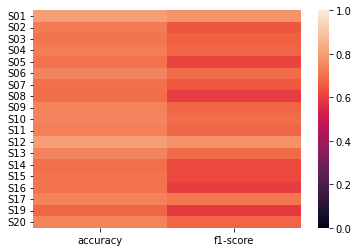

     class0 f1-score  class1 f1-score
S01         0.872000         0.555556
S02         0.827839         0.253968
S03         0.815884         0.320000
S04         0.830565         0.301370
S05         0.823105         0.109091
S06         0.842105         0.307692
S07         0.805654         0.303797
S08         0.813115         0.123077
S09         0.841424         0.268657
S10         0.840000         0.368421
S11         0.833948         0.285714
S12         0.871795         0.556962
S13         0.839161         0.361111
S14         0.812287         0.202899
S15         0.821192         0.156250
S16         0.824675         0.068966
S17         0.830040         0.455696
S19         0.803987         0.119403
S20         0.839590         0.298507


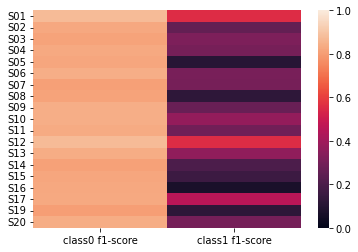

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [8]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

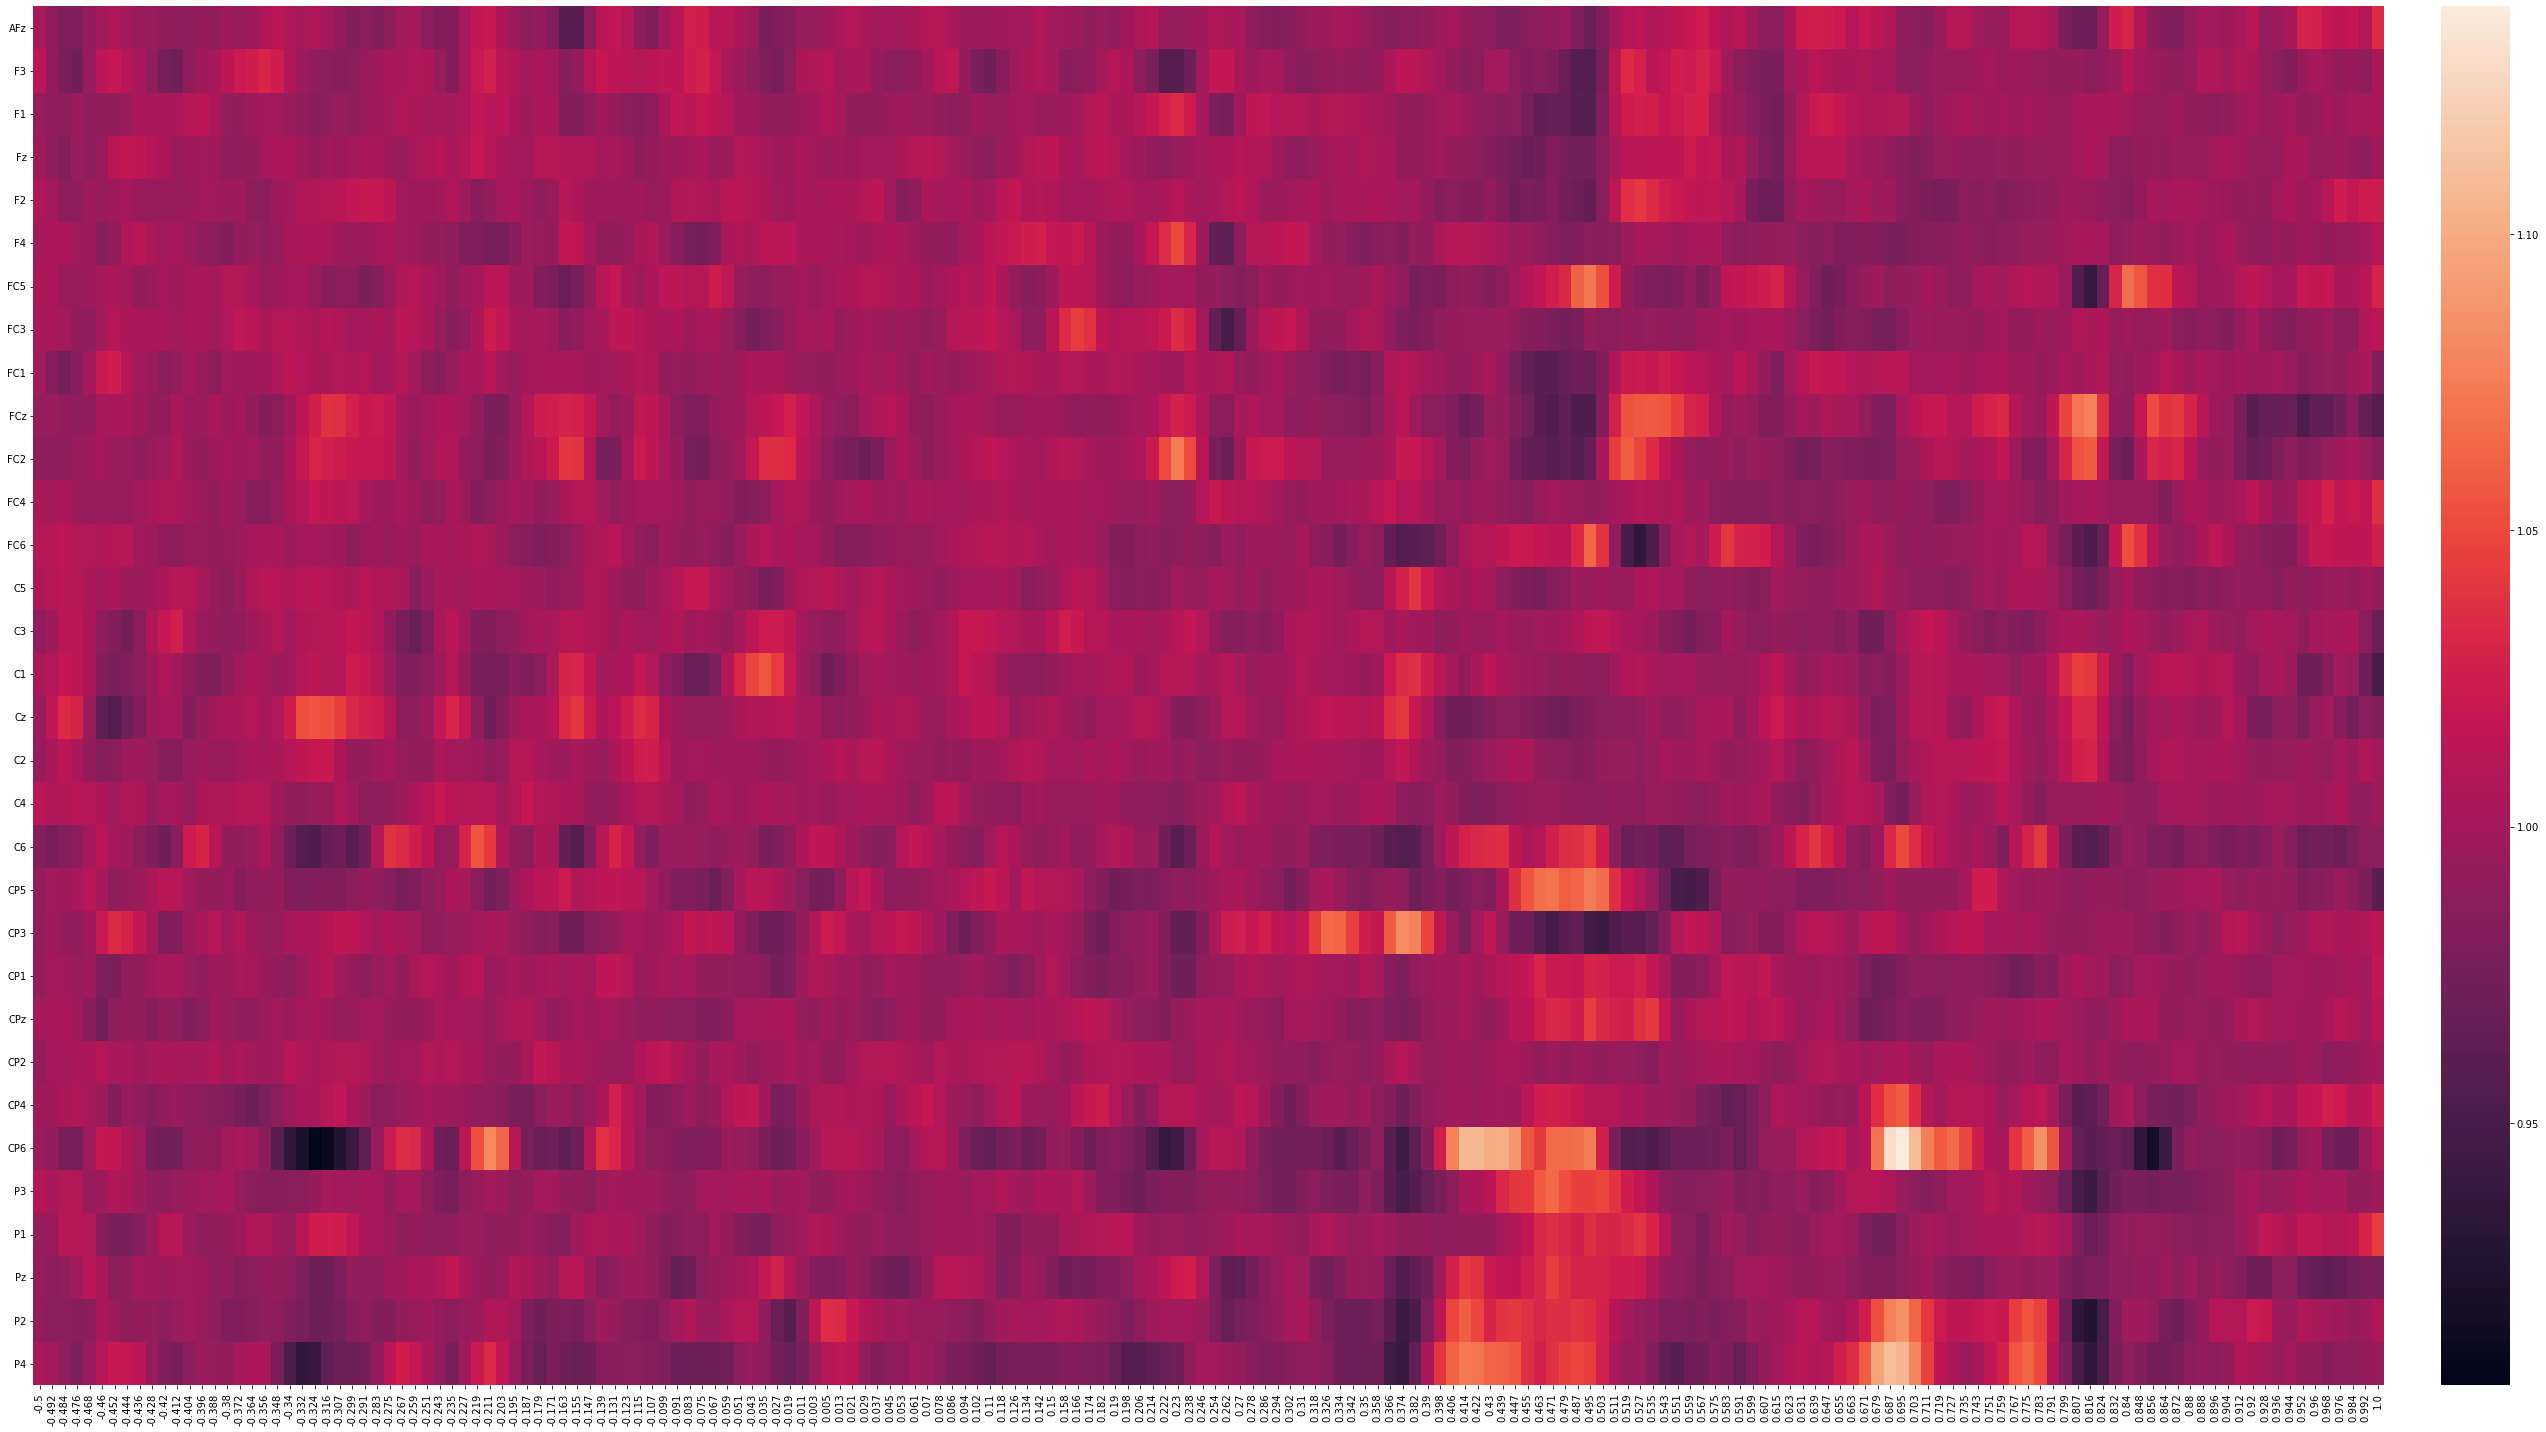

In [10]:
# fig, ax= plt.subplots(3,1)
fig =plt.figure()
sns.heatmap(pd.DataFrame(avg_w), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, 
            annot=False, cbar_kws={"pad":0.02})

# ax[0].set_title("AUC")

# sns.heatmap(pd.DataFrame(avg_grad["ROC"]), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[1],
#             annot=False, cbar_kws={"pad":0.02})
# ax[1].set_title("ROC")

# sns.heatmap(pd.DataFrame(avg_grad["STD"]), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[2],
#             annot=False, cbar_kws={"pad":0.02})
# ax[2].set_title("STD")

# plt.suptitle("Relative Importance Estimate of Time Series")
fig.set_figwidth(40)
fig.set_figheight(20)
plt.tight_layout()

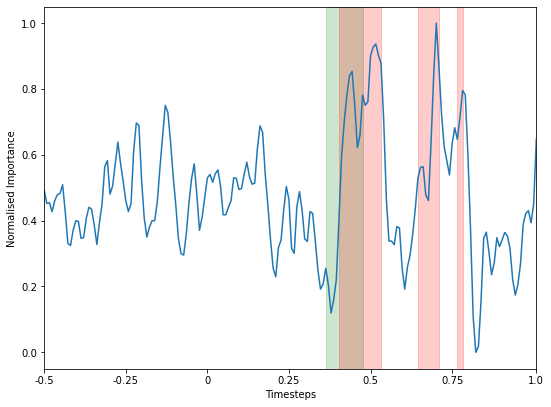

In [11]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

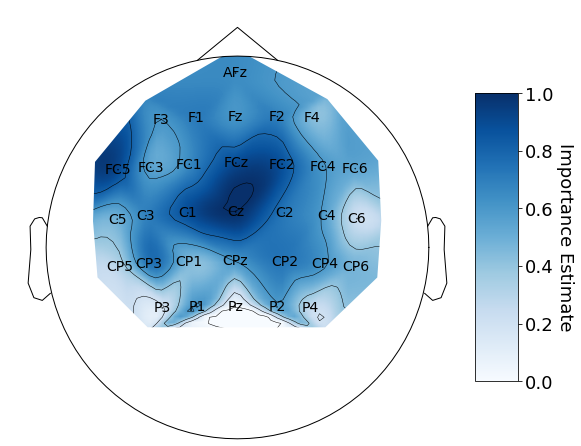

In [12]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)